# AD_with_Plaques:1
# NCI_with_No_Plaques: 0

In [1]:
import os
os.chdir('./../../')
import tensorflow as tf
from gene_expression import *
from pathway_hierarchy import *
from utils import *
import torch

2024-08-27 17:05:43.241775: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-27 17:05:43.251316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 17:05:43.263596: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 17:05:43.263629: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 17:05:43.272861: I tensorflow/core/platform/cpu_feature_gua

In [ ]:
import os
import torch
from tqdm import tqdm
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import argparse
from utils import *
from gene_expression import *
from pathway_hierarchy import *
import pandas as pd
import yaml
from custom_neural_network import *
from custom_fc_network import *
from datetime import datetime
import csv
import copy
import pickle
import random
random.seed(0)
np.random.seed(0)

path_config = '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/all_subtypes_jupyter_notebook/Exc_NRGN/config.yml'
model_dct = dict()

# Hook function
def hook_fn(module, input, output, layer_name):
    global model_dct
    input_list = [i.detach().cpu().numpy().tolist() for i in input]
    output_list = output.detach().cpu().numpy().tolist()
    
    # If the layer name is not in the dictionary, create a new list for it
    if layer_name not in model_dct:
        model_dct[layer_name] = []

    # Append the activations to the corresponding layer list
    model_dct[layer_name].append({
        'input': input_list,
        'output': output_list
    })



# Define the file path for the CSV file
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

class TabularDataset(Dataset):
    def __init__(self, count_matrix, label):
        # Read the CSV file
        self.data = count_matrix
        # Separate features and target
        self.features = self.data.values
        self.target = label.values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get features and target for a given index
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        target = torch.tensor(self.target[idx], dtype=torch.float32)
        return features, target

def evaluate(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    predicted_list = []
    probability_list = []
    labels_list = []
    criterion = nn.BCEWithLogitsLoss()
    loss = 0
    with torch.no_grad():  # No need to compute gradients during evaluation
        for features, labels in dataloader:
            outputs = model(features)
            #print(outputs)
            probability = torch.sigmoid(outputs.data)
            predicted = torch.round(torch.sigmoid(outputs.data))
            #print(outputs)
            #print(predicted)
            loss += criterion(outputs, labels)
            #_, predicted = torch.sigmoid(outputs.data)
            predicted_list.extend(predicted)
            labels_list.extend(labels)
            probability_list.extend(probability)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    #print(total)
    accuracy = 100 * correct / total
    return accuracy, loss, predicted_list, labels_list, probability_list

def save_model(model_nn,model_path, model_state_dict_path):
    
    model_nn.eval()
    torch.save(model_nn, model_path)
    torch.save(model_nn.state_dict(), model_state_dict_path)




def model_fc(train_dataloader , val_dataloader, test_dataloader, test_cell_id, layers_node, masking, output_layer,model_save_dir, date_string, learning_rate=0.001, num_epochs=50, weight_decay = 0):

    model_nn = CustomfcNetwork(layers_node, output_layer, masking)
    optimizer = optim.AdamW(model_nn.parameters(), lr=learning_rate,weight_decay = weight_decay )  # Using SGD with momentum
    criterion = nn.BCEWithLogitsLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
    patience = 20
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    early_stop = False
    csv_file_path = f'{model_save_dir}{date_string}/fc_training_log_{output_layer}.csv'

    try:
        os.makedirs(f'{model_save_dir}{date_string}')
    except:
        print(('...'))

    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train_Loss', 'Train_accuracy','Validation_Loss','Val_accuracy'])

    for epoch in tqdm(range(num_epochs)):
        if early_stop:
            print("Early stopping")
            break
        epoch_cost = 0.
        
        total_loss = 0
        for batch_features,batch_targets in train_dataloader:
            outputs = model_nn(batch_features)
            #print(outputs)
            #print(batch_targets)
            #print(outputs)
            loss = criterion(outputs, batch_targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
        
        train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(model_nn, train_dataloader)
        val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(model_nn, val_dataloader)
        #scheduler.step(val_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Train_accuracy: {train_accuracy}, Val Loss: {val_loss.item():.4f}, Val_accuracy: {val_accuracy}')
        with open(csv_file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch + 1, loss.item(), train_accuracy, val_loss.item(), val_accuracy])
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_no_improve = 0
        # Save the best model
            model_path = f'{model_save_dir}{date_string}/fc_best_model_{output_layer}.pth'
            model_state_dict_path = f'{model_save_dir}{date_string}/fc_best_model_{output_layer}_state_dict.pth'
            save_model(model_nn, model_path, model_state_dict_path)
            best_model_nn = copy.deepcopy(model_nn)
            #torch.save(model_nn, f'{model_save_dir}{date_string}/fc_best_model_{output_layer}.pth')
            #torch.save(model_nn.state_dict(), f'{model_save_dir}{date_string}/fc_best_model_{output_layer}_state_dict.pth')
            print('Model saved.')
        else:
            epochs_no_improve += 1
    
        # Early stopping
        '''if epochs_no_improve >= patience:
            early_stop = True
            print("Early stopping triggered")'''
        
    
    train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(best_model_nn, train_dataloader)
    val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(best_model_nn, val_dataloader)
    test_accuracy, test_loss, predicted_list_test, labels_list_test, test_probability_list = evaluate(best_model_nn, test_dataloader)
    print('Test Accucary', test_accuracy)
    output_train = (predicted_list_train, labels_list_train)
    output_val = (predicted_list_val, labels_list_val)

    labels_list_test = [m.item() for m in labels_list_test]
    predicted_list_test = [m.item() for m in predicted_list_test]
    test_probability_list = [m.item() for m in test_probability_list]


    test_df = pd.DataFrame({'cell_id': test_cell_id, 'true_y': labels_list_test, 'pred_y': predicted_list_test, 'probabilty': test_probability_list})
    csv_file_path = f'{model_save_dir}{date_string}/fc_test_log_{output_layer}.csv'
    test_df.to_csv(csv_file_path)
    #torch.save(model_nn, f'{model_save_dir}{date_string}/fc_last_epoch_model_{output_layer}.pth')
    return output_train, output_val,best_model_nn



def model(train_dataloader , val_dataloader, test_dataloader, test_cell_id, layers_node, masking, output_layer,model_save_dir, date_string, learning_rate=0.001, num_epochs=50, weight_decay = 0):

    model_nn = CustomNetwork(layers_node, output_layer, masking)
    print(model_nn)
    optimizer = optim.AdamW(model_nn.parameters(), lr=learning_rate,weight_decay = weight_decay )  # Using SGD with momentum
    criterion = nn.BCEWithLogitsLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
    patience = 20
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    early_stop = False
    csv_file_path = f'{model_save_dir}{date_string}/training_log_{output_layer}.csv'

    try:
        os.makedirs(f'{model_save_dir}{date_string}')
    except:
        print(('...'))

    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train_Loss', 'Train_accuracy','Validation_Loss','Val_accuracy'])

    for epoch in tqdm(range(num_epochs)):
        if early_stop:
            print("Early stopping")
            break
        epoch_cost = 0.
        
        total_loss = 0
        for batch_features,batch_targets in train_dataloader:
            
            #print(outputs)
            #print(batch_targets)
            #print(outputs)
            
            
            optimizer.zero_grad()
            outputs = model_nn(batch_features)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            
            
        
        train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(model_nn, train_dataloader)
        val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(model_nn, val_dataloader)
        #scheduler.step(val_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Train_accuracy: {train_accuracy}, Val Loss: {val_loss.item():.4f}, Val_accuracy: {val_accuracy}')
        with open(csv_file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch + 1, loss.item(), train_accuracy, val_loss.item(), val_accuracy])
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_no_improve = 0
        # Save the best model
            model_path = f'{model_save_dir}{date_string}/best_model_{output_layer}.pth'
            model_state_dict_path = f'{model_save_dir}{date_string}/best_model_{output_layer}_state_dict.pth'
            save_model(model_nn, model_path, model_state_dict_path)
            best_model_nn = copy.deepcopy(model_nn)
            #torch.save(model_nn, f'{model_save_dir}{date_string}/best_model_{output_layer}.pth')
            #torch.save(model_nn.state_dict(), f'{model_save_dir}{date_string}/best_model_{output_layer}_state_dict.pth')
            print('Model saved.')
        else:
            epochs_no_improve += 1
    
        # Early stopping
        '''if epochs_no_improve >= patience:
            early_stop = True
            print("Early stopping triggered")'''
        
    
    train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(best_model_nn, train_dataloader)
    val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(best_model_nn, val_dataloader)
    test_accuracy, test_loss, predicted_list_test, labels_list_test, test_probability_list = evaluate(best_model_nn, test_dataloader)
    print('Test Accucary', test_accuracy)
    output_train = (predicted_list_train, labels_list_train)
    output_val = (predicted_list_val, labels_list_val)

    labels_list_test = [m.item() for m in labels_list_test]
    predicted_list_test = [m.item() for m in predicted_list_test]
    test_probability_list = [m.item() for m in test_probability_list]


    test_df = pd.DataFrame({'cell_id': test_cell_id, 'true_y': labels_list_test, 'pred_y': predicted_list_test, 'probabilty': test_probability_list})
    csv_file_path = f'{model_save_dir}{date_string}/test_log_{output_layer}.csv'
    test_df.to_csv(csv_file_path)
    #torch.save(model_nn, f'{model_save_dir}{date_string}/last_epoch_model_{output_layer}.pth')
    return output_train, output_val,best_model_nn


def load_config(config_file):
    with open(config_file, 'r') as file:
        return yaml.safe_load(file)


def main_file(path_config):

    '''parser = argparse.ArgumentParser(description='Sample application with config and argparse')
    parser.add_argument('--config', type=str, default='config.yml', help='Path to the configuration file')
    args = parser.parse_args()'''

    config = load_config(path_config)
    print(config)
    train = pd.read_csv(config['dataset']['train'],index_col=0)
    test = pd.read_csv(config['dataset']['test'],index_col=0)
    val = pd.read_csv(config['dataset']['val'],index_col=0)

    y_train = pd.read_csv(config['dataset']['y_train'])
    y_test = pd.read_csv(config['dataset']['y_test'])
    y_val = pd.read_csv(config['dataset']['y_val'])
  


    r_data_tmp = train.T
    q_data_tmp = test.T
    v_data_tmp = val.T
    r_label_tmp = y_train



    pathway_relation, ensemble_pathway_relation = return_threshold_pathways(config['pathways_network']['pathway_relation'], 
                                  config['pathways_network']['ensemble_pathway_relation'],  config['pathways_network']['h_thresh'],\
                                      config['pathways_network']['l_thresh'])

    if os.path.exists(config['pathways_network']['pathway_relation_updated']):
        os.remove(config['pathways_network']['pathway_relation_updated'])

    if os.path.exists(config['pathways_network']['ensemble_pathway_relation_updated']):
        os.remove(config['pathways_network']['ensemble_pathway_relation_updated'])

    pathway_relation.to_csv(config['pathways_network']['pathway_relation_updated'], sep = '\t', index = False, header= False)
    ensemble_pathway_relation.to_csv(config['pathways_network']['ensemble_pathway_relation_updated'], sep = '\t', index = False, header= False)




    print('Getting Marker Genes.......')
    train_x, test_x, val_x, train_y = get_expression(r_data_tmp,
                                                q_data_tmp,
                                                v_data_tmp,
                                                r_label_tmp,
                                                thrh=config['gene_expression']['highly_expressed_threshold'],
                                                thrl=config['gene_expression']['lowly_expressed_threshold'],
                                                normalization=config['gene_expression']['normalization'],
                                                marker=config['gene_expression']['marker'])
    
    print('Getting Pathway Genes.........')
    pathway_genes = get_gene_pathways(config['pathways_network']['ensemble_pathway_relation_updated'], species=config['pathways_network']['species'])


    print('Getting Masking.........')
    masking, masking_df, layers_node, train_x, test_x,val_x = get_masking(config['pathways_network']['pathway_names'],
                                                        pathway_genes,
                                                        config['pathways_network']['pathway_relation_updated'],
                                                        train_x,
                                                        test_x,
                                                        val_x,
                                                        train_y,
                                                        config['pathways_network']['datatype'],
                                                        config['pathways_network']['species'],
                                                        config['pathways_network']['n_hidden_layer'])

    test_cell_id = list(test_x.T.index) 
    try:
        masking = list(masking.values())
        layers_node = list(layers_node.values())
    except:
        print('already_done')


    train_dataset = TabularDataset(train_x.T,train_y)
    val_dataset = TabularDataset(val_x.T,y_val)
    test_dataset = TabularDataset(test_x.T,y_test)  
    
    

    dataloader_params = {
    'batch_size': config['train']['batch_size'],
    'shuffle': False
    }

    train_dataloader = DataLoader(train_dataset,**dataloader_params)
    test_dataloader = DataLoader(test_dataset, **dataloader_params)
    val_dataloader = DataLoader(val_dataset,**dataloader_params)
    # Example of iterating through the DataLoader


    pred_y_df = pd.DataFrame(data=0, index=test_x.columns, columns=list(range(2, len(masking) + 2)))
    train_y_df = pd.DataFrame(data=0, index=train_x.columns, columns=list(range(2, len(masking) + 2)))
    model_dict_sparse = dict()
    model_dict_fc = dict()
    activation_output = {}
    now = datetime.now()

# Format the date as a string
    date_string = datetime_string = now.strftime("%Y_%m_%d_%H_%M_%S")

    try:
        os.makedirs(f'{config['model_output']['model_save_dir']}{date_string}')
    except:
        print(('...'))

   

    print('Training.........')
    for output_layer in range(2, len(masking) + 2):
        if config['gene_expression']['print_information']:
            print("Current sub-neural network has " + str(output_layer - 1) + " hidden layers.")
        output_train, output_val,model_dict_sparse[output_layer] = model(train_dataloader,
                                            val_dataloader,test_dataloader, test_cell_id,
                                            layers_node,
                                            masking,
                                            output_layer,
                                            model_save_dir = config['model_output']['model_save_dir'],date_string = date_string,
                                            learning_rate=config['train']['learning_rate'],num_epochs=config['train']['epochs'],weight_decay = config['train']['weight_decay']
                                        )  

    print('tranining_fully_connected_layers:')
    for output_layer in range(2, len(masking) + 2):
        if config['gene_expression']['print_information']:
            print("Current sub-neural network has " + str(output_layer - 1) + " hidden layers.")
        output_train, output_val,model_dict_fc[output_layer] = model_fc(train_dataloader,
                                            val_dataloader,test_dataloader, test_cell_id,
                                            layers_node,
                                            masking,
                                            output_layer,
                                            model_save_dir = config['model_output']['model_save_dir'],date_string = date_string,
                                            learning_rate=config['train']['learning_rate'],num_epochs=config['train']['epochs'],weight_decay = config['train']['weight_decay']
                                        )  
        
    new_parameter = {'date_string': date_string}
    config.update(new_parameter)
    save_path =   str(config['model_output']['model_save_dir'])+ date_string + '/config.yml'
    with open(save_path, 'w') as file:
        yaml.dump(config, file)

        
    for i in range(len(masking_df)):
        masking_df[i].to_csv(str(config['model_output']['model_save_dir'])+ date_string+ '/' +f'masking_df_{i}.csv')
    
   
        
    return model_dict_sparse, val_dataloader, test_dataloader, train_dataloader, train_x, train_y, val_x, y_val, test_x, y_test, config

   
model_dict_sparse, val_dataloader, test_dataloader, train_dataloader,train_x, train_y, val_x, y_val, test_x, y_test, config = main_file(path_config= path_config)
for j,i in model_dict_sparse.items():

# Assuming 'model' is your neural network
    torch.save(i.state_dict(), f'{config['model_output']['model_save_dir']}{config['date_string']}/model_{j}_state_dict_jupyter_notebook.pth')


for j,i in model_dict_sparse.items():
        
        print(f'Hidden_Layers: {j}')
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, test_dataloader)
        print(f'Test Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, train_dataloader)
        print(f'Train Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, val_dataloader)
        print(f'Validation Accuracy: {accuracy}') 

{'dataset': {'train': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_NRGN/train.csv', 'test': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_NRGN/test.csv', 'val': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_NRGN/val.csv', 'y_train': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_NRGN/y_train.csv', 'y_test': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_NRGN/y_test.csv', 'y_val': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_NRGN/y_val.csv'}, 'model_output': {'model_save_dir': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/model_save/excitory_neurons/Exc_NRGN/'}, 'train': {'epochs': 1000, 'learning_rate': 0.001, 'weight_decay': 0.01, 

/home/anwer/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


...


  0%|▏                                                                                                                                                                          | 1/1000 [00:00<11:47,  1.41it/s]

Epoch [1/1000], Train Loss: 0.6883, Train_accuracy: 63.2080078125, Val Loss: 0.6890, Val_accuracy: 61.1572265625
Model saved.


  0%|▎                                                                                                                                                                          | 2/1000 [00:01<11:53,  1.40it/s]

Epoch [2/1000], Train Loss: 0.6844, Train_accuracy: 68.27799479166667, Val Loss: 0.6853, Val_accuracy: 66.552734375
Model saved.


  0%|▌                                                                                                                                                                          | 3/1000 [00:02<12:49,  1.30it/s]

Epoch [3/1000], Train Loss: 0.6806, Train_accuracy: 69.73470052083333, Val Loss: 0.6817, Val_accuracy: 68.1640625
Model saved.


  0%|▋                                                                                                                                                                          | 4/1000 [00:02<12:29,  1.33it/s]

Epoch [4/1000], Train Loss: 0.6768, Train_accuracy: 70.01139322916667, Val Loss: 0.6782, Val_accuracy: 68.310546875
Model saved.


  0%|▊                                                                                                                                                                          | 5/1000 [00:03<12:22,  1.34it/s]

Epoch [5/1000], Train Loss: 0.6730, Train_accuracy: 70.21484375, Val Loss: 0.6747, Val_accuracy: 68.5546875
Model saved.


  1%|█                                                                                                                                                                          | 6/1000 [00:04<13:05,  1.27it/s]

Epoch [6/1000], Train Loss: 0.6692, Train_accuracy: 70.40201822916667, Val Loss: 0.6712, Val_accuracy: 68.6279296875
Model saved.


  1%|█▏                                                                                                                                                                         | 7/1000 [00:05<12:46,  1.30it/s]

Epoch [7/1000], Train Loss: 0.6654, Train_accuracy: 70.47526041666667, Val Loss: 0.6678, Val_accuracy: 68.7744140625
Model saved.


  1%|█▎                                                                                                                                                                         | 8/1000 [00:05<11:49,  1.40it/s]

Epoch [8/1000], Train Loss: 0.6616, Train_accuracy: 70.4345703125, Val Loss: 0.6643, Val_accuracy: 68.6279296875


  1%|█▌                                                                                                                                                                         | 9/1000 [00:06<11:50,  1.39it/s]

Epoch [9/1000], Train Loss: 0.6577, Train_accuracy: 70.40201822916667, Val Loss: 0.6607, Val_accuracy: 68.9208984375
Model saved.


  1%|█▋                                                                                                                                                                        | 10/1000 [00:07<11:54,  1.39it/s]

Epoch [10/1000], Train Loss: 0.6537, Train_accuracy: 70.44270833333333, Val Loss: 0.6572, Val_accuracy: 69.0185546875
Model saved.


  1%|█▊                                                                                                                                                                        | 11/1000 [00:08<11:51,  1.39it/s]

Epoch [11/1000], Train Loss: 0.6497, Train_accuracy: 70.361328125, Val Loss: 0.6535, Val_accuracy: 68.9697265625


  1%|██                                                                                                                                                                        | 12/1000 [00:08<12:15,  1.34it/s]

Epoch [12/1000], Train Loss: 0.6457, Train_accuracy: 70.35319010416667, Val Loss: 0.6499, Val_accuracy: 68.994140625


  1%|██▏                                                                                                                                                                       | 13/1000 [00:09<11:11,  1.47it/s]

Epoch [13/1000], Train Loss: 0.6416, Train_accuracy: 70.27994791666667, Val Loss: 0.6462, Val_accuracy: 68.7744140625


  1%|██▍                                                                                                                                                                       | 14/1000 [00:10<11:15,  1.46it/s]

Epoch [14/1000], Train Loss: 0.6375, Train_accuracy: 70.18229166666667, Val Loss: 0.6425, Val_accuracy: 68.603515625


  2%|██▌                                                                                                                                                                       | 15/1000 [00:10<11:13,  1.46it/s]

Epoch [15/1000], Train Loss: 0.6334, Train_accuracy: 70.2392578125, Val Loss: 0.6388, Val_accuracy: 68.6279296875


  2%|██▋                                                                                                                                                                       | 16/1000 [00:11<12:00,  1.37it/s]

Epoch [16/1000], Train Loss: 0.6292, Train_accuracy: 70.25553385416667, Val Loss: 0.6352, Val_accuracy: 68.603515625


  2%|██▉                                                                                                                                                                       | 17/1000 [00:12<11:50,  1.38it/s]

Epoch [17/1000], Train Loss: 0.6251, Train_accuracy: 70.18229166666667, Val Loss: 0.6316, Val_accuracy: 68.4814453125


  2%|███                                                                                                                                                                       | 18/1000 [00:12<10:47,  1.52it/s]

Epoch [18/1000], Train Loss: 0.6211, Train_accuracy: 70.0927734375, Val Loss: 0.6280, Val_accuracy: 68.5546875


  2%|███▏                                                                                                                                                                      | 19/1000 [00:13<11:07,  1.47it/s]

Epoch [19/1000], Train Loss: 0.6170, Train_accuracy: 70.1416015625, Val Loss: 0.6246, Val_accuracy: 68.5546875


  2%|███▍                                                                                                                                                                      | 20/1000 [00:14<10:57,  1.49it/s]

Epoch [20/1000], Train Loss: 0.6131, Train_accuracy: 70.14973958333333, Val Loss: 0.6212, Val_accuracy: 68.4814453125


  2%|███▌                                                                                                                                                                      | 21/1000 [00:14<10:52,  1.50it/s]

Epoch [21/1000], Train Loss: 0.6092, Train_accuracy: 70.1416015625, Val Loss: 0.6179, Val_accuracy: 68.45703125


  2%|███▋                                                                                                                                                                      | 22/1000 [00:15<11:27,  1.42it/s]

Epoch [22/1000], Train Loss: 0.6054, Train_accuracy: 70.24739583333333, Val Loss: 0.6147, Val_accuracy: 68.5791015625


  2%|███▉                                                                                                                                                                      | 23/1000 [00:16<11:02,  1.47it/s]

Epoch [23/1000], Train Loss: 0.6018, Train_accuracy: 70.263671875, Val Loss: 0.6116, Val_accuracy: 68.6767578125


  2%|████                                                                                                                                                                      | 24/1000 [00:17<11:14,  1.45it/s]

Epoch [24/1000], Train Loss: 0.5983, Train_accuracy: 70.263671875, Val Loss: 0.6087, Val_accuracy: 68.701171875


  2%|████▎                                                                                                                                                                     | 25/1000 [00:17<11:11,  1.45it/s]

Epoch [25/1000], Train Loss: 0.5950, Train_accuracy: 70.25553385416667, Val Loss: 0.6061, Val_accuracy: 68.7744140625


  3%|████▍                                                                                                                                                                     | 26/1000 [00:18<11:51,  1.37it/s]

Epoch [26/1000], Train Loss: 0.5919, Train_accuracy: 70.2880859375, Val Loss: 0.6036, Val_accuracy: 68.84765625


  3%|████▌                                                                                                                                                                     | 27/1000 [00:19<12:03,  1.35it/s]

Epoch [27/1000], Train Loss: 0.5890, Train_accuracy: 70.27994791666667, Val Loss: 0.6013, Val_accuracy: 68.7744140625


  3%|████▊                                                                                                                                                                     | 28/1000 [00:19<11:42,  1.38it/s]

Epoch [28/1000], Train Loss: 0.5863, Train_accuracy: 70.2880859375, Val Loss: 0.5992, Val_accuracy: 68.7744140625


  3%|████▉                                                                                                                                                                     | 29/1000 [00:20<10:44,  1.51it/s]

Epoch [29/1000], Train Loss: 0.5838, Train_accuracy: 70.35319010416667, Val Loss: 0.5973, Val_accuracy: 68.798828125


  3%|█████                                                                                                                                                                     | 30/1000 [00:21<10:43,  1.51it/s]

Epoch [30/1000], Train Loss: 0.5815, Train_accuracy: 70.47526041666667, Val Loss: 0.5956, Val_accuracy: 68.896484375


  3%|█████▎                                                                                                                                                                    | 31/1000 [00:21<10:45,  1.50it/s]

Epoch [31/1000], Train Loss: 0.5795, Train_accuracy: 70.51595052083333, Val Loss: 0.5941, Val_accuracy: 68.9208984375


  3%|█████▍                                                                                                                                                                    | 32/1000 [00:22<10:49,  1.49it/s]

Epoch [32/1000], Train Loss: 0.5776, Train_accuracy: 70.5810546875, Val Loss: 0.5928, Val_accuracy: 68.9697265625


  3%|█████▌                                                                                                                                                                    | 33/1000 [00:23<11:39,  1.38it/s]

Epoch [33/1000], Train Loss: 0.5759, Train_accuracy: 70.58919270833333, Val Loss: 0.5917, Val_accuracy: 68.9697265625


  3%|█████▊                                                                                                                                                                    | 34/1000 [00:23<11:08,  1.45it/s]

Epoch [34/1000], Train Loss: 0.5744, Train_accuracy: 70.56477864583333, Val Loss: 0.5907, Val_accuracy: 69.0673828125
Model saved.


  4%|█████▉                                                                                                                                                                    | 35/1000 [00:24<11:25,  1.41it/s]

Epoch [35/1000], Train Loss: 0.5731, Train_accuracy: 70.5322265625, Val Loss: 0.5899, Val_accuracy: 69.140625
Model saved.


  4%|██████                                                                                                                                                                    | 36/1000 [00:25<11:26,  1.40it/s]

Epoch [36/1000], Train Loss: 0.5718, Train_accuracy: 70.58919270833333, Val Loss: 0.5892, Val_accuracy: 69.091796875


  4%|██████▎                                                                                                                                                                   | 37/1000 [00:26<12:07,  1.32it/s]

Epoch [37/1000], Train Loss: 0.5707, Train_accuracy: 70.654296875, Val Loss: 0.5886, Val_accuracy: 69.0673828125


  4%|██████▍                                                                                                                                                                   | 38/1000 [00:27<12:00,  1.33it/s]

Epoch [38/1000], Train Loss: 0.5697, Train_accuracy: 70.71940104166667, Val Loss: 0.5880, Val_accuracy: 69.189453125
Model saved.


  4%|██████▋                                                                                                                                                                   | 39/1000 [00:27<11:29,  1.39it/s]

Epoch [39/1000], Train Loss: 0.5687, Train_accuracy: 70.76822916666667, Val Loss: 0.5874, Val_accuracy: 69.23828125
Model saved.


  4%|██████▊                                                                                                                                                                   | 40/1000 [00:28<11:35,  1.38it/s]

Epoch [40/1000], Train Loss: 0.5678, Train_accuracy: 70.85774739583333, Val Loss: 0.5869, Val_accuracy: 69.287109375
Model saved.


  4%|██████▉                                                                                                                                                                   | 41/1000 [00:29<11:42,  1.37it/s]

Epoch [41/1000], Train Loss: 0.5669, Train_accuracy: 70.8740234375, Val Loss: 0.5864, Val_accuracy: 69.3359375
Model saved.


  4%|███████▏                                                                                                                                                                  | 42/1000 [00:29<11:46,  1.36it/s]

Epoch [42/1000], Train Loss: 0.5661, Train_accuracy: 70.93098958333333, Val Loss: 0.5858, Val_accuracy: 69.2626953125


  4%|███████▎                                                                                                                                                                  | 43/1000 [00:30<12:21,  1.29it/s]

Epoch [43/1000], Train Loss: 0.5652, Train_accuracy: 71.01236979166667, Val Loss: 0.5853, Val_accuracy: 69.287109375


  4%|███████▍                                                                                                                                                                  | 44/1000 [00:31<11:20,  1.40it/s]

Epoch [44/1000], Train Loss: 0.5643, Train_accuracy: 71.05305989583333, Val Loss: 0.5847, Val_accuracy: 69.43359375
Model saved.


  4%|███████▋                                                                                                                                                                  | 45/1000 [00:32<11:28,  1.39it/s]

Epoch [45/1000], Train Loss: 0.5635, Train_accuracy: 71.03678385416667, Val Loss: 0.5841, Val_accuracy: 69.482421875
Model saved.


  5%|███████▊                                                                                                                                                                  | 46/1000 [00:32<11:49,  1.34it/s]

Epoch [46/1000], Train Loss: 0.5625, Train_accuracy: 71.1181640625, Val Loss: 0.5835, Val_accuracy: 69.5068359375
Model saved.


  5%|███████▉                                                                                                                                                                  | 47/1000 [00:33<11:58,  1.33it/s]

Epoch [47/1000], Train Loss: 0.5616, Train_accuracy: 71.15071614583333, Val Loss: 0.5828, Val_accuracy: 69.7265625
Model saved.


  5%|████████▏                                                                                                                                                                 | 48/1000 [00:34<11:41,  1.36it/s]

Epoch [48/1000], Train Loss: 0.5607, Train_accuracy: 71.20768229166667, Val Loss: 0.5821, Val_accuracy: 69.7021484375


  5%|████████▎                                                                                                                                                                 | 49/1000 [00:35<12:00,  1.32it/s]

Epoch [49/1000], Train Loss: 0.5597, Train_accuracy: 71.25651041666667, Val Loss: 0.5813, Val_accuracy: 69.6533203125


  5%|████████▌                                                                                                                                                                 | 50/1000 [00:35<11:09,  1.42it/s]

Epoch [50/1000], Train Loss: 0.5587, Train_accuracy: 71.39485677083333, Val Loss: 0.5806, Val_accuracy: 69.7509765625
Model saved.


  5%|████████▋                                                                                                                                                                 | 51/1000 [00:36<11:18,  1.40it/s]

Epoch [51/1000], Train Loss: 0.5577, Train_accuracy: 71.533203125, Val Loss: 0.5798, Val_accuracy: 69.775390625
Model saved.


  5%|████████▊                                                                                                                                                                 | 52/1000 [00:37<12:08,  1.30it/s]

Epoch [52/1000], Train Loss: 0.5567, Train_accuracy: 71.6064453125, Val Loss: 0.5790, Val_accuracy: 69.8486328125
Model saved.


  5%|█████████                                                                                                                                                                 | 53/1000 [00:38<12:23,  1.27it/s]

Epoch [53/1000], Train Loss: 0.5557, Train_accuracy: 71.630859375, Val Loss: 0.5782, Val_accuracy: 69.9951171875
Model saved.


  5%|█████████▏                                                                                                                                                                | 54/1000 [00:38<12:15,  1.29it/s]

Epoch [54/1000], Train Loss: 0.5547, Train_accuracy: 71.80989583333333, Val Loss: 0.5774, Val_accuracy: 70.1171875
Model saved.


  6%|█████████▎                                                                                                                                                                | 55/1000 [00:39<11:07,  1.41it/s]

Epoch [55/1000], Train Loss: 0.5537, Train_accuracy: 71.89127604166667, Val Loss: 0.5766, Val_accuracy: 70.166015625
Model saved.


  6%|█████████▌                                                                                                                                                                | 56/1000 [00:40<11:48,  1.33it/s]

Epoch [56/1000], Train Loss: 0.5527, Train_accuracy: 71.89127604166667, Val Loss: 0.5758, Val_accuracy: 70.0927734375


  6%|█████████▋                                                                                                                                                                | 57/1000 [00:41<11:50,  1.33it/s]

Epoch [57/1000], Train Loss: 0.5517, Train_accuracy: 72.07845052083333, Val Loss: 0.5751, Val_accuracy: 70.1904296875
Model saved.


  6%|█████████▊                                                                                                                                                                | 58/1000 [00:41<12:06,  1.30it/s]

Epoch [58/1000], Train Loss: 0.5507, Train_accuracy: 72.15169270833333, Val Loss: 0.5743, Val_accuracy: 70.263671875
Model saved.


  6%|██████████                                                                                                                                                                | 59/1000 [00:42<12:08,  1.29it/s]

Epoch [59/1000], Train Loss: 0.5497, Train_accuracy: 72.1923828125, Val Loss: 0.5736, Val_accuracy: 70.3125
Model saved.


  6%|██████████▏                                                                                                                                                               | 60/1000 [00:43<11:14,  1.39it/s]

Epoch [60/1000], Train Loss: 0.5487, Train_accuracy: 72.29817708333333, Val Loss: 0.5729, Val_accuracy: 70.458984375
Model saved.


  6%|██████████▎                                                                                                                                                               | 61/1000 [00:44<11:15,  1.39it/s]

Epoch [61/1000], Train Loss: 0.5478, Train_accuracy: 72.29817708333333, Val Loss: 0.5722, Val_accuracy: 70.41015625


  6%|██████████▌                                                                                                                                                               | 62/1000 [00:44<12:10,  1.28it/s]

Epoch [62/1000], Train Loss: 0.5469, Train_accuracy: 72.412109375, Val Loss: 0.5715, Val_accuracy: 70.5810546875
Model saved.


  6%|██████████▋                                                                                                                                                               | 63/1000 [00:45<12:08,  1.29it/s]

Epoch [63/1000], Train Loss: 0.5459, Train_accuracy: 72.52604166666667, Val Loss: 0.5708, Val_accuracy: 70.5810546875


  6%|██████████▉                                                                                                                                                               | 64/1000 [00:46<12:00,  1.30it/s]

Epoch [64/1000], Train Loss: 0.5450, Train_accuracy: 72.607421875, Val Loss: 0.5702, Val_accuracy: 70.60546875
Model saved.


  6%|███████████                                                                                                                                                               | 65/1000 [00:47<10:59,  1.42it/s]

Epoch [65/1000], Train Loss: 0.5441, Train_accuracy: 72.6318359375, Val Loss: 0.5695, Val_accuracy: 70.703125
Model saved.


  7%|███████████▏                                                                                                                                                              | 66/1000 [00:47<12:01,  1.29it/s]

Epoch [66/1000], Train Loss: 0.5432, Train_accuracy: 72.81901041666667, Val Loss: 0.5689, Val_accuracy: 70.80078125
Model saved.


  7%|███████████▍                                                                                                                                                              | 67/1000 [00:48<11:59,  1.30it/s]

Epoch [67/1000], Train Loss: 0.5423, Train_accuracy: 72.93294270833333, Val Loss: 0.5683, Val_accuracy: 70.849609375
Model saved.


  7%|███████████▌                                                                                                                                                              | 68/1000 [00:49<12:15,  1.27it/s]

Epoch [68/1000], Train Loss: 0.5414, Train_accuracy: 73.0712890625, Val Loss: 0.5678, Val_accuracy: 70.8984375
Model saved.


  7%|███████████▋                                                                                                                                                              | 69/1000 [00:50<12:06,  1.28it/s]

Epoch [69/1000], Train Loss: 0.5405, Train_accuracy: 73.1201171875, Val Loss: 0.5672, Val_accuracy: 70.947265625
Model saved.


  7%|███████████▉                                                                                                                                                              | 70/1000 [00:51<11:46,  1.32it/s]

Epoch [70/1000], Train Loss: 0.5397, Train_accuracy: 73.17708333333333, Val Loss: 0.5667, Val_accuracy: 70.947265625


  7%|████████████                                                                                                                                                              | 71/1000 [00:51<10:54,  1.42it/s]

Epoch [71/1000], Train Loss: 0.5388, Train_accuracy: 73.30729166666667, Val Loss: 0.5661, Val_accuracy: 71.0205078125
Model saved.


  7%|████████████▏                                                                                                                                                             | 72/1000 [00:52<11:37,  1.33it/s]

Epoch [72/1000], Train Loss: 0.5379, Train_accuracy: 73.32356770833333, Val Loss: 0.5656, Val_accuracy: 71.1181640625
Model saved.


  7%|████████████▍                                                                                                                                                             | 73/1000 [00:53<11:41,  1.32it/s]

Epoch [73/1000], Train Loss: 0.5370, Train_accuracy: 73.38053385416667, Val Loss: 0.5652, Val_accuracy: 71.19140625
Model saved.


  7%|████████████▌                                                                                                                                                             | 74/1000 [00:53<11:29,  1.34it/s]

Epoch [74/1000], Train Loss: 0.5362, Train_accuracy: 73.4619140625, Val Loss: 0.5647, Val_accuracy: 71.2158203125
Model saved.


  8%|████████████▊                                                                                                                                                             | 75/1000 [00:54<11:08,  1.38it/s]

Epoch [75/1000], Train Loss: 0.5353, Train_accuracy: 73.61653645833333, Val Loss: 0.5642, Val_accuracy: 71.2158203125


  8%|████████████▉                                                                                                                                                             | 76/1000 [00:55<10:40,  1.44it/s]

Epoch [76/1000], Train Loss: 0.5344, Train_accuracy: 73.681640625, Val Loss: 0.5638, Val_accuracy: 71.2158203125


  8%|█████████████                                                                                                                                                             | 77/1000 [00:55<10:53,  1.41it/s]

Epoch [77/1000], Train Loss: 0.5335, Train_accuracy: 73.76302083333333, Val Loss: 0.5633, Val_accuracy: 71.2890625
Model saved.


  8%|█████████████▎                                                                                                                                                            | 78/1000 [00:56<11:22,  1.35it/s]

Epoch [78/1000], Train Loss: 0.5327, Train_accuracy: 73.78743489583333, Val Loss: 0.5629, Val_accuracy: 71.38671875
Model saved.


  8%|█████████████▍                                                                                                                                                            | 79/1000 [00:57<11:01,  1.39it/s]

Epoch [79/1000], Train Loss: 0.5318, Train_accuracy: 73.828125, Val Loss: 0.5624, Val_accuracy: 71.38671875


  8%|█████████████▌                                                                                                                                                            | 80/1000 [00:58<10:58,  1.40it/s]

Epoch [80/1000], Train Loss: 0.5310, Train_accuracy: 73.90950520833333, Val Loss: 0.5620, Val_accuracy: 71.435546875
Model saved.


  8%|█████████████▊                                                                                                                                                            | 81/1000 [00:58<10:11,  1.50it/s]

Epoch [81/1000], Train Loss: 0.5301, Train_accuracy: 73.91764322916667, Val Loss: 0.5616, Val_accuracy: 71.484375
Model saved.


  8%|█████████████▉                                                                                                                                                            | 82/1000 [00:59<11:15,  1.36it/s]

Epoch [82/1000], Train Loss: 0.5292, Train_accuracy: 73.974609375, Val Loss: 0.5612, Val_accuracy: 71.5087890625
Model saved.


  8%|██████████████                                                                                                                                                            | 83/1000 [01:00<11:34,  1.32it/s]

Epoch [83/1000], Train Loss: 0.5284, Train_accuracy: 74.01529947916667, Val Loss: 0.5607, Val_accuracy: 71.5576171875
Model saved.


  8%|██████████████▎                                                                                                                                                           | 84/1000 [01:01<11:27,  1.33it/s]

Epoch [84/1000], Train Loss: 0.5275, Train_accuracy: 74.06412760416667, Val Loss: 0.5603, Val_accuracy: 71.6552734375
Model saved.


  8%|██████████████▍                                                                                                                                                           | 85/1000 [01:01<11:16,  1.35it/s]

Epoch [85/1000], Train Loss: 0.5267, Train_accuracy: 74.05598958333333, Val Loss: 0.5599, Val_accuracy: 71.630859375


  9%|██████████████▌                                                                                                                                                           | 86/1000 [01:02<10:46,  1.41it/s]

Epoch [86/1000], Train Loss: 0.5258, Train_accuracy: 74.13736979166667, Val Loss: 0.5595, Val_accuracy: 71.58203125


  9%|██████████████▊                                                                                                                                                           | 87/1000 [01:03<10:44,  1.42it/s]

Epoch [87/1000], Train Loss: 0.5250, Train_accuracy: 74.13736979166667, Val Loss: 0.5591, Val_accuracy: 71.5576171875


  9%|██████████████▉                                                                                                                                                           | 88/1000 [01:03<11:00,  1.38it/s]

Epoch [88/1000], Train Loss: 0.5242, Train_accuracy: 74.13736979166667, Val Loss: 0.5587, Val_accuracy: 71.5087890625


  9%|███████████████▏                                                                                                                                                          | 89/1000 [01:04<10:56,  1.39it/s]

Epoch [89/1000], Train Loss: 0.5233, Train_accuracy: 74.20247395833333, Val Loss: 0.5583, Val_accuracy: 71.484375


  9%|███████████████▎                                                                                                                                                          | 90/1000 [01:05<10:54,  1.39it/s]

Epoch [90/1000], Train Loss: 0.5225, Train_accuracy: 74.267578125, Val Loss: 0.5579, Val_accuracy: 71.4111328125


  9%|███████████████▍                                                                                                                                                          | 91/1000 [01:06<10:48,  1.40it/s]

Epoch [91/1000], Train Loss: 0.5217, Train_accuracy: 74.30013020833333, Val Loss: 0.5575, Val_accuracy: 71.58203125


  9%|███████████████▋                                                                                                                                                          | 92/1000 [01:06<10:26,  1.45it/s]

Epoch [92/1000], Train Loss: 0.5209, Train_accuracy: 74.3408203125, Val Loss: 0.5571, Val_accuracy: 71.5576171875


  9%|███████████████▊                                                                                                                                                          | 93/1000 [01:07<11:06,  1.36it/s]

Epoch [93/1000], Train Loss: 0.5200, Train_accuracy: 74.35709635416667, Val Loss: 0.5567, Val_accuracy: 71.6796875
Model saved.


  9%|███████████████▉                                                                                                                                                          | 94/1000 [01:08<11:03,  1.37it/s]

Epoch [94/1000], Train Loss: 0.5192, Train_accuracy: 74.47102864583333, Val Loss: 0.5563, Val_accuracy: 71.7041015625
Model saved.


 10%|████████████████▏                                                                                                                                                         | 95/1000 [01:09<11:04,  1.36it/s]

Epoch [95/1000], Train Loss: 0.5184, Train_accuracy: 74.5849609375, Val Loss: 0.5559, Val_accuracy: 71.8505859375
Model saved.


 10%|████████████████▎                                                                                                                                                         | 96/1000 [01:09<11:38,  1.29it/s]

Epoch [96/1000], Train Loss: 0.5176, Train_accuracy: 74.54427083333333, Val Loss: 0.5555, Val_accuracy: 71.875
Model saved.


 10%|████████████████▍                                                                                                                                                         | 97/1000 [01:10<10:29,  1.43it/s]

Epoch [97/1000], Train Loss: 0.5168, Train_accuracy: 74.51171875, Val Loss: 0.5551, Val_accuracy: 71.875


 10%|████████████████▋                                                                                                                                                         | 98/1000 [01:11<10:54,  1.38it/s]

Epoch [98/1000], Train Loss: 0.5160, Train_accuracy: 74.71516927083333, Val Loss: 0.5547, Val_accuracy: 72.0458984375
Model saved.


 10%|████████████████▊                                                                                                                                                         | 99/1000 [01:12<11:04,  1.36it/s]

Epoch [99/1000], Train Loss: 0.5152, Train_accuracy: 74.76399739583333, Val Loss: 0.5543, Val_accuracy: 72.0947265625
Model saved.


 10%|████████████████▉                                                                                                                                                        | 100/1000 [01:12<11:17,  1.33it/s]

Epoch [100/1000], Train Loss: 0.5144, Train_accuracy: 74.83723958333333, Val Loss: 0.5539, Val_accuracy: 72.1923828125
Model saved.


 10%|█████████████████                                                                                                                                                        | 101/1000 [01:13<11:23,  1.31it/s]

Epoch [101/1000], Train Loss: 0.5136, Train_accuracy: 74.9267578125, Val Loss: 0.5535, Val_accuracy: 72.1923828125


 10%|█████████████████▏                                                                                                                                                       | 102/1000 [01:14<10:51,  1.38it/s]

Epoch [102/1000], Train Loss: 0.5129, Train_accuracy: 74.99186197916667, Val Loss: 0.5531, Val_accuracy: 72.1923828125


 10%|█████████████████▍                                                                                                                                                       | 103/1000 [01:15<11:08,  1.34it/s]

Epoch [103/1000], Train Loss: 0.5121, Train_accuracy: 75.0732421875, Val Loss: 0.5527, Val_accuracy: 72.2900390625
Model saved.


 10%|█████████████████▌                                                                                                                                                       | 104/1000 [01:15<11:01,  1.35it/s]

Epoch [104/1000], Train Loss: 0.5113, Train_accuracy: 75.08951822916667, Val Loss: 0.5524, Val_accuracy: 72.2412109375


 10%|█████████████████▋                                                                                                                                                       | 105/1000 [01:16<11:32,  1.29it/s]

Epoch [105/1000], Train Loss: 0.5105, Train_accuracy: 75.0732421875, Val Loss: 0.5520, Val_accuracy: 72.0947265625


 11%|█████████████████▉                                                                                                                                                       | 106/1000 [01:17<11:34,  1.29it/s]

Epoch [106/1000], Train Loss: 0.5098, Train_accuracy: 75.11393229166667, Val Loss: 0.5516, Val_accuracy: 72.1435546875


 11%|██████████████████                                                                                                                                                       | 107/1000 [01:17<10:28,  1.42it/s]

Epoch [107/1000], Train Loss: 0.5090, Train_accuracy: 75.17903645833333, Val Loss: 0.5513, Val_accuracy: 72.0703125


 11%|██████████████████▎                                                                                                                                                      | 108/1000 [01:18<10:35,  1.40it/s]

Epoch [108/1000], Train Loss: 0.5082, Train_accuracy: 75.28483072916667, Val Loss: 0.5509, Val_accuracy: 72.0947265625


 11%|██████████████████▍                                                                                                                                                      | 109/1000 [01:19<10:38,  1.40it/s]

Epoch [109/1000], Train Loss: 0.5075, Train_accuracy: 75.3173828125, Val Loss: 0.5506, Val_accuracy: 72.119140625


 11%|██████████████████▌                                                                                                                                                      | 110/1000 [01:20<10:36,  1.40it/s]

Epoch [110/1000], Train Loss: 0.5067, Train_accuracy: 75.35807291666667, Val Loss: 0.5502, Val_accuracy: 72.16796875


 11%|██████████████████▊                                                                                                                                                      | 111/1000 [01:20<11:00,  1.35it/s]

Epoch [111/1000], Train Loss: 0.5060, Train_accuracy: 75.40690104166667, Val Loss: 0.5499, Val_accuracy: 72.1435546875


 11%|██████████████████▉                                                                                                                                                      | 112/1000 [01:21<11:09,  1.33it/s]

Epoch [112/1000], Train Loss: 0.5052, Train_accuracy: 75.50455729166667, Val Loss: 0.5495, Val_accuracy: 72.216796875


 11%|███████████████████                                                                                                                                                      | 113/1000 [01:22<10:12,  1.45it/s]

Epoch [113/1000], Train Loss: 0.5045, Train_accuracy: 75.49641927083333, Val Loss: 0.5492, Val_accuracy: 72.16796875


 11%|███████████████████▎                                                                                                                                                     | 114/1000 [01:22<10:17,  1.43it/s]

Epoch [114/1000], Train Loss: 0.5038, Train_accuracy: 75.55338541666667, Val Loss: 0.5489, Val_accuracy: 72.1923828125


 12%|███████████████████▍                                                                                                                                                     | 115/1000 [01:23<10:40,  1.38it/s]

Epoch [115/1000], Train Loss: 0.5030, Train_accuracy: 75.69173177083333, Val Loss: 0.5486, Val_accuracy: 72.2900390625


 12%|███████████████████▌                                                                                                                                                     | 116/1000 [01:24<10:49,  1.36it/s]

Epoch [116/1000], Train Loss: 0.5023, Train_accuracy: 75.72428385416667, Val Loss: 0.5483, Val_accuracy: 72.2412109375


 12%|███████████████████▊                                                                                                                                                     | 117/1000 [01:25<10:34,  1.39it/s]

Epoch [117/1000], Train Loss: 0.5016, Train_accuracy: 75.74869791666667, Val Loss: 0.5480, Val_accuracy: 72.216796875


 12%|███████████████████▉                                                                                                                                                     | 118/1000 [01:25<10:05,  1.46it/s]

Epoch [118/1000], Train Loss: 0.5009, Train_accuracy: 75.77311197916667, Val Loss: 0.5477, Val_accuracy: 72.412109375
Model saved.


 12%|████████████████████                                                                                                                                                     | 119/1000 [01:26<10:02,  1.46it/s]

Epoch [119/1000], Train Loss: 0.5002, Train_accuracy: 75.82194010416667, Val Loss: 0.5474, Val_accuracy: 72.36328125


 12%|████████████████████▎                                                                                                                                                    | 120/1000 [01:27<10:10,  1.44it/s]

Epoch [120/1000], Train Loss: 0.4995, Train_accuracy: 75.82194010416667, Val Loss: 0.5471, Val_accuracy: 72.4609375
Model saved.


 12%|████████████████████▍                                                                                                                                                    | 121/1000 [01:27<10:44,  1.36it/s]

Epoch [121/1000], Train Loss: 0.4988, Train_accuracy: 75.89518229166667, Val Loss: 0.5468, Val_accuracy: 72.5341796875
Model saved.


 12%|████████████████████▌                                                                                                                                                    | 122/1000 [01:28<11:11,  1.31it/s]

Epoch [122/1000], Train Loss: 0.4981, Train_accuracy: 75.91145833333333, Val Loss: 0.5466, Val_accuracy: 72.4853515625


 12%|████████████████████▊                                                                                                                                                    | 123/1000 [01:29<10:10,  1.44it/s]

Epoch [123/1000], Train Loss: 0.4974, Train_accuracy: 75.9033203125, Val Loss: 0.5463, Val_accuracy: 72.5341796875


 12%|████████████████████▉                                                                                                                                                    | 124/1000 [01:30<10:29,  1.39it/s]

Epoch [124/1000], Train Loss: 0.4967, Train_accuracy: 75.96842447916667, Val Loss: 0.5460, Val_accuracy: 72.607421875
Model saved.


 12%|█████████████████████▏                                                                                                                                                   | 125/1000 [01:30<10:38,  1.37it/s]

Epoch [125/1000], Train Loss: 0.4960, Train_accuracy: 75.96842447916667, Val Loss: 0.5458, Val_accuracy: 72.5830078125


 13%|█████████████████████▎                                                                                                                                                   | 126/1000 [01:31<11:22,  1.28it/s]

Epoch [126/1000], Train Loss: 0.4953, Train_accuracy: 75.9765625, Val Loss: 0.5455, Val_accuracy: 72.6318359375
Model saved.


 13%|█████████████████████▍                                                                                                                                                   | 127/1000 [01:32<11:13,  1.30it/s]

Epoch [127/1000], Train Loss: 0.4946, Train_accuracy: 76.00911458333333, Val Loss: 0.5453, Val_accuracy: 72.6318359375


 13%|█████████████████████▋                                                                                                                                                   | 128/1000 [01:33<10:19,  1.41it/s]

Epoch [128/1000], Train Loss: 0.4940, Train_accuracy: 76.025390625, Val Loss: 0.5450, Val_accuracy: 72.7294921875
Model saved.


 13%|█████████████████████▊                                                                                                                                                   | 129/1000 [01:33<10:20,  1.40it/s]

Epoch [129/1000], Train Loss: 0.4933, Train_accuracy: 76.00911458333333, Val Loss: 0.5448, Val_accuracy: 72.705078125


 13%|█████████████████████▉                                                                                                                                                   | 130/1000 [01:34<10:38,  1.36it/s]

Epoch [130/1000], Train Loss: 0.4926, Train_accuracy: 76.0498046875, Val Loss: 0.5445, Val_accuracy: 72.7783203125
Model saved.


 13%|██████████████████████▏                                                                                                                                                  | 131/1000 [01:35<10:56,  1.32it/s]

Epoch [131/1000], Train Loss: 0.4920, Train_accuracy: 76.04166666666667, Val Loss: 0.5443, Val_accuracy: 72.705078125


 13%|██████████████████████▎                                                                                                                                                  | 132/1000 [01:36<11:07,  1.30it/s]

Epoch [132/1000], Train Loss: 0.4913, Train_accuracy: 76.10677083333333, Val Loss: 0.5441, Val_accuracy: 72.65625


 13%|██████████████████████▍                                                                                                                                                  | 133/1000 [01:36<11:03,  1.31it/s]

Epoch [133/1000], Train Loss: 0.4907, Train_accuracy: 76.171875, Val Loss: 0.5439, Val_accuracy: 72.705078125


 13%|██████████████████████▋                                                                                                                                                  | 134/1000 [01:37<10:03,  1.43it/s]

Epoch [134/1000], Train Loss: 0.4900, Train_accuracy: 76.1962890625, Val Loss: 0.5436, Val_accuracy: 72.7294921875


 14%|██████████████████████▊                                                                                                                                                  | 135/1000 [01:38<10:27,  1.38it/s]

Epoch [135/1000], Train Loss: 0.4894, Train_accuracy: 76.23697916666667, Val Loss: 0.5434, Val_accuracy: 72.7294921875


 14%|██████████████████████▉                                                                                                                                                  | 136/1000 [01:39<10:34,  1.36it/s]

Epoch [136/1000], Train Loss: 0.4887, Train_accuracy: 76.32649739583333, Val Loss: 0.5432, Val_accuracy: 72.7294921875


 14%|███████████████████████▏                                                                                                                                                 | 137/1000 [01:39<10:31,  1.37it/s]

Epoch [137/1000], Train Loss: 0.4881, Train_accuracy: 76.33463541666667, Val Loss: 0.5430, Val_accuracy: 72.75390625


 14%|███████████████████████▎                                                                                                                                                 | 138/1000 [01:40<10:37,  1.35it/s]

Epoch [138/1000], Train Loss: 0.4875, Train_accuracy: 76.27766927083333, Val Loss: 0.5428, Val_accuracy: 72.7783203125


 14%|███████████████████████▍                                                                                                                                                 | 139/1000 [01:41<09:54,  1.45it/s]

Epoch [139/1000], Train Loss: 0.4868, Train_accuracy: 76.32649739583333, Val Loss: 0.5426, Val_accuracy: 72.8759765625
Model saved.


 14%|███████████████████████▋                                                                                                                                                 | 140/1000 [01:41<09:59,  1.43it/s]

Epoch [140/1000], Train Loss: 0.4862, Train_accuracy: 76.3427734375, Val Loss: 0.5424, Val_accuracy: 72.8271484375


 14%|███████████████████████▊                                                                                                                                                 | 141/1000 [01:42<10:38,  1.35it/s]

Epoch [141/1000], Train Loss: 0.4856, Train_accuracy: 76.3916015625, Val Loss: 0.5422, Val_accuracy: 72.8515625


 14%|███████████████████████▉                                                                                                                                                 | 142/1000 [01:43<11:12,  1.28it/s]

Epoch [142/1000], Train Loss: 0.4849, Train_accuracy: 76.40787760416667, Val Loss: 0.5421, Val_accuracy: 72.8759765625


 14%|████████████████████████▏                                                                                                                                                | 143/1000 [01:44<11:07,  1.28it/s]

Epoch [143/1000], Train Loss: 0.4843, Train_accuracy: 76.4404296875, Val Loss: 0.5419, Val_accuracy: 72.9736328125
Model saved.


 14%|████████████████████████▎                                                                                                                                                | 144/1000 [01:44<10:06,  1.41it/s]

Epoch [144/1000], Train Loss: 0.4837, Train_accuracy: 76.49739583333333, Val Loss: 0.5417, Val_accuracy: 72.9736328125


 14%|████████████████████████▌                                                                                                                                                | 145/1000 [01:45<10:27,  1.36it/s]

Epoch [145/1000], Train Loss: 0.4831, Train_accuracy: 76.52180989583333, Val Loss: 0.5415, Val_accuracy: 72.9736328125


 15%|████████████████████████▋                                                                                                                                                | 146/1000 [01:46<10:27,  1.36it/s]

Epoch [146/1000], Train Loss: 0.4825, Train_accuracy: 76.59505208333333, Val Loss: 0.5414, Val_accuracy: 72.94921875


 15%|████████████████████████▊                                                                                                                                                | 147/1000 [01:47<10:43,  1.33it/s]

Epoch [147/1000], Train Loss: 0.4819, Train_accuracy: 76.6357421875, Val Loss: 0.5412, Val_accuracy: 72.998046875
Model saved.


 15%|█████████████████████████                                                                                                                                                | 148/1000 [01:47<10:32,  1.35it/s]

Epoch [148/1000], Train Loss: 0.4813, Train_accuracy: 76.66829427083333, Val Loss: 0.5411, Val_accuracy: 72.9736328125


 15%|█████████████████████████▏                                                                                                                                               | 149/1000 [01:48<09:40,  1.47it/s]

Epoch [149/1000], Train Loss: 0.4807, Train_accuracy: 76.74153645833333, Val Loss: 0.5409, Val_accuracy: 72.9736328125


 15%|█████████████████████████▎                                                                                                                                               | 150/1000 [01:49<09:40,  1.47it/s]

Epoch [150/1000], Train Loss: 0.4801, Train_accuracy: 76.82291666666667, Val Loss: 0.5408, Val_accuracy: 72.998046875


 15%|█████████████████████████▌                                                                                                                                               | 151/1000 [01:49<10:04,  1.41it/s]

Epoch [151/1000], Train Loss: 0.4795, Train_accuracy: 76.904296875, Val Loss: 0.5406, Val_accuracy: 72.9248046875


 15%|█████████████████████████▋                                                                                                                                               | 152/1000 [01:50<10:20,  1.37it/s]

Epoch [152/1000], Train Loss: 0.4789, Train_accuracy: 76.89615885416667, Val Loss: 0.5405, Val_accuracy: 72.8271484375


 15%|█████████████████████████▊                                                                                                                                               | 153/1000 [01:51<10:11,  1.38it/s]

Epoch [153/1000], Train Loss: 0.4783, Train_accuracy: 76.89615885416667, Val Loss: 0.5404, Val_accuracy: 72.7294921875


 15%|██████████████████████████                                                                                                                                               | 154/1000 [01:52<10:02,  1.40it/s]

Epoch [154/1000], Train Loss: 0.4777, Train_accuracy: 76.904296875, Val Loss: 0.5403, Val_accuracy: 72.7294921875


 16%|██████████████████████████▏                                                                                                                                              | 155/1000 [01:52<09:15,  1.52it/s]

Epoch [155/1000], Train Loss: 0.4772, Train_accuracy: 76.953125, Val Loss: 0.5401, Val_accuracy: 72.6806640625


 16%|██████████████████████████▎                                                                                                                                              | 156/1000 [01:53<09:51,  1.43it/s]

Epoch [156/1000], Train Loss: 0.4766, Train_accuracy: 76.96126302083333, Val Loss: 0.5400, Val_accuracy: 72.6318359375


 16%|██████████████████████████▌                                                                                                                                              | 157/1000 [01:54<09:53,  1.42it/s]

Epoch [157/1000], Train Loss: 0.4760, Train_accuracy: 77.01009114583333, Val Loss: 0.5399, Val_accuracy: 72.5830078125


 16%|██████████████████████████▋                                                                                                                                              | 158/1000 [01:54<10:00,  1.40it/s]

Epoch [158/1000], Train Loss: 0.4754, Train_accuracy: 77.05078125, Val Loss: 0.5398, Val_accuracy: 72.5830078125


 16%|██████████████████████████▊                                                                                                                                              | 159/1000 [01:55<09:54,  1.42it/s]

Epoch [159/1000], Train Loss: 0.4749, Train_accuracy: 77.05891927083333, Val Loss: 0.5397, Val_accuracy: 72.6318359375


 16%|███████████████████████████                                                                                                                                              | 160/1000 [01:56<09:10,  1.53it/s]

Epoch [160/1000], Train Loss: 0.4743, Train_accuracy: 77.099609375, Val Loss: 0.5396, Val_accuracy: 72.5830078125


 16%|███████████████████████████▏                                                                                                                                             | 161/1000 [01:56<09:22,  1.49it/s]

Epoch [161/1000], Train Loss: 0.4737, Train_accuracy: 77.10774739583333, Val Loss: 0.5395, Val_accuracy: 72.4609375


 16%|███████████████████████████▍                                                                                                                                             | 162/1000 [01:57<09:45,  1.43it/s]

Epoch [162/1000], Train Loss: 0.4732, Train_accuracy: 77.13216145833333, Val Loss: 0.5394, Val_accuracy: 72.4609375


 16%|███████████████████████████▌                                                                                                                                             | 163/1000 [01:58<10:14,  1.36it/s]

Epoch [163/1000], Train Loss: 0.4726, Train_accuracy: 77.1484375, Val Loss: 0.5393, Val_accuracy: 72.509765625


 16%|███████████████████████████▋                                                                                                                                             | 164/1000 [01:59<09:59,  1.39it/s]

Epoch [164/1000], Train Loss: 0.4721, Train_accuracy: 77.21354166666667, Val Loss: 0.5392, Val_accuracy: 72.509765625


 16%|███████████████████████████▉                                                                                                                                             | 165/1000 [01:59<09:12,  1.51it/s]

Epoch [165/1000], Train Loss: 0.4715, Train_accuracy: 77.197265625, Val Loss: 0.5391, Val_accuracy: 72.4853515625


 17%|████████████████████████████                                                                                                                                             | 166/1000 [02:00<09:27,  1.47it/s]

Epoch [166/1000], Train Loss: 0.4710, Train_accuracy: 77.30305989583333, Val Loss: 0.5391, Val_accuracy: 72.55859375


 17%|████████████████████████████▏                                                                                                                                            | 167/1000 [02:01<09:54,  1.40it/s]

Epoch [167/1000], Train Loss: 0.4704, Train_accuracy: 77.30305989583333, Val Loss: 0.5390, Val_accuracy: 72.509765625


 17%|████████████████████████████▍                                                                                                                                            | 168/1000 [02:01<09:48,  1.41it/s]

Epoch [168/1000], Train Loss: 0.4699, Train_accuracy: 77.3193359375, Val Loss: 0.5389, Val_accuracy: 72.5341796875


 17%|████████████████████████████▌                                                                                                                                            | 169/1000 [02:02<09:51,  1.41it/s]

Epoch [169/1000], Train Loss: 0.4693, Train_accuracy: 77.35188802083333, Val Loss: 0.5388, Val_accuracy: 72.607421875


 17%|████████████████████████████▋                                                                                                                                            | 170/1000 [02:03<09:05,  1.52it/s]

Epoch [170/1000], Train Loss: 0.4688, Train_accuracy: 77.42513020833333, Val Loss: 0.5387, Val_accuracy: 72.6318359375


 17%|████████████████████████████▉                                                                                                                                            | 171/1000 [02:03<09:16,  1.49it/s]

Epoch [171/1000], Train Loss: 0.4683, Train_accuracy: 77.5146484375, Val Loss: 0.5387, Val_accuracy: 72.65625


 17%|█████████████████████████████                                                                                                                                            | 172/1000 [02:04<09:20,  1.48it/s]

Epoch [172/1000], Train Loss: 0.4677, Train_accuracy: 77.55533854166667, Val Loss: 0.5386, Val_accuracy: 72.705078125


 17%|█████████████████████████████▏                                                                                                                                           | 173/1000 [02:05<10:17,  1.34it/s]

Epoch [173/1000], Train Loss: 0.4672, Train_accuracy: 77.57975260416667, Val Loss: 0.5385, Val_accuracy: 72.8515625


 17%|█████████████████████████████▍                                                                                                                                           | 174/1000 [02:06<10:20,  1.33it/s]

Epoch [174/1000], Train Loss: 0.4667, Train_accuracy: 77.57975260416667, Val Loss: 0.5385, Val_accuracy: 72.802734375


 18%|█████████████████████████████▌                                                                                                                                           | 175/1000 [02:06<10:11,  1.35it/s]

Epoch [175/1000], Train Loss: 0.4661, Train_accuracy: 77.59602864583333, Val Loss: 0.5384, Val_accuracy: 72.802734375


 18%|█████████████████████████████▋                                                                                                                                           | 176/1000 [02:07<09:22,  1.47it/s]

Epoch [176/1000], Train Loss: 0.4656, Train_accuracy: 77.62044270833333, Val Loss: 0.5383, Val_accuracy: 72.8515625


 18%|█████████████████████████████▉                                                                                                                                           | 177/1000 [02:08<10:04,  1.36it/s]

Epoch [177/1000], Train Loss: 0.4651, Train_accuracy: 77.63671875, Val Loss: 0.5383, Val_accuracy: 72.8271484375


 18%|██████████████████████████████                                                                                                                                           | 178/1000 [02:08<09:57,  1.38it/s]

Epoch [178/1000], Train Loss: 0.4646, Train_accuracy: 77.7099609375, Val Loss: 0.5382, Val_accuracy: 72.7783203125


 18%|██████████████████████████████▎                                                                                                                                          | 179/1000 [02:09<10:05,  1.36it/s]

Epoch [179/1000], Train Loss: 0.4640, Train_accuracy: 77.734375, Val Loss: 0.5382, Val_accuracy: 72.802734375


 18%|██████████████████████████████▍                                                                                                                                          | 180/1000 [02:10<09:57,  1.37it/s]

Epoch [180/1000], Train Loss: 0.4635, Train_accuracy: 77.76692708333333, Val Loss: 0.5381, Val_accuracy: 72.8271484375


 18%|██████████████████████████████▌                                                                                                                                          | 181/1000 [02:10<09:03,  1.51it/s]

Epoch [181/1000], Train Loss: 0.4630, Train_accuracy: 77.77506510416667, Val Loss: 0.5381, Val_accuracy: 72.900390625


 18%|██████████████████████████████▊                                                                                                                                          | 182/1000 [02:11<09:13,  1.48it/s]

Epoch [182/1000], Train Loss: 0.4625, Train_accuracy: 77.82389322916667, Val Loss: 0.5380, Val_accuracy: 72.8515625


 18%|██████████████████████████████▉                                                                                                                                          | 183/1000 [02:12<09:36,  1.42it/s]

Epoch [183/1000], Train Loss: 0.4620, Train_accuracy: 77.88899739583333, Val Loss: 0.5380, Val_accuracy: 72.900390625


 18%|███████████████████████████████                                                                                                                                          | 184/1000 [02:13<09:51,  1.38it/s]

Epoch [184/1000], Train Loss: 0.4615, Train_accuracy: 77.880859375, Val Loss: 0.5379, Val_accuracy: 72.8515625


 18%|███████████████████████████████▎                                                                                                                                         | 185/1000 [02:13<09:50,  1.38it/s]

Epoch [185/1000], Train Loss: 0.4610, Train_accuracy: 77.89713541666667, Val Loss: 0.5379, Val_accuracy: 72.8271484375


 19%|███████████████████████████████▍                                                                                                                                         | 186/1000 [02:14<08:54,  1.52it/s]

Epoch [186/1000], Train Loss: 0.4604, Train_accuracy: 77.97037760416667, Val Loss: 0.5378, Val_accuracy: 72.75390625


 19%|███████████████████████████████▌                                                                                                                                         | 187/1000 [02:15<09:22,  1.45it/s]

Epoch [187/1000], Train Loss: 0.4599, Train_accuracy: 77.97037760416667, Val Loss: 0.5378, Val_accuracy: 72.7294921875


 19%|███████████████████████████████▊                                                                                                                                         | 188/1000 [02:15<09:28,  1.43it/s]

Epoch [188/1000], Train Loss: 0.4594, Train_accuracy: 78.0029296875, Val Loss: 0.5378, Val_accuracy: 72.705078125


 19%|███████████████████████████████▉                                                                                                                                         | 189/1000 [02:16<09:46,  1.38it/s]

Epoch [189/1000], Train Loss: 0.4589, Train_accuracy: 78.09244791666667, Val Loss: 0.5377, Val_accuracy: 72.6318359375


 19%|████████████████████████████████                                                                                                                                         | 190/1000 [02:17<09:47,  1.38it/s]

Epoch [190/1000], Train Loss: 0.4584, Train_accuracy: 78.09244791666667, Val Loss: 0.5377, Val_accuracy: 72.7294921875


 19%|████████████████████████████████▎                                                                                                                                        | 191/1000 [02:17<09:04,  1.49it/s]

Epoch [191/1000], Train Loss: 0.4579, Train_accuracy: 78.15755208333333, Val Loss: 0.5377, Val_accuracy: 72.75390625


 19%|████████████████████████████████▍                                                                                                                                        | 192/1000 [02:18<09:15,  1.45it/s]

Epoch [192/1000], Train Loss: 0.4575, Train_accuracy: 78.1982421875, Val Loss: 0.5376, Val_accuracy: 72.8271484375


 19%|████████████████████████████████▌                                                                                                                                        | 193/1000 [02:19<09:41,  1.39it/s]

Epoch [193/1000], Train Loss: 0.4570, Train_accuracy: 78.2470703125, Val Loss: 0.5376, Val_accuracy: 72.8271484375


 19%|████████████████████████████████▊                                                                                                                                        | 194/1000 [02:20<09:55,  1.35it/s]

Epoch [194/1000], Train Loss: 0.4565, Train_accuracy: 78.27962239583333, Val Loss: 0.5376, Val_accuracy: 72.9248046875


 20%|████████████████████████████████▉                                                                                                                                        | 195/1000 [02:20<09:53,  1.36it/s]

Epoch [195/1000], Train Loss: 0.4560, Train_accuracy: 78.30403645833333, Val Loss: 0.5375, Val_accuracy: 72.8515625


 20%|█████████████████████████████████                                                                                                                                        | 196/1000 [02:21<09:42,  1.38it/s]

Epoch [196/1000], Train Loss: 0.4555, Train_accuracy: 78.32845052083333, Val Loss: 0.5375, Val_accuracy: 72.802734375


 20%|█████████████████████████████████▎                                                                                                                                       | 197/1000 [02:22<09:19,  1.44it/s]

Epoch [197/1000], Train Loss: 0.4550, Train_accuracy: 78.36100260416667, Val Loss: 0.5375, Val_accuracy: 72.802734375


 20%|█████████████████████████████████▍                                                                                                                                       | 198/1000 [02:23<09:27,  1.41it/s]

Epoch [198/1000], Train Loss: 0.4545, Train_accuracy: 78.369140625, Val Loss: 0.5375, Val_accuracy: 72.7783203125


 20%|█████████████████████████████████▋                                                                                                                                       | 199/1000 [02:23<09:46,  1.37it/s]

Epoch [199/1000], Train Loss: 0.4540, Train_accuracy: 78.38541666666667, Val Loss: 0.5374, Val_accuracy: 72.7783203125


 20%|█████████████████████████████████▊                                                                                                                                       | 200/1000 [02:24<09:37,  1.38it/s]

Epoch [200/1000], Train Loss: 0.4536, Train_accuracy: 78.3935546875, Val Loss: 0.5374, Val_accuracy: 72.7783203125


 20%|█████████████████████████████████▉                                                                                                                                       | 201/1000 [02:25<09:37,  1.38it/s]

Epoch [201/1000], Train Loss: 0.4531, Train_accuracy: 78.40983072916667, Val Loss: 0.5374, Val_accuracy: 72.7783203125


 20%|██████████████████████████████████▏                                                                                                                                      | 202/1000 [02:25<08:52,  1.50it/s]

Epoch [202/1000], Train Loss: 0.4526, Train_accuracy: 78.45865885416667, Val Loss: 0.5374, Val_accuracy: 72.7783203125


 20%|██████████████████████████████████▎                                                                                                                                      | 203/1000 [02:26<09:39,  1.38it/s]

Epoch [203/1000], Train Loss: 0.4521, Train_accuracy: 78.515625, Val Loss: 0.5374, Val_accuracy: 72.8271484375


 20%|██████████████████████████████████▍                                                                                                                                      | 204/1000 [02:27<09:57,  1.33it/s]

Epoch [204/1000], Train Loss: 0.4516, Train_accuracy: 78.58072916666667, Val Loss: 0.5373, Val_accuracy: 72.8515625


 20%|██████████████████████████████████▋                                                                                                                                      | 205/1000 [02:28<09:38,  1.37it/s]

Epoch [205/1000], Train Loss: 0.4512, Train_accuracy: 78.67024739583333, Val Loss: 0.5373, Val_accuracy: 72.8515625


 21%|██████████████████████████████████▊                                                                                                                                      | 206/1000 [02:28<09:24,  1.41it/s]

Epoch [206/1000], Train Loss: 0.4507, Train_accuracy: 78.71907552083333, Val Loss: 0.5373, Val_accuracy: 72.94921875


 21%|██████████████████████████████████▉                                                                                                                                      | 207/1000 [02:29<08:59,  1.47it/s]

Epoch [207/1000], Train Loss: 0.4502, Train_accuracy: 78.69466145833333, Val Loss: 0.5373, Val_accuracy: 72.9248046875


 21%|███████████████████████████████████▏                                                                                                                                     | 208/1000 [02:30<09:04,  1.45it/s]

Epoch [208/1000], Train Loss: 0.4497, Train_accuracy: 78.7109375, Val Loss: 0.5373, Val_accuracy: 72.94921875


 21%|███████████████████████████████████▎                                                                                                                                     | 209/1000 [02:30<09:07,  1.44it/s]

Epoch [209/1000], Train Loss: 0.4493, Train_accuracy: 78.7353515625, Val Loss: 0.5373, Val_accuracy: 72.94921875


 21%|███████████████████████████████████▍                                                                                                                                     | 210/1000 [02:31<09:28,  1.39it/s]

Epoch [210/1000], Train Loss: 0.4488, Train_accuracy: 78.79231770833333, Val Loss: 0.5372, Val_accuracy: 73.0224609375
Model saved.


 21%|███████████████████████████████████▋                                                                                                                                     | 211/1000 [02:32<09:22,  1.40it/s]

Epoch [211/1000], Train Loss: 0.4483, Train_accuracy: 78.76790364583333, Val Loss: 0.5374, Val_accuracy: 72.94921875


 21%|███████████████████████████████████▊                                                                                                                                     | 212/1000 [02:32<08:37,  1.52it/s]

Epoch [212/1000], Train Loss: 0.4479, Train_accuracy: 78.82486979166667, Val Loss: 0.5372, Val_accuracy: 73.0224609375


 21%|███████████████████████████████████▉                                                                                                                                     | 213/1000 [02:33<09:09,  1.43it/s]

Epoch [213/1000], Train Loss: 0.4474, Train_accuracy: 78.84114583333333, Val Loss: 0.5373, Val_accuracy: 72.900390625


 21%|████████████████████████████████████▏                                                                                                                                    | 214/1000 [02:34<09:41,  1.35it/s]

Epoch [214/1000], Train Loss: 0.4469, Train_accuracy: 78.92252604166667, Val Loss: 0.5373, Val_accuracy: 72.9736328125


 22%|████████████████████████████████████▎                                                                                                                                    | 215/1000 [02:35<09:48,  1.33it/s]

Epoch [215/1000], Train Loss: 0.4465, Train_accuracy: 78.98763020833333, Val Loss: 0.5372, Val_accuracy: 73.046875
Model saved.


 22%|████████████████████████████████████▌                                                                                                                                    | 216/1000 [02:35<09:35,  1.36it/s]

Epoch [216/1000], Train Loss: 0.4460, Train_accuracy: 79.052734375, Val Loss: 0.5373, Val_accuracy: 72.998046875


 22%|████████████████████████████████████▋                                                                                                                                    | 217/1000 [02:36<09:21,  1.39it/s]

Epoch [217/1000], Train Loss: 0.4456, Train_accuracy: 79.06087239583333, Val Loss: 0.5372, Val_accuracy: 73.0224609375


 22%|████████████████████████████████████▊                                                                                                                                    | 218/1000 [02:37<09:32,  1.37it/s]

Epoch [218/1000], Train Loss: 0.4451, Train_accuracy: 79.06087239583333, Val Loss: 0.5373, Val_accuracy: 72.9736328125


 22%|█████████████████████████████████████                                                                                                                                    | 219/1000 [02:38<09:15,  1.41it/s]

Epoch [219/1000], Train Loss: 0.4446, Train_accuracy: 79.08528645833333, Val Loss: 0.5373, Val_accuracy: 73.0224609375


 22%|█████████████████████████████████████▏                                                                                                                                   | 220/1000 [02:38<09:18,  1.40it/s]

Epoch [220/1000], Train Loss: 0.4442, Train_accuracy: 79.08528645833333, Val Loss: 0.5372, Val_accuracy: 72.998046875


 22%|█████████████████████████████████████▎                                                                                                                                   | 221/1000 [02:39<09:16,  1.40it/s]

Epoch [221/1000], Train Loss: 0.4437, Train_accuracy: 79.1748046875, Val Loss: 0.5374, Val_accuracy: 72.94921875


 22%|█████████████████████████████████████▌                                                                                                                                   | 222/1000 [02:40<09:14,  1.40it/s]

Epoch [222/1000], Train Loss: 0.4433, Train_accuracy: 79.16666666666667, Val Loss: 0.5373, Val_accuracy: 72.900390625


 22%|█████████████████████████████████████▋                                                                                                                                   | 223/1000 [02:40<08:30,  1.52it/s]

Epoch [223/1000], Train Loss: 0.4428, Train_accuracy: 79.1748046875, Val Loss: 0.5373, Val_accuracy: 72.900390625


 22%|█████████████████████████████████████▊                                                                                                                                   | 224/1000 [02:41<09:06,  1.42it/s]

Epoch [224/1000], Train Loss: 0.4424, Train_accuracy: 79.19921875, Val Loss: 0.5374, Val_accuracy: 72.900390625


 22%|██████████████████████████████████████                                                                                                                                   | 225/1000 [02:42<09:25,  1.37it/s]

Epoch [225/1000], Train Loss: 0.4419, Train_accuracy: 79.19108072916667, Val Loss: 0.5373, Val_accuracy: 72.900390625


 23%|██████████████████████████████████████▏                                                                                                                                  | 226/1000 [02:43<09:21,  1.38it/s]

Epoch [226/1000], Train Loss: 0.4414, Train_accuracy: 79.28059895833333, Val Loss: 0.5374, Val_accuracy: 72.998046875


 23%|██████████████████████████████████████▎                                                                                                                                  | 227/1000 [02:43<09:25,  1.37it/s]

Epoch [227/1000], Train Loss: 0.4410, Train_accuracy: 79.28059895833333, Val Loss: 0.5374, Val_accuracy: 72.9736328125


 23%|██████████████████████████████████████▌                                                                                                                                  | 228/1000 [02:44<08:47,  1.46it/s]

Epoch [228/1000], Train Loss: 0.4405, Train_accuracy: 79.3212890625, Val Loss: 0.5374, Val_accuracy: 72.9736328125


 23%|██████████████████████████████████████▋                                                                                                                                  | 229/1000 [02:45<09:03,  1.42it/s]

Epoch [229/1000], Train Loss: 0.4401, Train_accuracy: 79.41080729166667, Val Loss: 0.5375, Val_accuracy: 72.9736328125


 23%|██████████████████████████████████████▊                                                                                                                                  | 230/1000 [02:45<09:13,  1.39it/s]

Epoch [230/1000], Train Loss: 0.4396, Train_accuracy: 79.45149739583333, Val Loss: 0.5374, Val_accuracy: 72.998046875


 23%|███████████████████████████████████████                                                                                                                                  | 231/1000 [02:46<09:14,  1.39it/s]

Epoch [231/1000], Train Loss: 0.4392, Train_accuracy: 79.4677734375, Val Loss: 0.5375, Val_accuracy: 72.9736328125


 23%|███████████████████████████████████████▏                                                                                                                                 | 232/1000 [02:47<09:12,  1.39it/s]

Epoch [232/1000], Train Loss: 0.4387, Train_accuracy: 79.4677734375, Val Loss: 0.5375, Val_accuracy: 73.0224609375


 23%|███████████████████████████████████████▍                                                                                                                                 | 233/1000 [02:47<08:25,  1.52it/s]

Epoch [233/1000], Train Loss: 0.4383, Train_accuracy: 79.50846354166667, Val Loss: 0.5375, Val_accuracy: 72.9736328125


 23%|███████████████████████████████████████▌                                                                                                                                 | 234/1000 [02:48<09:16,  1.38it/s]

Epoch [234/1000], Train Loss: 0.4378, Train_accuracy: 79.52473958333333, Val Loss: 0.5376, Val_accuracy: 72.998046875


 24%|███████████████████████████████████████▋                                                                                                                                 | 235/1000 [02:49<09:45,  1.31it/s]

Epoch [235/1000], Train Loss: 0.4374, Train_accuracy: 79.5654296875, Val Loss: 0.5375, Val_accuracy: 73.0224609375


 24%|███████████████████████████████████████▉                                                                                                                                 | 236/1000 [02:50<09:32,  1.33it/s]

Epoch [236/1000], Train Loss: 0.4370, Train_accuracy: 79.63053385416667, Val Loss: 0.5376, Val_accuracy: 73.0224609375


 24%|████████████████████████████████████████                                                                                                                                 | 237/1000 [02:50<09:21,  1.36it/s]

Epoch [237/1000], Train Loss: 0.4365, Train_accuracy: 79.62239583333333, Val Loss: 0.5376, Val_accuracy: 73.0224609375


 24%|████████████████████████████████████████▏                                                                                                                                | 238/1000 [02:51<09:58,  1.27it/s]

Epoch [238/1000], Train Loss: 0.4361, Train_accuracy: 79.67936197916667, Val Loss: 0.5377, Val_accuracy: 73.0712890625
Model saved.


 24%|████████████████████████████████████████▍                                                                                                                                | 239/1000 [02:52<09:08,  1.39it/s]

Epoch [239/1000], Train Loss: 0.4356, Train_accuracy: 79.72005208333333, Val Loss: 0.5377, Val_accuracy: 73.1201171875
Model saved.


 24%|████████████████████████████████████████▌                                                                                                                                | 240/1000 [02:53<09:10,  1.38it/s]

Epoch [240/1000], Train Loss: 0.4352, Train_accuracy: 79.736328125, Val Loss: 0.5377, Val_accuracy: 73.046875


 24%|████████████████████████████████████████▋                                                                                                                                | 241/1000 [02:53<09:18,  1.36it/s]

Epoch [241/1000], Train Loss: 0.4347, Train_accuracy: 79.78515625, Val Loss: 0.5378, Val_accuracy: 73.1201171875


 24%|████████████████████████████████████████▉                                                                                                                                | 242/1000 [02:54<09:22,  1.35it/s]

Epoch [242/1000], Train Loss: 0.4343, Train_accuracy: 79.81770833333333, Val Loss: 0.5378, Val_accuracy: 73.1689453125
Model saved.


 24%|█████████████████████████████████████████                                                                                                                                | 243/1000 [02:55<09:28,  1.33it/s]

Epoch [243/1000], Train Loss: 0.4338, Train_accuracy: 79.89095052083333, Val Loss: 0.5379, Val_accuracy: 73.1689453125


 24%|█████████████████████████████████████████▏                                                                                                                               | 244/1000 [02:56<08:57,  1.41it/s]

Epoch [244/1000], Train Loss: 0.4334, Train_accuracy: 79.89908854166667, Val Loss: 0.5379, Val_accuracy: 73.1689453125


 24%|█████████████████████████████████████████▍                                                                                                                               | 245/1000 [02:56<09:03,  1.39it/s]

Epoch [245/1000], Train Loss: 0.4329, Train_accuracy: 79.91536458333333, Val Loss: 0.5379, Val_accuracy: 73.1689453125


 25%|█████████████████████████████████████████▌                                                                                                                               | 246/1000 [02:57<08:55,  1.41it/s]

Epoch [246/1000], Train Loss: 0.4325, Train_accuracy: 79.92350260416667, Val Loss: 0.5380, Val_accuracy: 73.1201171875


 25%|█████████████████████████████████████████▋                                                                                                                               | 247/1000 [02:58<09:03,  1.39it/s]

Epoch [247/1000], Train Loss: 0.4321, Train_accuracy: 79.92350260416667, Val Loss: 0.5380, Val_accuracy: 73.046875


 25%|█████████████████████████████████████████▉                                                                                                                               | 248/1000 [02:59<09:20,  1.34it/s]

Epoch [248/1000], Train Loss: 0.4316, Train_accuracy: 79.93977864583333, Val Loss: 0.5381, Val_accuracy: 72.9736328125


 25%|██████████████████████████████████████████                                                                                                                               | 249/1000 [02:59<08:30,  1.47it/s]

Epoch [249/1000], Train Loss: 0.4312, Train_accuracy: 79.99674479166667, Val Loss: 0.5381, Val_accuracy: 72.9736328125


 25%|██████████████████████████████████████████▎                                                                                                                              | 250/1000 [03:00<08:51,  1.41it/s]

Epoch [250/1000], Train Loss: 0.4307, Train_accuracy: 80.029296875, Val Loss: 0.5382, Val_accuracy: 72.998046875


 25%|██████████████████████████████████████████▍                                                                                                                              | 251/1000 [03:01<08:48,  1.42it/s]

Epoch [251/1000], Train Loss: 0.4303, Train_accuracy: 80.06184895833333, Val Loss: 0.5382, Val_accuracy: 72.998046875


 25%|██████████████████████████████████████████▌                                                                                                                              | 252/1000 [03:01<08:51,  1.41it/s]

Epoch [252/1000], Train Loss: 0.4298, Train_accuracy: 80.06998697916667, Val Loss: 0.5383, Val_accuracy: 72.94921875


 25%|██████████████████████████████████████████▊                                                                                                                              | 253/1000 [03:02<08:55,  1.39it/s]

Epoch [253/1000], Train Loss: 0.4294, Train_accuracy: 80.09440104166667, Val Loss: 0.5383, Val_accuracy: 72.900390625


 25%|██████████████████████████████████████████▉                                                                                                                              | 254/1000 [03:03<08:25,  1.48it/s]

Epoch [254/1000], Train Loss: 0.4289, Train_accuracy: 80.09440104166667, Val Loss: 0.5384, Val_accuracy: 72.8515625


 26%|███████████████████████████████████████████                                                                                                                              | 255/1000 [03:03<08:50,  1.40it/s]

Epoch [255/1000], Train Loss: 0.4285, Train_accuracy: 80.078125, Val Loss: 0.5384, Val_accuracy: 72.8515625


 26%|███████████████████████████████████████████▎                                                                                                                             | 256/1000 [03:04<08:54,  1.39it/s]

Epoch [256/1000], Train Loss: 0.4281, Train_accuracy: 80.126953125, Val Loss: 0.5385, Val_accuracy: 72.802734375


 26%|███████████████████████████████████████████▍                                                                                                                             | 257/1000 [03:05<08:55,  1.39it/s]

Epoch [257/1000], Train Loss: 0.4276, Train_accuracy: 80.18391927083333, Val Loss: 0.5385, Val_accuracy: 72.7783203125


 26%|███████████████████████████████████████████▌                                                                                                                             | 258/1000 [03:06<09:29,  1.30it/s]

Epoch [258/1000], Train Loss: 0.4272, Train_accuracy: 80.26529947916667, Val Loss: 0.5386, Val_accuracy: 72.7783203125


 26%|███████████████████████████████████████████▊                                                                                                                             | 259/1000 [03:06<09:18,  1.33it/s]

Epoch [259/1000], Train Loss: 0.4267, Train_accuracy: 80.322265625, Val Loss: 0.5386, Val_accuracy: 72.7294921875


 26%|███████████████████████████████████████████▉                                                                                                                             | 260/1000 [03:07<08:36,  1.43it/s]

Epoch [260/1000], Train Loss: 0.4263, Train_accuracy: 80.33040364583333, Val Loss: 0.5387, Val_accuracy: 72.75390625


 26%|████████████████████████████████████████████                                                                                                                             | 261/1000 [03:08<08:48,  1.40it/s]

Epoch [261/1000], Train Loss: 0.4258, Train_accuracy: 80.35481770833333, Val Loss: 0.5387, Val_accuracy: 72.6806640625


 26%|████████████████████████████████████████████▎                                                                                                                            | 262/1000 [03:08<08:50,  1.39it/s]

Epoch [262/1000], Train Loss: 0.4254, Train_accuracy: 80.40364583333333, Val Loss: 0.5388, Val_accuracy: 72.75390625


 26%|████████████████████████████████████████████▍                                                                                                                            | 263/1000 [03:09<08:49,  1.39it/s]

Epoch [263/1000], Train Loss: 0.4249, Train_accuracy: 80.45247395833333, Val Loss: 0.5389, Val_accuracy: 72.802734375


 26%|████████████████████████████████████████████▌                                                                                                                            | 264/1000 [03:10<09:27,  1.30it/s]

Epoch [264/1000], Train Loss: 0.4245, Train_accuracy: 80.47688802083333, Val Loss: 0.5389, Val_accuracy: 72.8271484375


 26%|████████████████████████████████████████████▊                                                                                                                            | 265/1000 [03:11<08:49,  1.39it/s]

Epoch [265/1000], Train Loss: 0.4240, Train_accuracy: 80.48502604166667, Val Loss: 0.5390, Val_accuracy: 72.7783203125


 27%|████████████████████████████████████████████▉                                                                                                                            | 266/1000 [03:11<08:40,  1.41it/s]

Epoch [266/1000], Train Loss: 0.4236, Train_accuracy: 80.53385416666667, Val Loss: 0.5390, Val_accuracy: 72.75390625


 27%|█████████████████████████████████████████████                                                                                                                            | 267/1000 [03:12<08:38,  1.41it/s]

Epoch [267/1000], Train Loss: 0.4231, Train_accuracy: 80.5908203125, Val Loss: 0.5392, Val_accuracy: 72.7294921875


 27%|█████████████████████████████████████████████▎                                                                                                                           | 268/1000 [03:13<09:10,  1.33it/s]

Epoch [268/1000], Train Loss: 0.4227, Train_accuracy: 80.5908203125, Val Loss: 0.5391, Val_accuracy: 72.802734375


 27%|█████████████████████████████████████████████▍                                                                                                                           | 269/1000 [03:14<08:56,  1.36it/s]

Epoch [269/1000], Train Loss: 0.4223, Train_accuracy: 80.64778645833333, Val Loss: 0.5394, Val_accuracy: 72.802734375


 27%|█████████████████████████████████████████████▋                                                                                                                           | 270/1000 [03:14<08:06,  1.50it/s]

Epoch [270/1000], Train Loss: 0.4218, Train_accuracy: 80.68033854166667, Val Loss: 0.5392, Val_accuracy: 72.802734375


 27%|█████████████████████████████████████████████▊                                                                                                                           | 271/1000 [03:15<08:15,  1.47it/s]

Epoch [271/1000], Train Loss: 0.4214, Train_accuracy: 80.70475260416667, Val Loss: 0.5396, Val_accuracy: 72.8271484375


 27%|█████████████████████████████████████████████▉                                                                                                                           | 272/1000 [03:16<08:22,  1.45it/s]

Epoch [272/1000], Train Loss: 0.4209, Train_accuracy: 80.72916666666667, Val Loss: 0.5393, Val_accuracy: 72.802734375


 27%|██████████████████████████████████████████████▏                                                                                                                          | 273/1000 [03:16<08:25,  1.44it/s]

Epoch [273/1000], Train Loss: 0.4205, Train_accuracy: 80.77799479166667, Val Loss: 0.5396, Val_accuracy: 72.8271484375


 27%|██████████████████████████████████████████████▎                                                                                                                          | 274/1000 [03:17<09:01,  1.34it/s]

Epoch [274/1000], Train Loss: 0.4200, Train_accuracy: 80.76171875, Val Loss: 0.5396, Val_accuracy: 72.7294921875


 28%|██████████████████████████████████████████████▍                                                                                                                          | 275/1000 [03:18<08:44,  1.38it/s]

Epoch [275/1000], Train Loss: 0.4196, Train_accuracy: 80.76985677083333, Val Loss: 0.5396, Val_accuracy: 72.75390625


 28%|██████████████████████████████████████████████▋                                                                                                                          | 276/1000 [03:19<08:42,  1.39it/s]

Epoch [276/1000], Train Loss: 0.4191, Train_accuracy: 80.86751302083333, Val Loss: 0.5399, Val_accuracy: 72.705078125


 28%|██████████████████████████████████████████████▊                                                                                                                          | 277/1000 [03:19<08:42,  1.38it/s]

Epoch [277/1000], Train Loss: 0.4187, Train_accuracy: 80.8349609375, Val Loss: 0.5397, Val_accuracy: 72.7294921875


 28%|██████████████████████████████████████████████▉                                                                                                                          | 278/1000 [03:20<09:00,  1.34it/s]

Epoch [278/1000], Train Loss: 0.4182, Train_accuracy: 80.84309895833333, Val Loss: 0.5400, Val_accuracy: 72.6806640625


 28%|███████████████████████████████████████████████▏                                                                                                                         | 279/1000 [03:21<08:59,  1.34it/s]

Epoch [279/1000], Train Loss: 0.4178, Train_accuracy: 80.8837890625, Val Loss: 0.5400, Val_accuracy: 72.705078125


 28%|███████████████████████████████████████████████▎                                                                                                                         | 280/1000 [03:22<08:55,  1.34it/s]

Epoch [280/1000], Train Loss: 0.4174, Train_accuracy: 80.8837890625, Val Loss: 0.5400, Val_accuracy: 72.705078125


 28%|███████████████████████████████████████████████▍                                                                                                                         | 281/1000 [03:22<08:14,  1.46it/s]

Epoch [281/1000], Train Loss: 0.4169, Train_accuracy: 80.9814453125, Val Loss: 0.5402, Val_accuracy: 72.705078125


 28%|███████████████████████████████████████████████▋                                                                                                                         | 282/1000 [03:23<08:09,  1.47it/s]

Epoch [282/1000], Train Loss: 0.4165, Train_accuracy: 80.98958333333333, Val Loss: 0.5401, Val_accuracy: 72.75390625


 28%|███████████████████████████████████████████████▊                                                                                                                         | 283/1000 [03:23<08:07,  1.47it/s]

Epoch [283/1000], Train Loss: 0.4160, Train_accuracy: 81.005859375, Val Loss: 0.5404, Val_accuracy: 72.8515625


 28%|███████████████████████████████████████████████▉                                                                                                                         | 284/1000 [03:24<08:24,  1.42it/s]

Epoch [284/1000], Train Loss: 0.4156, Train_accuracy: 81.02213541666667, Val Loss: 0.5404, Val_accuracy: 72.7783203125


 28%|████████████████████████████████████████████████▏                                                                                                                        | 285/1000 [03:25<08:57,  1.33it/s]

Epoch [285/1000], Train Loss: 0.4151, Train_accuracy: 81.0546875, Val Loss: 0.5404, Val_accuracy: 72.7783203125


 29%|████████████████████████████████████████████████▎                                                                                                                        | 286/1000 [03:26<08:08,  1.46it/s]

Epoch [286/1000], Train Loss: 0.4147, Train_accuracy: 81.0791015625, Val Loss: 0.5406, Val_accuracy: 72.7783203125


 29%|████████████████████████████████████████████████▌                                                                                                                        | 287/1000 [03:26<08:19,  1.43it/s]

Epoch [287/1000], Train Loss: 0.4142, Train_accuracy: 81.11165364583333, Val Loss: 0.5405, Val_accuracy: 72.7783203125


 29%|████████████████████████████████████████████████▋                                                                                                                        | 288/1000 [03:27<08:41,  1.37it/s]

Epoch [288/1000], Train Loss: 0.4138, Train_accuracy: 81.13606770833333, Val Loss: 0.5408, Val_accuracy: 72.75390625


 29%|████████████████████████████████████████████████▊                                                                                                                        | 289/1000 [03:28<08:59,  1.32it/s]

Epoch [289/1000], Train Loss: 0.4133, Train_accuracy: 81.1767578125, Val Loss: 0.5408, Val_accuracy: 72.7783203125


 29%|█████████████████████████████████████████████████                                                                                                                        | 290/1000 [03:29<08:46,  1.35it/s]

Epoch [290/1000], Train Loss: 0.4129, Train_accuracy: 81.2255859375, Val Loss: 0.5408, Val_accuracy: 72.802734375


 29%|█████████████████████████████████████████████████▏                                                                                                                       | 291/1000 [03:29<08:02,  1.47it/s]

Epoch [291/1000], Train Loss: 0.4124, Train_accuracy: 81.26627604166667, Val Loss: 0.5410, Val_accuracy: 72.7783203125


 29%|█████████████████████████████████████████████████▎                                                                                                                       | 292/1000 [03:30<08:08,  1.45it/s]

Epoch [292/1000], Train Loss: 0.4120, Train_accuracy: 81.23372395833333, Val Loss: 0.5410, Val_accuracy: 72.7783203125


 29%|█████████████████████████████████████████████████▌                                                                                                                       | 293/1000 [03:31<08:19,  1.41it/s]

Epoch [293/1000], Train Loss: 0.4115, Train_accuracy: 81.30696614583333, Val Loss: 0.5412, Val_accuracy: 72.7783203125


 29%|█████████████████████████████████████████████████▋                                                                                                                       | 294/1000 [03:31<08:18,  1.42it/s]

Epoch [294/1000], Train Loss: 0.4111, Train_accuracy: 81.34765625, Val Loss: 0.5412, Val_accuracy: 72.7783203125


 30%|█████████████████████████████████████████████████▊                                                                                                                       | 295/1000 [03:32<09:02,  1.30it/s]

Epoch [295/1000], Train Loss: 0.4106, Train_accuracy: 81.3720703125, Val Loss: 0.5413, Val_accuracy: 72.7783203125


 30%|██████████████████████████████████████████████████                                                                                                                       | 296/1000 [03:33<08:10,  1.44it/s]

Epoch [296/1000], Train Loss: 0.4102, Train_accuracy: 81.38020833333333, Val Loss: 0.5414, Val_accuracy: 72.705078125


 30%|██████████████████████████████████████████████████▏                                                                                                                      | 297/1000 [03:34<08:07,  1.44it/s]

Epoch [297/1000], Train Loss: 0.4098, Train_accuracy: 81.396484375, Val Loss: 0.5414, Val_accuracy: 72.705078125


 30%|██████████████████████████████████████████████████▎                                                                                                                      | 298/1000 [03:34<08:08,  1.44it/s]

Epoch [298/1000], Train Loss: 0.4093, Train_accuracy: 81.41276041666667, Val Loss: 0.5416, Val_accuracy: 72.802734375


 30%|██████████████████████████████████████████████████▌                                                                                                                      | 299/1000 [03:35<08:32,  1.37it/s]

Epoch [299/1000], Train Loss: 0.4089, Train_accuracy: 81.40462239583333, Val Loss: 0.5416, Val_accuracy: 72.802734375


 30%|██████████████████████████████████████████████████▋                                                                                                                      | 300/1000 [03:36<08:29,  1.37it/s]

Epoch [300/1000], Train Loss: 0.4084, Train_accuracy: 81.46158854166667, Val Loss: 0.5418, Val_accuracy: 72.802734375


 30%|██████████████████████████████████████████████████▊                                                                                                                      | 301/1000 [03:37<08:36,  1.35it/s]

Epoch [301/1000], Train Loss: 0.4080, Train_accuracy: 81.5185546875, Val Loss: 0.5419, Val_accuracy: 72.8271484375


 30%|███████████████████████████████████████████████████                                                                                                                      | 302/1000 [03:37<07:54,  1.47it/s]

Epoch [302/1000], Train Loss: 0.4075, Train_accuracy: 81.47786458333333, Val Loss: 0.5419, Val_accuracy: 72.7783203125


 30%|███████████████████████████████████████████████████▏                                                                                                                     | 303/1000 [03:38<08:04,  1.44it/s]

Epoch [303/1000], Train Loss: 0.4071, Train_accuracy: 81.53483072916667, Val Loss: 0.5421, Val_accuracy: 72.705078125


 30%|███████████████████████████████████████████████████▍                                                                                                                     | 304/1000 [03:39<08:14,  1.41it/s]

Epoch [304/1000], Train Loss: 0.4066, Train_accuracy: 81.52669270833333, Val Loss: 0.5421, Val_accuracy: 72.7294921875


 30%|███████████████████████████████████████████████████▌                                                                                                                     | 305/1000 [03:39<08:34,  1.35it/s]

Epoch [305/1000], Train Loss: 0.4062, Train_accuracy: 81.5673828125, Val Loss: 0.5422, Val_accuracy: 72.7294921875


 31%|███████████████████████████████████████████████████▋                                                                                                                     | 306/1000 [03:40<08:34,  1.35it/s]

Epoch [306/1000], Train Loss: 0.4057, Train_accuracy: 81.59993489583333, Val Loss: 0.5423, Val_accuracy: 72.8515625


 31%|███████████████████████████████████████████████████▉                                                                                                                     | 307/1000 [03:41<07:51,  1.47it/s]

Epoch [307/1000], Train Loss: 0.4053, Train_accuracy: 81.6162109375, Val Loss: 0.5424, Val_accuracy: 72.8759765625


 31%|████████████████████████████████████████████████████                                                                                                                     | 308/1000 [03:41<08:22,  1.38it/s]

Epoch [308/1000], Train Loss: 0.4048, Train_accuracy: 81.64876302083333, Val Loss: 0.5425, Val_accuracy: 72.8759765625


 31%|████████████████████████████████████████████████████▏                                                                                                                    | 309/1000 [03:42<08:30,  1.35it/s]

Epoch [309/1000], Train Loss: 0.4043, Train_accuracy: 81.67317708333333, Val Loss: 0.5426, Val_accuracy: 72.8759765625


 31%|████████████████████████████████████████████████████▍                                                                                                                    | 310/1000 [03:43<08:19,  1.38it/s]

Epoch [310/1000], Train Loss: 0.4039, Train_accuracy: 81.72200520833333, Val Loss: 0.5427, Val_accuracy: 72.8759765625


 31%|████████████████████████████████████████████████████▌                                                                                                                    | 311/1000 [03:44<08:25,  1.36it/s]

Epoch [311/1000], Train Loss: 0.4034, Train_accuracy: 81.73828125, Val Loss: 0.5427, Val_accuracy: 72.8515625


 31%|████████████████████████████████████████████████████▋                                                                                                                    | 312/1000 [03:44<07:44,  1.48it/s]

Epoch [312/1000], Train Loss: 0.4030, Train_accuracy: 81.77083333333333, Val Loss: 0.5429, Val_accuracy: 72.900390625


 31%|████████████████████████████████████████████████████▉                                                                                                                    | 313/1000 [03:45<07:56,  1.44it/s]

Epoch [313/1000], Train Loss: 0.4025, Train_accuracy: 81.77083333333333, Val Loss: 0.5430, Val_accuracy: 72.8515625


 31%|█████████████████████████████████████████████████████                                                                                                                    | 314/1000 [03:46<08:23,  1.36it/s]

Epoch [314/1000], Train Loss: 0.4021, Train_accuracy: 81.79524739583333, Val Loss: 0.5431, Val_accuracy: 72.802734375


 32%|█████████████████████████████████████████████████████▏                                                                                                                   | 315/1000 [03:47<08:46,  1.30it/s]

Epoch [315/1000], Train Loss: 0.4016, Train_accuracy: 81.80338541666667, Val Loss: 0.5432, Val_accuracy: 72.7294921875


 32%|█████████████████████████████████████████████████████▍                                                                                                                   | 316/1000 [03:47<08:38,  1.32it/s]

Epoch [316/1000], Train Loss: 0.4012, Train_accuracy: 81.8359375, Val Loss: 0.5433, Val_accuracy: 72.705078125


 32%|█████████████████████████████████████████████████████▌                                                                                                                   | 317/1000 [03:48<07:50,  1.45it/s]

Epoch [317/1000], Train Loss: 0.4007, Train_accuracy: 81.93359375, Val Loss: 0.5434, Val_accuracy: 72.7294921875


 32%|█████████████████████████████████████████████████████▋                                                                                                                   | 318/1000 [03:49<07:59,  1.42it/s]

Epoch [318/1000], Train Loss: 0.4003, Train_accuracy: 81.87662760416667, Val Loss: 0.5435, Val_accuracy: 72.7783203125


 32%|█████████████████████████████████████████████████████▉                                                                                                                   | 319/1000 [03:49<08:32,  1.33it/s]

Epoch [319/1000], Train Loss: 0.3998, Train_accuracy: 81.89290364583333, Val Loss: 0.5436, Val_accuracy: 72.802734375


 32%|██████████████████████████████████████████████████████                                                                                                                   | 320/1000 [03:50<08:27,  1.34it/s]

Epoch [320/1000], Train Loss: 0.3994, Train_accuracy: 81.884765625, Val Loss: 0.5437, Val_accuracy: 72.8271484375


 32%|██████████████████████████████████████████████████████▏                                                                                                                  | 321/1000 [03:51<08:32,  1.32it/s]

Epoch [321/1000], Train Loss: 0.3989, Train_accuracy: 81.89290364583333, Val Loss: 0.5438, Val_accuracy: 72.9248046875


 32%|██████████████████████████████████████████████████████▍                                                                                                                  | 322/1000 [03:52<08:21,  1.35it/s]

Epoch [322/1000], Train Loss: 0.3985, Train_accuracy: 81.9091796875, Val Loss: 0.5439, Val_accuracy: 72.94921875


 32%|██████████████████████████████████████████████████████▌                                                                                                                  | 323/1000 [03:52<07:35,  1.49it/s]

Epoch [323/1000], Train Loss: 0.3980, Train_accuracy: 81.91731770833333, Val Loss: 0.5441, Val_accuracy: 72.998046875


 32%|██████████████████████████████████████████████████████▊                                                                                                                  | 324/1000 [03:53<07:45,  1.45it/s]

Epoch [324/1000], Train Loss: 0.3976, Train_accuracy: 81.9580078125, Val Loss: 0.5441, Val_accuracy: 73.0224609375


 32%|██████████████████████████████████████████████████████▉                                                                                                                  | 325/1000 [03:54<08:08,  1.38it/s]

Epoch [325/1000], Train Loss: 0.3971, Train_accuracy: 81.982421875, Val Loss: 0.5443, Val_accuracy: 72.94921875


 33%|███████████████████████████████████████████████████████                                                                                                                  | 326/1000 [03:55<08:21,  1.34it/s]

Epoch [326/1000], Train Loss: 0.3967, Train_accuracy: 82.01497395833333, Val Loss: 0.5443, Val_accuracy: 72.94921875


 33%|███████████████████████████████████████████████████████▎                                                                                                                 | 327/1000 [03:55<08:17,  1.35it/s]

Epoch [327/1000], Train Loss: 0.3962, Train_accuracy: 82.06380208333333, Val Loss: 0.5445, Val_accuracy: 72.8759765625


 33%|███████████████████████████████████████████████████████▍                                                                                                                 | 328/1000 [03:56<07:32,  1.49it/s]

Epoch [328/1000], Train Loss: 0.3958, Train_accuracy: 82.07194010416667, Val Loss: 0.5445, Val_accuracy: 72.94921875


 33%|███████████████████████████████████████████████████████▌                                                                                                                 | 329/1000 [03:57<08:04,  1.38it/s]

Epoch [329/1000], Train Loss: 0.3953, Train_accuracy: 82.12076822916667, Val Loss: 0.5448, Val_accuracy: 72.802734375


 33%|███████████████████████████████████████████████████████▊                                                                                                                 | 330/1000 [03:57<08:07,  1.37it/s]

Epoch [330/1000], Train Loss: 0.3949, Train_accuracy: 82.1533203125, Val Loss: 0.5447, Val_accuracy: 72.900390625


 33%|███████████████████████████████████████████████████████▉                                                                                                                 | 331/1000 [03:58<08:14,  1.35it/s]

Epoch [331/1000], Train Loss: 0.3944, Train_accuracy: 82.2021484375, Val Loss: 0.5451, Val_accuracy: 72.75390625


 33%|████████████████████████████████████████████████████████                                                                                                                 | 332/1000 [03:59<08:10,  1.36it/s]

Epoch [332/1000], Train Loss: 0.3940, Train_accuracy: 82.2998046875, Val Loss: 0.5449, Val_accuracy: 72.8515625


 33%|████████████████████████████████████████████████████████▎                                                                                                                | 333/1000 [03:59<07:32,  1.48it/s]

Epoch [333/1000], Train Loss: 0.3936, Train_accuracy: 82.2509765625, Val Loss: 0.5454, Val_accuracy: 72.8515625


 33%|████████████████████████████████████████████████████████▍                                                                                                                | 334/1000 [04:00<07:40,  1.45it/s]

Epoch [334/1000], Train Loss: 0.3931, Train_accuracy: 82.34049479166667, Val Loss: 0.5451, Val_accuracy: 72.802734375


 34%|████████████████████████████████████████████████████████▌                                                                                                                | 335/1000 [04:01<08:03,  1.38it/s]

Epoch [335/1000], Train Loss: 0.3927, Train_accuracy: 82.33235677083333, Val Loss: 0.5456, Val_accuracy: 72.8515625


 34%|████████████████████████████████████████████████████████▊                                                                                                                | 336/1000 [04:02<08:20,  1.33it/s]

Epoch [336/1000], Train Loss: 0.3922, Train_accuracy: 82.373046875, Val Loss: 0.5454, Val_accuracy: 72.900390625


 34%|████████████████████████████████████████████████████████▉                                                                                                                | 337/1000 [04:02<08:11,  1.35it/s]

Epoch [337/1000], Train Loss: 0.3918, Train_accuracy: 82.373046875, Val Loss: 0.5457, Val_accuracy: 72.8515625


 34%|█████████████████████████████████████████████████████████                                                                                                                | 338/1000 [04:03<07:30,  1.47it/s]

Epoch [338/1000], Train Loss: 0.3913, Train_accuracy: 82.40559895833333, Val Loss: 0.5458, Val_accuracy: 72.900390625


 34%|█████████████████████████████████████████████████████████▎                                                                                                               | 339/1000 [04:04<08:12,  1.34it/s]

Epoch [339/1000], Train Loss: 0.3909, Train_accuracy: 82.43001302083333, Val Loss: 0.5458, Val_accuracy: 72.900390625


 34%|█████████████████████████████████████████████████████████▍                                                                                                               | 340/1000 [04:05<08:07,  1.35it/s]

Epoch [340/1000], Train Loss: 0.3904, Train_accuracy: 82.47884114583333, Val Loss: 0.5461, Val_accuracy: 72.8759765625


 34%|█████████████████████████████████████████████████████████▋                                                                                                               | 341/1000 [04:05<08:12,  1.34it/s]

Epoch [341/1000], Train Loss: 0.3900, Train_accuracy: 82.53580729166667, Val Loss: 0.5460, Val_accuracy: 72.8759765625


 34%|█████████████████████████████████████████████████████████▊                                                                                                               | 342/1000 [04:06<08:09,  1.34it/s]

Epoch [342/1000], Train Loss: 0.3896, Train_accuracy: 82.58463541666667, Val Loss: 0.5464, Val_accuracy: 72.8271484375


 34%|█████████████████████████████████████████████████████████▉                                                                                                               | 343/1000 [04:07<08:07,  1.35it/s]

Epoch [343/1000], Train Loss: 0.3891, Train_accuracy: 82.60091145833333, Val Loss: 0.5463, Val_accuracy: 72.8515625


 34%|██████████████████████████████████████████████████████████▏                                                                                                              | 344/1000 [04:07<07:26,  1.47it/s]

Epoch [344/1000], Train Loss: 0.3887, Train_accuracy: 82.666015625, Val Loss: 0.5466, Val_accuracy: 72.900390625


 34%|██████████████████████████████████████████████████████████▎                                                                                                              | 345/1000 [04:08<07:46,  1.40it/s]

Epoch [345/1000], Train Loss: 0.3882, Train_accuracy: 82.72298177083333, Val Loss: 0.5467, Val_accuracy: 72.8759765625


 35%|██████████████████████████████████████████████████████████▍                                                                                                              | 346/1000 [04:09<08:04,  1.35it/s]

Epoch [346/1000], Train Loss: 0.3878, Train_accuracy: 82.72298177083333, Val Loss: 0.5468, Val_accuracy: 72.8759765625


 35%|██████████████████████████████████████████████████████████▋                                                                                                              | 347/1000 [04:10<07:58,  1.37it/s]

Epoch [347/1000], Train Loss: 0.3874, Train_accuracy: 82.7392578125, Val Loss: 0.5470, Val_accuracy: 72.8759765625


 35%|██████████████████████████████████████████████████████████▊                                                                                                              | 348/1000 [04:10<08:00,  1.36it/s]

Epoch [348/1000], Train Loss: 0.3869, Train_accuracy: 82.74739583333333, Val Loss: 0.5470, Val_accuracy: 72.998046875


 35%|██████████████████████████████████████████████████████████▉                                                                                                              | 349/1000 [04:11<07:41,  1.41it/s]

Epoch [349/1000], Train Loss: 0.3865, Train_accuracy: 82.80436197916667, Val Loss: 0.5473, Val_accuracy: 72.8515625


 35%|███████████████████████████████████████████████████████████▏                                                                                                             | 350/1000 [04:12<07:42,  1.41it/s]

Epoch [350/1000], Train Loss: 0.3860, Train_accuracy: 82.82063802083333, Val Loss: 0.5473, Val_accuracy: 72.94921875


 35%|███████████████████████████████████████████████████████████▎                                                                                                             | 351/1000 [04:13<07:46,  1.39it/s]

Epoch [351/1000], Train Loss: 0.3856, Train_accuracy: 82.82877604166667, Val Loss: 0.5476, Val_accuracy: 72.8271484375


 35%|███████████████████████████████████████████████████████████▍                                                                                                             | 352/1000 [04:13<07:45,  1.39it/s]

Epoch [352/1000], Train Loss: 0.3852, Train_accuracy: 82.861328125, Val Loss: 0.5476, Val_accuracy: 72.8759765625


 35%|███████████████████████████████████████████████████████████▋                                                                                                             | 353/1000 [04:14<07:43,  1.39it/s]

Epoch [353/1000], Train Loss: 0.3847, Train_accuracy: 82.95084635416667, Val Loss: 0.5478, Val_accuracy: 72.8515625


 35%|███████████████████████████████████████████████████████████▊                                                                                                             | 354/1000 [04:14<07:04,  1.52it/s]

Epoch [354/1000], Train Loss: 0.3843, Train_accuracy: 82.97526041666667, Val Loss: 0.5480, Val_accuracy: 72.8271484375


 36%|███████████████████████████████████████████████████████████▉                                                                                                             | 355/1000 [04:15<07:34,  1.42it/s]

Epoch [355/1000], Train Loss: 0.3839, Train_accuracy: 83.01595052083333, Val Loss: 0.5480, Val_accuracy: 72.900390625


 36%|████████████████████████████████████████████████████████████▏                                                                                                            | 356/1000 [04:16<07:53,  1.36it/s]

Epoch [356/1000], Train Loss: 0.3834, Train_accuracy: 83.01595052083333, Val Loss: 0.5483, Val_accuracy: 72.8515625


 36%|████████████████████████████████████████████████████████████▎                                                                                                            | 357/1000 [04:17<07:54,  1.36it/s]

Epoch [357/1000], Train Loss: 0.3830, Train_accuracy: 83.0810546875, Val Loss: 0.5483, Val_accuracy: 72.9248046875


 36%|████████████████████████████████████████████████████████████▌                                                                                                            | 358/1000 [04:18<07:49,  1.37it/s]

Epoch [358/1000], Train Loss: 0.3826, Train_accuracy: 83.04036458333333, Val Loss: 0.5486, Val_accuracy: 72.8271484375


 36%|████████████████████████████████████████████████████████████▋                                                                                                            | 359/1000 [04:18<07:19,  1.46it/s]

Epoch [359/1000], Train Loss: 0.3821, Train_accuracy: 83.11360677083333, Val Loss: 0.5486, Val_accuracy: 72.8759765625


 36%|████████████████████████████████████████████████████████████▊                                                                                                            | 360/1000 [04:19<07:31,  1.42it/s]

Epoch [360/1000], Train Loss: 0.3817, Train_accuracy: 83.11360677083333, Val Loss: 0.5489, Val_accuracy: 72.7783203125


 36%|█████████████████████████████████████████████████████████████                                                                                                            | 361/1000 [04:20<07:34,  1.41it/s]

Epoch [361/1000], Train Loss: 0.3813, Train_accuracy: 83.1298828125, Val Loss: 0.5489, Val_accuracy: 72.8515625


 36%|█████████████████████████████████████████████████████████████▏                                                                                                           | 362/1000 [04:20<07:37,  1.39it/s]

Epoch [362/1000], Train Loss: 0.3808, Train_accuracy: 83.13802083333333, Val Loss: 0.5491, Val_accuracy: 72.8759765625


 36%|█████████████████████████████████████████████████████████████▎                                                                                                           | 363/1000 [04:21<07:33,  1.40it/s]

Epoch [363/1000], Train Loss: 0.3804, Train_accuracy: 83.154296875, Val Loss: 0.5493, Val_accuracy: 72.8759765625


 36%|█████████████████████████████████████████████████████████████▌                                                                                                           | 364/1000 [04:22<07:32,  1.41it/s]

Epoch [364/1000], Train Loss: 0.3800, Train_accuracy: 83.154296875, Val Loss: 0.5494, Val_accuracy: 72.8759765625


 36%|█████████████████████████████████████████████████████████████▋                                                                                                           | 365/1000 [04:22<07:03,  1.50it/s]

Epoch [365/1000], Train Loss: 0.3795, Train_accuracy: 83.18684895833333, Val Loss: 0.5496, Val_accuracy: 72.94921875


 37%|█████████████████████████████████████████████████████████████▊                                                                                                           | 366/1000 [04:23<07:32,  1.40it/s]

Epoch [366/1000], Train Loss: 0.3791, Train_accuracy: 83.203125, Val Loss: 0.5497, Val_accuracy: 72.9248046875


 37%|██████████████████████████████████████████████████████████████                                                                                                           | 367/1000 [04:24<07:28,  1.41it/s]

Epoch [367/1000], Train Loss: 0.3787, Train_accuracy: 83.23567708333333, Val Loss: 0.5499, Val_accuracy: 73.046875


 37%|██████████████████████████████████████████████████████████████▏                                                                                                          | 368/1000 [04:25<07:23,  1.43it/s]

Epoch [368/1000], Train Loss: 0.3782, Train_accuracy: 83.28450520833333, Val Loss: 0.5500, Val_accuracy: 73.0224609375


 37%|██████████████████████████████████████████████████████████████▎                                                                                                          | 369/1000 [04:25<07:24,  1.42it/s]

Epoch [369/1000], Train Loss: 0.3778, Train_accuracy: 83.28450520833333, Val Loss: 0.5503, Val_accuracy: 73.0712890625


 37%|██████████████████████████████████████████████████████████████▌                                                                                                          | 370/1000 [04:26<07:16,  1.44it/s]

Epoch [370/1000], Train Loss: 0.3774, Train_accuracy: 83.30891927083333, Val Loss: 0.5503, Val_accuracy: 73.0224609375


 37%|██████████████████████████████████████████████████████████████▋                                                                                                          | 371/1000 [04:27<07:20,  1.43it/s]

Epoch [371/1000], Train Loss: 0.3769, Train_accuracy: 83.3251953125, Val Loss: 0.5506, Val_accuracy: 73.0224609375


 37%|██████████████████████████████████████████████████████████████▊                                                                                                          | 372/1000 [04:27<07:24,  1.41it/s]

Epoch [372/1000], Train Loss: 0.3765, Train_accuracy: 83.39029947916667, Val Loss: 0.5506, Val_accuracy: 72.998046875


 37%|███████████████████████████████████████████████████████████████                                                                                                          | 373/1000 [04:28<07:16,  1.44it/s]

Epoch [373/1000], Train Loss: 0.3761, Train_accuracy: 83.40657552083333, Val Loss: 0.5509, Val_accuracy: 73.0712890625


 37%|███████████████████████████████████████████████████████████████▏                                                                                                         | 374/1000 [04:29<07:17,  1.43it/s]

Epoch [374/1000], Train Loss: 0.3757, Train_accuracy: 83.40657552083333, Val Loss: 0.5509, Val_accuracy: 73.0224609375


 38%|███████████████████████████████████████████████████████████████▍                                                                                                         | 375/1000 [04:29<06:44,  1.54it/s]

Epoch [375/1000], Train Loss: 0.3752, Train_accuracy: 83.447265625, Val Loss: 0.5513, Val_accuracy: 72.998046875


 38%|███████████████████████████████████████████████████████████████▌                                                                                                         | 376/1000 [04:30<07:17,  1.43it/s]

Epoch [376/1000], Train Loss: 0.3748, Train_accuracy: 83.48795572916667, Val Loss: 0.5512, Val_accuracy: 72.94921875


 38%|███████████████████████████████████████████████████████████████▋                                                                                                         | 377/1000 [04:31<07:35,  1.37it/s]

Epoch [377/1000], Train Loss: 0.3744, Train_accuracy: 83.49609375, Val Loss: 0.5517, Val_accuracy: 72.998046875


 38%|███████████████████████████████████████████████████████████████▉                                                                                                         | 378/1000 [04:32<07:25,  1.40it/s]

Epoch [378/1000], Train Loss: 0.3740, Train_accuracy: 83.544921875, Val Loss: 0.5515, Val_accuracy: 72.94921875


 38%|████████████████████████████████████████████████████████████████                                                                                                         | 379/1000 [04:32<07:17,  1.42it/s]

Epoch [379/1000], Train Loss: 0.3735, Train_accuracy: 83.61002604166667, Val Loss: 0.5520, Val_accuracy: 73.0224609375


 38%|████████████████████████████████████████████████████████████████▏                                                                                                        | 380/1000 [04:33<07:09,  1.45it/s]

Epoch [380/1000], Train Loss: 0.3731, Train_accuracy: 83.59375, Val Loss: 0.5519, Val_accuracy: 72.900390625


 38%|████████████████████████████████████████████████████████████████▍                                                                                                        | 381/1000 [04:34<07:21,  1.40it/s]

Epoch [381/1000], Train Loss: 0.3727, Train_accuracy: 83.62630208333333, Val Loss: 0.5523, Val_accuracy: 73.0224609375


 38%|████████████████████████████████████████████████████████████████▌                                                                                                        | 382/1000 [04:34<07:26,  1.39it/s]

Epoch [382/1000], Train Loss: 0.3723, Train_accuracy: 83.59375, Val Loss: 0.5523, Val_accuracy: 72.8271484375


 38%|████████████████████████████████████████████████████████████████▋                                                                                                        | 383/1000 [04:35<07:28,  1.38it/s]

Epoch [383/1000], Train Loss: 0.3718, Train_accuracy: 83.65885416666667, Val Loss: 0.5526, Val_accuracy: 72.8515625


 38%|████████████████████████████████████████████████████████████████▉                                                                                                        | 384/1000 [04:36<07:22,  1.39it/s]

Epoch [384/1000], Train Loss: 0.3714, Train_accuracy: 83.70768229166667, Val Loss: 0.5527, Val_accuracy: 72.802734375


 38%|█████████████████████████████████████████████████████████████████                                                                                                        | 385/1000 [04:37<07:21,  1.39it/s]

Epoch [385/1000], Train Loss: 0.3710, Train_accuracy: 83.72395833333333, Val Loss: 0.5528, Val_accuracy: 72.75390625


 39%|█████████████████████████████████████████████████████████████████▏                                                                                                       | 386/1000 [04:37<07:03,  1.45it/s]

Epoch [386/1000], Train Loss: 0.3706, Train_accuracy: 83.74837239583333, Val Loss: 0.5531, Val_accuracy: 72.7294921875


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                       | 387/1000 [04:38<07:28,  1.37it/s]

Epoch [387/1000], Train Loss: 0.3701, Train_accuracy: 83.837890625, Val Loss: 0.5531, Val_accuracy: 72.802734375


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                       | 388/1000 [04:39<07:20,  1.39it/s]

Epoch [388/1000], Train Loss: 0.3697, Train_accuracy: 83.82975260416667, Val Loss: 0.5535, Val_accuracy: 72.6806640625


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                       | 389/1000 [04:39<07:15,  1.40it/s]

Epoch [389/1000], Train Loss: 0.3693, Train_accuracy: 83.8623046875, Val Loss: 0.5535, Val_accuracy: 72.7294921875


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                       | 390/1000 [04:40<07:29,  1.36it/s]

Epoch [390/1000], Train Loss: 0.3689, Train_accuracy: 83.87044270833333, Val Loss: 0.5539, Val_accuracy: 72.75390625


 39%|██████████████████████████████████████████████████████████████████                                                                                                       | 391/1000 [04:41<06:53,  1.47it/s]

Epoch [391/1000], Train Loss: 0.3684, Train_accuracy: 83.935546875, Val Loss: 0.5538, Val_accuracy: 72.75390625


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                      | 392/1000 [04:41<06:57,  1.46it/s]

Epoch [392/1000], Train Loss: 0.3680, Train_accuracy: 83.94368489583333, Val Loss: 0.5542, Val_accuracy: 72.8271484375


 39%|██████████████████████████████████████████████████████████████████▍                                                                                                      | 393/1000 [04:42<07:05,  1.43it/s]

Epoch [393/1000], Train Loss: 0.3676, Train_accuracy: 83.97623697916667, Val Loss: 0.5542, Val_accuracy: 72.75390625


 39%|██████████████████████████████████████████████████████████████████▌                                                                                                      | 394/1000 [04:43<07:00,  1.44it/s]

Epoch [394/1000], Train Loss: 0.3672, Train_accuracy: 83.9599609375, Val Loss: 0.5546, Val_accuracy: 72.8515625


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                      | 395/1000 [04:44<06:52,  1.47it/s]

Epoch [395/1000], Train Loss: 0.3668, Train_accuracy: 84.09016927083333, Val Loss: 0.5546, Val_accuracy: 72.7783203125


 40%|██████████████████████████████████████████████████████████████████▉                                                                                                      | 396/1000 [04:44<06:25,  1.57it/s]

Epoch [396/1000], Train Loss: 0.3663, Train_accuracy: 84.09830729166667, Val Loss: 0.5549, Val_accuracy: 72.802734375


 40%|███████████████████████████████████████████████████████████████████                                                                                                      | 397/1000 [04:45<06:54,  1.46it/s]

Epoch [397/1000], Train Loss: 0.3659, Train_accuracy: 84.17154947916667, Val Loss: 0.5550, Val_accuracy: 72.8515625


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                     | 398/1000 [04:46<07:06,  1.41it/s]

Epoch [398/1000], Train Loss: 0.3655, Train_accuracy: 84.1796875, Val Loss: 0.5552, Val_accuracy: 72.9248046875


 40%|███████████████████████████████████████████████████████████████████▍                                                                                                     | 399/1000 [04:46<07:02,  1.42it/s]

Epoch [399/1000], Train Loss: 0.3651, Train_accuracy: 84.23665364583333, Val Loss: 0.5555, Val_accuracy: 72.94921875


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                     | 400/1000 [04:47<06:57,  1.44it/s]

Epoch [400/1000], Train Loss: 0.3646, Train_accuracy: 84.27734375, Val Loss: 0.5556, Val_accuracy: 72.94921875


 40%|███████████████████████████████████████████████████████████████████▊                                                                                                     | 401/1000 [04:48<06:44,  1.48it/s]

Epoch [401/1000], Train Loss: 0.3642, Train_accuracy: 84.26920572916667, Val Loss: 0.5559, Val_accuracy: 72.9736328125


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                     | 402/1000 [04:48<06:55,  1.44it/s]

Epoch [402/1000], Train Loss: 0.3638, Train_accuracy: 84.34244791666667, Val Loss: 0.5560, Val_accuracy: 73.0712890625


 40%|████████████████████████████████████████████████████████████████████                                                                                                     | 403/1000 [04:49<07:06,  1.40it/s]

Epoch [403/1000], Train Loss: 0.3634, Train_accuracy: 84.29361979166667, Val Loss: 0.5563, Val_accuracy: 72.9736328125


 40%|████████████████████████████████████████████████████████████████████▎                                                                                                    | 404/1000 [04:50<07:13,  1.38it/s]

Epoch [404/1000], Train Loss: 0.3630, Train_accuracy: 84.38313802083333, Val Loss: 0.5563, Val_accuracy: 72.998046875


 40%|████████████████████████████████████████████████████████████████████▍                                                                                                    | 405/1000 [04:51<07:09,  1.39it/s]

Epoch [405/1000], Train Loss: 0.3625, Train_accuracy: 84.34244791666667, Val Loss: 0.5567, Val_accuracy: 72.94921875


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                    | 406/1000 [04:51<07:06,  1.39it/s]

Epoch [406/1000], Train Loss: 0.3621, Train_accuracy: 84.43196614583333, Val Loss: 0.5567, Val_accuracy: 72.8515625


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                    | 407/1000 [04:52<06:44,  1.47it/s]

Epoch [407/1000], Train Loss: 0.3617, Train_accuracy: 84.41569010416667, Val Loss: 0.5572, Val_accuracy: 72.9248046875


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                    | 408/1000 [04:53<07:14,  1.36it/s]

Epoch [408/1000], Train Loss: 0.3613, Train_accuracy: 84.41569010416667, Val Loss: 0.5571, Val_accuracy: 72.705078125


 41%|█████████████████████████████████████████████████████████████████████                                                                                                    | 409/1000 [04:53<07:08,  1.38it/s]

Epoch [409/1000], Train Loss: 0.3609, Train_accuracy: 84.43196614583333, Val Loss: 0.5577, Val_accuracy: 72.8515625


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                   | 410/1000 [04:54<07:03,  1.39it/s]

Epoch [410/1000], Train Loss: 0.3604, Train_accuracy: 84.4482421875, Val Loss: 0.5575, Val_accuracy: 72.7783203125


 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                   | 411/1000 [04:55<07:31,  1.30it/s]

Epoch [411/1000], Train Loss: 0.3600, Train_accuracy: 84.44010416666667, Val Loss: 0.5581, Val_accuracy: 72.8759765625


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                   | 412/1000 [04:56<06:51,  1.43it/s]

Epoch [412/1000], Train Loss: 0.3596, Train_accuracy: 84.47265625, Val Loss: 0.5579, Val_accuracy: 72.75390625


 41%|█████████████████████████████████████████████████████████████████████▊                                                                                                   | 413/1000 [04:56<07:02,  1.39it/s]

Epoch [413/1000], Train Loss: 0.3592, Train_accuracy: 84.4970703125, Val Loss: 0.5585, Val_accuracy: 72.8759765625


 41%|█████████████████████████████████████████████████████████████████████▉                                                                                                   | 414/1000 [04:57<07:01,  1.39it/s]

Epoch [414/1000], Train Loss: 0.3588, Train_accuracy: 84.4970703125, Val Loss: 0.5584, Val_accuracy: 72.802734375


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                                  | 415/1000 [04:58<07:01,  1.39it/s]

Epoch [415/1000], Train Loss: 0.3583, Train_accuracy: 84.53776041666667, Val Loss: 0.5588, Val_accuracy: 72.7294921875


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                  | 416/1000 [04:59<07:02,  1.38it/s]

Epoch [416/1000], Train Loss: 0.3579, Train_accuracy: 84.51334635416667, Val Loss: 0.5590, Val_accuracy: 72.6806640625


 42%|██████████████████████████████████████████████████████████████████████▍                                                                                                  | 417/1000 [04:59<06:46,  1.43it/s]

Epoch [417/1000], Train Loss: 0.3575, Train_accuracy: 84.53776041666667, Val Loss: 0.5591, Val_accuracy: 72.6318359375


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                  | 418/1000 [05:00<07:03,  1.38it/s]

Epoch [418/1000], Train Loss: 0.3571, Train_accuracy: 84.5458984375, Val Loss: 0.5595, Val_accuracy: 72.75390625


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                  | 419/1000 [05:01<07:03,  1.37it/s]

Epoch [419/1000], Train Loss: 0.3567, Train_accuracy: 84.5947265625, Val Loss: 0.5595, Val_accuracy: 72.7783203125


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                  | 420/1000 [05:01<07:03,  1.37it/s]

Epoch [420/1000], Train Loss: 0.3563, Train_accuracy: 84.60286458333333, Val Loss: 0.5600, Val_accuracy: 72.8515625


 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                 | 421/1000 [05:02<07:15,  1.33it/s]

Epoch [421/1000], Train Loss: 0.3559, Train_accuracy: 84.67610677083333, Val Loss: 0.5600, Val_accuracy: 72.8271484375


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                 | 422/1000 [05:03<06:59,  1.38it/s]

Epoch [422/1000], Train Loss: 0.3554, Train_accuracy: 84.63541666666667, Val Loss: 0.5604, Val_accuracy: 72.8759765625


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                 | 423/1000 [05:04<06:57,  1.38it/s]

Epoch [423/1000], Train Loss: 0.3550, Train_accuracy: 84.73307291666667, Val Loss: 0.5605, Val_accuracy: 72.998046875


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                 | 424/1000 [05:04<07:01,  1.37it/s]

Epoch [424/1000], Train Loss: 0.3546, Train_accuracy: 84.716796875, Val Loss: 0.5608, Val_accuracy: 72.900390625


 42%|███████████████████████████████████████████████████████████████████████▊                                                                                                 | 425/1000 [05:05<06:56,  1.38it/s]

Epoch [425/1000], Train Loss: 0.3542, Train_accuracy: 84.716796875, Val Loss: 0.5610, Val_accuracy: 72.9736328125


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                                 | 426/1000 [05:06<06:50,  1.40it/s]

Epoch [426/1000], Train Loss: 0.3538, Train_accuracy: 84.765625, Val Loss: 0.5612, Val_accuracy: 72.9736328125


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                                | 427/1000 [05:07<06:57,  1.37it/s]

Epoch [427/1000], Train Loss: 0.3534, Train_accuracy: 84.78190104166667, Val Loss: 0.5616, Val_accuracy: 72.9736328125


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                                | 428/1000 [05:07<06:32,  1.46it/s]

Epoch [428/1000], Train Loss: 0.3530, Train_accuracy: 84.814453125, Val Loss: 0.5616, Val_accuracy: 73.0224609375


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                | 429/1000 [05:08<06:38,  1.43it/s]

Epoch [429/1000], Train Loss: 0.3525, Train_accuracy: 84.80631510416667, Val Loss: 0.5621, Val_accuracy: 73.0712890625


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                                | 430/1000 [05:09<06:42,  1.42it/s]

Epoch [430/1000], Train Loss: 0.3521, Train_accuracy: 84.84700520833333, Val Loss: 0.5621, Val_accuracy: 73.0224609375


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                | 431/1000 [05:09<06:54,  1.37it/s]

Epoch [431/1000], Train Loss: 0.3517, Train_accuracy: 84.82259114583333, Val Loss: 0.5626, Val_accuracy: 72.9736328125


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                | 432/1000 [05:10<07:03,  1.34it/s]

Epoch [432/1000], Train Loss: 0.3513, Train_accuracy: 84.87141927083333, Val Loss: 0.5626, Val_accuracy: 72.94921875


 43%|█████████████████████████████████████████████████████████████████████████▏                                                                                               | 433/1000 [05:11<06:28,  1.46it/s]

Epoch [433/1000], Train Loss: 0.3509, Train_accuracy: 84.82259114583333, Val Loss: 0.5630, Val_accuracy: 72.8759765625


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                               | 434/1000 [05:11<06:36,  1.43it/s]

Epoch [434/1000], Train Loss: 0.3505, Train_accuracy: 84.89583333333333, Val Loss: 0.5632, Val_accuracy: 72.900390625


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                               | 435/1000 [05:12<06:41,  1.41it/s]

Epoch [435/1000], Train Loss: 0.3501, Train_accuracy: 84.9365234375, Val Loss: 0.5634, Val_accuracy: 72.94921875


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                               | 436/1000 [05:13<06:44,  1.39it/s]

Epoch [436/1000], Train Loss: 0.3497, Train_accuracy: 84.95279947916667, Val Loss: 0.5637, Val_accuracy: 72.94921875


 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                               | 437/1000 [05:14<06:51,  1.37it/s]

Epoch [437/1000], Train Loss: 0.3493, Train_accuracy: 84.95279947916667, Val Loss: 0.5639, Val_accuracy: 72.9248046875


 44%|██████████████████████████████████████████████████████████████████████████                                                                                               | 438/1000 [05:14<06:32,  1.43it/s]

Epoch [438/1000], Train Loss: 0.3489, Train_accuracy: 84.97721354166667, Val Loss: 0.5642, Val_accuracy: 72.8759765625


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                              | 439/1000 [05:15<06:52,  1.36it/s]

Epoch [439/1000], Train Loss: 0.3484, Train_accuracy: 85.00162760416667, Val Loss: 0.5644, Val_accuracy: 72.9248046875


 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                              | 440/1000 [05:16<06:48,  1.37it/s]

Epoch [440/1000], Train Loss: 0.3480, Train_accuracy: 85.02604166666667, Val Loss: 0.5648, Val_accuracy: 72.900390625


 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                              | 441/1000 [05:16<06:46,  1.38it/s]

Epoch [441/1000], Train Loss: 0.3476, Train_accuracy: 85.05859375, Val Loss: 0.5649, Val_accuracy: 72.8759765625


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                              | 442/1000 [05:17<07:16,  1.28it/s]

Epoch [442/1000], Train Loss: 0.3472, Train_accuracy: 85.09928385416667, Val Loss: 0.5653, Val_accuracy: 72.802734375


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                              | 443/1000 [05:18<06:27,  1.44it/s]

Epoch [443/1000], Train Loss: 0.3468, Train_accuracy: 85.107421875, Val Loss: 0.5654, Val_accuracy: 72.94921875


 44%|███████████████████████████████████████████████████████████████████████████                                                                                              | 444/1000 [05:19<06:29,  1.43it/s]

Epoch [444/1000], Train Loss: 0.3464, Train_accuracy: 85.1318359375, Val Loss: 0.5658, Val_accuracy: 72.8759765625


 44%|███████████████████████████████████████████████████████████████████████████▏                                                                                             | 445/1000 [05:19<06:30,  1.42it/s]

Epoch [445/1000], Train Loss: 0.3460, Train_accuracy: 85.18880208333333, Val Loss: 0.5659, Val_accuracy: 72.998046875


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                             | 446/1000 [05:20<06:29,  1.42it/s]

Epoch [446/1000], Train Loss: 0.3456, Train_accuracy: 85.13997395833333, Val Loss: 0.5664, Val_accuracy: 72.9736328125


 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                             | 447/1000 [05:21<06:31,  1.41it/s]

Epoch [447/1000], Train Loss: 0.3452, Train_accuracy: 85.26204427083333, Val Loss: 0.5664, Val_accuracy: 72.94921875


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                             | 448/1000 [05:22<06:53,  1.34it/s]

Epoch [448/1000], Train Loss: 0.3448, Train_accuracy: 85.2294921875, Val Loss: 0.5669, Val_accuracy: 72.998046875


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                             | 449/1000 [05:22<06:18,  1.46it/s]

Epoch [449/1000], Train Loss: 0.3444, Train_accuracy: 85.31087239583333, Val Loss: 0.5669, Val_accuracy: 73.0712890625


 45%|████████████████████████████████████████████████████████████████████████████                                                                                             | 450/1000 [05:23<06:20,  1.45it/s]

Epoch [450/1000], Train Loss: 0.3440, Train_accuracy: 85.24576822916667, Val Loss: 0.5674, Val_accuracy: 72.998046875


 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                            | 451/1000 [05:24<06:21,  1.44it/s]

Epoch [451/1000], Train Loss: 0.3436, Train_accuracy: 85.36783854166667, Val Loss: 0.5675, Val_accuracy: 73.046875


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                            | 452/1000 [05:24<06:36,  1.38it/s]

Epoch [452/1000], Train Loss: 0.3432, Train_accuracy: 85.31087239583333, Val Loss: 0.5680, Val_accuracy: 73.1201171875


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                            | 453/1000 [05:25<06:36,  1.38it/s]

Epoch [453/1000], Train Loss: 0.3428, Train_accuracy: 85.3515625, Val Loss: 0.5680, Val_accuracy: 73.046875


 45%|████████████████████████████████████████████████████████████████████████████▋                                                                                            | 454/1000 [05:26<06:07,  1.49it/s]

Epoch [454/1000], Train Loss: 0.3424, Train_accuracy: 85.39225260416667, Val Loss: 0.5685, Val_accuracy: 73.1201171875


 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                            | 455/1000 [05:26<06:20,  1.43it/s]

Epoch [455/1000], Train Loss: 0.3420, Train_accuracy: 85.36783854166667, Val Loss: 0.5685, Val_accuracy: 73.046875


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                            | 456/1000 [05:27<06:23,  1.42it/s]

Epoch [456/1000], Train Loss: 0.3416, Train_accuracy: 85.4248046875, Val Loss: 0.5691, Val_accuracy: 73.1689453125


 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                           | 457/1000 [05:28<06:25,  1.41it/s]

Epoch [457/1000], Train Loss: 0.3412, Train_accuracy: 85.45735677083333, Val Loss: 0.5691, Val_accuracy: 73.0712890625


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                           | 458/1000 [05:29<06:56,  1.30it/s]

Epoch [458/1000], Train Loss: 0.3408, Train_accuracy: 85.46549479166667, Val Loss: 0.5696, Val_accuracy: 73.1689453125


 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                           | 459/1000 [05:29<06:28,  1.39it/s]

Epoch [459/1000], Train Loss: 0.3404, Train_accuracy: 85.4736328125, Val Loss: 0.5697, Val_accuracy: 73.1689453125


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                           | 460/1000 [05:30<06:28,  1.39it/s]

Epoch [460/1000], Train Loss: 0.3400, Train_accuracy: 85.498046875, Val Loss: 0.5701, Val_accuracy: 73.193359375
Model saved.


 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                           | 461/1000 [05:31<06:32,  1.37it/s]

Epoch [461/1000], Train Loss: 0.3396, Train_accuracy: 85.53059895833333, Val Loss: 0.5703, Val_accuracy: 73.2177734375
Model saved.


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                           | 462/1000 [05:32<06:50,  1.31it/s]

Epoch [462/1000], Train Loss: 0.3392, Train_accuracy: 85.546875, Val Loss: 0.5706, Val_accuracy: 73.2666015625
Model saved.


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                          | 463/1000 [05:32<06:41,  1.34it/s]

Epoch [463/1000], Train Loss: 0.3388, Train_accuracy: 85.56315104166667, Val Loss: 0.5709, Val_accuracy: 73.2666015625


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                          | 464/1000 [05:33<06:20,  1.41it/s]

Epoch [464/1000], Train Loss: 0.3384, Train_accuracy: 85.595703125, Val Loss: 0.5712, Val_accuracy: 73.2666015625


 46%|██████████████████████████████████████████████████████████████████████████████▌                                                                                          | 465/1000 [05:34<06:19,  1.41it/s]

Epoch [465/1000], Train Loss: 0.3380, Train_accuracy: 85.61197916666667, Val Loss: 0.5715, Val_accuracy: 73.2666015625


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                          | 466/1000 [05:34<06:22,  1.40it/s]

Epoch [466/1000], Train Loss: 0.3376, Train_accuracy: 85.57942708333333, Val Loss: 0.5717, Val_accuracy: 73.2421875


 47%|██████████████████████████████████████████████████████████████████████████████▉                                                                                          | 467/1000 [05:35<06:27,  1.38it/s]

Epoch [467/1000], Train Loss: 0.3372, Train_accuracy: 85.62825520833333, Val Loss: 0.5721, Val_accuracy: 73.2421875


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                          | 468/1000 [05:36<07:10,  1.24it/s]

Epoch [468/1000], Train Loss: 0.3368, Train_accuracy: 85.61197916666667, Val Loss: 0.5723, Val_accuracy: 73.193359375


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                         | 469/1000 [05:37<06:52,  1.29it/s]

Epoch [469/1000], Train Loss: 0.3365, Train_accuracy: 85.6689453125, Val Loss: 0.5727, Val_accuracy: 73.193359375


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                         | 470/1000 [05:37<06:11,  1.43it/s]

Epoch [470/1000], Train Loss: 0.3361, Train_accuracy: 85.6201171875, Val Loss: 0.5728, Val_accuracy: 73.1689453125


 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                         | 471/1000 [05:38<06:07,  1.44it/s]

Epoch [471/1000], Train Loss: 0.3357, Train_accuracy: 85.6689453125, Val Loss: 0.5733, Val_accuracy: 73.2177734375


 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                         | 472/1000 [05:39<06:15,  1.41it/s]

Epoch [472/1000], Train Loss: 0.3353, Train_accuracy: 85.68522135416667, Val Loss: 0.5734, Val_accuracy: 73.1201171875


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                         | 473/1000 [05:40<06:13,  1.41it/s]

Epoch [473/1000], Train Loss: 0.3349, Train_accuracy: 85.67708333333333, Val Loss: 0.5739, Val_accuracy: 73.193359375


 47%|████████████████████████████████████████████████████████████████████████████████                                                                                         | 474/1000 [05:40<06:11,  1.41it/s]

Epoch [474/1000], Train Loss: 0.3345, Train_accuracy: 85.68522135416667, Val Loss: 0.5739, Val_accuracy: 73.14453125


 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 475/1000 [05:41<05:47,  1.51it/s]

Epoch [475/1000], Train Loss: 0.3341, Train_accuracy: 85.7177734375, Val Loss: 0.5746, Val_accuracy: 73.14453125


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 476/1000 [05:41<05:50,  1.50it/s]

Epoch [476/1000], Train Loss: 0.3338, Train_accuracy: 85.75032552083333, Val Loss: 0.5744, Val_accuracy: 73.14453125


 48%|████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 477/1000 [05:42<05:55,  1.47it/s]

Epoch [477/1000], Train Loss: 0.3334, Train_accuracy: 85.72591145833333, Val Loss: 0.5752, Val_accuracy: 73.1201171875


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 478/1000 [05:43<06:05,  1.43it/s]

Epoch [478/1000], Train Loss: 0.3330, Train_accuracy: 85.80729166666667, Val Loss: 0.5750, Val_accuracy: 73.14453125


 48%|████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 479/1000 [05:44<06:30,  1.33it/s]

Epoch [479/1000], Train Loss: 0.3326, Train_accuracy: 85.75032552083333, Val Loss: 0.5758, Val_accuracy: 73.0712890625


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                        | 480/1000 [05:44<05:56,  1.46it/s]

Epoch [480/1000], Train Loss: 0.3322, Train_accuracy: 85.87239583333333, Val Loss: 0.5757, Val_accuracy: 73.095703125


 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 481/1000 [05:45<05:52,  1.47it/s]

Epoch [481/1000], Train Loss: 0.3318, Train_accuracy: 85.84798177083333, Val Loss: 0.5762, Val_accuracy: 73.095703125


 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 482/1000 [05:46<05:51,  1.47it/s]

Epoch [482/1000], Train Loss: 0.3314, Train_accuracy: 85.8642578125, Val Loss: 0.5764, Val_accuracy: 73.0224609375


 48%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 483/1000 [05:47<06:21,  1.35it/s]

Epoch [483/1000], Train Loss: 0.3311, Train_accuracy: 85.9130859375, Val Loss: 0.5766, Val_accuracy: 73.0712890625


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 484/1000 [05:47<06:14,  1.38it/s]

Epoch [484/1000], Train Loss: 0.3307, Train_accuracy: 85.92122395833333, Val Loss: 0.5771, Val_accuracy: 73.1689453125


 48%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 485/1000 [05:48<05:43,  1.50it/s]

Epoch [485/1000], Train Loss: 0.3303, Train_accuracy: 85.94563802083333, Val Loss: 0.5771, Val_accuracy: 73.1201171875


 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 486/1000 [05:48<05:51,  1.46it/s]

Epoch [486/1000], Train Loss: 0.3299, Train_accuracy: 85.9619140625, Val Loss: 0.5778, Val_accuracy: 73.14453125


 49%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 487/1000 [05:49<05:52,  1.45it/s]

Epoch [487/1000], Train Loss: 0.3295, Train_accuracy: 86.02701822916667, Val Loss: 0.5778, Val_accuracy: 73.095703125


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 488/1000 [05:50<06:01,  1.42it/s]

Epoch [488/1000], Train Loss: 0.3292, Train_accuracy: 86.01888020833333, Val Loss: 0.5783, Val_accuracy: 73.1689453125


 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 489/1000 [05:51<06:22,  1.34it/s]

Epoch [489/1000], Train Loss: 0.3288, Train_accuracy: 86.03515625, Val Loss: 0.5785, Val_accuracy: 73.14453125


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 490/1000 [05:52<06:32,  1.30it/s]

Epoch [490/1000], Train Loss: 0.3284, Train_accuracy: 86.03515625, Val Loss: 0.5788, Val_accuracy: 73.1201171875


 49%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 491/1000 [05:52<05:56,  1.43it/s]

Epoch [491/1000], Train Loss: 0.3280, Train_accuracy: 86.083984375, Val Loss: 0.5792, Val_accuracy: 73.193359375


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 492/1000 [05:53<05:59,  1.41it/s]

Epoch [492/1000], Train Loss: 0.3277, Train_accuracy: 86.09212239583333, Val Loss: 0.5793, Val_accuracy: 73.1201171875


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 493/1000 [05:54<06:14,  1.35it/s]

Epoch [493/1000], Train Loss: 0.3273, Train_accuracy: 86.17350260416667, Val Loss: 0.5798, Val_accuracy: 73.1689453125


 49%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 494/1000 [05:54<06:16,  1.35it/s]

Epoch [494/1000], Train Loss: 0.3269, Train_accuracy: 86.181640625, Val Loss: 0.5799, Val_accuracy: 73.2177734375


 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 495/1000 [05:55<06:18,  1.34it/s]

Epoch [495/1000], Train Loss: 0.3265, Train_accuracy: 86.2060546875, Val Loss: 0.5804, Val_accuracy: 73.1689453125


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 496/1000 [05:56<05:49,  1.44it/s]

Epoch [496/1000], Train Loss: 0.3262, Train_accuracy: 86.22233072916667, Val Loss: 0.5806, Val_accuracy: 73.291015625
Model saved.


 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 497/1000 [05:57<06:04,  1.38it/s]

Epoch [497/1000], Train Loss: 0.3258, Train_accuracy: 86.26302083333333, Val Loss: 0.5809, Val_accuracy: 73.3642578125
Model saved.


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 498/1000 [05:57<06:13,  1.34it/s]

Epoch [498/1000], Train Loss: 0.3254, Train_accuracy: 86.328125, Val Loss: 0.5813, Val_accuracy: 73.388671875
Model saved.


 50%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 499/1000 [05:58<06:48,  1.23it/s]

Epoch [499/1000], Train Loss: 0.3250, Train_accuracy: 86.3525390625, Val Loss: 0.5815, Val_accuracy: 73.291015625


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 500/1000 [05:59<06:29,  1.28it/s]

Epoch [500/1000], Train Loss: 0.3247, Train_accuracy: 86.38509114583333, Val Loss: 0.5819, Val_accuracy: 73.3154296875


 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 501/1000 [06:00<05:52,  1.42it/s]

Epoch [501/1000], Train Loss: 0.3243, Train_accuracy: 86.41764322916667, Val Loss: 0.5821, Val_accuracy: 73.291015625


 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 502/1000 [06:00<05:53,  1.41it/s]

Epoch [502/1000], Train Loss: 0.3239, Train_accuracy: 86.4013671875, Val Loss: 0.5825, Val_accuracy: 73.291015625


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                    | 503/1000 [06:01<06:08,  1.35it/s]

Epoch [503/1000], Train Loss: 0.3236, Train_accuracy: 86.49088541666667, Val Loss: 0.5827, Val_accuracy: 73.291015625


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 504/1000 [06:02<06:07,  1.35it/s]

Epoch [504/1000], Train Loss: 0.3232, Train_accuracy: 86.48274739583333, Val Loss: 0.5831, Val_accuracy: 73.2421875


 50%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 505/1000 [06:03<06:12,  1.33it/s]

Epoch [505/1000], Train Loss: 0.3228, Train_accuracy: 86.53971354166667, Val Loss: 0.5834, Val_accuracy: 73.2666015625


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 506/1000 [06:03<05:41,  1.45it/s]

Epoch [506/1000], Train Loss: 0.3224, Train_accuracy: 86.56412760416667, Val Loss: 0.5837, Val_accuracy: 73.3154296875


 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 507/1000 [06:04<05:44,  1.43it/s]

Epoch [507/1000], Train Loss: 0.3221, Train_accuracy: 86.572265625, Val Loss: 0.5840, Val_accuracy: 73.2666015625


 51%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 508/1000 [06:05<05:48,  1.41it/s]

Epoch [508/1000], Train Loss: 0.3217, Train_accuracy: 86.61295572916667, Val Loss: 0.5843, Val_accuracy: 73.291015625


 51%|██████████████████████████████████████████████████████████████████████████████████████                                                                                   | 509/1000 [06:06<06:23,  1.28it/s]

Epoch [509/1000], Train Loss: 0.3213, Train_accuracy: 86.56412760416667, Val Loss: 0.5847, Val_accuracy: 73.2177734375


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 510/1000 [06:06<06:27,  1.26it/s]

Epoch [510/1000], Train Loss: 0.3210, Train_accuracy: 86.6455078125, Val Loss: 0.5849, Val_accuracy: 73.291015625


 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 511/1000 [06:07<06:20,  1.29it/s]

Epoch [511/1000], Train Loss: 0.3206, Train_accuracy: 86.58854166666667, Val Loss: 0.5853, Val_accuracy: 73.291015625


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 512/1000 [06:08<05:44,  1.42it/s]

Epoch [512/1000], Train Loss: 0.3202, Train_accuracy: 86.67805989583333, Val Loss: 0.5855, Val_accuracy: 73.2666015625


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 513/1000 [06:08<05:58,  1.36it/s]

Epoch [513/1000], Train Loss: 0.3199, Train_accuracy: 86.6455078125, Val Loss: 0.5859, Val_accuracy: 73.3154296875


 51%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 514/1000 [06:09<05:55,  1.37it/s]

Epoch [514/1000], Train Loss: 0.3195, Train_accuracy: 86.6943359375, Val Loss: 0.5862, Val_accuracy: 73.33984375


 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                                  | 515/1000 [06:10<05:56,  1.36it/s]

Epoch [515/1000], Train Loss: 0.3191, Train_accuracy: 86.72688802083333, Val Loss: 0.5866, Val_accuracy: 73.3642578125


 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 516/1000 [06:11<05:56,  1.36it/s]

Epoch [516/1000], Train Loss: 0.3188, Train_accuracy: 86.75944010416667, Val Loss: 0.5868, Val_accuracy: 73.4375
Model saved.


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 517/1000 [06:11<05:25,  1.48it/s]

Epoch [517/1000], Train Loss: 0.3184, Train_accuracy: 86.81640625, Val Loss: 0.5872, Val_accuracy: 73.4130859375


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 518/1000 [06:12<05:27,  1.47it/s]

Epoch [518/1000], Train Loss: 0.3180, Train_accuracy: 86.82454427083333, Val Loss: 0.5875, Val_accuracy: 73.388671875


 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 519/1000 [06:13<05:48,  1.38it/s]

Epoch [519/1000], Train Loss: 0.3177, Train_accuracy: 86.83268229166667, Val Loss: 0.5878, Val_accuracy: 73.388671875


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 520/1000 [06:13<05:55,  1.35it/s]

Epoch [520/1000], Train Loss: 0.3173, Train_accuracy: 86.85709635416667, Val Loss: 0.5881, Val_accuracy: 73.4130859375


 52%|████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 521/1000 [06:14<05:51,  1.36it/s]

Epoch [521/1000], Train Loss: 0.3169, Train_accuracy: 86.92220052083333, Val Loss: 0.5884, Val_accuracy: 73.388671875


 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 522/1000 [06:15<05:24,  1.47it/s]

Epoch [522/1000], Train Loss: 0.3166, Train_accuracy: 86.9384765625, Val Loss: 0.5888, Val_accuracy: 73.388671875


 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 523/1000 [06:16<05:33,  1.43it/s]

Epoch [523/1000], Train Loss: 0.3162, Train_accuracy: 86.94661458333333, Val Loss: 0.5891, Val_accuracy: 73.4375


 52%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 524/1000 [06:16<05:43,  1.39it/s]

Epoch [524/1000], Train Loss: 0.3158, Train_accuracy: 87.00358072916667, Val Loss: 0.5895, Val_accuracy: 73.3642578125


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 525/1000 [06:17<05:44,  1.38it/s]

Epoch [525/1000], Train Loss: 0.3155, Train_accuracy: 86.97102864583333, Val Loss: 0.5897, Val_accuracy: 73.4375


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 526/1000 [06:18<05:43,  1.38it/s]

Epoch [526/1000], Train Loss: 0.3151, Train_accuracy: 87.060546875, Val Loss: 0.5901, Val_accuracy: 73.4375


 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                | 527/1000 [06:18<05:15,  1.50it/s]

Epoch [527/1000], Train Loss: 0.3148, Train_accuracy: 87.05240885416667, Val Loss: 0.5903, Val_accuracy: 73.4375


 53%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 528/1000 [06:19<05:23,  1.46it/s]

Epoch [528/1000], Train Loss: 0.3144, Train_accuracy: 87.06868489583333, Val Loss: 0.5908, Val_accuracy: 73.4130859375


 53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 529/1000 [06:20<05:45,  1.36it/s]

Epoch [529/1000], Train Loss: 0.3140, Train_accuracy: 87.15006510416667, Val Loss: 0.5910, Val_accuracy: 73.5107421875
Model saved.


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 530/1000 [06:21<06:10,  1.27it/s]

Epoch [530/1000], Train Loss: 0.3137, Train_accuracy: 87.09309895833333, Val Loss: 0.5915, Val_accuracy: 73.4375


 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 531/1000 [06:22<06:08,  1.27it/s]

Epoch [531/1000], Train Loss: 0.3133, Train_accuracy: 87.1826171875, Val Loss: 0.5916, Val_accuracy: 73.5595703125
Model saved.


 53%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 532/1000 [06:22<05:58,  1.31it/s]

Epoch [532/1000], Train Loss: 0.3130, Train_accuracy: 87.16634114583333, Val Loss: 0.5922, Val_accuracy: 73.53515625


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                               | 533/1000 [06:23<05:38,  1.38it/s]

Epoch [533/1000], Train Loss: 0.3126, Train_accuracy: 87.24772135416667, Val Loss: 0.5922, Val_accuracy: 73.6083984375
Model saved.


 53%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 534/1000 [06:24<05:42,  1.36it/s]

Epoch [534/1000], Train Loss: 0.3123, Train_accuracy: 87.158203125, Val Loss: 0.5929, Val_accuracy: 73.5595703125


 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 535/1000 [06:24<05:46,  1.34it/s]

Epoch [535/1000], Train Loss: 0.3119, Train_accuracy: 87.28841145833333, Val Loss: 0.5929, Val_accuracy: 73.6328125
Model saved.


 54%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 536/1000 [06:25<05:48,  1.33it/s]

Epoch [536/1000], Train Loss: 0.3116, Train_accuracy: 87.20703125, Val Loss: 0.5936, Val_accuracy: 73.5595703125


 54%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 537/1000 [06:26<05:50,  1.32it/s]

Epoch [537/1000], Train Loss: 0.3112, Train_accuracy: 87.36979166666667, Val Loss: 0.5935, Val_accuracy: 73.6572265625
Model saved.


 54%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 538/1000 [06:26<05:19,  1.45it/s]

Epoch [538/1000], Train Loss: 0.3109, Train_accuracy: 87.2802734375, Val Loss: 0.5943, Val_accuracy: 73.6083984375


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                              | 539/1000 [06:27<05:42,  1.35it/s]

Epoch [539/1000], Train Loss: 0.3105, Train_accuracy: 87.36979166666667, Val Loss: 0.5942, Val_accuracy: 73.681640625
Model saved.


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 540/1000 [06:28<05:49,  1.31it/s]

Epoch [540/1000], Train Loss: 0.3101, Train_accuracy: 87.33723958333333, Val Loss: 0.5948, Val_accuracy: 73.681640625


 54%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 541/1000 [06:29<05:43,  1.34it/s]

Epoch [541/1000], Train Loss: 0.3098, Train_accuracy: 87.3779296875, Val Loss: 0.5950, Val_accuracy: 73.681640625


 54%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 542/1000 [06:30<05:47,  1.32it/s]

Epoch [542/1000], Train Loss: 0.3094, Train_accuracy: 87.41048177083333, Val Loss: 0.5953, Val_accuracy: 73.7060546875
Model saved.


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 543/1000 [06:30<05:40,  1.34it/s]

Epoch [543/1000], Train Loss: 0.3091, Train_accuracy: 87.43489583333333, Val Loss: 0.5958, Val_accuracy: 73.73046875
Model saved.


 54%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 544/1000 [06:31<05:41,  1.33it/s]

Epoch [544/1000], Train Loss: 0.3087, Train_accuracy: 87.48372395833333, Val Loss: 0.5959, Val_accuracy: 73.7060546875


 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 545/1000 [06:32<05:37,  1.35it/s]

Epoch [545/1000], Train Loss: 0.3084, Train_accuracy: 87.49186197916667, Val Loss: 0.5965, Val_accuracy: 73.73046875


 55%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 546/1000 [06:33<05:43,  1.32it/s]

Epoch [546/1000], Train Loss: 0.3081, Train_accuracy: 87.51627604166667, Val Loss: 0.5966, Val_accuracy: 73.6572265625


 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 547/1000 [06:33<05:38,  1.34it/s]

Epoch [547/1000], Train Loss: 0.3077, Train_accuracy: 87.50813802083333, Val Loss: 0.5972, Val_accuracy: 73.681640625


 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 548/1000 [06:34<05:06,  1.47it/s]

Epoch [548/1000], Train Loss: 0.3073, Train_accuracy: 87.548828125, Val Loss: 0.5973, Val_accuracy: 73.6572265625


 55%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 549/1000 [06:35<05:29,  1.37it/s]

Epoch [549/1000], Train Loss: 0.3070, Train_accuracy: 87.53255208333333, Val Loss: 0.5977, Val_accuracy: 73.6328125


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 550/1000 [06:36<05:55,  1.26it/s]

Epoch [550/1000], Train Loss: 0.3067, Train_accuracy: 87.5732421875, Val Loss: 0.5981, Val_accuracy: 73.6083984375


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 551/1000 [06:36<05:47,  1.29it/s]

Epoch [551/1000], Train Loss: 0.3063, Train_accuracy: 87.61393229166667, Val Loss: 0.5983, Val_accuracy: 73.681640625


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 552/1000 [06:37<05:40,  1.32it/s]

Epoch [552/1000], Train Loss: 0.3060, Train_accuracy: 87.67903645833333, Val Loss: 0.5989, Val_accuracy: 73.6083984375


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 553/1000 [06:38<05:50,  1.28it/s]

Epoch [553/1000], Train Loss: 0.3056, Train_accuracy: 87.63834635416667, Val Loss: 0.5990, Val_accuracy: 73.73046875


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 554/1000 [06:39<05:15,  1.41it/s]

Epoch [554/1000], Train Loss: 0.3053, Train_accuracy: 87.744140625, Val Loss: 0.5995, Val_accuracy: 73.6572265625


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 555/1000 [06:39<05:19,  1.39it/s]

Epoch [555/1000], Train Loss: 0.3049, Train_accuracy: 87.65462239583333, Val Loss: 0.5997, Val_accuracy: 73.6572265625


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 556/1000 [06:40<05:19,  1.39it/s]

Epoch [556/1000], Train Loss: 0.3046, Train_accuracy: 87.744140625, Val Loss: 0.6001, Val_accuracy: 73.6572265625


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 557/1000 [06:41<05:17,  1.40it/s]

Epoch [557/1000], Train Loss: 0.3043, Train_accuracy: 87.76041666666667, Val Loss: 0.6005, Val_accuracy: 73.6572265625


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 558/1000 [06:41<05:18,  1.39it/s]

Epoch [558/1000], Train Loss: 0.3039, Train_accuracy: 87.77669270833333, Val Loss: 0.6007, Val_accuracy: 73.583984375


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 559/1000 [06:42<05:08,  1.43it/s]

Epoch [559/1000], Train Loss: 0.3036, Train_accuracy: 87.82552083333333, Val Loss: 0.6012, Val_accuracy: 73.583984375


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 560/1000 [06:43<05:20,  1.37it/s]

Epoch [560/1000], Train Loss: 0.3032, Train_accuracy: 87.80924479166667, Val Loss: 0.6014, Val_accuracy: 73.6328125


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 561/1000 [06:44<05:14,  1.39it/s]

Epoch [561/1000], Train Loss: 0.3029, Train_accuracy: 87.84993489583333, Val Loss: 0.6019, Val_accuracy: 73.5107421875


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 562/1000 [06:44<05:13,  1.40it/s]

Epoch [562/1000], Train Loss: 0.3026, Train_accuracy: 87.87434895833333, Val Loss: 0.6021, Val_accuracy: 73.583984375


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 563/1000 [06:45<05:33,  1.31it/s]

Epoch [563/1000], Train Loss: 0.3022, Train_accuracy: 87.83365885416667, Val Loss: 0.6025, Val_accuracy: 73.5107421875


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 564/1000 [06:46<04:59,  1.45it/s]

Epoch [564/1000], Train Loss: 0.3019, Train_accuracy: 87.89876302083333, Val Loss: 0.6028, Val_accuracy: 73.5107421875


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 565/1000 [06:46<05:01,  1.44it/s]

Epoch [565/1000], Train Loss: 0.3016, Train_accuracy: 87.90690104166667, Val Loss: 0.6032, Val_accuracy: 73.53515625


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 566/1000 [06:47<05:07,  1.41it/s]

Epoch [566/1000], Train Loss: 0.3012, Train_accuracy: 87.94759114583333, Val Loss: 0.6035, Val_accuracy: 73.5595703125


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 567/1000 [06:48<05:00,  1.44it/s]

Epoch [567/1000], Train Loss: 0.3009, Train_accuracy: 87.98014322916667, Val Loss: 0.6038, Val_accuracy: 73.6083984375


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 568/1000 [06:48<04:56,  1.46it/s]

Epoch [568/1000], Train Loss: 0.3005, Train_accuracy: 87.98828125, Val Loss: 0.6043, Val_accuracy: 73.53515625


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 569/1000 [06:49<04:42,  1.53it/s]

Epoch [569/1000], Train Loss: 0.3002, Train_accuracy: 88.0615234375, Val Loss: 0.6045, Val_accuracy: 73.6083984375


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/1000 [06:50<05:05,  1.41it/s]

Epoch [570/1000], Train Loss: 0.2999, Train_accuracy: 88.037109375, Val Loss: 0.6050, Val_accuracy: 73.583984375


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 571/1000 [06:51<05:02,  1.42it/s]

Epoch [571/1000], Train Loss: 0.2995, Train_accuracy: 88.11848958333333, Val Loss: 0.6052, Val_accuracy: 73.5595703125


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 572/1000 [06:51<05:02,  1.41it/s]

Epoch [572/1000], Train Loss: 0.2992, Train_accuracy: 88.1103515625, Val Loss: 0.6056, Val_accuracy: 73.5595703125


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 573/1000 [06:52<04:57,  1.44it/s]

Epoch [573/1000], Train Loss: 0.2989, Train_accuracy: 88.1591796875, Val Loss: 0.6059, Val_accuracy: 73.4619140625


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 574/1000 [06:53<05:26,  1.31it/s]

Epoch [574/1000], Train Loss: 0.2985, Train_accuracy: 88.2080078125, Val Loss: 0.6063, Val_accuracy: 73.4375


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 575/1000 [06:53<04:58,  1.43it/s]

Epoch [575/1000], Train Loss: 0.2982, Train_accuracy: 88.21614583333333, Val Loss: 0.6066, Val_accuracy: 73.388671875


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 576/1000 [06:54<05:07,  1.38it/s]

Epoch [576/1000], Train Loss: 0.2979, Train_accuracy: 88.232421875, Val Loss: 0.6070, Val_accuracy: 73.33984375


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 577/1000 [06:55<05:08,  1.37it/s]

Epoch [577/1000], Train Loss: 0.2975, Train_accuracy: 88.24869791666667, Val Loss: 0.6073, Val_accuracy: 73.33984375


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 578/1000 [06:56<05:07,  1.37it/s]

Epoch [578/1000], Train Loss: 0.2972, Train_accuracy: 88.27311197916667, Val Loss: 0.6076, Val_accuracy: 73.33984375


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 579/1000 [06:56<05:05,  1.38it/s]

Epoch [579/1000], Train Loss: 0.2969, Train_accuracy: 88.29752604166667, Val Loss: 0.6080, Val_accuracy: 73.388671875


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 580/1000 [06:57<04:51,  1.44it/s]

Epoch [580/1000], Train Loss: 0.2965, Train_accuracy: 88.32194010416667, Val Loss: 0.6083, Val_accuracy: 73.3642578125


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 581/1000 [06:58<05:08,  1.36it/s]

Epoch [581/1000], Train Loss: 0.2962, Train_accuracy: 88.3056640625, Val Loss: 0.6087, Val_accuracy: 73.33984375


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 582/1000 [06:59<05:09,  1.35it/s]

Epoch [582/1000], Train Loss: 0.2959, Train_accuracy: 88.3544921875, Val Loss: 0.6090, Val_accuracy: 73.33984375


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 583/1000 [06:59<05:10,  1.34it/s]

Epoch [583/1000], Train Loss: 0.2956, Train_accuracy: 88.330078125, Val Loss: 0.6094, Val_accuracy: 73.33984375


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 584/1000 [07:00<05:17,  1.31it/s]

Epoch [584/1000], Train Loss: 0.2952, Train_accuracy: 88.427734375, Val Loss: 0.6097, Val_accuracy: 73.291015625


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 585/1000 [07:01<04:46,  1.45it/s]

Epoch [585/1000], Train Loss: 0.2949, Train_accuracy: 88.41145833333333, Val Loss: 0.6101, Val_accuracy: 73.388671875


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 586/1000 [07:01<05:03,  1.36it/s]

Epoch [586/1000], Train Loss: 0.2946, Train_accuracy: 88.46842447916667, Val Loss: 0.6104, Val_accuracy: 73.1689453125


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 587/1000 [07:02<05:00,  1.38it/s]

Epoch [587/1000], Train Loss: 0.2942, Train_accuracy: 88.44401041666667, Val Loss: 0.6108, Val_accuracy: 73.3642578125


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 588/1000 [07:03<04:57,  1.38it/s]

Epoch [588/1000], Train Loss: 0.2939, Train_accuracy: 88.48470052083333, Val Loss: 0.6111, Val_accuracy: 73.1689453125


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 589/1000 [07:04<04:56,  1.39it/s]

Epoch [589/1000], Train Loss: 0.2936, Train_accuracy: 88.46842447916667, Val Loss: 0.6115, Val_accuracy: 73.2177734375


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 590/1000 [07:04<04:40,  1.46it/s]

Epoch [590/1000], Train Loss: 0.2933, Train_accuracy: 88.50911458333333, Val Loss: 0.6117, Val_accuracy: 73.0712890625


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 591/1000 [07:05<04:53,  1.39it/s]

Epoch [591/1000], Train Loss: 0.2929, Train_accuracy: 88.51725260416667, Val Loss: 0.6122, Val_accuracy: 73.046875


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 592/1000 [07:06<04:55,  1.38it/s]

Epoch [592/1000], Train Loss: 0.2926, Train_accuracy: 88.50911458333333, Val Loss: 0.6124, Val_accuracy: 73.046875


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 593/1000 [07:06<04:51,  1.40it/s]

Epoch [593/1000], Train Loss: 0.2923, Train_accuracy: 88.525390625, Val Loss: 0.6129, Val_accuracy: 73.0224609375


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 594/1000 [07:07<05:00,  1.35it/s]

Epoch [594/1000], Train Loss: 0.2920, Train_accuracy: 88.53352864583333, Val Loss: 0.6131, Val_accuracy: 73.0712890625


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 595/1000 [07:08<04:58,  1.36it/s]

Epoch [595/1000], Train Loss: 0.2916, Train_accuracy: 88.55794270833333, Val Loss: 0.6137, Val_accuracy: 73.0712890625


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 596/1000 [07:09<04:31,  1.49it/s]

Epoch [596/1000], Train Loss: 0.2913, Train_accuracy: 88.5498046875, Val Loss: 0.6137, Val_accuracy: 72.998046875


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 597/1000 [07:09<04:38,  1.45it/s]

Epoch [597/1000], Train Loss: 0.2910, Train_accuracy: 88.65559895833333, Val Loss: 0.6144, Val_accuracy: 73.0712890625


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 598/1000 [07:10<04:41,  1.43it/s]

Epoch [598/1000], Train Loss: 0.2907, Train_accuracy: 88.61490885416667, Val Loss: 0.6144, Val_accuracy: 72.9736328125


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 599/1000 [07:11<04:45,  1.41it/s]

Epoch [599/1000], Train Loss: 0.2904, Train_accuracy: 88.720703125, Val Loss: 0.6151, Val_accuracy: 73.14453125


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 600/1000 [07:12<04:57,  1.34it/s]

Epoch [600/1000], Train Loss: 0.2901, Train_accuracy: 88.66373697916667, Val Loss: 0.6151, Val_accuracy: 72.998046875


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 601/1000 [07:12<04:50,  1.37it/s]

Epoch [601/1000], Train Loss: 0.2897, Train_accuracy: 88.720703125, Val Loss: 0.6158, Val_accuracy: 73.095703125


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 602/1000 [07:13<04:47,  1.38it/s]

Epoch [602/1000], Train Loss: 0.2894, Train_accuracy: 88.70442708333333, Val Loss: 0.6158, Val_accuracy: 73.0224609375


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 603/1000 [07:14<04:43,  1.40it/s]

Epoch [603/1000], Train Loss: 0.2891, Train_accuracy: 88.73697916666667, Val Loss: 0.6164, Val_accuracy: 73.0224609375


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 604/1000 [07:14<04:53,  1.35it/s]

Epoch [604/1000], Train Loss: 0.2888, Train_accuracy: 88.72884114583333, Val Loss: 0.6166, Val_accuracy: 73.0224609375


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 605/1000 [07:15<04:45,  1.38it/s]

Epoch [605/1000], Train Loss: 0.2884, Train_accuracy: 88.75325520833333, Val Loss: 0.6169, Val_accuracy: 73.046875


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 606/1000 [07:16<04:21,  1.51it/s]

Epoch [606/1000], Train Loss: 0.2881, Train_accuracy: 88.76139322916667, Val Loss: 0.6173, Val_accuracy: 73.046875


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 607/1000 [07:16<04:25,  1.48it/s]

Epoch [607/1000], Train Loss: 0.2878, Train_accuracy: 88.818359375, Val Loss: 0.6176, Val_accuracy: 73.095703125


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 608/1000 [07:17<04:27,  1.46it/s]

Epoch [608/1000], Train Loss: 0.2875, Train_accuracy: 88.818359375, Val Loss: 0.6181, Val_accuracy: 73.095703125


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 609/1000 [07:18<04:29,  1.45it/s]

Epoch [609/1000], Train Loss: 0.2872, Train_accuracy: 88.85904947916667, Val Loss: 0.6182, Val_accuracy: 73.095703125


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 610/1000 [07:18<04:34,  1.42it/s]

Epoch [610/1000], Train Loss: 0.2869, Train_accuracy: 88.8671875, Val Loss: 0.6188, Val_accuracy: 73.0712890625


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 611/1000 [07:19<04:40,  1.38it/s]

Epoch [611/1000], Train Loss: 0.2866, Train_accuracy: 88.87532552083333, Val Loss: 0.6189, Val_accuracy: 73.14453125


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 612/1000 [07:20<04:41,  1.38it/s]

Epoch [612/1000], Train Loss: 0.2862, Train_accuracy: 88.93229166666667, Val Loss: 0.6194, Val_accuracy: 73.046875


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 613/1000 [07:21<04:40,  1.38it/s]

Epoch [613/1000], Train Loss: 0.2859, Train_accuracy: 88.92415364583333, Val Loss: 0.6197, Val_accuracy: 73.0712890625


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 614/1000 [07:22<04:53,  1.31it/s]

Epoch [614/1000], Train Loss: 0.2856, Train_accuracy: 88.9892578125, Val Loss: 0.6200, Val_accuracy: 73.046875


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 615/1000 [07:22<04:47,  1.34it/s]

Epoch [615/1000], Train Loss: 0.2853, Train_accuracy: 88.98111979166667, Val Loss: 0.6204, Val_accuracy: 73.046875


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 616/1000 [07:23<04:42,  1.36it/s]

Epoch [616/1000], Train Loss: 0.2850, Train_accuracy: 89.00553385416667, Val Loss: 0.6207, Val_accuracy: 73.1201171875


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 617/1000 [07:24<04:20,  1.47it/s]

Epoch [617/1000], Train Loss: 0.2847, Train_accuracy: 88.99739583333333, Val Loss: 0.6211, Val_accuracy: 73.095703125


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 618/1000 [07:24<04:20,  1.47it/s]

Epoch [618/1000], Train Loss: 0.2844, Train_accuracy: 89.013671875, Val Loss: 0.6214, Val_accuracy: 73.046875


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 619/1000 [07:25<04:22,  1.45it/s]

Epoch [619/1000], Train Loss: 0.2841, Train_accuracy: 89.013671875, Val Loss: 0.6218, Val_accuracy: 73.095703125


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 620/1000 [07:26<04:41,  1.35it/s]

Epoch [620/1000], Train Loss: 0.2838, Train_accuracy: 89.05436197916667, Val Loss: 0.6220, Val_accuracy: 73.0712890625


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 621/1000 [07:27<04:44,  1.33it/s]

Epoch [621/1000], Train Loss: 0.2835, Train_accuracy: 89.05436197916667, Val Loss: 0.6225, Val_accuracy: 73.095703125


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 622/1000 [07:27<04:21,  1.45it/s]

Epoch [622/1000], Train Loss: 0.2832, Train_accuracy: 89.11946614583333, Val Loss: 0.6228, Val_accuracy: 73.095703125


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 623/1000 [07:28<04:23,  1.43it/s]

Epoch [623/1000], Train Loss: 0.2829, Train_accuracy: 89.1357421875, Val Loss: 0.6232, Val_accuracy: 73.0712890625


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 624/1000 [07:29<04:26,  1.41it/s]

Epoch [624/1000], Train Loss: 0.2826, Train_accuracy: 89.10319010416667, Val Loss: 0.6235, Val_accuracy: 73.0712890625


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 625/1000 [07:29<04:41,  1.33it/s]

Epoch [625/1000], Train Loss: 0.2822, Train_accuracy: 89.15201822916667, Val Loss: 0.6238, Val_accuracy: 73.0712890625


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 626/1000 [07:30<04:36,  1.35it/s]

Epoch [626/1000], Train Loss: 0.2819, Train_accuracy: 89.16015625, Val Loss: 0.6242, Val_accuracy: 73.0224609375


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 627/1000 [07:31<04:17,  1.45it/s]

Epoch [627/1000], Train Loss: 0.2816, Train_accuracy: 89.17643229166667, Val Loss: 0.6245, Val_accuracy: 73.0712890625


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 628/1000 [07:31<04:18,  1.44it/s]

Epoch [628/1000], Train Loss: 0.2813, Train_accuracy: 89.20084635416667, Val Loss: 0.6249, Val_accuracy: 73.1689453125


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 629/1000 [07:32<04:21,  1.42it/s]

Epoch [629/1000], Train Loss: 0.2810, Train_accuracy: 89.16829427083333, Val Loss: 0.6252, Val_accuracy: 73.1201171875


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 630/1000 [07:33<04:22,  1.41it/s]

Epoch [630/1000], Train Loss: 0.2807, Train_accuracy: 89.2333984375, Val Loss: 0.6256, Val_accuracy: 73.2177734375


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 631/1000 [07:34<04:33,  1.35it/s]

Epoch [631/1000], Train Loss: 0.2804, Train_accuracy: 89.208984375, Val Loss: 0.6258, Val_accuracy: 73.1689453125


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 632/1000 [07:34<04:11,  1.46it/s]

Epoch [632/1000], Train Loss: 0.2801, Train_accuracy: 89.21712239583333, Val Loss: 0.6263, Val_accuracy: 73.1689453125


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 633/1000 [07:35<04:12,  1.45it/s]

Epoch [633/1000], Train Loss: 0.2798, Train_accuracy: 89.2333984375, Val Loss: 0.6265, Val_accuracy: 73.2421875


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 634/1000 [07:36<04:10,  1.46it/s]

Epoch [634/1000], Train Loss: 0.2795, Train_accuracy: 89.24153645833333, Val Loss: 0.6270, Val_accuracy: 73.193359375


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 635/1000 [07:36<04:24,  1.38it/s]

Epoch [635/1000], Train Loss: 0.2792, Train_accuracy: 89.21712239583333, Val Loss: 0.6272, Val_accuracy: 73.2666015625


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 636/1000 [07:37<04:27,  1.36it/s]

Epoch [636/1000], Train Loss: 0.2789, Train_accuracy: 89.2578125, Val Loss: 0.6276, Val_accuracy: 73.3154296875


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 637/1000 [07:38<04:27,  1.36it/s]

Epoch [637/1000], Train Loss: 0.2786, Train_accuracy: 89.2578125, Val Loss: 0.6279, Val_accuracy: 73.291015625


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 638/1000 [07:38<04:02,  1.50it/s]

Epoch [638/1000], Train Loss: 0.2783, Train_accuracy: 89.27408854166667, Val Loss: 0.6283, Val_accuracy: 73.33984375


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 639/1000 [07:39<04:03,  1.48it/s]

Epoch [639/1000], Train Loss: 0.2780, Train_accuracy: 89.2822265625, Val Loss: 0.6286, Val_accuracy: 73.388671875


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 640/1000 [07:40<03:59,  1.50it/s]

Epoch [640/1000], Train Loss: 0.2777, Train_accuracy: 89.27408854166667, Val Loss: 0.6290, Val_accuracy: 73.3642578125


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 641/1000 [07:40<04:08,  1.44it/s]

Epoch [641/1000], Train Loss: 0.2775, Train_accuracy: 89.33919270833333, Val Loss: 0.6293, Val_accuracy: 73.4130859375


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 642/1000 [07:41<04:25,  1.35it/s]

Epoch [642/1000], Train Loss: 0.2772, Train_accuracy: 89.33919270833333, Val Loss: 0.6297, Val_accuracy: 73.4375


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 643/1000 [07:42<04:00,  1.48it/s]

Epoch [643/1000], Train Loss: 0.2769, Train_accuracy: 89.37174479166667, Val Loss: 0.6300, Val_accuracy: 73.4130859375


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 644/1000 [07:43<04:05,  1.45it/s]

Epoch [644/1000], Train Loss: 0.2766, Train_accuracy: 89.37174479166667, Val Loss: 0.6304, Val_accuracy: 73.4375


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 645/1000 [07:43<04:17,  1.38it/s]

Epoch [645/1000], Train Loss: 0.2763, Train_accuracy: 89.3798828125, Val Loss: 0.6307, Val_accuracy: 73.4619140625


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 646/1000 [07:44<04:21,  1.35it/s]

Epoch [646/1000], Train Loss: 0.2760, Train_accuracy: 89.3798828125, Val Loss: 0.6311, Val_accuracy: 73.4619140625


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 647/1000 [07:45<04:20,  1.35it/s]

Epoch [647/1000], Train Loss: 0.2757, Train_accuracy: 89.38802083333333, Val Loss: 0.6314, Val_accuracy: 73.4375


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 648/1000 [07:45<04:02,  1.45it/s]

Epoch [648/1000], Train Loss: 0.2754, Train_accuracy: 89.3798828125, Val Loss: 0.6318, Val_accuracy: 73.4130859375


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 649/1000 [07:46<04:03,  1.44it/s]

Epoch [649/1000], Train Loss: 0.2751, Train_accuracy: 89.39615885416667, Val Loss: 0.6321, Val_accuracy: 73.4375


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 650/1000 [07:47<04:06,  1.42it/s]

Epoch [650/1000], Train Loss: 0.2748, Train_accuracy: 89.39615885416667, Val Loss: 0.6325, Val_accuracy: 73.4130859375


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 651/1000 [07:48<04:13,  1.38it/s]

Epoch [651/1000], Train Loss: 0.2745, Train_accuracy: 89.39615885416667, Val Loss: 0.6328, Val_accuracy: 73.388671875


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 652/1000 [07:49<04:23,  1.32it/s]

Epoch [652/1000], Train Loss: 0.2742, Train_accuracy: 89.43684895833333, Val Loss: 0.6332, Val_accuracy: 73.3642578125


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 653/1000 [07:49<04:00,  1.44it/s]

Epoch [653/1000], Train Loss: 0.2740, Train_accuracy: 89.453125, Val Loss: 0.6335, Val_accuracy: 73.388671875


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 654/1000 [07:50<04:04,  1.42it/s]

Epoch [654/1000], Train Loss: 0.2737, Train_accuracy: 89.4775390625, Val Loss: 0.6339, Val_accuracy: 73.3154296875


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 655/1000 [07:51<04:12,  1.36it/s]

Epoch [655/1000], Train Loss: 0.2734, Train_accuracy: 89.48567708333333, Val Loss: 0.6342, Val_accuracy: 73.3154296875


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 656/1000 [07:51<04:16,  1.34it/s]

Epoch [656/1000], Train Loss: 0.2731, Train_accuracy: 89.53450520833333, Val Loss: 0.6346, Val_accuracy: 73.3154296875


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 657/1000 [07:52<04:09,  1.38it/s]

Epoch [657/1000], Train Loss: 0.2728, Train_accuracy: 89.51822916666667, Val Loss: 0.6350, Val_accuracy: 73.3154296875


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 658/1000 [07:53<04:11,  1.36it/s]

Epoch [658/1000], Train Loss: 0.2725, Train_accuracy: 89.55078125, Val Loss: 0.6353, Val_accuracy: 73.3154296875


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 659/1000 [07:53<03:49,  1.49it/s]

Epoch [659/1000], Train Loss: 0.2722, Train_accuracy: 89.56705729166667, Val Loss: 0.6357, Val_accuracy: 73.4130859375


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 660/1000 [07:54<03:47,  1.49it/s]

Epoch [660/1000], Train Loss: 0.2719, Train_accuracy: 89.54264322916667, Val Loss: 0.6360, Val_accuracy: 73.33984375


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 661/1000 [07:55<03:52,  1.46it/s]

Epoch [661/1000], Train Loss: 0.2717, Train_accuracy: 89.55891927083333, Val Loss: 0.6364, Val_accuracy: 73.4375


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 662/1000 [07:56<04:07,  1.37it/s]

Epoch [662/1000], Train Loss: 0.2714, Train_accuracy: 89.54264322916667, Val Loss: 0.6367, Val_accuracy: 73.33984375


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 663/1000 [07:56<04:05,  1.37it/s]

Epoch [663/1000], Train Loss: 0.2711, Train_accuracy: 89.5751953125, Val Loss: 0.6372, Val_accuracy: 73.5107421875


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 664/1000 [07:57<03:44,  1.49it/s]

Epoch [664/1000], Train Loss: 0.2708, Train_accuracy: 89.55078125, Val Loss: 0.6374, Val_accuracy: 73.3642578125


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 665/1000 [07:57<03:45,  1.48it/s]

Epoch [665/1000], Train Loss: 0.2705, Train_accuracy: 89.58333333333333, Val Loss: 0.6380, Val_accuracy: 73.5107421875


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 666/1000 [07:58<03:58,  1.40it/s]

Epoch [666/1000], Train Loss: 0.2703, Train_accuracy: 89.59147135416667, Val Loss: 0.6381, Val_accuracy: 73.33984375


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 667/1000 [07:59<03:57,  1.40it/s]

Epoch [667/1000], Train Loss: 0.2700, Train_accuracy: 89.60774739583333, Val Loss: 0.6389, Val_accuracy: 73.6083984375


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 668/1000 [08:00<03:59,  1.39it/s]

Epoch [668/1000], Train Loss: 0.2698, Train_accuracy: 89.599609375, Val Loss: 0.6388, Val_accuracy: 73.2666015625


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 669/1000 [08:00<03:37,  1.52it/s]

Epoch [669/1000], Train Loss: 0.2696, Train_accuracy: 89.599609375, Val Loss: 0.6398, Val_accuracy: 73.53515625


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 670/1000 [08:01<03:38,  1.51it/s]

Epoch [670/1000], Train Loss: 0.2693, Train_accuracy: 89.63216145833333, Val Loss: 0.6396, Val_accuracy: 73.2666015625


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 671/1000 [08:02<03:41,  1.49it/s]

Epoch [671/1000], Train Loss: 0.2690, Train_accuracy: 89.63216145833333, Val Loss: 0.6405, Val_accuracy: 73.6083984375


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 672/1000 [08:02<03:52,  1.41it/s]

Epoch [672/1000], Train Loss: 0.2686, Train_accuracy: 89.6484375, Val Loss: 0.6403, Val_accuracy: 73.4375


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 673/1000 [08:03<04:05,  1.33it/s]

Epoch [673/1000], Train Loss: 0.2683, Train_accuracy: 89.70540364583333, Val Loss: 0.6408, Val_accuracy: 73.53515625


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 674/1000 [08:04<03:42,  1.47it/s]

Epoch [674/1000], Train Loss: 0.2681, Train_accuracy: 89.74609375, Val Loss: 0.6414, Val_accuracy: 73.5595703125


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 675/1000 [08:04<03:40,  1.48it/s]

Epoch [675/1000], Train Loss: 0.2679, Train_accuracy: 89.66471354166667, Val Loss: 0.6414, Val_accuracy: 73.33984375


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 676/1000 [08:05<03:38,  1.49it/s]

Epoch [676/1000], Train Loss: 0.2676, Train_accuracy: 89.697265625, Val Loss: 0.6422, Val_accuracy: 73.6083984375


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 677/1000 [08:06<04:01,  1.34it/s]

Epoch [677/1000], Train Loss: 0.2673, Train_accuracy: 89.697265625, Val Loss: 0.6422, Val_accuracy: 73.4619140625


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 678/1000 [08:07<03:54,  1.37it/s]

Epoch [678/1000], Train Loss: 0.2670, Train_accuracy: 89.75423177083333, Val Loss: 0.6427, Val_accuracy: 73.583984375


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 679/1000 [08:08<04:01,  1.33it/s]

Epoch [679/1000], Train Loss: 0.2668, Train_accuracy: 89.78678385416667, Val Loss: 0.6432, Val_accuracy: 73.681640625


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 680/1000 [08:08<03:40,  1.45it/s]

Epoch [680/1000], Train Loss: 0.2665, Train_accuracy: 89.74609375, Val Loss: 0.6433, Val_accuracy: 73.4130859375


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 681/1000 [08:09<03:42,  1.43it/s]

Epoch [681/1000], Train Loss: 0.2662, Train_accuracy: 89.794921875, Val Loss: 0.6440, Val_accuracy: 73.6083984375


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 682/1000 [08:10<03:45,  1.41it/s]

Epoch [682/1000], Train Loss: 0.2659, Train_accuracy: 89.794921875, Val Loss: 0.6441, Val_accuracy: 73.53515625


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 683/1000 [08:10<03:57,  1.33it/s]

Epoch [683/1000], Train Loss: 0.2657, Train_accuracy: 89.77864583333333, Val Loss: 0.6445, Val_accuracy: 73.53515625


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 684/1000 [08:11<03:59,  1.32it/s]

Epoch [684/1000], Train Loss: 0.2654, Train_accuracy: 89.80305989583333, Val Loss: 0.6451, Val_accuracy: 73.6083984375


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 685/1000 [08:12<03:37,  1.45it/s]

Epoch [685/1000], Train Loss: 0.2652, Train_accuracy: 89.84375, Val Loss: 0.6452, Val_accuracy: 73.53515625


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 686/1000 [08:12<03:41,  1.42it/s]

Epoch [686/1000], Train Loss: 0.2649, Train_accuracy: 89.84375, Val Loss: 0.6458, Val_accuracy: 73.7060546875


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 687/1000 [08:13<03:53,  1.34it/s]

Epoch [687/1000], Train Loss: 0.2646, Train_accuracy: 89.83561197916667, Val Loss: 0.6461, Val_accuracy: 73.6572265625


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 688/1000 [08:14<03:50,  1.36it/s]

Epoch [688/1000], Train Loss: 0.2644, Train_accuracy: 89.86002604166667, Val Loss: 0.6464, Val_accuracy: 73.583984375


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 689/1000 [08:15<03:49,  1.35it/s]

Epoch [689/1000], Train Loss: 0.2641, Train_accuracy: 89.85188802083333, Val Loss: 0.6470, Val_accuracy: 73.681640625


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 690/1000 [08:15<03:29,  1.48it/s]

Epoch [690/1000], Train Loss: 0.2639, Train_accuracy: 89.85188802083333, Val Loss: 0.6472, Val_accuracy: 73.5595703125


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 691/1000 [08:16<03:30,  1.47it/s]

Epoch [691/1000], Train Loss: 0.2636, Train_accuracy: 89.90071614583333, Val Loss: 0.6476, Val_accuracy: 73.6572265625


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 692/1000 [08:17<03:32,  1.45it/s]

Epoch [692/1000], Train Loss: 0.2634, Train_accuracy: 89.9169921875, Val Loss: 0.6481, Val_accuracy: 73.6572265625


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 693/1000 [08:17<03:41,  1.38it/s]

Epoch [693/1000], Train Loss: 0.2631, Train_accuracy: 89.90885416666667, Val Loss: 0.6483, Val_accuracy: 73.6328125


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 694/1000 [08:18<03:48,  1.34it/s]

Epoch [694/1000], Train Loss: 0.2629, Train_accuracy: 89.90885416666667, Val Loss: 0.6489, Val_accuracy: 73.6572265625


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 695/1000 [08:19<03:26,  1.47it/s]

Epoch [695/1000], Train Loss: 0.2626, Train_accuracy: 89.90071614583333, Val Loss: 0.6491, Val_accuracy: 73.6572265625


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 696/1000 [08:19<03:27,  1.46it/s]

Epoch [696/1000], Train Loss: 0.2623, Train_accuracy: 89.9169921875, Val Loss: 0.6495, Val_accuracy: 73.6572265625


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 697/1000 [08:20<03:43,  1.35it/s]

Epoch [697/1000], Train Loss: 0.2621, Train_accuracy: 89.90885416666667, Val Loss: 0.6500, Val_accuracy: 73.6083984375


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 698/1000 [08:21<03:40,  1.37it/s]

Epoch [698/1000], Train Loss: 0.2618, Train_accuracy: 89.94954427083333, Val Loss: 0.6503, Val_accuracy: 73.6328125


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 699/1000 [08:22<03:35,  1.39it/s]

Epoch [699/1000], Train Loss: 0.2616, Train_accuracy: 89.94140625, Val Loss: 0.6508, Val_accuracy: 73.6572265625


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 700/1000 [08:22<03:35,  1.39it/s]

Epoch [700/1000], Train Loss: 0.2613, Train_accuracy: 89.95768229166667, Val Loss: 0.6511, Val_accuracy: 73.6572265625


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 701/1000 [08:23<03:15,  1.53it/s]

Epoch [701/1000], Train Loss: 0.2611, Train_accuracy: 89.98209635416667, Val Loss: 0.6515, Val_accuracy: 73.6572265625


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 702/1000 [08:24<03:19,  1.49it/s]

Epoch [702/1000], Train Loss: 0.2608, Train_accuracy: 89.9169921875, Val Loss: 0.6520, Val_accuracy: 73.73046875


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 703/1000 [08:24<03:27,  1.43it/s]

Epoch [703/1000], Train Loss: 0.2606, Train_accuracy: 90.00651041666667, Val Loss: 0.6523, Val_accuracy: 73.7060546875


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 704/1000 [08:25<03:37,  1.36it/s]

Epoch [704/1000], Train Loss: 0.2603, Train_accuracy: 89.93326822916667, Val Loss: 0.6527, Val_accuracy: 73.73046875


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 705/1000 [08:26<03:36,  1.36it/s]

Epoch [705/1000], Train Loss: 0.2601, Train_accuracy: 89.94140625, Val Loss: 0.6531, Val_accuracy: 73.7548828125
Model saved.


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 706/1000 [08:27<03:17,  1.49it/s]

Epoch [706/1000], Train Loss: 0.2598, Train_accuracy: 89.99837239583333, Val Loss: 0.6535, Val_accuracy: 73.7548828125


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 707/1000 [08:27<03:26,  1.42it/s]

Epoch [707/1000], Train Loss: 0.2596, Train_accuracy: 89.99837239583333, Val Loss: 0.6539, Val_accuracy: 73.8037109375
Model saved.


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 708/1000 [08:28<03:32,  1.37it/s]

Epoch [708/1000], Train Loss: 0.2593, Train_accuracy: 90.0390625, Val Loss: 0.6542, Val_accuracy: 73.7548828125


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 709/1000 [08:29<03:32,  1.37it/s]

Epoch [709/1000], Train Loss: 0.2591, Train_accuracy: 90.05533854166667, Val Loss: 0.6547, Val_accuracy: 73.828125
Model saved.


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 710/1000 [08:30<03:30,  1.38it/s]

Epoch [710/1000], Train Loss: 0.2588, Train_accuracy: 90.087890625, Val Loss: 0.6551, Val_accuracy: 73.828125


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 711/1000 [08:30<03:12,  1.50it/s]

Epoch [711/1000], Train Loss: 0.2586, Train_accuracy: 90.10416666666667, Val Loss: 0.6554, Val_accuracy: 73.779296875


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 712/1000 [08:31<03:14,  1.48it/s]

Epoch [712/1000], Train Loss: 0.2583, Train_accuracy: 90.1123046875, Val Loss: 0.6559, Val_accuracy: 73.8525390625
Model saved.


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 713/1000 [08:31<03:14,  1.48it/s]

Epoch [713/1000], Train Loss: 0.2581, Train_accuracy: 90.1123046875, Val Loss: 0.6562, Val_accuracy: 73.8037109375


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 714/1000 [08:32<03:31,  1.35it/s]

Epoch [714/1000], Train Loss: 0.2578, Train_accuracy: 90.1123046875, Val Loss: 0.6567, Val_accuracy: 73.8037109375


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 715/1000 [08:33<03:27,  1.38it/s]

Epoch [715/1000], Train Loss: 0.2576, Train_accuracy: 90.13671875, Val Loss: 0.6571, Val_accuracy: 73.8037109375


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 716/1000 [08:34<03:09,  1.50it/s]

Epoch [716/1000], Train Loss: 0.2573, Train_accuracy: 90.16927083333333, Val Loss: 0.6574, Val_accuracy: 73.8037109375


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 717/1000 [08:34<03:08,  1.50it/s]

Epoch [717/1000], Train Loss: 0.2571, Train_accuracy: 90.20182291666667, Val Loss: 0.6579, Val_accuracy: 73.828125


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 718/1000 [08:35<03:28,  1.35it/s]

Epoch [718/1000], Train Loss: 0.2568, Train_accuracy: 90.234375, Val Loss: 0.6582, Val_accuracy: 73.8525390625


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 719/1000 [08:36<03:30,  1.33it/s]

Epoch [719/1000], Train Loss: 0.2566, Train_accuracy: 90.22623697916667, Val Loss: 0.6586, Val_accuracy: 73.876953125
Model saved.


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 720/1000 [08:37<03:32,  1.32it/s]

Epoch [720/1000], Train Loss: 0.2563, Train_accuracy: 90.21809895833333, Val Loss: 0.6591, Val_accuracy: 73.876953125


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 721/1000 [08:37<03:29,  1.33it/s]

Epoch [721/1000], Train Loss: 0.2561, Train_accuracy: 90.24251302083333, Val Loss: 0.6594, Val_accuracy: 73.828125


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 722/1000 [08:38<03:12,  1.44it/s]

Epoch [722/1000], Train Loss: 0.2559, Train_accuracy: 90.25065104166667, Val Loss: 0.6599, Val_accuracy: 73.828125


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 723/1000 [08:39<03:13,  1.43it/s]

Epoch [723/1000], Train Loss: 0.2556, Train_accuracy: 90.27506510416667, Val Loss: 0.6602, Val_accuracy: 73.8037109375


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 724/1000 [08:40<03:27,  1.33it/s]

Epoch [724/1000], Train Loss: 0.2554, Train_accuracy: 90.26692708333333, Val Loss: 0.6606, Val_accuracy: 73.828125


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 725/1000 [08:40<03:27,  1.32it/s]

Epoch [725/1000], Train Loss: 0.2551, Train_accuracy: 90.2587890625, Val Loss: 0.6611, Val_accuracy: 73.8525390625


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 726/1000 [08:41<03:26,  1.32it/s]

Epoch [726/1000], Train Loss: 0.2549, Train_accuracy: 90.29947916666667, Val Loss: 0.6614, Val_accuracy: 73.9013671875
Model saved.


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 727/1000 [08:42<03:07,  1.45it/s]

Epoch [727/1000], Train Loss: 0.2546, Train_accuracy: 90.283203125, Val Loss: 0.6619, Val_accuracy: 73.9013671875


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 728/1000 [08:42<03:20,  1.36it/s]

Epoch [728/1000], Train Loss: 0.2544, Train_accuracy: 90.31575520833333, Val Loss: 0.6622, Val_accuracy: 73.9013671875


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 729/1000 [08:43<03:18,  1.37it/s]

Epoch [729/1000], Train Loss: 0.2541, Train_accuracy: 90.3076171875, Val Loss: 0.6627, Val_accuracy: 73.9013671875


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 730/1000 [08:44<03:20,  1.35it/s]

Epoch [730/1000], Train Loss: 0.2539, Train_accuracy: 90.32389322916667, Val Loss: 0.6631, Val_accuracy: 73.876953125


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 731/1000 [08:45<03:17,  1.36it/s]

Epoch [731/1000], Train Loss: 0.2537, Train_accuracy: 90.37272135416667, Val Loss: 0.6634, Val_accuracy: 73.876953125


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 732/1000 [08:45<03:00,  1.48it/s]

Epoch [732/1000], Train Loss: 0.2534, Train_accuracy: 90.37272135416667, Val Loss: 0.6639, Val_accuracy: 73.9013671875


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 733/1000 [08:46<03:02,  1.46it/s]

Epoch [733/1000], Train Loss: 0.2532, Train_accuracy: 90.380859375, Val Loss: 0.6643, Val_accuracy: 73.9013671875


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 734/1000 [08:47<03:13,  1.37it/s]

Epoch [734/1000], Train Loss: 0.2529, Train_accuracy: 90.38899739583333, Val Loss: 0.6647, Val_accuracy: 73.876953125


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 735/1000 [08:47<03:15,  1.35it/s]

Epoch [735/1000], Train Loss: 0.2527, Train_accuracy: 90.4052734375, Val Loss: 0.6651, Val_accuracy: 73.9013671875


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 736/1000 [08:48<03:13,  1.36it/s]

Epoch [736/1000], Train Loss: 0.2525, Train_accuracy: 90.42154947916667, Val Loss: 0.6655, Val_accuracy: 73.9013671875


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 737/1000 [08:49<02:55,  1.50it/s]

Epoch [737/1000], Train Loss: 0.2522, Train_accuracy: 90.4296875, Val Loss: 0.6659, Val_accuracy: 73.9013671875


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 738/1000 [08:50<03:04,  1.42it/s]

Epoch [738/1000], Train Loss: 0.2520, Train_accuracy: 90.4296875, Val Loss: 0.6663, Val_accuracy: 73.9013671875


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 739/1000 [08:50<03:10,  1.37it/s]

Epoch [739/1000], Train Loss: 0.2517, Train_accuracy: 90.44596354166667, Val Loss: 0.6667, Val_accuracy: 73.9013671875


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 740/1000 [08:51<03:08,  1.38it/s]

Epoch [740/1000], Train Loss: 0.2515, Train_accuracy: 90.46223958333333, Val Loss: 0.6671, Val_accuracy: 73.9013671875


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 741/1000 [08:52<03:12,  1.34it/s]

Epoch [741/1000], Train Loss: 0.2513, Train_accuracy: 90.49479166666667, Val Loss: 0.6675, Val_accuracy: 73.92578125
Model saved.


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 742/1000 [08:53<03:09,  1.36it/s]

Epoch [742/1000], Train Loss: 0.2510, Train_accuracy: 90.5029296875, Val Loss: 0.6679, Val_accuracy: 73.92578125


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 743/1000 [08:53<02:51,  1.50it/s]

Epoch [743/1000], Train Loss: 0.2508, Train_accuracy: 90.51106770833333, Val Loss: 0.6683, Val_accuracy: 73.92578125


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 744/1000 [08:54<02:59,  1.43it/s]

Epoch [744/1000], Train Loss: 0.2505, Train_accuracy: 90.53548177083333, Val Loss: 0.6687, Val_accuracy: 73.9501953125
Model saved.


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 745/1000 [08:55<03:12,  1.33it/s]

Epoch [745/1000], Train Loss: 0.2503, Train_accuracy: 90.54361979166667, Val Loss: 0.6691, Val_accuracy: 73.9501953125


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 746/1000 [08:55<03:14,  1.31it/s]

Epoch [746/1000], Train Loss: 0.2501, Train_accuracy: 90.58430989583333, Val Loss: 0.6695, Val_accuracy: 73.974609375
Model saved.


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 747/1000 [08:56<03:06,  1.36it/s]

Epoch [747/1000], Train Loss: 0.2498, Train_accuracy: 90.59244791666667, Val Loss: 0.6700, Val_accuracy: 73.974609375


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 748/1000 [08:57<02:52,  1.46it/s]

Epoch [748/1000], Train Loss: 0.2496, Train_accuracy: 90.60872395833333, Val Loss: 0.6704, Val_accuracy: 73.974609375


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 749/1000 [08:57<03:00,  1.39it/s]

Epoch [749/1000], Train Loss: 0.2493, Train_accuracy: 90.6005859375, Val Loss: 0.6708, Val_accuracy: 73.9501953125


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 750/1000 [08:58<03:00,  1.38it/s]

Epoch [750/1000], Train Loss: 0.2491, Train_accuracy: 90.625, Val Loss: 0.6712, Val_accuracy: 73.92578125


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 751/1000 [08:59<03:03,  1.36it/s]

Epoch [751/1000], Train Loss: 0.2489, Train_accuracy: 90.63313802083333, Val Loss: 0.6716, Val_accuracy: 73.92578125


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 752/1000 [09:00<03:02,  1.36it/s]

Epoch [752/1000], Train Loss: 0.2486, Train_accuracy: 90.625, Val Loss: 0.6720, Val_accuracy: 73.92578125


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 753/1000 [09:00<02:45,  1.50it/s]

Epoch [753/1000], Train Loss: 0.2484, Train_accuracy: 90.63313802083333, Val Loss: 0.6724, Val_accuracy: 73.9013671875


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 754/1000 [09:01<02:48,  1.46it/s]

Epoch [754/1000], Train Loss: 0.2482, Train_accuracy: 90.64127604166667, Val Loss: 0.6728, Val_accuracy: 73.9013671875


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 755/1000 [09:02<02:57,  1.38it/s]

Epoch [755/1000], Train Loss: 0.2479, Train_accuracy: 90.65755208333333, Val Loss: 0.6732, Val_accuracy: 73.9013671875


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 756/1000 [09:03<02:57,  1.37it/s]

Epoch [756/1000], Train Loss: 0.2477, Train_accuracy: 90.673828125, Val Loss: 0.6736, Val_accuracy: 73.92578125


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 757/1000 [09:03<02:54,  1.39it/s]

Epoch [757/1000], Train Loss: 0.2475, Train_accuracy: 90.6982421875, Val Loss: 0.6740, Val_accuracy: 73.9013671875


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 758/1000 [09:04<02:38,  1.52it/s]

Epoch [758/1000], Train Loss: 0.2472, Train_accuracy: 90.71451822916667, Val Loss: 0.6745, Val_accuracy: 73.9013671875


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 759/1000 [09:05<02:47,  1.44it/s]

Epoch [759/1000], Train Loss: 0.2470, Train_accuracy: 90.71451822916667, Val Loss: 0.6749, Val_accuracy: 73.9013671875


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 760/1000 [09:05<02:49,  1.42it/s]

Epoch [760/1000], Train Loss: 0.2467, Train_accuracy: 90.7470703125, Val Loss: 0.6753, Val_accuracy: 73.9013671875


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 761/1000 [09:06<02:51,  1.40it/s]

Epoch [761/1000], Train Loss: 0.2465, Train_accuracy: 90.76334635416667, Val Loss: 0.6757, Val_accuracy: 73.876953125


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 762/1000 [09:07<02:52,  1.38it/s]

Epoch [762/1000], Train Loss: 0.2463, Train_accuracy: 90.80403645833333, Val Loss: 0.6761, Val_accuracy: 73.9013671875


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 763/1000 [09:07<02:50,  1.39it/s]

Epoch [763/1000], Train Loss: 0.2460, Train_accuracy: 90.80403645833333, Val Loss: 0.6765, Val_accuracy: 73.92578125


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 764/1000 [09:08<02:36,  1.51it/s]

Epoch [764/1000], Train Loss: 0.2458, Train_accuracy: 90.80403645833333, Val Loss: 0.6769, Val_accuracy: 73.9013671875


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 765/1000 [09:09<02:45,  1.42it/s]

Epoch [765/1000], Train Loss: 0.2456, Train_accuracy: 90.81217447916667, Val Loss: 0.6773, Val_accuracy: 73.9013671875


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 766/1000 [09:10<02:49,  1.38it/s]

Epoch [766/1000], Train Loss: 0.2453, Train_accuracy: 90.81217447916667, Val Loss: 0.6778, Val_accuracy: 73.9013671875


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 767/1000 [09:10<02:51,  1.36it/s]

Epoch [767/1000], Train Loss: 0.2451, Train_accuracy: 90.8203125, Val Loss: 0.6782, Val_accuracy: 73.876953125


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 768/1000 [09:11<02:50,  1.36it/s]

Epoch [768/1000], Train Loss: 0.2449, Train_accuracy: 90.8203125, Val Loss: 0.6786, Val_accuracy: 73.9013671875


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 769/1000 [09:12<02:39,  1.45it/s]

Epoch [769/1000], Train Loss: 0.2446, Train_accuracy: 90.82845052083333, Val Loss: 0.6790, Val_accuracy: 73.9013671875


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 770/1000 [09:12<02:42,  1.41it/s]

Epoch [770/1000], Train Loss: 0.2444, Train_accuracy: 90.8447265625, Val Loss: 0.6794, Val_accuracy: 73.9013671875


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 771/1000 [09:13<02:48,  1.36it/s]

Epoch [771/1000], Train Loss: 0.2442, Train_accuracy: 90.8447265625, Val Loss: 0.6798, Val_accuracy: 73.876953125


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 772/1000 [09:14<02:44,  1.39it/s]

Epoch [772/1000], Train Loss: 0.2439, Train_accuracy: 90.8447265625, Val Loss: 0.6803, Val_accuracy: 73.828125


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 773/1000 [09:15<02:41,  1.40it/s]

Epoch [773/1000], Train Loss: 0.2437, Train_accuracy: 90.86100260416667, Val Loss: 0.6807, Val_accuracy: 73.8525390625


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 774/1000 [09:15<02:27,  1.53it/s]

Epoch [774/1000], Train Loss: 0.2435, Train_accuracy: 90.87727864583333, Val Loss: 0.6811, Val_accuracy: 73.8525390625


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 775/1000 [09:16<02:35,  1.45it/s]

Epoch [775/1000], Train Loss: 0.2432, Train_accuracy: 90.8935546875, Val Loss: 0.6815, Val_accuracy: 73.828125


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 776/1000 [09:17<02:42,  1.38it/s]

Epoch [776/1000], Train Loss: 0.2430, Train_accuracy: 90.90169270833333, Val Loss: 0.6819, Val_accuracy: 73.828125


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 777/1000 [09:17<02:39,  1.40it/s]

Epoch [777/1000], Train Loss: 0.2428, Train_accuracy: 90.92610677083333, Val Loss: 0.6823, Val_accuracy: 73.8037109375


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 778/1000 [09:18<02:37,  1.41it/s]

Epoch [778/1000], Train Loss: 0.2425, Train_accuracy: 90.92610677083333, Val Loss: 0.6828, Val_accuracy: 73.8037109375


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 779/1000 [09:19<02:24,  1.53it/s]

Epoch [779/1000], Train Loss: 0.2423, Train_accuracy: 90.9423828125, Val Loss: 0.6832, Val_accuracy: 73.779296875


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 780/1000 [09:19<02:32,  1.44it/s]

Epoch [780/1000], Train Loss: 0.2421, Train_accuracy: 90.95052083333333, Val Loss: 0.6836, Val_accuracy: 73.828125


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 781/1000 [09:20<02:31,  1.45it/s]

Epoch [781/1000], Train Loss: 0.2418, Train_accuracy: 90.95865885416667, Val Loss: 0.6840, Val_accuracy: 73.8525390625


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 782/1000 [09:21<02:34,  1.41it/s]

Epoch [782/1000], Train Loss: 0.2416, Train_accuracy: 90.95052083333333, Val Loss: 0.6844, Val_accuracy: 73.828125


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 783/1000 [09:22<02:37,  1.38it/s]

Epoch [783/1000], Train Loss: 0.2414, Train_accuracy: 90.966796875, Val Loss: 0.6849, Val_accuracy: 73.828125


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 784/1000 [09:22<02:37,  1.37it/s]

Epoch [784/1000], Train Loss: 0.2412, Train_accuracy: 90.966796875, Val Loss: 0.6853, Val_accuracy: 73.8525390625


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 785/1000 [09:23<02:22,  1.51it/s]

Epoch [785/1000], Train Loss: 0.2409, Train_accuracy: 91.00748697916667, Val Loss: 0.6857, Val_accuracy: 73.876953125


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 786/1000 [09:24<02:34,  1.38it/s]

Epoch [786/1000], Train Loss: 0.2407, Train_accuracy: 91.02376302083333, Val Loss: 0.6861, Val_accuracy: 73.9013671875


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 787/1000 [09:24<02:38,  1.34it/s]

Epoch [787/1000], Train Loss: 0.2405, Train_accuracy: 91.03190104166667, Val Loss: 0.6865, Val_accuracy: 73.9013671875


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 788/1000 [09:25<02:37,  1.35it/s]

Epoch [788/1000], Train Loss: 0.2402, Train_accuracy: 91.04817708333333, Val Loss: 0.6870, Val_accuracy: 73.876953125


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 789/1000 [09:26<02:35,  1.35it/s]

Epoch [789/1000], Train Loss: 0.2400, Train_accuracy: 91.0400390625, Val Loss: 0.6874, Val_accuracy: 73.8525390625


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 790/1000 [09:27<02:30,  1.39it/s]

Epoch [790/1000], Train Loss: 0.2398, Train_accuracy: 91.07259114583333, Val Loss: 0.6878, Val_accuracy: 73.876953125


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 791/1000 [09:27<02:30,  1.38it/s]

Epoch [791/1000], Train Loss: 0.2395, Train_accuracy: 91.07259114583333, Val Loss: 0.6882, Val_accuracy: 73.8525390625


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 792/1000 [09:28<02:29,  1.39it/s]

Epoch [792/1000], Train Loss: 0.2393, Train_accuracy: 91.09700520833333, Val Loss: 0.6886, Val_accuracy: 73.8525390625


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 793/1000 [09:29<02:30,  1.38it/s]

Epoch [793/1000], Train Loss: 0.2391, Train_accuracy: 91.12141927083333, Val Loss: 0.6891, Val_accuracy: 73.8525390625


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 794/1000 [09:29<02:28,  1.39it/s]

Epoch [794/1000], Train Loss: 0.2389, Train_accuracy: 91.12955729166667, Val Loss: 0.6895, Val_accuracy: 73.828125


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 795/1000 [09:30<02:16,  1.50it/s]

Epoch [795/1000], Train Loss: 0.2386, Train_accuracy: 91.14583333333333, Val Loss: 0.6899, Val_accuracy: 73.828125


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 796/1000 [09:31<02:19,  1.46it/s]

Epoch [796/1000], Train Loss: 0.2384, Train_accuracy: 91.15397135416667, Val Loss: 0.6903, Val_accuracy: 73.828125


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 797/1000 [09:32<02:32,  1.33it/s]

Epoch [797/1000], Train Loss: 0.2382, Train_accuracy: 91.17024739583333, Val Loss: 0.6907, Val_accuracy: 73.9013671875


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 798/1000 [09:32<02:33,  1.31it/s]

Epoch [798/1000], Train Loss: 0.2379, Train_accuracy: 91.17024739583333, Val Loss: 0.6912, Val_accuracy: 73.9013671875


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 799/1000 [09:33<02:30,  1.34it/s]

Epoch [799/1000], Train Loss: 0.2377, Train_accuracy: 91.162109375, Val Loss: 0.6916, Val_accuracy: 73.9013671875


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 800/1000 [09:34<02:17,  1.45it/s]

Epoch [800/1000], Train Loss: 0.2375, Train_accuracy: 91.17838541666667, Val Loss: 0.6920, Val_accuracy: 73.9013671875


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 801/1000 [09:35<02:24,  1.38it/s]

Epoch [801/1000], Train Loss: 0.2372, Train_accuracy: 91.19466145833333, Val Loss: 0.6924, Val_accuracy: 73.9013671875


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 802/1000 [09:35<02:20,  1.41it/s]

Epoch [802/1000], Train Loss: 0.2370, Train_accuracy: 91.2109375, Val Loss: 0.6929, Val_accuracy: 73.92578125


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 803/1000 [09:36<02:22,  1.39it/s]

Epoch [803/1000], Train Loss: 0.2368, Train_accuracy: 91.2109375, Val Loss: 0.6933, Val_accuracy: 73.92578125


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 804/1000 [09:37<02:23,  1.36it/s]

Epoch [804/1000], Train Loss: 0.2366, Train_accuracy: 91.20279947916667, Val Loss: 0.6937, Val_accuracy: 73.92578125


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 805/1000 [09:37<02:21,  1.38it/s]

Epoch [805/1000], Train Loss: 0.2363, Train_accuracy: 91.2353515625, Val Loss: 0.6941, Val_accuracy: 73.9501953125


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 806/1000 [09:38<02:08,  1.51it/s]

Epoch [806/1000], Train Loss: 0.2361, Train_accuracy: 91.21907552083333, Val Loss: 0.6945, Val_accuracy: 73.9501953125


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 807/1000 [09:39<02:17,  1.40it/s]

Epoch [807/1000], Train Loss: 0.2359, Train_accuracy: 91.22721354166667, Val Loss: 0.6950, Val_accuracy: 73.9501953125


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 808/1000 [09:40<02:18,  1.39it/s]

Epoch [808/1000], Train Loss: 0.2357, Train_accuracy: 91.259765625, Val Loss: 0.6954, Val_accuracy: 73.974609375


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 809/1000 [09:40<02:17,  1.39it/s]

Epoch [809/1000], Train Loss: 0.2354, Train_accuracy: 91.27604166666667, Val Loss: 0.6958, Val_accuracy: 73.974609375


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 810/1000 [09:41<02:24,  1.31it/s]

Epoch [810/1000], Train Loss: 0.2352, Train_accuracy: 91.30859375, Val Loss: 0.6962, Val_accuracy: 73.9990234375
Model saved.


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 811/1000 [09:42<02:14,  1.41it/s]

Epoch [811/1000], Train Loss: 0.2350, Train_accuracy: 91.3330078125, Val Loss: 0.6967, Val_accuracy: 73.974609375


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 812/1000 [09:42<02:14,  1.40it/s]

Epoch [812/1000], Train Loss: 0.2347, Train_accuracy: 91.3330078125, Val Loss: 0.6971, Val_accuracy: 73.92578125


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 813/1000 [09:43<02:15,  1.38it/s]

Epoch [813/1000], Train Loss: 0.2345, Train_accuracy: 91.34114583333333, Val Loss: 0.6975, Val_accuracy: 73.9013671875


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 814/1000 [09:44<02:14,  1.39it/s]

Epoch [814/1000], Train Loss: 0.2343, Train_accuracy: 91.34114583333333, Val Loss: 0.6979, Val_accuracy: 73.9013671875


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 815/1000 [09:45<02:12,  1.40it/s]

Epoch [815/1000], Train Loss: 0.2341, Train_accuracy: 91.34928385416667, Val Loss: 0.6983, Val_accuracy: 73.8525390625


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 816/1000 [09:45<02:01,  1.51it/s]

Epoch [816/1000], Train Loss: 0.2338, Train_accuracy: 91.34928385416667, Val Loss: 0.6988, Val_accuracy: 73.828125


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 817/1000 [09:46<02:11,  1.39it/s]

Epoch [817/1000], Train Loss: 0.2336, Train_accuracy: 91.34928385416667, Val Loss: 0.6992, Val_accuracy: 73.8525390625


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 818/1000 [09:47<02:13,  1.36it/s]

Epoch [818/1000], Train Loss: 0.2334, Train_accuracy: 91.357421875, Val Loss: 0.6996, Val_accuracy: 73.8525390625


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 819/1000 [09:47<02:11,  1.37it/s]

Epoch [819/1000], Train Loss: 0.2332, Train_accuracy: 91.36555989583333, Val Loss: 0.7000, Val_accuracy: 73.8525390625


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 820/1000 [09:48<02:10,  1.38it/s]

Epoch [820/1000], Train Loss: 0.2329, Train_accuracy: 91.41438802083333, Val Loss: 0.7004, Val_accuracy: 73.8525390625


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 821/1000 [09:49<02:08,  1.39it/s]

Epoch [821/1000], Train Loss: 0.2327, Train_accuracy: 91.42252604166667, Val Loss: 0.7009, Val_accuracy: 73.8525390625


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 822/1000 [09:50<02:08,  1.38it/s]

Epoch [822/1000], Train Loss: 0.2325, Train_accuracy: 91.4306640625, Val Loss: 0.7013, Val_accuracy: 73.8525390625


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 823/1000 [09:50<02:10,  1.36it/s]

Epoch [823/1000], Train Loss: 0.2323, Train_accuracy: 91.4306640625, Val Loss: 0.7017, Val_accuracy: 73.8525390625


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 824/1000 [09:51<02:09,  1.36it/s]

Epoch [824/1000], Train Loss: 0.2320, Train_accuracy: 91.43880208333333, Val Loss: 0.7021, Val_accuracy: 73.8525390625


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 825/1000 [09:52<02:06,  1.38it/s]

Epoch [825/1000], Train Loss: 0.2318, Train_accuracy: 91.4306640625, Val Loss: 0.7026, Val_accuracy: 73.9013671875


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 826/1000 [09:52<02:05,  1.39it/s]

Epoch [826/1000], Train Loss: 0.2316, Train_accuracy: 91.44694010416667, Val Loss: 0.7030, Val_accuracy: 73.876953125


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 827/1000 [09:53<02:10,  1.33it/s]

Epoch [827/1000], Train Loss: 0.2314, Train_accuracy: 91.47135416666667, Val Loss: 0.7034, Val_accuracy: 74.0234375
Model saved.


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 828/1000 [09:54<02:11,  1.31it/s]

Epoch [828/1000], Train Loss: 0.2311, Train_accuracy: 91.47135416666667, Val Loss: 0.7038, Val_accuracy: 73.92578125


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 829/1000 [09:55<02:10,  1.31it/s]

Epoch [829/1000], Train Loss: 0.2309, Train_accuracy: 91.47135416666667, Val Loss: 0.7043, Val_accuracy: 74.0478515625
Model saved.


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 830/1000 [09:56<02:08,  1.32it/s]

Epoch [830/1000], Train Loss: 0.2307, Train_accuracy: 91.50390625, Val Loss: 0.7046, Val_accuracy: 73.974609375


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 831/1000 [09:56<02:09,  1.31it/s]

Epoch [831/1000], Train Loss: 0.2305, Train_accuracy: 91.48763020833333, Val Loss: 0.7052, Val_accuracy: 74.0478515625


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 832/1000 [09:57<01:57,  1.43it/s]

Epoch [832/1000], Train Loss: 0.2303, Train_accuracy: 91.56087239583333, Val Loss: 0.7054, Val_accuracy: 73.876953125


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 833/1000 [09:58<01:57,  1.42it/s]

Epoch [833/1000], Train Loss: 0.2301, Train_accuracy: 91.6015625, Val Loss: 0.7061, Val_accuracy: 74.0478515625


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 834/1000 [09:58<01:59,  1.38it/s]

Epoch [834/1000], Train Loss: 0.2299, Train_accuracy: 91.56087239583333, Val Loss: 0.7062, Val_accuracy: 73.828125


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 835/1000 [09:59<01:59,  1.38it/s]

Epoch [835/1000], Train Loss: 0.2297, Train_accuracy: 91.60970052083333, Val Loss: 0.7072, Val_accuracy: 74.0966796875
Model saved.


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 836/1000 [10:00<01:56,  1.40it/s]

Epoch [836/1000], Train Loss: 0.2296, Train_accuracy: 91.56901041666667, Val Loss: 0.7071, Val_accuracy: 73.828125


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 837/1000 [10:00<01:48,  1.50it/s]

Epoch [837/1000], Train Loss: 0.2294, Train_accuracy: 91.63411458333333, Val Loss: 0.7082, Val_accuracy: 74.1943359375
Model saved.


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 838/1000 [10:01<01:59,  1.36it/s]

Epoch [838/1000], Train Loss: 0.2291, Train_accuracy: 91.56087239583333, Val Loss: 0.7079, Val_accuracy: 73.9013671875


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 839/1000 [10:02<01:57,  1.37it/s]

Epoch [839/1000], Train Loss: 0.2288, Train_accuracy: 91.6748046875, Val Loss: 0.7086, Val_accuracy: 74.072265625


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 840/1000 [10:03<01:56,  1.38it/s]

Epoch [840/1000], Train Loss: 0.2285, Train_accuracy: 91.69108072916667, Val Loss: 0.7088, Val_accuracy: 74.12109375


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 841/1000 [10:04<01:58,  1.34it/s]

Epoch [841/1000], Train Loss: 0.2283, Train_accuracy: 91.60970052083333, Val Loss: 0.7091, Val_accuracy: 74.0234375


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 842/1000 [10:04<01:48,  1.46it/s]

Epoch [842/1000], Train Loss: 0.2282, Train_accuracy: 91.70735677083333, Val Loss: 0.7100, Val_accuracy: 74.0966796875


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 843/1000 [10:05<01:49,  1.43it/s]

Epoch [843/1000], Train Loss: 0.2280, Train_accuracy: 91.60970052083333, Val Loss: 0.7100, Val_accuracy: 74.072265625


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 844/1000 [10:06<01:54,  1.37it/s]

Epoch [844/1000], Train Loss: 0.2277, Train_accuracy: 91.73990885416667, Val Loss: 0.7106, Val_accuracy: 74.169921875


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 845/1000 [10:06<01:52,  1.38it/s]

Epoch [845/1000], Train Loss: 0.2274, Train_accuracy: 91.748046875, Val Loss: 0.7109, Val_accuracy: 74.1455078125


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 846/1000 [10:07<01:51,  1.38it/s]

Epoch [846/1000], Train Loss: 0.2273, Train_accuracy: 91.650390625, Val Loss: 0.7112, Val_accuracy: 74.12109375


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 847/1000 [10:08<01:51,  1.37it/s]

Epoch [847/1000], Train Loss: 0.2271, Train_accuracy: 91.78059895833333, Val Loss: 0.7120, Val_accuracy: 74.072265625


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 848/1000 [10:08<01:47,  1.42it/s]

Epoch [848/1000], Train Loss: 0.2269, Train_accuracy: 91.6748046875, Val Loss: 0.7120, Val_accuracy: 74.0966796875


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 849/1000 [10:09<01:49,  1.38it/s]

Epoch [849/1000], Train Loss: 0.2266, Train_accuracy: 91.78873697916667, Val Loss: 0.7125, Val_accuracy: 74.1943359375


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 850/1000 [10:10<01:48,  1.38it/s]

Epoch [850/1000], Train Loss: 0.2264, Train_accuracy: 91.80501302083333, Val Loss: 0.7130, Val_accuracy: 74.12109375


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 851/1000 [10:11<01:48,  1.37it/s]

Epoch [851/1000], Train Loss: 0.2262, Train_accuracy: 91.70735677083333, Val Loss: 0.7133, Val_accuracy: 74.1455078125


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 852/1000 [10:12<01:53,  1.31it/s]

Epoch [852/1000], Train Loss: 0.2260, Train_accuracy: 91.845703125, Val Loss: 0.7139, Val_accuracy: 74.0478515625


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 853/1000 [10:12<01:42,  1.44it/s]

Epoch [853/1000], Train Loss: 0.2258, Train_accuracy: 91.81315104166667, Val Loss: 0.7141, Val_accuracy: 74.1455078125


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 854/1000 [10:13<01:44,  1.39it/s]

Epoch [854/1000], Train Loss: 0.2256, Train_accuracy: 91.845703125, Val Loss: 0.7146, Val_accuracy: 74.1455078125


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 855/1000 [10:14<01:43,  1.40it/s]

Epoch [855/1000], Train Loss: 0.2254, Train_accuracy: 91.89453125, Val Loss: 0.7151, Val_accuracy: 74.0966796875


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 856/1000 [10:14<01:44,  1.38it/s]

Epoch [856/1000], Train Loss: 0.2252, Train_accuracy: 91.796875, Val Loss: 0.7153, Val_accuracy: 74.0966796875


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 857/1000 [10:15<01:44,  1.37it/s]

Epoch [857/1000], Train Loss: 0.2250, Train_accuracy: 91.86197916666667, Val Loss: 0.7159, Val_accuracy: 74.072265625


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 858/1000 [10:16<01:41,  1.40it/s]

Epoch [858/1000], Train Loss: 0.2248, Train_accuracy: 91.89453125, Val Loss: 0.7163, Val_accuracy: 74.072265625


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 859/1000 [10:16<01:41,  1.39it/s]

Epoch [859/1000], Train Loss: 0.2246, Train_accuracy: 91.86197916666667, Val Loss: 0.7166, Val_accuracy: 74.0478515625


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 860/1000 [10:17<01:39,  1.41it/s]

Epoch [860/1000], Train Loss: 0.2244, Train_accuracy: 91.95149739583333, Val Loss: 0.7172, Val_accuracy: 74.072265625


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 861/1000 [10:18<01:37,  1.43it/s]

Epoch [861/1000], Train Loss: 0.2241, Train_accuracy: 91.91080729166667, Val Loss: 0.7174, Val_accuracy: 74.0966796875


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 862/1000 [10:19<01:42,  1.35it/s]

Epoch [862/1000], Train Loss: 0.2239, Train_accuracy: 91.95149739583333, Val Loss: 0.7179, Val_accuracy: 74.072265625


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 863/1000 [10:19<01:31,  1.50it/s]

Epoch [863/1000], Train Loss: 0.2237, Train_accuracy: 91.9677734375, Val Loss: 0.7184, Val_accuracy: 74.072265625


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 864/1000 [10:20<01:31,  1.49it/s]

Epoch [864/1000], Train Loss: 0.2235, Train_accuracy: 91.943359375, Val Loss: 0.7187, Val_accuracy: 74.0966796875


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 865/1000 [10:21<01:34,  1.42it/s]

Epoch [865/1000], Train Loss: 0.2233, Train_accuracy: 91.97591145833333, Val Loss: 0.7192, Val_accuracy: 74.072265625


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 866/1000 [10:21<01:35,  1.40it/s]

Epoch [866/1000], Train Loss: 0.2231, Train_accuracy: 92.00032552083333, Val Loss: 0.7195, Val_accuracy: 74.0478515625


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 867/1000 [10:22<01:35,  1.39it/s]

Epoch [867/1000], Train Loss: 0.2229, Train_accuracy: 92.00846354166667, Val Loss: 0.7199, Val_accuracy: 74.072265625


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 868/1000 [10:23<01:37,  1.35it/s]

Epoch [868/1000], Train Loss: 0.2227, Train_accuracy: 92.041015625, Val Loss: 0.7204, Val_accuracy: 74.0966796875


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 869/1000 [10:23<01:32,  1.42it/s]

Epoch [869/1000], Train Loss: 0.2225, Train_accuracy: 91.9921875, Val Loss: 0.7207, Val_accuracy: 74.0234375


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 870/1000 [10:24<01:32,  1.40it/s]

Epoch [870/1000], Train Loss: 0.2223, Train_accuracy: 92.04915364583333, Val Loss: 0.7212, Val_accuracy: 74.072265625


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 871/1000 [10:25<01:33,  1.38it/s]

Epoch [871/1000], Train Loss: 0.2221, Train_accuracy: 92.041015625, Val Loss: 0.7216, Val_accuracy: 74.0966796875


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 872/1000 [10:26<01:36,  1.33it/s]

Epoch [872/1000], Train Loss: 0.2219, Train_accuracy: 92.03287760416667, Val Loss: 0.7220, Val_accuracy: 74.0234375


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 873/1000 [10:26<01:34,  1.34it/s]

Epoch [873/1000], Train Loss: 0.2217, Train_accuracy: 92.08170572916667, Val Loss: 0.7225, Val_accuracy: 74.12109375


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 874/1000 [10:27<01:25,  1.47it/s]

Epoch [874/1000], Train Loss: 0.2215, Train_accuracy: 92.05729166666667, Val Loss: 0.7228, Val_accuracy: 74.0234375


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 875/1000 [10:28<01:28,  1.42it/s]

Epoch [875/1000], Train Loss: 0.2213, Train_accuracy: 92.05729166666667, Val Loss: 0.7232, Val_accuracy: 73.9990234375


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 876/1000 [10:28<01:28,  1.41it/s]

Epoch [876/1000], Train Loss: 0.2211, Train_accuracy: 92.08170572916667, Val Loss: 0.7237, Val_accuracy: 74.072265625


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 877/1000 [10:29<01:28,  1.40it/s]

Epoch [877/1000], Train Loss: 0.2209, Train_accuracy: 92.10611979166667, Val Loss: 0.7240, Val_accuracy: 74.0966796875


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 878/1000 [10:30<01:29,  1.37it/s]

Epoch [878/1000], Train Loss: 0.2207, Train_accuracy: 92.10611979166667, Val Loss: 0.7245, Val_accuracy: 74.12109375


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 879/1000 [10:31<01:23,  1.44it/s]

Epoch [879/1000], Train Loss: 0.2205, Train_accuracy: 92.12239583333333, Val Loss: 0.7249, Val_accuracy: 74.0966796875


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 880/1000 [10:31<01:24,  1.42it/s]

Epoch [880/1000], Train Loss: 0.2203, Train_accuracy: 92.13053385416667, Val Loss: 0.7253, Val_accuracy: 74.0966796875


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 881/1000 [10:32<01:24,  1.42it/s]

Epoch [881/1000], Train Loss: 0.2201, Train_accuracy: 92.13053385416667, Val Loss: 0.7257, Val_accuracy: 74.0966796875


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 882/1000 [10:33<01:24,  1.40it/s]

Epoch [882/1000], Train Loss: 0.2199, Train_accuracy: 92.138671875, Val Loss: 0.7261, Val_accuracy: 74.12109375


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 883/1000 [10:34<01:31,  1.28it/s]

Epoch [883/1000], Train Loss: 0.2197, Train_accuracy: 92.138671875, Val Loss: 0.7265, Val_accuracy: 74.1455078125


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 884/1000 [10:34<01:21,  1.42it/s]

Epoch [884/1000], Train Loss: 0.2195, Train_accuracy: 92.13053385416667, Val Loss: 0.7269, Val_accuracy: 74.169921875


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 885/1000 [10:35<01:22,  1.40it/s]

Epoch [885/1000], Train Loss: 0.2193, Train_accuracy: 92.138671875, Val Loss: 0.7273, Val_accuracy: 74.12109375


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 886/1000 [10:36<01:21,  1.40it/s]

Epoch [886/1000], Train Loss: 0.2191, Train_accuracy: 92.1630859375, Val Loss: 0.7278, Val_accuracy: 74.1943359375


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 887/1000 [10:36<01:20,  1.40it/s]

Epoch [887/1000], Train Loss: 0.2189, Train_accuracy: 92.17122395833333, Val Loss: 0.7282, Val_accuracy: 74.169921875


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 888/1000 [10:37<01:21,  1.37it/s]

Epoch [888/1000], Train Loss: 0.2187, Train_accuracy: 92.1875, Val Loss: 0.7286, Val_accuracy: 74.21875
Model saved.


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 889/1000 [10:38<01:26,  1.29it/s]

Epoch [889/1000], Train Loss: 0.2185, Train_accuracy: 92.20377604166667, Val Loss: 0.7290, Val_accuracy: 74.2431640625
Model saved.


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 890/1000 [10:39<01:17,  1.41it/s]

Epoch [890/1000], Train Loss: 0.2183, Train_accuracy: 92.17936197916667, Val Loss: 0.7294, Val_accuracy: 74.169921875


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 891/1000 [10:39<01:17,  1.40it/s]

Epoch [891/1000], Train Loss: 0.2181, Train_accuracy: 92.2607421875, Val Loss: 0.7298, Val_accuracy: 74.31640625
Model saved.


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 892/1000 [10:40<01:18,  1.38it/s]

Epoch [892/1000], Train Loss: 0.2179, Train_accuracy: 92.26888020833333, Val Loss: 0.7302, Val_accuracy: 74.2431640625


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 893/1000 [10:41<01:20,  1.33it/s]

Epoch [893/1000], Train Loss: 0.2177, Train_accuracy: 92.30143229166667, Val Loss: 0.7307, Val_accuracy: 74.2431640625


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 894/1000 [10:42<01:18,  1.35it/s]

Epoch [894/1000], Train Loss: 0.2175, Train_accuracy: 92.29329427083333, Val Loss: 0.7311, Val_accuracy: 74.267578125


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 895/1000 [10:42<01:11,  1.48it/s]

Epoch [895/1000], Train Loss: 0.2173, Train_accuracy: 92.29329427083333, Val Loss: 0.7315, Val_accuracy: 74.267578125


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 896/1000 [10:43<01:13,  1.41it/s]

Epoch [896/1000], Train Loss: 0.2171, Train_accuracy: 92.31770833333333, Val Loss: 0.7319, Val_accuracy: 74.3408203125
Model saved.


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 897/1000 [10:44<01:13,  1.40it/s]

Epoch [897/1000], Train Loss: 0.2169, Train_accuracy: 92.30143229166667, Val Loss: 0.7323, Val_accuracy: 74.267578125


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 898/1000 [10:44<01:14,  1.37it/s]

Epoch [898/1000], Train Loss: 0.2167, Train_accuracy: 92.31770833333333, Val Loss: 0.7327, Val_accuracy: 74.3896484375
Model saved.


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 899/1000 [10:45<01:17,  1.31it/s]

Epoch [899/1000], Train Loss: 0.2165, Train_accuracy: 92.3095703125, Val Loss: 0.7331, Val_accuracy: 74.4140625
Model saved.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 900/1000 [10:46<01:13,  1.36it/s]

Epoch [900/1000], Train Loss: 0.2164, Train_accuracy: 92.3095703125, Val Loss: 0.7335, Val_accuracy: 74.3896484375


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 901/1000 [10:47<01:11,  1.38it/s]

Epoch [901/1000], Train Loss: 0.2162, Train_accuracy: 92.3095703125, Val Loss: 0.7340, Val_accuracy: 74.3896484375


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 902/1000 [10:47<01:11,  1.38it/s]

Epoch [902/1000], Train Loss: 0.2160, Train_accuracy: 92.31770833333333, Val Loss: 0.7344, Val_accuracy: 74.3896484375


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 903/1000 [10:48<01:13,  1.32it/s]

Epoch [903/1000], Train Loss: 0.2158, Train_accuracy: 92.3095703125, Val Loss: 0.7348, Val_accuracy: 74.365234375


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 904/1000 [10:49<01:11,  1.34it/s]

Epoch [904/1000], Train Loss: 0.2156, Train_accuracy: 92.333984375, Val Loss: 0.7352, Val_accuracy: 74.3896484375


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 905/1000 [10:49<01:05,  1.46it/s]

Epoch [905/1000], Train Loss: 0.2154, Train_accuracy: 92.333984375, Val Loss: 0.7356, Val_accuracy: 74.3896484375


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 906/1000 [10:50<01:07,  1.40it/s]

Epoch [906/1000], Train Loss: 0.2152, Train_accuracy: 92.39095052083333, Val Loss: 0.7360, Val_accuracy: 74.4384765625
Model saved.


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 907/1000 [10:51<01:06,  1.41it/s]

Epoch [907/1000], Train Loss: 0.2150, Train_accuracy: 92.37467447916667, Val Loss: 0.7365, Val_accuracy: 74.4140625


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 908/1000 [10:52<01:05,  1.40it/s]

Epoch [908/1000], Train Loss: 0.2148, Train_accuracy: 92.41536458333333, Val Loss: 0.7369, Val_accuracy: 74.4384765625


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 909/1000 [10:53<01:09,  1.31it/s]

Epoch [909/1000], Train Loss: 0.2146, Train_accuracy: 92.431640625, Val Loss: 0.7373, Val_accuracy: 74.3896484375


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 910/1000 [10:53<01:10,  1.27it/s]

Epoch [910/1000], Train Loss: 0.2144, Train_accuracy: 92.46419270833333, Val Loss: 0.7377, Val_accuracy: 74.365234375


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 911/1000 [10:54<01:02,  1.42it/s]

Epoch [911/1000], Train Loss: 0.2142, Train_accuracy: 92.47233072916667, Val Loss: 0.7381, Val_accuracy: 74.365234375


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 912/1000 [10:55<01:01,  1.44it/s]

Epoch [912/1000], Train Loss: 0.2140, Train_accuracy: 92.48860677083333, Val Loss: 0.7385, Val_accuracy: 74.365234375


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 913/1000 [10:55<01:03,  1.38it/s]

Epoch [913/1000], Train Loss: 0.2138, Train_accuracy: 92.51302083333333, Val Loss: 0.7390, Val_accuracy: 74.3896484375


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 914/1000 [10:56<01:03,  1.35it/s]

Epoch [914/1000], Train Loss: 0.2136, Train_accuracy: 92.51302083333333, Val Loss: 0.7394, Val_accuracy: 74.3896484375


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 915/1000 [10:57<01:01,  1.38it/s]

Epoch [915/1000], Train Loss: 0.2134, Train_accuracy: 92.52115885416667, Val Loss: 0.7398, Val_accuracy: 74.4140625


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 916/1000 [10:57<00:56,  1.49it/s]

Epoch [916/1000], Train Loss: 0.2133, Train_accuracy: 92.53743489583333, Val Loss: 0.7402, Val_accuracy: 74.4140625


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 917/1000 [10:58<00:56,  1.48it/s]

Epoch [917/1000], Train Loss: 0.2131, Train_accuracy: 92.54557291666667, Val Loss: 0.7406, Val_accuracy: 74.4384765625


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 918/1000 [10:59<00:55,  1.48it/s]

Epoch [918/1000], Train Loss: 0.2129, Train_accuracy: 92.56184895833333, Val Loss: 0.7411, Val_accuracy: 74.4384765625


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 919/1000 [10:59<00:55,  1.47it/s]

Epoch [919/1000], Train Loss: 0.2127, Train_accuracy: 92.53743489583333, Val Loss: 0.7415, Val_accuracy: 74.4384765625


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 920/1000 [11:00<00:56,  1.41it/s]

Epoch [920/1000], Train Loss: 0.2125, Train_accuracy: 92.529296875, Val Loss: 0.7419, Val_accuracy: 74.3896484375


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 921/1000 [11:01<00:55,  1.41it/s]

Epoch [921/1000], Train Loss: 0.2123, Train_accuracy: 92.58626302083333, Val Loss: 0.7423, Val_accuracy: 74.4140625


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 922/1000 [11:02<00:55,  1.40it/s]

Epoch [922/1000], Train Loss: 0.2121, Train_accuracy: 92.59440104166667, Val Loss: 0.7427, Val_accuracy: 74.3896484375


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 923/1000 [11:02<00:55,  1.39it/s]

Epoch [923/1000], Train Loss: 0.2119, Train_accuracy: 92.58626302083333, Val Loss: 0.7432, Val_accuracy: 74.365234375


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 924/1000 [11:03<00:56,  1.35it/s]

Epoch [924/1000], Train Loss: 0.2117, Train_accuracy: 92.56998697916667, Val Loss: 0.7436, Val_accuracy: 74.365234375


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 925/1000 [11:04<00:54,  1.37it/s]

Epoch [925/1000], Train Loss: 0.2115, Train_accuracy: 92.58626302083333, Val Loss: 0.7440, Val_accuracy: 74.365234375


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 926/1000 [11:04<00:48,  1.53it/s]

Epoch [926/1000], Train Loss: 0.2113, Train_accuracy: 92.58626302083333, Val Loss: 0.7444, Val_accuracy: 74.365234375


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 927/1000 [11:05<00:50,  1.45it/s]

Epoch [927/1000], Train Loss: 0.2112, Train_accuracy: 92.578125, Val Loss: 0.7449, Val_accuracy: 74.365234375


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 928/1000 [11:06<00:50,  1.42it/s]

Epoch [928/1000], Train Loss: 0.2110, Train_accuracy: 92.58626302083333, Val Loss: 0.7453, Val_accuracy: 74.365234375


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 929/1000 [11:07<00:50,  1.42it/s]

Epoch [929/1000], Train Loss: 0.2108, Train_accuracy: 92.59440104166667, Val Loss: 0.7457, Val_accuracy: 74.365234375


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 930/1000 [11:07<00:50,  1.38it/s]

Epoch [930/1000], Train Loss: 0.2106, Train_accuracy: 92.59440104166667, Val Loss: 0.7462, Val_accuracy: 74.3896484375


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 931/1000 [11:08<00:51,  1.34it/s]

Epoch [931/1000], Train Loss: 0.2104, Train_accuracy: 92.61067708333333, Val Loss: 0.7466, Val_accuracy: 74.3896484375


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 932/1000 [11:09<00:46,  1.46it/s]

Epoch [932/1000], Train Loss: 0.2102, Train_accuracy: 92.61881510416667, Val Loss: 0.7470, Val_accuracy: 74.365234375


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 933/1000 [11:09<00:46,  1.44it/s]

Epoch [933/1000], Train Loss: 0.2100, Train_accuracy: 92.63509114583333, Val Loss: 0.7474, Val_accuracy: 74.365234375


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 934/1000 [11:10<00:45,  1.44it/s]

Epoch [934/1000], Train Loss: 0.2098, Train_accuracy: 92.64322916666667, Val Loss: 0.7479, Val_accuracy: 74.4140625


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 935/1000 [11:11<00:48,  1.33it/s]

Epoch [935/1000], Train Loss: 0.2096, Train_accuracy: 92.66764322916667, Val Loss: 0.7483, Val_accuracy: 74.4384765625


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 936/1000 [11:12<00:47,  1.34it/s]

Epoch [936/1000], Train Loss: 0.2095, Train_accuracy: 92.67578125, Val Loss: 0.7487, Val_accuracy: 74.3896484375


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 937/1000 [11:12<00:42,  1.47it/s]

Epoch [937/1000], Train Loss: 0.2093, Train_accuracy: 92.69205729166667, Val Loss: 0.7492, Val_accuracy: 74.3896484375


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 938/1000 [11:13<00:43,  1.42it/s]

Epoch [938/1000], Train Loss: 0.2091, Train_accuracy: 92.7001953125, Val Loss: 0.7496, Val_accuracy: 74.3896484375


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 939/1000 [11:14<00:43,  1.41it/s]

Epoch [939/1000], Train Loss: 0.2089, Train_accuracy: 92.69205729166667, Val Loss: 0.7500, Val_accuracy: 74.3408203125


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 940/1000 [11:14<00:42,  1.40it/s]

Epoch [940/1000], Train Loss: 0.2087, Train_accuracy: 92.70833333333333, Val Loss: 0.7504, Val_accuracy: 74.3408203125


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 941/1000 [11:15<00:43,  1.34it/s]

Epoch [941/1000], Train Loss: 0.2085, Train_accuracy: 92.71647135416667, Val Loss: 0.7509, Val_accuracy: 74.3408203125


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 942/1000 [11:16<00:41,  1.40it/s]

Epoch [942/1000], Train Loss: 0.2083, Train_accuracy: 92.74088541666667, Val Loss: 0.7513, Val_accuracy: 74.3896484375


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 943/1000 [11:17<00:41,  1.39it/s]

Epoch [943/1000], Train Loss: 0.2082, Train_accuracy: 92.7490234375, Val Loss: 0.7517, Val_accuracy: 74.3896484375


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 944/1000 [11:17<00:40,  1.37it/s]

Epoch [944/1000], Train Loss: 0.2080, Train_accuracy: 92.76529947916667, Val Loss: 0.7522, Val_accuracy: 74.4384765625


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 945/1000 [11:18<00:41,  1.32it/s]

Epoch [945/1000], Train Loss: 0.2078, Train_accuracy: 92.76529947916667, Val Loss: 0.7526, Val_accuracy: 74.462890625
Model saved.


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 946/1000 [11:19<00:40,  1.32it/s]

Epoch [946/1000], Train Loss: 0.2076, Train_accuracy: 92.78157552083333, Val Loss: 0.7531, Val_accuracy: 74.4384765625


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 947/1000 [11:19<00:36,  1.46it/s]

Epoch [947/1000], Train Loss: 0.2074, Train_accuracy: 92.7734375, Val Loss: 0.7535, Val_accuracy: 74.3896484375


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 948/1000 [11:20<00:37,  1.38it/s]

Epoch [948/1000], Train Loss: 0.2072, Train_accuracy: 92.7734375, Val Loss: 0.7539, Val_accuracy: 74.365234375


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 949/1000 [11:21<00:36,  1.39it/s]

Epoch [949/1000], Train Loss: 0.2070, Train_accuracy: 92.76529947916667, Val Loss: 0.7544, Val_accuracy: 74.3408203125


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 950/1000 [11:22<00:35,  1.40it/s]

Epoch [950/1000], Train Loss: 0.2068, Train_accuracy: 92.78157552083333, Val Loss: 0.7548, Val_accuracy: 74.3896484375


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 951/1000 [11:22<00:36,  1.36it/s]

Epoch [951/1000], Train Loss: 0.2067, Train_accuracy: 92.78971354166667, Val Loss: 0.7552, Val_accuracy: 74.365234375


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 952/1000 [11:23<00:36,  1.30it/s]

Epoch [952/1000], Train Loss: 0.2065, Train_accuracy: 92.78971354166667, Val Loss: 0.7557, Val_accuracy: 74.365234375


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 953/1000 [11:24<00:32,  1.44it/s]

Epoch [953/1000], Train Loss: 0.2063, Train_accuracy: 92.822265625, Val Loss: 0.7561, Val_accuracy: 74.3408203125


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 954/1000 [11:25<00:32,  1.41it/s]

Epoch [954/1000], Train Loss: 0.2061, Train_accuracy: 92.83854166666667, Val Loss: 0.7566, Val_accuracy: 74.3896484375


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 955/1000 [11:25<00:32,  1.39it/s]

Epoch [955/1000], Train Loss: 0.2059, Train_accuracy: 92.83040364583333, Val Loss: 0.7570, Val_accuracy: 74.3896484375


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 956/1000 [11:26<00:32,  1.37it/s]

Epoch [956/1000], Train Loss: 0.2057, Train_accuracy: 92.83854166666667, Val Loss: 0.7575, Val_accuracy: 74.3408203125


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 957/1000 [11:27<00:31,  1.37it/s]

Epoch [957/1000], Train Loss: 0.2056, Train_accuracy: 92.83854166666667, Val Loss: 0.7579, Val_accuracy: 74.4140625


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 958/1000 [11:27<00:28,  1.46it/s]

Epoch [958/1000], Train Loss: 0.2054, Train_accuracy: 92.85481770833333, Val Loss: 0.7583, Val_accuracy: 74.4140625


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 959/1000 [11:28<00:28,  1.44it/s]

Epoch [959/1000], Train Loss: 0.2052, Train_accuracy: 92.85481770833333, Val Loss: 0.7588, Val_accuracy: 74.4140625


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 960/1000 [11:29<00:28,  1.42it/s]

Epoch [960/1000], Train Loss: 0.2050, Train_accuracy: 92.86295572916667, Val Loss: 0.7592, Val_accuracy: 74.4140625


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 961/1000 [11:30<00:27,  1.41it/s]

Epoch [961/1000], Train Loss: 0.2048, Train_accuracy: 92.87109375, Val Loss: 0.7597, Val_accuracy: 74.4140625


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 962/1000 [11:30<00:28,  1.35it/s]

Epoch [962/1000], Train Loss: 0.2046, Train_accuracy: 92.90364583333333, Val Loss: 0.7601, Val_accuracy: 74.365234375


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 963/1000 [11:31<00:26,  1.42it/s]

Epoch [963/1000], Train Loss: 0.2045, Train_accuracy: 92.8955078125, Val Loss: 0.7606, Val_accuracy: 74.365234375


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 964/1000 [11:32<00:25,  1.40it/s]

Epoch [964/1000], Train Loss: 0.2043, Train_accuracy: 92.91178385416667, Val Loss: 0.7610, Val_accuracy: 74.3896484375


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 965/1000 [11:32<00:25,  1.39it/s]

Epoch [965/1000], Train Loss: 0.2041, Train_accuracy: 92.91178385416667, Val Loss: 0.7615, Val_accuracy: 74.3896484375


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 966/1000 [11:33<00:25,  1.32it/s]

Epoch [966/1000], Train Loss: 0.2039, Train_accuracy: 92.919921875, Val Loss: 0.7619, Val_accuracy: 74.4140625


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 967/1000 [11:34<00:24,  1.35it/s]

Epoch [967/1000], Train Loss: 0.2037, Train_accuracy: 92.919921875, Val Loss: 0.7624, Val_accuracy: 74.4140625


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 968/1000 [11:35<00:22,  1.45it/s]

Epoch [968/1000], Train Loss: 0.2035, Train_accuracy: 92.919921875, Val Loss: 0.7628, Val_accuracy: 74.3896484375


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 969/1000 [11:35<00:21,  1.41it/s]

Epoch [969/1000], Train Loss: 0.2034, Train_accuracy: 92.93619791666667, Val Loss: 0.7633, Val_accuracy: 74.3896484375


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 970/1000 [11:36<00:21,  1.39it/s]

Epoch [970/1000], Train Loss: 0.2032, Train_accuracy: 92.93619791666667, Val Loss: 0.7637, Val_accuracy: 74.365234375


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 971/1000 [11:37<00:20,  1.39it/s]

Epoch [971/1000], Train Loss: 0.2030, Train_accuracy: 92.96061197916667, Val Loss: 0.7642, Val_accuracy: 74.3896484375


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 972/1000 [11:38<00:21,  1.29it/s]

Epoch [972/1000], Train Loss: 0.2028, Train_accuracy: 92.96061197916667, Val Loss: 0.7646, Val_accuracy: 74.4140625


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 973/1000 [11:39<00:21,  1.27it/s]

Epoch [973/1000], Train Loss: 0.2026, Train_accuracy: 92.96061197916667, Val Loss: 0.7651, Val_accuracy: 74.4140625


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 974/1000 [11:39<00:18,  1.39it/s]

Epoch [974/1000], Train Loss: 0.2025, Train_accuracy: 92.96875, Val Loss: 0.7655, Val_accuracy: 74.4140625


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 975/1000 [11:40<00:17,  1.40it/s]

Epoch [975/1000], Train Loss: 0.2023, Train_accuracy: 92.97688802083333, Val Loss: 0.7660, Val_accuracy: 74.462890625


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 976/1000 [11:41<00:18,  1.33it/s]

Epoch [976/1000], Train Loss: 0.2021, Train_accuracy: 92.9931640625, Val Loss: 0.7664, Val_accuracy: 74.4384765625


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 977/1000 [11:41<00:17,  1.35it/s]

Epoch [977/1000], Train Loss: 0.2019, Train_accuracy: 92.9931640625, Val Loss: 0.7669, Val_accuracy: 74.462890625


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 978/1000 [11:42<00:16,  1.33it/s]

Epoch [978/1000], Train Loss: 0.2017, Train_accuracy: 93.017578125, Val Loss: 0.7673, Val_accuracy: 74.4140625


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 979/1000 [11:43<00:14,  1.47it/s]

Epoch [979/1000], Train Loss: 0.2015, Train_accuracy: 93.017578125, Val Loss: 0.7678, Val_accuracy: 74.3896484375


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 980/1000 [11:43<00:13,  1.48it/s]

Epoch [980/1000], Train Loss: 0.2014, Train_accuracy: 93.017578125, Val Loss: 0.7682, Val_accuracy: 74.365234375


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 981/1000 [11:44<00:12,  1.47it/s]

Epoch [981/1000], Train Loss: 0.2012, Train_accuracy: 93.017578125, Val Loss: 0.7687, Val_accuracy: 74.3408203125


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 982/1000 [11:45<00:12,  1.41it/s]

Epoch [982/1000], Train Loss: 0.2010, Train_accuracy: 93.0419921875, Val Loss: 0.7692, Val_accuracy: 74.365234375


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 983/1000 [11:46<00:12,  1.35it/s]

Epoch [983/1000], Train Loss: 0.2008, Train_accuracy: 93.0419921875, Val Loss: 0.7696, Val_accuracy: 74.365234375


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 984/1000 [11:46<00:10,  1.49it/s]

Epoch [984/1000], Train Loss: 0.2006, Train_accuracy: 93.06640625, Val Loss: 0.7701, Val_accuracy: 74.4140625


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 985/1000 [11:47<00:10,  1.49it/s]

Epoch [985/1000], Train Loss: 0.2005, Train_accuracy: 93.08268229166667, Val Loss: 0.7705, Val_accuracy: 74.4140625


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 986/1000 [11:47<00:09,  1.47it/s]

Epoch [986/1000], Train Loss: 0.2003, Train_accuracy: 93.08268229166667, Val Loss: 0.7710, Val_accuracy: 74.4140625


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 987/1000 [11:48<00:09,  1.43it/s]

Epoch [987/1000], Train Loss: 0.2001, Train_accuracy: 93.09895833333333, Val Loss: 0.7714, Val_accuracy: 74.4140625


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 988/1000 [11:49<00:08,  1.42it/s]

Epoch [988/1000], Train Loss: 0.1999, Train_accuracy: 93.12337239583333, Val Loss: 0.7719, Val_accuracy: 74.3896484375


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 989/1000 [11:49<00:07,  1.55it/s]

Epoch [989/1000], Train Loss: 0.1997, Train_accuracy: 93.13151041666667, Val Loss: 0.7724, Val_accuracy: 74.4140625


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 990/1000 [11:50<00:06,  1.48it/s]

Epoch [990/1000], Train Loss: 0.1996, Train_accuracy: 93.13151041666667, Val Loss: 0.7728, Val_accuracy: 74.3896484375


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 991/1000 [11:51<00:06,  1.44it/s]

Epoch [991/1000], Train Loss: 0.1994, Train_accuracy: 93.1396484375, Val Loss: 0.7733, Val_accuracy: 74.365234375


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 992/1000 [11:52<00:05,  1.42it/s]

Epoch [992/1000], Train Loss: 0.1992, Train_accuracy: 93.1396484375, Val Loss: 0.7737, Val_accuracy: 74.365234375


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 993/1000 [11:52<00:05,  1.38it/s]

Epoch [993/1000], Train Loss: 0.1990, Train_accuracy: 93.1396484375, Val Loss: 0.7742, Val_accuracy: 74.3408203125


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 994/1000 [11:53<00:04,  1.29it/s]

Epoch [994/1000], Train Loss: 0.1988, Train_accuracy: 93.1640625, Val Loss: 0.7747, Val_accuracy: 74.365234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 995/1000 [11:54<00:03,  1.43it/s]

Epoch [995/1000], Train Loss: 0.1987, Train_accuracy: 93.18033854166667, Val Loss: 0.7751, Val_accuracy: 74.365234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 996/1000 [11:55<00:02,  1.45it/s]

Epoch [996/1000], Train Loss: 0.1985, Train_accuracy: 93.18033854166667, Val Loss: 0.7756, Val_accuracy: 74.3408203125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 997/1000 [11:55<00:02,  1.42it/s]

Epoch [997/1000], Train Loss: 0.1983, Train_accuracy: 93.17220052083333, Val Loss: 0.7760, Val_accuracy: 74.3408203125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 998/1000 [11:56<00:01,  1.39it/s]

Epoch [998/1000], Train Loss: 0.1981, Train_accuracy: 93.17220052083333, Val Loss: 0.7765, Val_accuracy: 74.3408203125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 999/1000 [11:57<00:00,  1.40it/s]

Epoch [999/1000], Train Loss: 0.1980, Train_accuracy: 93.18033854166667, Val Loss: 0.7770, Val_accuracy: 74.31640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:57<00:00,  1.39it/s]

Epoch [1000/1000], Train Loss: 0.1978, Train_accuracy: 93.18033854166667, Val Loss: 0.7774, Val_accuracy: 74.31640625


Test Accucary 74.6826171875
Current sub-neural network has 2 hidden layers.
CustomNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=1229, out_features=835, bias=False)
    (1): Linear(in_features=835, out_features=834, bias=False)
    (2): Linear(in_features=834, out_features=1, bias=True)
  )
)
...


  0%|▏                                                                                                                                                                          | 1/1000 [00:00<13:23,  1.24it/s]

Epoch [1/1000], Train Loss: 0.6932, Train_accuracy: 50.09765625, Val Loss: 0.6934, Val_accuracy: 49.1455078125
Model saved.


  0%|▎                                                                                                                                                                          | 2/1000 [00:01<13:33,  1.23it/s]

Epoch [2/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6933, Val_accuracy: 49.1455078125


  0%|▌                                                                                                                                                                          | 3/1000 [00:02<13:48,  1.20it/s]

Epoch [3/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  0%|▋                                                                                                                                                                          | 4/1000 [00:03<14:11,  1.17it/s]

Epoch [4/1000], Train Loss: 0.6929, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


  0%|▊                                                                                                                                                                          | 5/1000 [00:04<14:05,  1.18it/s]

Epoch [5/1000], Train Loss: 0.6928, Train_accuracy: 50.09765625, Val Loss: 0.6930, Val_accuracy: 49.1455078125


  1%|█                                                                                                                                                                          | 6/1000 [00:05<14:29,  1.14it/s]

Epoch [6/1000], Train Loss: 0.6927, Train_accuracy: 50.09765625, Val Loss: 0.6929, Val_accuracy: 49.1455078125


  1%|█▏                                                                                                                                                                         | 7/1000 [00:05<13:35,  1.22it/s]

Epoch [7/1000], Train Loss: 0.6926, Train_accuracy: 50.09765625, Val Loss: 0.6928, Val_accuracy: 49.1455078125


  1%|█▎                                                                                                                                                                         | 8/1000 [00:06<13:44,  1.20it/s]

Epoch [8/1000], Train Loss: 0.6924, Train_accuracy: 50.09765625, Val Loss: 0.6927, Val_accuracy: 49.1455078125


  1%|█▌                                                                                                                                                                         | 9/1000 [00:07<14:04,  1.17it/s]

Epoch [9/1000], Train Loss: 0.6923, Train_accuracy: 50.09765625, Val Loss: 0.6925, Val_accuracy: 49.1455078125


  1%|█▋                                                                                                                                                                        | 10/1000 [00:08<14:01,  1.18it/s]

Epoch [10/1000], Train Loss: 0.6921, Train_accuracy: 50.09765625, Val Loss: 0.6924, Val_accuracy: 49.1455078125


  1%|█▊                                                                                                                                                                        | 11/1000 [00:09<12:58,  1.27it/s]

Epoch [11/1000], Train Loss: 0.6920, Train_accuracy: 50.089518229166664, Val Loss: 0.6922, Val_accuracy: 49.12109375


  1%|██                                                                                                                                                                        | 12/1000 [00:10<14:32,  1.13it/s]

Epoch [12/1000], Train Loss: 0.6918, Train_accuracy: 50.2197265625, Val Loss: 0.6920, Val_accuracy: 49.2919921875
Model saved.


  1%|██▏                                                                                                                                                                       | 13/1000 [00:11<15:04,  1.09it/s]

Epoch [13/1000], Train Loss: 0.6916, Train_accuracy: 51.871744791666664, Val Loss: 0.6918, Val_accuracy: 51.220703125
Model saved.


  1%|██▍                                                                                                                                                                       | 14/1000 [00:12<15:04,  1.09it/s]

Epoch [14/1000], Train Loss: 0.6913, Train_accuracy: 56.209309895833336, Val Loss: 0.6916, Val_accuracy: 54.4921875
Model saved.


  2%|██▌                                                                                                                                                                       | 15/1000 [00:13<15:45,  1.04it/s]

Epoch [15/1000], Train Loss: 0.6911, Train_accuracy: 60.831705729166664, Val Loss: 0.6914, Val_accuracy: 58.740234375
Model saved.


  2%|██▋                                                                                                                                                                       | 16/1000 [00:13<14:43,  1.11it/s]

Epoch [16/1000], Train Loss: 0.6908, Train_accuracy: 64.22526041666667, Val Loss: 0.6911, Val_accuracy: 62.6220703125
Model saved.


  2%|██▉                                                                                                                                                                       | 17/1000 [00:14<15:09,  1.08it/s]

Epoch [17/1000], Train Loss: 0.6905, Train_accuracy: 66.796875, Val Loss: 0.6908, Val_accuracy: 65.1123046875
Model saved.


  2%|███                                                                                                                                                                       | 18/1000 [00:15<15:17,  1.07it/s]

Epoch [18/1000], Train Loss: 0.6902, Train_accuracy: 68.76627604166667, Val Loss: 0.6905, Val_accuracy: 66.5771484375
Model saved.


  2%|███▏                                                                                                                                                                      | 19/1000 [00:16<15:19,  1.07it/s]

Epoch [19/1000], Train Loss: 0.6898, Train_accuracy: 69.775390625, Val Loss: 0.6902, Val_accuracy: 67.431640625
Model saved.


  2%|███▍                                                                                                                                                                      | 20/1000 [00:17<15:37,  1.05it/s]

Epoch [20/1000], Train Loss: 0.6894, Train_accuracy: 70.34505208333333, Val Loss: 0.6898, Val_accuracy: 68.3349609375
Model saved.


  2%|███▌                                                                                                                                                                      | 21/1000 [00:18<15:45,  1.04it/s]

Epoch [21/1000], Train Loss: 0.6890, Train_accuracy: 70.5810546875, Val Loss: 0.6894, Val_accuracy: 68.994140625
Model saved.


  2%|███▋                                                                                                                                                                      | 22/1000 [00:19<15:45,  1.03it/s]

Epoch [22/1000], Train Loss: 0.6886, Train_accuracy: 70.703125, Val Loss: 0.6890, Val_accuracy: 69.677734375
Model saved.


  2%|███▉                                                                                                                                                                      | 23/1000 [00:20<16:11,  1.01it/s]

Epoch [23/1000], Train Loss: 0.6881, Train_accuracy: 70.88216145833333, Val Loss: 0.6885, Val_accuracy: 69.8974609375
Model saved.


  2%|████                                                                                                                                                                      | 24/1000 [00:21<15:04,  1.08it/s]

Epoch [24/1000], Train Loss: 0.6875, Train_accuracy: 71.11002604166667, Val Loss: 0.6880, Val_accuracy: 70.0927734375
Model saved.


  2%|████▎                                                                                                                                                                     | 25/1000 [00:22<15:01,  1.08it/s]

Epoch [25/1000], Train Loss: 0.6869, Train_accuracy: 70.85774739583333, Val Loss: 0.6875, Val_accuracy: 70.01953125


  3%|████▍                                                                                                                                                                     | 26/1000 [00:23<14:23,  1.13it/s]

Epoch [26/1000], Train Loss: 0.6863, Train_accuracy: 70.83333333333333, Val Loss: 0.6869, Val_accuracy: 69.9462890625


  3%|████▌                                                                                                                                                                     | 27/1000 [00:24<13:59,  1.16it/s]

Epoch [27/1000], Train Loss: 0.6857, Train_accuracy: 70.7763671875, Val Loss: 0.6863, Val_accuracy: 69.6044921875


  3%|████▊                                                                                                                                                                     | 28/1000 [00:24<13:42,  1.18it/s]

Epoch [28/1000], Train Loss: 0.6850, Train_accuracy: 70.74381510416667, Val Loss: 0.6856, Val_accuracy: 69.4580078125


  3%|████▉                                                                                                                                                                     | 29/1000 [00:25<14:27,  1.12it/s]

Epoch [29/1000], Train Loss: 0.6842, Train_accuracy: 70.71940104166667, Val Loss: 0.6849, Val_accuracy: 69.2626953125


  3%|█████                                                                                                                                                                     | 30/1000 [00:26<14:12,  1.14it/s]

Epoch [30/1000], Train Loss: 0.6834, Train_accuracy: 70.68684895833333, Val Loss: 0.6842, Val_accuracy: 69.287109375


  3%|█████▎                                                                                                                                                                    | 31/1000 [00:27<14:03,  1.15it/s]

Epoch [31/1000], Train Loss: 0.6825, Train_accuracy: 70.6298828125, Val Loss: 0.6834, Val_accuracy: 69.3115234375


  3%|█████▍                                                                                                                                                                    | 32/1000 [00:28<14:08,  1.14it/s]

Epoch [32/1000], Train Loss: 0.6816, Train_accuracy: 70.57291666666667, Val Loss: 0.6825, Val_accuracy: 69.3115234375


  3%|█████▌                                                                                                                                                                    | 33/1000 [00:29<14:02,  1.15it/s]

Epoch [33/1000], Train Loss: 0.6806, Train_accuracy: 70.40201822916667, Val Loss: 0.6816, Val_accuracy: 69.0673828125


  3%|█████▊                                                                                                                                                                    | 34/1000 [00:30<14:10,  1.14it/s]

Epoch [34/1000], Train Loss: 0.6796, Train_accuracy: 70.29622395833333, Val Loss: 0.6807, Val_accuracy: 69.2138671875


  4%|█████▉                                                                                                                                                                    | 35/1000 [00:31<13:56,  1.15it/s]

Epoch [35/1000], Train Loss: 0.6785, Train_accuracy: 70.24739583333333, Val Loss: 0.6797, Val_accuracy: 69.2138671875


  4%|██████                                                                                                                                                                    | 36/1000 [00:31<12:52,  1.25it/s]

Epoch [36/1000], Train Loss: 0.6773, Train_accuracy: 70.1171875, Val Loss: 0.6786, Val_accuracy: 68.9697265625


  4%|██████▎                                                                                                                                                                   | 37/1000 [00:32<13:36,  1.18it/s]

Epoch [37/1000], Train Loss: 0.6761, Train_accuracy: 70.0927734375, Val Loss: 0.6774, Val_accuracy: 68.994140625


  4%|██████▍                                                                                                                                                                   | 38/1000 [00:33<13:59,  1.15it/s]

Epoch [38/1000], Train Loss: 0.6748, Train_accuracy: 69.96256510416667, Val Loss: 0.6762, Val_accuracy: 68.9697265625


  4%|██████▋                                                                                                                                                                   | 39/1000 [00:34<13:50,  1.16it/s]

Epoch [39/1000], Train Loss: 0.6734, Train_accuracy: 69.90559895833333, Val Loss: 0.6750, Val_accuracy: 68.8720703125


  4%|██████▊                                                                                                                                                                   | 40/1000 [00:35<13:48,  1.16it/s]

Epoch [40/1000], Train Loss: 0.6720, Train_accuracy: 69.8974609375, Val Loss: 0.6737, Val_accuracy: 68.701171875


  4%|██████▉                                                                                                                                                                   | 41/1000 [00:36<13:29,  1.18it/s]

Epoch [41/1000], Train Loss: 0.6705, Train_accuracy: 69.88118489583333, Val Loss: 0.6723, Val_accuracy: 68.6279296875


  4%|███████▏                                                                                                                                                                  | 42/1000 [00:36<13:29,  1.18it/s]

Epoch [42/1000], Train Loss: 0.6689, Train_accuracy: 69.86490885416667, Val Loss: 0.6708, Val_accuracy: 68.65234375


  4%|███████▎                                                                                                                                                                  | 43/1000 [00:37<13:43,  1.16it/s]

Epoch [43/1000], Train Loss: 0.6672, Train_accuracy: 69.7998046875, Val Loss: 0.6693, Val_accuracy: 68.6279296875


  4%|███████▍                                                                                                                                                                  | 44/1000 [00:38<13:36,  1.17it/s]

Epoch [44/1000], Train Loss: 0.6655, Train_accuracy: 69.78352864583333, Val Loss: 0.6677, Val_accuracy: 68.701171875


  4%|███████▋                                                                                                                                                                  | 45/1000 [00:39<12:32,  1.27it/s]

Epoch [45/1000], Train Loss: 0.6637, Train_accuracy: 69.69401041666667, Val Loss: 0.6661, Val_accuracy: 68.603515625


  5%|███████▊                                                                                                                                                                  | 46/1000 [00:40<13:36,  1.17it/s]

Epoch [46/1000], Train Loss: 0.6619, Train_accuracy: 69.64518229166667, Val Loss: 0.6644, Val_accuracy: 68.5546875


  5%|███████▉                                                                                                                                                                  | 47/1000 [00:41<13:47,  1.15it/s]

Epoch [47/1000], Train Loss: 0.6600, Train_accuracy: 69.57194010416667, Val Loss: 0.6626, Val_accuracy: 68.6767578125


  5%|████████▏                                                                                                                                                                 | 48/1000 [00:42<13:33,  1.17it/s]

Epoch [48/1000], Train Loss: 0.6580, Train_accuracy: 69.53938802083333, Val Loss: 0.6608, Val_accuracy: 68.6767578125


  5%|████████▎                                                                                                                                                                 | 49/1000 [00:42<12:31,  1.27it/s]

Epoch [49/1000], Train Loss: 0.6559, Train_accuracy: 69.62076822916667, Val Loss: 0.6589, Val_accuracy: 68.6767578125


  5%|████████▌                                                                                                                                                                 | 50/1000 [00:43<13:24,  1.18it/s]

Epoch [50/1000], Train Loss: 0.6538, Train_accuracy: 69.677734375, Val Loss: 0.6570, Val_accuracy: 68.65234375


  5%|████████▋                                                                                                                                                                 | 51/1000 [00:44<13:26,  1.18it/s]

Epoch [51/1000], Train Loss: 0.6516, Train_accuracy: 69.66145833333333, Val Loss: 0.6550, Val_accuracy: 68.6767578125


  5%|████████▊                                                                                                                                                                 | 52/1000 [00:45<13:42,  1.15it/s]

Epoch [52/1000], Train Loss: 0.6494, Train_accuracy: 69.62076822916667, Val Loss: 0.6530, Val_accuracy: 68.65234375


  5%|█████████                                                                                                                                                                 | 53/1000 [00:46<12:25,  1.27it/s]

Epoch [53/1000], Train Loss: 0.6471, Train_accuracy: 69.61263020833333, Val Loss: 0.6509, Val_accuracy: 68.5546875


  5%|█████████▏                                                                                                                                                                | 54/1000 [00:46<12:24,  1.27it/s]

Epoch [54/1000], Train Loss: 0.6448, Train_accuracy: 69.61263020833333, Val Loss: 0.6487, Val_accuracy: 68.5791015625


  6%|█████████▎                                                                                                                                                                | 55/1000 [00:47<13:05,  1.20it/s]

Epoch [55/1000], Train Loss: 0.6424, Train_accuracy: 69.64518229166667, Val Loss: 0.6466, Val_accuracy: 68.603515625


  6%|█████████▌                                                                                                                                                                | 56/1000 [00:48<13:47,  1.14it/s]

Epoch [56/1000], Train Loss: 0.6399, Train_accuracy: 69.66959635416667, Val Loss: 0.6444, Val_accuracy: 68.603515625


  6%|█████████▋                                                                                                                                                                | 57/1000 [00:49<12:46,  1.23it/s]

Epoch [57/1000], Train Loss: 0.6374, Train_accuracy: 69.7021484375, Val Loss: 0.6422, Val_accuracy: 68.5302734375


  6%|█████████▊                                                                                                                                                                | 58/1000 [00:50<12:58,  1.21it/s]

Epoch [58/1000], Train Loss: 0.6349, Train_accuracy: 69.74283854166667, Val Loss: 0.6399, Val_accuracy: 68.45703125


  6%|██████████                                                                                                                                                                | 59/1000 [00:51<13:30,  1.16it/s]

Epoch [59/1000], Train Loss: 0.6324, Train_accuracy: 69.7998046875, Val Loss: 0.6376, Val_accuracy: 68.505859375


  6%|██████████▏                                                                                                                                                               | 60/1000 [00:52<13:29,  1.16it/s]

Epoch [60/1000], Train Loss: 0.6298, Train_accuracy: 69.873046875, Val Loss: 0.6354, Val_accuracy: 68.4814453125


  6%|██████████▎                                                                                                                                                               | 61/1000 [00:52<12:40,  1.23it/s]

Epoch [61/1000], Train Loss: 0.6273, Train_accuracy: 69.970703125, Val Loss: 0.6331, Val_accuracy: 68.45703125


  6%|██████████▌                                                                                                                                                               | 62/1000 [00:53<12:49,  1.22it/s]

Epoch [62/1000], Train Loss: 0.6247, Train_accuracy: 70.06022135416667, Val Loss: 0.6308, Val_accuracy: 68.5546875


  6%|██████████▋                                                                                                                                                               | 63/1000 [00:54<12:56,  1.21it/s]

Epoch [63/1000], Train Loss: 0.6221, Train_accuracy: 70.07649739583333, Val Loss: 0.6285, Val_accuracy: 68.505859375


  6%|██████████▉                                                                                                                                                               | 64/1000 [00:55<13:31,  1.15it/s]

Epoch [64/1000], Train Loss: 0.6195, Train_accuracy: 70.08463541666667, Val Loss: 0.6262, Val_accuracy: 68.5546875


  6%|███████████                                                                                                                                                               | 65/1000 [00:56<14:07,  1.10it/s]

Epoch [65/1000], Train Loss: 0.6169, Train_accuracy: 70.10904947916667, Val Loss: 0.6240, Val_accuracy: 68.603515625


  7%|███████████▏                                                                                                                                                              | 66/1000 [00:57<12:53,  1.21it/s]

Epoch [66/1000], Train Loss: 0.6143, Train_accuracy: 70.15787760416667, Val Loss: 0.6218, Val_accuracy: 68.65234375


  7%|███████████▍                                                                                                                                                              | 67/1000 [00:57<12:43,  1.22it/s]

Epoch [67/1000], Train Loss: 0.6118, Train_accuracy: 70.12532552083333, Val Loss: 0.6196, Val_accuracy: 68.7255859375


  7%|███████████▌                                                                                                                                                              | 68/1000 [00:58<13:26,  1.16it/s]

Epoch [68/1000], Train Loss: 0.6093, Train_accuracy: 70.22298177083333, Val Loss: 0.6174, Val_accuracy: 68.798828125


  7%|███████████▋                                                                                                                                                              | 69/1000 [00:59<13:15,  1.17it/s]

Epoch [69/1000], Train Loss: 0.6069, Train_accuracy: 70.19856770833333, Val Loss: 0.6153, Val_accuracy: 68.75


  7%|███████████▉                                                                                                                                                              | 70/1000 [01:00<12:12,  1.27it/s]

Epoch [70/1000], Train Loss: 0.6044, Train_accuracy: 70.14973958333333, Val Loss: 0.6133, Val_accuracy: 68.8232421875


  7%|████████████                                                                                                                                                              | 71/1000 [01:01<12:31,  1.24it/s]

Epoch [71/1000], Train Loss: 0.6021, Train_accuracy: 70.14973958333333, Val Loss: 0.6113, Val_accuracy: 68.7744140625


  7%|████████████▏                                                                                                                                                             | 72/1000 [01:02<12:47,  1.21it/s]

Epoch [72/1000], Train Loss: 0.5998, Train_accuracy: 70.25553385416667, Val Loss: 0.6093, Val_accuracy: 68.7744140625


  7%|████████████▍                                                                                                                                                             | 73/1000 [01:02<12:37,  1.22it/s]

Epoch [73/1000], Train Loss: 0.5976, Train_accuracy: 70.25553385416667, Val Loss: 0.6075, Val_accuracy: 68.7744140625


  7%|████████████▌                                                                                                                                                             | 74/1000 [01:03<12:40,  1.22it/s]

Epoch [74/1000], Train Loss: 0.5954, Train_accuracy: 70.22298177083333, Val Loss: 0.6057, Val_accuracy: 68.701171875


  8%|████████████▊                                                                                                                                                             | 75/1000 [01:04<13:04,  1.18it/s]

Epoch [75/1000], Train Loss: 0.5933, Train_accuracy: 70.27180989583333, Val Loss: 0.6040, Val_accuracy: 68.8232421875


  8%|████████████▉                                                                                                                                                             | 76/1000 [01:05<13:01,  1.18it/s]

Epoch [76/1000], Train Loss: 0.5913, Train_accuracy: 70.32063802083333, Val Loss: 0.6024, Val_accuracy: 68.9453125


  8%|█████████████                                                                                                                                                             | 77/1000 [01:06<12:59,  1.18it/s]

Epoch [77/1000], Train Loss: 0.5894, Train_accuracy: 70.34505208333333, Val Loss: 0.6008, Val_accuracy: 68.9697265625


  8%|█████████████▎                                                                                                                                                            | 78/1000 [01:07<12:56,  1.19it/s]

Epoch [78/1000], Train Loss: 0.5876, Train_accuracy: 70.4345703125, Val Loss: 0.5994, Val_accuracy: 68.994140625


  8%|█████████████▍                                                                                                                                                            | 79/1000 [01:07<13:00,  1.18it/s]

Epoch [79/1000], Train Loss: 0.5858, Train_accuracy: 70.41829427083333, Val Loss: 0.5980, Val_accuracy: 68.9208984375


  8%|█████████████▌                                                                                                                                                            | 80/1000 [01:08<13:14,  1.16it/s]

Epoch [80/1000], Train Loss: 0.5842, Train_accuracy: 70.42643229166667, Val Loss: 0.5968, Val_accuracy: 68.8720703125


  8%|█████████████▊                                                                                                                                                            | 81/1000 [01:09<13:12,  1.16it/s]

Epoch [81/1000], Train Loss: 0.5826, Train_accuracy: 70.51595052083333, Val Loss: 0.5956, Val_accuracy: 68.8232421875


  8%|█████████████▉                                                                                                                                                            | 82/1000 [01:10<12:20,  1.24it/s]

Epoch [82/1000], Train Loss: 0.5811, Train_accuracy: 70.54036458333333, Val Loss: 0.5945, Val_accuracy: 68.84765625


  8%|██████████████                                                                                                                                                            | 83/1000 [01:11<13:10,  1.16it/s]

Epoch [83/1000], Train Loss: 0.5798, Train_accuracy: 70.556640625, Val Loss: 0.5935, Val_accuracy: 68.9208984375


  8%|██████████████▎                                                                                                                                                           | 84/1000 [01:12<13:26,  1.14it/s]

Epoch [84/1000], Train Loss: 0.5785, Train_accuracy: 70.556640625, Val Loss: 0.5925, Val_accuracy: 68.9453125


  8%|██████████████▍                                                                                                                                                           | 85/1000 [01:13<13:06,  1.16it/s]

Epoch [85/1000], Train Loss: 0.5772, Train_accuracy: 70.59733072916667, Val Loss: 0.5916, Val_accuracy: 68.994140625


  9%|██████████████▌                                                                                                                                                           | 86/1000 [01:13<12:08,  1.25it/s]

Epoch [86/1000], Train Loss: 0.5761, Train_accuracy: 70.69498697916667, Val Loss: 0.5908, Val_accuracy: 69.0673828125


  9%|██████████████▊                                                                                                                                                           | 87/1000 [01:14<12:43,  1.20it/s]

Epoch [87/1000], Train Loss: 0.5750, Train_accuracy: 70.751953125, Val Loss: 0.5901, Val_accuracy: 69.1650390625


  9%|██████████████▉                                                                                                                                                           | 88/1000 [01:15<12:51,  1.18it/s]

Epoch [88/1000], Train Loss: 0.5740, Train_accuracy: 70.81705729166667, Val Loss: 0.5894, Val_accuracy: 69.189453125


  9%|███████████████▏                                                                                                                                                          | 89/1000 [01:16<13:05,  1.16it/s]

Epoch [89/1000], Train Loss: 0.5730, Train_accuracy: 70.8740234375, Val Loss: 0.5888, Val_accuracy: 69.287109375


  9%|███████████████▎                                                                                                                                                          | 90/1000 [01:17<13:12,  1.15it/s]

Epoch [90/1000], Train Loss: 0.5721, Train_accuracy: 70.89029947916667, Val Loss: 0.5882, Val_accuracy: 69.3603515625


  9%|███████████████▍                                                                                                                                                          | 91/1000 [01:18<12:15,  1.24it/s]

Epoch [91/1000], Train Loss: 0.5713, Train_accuracy: 70.93912760416667, Val Loss: 0.5877, Val_accuracy: 69.3603515625


  9%|███████████████▋                                                                                                                                                          | 92/1000 [01:19<13:08,  1.15it/s]

Epoch [92/1000], Train Loss: 0.5705, Train_accuracy: 70.98795572916667, Val Loss: 0.5871, Val_accuracy: 69.3115234375


  9%|███████████████▊                                                                                                                                                          | 93/1000 [01:19<13:23,  1.13it/s]

Epoch [93/1000], Train Loss: 0.5697, Train_accuracy: 71.02864583333333, Val Loss: 0.5867, Val_accuracy: 69.3603515625


  9%|███████████████▉                                                                                                                                                          | 94/1000 [01:20<13:16,  1.14it/s]

Epoch [94/1000], Train Loss: 0.5690, Train_accuracy: 71.0205078125, Val Loss: 0.5862, Val_accuracy: 69.4091796875


 10%|████████████████▏                                                                                                                                                         | 95/1000 [01:21<12:20,  1.22it/s]

Epoch [95/1000], Train Loss: 0.5683, Train_accuracy: 70.98795572916667, Val Loss: 0.5857, Val_accuracy: 69.384765625


 10%|████████████████▎                                                                                                                                                         | 96/1000 [01:22<12:55,  1.17it/s]

Epoch [96/1000], Train Loss: 0.5676, Train_accuracy: 70.99609375, Val Loss: 0.5853, Val_accuracy: 69.482421875


 10%|████████████████▍                                                                                                                                                         | 97/1000 [01:23<12:58,  1.16it/s]

Epoch [97/1000], Train Loss: 0.5669, Train_accuracy: 70.97981770833333, Val Loss: 0.5849, Val_accuracy: 69.53125


 10%|████████████████▋                                                                                                                                                         | 98/1000 [01:24<13:22,  1.12it/s]

Epoch [98/1000], Train Loss: 0.5663, Train_accuracy: 71.01236979166667, Val Loss: 0.5845, Val_accuracy: 69.53125


 10%|████████████████▊                                                                                                                                                         | 99/1000 [01:24<12:18,  1.22it/s]

Epoch [99/1000], Train Loss: 0.5656, Train_accuracy: 71.02864583333333, Val Loss: 0.5840, Val_accuracy: 69.5556640625


 10%|████████████████▉                                                                                                                                                        | 100/1000 [01:25<12:28,  1.20it/s]

Epoch [100/1000], Train Loss: 0.5650, Train_accuracy: 71.0693359375, Val Loss: 0.5836, Val_accuracy: 69.6533203125


 10%|█████████████████                                                                                                                                                        | 101/1000 [01:26<13:06,  1.14it/s]

Epoch [101/1000], Train Loss: 0.5644, Train_accuracy: 71.10188802083333, Val Loss: 0.5832, Val_accuracy: 69.7021484375


 10%|█████████████████▏                                                                                                                                                       | 102/1000 [01:27<13:47,  1.09it/s]

Epoch [102/1000], Train Loss: 0.5637, Train_accuracy: 71.07747395833333, Val Loss: 0.5828, Val_accuracy: 69.82421875


 10%|█████████████████▍                                                                                                                                                       | 103/1000 [01:28<12:32,  1.19it/s]

Epoch [103/1000], Train Loss: 0.5631, Train_accuracy: 71.1669921875, Val Loss: 0.5824, Val_accuracy: 69.82421875


 10%|█████████████████▌                                                                                                                                                       | 104/1000 [01:29<12:27,  1.20it/s]

Epoch [104/1000], Train Loss: 0.5625, Train_accuracy: 71.23209635416667, Val Loss: 0.5819, Val_accuracy: 69.873046875


 10%|█████████████████▋                                                                                                                                                       | 105/1000 [01:30<12:54,  1.16it/s]

Epoch [105/1000], Train Loss: 0.5618, Train_accuracy: 71.2890625, Val Loss: 0.5815, Val_accuracy: 69.9462890625


 11%|█████████████████▉                                                                                                                                                       | 106/1000 [01:31<12:41,  1.17it/s]

Epoch [106/1000], Train Loss: 0.5612, Train_accuracy: 71.39485677083333, Val Loss: 0.5811, Val_accuracy: 69.9462890625


 11%|██████████████████                                                                                                                                                       | 107/1000 [01:31<11:57,  1.24it/s]

Epoch [107/1000], Train Loss: 0.5606, Train_accuracy: 71.49251302083333, Val Loss: 0.5806, Val_accuracy: 69.9462890625


 11%|██████████████████▎                                                                                                                                                      | 108/1000 [01:32<11:49,  1.26it/s]

Epoch [108/1000], Train Loss: 0.5600, Train_accuracy: 71.49251302083333, Val Loss: 0.5802, Val_accuracy: 69.970703125


 11%|██████████████████▍                                                                                                                                                      | 109/1000 [01:33<11:53,  1.25it/s]

Epoch [109/1000], Train Loss: 0.5593, Train_accuracy: 71.54134114583333, Val Loss: 0.5798, Val_accuracy: 70.0439453125


 11%|██████████████████▌                                                                                                                                                      | 110/1000 [01:34<11:55,  1.24it/s]

Epoch [110/1000], Train Loss: 0.5587, Train_accuracy: 71.59016927083333, Val Loss: 0.5793, Val_accuracy: 70.01953125


 11%|██████████████████▊                                                                                                                                                      | 111/1000 [01:34<11:58,  1.24it/s]

Epoch [111/1000], Train Loss: 0.5581, Train_accuracy: 71.59016927083333, Val Loss: 0.5789, Val_accuracy: 70.01953125


 11%|██████████████████▉                                                                                                                                                      | 112/1000 [01:35<12:40,  1.17it/s]

Epoch [112/1000], Train Loss: 0.5575, Train_accuracy: 71.64713541666667, Val Loss: 0.5784, Val_accuracy: 70.166015625
Model saved.


 11%|███████████████████                                                                                                                                                      | 113/1000 [01:36<12:43,  1.16it/s]

Epoch [113/1000], Train Loss: 0.5568, Train_accuracy: 71.77734375, Val Loss: 0.5780, Val_accuracy: 70.1416015625


 11%|███████████████████▎                                                                                                                                                     | 114/1000 [01:37<13:43,  1.08it/s]

Epoch [114/1000], Train Loss: 0.5562, Train_accuracy: 71.80989583333333, Val Loss: 0.5776, Val_accuracy: 70.1904296875
Model saved.


 12%|███████████████████▍                                                                                                                                                     | 115/1000 [01:38<13:47,  1.07it/s]

Epoch [115/1000], Train Loss: 0.5556, Train_accuracy: 71.88313802083333, Val Loss: 0.5771, Val_accuracy: 70.2392578125
Model saved.


 12%|███████████████████▌                                                                                                                                                     | 116/1000 [01:39<13:35,  1.08it/s]

Epoch [116/1000], Train Loss: 0.5550, Train_accuracy: 71.91569010416667, Val Loss: 0.5767, Val_accuracy: 70.361328125
Model saved.


 12%|███████████████████▊                                                                                                                                                     | 117/1000 [01:40<13:45,  1.07it/s]

Epoch [117/1000], Train Loss: 0.5543, Train_accuracy: 71.94010416666667, Val Loss: 0.5763, Val_accuracy: 70.41015625
Model saved.


 12%|███████████████████▉                                                                                                                                                     | 118/1000 [01:41<13:52,  1.06it/s]

Epoch [118/1000], Train Loss: 0.5537, Train_accuracy: 71.98079427083333, Val Loss: 0.5758, Val_accuracy: 70.4345703125
Model saved.


 12%|████████████████████                                                                                                                                                     | 119/1000 [01:42<14:04,  1.04it/s]

Epoch [119/1000], Train Loss: 0.5531, Train_accuracy: 72.02962239583333, Val Loss: 0.5754, Val_accuracy: 70.4345703125


 12%|████████████████████▎                                                                                                                                                    | 120/1000 [01:43<13:17,  1.10it/s]

Epoch [120/1000], Train Loss: 0.5525, Train_accuracy: 72.11100260416667, Val Loss: 0.5750, Val_accuracy: 70.5322265625
Model saved.


 12%|████████████████████▍                                                                                                                                                    | 121/1000 [01:44<13:32,  1.08it/s]

Epoch [121/1000], Train Loss: 0.5518, Train_accuracy: 72.13541666666667, Val Loss: 0.5746, Val_accuracy: 70.6298828125
Model saved.


 12%|████████████████████▌                                                                                                                                                    | 122/1000 [01:45<14:01,  1.04it/s]

Epoch [122/1000], Train Loss: 0.5512, Train_accuracy: 72.1435546875, Val Loss: 0.5741, Val_accuracy: 70.751953125
Model saved.


 12%|████████████████████▊                                                                                                                                                    | 123/1000 [01:46<13:48,  1.06it/s]

Epoch [123/1000], Train Loss: 0.5506, Train_accuracy: 72.1923828125, Val Loss: 0.5737, Val_accuracy: 70.7763671875
Model saved.


 12%|████████████████████▉                                                                                                                                                    | 124/1000 [01:47<13:10,  1.11it/s]

Epoch [124/1000], Train Loss: 0.5500, Train_accuracy: 72.216796875, Val Loss: 0.5733, Val_accuracy: 70.80078125
Model saved.


 12%|█████████████████████▏                                                                                                                                                   | 125/1000 [01:48<13:05,  1.11it/s]

Epoch [125/1000], Train Loss: 0.5494, Train_accuracy: 72.265625, Val Loss: 0.5729, Val_accuracy: 70.7763671875


 13%|█████████████████████▎                                                                                                                                                   | 126/1000 [01:48<13:01,  1.12it/s]

Epoch [126/1000], Train Loss: 0.5487, Train_accuracy: 72.28190104166667, Val Loss: 0.5725, Val_accuracy: 70.751953125


 13%|█████████████████████▍                                                                                                                                                   | 127/1000 [01:50<13:56,  1.04it/s]

Epoch [127/1000], Train Loss: 0.5481, Train_accuracy: 72.30631510416667, Val Loss: 0.5721, Val_accuracy: 70.849609375
Model saved.


 13%|█████████████████████▋                                                                                                                                                   | 128/1000 [01:50<13:39,  1.06it/s]

Epoch [128/1000], Train Loss: 0.5475, Train_accuracy: 72.34700520833333, Val Loss: 0.5717, Val_accuracy: 70.9228515625
Model saved.


 13%|█████████████████████▊                                                                                                                                                   | 129/1000 [01:51<13:37,  1.07it/s]

Epoch [129/1000], Train Loss: 0.5469, Train_accuracy: 72.412109375, Val Loss: 0.5713, Val_accuracy: 70.947265625
Model saved.


 13%|█████████████████████▉                                                                                                                                                   | 130/1000 [01:52<14:03,  1.03it/s]

Epoch [130/1000], Train Loss: 0.5463, Train_accuracy: 72.47721354166667, Val Loss: 0.5709, Val_accuracy: 71.0205078125
Model saved.


 13%|██████████████████████▏                                                                                                                                                  | 131/1000 [01:53<13:46,  1.05it/s]

Epoch [131/1000], Train Loss: 0.5456, Train_accuracy: 72.51790364583333, Val Loss: 0.5705, Val_accuracy: 70.99609375


 13%|██████████████████████▎                                                                                                                                                  | 132/1000 [01:54<12:35,  1.15it/s]

Epoch [132/1000], Train Loss: 0.5450, Train_accuracy: 72.55045572916667, Val Loss: 0.5701, Val_accuracy: 70.9228515625


 13%|██████████████████████▍                                                                                                                                                  | 133/1000 [01:55<12:32,  1.15it/s]

Epoch [133/1000], Train Loss: 0.5444, Train_accuracy: 72.64811197916667, Val Loss: 0.5697, Val_accuracy: 70.99609375


 13%|██████████████████████▋                                                                                                                                                  | 134/1000 [01:56<12:29,  1.15it/s]

Epoch [134/1000], Train Loss: 0.5438, Train_accuracy: 72.72135416666667, Val Loss: 0.5693, Val_accuracy: 71.0205078125


 14%|██████████████████████▊                                                                                                                                                  | 135/1000 [01:57<13:16,  1.09it/s]

Epoch [135/1000], Train Loss: 0.5431, Train_accuracy: 72.75390625, Val Loss: 0.5690, Val_accuracy: 71.0693359375
Model saved.


 14%|██████████████████████▉                                                                                                                                                  | 136/1000 [01:58<12:57,  1.11it/s]

Epoch [136/1000], Train Loss: 0.5425, Train_accuracy: 72.78645833333333, Val Loss: 0.5686, Val_accuracy: 71.142578125
Model saved.


 14%|███████████████████████▏                                                                                                                                                 | 137/1000 [01:59<13:12,  1.09it/s]

Epoch [137/1000], Train Loss: 0.5419, Train_accuracy: 72.78645833333333, Val Loss: 0.5682, Val_accuracy: 71.1669921875
Model saved.


 14%|███████████████████████▎                                                                                                                                                 | 138/1000 [02:00<13:42,  1.05it/s]

Epoch [138/1000], Train Loss: 0.5413, Train_accuracy: 72.88411458333333, Val Loss: 0.5678, Val_accuracy: 71.2646484375
Model saved.


 14%|███████████████████████▍                                                                                                                                                 | 139/1000 [02:01<13:49,  1.04it/s]

Epoch [139/1000], Train Loss: 0.5406, Train_accuracy: 72.94108072916667, Val Loss: 0.5675, Val_accuracy: 71.2890625
Model saved.


 14%|███████████████████████▋                                                                                                                                                 | 140/1000 [02:02<13:41,  1.05it/s]

Epoch [140/1000], Train Loss: 0.5400, Train_accuracy: 72.998046875, Val Loss: 0.5671, Val_accuracy: 71.3623046875
Model saved.


 14%|███████████████████████▊                                                                                                                                                 | 141/1000 [02:02<12:39,  1.13it/s]

Epoch [141/1000], Train Loss: 0.5394, Train_accuracy: 73.00618489583333, Val Loss: 0.5667, Val_accuracy: 71.38671875
Model saved.


 14%|███████████████████████▉                                                                                                                                                 | 142/1000 [02:03<12:33,  1.14it/s]

Epoch [142/1000], Train Loss: 0.5387, Train_accuracy: 73.046875, Val Loss: 0.5664, Val_accuracy: 71.2890625


 14%|████████████████████████▏                                                                                                                                                | 143/1000 [02:04<12:57,  1.10it/s]

Epoch [143/1000], Train Loss: 0.5381, Train_accuracy: 73.10384114583333, Val Loss: 0.5660, Val_accuracy: 71.337890625


 14%|████████████████████████▎                                                                                                                                                | 144/1000 [02:05<13:04,  1.09it/s]

Epoch [144/1000], Train Loss: 0.5375, Train_accuracy: 73.14453125, Val Loss: 0.5657, Val_accuracy: 71.3134765625


 14%|████████████████████████▌                                                                                                                                                | 145/1000 [02:06<11:51,  1.20it/s]

Epoch [145/1000], Train Loss: 0.5368, Train_accuracy: 73.15266927083333, Val Loss: 0.5653, Val_accuracy: 71.3134765625


 15%|████████████████████████▋                                                                                                                                                | 146/1000 [02:07<11:58,  1.19it/s]

Epoch [146/1000], Train Loss: 0.5362, Train_accuracy: 73.2177734375, Val Loss: 0.5649, Val_accuracy: 71.3134765625


 15%|████████████████████████▊                                                                                                                                                | 147/1000 [02:08<12:32,  1.13it/s]

Epoch [147/1000], Train Loss: 0.5356, Train_accuracy: 73.291015625, Val Loss: 0.5646, Val_accuracy: 71.337890625


 15%|█████████████████████████                                                                                                                                                | 148/1000 [02:08<12:23,  1.15it/s]

Epoch [148/1000], Train Loss: 0.5349, Train_accuracy: 73.388671875, Val Loss: 0.5642, Val_accuracy: 71.337890625


 15%|█████████████████████████▏                                                                                                                                               | 149/1000 [02:09<11:30,  1.23it/s]

Epoch [149/1000], Train Loss: 0.5343, Train_accuracy: 73.486328125, Val Loss: 0.5639, Val_accuracy: 71.337890625


 15%|█████████████████████████▎                                                                                                                                               | 150/1000 [02:10<11:44,  1.21it/s]

Epoch [150/1000], Train Loss: 0.5337, Train_accuracy: 73.54329427083333, Val Loss: 0.5635, Val_accuracy: 71.3623046875


 15%|█████████████████████████▌                                                                                                                                               | 151/1000 [02:11<11:56,  1.19it/s]

Epoch [151/1000], Train Loss: 0.5330, Train_accuracy: 73.62467447916667, Val Loss: 0.5632, Val_accuracy: 71.3134765625


 15%|█████████████████████████▋                                                                                                                                               | 152/1000 [02:12<12:38,  1.12it/s]

Epoch [152/1000], Train Loss: 0.5324, Train_accuracy: 73.73860677083333, Val Loss: 0.5628, Val_accuracy: 71.435546875
Model saved.


 15%|█████████████████████████▊                                                                                                                                               | 153/1000 [02:13<12:03,  1.17it/s]

Epoch [153/1000], Train Loss: 0.5318, Train_accuracy: 73.779296875, Val Loss: 0.5625, Val_accuracy: 71.4111328125


 15%|██████████████████████████                                                                                                                                               | 154/1000 [02:13<11:42,  1.20it/s]

Epoch [154/1000], Train Loss: 0.5311, Train_accuracy: 73.828125, Val Loss: 0.5622, Val_accuracy: 71.38671875


 16%|██████████████████████████▏                                                                                                                                              | 155/1000 [02:14<11:51,  1.19it/s]

Epoch [155/1000], Train Loss: 0.5305, Train_accuracy: 73.88509114583333, Val Loss: 0.5618, Val_accuracy: 71.533203125
Model saved.


 16%|██████████████████████████▎                                                                                                                                              | 156/1000 [02:15<12:50,  1.09it/s]

Epoch [156/1000], Train Loss: 0.5299, Train_accuracy: 73.9501953125, Val Loss: 0.5615, Val_accuracy: 71.533203125


 16%|██████████████████████████▌                                                                                                                                              | 157/1000 [02:16<11:27,  1.23it/s]

Epoch [157/1000], Train Loss: 0.5292, Train_accuracy: 74.072265625, Val Loss: 0.5611, Val_accuracy: 71.484375


 16%|██████████████████████████▋                                                                                                                                              | 158/1000 [02:17<12:06,  1.16it/s]

Epoch [158/1000], Train Loss: 0.5286, Train_accuracy: 74.08854166666667, Val Loss: 0.5608, Val_accuracy: 71.6064453125
Model saved.


 16%|██████████████████████████▊                                                                                                                                              | 159/1000 [02:18<12:08,  1.15it/s]

Epoch [159/1000], Train Loss: 0.5280, Train_accuracy: 74.10481770833333, Val Loss: 0.5605, Val_accuracy: 71.6064453125


 16%|███████████████████████████                                                                                                                                              | 160/1000 [02:19<12:02,  1.16it/s]

Epoch [160/1000], Train Loss: 0.5273, Train_accuracy: 74.17805989583333, Val Loss: 0.5601, Val_accuracy: 71.6064453125


 16%|███████████████████████████▏                                                                                                                                             | 161/1000 [02:19<11:28,  1.22it/s]

Epoch [161/1000], Train Loss: 0.5267, Train_accuracy: 74.21061197916667, Val Loss: 0.5598, Val_accuracy: 71.6064453125


 16%|███████████████████████████▍                                                                                                                                             | 162/1000 [02:20<12:36,  1.11it/s]

Epoch [162/1000], Train Loss: 0.5261, Train_accuracy: 74.23502604166667, Val Loss: 0.5595, Val_accuracy: 71.6552734375
Model saved.


 16%|███████████████████████████▌                                                                                                                                             | 163/1000 [02:21<12:18,  1.13it/s]

Epoch [163/1000], Train Loss: 0.5254, Train_accuracy: 74.2431640625, Val Loss: 0.5592, Val_accuracy: 71.630859375


 16%|███████████████████████████▋                                                                                                                                             | 164/1000 [02:22<12:23,  1.12it/s]

Epoch [164/1000], Train Loss: 0.5248, Train_accuracy: 74.3408203125, Val Loss: 0.5588, Val_accuracy: 71.6064453125


 16%|███████████████████████████▉                                                                                                                                             | 165/1000 [02:23<13:07,  1.06it/s]

Epoch [165/1000], Train Loss: 0.5242, Train_accuracy: 74.4140625, Val Loss: 0.5585, Val_accuracy: 71.7041015625
Model saved.


 17%|████████████████████████████                                                                                                                                             | 166/1000 [02:24<12:11,  1.14it/s]

Epoch [166/1000], Train Loss: 0.5235, Train_accuracy: 74.4873046875, Val Loss: 0.5582, Val_accuracy: 71.7529296875
Model saved.


 17%|████████████████████████████▏                                                                                                                                            | 167/1000 [02:25<12:34,  1.10it/s]

Epoch [167/1000], Train Loss: 0.5229, Train_accuracy: 74.49544270833333, Val Loss: 0.5579, Val_accuracy: 71.8017578125
Model saved.


 17%|████████████████████████████▍                                                                                                                                            | 168/1000 [02:26<12:39,  1.09it/s]

Epoch [168/1000], Train Loss: 0.5223, Train_accuracy: 74.55240885416667, Val Loss: 0.5575, Val_accuracy: 71.8505859375
Model saved.


 17%|████████████████████████████▌                                                                                                                                            | 169/1000 [02:27<12:44,  1.09it/s]

Epoch [169/1000], Train Loss: 0.5216, Train_accuracy: 74.5849609375, Val Loss: 0.5572, Val_accuracy: 71.8994140625
Model saved.


 17%|████████████████████████████▋                                                                                                                                            | 170/1000 [02:28<12:38,  1.09it/s]

Epoch [170/1000], Train Loss: 0.5210, Train_accuracy: 74.5849609375, Val Loss: 0.5569, Val_accuracy: 71.8994140625


 17%|████████████████████████████▉                                                                                                                                            | 171/1000 [02:28<12:13,  1.13it/s]

Epoch [171/1000], Train Loss: 0.5204, Train_accuracy: 74.56868489583333, Val Loss: 0.5566, Val_accuracy: 71.8505859375


 17%|█████████████████████████████                                                                                                                                            | 172/1000 [02:29<11:56,  1.16it/s]

Epoch [172/1000], Train Loss: 0.5197, Train_accuracy: 74.59309895833333, Val Loss: 0.5563, Val_accuracy: 71.8505859375


 17%|█████████████████████████████▏                                                                                                                                           | 173/1000 [02:30<12:13,  1.13it/s]

Epoch [173/1000], Train Loss: 0.5191, Train_accuracy: 74.60123697916667, Val Loss: 0.5560, Val_accuracy: 71.7529296875


 17%|█████████████████████████████▍                                                                                                                                           | 174/1000 [02:31<11:14,  1.22it/s]

Epoch [174/1000], Train Loss: 0.5185, Train_accuracy: 74.66634114583333, Val Loss: 0.5557, Val_accuracy: 71.77734375


 18%|█████████████████████████████▌                                                                                                                                           | 175/1000 [02:32<11:36,  1.18it/s]

Epoch [175/1000], Train Loss: 0.5179, Train_accuracy: 74.78841145833333, Val Loss: 0.5554, Val_accuracy: 71.826171875


 18%|█████████████████████████████▋                                                                                                                                           | 176/1000 [02:33<11:27,  1.20it/s]

Epoch [176/1000], Train Loss: 0.5172, Train_accuracy: 74.8046875, Val Loss: 0.5551, Val_accuracy: 71.826171875


 18%|█████████████████████████████▉                                                                                                                                           | 177/1000 [02:33<11:33,  1.19it/s]

Epoch [177/1000], Train Loss: 0.5166, Train_accuracy: 74.8291015625, Val Loss: 0.5548, Val_accuracy: 71.8505859375


 18%|██████████████████████████████                                                                                                                                           | 178/1000 [02:34<10:45,  1.27it/s]

Epoch [178/1000], Train Loss: 0.5160, Train_accuracy: 74.853515625, Val Loss: 0.5545, Val_accuracy: 71.875


 18%|██████████████████████████████▎                                                                                                                                          | 179/1000 [02:35<12:35,  1.09it/s]

Epoch [179/1000], Train Loss: 0.5153, Train_accuracy: 74.93489583333333, Val Loss: 0.5542, Val_accuracy: 71.9970703125
Model saved.


 18%|██████████████████████████████▍                                                                                                                                          | 180/1000 [02:36<12:20,  1.11it/s]

Epoch [180/1000], Train Loss: 0.5147, Train_accuracy: 74.95930989583333, Val Loss: 0.5539, Val_accuracy: 71.9970703125


 18%|██████████████████████████████▌                                                                                                                                          | 181/1000 [02:37<12:39,  1.08it/s]

Epoch [181/1000], Train Loss: 0.5141, Train_accuracy: 75.04069010416667, Val Loss: 0.5536, Val_accuracy: 72.021484375
Model saved.


 18%|██████████████████████████████▊                                                                                                                                          | 182/1000 [02:38<12:09,  1.12it/s]

Epoch [182/1000], Train Loss: 0.5135, Train_accuracy: 75.10579427083333, Val Loss: 0.5533, Val_accuracy: 71.9482421875


 18%|██████████████████████████████▉                                                                                                                                          | 183/1000 [02:39<12:24,  1.10it/s]

Epoch [183/1000], Train Loss: 0.5128, Train_accuracy: 75.146484375, Val Loss: 0.5530, Val_accuracy: 72.119140625
Model saved.


 18%|███████████████████████████████                                                                                                                                          | 184/1000 [02:40<12:26,  1.09it/s]

Epoch [184/1000], Train Loss: 0.5122, Train_accuracy: 75.1953125, Val Loss: 0.5527, Val_accuracy: 72.0947265625


 18%|███████████████████████████████▎                                                                                                                                         | 185/1000 [02:41<12:02,  1.13it/s]

Epoch [185/1000], Train Loss: 0.5116, Train_accuracy: 75.20345052083333, Val Loss: 0.5524, Val_accuracy: 72.0947265625


 19%|███████████████████████████████▍                                                                                                                                         | 186/1000 [02:41<11:31,  1.18it/s]

Epoch [186/1000], Train Loss: 0.5110, Train_accuracy: 75.2685546875, Val Loss: 0.5521, Val_accuracy: 72.216796875
Model saved.


 19%|███████████████████████████████▌                                                                                                                                         | 187/1000 [02:43<12:29,  1.08it/s]

Epoch [187/1000], Train Loss: 0.5103, Train_accuracy: 75.32552083333333, Val Loss: 0.5519, Val_accuracy: 72.216796875


 19%|███████████████████████████████▊                                                                                                                                         | 188/1000 [02:43<12:25,  1.09it/s]

Epoch [188/1000], Train Loss: 0.5097, Train_accuracy: 75.38248697916667, Val Loss: 0.5516, Val_accuracy: 72.1923828125


 19%|███████████████████████████████▉                                                                                                                                         | 189/1000 [02:44<12:10,  1.11it/s]

Epoch [189/1000], Train Loss: 0.5091, Train_accuracy: 75.40690104166667, Val Loss: 0.5513, Val_accuracy: 72.216796875


 19%|████████████████████████████████                                                                                                                                         | 190/1000 [02:45<13:07,  1.03it/s]

Epoch [190/1000], Train Loss: 0.5085, Train_accuracy: 75.4150390625, Val Loss: 0.5510, Val_accuracy: 72.265625
Model saved.


 19%|████████████████████████████████▎                                                                                                                                        | 191/1000 [02:46<11:49,  1.14it/s]

Epoch [191/1000], Train Loss: 0.5079, Train_accuracy: 75.439453125, Val Loss: 0.5508, Val_accuracy: 72.216796875


 19%|████████████████████████████████▍                                                                                                                                        | 192/1000 [02:47<11:42,  1.15it/s]

Epoch [192/1000], Train Loss: 0.5072, Train_accuracy: 75.439453125, Val Loss: 0.5505, Val_accuracy: 72.16796875


 19%|████████████████████████████████▌                                                                                                                                        | 193/1000 [02:48<11:35,  1.16it/s]

Epoch [193/1000], Train Loss: 0.5066, Train_accuracy: 75.50455729166667, Val Loss: 0.5502, Val_accuracy: 72.16796875


 19%|████████████████████████████████▊                                                                                                                                        | 194/1000 [02:49<11:31,  1.17it/s]

Epoch [194/1000], Train Loss: 0.5060, Train_accuracy: 75.54524739583333, Val Loss: 0.5500, Val_accuracy: 72.265625


 20%|████████████████████████████████▉                                                                                                                                        | 195/1000 [02:50<11:29,  1.17it/s]

Epoch [195/1000], Train Loss: 0.5054, Train_accuracy: 75.6103515625, Val Loss: 0.5497, Val_accuracy: 72.314453125
Model saved.


 20%|█████████████████████████████████                                                                                                                                        | 196/1000 [02:51<12:06,  1.11it/s]

Epoch [196/1000], Train Loss: 0.5048, Train_accuracy: 75.69986979166667, Val Loss: 0.5494, Val_accuracy: 72.314453125


 20%|█████████████████████████████████▎                                                                                                                                       | 197/1000 [02:52<12:32,  1.07it/s]

Epoch [197/1000], Train Loss: 0.5042, Train_accuracy: 75.72428385416667, Val Loss: 0.5492, Val_accuracy: 72.3388671875
Model saved.


 20%|█████████████████████████████████▍                                                                                                                                       | 198/1000 [02:53<12:47,  1.05it/s]

Epoch [198/1000], Train Loss: 0.5036, Train_accuracy: 75.76497395833333, Val Loss: 0.5489, Val_accuracy: 72.412109375
Model saved.


 20%|█████████████████████████████████▋                                                                                                                                       | 199/1000 [02:53<12:07,  1.10it/s]

Epoch [199/1000], Train Loss: 0.5030, Train_accuracy: 75.76497395833333, Val Loss: 0.5487, Val_accuracy: 72.4853515625
Model saved.


 20%|█████████████████████████████████▊                                                                                                                                       | 200/1000 [02:54<12:21,  1.08it/s]

Epoch [200/1000], Train Loss: 0.5023, Train_accuracy: 75.78125, Val Loss: 0.5484, Val_accuracy: 72.5830078125
Model saved.


 20%|█████████████████████████████████▉                                                                                                                                       | 201/1000 [02:55<12:02,  1.11it/s]

Epoch [201/1000], Train Loss: 0.5017, Train_accuracy: 75.82194010416667, Val Loss: 0.5482, Val_accuracy: 72.5830078125


 20%|██████████████████████████████████▏                                                                                                                                      | 202/1000 [02:56<11:49,  1.13it/s]

Epoch [202/1000], Train Loss: 0.5011, Train_accuracy: 75.83821614583333, Val Loss: 0.5479, Val_accuracy: 72.55859375


 20%|██████████████████████████████████▎                                                                                                                                      | 203/1000 [02:57<11:19,  1.17it/s]

Epoch [203/1000], Train Loss: 0.5005, Train_accuracy: 75.9033203125, Val Loss: 0.5477, Val_accuracy: 72.607421875
Model saved.


 20%|██████████████████████████████████▍                                                                                                                                      | 204/1000 [02:58<12:33,  1.06it/s]

Epoch [204/1000], Train Loss: 0.4999, Train_accuracy: 75.91959635416667, Val Loss: 0.5475, Val_accuracy: 72.65625
Model saved.


 20%|██████████████████████████████████▋                                                                                                                                      | 205/1000 [02:59<12:10,  1.09it/s]

Epoch [205/1000], Train Loss: 0.4993, Train_accuracy: 75.9521484375, Val Loss: 0.5472, Val_accuracy: 72.6318359375


 21%|██████████████████████████████████▊                                                                                                                                      | 206/1000 [03:00<12:20,  1.07it/s]

Epoch [206/1000], Train Loss: 0.4987, Train_accuracy: 76.025390625, Val Loss: 0.5470, Val_accuracy: 72.7294921875
Model saved.


 21%|██████████████████████████████████▉                                                                                                                                      | 207/1000 [03:01<12:16,  1.08it/s]

Epoch [207/1000], Train Loss: 0.4981, Train_accuracy: 76.0498046875, Val Loss: 0.5468, Val_accuracy: 72.75390625
Model saved.


 21%|███████████████████████████████████▏                                                                                                                                     | 208/1000 [03:02<11:56,  1.11it/s]

Epoch [208/1000], Train Loss: 0.4975, Train_accuracy: 76.0498046875, Val Loss: 0.5465, Val_accuracy: 72.705078125


 21%|███████████████████████████████████▎                                                                                                                                     | 209/1000 [03:02<11:50,  1.11it/s]

Epoch [209/1000], Train Loss: 0.4969, Train_accuracy: 76.06608072916667, Val Loss: 0.5463, Val_accuracy: 72.6806640625


 21%|███████████████████████████████████▍                                                                                                                                     | 210/1000 [03:03<11:40,  1.13it/s]

Epoch [210/1000], Train Loss: 0.4963, Train_accuracy: 76.13932291666667, Val Loss: 0.5461, Val_accuracy: 72.705078125


 21%|███████████████████████████████████▋                                                                                                                                     | 211/1000 [03:04<10:43,  1.23it/s]

Epoch [211/1000], Train Loss: 0.4957, Train_accuracy: 76.15559895833333, Val Loss: 0.5458, Val_accuracy: 72.705078125


 21%|███████████████████████████████████▊                                                                                                                                     | 212/1000 [03:05<11:11,  1.17it/s]

Epoch [212/1000], Train Loss: 0.4951, Train_accuracy: 76.16373697916667, Val Loss: 0.5456, Val_accuracy: 72.65625


 21%|███████████████████████████████████▉                                                                                                                                     | 213/1000 [03:06<11:35,  1.13it/s]

Epoch [213/1000], Train Loss: 0.4945, Train_accuracy: 76.16373697916667, Val Loss: 0.5454, Val_accuracy: 72.65625


 21%|████████████████████████████████████▏                                                                                                                                    | 214/1000 [03:07<11:20,  1.16it/s]

Epoch [214/1000], Train Loss: 0.4940, Train_accuracy: 76.18815104166667, Val Loss: 0.5452, Val_accuracy: 72.6318359375


 22%|████████████████████████████████████▎                                                                                                                                    | 215/1000 [03:07<11:10,  1.17it/s]

Epoch [215/1000], Train Loss: 0.4934, Train_accuracy: 76.1474609375, Val Loss: 0.5450, Val_accuracy: 72.65625


 22%|████████████████████████████████████▌                                                                                                                                    | 216/1000 [03:08<10:39,  1.23it/s]

Epoch [216/1000], Train Loss: 0.4928, Train_accuracy: 76.16373697916667, Val Loss: 0.5448, Val_accuracy: 72.705078125


 22%|████████████████████████████████████▋                                                                                                                                    | 217/1000 [03:09<10:49,  1.21it/s]

Epoch [217/1000], Train Loss: 0.4922, Train_accuracy: 76.171875, Val Loss: 0.5446, Val_accuracy: 72.6318359375


 22%|████████████████████████████████████▊                                                                                                                                    | 218/1000 [03:10<11:10,  1.17it/s]

Epoch [218/1000], Train Loss: 0.4916, Train_accuracy: 76.18815104166667, Val Loss: 0.5443, Val_accuracy: 72.5830078125


 22%|█████████████████████████████████████                                                                                                                                    | 219/1000 [03:11<11:11,  1.16it/s]

Epoch [219/1000], Train Loss: 0.4910, Train_accuracy: 76.2939453125, Val Loss: 0.5441, Val_accuracy: 72.6318359375


 22%|█████████████████████████████████████▏                                                                                                                                   | 220/1000 [03:12<10:29,  1.24it/s]

Epoch [220/1000], Train Loss: 0.4904, Train_accuracy: 76.31022135416667, Val Loss: 0.5439, Val_accuracy: 72.6806640625


 22%|█████████████████████████████████████▎                                                                                                                                   | 221/1000 [03:12<11:06,  1.17it/s]

Epoch [221/1000], Train Loss: 0.4899, Train_accuracy: 76.318359375, Val Loss: 0.5437, Val_accuracy: 72.6806640625


 22%|█████████████████████████████████████▌                                                                                                                                   | 222/1000 [03:13<11:38,  1.11it/s]

Epoch [222/1000], Train Loss: 0.4893, Train_accuracy: 76.3427734375, Val Loss: 0.5435, Val_accuracy: 72.705078125


 22%|█████████████████████████████████████▋                                                                                                                                   | 223/1000 [03:14<11:32,  1.12it/s]

Epoch [223/1000], Train Loss: 0.4887, Train_accuracy: 76.40787760416667, Val Loss: 0.5433, Val_accuracy: 72.65625


 22%|█████████████████████████████████████▊                                                                                                                                   | 224/1000 [03:15<10:41,  1.21it/s]

Epoch [224/1000], Train Loss: 0.4881, Train_accuracy: 76.4404296875, Val Loss: 0.5432, Val_accuracy: 72.6806640625


 22%|██████████████████████████████████████                                                                                                                                   | 225/1000 [03:16<11:36,  1.11it/s]

Epoch [225/1000], Train Loss: 0.4875, Train_accuracy: 76.44856770833333, Val Loss: 0.5430, Val_accuracy: 72.75390625


 23%|██████████████████████████████████████▏                                                                                                                                  | 226/1000 [03:17<11:46,  1.10it/s]

Epoch [226/1000], Train Loss: 0.4870, Train_accuracy: 76.48111979166667, Val Loss: 0.5428, Val_accuracy: 72.7783203125
Model saved.


 23%|██████████████████████████████████████▎                                                                                                                                  | 227/1000 [03:18<11:40,  1.10it/s]

Epoch [227/1000], Train Loss: 0.4864, Train_accuracy: 76.48111979166667, Val Loss: 0.5426, Val_accuracy: 72.7783203125


 23%|██████████████████████████████████████▌                                                                                                                                  | 228/1000 [03:19<11:13,  1.15it/s]

Epoch [228/1000], Train Loss: 0.4858, Train_accuracy: 76.52180989583333, Val Loss: 0.5424, Val_accuracy: 72.8759765625
Model saved.


 23%|██████████████████████████████████████▋                                                                                                                                  | 229/1000 [03:20<11:10,  1.15it/s]

Epoch [229/1000], Train Loss: 0.4853, Train_accuracy: 76.52180989583333, Val Loss: 0.5422, Val_accuracy: 72.7783203125


 23%|██████████████████████████████████████▊                                                                                                                                  | 230/1000 [03:21<11:27,  1.12it/s]

Epoch [230/1000], Train Loss: 0.4847, Train_accuracy: 76.57877604166667, Val Loss: 0.5421, Val_accuracy: 72.802734375


 23%|███████████████████████████████████████                                                                                                                                  | 231/1000 [03:22<11:52,  1.08it/s]

Epoch [231/1000], Train Loss: 0.4841, Train_accuracy: 76.5380859375, Val Loss: 0.5419, Val_accuracy: 72.7783203125


 23%|███████████████████████████████████████▏                                                                                                                                 | 232/1000 [03:22<10:49,  1.18it/s]

Epoch [232/1000], Train Loss: 0.4836, Train_accuracy: 76.5380859375, Val Loss: 0.5417, Val_accuracy: 72.802734375


 23%|███████████████████████████████████████▍                                                                                                                                 | 233/1000 [03:23<10:59,  1.16it/s]

Epoch [233/1000], Train Loss: 0.4830, Train_accuracy: 76.59505208333333, Val Loss: 0.5416, Val_accuracy: 72.7783203125


 23%|███████████████████████████████████████▌                                                                                                                                 | 234/1000 [03:24<11:27,  1.11it/s]

Epoch [234/1000], Train Loss: 0.4824, Train_accuracy: 76.71712239583333, Val Loss: 0.5414, Val_accuracy: 72.8515625


 24%|███████████████████████████████████████▋                                                                                                                                 | 235/1000 [03:25<11:23,  1.12it/s]

Epoch [235/1000], Train Loss: 0.4819, Train_accuracy: 76.7333984375, Val Loss: 0.5412, Val_accuracy: 72.8759765625


 24%|███████████████████████████████████████▉                                                                                                                                 | 236/1000 [03:26<10:56,  1.16it/s]

Epoch [236/1000], Train Loss: 0.4813, Train_accuracy: 76.806640625, Val Loss: 0.5411, Val_accuracy: 72.94921875
Model saved.


 24%|████████████████████████████████████████                                                                                                                                 | 237/1000 [03:27<11:19,  1.12it/s]

Epoch [237/1000], Train Loss: 0.4808, Train_accuracy: 76.83919270833333, Val Loss: 0.5409, Val_accuracy: 72.998046875
Model saved.


 24%|████████████████████████████████████████▏                                                                                                                                | 238/1000 [03:28<11:23,  1.12it/s]

Epoch [238/1000], Train Loss: 0.4802, Train_accuracy: 76.85546875, Val Loss: 0.5407, Val_accuracy: 72.998046875


 24%|████████████████████████████████████████▍                                                                                                                                | 239/1000 [03:29<12:00,  1.06it/s]

Epoch [239/1000], Train Loss: 0.4797, Train_accuracy: 76.81477864583333, Val Loss: 0.5406, Val_accuracy: 73.046875
Model saved.


 24%|████████████████████████████████████████▌                                                                                                                                | 240/1000 [03:30<11:58,  1.06it/s]

Epoch [240/1000], Train Loss: 0.4791, Train_accuracy: 76.82291666666667, Val Loss: 0.5404, Val_accuracy: 72.998046875


 24%|████████████████████████████████████████▋                                                                                                                                | 241/1000 [03:30<10:51,  1.17it/s]

Epoch [241/1000], Train Loss: 0.4785, Train_accuracy: 76.84733072916667, Val Loss: 0.5403, Val_accuracy: 73.0224609375


 24%|████████████████████████████████████████▉                                                                                                                                | 242/1000 [03:31<11:32,  1.09it/s]

Epoch [242/1000], Train Loss: 0.4780, Train_accuracy: 76.88802083333333, Val Loss: 0.5402, Val_accuracy: 73.0224609375


 24%|█████████████████████████████████████████                                                                                                                                | 243/1000 [03:32<11:32,  1.09it/s]

Epoch [243/1000], Train Loss: 0.4774, Train_accuracy: 76.88802083333333, Val Loss: 0.5400, Val_accuracy: 72.998046875


 24%|█████████████████████████████████████████▏                                                                                                                               | 244/1000 [03:33<11:32,  1.09it/s]

Epoch [244/1000], Train Loss: 0.4769, Train_accuracy: 76.96940104166667, Val Loss: 0.5399, Val_accuracy: 73.0224609375


 24%|█████████████████████████████████████████▍                                                                                                                               | 245/1000 [03:34<10:34,  1.19it/s]

Epoch [245/1000], Train Loss: 0.4763, Train_accuracy: 77.01009114583333, Val Loss: 0.5397, Val_accuracy: 72.998046875


 25%|█████████████████████████████████████████▌                                                                                                                               | 246/1000 [03:35<11:01,  1.14it/s]

Epoch [246/1000], Train Loss: 0.4758, Train_accuracy: 77.06705729166667, Val Loss: 0.5396, Val_accuracy: 73.095703125
Model saved.


 25%|█████████████████████████████████████████▋                                                                                                                               | 247/1000 [03:36<11:42,  1.07it/s]

Epoch [247/1000], Train Loss: 0.4753, Train_accuracy: 77.08333333333333, Val Loss: 0.5395, Val_accuracy: 73.095703125


 25%|█████████████████████████████████████████▉                                                                                                                               | 248/1000 [03:37<12:10,  1.03it/s]

Epoch [248/1000], Train Loss: 0.4747, Train_accuracy: 77.10774739583333, Val Loss: 0.5393, Val_accuracy: 73.0712890625


 25%|██████████████████████████████████████████                                                                                                                               | 249/1000 [03:38<10:55,  1.15it/s]

Epoch [249/1000], Train Loss: 0.4742, Train_accuracy: 77.1240234375, Val Loss: 0.5392, Val_accuracy: 73.0712890625


 25%|██████████████████████████████████████████▎                                                                                                                              | 250/1000 [03:39<11:18,  1.10it/s]

Epoch [250/1000], Train Loss: 0.4736, Train_accuracy: 77.1728515625, Val Loss: 0.5391, Val_accuracy: 73.1201171875
Model saved.


 25%|██████████████████████████████████████████▍                                                                                                                              | 251/1000 [03:40<11:37,  1.07it/s]

Epoch [251/1000], Train Loss: 0.4731, Train_accuracy: 77.23795572916667, Val Loss: 0.5390, Val_accuracy: 73.1201171875


 25%|██████████████████████████████████████████▌                                                                                                                              | 252/1000 [03:40<11:21,  1.10it/s]

Epoch [252/1000], Train Loss: 0.4725, Train_accuracy: 77.26236979166667, Val Loss: 0.5389, Val_accuracy: 73.1201171875


 25%|██████████████████████████████████████████▊                                                                                                                              | 253/1000 [03:41<11:08,  1.12it/s]

Epoch [253/1000], Train Loss: 0.4720, Train_accuracy: 77.25423177083333, Val Loss: 0.5387, Val_accuracy: 73.1689453125
Model saved.


 25%|██████████████████████████████████████████▉                                                                                                                              | 254/1000 [03:42<10:58,  1.13it/s]

Epoch [254/1000], Train Loss: 0.4714, Train_accuracy: 77.26236979166667, Val Loss: 0.5386, Val_accuracy: 73.1689453125


 26%|███████████████████████████████████████████                                                                                                                              | 255/1000 [03:43<11:07,  1.12it/s]

Epoch [255/1000], Train Loss: 0.4709, Train_accuracy: 77.3193359375, Val Loss: 0.5385, Val_accuracy: 73.2666015625
Model saved.


 26%|███████████████████████████████████████████▎                                                                                                                             | 256/1000 [03:44<11:35,  1.07it/s]

Epoch [256/1000], Train Loss: 0.4704, Train_accuracy: 77.33561197916667, Val Loss: 0.5384, Val_accuracy: 73.2666015625


 26%|███████████████████████████████████████████▍                                                                                                                             | 257/1000 [03:45<11:00,  1.13it/s]

Epoch [257/1000], Train Loss: 0.4698, Train_accuracy: 77.31119791666667, Val Loss: 0.5383, Val_accuracy: 73.33984375
Model saved.


 26%|███████████████████████████████████████████▌                                                                                                                             | 258/1000 [03:46<11:19,  1.09it/s]

Epoch [258/1000], Train Loss: 0.4693, Train_accuracy: 77.32747395833333, Val Loss: 0.5382, Val_accuracy: 73.3642578125
Model saved.


 26%|███████████████████████████████████████████▊                                                                                                                             | 259/1000 [03:47<11:30,  1.07it/s]

Epoch [259/1000], Train Loss: 0.4688, Train_accuracy: 77.35188802083333, Val Loss: 0.5381, Val_accuracy: 73.3642578125


 26%|███████████████████████████████████████████▉                                                                                                                             | 260/1000 [03:48<11:38,  1.06it/s]

Epoch [260/1000], Train Loss: 0.4682, Train_accuracy: 77.38444010416667, Val Loss: 0.5380, Val_accuracy: 73.4130859375
Model saved.


 26%|████████████████████████████████████████████                                                                                                                             | 261/1000 [03:49<11:09,  1.10it/s]

Epoch [261/1000], Train Loss: 0.4677, Train_accuracy: 77.40885416666667, Val Loss: 0.5379, Val_accuracy: 73.4375
Model saved.


 26%|████████████████████████████████████████████▎                                                                                                                            | 262/1000 [03:50<11:23,  1.08it/s]

Epoch [262/1000], Train Loss: 0.4671, Train_accuracy: 77.4169921875, Val Loss: 0.5378, Val_accuracy: 73.486328125
Model saved.


 26%|████████████████████████████████████████████▍                                                                                                                            | 263/1000 [03:50<11:11,  1.10it/s]

Epoch [263/1000], Train Loss: 0.4666, Train_accuracy: 77.42513020833333, Val Loss: 0.5378, Val_accuracy: 73.388671875


 26%|████████████████████████████████████████████▌                                                                                                                            | 264/1000 [03:51<11:12,  1.09it/s]

Epoch [264/1000], Train Loss: 0.4661, Train_accuracy: 77.43326822916667, Val Loss: 0.5377, Val_accuracy: 73.4375


 26%|████████████████████████████████████████████▊                                                                                                                            | 265/1000 [03:52<11:26,  1.07it/s]

Epoch [265/1000], Train Loss: 0.4655, Train_accuracy: 77.44140625, Val Loss: 0.5376, Val_accuracy: 73.388671875


 27%|████████████████████████████████████████████▉                                                                                                                            | 266/1000 [03:53<10:25,  1.17it/s]

Epoch [266/1000], Train Loss: 0.4650, Train_accuracy: 77.44954427083333, Val Loss: 0.5375, Val_accuracy: 73.3642578125


 27%|█████████████████████████████████████████████                                                                                                                            | 267/1000 [03:54<10:30,  1.16it/s]

Epoch [267/1000], Train Loss: 0.4645, Train_accuracy: 77.47395833333333, Val Loss: 0.5374, Val_accuracy: 73.33984375


 27%|█████████████████████████████████████████████▎                                                                                                                           | 268/1000 [03:55<10:55,  1.12it/s]

Epoch [268/1000], Train Loss: 0.4640, Train_accuracy: 77.52278645833333, Val Loss: 0.5374, Val_accuracy: 73.3642578125


 27%|█████████████████████████████████████████████▍                                                                                                                           | 269/1000 [03:56<10:38,  1.14it/s]

Epoch [269/1000], Train Loss: 0.4634, Train_accuracy: 77.57975260416667, Val Loss: 0.5373, Val_accuracy: 73.33984375


 27%|█████████████████████████████████████████████▋                                                                                                                           | 270/1000 [03:56<09:57,  1.22it/s]

Epoch [270/1000], Train Loss: 0.4629, Train_accuracy: 77.5634765625, Val Loss: 0.5372, Val_accuracy: 73.1689453125


 27%|█████████████████████████████████████████████▊                                                                                                                           | 271/1000 [03:57<09:57,  1.22it/s]

Epoch [271/1000], Train Loss: 0.4624, Train_accuracy: 77.57161458333333, Val Loss: 0.5372, Val_accuracy: 73.14453125


 27%|█████████████████████████████████████████████▉                                                                                                                           | 272/1000 [03:58<09:58,  1.22it/s]

Epoch [272/1000], Train Loss: 0.4618, Train_accuracy: 77.62044270833333, Val Loss: 0.5371, Val_accuracy: 73.2177734375


 27%|██████████████████████████████████████████████▏                                                                                                                          | 273/1000 [03:59<10:36,  1.14it/s]

Epoch [273/1000], Train Loss: 0.4613, Train_accuracy: 77.6611328125, Val Loss: 0.5370, Val_accuracy: 73.2666015625


 27%|██████████████████████████████████████████████▎                                                                                                                          | 274/1000 [04:00<10:04,  1.20it/s]

Epoch [274/1000], Train Loss: 0.4608, Train_accuracy: 77.71809895833333, Val Loss: 0.5370, Val_accuracy: 73.193359375


 28%|██████████████████████████████████████████████▍                                                                                                                          | 275/1000 [04:01<10:04,  1.20it/s]

Epoch [275/1000], Train Loss: 0.4603, Train_accuracy: 77.77506510416667, Val Loss: 0.5369, Val_accuracy: 73.1689453125


 28%|██████████████████████████████████████████████▋                                                                                                                          | 276/1000 [04:01<10:03,  1.20it/s]

Epoch [276/1000], Train Loss: 0.4597, Train_accuracy: 77.783203125, Val Loss: 0.5369, Val_accuracy: 73.1201171875


 28%|██████████████████████████████████████████████▊                                                                                                                          | 277/1000 [04:02<10:20,  1.17it/s]

Epoch [277/1000], Train Loss: 0.4592, Train_accuracy: 77.79134114583333, Val Loss: 0.5368, Val_accuracy: 73.046875


 28%|██████████████████████████████████████████████▉                                                                                                                          | 278/1000 [04:03<09:41,  1.24it/s]

Epoch [278/1000], Train Loss: 0.4587, Train_accuracy: 77.83203125, Val Loss: 0.5367, Val_accuracy: 73.095703125


 28%|███████████████████████████████████████████████▏                                                                                                                         | 279/1000 [04:04<09:51,  1.22it/s]

Epoch [279/1000], Train Loss: 0.4582, Train_accuracy: 77.8564453125, Val Loss: 0.5367, Val_accuracy: 73.14453125


 28%|███████████████████████████████████████████████▎                                                                                                                         | 280/1000 [04:05<10:11,  1.18it/s]

Epoch [280/1000], Train Loss: 0.4576, Train_accuracy: 77.9052734375, Val Loss: 0.5366, Val_accuracy: 73.14453125


 28%|███████████████████████████████████████████████▍                                                                                                                         | 281/1000 [04:06<10:09,  1.18it/s]

Epoch [281/1000], Train Loss: 0.4571, Train_accuracy: 77.93782552083333, Val Loss: 0.5366, Val_accuracy: 73.0712890625


 28%|███████████████████████████████████████████████▋                                                                                                                         | 282/1000 [04:06<09:26,  1.27it/s]

Epoch [282/1000], Train Loss: 0.4566, Train_accuracy: 77.93782552083333, Val Loss: 0.5366, Val_accuracy: 73.0712890625


 28%|███████████████████████████████████████████████▊                                                                                                                         | 283/1000 [04:07<10:30,  1.14it/s]

Epoch [283/1000], Train Loss: 0.4561, Train_accuracy: 77.99479166666667, Val Loss: 0.5365, Val_accuracy: 73.0224609375


 28%|███████████████████████████████████████████████▉                                                                                                                         | 284/1000 [04:08<10:43,  1.11it/s]

Epoch [284/1000], Train Loss: 0.4556, Train_accuracy: 77.99479166666667, Val Loss: 0.5365, Val_accuracy: 73.0224609375


 28%|████████████████████████████████████████████████▏                                                                                                                        | 285/1000 [04:09<10:27,  1.14it/s]

Epoch [285/1000], Train Loss: 0.4551, Train_accuracy: 78.04361979166667, Val Loss: 0.5364, Val_accuracy: 73.0712890625


 29%|████████████████████████████████████████████████▎                                                                                                                        | 286/1000 [04:10<09:37,  1.24it/s]

Epoch [286/1000], Train Loss: 0.4545, Train_accuracy: 78.01106770833333, Val Loss: 0.5364, Val_accuracy: 73.1201171875


 29%|████████████████████████████████████████████████▌                                                                                                                        | 287/1000 [04:11<10:09,  1.17it/s]

Epoch [287/1000], Train Loss: 0.4540, Train_accuracy: 78.05989583333333, Val Loss: 0.5364, Val_accuracy: 73.1201171875


 29%|████████████████████████████████████████████████▋                                                                                                                        | 288/1000 [04:12<10:29,  1.13it/s]

Epoch [288/1000], Train Loss: 0.4535, Train_accuracy: 78.13313802083333, Val Loss: 0.5363, Val_accuracy: 73.14453125


 29%|████████████████████████████████████████████████▊                                                                                                                        | 289/1000 [04:13<10:29,  1.13it/s]

Epoch [289/1000], Train Loss: 0.4530, Train_accuracy: 78.13313802083333, Val Loss: 0.5363, Val_accuracy: 73.0712890625


 29%|█████████████████████████████████████████████████                                                                                                                        | 290/1000 [04:13<10:17,  1.15it/s]

Epoch [290/1000], Train Loss: 0.4525, Train_accuracy: 78.23079427083333, Val Loss: 0.5363, Val_accuracy: 73.0712890625


 29%|█████████████████████████████████████████████████▏                                                                                                                       | 291/1000 [04:14<09:23,  1.26it/s]

Epoch [291/1000], Train Loss: 0.4520, Train_accuracy: 78.271484375, Val Loss: 0.5362, Val_accuracy: 73.1201171875


 29%|█████████████████████████████████████████████████▎                                                                                                                       | 292/1000 [04:15<10:35,  1.11it/s]

Epoch [292/1000], Train Loss: 0.4515, Train_accuracy: 78.32845052083333, Val Loss: 0.5362, Val_accuracy: 73.1201171875


 29%|█████████████████████████████████████████████████▌                                                                                                                       | 293/1000 [04:16<10:34,  1.12it/s]

Epoch [293/1000], Train Loss: 0.4509, Train_accuracy: 78.38541666666667, Val Loss: 0.5361, Val_accuracy: 73.0712890625


 29%|█████████████████████████████████████████████████▋                                                                                                                       | 294/1000 [04:17<10:22,  1.13it/s]

Epoch [294/1000], Train Loss: 0.4504, Train_accuracy: 78.40983072916667, Val Loss: 0.5361, Val_accuracy: 73.1201171875


 30%|█████████████████████████████████████████████████▊                                                                                                                       | 295/1000 [04:18<09:59,  1.18it/s]

Epoch [295/1000], Train Loss: 0.4499, Train_accuracy: 78.4423828125, Val Loss: 0.5361, Val_accuracy: 73.193359375


 30%|██████████████████████████████████████████████████                                                                                                                       | 296/1000 [04:19<10:02,  1.17it/s]

Epoch [296/1000], Train Loss: 0.4494, Train_accuracy: 78.48307291666667, Val Loss: 0.5361, Val_accuracy: 73.1689453125


 30%|██████████████████████████████████████████████████▏                                                                                                                      | 297/1000 [04:19<10:11,  1.15it/s]

Epoch [297/1000], Train Loss: 0.4489, Train_accuracy: 78.50748697916667, Val Loss: 0.5361, Val_accuracy: 73.1689453125


 30%|██████████████████████████████████████████████████▎                                                                                                                      | 298/1000 [04:20<10:07,  1.16it/s]

Epoch [298/1000], Train Loss: 0.4484, Train_accuracy: 78.54817708333333, Val Loss: 0.5360, Val_accuracy: 73.1689453125


 30%|██████████████████████████████████████████████████▌                                                                                                                      | 299/1000 [04:21<09:20,  1.25it/s]

Epoch [299/1000], Train Loss: 0.4479, Train_accuracy: 78.59700520833333, Val Loss: 0.5360, Val_accuracy: 73.1689453125


 30%|██████████████████████████████████████████████████▋                                                                                                                      | 300/1000 [04:22<09:53,  1.18it/s]

Epoch [300/1000], Train Loss: 0.4474, Train_accuracy: 78.62955729166667, Val Loss: 0.5360, Val_accuracy: 73.2177734375


 30%|██████████████████████████████████████████████████▊                                                                                                                      | 301/1000 [04:23<10:44,  1.08it/s]

Epoch [301/1000], Train Loss: 0.4469, Train_accuracy: 78.61328125, Val Loss: 0.5360, Val_accuracy: 73.2421875


 30%|███████████████████████████████████████████████████                                                                                                                      | 302/1000 [04:24<10:22,  1.12it/s]

Epoch [302/1000], Train Loss: 0.4464, Train_accuracy: 78.59700520833333, Val Loss: 0.5360, Val_accuracy: 73.2421875


 30%|███████████████████████████████████████████████████▏                                                                                                                     | 303/1000 [04:25<09:31,  1.22it/s]

Epoch [303/1000], Train Loss: 0.4459, Train_accuracy: 78.61328125, Val Loss: 0.5360, Val_accuracy: 73.193359375


 30%|███████████████████████████████████████████████████▍                                                                                                                     | 304/1000 [04:26<10:07,  1.15it/s]

Epoch [304/1000], Train Loss: 0.4454, Train_accuracy: 78.64583333333333, Val Loss: 0.5360, Val_accuracy: 73.2177734375


 30%|███████████████████████████████████████████████████▌                                                                                                                     | 305/1000 [04:26<09:58,  1.16it/s]

Epoch [305/1000], Train Loss: 0.4449, Train_accuracy: 78.67838541666667, Val Loss: 0.5360, Val_accuracy: 73.2177734375


 31%|███████████████████████████████████████████████████▋                                                                                                                     | 306/1000 [04:27<10:00,  1.15it/s]

Epoch [306/1000], Train Loss: 0.4444, Train_accuracy: 78.71907552083333, Val Loss: 0.5360, Val_accuracy: 73.2666015625


 31%|███████████████████████████████████████████████████▉                                                                                                                     | 307/1000 [04:28<09:14,  1.25it/s]

Epoch [307/1000], Train Loss: 0.4439, Train_accuracy: 78.81673177083333, Val Loss: 0.5360, Val_accuracy: 73.2421875


 31%|████████████████████████████████████████████████████                                                                                                                     | 308/1000 [04:29<09:23,  1.23it/s]

Epoch [308/1000], Train Loss: 0.4434, Train_accuracy: 78.81673177083333, Val Loss: 0.5360, Val_accuracy: 73.2421875


 31%|████████████████████████████████████████████████████▏                                                                                                                    | 309/1000 [04:30<09:53,  1.16it/s]

Epoch [309/1000], Train Loss: 0.4429, Train_accuracy: 78.8330078125, Val Loss: 0.5360, Val_accuracy: 73.2421875


 31%|████████████████████████████████████████████████████▍                                                                                                                    | 310/1000 [04:31<10:14,  1.12it/s]

Epoch [310/1000], Train Loss: 0.4424, Train_accuracy: 78.8330078125, Val Loss: 0.5360, Val_accuracy: 73.2177734375


 31%|████████████████████████████████████████████████████▌                                                                                                                    | 311/1000 [04:31<09:22,  1.23it/s]

Epoch [311/1000], Train Loss: 0.4419, Train_accuracy: 78.8818359375, Val Loss: 0.5360, Val_accuracy: 73.193359375


 31%|████████████████████████████████████████████████████▋                                                                                                                    | 312/1000 [04:32<09:21,  1.22it/s]

Epoch [312/1000], Train Loss: 0.4414, Train_accuracy: 78.89811197916667, Val Loss: 0.5360, Val_accuracy: 73.2177734375


 31%|████████████████████████████████████████████████████▉                                                                                                                    | 313/1000 [04:33<10:18,  1.11it/s]

Epoch [313/1000], Train Loss: 0.4410, Train_accuracy: 78.955078125, Val Loss: 0.5360, Val_accuracy: 73.193359375


 31%|█████████████████████████████████████████████████████                                                                                                                    | 314/1000 [04:34<10:12,  1.12it/s]

Epoch [314/1000], Train Loss: 0.4405, Train_accuracy: 79.06087239583333, Val Loss: 0.5360, Val_accuracy: 73.193359375


 32%|█████████████████████████████████████████████████████▏                                                                                                                   | 315/1000 [04:35<10:07,  1.13it/s]

Epoch [315/1000], Train Loss: 0.4400, Train_accuracy: 79.09342447916667, Val Loss: 0.5361, Val_accuracy: 73.14453125


 32%|█████████████████████████████████████████████████████▍                                                                                                                   | 316/1000 [04:36<09:24,  1.21it/s]

Epoch [316/1000], Train Loss: 0.4395, Train_accuracy: 79.1015625, Val Loss: 0.5361, Val_accuracy: 73.1201171875


 32%|█████████████████████████████████████████████████████▌                                                                                                                   | 317/1000 [04:36<09:31,  1.20it/s]

Epoch [317/1000], Train Loss: 0.4390, Train_accuracy: 79.18294270833333, Val Loss: 0.5361, Val_accuracy: 73.1201171875


 32%|█████████████████████████████████████████████████████▋                                                                                                                   | 318/1000 [04:38<10:10,  1.12it/s]

Epoch [318/1000], Train Loss: 0.4385, Train_accuracy: 79.28059895833333, Val Loss: 0.5361, Val_accuracy: 73.14453125


 32%|█████████████████████████████████████████████████████▉                                                                                                                   | 319/1000 [04:38<10:18,  1.10it/s]

Epoch [319/1000], Train Loss: 0.4380, Train_accuracy: 79.28059895833333, Val Loss: 0.5362, Val_accuracy: 73.1201171875


 32%|██████████████████████████████████████████████████████                                                                                                                   | 320/1000 [04:39<09:30,  1.19it/s]

Epoch [320/1000], Train Loss: 0.4375, Train_accuracy: 79.36197916666667, Val Loss: 0.5362, Val_accuracy: 73.1689453125


 32%|██████████████████████████████████████████████████████▏                                                                                                                  | 321/1000 [04:40<09:37,  1.18it/s]

Epoch [321/1000], Train Loss: 0.4370, Train_accuracy: 79.37825520833333, Val Loss: 0.5362, Val_accuracy: 73.1201171875


 32%|██████████████████████████████████████████████████████▍                                                                                                                  | 322/1000 [04:41<09:59,  1.13it/s]

Epoch [322/1000], Train Loss: 0.4366, Train_accuracy: 79.45149739583333, Val Loss: 0.5363, Val_accuracy: 73.095703125


 32%|██████████████████████████████████████████████████████▌                                                                                                                  | 323/1000 [04:42<09:58,  1.13it/s]

Epoch [323/1000], Train Loss: 0.4361, Train_accuracy: 79.4677734375, Val Loss: 0.5363, Val_accuracy: 73.095703125


 32%|██████████████████████████████████████████████████████▊                                                                                                                  | 324/1000 [04:43<09:35,  1.18it/s]

Epoch [324/1000], Train Loss: 0.4356, Train_accuracy: 79.50032552083333, Val Loss: 0.5364, Val_accuracy: 73.095703125


 32%|██████████████████████████████████████████████████████▉                                                                                                                  | 325/1000 [04:44<09:38,  1.17it/s]

Epoch [325/1000], Train Loss: 0.4351, Train_accuracy: 79.50032552083333, Val Loss: 0.5364, Val_accuracy: 73.1201171875


 33%|███████████████████████████████████████████████████████                                                                                                                  | 326/1000 [04:44<09:44,  1.15it/s]

Epoch [326/1000], Train Loss: 0.4346, Train_accuracy: 79.541015625, Val Loss: 0.5364, Val_accuracy: 73.1201171875


 33%|███████████████████████████████████████████████████████▎                                                                                                                 | 327/1000 [04:45<09:53,  1.13it/s]

Epoch [327/1000], Train Loss: 0.4341, Train_accuracy: 79.58170572916667, Val Loss: 0.5365, Val_accuracy: 73.1689453125


 33%|███████████████████████████████████████████████████████▍                                                                                                                 | 328/1000 [04:46<09:22,  1.19it/s]

Epoch [328/1000], Train Loss: 0.4337, Train_accuracy: 79.59798177083333, Val Loss: 0.5365, Val_accuracy: 73.1689453125


 33%|███████████████████████████████████████████████████████▌                                                                                                                 | 329/1000 [04:47<09:33,  1.17it/s]

Epoch [329/1000], Train Loss: 0.4332, Train_accuracy: 79.65494791666667, Val Loss: 0.5366, Val_accuracy: 73.1201171875


 33%|███████████████████████████████████████████████████████▊                                                                                                                 | 330/1000 [04:48<09:24,  1.19it/s]

Epoch [330/1000], Train Loss: 0.4327, Train_accuracy: 79.65494791666667, Val Loss: 0.5366, Val_accuracy: 73.14453125


 33%|███████████████████████████████████████████████████████▉                                                                                                                 | 331/1000 [04:49<09:42,  1.15it/s]

Epoch [331/1000], Train Loss: 0.4322, Train_accuracy: 79.638671875, Val Loss: 0.5367, Val_accuracy: 73.095703125


 33%|████████████████████████████████████████████████████████                                                                                                                 | 332/1000 [04:49<09:00,  1.23it/s]

Epoch [332/1000], Train Loss: 0.4317, Train_accuracy: 79.69563802083333, Val Loss: 0.5367, Val_accuracy: 73.0712890625


 33%|████████████████████████████████████████████████████████▎                                                                                                                | 333/1000 [04:50<09:18,  1.19it/s]

Epoch [333/1000], Train Loss: 0.4313, Train_accuracy: 79.736328125, Val Loss: 0.5368, Val_accuracy: 73.095703125


 33%|████████████████████████████████████████████████████████▍                                                                                                                | 334/1000 [04:51<09:20,  1.19it/s]

Epoch [334/1000], Train Loss: 0.4308, Train_accuracy: 79.76888020833333, Val Loss: 0.5368, Val_accuracy: 73.1201171875


 34%|████████████████████████████████████████████████████████▌                                                                                                                | 335/1000 [04:52<09:26,  1.17it/s]

Epoch [335/1000], Train Loss: 0.4303, Train_accuracy: 79.86653645833333, Val Loss: 0.5369, Val_accuracy: 73.1689453125


 34%|████████████████████████████████████████████████████████▊                                                                                                                | 336/1000 [04:53<08:58,  1.23it/s]

Epoch [336/1000], Train Loss: 0.4298, Train_accuracy: 79.86653645833333, Val Loss: 0.5370, Val_accuracy: 73.193359375


 34%|████████████████████████████████████████████████████████▉                                                                                                                | 337/1000 [04:54<09:55,  1.11it/s]

Epoch [337/1000], Train Loss: 0.4294, Train_accuracy: 79.93977864583333, Val Loss: 0.5371, Val_accuracy: 73.2421875


 34%|█████████████████████████████████████████████████████████                                                                                                                | 338/1000 [04:55<09:47,  1.13it/s]

Epoch [338/1000], Train Loss: 0.4289, Train_accuracy: 79.94791666666667, Val Loss: 0.5371, Val_accuracy: 73.2666015625


 34%|█████████████████████████████████████████████████████████▎                                                                                                               | 339/1000 [04:56<09:42,  1.14it/s]

Epoch [339/1000], Train Loss: 0.4284, Train_accuracy: 79.93977864583333, Val Loss: 0.5372, Val_accuracy: 73.2421875


 34%|█████████████████████████████████████████████████████████▍                                                                                                               | 340/1000 [04:57<10:19,  1.07it/s]

Epoch [340/1000], Train Loss: 0.4279, Train_accuracy: 79.94791666666667, Val Loss: 0.5373, Val_accuracy: 73.2177734375


 34%|█████████████████████████████████████████████████████████▋                                                                                                               | 341/1000 [04:57<09:28,  1.16it/s]

Epoch [341/1000], Train Loss: 0.4275, Train_accuracy: 79.97233072916667, Val Loss: 0.5373, Val_accuracy: 73.2666015625


 34%|█████████████████████████████████████████████████████████▊                                                                                                               | 342/1000 [04:58<09:43,  1.13it/s]

Epoch [342/1000], Train Loss: 0.4270, Train_accuracy: 79.98046875, Val Loss: 0.5374, Val_accuracy: 73.2666015625


 34%|█████████████████████████████████████████████████████████▉                                                                                                               | 343/1000 [04:59<09:31,  1.15it/s]

Epoch [343/1000], Train Loss: 0.4265, Train_accuracy: 80.03743489583333, Val Loss: 0.5375, Val_accuracy: 73.2666015625


 34%|██████████████████████████████████████████████████████████▏                                                                                                              | 344/1000 [05:00<09:19,  1.17it/s]

Epoch [344/1000], Train Loss: 0.4261, Train_accuracy: 80.06998697916667, Val Loss: 0.5376, Val_accuracy: 73.2421875


 34%|██████████████████████████████████████████████████████████▎                                                                                                              | 345/1000 [05:01<09:04,  1.20it/s]

Epoch [345/1000], Train Loss: 0.4256, Train_accuracy: 80.11067708333333, Val Loss: 0.5376, Val_accuracy: 73.2666015625


 35%|██████████████████████████████████████████████████████████▍                                                                                                              | 346/1000 [05:02<09:35,  1.14it/s]

Epoch [346/1000], Train Loss: 0.4251, Train_accuracy: 80.126953125, Val Loss: 0.5377, Val_accuracy: 73.2666015625


 35%|██████████████████████████████████████████████████████████▋                                                                                                              | 347/1000 [05:02<09:22,  1.16it/s]

Epoch [347/1000], Train Loss: 0.4246, Train_accuracy: 80.19205729166667, Val Loss: 0.5378, Val_accuracy: 73.2177734375


 35%|██████████████████████████████████████████████████████████▊                                                                                                              | 348/1000 [05:03<09:32,  1.14it/s]

Epoch [348/1000], Train Loss: 0.4242, Train_accuracy: 80.224609375, Val Loss: 0.5379, Val_accuracy: 73.2666015625


 35%|██████████████████████████████████████████████████████████▉                                                                                                              | 349/1000 [05:04<09:14,  1.17it/s]

Epoch [349/1000], Train Loss: 0.4237, Train_accuracy: 80.2001953125, Val Loss: 0.5379, Val_accuracy: 73.2666015625


 35%|███████████████████████████████████████████████████████████▏                                                                                                             | 350/1000 [05:05<09:14,  1.17it/s]

Epoch [350/1000], Train Loss: 0.4232, Train_accuracy: 80.17578125, Val Loss: 0.5381, Val_accuracy: 73.291015625


 35%|███████████████████████████████████████████████████████████▎                                                                                                             | 351/1000 [05:06<09:19,  1.16it/s]

Epoch [351/1000], Train Loss: 0.4228, Train_accuracy: 80.24088541666667, Val Loss: 0.5381, Val_accuracy: 73.291015625


 35%|███████████████████████████████████████████████████████████▍                                                                                                             | 352/1000 [05:07<09:21,  1.15it/s]

Epoch [352/1000], Train Loss: 0.4223, Train_accuracy: 80.224609375, Val Loss: 0.5382, Val_accuracy: 73.2421875


 35%|███████████████████████████████████████████████████████████▋                                                                                                             | 353/1000 [05:07<08:42,  1.24it/s]

Epoch [353/1000], Train Loss: 0.4218, Train_accuracy: 80.2490234375, Val Loss: 0.5383, Val_accuracy: 73.2666015625


 35%|███████████████████████████████████████████████████████████▊                                                                                                             | 354/1000 [05:09<09:43,  1.11it/s]

Epoch [354/1000], Train Loss: 0.4214, Train_accuracy: 80.24088541666667, Val Loss: 0.5384, Val_accuracy: 73.2421875


 36%|███████████████████████████████████████████████████████████▉                                                                                                             | 355/1000 [05:09<09:38,  1.12it/s]

Epoch [355/1000], Train Loss: 0.4209, Train_accuracy: 80.30598958333333, Val Loss: 0.5385, Val_accuracy: 73.2666015625


 36%|████████████████████████████████████████████████████████████▏                                                                                                            | 356/1000 [05:10<09:20,  1.15it/s]

Epoch [356/1000], Train Loss: 0.4204, Train_accuracy: 80.35481770833333, Val Loss: 0.5386, Val_accuracy: 73.291015625


 36%|████████████████████████████████████████████████████████████▎                                                                                                            | 357/1000 [05:11<08:36,  1.25it/s]

Epoch [357/1000], Train Loss: 0.4200, Train_accuracy: 80.41178385416667, Val Loss: 0.5387, Val_accuracy: 73.2666015625


 36%|████████████████████████████████████████████████████████████▌                                                                                                            | 358/1000 [05:12<09:18,  1.15it/s]

Epoch [358/1000], Train Loss: 0.4195, Train_accuracy: 80.46875, Val Loss: 0.5388, Val_accuracy: 73.291015625


 36%|████████████████████████████████████████████████████████████▋                                                                                                            | 359/1000 [05:13<09:14,  1.16it/s]

Epoch [359/1000], Train Loss: 0.4191, Train_accuracy: 80.45247395833333, Val Loss: 0.5389, Val_accuracy: 73.2421875


 36%|████████████████████████████████████████████████████████████▊                                                                                                            | 360/1000 [05:14<09:19,  1.14it/s]

Epoch [360/1000], Train Loss: 0.4186, Train_accuracy: 80.46061197916667, Val Loss: 0.5390, Val_accuracy: 73.2421875


 36%|█████████████████████████████████████████████████████████████                                                                                                            | 361/1000 [05:14<08:37,  1.24it/s]

Epoch [361/1000], Train Loss: 0.4181, Train_accuracy: 80.46875, Val Loss: 0.5391, Val_accuracy: 73.2421875


 36%|█████████████████████████████████████████████████████████████▏                                                                                                           | 362/1000 [05:15<08:48,  1.21it/s]

Epoch [362/1000], Train Loss: 0.4177, Train_accuracy: 80.50944010416667, Val Loss: 0.5392, Val_accuracy: 73.3154296875


 36%|█████████████████████████████████████████████████████████████▎                                                                                                           | 363/1000 [05:16<09:53,  1.07it/s]

Epoch [363/1000], Train Loss: 0.4172, Train_accuracy: 80.5419921875, Val Loss: 0.5393, Val_accuracy: 73.3154296875


 36%|█████████████████████████████████████████████████████████████▌                                                                                                           | 364/1000 [05:17<09:42,  1.09it/s]

Epoch [364/1000], Train Loss: 0.4168, Train_accuracy: 80.52571614583333, Val Loss: 0.5394, Val_accuracy: 73.3154296875


 36%|█████████████████████████████████████████████████████████████▋                                                                                                           | 365/1000 [05:18<09:29,  1.12it/s]

Epoch [365/1000], Train Loss: 0.4163, Train_accuracy: 80.5908203125, Val Loss: 0.5395, Val_accuracy: 73.291015625


 37%|█████████████████████████████████████████████████████████████▊                                                                                                           | 366/1000 [05:19<08:44,  1.21it/s]

Epoch [366/1000], Train Loss: 0.4158, Train_accuracy: 80.615234375, Val Loss: 0.5397, Val_accuracy: 73.2666015625


 37%|██████████████████████████████████████████████████████████████                                                                                                           | 367/1000 [05:20<09:04,  1.16it/s]

Epoch [367/1000], Train Loss: 0.4154, Train_accuracy: 80.65592447916667, Val Loss: 0.5398, Val_accuracy: 73.291015625


 37%|██████████████████████████████████████████████████████████████▏                                                                                                          | 368/1000 [05:21<09:05,  1.16it/s]

Epoch [368/1000], Train Loss: 0.4149, Train_accuracy: 80.712890625, Val Loss: 0.5399, Val_accuracy: 73.2666015625


 37%|██████████████████████████████████████████████████████████████▎                                                                                                          | 369/1000 [05:22<09:12,  1.14it/s]

Epoch [369/1000], Train Loss: 0.4145, Train_accuracy: 80.74544270833333, Val Loss: 0.5400, Val_accuracy: 73.2666015625


 37%|██████████████████████████████████████████████████████████████▌                                                                                                          | 370/1000 [05:22<08:15,  1.27it/s]

Epoch [370/1000], Train Loss: 0.4140, Train_accuracy: 80.77799479166667, Val Loss: 0.5401, Val_accuracy: 73.2666015625


 37%|██████████████████████████████████████████████████████████████▋                                                                                                          | 371/1000 [05:23<08:24,  1.25it/s]

Epoch [371/1000], Train Loss: 0.4135, Train_accuracy: 80.8349609375, Val Loss: 0.5402, Val_accuracy: 73.3154296875


 37%|██████████████████████████████████████████████████████████████▊                                                                                                          | 372/1000 [05:24<08:53,  1.18it/s]

Epoch [372/1000], Train Loss: 0.4131, Train_accuracy: 80.85123697916667, Val Loss: 0.5404, Val_accuracy: 73.3642578125


 37%|███████████████████████████████████████████████████████████████                                                                                                          | 373/1000 [05:25<09:16,  1.13it/s]

Epoch [373/1000], Train Loss: 0.4126, Train_accuracy: 80.89192708333333, Val Loss: 0.5405, Val_accuracy: 73.2421875


 37%|███████████████████████████████████████████████████████████████▏                                                                                                         | 374/1000 [05:26<08:39,  1.20it/s]

Epoch [374/1000], Train Loss: 0.4122, Train_accuracy: 80.9326171875, Val Loss: 0.5406, Val_accuracy: 73.2666015625


 38%|███████████████████████████████████████████████████████████████▍                                                                                                         | 375/1000 [05:26<08:53,  1.17it/s]

Epoch [375/1000], Train Loss: 0.4117, Train_accuracy: 80.95703125, Val Loss: 0.5407, Val_accuracy: 73.1689453125


 38%|███████████████████████████████████████████████████████████████▌                                                                                                         | 376/1000 [05:27<09:06,  1.14it/s]

Epoch [376/1000], Train Loss: 0.4113, Train_accuracy: 80.94889322916667, Val Loss: 0.5409, Val_accuracy: 73.14453125


 38%|███████████████████████████████████████████████████████████████▋                                                                                                         | 377/1000 [05:28<08:58,  1.16it/s]

Epoch [377/1000], Train Loss: 0.4108, Train_accuracy: 81.0302734375, Val Loss: 0.5410, Val_accuracy: 73.193359375


 38%|███████████████████████████████████████████████████████████████▉                                                                                                         | 378/1000 [05:29<08:29,  1.22it/s]

Epoch [378/1000], Train Loss: 0.4103, Train_accuracy: 81.03841145833333, Val Loss: 0.5412, Val_accuracy: 73.193359375


 38%|████████████████████████████████████████████████████████████████                                                                                                         | 379/1000 [05:30<08:29,  1.22it/s]

Epoch [379/1000], Train Loss: 0.4099, Train_accuracy: 81.0546875, Val Loss: 0.5413, Val_accuracy: 73.14453125


 38%|████████████████████████████████████████████████████████████████▏                                                                                                        | 380/1000 [05:31<08:27,  1.22it/s]

Epoch [380/1000], Train Loss: 0.4094, Train_accuracy: 81.0302734375, Val Loss: 0.5414, Val_accuracy: 73.095703125


 38%|████████████████████████████████████████████████████████████████▍                                                                                                        | 381/1000 [05:31<08:42,  1.18it/s]

Epoch [381/1000], Train Loss: 0.4090, Train_accuracy: 81.06282552083333, Val Loss: 0.5416, Val_accuracy: 73.1201171875


 38%|████████████████████████████████████████████████████████████████▌                                                                                                        | 382/1000 [05:32<08:39,  1.19it/s]

Epoch [382/1000], Train Loss: 0.4085, Train_accuracy: 81.13606770833333, Val Loss: 0.5417, Val_accuracy: 73.095703125


 38%|████████████████████████████████████████████████████████████████▋                                                                                                        | 383/1000 [05:33<08:43,  1.18it/s]

Epoch [383/1000], Train Loss: 0.4081, Train_accuracy: 81.14420572916667, Val Loss: 0.5418, Val_accuracy: 73.1201171875


 38%|████████████████████████████████████████████████████████████████▉                                                                                                        | 384/1000 [05:34<08:59,  1.14it/s]

Epoch [384/1000], Train Loss: 0.4076, Train_accuracy: 81.13606770833333, Val Loss: 0.5420, Val_accuracy: 73.14453125


 38%|█████████████████████████████████████████████████████████████████                                                                                                        | 385/1000 [05:35<09:25,  1.09it/s]

Epoch [385/1000], Train Loss: 0.4072, Train_accuracy: 81.16861979166667, Val Loss: 0.5421, Val_accuracy: 73.1201171875


 39%|█████████████████████████████████████████████████████████████████▏                                                                                                       | 386/1000 [05:36<08:39,  1.18it/s]

Epoch [386/1000], Train Loss: 0.4067, Train_accuracy: 81.201171875, Val Loss: 0.5422, Val_accuracy: 73.095703125


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                       | 387/1000 [05:37<08:52,  1.15it/s]

Epoch [387/1000], Train Loss: 0.4062, Train_accuracy: 81.21744791666667, Val Loss: 0.5424, Val_accuracy: 73.095703125


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                       | 388/1000 [05:38<08:50,  1.15it/s]

Epoch [388/1000], Train Loss: 0.4058, Train_accuracy: 81.33138020833333, Val Loss: 0.5425, Val_accuracy: 73.14453125


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                       | 389/1000 [05:38<08:50,  1.15it/s]

Epoch [389/1000], Train Loss: 0.4053, Train_accuracy: 81.33138020833333, Val Loss: 0.5427, Val_accuracy: 73.1201171875


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                       | 390/1000 [05:40<09:34,  1.06it/s]

Epoch [390/1000], Train Loss: 0.4049, Train_accuracy: 81.35579427083333, Val Loss: 0.5428, Val_accuracy: 73.1201171875


 39%|██████████████████████████████████████████████████████████████████                                                                                                       | 391/1000 [05:40<08:44,  1.16it/s]

Epoch [391/1000], Train Loss: 0.4044, Train_accuracy: 81.38020833333333, Val Loss: 0.5430, Val_accuracy: 73.095703125


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                      | 392/1000 [05:41<08:34,  1.18it/s]

Epoch [392/1000], Train Loss: 0.4040, Train_accuracy: 81.48600260416667, Val Loss: 0.5431, Val_accuracy: 73.1689453125


 39%|██████████████████████████████████████████████████████████████████▍                                                                                                      | 393/1000 [05:42<08:39,  1.17it/s]

Epoch [393/1000], Train Loss: 0.4035, Train_accuracy: 81.47786458333333, Val Loss: 0.5433, Val_accuracy: 73.1689453125


 39%|██████████████████████████████████████████████████████████████████▌                                                                                                      | 394/1000 [05:43<08:54,  1.13it/s]

Epoch [394/1000], Train Loss: 0.4030, Train_accuracy: 81.48600260416667, Val Loss: 0.5434, Val_accuracy: 73.1689453125


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                      | 395/1000 [05:44<08:14,  1.22it/s]

Epoch [395/1000], Train Loss: 0.4026, Train_accuracy: 81.51041666666667, Val Loss: 0.5436, Val_accuracy: 73.14453125


 40%|██████████████████████████████████████████████████████████████████▉                                                                                                      | 396/1000 [05:44<08:29,  1.19it/s]

Epoch [396/1000], Train Loss: 0.4021, Train_accuracy: 81.58365885416667, Val Loss: 0.5438, Val_accuracy: 73.193359375


 40%|███████████████████████████████████████████████████████████████████                                                                                                      | 397/1000 [05:45<08:30,  1.18it/s]

Epoch [397/1000], Train Loss: 0.4017, Train_accuracy: 81.59993489583333, Val Loss: 0.5439, Val_accuracy: 73.193359375


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                     | 398/1000 [05:46<08:33,  1.17it/s]

Epoch [398/1000], Train Loss: 0.4012, Train_accuracy: 81.6650390625, Val Loss: 0.5441, Val_accuracy: 73.2666015625


 40%|███████████████████████████████████████████████████████████████████▍                                                                                                     | 399/1000 [05:47<08:18,  1.20it/s]

Epoch [399/1000], Train Loss: 0.4008, Train_accuracy: 81.69759114583333, Val Loss: 0.5442, Val_accuracy: 73.291015625


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                     | 400/1000 [05:48<08:42,  1.15it/s]

Epoch [400/1000], Train Loss: 0.4003, Train_accuracy: 81.7626953125, Val Loss: 0.5444, Val_accuracy: 73.3154296875


 40%|███████████████████████████████████████████████████████████████████▊                                                                                                     | 401/1000 [05:49<08:40,  1.15it/s]

Epoch [401/1000], Train Loss: 0.3998, Train_accuracy: 81.787109375, Val Loss: 0.5445, Val_accuracy: 73.3642578125


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                     | 402/1000 [05:50<08:56,  1.12it/s]

Epoch [402/1000], Train Loss: 0.3994, Train_accuracy: 81.87662760416667, Val Loss: 0.5447, Val_accuracy: 73.388671875


 40%|████████████████████████████████████████████████████████████████████                                                                                                     | 403/1000 [05:51<08:32,  1.17it/s]

Epoch [403/1000], Train Loss: 0.3989, Train_accuracy: 81.91731770833333, Val Loss: 0.5449, Val_accuracy: 73.4375


 40%|████████████████████████████████████████████████████████████████████▎                                                                                                    | 404/1000 [05:51<08:27,  1.17it/s]

Epoch [404/1000], Train Loss: 0.3985, Train_accuracy: 81.99055989583333, Val Loss: 0.5451, Val_accuracy: 73.3642578125


 40%|████████████████████████████████████████████████████████████████████▍                                                                                                    | 405/1000 [05:52<08:21,  1.19it/s]

Epoch [405/1000], Train Loss: 0.3980, Train_accuracy: 82.0068359375, Val Loss: 0.5452, Val_accuracy: 73.4375


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                    | 406/1000 [05:53<08:15,  1.20it/s]

Epoch [406/1000], Train Loss: 0.3976, Train_accuracy: 82.07194010416667, Val Loss: 0.5454, Val_accuracy: 73.4619140625


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                    | 407/1000 [05:54<07:32,  1.31it/s]

Epoch [407/1000], Train Loss: 0.3971, Train_accuracy: 82.1044921875, Val Loss: 0.5455, Val_accuracy: 73.4619140625


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                    | 408/1000 [05:55<08:18,  1.19it/s]

Epoch [408/1000], Train Loss: 0.3966, Train_accuracy: 82.11263020833333, Val Loss: 0.5458, Val_accuracy: 73.486328125


 41%|█████████████████████████████████████████████████████████████████████                                                                                                    | 409/1000 [05:56<08:31,  1.16it/s]

Epoch [409/1000], Train Loss: 0.3962, Train_accuracy: 82.12890625, Val Loss: 0.5459, Val_accuracy: 73.4130859375


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                   | 410/1000 [05:56<08:27,  1.16it/s]

Epoch [410/1000], Train Loss: 0.3957, Train_accuracy: 82.21028645833333, Val Loss: 0.5461, Val_accuracy: 73.4130859375


 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                   | 411/1000 [05:57<07:51,  1.25it/s]

Epoch [411/1000], Train Loss: 0.3953, Train_accuracy: 82.21842447916667, Val Loss: 0.5463, Val_accuracy: 73.4130859375


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                   | 412/1000 [05:58<08:24,  1.17it/s]

Epoch [412/1000], Train Loss: 0.3948, Train_accuracy: 82.275390625, Val Loss: 0.5464, Val_accuracy: 73.388671875


 41%|█████████████████████████████████████████████████████████████████████▊                                                                                                   | 413/1000 [05:59<08:30,  1.15it/s]

Epoch [413/1000], Train Loss: 0.3943, Train_accuracy: 82.25911458333333, Val Loss: 0.5467, Val_accuracy: 73.4130859375


 41%|█████████████████████████████████████████████████████████████████████▉                                                                                                   | 414/1000 [06:00<08:38,  1.13it/s]

Epoch [414/1000], Train Loss: 0.3939, Train_accuracy: 82.275390625, Val Loss: 0.5468, Val_accuracy: 73.4375


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                                  | 415/1000 [06:01<08:32,  1.14it/s]

Epoch [415/1000], Train Loss: 0.3934, Train_accuracy: 82.26725260416667, Val Loss: 0.5470, Val_accuracy: 73.388671875


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                  | 416/1000 [06:01<07:51,  1.24it/s]

Epoch [416/1000], Train Loss: 0.3930, Train_accuracy: 82.275390625, Val Loss: 0.5472, Val_accuracy: 73.4375


 42%|██████████████████████████████████████████████████████████████████████▍                                                                                                  | 417/1000 [06:02<08:07,  1.20it/s]

Epoch [417/1000], Train Loss: 0.3925, Train_accuracy: 82.29166666666667, Val Loss: 0.5474, Val_accuracy: 73.53515625
Model saved.


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                  | 418/1000 [06:03<08:59,  1.08it/s]

Epoch [418/1000], Train Loss: 0.3920, Train_accuracy: 82.33235677083333, Val Loss: 0.5476, Val_accuracy: 73.5107421875


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                  | 419/1000 [06:04<09:01,  1.07it/s]

Epoch [419/1000], Train Loss: 0.3916, Train_accuracy: 82.3974609375, Val Loss: 0.5477, Val_accuracy: 73.583984375
Model saved.


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                  | 420/1000 [06:05<08:12,  1.18it/s]

Epoch [420/1000], Train Loss: 0.3911, Train_accuracy: 82.43815104166667, Val Loss: 0.5479, Val_accuracy: 73.486328125


 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                 | 421/1000 [06:06<08:51,  1.09it/s]

Epoch [421/1000], Train Loss: 0.3907, Train_accuracy: 82.41373697916667, Val Loss: 0.5481, Val_accuracy: 73.5595703125


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                 | 422/1000 [06:07<08:32,  1.13it/s]

Epoch [422/1000], Train Loss: 0.3902, Train_accuracy: 82.470703125, Val Loss: 0.5483, Val_accuracy: 73.53515625


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                 | 423/1000 [06:08<08:30,  1.13it/s]

Epoch [423/1000], Train Loss: 0.3897, Train_accuracy: 82.48697916666667, Val Loss: 0.5485, Val_accuracy: 73.5595703125


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                 | 424/1000 [06:08<07:47,  1.23it/s]

Epoch [424/1000], Train Loss: 0.3893, Train_accuracy: 82.51139322916667, Val Loss: 0.5487, Val_accuracy: 73.583984375


 42%|███████████████████████████████████████████████████████████████████████▊                                                                                                 | 425/1000 [06:09<07:45,  1.23it/s]

Epoch [425/1000], Train Loss: 0.3888, Train_accuracy: 82.57649739583333, Val Loss: 0.5489, Val_accuracy: 73.5595703125


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                                 | 426/1000 [06:10<07:43,  1.24it/s]

Epoch [426/1000], Train Loss: 0.3883, Train_accuracy: 82.56022135416667, Val Loss: 0.5490, Val_accuracy: 73.53515625


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                                | 427/1000 [06:11<08:28,  1.13it/s]

Epoch [427/1000], Train Loss: 0.3879, Train_accuracy: 82.58463541666667, Val Loss: 0.5493, Val_accuracy: 73.53515625


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                                | 428/1000 [06:12<07:44,  1.23it/s]

Epoch [428/1000], Train Loss: 0.3874, Train_accuracy: 82.57649739583333, Val Loss: 0.5494, Val_accuracy: 73.486328125


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                | 429/1000 [06:13<07:41,  1.24it/s]

Epoch [429/1000], Train Loss: 0.3870, Train_accuracy: 82.62532552083333, Val Loss: 0.5497, Val_accuracy: 73.5595703125


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                                | 430/1000 [06:13<07:52,  1.21it/s]

Epoch [430/1000], Train Loss: 0.3865, Train_accuracy: 82.63346354166667, Val Loss: 0.5498, Val_accuracy: 73.486328125


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                | 431/1000 [06:14<07:56,  1.19it/s]

Epoch [431/1000], Train Loss: 0.3860, Train_accuracy: 82.68229166666667, Val Loss: 0.5500, Val_accuracy: 73.53515625


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                | 432/1000 [06:15<07:18,  1.29it/s]

Epoch [432/1000], Train Loss: 0.3856, Train_accuracy: 82.72298177083333, Val Loss: 0.5502, Val_accuracy: 73.53515625


 43%|█████████████████████████████████████████████████████████████████████████▏                                                                                               | 433/1000 [06:16<07:40,  1.23it/s]

Epoch [433/1000], Train Loss: 0.3851, Train_accuracy: 82.7392578125, Val Loss: 0.5504, Val_accuracy: 73.53515625


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                               | 434/1000 [06:17<07:38,  1.23it/s]

Epoch [434/1000], Train Loss: 0.3846, Train_accuracy: 82.74739583333333, Val Loss: 0.5506, Val_accuracy: 73.53515625


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                               | 435/1000 [06:17<07:34,  1.24it/s]

Epoch [435/1000], Train Loss: 0.3842, Train_accuracy: 82.79622395833333, Val Loss: 0.5508, Val_accuracy: 73.486328125


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                               | 436/1000 [06:18<07:23,  1.27it/s]

Epoch [436/1000], Train Loss: 0.3837, Train_accuracy: 82.8369140625, Val Loss: 0.5510, Val_accuracy: 73.5107421875


 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                               | 437/1000 [06:19<07:51,  1.19it/s]

Epoch [437/1000], Train Loss: 0.3832, Train_accuracy: 82.8369140625, Val Loss: 0.5512, Val_accuracy: 73.388671875


 44%|██████████████████████████████████████████████████████████████████████████                                                                                               | 438/1000 [06:20<07:57,  1.18it/s]

Epoch [438/1000], Train Loss: 0.3828, Train_accuracy: 82.90201822916667, Val Loss: 0.5514, Val_accuracy: 73.4130859375


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                              | 439/1000 [06:21<07:53,  1.18it/s]

Epoch [439/1000], Train Loss: 0.3823, Train_accuracy: 82.91015625, Val Loss: 0.5516, Val_accuracy: 73.388671875


 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                              | 440/1000 [06:22<08:26,  1.11it/s]

Epoch [440/1000], Train Loss: 0.3819, Train_accuracy: 82.95084635416667, Val Loss: 0.5518, Val_accuracy: 73.4130859375


 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                              | 441/1000 [06:23<07:45,  1.20it/s]

Epoch [441/1000], Train Loss: 0.3814, Train_accuracy: 82.99967447916667, Val Loss: 0.5520, Val_accuracy: 73.4619140625


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                              | 442/1000 [06:23<07:51,  1.18it/s]

Epoch [442/1000], Train Loss: 0.3809, Train_accuracy: 82.99967447916667, Val Loss: 0.5523, Val_accuracy: 73.4619140625


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                              | 443/1000 [06:24<07:51,  1.18it/s]

Epoch [443/1000], Train Loss: 0.3805, Train_accuracy: 82.99967447916667, Val Loss: 0.5524, Val_accuracy: 73.486328125


 44%|███████████████████████████████████████████████████████████████████████████                                                                                              | 444/1000 [06:25<07:56,  1.17it/s]

Epoch [444/1000], Train Loss: 0.3800, Train_accuracy: 82.99967447916667, Val Loss: 0.5527, Val_accuracy: 73.4619140625


 44%|███████████████████████████████████████████████████████████████████████████▏                                                                                             | 445/1000 [06:26<08:03,  1.15it/s]

Epoch [445/1000], Train Loss: 0.3795, Train_accuracy: 83.0078125, Val Loss: 0.5528, Val_accuracy: 73.4375


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                             | 446/1000 [06:27<08:01,  1.15it/s]

Epoch [446/1000], Train Loss: 0.3791, Train_accuracy: 82.99967447916667, Val Loss: 0.5531, Val_accuracy: 73.4619140625


 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                             | 447/1000 [06:28<07:50,  1.18it/s]

Epoch [447/1000], Train Loss: 0.3786, Train_accuracy: 83.0078125, Val Loss: 0.5532, Val_accuracy: 73.4375


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                             | 448/1000 [06:29<07:54,  1.16it/s]

Epoch [448/1000], Train Loss: 0.3781, Train_accuracy: 83.0078125, Val Loss: 0.5535, Val_accuracy: 73.4130859375


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                             | 449/1000 [06:29<07:31,  1.22it/s]

Epoch [449/1000], Train Loss: 0.3777, Train_accuracy: 82.99967447916667, Val Loss: 0.5536, Val_accuracy: 73.4619140625


 45%|████████████████████████████████████████████████████████████████████████████                                                                                             | 450/1000 [06:30<07:31,  1.22it/s]

Epoch [450/1000], Train Loss: 0.3772, Train_accuracy: 83.0322265625, Val Loss: 0.5539, Val_accuracy: 73.4375


 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                            | 451/1000 [06:31<07:52,  1.16it/s]

Epoch [451/1000], Train Loss: 0.3767, Train_accuracy: 83.11360677083333, Val Loss: 0.5540, Val_accuracy: 73.4619140625


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                            | 452/1000 [06:32<07:52,  1.16it/s]

Epoch [452/1000], Train Loss: 0.3763, Train_accuracy: 83.12174479166667, Val Loss: 0.5544, Val_accuracy: 73.5107421875


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                            | 453/1000 [06:33<07:12,  1.26it/s]

Epoch [453/1000], Train Loss: 0.3758, Train_accuracy: 83.13802083333333, Val Loss: 0.5545, Val_accuracy: 73.486328125


 45%|████████████████████████████████████████████████████████████████████████████▋                                                                                            | 454/1000 [06:33<07:32,  1.21it/s]

Epoch [454/1000], Train Loss: 0.3753, Train_accuracy: 83.17057291666667, Val Loss: 0.5548, Val_accuracy: 73.4619140625


 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                            | 455/1000 [06:35<08:09,  1.11it/s]

Epoch [455/1000], Train Loss: 0.3749, Train_accuracy: 83.18684895833333, Val Loss: 0.5549, Val_accuracy: 73.4375


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                            | 456/1000 [06:35<07:58,  1.14it/s]

Epoch [456/1000], Train Loss: 0.3744, Train_accuracy: 83.203125, Val Loss: 0.5552, Val_accuracy: 73.4619140625


 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                           | 457/1000 [06:36<07:20,  1.23it/s]

Epoch [457/1000], Train Loss: 0.3740, Train_accuracy: 83.21940104166667, Val Loss: 0.5554, Val_accuracy: 73.486328125


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                           | 458/1000 [06:37<07:40,  1.18it/s]

Epoch [458/1000], Train Loss: 0.3735, Train_accuracy: 83.19498697916667, Val Loss: 0.5556, Val_accuracy: 73.4375


 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                           | 459/1000 [06:38<07:40,  1.17it/s]

Epoch [459/1000], Train Loss: 0.3730, Train_accuracy: 83.28450520833333, Val Loss: 0.5558, Val_accuracy: 73.5107421875


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                           | 460/1000 [06:39<07:44,  1.16it/s]

Epoch [460/1000], Train Loss: 0.3726, Train_accuracy: 83.29264322916667, Val Loss: 0.5560, Val_accuracy: 73.486328125


 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                           | 461/1000 [06:39<07:06,  1.26it/s]

Epoch [461/1000], Train Loss: 0.3721, Train_accuracy: 83.36588541666667, Val Loss: 0.5563, Val_accuracy: 73.486328125


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                           | 462/1000 [06:40<07:09,  1.25it/s]

Epoch [462/1000], Train Loss: 0.3716, Train_accuracy: 83.45540364583333, Val Loss: 0.5564, Val_accuracy: 73.5107421875


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                          | 463/1000 [06:41<07:31,  1.19it/s]

Epoch [463/1000], Train Loss: 0.3712, Train_accuracy: 83.4228515625, Val Loss: 0.5567, Val_accuracy: 73.5595703125


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                          | 464/1000 [06:42<07:49,  1.14it/s]

Epoch [464/1000], Train Loss: 0.3707, Train_accuracy: 83.48795572916667, Val Loss: 0.5569, Val_accuracy: 73.53515625


 46%|██████████████████████████████████████████████████████████████████████████████▌                                                                                          | 465/1000 [06:43<07:39,  1.16it/s]

Epoch [465/1000], Train Loss: 0.3703, Train_accuracy: 83.49609375, Val Loss: 0.5572, Val_accuracy: 73.583984375


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                          | 466/1000 [06:44<07:07,  1.25it/s]

Epoch [466/1000], Train Loss: 0.3698, Train_accuracy: 83.51236979166667, Val Loss: 0.5573, Val_accuracy: 73.4619140625


 47%|██████████████████████████████████████████████████████████████████████████████▉                                                                                          | 467/1000 [06:45<07:40,  1.16it/s]

Epoch [467/1000], Train Loss: 0.3693, Train_accuracy: 83.57747395833333, Val Loss: 0.5576, Val_accuracy: 73.4619140625


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                          | 468/1000 [06:45<07:37,  1.16it/s]

Epoch [468/1000], Train Loss: 0.3689, Train_accuracy: 83.56119791666667, Val Loss: 0.5578, Val_accuracy: 73.4375


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                         | 469/1000 [06:46<07:42,  1.15it/s]

Epoch [469/1000], Train Loss: 0.3684, Train_accuracy: 83.642578125, Val Loss: 0.5581, Val_accuracy: 73.53515625


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                         | 470/1000 [06:47<07:04,  1.25it/s]

Epoch [470/1000], Train Loss: 0.3679, Train_accuracy: 83.69140625, Val Loss: 0.5582, Val_accuracy: 73.4619140625


 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                         | 471/1000 [06:48<07:02,  1.25it/s]

Epoch [471/1000], Train Loss: 0.3675, Train_accuracy: 83.72395833333333, Val Loss: 0.5585, Val_accuracy: 73.53515625


 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                         | 472/1000 [06:49<07:01,  1.25it/s]

Epoch [472/1000], Train Loss: 0.3670, Train_accuracy: 83.78092447916667, Val Loss: 0.5587, Val_accuracy: 73.486328125


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                         | 473/1000 [06:50<07:47,  1.13it/s]

Epoch [473/1000], Train Loss: 0.3666, Train_accuracy: 83.80533854166667, Val Loss: 0.5589, Val_accuracy: 73.53515625


 47%|████████████████████████████████████████████████████████████████████████████████                                                                                         | 474/1000 [06:50<07:07,  1.23it/s]

Epoch [474/1000], Train Loss: 0.3661, Train_accuracy: 83.837890625, Val Loss: 0.5592, Val_accuracy: 73.5107421875


 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 475/1000 [06:51<07:00,  1.25it/s]

Epoch [475/1000], Train Loss: 0.3656, Train_accuracy: 83.85416666666667, Val Loss: 0.5594, Val_accuracy: 73.5107421875


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 476/1000 [06:52<07:12,  1.21it/s]

Epoch [476/1000], Train Loss: 0.3652, Train_accuracy: 83.87858072916667, Val Loss: 0.5596, Val_accuracy: 73.486328125


 48%|████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 477/1000 [06:53<07:25,  1.17it/s]

Epoch [477/1000], Train Loss: 0.3647, Train_accuracy: 83.9111328125, Val Loss: 0.5598, Val_accuracy: 73.4619140625


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 478/1000 [06:53<06:53,  1.26it/s]

Epoch [478/1000], Train Loss: 0.3642, Train_accuracy: 83.94368489583333, Val Loss: 0.5601, Val_accuracy: 73.5595703125


 48%|████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 479/1000 [06:54<07:10,  1.21it/s]

Epoch [479/1000], Train Loss: 0.3638, Train_accuracy: 84.00065104166667, Val Loss: 0.5603, Val_accuracy: 73.53515625


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                        | 480/1000 [06:55<07:14,  1.20it/s]

Epoch [480/1000], Train Loss: 0.3633, Train_accuracy: 84.00065104166667, Val Loss: 0.5606, Val_accuracy: 73.583984375


 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 481/1000 [06:56<07:32,  1.15it/s]

Epoch [481/1000], Train Loss: 0.3629, Train_accuracy: 84.07389322916667, Val Loss: 0.5607, Val_accuracy: 73.6083984375
Model saved.


 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 482/1000 [06:57<07:26,  1.16it/s]

Epoch [482/1000], Train Loss: 0.3624, Train_accuracy: 84.06575520833333, Val Loss: 0.5610, Val_accuracy: 73.6083984375


 48%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 483/1000 [06:58<07:32,  1.14it/s]

Epoch [483/1000], Train Loss: 0.3619, Train_accuracy: 84.12272135416667, Val Loss: 0.5612, Val_accuracy: 73.4375


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 484/1000 [06:59<07:31,  1.14it/s]

Epoch [484/1000], Train Loss: 0.3615, Train_accuracy: 84.19596354166667, Val Loss: 0.5615, Val_accuracy: 73.6083984375


 48%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 485/1000 [07:00<07:37,  1.12it/s]

Epoch [485/1000], Train Loss: 0.3610, Train_accuracy: 84.23665364583333, Val Loss: 0.5616, Val_accuracy: 73.4130859375


 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 486/1000 [07:00<07:12,  1.19it/s]

Epoch [486/1000], Train Loss: 0.3605, Train_accuracy: 84.29361979166667, Val Loss: 0.5620, Val_accuracy: 73.4375


 49%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 487/1000 [07:01<07:18,  1.17it/s]

Epoch [487/1000], Train Loss: 0.3601, Train_accuracy: 84.31803385416667, Val Loss: 0.5621, Val_accuracy: 73.4375


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 488/1000 [07:02<07:21,  1.16it/s]

Epoch [488/1000], Train Loss: 0.3596, Train_accuracy: 84.375, Val Loss: 0.5625, Val_accuracy: 73.33984375


 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 489/1000 [07:03<07:14,  1.18it/s]

Epoch [489/1000], Train Loss: 0.3591, Train_accuracy: 84.38313802083333, Val Loss: 0.5626, Val_accuracy: 73.2666015625


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 490/1000 [07:04<07:14,  1.17it/s]

Epoch [490/1000], Train Loss: 0.3587, Train_accuracy: 84.423828125, Val Loss: 0.5629, Val_accuracy: 73.2666015625


 49%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 491/1000 [07:05<07:10,  1.18it/s]

Epoch [491/1000], Train Loss: 0.3582, Train_accuracy: 84.46451822916667, Val Loss: 0.5632, Val_accuracy: 73.2421875


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 492/1000 [07:06<07:17,  1.16it/s]

Epoch [492/1000], Train Loss: 0.3577, Train_accuracy: 84.521484375, Val Loss: 0.5634, Val_accuracy: 73.1201171875


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 493/1000 [07:06<07:13,  1.17it/s]

Epoch [493/1000], Train Loss: 0.3573, Train_accuracy: 84.57845052083333, Val Loss: 0.5637, Val_accuracy: 73.2421875


 49%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 494/1000 [07:07<07:23,  1.14it/s]

Epoch [494/1000], Train Loss: 0.3568, Train_accuracy: 84.58658854166667, Val Loss: 0.5639, Val_accuracy: 73.1689453125


 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 495/1000 [07:08<07:01,  1.20it/s]

Epoch [495/1000], Train Loss: 0.3563, Train_accuracy: 84.5947265625, Val Loss: 0.5642, Val_accuracy: 73.2666015625


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 496/1000 [07:09<07:00,  1.20it/s]

Epoch [496/1000], Train Loss: 0.3559, Train_accuracy: 84.56217447916667, Val Loss: 0.5644, Val_accuracy: 73.2421875


 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 497/1000 [07:10<07:04,  1.19it/s]

Epoch [497/1000], Train Loss: 0.3554, Train_accuracy: 84.57845052083333, Val Loss: 0.5647, Val_accuracy: 73.1689453125


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 498/1000 [07:11<07:05,  1.18it/s]

Epoch [498/1000], Train Loss: 0.3549, Train_accuracy: 84.62727864583333, Val Loss: 0.5650, Val_accuracy: 73.2177734375


 50%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 499/1000 [07:11<06:32,  1.27it/s]

Epoch [499/1000], Train Loss: 0.3545, Train_accuracy: 84.70052083333333, Val Loss: 0.5651, Val_accuracy: 73.193359375


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 500/1000 [07:12<06:56,  1.20it/s]

Epoch [500/1000], Train Loss: 0.3540, Train_accuracy: 84.68424479166667, Val Loss: 0.5655, Val_accuracy: 73.2177734375


 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 501/1000 [07:13<07:21,  1.13it/s]

Epoch [501/1000], Train Loss: 0.3535, Train_accuracy: 84.70052083333333, Val Loss: 0.5657, Val_accuracy: 73.14453125


 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 502/1000 [07:14<07:16,  1.14it/s]

Epoch [502/1000], Train Loss: 0.3531, Train_accuracy: 84.73307291666667, Val Loss: 0.5660, Val_accuracy: 73.14453125


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                    | 503/1000 [07:15<06:45,  1.23it/s]

Epoch [503/1000], Train Loss: 0.3526, Train_accuracy: 84.72493489583333, Val Loss: 0.5662, Val_accuracy: 73.2177734375


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 504/1000 [07:16<07:09,  1.16it/s]

Epoch [504/1000], Train Loss: 0.3522, Train_accuracy: 84.79817708333333, Val Loss: 0.5665, Val_accuracy: 73.2421875


 50%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 505/1000 [07:17<07:07,  1.16it/s]

Epoch [505/1000], Train Loss: 0.3517, Train_accuracy: 84.84700520833333, Val Loss: 0.5668, Val_accuracy: 73.291015625


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 506/1000 [07:18<07:14,  1.14it/s]

Epoch [506/1000], Train Loss: 0.3512, Train_accuracy: 84.8876953125, Val Loss: 0.5670, Val_accuracy: 73.291015625


 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 507/1000 [07:18<06:38,  1.24it/s]

Epoch [507/1000], Train Loss: 0.3508, Train_accuracy: 84.8876953125, Val Loss: 0.5673, Val_accuracy: 73.291015625


 51%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 508/1000 [07:19<06:41,  1.23it/s]

Epoch [508/1000], Train Loss: 0.3503, Train_accuracy: 84.9853515625, Val Loss: 0.5675, Val_accuracy: 73.2421875


 51%|██████████████████████████████████████████████████████████████████████████████████████                                                                                   | 509/1000 [07:20<06:50,  1.19it/s]

Epoch [509/1000], Train Loss: 0.3498, Train_accuracy: 84.92838541666667, Val Loss: 0.5678, Val_accuracy: 73.0712890625


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 510/1000 [07:21<07:19,  1.11it/s]

Epoch [510/1000], Train Loss: 0.3494, Train_accuracy: 84.9853515625, Val Loss: 0.5681, Val_accuracy: 73.14453125


 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 511/1000 [07:22<06:44,  1.21it/s]

Epoch [511/1000], Train Loss: 0.3489, Train_accuracy: 85.00162760416667, Val Loss: 0.5684, Val_accuracy: 73.1689453125


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 512/1000 [07:22<06:42,  1.21it/s]

Epoch [512/1000], Train Loss: 0.3485, Train_accuracy: 85.01790364583333, Val Loss: 0.5686, Val_accuracy: 73.193359375


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 513/1000 [07:23<07:04,  1.15it/s]

Epoch [513/1000], Train Loss: 0.3480, Train_accuracy: 85.0341796875, Val Loss: 0.5689, Val_accuracy: 73.1689453125


 51%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 514/1000 [07:24<07:06,  1.14it/s]

Epoch [514/1000], Train Loss: 0.3476, Train_accuracy: 85.05859375, Val Loss: 0.5692, Val_accuracy: 73.14453125


 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                                  | 515/1000 [07:25<07:07,  1.13it/s]

Epoch [515/1000], Train Loss: 0.3471, Train_accuracy: 85.11555989583333, Val Loss: 0.5695, Val_accuracy: 73.095703125


 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 516/1000 [07:26<06:34,  1.23it/s]

Epoch [516/1000], Train Loss: 0.3466, Train_accuracy: 85.14811197916667, Val Loss: 0.5698, Val_accuracy: 73.095703125


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 517/1000 [07:27<06:38,  1.21it/s]

Epoch [517/1000], Train Loss: 0.3462, Train_accuracy: 85.15625, Val Loss: 0.5700, Val_accuracy: 73.1201171875


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 518/1000 [07:28<06:34,  1.22it/s]

Epoch [518/1000], Train Loss: 0.3457, Train_accuracy: 85.16438802083333, Val Loss: 0.5704, Val_accuracy: 73.193359375


 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 519/1000 [07:29<07:16,  1.10it/s]

Epoch [519/1000], Train Loss: 0.3453, Train_accuracy: 85.24576822916667, Val Loss: 0.5706, Val_accuracy: 73.14453125


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 520/1000 [07:29<06:37,  1.21it/s]

Epoch [520/1000], Train Loss: 0.3448, Train_accuracy: 85.24576822916667, Val Loss: 0.5710, Val_accuracy: 73.2177734375


 52%|████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 521/1000 [07:30<06:41,  1.19it/s]

Epoch [521/1000], Train Loss: 0.3444, Train_accuracy: 85.27018229166667, Val Loss: 0.5712, Val_accuracy: 73.095703125


 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 522/1000 [07:31<06:53,  1.16it/s]

Epoch [522/1000], Train Loss: 0.3439, Train_accuracy: 85.2783203125, Val Loss: 0.5716, Val_accuracy: 73.193359375


 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 523/1000 [07:32<06:57,  1.14it/s]

Epoch [523/1000], Train Loss: 0.3435, Train_accuracy: 85.31901041666667, Val Loss: 0.5718, Val_accuracy: 73.193359375


 52%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 524/1000 [07:33<06:26,  1.23it/s]

Epoch [524/1000], Train Loss: 0.3430, Train_accuracy: 85.3515625, Val Loss: 0.5722, Val_accuracy: 73.2421875


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 525/1000 [07:34<06:34,  1.20it/s]

Epoch [525/1000], Train Loss: 0.3426, Train_accuracy: 85.36783854166667, Val Loss: 0.5724, Val_accuracy: 73.14453125


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 526/1000 [07:34<06:35,  1.20it/s]

Epoch [526/1000], Train Loss: 0.3422, Train_accuracy: 85.400390625, Val Loss: 0.5729, Val_accuracy: 73.2177734375


 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                | 527/1000 [07:35<06:39,  1.18it/s]

Epoch [527/1000], Train Loss: 0.3417, Train_accuracy: 85.45735677083333, Val Loss: 0.5730, Val_accuracy: 73.1201171875


 53%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 528/1000 [07:36<06:23,  1.23it/s]

Epoch [528/1000], Train Loss: 0.3413, Train_accuracy: 85.44921875, Val Loss: 0.5735, Val_accuracy: 73.1689453125


 53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 529/1000 [07:37<06:33,  1.20it/s]

Epoch [529/1000], Train Loss: 0.3408, Train_accuracy: 85.5224609375, Val Loss: 0.5737, Val_accuracy: 72.94921875


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 530/1000 [07:38<06:33,  1.19it/s]

Epoch [530/1000], Train Loss: 0.3404, Train_accuracy: 85.5712890625, Val Loss: 0.5741, Val_accuracy: 73.046875


 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 531/1000 [07:39<06:37,  1.18it/s]

Epoch [531/1000], Train Loss: 0.3399, Train_accuracy: 85.5712890625, Val Loss: 0.5744, Val_accuracy: 72.998046875


 53%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 532/1000 [07:39<06:17,  1.24it/s]

Epoch [532/1000], Train Loss: 0.3395, Train_accuracy: 85.6201171875, Val Loss: 0.5748, Val_accuracy: 73.046875


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                               | 533/1000 [07:40<06:21,  1.23it/s]

Epoch [533/1000], Train Loss: 0.3391, Train_accuracy: 85.61197916666667, Val Loss: 0.5751, Val_accuracy: 73.0224609375


 53%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 534/1000 [07:41<06:28,  1.20it/s]

Epoch [534/1000], Train Loss: 0.3386, Train_accuracy: 85.6201171875, Val Loss: 0.5754, Val_accuracy: 72.998046875


 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 535/1000 [07:42<06:29,  1.19it/s]

Epoch [535/1000], Train Loss: 0.3382, Train_accuracy: 85.70963541666667, Val Loss: 0.5758, Val_accuracy: 72.998046875


 54%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 536/1000 [07:43<06:02,  1.28it/s]

Epoch [536/1000], Train Loss: 0.3378, Train_accuracy: 85.693359375, Val Loss: 0.5761, Val_accuracy: 73.0224609375


 54%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 537/1000 [07:43<06:15,  1.23it/s]

Epoch [537/1000], Train Loss: 0.3373, Train_accuracy: 85.73404947916667, Val Loss: 0.5765, Val_accuracy: 73.0712890625


 54%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 538/1000 [07:44<06:43,  1.15it/s]

Epoch [538/1000], Train Loss: 0.3369, Train_accuracy: 85.72591145833333, Val Loss: 0.5768, Val_accuracy: 73.0712890625


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                              | 539/1000 [07:45<06:38,  1.16it/s]

Epoch [539/1000], Train Loss: 0.3365, Train_accuracy: 85.75846354166667, Val Loss: 0.5772, Val_accuracy: 72.94921875


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 540/1000 [07:46<06:35,  1.16it/s]

Epoch [540/1000], Train Loss: 0.3360, Train_accuracy: 85.79915364583333, Val Loss: 0.5775, Val_accuracy: 72.94921875


 54%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 541/1000 [07:47<06:33,  1.17it/s]

Epoch [541/1000], Train Loss: 0.3356, Train_accuracy: 85.7666015625, Val Loss: 0.5779, Val_accuracy: 72.94921875


 54%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 542/1000 [07:48<06:33,  1.16it/s]

Epoch [542/1000], Train Loss: 0.3352, Train_accuracy: 85.84798177083333, Val Loss: 0.5782, Val_accuracy: 72.94921875


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 543/1000 [07:49<06:36,  1.15it/s]

Epoch [543/1000], Train Loss: 0.3348, Train_accuracy: 85.84798177083333, Val Loss: 0.5787, Val_accuracy: 72.94921875


 54%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 544/1000 [07:50<06:32,  1.16it/s]

Epoch [544/1000], Train Loss: 0.3343, Train_accuracy: 85.9130859375, Val Loss: 0.5789, Val_accuracy: 72.900390625


 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 545/1000 [07:50<06:00,  1.26it/s]

Epoch [545/1000], Train Loss: 0.3339, Train_accuracy: 85.87239583333333, Val Loss: 0.5794, Val_accuracy: 72.8759765625


 55%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 546/1000 [07:51<06:11,  1.22it/s]

Epoch [546/1000], Train Loss: 0.3335, Train_accuracy: 85.9375, Val Loss: 0.5796, Val_accuracy: 72.8759765625


 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 547/1000 [07:52<06:43,  1.12it/s]

Epoch [547/1000], Train Loss: 0.3331, Train_accuracy: 85.94563802083333, Val Loss: 0.5801, Val_accuracy: 72.8515625


 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 548/1000 [07:53<06:33,  1.15it/s]

Epoch [548/1000], Train Loss: 0.3326, Train_accuracy: 85.99446614583333, Val Loss: 0.5804, Val_accuracy: 72.8271484375


 55%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 549/1000 [07:54<06:03,  1.24it/s]

Epoch [549/1000], Train Loss: 0.3322, Train_accuracy: 85.92122395833333, Val Loss: 0.5808, Val_accuracy: 72.802734375


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 550/1000 [07:54<06:12,  1.21it/s]

Epoch [550/1000], Train Loss: 0.3318, Train_accuracy: 85.97819010416667, Val Loss: 0.5812, Val_accuracy: 72.8271484375


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 551/1000 [07:55<06:30,  1.15it/s]

Epoch [551/1000], Train Loss: 0.3314, Train_accuracy: 85.97005208333333, Val Loss: 0.5816, Val_accuracy: 72.7783203125


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 552/1000 [07:56<06:35,  1.13it/s]

Epoch [552/1000], Train Loss: 0.3310, Train_accuracy: 86.00260416666667, Val Loss: 0.5820, Val_accuracy: 72.802734375


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 553/1000 [07:57<06:04,  1.23it/s]

Epoch [553/1000], Train Loss: 0.3306, Train_accuracy: 86.04329427083333, Val Loss: 0.5823, Val_accuracy: 72.8515625


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 554/1000 [07:58<06:10,  1.20it/s]

Epoch [554/1000], Train Loss: 0.3301, Train_accuracy: 86.06770833333333, Val Loss: 0.5828, Val_accuracy: 72.8515625


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 555/1000 [07:59<06:21,  1.17it/s]

Epoch [555/1000], Train Loss: 0.3297, Train_accuracy: 86.083984375, Val Loss: 0.5831, Val_accuracy: 72.802734375


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 556/1000 [08:00<06:56,  1.07it/s]

Epoch [556/1000], Train Loss: 0.3293, Train_accuracy: 86.12467447916667, Val Loss: 0.5836, Val_accuracy: 72.8515625


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 557/1000 [08:01<06:18,  1.17it/s]

Epoch [557/1000], Train Loss: 0.3289, Train_accuracy: 86.11653645833333, Val Loss: 0.5839, Val_accuracy: 72.8515625


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 558/1000 [08:01<06:19,  1.16it/s]

Epoch [558/1000], Train Loss: 0.3285, Train_accuracy: 86.1328125, Val Loss: 0.5844, Val_accuracy: 72.8515625


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 559/1000 [08:02<06:27,  1.14it/s]

Epoch [559/1000], Train Loss: 0.3281, Train_accuracy: 86.19791666666667, Val Loss: 0.5847, Val_accuracy: 72.9248046875


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 560/1000 [08:03<06:23,  1.15it/s]

Epoch [560/1000], Train Loss: 0.3277, Train_accuracy: 86.1572265625, Val Loss: 0.5852, Val_accuracy: 72.8515625


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 561/1000 [08:04<05:54,  1.24it/s]

Epoch [561/1000], Train Loss: 0.3272, Train_accuracy: 86.19791666666667, Val Loss: 0.5855, Val_accuracy: 72.9736328125


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 562/1000 [08:05<05:56,  1.23it/s]

Epoch [562/1000], Train Loss: 0.3268, Train_accuracy: 86.2060546875, Val Loss: 0.5861, Val_accuracy: 72.8759765625


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 563/1000 [08:06<05:59,  1.21it/s]

Epoch [563/1000], Train Loss: 0.3264, Train_accuracy: 86.21419270833333, Val Loss: 0.5863, Val_accuracy: 72.9248046875


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 564/1000 [08:06<06:01,  1.21it/s]

Epoch [564/1000], Train Loss: 0.3260, Train_accuracy: 86.27115885416667, Val Loss: 0.5869, Val_accuracy: 72.998046875


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 565/1000 [08:08<06:51,  1.06it/s]

Epoch [565/1000], Train Loss: 0.3256, Train_accuracy: 86.27115885416667, Val Loss: 0.5872, Val_accuracy: 72.9248046875


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 566/1000 [08:08<06:14,  1.16it/s]

Epoch [566/1000], Train Loss: 0.3252, Train_accuracy: 86.31184895833333, Val Loss: 0.5877, Val_accuracy: 72.9736328125


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 567/1000 [08:09<06:13,  1.16it/s]

Epoch [567/1000], Train Loss: 0.3248, Train_accuracy: 86.328125, Val Loss: 0.5881, Val_accuracy: 72.9736328125


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 568/1000 [08:10<06:23,  1.13it/s]

Epoch [568/1000], Train Loss: 0.3244, Train_accuracy: 86.36067708333333, Val Loss: 0.5885, Val_accuracy: 72.9736328125


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 569/1000 [08:11<06:22,  1.13it/s]

Epoch [569/1000], Train Loss: 0.3240, Train_accuracy: 86.376953125, Val Loss: 0.5890, Val_accuracy: 72.998046875


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/1000 [08:12<05:51,  1.22it/s]

Epoch [570/1000], Train Loss: 0.3236, Train_accuracy: 86.38509114583333, Val Loss: 0.5893, Val_accuracy: 72.9248046875


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 571/1000 [08:13<06:03,  1.18it/s]

Epoch [571/1000], Train Loss: 0.3232, Train_accuracy: 86.43391927083333, Val Loss: 0.5899, Val_accuracy: 73.046875


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 572/1000 [08:13<06:07,  1.17it/s]

Epoch [572/1000], Train Loss: 0.3228, Train_accuracy: 86.41764322916667, Val Loss: 0.5902, Val_accuracy: 72.900390625


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 573/1000 [08:14<06:01,  1.18it/s]

Epoch [573/1000], Train Loss: 0.3224, Train_accuracy: 86.474609375, Val Loss: 0.5907, Val_accuracy: 73.0712890625


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 574/1000 [08:15<05:53,  1.20it/s]

Epoch [574/1000], Train Loss: 0.3220, Train_accuracy: 86.44205729166667, Val Loss: 0.5911, Val_accuracy: 72.94921875


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 575/1000 [08:16<06:04,  1.17it/s]

Epoch [575/1000], Train Loss: 0.3216, Train_accuracy: 86.474609375, Val Loss: 0.5916, Val_accuracy: 73.0224609375


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 576/1000 [08:17<05:54,  1.20it/s]

Epoch [576/1000], Train Loss: 0.3212, Train_accuracy: 86.49088541666667, Val Loss: 0.5920, Val_accuracy: 72.900390625


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 577/1000 [08:18<05:51,  1.20it/s]

Epoch [577/1000], Train Loss: 0.3208, Train_accuracy: 86.5234375, Val Loss: 0.5925, Val_accuracy: 72.998046875


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 578/1000 [08:18<05:39,  1.24it/s]

Epoch [578/1000], Train Loss: 0.3204, Train_accuracy: 86.5478515625, Val Loss: 0.5929, Val_accuracy: 72.94921875


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 579/1000 [08:19<05:37,  1.25it/s]

Epoch [579/1000], Train Loss: 0.3200, Train_accuracy: 86.60481770833333, Val Loss: 0.5934, Val_accuracy: 72.998046875


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 580/1000 [08:20<05:43,  1.22it/s]

Epoch [580/1000], Train Loss: 0.3196, Train_accuracy: 86.58040364583333, Val Loss: 0.5938, Val_accuracy: 72.998046875


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 581/1000 [08:21<05:45,  1.21it/s]

Epoch [581/1000], Train Loss: 0.3192, Train_accuracy: 86.62109375, Val Loss: 0.5943, Val_accuracy: 72.998046875


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 582/1000 [08:21<05:24,  1.29it/s]

Epoch [582/1000], Train Loss: 0.3188, Train_accuracy: 86.62923177083333, Val Loss: 0.5947, Val_accuracy: 72.9736328125


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 583/1000 [08:22<05:33,  1.25it/s]

Epoch [583/1000], Train Loss: 0.3184, Train_accuracy: 86.6455078125, Val Loss: 0.5952, Val_accuracy: 72.998046875


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 584/1000 [08:23<05:59,  1.16it/s]

Epoch [584/1000], Train Loss: 0.3180, Train_accuracy: 86.66178385416667, Val Loss: 0.5956, Val_accuracy: 73.0224609375


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 585/1000 [08:24<05:57,  1.16it/s]

Epoch [585/1000], Train Loss: 0.3176, Train_accuracy: 86.65364583333333, Val Loss: 0.5961, Val_accuracy: 73.0224609375


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 586/1000 [08:25<05:26,  1.27it/s]

Epoch [586/1000], Train Loss: 0.3172, Train_accuracy: 86.6943359375, Val Loss: 0.5966, Val_accuracy: 73.0224609375


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 587/1000 [08:26<05:39,  1.22it/s]

Epoch [587/1000], Train Loss: 0.3168, Train_accuracy: 86.68619791666667, Val Loss: 0.5970, Val_accuracy: 73.0224609375


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 588/1000 [08:27<05:48,  1.18it/s]

Epoch [588/1000], Train Loss: 0.3164, Train_accuracy: 86.75130208333333, Val Loss: 0.5975, Val_accuracy: 73.046875


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 589/1000 [08:28<05:53,  1.16it/s]

Epoch [589/1000], Train Loss: 0.3160, Train_accuracy: 86.68619791666667, Val Loss: 0.5979, Val_accuracy: 72.9736328125


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 590/1000 [08:28<05:55,  1.15it/s]

Epoch [590/1000], Train Loss: 0.3156, Train_accuracy: 86.7431640625, Val Loss: 0.5985, Val_accuracy: 73.1201171875


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 591/1000 [08:29<05:26,  1.25it/s]

Epoch [591/1000], Train Loss: 0.3153, Train_accuracy: 86.70247395833333, Val Loss: 0.5988, Val_accuracy: 72.900390625


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 592/1000 [08:30<05:32,  1.23it/s]

Epoch [592/1000], Train Loss: 0.3149, Train_accuracy: 86.75130208333333, Val Loss: 0.5994, Val_accuracy: 73.046875


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 593/1000 [08:31<05:48,  1.17it/s]

Epoch [593/1000], Train Loss: 0.3145, Train_accuracy: 86.78385416666667, Val Loss: 0.5997, Val_accuracy: 72.8271484375


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 594/1000 [08:32<06:07,  1.11it/s]

Epoch [594/1000], Train Loss: 0.3141, Train_accuracy: 86.75130208333333, Val Loss: 0.6004, Val_accuracy: 73.0712890625


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 595/1000 [08:33<05:34,  1.21it/s]

Epoch [595/1000], Train Loss: 0.3137, Train_accuracy: 86.82454427083333, Val Loss: 0.6006, Val_accuracy: 72.65625


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 596/1000 [08:33<05:37,  1.20it/s]

Epoch [596/1000], Train Loss: 0.3133, Train_accuracy: 86.80826822916667, Val Loss: 0.6014, Val_accuracy: 73.046875


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 597/1000 [08:34<05:59,  1.12it/s]

Epoch [597/1000], Train Loss: 0.3129, Train_accuracy: 86.87337239583333, Val Loss: 0.6015, Val_accuracy: 72.6806640625


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 598/1000 [08:35<05:55,  1.13it/s]

Epoch [598/1000], Train Loss: 0.3125, Train_accuracy: 86.83268229166667, Val Loss: 0.6023, Val_accuracy: 72.94921875


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 599/1000 [08:36<05:29,  1.22it/s]

Epoch [599/1000], Train Loss: 0.3122, Train_accuracy: 86.95475260416667, Val Loss: 0.6026, Val_accuracy: 72.802734375


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 600/1000 [08:37<05:26,  1.23it/s]

Epoch [600/1000], Train Loss: 0.3118, Train_accuracy: 86.97102864583333, Val Loss: 0.6031, Val_accuracy: 72.9248046875


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 601/1000 [08:38<05:20,  1.24it/s]

Epoch [601/1000], Train Loss: 0.3114, Train_accuracy: 86.92220052083333, Val Loss: 0.6036, Val_accuracy: 72.9248046875


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 602/1000 [08:39<05:42,  1.16it/s]

Epoch [602/1000], Train Loss: 0.3110, Train_accuracy: 87.04427083333333, Val Loss: 0.6039, Val_accuracy: 72.8271484375


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 603/1000 [08:39<05:27,  1.21it/s]

Epoch [603/1000], Train Loss: 0.3106, Train_accuracy: 87.01171875, Val Loss: 0.6046, Val_accuracy: 72.9248046875


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 604/1000 [08:40<05:27,  1.21it/s]

Epoch [604/1000], Train Loss: 0.3102, Train_accuracy: 87.060546875, Val Loss: 0.6049, Val_accuracy: 72.900390625


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 605/1000 [08:41<05:29,  1.20it/s]

Epoch [605/1000], Train Loss: 0.3099, Train_accuracy: 87.12565104166667, Val Loss: 0.6055, Val_accuracy: 72.802734375


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 606/1000 [08:42<05:45,  1.14it/s]

Epoch [606/1000], Train Loss: 0.3095, Train_accuracy: 87.14192708333333, Val Loss: 0.6059, Val_accuracy: 72.8515625


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 607/1000 [08:43<05:18,  1.23it/s]

Epoch [607/1000], Train Loss: 0.3091, Train_accuracy: 87.158203125, Val Loss: 0.6064, Val_accuracy: 72.802734375


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 608/1000 [08:44<05:34,  1.17it/s]

Epoch [608/1000], Train Loss: 0.3087, Train_accuracy: 87.19889322916667, Val Loss: 0.6069, Val_accuracy: 72.8759765625


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 609/1000 [08:44<05:33,  1.17it/s]

Epoch [609/1000], Train Loss: 0.3083, Train_accuracy: 87.19889322916667, Val Loss: 0.6073, Val_accuracy: 72.802734375


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 610/1000 [08:45<05:31,  1.18it/s]

Epoch [610/1000], Train Loss: 0.3080, Train_accuracy: 87.26399739583333, Val Loss: 0.6079, Val_accuracy: 72.7783203125


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 611/1000 [08:46<05:20,  1.21it/s]

Epoch [611/1000], Train Loss: 0.3076, Train_accuracy: 87.22330729166667, Val Loss: 0.6083, Val_accuracy: 72.7783203125


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 612/1000 [08:47<05:42,  1.13it/s]

Epoch [612/1000], Train Loss: 0.3072, Train_accuracy: 87.29654947916667, Val Loss: 0.6088, Val_accuracy: 72.7783203125


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 613/1000 [08:48<05:40,  1.14it/s]

Epoch [613/1000], Train Loss: 0.3068, Train_accuracy: 87.32096354166667, Val Loss: 0.6093, Val_accuracy: 72.75390625


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 614/1000 [08:49<05:42,  1.13it/s]

Epoch [614/1000], Train Loss: 0.3064, Train_accuracy: 87.36979166666667, Val Loss: 0.6097, Val_accuracy: 72.802734375


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 615/1000 [08:50<05:55,  1.08it/s]

Epoch [615/1000], Train Loss: 0.3061, Train_accuracy: 87.36165364583333, Val Loss: 0.6103, Val_accuracy: 72.802734375


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 616/1000 [08:50<05:23,  1.19it/s]

Epoch [616/1000], Train Loss: 0.3057, Train_accuracy: 87.353515625, Val Loss: 0.6107, Val_accuracy: 72.6806640625


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 617/1000 [08:51<05:32,  1.15it/s]

Epoch [617/1000], Train Loss: 0.3053, Train_accuracy: 87.41048177083333, Val Loss: 0.6113, Val_accuracy: 72.75390625


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 618/1000 [08:52<05:29,  1.16it/s]

Epoch [618/1000], Train Loss: 0.3049, Train_accuracy: 87.38606770833333, Val Loss: 0.6117, Val_accuracy: 72.65625


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 619/1000 [08:53<05:26,  1.17it/s]

Epoch [619/1000], Train Loss: 0.3046, Train_accuracy: 87.4267578125, Val Loss: 0.6122, Val_accuracy: 72.705078125


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 620/1000 [08:54<05:19,  1.19it/s]

Epoch [620/1000], Train Loss: 0.3042, Train_accuracy: 87.41861979166667, Val Loss: 0.6127, Val_accuracy: 72.705078125


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 621/1000 [08:55<05:31,  1.14it/s]

Epoch [621/1000], Train Loss: 0.3038, Train_accuracy: 87.45930989583333, Val Loss: 0.6132, Val_accuracy: 72.65625


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 622/1000 [08:56<05:21,  1.18it/s]

Epoch [622/1000], Train Loss: 0.3034, Train_accuracy: 87.44303385416667, Val Loss: 0.6137, Val_accuracy: 72.6806640625


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 623/1000 [08:56<05:16,  1.19it/s]

Epoch [623/1000], Train Loss: 0.3031, Train_accuracy: 87.44303385416667, Val Loss: 0.6142, Val_accuracy: 72.65625


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 624/1000 [08:57<05:00,  1.25it/s]

Epoch [624/1000], Train Loss: 0.3027, Train_accuracy: 87.49186197916667, Val Loss: 0.6148, Val_accuracy: 72.6806640625


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 625/1000 [08:58<05:11,  1.20it/s]

Epoch [625/1000], Train Loss: 0.3023, Train_accuracy: 87.51627604166667, Val Loss: 0.6152, Val_accuracy: 72.6806640625


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 626/1000 [08:59<05:22,  1.16it/s]

Epoch [626/1000], Train Loss: 0.3020, Train_accuracy: 87.5244140625, Val Loss: 0.6158, Val_accuracy: 72.6806640625


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 627/1000 [09:00<05:17,  1.17it/s]

Epoch [627/1000], Train Loss: 0.3016, Train_accuracy: 87.56510416666667, Val Loss: 0.6162, Val_accuracy: 72.6806640625


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 628/1000 [09:00<04:52,  1.27it/s]

Epoch [628/1000], Train Loss: 0.3012, Train_accuracy: 87.58138020833333, Val Loss: 0.6168, Val_accuracy: 72.6806640625


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 629/1000 [09:01<05:02,  1.22it/s]

Epoch [629/1000], Train Loss: 0.3008, Train_accuracy: 87.59765625, Val Loss: 0.6173, Val_accuracy: 72.6806640625


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 630/1000 [09:02<05:23,  1.14it/s]

Epoch [630/1000], Train Loss: 0.3005, Train_accuracy: 87.61393229166667, Val Loss: 0.6178, Val_accuracy: 72.65625


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 631/1000 [09:03<05:25,  1.13it/s]

Epoch [631/1000], Train Loss: 0.3001, Train_accuracy: 87.60579427083333, Val Loss: 0.6183, Val_accuracy: 72.65625


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 632/1000 [09:04<04:59,  1.23it/s]

Epoch [632/1000], Train Loss: 0.2997, Train_accuracy: 87.65462239583333, Val Loss: 0.6188, Val_accuracy: 72.7783203125


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 633/1000 [09:05<05:11,  1.18it/s]

Epoch [633/1000], Train Loss: 0.2994, Train_accuracy: 87.646484375, Val Loss: 0.6194, Val_accuracy: 72.75390625


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 634/1000 [09:06<05:19,  1.15it/s]

Epoch [634/1000], Train Loss: 0.2990, Train_accuracy: 87.68717447916667, Val Loss: 0.6198, Val_accuracy: 72.705078125


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 635/1000 [09:07<05:19,  1.14it/s]

Epoch [635/1000], Train Loss: 0.2986, Train_accuracy: 87.68717447916667, Val Loss: 0.6204, Val_accuracy: 72.6806640625


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 636/1000 [09:07<04:59,  1.22it/s]

Epoch [636/1000], Train Loss: 0.2983, Train_accuracy: 87.6953125, Val Loss: 0.6209, Val_accuracy: 72.6318359375


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 637/1000 [09:08<05:04,  1.19it/s]

Epoch [637/1000], Train Loss: 0.2979, Train_accuracy: 87.70345052083333, Val Loss: 0.6214, Val_accuracy: 72.5830078125


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 638/1000 [09:09<05:06,  1.18it/s]

Epoch [638/1000], Train Loss: 0.2976, Train_accuracy: 87.73600260416667, Val Loss: 0.6219, Val_accuracy: 72.607421875


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 639/1000 [09:10<05:38,  1.07it/s]

Epoch [639/1000], Train Loss: 0.2972, Train_accuracy: 87.75227864583333, Val Loss: 0.6225, Val_accuracy: 72.607421875


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 640/1000 [09:11<05:26,  1.10it/s]

Epoch [640/1000], Train Loss: 0.2968, Train_accuracy: 87.77669270833333, Val Loss: 0.6230, Val_accuracy: 72.6318359375


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 641/1000 [09:12<04:56,  1.21it/s]

Epoch [641/1000], Train Loss: 0.2965, Train_accuracy: 87.83365885416667, Val Loss: 0.6235, Val_accuracy: 72.6318359375


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 642/1000 [09:13<05:18,  1.12it/s]

Epoch [642/1000], Train Loss: 0.2961, Train_accuracy: 87.890625, Val Loss: 0.6240, Val_accuracy: 72.6806640625


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 643/1000 [09:14<05:22,  1.11it/s]

Epoch [643/1000], Train Loss: 0.2958, Train_accuracy: 87.89876302083333, Val Loss: 0.6246, Val_accuracy: 72.705078125


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 644/1000 [09:15<05:23,  1.10it/s]

Epoch [644/1000], Train Loss: 0.2954, Train_accuracy: 87.9638671875, Val Loss: 0.6251, Val_accuracy: 72.705078125


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 645/1000 [09:15<04:55,  1.20it/s]

Epoch [645/1000], Train Loss: 0.2950, Train_accuracy: 87.97200520833333, Val Loss: 0.6256, Val_accuracy: 72.7783203125


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 646/1000 [09:16<04:58,  1.18it/s]

Epoch [646/1000], Train Loss: 0.2947, Train_accuracy: 87.99641927083333, Val Loss: 0.6261, Val_accuracy: 72.75390625


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 647/1000 [09:17<04:57,  1.18it/s]

Epoch [647/1000], Train Loss: 0.2943, Train_accuracy: 88.00455729166667, Val Loss: 0.6267, Val_accuracy: 72.65625


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 648/1000 [09:18<05:21,  1.09it/s]

Epoch [648/1000], Train Loss: 0.2940, Train_accuracy: 88.00455729166667, Val Loss: 0.6271, Val_accuracy: 72.6806640625


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 649/1000 [09:19<04:54,  1.19it/s]

Epoch [649/1000], Train Loss: 0.2936, Train_accuracy: 88.04524739583333, Val Loss: 0.6278, Val_accuracy: 72.65625


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 650/1000 [09:20<04:52,  1.19it/s]

Epoch [650/1000], Train Loss: 0.2933, Train_accuracy: 88.02897135416667, Val Loss: 0.6282, Val_accuracy: 72.6318359375


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 651/1000 [09:21<05:10,  1.12it/s]

Epoch [651/1000], Train Loss: 0.2929, Train_accuracy: 88.11848958333333, Val Loss: 0.6289, Val_accuracy: 72.6806640625


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 652/1000 [09:21<05:11,  1.12it/s]

Epoch [652/1000], Train Loss: 0.2926, Train_accuracy: 88.07779947916667, Val Loss: 0.6292, Val_accuracy: 72.6806640625


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 653/1000 [09:22<04:53,  1.18it/s]

Epoch [653/1000], Train Loss: 0.2922, Train_accuracy: 88.15104166666667, Val Loss: 0.6300, Val_accuracy: 72.7783203125


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 654/1000 [09:23<04:55,  1.17it/s]

Epoch [654/1000], Train Loss: 0.2919, Train_accuracy: 88.07779947916667, Val Loss: 0.6302, Val_accuracy: 72.65625


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 655/1000 [09:24<04:54,  1.17it/s]

Epoch [655/1000], Train Loss: 0.2915, Train_accuracy: 88.2080078125, Val Loss: 0.6311, Val_accuracy: 72.7783203125


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 656/1000 [09:25<04:55,  1.16it/s]

Epoch [656/1000], Train Loss: 0.2912, Train_accuracy: 88.14290364583333, Val Loss: 0.6313, Val_accuracy: 72.705078125


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 657/1000 [09:26<04:42,  1.21it/s]

Epoch [657/1000], Train Loss: 0.2908, Train_accuracy: 88.22428385416667, Val Loss: 0.6321, Val_accuracy: 72.7783203125


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 658/1000 [09:26<04:47,  1.19it/s]

Epoch [658/1000], Train Loss: 0.2905, Train_accuracy: 88.17545572916667, Val Loss: 0.6324, Val_accuracy: 72.7294921875


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 659/1000 [09:27<04:51,  1.17it/s]

Epoch [659/1000], Train Loss: 0.2901, Train_accuracy: 88.17545572916667, Val Loss: 0.6330, Val_accuracy: 72.75390625


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 660/1000 [09:28<05:04,  1.12it/s]

Epoch [660/1000], Train Loss: 0.2898, Train_accuracy: 88.2568359375, Val Loss: 0.6336, Val_accuracy: 72.7294921875


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 661/1000 [09:29<04:37,  1.22it/s]

Epoch [661/1000], Train Loss: 0.2894, Train_accuracy: 88.22428385416667, Val Loss: 0.6340, Val_accuracy: 72.705078125


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 662/1000 [09:30<04:42,  1.20it/s]

Epoch [662/1000], Train Loss: 0.2891, Train_accuracy: 88.28125, Val Loss: 0.6347, Val_accuracy: 72.7294921875


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 663/1000 [09:31<04:43,  1.19it/s]

Epoch [663/1000], Train Loss: 0.2887, Train_accuracy: 88.22428385416667, Val Loss: 0.6350, Val_accuracy: 72.705078125


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 664/1000 [09:32<04:45,  1.18it/s]

Epoch [664/1000], Train Loss: 0.2884, Train_accuracy: 88.28938802083333, Val Loss: 0.6357, Val_accuracy: 72.6806640625


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 665/1000 [09:32<04:49,  1.16it/s]

Epoch [665/1000], Train Loss: 0.2880, Train_accuracy: 88.32194010416667, Val Loss: 0.6362, Val_accuracy: 72.6806640625


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 666/1000 [09:33<04:49,  1.16it/s]

Epoch [666/1000], Train Loss: 0.2877, Train_accuracy: 88.31380208333333, Val Loss: 0.6367, Val_accuracy: 72.607421875


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 667/1000 [09:34<04:47,  1.16it/s]

Epoch [667/1000], Train Loss: 0.2874, Train_accuracy: 88.427734375, Val Loss: 0.6374, Val_accuracy: 72.75390625


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 668/1000 [09:35<04:50,  1.14it/s]

Epoch [668/1000], Train Loss: 0.2870, Train_accuracy: 88.33821614583333, Val Loss: 0.6377, Val_accuracy: 72.5830078125


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 669/1000 [09:36<04:49,  1.14it/s]

Epoch [669/1000], Train Loss: 0.2867, Train_accuracy: 88.43587239583333, Val Loss: 0.6384, Val_accuracy: 72.7294921875


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 670/1000 [09:37<04:35,  1.20it/s]

Epoch [670/1000], Train Loss: 0.2863, Train_accuracy: 88.37890625, Val Loss: 0.6388, Val_accuracy: 72.6318359375


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 671/1000 [09:37<04:31,  1.21it/s]

Epoch [671/1000], Train Loss: 0.2860, Train_accuracy: 88.41959635416667, Val Loss: 0.6394, Val_accuracy: 72.607421875


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 672/1000 [09:38<04:38,  1.18it/s]

Epoch [672/1000], Train Loss: 0.2857, Train_accuracy: 88.49283854166667, Val Loss: 0.6400, Val_accuracy: 72.7294921875


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 673/1000 [09:39<04:36,  1.18it/s]

Epoch [673/1000], Train Loss: 0.2853, Train_accuracy: 88.38704427083333, Val Loss: 0.6404, Val_accuracy: 72.509765625


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 674/1000 [09:40<04:14,  1.28it/s]

Epoch [674/1000], Train Loss: 0.2850, Train_accuracy: 88.4765625, Val Loss: 0.6411, Val_accuracy: 72.6318359375


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 675/1000 [09:41<04:25,  1.22it/s]

Epoch [675/1000], Train Loss: 0.2846, Train_accuracy: 88.41145833333333, Val Loss: 0.6415, Val_accuracy: 72.5341796875


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 676/1000 [09:42<04:49,  1.12it/s]

Epoch [676/1000], Train Loss: 0.2843, Train_accuracy: 88.427734375, Val Loss: 0.6421, Val_accuracy: 72.5341796875


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 677/1000 [09:43<04:43,  1.14it/s]

Epoch [677/1000], Train Loss: 0.2839, Train_accuracy: 88.427734375, Val Loss: 0.6426, Val_accuracy: 72.5341796875


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 678/1000 [09:43<04:19,  1.24it/s]

Epoch [678/1000], Train Loss: 0.2836, Train_accuracy: 88.427734375, Val Loss: 0.6431, Val_accuracy: 72.5341796875


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 679/1000 [09:44<04:37,  1.16it/s]

Epoch [679/1000], Train Loss: 0.2833, Train_accuracy: 88.44401041666667, Val Loss: 0.6437, Val_accuracy: 72.607421875


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 680/1000 [09:45<04:35,  1.16it/s]

Epoch [680/1000], Train Loss: 0.2829, Train_accuracy: 88.46842447916667, Val Loss: 0.6442, Val_accuracy: 72.607421875


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 681/1000 [09:46<04:36,  1.15it/s]

Epoch [681/1000], Train Loss: 0.2826, Train_accuracy: 88.46028645833333, Val Loss: 0.6448, Val_accuracy: 72.65625


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 682/1000 [09:47<04:13,  1.25it/s]

Epoch [682/1000], Train Loss: 0.2822, Train_accuracy: 88.46842447916667, Val Loss: 0.6453, Val_accuracy: 72.607421875


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 683/1000 [09:47<04:17,  1.23it/s]

Epoch [683/1000], Train Loss: 0.2819, Train_accuracy: 88.4765625, Val Loss: 0.6458, Val_accuracy: 72.6806640625


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 684/1000 [09:48<04:35,  1.15it/s]

Epoch [684/1000], Train Loss: 0.2816, Train_accuracy: 88.4765625, Val Loss: 0.6464, Val_accuracy: 72.705078125


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 685/1000 [09:50<04:47,  1.10it/s]

Epoch [685/1000], Train Loss: 0.2812, Train_accuracy: 88.5009765625, Val Loss: 0.6469, Val_accuracy: 72.705078125


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 686/1000 [09:50<04:22,  1.20it/s]

Epoch [686/1000], Train Loss: 0.2809, Train_accuracy: 88.5009765625, Val Loss: 0.6475, Val_accuracy: 72.802734375


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 687/1000 [09:51<04:23,  1.19it/s]

Epoch [687/1000], Train Loss: 0.2806, Train_accuracy: 88.50911458333333, Val Loss: 0.6479, Val_accuracy: 72.705078125


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 688/1000 [09:52<04:41,  1.11it/s]

Epoch [688/1000], Train Loss: 0.2802, Train_accuracy: 88.50911458333333, Val Loss: 0.6485, Val_accuracy: 72.75390625


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 689/1000 [09:53<04:40,  1.11it/s]

Epoch [689/1000], Train Loss: 0.2799, Train_accuracy: 88.51725260416667, Val Loss: 0.6490, Val_accuracy: 72.7294921875


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 690/1000 [09:54<04:41,  1.10it/s]

Epoch [690/1000], Train Loss: 0.2795, Train_accuracy: 88.53352864583333, Val Loss: 0.6496, Val_accuracy: 72.705078125


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 691/1000 [09:55<04:16,  1.20it/s]

Epoch [691/1000], Train Loss: 0.2792, Train_accuracy: 88.56608072916667, Val Loss: 0.6501, Val_accuracy: 72.6806640625


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 692/1000 [09:55<04:20,  1.18it/s]

Epoch [692/1000], Train Loss: 0.2789, Train_accuracy: 88.57421875, Val Loss: 0.6506, Val_accuracy: 72.6806640625


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 693/1000 [09:56<04:27,  1.15it/s]

Epoch [693/1000], Train Loss: 0.2785, Train_accuracy: 88.60677083333333, Val Loss: 0.6512, Val_accuracy: 72.6806640625


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 694/1000 [09:57<04:41,  1.09it/s]

Epoch [694/1000], Train Loss: 0.2782, Train_accuracy: 88.623046875, Val Loss: 0.6517, Val_accuracy: 72.6806640625


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 695/1000 [09:58<04:14,  1.20it/s]

Epoch [695/1000], Train Loss: 0.2778, Train_accuracy: 88.68001302083333, Val Loss: 0.6523, Val_accuracy: 72.6806640625


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 696/1000 [09:59<04:14,  1.20it/s]

Epoch [696/1000], Train Loss: 0.2775, Train_accuracy: 88.66373697916667, Val Loss: 0.6527, Val_accuracy: 72.607421875


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 697/1000 [10:00<04:26,  1.14it/s]

Epoch [697/1000], Train Loss: 0.2772, Train_accuracy: 88.720703125, Val Loss: 0.6533, Val_accuracy: 72.7294921875


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 698/1000 [10:01<04:22,  1.15it/s]

Epoch [698/1000], Train Loss: 0.2768, Train_accuracy: 88.6962890625, Val Loss: 0.6538, Val_accuracy: 72.65625


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 699/1000 [10:01<04:07,  1.22it/s]

Epoch [699/1000], Train Loss: 0.2765, Train_accuracy: 88.76953125, Val Loss: 0.6544, Val_accuracy: 72.7294921875


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 700/1000 [10:02<04:12,  1.19it/s]

Epoch [700/1000], Train Loss: 0.2762, Train_accuracy: 88.78580729166667, Val Loss: 0.6549, Val_accuracy: 72.7294921875


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 701/1000 [10:03<04:11,  1.19it/s]

Epoch [701/1000], Train Loss: 0.2758, Train_accuracy: 88.80208333333333, Val Loss: 0.6554, Val_accuracy: 72.75390625


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 702/1000 [10:04<04:23,  1.13it/s]

Epoch [702/1000], Train Loss: 0.2755, Train_accuracy: 88.81022135416667, Val Loss: 0.6559, Val_accuracy: 72.705078125


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 703/1000 [10:05<04:15,  1.16it/s]

Epoch [703/1000], Train Loss: 0.2752, Train_accuracy: 88.818359375, Val Loss: 0.6564, Val_accuracy: 72.705078125


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 704/1000 [10:06<04:15,  1.16it/s]

Epoch [704/1000], Train Loss: 0.2748, Train_accuracy: 88.88346354166667, Val Loss: 0.6570, Val_accuracy: 72.705078125


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 705/1000 [10:07<04:14,  1.16it/s]

Epoch [705/1000], Train Loss: 0.2745, Train_accuracy: 88.8916015625, Val Loss: 0.6575, Val_accuracy: 72.705078125


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 706/1000 [10:08<04:15,  1.15it/s]

Epoch [706/1000], Train Loss: 0.2742, Train_accuracy: 88.9892578125, Val Loss: 0.6580, Val_accuracy: 72.6806640625


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 707/1000 [10:08<03:56,  1.24it/s]

Epoch [707/1000], Train Loss: 0.2738, Train_accuracy: 88.97298177083333, Val Loss: 0.6585, Val_accuracy: 72.6806640625


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 708/1000 [10:09<04:04,  1.20it/s]

Epoch [708/1000], Train Loss: 0.2735, Train_accuracy: 89.02180989583333, Val Loss: 0.6591, Val_accuracy: 72.6806640625


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 709/1000 [10:10<04:03,  1.19it/s]

Epoch [709/1000], Train Loss: 0.2732, Train_accuracy: 89.04622395833333, Val Loss: 0.6596, Val_accuracy: 72.705078125


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 710/1000 [10:11<04:00,  1.20it/s]

Epoch [710/1000], Train Loss: 0.2728, Train_accuracy: 89.04622395833333, Val Loss: 0.6601, Val_accuracy: 72.7294921875


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 711/1000 [10:11<03:42,  1.30it/s]

Epoch [711/1000], Train Loss: 0.2725, Train_accuracy: 89.07063802083333, Val Loss: 0.6606, Val_accuracy: 72.7783203125


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 712/1000 [10:12<03:57,  1.21it/s]

Epoch [712/1000], Train Loss: 0.2722, Train_accuracy: 89.07877604166667, Val Loss: 0.6612, Val_accuracy: 72.802734375


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 713/1000 [10:13<04:05,  1.17it/s]

Epoch [713/1000], Train Loss: 0.2718, Train_accuracy: 89.07877604166667, Val Loss: 0.6617, Val_accuracy: 72.75390625


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 714/1000 [10:14<04:05,  1.17it/s]

Epoch [714/1000], Train Loss: 0.2715, Train_accuracy: 89.0625, Val Loss: 0.6623, Val_accuracy: 72.7294921875


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 715/1000 [10:15<04:04,  1.17it/s]

Epoch [715/1000], Train Loss: 0.2712, Train_accuracy: 89.07063802083333, Val Loss: 0.6627, Val_accuracy: 72.75390625


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 716/1000 [10:16<04:03,  1.16it/s]

Epoch [716/1000], Train Loss: 0.2708, Train_accuracy: 89.0869140625, Val Loss: 0.6633, Val_accuracy: 72.7294921875


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 717/1000 [10:17<04:04,  1.16it/s]

Epoch [717/1000], Train Loss: 0.2705, Train_accuracy: 89.11946614583333, Val Loss: 0.6637, Val_accuracy: 72.7783203125


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 718/1000 [10:18<04:07,  1.14it/s]

Epoch [718/1000], Train Loss: 0.2702, Train_accuracy: 89.1357421875, Val Loss: 0.6644, Val_accuracy: 72.7783203125


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 719/1000 [10:18<04:04,  1.15it/s]

Epoch [719/1000], Train Loss: 0.2698, Train_accuracy: 89.09505208333333, Val Loss: 0.6648, Val_accuracy: 72.75390625


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 720/1000 [10:19<03:44,  1.25it/s]

Epoch [720/1000], Train Loss: 0.2695, Train_accuracy: 89.16829427083333, Val Loss: 0.6655, Val_accuracy: 72.7783203125


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 721/1000 [10:20<04:01,  1.16it/s]

Epoch [721/1000], Train Loss: 0.2692, Train_accuracy: 89.11946614583333, Val Loss: 0.6658, Val_accuracy: 72.8271484375


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 722/1000 [10:21<04:12,  1.10it/s]

Epoch [722/1000], Train Loss: 0.2689, Train_accuracy: 89.17643229166667, Val Loss: 0.6666, Val_accuracy: 72.8271484375


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 723/1000 [10:22<04:05,  1.13it/s]

Epoch [723/1000], Train Loss: 0.2686, Train_accuracy: 89.15201822916667, Val Loss: 0.6668, Val_accuracy: 72.802734375


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 724/1000 [10:23<03:43,  1.23it/s]

Epoch [724/1000], Train Loss: 0.2682, Train_accuracy: 89.1845703125, Val Loss: 0.6677, Val_accuracy: 72.8271484375


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 725/1000 [10:24<03:52,  1.18it/s]

Epoch [725/1000], Train Loss: 0.2679, Train_accuracy: 89.20084635416667, Val Loss: 0.6679, Val_accuracy: 72.7294921875


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 726/1000 [10:24<03:50,  1.19it/s]

Epoch [726/1000], Train Loss: 0.2676, Train_accuracy: 89.21712239583333, Val Loss: 0.6687, Val_accuracy: 72.9248046875


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 727/1000 [10:25<03:49,  1.19it/s]

Epoch [727/1000], Train Loss: 0.2672, Train_accuracy: 89.208984375, Val Loss: 0.6690, Val_accuracy: 72.75390625


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 728/1000 [10:26<03:31,  1.28it/s]

Epoch [728/1000], Train Loss: 0.2669, Train_accuracy: 89.2333984375, Val Loss: 0.6697, Val_accuracy: 72.8271484375


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 729/1000 [10:27<03:33,  1.27it/s]

Epoch [729/1000], Train Loss: 0.2666, Train_accuracy: 89.2578125, Val Loss: 0.6702, Val_accuracy: 72.8271484375


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 730/1000 [10:27<03:33,  1.27it/s]

Epoch [730/1000], Train Loss: 0.2663, Train_accuracy: 89.32291666666667, Val Loss: 0.6707, Val_accuracy: 72.802734375


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 731/1000 [10:29<03:57,  1.13it/s]

Epoch [731/1000], Train Loss: 0.2660, Train_accuracy: 89.35546875, Val Loss: 0.6714, Val_accuracy: 72.94921875


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 732/1000 [10:29<03:38,  1.23it/s]

Epoch [732/1000], Train Loss: 0.2657, Train_accuracy: 89.39615885416667, Val Loss: 0.6717, Val_accuracy: 72.8759765625


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 733/1000 [10:30<03:37,  1.23it/s]

Epoch [733/1000], Train Loss: 0.2653, Train_accuracy: 89.42057291666667, Val Loss: 0.6725, Val_accuracy: 72.9736328125


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 734/1000 [10:31<03:39,  1.21it/s]

Epoch [734/1000], Train Loss: 0.2650, Train_accuracy: 89.453125, Val Loss: 0.6729, Val_accuracy: 72.900390625


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 735/1000 [10:32<03:48,  1.16it/s]

Epoch [735/1000], Train Loss: 0.2647, Train_accuracy: 89.44498697916667, Val Loss: 0.6735, Val_accuracy: 72.9248046875


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 736/1000 [10:32<03:26,  1.28it/s]

Epoch [736/1000], Train Loss: 0.2644, Train_accuracy: 89.48567708333333, Val Loss: 0.6740, Val_accuracy: 72.9248046875


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 737/1000 [10:33<03:36,  1.21it/s]

Epoch [737/1000], Train Loss: 0.2641, Train_accuracy: 89.51009114583333, Val Loss: 0.6745, Val_accuracy: 72.9736328125


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 738/1000 [10:34<03:38,  1.20it/s]

Epoch [738/1000], Train Loss: 0.2638, Train_accuracy: 89.51009114583333, Val Loss: 0.6752, Val_accuracy: 72.94921875


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 739/1000 [10:35<03:41,  1.18it/s]

Epoch [739/1000], Train Loss: 0.2634, Train_accuracy: 89.55891927083333, Val Loss: 0.6756, Val_accuracy: 72.9736328125


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 740/1000 [10:36<03:51,  1.13it/s]

Epoch [740/1000], Train Loss: 0.2631, Train_accuracy: 89.599609375, Val Loss: 0.6763, Val_accuracy: 72.998046875


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 741/1000 [10:37<03:40,  1.17it/s]

Epoch [741/1000], Train Loss: 0.2628, Train_accuracy: 89.60774739583333, Val Loss: 0.6767, Val_accuracy: 72.9736328125


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 742/1000 [10:38<03:37,  1.18it/s]

Epoch [742/1000], Train Loss: 0.2625, Train_accuracy: 89.64029947916667, Val Loss: 0.6774, Val_accuracy: 73.046875


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 743/1000 [10:38<03:37,  1.18it/s]

Epoch [743/1000], Train Loss: 0.2622, Train_accuracy: 89.6484375, Val Loss: 0.6779, Val_accuracy: 73.0224609375


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 744/1000 [10:39<03:44,  1.14it/s]

Epoch [744/1000], Train Loss: 0.2619, Train_accuracy: 89.68912760416667, Val Loss: 0.6784, Val_accuracy: 73.046875


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 745/1000 [10:40<03:24,  1.25it/s]

Epoch [745/1000], Train Loss: 0.2616, Train_accuracy: 89.76236979166667, Val Loss: 0.6790, Val_accuracy: 73.095703125


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 746/1000 [10:41<03:30,  1.21it/s]

Epoch [746/1000], Train Loss: 0.2613, Train_accuracy: 89.76236979166667, Val Loss: 0.6795, Val_accuracy: 73.046875


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 747/1000 [10:42<03:29,  1.21it/s]

Epoch [747/1000], Train Loss: 0.2610, Train_accuracy: 89.81119791666667, Val Loss: 0.6802, Val_accuracy: 73.14453125


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 748/1000 [10:43<03:25,  1.22it/s]

Epoch [748/1000], Train Loss: 0.2606, Train_accuracy: 89.8193359375, Val Loss: 0.6806, Val_accuracy: 73.0712890625


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 749/1000 [10:43<03:12,  1.31it/s]

Epoch [749/1000], Train Loss: 0.2603, Train_accuracy: 89.88444010416667, Val Loss: 0.6813, Val_accuracy: 73.095703125


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 750/1000 [10:44<03:38,  1.14it/s]

Epoch [750/1000], Train Loss: 0.2600, Train_accuracy: 89.8681640625, Val Loss: 0.6818, Val_accuracy: 73.046875


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 751/1000 [10:45<03:36,  1.15it/s]

Epoch [751/1000], Train Loss: 0.2597, Train_accuracy: 89.92513020833333, Val Loss: 0.6824, Val_accuracy: 73.095703125


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 752/1000 [10:46<03:32,  1.16it/s]

Epoch [752/1000], Train Loss: 0.2594, Train_accuracy: 89.94954427083333, Val Loss: 0.6829, Val_accuracy: 73.095703125


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 753/1000 [10:47<03:22,  1.22it/s]

Epoch [753/1000], Train Loss: 0.2591, Train_accuracy: 89.990234375, Val Loss: 0.6835, Val_accuracy: 73.1201171875


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 754/1000 [10:48<03:25,  1.20it/s]

Epoch [754/1000], Train Loss: 0.2588, Train_accuracy: 89.990234375, Val Loss: 0.6841, Val_accuracy: 73.095703125


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 755/1000 [10:48<03:25,  1.19it/s]

Epoch [755/1000], Train Loss: 0.2585, Train_accuracy: 89.990234375, Val Loss: 0.6846, Val_accuracy: 73.095703125


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 756/1000 [10:49<03:23,  1.20it/s]

Epoch [756/1000], Train Loss: 0.2582, Train_accuracy: 89.99837239583333, Val Loss: 0.6852, Val_accuracy: 73.1201171875


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 757/1000 [10:50<03:10,  1.28it/s]

Epoch [757/1000], Train Loss: 0.2579, Train_accuracy: 90.02278645833333, Val Loss: 0.6857, Val_accuracy: 73.14453125


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 758/1000 [10:51<03:11,  1.26it/s]

Epoch [758/1000], Train Loss: 0.2576, Train_accuracy: 89.99837239583333, Val Loss: 0.6863, Val_accuracy: 73.0712890625


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 759/1000 [10:52<03:20,  1.20it/s]

Epoch [759/1000], Train Loss: 0.2573, Train_accuracy: 90.09602864583333, Val Loss: 0.6868, Val_accuracy: 73.0712890625


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 760/1000 [10:53<03:30,  1.14it/s]

Epoch [760/1000], Train Loss: 0.2570, Train_accuracy: 90.05533854166667, Val Loss: 0.6874, Val_accuracy: 73.0712890625


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 761/1000 [10:53<03:12,  1.24it/s]

Epoch [761/1000], Train Loss: 0.2567, Train_accuracy: 90.10416666666667, Val Loss: 0.6879, Val_accuracy: 73.095703125


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 762/1000 [10:54<03:14,  1.22it/s]

Epoch [762/1000], Train Loss: 0.2564, Train_accuracy: 90.087890625, Val Loss: 0.6885, Val_accuracy: 73.0712890625


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 763/1000 [10:55<03:24,  1.16it/s]

Epoch [763/1000], Train Loss: 0.2561, Train_accuracy: 90.1123046875, Val Loss: 0.6891, Val_accuracy: 73.095703125


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 764/1000 [10:56<03:24,  1.15it/s]

Epoch [764/1000], Train Loss: 0.2558, Train_accuracy: 90.12858072916667, Val Loss: 0.6897, Val_accuracy: 73.14453125


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 765/1000 [10:57<03:25,  1.14it/s]

Epoch [765/1000], Train Loss: 0.2555, Train_accuracy: 90.14485677083333, Val Loss: 0.6902, Val_accuracy: 73.14453125


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 766/1000 [10:58<03:08,  1.24it/s]

Epoch [766/1000], Train Loss: 0.2552, Train_accuracy: 90.17740885416667, Val Loss: 0.6908, Val_accuracy: 73.14453125


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 767/1000 [10:58<03:11,  1.22it/s]

Epoch [767/1000], Train Loss: 0.2549, Train_accuracy: 90.2099609375, Val Loss: 0.6914, Val_accuracy: 73.193359375


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 768/1000 [10:59<03:15,  1.18it/s]

Epoch [768/1000], Train Loss: 0.2546, Train_accuracy: 90.19368489583333, Val Loss: 0.6919, Val_accuracy: 73.193359375


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 769/1000 [11:00<03:34,  1.08it/s]

Epoch [769/1000], Train Loss: 0.2543, Train_accuracy: 90.25065104166667, Val Loss: 0.6925, Val_accuracy: 73.2666015625


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 770/1000 [11:01<03:14,  1.18it/s]

Epoch [770/1000], Train Loss: 0.2540, Train_accuracy: 90.283203125, Val Loss: 0.6930, Val_accuracy: 73.1689453125


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 771/1000 [11:02<03:12,  1.19it/s]

Epoch [771/1000], Train Loss: 0.2537, Train_accuracy: 90.29134114583333, Val Loss: 0.6937, Val_accuracy: 73.291015625


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 772/1000 [11:03<03:17,  1.15it/s]

Epoch [772/1000], Train Loss: 0.2534, Train_accuracy: 90.3076171875, Val Loss: 0.6942, Val_accuracy: 73.1689453125


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 773/1000 [11:04<03:14,  1.16it/s]

Epoch [773/1000], Train Loss: 0.2531, Train_accuracy: 90.283203125, Val Loss: 0.6948, Val_accuracy: 73.2177734375


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 774/1000 [11:04<02:55,  1.29it/s]

Epoch [774/1000], Train Loss: 0.2528, Train_accuracy: 90.283203125, Val Loss: 0.6953, Val_accuracy: 73.193359375


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 775/1000 [11:05<03:02,  1.23it/s]

Epoch [775/1000], Train Loss: 0.2525, Train_accuracy: 90.27506510416667, Val Loss: 0.6960, Val_accuracy: 73.3154296875


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 776/1000 [11:06<03:01,  1.24it/s]

Epoch [776/1000], Train Loss: 0.2522, Train_accuracy: 90.27506510416667, Val Loss: 0.6964, Val_accuracy: 73.14453125


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 777/1000 [11:07<02:59,  1.24it/s]

Epoch [777/1000], Train Loss: 0.2519, Train_accuracy: 90.27506510416667, Val Loss: 0.6971, Val_accuracy: 73.291015625


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 778/1000 [11:08<02:59,  1.24it/s]

Epoch [778/1000], Train Loss: 0.2516, Train_accuracy: 90.33203125, Val Loss: 0.6975, Val_accuracy: 73.1689453125


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 779/1000 [11:09<03:10,  1.16it/s]

Epoch [779/1000], Train Loss: 0.2513, Train_accuracy: 90.3076171875, Val Loss: 0.6983, Val_accuracy: 73.3154296875


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 780/1000 [11:09<03:07,  1.17it/s]

Epoch [780/1000], Train Loss: 0.2510, Train_accuracy: 90.34016927083333, Val Loss: 0.6986, Val_accuracy: 73.1689453125


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 781/1000 [11:10<03:04,  1.19it/s]

Epoch [781/1000], Train Loss: 0.2507, Train_accuracy: 90.32389322916667, Val Loss: 0.6995, Val_accuracy: 73.3154296875


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 782/1000 [11:11<02:58,  1.22it/s]

Epoch [782/1000], Train Loss: 0.2504, Train_accuracy: 90.3564453125, Val Loss: 0.6997, Val_accuracy: 73.193359375


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 783/1000 [11:12<02:58,  1.22it/s]

Epoch [783/1000], Train Loss: 0.2501, Train_accuracy: 90.33203125, Val Loss: 0.7006, Val_accuracy: 73.2666015625


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 784/1000 [11:13<03:02,  1.18it/s]

Epoch [784/1000], Train Loss: 0.2498, Train_accuracy: 90.3564453125, Val Loss: 0.7008, Val_accuracy: 73.1689453125


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 785/1000 [11:14<02:59,  1.20it/s]

Epoch [785/1000], Train Loss: 0.2495, Train_accuracy: 90.380859375, Val Loss: 0.7017, Val_accuracy: 73.2421875


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 786/1000 [11:14<02:45,  1.29it/s]

Epoch [786/1000], Train Loss: 0.2492, Train_accuracy: 90.36458333333333, Val Loss: 0.7020, Val_accuracy: 73.095703125


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 787/1000 [11:15<02:48,  1.26it/s]

Epoch [787/1000], Train Loss: 0.2489, Train_accuracy: 90.3564453125, Val Loss: 0.7027, Val_accuracy: 73.14453125


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 788/1000 [11:16<03:06,  1.14it/s]

Epoch [788/1000], Train Loss: 0.2487, Train_accuracy: 90.37272135416667, Val Loss: 0.7033, Val_accuracy: 73.1201171875


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 789/1000 [11:17<03:05,  1.14it/s]

Epoch [789/1000], Train Loss: 0.2484, Train_accuracy: 90.38899739583333, Val Loss: 0.7038, Val_accuracy: 73.1201171875


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 790/1000 [11:18<03:01,  1.16it/s]

Epoch [790/1000], Train Loss: 0.2481, Train_accuracy: 90.38899739583333, Val Loss: 0.7045, Val_accuracy: 73.2177734375


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 791/1000 [11:18<02:47,  1.25it/s]

Epoch [791/1000], Train Loss: 0.2478, Train_accuracy: 90.43782552083333, Val Loss: 0.7049, Val_accuracy: 73.1201171875


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 792/1000 [11:19<02:52,  1.21it/s]

Epoch [792/1000], Train Loss: 0.2475, Train_accuracy: 90.42154947916667, Val Loss: 0.7056, Val_accuracy: 73.2177734375


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 793/1000 [11:20<02:57,  1.17it/s]

Epoch [793/1000], Train Loss: 0.2472, Train_accuracy: 90.4541015625, Val Loss: 0.7060, Val_accuracy: 73.1201171875


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 794/1000 [11:21<02:56,  1.17it/s]

Epoch [794/1000], Train Loss: 0.2469, Train_accuracy: 90.51106770833333, Val Loss: 0.7067, Val_accuracy: 73.2177734375


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 795/1000 [11:22<02:44,  1.24it/s]

Epoch [795/1000], Train Loss: 0.2466, Train_accuracy: 90.51920572916667, Val Loss: 0.7072, Val_accuracy: 73.2421875


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 796/1000 [11:23<02:47,  1.22it/s]

Epoch [796/1000], Train Loss: 0.2463, Train_accuracy: 90.52734375, Val Loss: 0.7078, Val_accuracy: 73.2421875


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 797/1000 [11:24<02:59,  1.13it/s]

Epoch [797/1000], Train Loss: 0.2460, Train_accuracy: 90.54361979166667, Val Loss: 0.7084, Val_accuracy: 73.2666015625


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 798/1000 [11:25<02:57,  1.14it/s]

Epoch [798/1000], Train Loss: 0.2457, Train_accuracy: 90.5517578125, Val Loss: 0.7089, Val_accuracy: 73.2421875


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 799/1000 [11:25<02:44,  1.22it/s]

Epoch [799/1000], Train Loss: 0.2455, Train_accuracy: 90.58430989583333, Val Loss: 0.7096, Val_accuracy: 73.291015625


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 800/1000 [11:26<02:54,  1.14it/s]

Epoch [800/1000], Train Loss: 0.2452, Train_accuracy: 90.56803385416667, Val Loss: 0.7100, Val_accuracy: 73.2666015625


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 801/1000 [11:27<02:52,  1.15it/s]

Epoch [801/1000], Train Loss: 0.2449, Train_accuracy: 90.64127604166667, Val Loss: 0.7107, Val_accuracy: 73.3154296875


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 802/1000 [11:28<02:54,  1.13it/s]

Epoch [802/1000], Train Loss: 0.2446, Train_accuracy: 90.61686197916667, Val Loss: 0.7112, Val_accuracy: 73.2666015625


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 803/1000 [11:29<02:42,  1.22it/s]

Epoch [803/1000], Train Loss: 0.2443, Train_accuracy: 90.64127604166667, Val Loss: 0.7118, Val_accuracy: 73.291015625


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 804/1000 [11:30<02:44,  1.19it/s]

Epoch [804/1000], Train Loss: 0.2440, Train_accuracy: 90.66569010416667, Val Loss: 0.7124, Val_accuracy: 73.3154296875


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 805/1000 [11:30<02:48,  1.16it/s]

Epoch [805/1000], Train Loss: 0.2437, Train_accuracy: 90.64127604166667, Val Loss: 0.7129, Val_accuracy: 73.291015625


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 806/1000 [11:31<02:56,  1.10it/s]

Epoch [806/1000], Train Loss: 0.2434, Train_accuracy: 90.69010416666667, Val Loss: 0.7135, Val_accuracy: 73.291015625


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 807/1000 [11:32<02:41,  1.19it/s]

Epoch [807/1000], Train Loss: 0.2431, Train_accuracy: 90.69010416666667, Val Loss: 0.7140, Val_accuracy: 73.291015625


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 808/1000 [11:33<02:43,  1.18it/s]

Epoch [808/1000], Train Loss: 0.2428, Train_accuracy: 90.6982421875, Val Loss: 0.7147, Val_accuracy: 73.3154296875


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 809/1000 [11:34<02:44,  1.16it/s]

Epoch [809/1000], Train Loss: 0.2425, Train_accuracy: 90.7470703125, Val Loss: 0.7151, Val_accuracy: 73.3154296875


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 810/1000 [11:35<02:51,  1.11it/s]

Epoch [810/1000], Train Loss: 0.2423, Train_accuracy: 90.73079427083333, Val Loss: 0.7158, Val_accuracy: 73.3154296875


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 811/1000 [11:36<02:37,  1.20it/s]

Epoch [811/1000], Train Loss: 0.2420, Train_accuracy: 90.76334635416667, Val Loss: 0.7163, Val_accuracy: 73.2666015625


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 812/1000 [11:37<02:41,  1.17it/s]

Epoch [812/1000], Train Loss: 0.2417, Train_accuracy: 90.771484375, Val Loss: 0.7169, Val_accuracy: 73.291015625


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 813/1000 [11:37<02:38,  1.18it/s]

Epoch [813/1000], Train Loss: 0.2414, Train_accuracy: 90.75520833333333, Val Loss: 0.7175, Val_accuracy: 73.2666015625


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 814/1000 [11:38<02:38,  1.17it/s]

Epoch [814/1000], Train Loss: 0.2411, Train_accuracy: 90.76334635416667, Val Loss: 0.7181, Val_accuracy: 73.2666015625


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 815/1000 [11:39<02:46,  1.11it/s]

Epoch [815/1000], Train Loss: 0.2408, Train_accuracy: 90.75520833333333, Val Loss: 0.7187, Val_accuracy: 73.3154296875


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 816/1000 [11:40<02:39,  1.15it/s]

Epoch [816/1000], Train Loss: 0.2405, Train_accuracy: 90.77962239583333, Val Loss: 0.7192, Val_accuracy: 73.33984375


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 817/1000 [11:41<02:36,  1.17it/s]

Epoch [817/1000], Train Loss: 0.2402, Train_accuracy: 90.77962239583333, Val Loss: 0.7198, Val_accuracy: 73.33984375


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 818/1000 [11:42<02:36,  1.16it/s]

Epoch [818/1000], Train Loss: 0.2399, Train_accuracy: 90.80403645833333, Val Loss: 0.7204, Val_accuracy: 73.4130859375


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 819/1000 [11:43<02:40,  1.12it/s]

Epoch [819/1000], Train Loss: 0.2396, Train_accuracy: 90.7958984375, Val Loss: 0.7210, Val_accuracy: 73.388671875


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 820/1000 [11:43<02:26,  1.23it/s]

Epoch [820/1000], Train Loss: 0.2393, Train_accuracy: 90.8203125, Val Loss: 0.7215, Val_accuracy: 73.4130859375


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 821/1000 [11:44<02:27,  1.22it/s]

Epoch [821/1000], Train Loss: 0.2391, Train_accuracy: 90.80403645833333, Val Loss: 0.7222, Val_accuracy: 73.3642578125


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 822/1000 [11:45<02:26,  1.21it/s]

Epoch [822/1000], Train Loss: 0.2388, Train_accuracy: 90.869140625, Val Loss: 0.7227, Val_accuracy: 73.486328125


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 823/1000 [11:46<02:24,  1.23it/s]

Epoch [823/1000], Train Loss: 0.2385, Train_accuracy: 90.85286458333333, Val Loss: 0.7234, Val_accuracy: 73.4619140625


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 824/1000 [11:46<02:13,  1.32it/s]

Epoch [824/1000], Train Loss: 0.2382, Train_accuracy: 90.90169270833333, Val Loss: 0.7239, Val_accuracy: 73.4619140625


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 825/1000 [11:47<02:26,  1.20it/s]

Epoch [825/1000], Train Loss: 0.2379, Train_accuracy: 90.86100260416667, Val Loss: 0.7246, Val_accuracy: 73.4619140625


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 826/1000 [11:48<02:25,  1.20it/s]

Epoch [826/1000], Train Loss: 0.2376, Train_accuracy: 90.93424479166667, Val Loss: 0.7251, Val_accuracy: 73.5107421875


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 827/1000 [11:49<02:24,  1.20it/s]

Epoch [827/1000], Train Loss: 0.2373, Train_accuracy: 90.93424479166667, Val Loss: 0.7257, Val_accuracy: 73.53515625


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 828/1000 [11:50<02:17,  1.25it/s]

Epoch [828/1000], Train Loss: 0.2370, Train_accuracy: 90.95052083333333, Val Loss: 0.7263, Val_accuracy: 73.5107421875


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 829/1000 [11:51<02:20,  1.22it/s]

Epoch [829/1000], Train Loss: 0.2367, Train_accuracy: 90.966796875, Val Loss: 0.7270, Val_accuracy: 73.53515625


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 830/1000 [11:52<02:22,  1.19it/s]

Epoch [830/1000], Train Loss: 0.2365, Train_accuracy: 91.02376302083333, Val Loss: 0.7275, Val_accuracy: 73.486328125


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 831/1000 [11:52<02:24,  1.17it/s]

Epoch [831/1000], Train Loss: 0.2362, Train_accuracy: 90.99934895833333, Val Loss: 0.7282, Val_accuracy: 73.5107421875


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 832/1000 [11:53<02:13,  1.26it/s]

Epoch [832/1000], Train Loss: 0.2359, Train_accuracy: 91.08072916666667, Val Loss: 0.7287, Val_accuracy: 73.4375


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 833/1000 [11:54<02:17,  1.22it/s]

Epoch [833/1000], Train Loss: 0.2356, Train_accuracy: 91.09700520833333, Val Loss: 0.7294, Val_accuracy: 73.4619140625


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 834/1000 [11:55<02:24,  1.15it/s]

Epoch [834/1000], Train Loss: 0.2353, Train_accuracy: 91.12955729166667, Val Loss: 0.7299, Val_accuracy: 73.486328125


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 835/1000 [11:56<02:30,  1.10it/s]

Epoch [835/1000], Train Loss: 0.2350, Train_accuracy: 91.10514322916667, Val Loss: 0.7307, Val_accuracy: 73.4619140625


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 836/1000 [11:57<02:17,  1.19it/s]

Epoch [836/1000], Train Loss: 0.2347, Train_accuracy: 91.21907552083333, Val Loss: 0.7311, Val_accuracy: 73.53515625


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 837/1000 [11:58<02:23,  1.14it/s]

Epoch [837/1000], Train Loss: 0.2345, Train_accuracy: 91.10514322916667, Val Loss: 0.7320, Val_accuracy: 73.4375


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 838/1000 [11:58<02:22,  1.13it/s]

Epoch [838/1000], Train Loss: 0.2342, Train_accuracy: 91.26790364583333, Val Loss: 0.7323, Val_accuracy: 73.486328125


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 839/1000 [11:59<02:21,  1.14it/s]

Epoch [839/1000], Train Loss: 0.2339, Train_accuracy: 91.14583333333333, Val Loss: 0.7333, Val_accuracy: 73.486328125


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 840/1000 [12:00<02:16,  1.17it/s]

Epoch [840/1000], Train Loss: 0.2336, Train_accuracy: 91.27604166666667, Val Loss: 0.7336, Val_accuracy: 73.4375


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 841/1000 [12:01<02:05,  1.26it/s]

Epoch [841/1000], Train Loss: 0.2333, Train_accuracy: 91.19466145833333, Val Loss: 0.7346, Val_accuracy: 73.4619140625


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 842/1000 [12:02<02:08,  1.23it/s]

Epoch [842/1000], Train Loss: 0.2330, Train_accuracy: 91.3330078125, Val Loss: 0.7348, Val_accuracy: 73.388671875


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 843/1000 [12:03<02:17,  1.14it/s]

Epoch [843/1000], Train Loss: 0.2328, Train_accuracy: 91.2109375, Val Loss: 0.7358, Val_accuracy: 73.4619140625


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 844/1000 [12:04<02:18,  1.13it/s]

Epoch [844/1000], Train Loss: 0.2325, Train_accuracy: 91.32486979166667, Val Loss: 0.7362, Val_accuracy: 73.4619140625


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 845/1000 [12:04<02:05,  1.24it/s]

Epoch [845/1000], Train Loss: 0.2322, Train_accuracy: 91.25162760416667, Val Loss: 0.7370, Val_accuracy: 73.4375


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 846/1000 [12:05<02:06,  1.21it/s]

Epoch [846/1000], Train Loss: 0.2319, Train_accuracy: 91.34114583333333, Val Loss: 0.7376, Val_accuracy: 73.4375


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 847/1000 [12:06<02:11,  1.17it/s]

Epoch [847/1000], Train Loss: 0.2316, Train_accuracy: 91.32486979166667, Val Loss: 0.7382, Val_accuracy: 73.4375


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 848/1000 [12:07<02:07,  1.19it/s]

Epoch [848/1000], Train Loss: 0.2313, Train_accuracy: 91.31673177083333, Val Loss: 0.7390, Val_accuracy: 73.4130859375


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 849/1000 [12:07<01:58,  1.28it/s]

Epoch [849/1000], Train Loss: 0.2311, Train_accuracy: 91.34928385416667, Val Loss: 0.7394, Val_accuracy: 73.4375


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 850/1000 [12:08<01:58,  1.27it/s]

Epoch [850/1000], Train Loss: 0.2308, Train_accuracy: 91.32486979166667, Val Loss: 0.7403, Val_accuracy: 73.4375


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 851/1000 [12:09<01:58,  1.26it/s]

Epoch [851/1000], Train Loss: 0.2305, Train_accuracy: 91.40625, Val Loss: 0.7407, Val_accuracy: 73.4619140625


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 852/1000 [12:10<02:00,  1.23it/s]

Epoch [852/1000], Train Loss: 0.2302, Train_accuracy: 91.3818359375, Val Loss: 0.7416, Val_accuracy: 73.4619140625


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 853/1000 [12:11<01:57,  1.25it/s]

Epoch [853/1000], Train Loss: 0.2299, Train_accuracy: 91.44694010416667, Val Loss: 0.7421, Val_accuracy: 73.388671875


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 854/1000 [12:12<02:01,  1.20it/s]

Epoch [854/1000], Train Loss: 0.2297, Train_accuracy: 91.41438802083333, Val Loss: 0.7429, Val_accuracy: 73.486328125


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 855/1000 [12:12<02:03,  1.18it/s]

Epoch [855/1000], Train Loss: 0.2294, Train_accuracy: 91.43880208333333, Val Loss: 0.7435, Val_accuracy: 73.4130859375


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 856/1000 [12:13<02:01,  1.19it/s]

Epoch [856/1000], Train Loss: 0.2291, Train_accuracy: 91.4794921875, Val Loss: 0.7441, Val_accuracy: 73.388671875


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 857/1000 [12:14<01:57,  1.22it/s]

Epoch [857/1000], Train Loss: 0.2288, Train_accuracy: 91.47135416666667, Val Loss: 0.7449, Val_accuracy: 73.4619140625


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 858/1000 [12:15<01:58,  1.20it/s]

Epoch [858/1000], Train Loss: 0.2286, Train_accuracy: 91.52018229166667, Val Loss: 0.7454, Val_accuracy: 73.4130859375


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 859/1000 [12:16<01:59,  1.18it/s]

Epoch [859/1000], Train Loss: 0.2283, Train_accuracy: 91.50390625, Val Loss: 0.7463, Val_accuracy: 73.3642578125


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 860/1000 [12:17<01:58,  1.18it/s]

Epoch [860/1000], Train Loss: 0.2280, Train_accuracy: 91.52018229166667, Val Loss: 0.7468, Val_accuracy: 73.4130859375


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 861/1000 [12:17<01:45,  1.31it/s]

Epoch [861/1000], Train Loss: 0.2277, Train_accuracy: 91.52018229166667, Val Loss: 0.7476, Val_accuracy: 73.3642578125


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 862/1000 [12:18<01:50,  1.25it/s]

Epoch [862/1000], Train Loss: 0.2274, Train_accuracy: 91.53645833333333, Val Loss: 0.7482, Val_accuracy: 73.388671875


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 863/1000 [12:19<01:54,  1.19it/s]

Epoch [863/1000], Train Loss: 0.2272, Train_accuracy: 91.56901041666667, Val Loss: 0.7489, Val_accuracy: 73.388671875


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 864/1000 [12:20<01:52,  1.20it/s]

Epoch [864/1000], Train Loss: 0.2269, Train_accuracy: 91.56901041666667, Val Loss: 0.7496, Val_accuracy: 73.388671875


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 865/1000 [12:21<01:53,  1.19it/s]

Epoch [865/1000], Train Loss: 0.2266, Train_accuracy: 91.58528645833333, Val Loss: 0.7502, Val_accuracy: 73.3642578125


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 866/1000 [12:22<01:51,  1.21it/s]

Epoch [866/1000], Train Loss: 0.2263, Train_accuracy: 91.58528645833333, Val Loss: 0.7510, Val_accuracy: 73.33984375


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 867/1000 [12:22<01:51,  1.19it/s]

Epoch [867/1000], Train Loss: 0.2261, Train_accuracy: 91.61783854166667, Val Loss: 0.7516, Val_accuracy: 73.291015625


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 868/1000 [12:23<01:51,  1.18it/s]

Epoch [868/1000], Train Loss: 0.2258, Train_accuracy: 91.61783854166667, Val Loss: 0.7523, Val_accuracy: 73.291015625


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 869/1000 [12:24<01:49,  1.20it/s]

Epoch [869/1000], Train Loss: 0.2255, Train_accuracy: 91.650390625, Val Loss: 0.7529, Val_accuracy: 73.291015625


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 870/1000 [12:25<01:38,  1.31it/s]

Epoch [870/1000], Train Loss: 0.2252, Train_accuracy: 91.650390625, Val Loss: 0.7537, Val_accuracy: 73.2177734375


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 871/1000 [12:25<01:39,  1.29it/s]

Epoch [871/1000], Train Loss: 0.2250, Train_accuracy: 91.69921875, Val Loss: 0.7543, Val_accuracy: 73.291015625


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 872/1000 [12:27<01:50,  1.16it/s]

Epoch [872/1000], Train Loss: 0.2247, Train_accuracy: 91.68294270833333, Val Loss: 0.7551, Val_accuracy: 73.2177734375


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 873/1000 [12:27<01:49,  1.16it/s]

Epoch [873/1000], Train Loss: 0.2244, Train_accuracy: 91.70735677083333, Val Loss: 0.7557, Val_accuracy: 73.2666015625


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 874/1000 [12:28<01:40,  1.26it/s]

Epoch [874/1000], Train Loss: 0.2241, Train_accuracy: 91.68294270833333, Val Loss: 0.7564, Val_accuracy: 73.2421875


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 875/1000 [12:29<01:40,  1.25it/s]

Epoch [875/1000], Train Loss: 0.2239, Train_accuracy: 91.73990885416667, Val Loss: 0.7571, Val_accuracy: 73.2666015625


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 876/1000 [12:30<01:46,  1.16it/s]

Epoch [876/1000], Train Loss: 0.2236, Train_accuracy: 91.76432291666667, Val Loss: 0.7578, Val_accuracy: 73.2666015625


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 877/1000 [12:31<01:46,  1.16it/s]

Epoch [877/1000], Train Loss: 0.2233, Train_accuracy: 91.78059895833333, Val Loss: 0.7585, Val_accuracy: 73.291015625


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 878/1000 [12:31<01:38,  1.24it/s]

Epoch [878/1000], Train Loss: 0.2230, Train_accuracy: 91.78873697916667, Val Loss: 0.7592, Val_accuracy: 73.3154296875


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 879/1000 [12:32<01:39,  1.22it/s]

Epoch [879/1000], Train Loss: 0.2228, Train_accuracy: 91.796875, Val Loss: 0.7599, Val_accuracy: 73.2421875


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 880/1000 [12:33<01:38,  1.21it/s]

Epoch [880/1000], Train Loss: 0.2225, Train_accuracy: 91.85384114583333, Val Loss: 0.7605, Val_accuracy: 73.291015625


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 881/1000 [12:34<01:42,  1.16it/s]

Epoch [881/1000], Train Loss: 0.2222, Train_accuracy: 91.845703125, Val Loss: 0.7613, Val_accuracy: 73.2421875


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 882/1000 [12:35<01:36,  1.22it/s]

Epoch [882/1000], Train Loss: 0.2220, Train_accuracy: 91.85384114583333, Val Loss: 0.7619, Val_accuracy: 73.33984375


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 883/1000 [12:36<01:37,  1.20it/s]

Epoch [883/1000], Train Loss: 0.2217, Train_accuracy: 91.845703125, Val Loss: 0.7627, Val_accuracy: 73.2421875


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 884/1000 [12:36<01:37,  1.19it/s]

Epoch [884/1000], Train Loss: 0.2214, Train_accuracy: 91.8701171875, Val Loss: 0.7633, Val_accuracy: 73.33984375


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 885/1000 [12:37<01:41,  1.13it/s]

Epoch [885/1000], Train Loss: 0.2211, Train_accuracy: 91.87825520833333, Val Loss: 0.7641, Val_accuracy: 73.291015625


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 886/1000 [12:38<01:33,  1.22it/s]

Epoch [886/1000], Train Loss: 0.2209, Train_accuracy: 91.88639322916667, Val Loss: 0.7647, Val_accuracy: 73.3154296875


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 887/1000 [12:39<01:34,  1.19it/s]

Epoch [887/1000], Train Loss: 0.2206, Train_accuracy: 91.87825520833333, Val Loss: 0.7655, Val_accuracy: 73.291015625


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 888/1000 [12:40<01:34,  1.18it/s]

Epoch [888/1000], Train Loss: 0.2203, Train_accuracy: 91.93522135416667, Val Loss: 0.7661, Val_accuracy: 73.291015625


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 889/1000 [12:41<01:35,  1.17it/s]

Epoch [889/1000], Train Loss: 0.2201, Train_accuracy: 91.88639322916667, Val Loss: 0.7670, Val_accuracy: 73.3154296875


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 890/1000 [12:42<01:35,  1.15it/s]

Epoch [890/1000], Train Loss: 0.2198, Train_accuracy: 91.95149739583333, Val Loss: 0.7674, Val_accuracy: 73.291015625


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 891/1000 [12:42<01:34,  1.15it/s]

Epoch [891/1000], Train Loss: 0.2195, Train_accuracy: 91.88639322916667, Val Loss: 0.7684, Val_accuracy: 73.3154296875


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 892/1000 [12:43<01:33,  1.15it/s]

Epoch [892/1000], Train Loss: 0.2193, Train_accuracy: 91.9677734375, Val Loss: 0.7688, Val_accuracy: 73.33984375


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 893/1000 [12:44<01:30,  1.18it/s]

Epoch [893/1000], Train Loss: 0.2190, Train_accuracy: 91.943359375, Val Loss: 0.7699, Val_accuracy: 73.3154296875


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 894/1000 [12:45<01:33,  1.13it/s]

Epoch [894/1000], Train Loss: 0.2187, Train_accuracy: 91.98404947916667, Val Loss: 0.7702, Val_accuracy: 73.3642578125


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 895/1000 [12:46<01:26,  1.22it/s]

Epoch [895/1000], Train Loss: 0.2185, Train_accuracy: 91.97591145833333, Val Loss: 0.7713, Val_accuracy: 73.3154296875


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 896/1000 [12:47<01:27,  1.18it/s]

Epoch [896/1000], Train Loss: 0.2182, Train_accuracy: 92.00846354166667, Val Loss: 0.7716, Val_accuracy: 73.33984375


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 897/1000 [12:48<01:28,  1.17it/s]

Epoch [897/1000], Train Loss: 0.2179, Train_accuracy: 92.00846354166667, Val Loss: 0.7727, Val_accuracy: 73.2666015625


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 898/1000 [12:48<01:27,  1.16it/s]

Epoch [898/1000], Train Loss: 0.2177, Train_accuracy: 92.0166015625, Val Loss: 0.7731, Val_accuracy: 73.33984375


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 899/1000 [12:49<01:20,  1.25it/s]

Epoch [899/1000], Train Loss: 0.2174, Train_accuracy: 92.0166015625, Val Loss: 0.7740, Val_accuracy: 73.33984375


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 900/1000 [12:50<01:27,  1.15it/s]

Epoch [900/1000], Train Loss: 0.2171, Train_accuracy: 92.00846354166667, Val Loss: 0.7746, Val_accuracy: 73.33984375


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 901/1000 [12:51<01:28,  1.12it/s]

Epoch [901/1000], Train Loss: 0.2169, Train_accuracy: 92.0166015625, Val Loss: 0.7753, Val_accuracy: 73.3642578125


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 902/1000 [12:52<01:25,  1.14it/s]

Epoch [902/1000], Train Loss: 0.2166, Train_accuracy: 92.0654296875, Val Loss: 0.7761, Val_accuracy: 73.3642578125


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 903/1000 [12:53<01:17,  1.25it/s]

Epoch [903/1000], Train Loss: 0.2164, Train_accuracy: 92.041015625, Val Loss: 0.7766, Val_accuracy: 73.388671875


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 904/1000 [12:54<01:22,  1.17it/s]

Epoch [904/1000], Train Loss: 0.2161, Train_accuracy: 92.08170572916667, Val Loss: 0.7776, Val_accuracy: 73.33984375


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 905/1000 [12:54<01:20,  1.18it/s]

Epoch [905/1000], Train Loss: 0.2158, Train_accuracy: 92.0166015625, Val Loss: 0.7780, Val_accuracy: 73.388671875


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 906/1000 [12:55<01:21,  1.16it/s]

Epoch [906/1000], Train Loss: 0.2156, Train_accuracy: 92.12239583333333, Val Loss: 0.7790, Val_accuracy: 73.3642578125


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 907/1000 [12:56<01:14,  1.25it/s]

Epoch [907/1000], Train Loss: 0.2153, Train_accuracy: 92.0654296875, Val Loss: 0.7795, Val_accuracy: 73.33984375


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 908/1000 [12:57<01:14,  1.24it/s]

Epoch [908/1000], Train Loss: 0.2150, Train_accuracy: 92.15494791666667, Val Loss: 0.7803, Val_accuracy: 73.3642578125


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 909/1000 [12:58<01:15,  1.21it/s]

Epoch [909/1000], Train Loss: 0.2148, Train_accuracy: 92.12239583333333, Val Loss: 0.7810, Val_accuracy: 73.33984375


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 910/1000 [12:59<01:18,  1.14it/s]

Epoch [910/1000], Train Loss: 0.2145, Train_accuracy: 92.1142578125, Val Loss: 0.7816, Val_accuracy: 73.3154296875


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 911/1000 [12:59<01:12,  1.23it/s]

Epoch [911/1000], Train Loss: 0.2143, Train_accuracy: 92.138671875, Val Loss: 0.7824, Val_accuracy: 73.291015625


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 912/1000 [13:00<01:11,  1.23it/s]

Epoch [912/1000], Train Loss: 0.2140, Train_accuracy: 92.08170572916667, Val Loss: 0.7829, Val_accuracy: 73.3154296875


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 913/1000 [13:01<01:12,  1.21it/s]

Epoch [913/1000], Train Loss: 0.2138, Train_accuracy: 92.17122395833333, Val Loss: 0.7838, Val_accuracy: 73.291015625


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 914/1000 [13:02<01:14,  1.15it/s]

Epoch [914/1000], Train Loss: 0.2135, Train_accuracy: 92.1142578125, Val Loss: 0.7843, Val_accuracy: 73.2421875


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 915/1000 [13:03<01:15,  1.13it/s]

Epoch [915/1000], Train Loss: 0.2132, Train_accuracy: 92.20377604166667, Val Loss: 0.7852, Val_accuracy: 73.2666015625


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 916/1000 [13:04<01:09,  1.20it/s]

Epoch [916/1000], Train Loss: 0.2130, Train_accuracy: 92.1630859375, Val Loss: 0.7857, Val_accuracy: 73.1689453125


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 917/1000 [13:04<01:08,  1.21it/s]

Epoch [917/1000], Train Loss: 0.2127, Train_accuracy: 92.17936197916667, Val Loss: 0.7865, Val_accuracy: 73.1689453125


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 918/1000 [13:05<01:07,  1.21it/s]

Epoch [918/1000], Train Loss: 0.2125, Train_accuracy: 92.20377604166667, Val Loss: 0.7872, Val_accuracy: 73.193359375


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 919/1000 [13:06<01:09,  1.17it/s]

Epoch [919/1000], Train Loss: 0.2122, Train_accuracy: 92.1875, Val Loss: 0.7878, Val_accuracy: 73.1689453125


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 920/1000 [13:07<01:05,  1.21it/s]

Epoch [920/1000], Train Loss: 0.2120, Train_accuracy: 92.22819010416667, Val Loss: 0.7886, Val_accuracy: 73.2177734375


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 921/1000 [13:08<01:06,  1.19it/s]

Epoch [921/1000], Train Loss: 0.2117, Train_accuracy: 92.22819010416667, Val Loss: 0.7891, Val_accuracy: 73.2177734375


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 922/1000 [13:09<01:06,  1.17it/s]

Epoch [922/1000], Train Loss: 0.2114, Train_accuracy: 92.2607421875, Val Loss: 0.7900, Val_accuracy: 73.193359375


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 923/1000 [13:10<01:08,  1.12it/s]

Epoch [923/1000], Train Loss: 0.2112, Train_accuracy: 92.28515625, Val Loss: 0.7905, Val_accuracy: 73.2421875


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 924/1000 [13:10<01:02,  1.22it/s]

Epoch [924/1000], Train Loss: 0.2109, Train_accuracy: 92.29329427083333, Val Loss: 0.7913, Val_accuracy: 73.2177734375


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 925/1000 [13:11<01:03,  1.18it/s]

Epoch [925/1000], Train Loss: 0.2107, Train_accuracy: 92.31770833333333, Val Loss: 0.7919, Val_accuracy: 73.193359375


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 926/1000 [13:12<01:03,  1.17it/s]

Epoch [926/1000], Train Loss: 0.2104, Train_accuracy: 92.333984375, Val Loss: 0.7926, Val_accuracy: 73.2666015625


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 927/1000 [13:13<01:01,  1.18it/s]

Epoch [927/1000], Train Loss: 0.2102, Train_accuracy: 92.3828125, Val Loss: 0.7932, Val_accuracy: 73.2421875


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 928/1000 [13:14<00:57,  1.26it/s]

Epoch [928/1000], Train Loss: 0.2099, Train_accuracy: 92.39095052083333, Val Loss: 0.7940, Val_accuracy: 73.2421875


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 929/1000 [13:15<01:02,  1.14it/s]

Epoch [929/1000], Train Loss: 0.2097, Train_accuracy: 92.4072265625, Val Loss: 0.7946, Val_accuracy: 73.2421875


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 930/1000 [13:15<01:00,  1.15it/s]

Epoch [930/1000], Train Loss: 0.2094, Train_accuracy: 92.39908854166667, Val Loss: 0.7953, Val_accuracy: 73.2421875


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 931/1000 [13:16<00:59,  1.15it/s]

Epoch [931/1000], Train Loss: 0.2092, Train_accuracy: 92.42350260416667, Val Loss: 0.7960, Val_accuracy: 73.2421875


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 932/1000 [13:17<00:58,  1.17it/s]

Epoch [932/1000], Train Loss: 0.2089, Train_accuracy: 92.4560546875, Val Loss: 0.7966, Val_accuracy: 73.2421875


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 933/1000 [13:18<00:57,  1.16it/s]

Epoch [933/1000], Train Loss: 0.2087, Train_accuracy: 92.46419270833333, Val Loss: 0.7973, Val_accuracy: 73.2421875


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 934/1000 [13:19<00:57,  1.14it/s]

Epoch [934/1000], Train Loss: 0.2084, Train_accuracy: 92.47233072916667, Val Loss: 0.7979, Val_accuracy: 73.2177734375


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 935/1000 [13:20<00:55,  1.17it/s]

Epoch [935/1000], Train Loss: 0.2082, Train_accuracy: 92.49674479166667, Val Loss: 0.7986, Val_accuracy: 73.2421875


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 936/1000 [13:20<00:50,  1.26it/s]

Epoch [936/1000], Train Loss: 0.2079, Train_accuracy: 92.529296875, Val Loss: 0.7992, Val_accuracy: 73.2177734375


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 937/1000 [13:21<00:51,  1.23it/s]

Epoch [937/1000], Train Loss: 0.2077, Train_accuracy: 92.529296875, Val Loss: 0.8000, Val_accuracy: 73.2421875


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 938/1000 [13:22<00:53,  1.15it/s]

Epoch [938/1000], Train Loss: 0.2074, Train_accuracy: 92.5537109375, Val Loss: 0.8005, Val_accuracy: 73.2177734375


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 939/1000 [13:23<00:53,  1.15it/s]

Epoch [939/1000], Train Loss: 0.2072, Train_accuracy: 92.56184895833333, Val Loss: 0.8013, Val_accuracy: 73.2177734375


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 940/1000 [13:24<00:51,  1.16it/s]

Epoch [940/1000], Train Loss: 0.2069, Train_accuracy: 92.56184895833333, Val Loss: 0.8018, Val_accuracy: 73.2421875


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 941/1000 [13:25<00:48,  1.22it/s]

Epoch [941/1000], Train Loss: 0.2067, Train_accuracy: 92.6025390625, Val Loss: 0.8026, Val_accuracy: 73.193359375


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 942/1000 [13:26<00:48,  1.19it/s]

Epoch [942/1000], Train Loss: 0.2065, Train_accuracy: 92.58626302083333, Val Loss: 0.8031, Val_accuracy: 73.2177734375


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 943/1000 [13:26<00:47,  1.20it/s]

Epoch [943/1000], Train Loss: 0.2062, Train_accuracy: 92.61881510416667, Val Loss: 0.8039, Val_accuracy: 73.193359375


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 944/1000 [13:27<00:48,  1.14it/s]

Epoch [944/1000], Train Loss: 0.2060, Train_accuracy: 92.63509114583333, Val Loss: 0.8044, Val_accuracy: 73.2177734375


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 945/1000 [13:28<00:44,  1.24it/s]

Epoch [945/1000], Train Loss: 0.2057, Train_accuracy: 92.64322916666667, Val Loss: 0.8053, Val_accuracy: 73.193359375


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 946/1000 [13:29<00:44,  1.22it/s]

Epoch [946/1000], Train Loss: 0.2055, Train_accuracy: 92.64322916666667, Val Loss: 0.8057, Val_accuracy: 73.2177734375


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 947/1000 [13:30<00:46,  1.15it/s]

Epoch [947/1000], Train Loss: 0.2052, Train_accuracy: 92.63509114583333, Val Loss: 0.8066, Val_accuracy: 73.1689453125


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 948/1000 [13:31<00:48,  1.07it/s]

Epoch [948/1000], Train Loss: 0.2050, Train_accuracy: 92.7001953125, Val Loss: 0.8070, Val_accuracy: 73.193359375


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 949/1000 [13:32<00:43,  1.18it/s]

Epoch [949/1000], Train Loss: 0.2048, Train_accuracy: 92.61067708333333, Val Loss: 0.8080, Val_accuracy: 73.1689453125


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 950/1000 [13:32<00:42,  1.18it/s]

Epoch [950/1000], Train Loss: 0.2045, Train_accuracy: 92.71647135416667, Val Loss: 0.8083, Val_accuracy: 73.193359375


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 951/1000 [13:33<00:42,  1.14it/s]

Epoch [951/1000], Train Loss: 0.2043, Train_accuracy: 92.61067708333333, Val Loss: 0.8093, Val_accuracy: 73.1689453125


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 952/1000 [13:34<00:41,  1.16it/s]

Epoch [952/1000], Train Loss: 0.2040, Train_accuracy: 92.724609375, Val Loss: 0.8096, Val_accuracy: 73.1689453125


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 953/1000 [13:35<00:38,  1.23it/s]

Epoch [953/1000], Train Loss: 0.2038, Train_accuracy: 92.626953125, Val Loss: 0.8106, Val_accuracy: 73.1201171875


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 954/1000 [13:36<00:36,  1.25it/s]

Epoch [954/1000], Train Loss: 0.2035, Train_accuracy: 92.73274739583333, Val Loss: 0.8109, Val_accuracy: 73.193359375


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 955/1000 [13:36<00:36,  1.25it/s]

Epoch [955/1000], Train Loss: 0.2033, Train_accuracy: 92.64322916666667, Val Loss: 0.8119, Val_accuracy: 73.14453125


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 956/1000 [13:37<00:35,  1.23it/s]

Epoch [956/1000], Train Loss: 0.2031, Train_accuracy: 92.70833333333333, Val Loss: 0.8123, Val_accuracy: 73.193359375


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 957/1000 [13:38<00:35,  1.23it/s]

Epoch [957/1000], Train Loss: 0.2028, Train_accuracy: 92.70833333333333, Val Loss: 0.8131, Val_accuracy: 73.095703125


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 958/1000 [13:39<00:35,  1.19it/s]

Epoch [958/1000], Train Loss: 0.2026, Train_accuracy: 92.724609375, Val Loss: 0.8137, Val_accuracy: 73.0712890625


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 959/1000 [13:40<00:34,  1.19it/s]

Epoch [959/1000], Train Loss: 0.2023, Train_accuracy: 92.74088541666667, Val Loss: 0.8144, Val_accuracy: 73.095703125


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 960/1000 [13:41<00:34,  1.17it/s]

Epoch [960/1000], Train Loss: 0.2021, Train_accuracy: 92.75716145833333, Val Loss: 0.8151, Val_accuracy: 73.0712890625


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 961/1000 [13:41<00:32,  1.22it/s]

Epoch [961/1000], Train Loss: 0.2019, Train_accuracy: 92.7734375, Val Loss: 0.8156, Val_accuracy: 73.1201171875


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 962/1000 [13:42<00:31,  1.20it/s]

Epoch [962/1000], Train Loss: 0.2016, Train_accuracy: 92.73274739583333, Val Loss: 0.8165, Val_accuracy: 73.14453125


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 963/1000 [13:43<00:31,  1.16it/s]

Epoch [963/1000], Train Loss: 0.2014, Train_accuracy: 92.78157552083333, Val Loss: 0.8169, Val_accuracy: 73.14453125


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 964/1000 [13:44<00:31,  1.15it/s]

Epoch [964/1000], Train Loss: 0.2012, Train_accuracy: 92.74088541666667, Val Loss: 0.8178, Val_accuracy: 73.1201171875


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 965/1000 [13:45<00:30,  1.14it/s]

Epoch [965/1000], Train Loss: 0.2009, Train_accuracy: 92.80598958333333, Val Loss: 0.8183, Val_accuracy: 73.0712890625


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 966/1000 [13:46<00:29,  1.15it/s]

Epoch [966/1000], Train Loss: 0.2007, Train_accuracy: 92.7734375, Val Loss: 0.8191, Val_accuracy: 73.095703125


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 967/1000 [13:47<00:29,  1.14it/s]

Epoch [967/1000], Train Loss: 0.2004, Train_accuracy: 92.80598958333333, Val Loss: 0.8196, Val_accuracy: 73.095703125


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 968/1000 [13:48<00:27,  1.14it/s]

Epoch [968/1000], Train Loss: 0.2002, Train_accuracy: 92.80598958333333, Val Loss: 0.8204, Val_accuracy: 73.1201171875


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 969/1000 [13:49<00:28,  1.11it/s]

Epoch [969/1000], Train Loss: 0.2000, Train_accuracy: 92.81412760416667, Val Loss: 0.8210, Val_accuracy: 73.1201171875


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 970/1000 [13:49<00:25,  1.18it/s]

Epoch [970/1000], Train Loss: 0.1997, Train_accuracy: 92.822265625, Val Loss: 0.8217, Val_accuracy: 73.1201171875


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 971/1000 [13:50<00:24,  1.17it/s]

Epoch [971/1000], Train Loss: 0.1995, Train_accuracy: 92.822265625, Val Loss: 0.8224, Val_accuracy: 73.1201171875


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 972/1000 [13:51<00:24,  1.15it/s]

Epoch [972/1000], Train Loss: 0.1992, Train_accuracy: 92.87109375, Val Loss: 0.8230, Val_accuracy: 73.14453125


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 973/1000 [13:52<00:23,  1.16it/s]

Epoch [973/1000], Train Loss: 0.1990, Train_accuracy: 92.85481770833333, Val Loss: 0.8238, Val_accuracy: 73.1689453125


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 974/1000 [13:53<00:21,  1.24it/s]

Epoch [974/1000], Train Loss: 0.1988, Train_accuracy: 92.87109375, Val Loss: 0.8244, Val_accuracy: 73.14453125


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 975/1000 [13:54<00:21,  1.15it/s]

Epoch [975/1000], Train Loss: 0.1985, Train_accuracy: 92.86295572916667, Val Loss: 0.8252, Val_accuracy: 73.193359375


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 976/1000 [13:55<00:21,  1.12it/s]

Epoch [976/1000], Train Loss: 0.1983, Train_accuracy: 92.88736979166667, Val Loss: 0.8257, Val_accuracy: 73.193359375


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 977/1000 [13:55<00:20,  1.15it/s]

Epoch [977/1000], Train Loss: 0.1981, Train_accuracy: 92.87109375, Val Loss: 0.8265, Val_accuracy: 73.2177734375


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 978/1000 [13:56<00:17,  1.24it/s]

Epoch [978/1000], Train Loss: 0.1978, Train_accuracy: 92.8955078125, Val Loss: 0.8271, Val_accuracy: 73.193359375


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 979/1000 [13:57<00:17,  1.18it/s]

Epoch [979/1000], Train Loss: 0.1976, Train_accuracy: 92.86295572916667, Val Loss: 0.8279, Val_accuracy: 73.193359375


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 980/1000 [13:58<00:16,  1.19it/s]

Epoch [980/1000], Train Loss: 0.1973, Train_accuracy: 92.93619791666667, Val Loss: 0.8284, Val_accuracy: 73.14453125


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 981/1000 [13:59<00:15,  1.19it/s]

Epoch [981/1000], Train Loss: 0.1971, Train_accuracy: 92.88736979166667, Val Loss: 0.8293, Val_accuracy: 73.095703125


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 982/1000 [13:59<00:14,  1.28it/s]

Epoch [982/1000], Train Loss: 0.1969, Train_accuracy: 92.93619791666667, Val Loss: 0.8298, Val_accuracy: 73.0712890625


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 983/1000 [14:00<00:13,  1.26it/s]

Epoch [983/1000], Train Loss: 0.1966, Train_accuracy: 92.8955078125, Val Loss: 0.8306, Val_accuracy: 73.0712890625


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 984/1000 [14:01<00:12,  1.24it/s]

Epoch [984/1000], Train Loss: 0.1964, Train_accuracy: 92.919921875, Val Loss: 0.8312, Val_accuracy: 73.046875


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 985/1000 [14:02<00:13,  1.12it/s]

Epoch [985/1000], Train Loss: 0.1962, Train_accuracy: 92.919921875, Val Loss: 0.8320, Val_accuracy: 73.046875


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 986/1000 [14:03<00:11,  1.22it/s]

Epoch [986/1000], Train Loss: 0.1959, Train_accuracy: 92.919921875, Val Loss: 0.8326, Val_accuracy: 73.0224609375


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 987/1000 [14:04<00:10,  1.21it/s]

Epoch [987/1000], Train Loss: 0.1957, Train_accuracy: 92.96061197916667, Val Loss: 0.8334, Val_accuracy: 73.046875


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 988/1000 [14:05<00:10,  1.14it/s]

Epoch [988/1000], Train Loss: 0.1955, Train_accuracy: 92.96061197916667, Val Loss: 0.8339, Val_accuracy: 73.0224609375


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 989/1000 [14:05<00:09,  1.14it/s]

Epoch [989/1000], Train Loss: 0.1952, Train_accuracy: 92.96061197916667, Val Loss: 0.8347, Val_accuracy: 72.9736328125


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 990/1000 [14:06<00:08,  1.12it/s]

Epoch [990/1000], Train Loss: 0.1950, Train_accuracy: 92.96061197916667, Val Loss: 0.8353, Val_accuracy: 72.9736328125


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 991/1000 [14:07<00:07,  1.23it/s]

Epoch [991/1000], Train Loss: 0.1947, Train_accuracy: 92.97688802083333, Val Loss: 0.8361, Val_accuracy: 72.998046875


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 992/1000 [14:08<00:06,  1.22it/s]

Epoch [992/1000], Train Loss: 0.1945, Train_accuracy: 92.96061197916667, Val Loss: 0.8367, Val_accuracy: 72.998046875


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 993/1000 [14:09<00:05,  1.18it/s]

Epoch [993/1000], Train Loss: 0.1943, Train_accuracy: 92.98502604166667, Val Loss: 0.8375, Val_accuracy: 72.9736328125


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 994/1000 [14:10<00:05,  1.10it/s]

Epoch [994/1000], Train Loss: 0.1940, Train_accuracy: 92.97688802083333, Val Loss: 0.8381, Val_accuracy: 73.0224609375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 995/1000 [14:10<00:04,  1.21it/s]

Epoch [995/1000], Train Loss: 0.1938, Train_accuracy: 92.98502604166667, Val Loss: 0.8389, Val_accuracy: 73.0224609375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 996/1000 [14:11<00:03,  1.19it/s]

Epoch [996/1000], Train Loss: 0.1936, Train_accuracy: 92.98502604166667, Val Loss: 0.8394, Val_accuracy: 72.998046875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 997/1000 [14:12<00:02,  1.17it/s]

Epoch [997/1000], Train Loss: 0.1933, Train_accuracy: 93.00944010416667, Val Loss: 0.8403, Val_accuracy: 73.0712890625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 998/1000 [14:13<00:01,  1.13it/s]

Epoch [998/1000], Train Loss: 0.1931, Train_accuracy: 93.00944010416667, Val Loss: 0.8408, Val_accuracy: 73.0712890625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 999/1000 [14:14<00:00,  1.23it/s]

Epoch [999/1000], Train Loss: 0.1929, Train_accuracy: 93.05013020833333, Val Loss: 0.8418, Val_accuracy: 73.1689453125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [14:15<00:00,  1.17it/s]

Epoch [1000/1000], Train Loss: 0.1926, Train_accuracy: 93.05013020833333, Val Loss: 0.8421, Val_accuracy: 73.046875


Test Accucary 74.8779296875
Current sub-neural network has 3 hidden layers.
CustomNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=1229, out_features=835, bias=False)
    (1): Linear(in_features=835, out_features=834, bias=False)
    (2): Linear(in_features=834, out_features=830, bias=False)
    (3): Linear(in_features=830, out_features=1, bias=True)
  )
)
...


  0%|▏                                                                                                                                                                          | 1/1000 [00:00<12:31,  1.33it/s]

Epoch [1/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875
Model saved.


  0%|▎                                                                                                                                                                          | 2/1000 [00:02<17:57,  1.08s/it]

Epoch [2/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  0%|▌                                                                                                                                                                          | 3/1000 [00:03<17:27,  1.05s/it]

Epoch [3/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  0%|▋                                                                                                                                                                          | 4/1000 [00:04<16:59,  1.02s/it]

Epoch [4/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  0%|▊                                                                                                                                                                          | 5/1000 [00:04<16:13,  1.02it/s]

Epoch [5/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|█                                                                                                                                                                          | 6/1000 [00:05<16:05,  1.03it/s]

Epoch [6/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|█▏                                                                                                                                                                         | 7/1000 [00:06<16:32,  1.00it/s]

Epoch [7/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|█▎                                                                                                                                                                         | 8/1000 [00:07<16:06,  1.03it/s]

Epoch [8/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|█▌                                                                                                                                                                         | 9/1000 [00:08<15:57,  1.04it/s]

Epoch [9/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|█▋                                                                                                                                                                        | 10/1000 [00:09<15:27,  1.07it/s]

Epoch [10/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|█▊                                                                                                                                                                        | 11/1000 [00:10<16:18,  1.01it/s]

Epoch [11/1000], Train Loss: 0.6931, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|██                                                                                                                                                                        | 12/1000 [00:11<16:15,  1.01it/s]

Epoch [12/1000], Train Loss: 0.6931, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|██▏                                                                                                                                                                       | 13/1000 [00:12<16:30,  1.00s/it]

Epoch [13/1000], Train Loss: 0.6931, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|██▍                                                                                                                                                                       | 14/1000 [00:13<15:25,  1.07it/s]

Epoch [14/1000], Train Loss: 0.6931, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  2%|██▌                                                                                                                                                                       | 15/1000 [00:14<15:35,  1.05it/s]

Epoch [15/1000], Train Loss: 0.6931, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  2%|██▋                                                                                                                                                                       | 16/1000 [00:15<15:50,  1.03it/s]

Epoch [16/1000], Train Loss: 0.6931, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  2%|██▉                                                                                                                                                                       | 17/1000 [00:16<15:50,  1.03it/s]

Epoch [17/1000], Train Loss: 0.6931, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  2%|███                                                                                                                                                                       | 18/1000 [00:17<15:24,  1.06it/s]

Epoch [18/1000], Train Loss: 0.6931, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  2%|███▏                                                                                                                                                                      | 19/1000 [00:18<16:06,  1.02it/s]

Epoch [19/1000], Train Loss: 0.6930, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  2%|███▍                                                                                                                                                                      | 20/1000 [00:19<15:54,  1.03it/s]

Epoch [20/1000], Train Loss: 0.6930, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  2%|███▌                                                                                                                                                                      | 21/1000 [00:20<16:10,  1.01it/s]

Epoch [21/1000], Train Loss: 0.6930, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  2%|███▋                                                                                                                                                                      | 22/1000 [00:21<15:39,  1.04it/s]

Epoch [22/1000], Train Loss: 0.6930, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  2%|███▉                                                                                                                                                                      | 23/1000 [00:22<15:38,  1.04it/s]

Epoch [23/1000], Train Loss: 0.6930, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  2%|████                                                                                                                                                                      | 24/1000 [00:23<16:42,  1.03s/it]

Epoch [24/1000], Train Loss: 0.6929, Train_accuracy: 51.0009765625, Val Loss: 0.6929, Val_accuracy: 51.85546875
Model saved.


  2%|████▎                                                                                                                                                                     | 25/1000 [00:24<17:07,  1.05s/it]

Epoch [25/1000], Train Loss: 0.6929, Train_accuracy: 57.047526041666664, Val Loss: 0.6929, Val_accuracy: 56.982421875
Model saved.


  3%|████▍                                                                                                                                                                     | 26/1000 [00:25<17:21,  1.07s/it]

Epoch [26/1000], Train Loss: 0.6929, Train_accuracy: 65.60872395833333, Val Loss: 0.6929, Val_accuracy: 65.13671875
Model saved.


  3%|████▌                                                                                                                                                                     | 27/1000 [00:26<17:42,  1.09s/it]

Epoch [27/1000], Train Loss: 0.6928, Train_accuracy: 69.71028645833333, Val Loss: 0.6929, Val_accuracy: 68.994140625
Model saved.


  3%|████▊                                                                                                                                                                     | 28/1000 [00:27<17:19,  1.07s/it]

Epoch [28/1000], Train Loss: 0.6928, Train_accuracy: 69.23014322916667, Val Loss: 0.6928, Val_accuracy: 67.724609375


  3%|████▉                                                                                                                                                                     | 29/1000 [00:29<17:28,  1.08s/it]

Epoch [29/1000], Train Loss: 0.6928, Train_accuracy: 67.03287760416667, Val Loss: 0.6928, Val_accuracy: 65.0390625


  3%|█████                                                                                                                                                                     | 30/1000 [00:29<15:57,  1.01it/s]

Epoch [30/1000], Train Loss: 0.6927, Train_accuracy: 64.58333333333333, Val Loss: 0.6928, Val_accuracy: 62.646484375


  3%|█████▎                                                                                                                                                                    | 31/1000 [00:30<15:53,  1.02it/s]

Epoch [31/1000], Train Loss: 0.6926, Train_accuracy: 62.7685546875, Val Loss: 0.6927, Val_accuracy: 61.0107421875


  3%|█████▍                                                                                                                                                                    | 32/1000 [00:31<15:46,  1.02it/s]

Epoch [32/1000], Train Loss: 0.6926, Train_accuracy: 61.458333333333336, Val Loss: 0.6927, Val_accuracy: 59.6923828125


  3%|█████▌                                                                                                                                                                    | 33/1000 [00:32<15:23,  1.05it/s]

Epoch [33/1000], Train Loss: 0.6925, Train_accuracy: 60.929361979166664, Val Loss: 0.6926, Val_accuracy: 59.3017578125


  3%|█████▊                                                                                                                                                                    | 34/1000 [00:33<15:41,  1.03it/s]

Epoch [34/1000], Train Loss: 0.6925, Train_accuracy: 60.9130859375, Val Loss: 0.6925, Val_accuracy: 59.27734375


  4%|█████▉                                                                                                                                                                    | 35/1000 [00:34<15:03,  1.07it/s]

Epoch [35/1000], Train Loss: 0.6924, Train_accuracy: 61.043294270833336, Val Loss: 0.6925, Val_accuracy: 59.4482421875


  4%|██████                                                                                                                                                                    | 36/1000 [00:35<15:13,  1.05it/s]

Epoch [36/1000], Train Loss: 0.6923, Train_accuracy: 61.507161458333336, Val Loss: 0.6924, Val_accuracy: 59.9609375


  4%|██████▎                                                                                                                                                                   | 37/1000 [00:36<15:58,  1.00it/s]

Epoch [37/1000], Train Loss: 0.6922, Train_accuracy: 62.158203125, Val Loss: 0.6923, Val_accuracy: 60.498046875


  4%|██████▍                                                                                                                                                                   | 38/1000 [00:37<16:25,  1.02s/it]

Epoch [38/1000], Train Loss: 0.6921, Train_accuracy: 63.191731770833336, Val Loss: 0.6922, Val_accuracy: 61.3037109375


  4%|██████▋                                                                                                                                                                   | 39/1000 [00:38<15:15,  1.05it/s]

Epoch [39/1000], Train Loss: 0.6920, Train_accuracy: 63.907877604166664, Val Loss: 0.6921, Val_accuracy: 62.1826171875


  4%|██████▊                                                                                                                                                                   | 40/1000 [00:39<15:27,  1.03it/s]

Epoch [40/1000], Train Loss: 0.6919, Train_accuracy: 65.00651041666667, Val Loss: 0.6920, Val_accuracy: 63.0615234375


  4%|██████▉                                                                                                                                                                   | 41/1000 [00:40<15:26,  1.04it/s]

Epoch [41/1000], Train Loss: 0.6917, Train_accuracy: 65.95052083333333, Val Loss: 0.6919, Val_accuracy: 63.8427734375


  4%|███████▏                                                                                                                                                                  | 42/1000 [00:41<15:42,  1.02it/s]

Epoch [42/1000], Train Loss: 0.6916, Train_accuracy: 66.75618489583333, Val Loss: 0.6918, Val_accuracy: 64.5751953125


  4%|███████▎                                                                                                                                                                  | 43/1000 [00:42<15:49,  1.01it/s]

Epoch [43/1000], Train Loss: 0.6914, Train_accuracy: 67.529296875, Val Loss: 0.6916, Val_accuracy: 65.4296875


  4%|███████▍                                                                                                                                                                  | 44/1000 [00:43<15:24,  1.03it/s]

Epoch [44/1000], Train Loss: 0.6913, Train_accuracy: 68.34309895833333, Val Loss: 0.6915, Val_accuracy: 66.259765625


  4%|███████▋                                                                                                                                                                  | 45/1000 [00:44<15:19,  1.04it/s]

Epoch [45/1000], Train Loss: 0.6911, Train_accuracy: 68.9208984375, Val Loss: 0.6913, Val_accuracy: 67.138671875


  5%|███████▊                                                                                                                                                                  | 46/1000 [00:45<15:54,  1.00s/it]

Epoch [46/1000], Train Loss: 0.6909, Train_accuracy: 69.46614583333333, Val Loss: 0.6911, Val_accuracy: 67.6025390625


  5%|███████▉                                                                                                                                                                  | 47/1000 [00:46<14:51,  1.07it/s]

Epoch [47/1000], Train Loss: 0.6907, Train_accuracy: 69.96256510416667, Val Loss: 0.6909, Val_accuracy: 68.26171875


  5%|████████▏                                                                                                                                                                 | 48/1000 [00:47<14:56,  1.06it/s]

Epoch [48/1000], Train Loss: 0.6904, Train_accuracy: 70.44270833333333, Val Loss: 0.6907, Val_accuracy: 68.701171875


  5%|████████▎                                                                                                                                                                 | 49/1000 [00:48<14:56,  1.06it/s]

Epoch [49/1000], Train Loss: 0.6902, Train_accuracy: 70.68684895833333, Val Loss: 0.6905, Val_accuracy: 68.9697265625


  5%|████████▌                                                                                                                                                                 | 50/1000 [00:49<15:36,  1.01it/s]

Epoch [50/1000], Train Loss: 0.6899, Train_accuracy: 70.74381510416667, Val Loss: 0.6902, Val_accuracy: 69.384765625
Model saved.


  5%|████████▋                                                                                                                                                                 | 51/1000 [00:50<15:32,  1.02it/s]

Epoch [51/1000], Train Loss: 0.6896, Train_accuracy: 70.86588541666667, Val Loss: 0.6900, Val_accuracy: 69.580078125
Model saved.


  5%|████████▊                                                                                                                                                                 | 52/1000 [00:51<16:23,  1.04s/it]

Epoch [52/1000], Train Loss: 0.6893, Train_accuracy: 70.9716796875, Val Loss: 0.6897, Val_accuracy: 69.8974609375
Model saved.


  5%|█████████                                                                                                                                                                 | 53/1000 [00:52<16:32,  1.05s/it]

Epoch [53/1000], Train Loss: 0.6890, Train_accuracy: 71.13444010416667, Val Loss: 0.6894, Val_accuracy: 70.068359375
Model saved.


  5%|█████████▏                                                                                                                                                                | 54/1000 [00:53<17:32,  1.11s/it]

Epoch [54/1000], Train Loss: 0.6887, Train_accuracy: 71.09375, Val Loss: 0.6890, Val_accuracy: 70.21484375
Model saved.


  6%|█████████▎                                                                                                                                                                | 55/1000 [00:54<15:56,  1.01s/it]

Epoch [55/1000], Train Loss: 0.6883, Train_accuracy: 70.9716796875, Val Loss: 0.6887, Val_accuracy: 70.068359375


  6%|█████████▌                                                                                                                                                                | 56/1000 [00:55<15:51,  1.01s/it]

Epoch [56/1000], Train Loss: 0.6879, Train_accuracy: 70.91471354166667, Val Loss: 0.6883, Val_accuracy: 70.166015625


  6%|█████████▋                                                                                                                                                                | 57/1000 [00:56<15:42,  1.00it/s]

Epoch [57/1000], Train Loss: 0.6875, Train_accuracy: 70.8740234375, Val Loss: 0.6879, Val_accuracy: 70.0927734375


  6%|█████████▊                                                                                                                                                                | 58/1000 [00:57<16:08,  1.03s/it]

Epoch [58/1000], Train Loss: 0.6870, Train_accuracy: 70.68684895833333, Val Loss: 0.6875, Val_accuracy: 69.6044921875


  6%|██████████                                                                                                                                                                | 59/1000 [00:58<16:04,  1.02s/it]

Epoch [59/1000], Train Loss: 0.6866, Train_accuracy: 70.54850260416667, Val Loss: 0.6871, Val_accuracy: 69.482421875


  6%|██████████▏                                                                                                                                                               | 60/1000 [00:59<14:45,  1.06it/s]

Epoch [60/1000], Train Loss: 0.6861, Train_accuracy: 70.5322265625, Val Loss: 0.6866, Val_accuracy: 69.287109375


  6%|██████████▎                                                                                                                                                               | 61/1000 [01:00<14:58,  1.05it/s]

Epoch [61/1000], Train Loss: 0.6855, Train_accuracy: 70.3369140625, Val Loss: 0.6861, Val_accuracy: 69.2626953125


  6%|██████████▌                                                                                                                                                               | 62/1000 [01:01<16:01,  1.03s/it]

Epoch [62/1000], Train Loss: 0.6850, Train_accuracy: 70.25553385416667, Val Loss: 0.6856, Val_accuracy: 69.091796875


  6%|██████████▋                                                                                                                                                               | 63/1000 [01:02<15:53,  1.02s/it]

Epoch [63/1000], Train Loss: 0.6844, Train_accuracy: 70.27994791666667, Val Loss: 0.6850, Val_accuracy: 69.1650390625


  6%|██████████▉                                                                                                                                                               | 64/1000 [01:03<14:47,  1.05it/s]

Epoch [64/1000], Train Loss: 0.6837, Train_accuracy: 70.2392578125, Val Loss: 0.6844, Val_accuracy: 69.04296875


  6%|███████████                                                                                                                                                               | 65/1000 [01:04<14:44,  1.06it/s]

Epoch [65/1000], Train Loss: 0.6831, Train_accuracy: 70.27180989583333, Val Loss: 0.6838, Val_accuracy: 69.0185546875


  7%|███████████▏                                                                                                                                                              | 66/1000 [01:05<14:32,  1.07it/s]

Epoch [66/1000], Train Loss: 0.6824, Train_accuracy: 70.22298177083333, Val Loss: 0.6831, Val_accuracy: 68.9208984375


  7%|███████████▍                                                                                                                                                              | 67/1000 [01:06<15:57,  1.03s/it]

Epoch [67/1000], Train Loss: 0.6816, Train_accuracy: 70.1171875, Val Loss: 0.6824, Val_accuracy: 68.9453125


  7%|███████████▌                                                                                                                                                              | 68/1000 [01:07<14:49,  1.05it/s]

Epoch [68/1000], Train Loss: 0.6808, Train_accuracy: 69.9462890625, Val Loss: 0.6817, Val_accuracy: 68.7744140625


  7%|███████████▋                                                                                                                                                              | 69/1000 [01:08<14:48,  1.05it/s]

Epoch [69/1000], Train Loss: 0.6800, Train_accuracy: 70.01139322916667, Val Loss: 0.6809, Val_accuracy: 68.701171875


  7%|███████████▉                                                                                                                                                              | 70/1000 [01:09<15:11,  1.02it/s]

Epoch [70/1000], Train Loss: 0.6791, Train_accuracy: 69.9462890625, Val Loss: 0.6801, Val_accuracy: 68.6279296875


  7%|████████████                                                                                                                                                              | 71/1000 [01:10<15:10,  1.02it/s]

Epoch [71/1000], Train Loss: 0.6782, Train_accuracy: 69.93001302083333, Val Loss: 0.6793, Val_accuracy: 68.5791015625


  7%|████████████▏                                                                                                                                                             | 72/1000 [01:10<14:21,  1.08it/s]

Epoch [72/1000], Train Loss: 0.6773, Train_accuracy: 69.93815104166667, Val Loss: 0.6784, Val_accuracy: 68.5546875


  7%|████████████▍                                                                                                                                                             | 73/1000 [01:11<14:29,  1.07it/s]

Epoch [73/1000], Train Loss: 0.6763, Train_accuracy: 69.95442708333333, Val Loss: 0.6775, Val_accuracy: 68.5791015625


  7%|████████████▌                                                                                                                                                             | 74/1000 [01:12<14:35,  1.06it/s]

Epoch [74/1000], Train Loss: 0.6753, Train_accuracy: 69.9462890625, Val Loss: 0.6765, Val_accuracy: 68.505859375


  8%|████████████▊                                                                                                                                                             | 75/1000 [01:14<15:43,  1.02s/it]

Epoch [75/1000], Train Loss: 0.6742, Train_accuracy: 69.9951171875, Val Loss: 0.6755, Val_accuracy: 68.5302734375


  8%|████████████▉                                                                                                                                                             | 76/1000 [01:14<14:56,  1.03it/s]

Epoch [76/1000], Train Loss: 0.6731, Train_accuracy: 69.97884114583333, Val Loss: 0.6745, Val_accuracy: 68.505859375


  8%|█████████████                                                                                                                                                             | 77/1000 [01:15<14:45,  1.04it/s]

Epoch [77/1000], Train Loss: 0.6719, Train_accuracy: 69.93001302083333, Val Loss: 0.6734, Val_accuracy: 68.5546875


  8%|█████████████▎                                                                                                                                                            | 78/1000 [01:16<15:11,  1.01it/s]

Epoch [78/1000], Train Loss: 0.6707, Train_accuracy: 69.921875, Val Loss: 0.6722, Val_accuracy: 68.5791015625


  8%|█████████████▍                                                                                                                                                            | 79/1000 [01:18<15:48,  1.03s/it]

Epoch [79/1000], Train Loss: 0.6694, Train_accuracy: 69.93815104166667, Val Loss: 0.6711, Val_accuracy: 68.603515625


  8%|█████████████▌                                                                                                                                                            | 80/1000 [01:18<14:41,  1.04it/s]

Epoch [80/1000], Train Loss: 0.6681, Train_accuracy: 69.9462890625, Val Loss: 0.6698, Val_accuracy: 68.6279296875


  8%|█████████████▊                                                                                                                                                            | 81/1000 [01:19<14:43,  1.04it/s]

Epoch [81/1000], Train Loss: 0.6667, Train_accuracy: 69.96256510416667, Val Loss: 0.6686, Val_accuracy: 68.5791015625


  8%|█████████████▉                                                                                                                                                            | 82/1000 [01:20<14:52,  1.03it/s]

Epoch [82/1000], Train Loss: 0.6653, Train_accuracy: 70.01139322916667, Val Loss: 0.6673, Val_accuracy: 68.5546875


  8%|██████████████                                                                                                                                                            | 83/1000 [01:21<15:21,  1.01s/it]

Epoch [83/1000], Train Loss: 0.6639, Train_accuracy: 70.02766927083333, Val Loss: 0.6659, Val_accuracy: 68.5791015625


  8%|██████████████▎                                                                                                                                                           | 84/1000 [01:23<16:16,  1.07s/it]

Epoch [84/1000], Train Loss: 0.6623, Train_accuracy: 70.02766927083333, Val Loss: 0.6645, Val_accuracy: 68.5791015625


  8%|██████████████▍                                                                                                                                                           | 85/1000 [01:23<14:53,  1.02it/s]

Epoch [85/1000], Train Loss: 0.6608, Train_accuracy: 70.0439453125, Val Loss: 0.6631, Val_accuracy: 68.5791015625


  9%|██████████████▌                                                                                                                                                           | 86/1000 [01:24<15:43,  1.03s/it]

Epoch [86/1000], Train Loss: 0.6592, Train_accuracy: 70.03580729166667, Val Loss: 0.6616, Val_accuracy: 68.603515625


  9%|██████████████▊                                                                                                                                                           | 87/1000 [01:26<15:42,  1.03s/it]

Epoch [87/1000], Train Loss: 0.6575, Train_accuracy: 70.05208333333333, Val Loss: 0.6601, Val_accuracy: 68.603515625


  9%|██████████████▉                                                                                                                                                           | 88/1000 [01:27<15:42,  1.03s/it]

Epoch [88/1000], Train Loss: 0.6558, Train_accuracy: 70.02766927083333, Val Loss: 0.6585, Val_accuracy: 68.65234375


  9%|███████████████▏                                                                                                                                                          | 89/1000 [01:27<14:36,  1.04it/s]

Epoch [89/1000], Train Loss: 0.6541, Train_accuracy: 69.97884114583333, Val Loss: 0.6569, Val_accuracy: 68.6767578125


  9%|███████████████▎                                                                                                                                                          | 90/1000 [01:28<14:42,  1.03it/s]

Epoch [90/1000], Train Loss: 0.6523, Train_accuracy: 69.98697916666667, Val Loss: 0.6553, Val_accuracy: 68.701171875


  9%|███████████████▍                                                                                                                                                          | 91/1000 [01:29<15:19,  1.01s/it]

Epoch [91/1000], Train Loss: 0.6505, Train_accuracy: 70.02766927083333, Val Loss: 0.6536, Val_accuracy: 68.701171875


  9%|███████████████▋                                                                                                                                                          | 92/1000 [01:30<15:22,  1.02s/it]

Epoch [92/1000], Train Loss: 0.6486, Train_accuracy: 70.08463541666667, Val Loss: 0.6519, Val_accuracy: 68.7255859375


  9%|███████████████▊                                                                                                                                                          | 93/1000 [01:31<14:10,  1.07it/s]

Epoch [93/1000], Train Loss: 0.6467, Train_accuracy: 70.08463541666667, Val Loss: 0.6501, Val_accuracy: 68.75


  9%|███████████████▉                                                                                                                                                          | 94/1000 [01:32<14:18,  1.06it/s]

Epoch [94/1000], Train Loss: 0.6447, Train_accuracy: 70.14973958333333, Val Loss: 0.6484, Val_accuracy: 68.7255859375


 10%|████████████████▏                                                                                                                                                         | 95/1000 [01:33<15:04,  1.00it/s]

Epoch [95/1000], Train Loss: 0.6428, Train_accuracy: 70.18229166666667, Val Loss: 0.6466, Val_accuracy: 68.7744140625


 10%|████████████████▎                                                                                                                                                         | 96/1000 [01:34<15:14,  1.01s/it]

Epoch [96/1000], Train Loss: 0.6407, Train_accuracy: 70.1904296875, Val Loss: 0.6447, Val_accuracy: 68.8232421875


 10%|████████████████▍                                                                                                                                                         | 97/1000 [01:35<14:11,  1.06it/s]

Epoch [97/1000], Train Loss: 0.6387, Train_accuracy: 70.18229166666667, Val Loss: 0.6429, Val_accuracy: 68.8232421875


 10%|████████████████▋                                                                                                                                                         | 98/1000 [01:36<14:01,  1.07it/s]

Epoch [98/1000], Train Loss: 0.6366, Train_accuracy: 70.17415364583333, Val Loss: 0.6410, Val_accuracy: 68.798828125


 10%|████████████████▊                                                                                                                                                         | 99/1000 [01:37<14:17,  1.05it/s]

Epoch [99/1000], Train Loss: 0.6345, Train_accuracy: 70.24739583333333, Val Loss: 0.6391, Val_accuracy: 68.84765625


 10%|████████████████▉                                                                                                                                                        | 100/1000 [01:38<15:16,  1.02s/it]

Epoch [100/1000], Train Loss: 0.6324, Train_accuracy: 70.263671875, Val Loss: 0.6372, Val_accuracy: 68.8720703125


 10%|█████████████████                                                                                                                                                        | 101/1000 [01:39<14:06,  1.06it/s]

Epoch [101/1000], Train Loss: 0.6303, Train_accuracy: 70.32877604166667, Val Loss: 0.6353, Val_accuracy: 68.9697265625


 10%|█████████████████▏                                                                                                                                                       | 102/1000 [01:40<13:35,  1.10it/s]

Epoch [102/1000], Train Loss: 0.6281, Train_accuracy: 70.34505208333333, Val Loss: 0.6334, Val_accuracy: 68.9697265625


 10%|█████████████████▍                                                                                                                                                       | 103/1000 [01:41<13:47,  1.08it/s]

Epoch [103/1000], Train Loss: 0.6259, Train_accuracy: 70.35319010416667, Val Loss: 0.6314, Val_accuracy: 68.994140625


 10%|█████████████████▌                                                                                                                                                       | 104/1000 [01:42<14:30,  1.03it/s]

Epoch [104/1000], Train Loss: 0.6238, Train_accuracy: 70.40201822916667, Val Loss: 0.6295, Val_accuracy: 68.994140625


 10%|█████████████████▋                                                                                                                                                       | 105/1000 [01:43<13:38,  1.09it/s]

Epoch [105/1000], Train Loss: 0.6216, Train_accuracy: 70.39388020833333, Val Loss: 0.6276, Val_accuracy: 68.994140625


 11%|█████████████████▉                                                                                                                                                       | 106/1000 [01:44<13:52,  1.07it/s]

Epoch [106/1000], Train Loss: 0.6194, Train_accuracy: 70.40201822916667, Val Loss: 0.6256, Val_accuracy: 69.0185546875


 11%|██████████████████                                                                                                                                                       | 107/1000 [01:45<13:43,  1.08it/s]

Epoch [107/1000], Train Loss: 0.6172, Train_accuracy: 70.45084635416667, Val Loss: 0.6237, Val_accuracy: 69.04296875


 11%|██████████████████▎                                                                                                                                                      | 108/1000 [01:45<13:42,  1.08it/s]

Epoch [108/1000], Train Loss: 0.6151, Train_accuracy: 70.47526041666667, Val Loss: 0.6219, Val_accuracy: 69.0185546875


 11%|██████████████████▍                                                                                                                                                      | 109/1000 [01:47<14:35,  1.02it/s]

Epoch [109/1000], Train Loss: 0.6130, Train_accuracy: 70.44270833333333, Val Loss: 0.6200, Val_accuracy: 68.994140625


 11%|██████████████████▌                                                                                                                                                      | 110/1000 [01:47<13:08,  1.13it/s]

Epoch [110/1000], Train Loss: 0.6108, Train_accuracy: 70.44270833333333, Val Loss: 0.6181, Val_accuracy: 69.0185546875


 11%|██████████████████▊                                                                                                                                                      | 111/1000 [01:48<13:06,  1.13it/s]

Epoch [111/1000], Train Loss: 0.6087, Train_accuracy: 70.4833984375, Val Loss: 0.6163, Val_accuracy: 69.091796875


 11%|██████████████████▉                                                                                                                                                      | 112/1000 [01:49<13:49,  1.07it/s]

Epoch [112/1000], Train Loss: 0.6067, Train_accuracy: 70.49153645833333, Val Loss: 0.6145, Val_accuracy: 69.091796875


 11%|███████████████████                                                                                                                                                      | 113/1000 [01:50<13:54,  1.06it/s]

Epoch [113/1000], Train Loss: 0.6046, Train_accuracy: 70.47526041666667, Val Loss: 0.6128, Val_accuracy: 69.0673828125


 11%|███████████████████▎                                                                                                                                                     | 114/1000 [01:51<13:15,  1.11it/s]

Epoch [114/1000], Train Loss: 0.6026, Train_accuracy: 70.47526041666667, Val Loss: 0.6111, Val_accuracy: 69.2138671875


 12%|███████████████████▍                                                                                                                                                     | 115/1000 [01:52<13:21,  1.10it/s]

Epoch [115/1000], Train Loss: 0.6006, Train_accuracy: 70.458984375, Val Loss: 0.6094, Val_accuracy: 69.189453125


 12%|███████████████████▌                                                                                                                                                     | 116/1000 [01:53<13:34,  1.09it/s]

Epoch [116/1000], Train Loss: 0.5987, Train_accuracy: 70.54036458333333, Val Loss: 0.6078, Val_accuracy: 69.189453125


 12%|███████████████████▊                                                                                                                                                     | 117/1000 [01:54<14:24,  1.02it/s]

Epoch [117/1000], Train Loss: 0.5968, Train_accuracy: 70.56477864583333, Val Loss: 0.6062, Val_accuracy: 69.189453125


 12%|███████████████████▉                                                                                                                                                     | 118/1000 [01:55<14:00,  1.05it/s]

Epoch [118/1000], Train Loss: 0.5950, Train_accuracy: 70.57291666666667, Val Loss: 0.6047, Val_accuracy: 69.2138671875


 12%|████████████████████                                                                                                                                                     | 119/1000 [01:56<13:43,  1.07it/s]

Epoch [119/1000], Train Loss: 0.5932, Train_accuracy: 70.60546875, Val Loss: 0.6033, Val_accuracy: 69.189453125


 12%|████████████████████▎                                                                                                                                                    | 120/1000 [01:57<14:17,  1.03it/s]

Epoch [120/1000], Train Loss: 0.5915, Train_accuracy: 70.63802083333333, Val Loss: 0.6019, Val_accuracy: 69.189453125


 12%|████████████████████▍                                                                                                                                                    | 121/1000 [01:58<14:39,  1.00s/it]

Epoch [121/1000], Train Loss: 0.5898, Train_accuracy: 70.59733072916667, Val Loss: 0.6005, Val_accuracy: 69.2138671875


 12%|████████████████████▌                                                                                                                                                    | 122/1000 [01:59<13:40,  1.07it/s]

Epoch [122/1000], Train Loss: 0.5882, Train_accuracy: 70.59733072916667, Val Loss: 0.5992, Val_accuracy: 69.189453125


 12%|████████████████████▊                                                                                                                                                    | 123/1000 [02:00<13:53,  1.05it/s]

Epoch [123/1000], Train Loss: 0.5867, Train_accuracy: 70.59733072916667, Val Loss: 0.5980, Val_accuracy: 69.189453125


 12%|████████████████████▉                                                                                                                                                    | 124/1000 [02:00<13:39,  1.07it/s]

Epoch [124/1000], Train Loss: 0.5852, Train_accuracy: 70.61360677083333, Val Loss: 0.5968, Val_accuracy: 69.189453125


 12%|█████████████████████▏                                                                                                                                                   | 125/1000 [02:01<13:28,  1.08it/s]

Epoch [125/1000], Train Loss: 0.5838, Train_accuracy: 70.69498697916667, Val Loss: 0.5957, Val_accuracy: 69.23828125


 13%|█████████████████████▎                                                                                                                                                   | 126/1000 [02:02<13:41,  1.06it/s]

Epoch [126/1000], Train Loss: 0.5824, Train_accuracy: 70.71126302083333, Val Loss: 0.5947, Val_accuracy: 69.2626953125


 13%|█████████████████████▍                                                                                                                                                   | 127/1000 [02:03<13:48,  1.05it/s]

Epoch [127/1000], Train Loss: 0.5811, Train_accuracy: 70.6787109375, Val Loss: 0.5937, Val_accuracy: 69.2626953125


 13%|█████████████████████▋                                                                                                                                                   | 128/1000 [02:04<13:59,  1.04it/s]

Epoch [128/1000], Train Loss: 0.5799, Train_accuracy: 70.73567708333333, Val Loss: 0.5928, Val_accuracy: 69.2626953125


 13%|█████████████████████▊                                                                                                                                                   | 129/1000 [02:05<14:37,  1.01s/it]

Epoch [129/1000], Train Loss: 0.5787, Train_accuracy: 70.751953125, Val Loss: 0.5919, Val_accuracy: 69.287109375


 13%|█████████████████████▉                                                                                                                                                   | 130/1000 [02:06<13:30,  1.07it/s]

Epoch [130/1000], Train Loss: 0.5776, Train_accuracy: 70.78450520833333, Val Loss: 0.5911, Val_accuracy: 69.3115234375


 13%|██████████████████████▏                                                                                                                                                  | 131/1000 [02:07<13:54,  1.04it/s]

Epoch [131/1000], Train Loss: 0.5765, Train_accuracy: 70.81705729166667, Val Loss: 0.5903, Val_accuracy: 69.4091796875


 13%|██████████████████████▎                                                                                                                                                  | 132/1000 [02:08<13:51,  1.04it/s]

Epoch [132/1000], Train Loss: 0.5755, Train_accuracy: 70.84147135416667, Val Loss: 0.5896, Val_accuracy: 69.4091796875


 13%|██████████████████████▍                                                                                                                                                  | 133/1000 [02:09<13:42,  1.05it/s]

Epoch [133/1000], Train Loss: 0.5745, Train_accuracy: 70.84147135416667, Val Loss: 0.5889, Val_accuracy: 69.4091796875


 13%|██████████████████████▋                                                                                                                                                  | 134/1000 [02:10<14:19,  1.01it/s]

Epoch [134/1000], Train Loss: 0.5736, Train_accuracy: 70.849609375, Val Loss: 0.5883, Val_accuracy: 69.4091796875


 14%|██████████████████████▊                                                                                                                                                  | 135/1000 [02:11<13:29,  1.07it/s]

Epoch [135/1000], Train Loss: 0.5727, Train_accuracy: 70.86588541666667, Val Loss: 0.5877, Val_accuracy: 69.43359375


 14%|██████████████████████▉                                                                                                                                                  | 136/1000 [02:12<13:44,  1.05it/s]

Epoch [136/1000], Train Loss: 0.5719, Train_accuracy: 70.89029947916667, Val Loss: 0.5872, Val_accuracy: 69.482421875


 14%|███████████████████████▏                                                                                                                                                 | 137/1000 [02:13<14:17,  1.01it/s]

Epoch [137/1000], Train Loss: 0.5711, Train_accuracy: 70.9228515625, Val Loss: 0.5867, Val_accuracy: 69.5556640625


 14%|███████████████████████▎                                                                                                                                                 | 138/1000 [02:14<14:14,  1.01it/s]

Epoch [138/1000], Train Loss: 0.5703, Train_accuracy: 70.97981770833333, Val Loss: 0.5862, Val_accuracy: 69.677734375


 14%|███████████████████████▍                                                                                                                                                 | 139/1000 [02:15<13:18,  1.08it/s]

Epoch [139/1000], Train Loss: 0.5695, Train_accuracy: 70.96354166666667, Val Loss: 0.5857, Val_accuracy: 69.677734375


 14%|███████████████████████▋                                                                                                                                                 | 140/1000 [02:16<13:27,  1.07it/s]

Epoch [140/1000], Train Loss: 0.5688, Train_accuracy: 70.947265625, Val Loss: 0.5852, Val_accuracy: 69.7265625


 14%|███████████████████████▊                                                                                                                                                 | 141/1000 [02:17<13:32,  1.06it/s]

Epoch [141/1000], Train Loss: 0.5681, Train_accuracy: 71.05305989583333, Val Loss: 0.5848, Val_accuracy: 69.7265625


 14%|███████████████████████▉                                                                                                                                                 | 142/1000 [02:18<14:15,  1.00it/s]

Epoch [142/1000], Train Loss: 0.5675, Train_accuracy: 71.09375, Val Loss: 0.5844, Val_accuracy: 69.7509765625


 14%|████████████████████████▏                                                                                                                                                | 143/1000 [02:19<13:37,  1.05it/s]

Epoch [143/1000], Train Loss: 0.5668, Train_accuracy: 71.15071614583333, Val Loss: 0.5840, Val_accuracy: 69.7998046875


 14%|████████████████████████▎                                                                                                                                                | 144/1000 [02:20<13:54,  1.03it/s]

Epoch [144/1000], Train Loss: 0.5662, Train_accuracy: 71.22395833333333, Val Loss: 0.5836, Val_accuracy: 69.7998046875


 14%|████████████████████████▌                                                                                                                                                | 145/1000 [02:21<13:57,  1.02it/s]

Epoch [145/1000], Train Loss: 0.5656, Train_accuracy: 71.17513020833333, Val Loss: 0.5832, Val_accuracy: 69.7998046875


 15%|████████████████████████▋                                                                                                                                                | 146/1000 [02:22<14:33,  1.02s/it]

Epoch [146/1000], Train Loss: 0.5649, Train_accuracy: 71.18326822916667, Val Loss: 0.5828, Val_accuracy: 69.873046875


 15%|████████████████████████▊                                                                                                                                                | 147/1000 [02:23<13:29,  1.05it/s]

Epoch [147/1000], Train Loss: 0.5643, Train_accuracy: 71.2158203125, Val Loss: 0.5825, Val_accuracy: 69.8974609375


 15%|█████████████████████████                                                                                                                                                | 148/1000 [02:24<13:43,  1.03it/s]

Epoch [148/1000], Train Loss: 0.5638, Train_accuracy: 71.19954427083333, Val Loss: 0.5821, Val_accuracy: 69.873046875


 15%|█████████████████████████▏                                                                                                                                               | 149/1000 [02:25<13:42,  1.03it/s]

Epoch [149/1000], Train Loss: 0.5632, Train_accuracy: 71.29720052083333, Val Loss: 0.5817, Val_accuracy: 69.8974609375


 15%|█████████████████████████▎                                                                                                                                               | 150/1000 [02:26<13:38,  1.04it/s]

Epoch [150/1000], Train Loss: 0.5626, Train_accuracy: 71.29720052083333, Val Loss: 0.5814, Val_accuracy: 69.8974609375


 15%|█████████████████████████▌                                                                                                                                               | 151/1000 [02:26<13:24,  1.06it/s]

Epoch [151/1000], Train Loss: 0.5620, Train_accuracy: 71.34602864583333, Val Loss: 0.5810, Val_accuracy: 69.970703125


 15%|█████████████████████████▋                                                                                                                                               | 152/1000 [02:27<13:32,  1.04it/s]

Epoch [152/1000], Train Loss: 0.5614, Train_accuracy: 71.34602864583333, Val Loss: 0.5806, Val_accuracy: 70.0439453125


 15%|█████████████████████████▊                                                                                                                                               | 153/1000 [02:28<13:19,  1.06it/s]

Epoch [153/1000], Train Loss: 0.5608, Train_accuracy: 71.3134765625, Val Loss: 0.5802, Val_accuracy: 70.01953125


 15%|██████████████████████████                                                                                                                                               | 154/1000 [02:29<13:51,  1.02it/s]

Epoch [154/1000], Train Loss: 0.5603, Train_accuracy: 71.39485677083333, Val Loss: 0.5799, Val_accuracy: 70.01953125


 16%|██████████████████████████▏                                                                                                                                              | 155/1000 [02:30<12:53,  1.09it/s]

Epoch [155/1000], Train Loss: 0.5597, Train_accuracy: 71.38671875, Val Loss: 0.5795, Val_accuracy: 69.970703125


 16%|██████████████████████████▎                                                                                                                                              | 156/1000 [02:31<13:24,  1.05it/s]

Epoch [156/1000], Train Loss: 0.5591, Train_accuracy: 71.4599609375, Val Loss: 0.5791, Val_accuracy: 70.1171875


 16%|██████████████████████████▌                                                                                                                                              | 157/1000 [02:32<13:18,  1.06it/s]

Epoch [157/1000], Train Loss: 0.5586, Train_accuracy: 71.46809895833333, Val Loss: 0.5787, Val_accuracy: 70.1904296875


 16%|██████████████████████████▋                                                                                                                                              | 158/1000 [02:33<13:14,  1.06it/s]

Epoch [158/1000], Train Loss: 0.5580, Train_accuracy: 71.49251302083333, Val Loss: 0.5784, Val_accuracy: 70.1904296875


 16%|██████████████████████████▊                                                                                                                                              | 159/1000 [02:34<13:41,  1.02it/s]

Epoch [159/1000], Train Loss: 0.5574, Train_accuracy: 71.533203125, Val Loss: 0.5780, Val_accuracy: 70.21484375


 16%|███████████████████████████                                                                                                                                              | 160/1000 [02:35<13:56,  1.00it/s]

Epoch [160/1000], Train Loss: 0.5568, Train_accuracy: 71.59830729166667, Val Loss: 0.5776, Val_accuracy: 70.2392578125
Model saved.


 16%|███████████████████████████▏                                                                                                                                             | 161/1000 [02:36<14:21,  1.03s/it]

Epoch [161/1000], Train Loss: 0.5563, Train_accuracy: 71.6796875, Val Loss: 0.5772, Val_accuracy: 70.3125
Model saved.


 16%|███████████████████████████▍                                                                                                                                             | 162/1000 [02:38<15:22,  1.10s/it]

Epoch [162/1000], Train Loss: 0.5557, Train_accuracy: 71.72037760416667, Val Loss: 0.5768, Val_accuracy: 70.3857421875
Model saved.


 16%|███████████████████████████▌                                                                                                                                             | 163/1000 [02:39<15:21,  1.10s/it]

Epoch [163/1000], Train Loss: 0.5551, Train_accuracy: 71.84244791666667, Val Loss: 0.5765, Val_accuracy: 70.4345703125
Model saved.


 16%|███████████████████████████▋                                                                                                                                             | 164/1000 [02:40<14:41,  1.05s/it]

Epoch [164/1000], Train Loss: 0.5546, Train_accuracy: 71.88313802083333, Val Loss: 0.5761, Val_accuracy: 70.5078125
Model saved.


 16%|███████████████████████████▉                                                                                                                                             | 165/1000 [02:41<14:06,  1.01s/it]

Epoch [165/1000], Train Loss: 0.5540, Train_accuracy: 71.95638020833333, Val Loss: 0.5757, Val_accuracy: 70.458984375


 17%|████████████████████████████                                                                                                                                             | 166/1000 [02:42<14:12,  1.02s/it]

Epoch [166/1000], Train Loss: 0.5534, Train_accuracy: 71.9970703125, Val Loss: 0.5753, Val_accuracy: 70.6298828125
Model saved.


 17%|████████████████████████████▏                                                                                                                                            | 167/1000 [02:43<15:42,  1.13s/it]

Epoch [167/1000], Train Loss: 0.5529, Train_accuracy: 72.06217447916667, Val Loss: 0.5749, Val_accuracy: 70.6787109375
Model saved.


 17%|████████████████████████████▍                                                                                                                                            | 168/1000 [02:44<14:46,  1.07s/it]

Epoch [168/1000], Train Loss: 0.5523, Train_accuracy: 72.0703125, Val Loss: 0.5746, Val_accuracy: 70.751953125
Model saved.


 17%|████████████████████████████▌                                                                                                                                            | 169/1000 [02:45<15:02,  1.09s/it]

Epoch [169/1000], Train Loss: 0.5517, Train_accuracy: 72.0458984375, Val Loss: 0.5742, Val_accuracy: 70.7763671875
Model saved.


 17%|████████████████████████████▋                                                                                                                                            | 170/1000 [02:46<14:50,  1.07s/it]

Epoch [170/1000], Train Loss: 0.5511, Train_accuracy: 72.0703125, Val Loss: 0.5738, Val_accuracy: 70.7275390625


 17%|████████████████████████████▉                                                                                                                                            | 171/1000 [02:47<14:17,  1.03s/it]

Epoch [171/1000], Train Loss: 0.5506, Train_accuracy: 72.12727864583333, Val Loss: 0.5735, Val_accuracy: 70.751953125


 17%|█████████████████████████████                                                                                                                                            | 172/1000 [02:48<13:18,  1.04it/s]

Epoch [172/1000], Train Loss: 0.5500, Train_accuracy: 72.2412109375, Val Loss: 0.5731, Val_accuracy: 70.7275390625


 17%|█████████████████████████████▏                                                                                                                                           | 173/1000 [02:49<13:52,  1.01s/it]

Epoch [173/1000], Train Loss: 0.5494, Train_accuracy: 72.25748697916667, Val Loss: 0.5727, Val_accuracy: 70.80078125
Model saved.


 17%|█████████████████████████████▍                                                                                                                                           | 174/1000 [02:50<13:59,  1.02s/it]

Epoch [174/1000], Train Loss: 0.5489, Train_accuracy: 72.27376302083333, Val Loss: 0.5724, Val_accuracy: 70.703125


 18%|█████████████████████████████▌                                                                                                                                           | 175/1000 [02:51<15:09,  1.10s/it]

Epoch [175/1000], Train Loss: 0.5483, Train_accuracy: 72.34700520833333, Val Loss: 0.5720, Val_accuracy: 70.8251953125
Model saved.


 18%|█████████████████████████████▋                                                                                                                                           | 176/1000 [02:52<13:47,  1.00s/it]

Epoch [176/1000], Train Loss: 0.5477, Train_accuracy: 72.36328125, Val Loss: 0.5716, Val_accuracy: 70.751953125


 18%|█████████████████████████████▉                                                                                                                                           | 177/1000 [02:53<13:58,  1.02s/it]

Epoch [177/1000], Train Loss: 0.5471, Train_accuracy: 72.42024739583333, Val Loss: 0.5713, Val_accuracy: 70.7763671875


 18%|██████████████████████████████                                                                                                                                           | 178/1000 [02:54<14:32,  1.06s/it]

Epoch [178/1000], Train Loss: 0.5466, Train_accuracy: 72.45279947916667, Val Loss: 0.5709, Val_accuracy: 70.751953125


 18%|██████████████████████████████▎                                                                                                                                          | 179/1000 [02:55<14:17,  1.04s/it]

Epoch [179/1000], Train Loss: 0.5460, Train_accuracy: 72.47721354166667, Val Loss: 0.5706, Val_accuracy: 70.751953125


 18%|██████████████████████████████▍                                                                                                                                          | 180/1000 [02:56<12:44,  1.07it/s]

Epoch [180/1000], Train Loss: 0.5454, Train_accuracy: 72.52604166666667, Val Loss: 0.5702, Val_accuracy: 70.8251953125


 18%|██████████████████████████████▌                                                                                                                                          | 181/1000 [02:57<12:39,  1.08it/s]

Epoch [181/1000], Train Loss: 0.5448, Train_accuracy: 72.56673177083333, Val Loss: 0.5699, Val_accuracy: 70.8251953125


 18%|██████████████████████████████▊                                                                                                                                          | 182/1000 [02:58<13:31,  1.01it/s]

Epoch [182/1000], Train Loss: 0.5443, Train_accuracy: 72.607421875, Val Loss: 0.5695, Val_accuracy: 70.8251953125


 18%|██████████████████████████████▉                                                                                                                                          | 183/1000 [02:59<14:28,  1.06s/it]

Epoch [183/1000], Train Loss: 0.5437, Train_accuracy: 72.65625, Val Loss: 0.5692, Val_accuracy: 70.849609375
Model saved.


 18%|███████████████████████████████                                                                                                                                          | 184/1000 [03:00<14:03,  1.03s/it]

Epoch [184/1000], Train Loss: 0.5431, Train_accuracy: 72.705078125, Val Loss: 0.5688, Val_accuracy: 70.849609375


 18%|███████████████████████████████▎                                                                                                                                         | 185/1000 [03:01<13:40,  1.01s/it]

Epoch [185/1000], Train Loss: 0.5425, Train_accuracy: 72.73763020833333, Val Loss: 0.5685, Val_accuracy: 70.9228515625
Model saved.


 19%|███████████████████████████████▍                                                                                                                                         | 186/1000 [03:02<14:01,  1.03s/it]

Epoch [186/1000], Train Loss: 0.5419, Train_accuracy: 72.76204427083333, Val Loss: 0.5682, Val_accuracy: 70.849609375


 19%|███████████████████████████████▌                                                                                                                                         | 187/1000 [03:03<13:42,  1.01s/it]

Epoch [187/1000], Train Loss: 0.5414, Train_accuracy: 72.83528645833333, Val Loss: 0.5678, Val_accuracy: 70.8740234375


 19%|███████████████████████████████▊                                                                                                                                         | 188/1000 [03:04<13:55,  1.03s/it]

Epoch [188/1000], Train Loss: 0.5408, Train_accuracy: 72.93294270833333, Val Loss: 0.5675, Val_accuracy: 70.9228515625


 19%|███████████████████████████████▉                                                                                                                                         | 189/1000 [03:05<13:27,  1.00it/s]

Epoch [189/1000], Train Loss: 0.5402, Train_accuracy: 73.01432291666667, Val Loss: 0.5671, Val_accuracy: 70.99609375
Model saved.


 19%|████████████████████████████████                                                                                                                                         | 190/1000 [03:06<14:10,  1.05s/it]

Epoch [190/1000], Train Loss: 0.5396, Train_accuracy: 73.17708333333333, Val Loss: 0.5668, Val_accuracy: 71.0205078125
Model saved.


 19%|████████████████████████████████▎                                                                                                                                        | 191/1000 [03:07<14:25,  1.07s/it]

Epoch [191/1000], Train Loss: 0.5390, Train_accuracy: 73.2666015625, Val Loss: 0.5665, Val_accuracy: 70.99609375


 19%|████████████████████████████████▍                                                                                                                                        | 192/1000 [03:09<14:34,  1.08s/it]

Epoch [192/1000], Train Loss: 0.5384, Train_accuracy: 73.22591145833333, Val Loss: 0.5661, Val_accuracy: 71.0693359375
Model saved.


 19%|████████████████████████████████▌                                                                                                                                        | 193/1000 [03:09<13:46,  1.02s/it]

Epoch [193/1000], Train Loss: 0.5379, Train_accuracy: 73.35611979166667, Val Loss: 0.5658, Val_accuracy: 71.09375
Model saved.


 19%|████████████████████████████████▊                                                                                                                                        | 194/1000 [03:11<14:26,  1.07s/it]

Epoch [194/1000], Train Loss: 0.5373, Train_accuracy: 73.4130859375, Val Loss: 0.5655, Val_accuracy: 71.1181640625
Model saved.


 20%|████████████████████████████████▉                                                                                                                                        | 195/1000 [03:12<14:16,  1.06s/it]

Epoch [195/1000], Train Loss: 0.5367, Train_accuracy: 73.51888020833333, Val Loss: 0.5651, Val_accuracy: 71.1669921875
Model saved.


 20%|█████████████████████████████████                                                                                                                                        | 196/1000 [03:13<13:40,  1.02s/it]

Epoch [196/1000], Train Loss: 0.5361, Train_accuracy: 73.5595703125, Val Loss: 0.5648, Val_accuracy: 71.142578125


 20%|█████████████████████████████████▎                                                                                                                                       | 197/1000 [03:14<13:15,  1.01it/s]

Epoch [197/1000], Train Loss: 0.5355, Train_accuracy: 73.60026041666667, Val Loss: 0.5645, Val_accuracy: 71.2158203125
Model saved.


 20%|█████████████████████████████████▍                                                                                                                                       | 198/1000 [03:15<13:38,  1.02s/it]

Epoch [198/1000], Train Loss: 0.5349, Train_accuracy: 73.67350260416667, Val Loss: 0.5642, Val_accuracy: 71.1669921875


 20%|█████████████████████████████████▋                                                                                                                                       | 199/1000 [03:16<14:26,  1.08s/it]

Epoch [199/1000], Train Loss: 0.5343, Train_accuracy: 73.69791666666667, Val Loss: 0.5638, Val_accuracy: 71.3623046875
Model saved.


 20%|█████████████████████████████████▊                                                                                                                                       | 200/1000 [03:17<13:59,  1.05s/it]

Epoch [200/1000], Train Loss: 0.5337, Train_accuracy: 73.73860677083333, Val Loss: 0.5635, Val_accuracy: 71.3134765625


 20%|█████████████████████████████████▉                                                                                                                                       | 201/1000 [03:18<13:09,  1.01it/s]

Epoch [201/1000], Train Loss: 0.5332, Train_accuracy: 73.73046875, Val Loss: 0.5632, Val_accuracy: 71.2890625


 20%|██████████████████████████████████▏                                                                                                                                      | 202/1000 [03:19<13:13,  1.01it/s]

Epoch [202/1000], Train Loss: 0.5326, Train_accuracy: 73.77115885416667, Val Loss: 0.5628, Val_accuracy: 71.240234375


 20%|██████████████████████████████████▎                                                                                                                                      | 203/1000 [03:20<13:22,  1.01s/it]

Epoch [203/1000], Train Loss: 0.5320, Train_accuracy: 73.81184895833333, Val Loss: 0.5625, Val_accuracy: 71.19140625


 20%|██████████████████████████████████▍                                                                                                                                      | 204/1000 [03:21<13:04,  1.01it/s]

Epoch [204/1000], Train Loss: 0.5314, Train_accuracy: 73.779296875, Val Loss: 0.5622, Val_accuracy: 71.1669921875


 20%|██████████████████████████████████▋                                                                                                                                      | 205/1000 [03:21<12:08,  1.09it/s]

Epoch [205/1000], Train Loss: 0.5308, Train_accuracy: 73.78743489583333, Val Loss: 0.5619, Val_accuracy: 71.240234375


 21%|██████████████████████████████████▊                                                                                                                                      | 206/1000 [03:22<12:37,  1.05it/s]

Epoch [206/1000], Train Loss: 0.5302, Train_accuracy: 73.81998697916667, Val Loss: 0.5616, Val_accuracy: 71.240234375


 21%|██████████████████████████████████▉                                                                                                                                      | 207/1000 [03:24<13:17,  1.01s/it]

Epoch [207/1000], Train Loss: 0.5296, Train_accuracy: 73.9013671875, Val Loss: 0.5612, Val_accuracy: 71.2646484375


 21%|███████████████████████████████████▏                                                                                                                                     | 208/1000 [03:25<13:09,  1.00it/s]

Epoch [208/1000], Train Loss: 0.5290, Train_accuracy: 73.94205729166667, Val Loss: 0.5609, Val_accuracy: 71.2158203125


 21%|███████████████████████████████████▎                                                                                                                                     | 209/1000 [03:25<12:54,  1.02it/s]

Epoch [209/1000], Train Loss: 0.5284, Train_accuracy: 73.974609375, Val Loss: 0.5606, Val_accuracy: 71.3134765625


 21%|███████████████████████████████████▍                                                                                                                                     | 210/1000 [03:27<13:15,  1.01s/it]

Epoch [210/1000], Train Loss: 0.5278, Train_accuracy: 74.03157552083333, Val Loss: 0.5603, Val_accuracy: 71.4599609375
Model saved.


 21%|███████████████████████████████████▋                                                                                                                                     | 211/1000 [03:28<12:59,  1.01it/s]

Epoch [211/1000], Train Loss: 0.5272, Train_accuracy: 74.0478515625, Val Loss: 0.5600, Val_accuracy: 71.435546875


 21%|███████████████████████████████████▊                                                                                                                                     | 212/1000 [03:29<13:20,  1.02s/it]

Epoch [212/1000], Train Loss: 0.5266, Train_accuracy: 74.11295572916667, Val Loss: 0.5597, Val_accuracy: 71.435546875


 21%|███████████████████████████████████▉                                                                                                                                     | 213/1000 [03:30<13:44,  1.05s/it]

Epoch [213/1000], Train Loss: 0.5260, Train_accuracy: 74.12923177083333, Val Loss: 0.5594, Val_accuracy: 71.484375
Model saved.


 21%|████████████████████████████████████▏                                                                                                                                    | 214/1000 [03:31<13:22,  1.02s/it]

Epoch [214/1000], Train Loss: 0.5254, Train_accuracy: 74.13736979166667, Val Loss: 0.5590, Val_accuracy: 71.5087890625
Model saved.


 22%|████████████████████████████████████▎                                                                                                                                    | 215/1000 [03:32<14:25,  1.10s/it]

Epoch [215/1000], Train Loss: 0.5248, Train_accuracy: 74.16178385416667, Val Loss: 0.5587, Val_accuracy: 71.6552734375
Model saved.


 22%|████████████████████████████████████▌                                                                                                                                    | 216/1000 [03:33<13:52,  1.06s/it]

Epoch [216/1000], Train Loss: 0.5242, Train_accuracy: 74.21061197916667, Val Loss: 0.5584, Val_accuracy: 71.6552734375


 22%|████████████████████████████████████▋                                                                                                                                    | 217/1000 [03:34<14:27,  1.11s/it]

Epoch [217/1000], Train Loss: 0.5236, Train_accuracy: 74.30826822916667, Val Loss: 0.5581, Val_accuracy: 71.77734375
Model saved.


 22%|████████████████████████████████████▊                                                                                                                                    | 218/1000 [03:35<13:09,  1.01s/it]

Epoch [218/1000], Train Loss: 0.5230, Train_accuracy: 74.365234375, Val Loss: 0.5578, Val_accuracy: 71.7529296875


 22%|█████████████████████████████████████                                                                                                                                    | 219/1000 [03:36<13:49,  1.06s/it]

Epoch [219/1000], Train Loss: 0.5224, Train_accuracy: 74.44661458333333, Val Loss: 0.5575, Val_accuracy: 71.8017578125
Model saved.


 22%|█████████████████████████████████████▏                                                                                                                                   | 220/1000 [03:37<13:25,  1.03s/it]

Epoch [220/1000], Train Loss: 0.5218, Train_accuracy: 74.47916666666667, Val Loss: 0.5572, Val_accuracy: 71.8017578125


 22%|█████████████████████████████████████▎                                                                                                                                   | 221/1000 [03:38<13:37,  1.05s/it]

Epoch [221/1000], Train Loss: 0.5212, Train_accuracy: 74.50358072916667, Val Loss: 0.5569, Val_accuracy: 71.923828125
Model saved.


 22%|█████████████████████████████████████▌                                                                                                                                   | 222/1000 [03:39<13:44,  1.06s/it]

Epoch [222/1000], Train Loss: 0.5206, Train_accuracy: 74.61751302083333, Val Loss: 0.5566, Val_accuracy: 71.9482421875
Model saved.


 22%|█████████████████████████████████████▋                                                                                                                                   | 223/1000 [03:40<14:04,  1.09s/it]

Epoch [223/1000], Train Loss: 0.5200, Train_accuracy: 74.65006510416667, Val Loss: 0.5563, Val_accuracy: 72.021484375
Model saved.


 22%|█████████████████████████████████████▊                                                                                                                                   | 224/1000 [03:41<14:04,  1.09s/it]

Epoch [224/1000], Train Loss: 0.5194, Train_accuracy: 74.71516927083333, Val Loss: 0.5560, Val_accuracy: 72.0947265625
Model saved.


 22%|██████████████████████████████████████                                                                                                                                   | 225/1000 [03:43<14:31,  1.12s/it]

Epoch [225/1000], Train Loss: 0.5188, Train_accuracy: 74.77213541666667, Val Loss: 0.5557, Val_accuracy: 72.1435546875
Model saved.


 23%|██████████████████████████████████████▏                                                                                                                                  | 226/1000 [03:43<13:05,  1.02s/it]

Epoch [226/1000], Train Loss: 0.5182, Train_accuracy: 74.79654947916667, Val Loss: 0.5554, Val_accuracy: 72.119140625


 23%|██████████████████████████████████████▎                                                                                                                                  | 227/1000 [03:44<13:04,  1.01s/it]

Epoch [227/1000], Train Loss: 0.5176, Train_accuracy: 74.8291015625, Val Loss: 0.5551, Val_accuracy: 72.0947265625


 23%|██████████████████████████████████████▌                                                                                                                                  | 228/1000 [03:46<13:20,  1.04s/it]

Epoch [228/1000], Train Loss: 0.5170, Train_accuracy: 74.88606770833333, Val Loss: 0.5548, Val_accuracy: 72.216796875
Model saved.


 23%|██████████████████████████████████████▋                                                                                                                                  | 229/1000 [03:47<13:46,  1.07s/it]

Epoch [229/1000], Train Loss: 0.5164, Train_accuracy: 74.91048177083333, Val Loss: 0.5545, Val_accuracy: 72.2900390625
Model saved.


 23%|██████████████████████████████████████▊                                                                                                                                  | 230/1000 [03:48<13:44,  1.07s/it]

Epoch [230/1000], Train Loss: 0.5158, Train_accuracy: 74.88606770833333, Val Loss: 0.5542, Val_accuracy: 72.3388671875
Model saved.


 23%|███████████████████████████████████████                                                                                                                                  | 231/1000 [03:49<13:08,  1.03s/it]

Epoch [231/1000], Train Loss: 0.5152, Train_accuracy: 74.90234375, Val Loss: 0.5540, Val_accuracy: 72.2900390625


 23%|███████████████████████████████████████▏                                                                                                                                 | 232/1000 [03:50<14:16,  1.12s/it]

Epoch [232/1000], Train Loss: 0.5146, Train_accuracy: 74.98372395833333, Val Loss: 0.5537, Val_accuracy: 72.36328125
Model saved.


 23%|███████████████████████████████████████▍                                                                                                                                 | 233/1000 [03:51<14:13,  1.11s/it]

Epoch [233/1000], Train Loss: 0.5140, Train_accuracy: 75.06510416666667, Val Loss: 0.5534, Val_accuracy: 72.3876953125
Model saved.


 23%|███████████████████████████████████████▌                                                                                                                                 | 234/1000 [03:52<14:31,  1.14s/it]

Epoch [234/1000], Train Loss: 0.5134, Train_accuracy: 75.11393229166667, Val Loss: 0.5531, Val_accuracy: 72.4609375
Model saved.


 24%|███████████████████████████████████████▋                                                                                                                                 | 235/1000 [03:53<13:41,  1.07s/it]

Epoch [235/1000], Train Loss: 0.5128, Train_accuracy: 75.08138020833333, Val Loss: 0.5528, Val_accuracy: 72.509765625
Model saved.


 24%|███████████████████████████████████████▉                                                                                                                                 | 236/1000 [03:54<13:54,  1.09s/it]

Epoch [236/1000], Train Loss: 0.5122, Train_accuracy: 75.08951822916667, Val Loss: 0.5526, Val_accuracy: 72.55859375
Model saved.


 24%|████████████████████████████████████████                                                                                                                                 | 237/1000 [03:56<14:07,  1.11s/it]

Epoch [237/1000], Train Loss: 0.5116, Train_accuracy: 75.15462239583333, Val Loss: 0.5523, Val_accuracy: 72.55859375


 24%|████████████████████████████████████████▏                                                                                                                                | 238/1000 [03:57<13:38,  1.07s/it]

Epoch [238/1000], Train Loss: 0.5110, Train_accuracy: 75.2197265625, Val Loss: 0.5520, Val_accuracy: 72.4853515625


 24%|████████████████████████████████████████▍                                                                                                                                | 239/1000 [03:57<12:33,  1.01it/s]

Epoch [239/1000], Train Loss: 0.5104, Train_accuracy: 75.27669270833333, Val Loss: 0.5517, Val_accuracy: 72.4853515625


 24%|████████████████████████████████████████▌                                                                                                                                | 240/1000 [03:58<12:51,  1.01s/it]

Epoch [240/1000], Train Loss: 0.5098, Train_accuracy: 75.30924479166667, Val Loss: 0.5515, Val_accuracy: 72.4609375


 24%|████████████████████████████████████████▋                                                                                                                                | 241/1000 [03:59<12:27,  1.02it/s]

Epoch [241/1000], Train Loss: 0.5092, Train_accuracy: 75.30924479166667, Val Loss: 0.5512, Val_accuracy: 72.509765625


 24%|████████████████████████████████████████▉                                                                                                                                | 242/1000 [04:00<12:24,  1.02it/s]

Epoch [242/1000], Train Loss: 0.5086, Train_accuracy: 75.32552083333333, Val Loss: 0.5510, Val_accuracy: 72.5341796875


 24%|█████████████████████████████████████████                                                                                                                                | 243/1000 [04:01<11:38,  1.08it/s]

Epoch [243/1000], Train Loss: 0.5080, Train_accuracy: 75.3662109375, Val Loss: 0.5507, Val_accuracy: 72.509765625


 24%|█████████████████████████████████████████▏                                                                                                                               | 244/1000 [04:02<11:32,  1.09it/s]

Epoch [244/1000], Train Loss: 0.5074, Train_accuracy: 75.40690104166667, Val Loss: 0.5504, Val_accuracy: 72.4609375


 24%|█████████████████████████████████████████▍                                                                                                                               | 245/1000 [04:03<11:51,  1.06it/s]

Epoch [245/1000], Train Loss: 0.5068, Train_accuracy: 75.4150390625, Val Loss: 0.5502, Val_accuracy: 72.4609375


 25%|█████████████████████████████████████████▌                                                                                                                               | 246/1000 [04:04<12:44,  1.01s/it]

Epoch [246/1000], Train Loss: 0.5062, Train_accuracy: 75.40690104166667, Val Loss: 0.5499, Val_accuracy: 72.5341796875


 25%|█████████████████████████████████████████▋                                                                                                                               | 247/1000 [04:05<11:49,  1.06it/s]

Epoch [247/1000], Train Loss: 0.5056, Train_accuracy: 75.39876302083333, Val Loss: 0.5497, Val_accuracy: 72.5341796875


 25%|█████████████████████████████████████████▉                                                                                                                               | 248/1000 [04:06<11:41,  1.07it/s]

Epoch [248/1000], Train Loss: 0.5050, Train_accuracy: 75.439453125, Val Loss: 0.5494, Val_accuracy: 72.5341796875


 25%|██████████████████████████████████████████                                                                                                                               | 249/1000 [04:07<12:46,  1.02s/it]

Epoch [249/1000], Train Loss: 0.5044, Train_accuracy: 75.43131510416667, Val Loss: 0.5492, Val_accuracy: 72.5830078125
Model saved.


 25%|██████████████████████████████████████████▎                                                                                                                              | 250/1000 [04:08<13:29,  1.08s/it]

Epoch [250/1000], Train Loss: 0.5038, Train_accuracy: 75.42317708333333, Val Loss: 0.5489, Val_accuracy: 72.607421875
Model saved.


 25%|██████████████████████████████████████████▍                                                                                                                              | 251/1000 [04:09<12:32,  1.00s/it]

Epoch [251/1000], Train Loss: 0.5032, Train_accuracy: 75.37434895833333, Val Loss: 0.5487, Val_accuracy: 72.65625
Model saved.


 25%|██████████████████████████████████████████▌                                                                                                                              | 252/1000 [04:10<12:47,  1.03s/it]

Epoch [252/1000], Train Loss: 0.5026, Train_accuracy: 75.43131510416667, Val Loss: 0.5485, Val_accuracy: 72.6806640625
Model saved.


 25%|██████████████████████████████████████████▊                                                                                                                              | 253/1000 [04:12<13:54,  1.12s/it]

Epoch [253/1000], Train Loss: 0.5020, Train_accuracy: 75.49641927083333, Val Loss: 0.5482, Val_accuracy: 72.7294921875
Model saved.


 25%|██████████████████████████████████████████▉                                                                                                                              | 254/1000 [04:13<13:38,  1.10s/it]

Epoch [254/1000], Train Loss: 0.5014, Train_accuracy: 75.48828125, Val Loss: 0.5480, Val_accuracy: 72.705078125


 26%|███████████████████████████████████████████                                                                                                                              | 255/1000 [04:13<12:24,  1.00it/s]

Epoch [255/1000], Train Loss: 0.5009, Train_accuracy: 75.56966145833333, Val Loss: 0.5478, Val_accuracy: 72.7294921875


 26%|███████████████████████████████████████████▎                                                                                                                             | 256/1000 [04:15<13:06,  1.06s/it]

Epoch [256/1000], Train Loss: 0.5003, Train_accuracy: 75.6103515625, Val Loss: 0.5475, Val_accuracy: 72.7294921875


 26%|███████████████████████████████████████████▍                                                                                                                             | 257/1000 [04:16<13:26,  1.09s/it]

Epoch [257/1000], Train Loss: 0.4997, Train_accuracy: 75.66731770833333, Val Loss: 0.5473, Val_accuracy: 72.75390625
Model saved.


 26%|███████████████████████████████████████████▌                                                                                                                             | 258/1000 [04:17<13:43,  1.11s/it]

Epoch [258/1000], Train Loss: 0.4991, Train_accuracy: 75.732421875, Val Loss: 0.5471, Val_accuracy: 72.802734375
Model saved.


 26%|███████████████████████████████████████████▊                                                                                                                             | 259/1000 [04:18<13:45,  1.11s/it]

Epoch [259/1000], Train Loss: 0.4985, Train_accuracy: 75.8056640625, Val Loss: 0.5468, Val_accuracy: 72.8271484375
Model saved.


 26%|███████████████████████████████████████████▉                                                                                                                             | 260/1000 [04:19<13:24,  1.09s/it]

Epoch [260/1000], Train Loss: 0.4979, Train_accuracy: 75.82194010416667, Val Loss: 0.5466, Val_accuracy: 72.8515625
Model saved.


 26%|████████████████████████████████████████████                                                                                                                             | 261/1000 [04:20<13:11,  1.07s/it]

Epoch [261/1000], Train Loss: 0.4973, Train_accuracy: 75.86263020833333, Val Loss: 0.5464, Val_accuracy: 72.8515625


 26%|████████████████████████████████████████████▎                                                                                                                            | 262/1000 [04:21<13:20,  1.08s/it]

Epoch [262/1000], Train Loss: 0.4967, Train_accuracy: 75.927734375, Val Loss: 0.5462, Val_accuracy: 72.900390625
Model saved.


 26%|████████████████████████████████████████████▍                                                                                                                            | 263/1000 [04:22<13:48,  1.12s/it]

Epoch [263/1000], Train Loss: 0.4961, Train_accuracy: 76.0009765625, Val Loss: 0.5460, Val_accuracy: 72.9248046875
Model saved.


 26%|████████████████████████████████████████████▌                                                                                                                            | 264/1000 [04:23<12:22,  1.01s/it]

Epoch [264/1000], Train Loss: 0.4955, Train_accuracy: 76.03352864583333, Val Loss: 0.5458, Val_accuracy: 72.900390625


 26%|████████████████████████████████████████████▊                                                                                                                            | 265/1000 [04:24<12:11,  1.00it/s]

Epoch [265/1000], Train Loss: 0.4950, Train_accuracy: 76.05794270833333, Val Loss: 0.5456, Val_accuracy: 72.900390625


 27%|████████████████████████████████████████████▉                                                                                                                            | 266/1000 [04:25<12:04,  1.01it/s]

Epoch [266/1000], Train Loss: 0.4944, Train_accuracy: 76.11490885416667, Val Loss: 0.5454, Val_accuracy: 72.8759765625


 27%|█████████████████████████████████████████████                                                                                                                            | 267/1000 [04:26<11:57,  1.02it/s]

Epoch [267/1000], Train Loss: 0.4938, Train_accuracy: 76.1474609375, Val Loss: 0.5452, Val_accuracy: 72.8759765625


 27%|█████████████████████████████████████████████▎                                                                                                                           | 268/1000 [04:27<11:56,  1.02it/s]

Epoch [268/1000], Train Loss: 0.4932, Train_accuracy: 76.13118489583333, Val Loss: 0.5450, Val_accuracy: 72.900390625


 27%|█████████████████████████████████████████████▍                                                                                                                           | 269/1000 [04:28<12:45,  1.05s/it]

Epoch [269/1000], Train Loss: 0.4926, Train_accuracy: 76.16373697916667, Val Loss: 0.5448, Val_accuracy: 72.9736328125
Model saved.


 27%|█████████████████████████████████████████████▋                                                                                                                           | 270/1000 [04:29<13:01,  1.07s/it]

Epoch [270/1000], Train Loss: 0.4920, Train_accuracy: 76.1962890625, Val Loss: 0.5446, Val_accuracy: 73.1201171875
Model saved.


 27%|█████████████████████████████████████████████▊                                                                                                                           | 271/1000 [04:30<13:04,  1.08s/it]

Epoch [271/1000], Train Loss: 0.4914, Train_accuracy: 76.16373697916667, Val Loss: 0.5444, Val_accuracy: 73.1201171875


 27%|█████████████████████████████████████████████▉                                                                                                                           | 272/1000 [04:31<11:58,  1.01it/s]

Epoch [272/1000], Train Loss: 0.4909, Train_accuracy: 76.18815104166667, Val Loss: 0.5442, Val_accuracy: 73.095703125


 27%|██████████████████████████████████████████████▏                                                                                                                          | 273/1000 [04:32<12:11,  1.01s/it]

Epoch [273/1000], Train Loss: 0.4903, Train_accuracy: 76.21256510416667, Val Loss: 0.5440, Val_accuracy: 72.998046875


 27%|██████████████████████████████████████████████▎                                                                                                                          | 274/1000 [04:33<12:10,  1.01s/it]

Epoch [274/1000], Train Loss: 0.4897, Train_accuracy: 76.220703125, Val Loss: 0.5438, Val_accuracy: 73.0712890625


 28%|██████████████████████████████████████████████▍                                                                                                                          | 275/1000 [04:34<12:02,  1.00it/s]

Epoch [275/1000], Train Loss: 0.4891, Train_accuracy: 76.26139322916667, Val Loss: 0.5437, Val_accuracy: 73.0712890625


 28%|██████████████████████████████████████████████▋                                                                                                                          | 276/1000 [04:35<11:11,  1.08it/s]

Epoch [276/1000], Train Loss: 0.4885, Train_accuracy: 76.32649739583333, Val Loss: 0.5435, Val_accuracy: 73.1201171875


 28%|██████████████████████████████████████████████▊                                                                                                                          | 277/1000 [04:36<12:51,  1.07s/it]

Epoch [277/1000], Train Loss: 0.4879, Train_accuracy: 76.35904947916667, Val Loss: 0.5433, Val_accuracy: 73.14453125
Model saved.


 28%|██████████████████████████████████████████████▉                                                                                                                          | 278/1000 [04:37<12:33,  1.04s/it]

Epoch [278/1000], Train Loss: 0.4874, Train_accuracy: 76.37532552083333, Val Loss: 0.5431, Val_accuracy: 73.14453125


 28%|███████████████████████████████████████████████▏                                                                                                                         | 279/1000 [04:39<12:57,  1.08s/it]

Epoch [279/1000], Train Loss: 0.4868, Train_accuracy: 76.39973958333333, Val Loss: 0.5430, Val_accuracy: 73.1689453125
Model saved.


 28%|███████████████████████████████████████████████▎                                                                                                                         | 280/1000 [04:39<12:02,  1.00s/it]

Epoch [280/1000], Train Loss: 0.4862, Train_accuracy: 76.46484375, Val Loss: 0.5428, Val_accuracy: 73.1689453125


 28%|███████████████████████████████████████████████▍                                                                                                                         | 281/1000 [04:40<12:27,  1.04s/it]

Epoch [281/1000], Train Loss: 0.4856, Train_accuracy: 76.49739583333333, Val Loss: 0.5427, Val_accuracy: 73.1201171875


 28%|███████████████████████████████████████████████▋                                                                                                                         | 282/1000 [04:41<12:12,  1.02s/it]

Epoch [282/1000], Train Loss: 0.4850, Train_accuracy: 76.55436197916667, Val Loss: 0.5425, Val_accuracy: 73.1201171875


 28%|███████████████████████████████████████████████▊                                                                                                                         | 283/1000 [04:42<11:56,  1.00it/s]

Epoch [283/1000], Train Loss: 0.4845, Train_accuracy: 76.54622395833333, Val Loss: 0.5423, Val_accuracy: 73.14453125
Epoch [284/1000], Train Loss: 0.4839, Train_accuracy: 76.55436197916667, Val Loss: 0.5422, Val_accuracy: 73.2666015625


 28%|███████████████████████████████████████████████▉                                                                                                                         | 284/1000 [04:43<12:17,  1.03s/it]

Model saved.


 28%|████████████████████████████████████████████████▏                                                                                                                        | 285/1000 [04:45<12:18,  1.03s/it]

Epoch [285/1000], Train Loss: 0.4833, Train_accuracy: 76.59505208333333, Val Loss: 0.5420, Val_accuracy: 73.291015625
Model saved.


 29%|████████████████████████████████████████████████▎                                                                                                                        | 286/1000 [04:46<12:07,  1.02s/it]

Epoch [286/1000], Train Loss: 0.4827, Train_accuracy: 76.62760416666667, Val Loss: 0.5419, Val_accuracy: 73.2666015625


 29%|████████████████████████████████████████████████▌                                                                                                                        | 287/1000 [04:47<12:38,  1.06s/it]

Epoch [287/1000], Train Loss: 0.4821, Train_accuracy: 76.6845703125, Val Loss: 0.5417, Val_accuracy: 73.3154296875
Model saved.


 29%|████████████████████████████████████████████████▋                                                                                                                        | 288/1000 [04:48<13:19,  1.12s/it]

Epoch [288/1000], Train Loss: 0.4816, Train_accuracy: 76.65201822916667, Val Loss: 0.5416, Val_accuracy: 73.3642578125
Model saved.


 29%|████████████████████████████████████████████████▊                                                                                                                        | 289/1000 [04:49<12:16,  1.04s/it]

Epoch [289/1000], Train Loss: 0.4810, Train_accuracy: 76.67643229166667, Val Loss: 0.5415, Val_accuracy: 73.3642578125


 29%|█████████████████████████████████████████████████                                                                                                                        | 290/1000 [04:50<12:12,  1.03s/it]

Epoch [290/1000], Train Loss: 0.4804, Train_accuracy: 76.6357421875, Val Loss: 0.5413, Val_accuracy: 73.3154296875


 29%|█████████████████████████████████████████████████▏                                                                                                                       | 291/1000 [04:51<12:29,  1.06s/it]

Epoch [291/1000], Train Loss: 0.4798, Train_accuracy: 76.708984375, Val Loss: 0.5412, Val_accuracy: 73.388671875
Model saved.


 29%|█████████████████████████████████████████████████▎                                                                                                                       | 292/1000 [04:52<12:56,  1.10s/it]

Epoch [292/1000], Train Loss: 0.4792, Train_accuracy: 76.79036458333333, Val Loss: 0.5411, Val_accuracy: 73.3154296875


 29%|█████████████████████████████████████████████████▌                                                                                                                       | 293/1000 [04:53<12:29,  1.06s/it]

Epoch [293/1000], Train Loss: 0.4787, Train_accuracy: 76.81477864583333, Val Loss: 0.5409, Val_accuracy: 73.2666015625


 29%|█████████████████████████████████████████████████▋                                                                                                                       | 294/1000 [04:54<12:10,  1.03s/it]

Epoch [294/1000], Train Loss: 0.4781, Train_accuracy: 76.87174479166667, Val Loss: 0.5408, Val_accuracy: 73.2421875


 30%|█████████████████████████████████████████████████▊                                                                                                                       | 295/1000 [04:55<12:33,  1.07s/it]

Epoch [295/1000], Train Loss: 0.4775, Train_accuracy: 76.904296875, Val Loss: 0.5407, Val_accuracy: 73.2421875


 30%|██████████████████████████████████████████████████                                                                                                                       | 296/1000 [04:56<12:20,  1.05s/it]

Epoch [296/1000], Train Loss: 0.4769, Train_accuracy: 76.93684895833333, Val Loss: 0.5406, Val_accuracy: 73.2666015625


 30%|██████████████████████████████████████████████████▏                                                                                                                      | 297/1000 [04:57<11:49,  1.01s/it]

Epoch [297/1000], Train Loss: 0.4764, Train_accuracy: 76.99381510416667, Val Loss: 0.5405, Val_accuracy: 73.3154296875


 30%|██████████████████████████████████████████████████▎                                                                                                                      | 298/1000 [04:58<11:44,  1.00s/it]

Epoch [298/1000], Train Loss: 0.4758, Train_accuracy: 77.01009114583333, Val Loss: 0.5403, Val_accuracy: 73.33984375


 30%|██████████████████████████████████████████████████▌                                                                                                                      | 299/1000 [04:59<11:44,  1.01s/it]

Epoch [299/1000], Train Loss: 0.4752, Train_accuracy: 77.05078125, Val Loss: 0.5402, Val_accuracy: 73.33984375


 30%|██████████████████████████████████████████████████▋                                                                                                                      | 300/1000 [05:00<11:57,  1.03s/it]

Epoch [300/1000], Train Loss: 0.4747, Train_accuracy: 77.1240234375, Val Loss: 0.5401, Val_accuracy: 73.388671875


 30%|██████████████████████████████████████████████████▊                                                                                                                      | 301/1000 [05:01<12:19,  1.06s/it]

Epoch [301/1000], Train Loss: 0.4741, Train_accuracy: 77.18912760416667, Val Loss: 0.5400, Val_accuracy: 73.4130859375
Model saved.


 30%|███████████████████████████████████████████████████                                                                                                                      | 302/1000 [05:02<12:35,  1.08s/it]

Epoch [302/1000], Train Loss: 0.4735, Train_accuracy: 77.20540364583333, Val Loss: 0.5399, Val_accuracy: 73.4619140625
Model saved.


 30%|███████████████████████████████████████████████████▏                                                                                                                     | 303/1000 [05:04<13:22,  1.15s/it]

Epoch [303/1000], Train Loss: 0.4729, Train_accuracy: 77.23795572916667, Val Loss: 0.5398, Val_accuracy: 73.53515625
Model saved.


 30%|███████████████████████████████████████████████████▍                                                                                                                     | 304/1000 [05:05<13:23,  1.15s/it]

Epoch [304/1000], Train Loss: 0.4724, Train_accuracy: 77.2705078125, Val Loss: 0.5397, Val_accuracy: 73.6083984375
Model saved.


 30%|███████████████████████████████████████████████████▌                                                                                                                     | 305/1000 [05:06<12:53,  1.11s/it]

Epoch [305/1000], Train Loss: 0.4718, Train_accuracy: 77.32747395833333, Val Loss: 0.5396, Val_accuracy: 73.6572265625
Model saved.


 31%|███████████████████████████████████████████████████▋                                                                                                                     | 306/1000 [05:07<12:22,  1.07s/it]

Epoch [306/1000], Train Loss: 0.4712, Train_accuracy: 77.35188802083333, Val Loss: 0.5395, Val_accuracy: 73.583984375


 31%|███████████████████████████████████████████████████▉                                                                                                                     | 307/1000 [05:08<11:51,  1.03s/it]

Epoch [307/1000], Train Loss: 0.4707, Train_accuracy: 77.40071614583333, Val Loss: 0.5394, Val_accuracy: 73.5107421875


 31%|████████████████████████████████████████████████████                                                                                                                     | 308/1000 [05:09<12:43,  1.10s/it]

Epoch [308/1000], Train Loss: 0.4701, Train_accuracy: 77.392578125, Val Loss: 0.5393, Val_accuracy: 73.4375


 31%|████████████████████████████████████████████████████▏                                                                                                                    | 309/1000 [05:10<12:18,  1.07s/it]

Epoch [309/1000], Train Loss: 0.4695, Train_accuracy: 77.40071614583333, Val Loss: 0.5392, Val_accuracy: 73.4375


 31%|████████████████████████████████████████████████████▍                                                                                                                    | 310/1000 [05:11<11:13,  1.02it/s]

Epoch [310/1000], Train Loss: 0.4690, Train_accuracy: 77.42513020833333, Val Loss: 0.5391, Val_accuracy: 73.4130859375


 31%|████████████████████████████████████████████████████▌                                                                                                                    | 311/1000 [05:12<11:28,  1.00it/s]

Epoch [311/1000], Train Loss: 0.4684, Train_accuracy: 77.49837239583333, Val Loss: 0.5390, Val_accuracy: 73.3642578125


 31%|████████████████████████████████████████████████████▋                                                                                                                    | 312/1000 [05:13<11:47,  1.03s/it]

Epoch [312/1000], Train Loss: 0.4678, Train_accuracy: 77.52278645833333, Val Loss: 0.5390, Val_accuracy: 73.33984375


 31%|████████████████████████████████████████████████████▉                                                                                                                    | 313/1000 [05:14<11:55,  1.04s/it]

Epoch [313/1000], Train Loss: 0.4673, Train_accuracy: 77.5634765625, Val Loss: 0.5389, Val_accuracy: 73.291015625


 31%|█████████████████████████████████████████████████████                                                                                                                    | 314/1000 [05:15<10:58,  1.04it/s]

Epoch [314/1000], Train Loss: 0.4667, Train_accuracy: 77.587890625, Val Loss: 0.5388, Val_accuracy: 73.3642578125


 32%|█████████████████████████████████████████████████████▏                                                                                                                   | 315/1000 [05:16<11:02,  1.03it/s]

Epoch [315/1000], Train Loss: 0.4661, Train_accuracy: 77.65299479166667, Val Loss: 0.5387, Val_accuracy: 73.33984375


 32%|█████████████████████████████████████████████████████▍                                                                                                                   | 316/1000 [05:17<11:52,  1.04s/it]

Epoch [316/1000], Train Loss: 0.4656, Train_accuracy: 77.70182291666667, Val Loss: 0.5387, Val_accuracy: 73.33984375


 32%|█████████████████████████████████████████████████████▌                                                                                                                   | 317/1000 [05:18<11:48,  1.04s/it]

Epoch [317/1000], Train Loss: 0.4650, Train_accuracy: 77.76692708333333, Val Loss: 0.5386, Val_accuracy: 73.3642578125


 32%|█████████████████████████████████████████████████████▋                                                                                                                   | 318/1000 [05:19<10:56,  1.04it/s]

Epoch [318/1000], Train Loss: 0.4644, Train_accuracy: 77.783203125, Val Loss: 0.5385, Val_accuracy: 73.3642578125


 32%|█████████████████████████████████████████████████████▉                                                                                                                   | 319/1000 [05:20<11:31,  1.02s/it]

Epoch [319/1000], Train Loss: 0.4639, Train_accuracy: 77.86458333333333, Val Loss: 0.5384, Val_accuracy: 73.3642578125


 32%|██████████████████████████████████████████████████████                                                                                                                   | 320/1000 [05:21<11:38,  1.03s/it]

Epoch [320/1000], Train Loss: 0.4633, Train_accuracy: 77.880859375, Val Loss: 0.5384, Val_accuracy: 73.33984375


 32%|██████████████████████████████████████████████████████▏                                                                                                                  | 321/1000 [05:22<11:42,  1.03s/it]

Epoch [321/1000], Train Loss: 0.4627, Train_accuracy: 77.94596354166667, Val Loss: 0.5383, Val_accuracy: 73.291015625


 32%|██████████████████████████████████████████████████████▍                                                                                                                  | 322/1000 [05:23<10:54,  1.04it/s]

Epoch [322/1000], Train Loss: 0.4622, Train_accuracy: 78.01106770833333, Val Loss: 0.5383, Val_accuracy: 73.33984375


 32%|██████████████████████████████████████████████████████▌                                                                                                                  | 323/1000 [05:24<10:54,  1.03it/s]

Epoch [323/1000], Train Loss: 0.4616, Train_accuracy: 78.03548177083333, Val Loss: 0.5382, Val_accuracy: 73.33984375


 32%|██████████████████████████████████████████████████████▊                                                                                                                  | 324/1000 [05:25<10:47,  1.04it/s]

Epoch [324/1000], Train Loss: 0.4611, Train_accuracy: 78.1005859375, Val Loss: 0.5381, Val_accuracy: 73.4375


 32%|██████████████████████████████████████████████████████▉                                                                                                                  | 325/1000 [05:26<11:47,  1.05s/it]

Epoch [325/1000], Train Loss: 0.4605, Train_accuracy: 78.19010416666667, Val Loss: 0.5381, Val_accuracy: 73.5595703125


 33%|███████████████████████████████████████████████████████                                                                                                                  | 326/1000 [05:27<10:56,  1.03it/s]

Epoch [326/1000], Train Loss: 0.4600, Train_accuracy: 78.20638020833333, Val Loss: 0.5380, Val_accuracy: 73.486328125


 33%|███████████████████████████████████████████████████████▎                                                                                                                 | 327/1000 [05:28<10:44,  1.04it/s]

Epoch [327/1000], Train Loss: 0.4594, Train_accuracy: 78.26334635416667, Val Loss: 0.5380, Val_accuracy: 73.5595703125


 33%|███████████████████████████████████████████████████████▍                                                                                                                 | 328/1000 [05:29<10:58,  1.02it/s]

Epoch [328/1000], Train Loss: 0.4588, Train_accuracy: 78.27962239583333, Val Loss: 0.5380, Val_accuracy: 73.583984375


 33%|███████████████████████████████████████████████████████▌                                                                                                                 | 329/1000 [05:30<10:56,  1.02it/s]

Epoch [329/1000], Train Loss: 0.4583, Train_accuracy: 78.30403645833333, Val Loss: 0.5379, Val_accuracy: 73.583984375


 33%|███████████████████████████████████████████████████████▊                                                                                                                 | 330/1000 [05:31<10:13,  1.09it/s]

Epoch [330/1000], Train Loss: 0.4577, Train_accuracy: 78.27962239583333, Val Loss: 0.5379, Val_accuracy: 73.583984375


 33%|███████████████████████████████████████████████████████▉                                                                                                                 | 331/1000 [05:32<10:30,  1.06it/s]

Epoch [331/1000], Train Loss: 0.4572, Train_accuracy: 78.30403645833333, Val Loss: 0.5379, Val_accuracy: 73.583984375


 33%|████████████████████████████████████████████████████████                                                                                                                 | 332/1000 [05:33<10:49,  1.03it/s]

Epoch [332/1000], Train Loss: 0.4566, Train_accuracy: 78.28776041666667, Val Loss: 0.5379, Val_accuracy: 73.5107421875


 33%|████████████████████████████████████████████████████████▎                                                                                                                | 333/1000 [05:34<11:47,  1.06s/it]

Epoch [333/1000], Train Loss: 0.4561, Train_accuracy: 78.3447265625, Val Loss: 0.5379, Val_accuracy: 73.5107421875


 33%|████████████████████████████████████████████████████████▍                                                                                                                | 334/1000 [05:35<11:40,  1.05s/it]

Epoch [334/1000], Train Loss: 0.4555, Train_accuracy: 78.369140625, Val Loss: 0.5378, Val_accuracy: 73.5107421875


 34%|████████████████████████████████████████████████████████▌                                                                                                                | 335/1000 [05:36<10:45,  1.03it/s]

Epoch [335/1000], Train Loss: 0.4550, Train_accuracy: 78.36100260416667, Val Loss: 0.5378, Val_accuracy: 73.5107421875


 34%|████████████████████████████████████████████████████████▊                                                                                                                | 336/1000 [05:37<10:57,  1.01it/s]

Epoch [336/1000], Train Loss: 0.4544, Train_accuracy: 78.43424479166667, Val Loss: 0.5378, Val_accuracy: 73.5595703125


 34%|████████████████████████████████████████████████████████▉                                                                                                                | 337/1000 [05:38<11:05,  1.00s/it]

Epoch [337/1000], Train Loss: 0.4539, Train_accuracy: 78.49934895833333, Val Loss: 0.5378, Val_accuracy: 73.583984375


 34%|█████████████████████████████████████████████████████████                                                                                                                | 338/1000 [05:39<11:04,  1.00s/it]

Epoch [338/1000], Train Loss: 0.4533, Train_accuracy: 78.53190104166667, Val Loss: 0.5378, Val_accuracy: 73.5107421875


 34%|█████████████████████████████████████████████████████████▎                                                                                                               | 339/1000 [05:40<10:14,  1.07it/s]

Epoch [339/1000], Train Loss: 0.4528, Train_accuracy: 78.564453125, Val Loss: 0.5378, Val_accuracy: 73.4619140625


 34%|█████████████████████████████████████████████████████████▍                                                                                                               | 340/1000 [05:41<10:18,  1.07it/s]

Epoch [340/1000], Train Loss: 0.4523, Train_accuracy: 78.5888671875, Val Loss: 0.5378, Val_accuracy: 73.4375


 34%|█████████████████████████████████████████████████████████▋                                                                                                               | 341/1000 [05:42<10:36,  1.04it/s]

Epoch [341/1000], Train Loss: 0.4517, Train_accuracy: 78.59700520833333, Val Loss: 0.5378, Val_accuracy: 73.4375


 34%|█████████████████████████████████████████████████████████▊                                                                                                               | 342/1000 [05:43<11:22,  1.04s/it]

Epoch [342/1000], Train Loss: 0.4512, Train_accuracy: 78.64583333333333, Val Loss: 0.5378, Val_accuracy: 73.53515625


 34%|█████████████████████████████████████████████████████████▉                                                                                                               | 343/1000 [05:44<10:29,  1.04it/s]

Epoch [343/1000], Train Loss: 0.4506, Train_accuracy: 78.69466145833333, Val Loss: 0.5378, Val_accuracy: 73.486328125


 34%|██████████████████████████████████████████████████████████▏                                                                                                              | 344/1000 [05:45<10:52,  1.01it/s]

Epoch [344/1000], Train Loss: 0.4501, Train_accuracy: 78.7109375, Val Loss: 0.5378, Val_accuracy: 73.4130859375


 34%|██████████████████████████████████████████████████████████▎                                                                                                              | 345/1000 [05:46<11:13,  1.03s/it]

Epoch [345/1000], Train Loss: 0.4496, Train_accuracy: 78.74348958333333, Val Loss: 0.5378, Val_accuracy: 73.4130859375


 35%|██████████████████████████████████████████████████████████▍                                                                                                              | 346/1000 [05:47<11:31,  1.06s/it]

Epoch [346/1000], Train Loss: 0.4490, Train_accuracy: 78.79231770833333, Val Loss: 0.5379, Val_accuracy: 73.388671875


 35%|██████████████████████████████████████████████████████████▋                                                                                                              | 347/1000 [05:48<10:34,  1.03it/s]

Epoch [347/1000], Train Loss: 0.4485, Train_accuracy: 78.8330078125, Val Loss: 0.5379, Val_accuracy: 73.33984375


 35%|██████████████████████████████████████████████████████████▊                                                                                                              | 348/1000 [05:49<10:43,  1.01it/s]

Epoch [348/1000], Train Loss: 0.4480, Train_accuracy: 78.857421875, Val Loss: 0.5379, Val_accuracy: 73.3154296875


 35%|██████████████████████████████████████████████████████████▉                                                                                                              | 349/1000 [05:50<11:05,  1.02s/it]

Epoch [349/1000], Train Loss: 0.4474, Train_accuracy: 78.89811197916667, Val Loss: 0.5379, Val_accuracy: 73.33984375


 35%|███████████████████████████████████████████████████████████▏                                                                                                             | 350/1000 [05:51<11:50,  1.09s/it]

Epoch [350/1000], Train Loss: 0.4469, Train_accuracy: 78.96321614583333, Val Loss: 0.5380, Val_accuracy: 73.3642578125


 35%|███████████████████████████████████████████████████████████▎                                                                                                             | 351/1000 [05:52<10:45,  1.01it/s]

Epoch [351/1000], Train Loss: 0.4464, Train_accuracy: 78.89811197916667, Val Loss: 0.5380, Val_accuracy: 73.388671875


 35%|███████████████████████████████████████████████████████████▍                                                                                                             | 352/1000 [05:53<10:35,  1.02it/s]

Epoch [352/1000], Train Loss: 0.4458, Train_accuracy: 78.91438802083333, Val Loss: 0.5380, Val_accuracy: 73.3642578125


 35%|███████████████████████████████████████████████████████████▋                                                                                                             | 353/1000 [05:54<11:10,  1.04s/it]

Epoch [353/1000], Train Loss: 0.4453, Train_accuracy: 78.91438802083333, Val Loss: 0.5381, Val_accuracy: 73.388671875


 35%|███████████████████████████████████████████████████████████▊                                                                                                             | 354/1000 [05:55<11:02,  1.03s/it]

Epoch [354/1000], Train Loss: 0.4448, Train_accuracy: 78.98763020833333, Val Loss: 0.5381, Val_accuracy: 73.388671875


 36%|███████████████████████████████████████████████████████████▉                                                                                                             | 355/1000 [05:56<10:15,  1.05it/s]

Epoch [355/1000], Train Loss: 0.4442, Train_accuracy: 78.99576822916667, Val Loss: 0.5382, Val_accuracy: 73.3642578125


 36%|████████████████████████████████████████████████████████████▏                                                                                                            | 356/1000 [05:57<10:16,  1.04it/s]

Epoch [356/1000], Train Loss: 0.4437, Train_accuracy: 78.99576822916667, Val Loss: 0.5382, Val_accuracy: 73.388671875


 36%|████████████████████████████████████████████████████████████▎                                                                                                            | 357/1000 [05:58<10:23,  1.03it/s]

Epoch [357/1000], Train Loss: 0.4432, Train_accuracy: 79.00390625, Val Loss: 0.5383, Val_accuracy: 73.3642578125


 36%|████████████████████████████████████████████████████████████▌                                                                                                            | 358/1000 [05:59<11:00,  1.03s/it]

Epoch [358/1000], Train Loss: 0.4427, Train_accuracy: 79.0283203125, Val Loss: 0.5383, Val_accuracy: 73.33984375


 36%|████████████████████████████████████████████████████████████▋                                                                                                            | 359/1000 [06:00<10:51,  1.02s/it]

Epoch [359/1000], Train Loss: 0.4422, Train_accuracy: 79.04459635416667, Val Loss: 0.5384, Val_accuracy: 73.3154296875


 36%|████████████████████████████████████████████████████████████▊                                                                                                            | 360/1000 [06:01<10:03,  1.06it/s]

Epoch [360/1000], Train Loss: 0.4416, Train_accuracy: 79.052734375, Val Loss: 0.5384, Val_accuracy: 73.2666015625


 36%|█████████████████████████████████████████████████████████████                                                                                                            | 361/1000 [06:02<10:47,  1.01s/it]

Epoch [361/1000], Train Loss: 0.4411, Train_accuracy: 79.06901041666667, Val Loss: 0.5385, Val_accuracy: 73.2421875


 36%|█████████████████████████████████████████████████████████████▏                                                                                                           | 362/1000 [06:03<10:48,  1.02s/it]

Epoch [362/1000], Train Loss: 0.4406, Train_accuracy: 79.13411458333333, Val Loss: 0.5385, Val_accuracy: 73.2421875


 36%|█████████████████████████████████████████████████████████████▎                                                                                                           | 363/1000 [06:04<10:42,  1.01s/it]

Epoch [363/1000], Train Loss: 0.4401, Train_accuracy: 79.13411458333333, Val Loss: 0.5386, Val_accuracy: 73.3154296875


 36%|█████████████████████████████████████████████████████████████▌                                                                                                           | 364/1000 [06:05<09:54,  1.07it/s]

Epoch [364/1000], Train Loss: 0.4396, Train_accuracy: 79.15852864583333, Val Loss: 0.5387, Val_accuracy: 73.3154296875


 36%|█████████████████████████████████████████████████████████████▋                                                                                                           | 365/1000 [06:05<09:59,  1.06it/s]

Epoch [365/1000], Train Loss: 0.4391, Train_accuracy: 79.19108072916667, Val Loss: 0.5387, Val_accuracy: 73.2666015625


 37%|█████████████████████████████████████████████████████████████▊                                                                                                           | 366/1000 [06:07<10:26,  1.01it/s]

Epoch [366/1000], Train Loss: 0.4385, Train_accuracy: 79.1748046875, Val Loss: 0.5388, Val_accuracy: 73.2177734375


 37%|██████████████████████████████████████████████████████████████                                                                                                           | 367/1000 [06:08<10:34,  1.00s/it]

Epoch [367/1000], Train Loss: 0.4380, Train_accuracy: 79.19921875, Val Loss: 0.5389, Val_accuracy: 73.2177734375


 37%|██████████████████████████████████████████████████████████████▏                                                                                                          | 368/1000 [06:08<09:42,  1.09it/s]

Epoch [368/1000], Train Loss: 0.4375, Train_accuracy: 79.23177083333333, Val Loss: 0.5390, Val_accuracy: 73.2177734375


 37%|██████████████████████████████████████████████████████████████▎                                                                                                          | 369/1000 [06:09<09:28,  1.11it/s]

Epoch [369/1000], Train Loss: 0.4370, Train_accuracy: 79.248046875, Val Loss: 0.5391, Val_accuracy: 73.2421875


 37%|██████████████████████████████████████████████████████████████▌                                                                                                          | 370/1000 [06:10<10:23,  1.01it/s]

Epoch [370/1000], Train Loss: 0.4365, Train_accuracy: 79.25618489583333, Val Loss: 0.5391, Val_accuracy: 73.2177734375


 37%|██████████████████████████████████████████████████████████████▋                                                                                                          | 371/1000 [06:11<10:21,  1.01it/s]

Epoch [371/1000], Train Loss: 0.4360, Train_accuracy: 79.33756510416667, Val Loss: 0.5392, Val_accuracy: 73.1201171875


 37%|██████████████████████████████████████████████████████████████▊                                                                                                          | 372/1000 [06:12<10:00,  1.05it/s]

Epoch [372/1000], Train Loss: 0.4355, Train_accuracy: 79.3701171875, Val Loss: 0.5393, Val_accuracy: 73.1201171875


 37%|███████████████████████████████████████████████████████████████                                                                                                          | 373/1000 [06:13<10:01,  1.04it/s]

Epoch [373/1000], Train Loss: 0.4350, Train_accuracy: 79.42708333333333, Val Loss: 0.5394, Val_accuracy: 73.193359375


 37%|███████████████████████████████████████████████████████████████▏                                                                                                         | 374/1000 [06:14<10:03,  1.04it/s]

Epoch [374/1000], Train Loss: 0.4345, Train_accuracy: 79.4189453125, Val Loss: 0.5395, Val_accuracy: 73.14453125


 38%|███████████████████████████████████████████████████████████████▍                                                                                                         | 375/1000 [06:15<10:56,  1.05s/it]

Epoch [375/1000], Train Loss: 0.4340, Train_accuracy: 79.4677734375, Val Loss: 0.5396, Val_accuracy: 73.1201171875


 38%|███████████████████████████████████████████████████████████████▌                                                                                                         | 376/1000 [06:16<09:53,  1.05it/s]

Epoch [376/1000], Train Loss: 0.4335, Train_accuracy: 79.50846354166667, Val Loss: 0.5396, Val_accuracy: 73.193359375


 38%|███████████████████████████████████████████████████████████████▋                                                                                                         | 377/1000 [06:17<09:39,  1.08it/s]

Epoch [377/1000], Train Loss: 0.4330, Train_accuracy: 79.58170572916667, Val Loss: 0.5398, Val_accuracy: 73.1689453125


 38%|███████████████████████████████████████████████████████████████▉                                                                                                         | 378/1000 [06:18<10:09,  1.02it/s]

Epoch [378/1000], Train Loss: 0.4325, Train_accuracy: 79.60611979166667, Val Loss: 0.5398, Val_accuracy: 73.046875


 38%|████████████████████████████████████████████████████████████████                                                                                                         | 379/1000 [06:19<10:09,  1.02it/s]

Epoch [379/1000], Train Loss: 0.4320, Train_accuracy: 79.67936197916667, Val Loss: 0.5400, Val_accuracy: 73.0224609375


 38%|████████████████████████████████████████████████████████████████▏                                                                                                        | 380/1000 [06:20<09:40,  1.07it/s]

Epoch [380/1000], Train Loss: 0.4315, Train_accuracy: 79.67936197916667, Val Loss: 0.5401, Val_accuracy: 73.0712890625


 38%|████████████████████████████████████████████████████████████████▍                                                                                                        | 381/1000 [06:21<09:56,  1.04it/s]

Epoch [381/1000], Train Loss: 0.4310, Train_accuracy: 79.6875, Val Loss: 0.5402, Val_accuracy: 72.9736328125


 38%|████████████████████████████████████████████████████████████████▌                                                                                                        | 382/1000 [06:22<10:02,  1.03it/s]

Epoch [382/1000], Train Loss: 0.4305, Train_accuracy: 79.74446614583333, Val Loss: 0.5403, Val_accuracy: 72.94921875


 38%|████████████████████████████████████████████████████████████████▋                                                                                                        | 383/1000 [06:23<10:37,  1.03s/it]

Epoch [383/1000], Train Loss: 0.4300, Train_accuracy: 79.7607421875, Val Loss: 0.5404, Val_accuracy: 72.9736328125


 38%|████████████████████████████████████████████████████████████████▉                                                                                                        | 384/1000 [06:24<10:37,  1.04s/it]

Epoch [384/1000], Train Loss: 0.4295, Train_accuracy: 79.79329427083333, Val Loss: 0.5405, Val_accuracy: 72.94921875


 38%|█████████████████████████████████████████████████████████████████                                                                                                        | 385/1000 [06:25<09:44,  1.05it/s]

Epoch [385/1000], Train Loss: 0.4290, Train_accuracy: 79.80143229166667, Val Loss: 0.5406, Val_accuracy: 72.94921875


 39%|█████████████████████████████████████████████████████████████████▏                                                                                                       | 386/1000 [06:26<09:53,  1.03it/s]

Epoch [386/1000], Train Loss: 0.4285, Train_accuracy: 79.86653645833333, Val Loss: 0.5408, Val_accuracy: 73.0224609375


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                       | 387/1000 [06:27<10:11,  1.00it/s]

Epoch [387/1000], Train Loss: 0.4280, Train_accuracy: 79.8583984375, Val Loss: 0.5409, Val_accuracy: 72.998046875


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                       | 388/1000 [06:28<10:22,  1.02s/it]

Epoch [388/1000], Train Loss: 0.4276, Train_accuracy: 79.96419270833333, Val Loss: 0.5410, Val_accuracy: 72.998046875


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                       | 389/1000 [06:29<09:37,  1.06it/s]

Epoch [389/1000], Train Loss: 0.4271, Train_accuracy: 79.92350260416667, Val Loss: 0.5411, Val_accuracy: 72.998046875


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                       | 390/1000 [06:30<09:39,  1.05it/s]

Epoch [390/1000], Train Loss: 0.4266, Train_accuracy: 79.94791666666667, Val Loss: 0.5413, Val_accuracy: 73.0224609375


 39%|██████████████████████████████████████████████████████████████████                                                                                                       | 391/1000 [06:31<10:04,  1.01it/s]

Epoch [391/1000], Train Loss: 0.4261, Train_accuracy: 79.97233072916667, Val Loss: 0.5414, Val_accuracy: 73.0712890625


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                      | 392/1000 [06:32<10:45,  1.06s/it]

Epoch [392/1000], Train Loss: 0.4256, Train_accuracy: 79.99674479166667, Val Loss: 0.5415, Val_accuracy: 72.998046875


 39%|██████████████████████████████████████████████████████████████████▍                                                                                                      | 393/1000 [06:33<09:52,  1.02it/s]

Epoch [393/1000], Train Loss: 0.4252, Train_accuracy: 80.06998697916667, Val Loss: 0.5417, Val_accuracy: 72.998046875


 39%|██████████████████████████████████████████████████████████████████▌                                                                                                      | 394/1000 [06:34<09:42,  1.04it/s]

Epoch [394/1000], Train Loss: 0.4247, Train_accuracy: 80.1025390625, Val Loss: 0.5418, Val_accuracy: 73.046875


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                      | 395/1000 [06:35<10:09,  1.01s/it]

Epoch [395/1000], Train Loss: 0.4242, Train_accuracy: 80.08626302083333, Val Loss: 0.5420, Val_accuracy: 72.9736328125


 40%|██████████████████████████████████████████████████████████████████▉                                                                                                      | 396/1000 [06:36<10:07,  1.01s/it]

Epoch [396/1000], Train Loss: 0.4237, Train_accuracy: 80.1513671875, Val Loss: 0.5421, Val_accuracy: 72.94921875


 40%|███████████████████████████████████████████████████████████████████                                                                                                      | 397/1000 [06:37<09:24,  1.07it/s]

Epoch [397/1000], Train Loss: 0.4232, Train_accuracy: 80.17578125, Val Loss: 0.5423, Val_accuracy: 72.8271484375


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                     | 398/1000 [06:38<09:12,  1.09it/s]

Epoch [398/1000], Train Loss: 0.4228, Train_accuracy: 80.18391927083333, Val Loss: 0.5424, Val_accuracy: 72.8515625


 40%|███████████████████████████████████████████████████████████████████▍                                                                                                     | 399/1000 [06:39<09:15,  1.08it/s]

Epoch [399/1000], Train Loss: 0.4223, Train_accuracy: 80.2490234375, Val Loss: 0.5426, Val_accuracy: 72.900390625


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                     | 400/1000 [06:40<09:50,  1.02it/s]

Epoch [400/1000], Train Loss: 0.4218, Train_accuracy: 80.2734375, Val Loss: 0.5428, Val_accuracy: 72.9248046875


 40%|███████████████████████████████████████████████████████████████████▊                                                                                                     | 401/1000 [06:41<09:31,  1.05it/s]

Epoch [401/1000], Train Loss: 0.4214, Train_accuracy: 80.30598958333333, Val Loss: 0.5429, Val_accuracy: 72.900390625


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                     | 402/1000 [06:42<09:38,  1.03it/s]

Epoch [402/1000], Train Loss: 0.4209, Train_accuracy: 80.28157552083333, Val Loss: 0.5431, Val_accuracy: 72.900390625


 40%|████████████████████████████████████████████████████████████████████                                                                                                     | 403/1000 [06:43<09:46,  1.02it/s]

Epoch [403/1000], Train Loss: 0.4204, Train_accuracy: 80.31412760416667, Val Loss: 0.5433, Val_accuracy: 72.8759765625


 40%|████████████████████████████████████████████████████████████████████▎                                                                                                    | 404/1000 [06:44<09:59,  1.01s/it]

Epoch [404/1000], Train Loss: 0.4200, Train_accuracy: 80.36295572916667, Val Loss: 0.5434, Val_accuracy: 72.900390625


 40%|████████████████████████████████████████████████████████████████████▍                                                                                                    | 405/1000 [06:44<09:10,  1.08it/s]

Epoch [405/1000], Train Loss: 0.4195, Train_accuracy: 80.38736979166667, Val Loss: 0.5436, Val_accuracy: 72.8515625


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                    | 406/1000 [06:45<09:33,  1.04it/s]

Epoch [406/1000], Train Loss: 0.4190, Train_accuracy: 80.3955078125, Val Loss: 0.5438, Val_accuracy: 72.9248046875


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                    | 407/1000 [06:46<09:47,  1.01it/s]

Epoch [407/1000], Train Loss: 0.4186, Train_accuracy: 80.46875, Val Loss: 0.5439, Val_accuracy: 72.9248046875


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                    | 408/1000 [06:47<09:38,  1.02it/s]

Epoch [408/1000], Train Loss: 0.4181, Train_accuracy: 80.53385416666667, Val Loss: 0.5441, Val_accuracy: 72.900390625


 41%|█████████████████████████████████████████████████████████████████████                                                                                                    | 409/1000 [06:49<10:09,  1.03s/it]

Epoch [409/1000], Train Loss: 0.4176, Train_accuracy: 80.57454427083333, Val Loss: 0.5443, Val_accuracy: 72.8515625


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                   | 410/1000 [06:49<09:22,  1.05it/s]

Epoch [410/1000], Train Loss: 0.4172, Train_accuracy: 80.63151041666667, Val Loss: 0.5445, Val_accuracy: 72.9248046875


 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                   | 411/1000 [06:50<09:23,  1.05it/s]

Epoch [411/1000], Train Loss: 0.4167, Train_accuracy: 80.6640625, Val Loss: 0.5446, Val_accuracy: 72.900390625


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                   | 412/1000 [06:51<09:47,  1.00it/s]

Epoch [412/1000], Train Loss: 0.4162, Train_accuracy: 80.67220052083333, Val Loss: 0.5448, Val_accuracy: 72.900390625


 41%|█████████████████████████████████████████████████████████████████████▊                                                                                                   | 413/1000 [06:52<09:46,  1.00it/s]

Epoch [413/1000], Train Loss: 0.4158, Train_accuracy: 80.72916666666667, Val Loss: 0.5450, Val_accuracy: 72.9248046875


 41%|█████████████████████████████████████████████████████████████████████▉                                                                                                   | 414/1000 [06:53<09:14,  1.06it/s]

Epoch [414/1000], Train Loss: 0.4153, Train_accuracy: 80.6884765625, Val Loss: 0.5452, Val_accuracy: 72.9736328125


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                                  | 415/1000 [06:54<09:19,  1.05it/s]

Epoch [415/1000], Train Loss: 0.4149, Train_accuracy: 80.70475260416667, Val Loss: 0.5454, Val_accuracy: 72.9248046875


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                  | 416/1000 [06:55<09:26,  1.03it/s]

Epoch [416/1000], Train Loss: 0.4144, Train_accuracy: 80.75358072916667, Val Loss: 0.5455, Val_accuracy: 72.900390625


 42%|██████████████████████████████████████████████████████████████████████▍                                                                                                  | 417/1000 [06:56<09:52,  1.02s/it]

Epoch [417/1000], Train Loss: 0.4140, Train_accuracy: 80.76985677083333, Val Loss: 0.5457, Val_accuracy: 72.8515625


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                  | 418/1000 [06:57<09:41,  1.00it/s]

Epoch [418/1000], Train Loss: 0.4135, Train_accuracy: 80.810546875, Val Loss: 0.5459, Val_accuracy: 72.8759765625


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                  | 419/1000 [06:58<09:34,  1.01it/s]

Epoch [419/1000], Train Loss: 0.4131, Train_accuracy: 80.84309895833333, Val Loss: 0.5461, Val_accuracy: 72.8759765625


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                  | 420/1000 [06:59<09:25,  1.03it/s]

Epoch [420/1000], Train Loss: 0.4126, Train_accuracy: 80.89192708333333, Val Loss: 0.5462, Val_accuracy: 72.900390625


 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                 | 421/1000 [07:00<09:39,  1.00s/it]

Epoch [421/1000], Train Loss: 0.4122, Train_accuracy: 80.92447916666667, Val Loss: 0.5465, Val_accuracy: 72.900390625


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                 | 422/1000 [07:01<08:58,  1.07it/s]

Epoch [422/1000], Train Loss: 0.4117, Train_accuracy: 80.92447916666667, Val Loss: 0.5466, Val_accuracy: 72.8759765625


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                 | 423/1000 [07:02<09:12,  1.04it/s]

Epoch [423/1000], Train Loss: 0.4113, Train_accuracy: 80.9814453125, Val Loss: 0.5468, Val_accuracy: 72.8759765625


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                 | 424/1000 [07:03<09:03,  1.06it/s]

Epoch [424/1000], Train Loss: 0.4108, Train_accuracy: 80.97330729166667, Val Loss: 0.5470, Val_accuracy: 72.8759765625


 42%|███████████████████████████████████████████████████████████████████████▊                                                                                                 | 425/1000 [07:04<08:47,  1.09it/s]

Epoch [425/1000], Train Loss: 0.4104, Train_accuracy: 80.9814453125, Val Loss: 0.5472, Val_accuracy: 72.9248046875


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                                 | 426/1000 [07:05<08:23,  1.14it/s]

Epoch [426/1000], Train Loss: 0.4099, Train_accuracy: 81.04654947916667, Val Loss: 0.5473, Val_accuracy: 72.94921875


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                                | 427/1000 [07:06<09:10,  1.04it/s]

Epoch [427/1000], Train Loss: 0.4095, Train_accuracy: 81.04654947916667, Val Loss: 0.5475, Val_accuracy: 72.998046875


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                                | 428/1000 [07:07<09:05,  1.05it/s]

Epoch [428/1000], Train Loss: 0.4090, Train_accuracy: 81.08723958333333, Val Loss: 0.5477, Val_accuracy: 72.9736328125


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                | 429/1000 [07:08<09:09,  1.04it/s]

Epoch [429/1000], Train Loss: 0.4086, Train_accuracy: 81.103515625, Val Loss: 0.5479, Val_accuracy: 72.998046875


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                                | 430/1000 [07:09<08:52,  1.07it/s]

Epoch [430/1000], Train Loss: 0.4081, Train_accuracy: 81.103515625, Val Loss: 0.5480, Val_accuracy: 72.8759765625


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                | 431/1000 [07:10<08:53,  1.07it/s]

Epoch [431/1000], Train Loss: 0.4077, Train_accuracy: 81.1279296875, Val Loss: 0.5482, Val_accuracy: 72.900390625


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                | 432/1000 [07:10<09:01,  1.05it/s]

Epoch [432/1000], Train Loss: 0.4073, Train_accuracy: 81.15234375, Val Loss: 0.5484, Val_accuracy: 72.9248046875


 43%|█████████████████████████████████████████████████████████████████████████▏                                                                                               | 433/1000 [07:11<09:08,  1.03it/s]

Epoch [433/1000], Train Loss: 0.4068, Train_accuracy: 81.16861979166667, Val Loss: 0.5486, Val_accuracy: 72.9248046875


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                               | 434/1000 [07:12<09:08,  1.03it/s]

Epoch [434/1000], Train Loss: 0.4064, Train_accuracy: 81.19303385416667, Val Loss: 0.5488, Val_accuracy: 72.9736328125


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                               | 435/1000 [07:14<09:28,  1.01s/it]

Epoch [435/1000], Train Loss: 0.4059, Train_accuracy: 81.2255859375, Val Loss: 0.5489, Val_accuracy: 72.998046875


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                               | 436/1000 [07:15<09:27,  1.01s/it]

Epoch [436/1000], Train Loss: 0.4055, Train_accuracy: 81.21744791666667, Val Loss: 0.5491, Val_accuracy: 72.9736328125


 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                               | 437/1000 [07:16<09:24,  1.00s/it]

Epoch [437/1000], Train Loss: 0.4051, Train_accuracy: 81.21744791666667, Val Loss: 0.5493, Val_accuracy: 72.9736328125


 44%|██████████████████████████████████████████████████████████████████████████                                                                                               | 438/1000 [07:17<09:39,  1.03s/it]

Epoch [438/1000], Train Loss: 0.4046, Train_accuracy: 81.2744140625, Val Loss: 0.5495, Val_accuracy: 72.998046875


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                              | 439/1000 [07:17<08:56,  1.05it/s]

Epoch [439/1000], Train Loss: 0.4042, Train_accuracy: 81.26627604166667, Val Loss: 0.5496, Val_accuracy: 73.0224609375


 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                              | 440/1000 [07:19<09:16,  1.01it/s]

Epoch [440/1000], Train Loss: 0.4038, Train_accuracy: 81.34765625, Val Loss: 0.5499, Val_accuracy: 73.0712890625


 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                              | 441/1000 [07:19<09:12,  1.01it/s]

Epoch [441/1000], Train Loss: 0.4033, Train_accuracy: 81.396484375, Val Loss: 0.5500, Val_accuracy: 73.095703125


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                              | 442/1000 [07:20<09:02,  1.03it/s]

Epoch [442/1000], Train Loss: 0.4029, Train_accuracy: 81.38020833333333, Val Loss: 0.5503, Val_accuracy: 73.095703125


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                              | 443/1000 [07:22<09:19,  1.00s/it]

Epoch [443/1000], Train Loss: 0.4025, Train_accuracy: 81.42903645833333, Val Loss: 0.5504, Val_accuracy: 73.0712890625


 44%|███████████████████████████████████████████████████████████████████████████                                                                                              | 444/1000 [07:23<09:28,  1.02s/it]

Epoch [444/1000], Train Loss: 0.4020, Train_accuracy: 81.54296875, Val Loss: 0.5506, Val_accuracy: 73.193359375


 44%|███████████████████████████████████████████████████████████████████████████▏                                                                                             | 445/1000 [07:24<09:18,  1.01s/it]

Epoch [445/1000], Train Loss: 0.4016, Train_accuracy: 81.55110677083333, Val Loss: 0.5507, Val_accuracy: 73.1689453125


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                             | 446/1000 [07:25<09:45,  1.06s/it]

Epoch [446/1000], Train Loss: 0.4012, Train_accuracy: 81.57552083333333, Val Loss: 0.5510, Val_accuracy: 73.2421875


 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                             | 447/1000 [07:26<09:00,  1.02it/s]

Epoch [447/1000], Train Loss: 0.4008, Train_accuracy: 81.58365885416667, Val Loss: 0.5512, Val_accuracy: 73.2666015625


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                             | 448/1000 [07:27<09:11,  1.00it/s]

Epoch [448/1000], Train Loss: 0.4003, Train_accuracy: 81.640625, Val Loss: 0.5513, Val_accuracy: 73.2666015625


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                             | 449/1000 [07:27<09:00,  1.02it/s]

Epoch [449/1000], Train Loss: 0.3999, Train_accuracy: 81.73828125, Val Loss: 0.5516, Val_accuracy: 73.2177734375


 45%|████████████████████████████████████████████████████████████████████████████                                                                                             | 450/1000 [07:28<08:52,  1.03it/s]

Epoch [450/1000], Train Loss: 0.3995, Train_accuracy: 81.73014322916667, Val Loss: 0.5517, Val_accuracy: 73.1689453125


 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                            | 451/1000 [07:29<08:57,  1.02it/s]

Epoch [451/1000], Train Loss: 0.3991, Train_accuracy: 81.80338541666667, Val Loss: 0.5520, Val_accuracy: 73.1201171875


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                            | 452/1000 [07:31<09:23,  1.03s/it]

Epoch [452/1000], Train Loss: 0.3986, Train_accuracy: 81.8115234375, Val Loss: 0.5521, Val_accuracy: 73.1689453125


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                            | 453/1000 [07:32<09:15,  1.02s/it]

Epoch [453/1000], Train Loss: 0.3982, Train_accuracy: 81.84407552083333, Val Loss: 0.5523, Val_accuracy: 73.1201171875


 45%|████████████████████████████████████████████████████████████████████████████▋                                                                                            | 454/1000 [07:33<09:14,  1.01s/it]

Epoch [454/1000], Train Loss: 0.3978, Train_accuracy: 81.8603515625, Val Loss: 0.5526, Val_accuracy: 73.193359375


 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                            | 455/1000 [07:33<08:51,  1.02it/s]

Epoch [455/1000], Train Loss: 0.3974, Train_accuracy: 81.884765625, Val Loss: 0.5527, Val_accuracy: 73.14453125


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                            | 456/1000 [07:34<08:45,  1.03it/s]

Epoch [456/1000], Train Loss: 0.3969, Train_accuracy: 81.93359375, Val Loss: 0.5530, Val_accuracy: 73.1689453125


 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                           | 457/1000 [07:35<08:56,  1.01it/s]

Epoch [457/1000], Train Loss: 0.3965, Train_accuracy: 81.94986979166667, Val Loss: 0.5532, Val_accuracy: 73.1201171875


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                           | 458/1000 [07:36<08:56,  1.01it/s]

Epoch [458/1000], Train Loss: 0.3961, Train_accuracy: 81.97428385416667, Val Loss: 0.5534, Val_accuracy: 73.095703125


 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                           | 459/1000 [07:37<08:47,  1.03it/s]

Epoch [459/1000], Train Loss: 0.3957, Train_accuracy: 81.982421875, Val Loss: 0.5537, Val_accuracy: 73.095703125


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                           | 460/1000 [07:38<08:51,  1.02it/s]

Epoch [460/1000], Train Loss: 0.3952, Train_accuracy: 82.0068359375, Val Loss: 0.5539, Val_accuracy: 73.046875


 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                           | 461/1000 [07:39<08:44,  1.03it/s]

Epoch [461/1000], Train Loss: 0.3948, Train_accuracy: 82.04752604166667, Val Loss: 0.5541, Val_accuracy: 73.1201171875


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                           | 462/1000 [07:40<08:45,  1.02it/s]

Epoch [462/1000], Train Loss: 0.3944, Train_accuracy: 82.1044921875, Val Loss: 0.5543, Val_accuracy: 73.095703125


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                          | 463/1000 [07:41<09:13,  1.03s/it]

Epoch [463/1000], Train Loss: 0.3940, Train_accuracy: 82.12890625, Val Loss: 0.5546, Val_accuracy: 73.0224609375


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                          | 464/1000 [07:42<08:37,  1.04it/s]

Epoch [464/1000], Train Loss: 0.3936, Train_accuracy: 82.13704427083333, Val Loss: 0.5548, Val_accuracy: 73.0224609375


 46%|██████████████████████████████████████████████████████████████████████████████▌                                                                                          | 465/1000 [07:43<08:47,  1.01it/s]

Epoch [465/1000], Train Loss: 0.3932, Train_accuracy: 82.13704427083333, Val Loss: 0.5550, Val_accuracy: 73.0224609375


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                          | 466/1000 [07:44<08:45,  1.02it/s]

Epoch [466/1000], Train Loss: 0.3927, Train_accuracy: 82.18587239583333, Val Loss: 0.5553, Val_accuracy: 73.0224609375


 47%|██████████████████████████████████████████████████████████████████████████████▉                                                                                          | 467/1000 [07:45<08:28,  1.05it/s]

Epoch [467/1000], Train Loss: 0.3923, Train_accuracy: 82.19401041666667, Val Loss: 0.5555, Val_accuracy: 73.0224609375


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                          | 468/1000 [07:46<08:01,  1.11it/s]

Epoch [468/1000], Train Loss: 0.3919, Train_accuracy: 82.23470052083333, Val Loss: 0.5558, Val_accuracy: 73.046875


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                         | 469/1000 [07:47<09:08,  1.03s/it]

Epoch [469/1000], Train Loss: 0.3915, Train_accuracy: 82.23470052083333, Val Loss: 0.5560, Val_accuracy: 72.9736328125


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                         | 470/1000 [07:48<08:55,  1.01s/it]

Epoch [470/1000], Train Loss: 0.3911, Train_accuracy: 82.2265625, Val Loss: 0.5563, Val_accuracy: 72.8759765625


 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                         | 471/1000 [07:49<09:09,  1.04s/it]

Epoch [471/1000], Train Loss: 0.3907, Train_accuracy: 82.25911458333333, Val Loss: 0.5565, Val_accuracy: 72.9248046875


 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                         | 472/1000 [07:50<08:41,  1.01it/s]

Epoch [472/1000], Train Loss: 0.3902, Train_accuracy: 82.35677083333333, Val Loss: 0.5568, Val_accuracy: 72.9736328125


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                         | 473/1000 [07:51<08:34,  1.02it/s]

Epoch [473/1000], Train Loss: 0.3898, Train_accuracy: 82.40559895833333, Val Loss: 0.5571, Val_accuracy: 72.998046875


 47%|████████████████████████████████████████████████████████████████████████████████                                                                                         | 474/1000 [07:52<08:52,  1.01s/it]

Epoch [474/1000], Train Loss: 0.3894, Train_accuracy: 82.421875, Val Loss: 0.5573, Val_accuracy: 73.0224609375


 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 475/1000 [07:53<08:55,  1.02s/it]

Epoch [475/1000], Train Loss: 0.3890, Train_accuracy: 82.48697916666667, Val Loss: 0.5576, Val_accuracy: 72.998046875


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 476/1000 [07:54<08:16,  1.06it/s]

Epoch [476/1000], Train Loss: 0.3886, Train_accuracy: 82.4951171875, Val Loss: 0.5578, Val_accuracy: 72.998046875


 48%|████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 477/1000 [07:55<09:11,  1.05s/it]

Epoch [477/1000], Train Loss: 0.3882, Train_accuracy: 82.50325520833333, Val Loss: 0.5581, Val_accuracy: 72.9736328125


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 478/1000 [07:56<08:58,  1.03s/it]

Epoch [478/1000], Train Loss: 0.3878, Train_accuracy: 82.47884114583333, Val Loss: 0.5584, Val_accuracy: 72.998046875


 48%|████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 479/1000 [07:57<08:40,  1.00it/s]

Epoch [479/1000], Train Loss: 0.3874, Train_accuracy: 82.5439453125, Val Loss: 0.5587, Val_accuracy: 72.94921875


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                        | 480/1000 [07:58<08:45,  1.01s/it]

Epoch [480/1000], Train Loss: 0.3869, Train_accuracy: 82.568359375, Val Loss: 0.5589, Val_accuracy: 73.095703125


 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 481/1000 [07:59<08:26,  1.03it/s]

Epoch [481/1000], Train Loss: 0.3865, Train_accuracy: 82.568359375, Val Loss: 0.5592, Val_accuracy: 73.14453125


 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 482/1000 [08:00<08:31,  1.01it/s]

Epoch [482/1000], Train Loss: 0.3861, Train_accuracy: 82.62532552083333, Val Loss: 0.5595, Val_accuracy: 73.2666015625


 48%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 483/1000 [08:01<08:34,  1.00it/s]

Epoch [483/1000], Train Loss: 0.3857, Train_accuracy: 82.64973958333333, Val Loss: 0.5598, Val_accuracy: 73.2421875


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 484/1000 [08:02<08:34,  1.00it/s]

Epoch [484/1000], Train Loss: 0.3853, Train_accuracy: 82.6416015625, Val Loss: 0.5600, Val_accuracy: 73.2177734375


 48%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 485/1000 [08:03<08:38,  1.01s/it]

Epoch [485/1000], Train Loss: 0.3849, Train_accuracy: 82.6904296875, Val Loss: 0.5603, Val_accuracy: 73.2177734375


 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 486/1000 [08:04<08:39,  1.01s/it]

Epoch [486/1000], Train Loss: 0.3845, Train_accuracy: 82.74739583333333, Val Loss: 0.5606, Val_accuracy: 73.2666015625


 49%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 487/1000 [08:05<08:31,  1.00it/s]

Epoch [487/1000], Train Loss: 0.3841, Train_accuracy: 82.7880859375, Val Loss: 0.5609, Val_accuracy: 73.2421875


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 488/1000 [08:07<09:06,  1.07s/it]

Epoch [488/1000], Train Loss: 0.3837, Train_accuracy: 82.79622395833333, Val Loss: 0.5611, Val_accuracy: 73.1689453125


 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 489/1000 [08:07<08:12,  1.04it/s]

Epoch [489/1000], Train Loss: 0.3833, Train_accuracy: 82.861328125, Val Loss: 0.5615, Val_accuracy: 73.2177734375


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 490/1000 [08:08<08:32,  1.01s/it]

Epoch [490/1000], Train Loss: 0.3829, Train_accuracy: 82.8857421875, Val Loss: 0.5617, Val_accuracy: 73.1689453125


 49%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 491/1000 [08:09<08:30,  1.00s/it]

Epoch [491/1000], Train Loss: 0.3825, Train_accuracy: 82.94270833333333, Val Loss: 0.5621, Val_accuracy: 73.193359375


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 492/1000 [08:10<08:16,  1.02it/s]

Epoch [492/1000], Train Loss: 0.3821, Train_accuracy: 82.99967447916667, Val Loss: 0.5623, Val_accuracy: 73.1689453125


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 493/1000 [08:11<08:21,  1.01it/s]

Epoch [493/1000], Train Loss: 0.3817, Train_accuracy: 83.04850260416667, Val Loss: 0.5626, Val_accuracy: 73.1201171875


 49%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 494/1000 [08:12<08:44,  1.04s/it]

Epoch [494/1000], Train Loss: 0.3813, Train_accuracy: 83.0810546875, Val Loss: 0.5629, Val_accuracy: 73.1689453125


 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 495/1000 [08:13<08:30,  1.01s/it]

Epoch [495/1000], Train Loss: 0.3809, Train_accuracy: 83.12174479166667, Val Loss: 0.5632, Val_accuracy: 73.1201171875


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 496/1000 [08:14<08:33,  1.02s/it]

Epoch [496/1000], Train Loss: 0.3805, Train_accuracy: 83.1298828125, Val Loss: 0.5634, Val_accuracy: 73.193359375


 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 497/1000 [08:15<07:58,  1.05it/s]

Epoch [497/1000], Train Loss: 0.3801, Train_accuracy: 83.17057291666667, Val Loss: 0.5637, Val_accuracy: 73.2177734375


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 498/1000 [08:16<08:06,  1.03it/s]

Epoch [498/1000], Train Loss: 0.3797, Train_accuracy: 83.203125, Val Loss: 0.5640, Val_accuracy: 73.1689453125


 50%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 499/1000 [08:17<08:07,  1.03it/s]

Epoch [499/1000], Train Loss: 0.3793, Train_accuracy: 83.24381510416667, Val Loss: 0.5643, Val_accuracy: 73.1689453125


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 500/1000 [08:18<07:59,  1.04it/s]

Epoch [500/1000], Train Loss: 0.3789, Train_accuracy: 83.26009114583333, Val Loss: 0.5646, Val_accuracy: 73.2177734375


 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 501/1000 [08:19<07:30,  1.11it/s]

Epoch [501/1000], Train Loss: 0.3785, Train_accuracy: 83.29264322916667, Val Loss: 0.5649, Val_accuracy: 73.2177734375


 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 502/1000 [08:20<08:28,  1.02s/it]

Epoch [502/1000], Train Loss: 0.3781, Train_accuracy: 83.31705729166667, Val Loss: 0.5652, Val_accuracy: 73.2177734375


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                    | 503/1000 [08:21<08:25,  1.02s/it]

Epoch [503/1000], Train Loss: 0.3777, Train_accuracy: 83.30891927083333, Val Loss: 0.5654, Val_accuracy: 73.2177734375


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 504/1000 [08:22<08:23,  1.02s/it]

Epoch [504/1000], Train Loss: 0.3774, Train_accuracy: 83.34147135416667, Val Loss: 0.5658, Val_accuracy: 73.2421875


 50%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 505/1000 [08:23<08:13,  1.00it/s]

Epoch [505/1000], Train Loss: 0.3770, Train_accuracy: 83.349609375, Val Loss: 0.5660, Val_accuracy: 73.2666015625


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 506/1000 [08:24<08:11,  1.00it/s]

Epoch [506/1000], Train Loss: 0.3766, Train_accuracy: 83.36588541666667, Val Loss: 0.5663, Val_accuracy: 73.3154296875


 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 507/1000 [08:25<08:04,  1.02it/s]

Epoch [507/1000], Train Loss: 0.3762, Train_accuracy: 83.4228515625, Val Loss: 0.5666, Val_accuracy: 73.33984375


 51%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 508/1000 [08:26<07:58,  1.03it/s]

Epoch [508/1000], Train Loss: 0.3758, Train_accuracy: 83.4716796875, Val Loss: 0.5669, Val_accuracy: 73.3154296875


 51%|██████████████████████████████████████████████████████████████████████████████████████                                                                                   | 509/1000 [08:27<07:49,  1.05it/s]

Epoch [509/1000], Train Loss: 0.3754, Train_accuracy: 83.55305989583333, Val Loss: 0.5672, Val_accuracy: 73.33984375


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 510/1000 [08:28<08:09,  1.00it/s]

Epoch [510/1000], Train Loss: 0.3750, Train_accuracy: 83.59375, Val Loss: 0.5675, Val_accuracy: 73.33984375


 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 511/1000 [08:29<08:10,  1.00s/it]

Epoch [511/1000], Train Loss: 0.3746, Train_accuracy: 83.59375, Val Loss: 0.5678, Val_accuracy: 73.4130859375


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 512/1000 [08:30<08:07,  1.00it/s]

Epoch [512/1000], Train Loss: 0.3743, Train_accuracy: 83.67513020833333, Val Loss: 0.5680, Val_accuracy: 73.388671875


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 513/1000 [08:31<08:19,  1.03s/it]

Epoch [513/1000], Train Loss: 0.3739, Train_accuracy: 83.69140625, Val Loss: 0.5684, Val_accuracy: 73.4130859375


 51%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 514/1000 [08:32<07:44,  1.05it/s]

Epoch [514/1000], Train Loss: 0.3735, Train_accuracy: 83.73209635416667, Val Loss: 0.5686, Val_accuracy: 73.3642578125


 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                                  | 515/1000 [08:33<07:54,  1.02it/s]

Epoch [515/1000], Train Loss: 0.3731, Train_accuracy: 83.80533854166667, Val Loss: 0.5690, Val_accuracy: 73.33984375


 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 516/1000 [08:34<07:56,  1.02it/s]

Epoch [516/1000], Train Loss: 0.3727, Train_accuracy: 83.7890625, Val Loss: 0.5692, Val_accuracy: 73.3642578125


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 517/1000 [08:35<07:56,  1.01it/s]

Epoch [517/1000], Train Loss: 0.3723, Train_accuracy: 83.82975260416667, Val Loss: 0.5696, Val_accuracy: 73.33984375


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 518/1000 [08:36<07:45,  1.04it/s]

Epoch [518/1000], Train Loss: 0.3720, Train_accuracy: 83.79720052083333, Val Loss: 0.5698, Val_accuracy: 73.4130859375


 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 519/1000 [08:37<08:16,  1.03s/it]

Epoch [519/1000], Train Loss: 0.3716, Train_accuracy: 83.9111328125, Val Loss: 0.5701, Val_accuracy: 73.4375


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 520/1000 [08:38<08:00,  1.00s/it]

Epoch [520/1000], Train Loss: 0.3712, Train_accuracy: 83.87858072916667, Val Loss: 0.5703, Val_accuracy: 73.4130859375


 52%|████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 521/1000 [08:39<08:18,  1.04s/it]

Epoch [521/1000], Train Loss: 0.3708, Train_accuracy: 83.91927083333333, Val Loss: 0.5707, Val_accuracy: 73.4619140625


 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 522/1000 [08:40<07:41,  1.04it/s]

Epoch [522/1000], Train Loss: 0.3704, Train_accuracy: 83.91927083333333, Val Loss: 0.5710, Val_accuracy: 73.388671875


 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 523/1000 [08:41<07:39,  1.04it/s]

Epoch [523/1000], Train Loss: 0.3701, Train_accuracy: 83.96809895833333, Val Loss: 0.5713, Val_accuracy: 73.4619140625


 52%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 524/1000 [08:42<07:42,  1.03it/s]

Epoch [524/1000], Train Loss: 0.3697, Train_accuracy: 83.9599609375, Val Loss: 0.5716, Val_accuracy: 73.5107421875


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 525/1000 [08:43<07:34,  1.05it/s]

Epoch [525/1000], Train Loss: 0.3693, Train_accuracy: 83.935546875, Val Loss: 0.5718, Val_accuracy: 73.3642578125


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 526/1000 [08:44<07:03,  1.12it/s]

Epoch [526/1000], Train Loss: 0.3689, Train_accuracy: 83.94368489583333, Val Loss: 0.5721, Val_accuracy: 73.4130859375


 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                | 527/1000 [08:45<08:05,  1.03s/it]

Epoch [527/1000], Train Loss: 0.3686, Train_accuracy: 83.92740885416667, Val Loss: 0.5724, Val_accuracy: 73.33984375


 53%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 528/1000 [08:46<08:07,  1.03s/it]

Epoch [528/1000], Train Loss: 0.3682, Train_accuracy: 83.9599609375, Val Loss: 0.5727, Val_accuracy: 73.33984375


 53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 529/1000 [08:47<08:03,  1.03s/it]

Epoch [529/1000], Train Loss: 0.3678, Train_accuracy: 83.96809895833333, Val Loss: 0.5730, Val_accuracy: 73.33984375


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 530/1000 [08:48<07:38,  1.02it/s]

Epoch [530/1000], Train Loss: 0.3674, Train_accuracy: 84.00065104166667, Val Loss: 0.5733, Val_accuracy: 73.33984375


 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 531/1000 [08:49<07:48,  1.00it/s]

Epoch [531/1000], Train Loss: 0.3671, Train_accuracy: 84.0087890625, Val Loss: 0.5735, Val_accuracy: 73.3154296875


 53%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 532/1000 [08:50<08:01,  1.03s/it]

Epoch [532/1000], Train Loss: 0.3667, Train_accuracy: 84.04134114583333, Val Loss: 0.5738, Val_accuracy: 73.2421875


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                               | 533/1000 [08:51<07:49,  1.01s/it]

Epoch [533/1000], Train Loss: 0.3663, Train_accuracy: 84.04134114583333, Val Loss: 0.5741, Val_accuracy: 73.1689453125


 53%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 534/1000 [08:52<07:43,  1.01it/s]

Epoch [534/1000], Train Loss: 0.3659, Train_accuracy: 84.033203125, Val Loss: 0.5744, Val_accuracy: 73.1689453125


 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 535/1000 [08:53<07:35,  1.02it/s]

Epoch [535/1000], Train Loss: 0.3656, Train_accuracy: 84.04947916666667, Val Loss: 0.5747, Val_accuracy: 73.1689453125


 54%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 536/1000 [08:54<07:50,  1.01s/it]

Epoch [536/1000], Train Loss: 0.3652, Train_accuracy: 84.01692708333333, Val Loss: 0.5749, Val_accuracy: 73.0712890625


 54%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 537/1000 [08:55<07:45,  1.01s/it]

Epoch [537/1000], Train Loss: 0.3648, Train_accuracy: 84.07389322916667, Val Loss: 0.5753, Val_accuracy: 73.14453125


 54%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 538/1000 [08:56<07:51,  1.02s/it]

Epoch [538/1000], Train Loss: 0.3645, Train_accuracy: 84.04947916666667, Val Loss: 0.5755, Val_accuracy: 73.1201171875


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                              | 539/1000 [08:57<07:38,  1.01it/s]

Epoch [539/1000], Train Loss: 0.3641, Train_accuracy: 84.07389322916667, Val Loss: 0.5758, Val_accuracy: 73.1201171875


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 540/1000 [08:58<07:30,  1.02it/s]

Epoch [540/1000], Train Loss: 0.3637, Train_accuracy: 84.08203125, Val Loss: 0.5761, Val_accuracy: 73.14453125


 54%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 541/1000 [08:59<07:40,  1.00s/it]

Epoch [541/1000], Train Loss: 0.3634, Train_accuracy: 84.1064453125, Val Loss: 0.5764, Val_accuracy: 73.095703125


 54%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 542/1000 [09:00<07:30,  1.02it/s]

Epoch [542/1000], Train Loss: 0.3630, Train_accuracy: 84.1552734375, Val Loss: 0.5766, Val_accuracy: 73.046875


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 543/1000 [09:01<07:00,  1.09it/s]

Epoch [543/1000], Train Loss: 0.3626, Train_accuracy: 84.18782552083333, Val Loss: 0.5770, Val_accuracy: 72.998046875


 54%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 544/1000 [09:02<07:40,  1.01s/it]

Epoch [544/1000], Train Loss: 0.3622, Train_accuracy: 84.22037760416667, Val Loss: 0.5772, Val_accuracy: 73.0224609375


 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 545/1000 [09:03<07:56,  1.05s/it]

Epoch [545/1000], Train Loss: 0.3619, Train_accuracy: 84.23665364583333, Val Loss: 0.5775, Val_accuracy: 73.0224609375


 55%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 546/1000 [09:04<07:47,  1.03s/it]

Epoch [546/1000], Train Loss: 0.3615, Train_accuracy: 84.26106770833333, Val Loss: 0.5778, Val_accuracy: 73.095703125


 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 547/1000 [09:05<07:36,  1.01s/it]

Epoch [547/1000], Train Loss: 0.3611, Train_accuracy: 84.26106770833333, Val Loss: 0.5781, Val_accuracy: 73.0712890625


 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 548/1000 [09:06<07:32,  1.00s/it]

Epoch [548/1000], Train Loss: 0.3608, Train_accuracy: 84.28548177083333, Val Loss: 0.5784, Val_accuracy: 73.046875


 55%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 549/1000 [09:07<07:35,  1.01s/it]

Epoch [549/1000], Train Loss: 0.3604, Train_accuracy: 84.30989583333333, Val Loss: 0.5787, Val_accuracy: 73.0224609375


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 550/1000 [09:08<07:31,  1.00s/it]

Epoch [550/1000], Train Loss: 0.3600, Train_accuracy: 84.26106770833333, Val Loss: 0.5790, Val_accuracy: 72.998046875


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 551/1000 [09:09<06:59,  1.07it/s]

Epoch [551/1000], Train Loss: 0.3597, Train_accuracy: 84.3017578125, Val Loss: 0.5793, Val_accuracy: 73.0224609375


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 552/1000 [09:10<07:31,  1.01s/it]

Epoch [552/1000], Train Loss: 0.3593, Train_accuracy: 84.35872395833333, Val Loss: 0.5795, Val_accuracy: 73.046875


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 553/1000 [09:11<07:48,  1.05s/it]

Epoch [553/1000], Train Loss: 0.3589, Train_accuracy: 84.375, Val Loss: 0.5798, Val_accuracy: 73.0224609375


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 554/1000 [09:12<07:38,  1.03s/it]

Epoch [554/1000], Train Loss: 0.3586, Train_accuracy: 84.38313802083333, Val Loss: 0.5801, Val_accuracy: 73.0712890625


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 555/1000 [09:13<07:10,  1.03it/s]

Epoch [555/1000], Train Loss: 0.3582, Train_accuracy: 84.43196614583333, Val Loss: 0.5804, Val_accuracy: 73.095703125


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 556/1000 [09:14<07:19,  1.01it/s]

Epoch [556/1000], Train Loss: 0.3578, Train_accuracy: 84.423828125, Val Loss: 0.5807, Val_accuracy: 73.0224609375


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 557/1000 [09:15<07:32,  1.02s/it]

Epoch [557/1000], Train Loss: 0.3575, Train_accuracy: 84.43196614583333, Val Loss: 0.5810, Val_accuracy: 72.998046875


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 558/1000 [09:16<07:17,  1.01it/s]

Epoch [558/1000], Train Loss: 0.3571, Train_accuracy: 84.45638020833333, Val Loss: 0.5813, Val_accuracy: 73.046875


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 559/1000 [09:17<07:11,  1.02it/s]

Epoch [559/1000], Train Loss: 0.3567, Train_accuracy: 84.43196614583333, Val Loss: 0.5816, Val_accuracy: 73.046875


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 560/1000 [09:18<06:49,  1.07it/s]

Epoch [560/1000], Train Loss: 0.3564, Train_accuracy: 84.48893229166667, Val Loss: 0.5819, Val_accuracy: 73.095703125


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 561/1000 [09:19<07:21,  1.01s/it]

Epoch [561/1000], Train Loss: 0.3560, Train_accuracy: 84.45638020833333, Val Loss: 0.5821, Val_accuracy: 73.0712890625


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 562/1000 [09:20<07:11,  1.01it/s]

Epoch [562/1000], Train Loss: 0.3556, Train_accuracy: 84.5458984375, Val Loss: 0.5825, Val_accuracy: 73.193359375


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 563/1000 [09:21<07:04,  1.03it/s]

Epoch [563/1000], Train Loss: 0.3553, Train_accuracy: 84.53776041666667, Val Loss: 0.5827, Val_accuracy: 73.0712890625


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 564/1000 [09:22<06:58,  1.04it/s]

Epoch [564/1000], Train Loss: 0.3549, Train_accuracy: 84.56217447916667, Val Loss: 0.5831, Val_accuracy: 73.193359375


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 565/1000 [09:23<06:56,  1.04it/s]

Epoch [565/1000], Train Loss: 0.3546, Train_accuracy: 84.60286458333333, Val Loss: 0.5832, Val_accuracy: 73.095703125


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 566/1000 [09:24<07:00,  1.03it/s]

Epoch [566/1000], Train Loss: 0.3542, Train_accuracy: 84.61100260416667, Val Loss: 0.5837, Val_accuracy: 73.095703125


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 567/1000 [09:24<06:55,  1.04it/s]

Epoch [567/1000], Train Loss: 0.3538, Train_accuracy: 84.65983072916667, Val Loss: 0.5839, Val_accuracy: 73.095703125


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 568/1000 [09:25<06:24,  1.12it/s]

Epoch [568/1000], Train Loss: 0.3534, Train_accuracy: 84.70865885416667, Val Loss: 0.5841, Val_accuracy: 73.095703125


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 569/1000 [09:26<06:54,  1.04it/s]

Epoch [569/1000], Train Loss: 0.3531, Train_accuracy: 84.65169270833333, Val Loss: 0.5846, Val_accuracy: 73.1689453125


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/1000 [09:27<07:14,  1.01s/it]

Epoch [570/1000], Train Loss: 0.3527, Train_accuracy: 84.716796875, Val Loss: 0.5847, Val_accuracy: 73.1201171875


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 571/1000 [09:28<07:09,  1.00s/it]

Epoch [571/1000], Train Loss: 0.3523, Train_accuracy: 84.66796875, Val Loss: 0.5851, Val_accuracy: 73.14453125


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 572/1000 [09:29<06:38,  1.07it/s]

Epoch [572/1000], Train Loss: 0.3520, Train_accuracy: 84.65983072916667, Val Loss: 0.5854, Val_accuracy: 73.1201171875


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 573/1000 [09:30<07:06,  1.00it/s]

Epoch [573/1000], Train Loss: 0.3516, Train_accuracy: 84.70052083333333, Val Loss: 0.5856, Val_accuracy: 73.14453125


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 574/1000 [09:31<06:57,  1.02it/s]

Epoch [574/1000], Train Loss: 0.3513, Train_accuracy: 84.70865885416667, Val Loss: 0.5860, Val_accuracy: 73.0712890625


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 575/1000 [09:32<07:05,  1.00s/it]

Epoch [575/1000], Train Loss: 0.3509, Train_accuracy: 84.75748697916667, Val Loss: 0.5862, Val_accuracy: 73.046875


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 576/1000 [09:33<06:36,  1.07it/s]

Epoch [576/1000], Train Loss: 0.3505, Train_accuracy: 84.74934895833333, Val Loss: 0.5865, Val_accuracy: 72.998046875


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 577/1000 [09:34<06:37,  1.07it/s]

Epoch [577/1000], Train Loss: 0.3502, Train_accuracy: 84.78190104166667, Val Loss: 0.5869, Val_accuracy: 72.9736328125


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 578/1000 [09:35<07:26,  1.06s/it]

Epoch [578/1000], Train Loss: 0.3498, Train_accuracy: 84.82259114583333, Val Loss: 0.5871, Val_accuracy: 72.94921875


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 579/1000 [09:36<07:16,  1.04s/it]

Epoch [579/1000], Train Loss: 0.3494, Train_accuracy: 84.814453125, Val Loss: 0.5875, Val_accuracy: 72.94921875


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 580/1000 [09:37<06:43,  1.04it/s]

Epoch [580/1000], Train Loss: 0.3491, Train_accuracy: 84.8388671875, Val Loss: 0.5878, Val_accuracy: 72.9736328125


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 581/1000 [09:38<07:06,  1.02s/it]

Epoch [581/1000], Train Loss: 0.3487, Train_accuracy: 84.8876953125, Val Loss: 0.5881, Val_accuracy: 72.998046875


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 582/1000 [09:39<07:08,  1.02s/it]

Epoch [582/1000], Train Loss: 0.3483, Train_accuracy: 84.92024739583333, Val Loss: 0.5885, Val_accuracy: 73.0224609375


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 583/1000 [09:41<07:21,  1.06s/it]

Epoch [583/1000], Train Loss: 0.3480, Train_accuracy: 84.92838541666667, Val Loss: 0.5888, Val_accuracy: 73.0224609375


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 584/1000 [09:42<07:12,  1.04s/it]

Epoch [584/1000], Train Loss: 0.3476, Train_accuracy: 84.9609375, Val Loss: 0.5891, Val_accuracy: 72.9736328125


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 585/1000 [09:42<06:35,  1.05it/s]

Epoch [585/1000], Train Loss: 0.3472, Train_accuracy: 84.96907552083333, Val Loss: 0.5894, Val_accuracy: 72.94921875


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 586/1000 [09:44<07:12,  1.04s/it]

Epoch [586/1000], Train Loss: 0.3469, Train_accuracy: 84.9853515625, Val Loss: 0.5897, Val_accuracy: 72.998046875


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 587/1000 [09:44<06:55,  1.01s/it]

Epoch [587/1000], Train Loss: 0.3465, Train_accuracy: 85.01790364583333, Val Loss: 0.5901, Val_accuracy: 72.998046875


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 588/1000 [09:45<06:48,  1.01it/s]

Epoch [588/1000], Train Loss: 0.3461, Train_accuracy: 85.0341796875, Val Loss: 0.5904, Val_accuracy: 73.0224609375


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 589/1000 [09:46<06:40,  1.03it/s]

Epoch [589/1000], Train Loss: 0.3458, Train_accuracy: 85.07486979166667, Val Loss: 0.5907, Val_accuracy: 73.0224609375


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 590/1000 [09:47<06:43,  1.02it/s]

Epoch [590/1000], Train Loss: 0.3454, Train_accuracy: 85.11555989583333, Val Loss: 0.5911, Val_accuracy: 73.095703125


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 591/1000 [09:48<06:47,  1.00it/s]

Epoch [591/1000], Train Loss: 0.3450, Train_accuracy: 85.12369791666667, Val Loss: 0.5913, Val_accuracy: 73.14453125


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 592/1000 [09:49<06:41,  1.02it/s]

Epoch [592/1000], Train Loss: 0.3447, Train_accuracy: 85.13997395833333, Val Loss: 0.5917, Val_accuracy: 73.0712890625


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 593/1000 [09:50<06:14,  1.09it/s]

Epoch [593/1000], Train Loss: 0.3443, Train_accuracy: 85.1806640625, Val Loss: 0.5920, Val_accuracy: 73.095703125


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 594/1000 [09:51<06:31,  1.04it/s]

Epoch [594/1000], Train Loss: 0.3439, Train_accuracy: 85.19694010416667, Val Loss: 0.5923, Val_accuracy: 72.9736328125


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 595/1000 [09:52<06:53,  1.02s/it]

Epoch [595/1000], Train Loss: 0.3436, Train_accuracy: 85.2294921875, Val Loss: 0.5927, Val_accuracy: 72.9248046875


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 596/1000 [09:53<06:45,  1.00s/it]

Epoch [596/1000], Train Loss: 0.3432, Train_accuracy: 85.23763020833333, Val Loss: 0.5930, Val_accuracy: 72.900390625


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 597/1000 [09:54<06:13,  1.08it/s]

Epoch [597/1000], Train Loss: 0.3428, Train_accuracy: 85.27018229166667, Val Loss: 0.5933, Val_accuracy: 72.900390625


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 598/1000 [09:55<06:36,  1.01it/s]

Epoch [598/1000], Train Loss: 0.3424, Train_accuracy: 85.26204427083333, Val Loss: 0.5936, Val_accuracy: 72.8759765625


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 599/1000 [09:56<06:39,  1.00it/s]

Epoch [599/1000], Train Loss: 0.3421, Train_accuracy: 85.29459635416667, Val Loss: 0.5939, Val_accuracy: 72.8515625


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 600/1000 [09:57<06:36,  1.01it/s]

Epoch [600/1000], Train Loss: 0.3417, Train_accuracy: 85.31901041666667, Val Loss: 0.5943, Val_accuracy: 72.8515625


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 601/1000 [09:58<06:03,  1.10it/s]

Epoch [601/1000], Train Loss: 0.3413, Train_accuracy: 85.31087239583333, Val Loss: 0.5946, Val_accuracy: 72.8759765625


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 602/1000 [09:59<06:06,  1.09it/s]

Epoch [602/1000], Train Loss: 0.3410, Train_accuracy: 85.31901041666667, Val Loss: 0.5949, Val_accuracy: 72.9248046875


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 603/1000 [10:00<06:37,  1.00s/it]

Epoch [603/1000], Train Loss: 0.3406, Train_accuracy: 85.302734375, Val Loss: 0.5953, Val_accuracy: 72.900390625


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 604/1000 [10:01<06:49,  1.04s/it]

Epoch [604/1000], Train Loss: 0.3402, Train_accuracy: 85.3515625, Val Loss: 0.5956, Val_accuracy: 73.046875


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 605/1000 [10:02<06:24,  1.03it/s]

Epoch [605/1000], Train Loss: 0.3398, Train_accuracy: 85.3515625, Val Loss: 0.5959, Val_accuracy: 73.046875


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 606/1000 [10:03<06:50,  1.04s/it]

Epoch [606/1000], Train Loss: 0.3395, Train_accuracy: 85.34342447916667, Val Loss: 0.5963, Val_accuracy: 72.9736328125


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 607/1000 [10:04<06:39,  1.02s/it]

Epoch [607/1000], Train Loss: 0.3391, Train_accuracy: 85.3515625, Val Loss: 0.5966, Val_accuracy: 72.94921875


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 608/1000 [10:05<06:36,  1.01s/it]

Epoch [608/1000], Train Loss: 0.3387, Train_accuracy: 85.36783854166667, Val Loss: 0.5970, Val_accuracy: 72.8759765625


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 609/1000 [10:06<06:28,  1.01it/s]

Epoch [609/1000], Train Loss: 0.3384, Train_accuracy: 85.400390625, Val Loss: 0.5973, Val_accuracy: 72.8759765625


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 610/1000 [10:07<06:00,  1.08it/s]

Epoch [610/1000], Train Loss: 0.3380, Train_accuracy: 85.40852864583333, Val Loss: 0.5976, Val_accuracy: 72.900390625


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 611/1000 [10:08<06:03,  1.07it/s]

Epoch [611/1000], Train Loss: 0.3376, Train_accuracy: 85.4248046875, Val Loss: 0.5980, Val_accuracy: 72.8515625


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 612/1000 [10:09<06:57,  1.08s/it]

Epoch [612/1000], Train Loss: 0.3372, Train_accuracy: 85.4248046875, Val Loss: 0.5983, Val_accuracy: 72.8759765625


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 613/1000 [10:10<06:49,  1.06s/it]

Epoch [613/1000], Train Loss: 0.3368, Train_accuracy: 85.44108072916667, Val Loss: 0.5987, Val_accuracy: 72.8271484375


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 614/1000 [10:11<06:17,  1.02it/s]

Epoch [614/1000], Train Loss: 0.3365, Train_accuracy: 85.45735677083333, Val Loss: 0.5990, Val_accuracy: 72.8271484375


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 615/1000 [10:12<06:32,  1.02s/it]

Epoch [615/1000], Train Loss: 0.3361, Train_accuracy: 85.48177083333333, Val Loss: 0.5994, Val_accuracy: 72.8271484375


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 616/1000 [10:13<06:25,  1.00s/it]

Epoch [616/1000], Train Loss: 0.3357, Train_accuracy: 85.48177083333333, Val Loss: 0.5997, Val_accuracy: 72.8515625


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 617/1000 [10:14<06:26,  1.01s/it]

Epoch [617/1000], Train Loss: 0.3353, Train_accuracy: 85.51432291666667, Val Loss: 0.6001, Val_accuracy: 72.900390625


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 618/1000 [10:15<05:57,  1.07it/s]

Epoch [618/1000], Train Loss: 0.3350, Train_accuracy: 85.5224609375, Val Loss: 0.6005, Val_accuracy: 72.8515625


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 619/1000 [10:16<06:01,  1.05it/s]

Epoch [619/1000], Train Loss: 0.3346, Train_accuracy: 85.5224609375, Val Loss: 0.6008, Val_accuracy: 72.900390625


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 620/1000 [10:17<06:44,  1.06s/it]

Epoch [620/1000], Train Loss: 0.3342, Train_accuracy: 85.56315104166667, Val Loss: 0.6012, Val_accuracy: 72.9248046875


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 621/1000 [10:18<06:34,  1.04s/it]

Epoch [621/1000], Train Loss: 0.3338, Train_accuracy: 85.595703125, Val Loss: 0.6016, Val_accuracy: 72.900390625


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 622/1000 [10:19<06:00,  1.05it/s]

Epoch [622/1000], Train Loss: 0.3335, Train_accuracy: 85.6201171875, Val Loss: 0.6019, Val_accuracy: 72.9248046875


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 623/1000 [10:20<06:31,  1.04s/it]

Epoch [623/1000], Train Loss: 0.3331, Train_accuracy: 85.64453125, Val Loss: 0.6023, Val_accuracy: 72.998046875


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 624/1000 [10:21<06:22,  1.02s/it]

Epoch [624/1000], Train Loss: 0.3327, Train_accuracy: 85.66080729166667, Val Loss: 0.6027, Val_accuracy: 72.9736328125


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 625/1000 [10:22<06:18,  1.01s/it]

Epoch [625/1000], Train Loss: 0.3323, Train_accuracy: 85.67708333333333, Val Loss: 0.6031, Val_accuracy: 72.998046875


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 626/1000 [10:23<05:52,  1.06it/s]

Epoch [626/1000], Train Loss: 0.3319, Train_accuracy: 85.67708333333333, Val Loss: 0.6035, Val_accuracy: 73.0224609375


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 627/1000 [10:24<06:00,  1.04it/s]

Epoch [627/1000], Train Loss: 0.3316, Train_accuracy: 85.7177734375, Val Loss: 0.6038, Val_accuracy: 73.1201171875


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 628/1000 [10:25<06:16,  1.01s/it]

Epoch [628/1000], Train Loss: 0.3312, Train_accuracy: 85.72591145833333, Val Loss: 0.6042, Val_accuracy: 73.046875


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 629/1000 [10:26<06:27,  1.05s/it]

Epoch [629/1000], Train Loss: 0.3308, Train_accuracy: 85.7666015625, Val Loss: 0.6046, Val_accuracy: 72.998046875


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 630/1000 [10:27<05:58,  1.03it/s]

Epoch [630/1000], Train Loss: 0.3304, Train_accuracy: 85.79915364583333, Val Loss: 0.6050, Val_accuracy: 73.0224609375


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 631/1000 [10:28<06:27,  1.05s/it]

Epoch [631/1000], Train Loss: 0.3300, Train_accuracy: 85.80729166666667, Val Loss: 0.6054, Val_accuracy: 72.9736328125


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 632/1000 [10:29<06:26,  1.05s/it]

Epoch [632/1000], Train Loss: 0.3296, Train_accuracy: 85.84798177083333, Val Loss: 0.6058, Val_accuracy: 72.9736328125


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 633/1000 [10:30<06:23,  1.05s/it]

Epoch [633/1000], Train Loss: 0.3293, Train_accuracy: 85.90494791666667, Val Loss: 0.6062, Val_accuracy: 73.0224609375


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 634/1000 [10:31<06:14,  1.02s/it]

Epoch [634/1000], Train Loss: 0.3289, Train_accuracy: 85.92936197916667, Val Loss: 0.6066, Val_accuracy: 72.9736328125


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 635/1000 [10:32<05:48,  1.05it/s]

Epoch [635/1000], Train Loss: 0.3285, Train_accuracy: 85.99446614583333, Val Loss: 0.6070, Val_accuracy: 72.94921875


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 636/1000 [10:33<06:13,  1.03s/it]

Epoch [636/1000], Train Loss: 0.3281, Train_accuracy: 86.00260416666667, Val Loss: 0.6073, Val_accuracy: 73.0224609375


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 637/1000 [10:34<06:12,  1.03s/it]

Epoch [637/1000], Train Loss: 0.3277, Train_accuracy: 86.05143229166667, Val Loss: 0.6078, Val_accuracy: 73.0224609375


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 638/1000 [10:35<06:05,  1.01s/it]

Epoch [638/1000], Train Loss: 0.3273, Train_accuracy: 86.02701822916667, Val Loss: 0.6081, Val_accuracy: 72.94921875


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 639/1000 [10:36<05:57,  1.01it/s]

Epoch [639/1000], Train Loss: 0.3269, Train_accuracy: 86.083984375, Val Loss: 0.6086, Val_accuracy: 73.0224609375


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 640/1000 [10:37<05:57,  1.01it/s]

Epoch [640/1000], Train Loss: 0.3266, Train_accuracy: 86.1328125, Val Loss: 0.6089, Val_accuracy: 72.9248046875


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 641/1000 [10:38<06:04,  1.02s/it]

Epoch [641/1000], Train Loss: 0.3262, Train_accuracy: 86.0595703125, Val Loss: 0.6094, Val_accuracy: 72.9248046875


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 642/1000 [10:39<06:02,  1.01s/it]

Epoch [642/1000], Train Loss: 0.3258, Train_accuracy: 86.18977864583333, Val Loss: 0.6097, Val_accuracy: 72.94921875


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 643/1000 [10:40<05:36,  1.06it/s]

Epoch [643/1000], Train Loss: 0.3254, Train_accuracy: 86.05143229166667, Val Loss: 0.6103, Val_accuracy: 72.9248046875


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 644/1000 [10:41<06:03,  1.02s/it]

Epoch [644/1000], Train Loss: 0.3250, Train_accuracy: 86.22233072916667, Val Loss: 0.6105, Val_accuracy: 72.9736328125


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 645/1000 [10:42<06:25,  1.09s/it]

Epoch [645/1000], Train Loss: 0.3246, Train_accuracy: 86.1083984375, Val Loss: 0.6111, Val_accuracy: 72.900390625


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 646/1000 [10:43<06:14,  1.06s/it]

Epoch [646/1000], Train Loss: 0.3242, Train_accuracy: 86.24674479166667, Val Loss: 0.6113, Val_accuracy: 72.998046875


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 647/1000 [10:44<06:02,  1.03s/it]

Epoch [647/1000], Train Loss: 0.3239, Train_accuracy: 86.26302083333333, Val Loss: 0.6119, Val_accuracy: 72.94921875


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 648/1000 [10:45<05:57,  1.02s/it]

Epoch [648/1000], Train Loss: 0.3235, Train_accuracy: 86.279296875, Val Loss: 0.6123, Val_accuracy: 72.9248046875


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 649/1000 [10:46<05:56,  1.02s/it]

Epoch [649/1000], Train Loss: 0.3231, Train_accuracy: 86.4013671875, Val Loss: 0.6126, Val_accuracy: 73.0224609375


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 650/1000 [10:47<05:54,  1.01s/it]

Epoch [650/1000], Train Loss: 0.3227, Train_accuracy: 86.36067708333333, Val Loss: 0.6132, Val_accuracy: 72.900390625


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 651/1000 [10:48<05:27,  1.07it/s]

Epoch [651/1000], Train Loss: 0.3223, Train_accuracy: 86.41764322916667, Val Loss: 0.6134, Val_accuracy: 73.0712890625


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 652/1000 [10:49<05:51,  1.01s/it]

Epoch [652/1000], Train Loss: 0.3219, Train_accuracy: 86.4501953125, Val Loss: 0.6140, Val_accuracy: 73.1201171875


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 653/1000 [10:50<05:56,  1.03s/it]

Epoch [653/1000], Train Loss: 0.3215, Train_accuracy: 86.4501953125, Val Loss: 0.6144, Val_accuracy: 73.0224609375


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 654/1000 [10:51<05:51,  1.02s/it]

Epoch [654/1000], Train Loss: 0.3211, Train_accuracy: 86.50716145833333, Val Loss: 0.6147, Val_accuracy: 73.1201171875


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 655/1000 [10:52<05:24,  1.06it/s]

Epoch [655/1000], Train Loss: 0.3208, Train_accuracy: 86.4990234375, Val Loss: 0.6153, Val_accuracy: 73.0712890625


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 656/1000 [10:53<05:41,  1.01it/s]

Epoch [656/1000], Train Loss: 0.3204, Train_accuracy: 86.49088541666667, Val Loss: 0.6156, Val_accuracy: 72.9736328125


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 657/1000 [10:54<05:36,  1.02it/s]

Epoch [657/1000], Train Loss: 0.3200, Train_accuracy: 86.5234375, Val Loss: 0.6161, Val_accuracy: 73.0712890625


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 658/1000 [10:55<05:42,  1.00s/it]

Epoch [658/1000], Train Loss: 0.3196, Train_accuracy: 86.56412760416667, Val Loss: 0.6166, Val_accuracy: 73.095703125


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 659/1000 [10:56<05:42,  1.00s/it]

Epoch [659/1000], Train Loss: 0.3192, Train_accuracy: 86.60481770833333, Val Loss: 0.6169, Val_accuracy: 73.0712890625


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 660/1000 [10:57<05:18,  1.07it/s]

Epoch [660/1000], Train Loss: 0.3188, Train_accuracy: 86.5966796875, Val Loss: 0.6175, Val_accuracy: 73.14453125


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 661/1000 [10:58<05:44,  1.01s/it]

Epoch [661/1000], Train Loss: 0.3184, Train_accuracy: 86.65364583333333, Val Loss: 0.6178, Val_accuracy: 73.14453125


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 662/1000 [10:59<05:43,  1.02s/it]

Epoch [662/1000], Train Loss: 0.3181, Train_accuracy: 86.6943359375, Val Loss: 0.6183, Val_accuracy: 73.095703125


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 663/1000 [11:00<05:38,  1.01s/it]

Epoch [663/1000], Train Loss: 0.3177, Train_accuracy: 86.75130208333333, Val Loss: 0.6188, Val_accuracy: 73.1201171875


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 664/1000 [11:01<05:36,  1.00s/it]

Epoch [664/1000], Train Loss: 0.3173, Train_accuracy: 86.7431640625, Val Loss: 0.6192, Val_accuracy: 73.046875


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 665/1000 [11:02<05:37,  1.01s/it]

Epoch [665/1000], Train Loss: 0.3169, Train_accuracy: 86.767578125, Val Loss: 0.6197, Val_accuracy: 73.1201171875


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 666/1000 [11:03<05:39,  1.02s/it]

Epoch [666/1000], Train Loss: 0.3165, Train_accuracy: 86.80013020833333, Val Loss: 0.6202, Val_accuracy: 73.1201171875


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 667/1000 [11:04<05:26,  1.02it/s]

Epoch [667/1000], Train Loss: 0.3161, Train_accuracy: 86.81640625, Val Loss: 0.6206, Val_accuracy: 73.14453125


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 668/1000 [11:05<05:05,  1.09it/s]

Epoch [668/1000], Train Loss: 0.3158, Train_accuracy: 86.83268229166667, Val Loss: 0.6212, Val_accuracy: 73.14453125


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 669/1000 [11:06<05:20,  1.03it/s]

Epoch [669/1000], Train Loss: 0.3154, Train_accuracy: 86.8896484375, Val Loss: 0.6216, Val_accuracy: 73.1201171875


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 670/1000 [11:07<05:49,  1.06s/it]

Epoch [670/1000], Train Loss: 0.3150, Train_accuracy: 86.88151041666667, Val Loss: 0.6222, Val_accuracy: 73.14453125


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 671/1000 [11:08<05:43,  1.04s/it]

Epoch [671/1000], Train Loss: 0.3146, Train_accuracy: 86.90592447916667, Val Loss: 0.6226, Val_accuracy: 73.095703125


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 672/1000 [11:09<05:17,  1.03it/s]

Epoch [672/1000], Train Loss: 0.3142, Train_accuracy: 86.8896484375, Val Loss: 0.6231, Val_accuracy: 73.14453125


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 673/1000 [11:10<05:29,  1.01s/it]

Epoch [673/1000], Train Loss: 0.3138, Train_accuracy: 86.89778645833333, Val Loss: 0.6237, Val_accuracy: 73.193359375


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 674/1000 [11:11<05:27,  1.00s/it]

Epoch [674/1000], Train Loss: 0.3135, Train_accuracy: 86.90592447916667, Val Loss: 0.6241, Val_accuracy: 73.14453125


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 675/1000 [11:12<05:22,  1.01it/s]

Epoch [675/1000], Train Loss: 0.3131, Train_accuracy: 86.93033854166667, Val Loss: 0.6247, Val_accuracy: 73.1201171875


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 676/1000 [11:13<04:59,  1.08it/s]

Epoch [676/1000], Train Loss: 0.3127, Train_accuracy: 86.9140625, Val Loss: 0.6252, Val_accuracy: 73.095703125


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 677/1000 [11:14<05:00,  1.07it/s]

Epoch [677/1000], Train Loss: 0.3123, Train_accuracy: 86.9140625, Val Loss: 0.6257, Val_accuracy: 73.0224609375


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 678/1000 [11:15<05:37,  1.05s/it]

Epoch [678/1000], Train Loss: 0.3119, Train_accuracy: 86.92220052083333, Val Loss: 0.6263, Val_accuracy: 72.998046875


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 679/1000 [11:16<05:27,  1.02s/it]

Epoch [679/1000], Train Loss: 0.3115, Train_accuracy: 86.92220052083333, Val Loss: 0.6268, Val_accuracy: 72.94921875


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 680/1000 [11:17<05:04,  1.05it/s]

Epoch [680/1000], Train Loss: 0.3111, Train_accuracy: 86.962890625, Val Loss: 0.6274, Val_accuracy: 72.9248046875


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 681/1000 [11:18<05:30,  1.04s/it]

Epoch [681/1000], Train Loss: 0.3108, Train_accuracy: 86.97102864583333, Val Loss: 0.6279, Val_accuracy: 72.8759765625


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 682/1000 [11:19<05:26,  1.03s/it]

Epoch [682/1000], Train Loss: 0.3104, Train_accuracy: 86.962890625, Val Loss: 0.6285, Val_accuracy: 72.8271484375


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 683/1000 [11:20<05:24,  1.03s/it]

Epoch [683/1000], Train Loss: 0.3100, Train_accuracy: 86.97102864583333, Val Loss: 0.6290, Val_accuracy: 72.8515625


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 684/1000 [11:21<05:19,  1.01s/it]

Epoch [684/1000], Train Loss: 0.3096, Train_accuracy: 87.01985677083333, Val Loss: 0.6296, Val_accuracy: 72.802734375


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 685/1000 [11:22<04:57,  1.06it/s]

Epoch [685/1000], Train Loss: 0.3092, Train_accuracy: 87.01171875, Val Loss: 0.6302, Val_accuracy: 72.7294921875


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 686/1000 [11:23<05:05,  1.03it/s]

Epoch [686/1000], Train Loss: 0.3088, Train_accuracy: 87.06868489583333, Val Loss: 0.6307, Val_accuracy: 72.7294921875


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 687/1000 [11:24<05:27,  1.05s/it]

Epoch [687/1000], Train Loss: 0.3084, Train_accuracy: 87.06868489583333, Val Loss: 0.6313, Val_accuracy: 72.7294921875


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 688/1000 [11:25<05:18,  1.02s/it]

Epoch [688/1000], Train Loss: 0.3081, Train_accuracy: 87.109375, Val Loss: 0.6319, Val_accuracy: 72.75390625


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 689/1000 [11:26<04:54,  1.06it/s]

Epoch [689/1000], Train Loss: 0.3077, Train_accuracy: 87.16634114583333, Val Loss: 0.6325, Val_accuracy: 72.65625


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 690/1000 [11:27<05:07,  1.01it/s]

Epoch [690/1000], Train Loss: 0.3073, Train_accuracy: 87.19889322916667, Val Loss: 0.6330, Val_accuracy: 72.6318359375


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 691/1000 [11:28<05:03,  1.02it/s]

Epoch [691/1000], Train Loss: 0.3069, Train_accuracy: 87.2802734375, Val Loss: 0.6336, Val_accuracy: 72.65625


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 692/1000 [11:29<05:05,  1.01it/s]

Epoch [692/1000], Train Loss: 0.3065, Train_accuracy: 87.27213541666667, Val Loss: 0.6342, Val_accuracy: 72.65625


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 693/1000 [11:30<04:45,  1.08it/s]

Epoch [693/1000], Train Loss: 0.3061, Train_accuracy: 87.28841145833333, Val Loss: 0.6347, Val_accuracy: 72.6318359375


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 694/1000 [11:31<04:49,  1.06it/s]

Epoch [694/1000], Train Loss: 0.3058, Train_accuracy: 87.29654947916667, Val Loss: 0.6353, Val_accuracy: 72.7294921875


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 695/1000 [11:32<05:07,  1.01s/it]

Epoch [695/1000], Train Loss: 0.3054, Train_accuracy: 87.32096354166667, Val Loss: 0.6359, Val_accuracy: 72.75390625


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 696/1000 [11:33<05:18,  1.05s/it]

Epoch [696/1000], Train Loss: 0.3050, Train_accuracy: 87.34537760416667, Val Loss: 0.6365, Val_accuracy: 72.802734375


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 697/1000 [11:34<04:52,  1.04it/s]

Epoch [697/1000], Train Loss: 0.3046, Train_accuracy: 87.34537760416667, Val Loss: 0.6370, Val_accuracy: 72.7783203125


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 698/1000 [11:35<04:53,  1.03it/s]

Epoch [698/1000], Train Loss: 0.3042, Train_accuracy: 87.43489583333333, Val Loss: 0.6376, Val_accuracy: 72.8515625


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 699/1000 [11:36<05:10,  1.03s/it]

Epoch [699/1000], Train Loss: 0.3039, Train_accuracy: 87.451171875, Val Loss: 0.6381, Val_accuracy: 72.94921875


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 700/1000 [11:37<05:06,  1.02s/it]

Epoch [700/1000], Train Loss: 0.3035, Train_accuracy: 87.5, Val Loss: 0.6387, Val_accuracy: 72.9736328125


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 701/1000 [11:38<04:41,  1.06it/s]

Epoch [701/1000], Train Loss: 0.3031, Train_accuracy: 87.54069010416667, Val Loss: 0.6392, Val_accuracy: 72.94921875


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 702/1000 [11:39<04:46,  1.04it/s]

Epoch [702/1000], Train Loss: 0.3027, Train_accuracy: 87.54069010416667, Val Loss: 0.6398, Val_accuracy: 72.900390625


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 703/1000 [11:40<04:51,  1.02it/s]

Epoch [703/1000], Train Loss: 0.3024, Train_accuracy: 87.5732421875, Val Loss: 0.6403, Val_accuracy: 72.9736328125


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 704/1000 [11:41<05:15,  1.07s/it]

Epoch [704/1000], Train Loss: 0.3020, Train_accuracy: 87.56510416666667, Val Loss: 0.6409, Val_accuracy: 72.998046875


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 705/1000 [11:42<04:47,  1.03it/s]

Epoch [705/1000], Train Loss: 0.3016, Train_accuracy: 87.58951822916667, Val Loss: 0.6414, Val_accuracy: 72.998046875


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 706/1000 [11:43<04:43,  1.04it/s]

Epoch [706/1000], Train Loss: 0.3012, Train_accuracy: 87.61393229166667, Val Loss: 0.6419, Val_accuracy: 72.900390625


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 707/1000 [11:44<05:04,  1.04s/it]

Epoch [707/1000], Train Loss: 0.3009, Train_accuracy: 87.66276041666667, Val Loss: 0.6424, Val_accuracy: 72.9248046875


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 708/1000 [11:45<04:57,  1.02s/it]

Epoch [708/1000], Train Loss: 0.3005, Train_accuracy: 87.66276041666667, Val Loss: 0.6430, Val_accuracy: 72.94921875


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 709/1000 [11:46<04:54,  1.01s/it]

Epoch [709/1000], Train Loss: 0.3001, Train_accuracy: 87.70345052083333, Val Loss: 0.6435, Val_accuracy: 72.9248046875


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 710/1000 [11:47<04:31,  1.07it/s]

Epoch [710/1000], Train Loss: 0.2998, Train_accuracy: 87.76041666666667, Val Loss: 0.6441, Val_accuracy: 73.046875


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 711/1000 [11:48<04:35,  1.05it/s]

Epoch [711/1000], Train Loss: 0.2994, Train_accuracy: 87.71158854166667, Val Loss: 0.6445, Val_accuracy: 72.8271484375


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 712/1000 [11:49<04:47,  1.00it/s]

Epoch [712/1000], Train Loss: 0.2990, Train_accuracy: 87.75227864583333, Val Loss: 0.6452, Val_accuracy: 73.0712890625


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 713/1000 [11:50<04:51,  1.02s/it]

Epoch [713/1000], Train Loss: 0.2987, Train_accuracy: 87.70345052083333, Val Loss: 0.6455, Val_accuracy: 72.8271484375


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 714/1000 [11:51<04:27,  1.07it/s]

Epoch [714/1000], Train Loss: 0.2983, Train_accuracy: 87.78483072916667, Val Loss: 0.6464, Val_accuracy: 73.0712890625


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 715/1000 [11:52<04:39,  1.02it/s]

Epoch [715/1000], Train Loss: 0.2979, Train_accuracy: 87.77669270833333, Val Loss: 0.6466, Val_accuracy: 72.802734375


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 716/1000 [11:53<04:41,  1.01it/s]

Epoch [716/1000], Train Loss: 0.2976, Train_accuracy: 87.83365885416667, Val Loss: 0.6474, Val_accuracy: 73.095703125


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 717/1000 [11:54<04:40,  1.01it/s]

Epoch [717/1000], Train Loss: 0.2972, Train_accuracy: 87.8173828125, Val Loss: 0.6477, Val_accuracy: 72.8515625


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 718/1000 [11:55<04:20,  1.08it/s]

Epoch [718/1000], Train Loss: 0.2968, Train_accuracy: 87.88248697916667, Val Loss: 0.6483, Val_accuracy: 72.998046875


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 719/1000 [11:56<04:24,  1.06it/s]

Epoch [719/1000], Train Loss: 0.2965, Train_accuracy: 87.90690104166667, Val Loss: 0.6489, Val_accuracy: 72.998046875


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 720/1000 [11:56<04:24,  1.06it/s]

Epoch [720/1000], Train Loss: 0.2961, Train_accuracy: 87.82552083333333, Val Loss: 0.6493, Val_accuracy: 72.802734375


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 721/1000 [11:58<04:44,  1.02s/it]

Epoch [721/1000], Train Loss: 0.2958, Train_accuracy: 87.939453125, Val Loss: 0.6501, Val_accuracy: 72.94921875


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 722/1000 [11:58<04:23,  1.06it/s]

Epoch [722/1000], Train Loss: 0.2954, Train_accuracy: 87.88248697916667, Val Loss: 0.6504, Val_accuracy: 72.8271484375


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 723/1000 [11:59<04:24,  1.05it/s]

Epoch [723/1000], Train Loss: 0.2950, Train_accuracy: 87.94759114583333, Val Loss: 0.6511, Val_accuracy: 72.998046875


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 724/1000 [12:01<04:42,  1.02s/it]

Epoch [724/1000], Train Loss: 0.2947, Train_accuracy: 87.99641927083333, Val Loss: 0.6516, Val_accuracy: 73.0712890625


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 725/1000 [12:02<04:37,  1.01s/it]

Epoch [725/1000], Train Loss: 0.2943, Train_accuracy: 87.9638671875, Val Loss: 0.6521, Val_accuracy: 72.9736328125


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 726/1000 [12:02<04:24,  1.04it/s]

Epoch [726/1000], Train Loss: 0.2940, Train_accuracy: 88.0615234375, Val Loss: 0.6528, Val_accuracy: 73.046875


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 727/1000 [12:03<04:24,  1.03it/s]

Epoch [727/1000], Train Loss: 0.2936, Train_accuracy: 88.037109375, Val Loss: 0.6532, Val_accuracy: 72.9248046875


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 728/1000 [12:04<04:20,  1.04it/s]

Epoch [728/1000], Train Loss: 0.2932, Train_accuracy: 88.06966145833333, Val Loss: 0.6538, Val_accuracy: 72.9248046875


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 729/1000 [12:05<04:25,  1.02it/s]

Epoch [729/1000], Train Loss: 0.2929, Train_accuracy: 88.1103515625, Val Loss: 0.6544, Val_accuracy: 72.94921875


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 730/1000 [12:06<04:19,  1.04it/s]

Epoch [730/1000], Train Loss: 0.2925, Train_accuracy: 88.09407552083333, Val Loss: 0.6548, Val_accuracy: 72.900390625


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 731/1000 [12:07<04:15,  1.05it/s]

Epoch [731/1000], Train Loss: 0.2922, Train_accuracy: 88.1103515625, Val Loss: 0.6555, Val_accuracy: 73.046875


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 732/1000 [12:08<04:11,  1.07it/s]

Epoch [732/1000], Train Loss: 0.2918, Train_accuracy: 88.11848958333333, Val Loss: 0.6559, Val_accuracy: 72.9736328125


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 733/1000 [12:09<04:22,  1.02it/s]

Epoch [733/1000], Train Loss: 0.2915, Train_accuracy: 88.11848958333333, Val Loss: 0.6565, Val_accuracy: 72.900390625


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 734/1000 [12:10<04:22,  1.01it/s]

Epoch [734/1000], Train Loss: 0.2911, Train_accuracy: 88.134765625, Val Loss: 0.6570, Val_accuracy: 72.9248046875


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 735/1000 [12:11<04:06,  1.07it/s]

Epoch [735/1000], Train Loss: 0.2908, Train_accuracy: 88.16731770833333, Val Loss: 0.6575, Val_accuracy: 72.8759765625


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 736/1000 [12:12<04:10,  1.05it/s]

Epoch [736/1000], Train Loss: 0.2904, Train_accuracy: 88.17545572916667, Val Loss: 0.6581, Val_accuracy: 72.7783203125


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 737/1000 [12:13<04:11,  1.05it/s]

Epoch [737/1000], Train Loss: 0.2900, Train_accuracy: 88.19173177083333, Val Loss: 0.6586, Val_accuracy: 72.705078125


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 738/1000 [12:14<04:17,  1.02it/s]

Epoch [738/1000], Train Loss: 0.2897, Train_accuracy: 88.22428385416667, Val Loss: 0.6592, Val_accuracy: 72.7783203125


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 739/1000 [12:15<04:09,  1.05it/s]

Epoch [739/1000], Train Loss: 0.2893, Train_accuracy: 88.24055989583333, Val Loss: 0.6597, Val_accuracy: 72.7783203125


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 740/1000 [12:16<04:06,  1.05it/s]

Epoch [740/1000], Train Loss: 0.2890, Train_accuracy: 88.21614583333333, Val Loss: 0.6602, Val_accuracy: 72.7783203125


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 741/1000 [12:17<04:12,  1.03it/s]

Epoch [741/1000], Train Loss: 0.2886, Train_accuracy: 88.24055989583333, Val Loss: 0.6608, Val_accuracy: 72.7783203125


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 742/1000 [12:18<04:24,  1.02s/it]

Epoch [742/1000], Train Loss: 0.2883, Train_accuracy: 88.2568359375, Val Loss: 0.6612, Val_accuracy: 72.802734375


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 743/1000 [12:19<04:03,  1.06it/s]

Epoch [743/1000], Train Loss: 0.2879, Train_accuracy: 88.27311197916667, Val Loss: 0.6618, Val_accuracy: 72.8271484375


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 744/1000 [12:20<04:01,  1.06it/s]

Epoch [744/1000], Train Loss: 0.2876, Train_accuracy: 88.2568359375, Val Loss: 0.6624, Val_accuracy: 72.802734375


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 745/1000 [12:21<04:01,  1.05it/s]

Epoch [745/1000], Train Loss: 0.2872, Train_accuracy: 88.27311197916667, Val Loss: 0.6629, Val_accuracy: 72.802734375


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 746/1000 [12:22<04:04,  1.04it/s]

Epoch [746/1000], Train Loss: 0.2869, Train_accuracy: 88.26497395833333, Val Loss: 0.6635, Val_accuracy: 72.8515625


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 747/1000 [12:23<04:18,  1.02s/it]

Epoch [747/1000], Train Loss: 0.2865, Train_accuracy: 88.27311197916667, Val Loss: 0.6639, Val_accuracy: 72.9248046875


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 748/1000 [12:24<04:14,  1.01s/it]

Epoch [748/1000], Train Loss: 0.2862, Train_accuracy: 88.330078125, Val Loss: 0.6645, Val_accuracy: 72.94921875


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 749/1000 [12:25<04:10,  1.00it/s]

Epoch [749/1000], Train Loss: 0.2858, Train_accuracy: 88.31380208333333, Val Loss: 0.6650, Val_accuracy: 72.9248046875


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 750/1000 [12:26<04:23,  1.06s/it]

Epoch [750/1000], Train Loss: 0.2855, Train_accuracy: 88.330078125, Val Loss: 0.6656, Val_accuracy: 72.9248046875


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 751/1000 [12:27<04:02,  1.03it/s]

Epoch [751/1000], Train Loss: 0.2851, Train_accuracy: 88.33821614583333, Val Loss: 0.6662, Val_accuracy: 72.900390625


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 752/1000 [12:28<04:02,  1.02it/s]

Epoch [752/1000], Train Loss: 0.2848, Train_accuracy: 88.37076822916667, Val Loss: 0.6667, Val_accuracy: 72.94921875


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 753/1000 [12:29<04:03,  1.02it/s]

Epoch [753/1000], Train Loss: 0.2844, Train_accuracy: 88.38704427083333, Val Loss: 0.6673, Val_accuracy: 72.94921875


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 754/1000 [12:30<03:58,  1.03it/s]

Epoch [754/1000], Train Loss: 0.2841, Train_accuracy: 88.41145833333333, Val Loss: 0.6678, Val_accuracy: 72.94921875


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 755/1000 [12:31<03:47,  1.08it/s]

Epoch [755/1000], Train Loss: 0.2837, Train_accuracy: 88.41959635416667, Val Loss: 0.6684, Val_accuracy: 72.94921875


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 756/1000 [12:32<04:04,  1.00s/it]

Epoch [756/1000], Train Loss: 0.2834, Train_accuracy: 88.44401041666667, Val Loss: 0.6690, Val_accuracy: 72.9736328125


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 757/1000 [12:33<04:02,  1.00it/s]

Epoch [757/1000], Train Loss: 0.2831, Train_accuracy: 88.427734375, Val Loss: 0.6696, Val_accuracy: 72.94921875


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 758/1000 [12:34<04:13,  1.05s/it]

Epoch [758/1000], Train Loss: 0.2827, Train_accuracy: 88.4521484375, Val Loss: 0.6701, Val_accuracy: 72.94921875


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 759/1000 [12:35<04:12,  1.05s/it]

Epoch [759/1000], Train Loss: 0.2824, Train_accuracy: 88.49283854166667, Val Loss: 0.6707, Val_accuracy: 72.900390625


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 760/1000 [12:36<03:57,  1.01it/s]

Epoch [760/1000], Train Loss: 0.2820, Train_accuracy: 88.54166666666667, Val Loss: 0.6713, Val_accuracy: 72.900390625


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 761/1000 [12:37<03:53,  1.02it/s]

Epoch [761/1000], Train Loss: 0.2817, Train_accuracy: 88.525390625, Val Loss: 0.6718, Val_accuracy: 72.8759765625


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 762/1000 [12:38<03:48,  1.04it/s]

Epoch [762/1000], Train Loss: 0.2813, Train_accuracy: 88.60677083333333, Val Loss: 0.6724, Val_accuracy: 72.7783203125


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 763/1000 [12:39<03:50,  1.03it/s]

Epoch [763/1000], Train Loss: 0.2810, Train_accuracy: 88.60677083333333, Val Loss: 0.6730, Val_accuracy: 72.8271484375


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 764/1000 [12:40<03:54,  1.00it/s]

Epoch [764/1000], Train Loss: 0.2807, Train_accuracy: 88.63118489583333, Val Loss: 0.6736, Val_accuracy: 72.8271484375


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 765/1000 [12:41<03:54,  1.00it/s]

Epoch [765/1000], Train Loss: 0.2803, Train_accuracy: 88.63118489583333, Val Loss: 0.6741, Val_accuracy: 72.7783203125


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 766/1000 [12:42<03:53,  1.00it/s]

Epoch [766/1000], Train Loss: 0.2800, Train_accuracy: 88.720703125, Val Loss: 0.6747, Val_accuracy: 72.75390625


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 767/1000 [12:43<03:58,  1.02s/it]

Epoch [767/1000], Train Loss: 0.2796, Train_accuracy: 88.75325520833333, Val Loss: 0.6753, Val_accuracy: 72.7783203125


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 768/1000 [12:44<03:40,  1.05it/s]

Epoch [768/1000], Train Loss: 0.2793, Train_accuracy: 88.77766927083333, Val Loss: 0.6759, Val_accuracy: 72.75390625


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 769/1000 [12:45<03:48,  1.01it/s]

Epoch [769/1000], Train Loss: 0.2790, Train_accuracy: 88.7939453125, Val Loss: 0.6764, Val_accuracy: 72.7783203125


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 770/1000 [12:46<03:49,  1.00it/s]

Epoch [770/1000], Train Loss: 0.2786, Train_accuracy: 88.78580729166667, Val Loss: 0.6770, Val_accuracy: 72.6806640625


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 771/1000 [12:47<03:48,  1.00it/s]

Epoch [771/1000], Train Loss: 0.2783, Train_accuracy: 88.7939453125, Val Loss: 0.6776, Val_accuracy: 72.6806640625


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 772/1000 [12:48<03:42,  1.02it/s]

Epoch [772/1000], Train Loss: 0.2779, Train_accuracy: 88.78580729166667, Val Loss: 0.6782, Val_accuracy: 72.6806640625


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 773/1000 [12:49<03:49,  1.01s/it]

Epoch [773/1000], Train Loss: 0.2776, Train_accuracy: 88.7939453125, Val Loss: 0.6788, Val_accuracy: 72.6806640625


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 774/1000 [12:50<03:41,  1.02it/s]

Epoch [774/1000], Train Loss: 0.2773, Train_accuracy: 88.81022135416667, Val Loss: 0.6794, Val_accuracy: 72.6806640625


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 775/1000 [12:51<03:41,  1.01it/s]

Epoch [775/1000], Train Loss: 0.2769, Train_accuracy: 88.81022135416667, Val Loss: 0.6800, Val_accuracy: 72.6318359375


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 776/1000 [12:51<03:30,  1.07it/s]

Epoch [776/1000], Train Loss: 0.2766, Train_accuracy: 88.85904947916667, Val Loss: 0.6806, Val_accuracy: 72.65625


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 777/1000 [12:52<03:33,  1.04it/s]

Epoch [777/1000], Train Loss: 0.2763, Train_accuracy: 88.85904947916667, Val Loss: 0.6812, Val_accuracy: 72.65625


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 778/1000 [12:53<03:32,  1.05it/s]

Epoch [778/1000], Train Loss: 0.2759, Train_accuracy: 88.8916015625, Val Loss: 0.6818, Val_accuracy: 72.6806640625


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 779/1000 [12:54<03:32,  1.04it/s]

Epoch [779/1000], Train Loss: 0.2756, Train_accuracy: 88.8916015625, Val Loss: 0.6824, Val_accuracy: 72.65625


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 780/1000 [12:55<03:21,  1.09it/s]

Epoch [780/1000], Train Loss: 0.2753, Train_accuracy: 88.8916015625, Val Loss: 0.6830, Val_accuracy: 72.6318359375


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 781/1000 [12:56<03:35,  1.02it/s]

Epoch [781/1000], Train Loss: 0.2749, Train_accuracy: 88.9404296875, Val Loss: 0.6836, Val_accuracy: 72.6318359375


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 782/1000 [12:57<03:35,  1.01it/s]

Epoch [782/1000], Train Loss: 0.2746, Train_accuracy: 88.94856770833333, Val Loss: 0.6843, Val_accuracy: 72.65625


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 783/1000 [12:58<03:38,  1.00s/it]

Epoch [783/1000], Train Loss: 0.2743, Train_accuracy: 88.95670572916667, Val Loss: 0.6847, Val_accuracy: 72.4853515625


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 784/1000 [12:59<03:45,  1.04s/it]

Epoch [784/1000], Train Loss: 0.2740, Train_accuracy: 88.97298177083333, Val Loss: 0.6856, Val_accuracy: 72.6806640625


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 785/1000 [13:00<03:25,  1.05it/s]

Epoch [785/1000], Train Loss: 0.2737, Train_accuracy: 88.99739583333333, Val Loss: 0.6859, Val_accuracy: 72.4853515625


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 786/1000 [13:01<03:28,  1.03it/s]

Epoch [786/1000], Train Loss: 0.2733, Train_accuracy: 88.95670572916667, Val Loss: 0.6870, Val_accuracy: 72.75390625


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 787/1000 [13:02<03:27,  1.03it/s]

Epoch [787/1000], Train Loss: 0.2730, Train_accuracy: 89.05436197916667, Val Loss: 0.6871, Val_accuracy: 72.4609375


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 788/1000 [13:03<03:26,  1.03it/s]

Epoch [788/1000], Train Loss: 0.2727, Train_accuracy: 89.02180989583333, Val Loss: 0.6881, Val_accuracy: 72.705078125


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 789/1000 [13:04<03:30,  1.00it/s]

Epoch [789/1000], Train Loss: 0.2723, Train_accuracy: 89.0625, Val Loss: 0.6885, Val_accuracy: 72.5830078125


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 790/1000 [13:05<03:31,  1.01s/it]

Epoch [790/1000], Train Loss: 0.2720, Train_accuracy: 89.07063802083333, Val Loss: 0.6891, Val_accuracy: 72.55859375


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 791/1000 [13:06<03:30,  1.01s/it]

Epoch [791/1000], Train Loss: 0.2717, Train_accuracy: 89.15201822916667, Val Loss: 0.6900, Val_accuracy: 72.6806640625


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 792/1000 [13:07<03:32,  1.02s/it]

Epoch [792/1000], Train Loss: 0.2714, Train_accuracy: 89.12760416666667, Val Loss: 0.6903, Val_accuracy: 72.509765625


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 793/1000 [13:08<03:17,  1.05it/s]

Epoch [793/1000], Train Loss: 0.2710, Train_accuracy: 89.1357421875, Val Loss: 0.6912, Val_accuracy: 72.5830078125


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 794/1000 [13:09<03:24,  1.01it/s]

Epoch [794/1000], Train Loss: 0.2707, Train_accuracy: 89.16015625, Val Loss: 0.6917, Val_accuracy: 72.55859375


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 795/1000 [13:10<03:20,  1.02it/s]

Epoch [795/1000], Train Loss: 0.2704, Train_accuracy: 89.208984375, Val Loss: 0.6922, Val_accuracy: 72.4853515625


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 796/1000 [13:11<03:14,  1.05it/s]

Epoch [796/1000], Train Loss: 0.2701, Train_accuracy: 89.20084635416667, Val Loss: 0.6931, Val_accuracy: 72.509765625


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 797/1000 [13:12<03:14,  1.04it/s]

Epoch [797/1000], Train Loss: 0.2698, Train_accuracy: 89.24153645833333, Val Loss: 0.6935, Val_accuracy: 72.4853515625


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 798/1000 [13:13<03:24,  1.01s/it]

Epoch [798/1000], Train Loss: 0.2694, Train_accuracy: 89.2333984375, Val Loss: 0.6943, Val_accuracy: 72.4853515625


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 799/1000 [13:14<03:23,  1.01s/it]

Epoch [799/1000], Train Loss: 0.2691, Train_accuracy: 89.24967447916667, Val Loss: 0.6950, Val_accuracy: 72.5341796875


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 800/1000 [13:15<03:26,  1.03s/it]

Epoch [800/1000], Train Loss: 0.2688, Train_accuracy: 89.3310546875, Val Loss: 0.6954, Val_accuracy: 72.4609375


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 801/1000 [13:16<03:13,  1.03it/s]

Epoch [801/1000], Train Loss: 0.2685, Train_accuracy: 89.2822265625, Val Loss: 0.6962, Val_accuracy: 72.55859375


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 802/1000 [13:17<03:11,  1.03it/s]

Epoch [802/1000], Train Loss: 0.2682, Train_accuracy: 89.35546875, Val Loss: 0.6968, Val_accuracy: 72.4609375


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 803/1000 [13:18<03:10,  1.03it/s]

Epoch [803/1000], Train Loss: 0.2679, Train_accuracy: 89.35546875, Val Loss: 0.6974, Val_accuracy: 72.4365234375


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 804/1000 [13:19<03:11,  1.02it/s]

Epoch [804/1000], Train Loss: 0.2675, Train_accuracy: 89.3310546875, Val Loss: 0.6981, Val_accuracy: 72.5830078125


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 805/1000 [13:20<02:56,  1.10it/s]

Epoch [805/1000], Train Loss: 0.2672, Train_accuracy: 89.3798828125, Val Loss: 0.6986, Val_accuracy: 72.4853515625


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 806/1000 [13:21<03:14,  1.00s/it]

Epoch [806/1000], Train Loss: 0.2669, Train_accuracy: 89.38802083333333, Val Loss: 0.6994, Val_accuracy: 72.5341796875


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 807/1000 [13:22<03:13,  1.00s/it]

Epoch [807/1000], Train Loss: 0.2666, Train_accuracy: 89.37174479166667, Val Loss: 0.7000, Val_accuracy: 72.509765625


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 808/1000 [13:23<03:07,  1.03it/s]

Epoch [808/1000], Train Loss: 0.2663, Train_accuracy: 89.39615885416667, Val Loss: 0.7006, Val_accuracy: 72.509765625


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 809/1000 [13:24<03:13,  1.01s/it]

Epoch [809/1000], Train Loss: 0.2660, Train_accuracy: 89.37174479166667, Val Loss: 0.7013, Val_accuracy: 72.4853515625


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 810/1000 [13:25<02:54,  1.09it/s]

Epoch [810/1000], Train Loss: 0.2656, Train_accuracy: 89.41243489583333, Val Loss: 0.7019, Val_accuracy: 72.509765625


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 811/1000 [13:26<02:53,  1.09it/s]

Epoch [811/1000], Train Loss: 0.2653, Train_accuracy: 89.39615885416667, Val Loss: 0.7025, Val_accuracy: 72.509765625


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 812/1000 [13:27<02:58,  1.05it/s]

Epoch [812/1000], Train Loss: 0.2650, Train_accuracy: 89.46126302083333, Val Loss: 0.7032, Val_accuracy: 72.509765625


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 813/1000 [13:28<03:00,  1.03it/s]

Epoch [813/1000], Train Loss: 0.2647, Train_accuracy: 89.4775390625, Val Loss: 0.7038, Val_accuracy: 72.4853515625


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 814/1000 [13:28<02:51,  1.09it/s]

Epoch [814/1000], Train Loss: 0.2644, Train_accuracy: 89.49381510416667, Val Loss: 0.7045, Val_accuracy: 72.509765625


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 815/1000 [13:30<03:07,  1.01s/it]

Epoch [815/1000], Train Loss: 0.2641, Train_accuracy: 89.49381510416667, Val Loss: 0.7051, Val_accuracy: 72.412109375


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 816/1000 [13:31<03:06,  1.01s/it]

Epoch [816/1000], Train Loss: 0.2638, Train_accuracy: 89.51822916666667, Val Loss: 0.7057, Val_accuracy: 72.412109375


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 817/1000 [13:32<03:03,  1.01s/it]

Epoch [817/1000], Train Loss: 0.2634, Train_accuracy: 89.55078125, Val Loss: 0.7064, Val_accuracy: 72.3876953125


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 818/1000 [13:33<02:59,  1.02it/s]

Epoch [818/1000], Train Loss: 0.2631, Train_accuracy: 89.5751953125, Val Loss: 0.7070, Val_accuracy: 72.4365234375


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 819/1000 [13:34<02:58,  1.01it/s]

Epoch [819/1000], Train Loss: 0.2628, Train_accuracy: 89.56705729166667, Val Loss: 0.7077, Val_accuracy: 72.4365234375


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 820/1000 [13:35<03:02,  1.01s/it]

Epoch [820/1000], Train Loss: 0.2625, Train_accuracy: 89.58333333333333, Val Loss: 0.7083, Val_accuracy: 72.3876953125


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 821/1000 [13:36<02:57,  1.01it/s]

Epoch [821/1000], Train Loss: 0.2622, Train_accuracy: 89.63216145833333, Val Loss: 0.7089, Val_accuracy: 72.412109375


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 822/1000 [13:36<02:44,  1.08it/s]

Epoch [822/1000], Train Loss: 0.2619, Train_accuracy: 89.58333333333333, Val Loss: 0.7096, Val_accuracy: 72.3388671875


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 823/1000 [13:38<02:59,  1.02s/it]

Epoch [823/1000], Train Loss: 0.2616, Train_accuracy: 89.6240234375, Val Loss: 0.7102, Val_accuracy: 72.3388671875


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 824/1000 [13:39<03:04,  1.05s/it]

Epoch [824/1000], Train Loss: 0.2612, Train_accuracy: 89.58333333333333, Val Loss: 0.7109, Val_accuracy: 72.314453125


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 825/1000 [13:40<02:58,  1.02s/it]

Epoch [825/1000], Train Loss: 0.2609, Train_accuracy: 89.58333333333333, Val Loss: 0.7115, Val_accuracy: 72.3388671875


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 826/1000 [13:41<02:53,  1.01it/s]

Epoch [826/1000], Train Loss: 0.2606, Train_accuracy: 89.599609375, Val Loss: 0.7121, Val_accuracy: 72.3876953125


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 827/1000 [13:42<02:52,  1.00it/s]

Epoch [827/1000], Train Loss: 0.2603, Train_accuracy: 89.58333333333333, Val Loss: 0.7128, Val_accuracy: 72.36328125


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 828/1000 [13:43<02:53,  1.01s/it]

Epoch [828/1000], Train Loss: 0.2600, Train_accuracy: 89.6240234375, Val Loss: 0.7134, Val_accuracy: 72.3876953125


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 829/1000 [13:44<02:51,  1.00s/it]

Epoch [829/1000], Train Loss: 0.2597, Train_accuracy: 89.63216145833333, Val Loss: 0.7141, Val_accuracy: 72.3876953125


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 830/1000 [13:44<02:36,  1.09it/s]

Epoch [830/1000], Train Loss: 0.2594, Train_accuracy: 89.66471354166667, Val Loss: 0.7147, Val_accuracy: 72.4609375


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 831/1000 [13:46<02:51,  1.01s/it]

Epoch [831/1000], Train Loss: 0.2590, Train_accuracy: 89.65657552083333, Val Loss: 0.7154, Val_accuracy: 72.509765625


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 832/1000 [13:47<02:54,  1.04s/it]

Epoch [832/1000], Train Loss: 0.2587, Train_accuracy: 89.697265625, Val Loss: 0.7160, Val_accuracy: 72.4609375


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 833/1000 [13:48<02:51,  1.03s/it]

Epoch [833/1000], Train Loss: 0.2584, Train_accuracy: 89.7216796875, Val Loss: 0.7166, Val_accuracy: 72.5341796875


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 834/1000 [13:49<02:45,  1.00it/s]

Epoch [834/1000], Train Loss: 0.2581, Train_accuracy: 89.73795572916667, Val Loss: 0.7173, Val_accuracy: 72.509765625


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 835/1000 [13:50<02:44,  1.00it/s]

Epoch [835/1000], Train Loss: 0.2578, Train_accuracy: 89.76236979166667, Val Loss: 0.7179, Val_accuracy: 72.5341796875


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 836/1000 [13:51<02:42,  1.01it/s]

Epoch [836/1000], Train Loss: 0.2575, Train_accuracy: 89.80305989583333, Val Loss: 0.7186, Val_accuracy: 72.5341796875


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 837/1000 [13:52<02:43,  1.00s/it]

Epoch [837/1000], Train Loss: 0.2572, Train_accuracy: 89.78678385416667, Val Loss: 0.7192, Val_accuracy: 72.6318359375


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 838/1000 [13:53<02:39,  1.01it/s]

Epoch [838/1000], Train Loss: 0.2569, Train_accuracy: 89.80305989583333, Val Loss: 0.7198, Val_accuracy: 72.65625


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 839/1000 [13:53<02:28,  1.08it/s]

Epoch [839/1000], Train Loss: 0.2565, Train_accuracy: 89.82747395833333, Val Loss: 0.7205, Val_accuracy: 72.65625


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 840/1000 [13:55<02:52,  1.08s/it]

Epoch [840/1000], Train Loss: 0.2562, Train_accuracy: 89.85188802083333, Val Loss: 0.7211, Val_accuracy: 72.6318359375


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 841/1000 [13:56<02:49,  1.07s/it]

Epoch [841/1000], Train Loss: 0.2559, Train_accuracy: 89.85188802083333, Val Loss: 0.7218, Val_accuracy: 72.5830078125


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 842/1000 [13:57<02:47,  1.06s/it]

Epoch [842/1000], Train Loss: 0.2556, Train_accuracy: 89.84375, Val Loss: 0.7224, Val_accuracy: 72.55859375


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 843/1000 [13:58<02:47,  1.07s/it]

Epoch [843/1000], Train Loss: 0.2553, Train_accuracy: 89.86002604166667, Val Loss: 0.7231, Val_accuracy: 72.607421875


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 844/1000 [13:59<02:42,  1.04s/it]

Epoch [844/1000], Train Loss: 0.2550, Train_accuracy: 89.85188802083333, Val Loss: 0.7237, Val_accuracy: 72.55859375


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 845/1000 [14:00<02:41,  1.04s/it]

Epoch [845/1000], Train Loss: 0.2547, Train_accuracy: 89.88444010416667, Val Loss: 0.7243, Val_accuracy: 72.5341796875


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 846/1000 [14:01<02:37,  1.03s/it]

Epoch [846/1000], Train Loss: 0.2543, Train_accuracy: 89.892578125, Val Loss: 0.7250, Val_accuracy: 72.509765625


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 847/1000 [14:02<02:26,  1.05it/s]

Epoch [847/1000], Train Loss: 0.2540, Train_accuracy: 89.94954427083333, Val Loss: 0.7256, Val_accuracy: 72.5341796875


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 848/1000 [14:03<02:34,  1.01s/it]

Epoch [848/1000], Train Loss: 0.2537, Train_accuracy: 89.95768229166667, Val Loss: 0.7262, Val_accuracy: 72.55859375


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 849/1000 [14:04<02:41,  1.07s/it]

Epoch [849/1000], Train Loss: 0.2534, Train_accuracy: 90.0390625, Val Loss: 0.7268, Val_accuracy: 72.5830078125


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 850/1000 [14:05<02:40,  1.07s/it]

Epoch [850/1000], Train Loss: 0.2531, Train_accuracy: 90.05533854166667, Val Loss: 0.7274, Val_accuracy: 72.607421875


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 851/1000 [14:06<02:37,  1.06s/it]

Epoch [851/1000], Train Loss: 0.2528, Train_accuracy: 90.04720052083333, Val Loss: 0.7280, Val_accuracy: 72.65625


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 852/1000 [14:07<02:33,  1.04s/it]

Epoch [852/1000], Train Loss: 0.2525, Train_accuracy: 90.03092447916667, Val Loss: 0.7286, Val_accuracy: 72.65625


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 853/1000 [14:08<02:32,  1.04s/it]

Epoch [853/1000], Train Loss: 0.2522, Train_accuracy: 90.03092447916667, Val Loss: 0.7293, Val_accuracy: 72.65625


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 854/1000 [14:09<02:28,  1.02s/it]

Epoch [854/1000], Train Loss: 0.2519, Train_accuracy: 90.04720052083333, Val Loss: 0.7299, Val_accuracy: 72.75390625


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 855/1000 [14:10<02:14,  1.08it/s]

Epoch [855/1000], Train Loss: 0.2516, Train_accuracy: 90.07161458333333, Val Loss: 0.7305, Val_accuracy: 72.802734375


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 856/1000 [14:11<02:22,  1.01it/s]

Epoch [856/1000], Train Loss: 0.2513, Train_accuracy: 90.087890625, Val Loss: 0.7311, Val_accuracy: 72.705078125


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 857/1000 [14:12<02:27,  1.03s/it]

Epoch [857/1000], Train Loss: 0.2510, Train_accuracy: 90.1123046875, Val Loss: 0.7317, Val_accuracy: 72.802734375


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 858/1000 [14:13<02:26,  1.03s/it]

Epoch [858/1000], Train Loss: 0.2507, Train_accuracy: 90.12044270833333, Val Loss: 0.7324, Val_accuracy: 72.8515625


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 859/1000 [14:14<02:24,  1.02s/it]

Epoch [859/1000], Train Loss: 0.2504, Train_accuracy: 90.13671875, Val Loss: 0.7330, Val_accuracy: 72.8759765625


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 860/1000 [14:15<02:15,  1.03it/s]

Epoch [860/1000], Train Loss: 0.2501, Train_accuracy: 90.234375, Val Loss: 0.7337, Val_accuracy: 72.94921875


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 861/1000 [14:16<02:15,  1.03it/s]

Epoch [861/1000], Train Loss: 0.2498, Train_accuracy: 90.2587890625, Val Loss: 0.7343, Val_accuracy: 72.9736328125


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 862/1000 [14:17<02:19,  1.01s/it]

Epoch [862/1000], Train Loss: 0.2495, Train_accuracy: 90.25065104166667, Val Loss: 0.7350, Val_accuracy: 72.9736328125


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 863/1000 [14:18<02:18,  1.01s/it]

Epoch [863/1000], Train Loss: 0.2492, Train_accuracy: 90.283203125, Val Loss: 0.7357, Val_accuracy: 72.998046875


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 864/1000 [14:19<02:09,  1.05it/s]

Epoch [864/1000], Train Loss: 0.2489, Train_accuracy: 90.31575520833333, Val Loss: 0.7364, Val_accuracy: 73.046875


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 865/1000 [14:20<02:18,  1.02s/it]

Epoch [865/1000], Train Loss: 0.2486, Train_accuracy: 90.34830729166667, Val Loss: 0.7370, Val_accuracy: 73.095703125


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 866/1000 [14:21<02:15,  1.01s/it]

Epoch [866/1000], Train Loss: 0.2483, Train_accuracy: 90.38899739583333, Val Loss: 0.7377, Val_accuracy: 73.095703125


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 867/1000 [14:22<02:13,  1.00s/it]

Epoch [867/1000], Train Loss: 0.2480, Train_accuracy: 90.38899739583333, Val Loss: 0.7384, Val_accuracy: 73.14453125


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 868/1000 [14:23<02:11,  1.01it/s]

Epoch [868/1000], Train Loss: 0.2477, Train_accuracy: 90.42154947916667, Val Loss: 0.7391, Val_accuracy: 73.1201171875


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 869/1000 [14:24<02:11,  1.01s/it]

Epoch [869/1000], Train Loss: 0.2474, Train_accuracy: 90.43782552083333, Val Loss: 0.7398, Val_accuracy: 73.1689453125


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 870/1000 [14:25<02:13,  1.03s/it]

Epoch [870/1000], Train Loss: 0.2471, Train_accuracy: 90.46223958333333, Val Loss: 0.7405, Val_accuracy: 73.2177734375


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 871/1000 [14:26<02:10,  1.01s/it]

Epoch [871/1000], Train Loss: 0.2468, Train_accuracy: 90.4541015625, Val Loss: 0.7411, Val_accuracy: 73.193359375


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 872/1000 [14:27<01:59,  1.07it/s]

Epoch [872/1000], Train Loss: 0.2465, Train_accuracy: 90.478515625, Val Loss: 0.7419, Val_accuracy: 73.14453125


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 873/1000 [14:28<02:16,  1.08s/it]

Epoch [873/1000], Train Loss: 0.2462, Train_accuracy: 90.54361979166667, Val Loss: 0.7425, Val_accuracy: 73.193359375


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 874/1000 [14:29<02:14,  1.07s/it]

Epoch [874/1000], Train Loss: 0.2459, Train_accuracy: 90.49479166666667, Val Loss: 0.7434, Val_accuracy: 73.14453125


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 875/1000 [14:30<02:12,  1.06s/it]

Epoch [875/1000], Train Loss: 0.2456, Train_accuracy: 90.54361979166667, Val Loss: 0.7439, Val_accuracy: 73.095703125


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 876/1000 [14:31<02:06,  1.02s/it]

Epoch [876/1000], Train Loss: 0.2453, Train_accuracy: 90.55989583333333, Val Loss: 0.7448, Val_accuracy: 73.2421875


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 877/1000 [14:32<02:04,  1.01s/it]

Epoch [877/1000], Train Loss: 0.2450, Train_accuracy: 90.5517578125, Val Loss: 0.7453, Val_accuracy: 73.1201171875


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 878/1000 [14:34<02:07,  1.05s/it]

Epoch [878/1000], Train Loss: 0.2447, Train_accuracy: 90.60872395833333, Val Loss: 0.7463, Val_accuracy: 73.2177734375


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 879/1000 [14:34<02:02,  1.01s/it]

Epoch [879/1000], Train Loss: 0.2445, Train_accuracy: 90.6005859375, Val Loss: 0.7467, Val_accuracy: 73.1201171875


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 880/1000 [14:35<01:52,  1.07it/s]

Epoch [880/1000], Train Loss: 0.2442, Train_accuracy: 90.59244791666667, Val Loss: 0.7477, Val_accuracy: 73.2177734375


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 881/1000 [14:37<02:06,  1.06s/it]

Epoch [881/1000], Train Loss: 0.2438, Train_accuracy: 90.63313802083333, Val Loss: 0.7481, Val_accuracy: 73.193359375


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 882/1000 [14:38<02:02,  1.04s/it]

Epoch [882/1000], Train Loss: 0.2435, Train_accuracy: 90.6494140625, Val Loss: 0.7490, Val_accuracy: 73.1689453125


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 883/1000 [14:39<02:00,  1.03s/it]

Epoch [883/1000], Train Loss: 0.2433, Train_accuracy: 90.6494140625, Val Loss: 0.7497, Val_accuracy: 73.14453125


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 884/1000 [14:40<02:01,  1.05s/it]

Epoch [884/1000], Train Loss: 0.2430, Train_accuracy: 90.65755208333333, Val Loss: 0.7503, Val_accuracy: 73.1689453125


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 885/1000 [14:40<01:52,  1.03it/s]

Epoch [885/1000], Train Loss: 0.2427, Train_accuracy: 90.66569010416667, Val Loss: 0.7512, Val_accuracy: 73.1689453125


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 886/1000 [14:41<01:53,  1.00it/s]

Epoch [886/1000], Train Loss: 0.2424, Train_accuracy: 90.71451822916667, Val Loss: 0.7517, Val_accuracy: 73.14453125


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 887/1000 [14:42<01:51,  1.01it/s]

Epoch [887/1000], Train Loss: 0.2421, Train_accuracy: 90.72265625, Val Loss: 0.7526, Val_accuracy: 73.2421875


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 888/1000 [14:43<01:49,  1.02it/s]

Epoch [888/1000], Train Loss: 0.2418, Train_accuracy: 90.73079427083333, Val Loss: 0.7532, Val_accuracy: 73.2177734375


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 889/1000 [14:44<01:50,  1.01it/s]

Epoch [889/1000], Train Loss: 0.2415, Train_accuracy: 90.78776041666667, Val Loss: 0.7538, Val_accuracy: 73.2421875


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 890/1000 [14:46<01:52,  1.02s/it]

Epoch [890/1000], Train Loss: 0.2413, Train_accuracy: 90.76334635416667, Val Loss: 0.7547, Val_accuracy: 73.291015625


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 891/1000 [14:46<01:45,  1.03it/s]

Epoch [891/1000], Train Loss: 0.2410, Train_accuracy: 90.77962239583333, Val Loss: 0.7552, Val_accuracy: 73.388671875


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 892/1000 [14:47<01:44,  1.03it/s]

Epoch [892/1000], Train Loss: 0.2407, Train_accuracy: 90.78776041666667, Val Loss: 0.7561, Val_accuracy: 73.2666015625


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 893/1000 [14:48<01:39,  1.07it/s]

Epoch [893/1000], Train Loss: 0.2404, Train_accuracy: 90.7958984375, Val Loss: 0.7567, Val_accuracy: 73.33984375


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 894/1000 [14:49<01:38,  1.08it/s]

Epoch [894/1000], Train Loss: 0.2401, Train_accuracy: 90.80403645833333, Val Loss: 0.7573, Val_accuracy: 73.3642578125


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 895/1000 [14:50<01:42,  1.02it/s]

Epoch [895/1000], Train Loss: 0.2398, Train_accuracy: 90.81217447916667, Val Loss: 0.7582, Val_accuracy: 73.3642578125


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 896/1000 [14:51<01:41,  1.02it/s]

Epoch [896/1000], Train Loss: 0.2396, Train_accuracy: 90.87727864583333, Val Loss: 0.7587, Val_accuracy: 73.388671875


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 897/1000 [14:52<01:33,  1.10it/s]

Epoch [897/1000], Train Loss: 0.2393, Train_accuracy: 90.85286458333333, Val Loss: 0.7595, Val_accuracy: 73.388671875


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 898/1000 [14:53<01:39,  1.02it/s]

Epoch [898/1000], Train Loss: 0.2390, Train_accuracy: 90.8935546875, Val Loss: 0.7601, Val_accuracy: 73.4619140625


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 899/1000 [14:54<01:42,  1.02s/it]

Epoch [899/1000], Train Loss: 0.2387, Train_accuracy: 90.90983072916667, Val Loss: 0.7608, Val_accuracy: 73.4619140625


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 900/1000 [14:55<01:41,  1.02s/it]

Epoch [900/1000], Train Loss: 0.2384, Train_accuracy: 90.869140625, Val Loss: 0.7616, Val_accuracy: 73.4375


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 901/1000 [14:56<01:33,  1.06it/s]

Epoch [901/1000], Train Loss: 0.2381, Train_accuracy: 90.93424479166667, Val Loss: 0.7621, Val_accuracy: 73.486328125


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 902/1000 [14:57<01:40,  1.02s/it]

Epoch [902/1000], Train Loss: 0.2378, Train_accuracy: 90.9423828125, Val Loss: 0.7629, Val_accuracy: 73.4619140625


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 903/1000 [14:58<01:37,  1.00s/it]

Epoch [903/1000], Train Loss: 0.2376, Train_accuracy: 90.9423828125, Val Loss: 0.7635, Val_accuracy: 73.5107421875


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 904/1000 [14:59<01:34,  1.01it/s]

Epoch [904/1000], Train Loss: 0.2373, Train_accuracy: 90.95052083333333, Val Loss: 0.7642, Val_accuracy: 73.5107421875


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 905/1000 [15:00<01:27,  1.08it/s]

Epoch [905/1000], Train Loss: 0.2370, Train_accuracy: 90.97493489583333, Val Loss: 0.7650, Val_accuracy: 73.4619140625


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 906/1000 [15:01<01:28,  1.06it/s]

Epoch [906/1000], Train Loss: 0.2367, Train_accuracy: 90.966796875, Val Loss: 0.7656, Val_accuracy: 73.4130859375


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 907/1000 [15:02<01:39,  1.07s/it]

Epoch [907/1000], Train Loss: 0.2364, Train_accuracy: 91.03190104166667, Val Loss: 0.7663, Val_accuracy: 73.4619140625


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 908/1000 [15:03<01:35,  1.04s/it]

Epoch [908/1000], Train Loss: 0.2361, Train_accuracy: 91.0400390625, Val Loss: 0.7669, Val_accuracy: 73.5107421875


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 909/1000 [15:04<01:32,  1.02s/it]

Epoch [909/1000], Train Loss: 0.2358, Train_accuracy: 91.064453125, Val Loss: 0.7677, Val_accuracy: 73.53515625


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 910/1000 [15:05<01:27,  1.03it/s]

Epoch [910/1000], Train Loss: 0.2356, Train_accuracy: 91.05631510416667, Val Loss: 0.7684, Val_accuracy: 73.5595703125


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 911/1000 [15:06<01:27,  1.01it/s]

Epoch [911/1000], Train Loss: 0.2353, Train_accuracy: 91.04817708333333, Val Loss: 0.7690, Val_accuracy: 73.5107421875


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 912/1000 [15:07<01:28,  1.00s/it]

Epoch [912/1000], Train Loss: 0.2350, Train_accuracy: 91.07259114583333, Val Loss: 0.7698, Val_accuracy: 73.583984375


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 913/1000 [15:08<01:27,  1.00s/it]

Epoch [913/1000], Train Loss: 0.2347, Train_accuracy: 91.08072916666667, Val Loss: 0.7704, Val_accuracy: 73.3642578125


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 914/1000 [15:09<01:19,  1.08it/s]

Epoch [914/1000], Train Loss: 0.2344, Train_accuracy: 91.0888671875, Val Loss: 0.7711, Val_accuracy: 73.5595703125


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 915/1000 [15:10<01:28,  1.04s/it]

Epoch [915/1000], Train Loss: 0.2341, Train_accuracy: 91.1376953125, Val Loss: 0.7718, Val_accuracy: 73.4130859375


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 916/1000 [15:11<01:26,  1.03s/it]

Epoch [916/1000], Train Loss: 0.2339, Train_accuracy: 91.1376953125, Val Loss: 0.7725, Val_accuracy: 73.4130859375


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 917/1000 [15:12<01:24,  1.02s/it]

Epoch [917/1000], Train Loss: 0.2336, Train_accuracy: 91.14583333333333, Val Loss: 0.7732, Val_accuracy: 73.388671875


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 918/1000 [15:13<01:24,  1.03s/it]

Epoch [918/1000], Train Loss: 0.2333, Train_accuracy: 91.1865234375, Val Loss: 0.7739, Val_accuracy: 73.3154296875


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 919/1000 [15:14<01:22,  1.02s/it]

Epoch [919/1000], Train Loss: 0.2330, Train_accuracy: 91.17838541666667, Val Loss: 0.7747, Val_accuracy: 73.3642578125


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 920/1000 [15:15<01:20,  1.00s/it]

Epoch [920/1000], Train Loss: 0.2327, Train_accuracy: 91.20279947916667, Val Loss: 0.7753, Val_accuracy: 73.2666015625


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 921/1000 [15:16<01:18,  1.01it/s]

Epoch [921/1000], Train Loss: 0.2324, Train_accuracy: 91.20279947916667, Val Loss: 0.7761, Val_accuracy: 73.2421875


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 922/1000 [15:17<01:12,  1.07it/s]

Epoch [922/1000], Train Loss: 0.2322, Train_accuracy: 91.2109375, Val Loss: 0.7767, Val_accuracy: 73.2421875


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 923/1000 [15:18<01:16,  1.01it/s]

Epoch [923/1000], Train Loss: 0.2319, Train_accuracy: 91.21907552083333, Val Loss: 0.7775, Val_accuracy: 73.291015625


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 924/1000 [15:19<01:16,  1.01s/it]

Epoch [924/1000], Train Loss: 0.2316, Train_accuracy: 91.21907552083333, Val Loss: 0.7782, Val_accuracy: 73.3154296875


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 925/1000 [15:20<01:15,  1.00s/it]

Epoch [925/1000], Train Loss: 0.2313, Train_accuracy: 91.20279947916667, Val Loss: 0.7789, Val_accuracy: 73.33984375


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 926/1000 [15:21<01:09,  1.06it/s]

Epoch [926/1000], Train Loss: 0.2310, Train_accuracy: 91.20279947916667, Val Loss: 0.7796, Val_accuracy: 73.3154296875


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 927/1000 [15:22<01:12,  1.01it/s]

Epoch [927/1000], Train Loss: 0.2308, Train_accuracy: 91.20279947916667, Val Loss: 0.7803, Val_accuracy: 73.291015625


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 928/1000 [15:23<01:10,  1.02it/s]

Epoch [928/1000], Train Loss: 0.2305, Train_accuracy: 91.21907552083333, Val Loss: 0.7811, Val_accuracy: 73.33984375


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 929/1000 [15:24<01:12,  1.02s/it]

Epoch [929/1000], Train Loss: 0.2302, Train_accuracy: 91.25162760416667, Val Loss: 0.7817, Val_accuracy: 73.3154296875


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 930/1000 [15:25<01:06,  1.06it/s]

Epoch [930/1000], Train Loss: 0.2299, Train_accuracy: 91.25162760416667, Val Loss: 0.7825, Val_accuracy: 73.291015625


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 931/1000 [15:26<01:06,  1.04it/s]

Epoch [931/1000], Train Loss: 0.2296, Train_accuracy: 91.2841796875, Val Loss: 0.7832, Val_accuracy: 73.33984375


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 932/1000 [15:27<01:13,  1.08s/it]

Epoch [932/1000], Train Loss: 0.2294, Train_accuracy: 91.3330078125, Val Loss: 0.7839, Val_accuracy: 73.291015625


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 933/1000 [15:28<01:10,  1.05s/it]

Epoch [933/1000], Train Loss: 0.2291, Train_accuracy: 91.3330078125, Val Loss: 0.7846, Val_accuracy: 73.291015625


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 934/1000 [15:29<01:07,  1.03s/it]

Epoch [934/1000], Train Loss: 0.2288, Train_accuracy: 91.357421875, Val Loss: 0.7853, Val_accuracy: 73.291015625


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 935/1000 [15:30<01:03,  1.03it/s]

Epoch [935/1000], Train Loss: 0.2285, Train_accuracy: 91.37369791666667, Val Loss: 0.7861, Val_accuracy: 73.3154296875


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 936/1000 [15:31<01:01,  1.03it/s]

Epoch [936/1000], Train Loss: 0.2282, Train_accuracy: 91.42252604166667, Val Loss: 0.7868, Val_accuracy: 73.33984375


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 937/1000 [15:32<01:01,  1.02it/s]

Epoch [937/1000], Train Loss: 0.2279, Train_accuracy: 91.43880208333333, Val Loss: 0.7875, Val_accuracy: 73.3642578125


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 938/1000 [15:33<00:59,  1.03it/s]

Epoch [938/1000], Train Loss: 0.2277, Train_accuracy: 91.46321614583333, Val Loss: 0.7882, Val_accuracy: 73.2177734375


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 939/1000 [15:34<00:55,  1.10it/s]

Epoch [939/1000], Train Loss: 0.2274, Train_accuracy: 91.46321614583333, Val Loss: 0.7889, Val_accuracy: 73.193359375


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 940/1000 [15:35<01:01,  1.03s/it]

Epoch [940/1000], Train Loss: 0.2271, Train_accuracy: 91.4794921875, Val Loss: 0.7896, Val_accuracy: 73.2421875


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 941/1000 [15:36<01:00,  1.03s/it]

Epoch [941/1000], Train Loss: 0.2268, Train_accuracy: 91.5283203125, Val Loss: 0.7904, Val_accuracy: 73.2177734375


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 942/1000 [15:37<00:57,  1.01it/s]

Epoch [942/1000], Train Loss: 0.2265, Train_accuracy: 91.53645833333333, Val Loss: 0.7910, Val_accuracy: 73.2177734375


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 943/1000 [15:38<00:52,  1.09it/s]

Epoch [943/1000], Train Loss: 0.2263, Train_accuracy: 91.52018229166667, Val Loss: 0.7918, Val_accuracy: 73.2177734375


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 944/1000 [15:39<00:56,  1.01s/it]

Epoch [944/1000], Train Loss: 0.2260, Train_accuracy: 91.5771484375, Val Loss: 0.7925, Val_accuracy: 73.2421875


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 945/1000 [15:40<00:54,  1.00it/s]

Epoch [945/1000], Train Loss: 0.2257, Train_accuracy: 91.54459635416667, Val Loss: 0.7932, Val_accuracy: 73.2666015625


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 946/1000 [15:41<00:55,  1.02s/it]

Epoch [946/1000], Train Loss: 0.2254, Train_accuracy: 91.56901041666667, Val Loss: 0.7939, Val_accuracy: 73.1689453125


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 947/1000 [15:42<00:50,  1.05it/s]

Epoch [947/1000], Train Loss: 0.2251, Train_accuracy: 91.54459635416667, Val Loss: 0.7947, Val_accuracy: 73.2666015625


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 948/1000 [15:43<00:49,  1.04it/s]

Epoch [948/1000], Train Loss: 0.2249, Train_accuracy: 91.552734375, Val Loss: 0.7953, Val_accuracy: 73.193359375


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 949/1000 [15:44<00:51,  1.01s/it]

Epoch [949/1000], Train Loss: 0.2246, Train_accuracy: 91.56087239583333, Val Loss: 0.7961, Val_accuracy: 73.3154296875


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 950/1000 [15:45<00:52,  1.05s/it]

Epoch [950/1000], Train Loss: 0.2243, Train_accuracy: 91.56087239583333, Val Loss: 0.7967, Val_accuracy: 73.2421875


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 951/1000 [15:46<00:47,  1.03it/s]

Epoch [951/1000], Train Loss: 0.2240, Train_accuracy: 91.59342447916667, Val Loss: 0.7976, Val_accuracy: 73.3154296875


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 952/1000 [15:47<00:48,  1.01s/it]

Epoch [952/1000], Train Loss: 0.2238, Train_accuracy: 91.6015625, Val Loss: 0.7981, Val_accuracy: 73.2421875


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 953/1000 [15:48<00:47,  1.02s/it]

Epoch [953/1000], Train Loss: 0.2235, Train_accuracy: 91.66666666666667, Val Loss: 0.7991, Val_accuracy: 73.3154296875


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 954/1000 [15:49<00:45,  1.00it/s]

Epoch [954/1000], Train Loss: 0.2232, Train_accuracy: 91.63411458333333, Val Loss: 0.7996, Val_accuracy: 73.14453125


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 955/1000 [15:50<00:42,  1.07it/s]

Epoch [955/1000], Train Loss: 0.2230, Train_accuracy: 91.68294270833333, Val Loss: 0.8006, Val_accuracy: 73.2666015625


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 956/1000 [15:51<00:41,  1.05it/s]

Epoch [956/1000], Train Loss: 0.2227, Train_accuracy: 91.650390625, Val Loss: 0.8010, Val_accuracy: 73.14453125


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 957/1000 [15:52<00:42,  1.01it/s]

Epoch [957/1000], Train Loss: 0.2224, Train_accuracy: 91.69921875, Val Loss: 0.8020, Val_accuracy: 73.291015625


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 958/1000 [15:53<00:44,  1.05s/it]

Epoch [958/1000], Train Loss: 0.2221, Train_accuracy: 91.69921875, Val Loss: 0.8025, Val_accuracy: 73.193359375


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 959/1000 [15:54<00:42,  1.03s/it]

Epoch [959/1000], Train Loss: 0.2218, Train_accuracy: 91.73990885416667, Val Loss: 0.8034, Val_accuracy: 73.2666015625


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 960/1000 [15:55<00:38,  1.04it/s]

Epoch [960/1000], Train Loss: 0.2216, Train_accuracy: 91.76432291666667, Val Loss: 0.8041, Val_accuracy: 73.2421875


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 961/1000 [15:56<00:39,  1.01s/it]

Epoch [961/1000], Train Loss: 0.2213, Train_accuracy: 91.71549479166667, Val Loss: 0.8048, Val_accuracy: 73.2177734375


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 962/1000 [15:57<00:38,  1.01s/it]

Epoch [962/1000], Train Loss: 0.2210, Train_accuracy: 91.76432291666667, Val Loss: 0.8057, Val_accuracy: 73.2666015625


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 963/1000 [15:58<00:37,  1.03s/it]

Epoch [963/1000], Train Loss: 0.2208, Train_accuracy: 91.7236328125, Val Loss: 0.8062, Val_accuracy: 73.2177734375


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 964/1000 [15:59<00:34,  1.06it/s]

Epoch [964/1000], Train Loss: 0.2205, Train_accuracy: 91.796875, Val Loss: 0.8072, Val_accuracy: 73.291015625


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 965/1000 [16:00<00:33,  1.04it/s]

Epoch [965/1000], Train Loss: 0.2202, Train_accuracy: 91.78059895833333, Val Loss: 0.8078, Val_accuracy: 73.2421875


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 966/1000 [16:01<00:37,  1.09s/it]

Epoch [966/1000], Train Loss: 0.2200, Train_accuracy: 91.78873697916667, Val Loss: 0.8086, Val_accuracy: 73.2421875


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 967/1000 [16:02<00:34,  1.06s/it]

Epoch [967/1000], Train Loss: 0.2197, Train_accuracy: 91.8212890625, Val Loss: 0.8094, Val_accuracy: 73.291015625


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 968/1000 [16:03<00:31,  1.02it/s]

Epoch [968/1000], Train Loss: 0.2194, Train_accuracy: 91.80501302083333, Val Loss: 0.8100, Val_accuracy: 73.193359375


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 969/1000 [16:04<00:33,  1.06s/it]

Epoch [969/1000], Train Loss: 0.2192, Train_accuracy: 91.86197916666667, Val Loss: 0.8109, Val_accuracy: 73.2421875


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 970/1000 [16:05<00:31,  1.04s/it]

Epoch [970/1000], Train Loss: 0.2189, Train_accuracy: 91.796875, Val Loss: 0.8115, Val_accuracy: 73.193359375


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 971/1000 [16:06<00:31,  1.08s/it]

Epoch [971/1000], Train Loss: 0.2187, Train_accuracy: 91.86197916666667, Val Loss: 0.8124, Val_accuracy: 73.193359375


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 972/1000 [16:07<00:27,  1.02it/s]

Epoch [972/1000], Train Loss: 0.2184, Train_accuracy: 91.8212890625, Val Loss: 0.8131, Val_accuracy: 73.1689453125


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 973/1000 [16:08<00:26,  1.02it/s]

Epoch [973/1000], Train Loss: 0.2181, Train_accuracy: 91.845703125, Val Loss: 0.8138, Val_accuracy: 73.2177734375


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 974/1000 [16:09<00:27,  1.04s/it]

Epoch [974/1000], Train Loss: 0.2179, Train_accuracy: 91.88639322916667, Val Loss: 0.8147, Val_accuracy: 73.291015625


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 975/1000 [16:10<00:26,  1.05s/it]

Epoch [975/1000], Train Loss: 0.2176, Train_accuracy: 91.86197916666667, Val Loss: 0.8153, Val_accuracy: 73.2421875


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 976/1000 [16:11<00:23,  1.04it/s]

Epoch [976/1000], Train Loss: 0.2174, Train_accuracy: 91.89453125, Val Loss: 0.8162, Val_accuracy: 73.2421875


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 977/1000 [16:12<00:23,  1.01s/it]

Epoch [977/1000], Train Loss: 0.2171, Train_accuracy: 91.89453125, Val Loss: 0.8169, Val_accuracy: 73.3642578125


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 978/1000 [16:13<00:22,  1.01s/it]

Epoch [978/1000], Train Loss: 0.2168, Train_accuracy: 91.89453125, Val Loss: 0.8177, Val_accuracy: 73.291015625


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 979/1000 [16:14<00:21,  1.04s/it]

Epoch [979/1000], Train Loss: 0.2166, Train_accuracy: 91.90266927083333, Val Loss: 0.8184, Val_accuracy: 73.33984375


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 980/1000 [16:15<00:19,  1.03it/s]

Epoch [980/1000], Train Loss: 0.2163, Train_accuracy: 91.92708333333333, Val Loss: 0.8192, Val_accuracy: 73.3642578125


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 981/1000 [16:16<00:18,  1.01it/s]

Epoch [981/1000], Train Loss: 0.2161, Train_accuracy: 91.93522135416667, Val Loss: 0.8200, Val_accuracy: 73.388671875


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 982/1000 [16:17<00:19,  1.10s/it]

Epoch [982/1000], Train Loss: 0.2158, Train_accuracy: 91.9921875, Val Loss: 0.8207, Val_accuracy: 73.486328125


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 983/1000 [16:18<00:17,  1.05s/it]

Epoch [983/1000], Train Loss: 0.2156, Train_accuracy: 91.98404947916667, Val Loss: 0.8216, Val_accuracy: 73.4130859375


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 984/1000 [16:19<00:16,  1.02s/it]

Epoch [984/1000], Train Loss: 0.2153, Train_accuracy: 92.00032552083333, Val Loss: 0.8223, Val_accuracy: 73.486328125


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 985/1000 [16:20<00:14,  1.03it/s]

Epoch [985/1000], Train Loss: 0.2151, Train_accuracy: 92.00032552083333, Val Loss: 0.8231, Val_accuracy: 73.4619140625


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 986/1000 [16:21<00:13,  1.02it/s]

Epoch [986/1000], Train Loss: 0.2148, Train_accuracy: 92.00846354166667, Val Loss: 0.8238, Val_accuracy: 73.53515625


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 987/1000 [16:22<00:12,  1.00it/s]

Epoch [987/1000], Train Loss: 0.2145, Train_accuracy: 92.041015625, Val Loss: 0.8246, Val_accuracy: 73.5107421875


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 988/1000 [16:23<00:11,  1.02it/s]

Epoch [988/1000], Train Loss: 0.2143, Train_accuracy: 92.0654296875, Val Loss: 0.8254, Val_accuracy: 73.5107421875


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 989/1000 [16:24<00:10,  1.08it/s]

Epoch [989/1000], Train Loss: 0.2140, Train_accuracy: 92.05729166666667, Val Loss: 0.8262, Val_accuracy: 73.53515625


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 990/1000 [16:25<00:09,  1.01it/s]

Epoch [990/1000], Train Loss: 0.2138, Train_accuracy: 92.08170572916667, Val Loss: 0.8270, Val_accuracy: 73.4619140625


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 991/1000 [16:26<00:09,  1.04s/it]

Epoch [991/1000], Train Loss: 0.2135, Train_accuracy: 92.07356770833333, Val Loss: 0.8277, Val_accuracy: 73.5107421875


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 992/1000 [16:27<00:08,  1.03s/it]

Epoch [992/1000], Train Loss: 0.2133, Train_accuracy: 92.08170572916667, Val Loss: 0.8286, Val_accuracy: 73.486328125


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 993/1000 [16:28<00:07,  1.03s/it]

Epoch [993/1000], Train Loss: 0.2130, Train_accuracy: 92.10611979166667, Val Loss: 0.8293, Val_accuracy: 73.53515625


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 994/1000 [16:29<00:06,  1.01s/it]

Epoch [994/1000], Train Loss: 0.2128, Train_accuracy: 92.08170572916667, Val Loss: 0.8302, Val_accuracy: 73.4619140625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 995/1000 [16:30<00:05,  1.00s/it]

Epoch [995/1000], Train Loss: 0.2125, Train_accuracy: 92.12239583333333, Val Loss: 0.8309, Val_accuracy: 73.486328125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 996/1000 [16:31<00:03,  1.01it/s]

Epoch [996/1000], Train Loss: 0.2123, Train_accuracy: 92.138671875, Val Loss: 0.8318, Val_accuracy: 73.5107421875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 997/1000 [16:32<00:02,  1.09it/s]

Epoch [997/1000], Train Loss: 0.2120, Train_accuracy: 92.14680989583333, Val Loss: 0.8326, Val_accuracy: 73.53515625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 998/1000 [16:33<00:01,  1.02it/s]

Epoch [998/1000], Train Loss: 0.2118, Train_accuracy: 92.14680989583333, Val Loss: 0.8333, Val_accuracy: 73.4619140625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 999/1000 [16:34<00:01,  1.03s/it]

Epoch [999/1000], Train Loss: 0.2115, Train_accuracy: 92.14680989583333, Val Loss: 0.8342, Val_accuracy: 73.486328125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [16:35<00:00,  1.00it/s]

Epoch [1000/1000], Train Loss: 0.2113, Train_accuracy: 92.17122395833333, Val Loss: 0.8349, Val_accuracy: 73.5107421875


Test Accucary 74.951171875
Current sub-neural network has 4 hidden layers.
CustomNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=1229, out_features=835, bias=False)
    (1): Linear(in_features=835, out_features=834, bias=False)
    (2): Linear(in_features=834, out_features=830, bias=False)
    (3): Linear(in_features=830, out_features=796, bias=False)
    (4): Linear(in_features=796, out_features=1, bias=True)
  )
)
...


  0%|▏                                                                                                                                                                          | 1/1000 [00:01<21:42,  1.30s/it]

Epoch [1/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875
Model saved.


  0%|▎                                                                                                                                                                          | 2/1000 [00:02<19:15,  1.16s/it]

Epoch [2/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  0%|▌                                                                                                                                                                          | 3/1000 [00:03<18:22,  1.11s/it]

Epoch [3/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  0%|▋                                                                                                                                                                          | 4/1000 [00:04<16:52,  1.02s/it]

Epoch [4/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  0%|▊                                                                                                                                                                          | 5/1000 [00:05<17:18,  1.04s/it]

Epoch [5/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|█                                                                                                                                                                          | 6/1000 [00:06<18:01,  1.09s/it]

Epoch [6/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|█▏                                                                                                                                                                         | 7/1000 [00:07<19:07,  1.16s/it]

Epoch [7/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|█▎                                                                                                                                                                         | 8/1000 [00:08<17:50,  1.08s/it]

Epoch [8/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|█▌                                                                                                                                                                         | 9/1000 [00:10<19:00,  1.15s/it]

Epoch [9/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|█▋                                                                                                                                                                        | 10/1000 [00:11<18:36,  1.13s/it]

Epoch [10/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|█▊                                                                                                                                                                        | 11/1000 [00:12<19:05,  1.16s/it]

Epoch [11/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  1%|██                                                                                                                                                                        | 12/1000 [00:13<17:37,  1.07s/it]

Epoch [12/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  1%|██▏                                                                                                                                                                       | 13/1000 [00:14<17:48,  1.08s/it]

Epoch [13/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  1%|██▍                                                                                                                                                                       | 14/1000 [00:15<18:56,  1.15s/it]

Epoch [14/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  2%|██▌                                                                                                                                                                       | 15/1000 [00:16<18:29,  1.13s/it]

Epoch [15/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  2%|██▋                                                                                                                                                                       | 16/1000 [00:17<18:04,  1.10s/it]

Epoch [16/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  2%|██▉                                                                                                                                                                       | 17/1000 [00:18<18:00,  1.10s/it]

Epoch [17/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  2%|███                                                                                                                                                                       | 18/1000 [00:20<18:30,  1.13s/it]

Epoch [18/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  2%|███▏                                                                                                                                                                      | 19/1000 [00:21<18:16,  1.12s/it]

Epoch [19/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  2%|███▍                                                                                                                                                                      | 20/1000 [00:22<17:03,  1.04s/it]

Epoch [20/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  2%|███▌                                                                                                                                                                      | 21/1000 [00:23<17:42,  1.09s/it]

Epoch [21/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  2%|███▋                                                                                                                                                                      | 22/1000 [00:24<18:11,  1.12s/it]

Epoch [22/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  2%|███▉                                                                                                                                                                      | 23/1000 [00:25<18:23,  1.13s/it]

Epoch [23/1000], Train Loss: 0.6931, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  2%|████                                                                                                                                                                      | 24/1000 [00:26<18:56,  1.16s/it]

Epoch [24/1000], Train Loss: 0.6931, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  2%|████▎                                                                                                                                                                     | 25/1000 [00:27<17:34,  1.08s/it]

Epoch [25/1000], Train Loss: 0.6931, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  3%|████▍                                                                                                                                                                     | 26/1000 [00:28<17:59,  1.11s/it]

Epoch [26/1000], Train Loss: 0.6931, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  3%|████▌                                                                                                                                                                     | 27/1000 [00:29<17:56,  1.11s/it]

Epoch [27/1000], Train Loss: 0.6931, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  3%|████▊                                                                                                                                                                     | 28/1000 [00:31<17:48,  1.10s/it]

Epoch [28/1000], Train Loss: 0.6931, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  3%|████▉                                                                                                                                                                     | 29/1000 [00:32<18:28,  1.14s/it]

Epoch [29/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


  3%|█████                                                                                                                                                                     | 30/1000 [00:33<18:18,  1.13s/it]

Epoch [30/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


  3%|█████▎                                                                                                                                                                    | 31/1000 [00:34<18:23,  1.14s/it]

Epoch [31/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


  3%|█████▍                                                                                                                                                                    | 32/1000 [00:35<18:32,  1.15s/it]

Epoch [32/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  3%|█████▌                                                                                                                                                                    | 33/1000 [00:36<17:54,  1.11s/it]

Epoch [33/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  3%|█████▊                                                                                                                                                                    | 34/1000 [00:37<17:30,  1.09s/it]

Epoch [34/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  4%|█████▉                                                                                                                                                                    | 35/1000 [00:38<16:52,  1.05s/it]

Epoch [35/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  4%|██████                                                                                                                                                                    | 36/1000 [00:39<16:46,  1.04s/it]

Epoch [36/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  4%|██████▎                                                                                                                                                                   | 37/1000 [00:40<17:06,  1.07s/it]

Epoch [37/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  4%|██████▍                                                                                                                                                                   | 38/1000 [00:41<17:14,  1.07s/it]

Epoch [38/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  4%|██████▋                                                                                                                                                                   | 39/1000 [00:43<17:42,  1.11s/it]

Epoch [39/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  4%|██████▊                                                                                                                                                                   | 40/1000 [00:44<17:56,  1.12s/it]

Epoch [40/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  4%|██████▉                                                                                                                                                                   | 41/1000 [00:45<16:54,  1.06s/it]

Epoch [41/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  4%|███████▏                                                                                                                                                                  | 42/1000 [00:46<16:57,  1.06s/it]

Epoch [42/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  4%|███████▎                                                                                                                                                                  | 43/1000 [00:47<17:11,  1.08s/it]

Epoch [43/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


  4%|███████▍                                                                                                                                                                  | 44/1000 [00:48<18:06,  1.14s/it]

Epoch [44/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


  4%|███████▋                                                                                                                                                                  | 45/1000 [00:49<17:30,  1.10s/it]

Epoch [45/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


  5%|███████▊                                                                                                                                                                  | 46/1000 [00:50<17:28,  1.10s/it]

Epoch [46/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


  5%|███████▉                                                                                                                                                                  | 47/1000 [00:52<18:28,  1.16s/it]

Epoch [47/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


  5%|████████▏                                                                                                                                                                 | 48/1000 [00:53<18:27,  1.16s/it]

Epoch [48/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


  5%|████████▎                                                                                                                                                                 | 49/1000 [00:54<18:21,  1.16s/it]

Epoch [49/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


  5%|████████▌                                                                                                                                                                 | 50/1000 [00:55<17:16,  1.09s/it]

Epoch [50/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


  5%|████████▋                                                                                                                                                                 | 51/1000 [00:56<17:02,  1.08s/it]

Epoch [51/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


  5%|████████▊                                                                                                                                                                 | 52/1000 [00:57<17:43,  1.12s/it]

Epoch [52/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


  5%|█████████                                                                                                                                                                 | 53/1000 [00:58<17:56,  1.14s/it]

Epoch [53/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


  5%|█████████▏                                                                                                                                                                | 54/1000 [00:59<16:44,  1.06s/it]

Epoch [54/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6930, Val_accuracy: 49.1455078125


  6%|█████████▎                                                                                                                                                                | 55/1000 [01:00<17:21,  1.10s/it]

Epoch [55/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6930, Val_accuracy: 49.1455078125


  6%|█████████▌                                                                                                                                                                | 56/1000 [01:01<17:17,  1.10s/it]

Epoch [56/1000], Train Loss: 0.6929, Train_accuracy: 50.09765625, Val Loss: 0.6930, Val_accuracy: 49.1455078125


  6%|█████████▋                                                                                                                                                                | 57/1000 [01:03<17:06,  1.09s/it]

Epoch [57/1000], Train Loss: 0.6929, Train_accuracy: 50.09765625, Val Loss: 0.6930, Val_accuracy: 49.1455078125


  6%|█████████▊                                                                                                                                                                | 58/1000 [01:03<15:56,  1.02s/it]

Epoch [58/1000], Train Loss: 0.6929, Train_accuracy: 50.09765625, Val Loss: 0.6929, Val_accuracy: 49.1455078125


  6%|██████████                                                                                                                                                                | 59/1000 [01:04<15:55,  1.02s/it]

Epoch [59/1000], Train Loss: 0.6929, Train_accuracy: 50.09765625, Val Loss: 0.6929, Val_accuracy: 49.1455078125


  6%|██████████▏                                                                                                                                                               | 60/1000 [01:06<16:56,  1.08s/it]

Epoch [60/1000], Train Loss: 0.6928, Train_accuracy: 50.09765625, Val Loss: 0.6929, Val_accuracy: 49.1455078125


  6%|██████████▎                                                                                                                                                               | 61/1000 [01:07<17:26,  1.11s/it]

Epoch [61/1000], Train Loss: 0.6928, Train_accuracy: 50.09765625, Val Loss: 0.6929, Val_accuracy: 49.1455078125


  6%|██████████▌                                                                                                                                                               | 62/1000 [01:08<16:22,  1.05s/it]

Epoch [62/1000], Train Loss: 0.6927, Train_accuracy: 50.089518229166664, Val Loss: 0.6928, Val_accuracy: 49.12109375


  6%|██████████▋                                                                                                                                                               | 63/1000 [01:09<17:48,  1.14s/it]

Epoch [63/1000], Train Loss: 0.6927, Train_accuracy: 50.162760416666664, Val Loss: 0.6928, Val_accuracy: 49.12109375


  6%|██████████▉                                                                                                                                                               | 64/1000 [01:10<17:24,  1.12s/it]

Epoch [64/1000], Train Loss: 0.6927, Train_accuracy: 50.496419270833336, Val Loss: 0.6927, Val_accuracy: 49.658203125


  6%|███████████                                                                                                                                                               | 65/1000 [01:11<17:39,  1.13s/it]

Epoch [65/1000], Train Loss: 0.6926, Train_accuracy: 51.839192708333336, Val Loss: 0.6927, Val_accuracy: 50.68359375
Epoch [66/1000], Train Loss: 0.6926, Train_accuracy: 54.1748046875, Val Loss: 0.6926, Val_accuracy: 52.734375


  7%|███████████▏                                                                                                                                                              | 66/1000 [01:12<17:27,  1.12s/it]

Model saved.
Epoch [67/1000], Train Loss: 0.6925, Train_accuracy: 57.454427083333336, Val Loss: 0.6926, Val_accuracy: 55.517578125


  7%|███████████▍                                                                                                                                                              | 67/1000 [01:14<19:53,  1.28s/it]

Model saved.
Epoch [68/1000], Train Loss: 0.6924, Train_accuracy: 60.123697916666664, Val Loss: 0.6925, Val_accuracy: 58.6669921875


  7%|███████████▌                                                                                                                                                              | 68/1000 [01:16<20:43,  1.33s/it]

Model saved.
Epoch [69/1000], Train Loss: 0.6924, Train_accuracy: 62.7197265625, Val Loss: 0.6925, Val_accuracy: 60.9619140625


  7%|███████████▋                                                                                                                                                              | 69/1000 [01:17<20:16,  1.31s/it]

Model saved.
Epoch [70/1000], Train Loss: 0.6923, Train_accuracy: 64.85188802083333, Val Loss: 0.6924, Val_accuracy: 63.134765625


  7%|███████████▉                                                                                                                                                              | 70/1000 [01:18<21:10,  1.37s/it]

Model saved.


  7%|████████████                                                                                                                                                              | 71/1000 [01:20<21:17,  1.37s/it]

Epoch [71/1000], Train Loss: 0.6922, Train_accuracy: 66.30859375, Val Loss: 0.6923, Val_accuracy: 64.7705078125
Model saved.
Epoch [72/1000], Train Loss: 0.6921, Train_accuracy: 67.68391927083333, Val Loss: 0.6923, Val_accuracy: 66.0400390625


  7%|████████████▏                                                                                                                                                             | 72/1000 [01:21<21:16,  1.38s/it]

Model saved.
Epoch [73/1000], Train Loss: 0.6921, Train_accuracy: 68.68489583333333, Val Loss: 0.6922, Val_accuracy: 66.9677734375


  7%|████████████▍                                                                                                                                                             | 73/1000 [01:22<21:36,  1.40s/it]

Model saved.
Epoch [74/1000], Train Loss: 0.6920, Train_accuracy: 69.53938802083333, Val Loss: 0.6921, Val_accuracy: 67.724609375


  7%|████████████▌                                                                                                                                                             | 74/1000 [01:24<22:16,  1.44s/it]

Model saved.
Epoch [75/1000], Train Loss: 0.6919, Train_accuracy: 70.10904947916667, Val Loss: 0.6920, Val_accuracy: 68.1884765625


  8%|████████████▊                                                                                                                                                             | 75/1000 [01:25<20:55,  1.36s/it]

Model saved.
Epoch [76/1000], Train Loss: 0.6917, Train_accuracy: 70.57291666666667, Val Loss: 0.6919, Val_accuracy: 68.84765625


  8%|████████████▉                                                                                                                                                             | 76/1000 [01:27<21:07,  1.37s/it]

Model saved.


  8%|█████████████                                                                                                                                                             | 77/1000 [01:28<20:58,  1.36s/it]

Epoch [77/1000], Train Loss: 0.6916, Train_accuracy: 71.05305989583333, Val Loss: 0.6918, Val_accuracy: 69.482421875
Model saved.
Epoch [78/1000], Train Loss: 0.6915, Train_accuracy: 71.32161458333333, Val Loss: 0.6916, Val_accuracy: 69.82421875


  8%|█████████████▎                                                                                                                                                            | 78/1000 [01:29<20:42,  1.35s/it]

Model saved.
Epoch [79/1000], Train Loss: 0.6914, Train_accuracy: 71.32975260416667, Val Loss: 0.6915, Val_accuracy: 69.921875


  8%|█████████████▍                                                                                                                                                            | 79/1000 [01:30<19:41,  1.28s/it]

Model saved.
Epoch [80/1000], Train Loss: 0.6912, Train_accuracy: 71.46809895833333, Val Loss: 0.6914, Val_accuracy: 69.9951171875


  8%|█████████████▌                                                                                                                                                            | 80/1000 [01:32<21:02,  1.37s/it]

Model saved.
Epoch [81/1000], Train Loss: 0.6911, Train_accuracy: 71.337890625, Val Loss: 0.6912, Val_accuracy: 70.01953125


  8%|█████████████▊                                                                                                                                                            | 81/1000 [01:33<20:42,  1.35s/it]

Model saved.


  8%|█████████████▉                                                                                                                                                            | 82/1000 [01:35<21:05,  1.38s/it]

Epoch [82/1000], Train Loss: 0.6909, Train_accuracy: 71.37044270833333, Val Loss: 0.6911, Val_accuracy: 70.263671875
Model saved.
Epoch [83/1000], Train Loss: 0.6907, Train_accuracy: 71.46809895833333, Val Loss: 0.6909, Val_accuracy: 70.4833984375


  8%|██████████████                                                                                                                                                            | 83/1000 [01:36<19:52,  1.30s/it]

Model saved.


  8%|██████████████▎                                                                                                                                                           | 84/1000 [01:37<19:08,  1.25s/it]

Epoch [84/1000], Train Loss: 0.6905, Train_accuracy: 71.4111328125, Val Loss: 0.6907, Val_accuracy: 70.458984375


  8%|██████████████▍                                                                                                                                                           | 85/1000 [01:38<18:31,  1.21s/it]

Epoch [85/1000], Train Loss: 0.6903, Train_accuracy: 71.2646484375, Val Loss: 0.6905, Val_accuracy: 70.4833984375


  9%|██████████████▌                                                                                                                                                           | 86/1000 [01:40<19:23,  1.27s/it]

Epoch [86/1000], Train Loss: 0.6901, Train_accuracy: 71.24837239583333, Val Loss: 0.6903, Val_accuracy: 70.2880859375


  9%|██████████████▊                                                                                                                                                           | 87/1000 [01:40<17:45,  1.17s/it]

Epoch [87/1000], Train Loss: 0.6899, Train_accuracy: 71.25651041666667, Val Loss: 0.6901, Val_accuracy: 70.1171875


  9%|██████████████▉                                                                                                                                                           | 88/1000 [01:41<17:00,  1.12s/it]

Epoch [88/1000], Train Loss: 0.6896, Train_accuracy: 71.19140625, Val Loss: 0.6899, Val_accuracy: 69.9951171875


  9%|███████████████▏                                                                                                                                                          | 89/1000 [01:43<18:02,  1.19s/it]

Epoch [89/1000], Train Loss: 0.6894, Train_accuracy: 71.02864583333333, Val Loss: 0.6896, Val_accuracy: 70.1171875


  9%|███████████████▎                                                                                                                                                          | 90/1000 [01:44<17:39,  1.16s/it]

Epoch [90/1000], Train Loss: 0.6891, Train_accuracy: 71.01236979166667, Val Loss: 0.6894, Val_accuracy: 70.0439453125


  9%|███████████████▍                                                                                                                                                          | 91/1000 [01:45<16:07,  1.06s/it]

Epoch [91/1000], Train Loss: 0.6888, Train_accuracy: 70.947265625, Val Loss: 0.6891, Val_accuracy: 69.9462890625


  9%|███████████████▋                                                                                                                                                          | 92/1000 [01:46<16:07,  1.07s/it]

Epoch [92/1000], Train Loss: 0.6885, Train_accuracy: 70.86588541666667, Val Loss: 0.6888, Val_accuracy: 69.8974609375


  9%|███████████████▊                                                                                                                                                          | 93/1000 [01:47<16:26,  1.09s/it]

Epoch [93/1000], Train Loss: 0.6882, Train_accuracy: 70.7763671875, Val Loss: 0.6885, Val_accuracy: 69.873046875


  9%|███████████████▉                                                                                                                                                          | 94/1000 [01:48<17:23,  1.15s/it]

Epoch [94/1000], Train Loss: 0.6878, Train_accuracy: 70.79264322916667, Val Loss: 0.6882, Val_accuracy: 69.8974609375


 10%|████████████████▏                                                                                                                                                         | 95/1000 [01:49<16:18,  1.08s/it]

Epoch [95/1000], Train Loss: 0.6875, Train_accuracy: 70.7275390625, Val Loss: 0.6878, Val_accuracy: 69.7265625


 10%|████████████████▎                                                                                                                                                         | 96/1000 [01:50<16:57,  1.13s/it]

Epoch [96/1000], Train Loss: 0.6871, Train_accuracy: 70.71126302083333, Val Loss: 0.6875, Val_accuracy: 69.580078125


 10%|████████████████▍                                                                                                                                                         | 97/1000 [01:52<16:56,  1.13s/it]

Epoch [97/1000], Train Loss: 0.6867, Train_accuracy: 70.54036458333333, Val Loss: 0.6871, Val_accuracy: 69.43359375


 10%|████████████████▋                                                                                                                                                         | 98/1000 [01:53<16:45,  1.11s/it]

Epoch [98/1000], Train Loss: 0.6862, Train_accuracy: 70.54850260416667, Val Loss: 0.6867, Val_accuracy: 69.3359375


 10%|████████████████▊                                                                                                                                                         | 99/1000 [01:54<16:40,  1.11s/it]

Epoch [99/1000], Train Loss: 0.6858, Train_accuracy: 70.49967447916667, Val Loss: 0.6863, Val_accuracy: 69.23828125


 10%|████████████████▉                                                                                                                                                        | 100/1000 [01:55<15:45,  1.05s/it]

Epoch [100/1000], Train Loss: 0.6853, Train_accuracy: 70.57291666666667, Val Loss: 0.6858, Val_accuracy: 69.23828125


 10%|█████████████████                                                                                                                                                        | 101/1000 [01:56<16:38,  1.11s/it]

Epoch [101/1000], Train Loss: 0.6848, Train_accuracy: 70.556640625, Val Loss: 0.6853, Val_accuracy: 69.189453125


 10%|█████████████████▏                                                                                                                                                       | 102/1000 [01:57<17:17,  1.15s/it]

Epoch [102/1000], Train Loss: 0.6843, Train_accuracy: 70.54036458333333, Val Loss: 0.6849, Val_accuracy: 69.23828125


 10%|█████████████████▍                                                                                                                                                       | 103/1000 [01:58<17:03,  1.14s/it]

Epoch [103/1000], Train Loss: 0.6837, Train_accuracy: 70.4833984375, Val Loss: 0.6843, Val_accuracy: 69.2138671875


 10%|█████████████████▌                                                                                                                                                       | 104/1000 [01:59<17:03,  1.14s/it]

Epoch [104/1000], Train Loss: 0.6831, Train_accuracy: 70.4833984375, Val Loss: 0.6838, Val_accuracy: 69.2138671875


 10%|█████████████████▋                                                                                                                                                       | 105/1000 [02:00<16:25,  1.10s/it]

Epoch [105/1000], Train Loss: 0.6825, Train_accuracy: 70.42643229166667, Val Loss: 0.6832, Val_accuracy: 69.3115234375


 11%|█████████████████▉                                                                                                                                                       | 106/1000 [02:02<16:50,  1.13s/it]

Epoch [106/1000], Train Loss: 0.6819, Train_accuracy: 70.44270833333333, Val Loss: 0.6826, Val_accuracy: 69.3115234375


 11%|██████████████████                                                                                                                                                       | 107/1000 [02:03<16:36,  1.12s/it]

Epoch [107/1000], Train Loss: 0.6812, Train_accuracy: 70.41829427083333, Val Loss: 0.6820, Val_accuracy: 69.287109375


 11%|██████████████████▎                                                                                                                                                      | 108/1000 [02:04<15:41,  1.06s/it]

Epoch [108/1000], Train Loss: 0.6805, Train_accuracy: 70.39388020833333, Val Loss: 0.6813, Val_accuracy: 69.2138671875


 11%|██████████████████▍                                                                                                                                                      | 109/1000 [02:05<17:10,  1.16s/it]

Epoch [109/1000], Train Loss: 0.6798, Train_accuracy: 70.3857421875, Val Loss: 0.6807, Val_accuracy: 69.2626953125


 11%|██████████████████▌                                                                                                                                                      | 110/1000 [02:06<16:57,  1.14s/it]

Epoch [110/1000], Train Loss: 0.6790, Train_accuracy: 70.36946614583333, Val Loss: 0.6799, Val_accuracy: 69.287109375


 11%|██████████████████▊                                                                                                                                                      | 111/1000 [02:07<17:35,  1.19s/it]

Epoch [111/1000], Train Loss: 0.6782, Train_accuracy: 70.36946614583333, Val Loss: 0.6792, Val_accuracy: 69.3115234375


 11%|██████████████████▉                                                                                                                                                      | 112/1000 [02:08<16:26,  1.11s/it]

Epoch [112/1000], Train Loss: 0.6774, Train_accuracy: 70.37760416666667, Val Loss: 0.6784, Val_accuracy: 69.3115234375


 11%|███████████████████                                                                                                                                                      | 113/1000 [02:09<16:29,  1.12s/it]

Epoch [113/1000], Train Loss: 0.6765, Train_accuracy: 70.35319010416667, Val Loss: 0.6776, Val_accuracy: 69.3359375


 11%|███████████████████▎                                                                                                                                                     | 114/1000 [02:10<16:10,  1.09s/it]

Epoch [114/1000], Train Loss: 0.6756, Train_accuracy: 70.32877604166667, Val Loss: 0.6768, Val_accuracy: 69.3115234375


 12%|███████████████████▍                                                                                                                                                     | 115/1000 [02:11<15:27,  1.05s/it]

Epoch [115/1000], Train Loss: 0.6747, Train_accuracy: 70.3125, Val Loss: 0.6759, Val_accuracy: 69.287109375


 12%|███████████████████▌                                                                                                                                                     | 116/1000 [02:12<14:58,  1.02s/it]

Epoch [116/1000], Train Loss: 0.6737, Train_accuracy: 70.2880859375, Val Loss: 0.6750, Val_accuracy: 69.287109375


 12%|███████████████████▊                                                                                                                                                     | 117/1000 [02:14<16:15,  1.11s/it]

Epoch [117/1000], Train Loss: 0.6727, Train_accuracy: 70.27994791666667, Val Loss: 0.6740, Val_accuracy: 69.287109375


 12%|███████████████████▉                                                                                                                                                     | 118/1000 [02:15<16:15,  1.11s/it]

Epoch [118/1000], Train Loss: 0.6716, Train_accuracy: 70.24739583333333, Val Loss: 0.6730, Val_accuracy: 69.2138671875


 12%|████████████████████                                                                                                                                                     | 119/1000 [02:16<17:05,  1.16s/it]

Epoch [119/1000], Train Loss: 0.6705, Train_accuracy: 70.263671875, Val Loss: 0.6720, Val_accuracy: 69.2626953125


 12%|████████████████████▎                                                                                                                                                    | 120/1000 [02:17<15:58,  1.09s/it]

Epoch [120/1000], Train Loss: 0.6694, Train_accuracy: 70.27994791666667, Val Loss: 0.6710, Val_accuracy: 69.2138671875


 12%|████████████████████▍                                                                                                                                                    | 121/1000 [02:18<16:12,  1.11s/it]

Epoch [121/1000], Train Loss: 0.6682, Train_accuracy: 70.263671875, Val Loss: 0.6699, Val_accuracy: 69.2138671875


 12%|████████████████████▌                                                                                                                                                    | 122/1000 [02:19<16:15,  1.11s/it]

Epoch [122/1000], Train Loss: 0.6670, Train_accuracy: 70.27180989583333, Val Loss: 0.6687, Val_accuracy: 69.189453125


 12%|████████████████████▊                                                                                                                                                    | 123/1000 [02:20<16:13,  1.11s/it]

Epoch [123/1000], Train Loss: 0.6657, Train_accuracy: 70.29622395833333, Val Loss: 0.6676, Val_accuracy: 69.1650390625


 12%|████████████████████▉                                                                                                                                                    | 124/1000 [02:22<17:28,  1.20s/it]

Epoch [124/1000], Train Loss: 0.6644, Train_accuracy: 70.32063802083333, Val Loss: 0.6664, Val_accuracy: 69.189453125


 12%|█████████████████████▏                                                                                                                                                   | 125/1000 [02:23<15:48,  1.08s/it]

Epoch [125/1000], Train Loss: 0.6631, Train_accuracy: 70.32877604166667, Val Loss: 0.6651, Val_accuracy: 69.1650390625


 13%|█████████████████████▎                                                                                                                                                   | 126/1000 [02:24<15:41,  1.08s/it]

Epoch [126/1000], Train Loss: 0.6617, Train_accuracy: 70.37760416666667, Val Loss: 0.6638, Val_accuracy: 69.1650390625


 13%|█████████████████████▍                                                                                                                                                   | 127/1000 [02:25<17:10,  1.18s/it]

Epoch [127/1000], Train Loss: 0.6603, Train_accuracy: 70.39388020833333, Val Loss: 0.6625, Val_accuracy: 69.1650390625


 13%|█████████████████████▋                                                                                                                                                   | 128/1000 [02:26<16:37,  1.14s/it]

Epoch [128/1000], Train Loss: 0.6588, Train_accuracy: 70.42643229166667, Val Loss: 0.6612, Val_accuracy: 69.189453125


 13%|█████████████████████▊                                                                                                                                                   | 129/1000 [02:27<15:41,  1.08s/it]

Epoch [129/1000], Train Loss: 0.6573, Train_accuracy: 70.42643229166667, Val Loss: 0.6598, Val_accuracy: 69.140625


 13%|█████████████████████▉                                                                                                                                                   | 130/1000 [02:28<15:47,  1.09s/it]

Epoch [130/1000], Train Loss: 0.6558, Train_accuracy: 70.42643229166667, Val Loss: 0.6584, Val_accuracy: 69.1650390625


 13%|██████████████████████▏                                                                                                                                                  | 131/1000 [02:29<15:55,  1.10s/it]

Epoch [131/1000], Train Loss: 0.6542, Train_accuracy: 70.4345703125, Val Loss: 0.6569, Val_accuracy: 69.1650390625


 13%|██████████████████████▎                                                                                                                                                  | 132/1000 [02:31<17:02,  1.18s/it]

Epoch [132/1000], Train Loss: 0.6526, Train_accuracy: 70.42643229166667, Val Loss: 0.6554, Val_accuracy: 69.1650390625


 13%|██████████████████████▍                                                                                                                                                  | 133/1000 [02:31<15:22,  1.06s/it]

Epoch [133/1000], Train Loss: 0.6509, Train_accuracy: 70.42643229166667, Val Loss: 0.6539, Val_accuracy: 69.140625


 13%|██████████████████████▋                                                                                                                                                  | 134/1000 [02:32<15:08,  1.05s/it]

Epoch [134/1000], Train Loss: 0.6492, Train_accuracy: 70.4345703125, Val Loss: 0.6523, Val_accuracy: 69.140625


 14%|██████████████████████▊                                                                                                                                                  | 135/1000 [02:34<15:54,  1.10s/it]

Epoch [135/1000], Train Loss: 0.6475, Train_accuracy: 70.45084635416667, Val Loss: 0.6507, Val_accuracy: 69.140625


 14%|██████████████████████▉                                                                                                                                                  | 136/1000 [02:35<16:00,  1.11s/it]

Epoch [136/1000], Train Loss: 0.6457, Train_accuracy: 70.49153645833333, Val Loss: 0.6491, Val_accuracy: 69.2138671875


 14%|███████████████████████▏                                                                                                                                                 | 137/1000 [02:36<15:03,  1.05s/it]

Epoch [137/1000], Train Loss: 0.6439, Train_accuracy: 70.5322265625, Val Loss: 0.6474, Val_accuracy: 69.23828125


 14%|███████████████████████▎                                                                                                                                                 | 138/1000 [02:37<15:11,  1.06s/it]

Epoch [138/1000], Train Loss: 0.6420, Train_accuracy: 70.49967447916667, Val Loss: 0.6458, Val_accuracy: 69.2626953125


 14%|███████████████████████▍                                                                                                                                                 | 139/1000 [02:38<16:17,  1.13s/it]

Epoch [139/1000], Train Loss: 0.6402, Train_accuracy: 70.51595052083333, Val Loss: 0.6440, Val_accuracy: 69.2626953125


 14%|███████████████████████▋                                                                                                                                                 | 140/1000 [02:39<16:38,  1.16s/it]

Epoch [140/1000], Train Loss: 0.6383, Train_accuracy: 70.54850260416667, Val Loss: 0.6423, Val_accuracy: 69.3115234375


 14%|███████████████████████▊                                                                                                                                                 | 141/1000 [02:40<15:32,  1.09s/it]

Epoch [141/1000], Train Loss: 0.6363, Train_accuracy: 70.556640625, Val Loss: 0.6406, Val_accuracy: 69.3359375


 14%|███████████████████████▉                                                                                                                                                 | 142/1000 [02:42<16:29,  1.15s/it]

Epoch [142/1000], Train Loss: 0.6344, Train_accuracy: 70.556640625, Val Loss: 0.6388, Val_accuracy: 69.3603515625


 14%|████████████████████████▏                                                                                                                                                | 143/1000 [02:43<16:14,  1.14s/it]

Epoch [143/1000], Train Loss: 0.6324, Train_accuracy: 70.52408854166667, Val Loss: 0.6370, Val_accuracy: 69.4091796875


 14%|████████████████████████▎                                                                                                                                                | 144/1000 [02:44<16:18,  1.14s/it]

Epoch [144/1000], Train Loss: 0.6304, Train_accuracy: 70.5322265625, Val Loss: 0.6352, Val_accuracy: 69.384765625


 14%|████████████████████████▌                                                                                                                                                | 145/1000 [02:45<15:14,  1.07s/it]

Epoch [145/1000], Train Loss: 0.6284, Train_accuracy: 70.54850260416667, Val Loss: 0.6334, Val_accuracy: 69.3603515625


 15%|████████████████████████▋                                                                                                                                                | 146/1000 [02:46<15:30,  1.09s/it]

Epoch [146/1000], Train Loss: 0.6264, Train_accuracy: 70.57291666666667, Val Loss: 0.6316, Val_accuracy: 69.3603515625


 15%|████████████████████████▊                                                                                                                                                | 147/1000 [02:47<17:08,  1.21s/it]

Epoch [147/1000], Train Loss: 0.6244, Train_accuracy: 70.58919270833333, Val Loss: 0.6298, Val_accuracy: 69.3603515625


 15%|█████████████████████████                                                                                                                                                | 148/1000 [02:48<16:18,  1.15s/it]

Epoch [148/1000], Train Loss: 0.6223, Train_accuracy: 70.63802083333333, Val Loss: 0.6279, Val_accuracy: 69.4091796875


 15%|█████████████████████████▏                                                                                                                                               | 149/1000 [02:49<15:49,  1.12s/it]

Epoch [149/1000], Train Loss: 0.6203, Train_accuracy: 70.703125, Val Loss: 0.6261, Val_accuracy: 69.482421875


 15%|█████████████████████████▎                                                                                                                                               | 150/1000 [02:50<15:25,  1.09s/it]

Epoch [150/1000], Train Loss: 0.6182, Train_accuracy: 70.71126302083333, Val Loss: 0.6243, Val_accuracy: 69.43359375


 15%|█████████████████████████▌                                                                                                                                               | 151/1000 [02:52<15:57,  1.13s/it]

Epoch [151/1000], Train Loss: 0.6162, Train_accuracy: 70.76009114583333, Val Loss: 0.6225, Val_accuracy: 69.5556640625


 15%|█████████████████████████▋                                                                                                                                               | 152/1000 [02:53<15:53,  1.12s/it]

Epoch [152/1000], Train Loss: 0.6142, Train_accuracy: 70.76822916666667, Val Loss: 0.6207, Val_accuracy: 69.5068359375


 15%|█████████████████████████▊                                                                                                                                               | 153/1000 [02:54<15:29,  1.10s/it]

Epoch [153/1000], Train Loss: 0.6121, Train_accuracy: 70.83333333333333, Val Loss: 0.6189, Val_accuracy: 69.482421875


 15%|██████████████████████████                                                                                                                                               | 154/1000 [02:55<15:00,  1.06s/it]

Epoch [154/1000], Train Loss: 0.6101, Train_accuracy: 70.849609375, Val Loss: 0.6172, Val_accuracy: 69.5068359375


 16%|██████████████████████████▏                                                                                                                                              | 155/1000 [02:56<16:02,  1.14s/it]

Epoch [155/1000], Train Loss: 0.6081, Train_accuracy: 70.85774739583333, Val Loss: 0.6154, Val_accuracy: 69.5068359375


 16%|██████████████████████████▎                                                                                                                                              | 156/1000 [02:57<15:23,  1.09s/it]

Epoch [156/1000], Train Loss: 0.6062, Train_accuracy: 70.88216145833333, Val Loss: 0.6137, Val_accuracy: 69.482421875


 16%|██████████████████████████▌                                                                                                                                              | 157/1000 [02:58<15:04,  1.07s/it]

Epoch [157/1000], Train Loss: 0.6042, Train_accuracy: 70.8740234375, Val Loss: 0.6120, Val_accuracy: 69.4580078125


 16%|██████████████████████████▋                                                                                                                                              | 158/1000 [02:59<14:43,  1.05s/it]

Epoch [158/1000], Train Loss: 0.6023, Train_accuracy: 70.8984375, Val Loss: 0.6104, Val_accuracy: 69.4580078125


 16%|██████████████████████████▊                                                                                                                                              | 159/1000 [03:00<15:44,  1.12s/it]

Epoch [159/1000], Train Loss: 0.6004, Train_accuracy: 70.89029947916667, Val Loss: 0.6088, Val_accuracy: 69.4091796875


 16%|███████████████████████████                                                                                                                                              | 160/1000 [03:01<15:33,  1.11s/it]

Epoch [160/1000], Train Loss: 0.5986, Train_accuracy: 70.8740234375, Val Loss: 0.6072, Val_accuracy: 69.4091796875


 16%|███████████████████████████▏                                                                                                                                             | 161/1000 [03:03<15:28,  1.11s/it]

Epoch [161/1000], Train Loss: 0.5967, Train_accuracy: 70.91471354166667, Val Loss: 0.6057, Val_accuracy: 69.4091796875


 16%|███████████████████████████▍                                                                                                                                             | 162/1000 [03:04<15:05,  1.08s/it]

Epoch [162/1000], Train Loss: 0.5950, Train_accuracy: 70.90657552083333, Val Loss: 0.6042, Val_accuracy: 69.43359375


 16%|███████████████████████████▌                                                                                                                                             | 163/1000 [03:05<15:40,  1.12s/it]

Epoch [163/1000], Train Loss: 0.5933, Train_accuracy: 70.91471354166667, Val Loss: 0.6028, Val_accuracy: 69.482421875


 16%|███████████████████████████▋                                                                                                                                             | 164/1000 [03:06<15:46,  1.13s/it]

Epoch [164/1000], Train Loss: 0.5916, Train_accuracy: 70.9228515625, Val Loss: 0.6014, Val_accuracy: 69.4580078125


 16%|███████████████████████████▉                                                                                                                                             | 165/1000 [03:07<16:10,  1.16s/it]

Epoch [165/1000], Train Loss: 0.5900, Train_accuracy: 70.86588541666667, Val Loss: 0.6000, Val_accuracy: 69.4580078125


 17%|████████████████████████████                                                                                                                                             | 166/1000 [03:08<14:56,  1.08s/it]

Epoch [166/1000], Train Loss: 0.5884, Train_accuracy: 70.8984375, Val Loss: 0.5988, Val_accuracy: 69.5068359375


 17%|████████████████████████████▏                                                                                                                                            | 167/1000 [03:09<15:26,  1.11s/it]

Epoch [167/1000], Train Loss: 0.5869, Train_accuracy: 70.93912760416667, Val Loss: 0.5975, Val_accuracy: 69.53125


 17%|████████████████████████████▍                                                                                                                                            | 168/1000 [03:10<15:16,  1.10s/it]

Epoch [168/1000], Train Loss: 0.5854, Train_accuracy: 70.91471354166667, Val Loss: 0.5964, Val_accuracy: 69.580078125


 17%|████████████████████████████▌                                                                                                                                            | 169/1000 [03:11<15:27,  1.12s/it]

Epoch [169/1000], Train Loss: 0.5840, Train_accuracy: 70.90657552083333, Val Loss: 0.5952, Val_accuracy: 69.6044921875


 17%|████████████████████████████▋                                                                                                                                            | 170/1000 [03:13<15:37,  1.13s/it]

Epoch [170/1000], Train Loss: 0.5826, Train_accuracy: 70.91471354166667, Val Loss: 0.5942, Val_accuracy: 69.580078125


 17%|████████████████████████████▉                                                                                                                                            | 171/1000 [03:14<15:19,  1.11s/it]

Epoch [171/1000], Train Loss: 0.5813, Train_accuracy: 70.91471354166667, Val Loss: 0.5932, Val_accuracy: 69.580078125


 17%|█████████████████████████████                                                                                                                                            | 172/1000 [03:15<15:47,  1.14s/it]

Epoch [172/1000], Train Loss: 0.5801, Train_accuracy: 70.93098958333333, Val Loss: 0.5922, Val_accuracy: 69.62890625


 17%|█████████████████████████████▏                                                                                                                                           | 173/1000 [03:16<16:05,  1.17s/it]

Epoch [173/1000], Train Loss: 0.5789, Train_accuracy: 70.95540364583333, Val Loss: 0.5914, Val_accuracy: 69.677734375


 17%|█████████████████████████████▍                                                                                                                                           | 174/1000 [03:17<16:00,  1.16s/it]

Epoch [174/1000], Train Loss: 0.5777, Train_accuracy: 70.9716796875, Val Loss: 0.5905, Val_accuracy: 69.7021484375


 18%|█████████████████████████████▌                                                                                                                                           | 175/1000 [03:18<14:57,  1.09s/it]

Epoch [175/1000], Train Loss: 0.5767, Train_accuracy: 71.01236979166667, Val Loss: 0.5897, Val_accuracy: 69.7265625


 18%|█████████████████████████████▋                                                                                                                                           | 176/1000 [03:19<15:14,  1.11s/it]

Epoch [176/1000], Train Loss: 0.5756, Train_accuracy: 71.0205078125, Val Loss: 0.5890, Val_accuracy: 69.7998046875


 18%|█████████████████████████████▉                                                                                                                                           | 177/1000 [03:21<15:44,  1.15s/it]

Epoch [177/1000], Train Loss: 0.5746, Train_accuracy: 71.044921875, Val Loss: 0.5883, Val_accuracy: 69.775390625


 18%|██████████████████████████████                                                                                                                                           | 178/1000 [03:22<15:45,  1.15s/it]

Epoch [178/1000], Train Loss: 0.5737, Train_accuracy: 71.10188802083333, Val Loss: 0.5876, Val_accuracy: 69.8486328125


 18%|██████████████████████████████▎                                                                                                                                          | 179/1000 [03:23<14:22,  1.05s/it]

Epoch [179/1000], Train Loss: 0.5728, Train_accuracy: 71.12630208333333, Val Loss: 0.5870, Val_accuracy: 69.9462890625


 18%|██████████████████████████████▍                                                                                                                                          | 180/1000 [03:24<15:45,  1.15s/it]

Epoch [180/1000], Train Loss: 0.5719, Train_accuracy: 71.142578125, Val Loss: 0.5865, Val_accuracy: 69.921875


 18%|██████████████████████████████▌                                                                                                                                          | 181/1000 [03:25<15:32,  1.14s/it]

Epoch [181/1000], Train Loss: 0.5711, Train_accuracy: 71.1669921875, Val Loss: 0.5859, Val_accuracy: 69.970703125


 18%|██████████████████████████████▊                                                                                                                                          | 182/1000 [03:26<15:51,  1.16s/it]

Epoch [182/1000], Train Loss: 0.5703, Train_accuracy: 71.22395833333333, Val Loss: 0.5854, Val_accuracy: 70.01953125


 18%|██████████████████████████████▉                                                                                                                                          | 183/1000 [03:27<14:40,  1.08s/it]

Epoch [183/1000], Train Loss: 0.5696, Train_accuracy: 71.27278645833333, Val Loss: 0.5849, Val_accuracy: 70.01953125


 18%|███████████████████████████████                                                                                                                                          | 184/1000 [03:28<14:40,  1.08s/it]

Epoch [184/1000], Train Loss: 0.5689, Train_accuracy: 71.32975260416667, Val Loss: 0.5845, Val_accuracy: 70.0439453125


 18%|███████████████████████████████▎                                                                                                                                         | 185/1000 [03:30<15:54,  1.17s/it]

Epoch [185/1000], Train Loss: 0.5682, Train_accuracy: 71.37044270833333, Val Loss: 0.5840, Val_accuracy: 70.01953125


 19%|███████████████████████████████▍                                                                                                                                         | 186/1000 [03:31<15:30,  1.14s/it]

Epoch [186/1000], Train Loss: 0.5675, Train_accuracy: 71.42740885416667, Val Loss: 0.5836, Val_accuracy: 70.0439453125


 19%|███████████████████████████████▌                                                                                                                                         | 187/1000 [03:32<14:31,  1.07s/it]

Epoch [187/1000], Train Loss: 0.5668, Train_accuracy: 71.3623046875, Val Loss: 0.5832, Val_accuracy: 70.068359375


 19%|███████████████████████████████▊                                                                                                                                         | 188/1000 [03:33<15:02,  1.11s/it]

Epoch [188/1000], Train Loss: 0.5662, Train_accuracy: 71.38671875, Val Loss: 0.5828, Val_accuracy: 70.0927734375


 19%|███████████████████████████████▉                                                                                                                                         | 189/1000 [03:34<14:52,  1.10s/it]

Epoch [189/1000], Train Loss: 0.5656, Train_accuracy: 71.37044270833333, Val Loss: 0.5825, Val_accuracy: 69.9951171875


 19%|████████████████████████████████                                                                                                                                         | 190/1000 [03:35<15:11,  1.13s/it]

Epoch [190/1000], Train Loss: 0.5649, Train_accuracy: 71.42740885416667, Val Loss: 0.5821, Val_accuracy: 69.9951171875


 19%|████████████████████████████████▎                                                                                                                                        | 191/1000 [03:36<14:08,  1.05s/it]

Epoch [191/1000], Train Loss: 0.5643, Train_accuracy: 71.46809895833333, Val Loss: 0.5817, Val_accuracy: 70.0439453125


 19%|████████████████████████████████▍                                                                                                                                        | 192/1000 [03:37<14:22,  1.07s/it]

Epoch [192/1000], Train Loss: 0.5638, Train_accuracy: 71.47623697916667, Val Loss: 0.5814, Val_accuracy: 70.068359375


 19%|████████████████████████████████▌                                                                                                                                        | 193/1000 [03:39<16:05,  1.20s/it]

Epoch [193/1000], Train Loss: 0.5632, Train_accuracy: 71.533203125, Val Loss: 0.5810, Val_accuracy: 70.1416015625


 19%|████████████████████████████████▊                                                                                                                                        | 194/1000 [03:40<15:40,  1.17s/it]

Epoch [194/1000], Train Loss: 0.5626, Train_accuracy: 71.59016927083333, Val Loss: 0.5807, Val_accuracy: 70.1416015625


 20%|████████████████████████████████▉                                                                                                                                        | 195/1000 [03:41<14:50,  1.11s/it]

Epoch [195/1000], Train Loss: 0.5620, Train_accuracy: 71.61458333333333, Val Loss: 0.5803, Val_accuracy: 70.166015625


 20%|█████████████████████████████████                                                                                                                                        | 196/1000 [03:42<15:26,  1.15s/it]

Epoch [196/1000], Train Loss: 0.5614, Train_accuracy: 71.64713541666667, Val Loss: 0.5800, Val_accuracy: 70.21484375


 20%|█████████████████████████████████▎                                                                                                                                       | 197/1000 [03:43<14:57,  1.12s/it]

Epoch [197/1000], Train Loss: 0.5609, Train_accuracy: 71.6552734375, Val Loss: 0.5796, Val_accuracy: 70.263671875


 20%|█████████████████████████████████▍                                                                                                                                       | 198/1000 [03:44<14:46,  1.11s/it]

Epoch [198/1000], Train Loss: 0.5603, Train_accuracy: 71.72037760416667, Val Loss: 0.5793, Val_accuracy: 70.3125


 20%|█████████████████████████████████▋                                                                                                                                       | 199/1000 [03:45<14:22,  1.08s/it]

Epoch [199/1000], Train Loss: 0.5597, Train_accuracy: 71.78548177083333, Val Loss: 0.5789, Val_accuracy: 70.3369140625


 20%|█████████████████████████████████▊                                                                                                                                       | 200/1000 [03:46<13:42,  1.03s/it]

Epoch [200/1000], Train Loss: 0.5592, Train_accuracy: 71.8017578125, Val Loss: 0.5786, Val_accuracy: 70.3857421875


 20%|█████████████████████████████████▉                                                                                                                                       | 201/1000 [03:47<14:57,  1.12s/it]

Epoch [201/1000], Train Loss: 0.5586, Train_accuracy: 71.79361979166667, Val Loss: 0.5782, Val_accuracy: 70.361328125


 20%|██████████████████████████████████▏                                                                                                                                      | 202/1000 [03:48<14:42,  1.11s/it]

Epoch [202/1000], Train Loss: 0.5581, Train_accuracy: 71.78548177083333, Val Loss: 0.5779, Val_accuracy: 70.3857421875


 20%|██████████████████████████████████▎                                                                                                                                      | 203/1000 [03:49<14:47,  1.11s/it]

Epoch [203/1000], Train Loss: 0.5575, Train_accuracy: 71.78548177083333, Val Loss: 0.5775, Val_accuracy: 70.41015625


 20%|██████████████████████████████████▍                                                                                                                                      | 204/1000 [03:50<14:08,  1.07s/it]

Epoch [204/1000], Train Loss: 0.5569, Train_accuracy: 71.79361979166667, Val Loss: 0.5772, Val_accuracy: 70.41015625


 20%|██████████████████████████████████▋                                                                                                                                      | 205/1000 [03:52<14:42,  1.11s/it]

Epoch [205/1000], Train Loss: 0.5564, Train_accuracy: 71.83430989583333, Val Loss: 0.5768, Val_accuracy: 70.41015625


 21%|██████████████████████████████████▊                                                                                                                                      | 206/1000 [03:53<14:24,  1.09s/it]

Epoch [206/1000], Train Loss: 0.5558, Train_accuracy: 71.84244791666667, Val Loss: 0.5765, Val_accuracy: 70.3857421875


 21%|██████████████████████████████████▉                                                                                                                                      | 207/1000 [03:54<14:15,  1.08s/it]

Epoch [207/1000], Train Loss: 0.5552, Train_accuracy: 71.89127604166667, Val Loss: 0.5761, Val_accuracy: 70.3857421875


 21%|███████████████████████████████████▏                                                                                                                                     | 208/1000 [03:55<14:07,  1.07s/it]

Epoch [208/1000], Train Loss: 0.5547, Train_accuracy: 71.8994140625, Val Loss: 0.5757, Val_accuracy: 70.458984375
Epoch [209/1000], Train Loss: 0.5541, Train_accuracy: 71.8994140625, Val Loss: 0.5754, Val_accuracy: 70.5078125


 21%|███████████████████████████████████▎                                                                                                                                     | 209/1000 [03:56<15:36,  1.18s/it]

Model saved.
Epoch [210/1000], Train Loss: 0.5536, Train_accuracy: 71.923828125, Val Loss: 0.5750, Val_accuracy: 70.5322265625


 21%|███████████████████████████████████▍                                                                                                                                     | 210/1000 [03:58<16:02,  1.22s/it]

Model saved.
Epoch [211/1000], Train Loss: 0.5530, Train_accuracy: 71.9482421875, Val Loss: 0.5747, Val_accuracy: 70.556640625


 21%|███████████████████████████████████▋                                                                                                                                     | 211/1000 [03:59<17:22,  1.32s/it]

Model saved.
Epoch [212/1000], Train Loss: 0.5524, Train_accuracy: 72.01334635416667, Val Loss: 0.5743, Val_accuracy: 70.6298828125


 21%|███████████████████████████████████▊                                                                                                                                     | 212/1000 [04:00<16:54,  1.29s/it]

Model saved.
Epoch [213/1000], Train Loss: 0.5519, Train_accuracy: 72.07845052083333, Val Loss: 0.5740, Val_accuracy: 70.654296875


 21%|███████████████████████████████████▉                                                                                                                                     | 213/1000 [04:02<16:35,  1.26s/it]

Model saved.
Epoch [214/1000], Train Loss: 0.5513, Train_accuracy: 72.1435546875, Val Loss: 0.5736, Val_accuracy: 70.7275390625


 21%|████████████████████████████████████▏                                                                                                                                    | 214/1000 [04:03<16:50,  1.29s/it]

Model saved.


 22%|████████████████████████████████████▎                                                                                                                                    | 215/1000 [04:04<17:36,  1.35s/it]

Epoch [215/1000], Train Loss: 0.5507, Train_accuracy: 72.1923828125, Val Loss: 0.5733, Val_accuracy: 70.7763671875
Model saved.
Epoch [216/1000], Train Loss: 0.5502, Train_accuracy: 72.24934895833333, Val Loss: 0.5729, Val_accuracy: 70.8984375


 22%|████████████████████████████████████▌                                                                                                                                    | 216/1000 [04:05<16:33,  1.27s/it]

Model saved.
Epoch [217/1000], Train Loss: 0.5496, Train_accuracy: 72.30631510416667, Val Loss: 0.5726, Val_accuracy: 70.947265625


 22%|████████████████████████████████████▋                                                                                                                                    | 217/1000 [04:07<17:54,  1.37s/it]

Model saved.


 22%|████████████████████████████████████▊                                                                                                                                    | 218/1000 [04:08<17:05,  1.31s/it]

Epoch [218/1000], Train Loss: 0.5490, Train_accuracy: 72.412109375, Val Loss: 0.5722, Val_accuracy: 70.9228515625


 22%|█████████████████████████████████████                                                                                                                                    | 219/1000 [04:09<16:20,  1.26s/it]

Epoch [219/1000], Train Loss: 0.5484, Train_accuracy: 72.46907552083333, Val Loss: 0.5719, Val_accuracy: 70.8984375


 22%|█████████████████████████████████████▏                                                                                                                                   | 220/1000 [04:10<14:55,  1.15s/it]

Epoch [220/1000], Train Loss: 0.5479, Train_accuracy: 72.49348958333333, Val Loss: 0.5715, Val_accuracy: 70.9228515625


 22%|█████████████████████████████████████▎                                                                                                                                   | 221/1000 [04:11<15:15,  1.18s/it]

Epoch [221/1000], Train Loss: 0.5473, Train_accuracy: 72.52604166666667, Val Loss: 0.5712, Val_accuracy: 70.8984375


 22%|█████████████████████████████████████▌                                                                                                                                   | 222/1000 [04:13<15:30,  1.20s/it]

Epoch [222/1000], Train Loss: 0.5467, Train_accuracy: 72.59928385416667, Val Loss: 0.5708, Val_accuracy: 70.9228515625


 22%|█████████████████████████████████████▋                                                                                                                                   | 223/1000 [04:14<15:59,  1.23s/it]

Epoch [223/1000], Train Loss: 0.5461, Train_accuracy: 72.66438802083333, Val Loss: 0.5705, Val_accuracy: 70.9716796875
Model saved.


 22%|█████████████████████████████████████▊                                                                                                                                   | 224/1000 [04:15<16:20,  1.26s/it]

Epoch [224/1000], Train Loss: 0.5455, Train_accuracy: 72.72135416666667, Val Loss: 0.5701, Val_accuracy: 70.947265625


 22%|██████████████████████████████████████                                                                                                                                   | 225/1000 [04:16<14:49,  1.15s/it]

Epoch [225/1000], Train Loss: 0.5450, Train_accuracy: 72.81087239583333, Val Loss: 0.5698, Val_accuracy: 70.947265625


 23%|██████████████████████████████████████▏                                                                                                                                  | 226/1000 [04:17<14:50,  1.15s/it]

Epoch [226/1000], Train Loss: 0.5444, Train_accuracy: 72.8515625, Val Loss: 0.5694, Val_accuracy: 70.947265625


 23%|██████████████████████████████████████▎                                                                                                                                  | 227/1000 [04:18<14:23,  1.12s/it]

Epoch [227/1000], Train Loss: 0.5438, Train_accuracy: 72.78645833333333, Val Loss: 0.5691, Val_accuracy: 70.9716796875


 23%|██████████████████████████████████████▌                                                                                                                                  | 228/1000 [04:20<14:15,  1.11s/it]

Epoch [228/1000], Train Loss: 0.5432, Train_accuracy: 72.8515625, Val Loss: 0.5688, Val_accuracy: 70.8984375


 23%|██████████████████████████████████████▋                                                                                                                                  | 229/1000 [04:21<14:40,  1.14s/it]

Epoch [229/1000], Train Loss: 0.5426, Train_accuracy: 72.86783854166667, Val Loss: 0.5684, Val_accuracy: 70.849609375


 23%|██████████████████████████████████████▊                                                                                                                                  | 230/1000 [04:22<14:29,  1.13s/it]

Epoch [230/1000], Train Loss: 0.5420, Train_accuracy: 72.900390625, Val Loss: 0.5681, Val_accuracy: 70.849609375


 23%|███████████████████████████████████████                                                                                                                                  | 231/1000 [04:23<15:03,  1.18s/it]

Epoch [231/1000], Train Loss: 0.5414, Train_accuracy: 72.95735677083333, Val Loss: 0.5677, Val_accuracy: 70.8740234375


 23%|███████████████████████████████████████▏                                                                                                                                 | 232/1000 [04:24<14:31,  1.13s/it]

Epoch [232/1000], Train Loss: 0.5408, Train_accuracy: 72.98177083333333, Val Loss: 0.5674, Val_accuracy: 70.947265625


 23%|███████████████████████████████████████▍                                                                                                                                 | 233/1000 [04:25<13:37,  1.07s/it]

Epoch [233/1000], Train Loss: 0.5402, Train_accuracy: 73.08756510416667, Val Loss: 0.5671, Val_accuracy: 70.9716796875
Epoch [234/1000], Train Loss: 0.5397, Train_accuracy: 73.1201171875, Val Loss: 0.5667, Val_accuracy: 71.0693359375


 23%|███████████████████████████████████████▌                                                                                                                                 | 234/1000 [04:26<14:37,  1.15s/it]

Model saved.
Epoch [235/1000], Train Loss: 0.5391, Train_accuracy: 73.16080729166667, Val Loss: 0.5664, Val_accuracy: 71.1181640625


 24%|███████████████████████████████████████▋                                                                                                                                 | 235/1000 [04:28<15:25,  1.21s/it]

Model saved.
Epoch [236/1000], Train Loss: 0.5385, Train_accuracy: 73.17708333333333, Val Loss: 0.5661, Val_accuracy: 71.142578125


 24%|███████████████████████████████████████▉                                                                                                                                 | 236/1000 [04:29<16:58,  1.33s/it]

Model saved.
Epoch [237/1000], Train Loss: 0.5378, Train_accuracy: 73.18522135416667, Val Loss: 0.5657, Val_accuracy: 71.19140625


 24%|████████████████████████████████████████                                                                                                                                 | 237/1000 [04:31<16:09,  1.27s/it]

Model saved.
Epoch [238/1000], Train Loss: 0.5372, Train_accuracy: 73.22591145833333, Val Loss: 0.5654, Val_accuracy: 71.240234375


 24%|████████████████████████████████████████▏                                                                                                                                | 238/1000 [04:32<17:24,  1.37s/it]

Model saved.
Epoch [239/1000], Train Loss: 0.5366, Train_accuracy: 73.30729166666667, Val Loss: 0.5650, Val_accuracy: 71.2890625


 24%|████████████████████████████████████████▍                                                                                                                                | 239/1000 [04:34<17:31,  1.38s/it]

Model saved.


 24%|████████████████████████████████████████▌                                                                                                                                | 240/1000 [04:35<16:35,  1.31s/it]

Epoch [240/1000], Train Loss: 0.5360, Train_accuracy: 73.33170572916667, Val Loss: 0.5647, Val_accuracy: 71.2890625


 24%|████████████████████████████████████████▋                                                                                                                                | 241/1000 [04:36<15:12,  1.20s/it]

Epoch [241/1000], Train Loss: 0.5354, Train_accuracy: 73.291015625, Val Loss: 0.5644, Val_accuracy: 71.2890625
Epoch [242/1000], Train Loss: 0.5348, Train_accuracy: 73.37239583333333, Val Loss: 0.5640, Val_accuracy: 71.3623046875


 24%|████████████████████████████████████████▉                                                                                                                                | 242/1000 [04:37<16:57,  1.34s/it]

Model saved.


 24%|█████████████████████████████████████████                                                                                                                                | 243/1000 [04:38<15:53,  1.26s/it]

Epoch [243/1000], Train Loss: 0.5342, Train_accuracy: 73.39680989583333, Val Loss: 0.5637, Val_accuracy: 71.2890625


 24%|█████████████████████████████████████████▏                                                                                                                               | 244/1000 [04:39<15:08,  1.20s/it]

Epoch [244/1000], Train Loss: 0.5336, Train_accuracy: 73.4619140625, Val Loss: 0.5634, Val_accuracy: 71.3623046875
Epoch [245/1000], Train Loss: 0.5329, Train_accuracy: 73.53515625, Val Loss: 0.5630, Val_accuracy: 71.435546875


 24%|█████████████████████████████████████████▍                                                                                                                               | 245/1000 [04:41<15:45,  1.25s/it]

Model saved.


 25%|█████████████████████████████████████████▌                                                                                                                               | 246/1000 [04:42<15:26,  1.23s/it]

Epoch [246/1000], Train Loss: 0.5323, Train_accuracy: 73.57584635416667, Val Loss: 0.5627, Val_accuracy: 71.4111328125


 25%|█████████████████████████████████████████▋                                                                                                                               | 247/1000 [04:43<14:55,  1.19s/it]

Epoch [247/1000], Train Loss: 0.5317, Train_accuracy: 73.67350260416667, Val Loss: 0.5624, Val_accuracy: 71.435546875


 25%|█████████████████████████████████████████▉                                                                                                                               | 248/1000 [04:44<14:44,  1.18s/it]

Epoch [248/1000], Train Loss: 0.5311, Train_accuracy: 73.7060546875, Val Loss: 0.5620, Val_accuracy: 71.435546875


 25%|██████████████████████████████████████████                                                                                                                               | 249/1000 [04:46<15:21,  1.23s/it]

Epoch [249/1000], Train Loss: 0.5304, Train_accuracy: 73.72233072916667, Val Loss: 0.5617, Val_accuracy: 71.38671875


 25%|██████████████████████████████████████████▎                                                                                                                              | 250/1000 [04:46<14:09,  1.13s/it]

Epoch [250/1000], Train Loss: 0.5298, Train_accuracy: 73.779296875, Val Loss: 0.5614, Val_accuracy: 71.435546875
Epoch [251/1000], Train Loss: 0.5292, Train_accuracy: 73.84440104166667, Val Loss: 0.5610, Val_accuracy: 71.484375


 25%|██████████████████████████████████████████▍                                                                                                                              | 251/1000 [04:48<14:48,  1.19s/it]

Model saved.


 25%|██████████████████████████████████████████▌                                                                                                                              | 252/1000 [04:49<15:17,  1.23s/it]

Epoch [252/1000], Train Loss: 0.5285, Train_accuracy: 73.86881510416667, Val Loss: 0.5607, Val_accuracy: 71.435546875
Epoch [253/1000], Train Loss: 0.5279, Train_accuracy: 73.91764322916667, Val Loss: 0.5604, Val_accuracy: 71.533203125


 25%|██████████████████████████████████████████▊                                                                                                                              | 253/1000 [04:51<15:51,  1.27s/it]

Model saved.


 25%|██████████████████████████████████████████▉                                                                                                                              | 254/1000 [04:51<14:20,  1.15s/it]

Epoch [254/1000], Train Loss: 0.5273, Train_accuracy: 73.9501953125, Val Loss: 0.5600, Val_accuracy: 71.5087890625
Epoch [255/1000], Train Loss: 0.5266, Train_accuracy: 73.9990234375, Val Loss: 0.5597, Val_accuracy: 71.6552734375


 26%|███████████████████████████████████████████                                                                                                                              | 255/1000 [04:53<14:50,  1.19s/it]

Model saved.
Epoch [256/1000], Train Loss: 0.5260, Train_accuracy: 74.06412760416667, Val Loss: 0.5594, Val_accuracy: 71.7041015625


 26%|███████████████████████████████████████████▎                                                                                                                             | 256/1000 [04:54<16:40,  1.35s/it]

Model saved.


 26%|███████████████████████████████████████████▍                                                                                                                             | 257/1000 [04:55<15:39,  1.27s/it]

Epoch [257/1000], Train Loss: 0.5253, Train_accuracy: 74.072265625, Val Loss: 0.5590, Val_accuracy: 71.6796875


 26%|███████████████████████████████████████████▌                                                                                                                             | 258/1000 [04:56<14:06,  1.14s/it]

Epoch [258/1000], Train Loss: 0.5247, Train_accuracy: 74.169921875, Val Loss: 0.5587, Val_accuracy: 71.6552734375


 26%|███████████████████████████████████████████▊                                                                                                                             | 259/1000 [04:58<14:54,  1.21s/it]

Epoch [259/1000], Train Loss: 0.5240, Train_accuracy: 74.1943359375, Val Loss: 0.5584, Val_accuracy: 71.728515625
Model saved.
Epoch [260/1000], Train Loss: 0.5234, Train_accuracy: 74.27571614583333, Val Loss: 0.5581, Val_accuracy: 71.7529296875


 26%|███████████████████████████████████████████▉                                                                                                                             | 260/1000 [04:59<15:40,  1.27s/it]

Model saved.


 26%|████████████████████████████████████████████                                                                                                                             | 261/1000 [05:00<14:57,  1.21s/it]

Epoch [261/1000], Train Loss: 0.5227, Train_accuracy: 74.30826822916667, Val Loss: 0.5577, Val_accuracy: 71.7529296875


 26%|████████████████████████████████████████████▎                                                                                                                            | 262/1000 [05:01<13:22,  1.09s/it]

Epoch [262/1000], Train Loss: 0.5221, Train_accuracy: 74.3408203125, Val Loss: 0.5574, Val_accuracy: 71.7529296875
Epoch [263/1000], Train Loss: 0.5214, Train_accuracy: 74.4140625, Val Loss: 0.5571, Val_accuracy: 71.826171875


 26%|████████████████████████████████████████████▍                                                                                                                            | 263/1000 [05:03<15:10,  1.23s/it]

Model saved.


 26%|████████████████████████████████████████████▌                                                                                                                            | 264/1000 [05:04<15:20,  1.25s/it]

Epoch [264/1000], Train Loss: 0.5207, Train_accuracy: 74.47102864583333, Val Loss: 0.5568, Val_accuracy: 71.8505859375
Model saved.
Epoch [265/1000], Train Loss: 0.5201, Train_accuracy: 74.54427083333333, Val Loss: 0.5565, Val_accuracy: 71.8994140625


 26%|████████████████████████████████████████████▊                                                                                                                            | 265/1000 [05:05<15:44,  1.28s/it]

Model saved.


 27%|████████████████████████████████████████████▉                                                                                                                            | 266/1000 [05:06<14:02,  1.15s/it]

Epoch [266/1000], Train Loss: 0.5194, Train_accuracy: 74.64192708333333, Val Loss: 0.5561, Val_accuracy: 71.8994140625
Epoch [267/1000], Train Loss: 0.5187, Train_accuracy: 74.70703125, Val Loss: 0.5558, Val_accuracy: 71.9482421875


 27%|█████████████████████████████████████████████                                                                                                                            | 267/1000 [05:07<14:46,  1.21s/it]

Model saved.


 27%|█████████████████████████████████████████████▎                                                                                                                           | 268/1000 [05:09<14:31,  1.19s/it]

Epoch [268/1000], Train Loss: 0.5181, Train_accuracy: 74.74772135416667, Val Loss: 0.5555, Val_accuracy: 71.923828125
Epoch [269/1000], Train Loss: 0.5174, Train_accuracy: 74.77213541666667, Val Loss: 0.5552, Val_accuracy: 71.9970703125


 27%|█████████████████████████████████████████████▍                                                                                                                           | 269/1000 [05:10<15:35,  1.28s/it]

Model saved.
Epoch [270/1000], Train Loss: 0.5167, Train_accuracy: 74.8046875, Val Loss: 0.5549, Val_accuracy: 72.0458984375


 27%|█████████████████████████████████████████████▋                                                                                                                           | 270/1000 [05:11<15:41,  1.29s/it]

Model saved.


 27%|█████████████████████████████████████████████▊                                                                                                                           | 271/1000 [05:12<14:57,  1.23s/it]

Epoch [271/1000], Train Loss: 0.5161, Train_accuracy: 74.8291015625, Val Loss: 0.5546, Val_accuracy: 71.97265625


 27%|█████████████████████████████████████████████▉                                                                                                                           | 272/1000 [05:14<15:13,  1.25s/it]

Epoch [272/1000], Train Loss: 0.5154, Train_accuracy: 74.81282552083333, Val Loss: 0.5543, Val_accuracy: 71.9970703125
Epoch [273/1000], Train Loss: 0.5147, Train_accuracy: 74.88606770833333, Val Loss: 0.5540, Val_accuracy: 72.0703125


 27%|██████████████████████████████████████████████▏                                                                                                                          | 273/1000 [05:15<15:15,  1.26s/it]

Model saved.


 27%|██████████████████████████████████████████████▎                                                                                                                          | 274/1000 [05:16<14:53,  1.23s/it]

Epoch [274/1000], Train Loss: 0.5140, Train_accuracy: 74.89420572916667, Val Loss: 0.5537, Val_accuracy: 72.0458984375
Epoch [275/1000], Train Loss: 0.5133, Train_accuracy: 74.93489583333333, Val Loss: 0.5533, Val_accuracy: 72.1435546875


 28%|██████████████████████████████████████████████▍                                                                                                                          | 275/1000 [05:17<14:07,  1.17s/it]

Model saved.


 28%|██████████████████████████████████████████████▋                                                                                                                          | 276/1000 [05:19<14:44,  1.22s/it]

Epoch [276/1000], Train Loss: 0.5127, Train_accuracy: 74.89420572916667, Val Loss: 0.5531, Val_accuracy: 72.1435546875


 28%|██████████████████████████████████████████████▊                                                                                                                          | 277/1000 [05:20<15:32,  1.29s/it]

Epoch [277/1000], Train Loss: 0.5120, Train_accuracy: 74.99186197916667, Val Loss: 0.5527, Val_accuracy: 72.119140625


 28%|██████████████████████████████████████████████▉                                                                                                                          | 278/1000 [05:21<15:29,  1.29s/it]

Epoch [278/1000], Train Loss: 0.5113, Train_accuracy: 75.05696614583333, Val Loss: 0.5524, Val_accuracy: 72.216796875
Model saved.


 28%|███████████████████████████████████████████████▏                                                                                                                         | 279/1000 [05:22<14:39,  1.22s/it]

Epoch [279/1000], Train Loss: 0.5106, Train_accuracy: 75.05696614583333, Val Loss: 0.5521, Val_accuracy: 72.119140625


 28%|███████████████████████████████████████████████▎                                                                                                                         | 280/1000 [05:23<14:18,  1.19s/it]

Epoch [280/1000], Train Loss: 0.5099, Train_accuracy: 75.15462239583333, Val Loss: 0.5519, Val_accuracy: 72.16796875


 28%|███████████████████████████████████████████████▍                                                                                                                         | 281/1000 [05:25<14:18,  1.19s/it]

Epoch [281/1000], Train Loss: 0.5092, Train_accuracy: 75.13834635416667, Val Loss: 0.5516, Val_accuracy: 72.1435546875


 28%|███████████████████████████████████████████████▋                                                                                                                         | 282/1000 [05:26<13:56,  1.17s/it]

Epoch [282/1000], Train Loss: 0.5085, Train_accuracy: 75.244140625, Val Loss: 0.5513, Val_accuracy: 72.1435546875


 28%|███████████████████████████████████████████████▊                                                                                                                         | 283/1000 [05:27<12:56,  1.08s/it]

Epoch [283/1000], Train Loss: 0.5078, Train_accuracy: 75.32552083333333, Val Loss: 0.5510, Val_accuracy: 72.1435546875


 28%|███████████████████████████████████████████████▉                                                                                                                         | 284/1000 [05:28<14:18,  1.20s/it]

Epoch [284/1000], Train Loss: 0.5071, Train_accuracy: 75.3173828125, Val Loss: 0.5507, Val_accuracy: 72.1435546875


 28%|████████████████████████████████████████████████▏                                                                                                                        | 285/1000 [05:29<13:49,  1.16s/it]

Epoch [285/1000], Train Loss: 0.5064, Train_accuracy: 75.3662109375, Val Loss: 0.5504, Val_accuracy: 72.0947265625


 29%|████████████████████████████████████████████████▎                                                                                                                        | 286/1000 [05:30<14:15,  1.20s/it]

Epoch [286/1000], Train Loss: 0.5057, Train_accuracy: 75.38248697916667, Val Loss: 0.5501, Val_accuracy: 72.16796875
Epoch [287/1000], Train Loss: 0.5050, Train_accuracy: 75.35807291666667, Val Loss: 0.5498, Val_accuracy: 72.314453125


 29%|████████████████████████████████████████████████▌                                                                                                                        | 287/1000 [05:32<14:10,  1.19s/it]

Model saved.


 29%|████████████████████████████████████████████████▋                                                                                                                        | 288/1000 [05:33<14:21,  1.21s/it]

Epoch [288/1000], Train Loss: 0.5043, Train_accuracy: 75.43131510416667, Val Loss: 0.5495, Val_accuracy: 72.314453125


 29%|████████████████████████████████████████████████▊                                                                                                                        | 289/1000 [05:34<14:00,  1.18s/it]

Epoch [289/1000], Train Loss: 0.5036, Train_accuracy: 75.48014322916667, Val Loss: 0.5493, Val_accuracy: 72.265625


 29%|█████████████████████████████████████████████████                                                                                                                        | 290/1000 [05:35<13:54,  1.18s/it]

Epoch [290/1000], Train Loss: 0.5029, Train_accuracy: 75.5859375, Val Loss: 0.5490, Val_accuracy: 72.2412109375


 29%|█████████████████████████████████████████████████▏                                                                                                                       | 291/1000 [05:36<14:06,  1.19s/it]

Epoch [291/1000], Train Loss: 0.5022, Train_accuracy: 75.64290364583333, Val Loss: 0.5487, Val_accuracy: 72.1923828125


 29%|█████████████████████████████████████████████████▎                                                                                                                       | 292/1000 [05:38<13:48,  1.17s/it]

Epoch [292/1000], Train Loss: 0.5015, Train_accuracy: 75.66731770833333, Val Loss: 0.5484, Val_accuracy: 72.216796875


 29%|█████████████████████████████████████████████████▌                                                                                                                       | 293/1000 [05:39<13:28,  1.14s/it]

Epoch [293/1000], Train Loss: 0.5008, Train_accuracy: 75.77311197916667, Val Loss: 0.5481, Val_accuracy: 72.2900390625


 29%|█████████████████████████████████████████████████▋                                                                                                                       | 294/1000 [05:40<13:57,  1.19s/it]

Epoch [294/1000], Train Loss: 0.5001, Train_accuracy: 75.86263020833333, Val Loss: 0.5479, Val_accuracy: 72.314453125
Epoch [295/1000], Train Loss: 0.4994, Train_accuracy: 75.9033203125, Val Loss: 0.5476, Val_accuracy: 72.3876953125


 30%|█████████████████████████████████████████████████▊                                                                                                                       | 295/1000 [05:41<13:40,  1.16s/it]

Model saved.


 30%|██████████████████████████████████████████████████                                                                                                                       | 296/1000 [05:42<13:10,  1.12s/it]

Epoch [296/1000], Train Loss: 0.4987, Train_accuracy: 75.99283854166667, Val Loss: 0.5474, Val_accuracy: 72.3388671875


 30%|██████████████████████████████████████████████████▏                                                                                                                      | 297/1000 [05:43<12:51,  1.10s/it]

Epoch [297/1000], Train Loss: 0.4980, Train_accuracy: 76.0986328125, Val Loss: 0.5471, Val_accuracy: 72.36328125
Epoch [298/1000], Train Loss: 0.4972, Train_accuracy: 76.09049479166667, Val Loss: 0.5468, Val_accuracy: 72.412109375


 30%|██████████████████████████████████████████████████▎                                                                                                                      | 298/1000 [05:45<14:14,  1.22s/it]

Model saved.


 30%|██████████████████████████████████████████████████▌                                                                                                                      | 299/1000 [05:46<14:02,  1.20s/it]

Epoch [299/1000], Train Loss: 0.4965, Train_accuracy: 76.123046875, Val Loss: 0.5466, Val_accuracy: 72.36328125


 30%|██████████████████████████████████████████████████▋                                                                                                                      | 300/1000 [05:47<13:37,  1.17s/it]

Epoch [300/1000], Train Loss: 0.4958, Train_accuracy: 76.16373697916667, Val Loss: 0.5463, Val_accuracy: 72.4853515625
Model saved.


 30%|██████████████████████████████████████████████████▊                                                                                                                      | 301/1000 [05:48<14:04,  1.21s/it]

Epoch [301/1000], Train Loss: 0.4951, Train_accuracy: 76.1962890625, Val Loss: 0.5461, Val_accuracy: 72.4365234375
Epoch [302/1000], Train Loss: 0.4944, Train_accuracy: 76.25325520833333, Val Loss: 0.5458, Val_accuracy: 72.509765625


 30%|███████████████████████████████████████████████████                                                                                                                      | 302/1000 [05:49<14:33,  1.25s/it]

Model saved.
Epoch [303/1000], Train Loss: 0.4937, Train_accuracy: 76.26139322916667, Val Loss: 0.5456, Val_accuracy: 72.5830078125


 30%|███████████████████████████████████████████████████▏                                                                                                                     | 303/1000 [05:51<14:31,  1.25s/it]

Model saved.
Epoch [304/1000], Train Loss: 0.4930, Train_accuracy: 76.30208333333333, Val Loss: 0.5453, Val_accuracy: 72.6806640625


 30%|███████████████████████████████████████████████████▍                                                                                                                     | 304/1000 [05:52<14:00,  1.21s/it]

Model saved.
Epoch [305/1000], Train Loss: 0.4922, Train_accuracy: 76.37532552083333, Val Loss: 0.5451, Val_accuracy: 72.705078125


 30%|███████████████████████████████████████████████████▌                                                                                                                     | 305/1000 [05:53<15:36,  1.35s/it]

Model saved.
Epoch [306/1000], Train Loss: 0.4915, Train_accuracy: 76.40787760416667, Val Loss: 0.5449, Val_accuracy: 72.7294921875


 31%|███████████████████████████████████████████████████▋                                                                                                                     | 306/1000 [05:55<15:27,  1.34s/it]

Model saved.


 31%|███████████████████████████████████████████████████▉                                                                                                                     | 307/1000 [05:56<15:14,  1.32s/it]

Epoch [307/1000], Train Loss: 0.4908, Train_accuracy: 76.38346354166667, Val Loss: 0.5446, Val_accuracy: 72.65625


 31%|████████████████████████████████████████████████████                                                                                                                     | 308/1000 [05:57<13:52,  1.20s/it]

Epoch [308/1000], Train Loss: 0.4901, Train_accuracy: 76.43229166666667, Val Loss: 0.5444, Val_accuracy: 72.607421875


 31%|████████████████████████████████████████████████████▏                                                                                                                    | 309/1000 [05:58<13:30,  1.17s/it]

Epoch [309/1000], Train Loss: 0.4894, Train_accuracy: 76.45670572916667, Val Loss: 0.5442, Val_accuracy: 72.6806640625
Epoch [310/1000], Train Loss: 0.4887, Train_accuracy: 76.46484375, Val Loss: 0.5440, Val_accuracy: 72.8515625


 31%|████████████████████████████████████████████████████▍                                                                                                                    | 310/1000 [05:59<13:48,  1.20s/it]

Model saved.


 31%|████████████████████████████████████████████████████▌                                                                                                                    | 311/1000 [06:00<13:18,  1.16s/it]

Epoch [311/1000], Train Loss: 0.4879, Train_accuracy: 76.52994791666667, Val Loss: 0.5437, Val_accuracy: 72.7783203125


 31%|████████████████████████████████████████████████████▋                                                                                                                    | 312/1000 [06:02<13:48,  1.20s/it]

Epoch [312/1000], Train Loss: 0.4872, Train_accuracy: 76.5869140625, Val Loss: 0.5435, Val_accuracy: 72.802734375


 31%|████████████████████████████████████████████████████▉                                                                                                                    | 313/1000 [06:03<13:33,  1.18s/it]

Epoch [313/1000], Train Loss: 0.4865, Train_accuracy: 76.62760416666667, Val Loss: 0.5433, Val_accuracy: 72.8271484375
Epoch [314/1000], Train Loss: 0.4858, Train_accuracy: 76.67643229166667, Val Loss: 0.5431, Val_accuracy: 72.900390625


 31%|█████████████████████████████████████████████████████                                                                                                                    | 314/1000 [06:04<13:52,  1.21s/it]

Model saved.
Epoch [315/1000], Train Loss: 0.4851, Train_accuracy: 76.79036458333333, Val Loss: 0.5429, Val_accuracy: 72.9248046875


 32%|█████████████████████████████████████████████████████▏                                                                                                                   | 315/1000 [06:06<14:39,  1.28s/it]

Model saved.
Epoch [316/1000], Train Loss: 0.4844, Train_accuracy: 76.84733072916667, Val Loss: 0.5427, Val_accuracy: 73.0224609375


 32%|█████████████████████████████████████████████████████▍                                                                                                                   | 316/1000 [06:07<14:31,  1.27s/it]

Model saved.
Epoch [317/1000], Train Loss: 0.4837, Train_accuracy: 76.85546875, Val Loss: 0.5425, Val_accuracy: 73.095703125


 32%|█████████████████████████████████████████████████████▌                                                                                                                   | 317/1000 [06:08<14:52,  1.31s/it]

Model saved.
Epoch [318/1000], Train Loss: 0.4830, Train_accuracy: 76.84733072916667, Val Loss: 0.5423, Val_accuracy: 73.14453125


 32%|█████████████████████████████████████████████████████▋                                                                                                                   | 318/1000 [06:10<14:45,  1.30s/it]

Model saved.
Epoch [319/1000], Train Loss: 0.4822, Train_accuracy: 76.87174479166667, Val Loss: 0.5421, Val_accuracy: 73.1689453125


 32%|█████████████████████████████████████████████████████▉                                                                                                                   | 319/1000 [06:11<15:26,  1.36s/it]

Model saved.


 32%|██████████████████████████████████████████████████████                                                                                                                   | 320/1000 [06:12<13:49,  1.22s/it]

Epoch [320/1000], Train Loss: 0.4815, Train_accuracy: 76.904296875, Val Loss: 0.5419, Val_accuracy: 73.1689453125
Epoch [321/1000], Train Loss: 0.4808, Train_accuracy: 76.9287109375, Val Loss: 0.5417, Val_accuracy: 73.193359375


 32%|██████████████████████████████████████████████████████▏                                                                                                                  | 321/1000 [06:13<14:32,  1.28s/it]

Model saved.


 32%|██████████████████████████████████████████████████████▍                                                                                                                  | 322/1000 [06:14<13:17,  1.18s/it]

Epoch [322/1000], Train Loss: 0.4801, Train_accuracy: 77.01822916666667, Val Loss: 0.5415, Val_accuracy: 73.193359375
Epoch [323/1000], Train Loss: 0.4794, Train_accuracy: 77.01822916666667, Val Loss: 0.5414, Val_accuracy: 73.2177734375


 32%|██████████████████████████████████████████████████████▌                                                                                                                  | 323/1000 [06:16<13:35,  1.20s/it]

Model saved.


 32%|██████████████████████████████████████████████████████▊                                                                                                                  | 324/1000 [06:17<13:10,  1.17s/it]

Epoch [324/1000], Train Loss: 0.4787, Train_accuracy: 77.0263671875, Val Loss: 0.5412, Val_accuracy: 73.193359375


 32%|██████████████████████████████████████████████████████▉                                                                                                                  | 325/1000 [06:17<11:56,  1.06s/it]

Epoch [325/1000], Train Loss: 0.4780, Train_accuracy: 77.05078125, Val Loss: 0.5411, Val_accuracy: 73.1689453125
Epoch [326/1000], Train Loss: 0.4773, Train_accuracy: 77.16471354166667, Val Loss: 0.5409, Val_accuracy: 73.2421875


 33%|███████████████████████████████████████████████████████                                                                                                                  | 326/1000 [06:19<13:40,  1.22s/it]

Model saved.


 33%|███████████████████████████████████████████████████████▎                                                                                                                 | 327/1000 [06:20<13:04,  1.16s/it]

Epoch [327/1000], Train Loss: 0.4766, Train_accuracy: 77.16471354166667, Val Loss: 0.5407, Val_accuracy: 73.193359375


 33%|███████████████████████████████████████████████████████▍                                                                                                                 | 328/1000 [06:21<12:53,  1.15s/it]

Epoch [328/1000], Train Loss: 0.4759, Train_accuracy: 77.197265625, Val Loss: 0.5406, Val_accuracy: 73.2177734375
Epoch [329/1000], Train Loss: 0.4752, Train_accuracy: 77.23795572916667, Val Loss: 0.5404, Val_accuracy: 73.2666015625


 33%|███████████████████████████████████████████████████████▌                                                                                                                 | 329/1000 [06:22<12:59,  1.16s/it]

Model saved.


 33%|███████████████████████████████████████████████████████▊                                                                                                                 | 330/1000 [06:24<13:31,  1.21s/it]

Epoch [330/1000], Train Loss: 0.4745, Train_accuracy: 77.33561197916667, Val Loss: 0.5403, Val_accuracy: 73.291015625
Model saved.
Epoch [331/1000], Train Loss: 0.4738, Train_accuracy: 77.35188802083333, Val Loss: 0.5401, Val_accuracy: 73.33984375


 33%|███████████████████████████████████████████████████████▉                                                                                                                 | 331/1000 [06:25<13:46,  1.23s/it]

Model saved.


 33%|████████████████████████████████████████████████████████                                                                                                                 | 332/1000 [06:26<13:36,  1.22s/it]

Epoch [332/1000], Train Loss: 0.4731, Train_accuracy: 77.4169921875, Val Loss: 0.5400, Val_accuracy: 73.33984375


 33%|████████████████████████████████████████████████████████▎                                                                                                                | 333/1000 [06:27<13:27,  1.21s/it]

Epoch [333/1000], Train Loss: 0.4724, Train_accuracy: 77.42513020833333, Val Loss: 0.5399, Val_accuracy: 73.2177734375


 33%|████████████████████████████████████████████████████████▍                                                                                                                | 334/1000 [06:28<13:03,  1.18s/it]

Epoch [334/1000], Train Loss: 0.4718, Train_accuracy: 77.44140625, Val Loss: 0.5398, Val_accuracy: 73.2421875


 34%|████████████████████████████████████████████████████████▌                                                                                                                | 335/1000 [06:30<12:52,  1.16s/it]

Epoch [335/1000], Train Loss: 0.4711, Train_accuracy: 77.45768229166667, Val Loss: 0.5397, Val_accuracy: 73.2421875


 34%|████████████████████████████████████████████████████████▊                                                                                                                | 336/1000 [06:31<12:57,  1.17s/it]

Epoch [336/1000], Train Loss: 0.4704, Train_accuracy: 77.50651041666667, Val Loss: 0.5395, Val_accuracy: 73.3154296875


 34%|████████████████████████████████████████████████████████▉                                                                                                                | 337/1000 [06:32<12:22,  1.12s/it]

Epoch [337/1000], Train Loss: 0.4697, Train_accuracy: 77.52278645833333, Val Loss: 0.5394, Val_accuracy: 73.291015625


 34%|█████████████████████████████████████████████████████████                                                                                                                | 338/1000 [06:33<12:15,  1.11s/it]

Epoch [338/1000], Train Loss: 0.4690, Train_accuracy: 77.53092447916667, Val Loss: 0.5393, Val_accuracy: 73.2421875


 34%|█████████████████████████████████████████████████████████▎                                                                                                               | 339/1000 [06:34<12:11,  1.11s/it]

Epoch [339/1000], Train Loss: 0.4683, Train_accuracy: 77.59602864583333, Val Loss: 0.5392, Val_accuracy: 73.2421875


 34%|█████████████████████████████████████████████████████████▍                                                                                                               | 340/1000 [06:35<12:31,  1.14s/it]

Epoch [340/1000], Train Loss: 0.4677, Train_accuracy: 77.62044270833333, Val Loss: 0.5391, Val_accuracy: 73.2666015625


 34%|█████████████████████████████████████████████████████████▋                                                                                                               | 341/1000 [06:36<12:01,  1.09s/it]

Epoch [341/1000], Train Loss: 0.4670, Train_accuracy: 77.65299479166667, Val Loss: 0.5391, Val_accuracy: 73.3154296875


 34%|█████████████████████████████████████████████████████████▊                                                                                                               | 342/1000 [06:37<11:47,  1.07s/it]

Epoch [342/1000], Train Loss: 0.4663, Train_accuracy: 77.7099609375, Val Loss: 0.5389, Val_accuracy: 73.2666015625


 34%|█████████████████████████████████████████████████████████▉                                                                                                               | 343/1000 [06:38<12:19,  1.13s/it]

Epoch [343/1000], Train Loss: 0.4657, Train_accuracy: 77.72623697916667, Val Loss: 0.5389, Val_accuracy: 73.2421875


 34%|██████████████████████████████████████████████████████████▏                                                                                                              | 344/1000 [06:40<12:17,  1.12s/it]

Epoch [344/1000], Train Loss: 0.4650, Train_accuracy: 77.71809895833333, Val Loss: 0.5388, Val_accuracy: 73.2421875


 34%|██████████████████████████████████████████████████████████▎                                                                                                              | 345/1000 [06:40<11:36,  1.06s/it]

Epoch [345/1000], Train Loss: 0.4643, Train_accuracy: 77.77506510416667, Val Loss: 0.5387, Val_accuracy: 73.193359375


 35%|██████████████████████████████████████████████████████████▍                                                                                                              | 346/1000 [06:41<11:14,  1.03s/it]

Epoch [346/1000], Train Loss: 0.4637, Train_accuracy: 77.7587890625, Val Loss: 0.5386, Val_accuracy: 73.1201171875


 35%|██████████████████████████████████████████████████████████▋                                                                                                              | 347/1000 [06:42<11:15,  1.03s/it]

Epoch [347/1000], Train Loss: 0.4630, Train_accuracy: 77.79134114583333, Val Loss: 0.5386, Val_accuracy: 73.0712890625


 35%|██████████████████████████████████████████████████████████▊                                                                                                              | 348/1000 [06:44<11:44,  1.08s/it]

Epoch [348/1000], Train Loss: 0.4624, Train_accuracy: 77.86458333333333, Val Loss: 0.5385, Val_accuracy: 73.095703125


 35%|██████████████████████████████████████████████████████████▉                                                                                                              | 349/1000 [06:45<12:11,  1.12s/it]

Epoch [349/1000], Train Loss: 0.4617, Train_accuracy: 77.92154947916667, Val Loss: 0.5385, Val_accuracy: 73.1201171875


 35%|███████████████████████████████████████████████████████████▏                                                                                                             | 350/1000 [06:46<11:19,  1.05s/it]

Epoch [350/1000], Train Loss: 0.4611, Train_accuracy: 77.96223958333333, Val Loss: 0.5384, Val_accuracy: 73.0712890625


 35%|███████████████████████████████████████████████████████████▎                                                                                                             | 351/1000 [06:47<12:08,  1.12s/it]

Epoch [351/1000], Train Loss: 0.4604, Train_accuracy: 78.0029296875, Val Loss: 0.5384, Val_accuracy: 73.14453125


 35%|███████████████████████████████████████████████████████████▍                                                                                                             | 352/1000 [06:48<11:59,  1.11s/it]

Epoch [352/1000], Train Loss: 0.4598, Train_accuracy: 77.99479166666667, Val Loss: 0.5383, Val_accuracy: 73.1201171875


 35%|███████████████████████████████████████████████████████████▋                                                                                                             | 353/1000 [06:49<11:53,  1.10s/it]

Epoch [353/1000], Train Loss: 0.4591, Train_accuracy: 78.03548177083333, Val Loss: 0.5383, Val_accuracy: 73.095703125


 35%|███████████████████████████████████████████████████████████▊                                                                                                             | 354/1000 [06:50<10:52,  1.01s/it]

Epoch [354/1000], Train Loss: 0.4585, Train_accuracy: 78.125, Val Loss: 0.5383, Val_accuracy: 73.046875


 36%|███████████████████████████████████████████████████████████▉                                                                                                             | 355/1000 [06:51<11:05,  1.03s/it]

Epoch [355/1000], Train Loss: 0.4578, Train_accuracy: 78.1982421875, Val Loss: 0.5383, Val_accuracy: 73.046875


 36%|████████████████████████████████████████████████████████████▏                                                                                                            | 356/1000 [06:53<12:27,  1.16s/it]

Epoch [356/1000], Train Loss: 0.4572, Train_accuracy: 78.23893229166667, Val Loss: 0.5382, Val_accuracy: 73.046875


 36%|████████████████████████████████████████████████████████████▎                                                                                                            | 357/1000 [06:54<11:49,  1.10s/it]

Epoch [357/1000], Train Loss: 0.4566, Train_accuracy: 78.3203125, Val Loss: 0.5382, Val_accuracy: 72.9736328125


 36%|████████████████████████████████████████████████████████████▌                                                                                                            | 358/1000 [06:54<11:03,  1.03s/it]

Epoch [358/1000], Train Loss: 0.4559, Train_accuracy: 78.37727864583333, Val Loss: 0.5382, Val_accuracy: 72.998046875


 36%|████████████████████████████████████████████████████████████▋                                                                                                            | 359/1000 [06:56<11:55,  1.12s/it]

Epoch [359/1000], Train Loss: 0.4553, Train_accuracy: 78.40983072916667, Val Loss: 0.5382, Val_accuracy: 72.8515625


 36%|████████████████████████████████████████████████████████████▊                                                                                                            | 360/1000 [06:57<11:57,  1.12s/it]

Epoch [360/1000], Train Loss: 0.4547, Train_accuracy: 78.4423828125, Val Loss: 0.5382, Val_accuracy: 72.802734375


 36%|█████████████████████████████████████████████████████████████                                                                                                            | 361/1000 [06:58<12:11,  1.14s/it]

Epoch [361/1000], Train Loss: 0.4541, Train_accuracy: 78.466796875, Val Loss: 0.5382, Val_accuracy: 72.7294921875


 36%|█████████████████████████████████████████████████████████████▏                                                                                                           | 362/1000 [06:59<11:28,  1.08s/it]

Epoch [362/1000], Train Loss: 0.4535, Train_accuracy: 78.53190104166667, Val Loss: 0.5382, Val_accuracy: 72.705078125


 36%|█████████████████████████████████████████████████████████████▎                                                                                                           | 363/1000 [07:00<12:22,  1.17s/it]

Epoch [363/1000], Train Loss: 0.4529, Train_accuracy: 78.564453125, Val Loss: 0.5382, Val_accuracy: 72.7294921875


 36%|█████████████████████████████████████████████████████████████▌                                                                                                           | 364/1000 [07:01<12:15,  1.16s/it]

Epoch [364/1000], Train Loss: 0.4523, Train_accuracy: 78.62955729166667, Val Loss: 0.5382, Val_accuracy: 72.705078125


 36%|█████████████████████████████████████████████████████████████▋                                                                                                           | 365/1000 [07:02<11:35,  1.10s/it]

Epoch [365/1000], Train Loss: 0.4516, Train_accuracy: 78.62955729166667, Val Loss: 0.5383, Val_accuracy: 72.6806640625


 37%|█████████████████████████████████████████████████████████████▊                                                                                                           | 366/1000 [07:03<11:19,  1.07s/it]

Epoch [366/1000], Train Loss: 0.4510, Train_accuracy: 78.67024739583333, Val Loss: 0.5383, Val_accuracy: 72.65625


 37%|██████████████████████████████████████████████████████████████                                                                                                           | 367/1000 [07:05<11:33,  1.10s/it]

Epoch [367/1000], Train Loss: 0.4504, Train_accuracy: 78.72721354166667, Val Loss: 0.5383, Val_accuracy: 72.65625


 37%|██████████████████████████████████████████████████████████████▏                                                                                                          | 368/1000 [07:06<11:45,  1.12s/it]

Epoch [368/1000], Train Loss: 0.4498, Train_accuracy: 78.7353515625, Val Loss: 0.5383, Val_accuracy: 72.6318359375


 37%|██████████████████████████████████████████████████████████████▎                                                                                                          | 369/1000 [07:07<11:43,  1.12s/it]

Epoch [369/1000], Train Loss: 0.4493, Train_accuracy: 78.77604166666667, Val Loss: 0.5384, Val_accuracy: 72.65625


 37%|██████████████████████████████████████████████████████████████▌                                                                                                          | 370/1000 [07:08<11:03,  1.05s/it]

Epoch [370/1000], Train Loss: 0.4487, Train_accuracy: 78.82486979166667, Val Loss: 0.5384, Val_accuracy: 72.7783203125


 37%|██████████████████████████████████████████████████████████████▋                                                                                                          | 371/1000 [07:09<12:21,  1.18s/it]

Epoch [371/1000], Train Loss: 0.4481, Train_accuracy: 78.82486979166667, Val Loss: 0.5384, Val_accuracy: 72.75390625


 37%|██████████████████████████████████████████████████████████████▊                                                                                                          | 372/1000 [07:10<12:02,  1.15s/it]

Epoch [372/1000], Train Loss: 0.4475, Train_accuracy: 78.84928385416667, Val Loss: 0.5385, Val_accuracy: 72.75390625


 37%|███████████████████████████████████████████████████████████████                                                                                                          | 373/1000 [07:11<11:48,  1.13s/it]

Epoch [373/1000], Train Loss: 0.4469, Train_accuracy: 78.88997395833333, Val Loss: 0.5385, Val_accuracy: 72.7783203125


 37%|███████████████████████████████████████████████████████████████▏                                                                                                         | 374/1000 [07:13<12:15,  1.18s/it]

Epoch [374/1000], Train Loss: 0.4463, Train_accuracy: 78.90625, Val Loss: 0.5386, Val_accuracy: 72.7294921875


 38%|███████████████████████████████████████████████████████████████▍                                                                                                         | 375/1000 [07:14<11:14,  1.08s/it]

Epoch [375/1000], Train Loss: 0.4457, Train_accuracy: 78.93880208333333, Val Loss: 0.5386, Val_accuracy: 72.75390625


 38%|███████████████████████████████████████████████████████████████▌                                                                                                         | 376/1000 [07:15<11:29,  1.11s/it]

Epoch [376/1000], Train Loss: 0.4452, Train_accuracy: 78.99576822916667, Val Loss: 0.5388, Val_accuracy: 72.8271484375


 38%|███████████████████████████████████████████████████████████████▋                                                                                                         | 377/1000 [07:16<11:24,  1.10s/it]

Epoch [377/1000], Train Loss: 0.4446, Train_accuracy: 79.0283203125, Val Loss: 0.5388, Val_accuracy: 72.705078125


 38%|███████████████████████████████████████████████████████████████▉                                                                                                         | 378/1000 [07:17<11:50,  1.14s/it]

Epoch [378/1000], Train Loss: 0.4440, Train_accuracy: 79.0771484375, Val Loss: 0.5389, Val_accuracy: 72.6806640625


 38%|████████████████████████████████████████████████████████████████                                                                                                         | 379/1000 [07:18<11:40,  1.13s/it]

Epoch [379/1000], Train Loss: 0.4435, Train_accuracy: 79.11783854166667, Val Loss: 0.5389, Val_accuracy: 72.75390625


 38%|████████████████████████████████████████████████████████████████▏                                                                                                        | 380/1000 [07:19<11:29,  1.11s/it]

Epoch [380/1000], Train Loss: 0.4429, Train_accuracy: 79.19108072916667, Val Loss: 0.5390, Val_accuracy: 72.802734375


 38%|████████████████████████████████████████████████████████████████▍                                                                                                        | 381/1000 [07:21<12:14,  1.19s/it]

Epoch [381/1000], Train Loss: 0.4424, Train_accuracy: 79.15852864583333, Val Loss: 0.5391, Val_accuracy: 72.8515625


 38%|████████████████████████████████████████████████████████████████▌                                                                                                        | 382/1000 [07:22<11:41,  1.13s/it]

Epoch [382/1000], Train Loss: 0.4418, Train_accuracy: 79.150390625, Val Loss: 0.5392, Val_accuracy: 72.802734375


 38%|████████████████████████████████████████████████████████████████▋                                                                                                        | 383/1000 [07:23<11:20,  1.10s/it]

Epoch [383/1000], Train Loss: 0.4412, Train_accuracy: 79.11783854166667, Val Loss: 0.5393, Val_accuracy: 72.8515625


 38%|████████████████████████████████████████████████████████████████▉                                                                                                        | 384/1000 [07:24<11:20,  1.11s/it]

Epoch [384/1000], Train Loss: 0.4407, Train_accuracy: 79.13411458333333, Val Loss: 0.5394, Val_accuracy: 72.7294921875


 38%|█████████████████████████████████████████████████████████████████                                                                                                        | 385/1000 [07:25<11:23,  1.11s/it]

Epoch [385/1000], Train Loss: 0.4401, Train_accuracy: 79.18294270833333, Val Loss: 0.5395, Val_accuracy: 72.802734375


 39%|█████████████████████████████████████████████████████████████████▏                                                                                                       | 386/1000 [07:26<12:47,  1.25s/it]

Epoch [386/1000], Train Loss: 0.4396, Train_accuracy: 79.16666666666667, Val Loss: 0.5396, Val_accuracy: 72.7783203125


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                       | 387/1000 [07:27<11:37,  1.14s/it]

Epoch [387/1000], Train Loss: 0.4390, Train_accuracy: 79.19108072916667, Val Loss: 0.5397, Val_accuracy: 72.8271484375


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                       | 388/1000 [07:28<11:39,  1.14s/it]

Epoch [388/1000], Train Loss: 0.4385, Train_accuracy: 79.23990885416667, Val Loss: 0.5398, Val_accuracy: 72.802734375


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                       | 389/1000 [07:30<11:49,  1.16s/it]

Epoch [389/1000], Train Loss: 0.4380, Train_accuracy: 79.23990885416667, Val Loss: 0.5399, Val_accuracy: 72.705078125


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                       | 390/1000 [07:31<11:43,  1.15s/it]

Epoch [390/1000], Train Loss: 0.4374, Train_accuracy: 79.28059895833333, Val Loss: 0.5400, Val_accuracy: 72.6806640625


 39%|██████████████████████████████████████████████████████████████████                                                                                                       | 391/1000 [07:32<10:50,  1.07s/it]

Epoch [391/1000], Train Loss: 0.4369, Train_accuracy: 79.3212890625, Val Loss: 0.5401, Val_accuracy: 72.7294921875


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                      | 392/1000 [07:33<10:53,  1.07s/it]

Epoch [392/1000], Train Loss: 0.4364, Train_accuracy: 79.443359375, Val Loss: 0.5403, Val_accuracy: 72.8271484375


 39%|██████████████████████████████████████████████████████████████████▍                                                                                                      | 393/1000 [07:34<11:51,  1.17s/it]

Epoch [393/1000], Train Loss: 0.4358, Train_accuracy: 79.50846354166667, Val Loss: 0.5404, Val_accuracy: 72.8759765625


 39%|██████████████████████████████████████████████████████████████████▌                                                                                                      | 394/1000 [07:35<11:33,  1.14s/it]

Epoch [394/1000], Train Loss: 0.4353, Train_accuracy: 79.50846354166667, Val Loss: 0.5405, Val_accuracy: 72.8759765625


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                      | 395/1000 [07:36<10:45,  1.07s/it]

Epoch [395/1000], Train Loss: 0.4348, Train_accuracy: 79.52473958333333, Val Loss: 0.5406, Val_accuracy: 72.900390625


 40%|██████████████████████████████████████████████████████████████████▉                                                                                                      | 396/1000 [07:37<11:31,  1.15s/it]

Epoch [396/1000], Train Loss: 0.4342, Train_accuracy: 79.5654296875, Val Loss: 0.5408, Val_accuracy: 72.9248046875


 40%|███████████████████████████████████████████████████████████████████                                                                                                      | 397/1000 [07:39<11:12,  1.12s/it]

Epoch [397/1000], Train Loss: 0.4337, Train_accuracy: 79.64680989583333, Val Loss: 0.5409, Val_accuracy: 72.9248046875


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                     | 398/1000 [07:40<11:20,  1.13s/it]

Epoch [398/1000], Train Loss: 0.4332, Train_accuracy: 79.6630859375, Val Loss: 0.5411, Val_accuracy: 72.8515625


 40%|███████████████████████████████████████████████████████████████████▍                                                                                                     | 399/1000 [07:41<11:01,  1.10s/it]

Epoch [399/1000], Train Loss: 0.4327, Train_accuracy: 79.7607421875, Val Loss: 0.5412, Val_accuracy: 72.9248046875


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                     | 400/1000 [07:42<10:18,  1.03s/it]

Epoch [400/1000], Train Loss: 0.4321, Train_accuracy: 79.78515625, Val Loss: 0.5413, Val_accuracy: 72.9248046875


 40%|███████████████████████████████████████████████████████████████████▊                                                                                                     | 401/1000 [07:43<11:31,  1.15s/it]

Epoch [401/1000], Train Loss: 0.4316, Train_accuracy: 79.736328125, Val Loss: 0.5415, Val_accuracy: 72.8759765625


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                     | 402/1000 [07:44<11:20,  1.14s/it]

Epoch [402/1000], Train Loss: 0.4311, Train_accuracy: 79.75260416666667, Val Loss: 0.5416, Val_accuracy: 72.900390625


 40%|████████████████████████████████████████████████████████████████████                                                                                                     | 403/1000 [07:45<11:36,  1.17s/it]

Epoch [403/1000], Train Loss: 0.4306, Train_accuracy: 79.75260416666667, Val Loss: 0.5418, Val_accuracy: 72.8759765625


 40%|████████████████████████████████████████████████████████████████████▎                                                                                                    | 404/1000 [07:46<11:02,  1.11s/it]

Epoch [404/1000], Train Loss: 0.4301, Train_accuracy: 79.79329427083333, Val Loss: 0.5419, Val_accuracy: 72.8759765625


 40%|████████████████████████████████████████████████████████████████████▍                                                                                                    | 405/1000 [07:47<10:48,  1.09s/it]

Epoch [405/1000], Train Loss: 0.4296, Train_accuracy: 79.85026041666667, Val Loss: 0.5421, Val_accuracy: 72.8759765625


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                    | 406/1000 [07:49<10:55,  1.10s/it]

Epoch [406/1000], Train Loss: 0.4291, Train_accuracy: 79.86653645833333, Val Loss: 0.5422, Val_accuracy: 72.8271484375


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                    | 407/1000 [07:50<10:44,  1.09s/it]

Epoch [407/1000], Train Loss: 0.4286, Train_accuracy: 79.91536458333333, Val Loss: 0.5424, Val_accuracy: 72.8515625


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                    | 408/1000 [07:50<10:14,  1.04s/it]

Epoch [408/1000], Train Loss: 0.4281, Train_accuracy: 79.92350260416667, Val Loss: 0.5425, Val_accuracy: 72.8759765625


 41%|█████████████████████████████████████████████████████████████████████                                                                                                    | 409/1000 [07:52<11:07,  1.13s/it]

Epoch [409/1000], Train Loss: 0.4275, Train_accuracy: 79.8828125, Val Loss: 0.5428, Val_accuracy: 72.8515625


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                   | 410/1000 [07:53<10:55,  1.11s/it]

Epoch [410/1000], Train Loss: 0.4270, Train_accuracy: 79.89908854166667, Val Loss: 0.5429, Val_accuracy: 72.8271484375


 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                   | 411/1000 [07:54<11:22,  1.16s/it]

Epoch [411/1000], Train Loss: 0.4265, Train_accuracy: 79.93977864583333, Val Loss: 0.5431, Val_accuracy: 72.8515625


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                   | 412/1000 [07:55<10:17,  1.05s/it]

Epoch [412/1000], Train Loss: 0.4260, Train_accuracy: 80.0537109375, Val Loss: 0.5432, Val_accuracy: 72.8759765625


 41%|█████████████████████████████████████████████████████████████████████▊                                                                                                   | 413/1000 [07:56<10:28,  1.07s/it]

Epoch [413/1000], Train Loss: 0.4255, Train_accuracy: 80.0537109375, Val Loss: 0.5435, Val_accuracy: 72.8515625


 41%|█████████████████████████████████████████████████████████████████████▉                                                                                                   | 414/1000 [07:57<10:34,  1.08s/it]

Epoch [414/1000], Train Loss: 0.4250, Train_accuracy: 80.09440104166667, Val Loss: 0.5436, Val_accuracy: 72.8515625


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                                  | 415/1000 [07:58<10:39,  1.09s/it]

Epoch [415/1000], Train Loss: 0.4245, Train_accuracy: 80.16764322916667, Val Loss: 0.5438, Val_accuracy: 72.8271484375


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                  | 416/1000 [08:00<11:12,  1.15s/it]

Epoch [416/1000], Train Loss: 0.4241, Train_accuracy: 80.19205729166667, Val Loss: 0.5440, Val_accuracy: 72.9736328125


 42%|██████████████████████████████████████████████████████████████████████▍                                                                                                  | 417/1000 [08:01<10:43,  1.10s/it]

Epoch [417/1000], Train Loss: 0.4236, Train_accuracy: 80.16764322916667, Val Loss: 0.5442, Val_accuracy: 72.8759765625


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                  | 418/1000 [08:02<10:32,  1.09s/it]

Epoch [418/1000], Train Loss: 0.4231, Train_accuracy: 80.20833333333333, Val Loss: 0.5444, Val_accuracy: 72.8759765625


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                  | 419/1000 [08:03<11:08,  1.15s/it]

Epoch [419/1000], Train Loss: 0.4226, Train_accuracy: 80.25716145833333, Val Loss: 0.5445, Val_accuracy: 72.94921875


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                  | 420/1000 [08:04<10:28,  1.08s/it]

Epoch [420/1000], Train Loss: 0.4221, Train_accuracy: 80.28971354166667, Val Loss: 0.5448, Val_accuracy: 72.900390625


 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                 | 421/1000 [08:05<10:37,  1.10s/it]

Epoch [421/1000], Train Loss: 0.4216, Train_accuracy: 80.31412760416667, Val Loss: 0.5450, Val_accuracy: 72.94921875


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                 | 422/1000 [08:06<10:13,  1.06s/it]

Epoch [422/1000], Train Loss: 0.4211, Train_accuracy: 80.37923177083333, Val Loss: 0.5451, Val_accuracy: 72.900390625


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                 | 423/1000 [08:07<10:12,  1.06s/it]

Epoch [423/1000], Train Loss: 0.4206, Train_accuracy: 80.42805989583333, Val Loss: 0.5454, Val_accuracy: 72.94921875


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                 | 424/1000 [08:09<11:35,  1.21s/it]

Epoch [424/1000], Train Loss: 0.4202, Train_accuracy: 80.43619791666667, Val Loss: 0.5455, Val_accuracy: 72.900390625


 42%|███████████████████████████████████████████████████████████████████████▊                                                                                                 | 425/1000 [08:09<10:42,  1.12s/it]

Epoch [425/1000], Train Loss: 0.4197, Train_accuracy: 80.46061197916667, Val Loss: 0.5458, Val_accuracy: 72.900390625


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                                 | 426/1000 [08:11<10:57,  1.14s/it]

Epoch [426/1000], Train Loss: 0.4192, Train_accuracy: 80.50944010416667, Val Loss: 0.5460, Val_accuracy: 72.900390625


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                                | 427/1000 [08:12<10:58,  1.15s/it]

Epoch [427/1000], Train Loss: 0.4187, Train_accuracy: 80.55826822916667, Val Loss: 0.5462, Val_accuracy: 72.8515625


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                                | 428/1000 [08:13<11:05,  1.16s/it]

Epoch [428/1000], Train Loss: 0.4182, Train_accuracy: 80.58268229166667, Val Loss: 0.5464, Val_accuracy: 72.8515625


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                | 429/1000 [08:14<10:15,  1.08s/it]

Epoch [429/1000], Train Loss: 0.4178, Train_accuracy: 80.5908203125, Val Loss: 0.5466, Val_accuracy: 72.94921875


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                                | 430/1000 [08:15<10:21,  1.09s/it]

Epoch [430/1000], Train Loss: 0.4173, Train_accuracy: 80.6396484375, Val Loss: 0.5468, Val_accuracy: 72.9248046875


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                | 431/1000 [08:16<10:56,  1.15s/it]

Epoch [431/1000], Train Loss: 0.4168, Train_accuracy: 80.67220052083333, Val Loss: 0.5470, Val_accuracy: 72.9248046875


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                | 432/1000 [08:17<10:36,  1.12s/it]

Epoch [432/1000], Train Loss: 0.4163, Train_accuracy: 80.70475260416667, Val Loss: 0.5473, Val_accuracy: 72.9248046875


 43%|█████████████████████████████████████████████████████████████████████████▏                                                                                               | 433/1000 [08:18<09:55,  1.05s/it]

Epoch [433/1000], Train Loss: 0.4159, Train_accuracy: 80.7861328125, Val Loss: 0.5474, Val_accuracy: 72.94921875


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                               | 434/1000 [08:20<10:54,  1.16s/it]

Epoch [434/1000], Train Loss: 0.4154, Train_accuracy: 80.77799479166667, Val Loss: 0.5477, Val_accuracy: 72.94921875


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                               | 435/1000 [08:21<10:41,  1.14s/it]

Epoch [435/1000], Train Loss: 0.4149, Train_accuracy: 80.79427083333333, Val Loss: 0.5479, Val_accuracy: 72.94921875


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                               | 436/1000 [08:22<10:59,  1.17s/it]

Epoch [436/1000], Train Loss: 0.4145, Train_accuracy: 80.81868489583333, Val Loss: 0.5481, Val_accuracy: 72.9736328125


 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                               | 437/1000 [08:23<10:09,  1.08s/it]

Epoch [437/1000], Train Loss: 0.4140, Train_accuracy: 80.86751302083333, Val Loss: 0.5483, Val_accuracy: 72.998046875


 44%|██████████████████████████████████████████████████████████████████████████                                                                                               | 438/1000 [08:24<10:04,  1.08s/it]

Epoch [438/1000], Train Loss: 0.4135, Train_accuracy: 80.8837890625, Val Loss: 0.5485, Val_accuracy: 73.0224609375


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                              | 439/1000 [08:25<10:53,  1.16s/it]

Epoch [439/1000], Train Loss: 0.4131, Train_accuracy: 80.89192708333333, Val Loss: 0.5487, Val_accuracy: 73.1201171875


 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                              | 440/1000 [08:26<10:42,  1.15s/it]

Epoch [440/1000], Train Loss: 0.4126, Train_accuracy: 80.90006510416667, Val Loss: 0.5489, Val_accuracy: 73.1201171875


 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                              | 441/1000 [08:27<09:55,  1.07s/it]

Epoch [441/1000], Train Loss: 0.4121, Train_accuracy: 80.92447916666667, Val Loss: 0.5491, Val_accuracy: 73.0712890625


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                              | 442/1000 [08:29<10:20,  1.11s/it]

Epoch [442/1000], Train Loss: 0.4117, Train_accuracy: 80.9814453125, Val Loss: 0.5493, Val_accuracy: 73.0712890625


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                              | 443/1000 [08:30<10:23,  1.12s/it]

Epoch [443/1000], Train Loss: 0.4112, Train_accuracy: 80.97330729166667, Val Loss: 0.5496, Val_accuracy: 73.1201171875


 44%|███████████████████████████████████████████████████████████████████████████                                                                                              | 444/1000 [08:31<10:29,  1.13s/it]

Epoch [444/1000], Train Loss: 0.4107, Train_accuracy: 80.9814453125, Val Loss: 0.5497, Val_accuracy: 73.1201171875


 44%|███████████████████████████████████████████████████████████████████████████▏                                                                                             | 445/1000 [08:32<09:32,  1.03s/it]

Epoch [445/1000], Train Loss: 0.4103, Train_accuracy: 80.9814453125, Val Loss: 0.5500, Val_accuracy: 73.1201171875


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                             | 446/1000 [08:33<10:03,  1.09s/it]

Epoch [446/1000], Train Loss: 0.4098, Train_accuracy: 80.97330729166667, Val Loss: 0.5502, Val_accuracy: 73.14453125


 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                             | 447/1000 [08:34<10:46,  1.17s/it]

Epoch [447/1000], Train Loss: 0.4094, Train_accuracy: 81.04654947916667, Val Loss: 0.5504, Val_accuracy: 73.095703125


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                             | 448/1000 [08:35<10:38,  1.16s/it]

Epoch [448/1000], Train Loss: 0.4089, Train_accuracy: 81.09537760416667, Val Loss: 0.5506, Val_accuracy: 73.0712890625


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                             | 449/1000 [08:37<10:41,  1.16s/it]

Epoch [449/1000], Train Loss: 0.4085, Train_accuracy: 81.15234375, Val Loss: 0.5509, Val_accuracy: 72.998046875


 45%|████████████████████████████████████████████████████████████████████████████                                                                                             | 450/1000 [08:37<09:59,  1.09s/it]

Epoch [450/1000], Train Loss: 0.4080, Train_accuracy: 81.201171875, Val Loss: 0.5509, Val_accuracy: 73.1201171875


 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                            | 451/1000 [08:39<10:05,  1.10s/it]

Epoch [451/1000], Train Loss: 0.4076, Train_accuracy: 81.20930989583333, Val Loss: 0.5513, Val_accuracy: 73.14453125


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                            | 452/1000 [08:40<10:12,  1.12s/it]

Epoch [452/1000], Train Loss: 0.4071, Train_accuracy: 81.21744791666667, Val Loss: 0.5514, Val_accuracy: 73.0224609375


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                            | 453/1000 [08:41<09:49,  1.08s/it]

Epoch [453/1000], Train Loss: 0.4067, Train_accuracy: 81.24186197916667, Val Loss: 0.5517, Val_accuracy: 72.998046875


 45%|████████████████████████████████████████████████████████████████████████████▋                                                                                            | 454/1000 [08:42<09:40,  1.06s/it]

Epoch [454/1000], Train Loss: 0.4062, Train_accuracy: 81.28255208333333, Val Loss: 0.5519, Val_accuracy: 73.0224609375


 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                            | 455/1000 [08:43<09:53,  1.09s/it]

Epoch [455/1000], Train Loss: 0.4058, Train_accuracy: 81.30696614583333, Val Loss: 0.5520, Val_accuracy: 73.0224609375


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                            | 456/1000 [08:44<09:43,  1.07s/it]

Epoch [456/1000], Train Loss: 0.4053, Train_accuracy: 81.30696614583333, Val Loss: 0.5524, Val_accuracy: 73.1201171875


 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                           | 457/1000 [08:45<10:11,  1.13s/it]

Epoch [457/1000], Train Loss: 0.4049, Train_accuracy: 81.38834635416667, Val Loss: 0.5525, Val_accuracy: 73.0712890625


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                           | 458/1000 [08:46<09:26,  1.04s/it]

Epoch [458/1000], Train Loss: 0.4044, Train_accuracy: 81.396484375, Val Loss: 0.5527, Val_accuracy: 73.1689453125


 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                           | 459/1000 [08:47<09:42,  1.08s/it]

Epoch [459/1000], Train Loss: 0.4040, Train_accuracy: 81.46158854166667, Val Loss: 0.5530, Val_accuracy: 73.14453125


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                           | 460/1000 [08:48<09:40,  1.08s/it]

Epoch [460/1000], Train Loss: 0.4035, Train_accuracy: 81.43717447916667, Val Loss: 0.5531, Val_accuracy: 73.1689453125


 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                           | 461/1000 [08:49<09:39,  1.08s/it]

Epoch [461/1000], Train Loss: 0.4031, Train_accuracy: 81.45345052083333, Val Loss: 0.5534, Val_accuracy: 73.0712890625


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                           | 462/1000 [08:51<10:09,  1.13s/it]

Epoch [462/1000], Train Loss: 0.4027, Train_accuracy: 81.494140625, Val Loss: 0.5536, Val_accuracy: 73.0224609375


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                          | 463/1000 [08:52<09:59,  1.12s/it]

Epoch [463/1000], Train Loss: 0.4022, Train_accuracy: 81.51041666666667, Val Loss: 0.5538, Val_accuracy: 73.0712890625


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                          | 464/1000 [08:53<09:54,  1.11s/it]

Epoch [464/1000], Train Loss: 0.4018, Train_accuracy: 81.55924479166667, Val Loss: 0.5541, Val_accuracy: 73.095703125


 46%|██████████████████████████████████████████████████████████████████████████████▌                                                                                          | 465/1000 [08:54<10:23,  1.17s/it]

Epoch [465/1000], Train Loss: 0.4013, Train_accuracy: 81.591796875, Val Loss: 0.5543, Val_accuracy: 73.14453125


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                          | 466/1000 [08:55<09:35,  1.08s/it]

Epoch [466/1000], Train Loss: 0.4009, Train_accuracy: 81.55924479166667, Val Loss: 0.5545, Val_accuracy: 73.1689453125


 47%|██████████████████████████████████████████████████████████████████████████████▉                                                                                          | 467/1000 [08:56<09:42,  1.09s/it]

Epoch [467/1000], Train Loss: 0.4005, Train_accuracy: 81.63248697916667, Val Loss: 0.5548, Val_accuracy: 73.1689453125


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                          | 468/1000 [08:57<09:25,  1.06s/it]

Epoch [468/1000], Train Loss: 0.4000, Train_accuracy: 81.640625, Val Loss: 0.5549, Val_accuracy: 73.193359375


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                         | 469/1000 [08:58<09:11,  1.04s/it]

Epoch [469/1000], Train Loss: 0.3996, Train_accuracy: 81.67317708333333, Val Loss: 0.5552, Val_accuracy: 73.193359375


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                         | 470/1000 [08:59<09:36,  1.09s/it]

Epoch [470/1000], Train Loss: 0.3992, Train_accuracy: 81.67317708333333, Val Loss: 0.5554, Val_accuracy: 73.2421875


 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                         | 471/1000 [09:00<09:28,  1.07s/it]

Epoch [471/1000], Train Loss: 0.3987, Train_accuracy: 81.7138671875, Val Loss: 0.5556, Val_accuracy: 73.2666015625


 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                         | 472/1000 [09:01<09:28,  1.08s/it]

Epoch [472/1000], Train Loss: 0.3983, Train_accuracy: 81.787109375, Val Loss: 0.5559, Val_accuracy: 73.193359375


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                         | 473/1000 [09:03<09:50,  1.12s/it]

Epoch [473/1000], Train Loss: 0.3979, Train_accuracy: 81.77083333333333, Val Loss: 0.5561, Val_accuracy: 73.14453125


 47%|████████████████████████████████████████████████████████████████████████████████                                                                                         | 474/1000 [09:04<09:52,  1.13s/it]

Epoch [474/1000], Train Loss: 0.3974, Train_accuracy: 81.81966145833333, Val Loss: 0.5563, Val_accuracy: 73.1689453125


 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 475/1000 [09:05<09:17,  1.06s/it]

Epoch [475/1000], Train Loss: 0.3970, Train_accuracy: 81.85221354166667, Val Loss: 0.5566, Val_accuracy: 73.1201171875


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 476/1000 [09:06<09:23,  1.07s/it]

Epoch [476/1000], Train Loss: 0.3966, Train_accuracy: 81.90104166666667, Val Loss: 0.5568, Val_accuracy: 73.046875


 48%|████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 477/1000 [09:07<09:38,  1.11s/it]

Epoch [477/1000], Train Loss: 0.3962, Train_accuracy: 81.92545572916667, Val Loss: 0.5570, Val_accuracy: 73.0224609375


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 478/1000 [09:08<10:02,  1.15s/it]

Epoch [478/1000], Train Loss: 0.3957, Train_accuracy: 81.96614583333333, Val Loss: 0.5572, Val_accuracy: 73.0224609375


 48%|████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 479/1000 [09:09<09:16,  1.07s/it]

Epoch [479/1000], Train Loss: 0.3953, Train_accuracy: 81.96614583333333, Val Loss: 0.5575, Val_accuracy: 72.9736328125


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                        | 480/1000 [09:10<09:29,  1.10s/it]

Epoch [480/1000], Train Loss: 0.3949, Train_accuracy: 81.99869791666667, Val Loss: 0.5577, Val_accuracy: 72.9736328125


 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 481/1000 [09:11<09:47,  1.13s/it]

Epoch [481/1000], Train Loss: 0.3944, Train_accuracy: 82.0556640625, Val Loss: 0.5580, Val_accuracy: 72.8759765625


 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 482/1000 [09:12<09:35,  1.11s/it]

Epoch [482/1000], Train Loss: 0.3940, Train_accuracy: 82.1044921875, Val Loss: 0.5582, Val_accuracy: 72.8271484375


 48%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 483/1000 [09:13<09:03,  1.05s/it]

Epoch [483/1000], Train Loss: 0.3936, Train_accuracy: 82.09635416666667, Val Loss: 0.5584, Val_accuracy: 72.8271484375


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 484/1000 [09:14<08:56,  1.04s/it]

Epoch [484/1000], Train Loss: 0.3932, Train_accuracy: 82.13704427083333, Val Loss: 0.5587, Val_accuracy: 72.7783203125


 48%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 485/1000 [09:15<08:54,  1.04s/it]

Epoch [485/1000], Train Loss: 0.3928, Train_accuracy: 82.13704427083333, Val Loss: 0.5589, Val_accuracy: 72.8271484375


 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 486/1000 [09:17<09:36,  1.12s/it]

Epoch [486/1000], Train Loss: 0.3923, Train_accuracy: 82.177734375, Val Loss: 0.5592, Val_accuracy: 72.8271484375


 49%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 487/1000 [09:18<08:59,  1.05s/it]

Epoch [487/1000], Train Loss: 0.3919, Train_accuracy: 82.23470052083333, Val Loss: 0.5594, Val_accuracy: 72.8515625


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 488/1000 [09:19<09:06,  1.07s/it]

Epoch [488/1000], Train Loss: 0.3915, Train_accuracy: 82.275390625, Val Loss: 0.5597, Val_accuracy: 72.8271484375


 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 489/1000 [09:20<09:26,  1.11s/it]

Epoch [489/1000], Train Loss: 0.3911, Train_accuracy: 82.2998046875, Val Loss: 0.5600, Val_accuracy: 72.8271484375


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 490/1000 [09:21<09:41,  1.14s/it]

Epoch [490/1000], Train Loss: 0.3907, Train_accuracy: 82.2998046875, Val Loss: 0.5602, Val_accuracy: 72.8271484375


 49%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 491/1000 [09:22<09:02,  1.07s/it]

Epoch [491/1000], Train Loss: 0.3902, Train_accuracy: 82.31608072916667, Val Loss: 0.5605, Val_accuracy: 72.8759765625


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 492/1000 [09:23<09:07,  1.08s/it]

Epoch [492/1000], Train Loss: 0.3898, Train_accuracy: 82.30794270833333, Val Loss: 0.5607, Val_accuracy: 72.8759765625


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 493/1000 [09:25<10:07,  1.20s/it]

Epoch [493/1000], Train Loss: 0.3894, Train_accuracy: 82.26725260416667, Val Loss: 0.5610, Val_accuracy: 72.802734375


 49%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 494/1000 [09:26<09:49,  1.16s/it]

Epoch [494/1000], Train Loss: 0.3890, Train_accuracy: 82.275390625, Val Loss: 0.5612, Val_accuracy: 72.900390625


 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 495/1000 [09:27<09:02,  1.07s/it]

Epoch [495/1000], Train Loss: 0.3886, Train_accuracy: 82.29166666666667, Val Loss: 0.5615, Val_accuracy: 72.9248046875


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 496/1000 [09:28<09:37,  1.15s/it]

Epoch [496/1000], Train Loss: 0.3882, Train_accuracy: 82.30794270833333, Val Loss: 0.5617, Val_accuracy: 72.9248046875


 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 497/1000 [09:29<09:30,  1.13s/it]

Epoch [497/1000], Train Loss: 0.3878, Train_accuracy: 82.31608072916667, Val Loss: 0.5620, Val_accuracy: 72.900390625


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 498/1000 [09:30<09:23,  1.12s/it]

Epoch [498/1000], Train Loss: 0.3873, Train_accuracy: 82.35677083333333, Val Loss: 0.5623, Val_accuracy: 72.8271484375


 50%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 499/1000 [09:31<09:13,  1.10s/it]

Epoch [499/1000], Train Loss: 0.3869, Train_accuracy: 82.38932291666667, Val Loss: 0.5626, Val_accuracy: 72.8515625


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 500/1000 [09:32<08:38,  1.04s/it]

Epoch [500/1000], Train Loss: 0.3865, Train_accuracy: 82.38932291666667, Val Loss: 0.5628, Val_accuracy: 72.802734375


 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 501/1000 [09:33<09:33,  1.15s/it]

Epoch [501/1000], Train Loss: 0.3861, Train_accuracy: 82.373046875, Val Loss: 0.5632, Val_accuracy: 72.7783203125


 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 502/1000 [09:35<09:27,  1.14s/it]

Epoch [502/1000], Train Loss: 0.3857, Train_accuracy: 82.4462890625, Val Loss: 0.5634, Val_accuracy: 72.75390625


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                    | 503/1000 [09:36<09:45,  1.18s/it]

Epoch [503/1000], Train Loss: 0.3853, Train_accuracy: 82.43815104166667, Val Loss: 0.5638, Val_accuracy: 72.8271484375


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 504/1000 [09:37<08:57,  1.08s/it]

Epoch [504/1000], Train Loss: 0.3849, Train_accuracy: 82.51953125, Val Loss: 0.5639, Val_accuracy: 72.7783203125


 50%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 505/1000 [09:38<09:07,  1.11s/it]

Epoch [505/1000], Train Loss: 0.3845, Train_accuracy: 82.53580729166667, Val Loss: 0.5643, Val_accuracy: 72.802734375


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 506/1000 [09:39<09:01,  1.10s/it]

Epoch [506/1000], Train Loss: 0.3841, Train_accuracy: 82.568359375, Val Loss: 0.5645, Val_accuracy: 72.6806640625


 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 507/1000 [09:40<08:44,  1.06s/it]

Epoch [507/1000], Train Loss: 0.3837, Train_accuracy: 82.57649739583333, Val Loss: 0.5649, Val_accuracy: 72.75390625


 51%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 508/1000 [09:41<08:33,  1.04s/it]

Epoch [508/1000], Train Loss: 0.3833, Train_accuracy: 82.65787760416667, Val Loss: 0.5651, Val_accuracy: 72.6806640625


 51%|██████████████████████████████████████████████████████████████████████████████████████                                                                                   | 509/1000 [09:42<09:03,  1.11s/it]

Epoch [509/1000], Train Loss: 0.3829, Train_accuracy: 82.68229166666667, Val Loss: 0.5654, Val_accuracy: 72.6806640625


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 510/1000 [09:43<09:02,  1.11s/it]

Epoch [510/1000], Train Loss: 0.3825, Train_accuracy: 82.6904296875, Val Loss: 0.5658, Val_accuracy: 72.6806640625


 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 511/1000 [09:45<09:38,  1.18s/it]

Epoch [511/1000], Train Loss: 0.3821, Train_accuracy: 82.7392578125, Val Loss: 0.5660, Val_accuracy: 72.6806640625


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 512/1000 [09:46<08:59,  1.10s/it]

Epoch [512/1000], Train Loss: 0.3817, Train_accuracy: 82.73111979166667, Val Loss: 0.5664, Val_accuracy: 72.65625


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 513/1000 [09:47<09:04,  1.12s/it]

Epoch [513/1000], Train Loss: 0.3813, Train_accuracy: 82.82877604166667, Val Loss: 0.5666, Val_accuracy: 72.75390625


 51%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 514/1000 [09:48<09:06,  1.12s/it]

Epoch [514/1000], Train Loss: 0.3809, Train_accuracy: 82.8857421875, Val Loss: 0.5670, Val_accuracy: 72.802734375


 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                                  | 515/1000 [09:49<09:24,  1.16s/it]

Epoch [515/1000], Train Loss: 0.3805, Train_accuracy: 82.85319010416667, Val Loss: 0.5673, Val_accuracy: 72.8271484375


 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 516/1000 [09:50<09:23,  1.16s/it]

Epoch [516/1000], Train Loss: 0.3802, Train_accuracy: 82.90201822916667, Val Loss: 0.5675, Val_accuracy: 72.802734375


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 517/1000 [09:51<09:20,  1.16s/it]

Epoch [517/1000], Train Loss: 0.3798, Train_accuracy: 82.91015625, Val Loss: 0.5679, Val_accuracy: 72.802734375


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 518/1000 [09:53<09:39,  1.20s/it]

Epoch [518/1000], Train Loss: 0.3794, Train_accuracy: 82.89388020833333, Val Loss: 0.5682, Val_accuracy: 72.75390625


 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 519/1000 [09:54<09:27,  1.18s/it]

Epoch [519/1000], Train Loss: 0.3790, Train_accuracy: 82.92643229166667, Val Loss: 0.5685, Val_accuracy: 72.7783203125


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 520/1000 [09:55<08:57,  1.12s/it]

Epoch [520/1000], Train Loss: 0.3786, Train_accuracy: 82.94270833333333, Val Loss: 0.5688, Val_accuracy: 72.802734375


 52%|████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 521/1000 [09:56<08:56,  1.12s/it]

Epoch [521/1000], Train Loss: 0.3782, Train_accuracy: 82.958984375, Val Loss: 0.5691, Val_accuracy: 72.8271484375


 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 522/1000 [09:57<08:58,  1.13s/it]

Epoch [522/1000], Train Loss: 0.3778, Train_accuracy: 82.97526041666667, Val Loss: 0.5695, Val_accuracy: 72.8271484375


 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 523/1000 [09:59<09:38,  1.21s/it]

Epoch [523/1000], Train Loss: 0.3774, Train_accuracy: 82.9345703125, Val Loss: 0.5697, Val_accuracy: 72.8759765625


 52%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 524/1000 [10:00<09:20,  1.18s/it]

Epoch [524/1000], Train Loss: 0.3770, Train_accuracy: 82.99153645833333, Val Loss: 0.5701, Val_accuracy: 72.8515625


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 525/1000 [10:01<08:47,  1.11s/it]

Epoch [525/1000], Train Loss: 0.3766, Train_accuracy: 82.9833984375, Val Loss: 0.5703, Val_accuracy: 72.7294921875


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 526/1000 [10:02<09:12,  1.17s/it]

Epoch [526/1000], Train Loss: 0.3763, Train_accuracy: 82.99153645833333, Val Loss: 0.5707, Val_accuracy: 72.705078125


 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                | 527/1000 [10:03<09:04,  1.15s/it]

Epoch [527/1000], Train Loss: 0.3759, Train_accuracy: 82.99153645833333, Val Loss: 0.5710, Val_accuracy: 72.7294921875


 53%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 528/1000 [10:04<09:04,  1.15s/it]

Epoch [528/1000], Train Loss: 0.3755, Train_accuracy: 83.04850260416667, Val Loss: 0.5713, Val_accuracy: 72.802734375


 53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 529/1000 [10:05<08:24,  1.07s/it]

Epoch [529/1000], Train Loss: 0.3751, Train_accuracy: 83.09733072916667, Val Loss: 0.5716, Val_accuracy: 72.802734375


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 530/1000 [10:06<08:42,  1.11s/it]

Epoch [530/1000], Train Loss: 0.3747, Train_accuracy: 83.0810546875, Val Loss: 0.5719, Val_accuracy: 72.6806640625


 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 531/1000 [10:07<09:00,  1.15s/it]

Epoch [531/1000], Train Loss: 0.3743, Train_accuracy: 83.12174479166667, Val Loss: 0.5723, Val_accuracy: 72.75390625


 53%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 532/1000 [10:09<08:45,  1.12s/it]

Epoch [532/1000], Train Loss: 0.3739, Train_accuracy: 83.12174479166667, Val Loss: 0.5725, Val_accuracy: 72.7294921875


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                               | 533/1000 [10:09<08:13,  1.06s/it]

Epoch [533/1000], Train Loss: 0.3736, Train_accuracy: 83.1298828125, Val Loss: 0.5729, Val_accuracy: 72.65625


 53%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 534/1000 [10:11<08:23,  1.08s/it]

Epoch [534/1000], Train Loss: 0.3732, Train_accuracy: 83.18684895833333, Val Loss: 0.5731, Val_accuracy: 72.705078125


 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 535/1000 [10:12<08:34,  1.11s/it]

Epoch [535/1000], Train Loss: 0.3728, Train_accuracy: 83.17057291666667, Val Loss: 0.5735, Val_accuracy: 72.6806640625


 54%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 536/1000 [10:13<08:35,  1.11s/it]

Epoch [536/1000], Train Loss: 0.3724, Train_accuracy: 83.18684895833333, Val Loss: 0.5738, Val_accuracy: 72.5830078125


 54%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 537/1000 [10:14<08:05,  1.05s/it]

Epoch [537/1000], Train Loss: 0.3720, Train_accuracy: 83.19498697916667, Val Loss: 0.5741, Val_accuracy: 72.6318359375


 54%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 538/1000 [10:15<08:24,  1.09s/it]

Epoch [538/1000], Train Loss: 0.3716, Train_accuracy: 83.21940104166667, Val Loss: 0.5744, Val_accuracy: 72.6318359375


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                              | 539/1000 [10:16<08:50,  1.15s/it]

Epoch [539/1000], Train Loss: 0.3713, Train_accuracy: 83.28450520833333, Val Loss: 0.5747, Val_accuracy: 72.607421875


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 540/1000 [10:17<08:41,  1.13s/it]

Epoch [540/1000], Train Loss: 0.3709, Train_accuracy: 83.3251953125, Val Loss: 0.5751, Val_accuracy: 72.6318359375


 54%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 541/1000 [10:19<09:01,  1.18s/it]

Epoch [541/1000], Train Loss: 0.3705, Train_accuracy: 83.30078125, Val Loss: 0.5753, Val_accuracy: 72.55859375


 54%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 542/1000 [10:20<08:54,  1.17s/it]

Epoch [542/1000], Train Loss: 0.3701, Train_accuracy: 83.30891927083333, Val Loss: 0.5757, Val_accuracy: 72.6806640625


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 543/1000 [10:21<08:49,  1.16s/it]

Epoch [543/1000], Train Loss: 0.3697, Train_accuracy: 83.30891927083333, Val Loss: 0.5760, Val_accuracy: 72.6318359375


 54%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 544/1000 [10:22<08:34,  1.13s/it]

Epoch [544/1000], Train Loss: 0.3694, Train_accuracy: 83.31705729166667, Val Loss: 0.5764, Val_accuracy: 72.607421875


 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 545/1000 [10:23<07:59,  1.05s/it]

Epoch [545/1000], Train Loss: 0.3690, Train_accuracy: 83.35774739583333, Val Loss: 0.5766, Val_accuracy: 72.65625


 55%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 546/1000 [10:24<08:31,  1.13s/it]

Epoch [546/1000], Train Loss: 0.3686, Train_accuracy: 83.34147135416667, Val Loss: 0.5771, Val_accuracy: 72.5830078125


 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 547/1000 [10:25<08:26,  1.12s/it]

Epoch [547/1000], Train Loss: 0.3682, Train_accuracy: 83.3740234375, Val Loss: 0.5773, Val_accuracy: 72.4853515625


 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 548/1000 [10:27<08:58,  1.19s/it]

Epoch [548/1000], Train Loss: 0.3679, Train_accuracy: 83.3740234375, Val Loss: 0.5778, Val_accuracy: 72.4609375


 55%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 549/1000 [10:28<08:43,  1.16s/it]

Epoch [549/1000], Train Loss: 0.3675, Train_accuracy: 83.39029947916667, Val Loss: 0.5779, Val_accuracy: 72.4609375


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 550/1000 [10:29<08:19,  1.11s/it]

Epoch [550/1000], Train Loss: 0.3671, Train_accuracy: 83.45540364583333, Val Loss: 0.5784, Val_accuracy: 72.509765625


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 551/1000 [10:30<08:12,  1.10s/it]

Epoch [551/1000], Train Loss: 0.3667, Train_accuracy: 83.45540364583333, Val Loss: 0.5787, Val_accuracy: 72.509765625


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 552/1000 [10:31<08:12,  1.10s/it]

Epoch [552/1000], Train Loss: 0.3663, Train_accuracy: 83.49609375, Val Loss: 0.5790, Val_accuracy: 72.4609375


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 553/1000 [10:32<08:50,  1.19s/it]

Epoch [553/1000], Train Loss: 0.3660, Train_accuracy: 83.49609375, Val Loss: 0.5794, Val_accuracy: 72.4609375


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 554/1000 [10:33<08:06,  1.09s/it]

Epoch [554/1000], Train Loss: 0.3656, Train_accuracy: 83.544921875, Val Loss: 0.5797, Val_accuracy: 72.4853515625


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 555/1000 [10:34<08:07,  1.10s/it]

Epoch [555/1000], Train Loss: 0.3652, Train_accuracy: 83.57747395833333, Val Loss: 0.5801, Val_accuracy: 72.509765625


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 556/1000 [10:36<08:37,  1.17s/it]

Epoch [556/1000], Train Loss: 0.3648, Train_accuracy: 83.57747395833333, Val Loss: 0.5804, Val_accuracy: 72.4853515625


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 557/1000 [10:37<08:23,  1.14s/it]

Epoch [557/1000], Train Loss: 0.3645, Train_accuracy: 83.61002604166667, Val Loss: 0.5808, Val_accuracy: 72.55859375


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 558/1000 [10:38<07:54,  1.07s/it]

Epoch [558/1000], Train Loss: 0.3641, Train_accuracy: 83.60188802083333, Val Loss: 0.5811, Val_accuracy: 72.5341796875


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 559/1000 [10:39<07:46,  1.06s/it]

Epoch [559/1000], Train Loss: 0.3637, Train_accuracy: 83.642578125, Val Loss: 0.5814, Val_accuracy: 72.509765625


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 560/1000 [10:40<07:49,  1.07s/it]

Epoch [560/1000], Train Loss: 0.3633, Train_accuracy: 83.65071614583333, Val Loss: 0.5818, Val_accuracy: 72.607421875


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 561/1000 [10:41<08:48,  1.20s/it]

Epoch [561/1000], Train Loss: 0.3630, Train_accuracy: 83.67513020833333, Val Loss: 0.5821, Val_accuracy: 72.55859375


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 562/1000 [10:42<08:06,  1.11s/it]

Epoch [562/1000], Train Loss: 0.3626, Train_accuracy: 83.69140625, Val Loss: 0.5826, Val_accuracy: 72.6806640625


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 563/1000 [10:43<08:03,  1.11s/it]

Epoch [563/1000], Train Loss: 0.3622, Train_accuracy: 83.7158203125, Val Loss: 0.5828, Val_accuracy: 72.6318359375


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 564/1000 [10:44<08:15,  1.14s/it]

Epoch [564/1000], Train Loss: 0.3618, Train_accuracy: 83.74837239583333, Val Loss: 0.5832, Val_accuracy: 72.65625


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 565/1000 [10:45<08:13,  1.13s/it]

Epoch [565/1000], Train Loss: 0.3615, Train_accuracy: 83.8134765625, Val Loss: 0.5836, Val_accuracy: 72.6806640625


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 566/1000 [10:46<07:49,  1.08s/it]

Epoch [566/1000], Train Loss: 0.3611, Train_accuracy: 83.82161458333333, Val Loss: 0.5839, Val_accuracy: 72.6806640625


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 567/1000 [10:48<07:51,  1.09s/it]

Epoch [567/1000], Train Loss: 0.3607, Train_accuracy: 83.87044270833333, Val Loss: 0.5843, Val_accuracy: 72.8515625


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 568/1000 [10:49<07:47,  1.08s/it]

Epoch [568/1000], Train Loss: 0.3603, Train_accuracy: 83.89485677083333, Val Loss: 0.5846, Val_accuracy: 72.8515625


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 569/1000 [10:50<08:12,  1.14s/it]

Epoch [569/1000], Train Loss: 0.3600, Train_accuracy: 83.94368489583333, Val Loss: 0.5851, Val_accuracy: 72.9248046875


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/1000 [10:51<07:40,  1.07s/it]

Epoch [570/1000], Train Loss: 0.3596, Train_accuracy: 83.935546875, Val Loss: 0.5854, Val_accuracy: 72.8759765625


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 571/1000 [10:52<07:44,  1.08s/it]

Epoch [571/1000], Train Loss: 0.3592, Train_accuracy: 83.935546875, Val Loss: 0.5858, Val_accuracy: 72.8759765625


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 572/1000 [10:53<08:09,  1.14s/it]

Epoch [572/1000], Train Loss: 0.3589, Train_accuracy: 84.01692708333333, Val Loss: 0.5861, Val_accuracy: 72.8759765625


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 573/1000 [10:54<08:03,  1.13s/it]

Epoch [573/1000], Train Loss: 0.3585, Train_accuracy: 84.04947916666667, Val Loss: 0.5865, Val_accuracy: 72.8515625


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 574/1000 [10:55<07:59,  1.13s/it]

Epoch [574/1000], Train Loss: 0.3581, Train_accuracy: 84.0576171875, Val Loss: 0.5869, Val_accuracy: 72.802734375


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 575/1000 [10:56<07:25,  1.05s/it]

Epoch [575/1000], Train Loss: 0.3577, Train_accuracy: 84.13899739583333, Val Loss: 0.5872, Val_accuracy: 72.802734375


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 576/1000 [10:58<07:46,  1.10s/it]

Epoch [576/1000], Train Loss: 0.3574, Train_accuracy: 84.13899739583333, Val Loss: 0.5876, Val_accuracy: 72.7783203125


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 577/1000 [10:59<08:00,  1.14s/it]

Epoch [577/1000], Train Loss: 0.3570, Train_accuracy: 84.1796875, Val Loss: 0.5879, Val_accuracy: 72.7783203125


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 578/1000 [11:00<07:53,  1.12s/it]

Epoch [578/1000], Train Loss: 0.3566, Train_accuracy: 84.18782552083333, Val Loss: 0.5884, Val_accuracy: 72.75390625


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 579/1000 [11:01<07:59,  1.14s/it]

Epoch [579/1000], Train Loss: 0.3563, Train_accuracy: 84.23665364583333, Val Loss: 0.5887, Val_accuracy: 72.7294921875


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 580/1000 [11:02<07:56,  1.13s/it]

Epoch [580/1000], Train Loss: 0.3559, Train_accuracy: 84.2529296875, Val Loss: 0.5891, Val_accuracy: 72.75390625


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 581/1000 [11:03<08:04,  1.16s/it]

Epoch [581/1000], Train Loss: 0.3555, Train_accuracy: 84.27734375, Val Loss: 0.5894, Val_accuracy: 72.8271484375


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 582/1000 [11:04<07:51,  1.13s/it]

Epoch [582/1000], Train Loss: 0.3551, Train_accuracy: 84.2529296875, Val Loss: 0.5899, Val_accuracy: 72.802734375


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 583/1000 [11:05<07:12,  1.04s/it]

Epoch [583/1000], Train Loss: 0.3548, Train_accuracy: 84.27734375, Val Loss: 0.5902, Val_accuracy: 72.7783203125


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 584/1000 [11:07<08:01,  1.16s/it]

Epoch [584/1000], Train Loss: 0.3544, Train_accuracy: 84.29361979166667, Val Loss: 0.5906, Val_accuracy: 72.8271484375


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 585/1000 [11:08<07:48,  1.13s/it]

Epoch [585/1000], Train Loss: 0.3540, Train_accuracy: 84.30989583333333, Val Loss: 0.5909, Val_accuracy: 72.7783203125


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 586/1000 [11:09<07:37,  1.10s/it]

Epoch [586/1000], Train Loss: 0.3537, Train_accuracy: 84.34244791666667, Val Loss: 0.5913, Val_accuracy: 72.802734375


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 587/1000 [11:10<07:32,  1.09s/it]

Epoch [587/1000], Train Loss: 0.3533, Train_accuracy: 84.35872395833333, Val Loss: 0.5916, Val_accuracy: 72.75390625


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 588/1000 [11:11<07:33,  1.10s/it]

Epoch [588/1000], Train Loss: 0.3529, Train_accuracy: 84.41569010416667, Val Loss: 0.5921, Val_accuracy: 72.8271484375


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 589/1000 [11:12<07:37,  1.11s/it]

Epoch [589/1000], Train Loss: 0.3526, Train_accuracy: 84.40755208333333, Val Loss: 0.5923, Val_accuracy: 72.8515625


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 590/1000 [11:13<07:31,  1.10s/it]

Epoch [590/1000], Train Loss: 0.3522, Train_accuracy: 84.45638020833333, Val Loss: 0.5928, Val_accuracy: 72.8515625


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 591/1000 [11:14<07:03,  1.04s/it]

Epoch [591/1000], Train Loss: 0.3518, Train_accuracy: 84.423828125, Val Loss: 0.5930, Val_accuracy: 72.8759765625


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 592/1000 [11:16<07:54,  1.16s/it]

Epoch [592/1000], Train Loss: 0.3515, Train_accuracy: 84.521484375, Val Loss: 0.5935, Val_accuracy: 72.94921875


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 593/1000 [11:17<07:48,  1.15s/it]

Epoch [593/1000], Train Loss: 0.3511, Train_accuracy: 84.521484375, Val Loss: 0.5937, Val_accuracy: 72.802734375


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 594/1000 [11:18<07:45,  1.15s/it]

Epoch [594/1000], Train Loss: 0.3507, Train_accuracy: 84.53776041666667, Val Loss: 0.5943, Val_accuracy: 72.900390625


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 595/1000 [11:19<07:29,  1.11s/it]

Epoch [595/1000], Train Loss: 0.3503, Train_accuracy: 84.57845052083333, Val Loss: 0.5944, Val_accuracy: 72.8271484375


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 596/1000 [11:20<07:23,  1.10s/it]

Epoch [596/1000], Train Loss: 0.3500, Train_accuracy: 84.56217447916667, Val Loss: 0.5950, Val_accuracy: 72.8515625


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 597/1000 [11:21<07:33,  1.13s/it]

Epoch [597/1000], Train Loss: 0.3496, Train_accuracy: 84.61100260416667, Val Loss: 0.5952, Val_accuracy: 72.94921875


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 598/1000 [11:22<07:26,  1.11s/it]

Epoch [598/1000], Train Loss: 0.3492, Train_accuracy: 84.61100260416667, Val Loss: 0.5957, Val_accuracy: 72.8759765625


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 599/1000 [11:23<07:48,  1.17s/it]

Epoch [599/1000], Train Loss: 0.3489, Train_accuracy: 84.63541666666667, Val Loss: 0.5959, Val_accuracy: 72.900390625


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 600/1000 [11:24<07:34,  1.14s/it]

Epoch [600/1000], Train Loss: 0.3485, Train_accuracy: 84.67610677083333, Val Loss: 0.5963, Val_accuracy: 72.900390625


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 601/1000 [11:26<07:24,  1.11s/it]

Epoch [601/1000], Train Loss: 0.3481, Train_accuracy: 84.716796875, Val Loss: 0.5967, Val_accuracy: 72.9248046875


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 602/1000 [11:27<07:32,  1.14s/it]

Epoch [602/1000], Train Loss: 0.3478, Train_accuracy: 84.765625, Val Loss: 0.5970, Val_accuracy: 72.94921875


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 603/1000 [11:28<07:22,  1.11s/it]

Epoch [603/1000], Train Loss: 0.3474, Train_accuracy: 84.83072916666667, Val Loss: 0.5975, Val_accuracy: 72.8759765625


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 604/1000 [11:29<07:09,  1.08s/it]

Epoch [604/1000], Train Loss: 0.3470, Train_accuracy: 84.83072916666667, Val Loss: 0.5977, Val_accuracy: 72.8515625


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 605/1000 [11:30<07:01,  1.07s/it]

Epoch [605/1000], Train Loss: 0.3467, Train_accuracy: 84.8388671875, Val Loss: 0.5982, Val_accuracy: 72.900390625


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 606/1000 [11:31<07:06,  1.08s/it]

Epoch [606/1000], Train Loss: 0.3463, Train_accuracy: 84.92024739583333, Val Loss: 0.5985, Val_accuracy: 72.900390625


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 607/1000 [11:32<07:35,  1.16s/it]

Epoch [607/1000], Train Loss: 0.3460, Train_accuracy: 84.8876953125, Val Loss: 0.5990, Val_accuracy: 72.8759765625


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 608/1000 [11:33<07:02,  1.08s/it]

Epoch [608/1000], Train Loss: 0.3456, Train_accuracy: 84.96907552083333, Val Loss: 0.5992, Val_accuracy: 72.94921875


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 609/1000 [11:34<06:59,  1.07s/it]

Epoch [609/1000], Train Loss: 0.3452, Train_accuracy: 84.99348958333333, Val Loss: 0.5997, Val_accuracy: 73.0224609375


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 610/1000 [11:35<07:15,  1.12s/it]

Epoch [610/1000], Train Loss: 0.3449, Train_accuracy: 85.02604166666667, Val Loss: 0.6000, Val_accuracy: 72.9736328125


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 611/1000 [11:37<07:13,  1.12s/it]

Epoch [611/1000], Train Loss: 0.3445, Train_accuracy: 85.05045572916667, Val Loss: 0.6004, Val_accuracy: 72.9736328125


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 612/1000 [11:38<07:02,  1.09s/it]

Epoch [612/1000], Train Loss: 0.3441, Train_accuracy: 85.0830078125, Val Loss: 0.6008, Val_accuracy: 73.046875


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 613/1000 [11:39<06:58,  1.08s/it]

Epoch [613/1000], Train Loss: 0.3438, Train_accuracy: 85.09928385416667, Val Loss: 0.6011, Val_accuracy: 73.0712890625


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 614/1000 [11:40<06:55,  1.08s/it]

Epoch [614/1000], Train Loss: 0.3434, Train_accuracy: 85.13997395833333, Val Loss: 0.6016, Val_accuracy: 73.095703125


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 615/1000 [11:41<07:02,  1.10s/it]

Epoch [615/1000], Train Loss: 0.3431, Train_accuracy: 85.1318359375, Val Loss: 0.6019, Val_accuracy: 73.0224609375


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 616/1000 [11:42<06:32,  1.02s/it]

Epoch [616/1000], Train Loss: 0.3427, Train_accuracy: 85.1806640625, Val Loss: 0.6023, Val_accuracy: 73.046875


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 617/1000 [11:43<06:25,  1.01s/it]

Epoch [617/1000], Train Loss: 0.3423, Train_accuracy: 85.205078125, Val Loss: 0.6026, Val_accuracy: 72.998046875


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 618/1000 [11:44<06:32,  1.03s/it]

Epoch [618/1000], Train Loss: 0.3420, Train_accuracy: 85.1806640625, Val Loss: 0.6031, Val_accuracy: 72.998046875


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 619/1000 [11:45<06:09,  1.03it/s]

Epoch [619/1000], Train Loss: 0.3416, Train_accuracy: 85.24576822916667, Val Loss: 0.6033, Val_accuracy: 73.0712890625


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 620/1000 [11:45<05:43,  1.11it/s]

Epoch [620/1000], Train Loss: 0.3412, Train_accuracy: 85.205078125, Val Loss: 0.6038, Val_accuracy: 73.0224609375


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 621/1000 [11:46<05:35,  1.13it/s]

Epoch [621/1000], Train Loss: 0.3409, Train_accuracy: 85.25390625, Val Loss: 0.6041, Val_accuracy: 73.0712890625


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 622/1000 [11:47<05:30,  1.14it/s]

Epoch [622/1000], Train Loss: 0.3405, Train_accuracy: 85.24576822916667, Val Loss: 0.6045, Val_accuracy: 72.998046875


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 623/1000 [11:48<05:42,  1.10it/s]

Epoch [623/1000], Train Loss: 0.3401, Train_accuracy: 85.2783203125, Val Loss: 0.6048, Val_accuracy: 72.94921875


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 624/1000 [11:49<05:53,  1.06it/s]

Epoch [624/1000], Train Loss: 0.3398, Train_accuracy: 85.24576822916667, Val Loss: 0.6052, Val_accuracy: 72.8759765625


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 625/1000 [11:50<05:23,  1.16it/s]

Epoch [625/1000], Train Loss: 0.3394, Train_accuracy: 85.31087239583333, Val Loss: 0.6055, Val_accuracy: 72.802734375


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 626/1000 [11:51<05:19,  1.17it/s]

Epoch [626/1000], Train Loss: 0.3390, Train_accuracy: 85.2783203125, Val Loss: 0.6058, Val_accuracy: 72.8271484375


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 627/1000 [11:52<05:42,  1.09it/s]

Epoch [627/1000], Train Loss: 0.3387, Train_accuracy: 85.29459635416667, Val Loss: 0.6061, Val_accuracy: 72.7783203125


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 628/1000 [11:53<05:52,  1.05it/s]

Epoch [628/1000], Train Loss: 0.3383, Train_accuracy: 85.31901041666667, Val Loss: 0.6065, Val_accuracy: 72.7783203125


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 629/1000 [11:53<05:22,  1.15it/s]

Epoch [629/1000], Train Loss: 0.3379, Train_accuracy: 85.35970052083333, Val Loss: 0.6068, Val_accuracy: 72.6806640625


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 630/1000 [11:54<05:19,  1.16it/s]

Epoch [630/1000], Train Loss: 0.3376, Train_accuracy: 85.41666666666667, Val Loss: 0.6071, Val_accuracy: 72.6806640625


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 631/1000 [11:55<05:17,  1.16it/s]

Epoch [631/1000], Train Loss: 0.3372, Train_accuracy: 85.4248046875, Val Loss: 0.6074, Val_accuracy: 72.65625


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 632/1000 [11:56<05:53,  1.04it/s]

Epoch [632/1000], Train Loss: 0.3368, Train_accuracy: 85.48177083333333, Val Loss: 0.6078, Val_accuracy: 72.6806640625


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 633/1000 [11:57<05:28,  1.12it/s]

Epoch [633/1000], Train Loss: 0.3365, Train_accuracy: 85.51432291666667, Val Loss: 0.6081, Val_accuracy: 72.65625


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 634/1000 [11:58<05:22,  1.13it/s]

Epoch [634/1000], Train Loss: 0.3361, Train_accuracy: 85.5224609375, Val Loss: 0.6084, Val_accuracy: 72.6806640625


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 635/1000 [11:59<05:39,  1.07it/s]

Epoch [635/1000], Train Loss: 0.3357, Train_accuracy: 85.56315104166667, Val Loss: 0.6087, Val_accuracy: 72.6318359375


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 636/1000 [12:00<05:28,  1.11it/s]

Epoch [636/1000], Train Loss: 0.3354, Train_accuracy: 85.63639322916667, Val Loss: 0.6090, Val_accuracy: 72.55859375


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 637/1000 [12:00<05:09,  1.17it/s]

Epoch [637/1000], Train Loss: 0.3350, Train_accuracy: 85.62825520833333, Val Loss: 0.6093, Val_accuracy: 72.5341796875


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 638/1000 [12:01<05:08,  1.18it/s]

Epoch [638/1000], Train Loss: 0.3346, Train_accuracy: 85.65266927083333, Val Loss: 0.6096, Val_accuracy: 72.509765625


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 639/1000 [12:02<05:06,  1.18it/s]

Epoch [639/1000], Train Loss: 0.3342, Train_accuracy: 85.68522135416667, Val Loss: 0.6099, Val_accuracy: 72.4853515625


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 640/1000 [12:03<05:24,  1.11it/s]

Epoch [640/1000], Train Loss: 0.3339, Train_accuracy: 85.7421875, Val Loss: 0.6102, Val_accuracy: 72.4853515625


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 641/1000 [12:04<05:19,  1.12it/s]

Epoch [641/1000], Train Loss: 0.3335, Train_accuracy: 85.77473958333333, Val Loss: 0.6105, Val_accuracy: 72.5341796875


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 642/1000 [12:05<05:16,  1.13it/s]

Epoch [642/1000], Train Loss: 0.3331, Train_accuracy: 85.78287760416667, Val Loss: 0.6108, Val_accuracy: 72.509765625


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 643/1000 [12:06<05:21,  1.11it/s]

Epoch [643/1000], Train Loss: 0.3328, Train_accuracy: 85.82356770833333, Val Loss: 0.6112, Val_accuracy: 72.55859375


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 644/1000 [12:07<05:24,  1.10it/s]

Epoch [644/1000], Train Loss: 0.3324, Train_accuracy: 85.85611979166667, Val Loss: 0.6114, Val_accuracy: 72.5830078125


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 645/1000 [12:07<04:58,  1.19it/s]

Epoch [645/1000], Train Loss: 0.3320, Train_accuracy: 85.82356770833333, Val Loss: 0.6118, Val_accuracy: 72.5830078125


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 646/1000 [12:08<05:05,  1.16it/s]

Epoch [646/1000], Train Loss: 0.3317, Train_accuracy: 85.83984375, Val Loss: 0.6120, Val_accuracy: 72.705078125


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 647/1000 [12:09<05:04,  1.16it/s]

Epoch [647/1000], Train Loss: 0.3313, Train_accuracy: 85.8154296875, Val Loss: 0.6126, Val_accuracy: 72.6806640625


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 648/1000 [12:10<05:03,  1.16it/s]

Epoch [648/1000], Train Loss: 0.3310, Train_accuracy: 85.87239583333333, Val Loss: 0.6125, Val_accuracy: 72.55859375


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 649/1000 [12:11<05:32,  1.06it/s]

Epoch [649/1000], Train Loss: 0.3306, Train_accuracy: 85.888671875, Val Loss: 0.6133, Val_accuracy: 72.705078125


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 650/1000 [12:12<05:18,  1.10it/s]

Epoch [650/1000], Train Loss: 0.3302, Train_accuracy: 85.90494791666667, Val Loss: 0.6132, Val_accuracy: 72.5341796875


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 651/1000 [12:13<05:26,  1.07it/s]

Epoch [651/1000], Train Loss: 0.3298, Train_accuracy: 85.9130859375, Val Loss: 0.6137, Val_accuracy: 72.65625


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 652/1000 [12:14<05:40,  1.02it/s]

Epoch [652/1000], Train Loss: 0.3295, Train_accuracy: 85.92936197916667, Val Loss: 0.6142, Val_accuracy: 72.65625


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 653/1000 [12:15<05:35,  1.03it/s]

Epoch [653/1000], Train Loss: 0.3291, Train_accuracy: 85.95377604166667, Val Loss: 0.6142, Val_accuracy: 72.55859375


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 654/1000 [12:16<05:18,  1.09it/s]

Epoch [654/1000], Train Loss: 0.3288, Train_accuracy: 85.9619140625, Val Loss: 0.6148, Val_accuracy: 72.607421875


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 655/1000 [12:17<05:18,  1.08it/s]

Epoch [655/1000], Train Loss: 0.3284, Train_accuracy: 86.01888020833333, Val Loss: 0.6150, Val_accuracy: 72.55859375


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 656/1000 [12:18<05:26,  1.05it/s]

Epoch [656/1000], Train Loss: 0.3280, Train_accuracy: 86.01888020833333, Val Loss: 0.6152, Val_accuracy: 72.65625


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 657/1000 [12:19<05:45,  1.01s/it]

Epoch [657/1000], Train Loss: 0.3277, Train_accuracy: 86.10026041666667, Val Loss: 0.6158, Val_accuracy: 72.55859375


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 658/1000 [12:20<05:23,  1.06it/s]

Epoch [658/1000], Train Loss: 0.3273, Train_accuracy: 86.09212239583333, Val Loss: 0.6160, Val_accuracy: 72.5830078125


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 659/1000 [12:21<05:29,  1.04it/s]

Epoch [659/1000], Train Loss: 0.3270, Train_accuracy: 86.11653645833333, Val Loss: 0.6163, Val_accuracy: 72.6318359375


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 660/1000 [12:22<05:36,  1.01it/s]

Epoch [660/1000], Train Loss: 0.3266, Train_accuracy: 86.17350260416667, Val Loss: 0.6168, Val_accuracy: 72.7294921875


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 661/1000 [12:23<05:39,  1.00s/it]

Epoch [661/1000], Train Loss: 0.3263, Train_accuracy: 86.181640625, Val Loss: 0.6170, Val_accuracy: 72.6318359375


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 662/1000 [12:24<05:18,  1.06it/s]

Epoch [662/1000], Train Loss: 0.3259, Train_accuracy: 86.19791666666667, Val Loss: 0.6173, Val_accuracy: 72.6318359375


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 663/1000 [12:25<05:18,  1.06it/s]

Epoch [663/1000], Train Loss: 0.3256, Train_accuracy: 86.24674479166667, Val Loss: 0.6179, Val_accuracy: 72.75390625


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 664/1000 [12:26<05:31,  1.01it/s]

Epoch [664/1000], Train Loss: 0.3252, Train_accuracy: 86.24674479166667, Val Loss: 0.6180, Val_accuracy: 72.6806640625


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 665/1000 [12:27<05:32,  1.01it/s]

Epoch [665/1000], Train Loss: 0.3248, Train_accuracy: 86.279296875, Val Loss: 0.6184, Val_accuracy: 72.705078125


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 666/1000 [12:28<05:12,  1.07it/s]

Epoch [666/1000], Train Loss: 0.3245, Train_accuracy: 86.2548828125, Val Loss: 0.6189, Val_accuracy: 72.7294921875


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 667/1000 [12:29<05:22,  1.03it/s]

Epoch [667/1000], Train Loss: 0.3241, Train_accuracy: 86.33626302083333, Val Loss: 0.6191, Val_accuracy: 72.607421875


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 668/1000 [12:30<05:22,  1.03it/s]

Epoch [668/1000], Train Loss: 0.3238, Train_accuracy: 86.3525390625, Val Loss: 0.6195, Val_accuracy: 72.6318359375


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 669/1000 [12:31<05:25,  1.02it/s]

Epoch [669/1000], Train Loss: 0.3234, Train_accuracy: 86.38509114583333, Val Loss: 0.6200, Val_accuracy: 72.802734375


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 670/1000 [12:31<04:56,  1.11it/s]

Epoch [670/1000], Train Loss: 0.3231, Train_accuracy: 86.41764322916667, Val Loss: 0.6203, Val_accuracy: 72.65625


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 671/1000 [12:32<04:48,  1.14it/s]

Epoch [671/1000], Train Loss: 0.3227, Train_accuracy: 86.44205729166667, Val Loss: 0.6207, Val_accuracy: 72.75390625


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 672/1000 [12:33<05:12,  1.05it/s]

Epoch [672/1000], Train Loss: 0.3224, Train_accuracy: 86.42578125, Val Loss: 0.6211, Val_accuracy: 72.75390625


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 673/1000 [12:34<05:14,  1.04it/s]

Epoch [673/1000], Train Loss: 0.3220, Train_accuracy: 86.49088541666667, Val Loss: 0.6214, Val_accuracy: 72.8271484375


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 674/1000 [12:35<05:01,  1.08it/s]

Epoch [674/1000], Train Loss: 0.3217, Train_accuracy: 86.50716145833333, Val Loss: 0.6219, Val_accuracy: 72.8515625


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 675/1000 [12:36<04:43,  1.15it/s]

Epoch [675/1000], Train Loss: 0.3213, Train_accuracy: 86.4990234375, Val Loss: 0.6223, Val_accuracy: 72.9736328125


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 676/1000 [12:37<04:58,  1.09it/s]

Epoch [676/1000], Train Loss: 0.3209, Train_accuracy: 86.51529947916667, Val Loss: 0.6226, Val_accuracy: 72.8515625


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 677/1000 [12:38<05:06,  1.05it/s]

Epoch [677/1000], Train Loss: 0.3206, Train_accuracy: 86.48274739583333, Val Loss: 0.6230, Val_accuracy: 72.998046875


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 678/1000 [12:39<05:07,  1.05it/s]

Epoch [678/1000], Train Loss: 0.3202, Train_accuracy: 86.4990234375, Val Loss: 0.6234, Val_accuracy: 72.9248046875


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 679/1000 [12:39<04:42,  1.14it/s]

Epoch [679/1000], Train Loss: 0.3199, Train_accuracy: 86.49088541666667, Val Loss: 0.6237, Val_accuracy: 72.9248046875


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 680/1000 [12:40<04:51,  1.10it/s]

Epoch [680/1000], Train Loss: 0.3195, Train_accuracy: 86.50716145833333, Val Loss: 0.6242, Val_accuracy: 73.0712890625


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 681/1000 [12:41<05:00,  1.06it/s]

Epoch [681/1000], Train Loss: 0.3192, Train_accuracy: 86.572265625, Val Loss: 0.6246, Val_accuracy: 73.046875


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 682/1000 [12:42<04:48,  1.10it/s]

Epoch [682/1000], Train Loss: 0.3188, Train_accuracy: 86.58040364583333, Val Loss: 0.6249, Val_accuracy: 73.0224609375


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 683/1000 [12:43<04:25,  1.20it/s]

Epoch [683/1000], Train Loss: 0.3185, Train_accuracy: 86.60481770833333, Val Loss: 0.6254, Val_accuracy: 73.046875


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 684/1000 [12:44<04:42,  1.12it/s]

Epoch [684/1000], Train Loss: 0.3181, Train_accuracy: 86.61295572916667, Val Loss: 0.6257, Val_accuracy: 73.046875


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 685/1000 [12:45<04:37,  1.13it/s]

Epoch [685/1000], Train Loss: 0.3178, Train_accuracy: 86.61295572916667, Val Loss: 0.6261, Val_accuracy: 73.046875


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 686/1000 [12:46<04:43,  1.11it/s]

Epoch [686/1000], Train Loss: 0.3174, Train_accuracy: 86.65364583333333, Val Loss: 0.6266, Val_accuracy: 73.1201171875


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 687/1000 [12:47<04:22,  1.19it/s]

Epoch [687/1000], Train Loss: 0.3170, Train_accuracy: 86.62923177083333, Val Loss: 0.6269, Val_accuracy: 73.14453125


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 688/1000 [12:47<04:23,  1.18it/s]

Epoch [688/1000], Train Loss: 0.3167, Train_accuracy: 86.6943359375, Val Loss: 0.6273, Val_accuracy: 73.1689453125


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 689/1000 [12:48<04:41,  1.11it/s]

Epoch [689/1000], Train Loss: 0.3163, Train_accuracy: 86.73502604166667, Val Loss: 0.6278, Val_accuracy: 73.1201171875


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 690/1000 [12:49<04:38,  1.11it/s]

Epoch [690/1000], Train Loss: 0.3160, Train_accuracy: 86.7431640625, Val Loss: 0.6281, Val_accuracy: 73.14453125


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 691/1000 [12:50<04:17,  1.20it/s]

Epoch [691/1000], Train Loss: 0.3156, Train_accuracy: 86.767578125, Val Loss: 0.6286, Val_accuracy: 73.1201171875


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 692/1000 [12:51<04:29,  1.14it/s]

Epoch [692/1000], Train Loss: 0.3153, Train_accuracy: 86.78385416666667, Val Loss: 0.6290, Val_accuracy: 73.0224609375


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 693/1000 [12:52<04:27,  1.15it/s]

Epoch [693/1000], Train Loss: 0.3149, Train_accuracy: 86.80013020833333, Val Loss: 0.6294, Val_accuracy: 73.095703125


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 694/1000 [12:53<04:28,  1.14it/s]

Epoch [694/1000], Train Loss: 0.3146, Train_accuracy: 86.85709635416667, Val Loss: 0.6299, Val_accuracy: 73.1689453125


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 695/1000 [12:53<04:09,  1.22it/s]

Epoch [695/1000], Train Loss: 0.3142, Train_accuracy: 86.82454427083333, Val Loss: 0.6303, Val_accuracy: 73.14453125


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 696/1000 [12:54<04:10,  1.22it/s]

Epoch [696/1000], Train Loss: 0.3139, Train_accuracy: 86.84895833333333, Val Loss: 0.6307, Val_accuracy: 73.1689453125


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 697/1000 [12:55<04:14,  1.19it/s]

Epoch [697/1000], Train Loss: 0.3135, Train_accuracy: 86.84895833333333, Val Loss: 0.6311, Val_accuracy: 73.14453125


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 698/1000 [12:56<04:35,  1.10it/s]

Epoch [698/1000], Train Loss: 0.3132, Train_accuracy: 86.82454427083333, Val Loss: 0.6315, Val_accuracy: 73.14453125


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 699/1000 [12:57<04:30,  1.11it/s]

Epoch [699/1000], Train Loss: 0.3128, Train_accuracy: 86.8408203125, Val Loss: 0.6320, Val_accuracy: 73.14453125


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 700/1000 [12:58<04:09,  1.20it/s]

Epoch [700/1000], Train Loss: 0.3125, Train_accuracy: 86.865234375, Val Loss: 0.6324, Val_accuracy: 73.1201171875


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 701/1000 [12:59<04:26,  1.12it/s]

Epoch [701/1000], Train Loss: 0.3121, Train_accuracy: 86.865234375, Val Loss: 0.6329, Val_accuracy: 73.193359375


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 702/1000 [13:00<04:22,  1.14it/s]

Epoch [702/1000], Train Loss: 0.3118, Train_accuracy: 86.9140625, Val Loss: 0.6333, Val_accuracy: 73.2177734375


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 703/1000 [13:01<04:26,  1.11it/s]

Epoch [703/1000], Train Loss: 0.3114, Train_accuracy: 86.9140625, Val Loss: 0.6337, Val_accuracy: 73.2421875


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 704/1000 [13:01<04:09,  1.19it/s]

Epoch [704/1000], Train Loss: 0.3111, Train_accuracy: 86.9384765625, Val Loss: 0.6342, Val_accuracy: 73.2421875


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 705/1000 [13:02<04:08,  1.19it/s]

Epoch [705/1000], Train Loss: 0.3107, Train_accuracy: 86.9873046875, Val Loss: 0.6346, Val_accuracy: 73.2666015625


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 706/1000 [13:03<04:20,  1.13it/s]

Epoch [706/1000], Train Loss: 0.3104, Train_accuracy: 86.97916666666667, Val Loss: 0.6350, Val_accuracy: 73.2666015625


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 707/1000 [13:04<04:31,  1.08it/s]

Epoch [707/1000], Train Loss: 0.3100, Train_accuracy: 87.05240885416667, Val Loss: 0.6355, Val_accuracy: 73.2421875


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 708/1000 [13:05<04:19,  1.12it/s]

Epoch [708/1000], Train Loss: 0.3097, Train_accuracy: 87.060546875, Val Loss: 0.6359, Val_accuracy: 73.2666015625


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 709/1000 [13:06<04:32,  1.07it/s]

Epoch [709/1000], Train Loss: 0.3093, Train_accuracy: 87.10123697916667, Val Loss: 0.6363, Val_accuracy: 73.2666015625


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 710/1000 [13:07<04:31,  1.07it/s]

Epoch [710/1000], Train Loss: 0.3090, Train_accuracy: 87.1337890625, Val Loss: 0.6367, Val_accuracy: 73.2421875


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 711/1000 [13:08<04:24,  1.09it/s]

Epoch [711/1000], Train Loss: 0.3086, Train_accuracy: 87.15006510416667, Val Loss: 0.6371, Val_accuracy: 73.2177734375


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 712/1000 [13:09<04:15,  1.13it/s]

Epoch [712/1000], Train Loss: 0.3083, Train_accuracy: 87.19075520833333, Val Loss: 0.6376, Val_accuracy: 73.2421875


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 713/1000 [13:09<04:10,  1.14it/s]

Epoch [713/1000], Train Loss: 0.3079, Train_accuracy: 87.21516927083333, Val Loss: 0.6380, Val_accuracy: 73.2177734375


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 714/1000 [13:10<04:07,  1.16it/s]

Epoch [714/1000], Train Loss: 0.3076, Train_accuracy: 87.2802734375, Val Loss: 0.6384, Val_accuracy: 73.2421875


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 715/1000 [13:11<04:29,  1.06it/s]

Epoch [715/1000], Train Loss: 0.3072, Train_accuracy: 87.2802734375, Val Loss: 0.6388, Val_accuracy: 73.2666015625


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 716/1000 [13:12<04:08,  1.14it/s]

Epoch [716/1000], Train Loss: 0.3069, Train_accuracy: 87.2802734375, Val Loss: 0.6393, Val_accuracy: 73.291015625


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 717/1000 [13:13<04:07,  1.14it/s]

Epoch [717/1000], Train Loss: 0.3065, Train_accuracy: 87.31282552083333, Val Loss: 0.6397, Val_accuracy: 73.2421875


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 718/1000 [13:14<04:05,  1.15it/s]

Epoch [718/1000], Train Loss: 0.3062, Train_accuracy: 87.34537760416667, Val Loss: 0.6401, Val_accuracy: 73.291015625


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 719/1000 [13:15<04:18,  1.09it/s]

Epoch [719/1000], Train Loss: 0.3058, Train_accuracy: 87.3779296875, Val Loss: 0.6406, Val_accuracy: 73.2421875


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 720/1000 [13:16<03:58,  1.18it/s]

Epoch [720/1000], Train Loss: 0.3055, Train_accuracy: 87.40234375, Val Loss: 0.6410, Val_accuracy: 73.2666015625


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 721/1000 [13:17<04:08,  1.12it/s]

Epoch [721/1000], Train Loss: 0.3052, Train_accuracy: 87.41048177083333, Val Loss: 0.6414, Val_accuracy: 73.291015625


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 722/1000 [13:17<04:06,  1.13it/s]

Epoch [722/1000], Train Loss: 0.3048, Train_accuracy: 87.451171875, Val Loss: 0.6419, Val_accuracy: 73.2177734375


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 723/1000 [13:18<04:03,  1.14it/s]

Epoch [723/1000], Train Loss: 0.3045, Train_accuracy: 87.451171875, Val Loss: 0.6423, Val_accuracy: 73.2177734375


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 724/1000 [13:19<04:13,  1.09it/s]

Epoch [724/1000], Train Loss: 0.3041, Train_accuracy: 87.46744791666667, Val Loss: 0.6427, Val_accuracy: 73.2177734375


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 725/1000 [13:20<04:01,  1.14it/s]

Epoch [725/1000], Train Loss: 0.3038, Train_accuracy: 87.46744791666667, Val Loss: 0.6432, Val_accuracy: 73.2421875


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 726/1000 [13:21<03:58,  1.15it/s]

Epoch [726/1000], Train Loss: 0.3034, Train_accuracy: 87.49186197916667, Val Loss: 0.6436, Val_accuracy: 73.291015625


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 727/1000 [13:22<03:59,  1.14it/s]

Epoch [727/1000], Train Loss: 0.3031, Train_accuracy: 87.48372395833333, Val Loss: 0.6440, Val_accuracy: 73.2666015625


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 728/1000 [13:23<04:11,  1.08it/s]

Epoch [728/1000], Train Loss: 0.3028, Train_accuracy: 87.46744791666667, Val Loss: 0.6444, Val_accuracy: 73.291015625


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 729/1000 [13:24<03:50,  1.18it/s]

Epoch [729/1000], Train Loss: 0.3024, Train_accuracy: 87.451171875, Val Loss: 0.6449, Val_accuracy: 73.3154296875
Epoch [730/1000], Train Loss: 0.3021, Train_accuracy: 87.43489583333333, Val Loss: 0.6453, Val_accuracy: 73.3642578125


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 730/1000 [13:25<04:09,  1.08it/s]

Model saved.


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 731/1000 [13:26<04:04,  1.10it/s]

Epoch [731/1000], Train Loss: 0.3017, Train_accuracy: 87.46744791666667, Val Loss: 0.6457, Val_accuracy: 73.33984375
Epoch [732/1000], Train Loss: 0.3014, Train_accuracy: 87.5244140625, Val Loss: 0.6462, Val_accuracy: 73.388671875


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 732/1000 [13:27<04:16,  1.05it/s]

Model saved.


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 733/1000 [13:28<04:14,  1.05it/s]

Epoch [733/1000], Train Loss: 0.3011, Train_accuracy: 87.54069010416667, Val Loss: 0.6466, Val_accuracy: 73.388671875


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 734/1000 [13:29<04:31,  1.02s/it]

Epoch [734/1000], Train Loss: 0.3007, Train_accuracy: 87.55696614583333, Val Loss: 0.6470, Val_accuracy: 73.4130859375
Model saved.


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 735/1000 [13:30<04:36,  1.04s/it]

Epoch [735/1000], Train Loss: 0.3004, Train_accuracy: 87.59765625, Val Loss: 0.6474, Val_accuracy: 73.3642578125


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 736/1000 [13:31<04:32,  1.03s/it]

Epoch [736/1000], Train Loss: 0.3001, Train_accuracy: 87.59765625, Val Loss: 0.6479, Val_accuracy: 73.4130859375


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 737/1000 [13:32<04:28,  1.02s/it]

Epoch [737/1000], Train Loss: 0.2997, Train_accuracy: 87.63020833333333, Val Loss: 0.6483, Val_accuracy: 73.4619140625
Model saved.


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 738/1000 [13:33<04:31,  1.04s/it]

Epoch [738/1000], Train Loss: 0.2994, Train_accuracy: 87.6708984375, Val Loss: 0.6487, Val_accuracy: 73.486328125
Model saved.


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 739/1000 [13:34<04:15,  1.02it/s]

Epoch [739/1000], Train Loss: 0.2991, Train_accuracy: 87.71158854166667, Val Loss: 0.6492, Val_accuracy: 73.486328125


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 740/1000 [13:35<04:35,  1.06s/it]

Epoch [740/1000], Train Loss: 0.2987, Train_accuracy: 87.7197265625, Val Loss: 0.6496, Val_accuracy: 73.5107421875
Model saved.


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 741/1000 [13:36<04:13,  1.02it/s]

Epoch [741/1000], Train Loss: 0.2984, Train_accuracy: 87.7197265625, Val Loss: 0.6500, Val_accuracy: 73.5107421875


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 742/1000 [13:37<04:02,  1.06it/s]

Epoch [742/1000], Train Loss: 0.2981, Train_accuracy: 87.73600260416667, Val Loss: 0.6505, Val_accuracy: 73.5107421875


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 743/1000 [13:38<04:06,  1.04it/s]

Epoch [743/1000], Train Loss: 0.2978, Train_accuracy: 87.78483072916667, Val Loss: 0.6509, Val_accuracy: 73.5107421875


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 744/1000 [13:38<03:56,  1.08it/s]

Epoch [744/1000], Train Loss: 0.2974, Train_accuracy: 87.80110677083333, Val Loss: 0.6514, Val_accuracy: 73.5107421875
Epoch [745/1000], Train Loss: 0.2971, Train_accuracy: 87.8173828125, Val Loss: 0.6519, Val_accuracy: 73.53515625


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 745/1000 [13:39<03:56,  1.08it/s]

Model saved.


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 746/1000 [13:40<03:49,  1.11it/s]

Epoch [746/1000], Train Loss: 0.2968, Train_accuracy: 87.85807291666667, Val Loss: 0.6523, Val_accuracy: 73.5107421875


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 747/1000 [13:41<03:44,  1.13it/s]

Epoch [747/1000], Train Loss: 0.2964, Train_accuracy: 87.87434895833333, Val Loss: 0.6528, Val_accuracy: 73.486328125


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 748/1000 [13:42<03:53,  1.08it/s]

Epoch [748/1000], Train Loss: 0.2961, Train_accuracy: 87.8662109375, Val Loss: 0.6533, Val_accuracy: 73.4619140625


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 749/1000 [13:43<03:57,  1.06it/s]

Epoch [749/1000], Train Loss: 0.2958, Train_accuracy: 87.90690104166667, Val Loss: 0.6537, Val_accuracy: 73.486328125


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 750/1000 [13:44<03:37,  1.15it/s]

Epoch [750/1000], Train Loss: 0.2955, Train_accuracy: 87.90690104166667, Val Loss: 0.6542, Val_accuracy: 73.486328125


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 751/1000 [13:45<03:34,  1.16it/s]

Epoch [751/1000], Train Loss: 0.2951, Train_accuracy: 87.95572916666667, Val Loss: 0.6546, Val_accuracy: 73.5107421875


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 752/1000 [13:46<03:50,  1.08it/s]

Epoch [752/1000], Train Loss: 0.2948, Train_accuracy: 87.99641927083333, Val Loss: 0.6552, Val_accuracy: 73.5107421875


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 753/1000 [13:47<03:42,  1.11it/s]

Epoch [753/1000], Train Loss: 0.2945, Train_accuracy: 88.037109375, Val Loss: 0.6555, Val_accuracy: 73.53515625


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 754/1000 [13:48<03:52,  1.06it/s]

Epoch [754/1000], Train Loss: 0.2942, Train_accuracy: 88.06966145833333, Val Loss: 0.6563, Val_accuracy: 73.5595703125
Model saved.


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 755/1000 [13:48<03:47,  1.08it/s]

Epoch [755/1000], Train Loss: 0.2939, Train_accuracy: 88.06966145833333, Val Loss: 0.6564, Val_accuracy: 73.53515625


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 756/1000 [13:49<03:41,  1.10it/s]

Epoch [756/1000], Train Loss: 0.2936, Train_accuracy: 88.1103515625, Val Loss: 0.6573, Val_accuracy: 73.53515625


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 757/1000 [13:51<03:58,  1.02it/s]

Epoch [757/1000], Train Loss: 0.2933, Train_accuracy: 88.12662760416667, Val Loss: 0.6574, Val_accuracy: 73.4375
Epoch [758/1000], Train Loss: 0.2929, Train_accuracy: 88.1591796875, Val Loss: 0.6582, Val_accuracy: 73.583984375


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 758/1000 [13:52<04:00,  1.01it/s]

Model saved.


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 759/1000 [13:52<03:48,  1.05it/s]

Epoch [759/1000], Train Loss: 0.2926, Train_accuracy: 88.18359375, Val Loss: 0.6586, Val_accuracy: 73.4619140625


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 760/1000 [13:53<03:52,  1.03it/s]

Epoch [760/1000], Train Loss: 0.2923, Train_accuracy: 88.19986979166667, Val Loss: 0.6590, Val_accuracy: 73.486328125


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 761/1000 [13:54<03:43,  1.07it/s]

Epoch [761/1000], Train Loss: 0.2920, Train_accuracy: 88.18359375, Val Loss: 0.6598, Val_accuracy: 73.53515625


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 762/1000 [13:55<03:30,  1.13it/s]

Epoch [762/1000], Train Loss: 0.2917, Train_accuracy: 88.232421875, Val Loss: 0.6600, Val_accuracy: 73.4619140625


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 763/1000 [13:56<03:32,  1.12it/s]

Epoch [763/1000], Train Loss: 0.2914, Train_accuracy: 88.232421875, Val Loss: 0.6606, Val_accuracy: 73.53515625


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 764/1000 [13:57<03:27,  1.14it/s]

Epoch [764/1000], Train Loss: 0.2911, Train_accuracy: 88.232421875, Val Loss: 0.6611, Val_accuracy: 73.583984375


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 765/1000 [13:58<03:34,  1.09it/s]

Epoch [765/1000], Train Loss: 0.2908, Train_accuracy: 88.3056640625, Val Loss: 0.6615, Val_accuracy: 73.4375


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 766/1000 [13:59<03:31,  1.11it/s]

Epoch [766/1000], Train Loss: 0.2905, Train_accuracy: 88.232421875, Val Loss: 0.6622, Val_accuracy: 73.583984375


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 767/1000 [14:00<03:34,  1.08it/s]

Epoch [767/1000], Train Loss: 0.2901, Train_accuracy: 88.31380208333333, Val Loss: 0.6626, Val_accuracy: 73.5595703125
Epoch [768/1000], Train Loss: 0.2898, Train_accuracy: 88.33821614583333, Val Loss: 0.6631, Val_accuracy: 73.6083984375


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 768/1000 [14:01<03:54,  1.01s/it]

Model saved.


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 769/1000 [14:02<03:42,  1.04it/s]

Epoch [769/1000], Train Loss: 0.2895, Train_accuracy: 88.28125, Val Loss: 0.6637, Val_accuracy: 73.53515625


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 770/1000 [14:02<03:27,  1.11it/s]

Epoch [770/1000], Train Loss: 0.2892, Train_accuracy: 88.330078125, Val Loss: 0.6641, Val_accuracy: 73.53515625


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 771/1000 [14:03<03:22,  1.13it/s]

Epoch [771/1000], Train Loss: 0.2889, Train_accuracy: 88.31380208333333, Val Loss: 0.6648, Val_accuracy: 73.583984375


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 772/1000 [14:04<03:19,  1.15it/s]

Epoch [772/1000], Train Loss: 0.2886, Train_accuracy: 88.31380208333333, Val Loss: 0.6652, Val_accuracy: 73.5595703125


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 773/1000 [14:05<03:23,  1.11it/s]

Epoch [773/1000], Train Loss: 0.2883, Train_accuracy: 88.33821614583333, Val Loss: 0.6657, Val_accuracy: 73.53515625


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 774/1000 [14:06<03:34,  1.05it/s]

Epoch [774/1000], Train Loss: 0.2880, Train_accuracy: 88.36263020833333, Val Loss: 0.6664, Val_accuracy: 73.583984375


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 775/1000 [14:07<03:15,  1.15it/s]

Epoch [775/1000], Train Loss: 0.2877, Train_accuracy: 88.36263020833333, Val Loss: 0.6668, Val_accuracy: 73.5107421875


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 776/1000 [14:08<03:12,  1.16it/s]

Epoch [776/1000], Train Loss: 0.2874, Train_accuracy: 88.427734375, Val Loss: 0.6674, Val_accuracy: 73.5595703125


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 777/1000 [14:09<03:28,  1.07it/s]

Epoch [777/1000], Train Loss: 0.2871, Train_accuracy: 88.44401041666667, Val Loss: 0.6679, Val_accuracy: 73.6083984375


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 778/1000 [14:10<03:22,  1.10it/s]

Epoch [778/1000], Train Loss: 0.2868, Train_accuracy: 88.46842447916667, Val Loss: 0.6684, Val_accuracy: 73.5595703125


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 779/1000 [14:10<03:12,  1.15it/s]

Epoch [779/1000], Train Loss: 0.2865, Train_accuracy: 88.4765625, Val Loss: 0.6690, Val_accuracy: 73.583984375


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 780/1000 [14:11<03:22,  1.09it/s]

Epoch [780/1000], Train Loss: 0.2862, Train_accuracy: 88.4765625, Val Loss: 0.6695, Val_accuracy: 73.6328125
Model saved.


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 781/1000 [14:12<03:21,  1.09it/s]

Epoch [781/1000], Train Loss: 0.2860, Train_accuracy: 88.48470052083333, Val Loss: 0.6700, Val_accuracy: 73.583984375
Epoch [782/1000], Train Loss: 0.2857, Train_accuracy: 88.53352864583333, Val Loss: 0.6707, Val_accuracy: 73.6572265625


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 782/1000 [14:14<03:48,  1.05s/it]

Model saved.


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 783/1000 [14:15<03:31,  1.02it/s]

Epoch [783/1000], Train Loss: 0.2854, Train_accuracy: 88.53352864583333, Val Loss: 0.6711, Val_accuracy: 73.6083984375


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 784/1000 [14:16<03:30,  1.03it/s]

Epoch [784/1000], Train Loss: 0.2851, Train_accuracy: 88.54166666666667, Val Loss: 0.6717, Val_accuracy: 73.6328125


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 785/1000 [14:17<03:36,  1.01s/it]

Epoch [785/1000], Train Loss: 0.2848, Train_accuracy: 88.59049479166667, Val Loss: 0.6723, Val_accuracy: 73.6328125


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 786/1000 [14:18<03:34,  1.00s/it]

Epoch [786/1000], Train Loss: 0.2845, Train_accuracy: 88.623046875, Val Loss: 0.6728, Val_accuracy: 73.6328125


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 787/1000 [14:18<03:19,  1.07it/s]

Epoch [787/1000], Train Loss: 0.2842, Train_accuracy: 88.6474609375, Val Loss: 0.6734, Val_accuracy: 73.6328125


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 788/1000 [14:19<03:14,  1.09it/s]

Epoch [788/1000], Train Loss: 0.2839, Train_accuracy: 88.65559895833333, Val Loss: 0.6739, Val_accuracy: 73.6328125


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 789/1000 [14:20<03:09,  1.11it/s]

Epoch [789/1000], Train Loss: 0.2836, Train_accuracy: 88.6962890625, Val Loss: 0.6745, Val_accuracy: 73.5595703125


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 790/1000 [14:21<03:28,  1.01it/s]

Epoch [790/1000], Train Loss: 0.2834, Train_accuracy: 88.71256510416667, Val Loss: 0.6750, Val_accuracy: 73.583984375


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 791/1000 [14:22<03:12,  1.09it/s]

Epoch [791/1000], Train Loss: 0.2831, Train_accuracy: 88.71256510416667, Val Loss: 0.6756, Val_accuracy: 73.5595703125


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 792/1000 [14:23<03:06,  1.11it/s]

Epoch [792/1000], Train Loss: 0.2828, Train_accuracy: 88.70442708333333, Val Loss: 0.6762, Val_accuracy: 73.5595703125


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 793/1000 [14:24<03:16,  1.05it/s]

Epoch [793/1000], Train Loss: 0.2825, Train_accuracy: 88.75325520833333, Val Loss: 0.6767, Val_accuracy: 73.6083984375


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 794/1000 [14:25<03:10,  1.08it/s]

Epoch [794/1000], Train Loss: 0.2822, Train_accuracy: 88.720703125, Val Loss: 0.6773, Val_accuracy: 73.583984375


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 795/1000 [14:26<03:01,  1.13it/s]

Epoch [795/1000], Train Loss: 0.2819, Train_accuracy: 88.76953125, Val Loss: 0.6778, Val_accuracy: 73.6083984375


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 796/1000 [14:26<02:57,  1.15it/s]

Epoch [796/1000], Train Loss: 0.2816, Train_accuracy: 88.7939453125, Val Loss: 0.6784, Val_accuracy: 73.6328125


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 797/1000 [14:27<02:55,  1.16it/s]

Epoch [797/1000], Train Loss: 0.2814, Train_accuracy: 88.818359375, Val Loss: 0.6790, Val_accuracy: 73.6083984375


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 798/1000 [14:28<03:06,  1.09it/s]

Epoch [798/1000], Train Loss: 0.2811, Train_accuracy: 88.8427734375, Val Loss: 0.6795, Val_accuracy: 73.6083984375


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 799/1000 [14:29<03:06,  1.08it/s]

Epoch [799/1000], Train Loss: 0.2808, Train_accuracy: 88.8427734375, Val Loss: 0.6801, Val_accuracy: 73.6083984375


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 800/1000 [14:30<02:50,  1.17it/s]

Epoch [800/1000], Train Loss: 0.2805, Train_accuracy: 88.8671875, Val Loss: 0.6806, Val_accuracy: 73.583984375


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 801/1000 [14:31<02:59,  1.11it/s]

Epoch [801/1000], Train Loss: 0.2802, Train_accuracy: 88.87532552083333, Val Loss: 0.6812, Val_accuracy: 73.5595703125


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 802/1000 [14:32<02:56,  1.12it/s]

Epoch [802/1000], Train Loss: 0.2799, Train_accuracy: 88.88346354166667, Val Loss: 0.6818, Val_accuracy: 73.583984375


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 803/1000 [14:33<02:55,  1.12it/s]

Epoch [803/1000], Train Loss: 0.2796, Train_accuracy: 88.8916015625, Val Loss: 0.6823, Val_accuracy: 73.6083984375


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 804/1000 [14:33<02:43,  1.20it/s]

Epoch [804/1000], Train Loss: 0.2794, Train_accuracy: 88.8916015625, Val Loss: 0.6829, Val_accuracy: 73.583984375


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 805/1000 [14:34<02:42,  1.20it/s]

Epoch [805/1000], Train Loss: 0.2791, Train_accuracy: 88.87532552083333, Val Loss: 0.6834, Val_accuracy: 73.5107421875


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 806/1000 [14:35<02:41,  1.20it/s]

Epoch [806/1000], Train Loss: 0.2788, Train_accuracy: 88.90787760416667, Val Loss: 0.6840, Val_accuracy: 73.6083984375


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 807/1000 [14:36<03:02,  1.06it/s]

Epoch [807/1000], Train Loss: 0.2785, Train_accuracy: 88.92415364583333, Val Loss: 0.6845, Val_accuracy: 73.583984375


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 808/1000 [14:37<02:45,  1.16it/s]

Epoch [808/1000], Train Loss: 0.2782, Train_accuracy: 88.96484375, Val Loss: 0.6851, Val_accuracy: 73.6083984375


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 809/1000 [14:38<02:42,  1.17it/s]

Epoch [809/1000], Train Loss: 0.2779, Train_accuracy: 88.98111979166667, Val Loss: 0.6857, Val_accuracy: 73.5107421875


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 810/1000 [14:39<02:50,  1.12it/s]

Epoch [810/1000], Train Loss: 0.2777, Train_accuracy: 89.013671875, Val Loss: 0.6863, Val_accuracy: 73.5107421875


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 811/1000 [14:40<02:45,  1.14it/s]

Epoch [811/1000], Train Loss: 0.2774, Train_accuracy: 89.04622395833333, Val Loss: 0.6868, Val_accuracy: 73.583984375


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 812/1000 [14:40<02:36,  1.20it/s]

Epoch [812/1000], Train Loss: 0.2771, Train_accuracy: 89.04622395833333, Val Loss: 0.6874, Val_accuracy: 73.5595703125


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 813/1000 [14:41<02:36,  1.20it/s]

Epoch [813/1000], Train Loss: 0.2768, Train_accuracy: 88.99739583333333, Val Loss: 0.6880, Val_accuracy: 73.583984375


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 814/1000 [14:42<02:35,  1.20it/s]

Epoch [814/1000], Train Loss: 0.2765, Train_accuracy: 89.07063802083333, Val Loss: 0.6885, Val_accuracy: 73.5595703125


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 815/1000 [14:43<02:42,  1.14it/s]

Epoch [815/1000], Train Loss: 0.2762, Train_accuracy: 89.0380859375, Val Loss: 0.6891, Val_accuracy: 73.583984375


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 816/1000 [14:44<02:40,  1.14it/s]

Epoch [816/1000], Train Loss: 0.2760, Train_accuracy: 89.05436197916667, Val Loss: 0.6897, Val_accuracy: 73.53515625


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 817/1000 [14:45<02:45,  1.11it/s]

Epoch [817/1000], Train Loss: 0.2757, Train_accuracy: 89.05436197916667, Val Loss: 0.6903, Val_accuracy: 73.6083984375


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 818/1000 [14:46<02:53,  1.05it/s]

Epoch [818/1000], Train Loss: 0.2754, Train_accuracy: 89.07063802083333, Val Loss: 0.6908, Val_accuracy: 73.53515625


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 819/1000 [14:47<02:47,  1.08it/s]

Epoch [819/1000], Train Loss: 0.2751, Train_accuracy: 89.07063802083333, Val Loss: 0.6914, Val_accuracy: 73.6083984375


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 820/1000 [14:48<02:35,  1.16it/s]

Epoch [820/1000], Train Loss: 0.2748, Train_accuracy: 89.0869140625, Val Loss: 0.6919, Val_accuracy: 73.5107421875


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 821/1000 [14:48<02:36,  1.14it/s]

Epoch [821/1000], Train Loss: 0.2745, Train_accuracy: 89.11946614583333, Val Loss: 0.6926, Val_accuracy: 73.6083984375


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 822/1000 [14:49<02:34,  1.15it/s]

Epoch [822/1000], Train Loss: 0.2743, Train_accuracy: 89.10319010416667, Val Loss: 0.6931, Val_accuracy: 73.53515625


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 823/1000 [14:50<02:35,  1.14it/s]

Epoch [823/1000], Train Loss: 0.2740, Train_accuracy: 89.12760416666667, Val Loss: 0.6938, Val_accuracy: 73.583984375


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 824/1000 [14:51<02:44,  1.07it/s]

Epoch [824/1000], Train Loss: 0.2737, Train_accuracy: 89.14388020833333, Val Loss: 0.6942, Val_accuracy: 73.486328125


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 825/1000 [14:52<02:30,  1.16it/s]

Epoch [825/1000], Train Loss: 0.2734, Train_accuracy: 89.1357421875, Val Loss: 0.6951, Val_accuracy: 73.5107421875


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 826/1000 [14:53<02:28,  1.18it/s]

Epoch [826/1000], Train Loss: 0.2731, Train_accuracy: 89.16015625, Val Loss: 0.6954, Val_accuracy: 73.486328125


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 827/1000 [14:54<02:30,  1.15it/s]

Epoch [827/1000], Train Loss: 0.2729, Train_accuracy: 89.16829427083333, Val Loss: 0.6963, Val_accuracy: 73.4375


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 828/1000 [14:55<02:36,  1.10it/s]

Epoch [828/1000], Train Loss: 0.2726, Train_accuracy: 89.16829427083333, Val Loss: 0.6966, Val_accuracy: 73.486328125


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 829/1000 [14:56<02:32,  1.12it/s]

Epoch [829/1000], Train Loss: 0.2723, Train_accuracy: 89.19270833333333, Val Loss: 0.6974, Val_accuracy: 73.4619140625


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 830/1000 [14:56<02:28,  1.14it/s]

Epoch [830/1000], Train Loss: 0.2720, Train_accuracy: 89.24967447916667, Val Loss: 0.6978, Val_accuracy: 73.4375


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 831/1000 [14:57<02:26,  1.15it/s]

Epoch [831/1000], Train Loss: 0.2717, Train_accuracy: 89.26595052083333, Val Loss: 0.6985, Val_accuracy: 73.4130859375


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 832/1000 [14:58<02:30,  1.11it/s]

Epoch [832/1000], Train Loss: 0.2714, Train_accuracy: 89.2578125, Val Loss: 0.6991, Val_accuracy: 73.5107421875


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 833/1000 [14:59<02:33,  1.09it/s]

Epoch [833/1000], Train Loss: 0.2711, Train_accuracy: 89.29036458333333, Val Loss: 0.6996, Val_accuracy: 73.4375


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 834/1000 [15:00<02:29,  1.11it/s]

Epoch [834/1000], Train Loss: 0.2709, Train_accuracy: 89.26595052083333, Val Loss: 0.7004, Val_accuracy: 73.3642578125


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 835/1000 [15:01<02:24,  1.14it/s]

Epoch [835/1000], Train Loss: 0.2706, Train_accuracy: 89.33919270833333, Val Loss: 0.7008, Val_accuracy: 73.291015625


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 836/1000 [15:02<02:29,  1.09it/s]

Epoch [836/1000], Train Loss: 0.2703, Train_accuracy: 89.34733072916667, Val Loss: 0.7015, Val_accuracy: 73.4130859375


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 837/1000 [15:03<02:17,  1.19it/s]

Epoch [837/1000], Train Loss: 0.2700, Train_accuracy: 89.32291666666667, Val Loss: 0.7020, Val_accuracy: 73.33984375


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 838/1000 [15:03<02:19,  1.16it/s]

Epoch [838/1000], Train Loss: 0.2697, Train_accuracy: 89.36360677083333, Val Loss: 0.7026, Val_accuracy: 73.3642578125


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 839/1000 [15:04<02:16,  1.18it/s]

Epoch [839/1000], Train Loss: 0.2694, Train_accuracy: 89.35546875, Val Loss: 0.7033, Val_accuracy: 73.33984375


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 840/1000 [15:05<02:14,  1.19it/s]

Epoch [840/1000], Train Loss: 0.2691, Train_accuracy: 89.39615885416667, Val Loss: 0.7038, Val_accuracy: 73.4130859375


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 841/1000 [15:06<02:04,  1.27it/s]

Epoch [841/1000], Train Loss: 0.2689, Train_accuracy: 89.34733072916667, Val Loss: 0.7046, Val_accuracy: 73.388671875


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 842/1000 [15:07<02:22,  1.11it/s]

Epoch [842/1000], Train Loss: 0.2686, Train_accuracy: 89.3798828125, Val Loss: 0.7051, Val_accuracy: 73.388671875


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 843/1000 [15:08<02:18,  1.13it/s]

Epoch [843/1000], Train Loss: 0.2683, Train_accuracy: 89.38802083333333, Val Loss: 0.7057, Val_accuracy: 73.388671875


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 844/1000 [15:09<02:16,  1.14it/s]

Epoch [844/1000], Train Loss: 0.2680, Train_accuracy: 89.36360677083333, Val Loss: 0.7064, Val_accuracy: 73.388671875


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 845/1000 [15:09<02:16,  1.13it/s]

Epoch [845/1000], Train Loss: 0.2677, Train_accuracy: 89.35546875, Val Loss: 0.7069, Val_accuracy: 73.33984375


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 846/1000 [15:10<02:13,  1.15it/s]

Epoch [846/1000], Train Loss: 0.2674, Train_accuracy: 89.35546875, Val Loss: 0.7077, Val_accuracy: 73.4619140625


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 847/1000 [15:11<02:15,  1.13it/s]

Epoch [847/1000], Train Loss: 0.2672, Train_accuracy: 89.3798828125, Val Loss: 0.7082, Val_accuracy: 73.4130859375


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 848/1000 [15:12<02:12,  1.14it/s]

Epoch [848/1000], Train Loss: 0.2669, Train_accuracy: 89.42057291666667, Val Loss: 0.7089, Val_accuracy: 73.33984375


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 849/1000 [15:13<02:09,  1.16it/s]

Epoch [849/1000], Train Loss: 0.2666, Train_accuracy: 89.41243489583333, Val Loss: 0.7094, Val_accuracy: 73.388671875


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 850/1000 [15:14<02:07,  1.17it/s]

Epoch [850/1000], Train Loss: 0.2663, Train_accuracy: 89.453125, Val Loss: 0.7101, Val_accuracy: 73.388671875


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 851/1000 [15:15<02:14,  1.11it/s]

Epoch [851/1000], Train Loss: 0.2661, Train_accuracy: 89.44498697916667, Val Loss: 0.7107, Val_accuracy: 73.33984375


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 852/1000 [15:16<02:10,  1.13it/s]

Epoch [852/1000], Train Loss: 0.2658, Train_accuracy: 89.453125, Val Loss: 0.7113, Val_accuracy: 73.3154296875


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 853/1000 [15:16<02:08,  1.15it/s]

Epoch [853/1000], Train Loss: 0.2655, Train_accuracy: 89.44498697916667, Val Loss: 0.7120, Val_accuracy: 73.33984375


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 854/1000 [15:17<02:08,  1.14it/s]

Epoch [854/1000], Train Loss: 0.2652, Train_accuracy: 89.44498697916667, Val Loss: 0.7125, Val_accuracy: 73.33984375


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 855/1000 [15:18<02:07,  1.14it/s]

Epoch [855/1000], Train Loss: 0.2650, Train_accuracy: 89.46940104166667, Val Loss: 0.7132, Val_accuracy: 73.291015625


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 856/1000 [15:19<02:06,  1.14it/s]

Epoch [856/1000], Train Loss: 0.2647, Train_accuracy: 89.43684895833333, Val Loss: 0.7137, Val_accuracy: 73.3154296875


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 857/1000 [15:20<02:04,  1.15it/s]

Epoch [857/1000], Train Loss: 0.2644, Train_accuracy: 89.44498697916667, Val Loss: 0.7144, Val_accuracy: 73.291015625


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 858/1000 [15:21<01:55,  1.23it/s]

Epoch [858/1000], Train Loss: 0.2641, Train_accuracy: 89.46126302083333, Val Loss: 0.7150, Val_accuracy: 73.291015625


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 859/1000 [15:22<02:01,  1.16it/s]

Epoch [859/1000], Train Loss: 0.2639, Train_accuracy: 89.4775390625, Val Loss: 0.7156, Val_accuracy: 73.291015625


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 860/1000 [15:23<02:05,  1.11it/s]

Epoch [860/1000], Train Loss: 0.2636, Train_accuracy: 89.51822916666667, Val Loss: 0.7162, Val_accuracy: 73.33984375


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 861/1000 [15:23<02:02,  1.14it/s]

Epoch [861/1000], Train Loss: 0.2633, Train_accuracy: 89.51822916666667, Val Loss: 0.7168, Val_accuracy: 73.33984375


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 862/1000 [15:24<01:53,  1.21it/s]

Epoch [862/1000], Train Loss: 0.2631, Train_accuracy: 89.55891927083333, Val Loss: 0.7175, Val_accuracy: 73.4619140625


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 863/1000 [15:25<01:57,  1.17it/s]

Epoch [863/1000], Train Loss: 0.2628, Train_accuracy: 89.54264322916667, Val Loss: 0.7180, Val_accuracy: 73.388671875


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 864/1000 [15:26<01:57,  1.16it/s]

Epoch [864/1000], Train Loss: 0.2625, Train_accuracy: 89.58333333333333, Val Loss: 0.7187, Val_accuracy: 73.5107421875


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 865/1000 [15:27<01:55,  1.16it/s]

Epoch [865/1000], Train Loss: 0.2623, Train_accuracy: 89.58333333333333, Val Loss: 0.7193, Val_accuracy: 73.388671875


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 866/1000 [15:27<01:47,  1.24it/s]

Epoch [866/1000], Train Loss: 0.2620, Train_accuracy: 89.58333333333333, Val Loss: 0.7200, Val_accuracy: 73.486328125


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 867/1000 [15:28<01:49,  1.21it/s]

Epoch [867/1000], Train Loss: 0.2617, Train_accuracy: 89.6240234375, Val Loss: 0.7205, Val_accuracy: 73.4619140625


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 868/1000 [15:30<02:01,  1.09it/s]

Epoch [868/1000], Train Loss: 0.2615, Train_accuracy: 89.65657552083333, Val Loss: 0.7212, Val_accuracy: 73.53515625


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 869/1000 [15:30<02:03,  1.06it/s]

Epoch [869/1000], Train Loss: 0.2612, Train_accuracy: 89.68912760416667, Val Loss: 0.7218, Val_accuracy: 73.5595703125


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 870/1000 [15:31<01:58,  1.10it/s]

Epoch [870/1000], Train Loss: 0.2610, Train_accuracy: 89.697265625, Val Loss: 0.7225, Val_accuracy: 73.6083984375


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 871/1000 [15:32<02:04,  1.03it/s]

Epoch [871/1000], Train Loss: 0.2607, Train_accuracy: 89.697265625, Val Loss: 0.7231, Val_accuracy: 73.5107421875


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 872/1000 [15:33<02:00,  1.06it/s]

Epoch [872/1000], Train Loss: 0.2604, Train_accuracy: 89.697265625, Val Loss: 0.7238, Val_accuracy: 73.583984375


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 873/1000 [15:34<01:57,  1.08it/s]

Epoch [873/1000], Train Loss: 0.2602, Train_accuracy: 89.71354166666667, Val Loss: 0.7244, Val_accuracy: 73.6328125


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 874/1000 [15:35<01:53,  1.11it/s]

Epoch [874/1000], Train Loss: 0.2599, Train_accuracy: 89.7216796875, Val Loss: 0.7251, Val_accuracy: 73.6572265625


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 875/1000 [15:36<01:43,  1.21it/s]

Epoch [875/1000], Train Loss: 0.2597, Train_accuracy: 89.71354166666667, Val Loss: 0.7258, Val_accuracy: 73.6083984375


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 876/1000 [15:37<01:52,  1.10it/s]

Epoch [876/1000], Train Loss: 0.2594, Train_accuracy: 89.76236979166667, Val Loss: 0.7265, Val_accuracy: 73.6572265625


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 877/1000 [15:38<01:55,  1.07it/s]

Epoch [877/1000], Train Loss: 0.2592, Train_accuracy: 89.75423177083333, Val Loss: 0.7271, Val_accuracy: 73.583984375


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 878/1000 [15:39<01:55,  1.05it/s]

Epoch [878/1000], Train Loss: 0.2589, Train_accuracy: 89.83561197916667, Val Loss: 0.7279, Val_accuracy: 73.5595703125


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 879/1000 [15:40<01:53,  1.07it/s]

Epoch [879/1000], Train Loss: 0.2587, Train_accuracy: 89.80305989583333, Val Loss: 0.7284, Val_accuracy: 73.5595703125


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 880/1000 [15:41<01:49,  1.09it/s]

Epoch [880/1000], Train Loss: 0.2584, Train_accuracy: 89.84375, Val Loss: 0.7293, Val_accuracy: 73.6083984375


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 881/1000 [15:41<01:48,  1.09it/s]

Epoch [881/1000], Train Loss: 0.2582, Train_accuracy: 89.84375, Val Loss: 0.7297, Val_accuracy: 73.53515625


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 882/1000 [15:42<01:45,  1.12it/s]

Epoch [882/1000], Train Loss: 0.2580, Train_accuracy: 89.87630208333333, Val Loss: 0.7307, Val_accuracy: 73.583984375


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 883/1000 [15:43<01:36,  1.21it/s]

Epoch [883/1000], Train Loss: 0.2577, Train_accuracy: 89.87630208333333, Val Loss: 0.7310, Val_accuracy: 73.4375


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 884/1000 [15:44<01:40,  1.15it/s]

Epoch [884/1000], Train Loss: 0.2575, Train_accuracy: 89.90071614583333, Val Loss: 0.7320, Val_accuracy: 73.5595703125


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 885/1000 [15:45<01:45,  1.09it/s]

Epoch [885/1000], Train Loss: 0.2572, Train_accuracy: 89.9169921875, Val Loss: 0.7324, Val_accuracy: 73.5107421875


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 886/1000 [15:46<01:41,  1.12it/s]

Epoch [886/1000], Train Loss: 0.2570, Train_accuracy: 89.94140625, Val Loss: 0.7333, Val_accuracy: 73.5595703125


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 887/1000 [15:47<01:33,  1.21it/s]

Epoch [887/1000], Train Loss: 0.2567, Train_accuracy: 89.97395833333333, Val Loss: 0.7338, Val_accuracy: 73.583984375


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 888/1000 [15:48<01:41,  1.11it/s]

Epoch [888/1000], Train Loss: 0.2565, Train_accuracy: 89.94140625, Val Loss: 0.7344, Val_accuracy: 73.5595703125


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 889/1000 [15:48<01:39,  1.12it/s]

Epoch [889/1000], Train Loss: 0.2562, Train_accuracy: 89.98209635416667, Val Loss: 0.7352, Val_accuracy: 73.583984375


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 890/1000 [15:49<01:41,  1.08it/s]

Epoch [890/1000], Train Loss: 0.2560, Train_accuracy: 89.95768229166667, Val Loss: 0.7356, Val_accuracy: 73.4619140625


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 891/1000 [15:50<01:37,  1.11it/s]

Epoch [891/1000], Train Loss: 0.2558, Train_accuracy: 90.02278645833333, Val Loss: 0.7365, Val_accuracy: 73.583984375


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 892/1000 [15:51<01:42,  1.06it/s]

Epoch [892/1000], Train Loss: 0.2555, Train_accuracy: 89.990234375, Val Loss: 0.7370, Val_accuracy: 73.5107421875


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 893/1000 [15:52<01:45,  1.02it/s]

Epoch [893/1000], Train Loss: 0.2553, Train_accuracy: 90.00651041666667, Val Loss: 0.7377, Val_accuracy: 73.5595703125


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 894/1000 [15:53<01:39,  1.06it/s]

Epoch [894/1000], Train Loss: 0.2550, Train_accuracy: 89.99837239583333, Val Loss: 0.7384, Val_accuracy: 73.5595703125


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 895/1000 [15:54<01:30,  1.16it/s]

Epoch [895/1000], Train Loss: 0.2548, Train_accuracy: 90.02278645833333, Val Loss: 0.7389, Val_accuracy: 73.4619140625


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 896/1000 [15:55<01:37,  1.07it/s]

Epoch [896/1000], Train Loss: 0.2546, Train_accuracy: 89.99837239583333, Val Loss: 0.7397, Val_accuracy: 73.5107421875


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 897/1000 [15:56<01:33,  1.10it/s]

Epoch [897/1000], Train Loss: 0.2543, Train_accuracy: 90.05533854166667, Val Loss: 0.7402, Val_accuracy: 73.4619140625


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 898/1000 [15:57<01:33,  1.09it/s]

Epoch [898/1000], Train Loss: 0.2541, Train_accuracy: 90.07975260416667, Val Loss: 0.7410, Val_accuracy: 73.486328125


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 899/1000 [15:58<01:34,  1.07it/s]

Epoch [899/1000], Train Loss: 0.2538, Train_accuracy: 90.07161458333333, Val Loss: 0.7416, Val_accuracy: 73.5595703125


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 900/1000 [15:59<01:27,  1.14it/s]

Epoch [900/1000], Train Loss: 0.2536, Train_accuracy: 90.09602864583333, Val Loss: 0.7422, Val_accuracy: 73.4375


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 901/1000 [16:00<01:35,  1.04it/s]

Epoch [901/1000], Train Loss: 0.2534, Train_accuracy: 90.10416666666667, Val Loss: 0.7430, Val_accuracy: 73.53515625


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 902/1000 [16:01<01:33,  1.05it/s]

Epoch [902/1000], Train Loss: 0.2531, Train_accuracy: 90.07975260416667, Val Loss: 0.7435, Val_accuracy: 73.4130859375


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 903/1000 [16:02<01:31,  1.06it/s]

Epoch [903/1000], Train Loss: 0.2529, Train_accuracy: 90.12858072916667, Val Loss: 0.7443, Val_accuracy: 73.4619140625


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 904/1000 [16:02<01:30,  1.06it/s]

Epoch [904/1000], Train Loss: 0.2526, Train_accuracy: 90.13671875, Val Loss: 0.7450, Val_accuracy: 73.4619140625


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 905/1000 [16:03<01:30,  1.05it/s]

Epoch [905/1000], Train Loss: 0.2524, Train_accuracy: 90.12858072916667, Val Loss: 0.7456, Val_accuracy: 73.4375


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 906/1000 [16:04<01:31,  1.03it/s]

Epoch [906/1000], Train Loss: 0.2522, Train_accuracy: 90.14485677083333, Val Loss: 0.7464, Val_accuracy: 73.4619140625


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 907/1000 [16:05<01:27,  1.06it/s]

Epoch [907/1000], Train Loss: 0.2519, Train_accuracy: 90.07161458333333, Val Loss: 0.7469, Val_accuracy: 73.33984375


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 908/1000 [16:06<01:19,  1.16it/s]

Epoch [908/1000], Train Loss: 0.2517, Train_accuracy: 90.13671875, Val Loss: 0.7477, Val_accuracy: 73.4619140625


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 909/1000 [16:07<01:27,  1.05it/s]

Epoch [909/1000], Train Loss: 0.2514, Train_accuracy: 90.12858072916667, Val Loss: 0.7483, Val_accuracy: 73.4375


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 910/1000 [16:08<01:26,  1.04it/s]

Epoch [910/1000], Train Loss: 0.2512, Train_accuracy: 90.14485677083333, Val Loss: 0.7490, Val_accuracy: 73.4375


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 911/1000 [16:09<01:28,  1.00it/s]

Epoch [911/1000], Train Loss: 0.2510, Train_accuracy: 90.12858072916667, Val Loss: 0.7498, Val_accuracy: 73.4619140625


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 912/1000 [16:10<01:21,  1.08it/s]

Epoch [912/1000], Train Loss: 0.2507, Train_accuracy: 90.12858072916667, Val Loss: 0.7504, Val_accuracy: 73.388671875


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 913/1000 [16:11<01:18,  1.11it/s]

Epoch [913/1000], Train Loss: 0.2505, Train_accuracy: 90.16927083333333, Val Loss: 0.7511, Val_accuracy: 73.4619140625


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 914/1000 [16:12<01:18,  1.10it/s]

Epoch [914/1000], Train Loss: 0.2503, Train_accuracy: 90.1611328125, Val Loss: 0.7518, Val_accuracy: 73.3642578125


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 915/1000 [16:13<01:15,  1.12it/s]

Epoch [915/1000], Train Loss: 0.2500, Train_accuracy: 90.20182291666667, Val Loss: 0.7525, Val_accuracy: 73.3642578125


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 916/1000 [16:13<01:09,  1.21it/s]

Epoch [916/1000], Train Loss: 0.2498, Train_accuracy: 90.2099609375, Val Loss: 0.7532, Val_accuracy: 73.3642578125


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 917/1000 [16:14<01:13,  1.12it/s]

Epoch [917/1000], Train Loss: 0.2495, Train_accuracy: 90.234375, Val Loss: 0.7538, Val_accuracy: 73.3642578125


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 918/1000 [16:15<01:16,  1.07it/s]

Epoch [918/1000], Train Loss: 0.2493, Train_accuracy: 90.24251302083333, Val Loss: 0.7546, Val_accuracy: 73.291015625


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 919/1000 [16:16<01:14,  1.09it/s]

Epoch [919/1000], Train Loss: 0.2491, Train_accuracy: 90.26692708333333, Val Loss: 0.7552, Val_accuracy: 73.33984375


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 920/1000 [16:17<01:10,  1.13it/s]

Epoch [920/1000], Train Loss: 0.2488, Train_accuracy: 90.26692708333333, Val Loss: 0.7560, Val_accuracy: 73.388671875


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 921/1000 [16:18<01:10,  1.12it/s]

Epoch [921/1000], Train Loss: 0.2486, Train_accuracy: 90.26692708333333, Val Loss: 0.7566, Val_accuracy: 73.291015625


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 922/1000 [16:19<01:11,  1.09it/s]

Epoch [922/1000], Train Loss: 0.2483, Train_accuracy: 90.283203125, Val Loss: 0.7573, Val_accuracy: 73.291015625


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 923/1000 [16:20<01:09,  1.11it/s]

Epoch [923/1000], Train Loss: 0.2481, Train_accuracy: 90.27506510416667, Val Loss: 0.7580, Val_accuracy: 73.2177734375


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 924/1000 [16:21<01:07,  1.13it/s]

Epoch [924/1000], Train Loss: 0.2478, Train_accuracy: 90.29134114583333, Val Loss: 0.7587, Val_accuracy: 73.2666015625


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 925/1000 [16:22<01:04,  1.16it/s]

Epoch [925/1000], Train Loss: 0.2476, Train_accuracy: 90.29134114583333, Val Loss: 0.7594, Val_accuracy: 73.291015625


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 926/1000 [16:23<01:06,  1.11it/s]

Epoch [926/1000], Train Loss: 0.2474, Train_accuracy: 90.29134114583333, Val Loss: 0.7600, Val_accuracy: 73.2421875


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 927/1000 [16:23<01:04,  1.13it/s]

Epoch [927/1000], Train Loss: 0.2471, Train_accuracy: 90.32389322916667, Val Loss: 0.7608, Val_accuracy: 73.33984375


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 928/1000 [16:24<01:02,  1.14it/s]

Epoch [928/1000], Train Loss: 0.2469, Train_accuracy: 90.3564453125, Val Loss: 0.7614, Val_accuracy: 73.3154296875


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 929/1000 [16:25<01:02,  1.14it/s]

Epoch [929/1000], Train Loss: 0.2466, Train_accuracy: 90.34830729166667, Val Loss: 0.7621, Val_accuracy: 73.388671875


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 930/1000 [16:26<01:00,  1.15it/s]

Epoch [930/1000], Train Loss: 0.2464, Train_accuracy: 90.3564453125, Val Loss: 0.7628, Val_accuracy: 73.388671875


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 931/1000 [16:27<01:00,  1.13it/s]

Epoch [931/1000], Train Loss: 0.2461, Train_accuracy: 90.3564453125, Val Loss: 0.7635, Val_accuracy: 73.4130859375


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 932/1000 [16:28<00:59,  1.15it/s]

Epoch [932/1000], Train Loss: 0.2459, Train_accuracy: 90.34830729166667, Val Loss: 0.7642, Val_accuracy: 73.4619140625


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 933/1000 [16:28<00:54,  1.23it/s]

Epoch [933/1000], Train Loss: 0.2456, Train_accuracy: 90.3564453125, Val Loss: 0.7649, Val_accuracy: 73.4375


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 934/1000 [16:29<00:56,  1.17it/s]

Epoch [934/1000], Train Loss: 0.2454, Train_accuracy: 90.36458333333333, Val Loss: 0.7656, Val_accuracy: 73.4375


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 935/1000 [16:30<00:59,  1.10it/s]

Epoch [935/1000], Train Loss: 0.2451, Train_accuracy: 90.380859375, Val Loss: 0.7662, Val_accuracy: 73.4375


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 936/1000 [16:31<00:56,  1.13it/s]

Epoch [936/1000], Train Loss: 0.2449, Train_accuracy: 90.36458333333333, Val Loss: 0.7670, Val_accuracy: 73.4375


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 937/1000 [16:32<00:52,  1.21it/s]

Epoch [937/1000], Train Loss: 0.2447, Train_accuracy: 90.3564453125, Val Loss: 0.7676, Val_accuracy: 73.4375


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 938/1000 [16:33<00:55,  1.12it/s]

Epoch [938/1000], Train Loss: 0.2444, Train_accuracy: 90.37272135416667, Val Loss: 0.7683, Val_accuracy: 73.4375


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 939/1000 [16:34<00:53,  1.14it/s]

Epoch [939/1000], Train Loss: 0.2442, Train_accuracy: 90.34830729166667, Val Loss: 0.7690, Val_accuracy: 73.33984375


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 940/1000 [16:35<00:53,  1.11it/s]

Epoch [940/1000], Train Loss: 0.2439, Train_accuracy: 90.380859375, Val Loss: 0.7697, Val_accuracy: 73.3642578125


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 941/1000 [16:35<00:49,  1.20it/s]

Epoch [941/1000], Train Loss: 0.2437, Train_accuracy: 90.380859375, Val Loss: 0.7704, Val_accuracy: 73.4130859375


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 942/1000 [16:36<00:48,  1.19it/s]

Epoch [942/1000], Train Loss: 0.2434, Train_accuracy: 90.42154947916667, Val Loss: 0.7711, Val_accuracy: 73.4375


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 943/1000 [16:37<00:51,  1.10it/s]

Epoch [943/1000], Train Loss: 0.2432, Train_accuracy: 90.39713541666667, Val Loss: 0.7718, Val_accuracy: 73.4375


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 944/1000 [16:38<00:50,  1.11it/s]

Epoch [944/1000], Train Loss: 0.2429, Train_accuracy: 90.4052734375, Val Loss: 0.7725, Val_accuracy: 73.388671875


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 945/1000 [16:39<00:45,  1.20it/s]

Epoch [945/1000], Train Loss: 0.2427, Train_accuracy: 90.4296875, Val Loss: 0.7731, Val_accuracy: 73.4130859375


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 946/1000 [16:40<00:47,  1.13it/s]

Epoch [946/1000], Train Loss: 0.2424, Train_accuracy: 90.43782552083333, Val Loss: 0.7739, Val_accuracy: 73.4375


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 947/1000 [16:41<00:48,  1.09it/s]

Epoch [947/1000], Train Loss: 0.2422, Train_accuracy: 90.44596354166667, Val Loss: 0.7745, Val_accuracy: 73.388671875


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 948/1000 [16:42<00:49,  1.05it/s]

Epoch [948/1000], Train Loss: 0.2420, Train_accuracy: 90.4296875, Val Loss: 0.7754, Val_accuracy: 73.486328125


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 949/1000 [16:43<00:49,  1.04it/s]

Epoch [949/1000], Train Loss: 0.2417, Train_accuracy: 90.47037760416667, Val Loss: 0.7758, Val_accuracy: 73.3642578125


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 950/1000 [16:44<00:45,  1.09it/s]

Epoch [950/1000], Train Loss: 0.2415, Train_accuracy: 90.4541015625, Val Loss: 0.7768, Val_accuracy: 73.53515625


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 951/1000 [16:45<00:48,  1.01it/s]

Epoch [951/1000], Train Loss: 0.2412, Train_accuracy: 90.51106770833333, Val Loss: 0.7772, Val_accuracy: 73.3642578125


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 952/1000 [16:46<00:46,  1.02it/s]

Epoch [952/1000], Train Loss: 0.2410, Train_accuracy: 90.47037760416667, Val Loss: 0.7782, Val_accuracy: 73.5595703125


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 953/1000 [16:47<00:44,  1.06it/s]

Epoch [953/1000], Train Loss: 0.2407, Train_accuracy: 90.5517578125, Val Loss: 0.7786, Val_accuracy: 73.486328125


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 954/1000 [16:48<00:42,  1.08it/s]

Epoch [954/1000], Train Loss: 0.2405, Train_accuracy: 90.478515625, Val Loss: 0.7795, Val_accuracy: 73.53515625


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 955/1000 [16:48<00:40,  1.11it/s]

Epoch [955/1000], Train Loss: 0.2402, Train_accuracy: 90.48665364583333, Val Loss: 0.7801, Val_accuracy: 73.486328125


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 956/1000 [16:49<00:40,  1.09it/s]

Epoch [956/1000], Train Loss: 0.2400, Train_accuracy: 90.5029296875, Val Loss: 0.7808, Val_accuracy: 73.486328125


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 957/1000 [16:50<00:38,  1.11it/s]

Epoch [957/1000], Train Loss: 0.2397, Train_accuracy: 90.47037760416667, Val Loss: 0.7816, Val_accuracy: 73.486328125


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 958/1000 [16:51<00:34,  1.20it/s]

Epoch [958/1000], Train Loss: 0.2395, Train_accuracy: 90.58430989583333, Val Loss: 0.7821, Val_accuracy: 73.486328125


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 959/1000 [16:52<00:37,  1.09it/s]

Epoch [959/1000], Train Loss: 0.2393, Train_accuracy: 90.51106770833333, Val Loss: 0.7830, Val_accuracy: 73.4619140625


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 960/1000 [16:53<00:37,  1.08it/s]

Epoch [960/1000], Train Loss: 0.2390, Train_accuracy: 90.54361979166667, Val Loss: 0.7835, Val_accuracy: 73.4619140625


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 961/1000 [16:54<00:35,  1.11it/s]

Epoch [961/1000], Train Loss: 0.2388, Train_accuracy: 90.576171875, Val Loss: 0.7843, Val_accuracy: 73.5107421875


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 962/1000 [16:55<00:32,  1.17it/s]

Epoch [962/1000], Train Loss: 0.2385, Train_accuracy: 90.6005859375, Val Loss: 0.7850, Val_accuracy: 73.486328125


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 963/1000 [16:56<00:33,  1.11it/s]

Epoch [963/1000], Train Loss: 0.2383, Train_accuracy: 90.625, Val Loss: 0.7856, Val_accuracy: 73.4619140625


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 964/1000 [16:57<00:32,  1.10it/s]

Epoch [964/1000], Train Loss: 0.2380, Train_accuracy: 90.63313802083333, Val Loss: 0.7865, Val_accuracy: 73.53515625


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 965/1000 [16:57<00:31,  1.11it/s]

Epoch [965/1000], Train Loss: 0.2378, Train_accuracy: 90.66569010416667, Val Loss: 0.7870, Val_accuracy: 73.4619140625


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 966/1000 [16:58<00:28,  1.20it/s]

Epoch [966/1000], Train Loss: 0.2375, Train_accuracy: 90.65755208333333, Val Loss: 0.7878, Val_accuracy: 73.53515625


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 967/1000 [16:59<00:27,  1.19it/s]

Epoch [967/1000], Train Loss: 0.2373, Train_accuracy: 90.673828125, Val Loss: 0.7884, Val_accuracy: 73.53515625


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 968/1000 [17:00<00:29,  1.09it/s]

Epoch [968/1000], Train Loss: 0.2371, Train_accuracy: 90.65755208333333, Val Loss: 0.7891, Val_accuracy: 73.6083984375


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 969/1000 [17:01<00:28,  1.09it/s]

Epoch [969/1000], Train Loss: 0.2368, Train_accuracy: 90.6982421875, Val Loss: 0.7899, Val_accuracy: 73.5595703125


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 970/1000 [17:02<00:25,  1.18it/s]

Epoch [970/1000], Train Loss: 0.2366, Train_accuracy: 90.673828125, Val Loss: 0.7905, Val_accuracy: 73.5107421875


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 971/1000 [17:03<00:26,  1.10it/s]

Epoch [971/1000], Train Loss: 0.2363, Train_accuracy: 90.71451822916667, Val Loss: 0.7913, Val_accuracy: 73.5595703125


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 972/1000 [17:04<00:25,  1.11it/s]

Epoch [972/1000], Train Loss: 0.2361, Train_accuracy: 90.70638020833333, Val Loss: 0.7918, Val_accuracy: 73.388671875


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 973/1000 [17:04<00:24,  1.12it/s]

Epoch [973/1000], Train Loss: 0.2358, Train_accuracy: 90.76334635416667, Val Loss: 0.7926, Val_accuracy: 73.5595703125


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 974/1000 [17:05<00:22,  1.13it/s]

Epoch [974/1000], Train Loss: 0.2356, Train_accuracy: 90.75520833333333, Val Loss: 0.7933, Val_accuracy: 73.4619140625


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 975/1000 [17:06<00:20,  1.22it/s]

Epoch [975/1000], Train Loss: 0.2354, Train_accuracy: 90.77962239583333, Val Loss: 0.7940, Val_accuracy: 73.486328125


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 976/1000 [17:07<00:21,  1.14it/s]

Epoch [976/1000], Train Loss: 0.2351, Train_accuracy: 90.76334635416667, Val Loss: 0.7947, Val_accuracy: 73.486328125


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 977/1000 [17:08<00:21,  1.08it/s]

Epoch [977/1000], Train Loss: 0.2349, Train_accuracy: 90.83658854166667, Val Loss: 0.7953, Val_accuracy: 73.4375


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 978/1000 [17:09<00:20,  1.06it/s]

Epoch [978/1000], Train Loss: 0.2346, Train_accuracy: 90.78776041666667, Val Loss: 0.7961, Val_accuracy: 73.4375


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 979/1000 [17:10<00:19,  1.09it/s]

Epoch [979/1000], Train Loss: 0.2344, Train_accuracy: 90.8935546875, Val Loss: 0.7967, Val_accuracy: 73.388671875


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 980/1000 [17:11<00:18,  1.07it/s]

Epoch [980/1000], Train Loss: 0.2341, Train_accuracy: 90.85286458333333, Val Loss: 0.7975, Val_accuracy: 73.4130859375


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 981/1000 [17:12<00:18,  1.04it/s]

Epoch [981/1000], Train Loss: 0.2339, Train_accuracy: 90.88541666666667, Val Loss: 0.7981, Val_accuracy: 73.388671875


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 982/1000 [17:13<00:16,  1.08it/s]

Epoch [982/1000], Train Loss: 0.2336, Train_accuracy: 90.8935546875, Val Loss: 0.7988, Val_accuracy: 73.3642578125


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 983/1000 [17:13<00:14,  1.17it/s]

Epoch [983/1000], Train Loss: 0.2334, Train_accuracy: 90.95865885416667, Val Loss: 0.7995, Val_accuracy: 73.388671875


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 984/1000 [17:14<00:13,  1.15it/s]

Epoch [984/1000], Train Loss: 0.2332, Train_accuracy: 90.98307291666667, Val Loss: 0.8001, Val_accuracy: 73.388671875


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 985/1000 [17:15<00:14,  1.07it/s]

Epoch [985/1000], Train Loss: 0.2329, Train_accuracy: 90.97493489583333, Val Loss: 0.8009, Val_accuracy: 73.33984375


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 986/1000 [17:16<00:13,  1.06it/s]

Epoch [986/1000], Train Loss: 0.2327, Train_accuracy: 91.00748697916667, Val Loss: 0.8015, Val_accuracy: 73.3642578125


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 987/1000 [17:17<00:11,  1.10it/s]

Epoch [987/1000], Train Loss: 0.2324, Train_accuracy: 91.015625, Val Loss: 0.8022, Val_accuracy: 73.388671875


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 988/1000 [17:18<00:10,  1.09it/s]

Epoch [988/1000], Train Loss: 0.2322, Train_accuracy: 91.0400390625, Val Loss: 0.8028, Val_accuracy: 73.3642578125


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 989/1000 [17:19<00:09,  1.12it/s]

Epoch [989/1000], Train Loss: 0.2319, Train_accuracy: 91.04817708333333, Val Loss: 0.8036, Val_accuracy: 73.33984375


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 990/1000 [17:20<00:09,  1.11it/s]

Epoch [990/1000], Train Loss: 0.2317, Train_accuracy: 91.08072916666667, Val Loss: 0.8042, Val_accuracy: 73.33984375


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 991/1000 [17:21<00:07,  1.20it/s]

Epoch [991/1000], Train Loss: 0.2314, Train_accuracy: 91.07259114583333, Val Loss: 0.8049, Val_accuracy: 73.33984375


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 992/1000 [17:21<00:06,  1.19it/s]

Epoch [992/1000], Train Loss: 0.2312, Train_accuracy: 91.09700520833333, Val Loss: 0.8056, Val_accuracy: 73.33984375


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 993/1000 [17:23<00:06,  1.09it/s]

Epoch [993/1000], Train Loss: 0.2309, Train_accuracy: 91.07259114583333, Val Loss: 0.8062, Val_accuracy: 73.291015625


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 994/1000 [17:23<00:05,  1.11it/s]

Epoch [994/1000], Train Loss: 0.2307, Train_accuracy: 91.064453125, Val Loss: 0.8070, Val_accuracy: 73.291015625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 995/1000 [17:24<00:04,  1.20it/s]

Epoch [995/1000], Train Loss: 0.2304, Train_accuracy: 91.064453125, Val Loss: 0.8076, Val_accuracy: 73.3154296875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 996/1000 [17:25<00:03,  1.15it/s]

Epoch [996/1000], Train Loss: 0.2302, Train_accuracy: 91.0888671875, Val Loss: 0.8084, Val_accuracy: 73.3154296875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 997/1000 [17:26<00:02,  1.13it/s]

Epoch [997/1000], Train Loss: 0.2299, Train_accuracy: 91.11328125, Val Loss: 0.8090, Val_accuracy: 73.3642578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 998/1000 [17:27<00:01,  1.12it/s]

Epoch [998/1000], Train Loss: 0.2297, Train_accuracy: 91.11328125, Val Loss: 0.8098, Val_accuracy: 73.388671875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 999/1000 [17:28<00:00,  1.14it/s]

Epoch [999/1000], Train Loss: 0.2294, Train_accuracy: 91.14583333333333, Val Loss: 0.8104, Val_accuracy: 73.33984375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [17:28<00:00,  1.05s/it]

Epoch [1000/1000], Train Loss: 0.2292, Train_accuracy: 91.14583333333333, Val Loss: 0.8112, Val_accuracy: 73.388671875


Test Accucary 74.8046875
Current sub-neural network has 5 hidden layers.
CustomNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=1229, out_features=835, bias=False)
    (1): Linear(in_features=835, out_features=834, bias=False)
    (2): Linear(in_features=834, out_features=830, bias=False)
    (3): Linear(in_features=830, out_features=796, bias=False)
    (4): Linear(in_features=796, out_features=653, bias=False)
    (5): Linear(in_features=653, out_features=1, bias=True)
  )
)
...


  0%|▏                                                                                                                                                                          | 1/1000 [00:01<18:59,  1.14s/it]

Epoch [1/1000], Train Loss: 0.6933, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875
Model saved.


  0%|▎                                                                                                                                                                          | 2/1000 [00:02<17:41,  1.06s/it]

Epoch [2/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  0%|▌                                                                                                                                                                          | 3/1000 [00:02<15:01,  1.11it/s]

Epoch [3/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  0%|▋                                                                                                                                                                          | 4/1000 [00:03<15:53,  1.04it/s]

Epoch [4/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  0%|▊                                                                                                                                                                          | 5/1000 [00:04<16:38,  1.00s/it]

Epoch [5/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|█                                                                                                                                                                          | 6/1000 [00:06<17:14,  1.04s/it]

Epoch [6/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|█▏                                                                                                                                                                         | 7/1000 [00:06<15:48,  1.05it/s]

Epoch [7/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|█▎                                                                                                                                                                         | 8/1000 [00:07<15:34,  1.06it/s]

Epoch [8/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|█▌                                                                                                                                                                         | 9/1000 [00:08<16:25,  1.01it/s]

Epoch [9/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|█▋                                                                                                                                                                        | 10/1000 [00:10<17:02,  1.03s/it]

Epoch [10/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|█▊                                                                                                                                                                        | 11/1000 [00:10<16:24,  1.00it/s]

Epoch [11/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|██                                                                                                                                                                        | 12/1000 [00:12<17:18,  1.05s/it]

Epoch [12/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  1%|██▏                                                                                                                                                                       | 13/1000 [00:13<16:36,  1.01s/it]

Epoch [13/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  1%|██▍                                                                                                                                                                       | 14/1000 [00:14<17:08,  1.04s/it]

Epoch [14/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  2%|██▌                                                                                                                                                                       | 15/1000 [00:15<17:12,  1.05s/it]

Epoch [15/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  2%|██▋                                                                                                                                                                       | 16/1000 [00:16<17:03,  1.04s/it]

Epoch [16/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  2%|██▉                                                                                                                                                                       | 17/1000 [00:17<17:13,  1.05s/it]

Epoch [17/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  2%|███                                                                                                                                                                       | 18/1000 [00:18<16:26,  1.00s/it]

Epoch [18/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  2%|███▏                                                                                                                                                                      | 19/1000 [00:19<16:21,  1.00s/it]

Epoch [19/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  2%|███▍                                                                                                                                                                      | 20/1000 [00:20<15:58,  1.02it/s]

Epoch [20/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  2%|███▌                                                                                                                                                                      | 21/1000 [00:21<16:18,  1.00it/s]

Epoch [21/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  2%|███▋                                                                                                                                                                      | 22/1000 [00:22<15:48,  1.03it/s]

Epoch [22/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  2%|███▉                                                                                                                                                                      | 23/1000 [00:22<15:26,  1.05it/s]

Epoch [23/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  2%|████                                                                                                                                                                      | 24/1000 [00:23<14:24,  1.13it/s]

Epoch [24/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  2%|████▎                                                                                                                                                                     | 25/1000 [00:24<15:56,  1.02it/s]

Epoch [25/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  3%|████▍                                                                                                                                                                     | 26/1000 [00:25<15:36,  1.04it/s]

Epoch [26/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  3%|████▌                                                                                                                                                                     | 27/1000 [00:26<15:41,  1.03it/s]

Epoch [27/1000], Train Loss: 0.6931, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  3%|████▊                                                                                                                                                                     | 28/1000 [00:27<15:45,  1.03it/s]

Epoch [28/1000], Train Loss: 0.6931, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  3%|████▉                                                                                                                                                                     | 29/1000 [00:28<15:27,  1.05it/s]

Epoch [29/1000], Train Loss: 0.6931, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  3%|█████                                                                                                                                                                     | 30/1000 [00:29<15:42,  1.03it/s]

Epoch [30/1000], Train Loss: 0.6931, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  3%|█████▎                                                                                                                                                                    | 31/1000 [00:30<15:21,  1.05it/s]

Epoch [31/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


  3%|█████▍                                                                                                                                                                    | 32/1000 [00:31<14:22,  1.12it/s]

Epoch [32/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  3%|█████▌                                                                                                                                                                    | 33/1000 [00:32<16:02,  1.00it/s]

Epoch [33/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  3%|█████▊                                                                                                                                                                    | 34/1000 [00:33<15:51,  1.02it/s]

Epoch [34/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  4%|█████▉                                                                                                                                                                    | 35/1000 [00:34<15:31,  1.04it/s]

Epoch [35/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  4%|██████                                                                                                                                                                    | 36/1000 [00:35<15:28,  1.04it/s]

Epoch [36/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  4%|██████▎                                                                                                                                                                   | 37/1000 [00:36<15:09,  1.06it/s]

Epoch [37/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  4%|██████▍                                                                                                                                                                   | 38/1000 [00:37<15:12,  1.05it/s]

Epoch [38/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  4%|██████▋                                                                                                                                                                   | 39/1000 [00:38<15:04,  1.06it/s]

Epoch [39/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  4%|██████▊                                                                                                                                                                   | 40/1000 [00:39<15:24,  1.04it/s]

Epoch [40/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  4%|██████▉                                                                                                                                                                   | 41/1000 [00:40<15:10,  1.05it/s]

Epoch [41/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  4%|███████▏                                                                                                                                                                  | 42/1000 [00:41<14:58,  1.07it/s]

Epoch [42/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  4%|███████▎                                                                                                                                                                  | 43/1000 [00:42<15:28,  1.03it/s]

Epoch [43/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  4%|███████▍                                                                                                                                                                  | 44/1000 [00:43<15:42,  1.01it/s]

Epoch [44/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  4%|███████▋                                                                                                                                                                  | 45/1000 [00:43<14:56,  1.06it/s]

Epoch [45/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  5%|███████▊                                                                                                                                                                  | 46/1000 [00:45<15:28,  1.03it/s]

Epoch [46/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  5%|███████▉                                                                                                                                                                  | 47/1000 [00:46<15:49,  1.00it/s]

Epoch [47/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  5%|████████▏                                                                                                                                                                 | 48/1000 [00:47<17:13,  1.09s/it]

Epoch [48/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  5%|████████▎                                                                                                                                                                 | 49/1000 [00:48<16:33,  1.05s/it]

Epoch [49/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  5%|████████▌                                                                                                                                                                 | 50/1000 [00:49<16:15,  1.03s/it]

Epoch [50/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  5%|████████▋                                                                                                                                                                 | 51/1000 [00:50<16:58,  1.07s/it]

Epoch [51/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  5%|████████▊                                                                                                                                                                 | 52/1000 [00:51<16:58,  1.07s/it]

Epoch [52/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  5%|█████████                                                                                                                                                                 | 53/1000 [00:52<15:40,  1.01it/s]

Epoch [53/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  5%|█████████▏                                                                                                                                                                | 54/1000 [00:53<15:16,  1.03it/s]

Epoch [54/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  6%|█████████▎                                                                                                                                                                | 55/1000 [00:54<15:05,  1.04it/s]

Epoch [55/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  6%|█████████▌                                                                                                                                                                | 56/1000 [00:55<16:21,  1.04s/it]

Epoch [56/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  6%|█████████▋                                                                                                                                                                | 57/1000 [00:56<15:34,  1.01it/s]

Epoch [57/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  6%|█████████▊                                                                                                                                                                | 58/1000 [00:57<16:13,  1.03s/it]

Epoch [58/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  6%|██████████                                                                                                                                                                | 59/1000 [00:58<16:27,  1.05s/it]

Epoch [59/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  6%|██████████▏                                                                                                                                                               | 60/1000 [00:59<15:54,  1.02s/it]

Epoch [60/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  6%|██████████▎                                                                                                                                                               | 61/1000 [01:00<14:34,  1.07it/s]

Epoch [61/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  6%|██████████▌                                                                                                                                                               | 62/1000 [01:01<14:28,  1.08it/s]

Epoch [62/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  6%|██████████▋                                                                                                                                                               | 63/1000 [01:02<15:01,  1.04it/s]

Epoch [63/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  6%|██████████▉                                                                                                                                                               | 64/1000 [01:03<15:37,  1.00s/it]

Epoch [64/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  6%|███████████                                                                                                                                                               | 65/1000 [01:04<15:11,  1.03it/s]

Epoch [65/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  7%|███████████▏                                                                                                                                                              | 66/1000 [01:05<14:28,  1.08it/s]

Epoch [66/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  7%|███████████▍                                                                                                                                                              | 67/1000 [01:05<14:38,  1.06it/s]

Epoch [67/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  7%|███████████▌                                                                                                                                                              | 68/1000 [01:06<14:50,  1.05it/s]

Epoch [68/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  7%|███████████▋                                                                                                                                                              | 69/1000 [01:07<14:34,  1.06it/s]

Epoch [69/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  7%|███████████▉                                                                                                                                                              | 70/1000 [01:08<13:37,  1.14it/s]

Epoch [70/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  7%|████████████                                                                                                                                                              | 71/1000 [01:09<14:23,  1.08it/s]

Epoch [71/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  7%|████████████▏                                                                                                                                                             | 72/1000 [01:10<15:05,  1.02it/s]

Epoch [72/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  7%|████████████▍                                                                                                                                                             | 73/1000 [01:11<14:41,  1.05it/s]

Epoch [73/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  7%|████████████▌                                                                                                                                                             | 74/1000 [01:12<14:07,  1.09it/s]

Epoch [74/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  8%|████████████▊                                                                                                                                                             | 75/1000 [01:13<14:23,  1.07it/s]

Epoch [75/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  8%|████████████▉                                                                                                                                                             | 76/1000 [01:14<14:33,  1.06it/s]

Epoch [76/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  8%|█████████████                                                                                                                                                             | 77/1000 [01:15<14:23,  1.07it/s]

Epoch [77/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  8%|█████████████▎                                                                                                                                                            | 78/1000 [01:16<13:29,  1.14it/s]

Epoch [78/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  8%|█████████████▍                                                                                                                                                            | 79/1000 [01:17<13:56,  1.10it/s]

Epoch [79/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  8%|█████████████▌                                                                                                                                                            | 80/1000 [01:18<15:31,  1.01s/it]

Epoch [80/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  8%|█████████████▊                                                                                                                                                            | 81/1000 [01:19<15:42,  1.03s/it]

Epoch [81/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  8%|█████████████▉                                                                                                                                                            | 82/1000 [01:20<15:32,  1.02s/it]

Epoch [82/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  8%|██████████████                                                                                                                                                            | 83/1000 [01:21<15:53,  1.04s/it]

Epoch [83/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  8%|██████████████▎                                                                                                                                                           | 84/1000 [01:22<15:35,  1.02s/it]

Epoch [84/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  8%|██████████████▍                                                                                                                                                           | 85/1000 [01:23<15:11,  1.00it/s]

Epoch [85/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  9%|██████████████▌                                                                                                                                                           | 86/1000 [01:24<14:02,  1.08it/s]

Epoch [86/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  9%|██████████████▊                                                                                                                                                           | 87/1000 [01:25<15:06,  1.01it/s]

Epoch [87/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  9%|██████████████▉                                                                                                                                                           | 88/1000 [01:26<15:35,  1.03s/it]

Epoch [88/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  9%|███████████████▏                                                                                                                                                          | 89/1000 [01:27<15:44,  1.04s/it]

Epoch [89/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  9%|███████████████▎                                                                                                                                                          | 90/1000 [01:28<16:09,  1.07s/it]

Epoch [90/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  9%|███████████████▍                                                                                                                                                          | 91/1000 [01:29<14:38,  1.03it/s]

Epoch [91/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  9%|███████████████▋                                                                                                                                                          | 92/1000 [01:30<14:45,  1.03it/s]

Epoch [92/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  9%|███████████████▊                                                                                                                                                          | 93/1000 [01:31<14:23,  1.05it/s]

Epoch [93/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  9%|███████████████▉                                                                                                                                                          | 94/1000 [01:32<14:10,  1.07it/s]

Epoch [94/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 10%|████████████████▏                                                                                                                                                         | 95/1000 [01:33<14:59,  1.01it/s]

Epoch [95/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 10%|████████████████▎                                                                                                                                                         | 96/1000 [01:34<15:13,  1.01s/it]

Epoch [96/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 10%|████████████████▍                                                                                                                                                         | 97/1000 [01:35<14:54,  1.01it/s]

Epoch [97/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 10%|████████████████▋                                                                                                                                                         | 98/1000 [01:36<15:31,  1.03s/it]

Epoch [98/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 10%|████████████████▊                                                                                                                                                         | 99/1000 [01:37<14:56,  1.00it/s]

Epoch [99/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 10%|████████████████▉                                                                                                                                                        | 100/1000 [01:38<14:43,  1.02it/s]

Epoch [100/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 10%|█████████████████                                                                                                                                                        | 101/1000 [01:39<14:21,  1.04it/s]

Epoch [101/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 10%|█████████████████▏                                                                                                                                                       | 102/1000 [01:40<14:08,  1.06it/s]

Epoch [102/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 10%|█████████████████▍                                                                                                                                                       | 103/1000 [01:41<14:38,  1.02it/s]

Epoch [103/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 10%|█████████████████▌                                                                                                                                                       | 104/1000 [01:42<15:10,  1.02s/it]

Epoch [104/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 10%|█████████████████▋                                                                                                                                                       | 105/1000 [01:43<15:31,  1.04s/it]

Epoch [105/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 11%|█████████████████▉                                                                                                                                                       | 106/1000 [01:44<16:07,  1.08s/it]

Epoch [106/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 11%|██████████████████                                                                                                                                                       | 107/1000 [01:45<15:38,  1.05s/it]

Epoch [107/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 11%|██████████████████▎                                                                                                                                                      | 108/1000 [01:46<15:52,  1.07s/it]

Epoch [108/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 11%|██████████████████▍                                                                                                                                                      | 109/1000 [01:47<16:04,  1.08s/it]

Epoch [109/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 11%|██████████████████▌                                                                                                                                                      | 110/1000 [01:48<16:42,  1.13s/it]

Epoch [110/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 11%|██████████████████▊                                                                                                                                                      | 111/1000 [01:49<15:07,  1.02s/it]

Epoch [111/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 11%|██████████████████▉                                                                                                                                                      | 112/1000 [01:50<14:40,  1.01it/s]

Epoch [112/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 11%|███████████████████                                                                                                                                                      | 113/1000 [01:51<15:33,  1.05s/it]

Epoch [113/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 11%|███████████████████▎                                                                                                                                                     | 114/1000 [01:52<14:58,  1.01s/it]

Epoch [114/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 12%|███████████████████▍                                                                                                                                                     | 115/1000 [01:53<14:57,  1.01s/it]

Epoch [115/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 12%|███████████████████▌                                                                                                                                                     | 116/1000 [01:54<13:45,  1.07it/s]

Epoch [116/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 12%|███████████████████▊                                                                                                                                                     | 117/1000 [01:55<13:38,  1.08it/s]

Epoch [117/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 12%|███████████████████▉                                                                                                                                                     | 118/1000 [01:56<15:15,  1.04s/it]

Epoch [118/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 12%|████████████████████                                                                                                                                                     | 119/1000 [01:57<15:02,  1.02s/it]

Epoch [119/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 12%|████████████████████▎                                                                                                                                                    | 120/1000 [01:58<13:52,  1.06it/s]

Epoch [120/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 12%|████████████████████▍                                                                                                                                                    | 121/1000 [01:59<14:46,  1.01s/it]

Epoch [121/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 12%|████████████████████▌                                                                                                                                                    | 122/1000 [02:00<14:58,  1.02s/it]

Epoch [122/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 12%|████████████████████▊                                                                                                                                                    | 123/1000 [02:01<14:58,  1.02s/it]

Epoch [123/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 12%|████████████████████▉                                                                                                                                                    | 124/1000 [02:02<13:45,  1.06it/s]

Epoch [124/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 12%|█████████████████████▏                                                                                                                                                   | 125/1000 [02:03<13:36,  1.07it/s]

Epoch [125/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6930, Val_accuracy: 49.1455078125


 13%|█████████████████████▎                                                                                                                                                   | 126/1000 [02:04<14:59,  1.03s/it]

Epoch [126/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6930, Val_accuracy: 49.1455078125


 13%|█████████████████████▍                                                                                                                                                   | 127/1000 [02:05<15:05,  1.04s/it]

Epoch [127/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6930, Val_accuracy: 49.1455078125


 13%|█████████████████████▋                                                                                                                                                   | 128/1000 [02:06<14:50,  1.02s/it]

Epoch [128/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6930, Val_accuracy: 49.1455078125


 13%|█████████████████████▊                                                                                                                                                   | 129/1000 [02:07<15:14,  1.05s/it]

Epoch [129/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6930, Val_accuracy: 49.1455078125


 13%|█████████████████████▉                                                                                                                                                   | 130/1000 [02:08<15:32,  1.07s/it]

Epoch [130/1000], Train Loss: 0.6929, Train_accuracy: 50.09765625, Val Loss: 0.6930, Val_accuracy: 49.1455078125


 13%|██████████████████████▏                                                                                                                                                  | 131/1000 [02:09<15:30,  1.07s/it]

Epoch [131/1000], Train Loss: 0.6929, Train_accuracy: 50.09765625, Val Loss: 0.6930, Val_accuracy: 49.1455078125


 13%|██████████████████████▎                                                                                                                                                  | 132/1000 [02:10<14:47,  1.02s/it]

Epoch [132/1000], Train Loss: 0.6929, Train_accuracy: 50.09765625, Val Loss: 0.6930, Val_accuracy: 49.1455078125


 13%|██████████████████████▍                                                                                                                                                  | 133/1000 [02:12<15:44,  1.09s/it]

Epoch [133/1000], Train Loss: 0.6929, Train_accuracy: 50.09765625, Val Loss: 0.6929, Val_accuracy: 49.1455078125


 13%|██████████████████████▋                                                                                                                                                  | 134/1000 [02:13<15:12,  1.05s/it]

Epoch [134/1000], Train Loss: 0.6929, Train_accuracy: 50.09765625, Val Loss: 0.6929, Val_accuracy: 49.1455078125


 14%|██████████████████████▊                                                                                                                                                  | 135/1000 [02:13<14:39,  1.02s/it]

Epoch [135/1000], Train Loss: 0.6929, Train_accuracy: 50.09765625, Val Loss: 0.6929, Val_accuracy: 49.1455078125


 14%|██████████████████████▉                                                                                                                                                  | 136/1000 [02:14<14:36,  1.01s/it]

Epoch [136/1000], Train Loss: 0.6928, Train_accuracy: 50.09765625, Val Loss: 0.6929, Val_accuracy: 49.1455078125


 14%|███████████████████████▏                                                                                                                                                 | 137/1000 [02:16<14:54,  1.04s/it]

Epoch [137/1000], Train Loss: 0.6928, Train_accuracy: 50.09765625, Val Loss: 0.6929, Val_accuracy: 49.1455078125


 14%|███████████████████████▎                                                                                                                                                 | 138/1000 [02:17<15:06,  1.05s/it]

Epoch [138/1000], Train Loss: 0.6928, Train_accuracy: 50.089518229166664, Val Loss: 0.6928, Val_accuracy: 49.1455078125


 14%|███████████████████████▍                                                                                                                                                 | 139/1000 [02:18<15:11,  1.06s/it]

Epoch [139/1000], Train Loss: 0.6928, Train_accuracy: 50.179036458333336, Val Loss: 0.6928, Val_accuracy: 49.169921875


 14%|███████████████████████▋                                                                                                                                                 | 140/1000 [02:19<15:56,  1.11s/it]

Epoch [140/1000], Train Loss: 0.6927, Train_accuracy: 50.642903645833336, Val Loss: 0.6928, Val_accuracy: 49.365234375


 14%|███████████████████████▊                                                                                                                                                 | 141/1000 [02:20<15:02,  1.05s/it]

Epoch [141/1000], Train Loss: 0.6927, Train_accuracy: 51.814778645833336, Val Loss: 0.6928, Val_accuracy: 50.341796875
Epoch [142/1000], Train Loss: 0.6927, Train_accuracy: 53.963216145833336, Val Loss: 0.6927, Val_accuracy: 52.4658203125


 14%|███████████████████████▉                                                                                                                                                 | 142/1000 [02:21<16:08,  1.13s/it]

Model saved.
Epoch [143/1000], Train Loss: 0.6927, Train_accuracy: 56.453450520833336, Val Loss: 0.6927, Val_accuracy: 54.58984375


 14%|████████████████████████▏                                                                                                                                                | 143/1000 [02:23<17:23,  1.22s/it]

Model saved.
Epoch [144/1000], Train Loss: 0.6926, Train_accuracy: 58.805338541666664, Val Loss: 0.6927, Val_accuracy: 56.93359375


 14%|████████████████████████▎                                                                                                                                                | 144/1000 [02:24<17:50,  1.25s/it]

Model saved.
Epoch [145/1000], Train Loss: 0.6926, Train_accuracy: 60.791015625, Val Loss: 0.6926, Val_accuracy: 59.1064453125


 14%|████████████████████████▌                                                                                                                                                | 145/1000 [02:25<17:04,  1.20s/it]

Model saved.
Epoch [146/1000], Train Loss: 0.6925, Train_accuracy: 62.394205729166664, Val Loss: 0.6926, Val_accuracy: 60.693359375


 15%|████████████████████████▋                                                                                                                                                | 146/1000 [02:26<17:23,  1.22s/it]

Model saved.
Epoch [147/1000], Train Loss: 0.6925, Train_accuracy: 63.76953125, Val Loss: 0.6926, Val_accuracy: 62.0361328125


 15%|████████████████████████▊                                                                                                                                                | 147/1000 [02:28<17:56,  1.26s/it]

Model saved.
Epoch [148/1000], Train Loss: 0.6925, Train_accuracy: 64.9169921875, Val Loss: 0.6925, Val_accuracy: 63.427734375


 15%|█████████████████████████                                                                                                                                                | 148/1000 [02:29<17:35,  1.24s/it]

Model saved.
Epoch [149/1000], Train Loss: 0.6924, Train_accuracy: 65.93424479166667, Val Loss: 0.6925, Val_accuracy: 64.208984375


 15%|█████████████████████████▏                                                                                                                                               | 149/1000 [02:30<17:00,  1.20s/it]

Model saved.
Epoch [150/1000], Train Loss: 0.6924, Train_accuracy: 66.6015625, Val Loss: 0.6924, Val_accuracy: 65.33203125


 15%|█████████████████████████▎                                                                                                                                               | 150/1000 [02:31<17:24,  1.23s/it]

Model saved.
Epoch [151/1000], Train Loss: 0.6923, Train_accuracy: 67.35026041666667, Val Loss: 0.6924, Val_accuracy: 65.91796875


 15%|█████████████████████████▌                                                                                                                                               | 151/1000 [02:33<17:45,  1.26s/it]

Model saved.
Epoch [152/1000], Train Loss: 0.6923, Train_accuracy: 67.95247395833333, Val Loss: 0.6923, Val_accuracy: 66.4306640625


 15%|█████████████████████████▋                                                                                                                                               | 152/1000 [02:34<18:35,  1.32s/it]

Model saved.
Epoch [153/1000], Train Loss: 0.6922, Train_accuracy: 68.1640625, Val Loss: 0.6923, Val_accuracy: 66.5283203125


 15%|█████████████████████████▊                                                                                                                                               | 153/1000 [02:35<17:58,  1.27s/it]

Model saved.
Epoch [154/1000], Train Loss: 0.6922, Train_accuracy: 68.90462239583333, Val Loss: 0.6922, Val_accuracy: 67.08984375


 15%|██████████████████████████                                                                                                                                               | 154/1000 [02:37<18:22,  1.30s/it]

Model saved.


 16%|██████████████████████████▏                                                                                                                                              | 155/1000 [02:38<17:23,  1.24s/it]

Epoch [155/1000], Train Loss: 0.6921, Train_accuracy: 69.05924479166667, Val Loss: 0.6922, Val_accuracy: 67.0654296875
Epoch [156/1000], Train Loss: 0.6920, Train_accuracy: 69.287109375, Val Loss: 0.6921, Val_accuracy: 67.3583984375


 16%|██████████████████████████▎                                                                                                                                              | 156/1000 [02:39<17:41,  1.26s/it]

Model saved.
Epoch [157/1000], Train Loss: 0.6920, Train_accuracy: 69.5068359375, Val Loss: 0.6920, Val_accuracy: 67.67578125


 16%|██████████████████████████▌                                                                                                                                              | 157/1000 [02:40<17:03,  1.21s/it]

Model saved.
Epoch [158/1000], Train Loss: 0.6919, Train_accuracy: 69.7265625, Val Loss: 0.6920, Val_accuracy: 68.1396484375


 16%|██████████████████████████▋                                                                                                                                              | 158/1000 [02:42<18:08,  1.29s/it]

Model saved.
Epoch [159/1000], Train Loss: 0.6918, Train_accuracy: 69.88118489583333, Val Loss: 0.6919, Val_accuracy: 68.359375


 16%|██████████████████████████▊                                                                                                                                              | 159/1000 [02:43<17:36,  1.26s/it]

Model saved.
Epoch [160/1000], Train Loss: 0.6917, Train_accuracy: 69.9951171875, Val Loss: 0.6918, Val_accuracy: 68.4814453125


 16%|███████████████████████████                                                                                                                                              | 160/1000 [02:44<17:17,  1.24s/it]

Model saved.


 16%|███████████████████████████▏                                                                                                                                             | 161/1000 [02:45<15:29,  1.11s/it]

Epoch [161/1000], Train Loss: 0.6917, Train_accuracy: 69.88118489583333, Val Loss: 0.6917, Val_accuracy: 68.359375


 16%|███████████████████████████▍                                                                                                                                             | 162/1000 [02:46<14:53,  1.07s/it]

Epoch [162/1000], Train Loss: 0.6916, Train_accuracy: 69.79166666666667, Val Loss: 0.6917, Val_accuracy: 68.45703125
Epoch [163/1000], Train Loss: 0.6915, Train_accuracy: 69.775390625, Val Loss: 0.6916, Val_accuracy: 68.5302734375


 16%|███████████████████████████▌                                                                                                                                             | 163/1000 [02:47<15:27,  1.11s/it]

Model saved.
Epoch [164/1000], Train Loss: 0.6914, Train_accuracy: 69.75911458333333, Val Loss: 0.6915, Val_accuracy: 68.65234375


 16%|███████████████████████████▋                                                                                                                                             | 164/1000 [02:48<15:47,  1.13s/it]

Model saved.
Epoch [165/1000], Train Loss: 0.6913, Train_accuracy: 69.7509765625, Val Loss: 0.6914, Val_accuracy: 68.896484375


 16%|███████████████████████████▉                                                                                                                                             | 165/1000 [02:50<17:06,  1.23s/it]

Model saved.


 17%|████████████████████████████                                                                                                                                             | 166/1000 [02:50<15:05,  1.09s/it]

Epoch [166/1000], Train Loss: 0.6912, Train_accuracy: 69.74283854166667, Val Loss: 0.6913, Val_accuracy: 68.603515625


 17%|████████████████████████████▏                                                                                                                                            | 167/1000 [02:51<14:25,  1.04s/it]

Epoch [167/1000], Train Loss: 0.6911, Train_accuracy: 69.79166666666667, Val Loss: 0.6912, Val_accuracy: 68.5302734375


 17%|████████████████████████████▍                                                                                                                                            | 168/1000 [02:52<14:47,  1.07s/it]

Epoch [168/1000], Train Loss: 0.6909, Train_accuracy: 69.82421875, Val Loss: 0.6911, Val_accuracy: 68.6279296875


 17%|████████████████████████████▌                                                                                                                                            | 169/1000 [02:53<14:26,  1.04s/it]

Epoch [169/1000], Train Loss: 0.6908, Train_accuracy: 69.79166666666667, Val Loss: 0.6909, Val_accuracy: 68.505859375


 17%|████████████████████████████▋                                                                                                                                            | 170/1000 [02:54<13:13,  1.05it/s]

Epoch [170/1000], Train Loss: 0.6907, Train_accuracy: 69.71842447916667, Val Loss: 0.6908, Val_accuracy: 68.4326171875


 17%|████████████████████████████▉                                                                                                                                            | 171/1000 [02:55<13:00,  1.06it/s]

Epoch [171/1000], Train Loss: 0.6906, Train_accuracy: 69.5556640625, Val Loss: 0.6907, Val_accuracy: 68.65234375


 17%|█████████████████████████████                                                                                                                                            | 172/1000 [02:56<13:27,  1.03it/s]

Epoch [172/1000], Train Loss: 0.6904, Train_accuracy: 69.4580078125, Val Loss: 0.6905, Val_accuracy: 68.798828125


 17%|█████████████████████████████▏                                                                                                                                           | 173/1000 [02:57<14:04,  1.02s/it]

Epoch [173/1000], Train Loss: 0.6903, Train_accuracy: 69.36848958333333, Val Loss: 0.6904, Val_accuracy: 68.798828125


 17%|█████████████████████████████▍                                                                                                                                           | 174/1000 [02:58<13:00,  1.06it/s]

Epoch [174/1000], Train Loss: 0.6901, Train_accuracy: 69.34407552083333, Val Loss: 0.6902, Val_accuracy: 68.8232421875


 18%|█████████████████████████████▌                                                                                                                                           | 175/1000 [02:59<13:20,  1.03it/s]

Epoch [175/1000], Train Loss: 0.6899, Train_accuracy: 69.32779947916667, Val Loss: 0.6901, Val_accuracy: 68.896484375
Epoch [176/1000], Train Loss: 0.6898, Train_accuracy: 69.35221354166667, Val Loss: 0.6899, Val_accuracy: 68.9208984375


 18%|█████████████████████████████▋                                                                                                                                           | 176/1000 [03:00<14:39,  1.07s/it]

Model saved.


 18%|█████████████████████████████▉                                                                                                                                           | 177/1000 [03:01<14:15,  1.04s/it]

Epoch [177/1000], Train Loss: 0.6896, Train_accuracy: 69.27083333333333, Val Loss: 0.6898, Val_accuracy: 68.896484375


 18%|██████████████████████████████                                                                                                                                           | 178/1000 [03:02<13:03,  1.05it/s]

Epoch [178/1000], Train Loss: 0.6894, Train_accuracy: 69.27897135416667, Val Loss: 0.6896, Val_accuracy: 68.8720703125


 18%|██████████████████████████████▎                                                                                                                                          | 179/1000 [03:03<12:54,  1.06it/s]

Epoch [179/1000], Train Loss: 0.6892, Train_accuracy: 69.20572916666667, Val Loss: 0.6894, Val_accuracy: 68.896484375
Epoch [180/1000], Train Loss: 0.6890, Train_accuracy: 69.10807291666667, Val Loss: 0.6892, Val_accuracy: 68.9453125


 18%|██████████████████████████████▍                                                                                                                                          | 180/1000 [03:04<15:12,  1.11s/it]

Model saved.
Epoch [181/1000], Train Loss: 0.6888, Train_accuracy: 69.1650390625, Val Loss: 0.6890, Val_accuracy: 68.9697265625


 18%|██████████████████████████████▌                                                                                                                                          | 181/1000 [03:06<15:35,  1.14s/it]

Model saved.


 18%|██████████████████████████████▊                                                                                                                                          | 182/1000 [03:07<14:43,  1.08s/it]

Epoch [182/1000], Train Loss: 0.6886, Train_accuracy: 69.12434895833333, Val Loss: 0.6888, Val_accuracy: 68.9453125
Epoch [183/1000], Train Loss: 0.6883, Train_accuracy: 69.27083333333333, Val Loss: 0.6885, Val_accuracy: 69.04296875


 18%|██████████████████████████████▉                                                                                                                                          | 183/1000 [03:08<15:14,  1.12s/it]

Model saved.


 18%|███████████████████████████████                                                                                                                                          | 184/1000 [03:09<15:09,  1.11s/it]

Epoch [184/1000], Train Loss: 0.6881, Train_accuracy: 69.2138671875, Val Loss: 0.6883, Val_accuracy: 68.994140625
Epoch [185/1000], Train Loss: 0.6879, Train_accuracy: 69.25455729166667, Val Loss: 0.6881, Val_accuracy: 69.091796875


 18%|███████████████████████████████▎                                                                                                                                         | 185/1000 [03:10<15:14,  1.12s/it]

Model saved.


 19%|███████████████████████████████▍                                                                                                                                         | 186/1000 [03:11<14:04,  1.04s/it]

Epoch [186/1000], Train Loss: 0.6876, Train_accuracy: 69.2138671875, Val Loss: 0.6878, Val_accuracy: 69.04296875


 19%|███████████████████████████████▌                                                                                                                                         | 187/1000 [03:12<14:40,  1.08s/it]

Epoch [187/1000], Train Loss: 0.6873, Train_accuracy: 69.23828125, Val Loss: 0.6876, Val_accuracy: 69.0673828125


 19%|███████████████████████████████▊                                                                                                                                         | 188/1000 [03:13<14:36,  1.08s/it]

Epoch [188/1000], Train Loss: 0.6870, Train_accuracy: 69.13248697916667, Val Loss: 0.6873, Val_accuracy: 69.0673828125


 19%|███████████████████████████████▉                                                                                                                                         | 189/1000 [03:14<14:36,  1.08s/it]

Epoch [189/1000], Train Loss: 0.6867, Train_accuracy: 69.1650390625, Val Loss: 0.6870, Val_accuracy: 69.0673828125


 19%|████████████████████████████████                                                                                                                                         | 190/1000 [03:15<14:02,  1.04s/it]

Epoch [190/1000], Train Loss: 0.6864, Train_accuracy: 69.140625, Val Loss: 0.6867, Val_accuracy: 69.0673828125
Epoch [191/1000], Train Loss: 0.6861, Train_accuracy: 69.09993489583333, Val Loss: 0.6864, Val_accuracy: 69.1162109375


 19%|████████████████████████████████▎                                                                                                                                        | 191/1000 [03:16<14:33,  1.08s/it]

Model saved.


 19%|████████████████████████████████▍                                                                                                                                        | 192/1000 [03:17<14:33,  1.08s/it]

Epoch [192/1000], Train Loss: 0.6858, Train_accuracy: 69.08365885416667, Val Loss: 0.6861, Val_accuracy: 69.1162109375
Epoch [193/1000], Train Loss: 0.6854, Train_accuracy: 69.01041666666667, Val Loss: 0.6857, Val_accuracy: 69.140625


 19%|████████████████████████████████▌                                                                                                                                        | 193/1000 [03:19<16:19,  1.21s/it]

Model saved.


 19%|████████████████████████████████▊                                                                                                                                        | 194/1000 [03:20<15:07,  1.13s/it]

Epoch [194/1000], Train Loss: 0.6851, Train_accuracy: 68.95345052083333, Val Loss: 0.6854, Val_accuracy: 69.1162109375


 20%|████████████████████████████████▉                                                                                                                                        | 195/1000 [03:21<13:42,  1.02s/it]

Epoch [195/1000], Train Loss: 0.6847, Train_accuracy: 68.9208984375, Val Loss: 0.6850, Val_accuracy: 69.0673828125


 20%|█████████████████████████████████                                                                                                                                        | 196/1000 [03:22<13:58,  1.04s/it]

Epoch [196/1000], Train Loss: 0.6843, Train_accuracy: 68.91276041666667, Val Loss: 0.6847, Val_accuracy: 69.04296875


 20%|█████████████████████████████████▎                                                                                                                                       | 197/1000 [03:23<13:24,  1.00s/it]

Epoch [197/1000], Train Loss: 0.6839, Train_accuracy: 68.8720703125, Val Loss: 0.6843, Val_accuracy: 69.04296875


 20%|█████████████████████████████████▍                                                                                                                                       | 198/1000 [03:24<13:23,  1.00s/it]

Epoch [198/1000], Train Loss: 0.6835, Train_accuracy: 68.85579427083333, Val Loss: 0.6839, Val_accuracy: 69.0673828125


 20%|█████████████████████████████████▋                                                                                                                                       | 199/1000 [03:24<12:18,  1.08it/s]

Epoch [199/1000], Train Loss: 0.6830, Train_accuracy: 68.83138020833333, Val Loss: 0.6835, Val_accuracy: 69.0673828125


 20%|█████████████████████████████████▊                                                                                                                                       | 200/1000 [03:25<12:20,  1.08it/s]

Epoch [200/1000], Train Loss: 0.6826, Train_accuracy: 68.85579427083333, Val Loss: 0.6830, Val_accuracy: 69.0673828125


 20%|█████████████████████████████████▉                                                                                                                                       | 201/1000 [03:27<13:38,  1.02s/it]

Epoch [201/1000], Train Loss: 0.6821, Train_accuracy: 68.88834635416667, Val Loss: 0.6826, Val_accuracy: 69.04296875


 20%|██████████████████████████████████▏                                                                                                                                      | 202/1000 [03:27<13:15,  1.00it/s]

Epoch [202/1000], Train Loss: 0.6816, Train_accuracy: 68.88020833333333, Val Loss: 0.6821, Val_accuracy: 69.0185546875


 20%|██████████████████████████████████▎                                                                                                                                      | 203/1000 [03:28<12:14,  1.08it/s]

Epoch [203/1000], Train Loss: 0.6811, Train_accuracy: 68.83951822916667, Val Loss: 0.6817, Val_accuracy: 68.9697265625


 20%|██████████████████████████████████▍                                                                                                                                      | 204/1000 [03:29<13:11,  1.01it/s]

Epoch [204/1000], Train Loss: 0.6806, Train_accuracy: 68.83138020833333, Val Loss: 0.6812, Val_accuracy: 69.0185546875


 20%|██████████████████████████████████▋                                                                                                                                      | 205/1000 [03:30<13:34,  1.02s/it]

Epoch [205/1000], Train Loss: 0.6801, Train_accuracy: 68.86393229166667, Val Loss: 0.6806, Val_accuracy: 69.0673828125


 21%|██████████████████████████████████▊                                                                                                                                      | 206/1000 [03:32<13:52,  1.05s/it]

Epoch [206/1000], Train Loss: 0.6795, Train_accuracy: 68.896484375, Val Loss: 0.6801, Val_accuracy: 69.0673828125


 21%|██████████████████████████████████▉                                                                                                                                      | 207/1000 [03:33<13:21,  1.01s/it]

Epoch [207/1000], Train Loss: 0.6790, Train_accuracy: 68.9208984375, Val Loss: 0.6796, Val_accuracy: 69.0185546875


 21%|███████████████████████████████████▏                                                                                                                                     | 208/1000 [03:34<13:59,  1.06s/it]

Epoch [208/1000], Train Loss: 0.6784, Train_accuracy: 68.92903645833333, Val Loss: 0.6790, Val_accuracy: 69.0185546875


 21%|███████████████████████████████████▎                                                                                                                                     | 209/1000 [03:35<14:03,  1.07s/it]

Epoch [209/1000], Train Loss: 0.6778, Train_accuracy: 68.93717447916667, Val Loss: 0.6784, Val_accuracy: 69.0185546875


 21%|███████████████████████████████████▍                                                                                                                                     | 210/1000 [03:36<13:23,  1.02s/it]

Epoch [210/1000], Train Loss: 0.6771, Train_accuracy: 68.9208984375, Val Loss: 0.6778, Val_accuracy: 68.994140625


 21%|███████████████████████████████████▋                                                                                                                                     | 211/1000 [03:37<12:47,  1.03it/s]

Epoch [211/1000], Train Loss: 0.6765, Train_accuracy: 68.95345052083333, Val Loss: 0.6772, Val_accuracy: 68.994140625


 21%|███████████████████████████████████▊                                                                                                                                     | 212/1000 [03:38<12:43,  1.03it/s]

Epoch [212/1000], Train Loss: 0.6758, Train_accuracy: 68.91276041666667, Val Loss: 0.6766, Val_accuracy: 68.994140625


 21%|███████████████████████████████████▉                                                                                                                                     | 213/1000 [03:38<12:37,  1.04it/s]

Epoch [213/1000], Train Loss: 0.6751, Train_accuracy: 68.90462239583333, Val Loss: 0.6759, Val_accuracy: 69.04296875


 21%|████████████████████████████████████▏                                                                                                                                    | 214/1000 [03:39<12:27,  1.05it/s]

Epoch [214/1000], Train Loss: 0.6744, Train_accuracy: 68.88834635416667, Val Loss: 0.6752, Val_accuracy: 69.04296875


 22%|████████████████████████████████████▎                                                                                                                                    | 215/1000 [03:40<12:14,  1.07it/s]

Epoch [215/1000], Train Loss: 0.6737, Train_accuracy: 68.88834635416667, Val Loss: 0.6745, Val_accuracy: 69.04296875


 22%|████████████████████████████████████▌                                                                                                                                    | 216/1000 [03:41<12:05,  1.08it/s]

Epoch [216/1000], Train Loss: 0.6729, Train_accuracy: 68.91276041666667, Val Loss: 0.6738, Val_accuracy: 69.0673828125


 22%|████████████████████████████████████▋                                                                                                                                    | 217/1000 [03:42<12:18,  1.06it/s]

Epoch [217/1000], Train Loss: 0.6722, Train_accuracy: 68.93717447916667, Val Loss: 0.6731, Val_accuracy: 69.0185546875


 22%|████████████████████████████████████▊                                                                                                                                    | 218/1000 [03:43<12:07,  1.07it/s]

Epoch [218/1000], Train Loss: 0.6714, Train_accuracy: 68.95345052083333, Val Loss: 0.6723, Val_accuracy: 69.1162109375


 22%|█████████████████████████████████████                                                                                                                                    | 219/1000 [03:44<12:33,  1.04it/s]

Epoch [219/1000], Train Loss: 0.6705, Train_accuracy: 68.95345052083333, Val Loss: 0.6715, Val_accuracy: 69.091796875


 22%|█████████████████████████████████████▏                                                                                                                                   | 220/1000 [03:45<11:39,  1.12it/s]

Epoch [220/1000], Train Loss: 0.6697, Train_accuracy: 68.9697265625, Val Loss: 0.6707, Val_accuracy: 69.1162109375
Epoch [221/1000], Train Loss: 0.6688, Train_accuracy: 69.01041666666667, Val Loss: 0.6699, Val_accuracy: 69.1650390625


 22%|█████████████████████████████████████▎                                                                                                                                   | 221/1000 [03:46<12:53,  1.01it/s]

Model saved.
Epoch [222/1000], Train Loss: 0.6679, Train_accuracy: 68.98600260416667, Val Loss: 0.6691, Val_accuracy: 69.189453125


 22%|█████████████████████████████████████▌                                                                                                                                   | 222/1000 [03:47<13:28,  1.04s/it]

Model saved.
Epoch [223/1000], Train Loss: 0.6670, Train_accuracy: 69.00227864583333, Val Loss: 0.6682, Val_accuracy: 69.2138671875


 22%|█████████████████████████████████████▋                                                                                                                                   | 223/1000 [03:48<14:21,  1.11s/it]

Model saved.
Epoch [224/1000], Train Loss: 0.6661, Train_accuracy: 68.994140625, Val Loss: 0.6673, Val_accuracy: 69.23828125


 22%|█████████████████████████████████████▊                                                                                                                                   | 224/1000 [03:50<14:40,  1.14s/it]

Model saved.


 22%|██████████████████████████████████████                                                                                                                                   | 225/1000 [03:51<14:27,  1.12s/it]

Epoch [225/1000], Train Loss: 0.6651, Train_accuracy: 69.0185546875, Val Loss: 0.6664, Val_accuracy: 69.23828125
Epoch [226/1000], Train Loss: 0.6641, Train_accuracy: 69.03483072916667, Val Loss: 0.6655, Val_accuracy: 69.3115234375


 23%|██████████████████████████████████████▏                                                                                                                                  | 226/1000 [03:52<15:40,  1.22s/it]

Model saved.


 23%|██████████████████████████████████████▎                                                                                                                                  | 227/1000 [03:53<15:19,  1.19s/it]

Epoch [227/1000], Train Loss: 0.6631, Train_accuracy: 69.091796875, Val Loss: 0.6645, Val_accuracy: 69.287109375


 23%|██████████████████████████████████████▌                                                                                                                                  | 228/1000 [03:54<13:56,  1.08s/it]

Epoch [228/1000], Train Loss: 0.6621, Train_accuracy: 69.08365885416667, Val Loss: 0.6636, Val_accuracy: 69.287109375


 23%|██████████████████████████████████████▋                                                                                                                                  | 229/1000 [03:55<13:17,  1.03s/it]

Epoch [229/1000], Train Loss: 0.6610, Train_accuracy: 69.10807291666667, Val Loss: 0.6626, Val_accuracy: 69.287109375


 23%|██████████████████████████████████████▊                                                                                                                                  | 230/1000 [03:56<13:21,  1.04s/it]

Epoch [230/1000], Train Loss: 0.6600, Train_accuracy: 69.08365885416667, Val Loss: 0.6616, Val_accuracy: 69.23828125


 23%|███████████████████████████████████████                                                                                                                                  | 231/1000 [03:57<13:46,  1.07s/it]

Epoch [231/1000], Train Loss: 0.6589, Train_accuracy: 69.09993489583333, Val Loss: 0.6605, Val_accuracy: 69.287109375


 23%|███████████████████████████████████████▏                                                                                                                                 | 232/1000 [03:58<12:37,  1.01it/s]

Epoch [232/1000], Train Loss: 0.6577, Train_accuracy: 69.091796875, Val Loss: 0.6595, Val_accuracy: 69.287109375


 23%|███████████████████████████████████████▍                                                                                                                                 | 233/1000 [03:59<12:53,  1.01s/it]

Epoch [233/1000], Train Loss: 0.6566, Train_accuracy: 69.13248697916667, Val Loss: 0.6584, Val_accuracy: 69.3115234375


 23%|███████████████████████████████████████▌                                                                                                                                 | 234/1000 [04:00<13:17,  1.04s/it]

Epoch [234/1000], Train Loss: 0.6554, Train_accuracy: 69.1650390625, Val Loss: 0.6573, Val_accuracy: 69.287109375


 24%|███████████████████████████████████████▋                                                                                                                                 | 235/1000 [04:01<13:26,  1.05s/it]

Epoch [235/1000], Train Loss: 0.6542, Train_accuracy: 69.17317708333333, Val Loss: 0.6562, Val_accuracy: 69.2626953125


 24%|███████████████████████████████████████▉                                                                                                                                 | 236/1000 [04:02<12:20,  1.03it/s]

Epoch [236/1000], Train Loss: 0.6530, Train_accuracy: 69.1650390625, Val Loss: 0.6550, Val_accuracy: 69.23828125


 24%|████████████████████████████████████████                                                                                                                                 | 237/1000 [04:03<12:16,  1.04it/s]

Epoch [237/1000], Train Loss: 0.6518, Train_accuracy: 69.09993489583333, Val Loss: 0.6539, Val_accuracy: 69.287109375


 24%|████████████████████████████████████████▏                                                                                                                                | 238/1000 [04:04<12:49,  1.01s/it]

Epoch [238/1000], Train Loss: 0.6505, Train_accuracy: 69.091796875, Val Loss: 0.6527, Val_accuracy: 69.287109375


 24%|████████████████████████████████████████▍                                                                                                                                | 239/1000 [04:05<13:11,  1.04s/it]

Epoch [239/1000], Train Loss: 0.6493, Train_accuracy: 69.13248697916667, Val Loss: 0.6515, Val_accuracy: 69.2626953125


 24%|████████████████████████████████████████▌                                                                                                                                | 240/1000 [04:06<12:42,  1.00s/it]

Epoch [240/1000], Train Loss: 0.6480, Train_accuracy: 69.140625, Val Loss: 0.6503, Val_accuracy: 69.23828125


 24%|████████████████████████████████████████▋                                                                                                                                | 241/1000 [04:07<12:13,  1.03it/s]

Epoch [241/1000], Train Loss: 0.6466, Train_accuracy: 69.18131510416667, Val Loss: 0.6491, Val_accuracy: 69.23828125


 24%|████████████████████████████████████████▉                                                                                                                                | 242/1000 [04:08<12:45,  1.01s/it]

Epoch [242/1000], Train Loss: 0.6453, Train_accuracy: 69.17317708333333, Val Loss: 0.6479, Val_accuracy: 69.189453125


 24%|█████████████████████████████████████████                                                                                                                                | 243/1000 [04:09<13:08,  1.04s/it]

Epoch [243/1000], Train Loss: 0.6440, Train_accuracy: 69.189453125, Val Loss: 0.6466, Val_accuracy: 69.1650390625


 24%|█████████████████████████████████████████▏                                                                                                                               | 244/1000 [04:10<12:59,  1.03s/it]

Epoch [244/1000], Train Loss: 0.6426, Train_accuracy: 69.18131510416667, Val Loss: 0.6453, Val_accuracy: 69.189453125


 24%|█████████████████████████████████████████▍                                                                                                                               | 245/1000 [04:11<11:56,  1.05it/s]

Epoch [245/1000], Train Loss: 0.6412, Train_accuracy: 69.19759114583333, Val Loss: 0.6441, Val_accuracy: 69.1650390625


 25%|█████████████████████████████████████████▌                                                                                                                               | 246/1000 [04:12<12:58,  1.03s/it]

Epoch [246/1000], Train Loss: 0.6398, Train_accuracy: 69.24641927083333, Val Loss: 0.6428, Val_accuracy: 69.1650390625


 25%|█████████████████████████████████████████▋                                                                                                                               | 247/1000 [04:13<12:33,  1.00s/it]

Epoch [247/1000], Train Loss: 0.6384, Train_accuracy: 69.2138671875, Val Loss: 0.6415, Val_accuracy: 69.2138671875


 25%|█████████████████████████████████████████▉                                                                                                                               | 248/1000 [04:14<12:33,  1.00s/it]

Epoch [248/1000], Train Loss: 0.6370, Train_accuracy: 69.19759114583333, Val Loss: 0.6401, Val_accuracy: 69.2138671875


 25%|██████████████████████████████████████████                                                                                                                               | 249/1000 [04:15<12:03,  1.04it/s]

Epoch [249/1000], Train Loss: 0.6356, Train_accuracy: 69.1650390625, Val Loss: 0.6388, Val_accuracy: 69.2626953125
Epoch [250/1000], Train Loss: 0.6341, Train_accuracy: 69.15690104166667, Val Loss: 0.6375, Val_accuracy: 69.3359375


 25%|██████████████████████████████████████████▎                                                                                                                              | 250/1000 [04:16<13:05,  1.05s/it]

Model saved.


 25%|██████████████████████████████████████████▍                                                                                                                              | 251/1000 [04:17<12:34,  1.01s/it]

Epoch [251/1000], Train Loss: 0.6327, Train_accuracy: 69.140625, Val Loss: 0.6361, Val_accuracy: 69.3359375


 25%|██████████████████████████████████████████▌                                                                                                                              | 252/1000 [04:18<12:12,  1.02it/s]

Epoch [252/1000], Train Loss: 0.6312, Train_accuracy: 69.22200520833333, Val Loss: 0.6348, Val_accuracy: 69.3359375


 25%|██████████████████████████████████████████▊                                                                                                                              | 253/1000 [04:19<12:00,  1.04it/s]

Epoch [253/1000], Train Loss: 0.6297, Train_accuracy: 69.20572916666667, Val Loss: 0.6335, Val_accuracy: 69.2626953125


 25%|██████████████████████████████████████████▉                                                                                                                              | 254/1000 [04:20<12:07,  1.03it/s]

Epoch [254/1000], Train Loss: 0.6283, Train_accuracy: 69.2626953125, Val Loss: 0.6321, Val_accuracy: 69.189453125


 26%|███████████████████████████████████████████                                                                                                                              | 255/1000 [04:21<11:52,  1.05it/s]

Epoch [255/1000], Train Loss: 0.6268, Train_accuracy: 69.287109375, Val Loss: 0.6308, Val_accuracy: 69.1650390625


 26%|███████████████████████████████████████████▎                                                                                                                             | 256/1000 [04:22<12:13,  1.01it/s]

Epoch [256/1000], Train Loss: 0.6253, Train_accuracy: 69.287109375, Val Loss: 0.6294, Val_accuracy: 69.1650390625


 26%|███████████████████████████████████████████▍                                                                                                                             | 257/1000 [04:23<11:24,  1.09it/s]

Epoch [257/1000], Train Loss: 0.6238, Train_accuracy: 69.29524739583333, Val Loss: 0.6281, Val_accuracy: 69.189453125


 26%|███████████████████████████████████████████▌                                                                                                                             | 258/1000 [04:24<11:56,  1.04it/s]

Epoch [258/1000], Train Loss: 0.6224, Train_accuracy: 69.29524739583333, Val Loss: 0.6267, Val_accuracy: 69.189453125


 26%|███████████████████████████████████████████▊                                                                                                                             | 259/1000 [04:25<12:13,  1.01it/s]

Epoch [259/1000], Train Loss: 0.6209, Train_accuracy: 69.287109375, Val Loss: 0.6254, Val_accuracy: 69.1650390625


 26%|███████████████████████████████████████████▉                                                                                                                             | 260/1000 [04:26<12:46,  1.04s/it]

Epoch [260/1000], Train Loss: 0.6194, Train_accuracy: 69.27083333333333, Val Loss: 0.6241, Val_accuracy: 69.140625


 26%|████████████████████████████████████████████                                                                                                                             | 261/1000 [04:27<12:38,  1.03s/it]

Epoch [261/1000], Train Loss: 0.6180, Train_accuracy: 69.2626953125, Val Loss: 0.6228, Val_accuracy: 69.091796875


 26%|████████████████████████████████████████████▎                                                                                                                            | 262/1000 [04:28<12:26,  1.01s/it]

Epoch [262/1000], Train Loss: 0.6165, Train_accuracy: 69.287109375, Val Loss: 0.6215, Val_accuracy: 69.1162109375


 26%|████████████████████████████████████████████▍                                                                                                                            | 263/1000 [04:29<12:31,  1.02s/it]

Epoch [263/1000], Train Loss: 0.6151, Train_accuracy: 69.3115234375, Val Loss: 0.6202, Val_accuracy: 69.1650390625


 26%|████████████████████████████████████████████▌                                                                                                                            | 264/1000 [04:30<12:47,  1.04s/it]

Epoch [264/1000], Train Loss: 0.6137, Train_accuracy: 69.31966145833333, Val Loss: 0.6189, Val_accuracy: 69.1650390625


 26%|████████████████████████████████████████████▊                                                                                                                            | 265/1000 [04:31<12:34,  1.03s/it]

Epoch [265/1000], Train Loss: 0.6122, Train_accuracy: 69.32779947916667, Val Loss: 0.6177, Val_accuracy: 69.140625


 27%|████████████████████████████████████████████▉                                                                                                                            | 266/1000 [04:32<11:40,  1.05it/s]

Epoch [266/1000], Train Loss: 0.6108, Train_accuracy: 69.32779947916667, Val Loss: 0.6164, Val_accuracy: 69.189453125


 27%|█████████████████████████████████████████████                                                                                                                            | 267/1000 [04:33<11:40,  1.05it/s]

Epoch [267/1000], Train Loss: 0.6095, Train_accuracy: 69.3115234375, Val Loss: 0.6152, Val_accuracy: 69.189453125


 27%|█████████████████████████████████████████████▎                                                                                                                           | 268/1000 [04:34<12:10,  1.00it/s]

Epoch [268/1000], Train Loss: 0.6081, Train_accuracy: 69.31966145833333, Val Loss: 0.6140, Val_accuracy: 69.23828125


 27%|█████████████████████████████████████████████▍                                                                                                                           | 269/1000 [04:35<12:37,  1.04s/it]

Epoch [269/1000], Train Loss: 0.6067, Train_accuracy: 69.31966145833333, Val Loss: 0.6128, Val_accuracy: 69.23828125


 27%|█████████████████████████████████████████████▋                                                                                                                           | 270/1000 [04:36<11:48,  1.03it/s]

Epoch [270/1000], Train Loss: 0.6054, Train_accuracy: 69.3603515625, Val Loss: 0.6117, Val_accuracy: 69.23828125


 27%|█████████████████████████████████████████████▊                                                                                                                           | 271/1000 [04:37<12:35,  1.04s/it]

Epoch [271/1000], Train Loss: 0.6041, Train_accuracy: 69.36848958333333, Val Loss: 0.6105, Val_accuracy: 69.2138671875


 27%|█████████████████████████████████████████████▉                                                                                                                           | 272/1000 [04:38<12:38,  1.04s/it]

Epoch [272/1000], Train Loss: 0.6028, Train_accuracy: 69.39290364583333, Val Loss: 0.6094, Val_accuracy: 69.189453125


 27%|██████████████████████████████████████████████▏                                                                                                                          | 273/1000 [04:39<12:48,  1.06s/it]

Epoch [273/1000], Train Loss: 0.6016, Train_accuracy: 69.37662760416667, Val Loss: 0.6083, Val_accuracy: 69.1650390625


 27%|██████████████████████████████████████████████▎                                                                                                                          | 274/1000 [04:40<12:07,  1.00s/it]

Epoch [274/1000], Train Loss: 0.6004, Train_accuracy: 69.49869791666667, Val Loss: 0.6073, Val_accuracy: 69.2138671875


 28%|██████████████████████████████████████████████▍                                                                                                                          | 275/1000 [04:41<12:28,  1.03s/it]

Epoch [275/1000], Train Loss: 0.5992, Train_accuracy: 69.5068359375, Val Loss: 0.6063, Val_accuracy: 69.140625


 28%|██████████████████████████████████████████████▋                                                                                                                          | 276/1000 [04:42<12:49,  1.06s/it]

Epoch [276/1000], Train Loss: 0.5980, Train_accuracy: 69.5068359375, Val Loss: 0.6053, Val_accuracy: 69.189453125


 28%|██████████████████████████████████████████████▊                                                                                                                          | 277/1000 [04:43<12:14,  1.02s/it]

Epoch [277/1000], Train Loss: 0.5968, Train_accuracy: 69.5556640625, Val Loss: 0.6043, Val_accuracy: 69.2138671875


 28%|██████████████████████████████████████████████▉                                                                                                                          | 278/1000 [04:44<11:23,  1.06it/s]

Epoch [278/1000], Train Loss: 0.5957, Train_accuracy: 69.54752604166667, Val Loss: 0.6034, Val_accuracy: 69.189453125


 28%|███████████████████████████████████████████████▏                                                                                                                         | 279/1000 [04:45<11:34,  1.04it/s]

Epoch [279/1000], Train Loss: 0.5946, Train_accuracy: 69.57194010416667, Val Loss: 0.6025, Val_accuracy: 69.1650390625


 28%|███████████████████████████████████████████████▎                                                                                                                         | 280/1000 [04:46<11:25,  1.05it/s]

Epoch [280/1000], Train Loss: 0.5936, Train_accuracy: 69.58821614583333, Val Loss: 0.6016, Val_accuracy: 69.23828125


 28%|███████████████████████████████████████████████▍                                                                                                                         | 281/1000 [04:47<11:15,  1.06it/s]

Epoch [281/1000], Train Loss: 0.5926, Train_accuracy: 69.6044921875, Val Loss: 0.6008, Val_accuracy: 69.23828125


 28%|███████████████████████████████████████████████▋                                                                                                                         | 282/1000 [04:48<10:30,  1.14it/s]

Epoch [282/1000], Train Loss: 0.5916, Train_accuracy: 69.59635416666667, Val Loss: 0.6000, Val_accuracy: 69.2626953125


 28%|███████████████████████████████████████████████▊                                                                                                                         | 283/1000 [04:49<10:34,  1.13it/s]

Epoch [283/1000], Train Loss: 0.5906, Train_accuracy: 69.66145833333333, Val Loss: 0.5992, Val_accuracy: 69.287109375


 28%|███████████████████████████████████████████████▉                                                                                                                         | 284/1000 [04:50<11:45,  1.02it/s]

Epoch [284/1000], Train Loss: 0.5897, Train_accuracy: 69.71028645833333, Val Loss: 0.5985, Val_accuracy: 69.23828125


 28%|████████████████████████████████████████████████▏                                                                                                                        | 285/1000 [04:51<11:36,  1.03it/s]

Epoch [285/1000], Train Loss: 0.5888, Train_accuracy: 69.71842447916667, Val Loss: 0.5978, Val_accuracy: 69.23828125


 29%|████████████████████████████████████████████████▎                                                                                                                        | 286/1000 [04:52<10:45,  1.11it/s]

Epoch [286/1000], Train Loss: 0.5879, Train_accuracy: 69.75911458333333, Val Loss: 0.5971, Val_accuracy: 69.2138671875


 29%|████████████████████████████████████████████████▌                                                                                                                        | 287/1000 [04:53<11:18,  1.05it/s]

Epoch [287/1000], Train Loss: 0.5870, Train_accuracy: 69.75911458333333, Val Loss: 0.5965, Val_accuracy: 69.2138671875


 29%|████████████████████████████████████████████████▋                                                                                                                        | 288/1000 [04:54<11:31,  1.03it/s]

Epoch [288/1000], Train Loss: 0.5862, Train_accuracy: 69.78352864583333, Val Loss: 0.5959, Val_accuracy: 69.2138671875


 29%|████████████████████████████████████████████████▊                                                                                                                        | 289/1000 [04:55<11:32,  1.03it/s]

Epoch [289/1000], Train Loss: 0.5854, Train_accuracy: 69.79166666666667, Val Loss: 0.5953, Val_accuracy: 69.23828125


 29%|█████████████████████████████████████████████████                                                                                                                        | 290/1000 [04:55<11:15,  1.05it/s]

Epoch [290/1000], Train Loss: 0.5847, Train_accuracy: 69.80794270833333, Val Loss: 0.5947, Val_accuracy: 69.2138671875


 29%|█████████████████████████████████████████████████▏                                                                                                                       | 291/1000 [04:56<10:26,  1.13it/s]

Epoch [291/1000], Train Loss: 0.5839, Train_accuracy: 69.873046875, Val Loss: 0.5942, Val_accuracy: 69.2626953125


 29%|█████████████████████████████████████████████████▎                                                                                                                       | 292/1000 [04:57<11:11,  1.05it/s]

Epoch [292/1000], Train Loss: 0.5832, Train_accuracy: 69.91373697916667, Val Loss: 0.5937, Val_accuracy: 69.3115234375


 29%|█████████████████████████████████████████████████▌                                                                                                                       | 293/1000 [04:58<11:27,  1.03it/s]

Epoch [293/1000], Train Loss: 0.5825, Train_accuracy: 69.91373697916667, Val Loss: 0.5932, Val_accuracy: 69.23828125


 29%|█████████████████████████████████████████████████▋                                                                                                                       | 294/1000 [04:59<11:11,  1.05it/s]

Epoch [294/1000], Train Loss: 0.5818, Train_accuracy: 69.91373697916667, Val Loss: 0.5928, Val_accuracy: 69.23828125


 30%|█████████████████████████████████████████████████▊                                                                                                                       | 295/1000 [05:00<10:56,  1.07it/s]

Epoch [295/1000], Train Loss: 0.5812, Train_accuracy: 69.93815104166667, Val Loss: 0.5923, Val_accuracy: 69.189453125


 30%|██████████████████████████████████████████████████                                                                                                                       | 296/1000 [05:01<10:52,  1.08it/s]

Epoch [296/1000], Train Loss: 0.5805, Train_accuracy: 69.970703125, Val Loss: 0.5919, Val_accuracy: 69.1650390625


 30%|██████████████████████████████████████████████████▏                                                                                                                      | 297/1000 [05:02<10:53,  1.08it/s]

Epoch [297/1000], Train Loss: 0.5799, Train_accuracy: 69.96256510416667, Val Loss: 0.5915, Val_accuracy: 69.1162109375


 30%|██████████████████████████████████████████████████▎                                                                                                                      | 298/1000 [05:03<10:45,  1.09it/s]

Epoch [298/1000], Train Loss: 0.5793, Train_accuracy: 69.970703125, Val Loss: 0.5912, Val_accuracy: 69.1162109375


 30%|██████████████████████████████████████████████████▌                                                                                                                      | 299/1000 [05:04<10:06,  1.16it/s]

Epoch [299/1000], Train Loss: 0.5788, Train_accuracy: 69.97884114583333, Val Loss: 0.5908, Val_accuracy: 69.189453125


 30%|██████████████████████████████████████████████████▋                                                                                                                      | 300/1000 [05:05<10:51,  1.07it/s]

Epoch [300/1000], Train Loss: 0.5782, Train_accuracy: 69.98697916666667, Val Loss: 0.5905, Val_accuracy: 69.2138671875


 30%|██████████████████████████████████████████████████▊                                                                                                                      | 301/1000 [05:06<11:11,  1.04it/s]

Epoch [301/1000], Train Loss: 0.5777, Train_accuracy: 69.970703125, Val Loss: 0.5901, Val_accuracy: 69.189453125


 30%|███████████████████████████████████████████████████                                                                                                                      | 302/1000 [05:07<10:56,  1.06it/s]

Epoch [302/1000], Train Loss: 0.5771, Train_accuracy: 69.97884114583333, Val Loss: 0.5898, Val_accuracy: 69.2138671875


 30%|███████████████████████████████████████████████████▏                                                                                                                     | 303/1000 [05:08<10:51,  1.07it/s]

Epoch [303/1000], Train Loss: 0.5766, Train_accuracy: 70.0439453125, Val Loss: 0.5895, Val_accuracy: 69.2626953125


 30%|███████████████████████████████████████████████████▍                                                                                                                     | 304/1000 [05:09<11:01,  1.05it/s]

Epoch [304/1000], Train Loss: 0.5761, Train_accuracy: 70.12532552083333, Val Loss: 0.5892, Val_accuracy: 69.2626953125


 30%|███████████████████████████████████████████████████▌                                                                                                                     | 305/1000 [05:10<11:05,  1.04it/s]

Epoch [305/1000], Train Loss: 0.5756, Train_accuracy: 70.1171875, Val Loss: 0.5890, Val_accuracy: 69.3359375


 31%|███████████████████████████████████████████████████▋                                                                                                                     | 306/1000 [05:11<11:15,  1.03it/s]

Epoch [306/1000], Train Loss: 0.5751, Train_accuracy: 70.10091145833333, Val Loss: 0.5887, Val_accuracy: 69.3359375


 31%|███████████████████████████████████████████████████▉                                                                                                                     | 307/1000 [05:11<10:46,  1.07it/s]

Epoch [307/1000], Train Loss: 0.5746, Train_accuracy: 70.18229166666667, Val Loss: 0.5884, Val_accuracy: 69.3359375
Epoch [308/1000], Train Loss: 0.5741, Train_accuracy: 70.17415364583333, Val Loss: 0.5882, Val_accuracy: 69.384765625


 31%|████████████████████████████████████████████████████                                                                                                                     | 308/1000 [05:13<12:45,  1.11s/it]

Model saved.
Epoch [309/1000], Train Loss: 0.5737, Train_accuracy: 70.22298177083333, Val Loss: 0.5879, Val_accuracy: 69.4580078125


 31%|████████████████████████████████████████████████████▏                                                                                                                    | 309/1000 [05:14<13:02,  1.13s/it]

Model saved.


 31%|████████████████████████████████████████████████████▍                                                                                                                    | 310/1000 [05:15<12:57,  1.13s/it]

Epoch [310/1000], Train Loss: 0.5732, Train_accuracy: 70.24739583333333, Val Loss: 0.5877, Val_accuracy: 69.4580078125


 31%|████████████████████████████████████████████████████▌                                                                                                                    | 311/1000 [05:16<11:53,  1.03s/it]

Epoch [311/1000], Train Loss: 0.5728, Train_accuracy: 70.30436197916667, Val Loss: 0.5874, Val_accuracy: 69.4580078125
Epoch [312/1000], Train Loss: 0.5723, Train_accuracy: 70.39388020833333, Val Loss: 0.5872, Val_accuracy: 69.53125


 31%|████████████████████████████████████████████████████▋                                                                                                                    | 312/1000 [05:17<12:50,  1.12s/it]

Model saved.
Epoch [313/1000], Train Loss: 0.5719, Train_accuracy: 70.47526041666667, Val Loss: 0.5869, Val_accuracy: 69.5556640625


 31%|████████████████████████████████████████████████████▉                                                                                                                    | 313/1000 [05:19<13:24,  1.17s/it]

Model saved.
Epoch [314/1000], Train Loss: 0.5714, Train_accuracy: 70.47526041666667, Val Loss: 0.5867, Val_accuracy: 69.6044921875


 31%|█████████████████████████████████████████████████████                                                                                                                    | 314/1000 [05:20<14:26,  1.26s/it]

Model saved.
Epoch [315/1000], Train Loss: 0.5710, Train_accuracy: 70.5078125, Val Loss: 0.5865, Val_accuracy: 69.62890625


 32%|█████████████████████████████████████████████████████▏                                                                                                                   | 315/1000 [05:21<14:31,  1.27s/it]

Model saved.


 32%|█████████████████████████████████████████████████████▍                                                                                                                   | 316/1000 [05:22<13:23,  1.18s/it]

Epoch [316/1000], Train Loss: 0.5706, Train_accuracy: 70.57291666666667, Val Loss: 0.5862, Val_accuracy: 69.62890625


 32%|█████████████████████████████████████████████████████▌                                                                                                                   | 317/1000 [05:23<12:29,  1.10s/it]

Epoch [317/1000], Train Loss: 0.5701, Train_accuracy: 70.64615885416667, Val Loss: 0.5860, Val_accuracy: 69.5556640625


 32%|█████████████████████████████████████████████████████▋                                                                                                                   | 318/1000 [05:24<11:59,  1.06s/it]

Epoch [318/1000], Train Loss: 0.5697, Train_accuracy: 70.7275390625, Val Loss: 0.5858, Val_accuracy: 69.53125


 32%|█████████████████████████████████████████████████████▉                                                                                                                   | 319/1000 [05:25<11:26,  1.01s/it]

Epoch [319/1000], Train Loss: 0.5693, Train_accuracy: 70.78450520833333, Val Loss: 0.5856, Val_accuracy: 69.62890625


 32%|██████████████████████████████████████████████████████                                                                                                                   | 320/1000 [05:26<10:31,  1.08it/s]

Epoch [320/1000], Train Loss: 0.5689, Train_accuracy: 70.76009114583333, Val Loss: 0.5853, Val_accuracy: 69.580078125


 32%|██████████████████████████████████████████████████████▏                                                                                                                  | 321/1000 [05:27<11:15,  1.00it/s]

Epoch [321/1000], Train Loss: 0.5684, Train_accuracy: 70.8251953125, Val Loss: 0.5851, Val_accuracy: 69.6044921875


 32%|██████████████████████████████████████████████████████▍                                                                                                                  | 322/1000 [05:28<11:16,  1.00it/s]

Epoch [322/1000], Train Loss: 0.5680, Train_accuracy: 70.8251953125, Val Loss: 0.5849, Val_accuracy: 69.6044921875


 32%|██████████████████████████████████████████████████████▌                                                                                                                  | 323/1000 [05:29<11:01,  1.02it/s]

Epoch [323/1000], Train Loss: 0.5676, Train_accuracy: 70.8740234375, Val Loss: 0.5847, Val_accuracy: 69.62890625
Epoch [324/1000], Train Loss: 0.5672, Train_accuracy: 70.91471354166667, Val Loss: 0.5844, Val_accuracy: 69.677734375


 32%|██████████████████████████████████████████████████████▊                                                                                                                  | 324/1000 [05:30<11:40,  1.04s/it]

Model saved.


 32%|██████████████████████████████████████████████████████▉                                                                                                                  | 325/1000 [05:31<11:12,  1.00it/s]

Epoch [325/1000], Train Loss: 0.5668, Train_accuracy: 70.95540364583333, Val Loss: 0.5842, Val_accuracy: 69.62890625


 33%|███████████████████████████████████████████████████████                                                                                                                  | 326/1000 [05:32<11:29,  1.02s/it]

Epoch [326/1000], Train Loss: 0.5664, Train_accuracy: 70.99609375, Val Loss: 0.5840, Val_accuracy: 69.580078125


 33%|███████████████████████████████████████████████████████▎                                                                                                                 | 327/1000 [05:33<11:31,  1.03s/it]

Epoch [327/1000], Train Loss: 0.5659, Train_accuracy: 71.0205078125, Val Loss: 0.5837, Val_accuracy: 69.580078125


 33%|███████████████████████████████████████████████████████▍                                                                                                                 | 328/1000 [05:34<11:18,  1.01s/it]

Epoch [328/1000], Train Loss: 0.5655, Train_accuracy: 71.03678385416667, Val Loss: 0.5835, Val_accuracy: 69.5556640625


 33%|███████████████████████████████████████████████████████▌                                                                                                                 | 329/1000 [05:35<11:40,  1.04s/it]

Epoch [329/1000], Train Loss: 0.5651, Train_accuracy: 71.12630208333333, Val Loss: 0.5833, Val_accuracy: 69.580078125


 33%|███████████████████████████████████████████████████████▊                                                                                                                 | 330/1000 [05:36<11:12,  1.00s/it]

Epoch [330/1000], Train Loss: 0.5647, Train_accuracy: 71.18326822916667, Val Loss: 0.5831, Val_accuracy: 69.5556640625


 33%|███████████████████████████████████████████████████████▉                                                                                                                 | 331/1000 [05:37<10:50,  1.03it/s]

Epoch [331/1000], Train Loss: 0.5643, Train_accuracy: 71.19140625, Val Loss: 0.5828, Val_accuracy: 69.580078125


 33%|████████████████████████████████████████████████████████                                                                                                                 | 332/1000 [05:38<10:52,  1.02it/s]

Epoch [332/1000], Train Loss: 0.5638, Train_accuracy: 71.19954427083333, Val Loss: 0.5826, Val_accuracy: 69.5556640625


 33%|████████████████████████████████████████████████████████▎                                                                                                                | 333/1000 [05:39<11:09,  1.00s/it]

Epoch [333/1000], Train Loss: 0.5634, Train_accuracy: 71.240234375, Val Loss: 0.5824, Val_accuracy: 69.5556640625


 33%|████████████████████████████████████████████████████████▍                                                                                                                | 334/1000 [05:40<11:32,  1.04s/it]

Epoch [334/1000], Train Loss: 0.5630, Train_accuracy: 71.27278645833333, Val Loss: 0.5821, Val_accuracy: 69.5556640625


 34%|████████████████████████████████████████████████████████▌                                                                                                                | 335/1000 [05:41<11:43,  1.06s/it]

Epoch [335/1000], Train Loss: 0.5626, Train_accuracy: 71.32161458333333, Val Loss: 0.5819, Val_accuracy: 69.580078125


 34%|████████████████████████████████████████████████████████▊                                                                                                                | 336/1000 [05:42<11:23,  1.03s/it]

Epoch [336/1000], Train Loss: 0.5621, Train_accuracy: 71.35416666666667, Val Loss: 0.5817, Val_accuracy: 69.6044921875


 34%|████████████████████████████████████████████████████████▉                                                                                                                | 337/1000 [05:43<11:40,  1.06s/it]

Epoch [337/1000], Train Loss: 0.5617, Train_accuracy: 71.39485677083333, Val Loss: 0.5814, Val_accuracy: 69.580078125


 34%|█████████████████████████████████████████████████████████                                                                                                                | 338/1000 [05:44<11:07,  1.01s/it]

Epoch [338/1000], Train Loss: 0.5613, Train_accuracy: 71.38671875, Val Loss: 0.5812, Val_accuracy: 69.6533203125


 34%|█████████████████████████████████████████████████████████▎                                                                                                               | 339/1000 [05:45<11:14,  1.02s/it]

Epoch [339/1000], Train Loss: 0.5609, Train_accuracy: 71.435546875, Val Loss: 0.5810, Val_accuracy: 69.62890625


 34%|█████████████████████████████████████████████████████████▍                                                                                                               | 340/1000 [05:46<11:24,  1.04s/it]

Epoch [340/1000], Train Loss: 0.5604, Train_accuracy: 71.484375, Val Loss: 0.5807, Val_accuracy: 69.6533203125


 34%|█████████████████████████████████████████████████████████▋                                                                                                               | 341/1000 [05:47<10:56,  1.00it/s]

Epoch [341/1000], Train Loss: 0.5600, Train_accuracy: 71.46809895833333, Val Loss: 0.5805, Val_accuracy: 69.677734375
Epoch [342/1000], Train Loss: 0.5596, Train_accuracy: 71.5087890625, Val Loss: 0.5803, Val_accuracy: 69.775390625


 34%|█████████████████████████████████████████████████████████▊                                                                                                               | 342/1000 [05:49<11:56,  1.09s/it]

Model saved.


 34%|█████████████████████████████████████████████████████████▉                                                                                                               | 343/1000 [05:50<11:59,  1.10s/it]

Epoch [343/1000], Train Loss: 0.5591, Train_accuracy: 71.5576171875, Val Loss: 0.5800, Val_accuracy: 69.775390625


 34%|██████████████████████████████████████████████████████████▏                                                                                                              | 344/1000 [05:51<12:04,  1.10s/it]

Epoch [344/1000], Train Loss: 0.5587, Train_accuracy: 71.59016927083333, Val Loss: 0.5798, Val_accuracy: 69.775390625
Epoch [345/1000], Train Loss: 0.5583, Train_accuracy: 71.58203125, Val Loss: 0.5795, Val_accuracy: 69.873046875


 34%|██████████████████████████████████████████████████████████▎                                                                                                              | 345/1000 [05:52<11:38,  1.07s/it]

Model saved.


 35%|██████████████████████████████████████████████████████████▍                                                                                                              | 346/1000 [05:53<11:43,  1.08s/it]

Epoch [346/1000], Train Loss: 0.5578, Train_accuracy: 71.56575520833333, Val Loss: 0.5793, Val_accuracy: 69.7998046875
Epoch [347/1000], Train Loss: 0.5574, Train_accuracy: 71.59830729166667, Val Loss: 0.5791, Val_accuracy: 69.921875


 35%|██████████████████████████████████████████████████████████▋                                                                                                              | 347/1000 [05:54<12:00,  1.10s/it]

Model saved.


 35%|██████████████████████████████████████████████████████████▊                                                                                                              | 348/1000 [05:55<11:45,  1.08s/it]

Epoch [348/1000], Train Loss: 0.5569, Train_accuracy: 71.62272135416667, Val Loss: 0.5788, Val_accuracy: 69.921875
Epoch [349/1000], Train Loss: 0.5565, Train_accuracy: 71.71223958333333, Val Loss: 0.5786, Val_accuracy: 69.9462890625


 35%|██████████████████████████████████████████████████████████▉                                                                                                              | 349/1000 [05:56<11:28,  1.06s/it]

Model saved.


 35%|███████████████████████████████████████████████████████████▏                                                                                                             | 350/1000 [05:57<11:09,  1.03s/it]

Epoch [350/1000], Train Loss: 0.5560, Train_accuracy: 71.728515625, Val Loss: 0.5783, Val_accuracy: 69.9462890625


 35%|███████████████████████████████████████████████████████████▎                                                                                                             | 351/1000 [05:58<11:41,  1.08s/it]

Epoch [351/1000], Train Loss: 0.5556, Train_accuracy: 71.728515625, Val Loss: 0.5781, Val_accuracy: 69.873046875


 35%|███████████████████████████████████████████████████████████▍                                                                                                             | 352/1000 [05:59<11:10,  1.03s/it]

Epoch [352/1000], Train Loss: 0.5551, Train_accuracy: 71.72037760416667, Val Loss: 0.5778, Val_accuracy: 69.8974609375


 35%|███████████████████████████████████████████████████████████▋                                                                                                             | 353/1000 [06:00<10:13,  1.06it/s]

Epoch [353/1000], Train Loss: 0.5547, Train_accuracy: 71.76106770833333, Val Loss: 0.5776, Val_accuracy: 69.8974609375


 35%|███████████████████████████████████████████████████████████▊                                                                                                             | 354/1000 [06:01<10:53,  1.01s/it]

Epoch [354/1000], Train Loss: 0.5542, Train_accuracy: 71.78548177083333, Val Loss: 0.5773, Val_accuracy: 69.8486328125


 36%|███████████████████████████████████████████████████████████▉                                                                                                             | 355/1000 [06:02<10:33,  1.02it/s]

Epoch [355/1000], Train Loss: 0.5537, Train_accuracy: 71.84244791666667, Val Loss: 0.5771, Val_accuracy: 69.82421875


 36%|████████████████████████████████████████████████████████████▏                                                                                                            | 356/1000 [06:03<10:45,  1.00s/it]

Epoch [356/1000], Train Loss: 0.5533, Train_accuracy: 71.875, Val Loss: 0.5768, Val_accuracy: 69.8486328125


 36%|████████████████████████████████████████████████████████████▎                                                                                                            | 357/1000 [06:04<09:52,  1.09it/s]

Epoch [357/1000], Train Loss: 0.5528, Train_accuracy: 71.93196614583333, Val Loss: 0.5766, Val_accuracy: 69.82421875


 36%|████████████████████████████████████████████████████████████▌                                                                                                            | 358/1000 [06:05<09:52,  1.08it/s]

Epoch [358/1000], Train Loss: 0.5523, Train_accuracy: 71.9970703125, Val Loss: 0.5763, Val_accuracy: 69.7998046875


 36%|████████████████████████████████████████████████████████████▋                                                                                                            | 359/1000 [06:06<10:36,  1.01it/s]

Epoch [359/1000], Train Loss: 0.5519, Train_accuracy: 72.02962239583333, Val Loss: 0.5761, Val_accuracy: 69.775390625


 36%|████████████████████████████████████████████████████████████▊                                                                                                            | 360/1000 [06:07<10:21,  1.03it/s]

Epoch [360/1000], Train Loss: 0.5514, Train_accuracy: 72.0703125, Val Loss: 0.5758, Val_accuracy: 69.8486328125


 36%|█████████████████████████████████████████████████████████████                                                                                                            | 361/1000 [06:08<09:35,  1.11it/s]

Epoch [361/1000], Train Loss: 0.5509, Train_accuracy: 72.10286458333333, Val Loss: 0.5756, Val_accuracy: 69.873046875


 36%|█████████████████████████████████████████████████████████████▏                                                                                                           | 362/1000 [06:09<10:19,  1.03it/s]

Epoch [362/1000], Train Loss: 0.5504, Train_accuracy: 72.05403645833333, Val Loss: 0.5753, Val_accuracy: 69.7509765625


 36%|█████████████████████████████████████████████████████████████▎                                                                                                           | 363/1000 [06:10<10:09,  1.05it/s]

Epoch [363/1000], Train Loss: 0.5499, Train_accuracy: 72.07845052083333, Val Loss: 0.5750, Val_accuracy: 69.775390625


 36%|█████████████████████████████████████████████████████████████▌                                                                                                           | 364/1000 [06:11<10:16,  1.03it/s]

Epoch [364/1000], Train Loss: 0.5494, Train_accuracy: 72.08658854166667, Val Loss: 0.5748, Val_accuracy: 69.7509765625


 36%|█████████████████████████████████████████████████████████████▋                                                                                                           | 365/1000 [06:12<10:03,  1.05it/s]

Epoch [365/1000], Train Loss: 0.5489, Train_accuracy: 72.12727864583333, Val Loss: 0.5745, Val_accuracy: 69.82421875


 37%|█████████████████████████████████████████████████████████████▊                                                                                                           | 366/1000 [06:12<09:21,  1.13it/s]

Epoch [366/1000], Train Loss: 0.5484, Train_accuracy: 72.15169270833333, Val Loss: 0.5743, Val_accuracy: 69.7998046875


 37%|██████████████████████████████████████████████████████████████                                                                                                           | 367/1000 [06:13<10:21,  1.02it/s]

Epoch [367/1000], Train Loss: 0.5479, Train_accuracy: 72.17610677083333, Val Loss: 0.5740, Val_accuracy: 69.7509765625


 37%|██████████████████████████████████████████████████████████████▏                                                                                                          | 368/1000 [06:14<10:09,  1.04it/s]

Epoch [368/1000], Train Loss: 0.5474, Train_accuracy: 72.23307291666667, Val Loss: 0.5738, Val_accuracy: 69.7998046875


 37%|██████████████████████████████████████████████████████████████▎                                                                                                          | 369/1000 [06:15<09:58,  1.06it/s]

Epoch [369/1000], Train Loss: 0.5469, Train_accuracy: 72.27376302083333, Val Loss: 0.5735, Val_accuracy: 69.775390625


 37%|██████████████████████████████████████████████████████████████▌                                                                                                          | 370/1000 [06:16<09:52,  1.06it/s]

Epoch [370/1000], Train Loss: 0.5464, Train_accuracy: 72.33072916666667, Val Loss: 0.5733, Val_accuracy: 69.7998046875


 37%|██████████████████████████████████████████████████████████████▋                                                                                                          | 371/1000 [06:17<09:46,  1.07it/s]

Epoch [371/1000], Train Loss: 0.5459, Train_accuracy: 72.40397135416667, Val Loss: 0.5730, Val_accuracy: 69.82421875


 37%|██████████████████████████████████████████████████████████████▊                                                                                                          | 372/1000 [06:18<09:50,  1.06it/s]

Epoch [372/1000], Train Loss: 0.5454, Train_accuracy: 72.45279947916667, Val Loss: 0.5727, Val_accuracy: 69.775390625


 37%|███████████████████████████████████████████████████████████████                                                                                                          | 373/1000 [06:19<09:41,  1.08it/s]

Epoch [373/1000], Train Loss: 0.5448, Train_accuracy: 72.50162760416667, Val Loss: 0.5725, Val_accuracy: 69.7998046875


 37%|███████████████████████████████████████████████████████████████▏                                                                                                         | 374/1000 [06:20<09:03,  1.15it/s]

Epoch [374/1000], Train Loss: 0.5443, Train_accuracy: 72.49348958333333, Val Loss: 0.5722, Val_accuracy: 69.7509765625


 38%|███████████████████████████████████████████████████████████████▍                                                                                                         | 375/1000 [06:21<10:06,  1.03it/s]

Epoch [375/1000], Train Loss: 0.5438, Train_accuracy: 72.51790364583333, Val Loss: 0.5719, Val_accuracy: 69.7265625


 38%|███████████████████████████████████████████████████████████████▌                                                                                                         | 376/1000 [06:22<09:57,  1.04it/s]

Epoch [376/1000], Train Loss: 0.5433, Train_accuracy: 72.5341796875, Val Loss: 0.5717, Val_accuracy: 69.7021484375


 38%|███████████████████████████████████████████████████████████████▋                                                                                                         | 377/1000 [06:23<09:45,  1.06it/s]

Epoch [377/1000], Train Loss: 0.5427, Train_accuracy: 72.5830078125, Val Loss: 0.5714, Val_accuracy: 69.7509765625


 38%|███████████████████████████████████████████████████████████████▉                                                                                                         | 378/1000 [06:24<09:48,  1.06it/s]

Epoch [378/1000], Train Loss: 0.5422, Train_accuracy: 72.65625, Val Loss: 0.5711, Val_accuracy: 69.7265625


 38%|████████████████████████████████████████████████████████████████                                                                                                         | 379/1000 [06:25<09:43,  1.07it/s]

Epoch [379/1000], Train Loss: 0.5416, Train_accuracy: 72.69694010416667, Val Loss: 0.5709, Val_accuracy: 69.7021484375


 38%|████████████████████████████████████████████████████████████████▏                                                                                                        | 380/1000 [06:26<09:51,  1.05it/s]

Epoch [380/1000], Train Loss: 0.5411, Train_accuracy: 72.67252604166667, Val Loss: 0.5706, Val_accuracy: 69.7509765625


 38%|████████████████████████████████████████████████████████████████▍                                                                                                        | 381/1000 [06:27<09:44,  1.06it/s]

Epoch [381/1000], Train Loss: 0.5406, Train_accuracy: 72.65625, Val Loss: 0.5703, Val_accuracy: 69.677734375


 38%|████████████████████████████████████████████████████████████████▌                                                                                                        | 382/1000 [06:27<09:06,  1.13it/s]

Epoch [382/1000], Train Loss: 0.5400, Train_accuracy: 72.69694010416667, Val Loss: 0.5701, Val_accuracy: 69.7509765625


 38%|████████████████████████████████████████████████████████████████▋                                                                                                        | 383/1000 [06:29<10:13,  1.01it/s]

Epoch [383/1000], Train Loss: 0.5395, Train_accuracy: 72.7294921875, Val Loss: 0.5698, Val_accuracy: 69.82421875


 38%|████████████████████████████████████████████████████████████████▉                                                                                                        | 384/1000 [06:30<10:13,  1.00it/s]

Epoch [384/1000], Train Loss: 0.5389, Train_accuracy: 72.7294921875, Val Loss: 0.5695, Val_accuracy: 69.7509765625


 38%|█████████████████████████████████████████████████████████████████                                                                                                        | 385/1000 [06:31<10:13,  1.00it/s]

Epoch [385/1000], Train Loss: 0.5383, Train_accuracy: 72.79459635416667, Val Loss: 0.5693, Val_accuracy: 69.82421875


 39%|█████████████████████████████████████████████████████████████████▏                                                                                                       | 386/1000 [06:31<09:45,  1.05it/s]

Epoch [386/1000], Train Loss: 0.5378, Train_accuracy: 72.85970052083333, Val Loss: 0.5690, Val_accuracy: 69.8974609375


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                       | 387/1000 [06:32<09:50,  1.04it/s]

Epoch [387/1000], Train Loss: 0.5372, Train_accuracy: 72.900390625, Val Loss: 0.5687, Val_accuracy: 69.8974609375
Epoch [388/1000], Train Loss: 0.5367, Train_accuracy: 72.90852864583333, Val Loss: 0.5685, Val_accuracy: 69.9951171875


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                       | 388/1000 [06:34<10:23,  1.02s/it]

Model saved.
Epoch [389/1000], Train Loss: 0.5361, Train_accuracy: 72.95735677083333, Val Loss: 0.5682, Val_accuracy: 70.0439453125


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                       | 389/1000 [06:35<10:52,  1.07s/it]

Model saved.
Epoch [390/1000], Train Loss: 0.5356, Train_accuracy: 73.0224609375, Val Loss: 0.5679, Val_accuracy: 70.0927734375


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                       | 390/1000 [06:36<11:58,  1.18s/it]

Model saved.
Epoch [391/1000], Train Loss: 0.5350, Train_accuracy: 73.046875, Val Loss: 0.5677, Val_accuracy: 70.166015625


 39%|██████████████████████████████████████████████████████████████████                                                                                                       | 391/1000 [06:37<11:44,  1.16s/it]

Model saved.
Epoch [392/1000], Train Loss: 0.5344, Train_accuracy: 73.13639322916667, Val Loss: 0.5674, Val_accuracy: 70.21484375


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                      | 392/1000 [06:39<12:29,  1.23s/it]

Model saved.


 39%|██████████████████████████████████████████████████████████████████▍                                                                                                      | 393/1000 [06:40<12:09,  1.20s/it]

Epoch [393/1000], Train Loss: 0.5339, Train_accuracy: 73.1201171875, Val Loss: 0.5671, Val_accuracy: 70.1904296875


 39%|██████████████████████████████████████████████████████████████████▌                                                                                                      | 394/1000 [06:41<11:33,  1.14s/it]

Epoch [394/1000], Train Loss: 0.5333, Train_accuracy: 73.10384114583333, Val Loss: 0.5669, Val_accuracy: 70.21484375
Epoch [395/1000], Train Loss: 0.5327, Train_accuracy: 73.13639322916667, Val Loss: 0.5666, Val_accuracy: 70.2392578125


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                      | 395/1000 [06:42<11:06,  1.10s/it]

Model saved.


 40%|██████████████████████████████████████████████████████████████████▉                                                                                                      | 396/1000 [06:43<11:29,  1.14s/it]

Epoch [396/1000], Train Loss: 0.5322, Train_accuracy: 73.14453125, Val Loss: 0.5664, Val_accuracy: 70.2392578125


 40%|███████████████████████████████████████████████████████████████████                                                                                                      | 397/1000 [06:44<11:18,  1.12s/it]

Epoch [397/1000], Train Loss: 0.5316, Train_accuracy: 73.193359375, Val Loss: 0.5661, Val_accuracy: 70.21484375
Epoch [398/1000], Train Loss: 0.5310, Train_accuracy: 73.28287760416667, Val Loss: 0.5658, Val_accuracy: 70.3369140625


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                     | 398/1000 [06:45<11:45,  1.17s/it]

Model saved.


 40%|███████████████████████████████████████████████████████████████████▍                                                                                                     | 399/1000 [06:46<11:06,  1.11s/it]

Epoch [399/1000], Train Loss: 0.5305, Train_accuracy: 73.30729166666667, Val Loss: 0.5656, Val_accuracy: 70.3369140625


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                     | 400/1000 [06:47<11:05,  1.11s/it]

Epoch [400/1000], Train Loss: 0.5299, Train_accuracy: 73.32356770833333, Val Loss: 0.5653, Val_accuracy: 70.263671875


 40%|███████████████████████████████████████████████████████████████████▊                                                                                                     | 401/1000 [06:48<10:28,  1.05s/it]

Epoch [401/1000], Train Loss: 0.5293, Train_accuracy: 73.3642578125, Val Loss: 0.5651, Val_accuracy: 70.263671875


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                     | 402/1000 [06:49<09:59,  1.00s/it]

Epoch [402/1000], Train Loss: 0.5287, Train_accuracy: 73.39680989583333, Val Loss: 0.5649, Val_accuracy: 70.263671875


 40%|████████████████████████████████████████████████████████████████████                                                                                                     | 403/1000 [06:50<09:26,  1.05it/s]

Epoch [403/1000], Train Loss: 0.5282, Train_accuracy: 73.39680989583333, Val Loss: 0.5646, Val_accuracy: 70.166015625


 40%|████████████████████████████████████████████████████████████████████▎                                                                                                    | 404/1000 [06:51<10:04,  1.01s/it]

Epoch [404/1000], Train Loss: 0.5276, Train_accuracy: 73.42936197916667, Val Loss: 0.5644, Val_accuracy: 70.21484375
Epoch [405/1000], Train Loss: 0.5270, Train_accuracy: 73.4619140625, Val Loss: 0.5642, Val_accuracy: 70.361328125


 40%|████████████████████████████████████████████████████████████████████▍                                                                                                    | 405/1000 [06:52<10:28,  1.06s/it]

Model saved.
Epoch [406/1000], Train Loss: 0.5265, Train_accuracy: 73.50260416666667, Val Loss: 0.5639, Val_accuracy: 70.41015625


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                    | 406/1000 [06:54<11:16,  1.14s/it]

Model saved.
Epoch [407/1000], Train Loss: 0.5259, Train_accuracy: 73.5107421875, Val Loss: 0.5637, Val_accuracy: 70.4345703125


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                    | 407/1000 [06:55<10:47,  1.09s/it]

Model saved.
Epoch [408/1000], Train Loss: 0.5253, Train_accuracy: 73.64095052083333, Val Loss: 0.5635, Val_accuracy: 70.5078125


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                    | 408/1000 [06:56<11:08,  1.13s/it]

Model saved.
Epoch [409/1000], Train Loss: 0.5248, Train_accuracy: 73.72233072916667, Val Loss: 0.5633, Val_accuracy: 70.6298828125


 41%|█████████████████████████████████████████████████████████████████████                                                                                                    | 409/1000 [06:57<11:13,  1.14s/it]

Model saved.
Epoch [410/1000], Train Loss: 0.5242, Train_accuracy: 73.72233072916667, Val Loss: 0.5630, Val_accuracy: 70.703125


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                   | 410/1000 [06:59<12:06,  1.23s/it]

Model saved.
Epoch [411/1000], Train Loss: 0.5236, Train_accuracy: 73.73860677083333, Val Loss: 0.5628, Val_accuracy: 70.751953125


 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                   | 411/1000 [07:00<11:30,  1.17s/it]

Model saved.
Epoch [412/1000], Train Loss: 0.5231, Train_accuracy: 73.74674479166667, Val Loss: 0.5626, Val_accuracy: 70.7763671875


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                   | 412/1000 [07:01<11:43,  1.20s/it]

Model saved.
Epoch [413/1000], Train Loss: 0.5225, Train_accuracy: 73.81998697916667, Val Loss: 0.5624, Val_accuracy: 70.9228515625


 41%|█████████████████████████████████████████████████████████████████████▊                                                                                                   | 413/1000 [07:02<11:36,  1.19s/it]

Model saved.
Epoch [414/1000], Train Loss: 0.5219, Train_accuracy: 73.83626302083333, Val Loss: 0.5622, Val_accuracy: 70.99609375


 41%|█████████████████████████████████████████████████████████████████████▉                                                                                                   | 414/1000 [07:03<12:05,  1.24s/it]

Model saved.
Epoch [415/1000], Train Loss: 0.5214, Train_accuracy: 73.96647135416667, Val Loss: 0.5620, Val_accuracy: 71.0693359375


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                                  | 415/1000 [07:05<12:18,  1.26s/it]

Model saved.


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                  | 416/1000 [07:06<11:45,  1.21s/it]

Epoch [416/1000], Train Loss: 0.5208, Train_accuracy: 74.01529947916667, Val Loss: 0.5618, Val_accuracy: 71.044921875


 42%|██████████████████████████████████████████████████████████████████████▍                                                                                                  | 417/1000 [07:07<11:10,  1.15s/it]

Epoch [417/1000], Train Loss: 0.5202, Train_accuracy: 74.08854166666667, Val Loss: 0.5616, Val_accuracy: 71.0205078125


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                  | 418/1000 [07:08<10:28,  1.08s/it]

Epoch [418/1000], Train Loss: 0.5197, Train_accuracy: 74.072265625, Val Loss: 0.5614, Val_accuracy: 71.044921875


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                  | 419/1000 [07:09<10:46,  1.11s/it]

Epoch [419/1000], Train Loss: 0.5191, Train_accuracy: 74.12109375, Val Loss: 0.5612, Val_accuracy: 71.0693359375


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                  | 420/1000 [07:10<09:54,  1.02s/it]

Epoch [420/1000], Train Loss: 0.5185, Train_accuracy: 74.15364583333333, Val Loss: 0.5611, Val_accuracy: 71.044921875
Epoch [421/1000], Train Loss: 0.5180, Train_accuracy: 74.18619791666667, Val Loss: 0.5609, Val_accuracy: 71.09375


 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                 | 421/1000 [07:11<10:32,  1.09s/it]

Model saved.
Epoch [422/1000], Train Loss: 0.5174, Train_accuracy: 74.25130208333333, Val Loss: 0.5607, Val_accuracy: 71.19140625


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                 | 422/1000 [07:12<11:08,  1.16s/it]

Model saved.


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                 | 423/1000 [07:14<11:26,  1.19s/it]

Epoch [423/1000], Train Loss: 0.5168, Train_accuracy: 74.27571614583333, Val Loss: 0.5606, Val_accuracy: 71.1181640625


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                 | 424/1000 [07:14<10:39,  1.11s/it]

Epoch [424/1000], Train Loss: 0.5163, Train_accuracy: 74.25130208333333, Val Loss: 0.5604, Val_accuracy: 71.09375


 42%|███████████████████████████████████████████████████████████████████████▊                                                                                                 | 425/1000 [07:16<10:35,  1.10s/it]

Epoch [425/1000], Train Loss: 0.5157, Train_accuracy: 74.31640625, Val Loss: 0.5603, Val_accuracy: 70.99609375


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                                 | 426/1000 [07:17<10:50,  1.13s/it]

Epoch [426/1000], Train Loss: 0.5152, Train_accuracy: 74.42220052083333, Val Loss: 0.5601, Val_accuracy: 70.99609375


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                                | 427/1000 [07:18<10:47,  1.13s/it]

Epoch [427/1000], Train Loss: 0.5146, Train_accuracy: 74.45475260416667, Val Loss: 0.5600, Val_accuracy: 71.0693359375


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                                | 428/1000 [07:19<10:06,  1.06s/it]

Epoch [428/1000], Train Loss: 0.5141, Train_accuracy: 74.50358072916667, Val Loss: 0.5598, Val_accuracy: 71.0205078125


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                | 429/1000 [07:20<09:46,  1.03s/it]

Epoch [429/1000], Train Loss: 0.5135, Train_accuracy: 74.51171875, Val Loss: 0.5597, Val_accuracy: 70.99609375


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                                | 430/1000 [07:21<09:51,  1.04s/it]

Epoch [430/1000], Train Loss: 0.5129, Train_accuracy: 74.56868489583333, Val Loss: 0.5596, Val_accuracy: 71.09375


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                | 431/1000 [07:22<09:59,  1.05s/it]

Epoch [431/1000], Train Loss: 0.5124, Train_accuracy: 74.5849609375, Val Loss: 0.5594, Val_accuracy: 71.1181640625


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                | 432/1000 [07:23<09:13,  1.03it/s]

Epoch [432/1000], Train Loss: 0.5118, Train_accuracy: 74.64192708333333, Val Loss: 0.5593, Val_accuracy: 71.0693359375


 43%|█████████████████████████████████████████████████████████████████████████▏                                                                                               | 433/1000 [07:24<09:30,  1.01s/it]

Epoch [433/1000], Train Loss: 0.5113, Train_accuracy: 74.609375, Val Loss: 0.5592, Val_accuracy: 70.9228515625


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                               | 434/1000 [07:25<09:17,  1.02it/s]

Epoch [434/1000], Train Loss: 0.5107, Train_accuracy: 74.64192708333333, Val Loss: 0.5591, Val_accuracy: 70.947265625


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                               | 435/1000 [07:26<09:14,  1.02it/s]

Epoch [435/1000], Train Loss: 0.5102, Train_accuracy: 74.62565104166667, Val Loss: 0.5589, Val_accuracy: 70.9228515625


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                               | 436/1000 [07:26<08:34,  1.10it/s]

Epoch [436/1000], Train Loss: 0.5096, Train_accuracy: 74.5849609375, Val Loss: 0.5589, Val_accuracy: 70.9228515625


 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                               | 437/1000 [07:27<08:33,  1.10it/s]

Epoch [437/1000], Train Loss: 0.5091, Train_accuracy: 74.67447916666667, Val Loss: 0.5587, Val_accuracy: 70.99609375


 44%|██████████████████████████████████████████████████████████████████████████                                                                                               | 438/1000 [07:29<09:23,  1.00s/it]

Epoch [438/1000], Train Loss: 0.5086, Train_accuracy: 74.73958333333333, Val Loss: 0.5587, Val_accuracy: 70.849609375


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                              | 439/1000 [07:30<09:24,  1.01s/it]

Epoch [439/1000], Train Loss: 0.5080, Train_accuracy: 74.82096354166667, Val Loss: 0.5585, Val_accuracy: 70.9228515625


 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                              | 440/1000 [07:30<09:07,  1.02it/s]

Epoch [440/1000], Train Loss: 0.5075, Train_accuracy: 74.84537760416667, Val Loss: 0.5585, Val_accuracy: 71.0205078125


 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                              | 441/1000 [07:31<09:10,  1.02it/s]

Epoch [441/1000], Train Loss: 0.5069, Train_accuracy: 74.84537760416667, Val Loss: 0.5584, Val_accuracy: 71.044921875


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                              | 442/1000 [07:32<09:10,  1.01it/s]

Epoch [442/1000], Train Loss: 0.5064, Train_accuracy: 74.84537760416667, Val Loss: 0.5583, Val_accuracy: 71.0205078125


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                              | 443/1000 [07:33<09:12,  1.01it/s]

Epoch [443/1000], Train Loss: 0.5059, Train_accuracy: 74.86165364583333, Val Loss: 0.5582, Val_accuracy: 71.0693359375


 44%|███████████████████████████████████████████████████████████████████████████                                                                                              | 444/1000 [07:34<08:57,  1.03it/s]

Epoch [444/1000], Train Loss: 0.5053, Train_accuracy: 74.8779296875, Val Loss: 0.5581, Val_accuracy: 71.0205078125


 44%|███████████████████████████████████████████████████████████████████████████▏                                                                                             | 445/1000 [07:35<08:22,  1.11it/s]

Epoch [445/1000], Train Loss: 0.5048, Train_accuracy: 74.91861979166667, Val Loss: 0.5581, Val_accuracy: 70.99609375


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                             | 446/1000 [07:36<09:07,  1.01it/s]

Epoch [446/1000], Train Loss: 0.5043, Train_accuracy: 74.94303385416667, Val Loss: 0.5580, Val_accuracy: 71.0205078125


 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                             | 447/1000 [07:37<08:58,  1.03it/s]

Epoch [447/1000], Train Loss: 0.5037, Train_accuracy: 74.99186197916667, Val Loss: 0.5579, Val_accuracy: 71.1181640625


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                             | 448/1000 [07:38<08:47,  1.05it/s]

Epoch [448/1000], Train Loss: 0.5032, Train_accuracy: 75.0244140625, Val Loss: 0.5579, Val_accuracy: 71.1669921875


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                             | 449/1000 [07:39<08:46,  1.05it/s]

Epoch [449/1000], Train Loss: 0.5027, Train_accuracy: 75.048828125, Val Loss: 0.5578, Val_accuracy: 71.09375


 45%|████████████████████████████████████████████████████████████████████████████                                                                                             | 450/1000 [07:40<08:39,  1.06it/s]

Epoch [450/1000], Train Loss: 0.5021, Train_accuracy: 75.10579427083333, Val Loss: 0.5577, Val_accuracy: 71.0693359375


 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                            | 451/1000 [07:41<08:48,  1.04it/s]

Epoch [451/1000], Train Loss: 0.5016, Train_accuracy: 75.16276041666667, Val Loss: 0.5577, Val_accuracy: 71.0205078125


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                            | 452/1000 [07:42<08:39,  1.05it/s]

Epoch [452/1000], Train Loss: 0.5011, Train_accuracy: 75.20345052083333, Val Loss: 0.5576, Val_accuracy: 71.0693359375


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                            | 453/1000 [07:43<08:15,  1.10it/s]

Epoch [453/1000], Train Loss: 0.5006, Train_accuracy: 75.2197265625, Val Loss: 0.5576, Val_accuracy: 71.142578125


 45%|████████████████████████████████████████████████████████████████████████████▋                                                                                            | 454/1000 [07:44<09:04,  1.00it/s]

Epoch [454/1000], Train Loss: 0.5000, Train_accuracy: 75.2197265625, Val Loss: 0.5575, Val_accuracy: 71.142578125


 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                            | 455/1000 [07:45<08:58,  1.01it/s]

Epoch [455/1000], Train Loss: 0.4995, Train_accuracy: 75.244140625, Val Loss: 0.5575, Val_accuracy: 71.09375


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                            | 456/1000 [07:46<09:07,  1.01s/it]

Epoch [456/1000], Train Loss: 0.4990, Train_accuracy: 75.30924479166667, Val Loss: 0.5575, Val_accuracy: 71.044921875


 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                           | 457/1000 [07:47<08:29,  1.06it/s]

Epoch [457/1000], Train Loss: 0.4985, Train_accuracy: 75.32552083333333, Val Loss: 0.5574, Val_accuracy: 71.044921875


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                           | 458/1000 [07:48<08:41,  1.04it/s]

Epoch [458/1000], Train Loss: 0.4979, Train_accuracy: 75.35807291666667, Val Loss: 0.5574, Val_accuracy: 71.0693359375


 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                           | 459/1000 [07:49<08:52,  1.02it/s]

Epoch [459/1000], Train Loss: 0.4974, Train_accuracy: 75.42317708333333, Val Loss: 0.5574, Val_accuracy: 71.09375


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                           | 460/1000 [07:50<08:54,  1.01it/s]

Epoch [460/1000], Train Loss: 0.4969, Train_accuracy: 75.39876302083333, Val Loss: 0.5573, Val_accuracy: 71.0205078125


 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                           | 461/1000 [07:51<08:51,  1.01it/s]

Epoch [461/1000], Train Loss: 0.4964, Train_accuracy: 75.439453125, Val Loss: 0.5573, Val_accuracy: 71.0693359375


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                           | 462/1000 [07:52<08:53,  1.01it/s]

Epoch [462/1000], Train Loss: 0.4959, Train_accuracy: 75.45572916666667, Val Loss: 0.5573, Val_accuracy: 71.1181640625


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                          | 463/1000 [07:53<08:40,  1.03it/s]

Epoch [463/1000], Train Loss: 0.4954, Train_accuracy: 75.43131510416667, Val Loss: 0.5572, Val_accuracy: 71.0693359375


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                          | 464/1000 [07:54<09:00,  1.01s/it]

Epoch [464/1000], Train Loss: 0.4949, Train_accuracy: 75.44759114583333, Val Loss: 0.5573, Val_accuracy: 71.0693359375


 46%|██████████████████████████████████████████████████████████████████████████████▌                                                                                          | 465/1000 [07:55<08:59,  1.01s/it]

Epoch [465/1000], Train Loss: 0.4944, Train_accuracy: 75.47200520833333, Val Loss: 0.5572, Val_accuracy: 71.044921875


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                          | 466/1000 [07:56<08:32,  1.04it/s]

Epoch [466/1000], Train Loss: 0.4939, Train_accuracy: 75.59407552083333, Val Loss: 0.5572, Val_accuracy: 70.947265625


 47%|██████████████████████████████████████████████████████████████████████████████▉                                                                                          | 467/1000 [07:57<08:29,  1.05it/s]

Epoch [467/1000], Train Loss: 0.4934, Train_accuracy: 75.65104166666667, Val Loss: 0.5572, Val_accuracy: 70.99609375


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                          | 468/1000 [07:58<08:21,  1.06it/s]

Epoch [468/1000], Train Loss: 0.4928, Train_accuracy: 75.66731770833333, Val Loss: 0.5572, Val_accuracy: 70.947265625


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                         | 469/1000 [07:59<08:46,  1.01it/s]

Epoch [469/1000], Train Loss: 0.4923, Train_accuracy: 75.66731770833333, Val Loss: 0.5572, Val_accuracy: 70.9228515625


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                         | 470/1000 [07:59<08:19,  1.06it/s]

Epoch [470/1000], Train Loss: 0.4918, Train_accuracy: 75.66731770833333, Val Loss: 0.5572, Val_accuracy: 70.8984375


 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                         | 471/1000 [08:00<08:15,  1.07it/s]

Epoch [471/1000], Train Loss: 0.4914, Train_accuracy: 75.69986979166667, Val Loss: 0.5572, Val_accuracy: 70.947265625


 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                         | 472/1000 [08:01<08:41,  1.01it/s]

Epoch [472/1000], Train Loss: 0.4909, Train_accuracy: 75.76497395833333, Val Loss: 0.5572, Val_accuracy: 70.8984375


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                         | 473/1000 [08:02<08:32,  1.03it/s]

Epoch [473/1000], Train Loss: 0.4904, Train_accuracy: 75.76497395833333, Val Loss: 0.5572, Val_accuracy: 70.8984375


 47%|████████████████████████████████████████████████████████████████████████████████                                                                                         | 474/1000 [08:03<08:12,  1.07it/s]

Epoch [474/1000], Train Loss: 0.4899, Train_accuracy: 75.78938802083333, Val Loss: 0.5572, Val_accuracy: 70.9228515625


 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 475/1000 [08:04<08:09,  1.07it/s]

Epoch [475/1000], Train Loss: 0.4894, Train_accuracy: 75.83821614583333, Val Loss: 0.5572, Val_accuracy: 70.8984375


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 476/1000 [08:05<08:06,  1.08it/s]

Epoch [476/1000], Train Loss: 0.4889, Train_accuracy: 75.8544921875, Val Loss: 0.5572, Val_accuracy: 71.0205078125


 48%|████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 477/1000 [08:06<08:57,  1.03s/it]

Epoch [477/1000], Train Loss: 0.4884, Train_accuracy: 75.91145833333333, Val Loss: 0.5572, Val_accuracy: 71.0205078125


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 478/1000 [08:07<08:23,  1.04it/s]

Epoch [478/1000], Train Loss: 0.4879, Train_accuracy: 75.87076822916667, Val Loss: 0.5573, Val_accuracy: 71.0205078125


 48%|████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 479/1000 [08:08<08:15,  1.05it/s]

Epoch [479/1000], Train Loss: 0.4875, Train_accuracy: 75.86263020833333, Val Loss: 0.5573, Val_accuracy: 70.9716796875


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                        | 480/1000 [08:09<08:46,  1.01s/it]

Epoch [480/1000], Train Loss: 0.4870, Train_accuracy: 75.84635416666667, Val Loss: 0.5573, Val_accuracy: 71.0205078125


 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 481/1000 [08:10<08:40,  1.00s/it]

Epoch [481/1000], Train Loss: 0.4865, Train_accuracy: 75.89518229166667, Val Loss: 0.5574, Val_accuracy: 70.9716796875


 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 482/1000 [08:11<08:25,  1.03it/s]

Epoch [482/1000], Train Loss: 0.4860, Train_accuracy: 75.8544921875, Val Loss: 0.5574, Val_accuracy: 70.99609375


 48%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 483/1000 [08:12<08:27,  1.02it/s]

Epoch [483/1000], Train Loss: 0.4856, Train_accuracy: 75.88704427083333, Val Loss: 0.5575, Val_accuracy: 71.044921875


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 484/1000 [08:13<08:46,  1.02s/it]

Epoch [484/1000], Train Loss: 0.4851, Train_accuracy: 75.927734375, Val Loss: 0.5576, Val_accuracy: 70.99609375


 48%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 485/1000 [08:14<08:59,  1.05s/it]

Epoch [485/1000], Train Loss: 0.4846, Train_accuracy: 75.927734375, Val Loss: 0.5576, Val_accuracy: 71.1181640625


 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 486/1000 [08:15<08:35,  1.00s/it]

Epoch [486/1000], Train Loss: 0.4842, Train_accuracy: 75.99283854166667, Val Loss: 0.5577, Val_accuracy: 71.19140625
Epoch [487/1000], Train Loss: 0.4837, Train_accuracy: 75.98470052083333, Val Loss: 0.5578, Val_accuracy: 71.2158203125


 49%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 487/1000 [08:17<09:30,  1.11s/it]

Model saved.


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 488/1000 [08:18<09:12,  1.08s/it]

Epoch [488/1000], Train Loss: 0.4833, Train_accuracy: 76.123046875, Val Loss: 0.5579, Val_accuracy: 71.2158203125
Epoch [489/1000], Train Loss: 0.4828, Train_accuracy: 76.15559895833333, Val Loss: 0.5580, Val_accuracy: 71.240234375


 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 489/1000 [08:19<09:36,  1.13s/it]

Model saved.


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 490/1000 [08:20<09:00,  1.06s/it]

Epoch [490/1000], Train Loss: 0.4824, Train_accuracy: 76.15559895833333, Val Loss: 0.5580, Val_accuracy: 71.240234375


 49%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 491/1000 [08:21<08:35,  1.01s/it]

Epoch [491/1000], Train Loss: 0.4819, Train_accuracy: 76.15559895833333, Val Loss: 0.5582, Val_accuracy: 71.19140625


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 492/1000 [08:22<08:58,  1.06s/it]

Epoch [492/1000], Train Loss: 0.4815, Train_accuracy: 76.18815104166667, Val Loss: 0.5582, Val_accuracy: 71.0693359375


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 493/1000 [08:23<08:40,  1.03s/it]

Epoch [493/1000], Train Loss: 0.4811, Train_accuracy: 76.18815104166667, Val Loss: 0.5584, Val_accuracy: 71.0205078125


 49%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 494/1000 [08:24<08:56,  1.06s/it]

Epoch [494/1000], Train Loss: 0.4806, Train_accuracy: 76.21256510416667, Val Loss: 0.5585, Val_accuracy: 70.947265625


 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 495/1000 [08:25<08:09,  1.03it/s]

Epoch [495/1000], Train Loss: 0.4802, Train_accuracy: 76.220703125, Val Loss: 0.5586, Val_accuracy: 70.9228515625


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 496/1000 [08:26<08:30,  1.01s/it]

Epoch [496/1000], Train Loss: 0.4798, Train_accuracy: 76.26139322916667, Val Loss: 0.5587, Val_accuracy: 70.947265625


 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 497/1000 [08:27<08:39,  1.03s/it]

Epoch [497/1000], Train Loss: 0.4793, Train_accuracy: 76.23697916666667, Val Loss: 0.5589, Val_accuracy: 70.947265625


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 498/1000 [08:28<08:57,  1.07s/it]

Epoch [498/1000], Train Loss: 0.4789, Train_accuracy: 76.3427734375, Val Loss: 0.5590, Val_accuracy: 70.9228515625


 50%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 499/1000 [08:29<08:37,  1.03s/it]

Epoch [499/1000], Train Loss: 0.4785, Train_accuracy: 76.37532552083333, Val Loss: 0.5591, Val_accuracy: 70.947265625


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 500/1000 [08:30<08:20,  1.00s/it]

Epoch [500/1000], Train Loss: 0.4781, Train_accuracy: 76.43229166666667, Val Loss: 0.5592, Val_accuracy: 70.9228515625


 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 501/1000 [08:31<08:37,  1.04s/it]

Epoch [501/1000], Train Loss: 0.4777, Train_accuracy: 76.44856770833333, Val Loss: 0.5594, Val_accuracy: 70.849609375


 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 502/1000 [08:32<08:17,  1.00it/s]

Epoch [502/1000], Train Loss: 0.4773, Train_accuracy: 76.45670572916667, Val Loss: 0.5595, Val_accuracy: 70.8740234375


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                    | 503/1000 [08:33<07:45,  1.07it/s]

Epoch [503/1000], Train Loss: 0.4768, Train_accuracy: 76.513671875, Val Loss: 0.5597, Val_accuracy: 70.849609375


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 504/1000 [08:34<07:39,  1.08it/s]

Epoch [504/1000], Train Loss: 0.4764, Train_accuracy: 76.513671875, Val Loss: 0.5598, Val_accuracy: 70.8984375


 50%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 505/1000 [08:35<07:55,  1.04it/s]

Epoch [505/1000], Train Loss: 0.4760, Train_accuracy: 76.513671875, Val Loss: 0.5600, Val_accuracy: 70.8984375


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 506/1000 [08:36<08:36,  1.04s/it]

Epoch [506/1000], Train Loss: 0.4756, Train_accuracy: 76.5625, Val Loss: 0.5601, Val_accuracy: 70.8251953125


 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 507/1000 [08:37<07:58,  1.03it/s]

Epoch [507/1000], Train Loss: 0.4752, Train_accuracy: 76.54622395833333, Val Loss: 0.5603, Val_accuracy: 70.751953125


 51%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 508/1000 [08:38<07:49,  1.05it/s]

Epoch [508/1000], Train Loss: 0.4749, Train_accuracy: 76.67643229166667, Val Loss: 0.5605, Val_accuracy: 70.7763671875


 51%|██████████████████████████████████████████████████████████████████████████████████████                                                                                   | 509/1000 [08:39<08:06,  1.01it/s]

Epoch [509/1000], Train Loss: 0.4745, Train_accuracy: 76.66829427083333, Val Loss: 0.5606, Val_accuracy: 70.654296875


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 510/1000 [08:40<07:55,  1.03it/s]

Epoch [510/1000], Train Loss: 0.4741, Train_accuracy: 76.67643229166667, Val Loss: 0.5608, Val_accuracy: 70.703125


 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 511/1000 [08:40<07:36,  1.07it/s]

Epoch [511/1000], Train Loss: 0.4737, Train_accuracy: 76.6845703125, Val Loss: 0.5609, Val_accuracy: 70.751953125


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 512/1000 [08:41<07:35,  1.07it/s]

Epoch [512/1000], Train Loss: 0.4733, Train_accuracy: 76.7333984375, Val Loss: 0.5611, Val_accuracy: 70.7763671875


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 513/1000 [08:42<07:34,  1.07it/s]

Epoch [513/1000], Train Loss: 0.4729, Train_accuracy: 76.74153645833333, Val Loss: 0.5613, Val_accuracy: 70.80078125


 51%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 514/1000 [08:44<08:18,  1.02s/it]

Epoch [514/1000], Train Loss: 0.4726, Train_accuracy: 76.7578125, Val Loss: 0.5615, Val_accuracy: 70.7763671875


 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                                  | 515/1000 [08:45<08:12,  1.02s/it]

Epoch [515/1000], Train Loss: 0.4722, Train_accuracy: 76.74967447916667, Val Loss: 0.5617, Val_accuracy: 70.8251953125


 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 516/1000 [08:45<07:35,  1.06it/s]

Epoch [516/1000], Train Loss: 0.4718, Train_accuracy: 76.81477864583333, Val Loss: 0.5619, Val_accuracy: 70.849609375


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 517/1000 [08:47<08:04,  1.00s/it]

Epoch [517/1000], Train Loss: 0.4714, Train_accuracy: 76.87174479166667, Val Loss: 0.5621, Val_accuracy: 70.8740234375


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 518/1000 [08:47<07:50,  1.02it/s]

Epoch [518/1000], Train Loss: 0.4711, Train_accuracy: 76.89615885416667, Val Loss: 0.5623, Val_accuracy: 70.7275390625


 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 519/1000 [08:48<07:57,  1.01it/s]

Epoch [519/1000], Train Loss: 0.4707, Train_accuracy: 76.93684895833333, Val Loss: 0.5624, Val_accuracy: 70.703125


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 520/1000 [08:49<07:43,  1.04it/s]

Epoch [520/1000], Train Loss: 0.4704, Train_accuracy: 77.01822916666667, Val Loss: 0.5627, Val_accuracy: 70.60546875


 52%|████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 521/1000 [08:51<08:10,  1.02s/it]

Epoch [521/1000], Train Loss: 0.4700, Train_accuracy: 76.98567708333333, Val Loss: 0.5628, Val_accuracy: 70.60546875


 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 522/1000 [08:52<08:26,  1.06s/it]

Epoch [522/1000], Train Loss: 0.4697, Train_accuracy: 77.04264322916667, Val Loss: 0.5631, Val_accuracy: 70.6298828125


 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 523/1000 [08:53<08:10,  1.03s/it]

Epoch [523/1000], Train Loss: 0.4693, Train_accuracy: 77.05891927083333, Val Loss: 0.5633, Val_accuracy: 70.60546875


 52%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 524/1000 [08:54<07:52,  1.01it/s]

Epoch [524/1000], Train Loss: 0.4690, Train_accuracy: 77.04264322916667, Val Loss: 0.5635, Val_accuracy: 70.556640625


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 525/1000 [08:55<08:04,  1.02s/it]

Epoch [525/1000], Train Loss: 0.4686, Train_accuracy: 77.08333333333333, Val Loss: 0.5637, Val_accuracy: 70.60546875


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 526/1000 [08:56<08:16,  1.05s/it]

Epoch [526/1000], Train Loss: 0.4683, Train_accuracy: 77.0751953125, Val Loss: 0.5639, Val_accuracy: 70.5810546875


 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                | 527/1000 [08:57<08:03,  1.02s/it]

Epoch [527/1000], Train Loss: 0.4679, Train_accuracy: 77.15657552083333, Val Loss: 0.5641, Val_accuracy: 70.4833984375


 53%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 528/1000 [08:57<07:25,  1.06it/s]

Epoch [528/1000], Train Loss: 0.4676, Train_accuracy: 77.14029947916667, Val Loss: 0.5643, Val_accuracy: 70.361328125


 53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 529/1000 [08:59<08:08,  1.04s/it]

Epoch [529/1000], Train Loss: 0.4673, Train_accuracy: 77.21354166666667, Val Loss: 0.5645, Val_accuracy: 70.361328125


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 530/1000 [09:00<08:07,  1.04s/it]

Epoch [530/1000], Train Loss: 0.4669, Train_accuracy: 77.25423177083333, Val Loss: 0.5648, Val_accuracy: 70.3369140625


 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 531/1000 [09:01<08:03,  1.03s/it]

Epoch [531/1000], Train Loss: 0.4666, Train_accuracy: 77.3193359375, Val Loss: 0.5650, Val_accuracy: 70.2392578125


 53%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 532/1000 [09:02<07:54,  1.01s/it]

Epoch [532/1000], Train Loss: 0.4663, Train_accuracy: 77.36002604166667, Val Loss: 0.5652, Val_accuracy: 70.2392578125


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                               | 533/1000 [09:03<07:58,  1.02s/it]

Epoch [533/1000], Train Loss: 0.4659, Train_accuracy: 77.38444010416667, Val Loss: 0.5654, Val_accuracy: 70.2392578125


 53%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 534/1000 [09:04<08:01,  1.03s/it]

Epoch [534/1000], Train Loss: 0.4656, Train_accuracy: 77.4169921875, Val Loss: 0.5656, Val_accuracy: 70.21484375


 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 535/1000 [09:05<07:47,  1.01s/it]

Epoch [535/1000], Train Loss: 0.4653, Train_accuracy: 77.4658203125, Val Loss: 0.5658, Val_accuracy: 70.1904296875


 54%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 536/1000 [09:06<07:36,  1.02it/s]

Epoch [536/1000], Train Loss: 0.4650, Train_accuracy: 77.5146484375, Val Loss: 0.5661, Val_accuracy: 70.166015625


 54%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 537/1000 [09:07<07:54,  1.03s/it]

Epoch [537/1000], Train Loss: 0.4647, Train_accuracy: 77.5390625, Val Loss: 0.5663, Val_accuracy: 70.1904296875


 54%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 538/1000 [09:08<08:01,  1.04s/it]

Epoch [538/1000], Train Loss: 0.4644, Train_accuracy: 77.5634765625, Val Loss: 0.5665, Val_accuracy: 70.166015625


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                              | 539/1000 [09:09<08:20,  1.09s/it]

Epoch [539/1000], Train Loss: 0.4641, Train_accuracy: 77.64485677083333, Val Loss: 0.5667, Val_accuracy: 70.1416015625


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 540/1000 [09:10<08:10,  1.07s/it]

Epoch [540/1000], Train Loss: 0.4638, Train_accuracy: 77.7099609375, Val Loss: 0.5669, Val_accuracy: 70.166015625


 54%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 541/1000 [09:11<07:46,  1.02s/it]

Epoch [541/1000], Train Loss: 0.4634, Train_accuracy: 77.71809895833333, Val Loss: 0.5672, Val_accuracy: 70.263671875


 54%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 542/1000 [09:12<07:35,  1.01it/s]

Epoch [542/1000], Train Loss: 0.4631, Train_accuracy: 77.67740885416667, Val Loss: 0.5674, Val_accuracy: 70.21484375


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 543/1000 [09:13<07:24,  1.03it/s]

Epoch [543/1000], Train Loss: 0.4628, Train_accuracy: 77.6611328125, Val Loss: 0.5676, Val_accuracy: 70.2392578125


 54%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 544/1000 [09:14<07:58,  1.05s/it]

Epoch [544/1000], Train Loss: 0.4626, Train_accuracy: 77.685546875, Val Loss: 0.5678, Val_accuracy: 70.263671875


 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 545/1000 [09:15<07:17,  1.04it/s]

Epoch [545/1000], Train Loss: 0.4623, Train_accuracy: 77.70182291666667, Val Loss: 0.5680, Val_accuracy: 70.2392578125


 55%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 546/1000 [09:16<07:11,  1.05it/s]

Epoch [546/1000], Train Loss: 0.4620, Train_accuracy: 77.7587890625, Val Loss: 0.5682, Val_accuracy: 70.263671875


 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 547/1000 [09:17<07:39,  1.01s/it]

Epoch [547/1000], Train Loss: 0.4617, Train_accuracy: 77.77506510416667, Val Loss: 0.5685, Val_accuracy: 70.2392578125


 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 548/1000 [09:18<07:37,  1.01s/it]

Epoch [548/1000], Train Loss: 0.4614, Train_accuracy: 77.75065104166667, Val Loss: 0.5686, Val_accuracy: 70.166015625


 55%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 549/1000 [09:19<07:03,  1.07it/s]

Epoch [549/1000], Train Loss: 0.4611, Train_accuracy: 77.7587890625, Val Loss: 0.5689, Val_accuracy: 70.166015625


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 550/1000 [09:20<06:59,  1.07it/s]

Epoch [550/1000], Train Loss: 0.4608, Train_accuracy: 77.76692708333333, Val Loss: 0.5690, Val_accuracy: 70.1171875


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 551/1000 [09:21<07:09,  1.05it/s]

Epoch [551/1000], Train Loss: 0.4605, Train_accuracy: 77.8076171875, Val Loss: 0.5693, Val_accuracy: 70.1416015625


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 552/1000 [09:22<07:23,  1.01it/s]

Epoch [552/1000], Train Loss: 0.4602, Train_accuracy: 77.79947916666667, Val Loss: 0.5695, Val_accuracy: 70.0927734375


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 553/1000 [09:22<06:50,  1.09it/s]

Epoch [553/1000], Train Loss: 0.4600, Train_accuracy: 77.79134114583333, Val Loss: 0.5697, Val_accuracy: 70.1171875


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 554/1000 [09:23<07:03,  1.05it/s]

Epoch [554/1000], Train Loss: 0.4597, Train_accuracy: 77.76692708333333, Val Loss: 0.5699, Val_accuracy: 70.068359375


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 555/1000 [09:25<07:16,  1.02it/s]

Epoch [555/1000], Train Loss: 0.4594, Train_accuracy: 77.76692708333333, Val Loss: 0.5701, Val_accuracy: 70.0927734375


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 556/1000 [09:26<07:17,  1.02it/s]

Epoch [556/1000], Train Loss: 0.4591, Train_accuracy: 77.74251302083333, Val Loss: 0.5703, Val_accuracy: 70.068359375


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 557/1000 [09:26<06:46,  1.09it/s]

Epoch [557/1000], Train Loss: 0.4589, Train_accuracy: 77.75065104166667, Val Loss: 0.5705, Val_accuracy: 70.068359375


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 558/1000 [09:27<06:45,  1.09it/s]

Epoch [558/1000], Train Loss: 0.4586, Train_accuracy: 77.7587890625, Val Loss: 0.5707, Val_accuracy: 70.0439453125


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 559/1000 [09:28<07:07,  1.03it/s]

Epoch [559/1000], Train Loss: 0.4583, Train_accuracy: 77.84016927083333, Val Loss: 0.5708, Val_accuracy: 69.9951171875


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 560/1000 [09:29<07:27,  1.02s/it]

Epoch [560/1000], Train Loss: 0.4580, Train_accuracy: 77.89713541666667, Val Loss: 0.5710, Val_accuracy: 69.9951171875


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 561/1000 [09:30<06:56,  1.06it/s]

Epoch [561/1000], Train Loss: 0.4578, Train_accuracy: 77.92154947916667, Val Loss: 0.5712, Val_accuracy: 69.921875


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 562/1000 [09:31<06:54,  1.06it/s]

Epoch [562/1000], Train Loss: 0.4575, Train_accuracy: 77.93782552083333, Val Loss: 0.5714, Val_accuracy: 69.921875


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 563/1000 [09:32<07:02,  1.03it/s]

Epoch [563/1000], Train Loss: 0.4572, Train_accuracy: 77.978515625, Val Loss: 0.5716, Val_accuracy: 69.8974609375


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 564/1000 [09:33<07:07,  1.02it/s]

Epoch [564/1000], Train Loss: 0.4570, Train_accuracy: 78.01920572916667, Val Loss: 0.5717, Val_accuracy: 69.8974609375


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 565/1000 [09:34<07:00,  1.03it/s]

Epoch [565/1000], Train Loss: 0.4567, Train_accuracy: 78.05989583333333, Val Loss: 0.5720, Val_accuracy: 69.873046875


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 566/1000 [09:35<06:30,  1.11it/s]

Epoch [566/1000], Train Loss: 0.4564, Train_accuracy: 78.05989583333333, Val Loss: 0.5721, Val_accuracy: 69.8486328125


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 567/1000 [09:36<06:51,  1.05it/s]

Epoch [567/1000], Train Loss: 0.4562, Train_accuracy: 78.1005859375, Val Loss: 0.5723, Val_accuracy: 69.8974609375


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 568/1000 [09:37<07:09,  1.01it/s]

Epoch [568/1000], Train Loss: 0.4559, Train_accuracy: 78.09244791666667, Val Loss: 0.5724, Val_accuracy: 69.7998046875


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 569/1000 [09:38<06:57,  1.03it/s]

Epoch [569/1000], Train Loss: 0.4556, Train_accuracy: 78.13313802083333, Val Loss: 0.5726, Val_accuracy: 69.82421875


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/1000 [09:39<06:45,  1.06it/s]

Epoch [570/1000], Train Loss: 0.4554, Train_accuracy: 78.18196614583333, Val Loss: 0.5727, Val_accuracy: 69.7998046875


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 571/1000 [09:40<06:46,  1.06it/s]

Epoch [571/1000], Train Loss: 0.4551, Train_accuracy: 78.173828125, Val Loss: 0.5729, Val_accuracy: 69.7509765625


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 572/1000 [09:41<06:53,  1.03it/s]

Epoch [572/1000], Train Loss: 0.4549, Train_accuracy: 78.20638020833333, Val Loss: 0.5731, Val_accuracy: 69.7998046875


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 573/1000 [09:42<06:56,  1.02it/s]

Epoch [573/1000], Train Loss: 0.4546, Train_accuracy: 78.23079427083333, Val Loss: 0.5732, Val_accuracy: 69.7509765625


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 574/1000 [09:43<06:25,  1.10it/s]

Epoch [574/1000], Train Loss: 0.4544, Train_accuracy: 78.21451822916667, Val Loss: 0.5733, Val_accuracy: 69.7998046875


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 575/1000 [09:44<06:43,  1.05it/s]

Epoch [575/1000], Train Loss: 0.4541, Train_accuracy: 78.1982421875, Val Loss: 0.5734, Val_accuracy: 69.7265625


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 576/1000 [09:45<07:05,  1.00s/it]

Epoch [576/1000], Train Loss: 0.4539, Train_accuracy: 78.21451822916667, Val Loss: 0.5736, Val_accuracy: 69.7265625


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 577/1000 [09:46<06:52,  1.03it/s]

Epoch [577/1000], Train Loss: 0.4536, Train_accuracy: 78.23893229166667, Val Loss: 0.5737, Val_accuracy: 69.7021484375


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 578/1000 [09:47<06:42,  1.05it/s]

Epoch [578/1000], Train Loss: 0.4534, Train_accuracy: 78.27962239583333, Val Loss: 0.5739, Val_accuracy: 69.775390625


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 579/1000 [09:47<06:43,  1.04it/s]

Epoch [579/1000], Train Loss: 0.4531, Train_accuracy: 78.28776041666667, Val Loss: 0.5740, Val_accuracy: 69.775390625


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 580/1000 [09:49<06:51,  1.02it/s]

Epoch [580/1000], Train Loss: 0.4528, Train_accuracy: 78.31217447916667, Val Loss: 0.5741, Val_accuracy: 69.7265625


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 581/1000 [09:49<06:42,  1.04it/s]

Epoch [581/1000], Train Loss: 0.4526, Train_accuracy: 78.2958984375, Val Loss: 0.5742, Val_accuracy: 69.677734375


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 582/1000 [09:50<06:15,  1.11it/s]

Epoch [582/1000], Train Loss: 0.4523, Train_accuracy: 78.30403645833333, Val Loss: 0.5743, Val_accuracy: 69.677734375


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 583/1000 [09:51<06:42,  1.04it/s]

Epoch [583/1000], Train Loss: 0.4521, Train_accuracy: 78.31217447916667, Val Loss: 0.5744, Val_accuracy: 69.677734375


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 584/1000 [09:52<06:53,  1.01it/s]

Epoch [584/1000], Train Loss: 0.4518, Train_accuracy: 78.32845052083333, Val Loss: 0.5745, Val_accuracy: 69.7265625


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 585/1000 [09:53<06:42,  1.03it/s]

Epoch [585/1000], Train Loss: 0.4516, Train_accuracy: 78.35286458333333, Val Loss: 0.5746, Val_accuracy: 69.7021484375


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 586/1000 [09:54<06:30,  1.06it/s]

Epoch [586/1000], Train Loss: 0.4514, Train_accuracy: 78.3447265625, Val Loss: 0.5746, Val_accuracy: 69.677734375


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 587/1000 [09:55<06:34,  1.05it/s]

Epoch [587/1000], Train Loss: 0.4511, Train_accuracy: 78.36100260416667, Val Loss: 0.5747, Val_accuracy: 69.580078125


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 588/1000 [09:56<06:41,  1.03it/s]

Epoch [588/1000], Train Loss: 0.4509, Train_accuracy: 78.369140625, Val Loss: 0.5748, Val_accuracy: 69.6044921875


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 589/1000 [09:57<06:50,  1.00it/s]

Epoch [589/1000], Train Loss: 0.4506, Train_accuracy: 78.369140625, Val Loss: 0.5748, Val_accuracy: 69.580078125


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 590/1000 [09:58<06:51,  1.00s/it]

Epoch [590/1000], Train Loss: 0.4504, Train_accuracy: 78.36100260416667, Val Loss: 0.5749, Val_accuracy: 69.6533203125


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 591/1000 [09:59<06:54,  1.01s/it]

Epoch [591/1000], Train Loss: 0.4501, Train_accuracy: 78.35286458333333, Val Loss: 0.5749, Val_accuracy: 69.7021484375


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 592/1000 [10:00<06:48,  1.00s/it]

Epoch [592/1000], Train Loss: 0.4499, Train_accuracy: 78.40983072916667, Val Loss: 0.5750, Val_accuracy: 69.7998046875


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 593/1000 [10:01<06:38,  1.02it/s]

Epoch [593/1000], Train Loss: 0.4496, Train_accuracy: 78.3935546875, Val Loss: 0.5750, Val_accuracy: 69.7509765625


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 594/1000 [10:02<06:54,  1.02s/it]

Epoch [594/1000], Train Loss: 0.4494, Train_accuracy: 78.42610677083333, Val Loss: 0.5750, Val_accuracy: 69.775390625


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 595/1000 [10:03<06:25,  1.05it/s]

Epoch [595/1000], Train Loss: 0.4491, Train_accuracy: 78.43424479166667, Val Loss: 0.5750, Val_accuracy: 69.7998046875


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 596/1000 [10:04<06:33,  1.03it/s]

Epoch [596/1000], Train Loss: 0.4489, Train_accuracy: 78.47493489583333, Val Loss: 0.5751, Val_accuracy: 69.82421875


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 597/1000 [10:05<06:25,  1.05it/s]

Epoch [597/1000], Train Loss: 0.4486, Train_accuracy: 78.45865885416667, Val Loss: 0.5751, Val_accuracy: 69.873046875


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 598/1000 [10:06<06:20,  1.06it/s]

Epoch [598/1000], Train Loss: 0.4484, Train_accuracy: 78.4912109375, Val Loss: 0.5751, Val_accuracy: 69.8974609375


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 599/1000 [10:07<06:31,  1.02it/s]

Epoch [599/1000], Train Loss: 0.4481, Train_accuracy: 78.45052083333333, Val Loss: 0.5751, Val_accuracy: 69.8974609375


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 600/1000 [10:08<06:28,  1.03it/s]

Epoch [600/1000], Train Loss: 0.4479, Train_accuracy: 78.5400390625, Val Loss: 0.5752, Val_accuracy: 69.873046875


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 601/1000 [10:09<06:21,  1.05it/s]

Epoch [601/1000], Train Loss: 0.4476, Train_accuracy: 78.48307291666667, Val Loss: 0.5751, Val_accuracy: 69.873046875


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 602/1000 [10:10<06:43,  1.01s/it]

Epoch [602/1000], Train Loss: 0.4474, Train_accuracy: 78.58072916666667, Val Loss: 0.5752, Val_accuracy: 69.9951171875


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 603/1000 [10:11<06:30,  1.02it/s]

Epoch [603/1000], Train Loss: 0.4472, Train_accuracy: 78.58072916666667, Val Loss: 0.5751, Val_accuracy: 69.8974609375


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 604/1000 [10:12<06:38,  1.01s/it]

Epoch [604/1000], Train Loss: 0.4469, Train_accuracy: 78.62955729166667, Val Loss: 0.5751, Val_accuracy: 69.921875


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 605/1000 [10:13<06:47,  1.03s/it]

Epoch [605/1000], Train Loss: 0.4467, Train_accuracy: 78.65397135416667, Val Loss: 0.5752, Val_accuracy: 69.8974609375


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 606/1000 [10:14<07:00,  1.07s/it]

Epoch [606/1000], Train Loss: 0.4464, Train_accuracy: 78.75162760416667, Val Loss: 0.5751, Val_accuracy: 70.01953125


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 607/1000 [10:15<06:46,  1.04s/it]

Epoch [607/1000], Train Loss: 0.4462, Train_accuracy: 78.7841796875, Val Loss: 0.5752, Val_accuracy: 69.8974609375


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 608/1000 [10:16<06:45,  1.03s/it]

Epoch [608/1000], Train Loss: 0.4459, Train_accuracy: 78.7841796875, Val Loss: 0.5752, Val_accuracy: 69.8974609375


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 609/1000 [10:17<06:56,  1.07s/it]

Epoch [609/1000], Train Loss: 0.4457, Train_accuracy: 78.77604166666667, Val Loss: 0.5752, Val_accuracy: 69.970703125


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 610/1000 [10:18<06:49,  1.05s/it]

Epoch [610/1000], Train Loss: 0.4454, Train_accuracy: 78.80045572916667, Val Loss: 0.5752, Val_accuracy: 70.068359375


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 611/1000 [10:19<06:35,  1.02s/it]

Epoch [611/1000], Train Loss: 0.4452, Train_accuracy: 78.84928385416667, Val Loss: 0.5752, Val_accuracy: 70.068359375


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 612/1000 [10:20<06:40,  1.03s/it]

Epoch [612/1000], Train Loss: 0.4449, Train_accuracy: 78.91438802083333, Val Loss: 0.5753, Val_accuracy: 70.1171875


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 613/1000 [10:21<06:33,  1.02s/it]

Epoch [613/1000], Train Loss: 0.4447, Train_accuracy: 78.98763020833333, Val Loss: 0.5752, Val_accuracy: 70.166015625


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 614/1000 [10:23<06:54,  1.07s/it]

Epoch [614/1000], Train Loss: 0.4444, Train_accuracy: 78.97135416666667, Val Loss: 0.5753, Val_accuracy: 70.21484375


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 615/1000 [10:23<06:32,  1.02s/it]

Epoch [615/1000], Train Loss: 0.4442, Train_accuracy: 79.0283203125, Val Loss: 0.5753, Val_accuracy: 70.2392578125


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 616/1000 [10:24<06:00,  1.07it/s]

Epoch [616/1000], Train Loss: 0.4439, Train_accuracy: 79.00390625, Val Loss: 0.5753, Val_accuracy: 70.1904296875


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 617/1000 [10:25<06:18,  1.01it/s]

Epoch [617/1000], Train Loss: 0.4437, Train_accuracy: 78.96321614583333, Val Loss: 0.5754, Val_accuracy: 70.166015625


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 618/1000 [10:26<06:09,  1.03it/s]

Epoch [618/1000], Train Loss: 0.4434, Train_accuracy: 78.98763020833333, Val Loss: 0.5754, Val_accuracy: 70.1416015625


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 619/1000 [10:27<06:04,  1.04it/s]

Epoch [619/1000], Train Loss: 0.4432, Train_accuracy: 79.04459635416667, Val Loss: 0.5754, Val_accuracy: 70.166015625


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 620/1000 [10:28<05:41,  1.11it/s]

Epoch [620/1000], Train Loss: 0.4429, Train_accuracy: 79.03645833333333, Val Loss: 0.5755, Val_accuracy: 70.2392578125


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 621/1000 [10:29<05:45,  1.10it/s]

Epoch [621/1000], Train Loss: 0.4427, Train_accuracy: 79.02018229166667, Val Loss: 0.5754, Val_accuracy: 70.3125


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 622/1000 [10:30<06:16,  1.00it/s]

Epoch [622/1000], Train Loss: 0.4424, Train_accuracy: 79.03645833333333, Val Loss: 0.5755, Val_accuracy: 70.361328125


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 623/1000 [10:31<06:06,  1.03it/s]

Epoch [623/1000], Train Loss: 0.4422, Train_accuracy: 79.01204427083333, Val Loss: 0.5755, Val_accuracy: 70.41015625


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 624/1000 [10:32<05:46,  1.09it/s]

Epoch [624/1000], Train Loss: 0.4419, Train_accuracy: 79.09342447916667, Val Loss: 0.5756, Val_accuracy: 70.458984375


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 625/1000 [10:33<06:00,  1.04it/s]

Epoch [625/1000], Train Loss: 0.4417, Train_accuracy: 79.13411458333333, Val Loss: 0.5756, Val_accuracy: 70.458984375


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 626/1000 [10:34<06:02,  1.03it/s]

Epoch [626/1000], Train Loss: 0.4414, Train_accuracy: 79.10970052083333, Val Loss: 0.5756, Val_accuracy: 70.4345703125


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 627/1000 [10:35<05:54,  1.05it/s]

Epoch [627/1000], Train Loss: 0.4412, Train_accuracy: 79.150390625, Val Loss: 0.5757, Val_accuracy: 70.458984375


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 628/1000 [10:35<05:31,  1.12it/s]

Epoch [628/1000], Train Loss: 0.4409, Train_accuracy: 79.18294270833333, Val Loss: 0.5757, Val_accuracy: 70.4833984375


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 629/1000 [10:37<05:52,  1.05it/s]

Epoch [629/1000], Train Loss: 0.4407, Train_accuracy: 79.21549479166667, Val Loss: 0.5757, Val_accuracy: 70.4345703125


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 630/1000 [10:38<06:12,  1.01s/it]

Epoch [630/1000], Train Loss: 0.4404, Train_accuracy: 79.2236328125, Val Loss: 0.5758, Val_accuracy: 70.361328125


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 631/1000 [10:39<06:21,  1.03s/it]

Epoch [631/1000], Train Loss: 0.4402, Train_accuracy: 79.2236328125, Val Loss: 0.5758, Val_accuracy: 70.3369140625


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 632/1000 [10:40<06:14,  1.02s/it]

Epoch [632/1000], Train Loss: 0.4399, Train_accuracy: 79.20735677083333, Val Loss: 0.5759, Val_accuracy: 70.3857421875


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 633/1000 [10:41<06:05,  1.01it/s]

Epoch [633/1000], Train Loss: 0.4397, Train_accuracy: 79.21549479166667, Val Loss: 0.5759, Val_accuracy: 70.41015625


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 634/1000 [10:42<06:06,  1.00s/it]

Epoch [634/1000], Train Loss: 0.4394, Train_accuracy: 79.23177083333333, Val Loss: 0.5759, Val_accuracy: 70.458984375


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 635/1000 [10:43<05:55,  1.03it/s]

Epoch [635/1000], Train Loss: 0.4392, Train_accuracy: 79.23990885416667, Val Loss: 0.5760, Val_accuracy: 70.4833984375


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 636/1000 [10:43<05:31,  1.10it/s]

Epoch [636/1000], Train Loss: 0.4389, Train_accuracy: 79.248046875, Val Loss: 0.5760, Val_accuracy: 70.556640625


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 637/1000 [10:45<06:03,  1.00s/it]

Epoch [637/1000], Train Loss: 0.4387, Train_accuracy: 79.28873697916667, Val Loss: 0.5761, Val_accuracy: 70.5810546875


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 638/1000 [10:46<06:08,  1.02s/it]

Epoch [638/1000], Train Loss: 0.4384, Train_accuracy: 79.28059895833333, Val Loss: 0.5761, Val_accuracy: 70.5078125


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 639/1000 [10:47<06:25,  1.07s/it]

Epoch [639/1000], Train Loss: 0.4382, Train_accuracy: 79.296875, Val Loss: 0.5762, Val_accuracy: 70.458984375


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 640/1000 [10:48<06:10,  1.03s/it]

Epoch [640/1000], Train Loss: 0.4379, Train_accuracy: 79.28873697916667, Val Loss: 0.5762, Val_accuracy: 70.458984375


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 641/1000 [10:49<05:46,  1.04it/s]

Epoch [641/1000], Train Loss: 0.4377, Train_accuracy: 79.296875, Val Loss: 0.5763, Val_accuracy: 70.4345703125


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 642/1000 [10:50<05:37,  1.06it/s]

Epoch [642/1000], Train Loss: 0.4375, Train_accuracy: 79.31315104166667, Val Loss: 0.5763, Val_accuracy: 70.3369140625


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 643/1000 [10:50<05:31,  1.08it/s]

Epoch [643/1000], Train Loss: 0.4372, Train_accuracy: 79.28873697916667, Val Loss: 0.5764, Val_accuracy: 70.3369140625


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 644/1000 [10:51<05:42,  1.04it/s]

Epoch [644/1000], Train Loss: 0.4370, Train_accuracy: 79.28873697916667, Val Loss: 0.5765, Val_accuracy: 70.361328125


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 645/1000 [10:52<05:43,  1.03it/s]

Epoch [645/1000], Train Loss: 0.4367, Train_accuracy: 79.296875, Val Loss: 0.5766, Val_accuracy: 70.2880859375


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 646/1000 [10:53<05:36,  1.05it/s]

Epoch [646/1000], Train Loss: 0.4365, Train_accuracy: 79.38639322916667, Val Loss: 0.5766, Val_accuracy: 70.2880859375


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 647/1000 [10:54<05:48,  1.01it/s]

Epoch [647/1000], Train Loss: 0.4363, Train_accuracy: 79.39453125, Val Loss: 0.5768, Val_accuracy: 70.3125


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 648/1000 [10:56<05:58,  1.02s/it]

Epoch [648/1000], Train Loss: 0.4360, Train_accuracy: 79.40266927083333, Val Loss: 0.5768, Val_accuracy: 70.361328125


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 649/1000 [10:56<05:35,  1.05it/s]

Epoch [649/1000], Train Loss: 0.4358, Train_accuracy: 79.443359375, Val Loss: 0.5770, Val_accuracy: 70.41015625


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 650/1000 [10:57<05:29,  1.06it/s]

Epoch [650/1000], Train Loss: 0.4356, Train_accuracy: 79.43522135416667, Val Loss: 0.5770, Val_accuracy: 70.361328125


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 651/1000 [10:58<05:26,  1.07it/s]

Epoch [651/1000], Train Loss: 0.4353, Train_accuracy: 79.45963541666667, Val Loss: 0.5772, Val_accuracy: 70.3125


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 652/1000 [10:59<05:40,  1.02it/s]

Epoch [652/1000], Train Loss: 0.4351, Train_accuracy: 79.48404947916667, Val Loss: 0.5772, Val_accuracy: 70.3857421875


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 653/1000 [11:00<05:30,  1.05it/s]

Epoch [653/1000], Train Loss: 0.4349, Train_accuracy: 79.50032552083333, Val Loss: 0.5774, Val_accuracy: 70.361328125


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 654/1000 [11:01<05:25,  1.06it/s]

Epoch [654/1000], Train Loss: 0.4346, Train_accuracy: 79.54915364583333, Val Loss: 0.5774, Val_accuracy: 70.3857421875


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 655/1000 [11:02<05:40,  1.01it/s]

Epoch [655/1000], Train Loss: 0.4344, Train_accuracy: 79.55729166666667, Val Loss: 0.5776, Val_accuracy: 70.3125


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 656/1000 [11:03<05:35,  1.03it/s]

Epoch [656/1000], Train Loss: 0.4342, Train_accuracy: 79.55729166666667, Val Loss: 0.5776, Val_accuracy: 70.2880859375


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 657/1000 [11:04<05:16,  1.09it/s]

Epoch [657/1000], Train Loss: 0.4340, Train_accuracy: 79.57356770833333, Val Loss: 0.5778, Val_accuracy: 70.2880859375


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 658/1000 [11:05<05:13,  1.09it/s]

Epoch [658/1000], Train Loss: 0.4338, Train_accuracy: 79.6142578125, Val Loss: 0.5779, Val_accuracy: 70.2880859375


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 659/1000 [11:06<05:11,  1.09it/s]

Epoch [659/1000], Train Loss: 0.4335, Train_accuracy: 79.6142578125, Val Loss: 0.5779, Val_accuracy: 70.2880859375


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 660/1000 [11:07<05:20,  1.06it/s]

Epoch [660/1000], Train Loss: 0.4333, Train_accuracy: 79.6142578125, Val Loss: 0.5781, Val_accuracy: 70.263671875


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 661/1000 [11:08<05:15,  1.08it/s]

Epoch [661/1000], Train Loss: 0.4331, Train_accuracy: 79.62239583333333, Val Loss: 0.5781, Val_accuracy: 70.2880859375


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 662/1000 [11:09<05:24,  1.04it/s]

Epoch [662/1000], Train Loss: 0.4329, Train_accuracy: 79.58984375, Val Loss: 0.5783, Val_accuracy: 70.263671875


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 663/1000 [11:10<05:43,  1.02s/it]

Epoch [663/1000], Train Loss: 0.4327, Train_accuracy: 79.64680989583333, Val Loss: 0.5784, Val_accuracy: 70.2392578125


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 664/1000 [11:11<05:41,  1.02s/it]

Epoch [664/1000], Train Loss: 0.4325, Train_accuracy: 79.6142578125, Val Loss: 0.5785, Val_accuracy: 70.1904296875


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 665/1000 [11:12<05:40,  1.02s/it]

Epoch [665/1000], Train Loss: 0.4323, Train_accuracy: 79.638671875, Val Loss: 0.5786, Val_accuracy: 70.1416015625


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 666/1000 [11:13<05:19,  1.04it/s]

Epoch [666/1000], Train Loss: 0.4321, Train_accuracy: 79.6630859375, Val Loss: 0.5787, Val_accuracy: 70.166015625


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 667/1000 [11:14<05:29,  1.01it/s]

Epoch [667/1000], Train Loss: 0.4319, Train_accuracy: 79.65494791666667, Val Loss: 0.5788, Val_accuracy: 70.1416015625


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 668/1000 [11:15<05:53,  1.07s/it]

Epoch [668/1000], Train Loss: 0.4317, Train_accuracy: 79.69563802083333, Val Loss: 0.5789, Val_accuracy: 70.1416015625


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 669/1000 [11:16<05:52,  1.06s/it]

Epoch [669/1000], Train Loss: 0.4315, Train_accuracy: 79.72005208333333, Val Loss: 0.5790, Val_accuracy: 70.1904296875


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 670/1000 [11:17<05:22,  1.02it/s]

Epoch [670/1000], Train Loss: 0.4313, Train_accuracy: 79.72005208333333, Val Loss: 0.5791, Val_accuracy: 70.2880859375


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 671/1000 [11:18<05:44,  1.05s/it]

Epoch [671/1000], Train Loss: 0.4311, Train_accuracy: 79.736328125, Val Loss: 0.5792, Val_accuracy: 70.361328125


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 672/1000 [11:19<05:51,  1.07s/it]

Epoch [672/1000], Train Loss: 0.4309, Train_accuracy: 79.74446614583333, Val Loss: 0.5792, Val_accuracy: 70.3125


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 673/1000 [11:20<05:35,  1.03s/it]

Epoch [673/1000], Train Loss: 0.4307, Train_accuracy: 79.76888020833333, Val Loss: 0.5794, Val_accuracy: 70.361328125


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 674/1000 [11:21<05:06,  1.06it/s]

Epoch [674/1000], Train Loss: 0.4305, Train_accuracy: 79.80143229166667, Val Loss: 0.5794, Val_accuracy: 70.2880859375


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 675/1000 [11:22<05:07,  1.06it/s]

Epoch [675/1000], Train Loss: 0.4303, Train_accuracy: 79.80143229166667, Val Loss: 0.5795, Val_accuracy: 70.3125


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 676/1000 [11:23<05:36,  1.04s/it]

Epoch [676/1000], Train Loss: 0.4301, Train_accuracy: 79.76888020833333, Val Loss: 0.5795, Val_accuracy: 70.3369140625


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 677/1000 [11:24<05:36,  1.04s/it]

Epoch [677/1000], Train Loss: 0.4299, Train_accuracy: 79.833984375, Val Loss: 0.5797, Val_accuracy: 70.361328125


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 678/1000 [11:25<05:21,  1.00it/s]

Epoch [678/1000], Train Loss: 0.4297, Train_accuracy: 79.89095052083333, Val Loss: 0.5796, Val_accuracy: 70.263671875


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 679/1000 [11:26<05:38,  1.05s/it]

Epoch [679/1000], Train Loss: 0.4295, Train_accuracy: 79.87467447916667, Val Loss: 0.5798, Val_accuracy: 70.263671875


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 680/1000 [11:27<05:43,  1.07s/it]

Epoch [680/1000], Train Loss: 0.4293, Train_accuracy: 79.87467447916667, Val Loss: 0.5798, Val_accuracy: 70.2880859375


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 681/1000 [11:28<05:42,  1.07s/it]

Epoch [681/1000], Train Loss: 0.4291, Train_accuracy: 79.94791666666667, Val Loss: 0.5799, Val_accuracy: 70.3125


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 682/1000 [11:29<05:24,  1.02s/it]

Epoch [682/1000], Train Loss: 0.4289, Train_accuracy: 79.91536458333333, Val Loss: 0.5799, Val_accuracy: 70.3125


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 683/1000 [11:30<05:40,  1.07s/it]

Epoch [683/1000], Train Loss: 0.4287, Train_accuracy: 79.92350260416667, Val Loss: 0.5800, Val_accuracy: 70.3125


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 684/1000 [11:31<05:39,  1.07s/it]

Epoch [684/1000], Train Loss: 0.4285, Train_accuracy: 79.94791666666667, Val Loss: 0.5800, Val_accuracy: 70.3125


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 685/1000 [11:33<05:36,  1.07s/it]

Epoch [685/1000], Train Loss: 0.4283, Train_accuracy: 79.931640625, Val Loss: 0.5800, Val_accuracy: 70.3125


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 686/1000 [11:34<05:28,  1.05s/it]

Epoch [686/1000], Train Loss: 0.4282, Train_accuracy: 79.98046875, Val Loss: 0.5802, Val_accuracy: 70.3125


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 687/1000 [11:35<05:31,  1.06s/it]

Epoch [687/1000], Train Loss: 0.4280, Train_accuracy: 79.98046875, Val Loss: 0.5801, Val_accuracy: 70.2880859375


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 688/1000 [11:36<05:19,  1.02s/it]

Epoch [688/1000], Train Loss: 0.4278, Train_accuracy: 79.98046875, Val Loss: 0.5802, Val_accuracy: 70.3857421875


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 689/1000 [11:36<05:07,  1.01it/s]

Epoch [689/1000], Train Loss: 0.4276, Train_accuracy: 80.0048828125, Val Loss: 0.5802, Val_accuracy: 70.263671875


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 690/1000 [11:38<05:15,  1.02s/it]

Epoch [690/1000], Train Loss: 0.4274, Train_accuracy: 80.04557291666667, Val Loss: 0.5803, Val_accuracy: 70.4345703125


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 691/1000 [11:38<05:05,  1.01it/s]

Epoch [691/1000], Train Loss: 0.4272, Train_accuracy: 80.078125, Val Loss: 0.5803, Val_accuracy: 70.4833984375


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 692/1000 [11:40<05:07,  1.00it/s]

Epoch [692/1000], Train Loss: 0.4271, Train_accuracy: 80.1025390625, Val Loss: 0.5804, Val_accuracy: 70.5078125


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 693/1000 [11:41<05:19,  1.04s/it]

Epoch [693/1000], Train Loss: 0.4269, Train_accuracy: 80.06998697916667, Val Loss: 0.5805, Val_accuracy: 70.60546875


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 694/1000 [11:42<05:20,  1.05s/it]

Epoch [694/1000], Train Loss: 0.4267, Train_accuracy: 80.078125, Val Loss: 0.5805, Val_accuracy: 70.6298828125


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 695/1000 [11:43<05:04,  1.00it/s]

Epoch [695/1000], Train Loss: 0.4265, Train_accuracy: 80.078125, Val Loss: 0.5806, Val_accuracy: 70.654296875


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 696/1000 [11:44<04:55,  1.03it/s]

Epoch [696/1000], Train Loss: 0.4263, Train_accuracy: 80.13509114583333, Val Loss: 0.5806, Val_accuracy: 70.6787109375


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 697/1000 [11:44<04:54,  1.03it/s]

Epoch [697/1000], Train Loss: 0.4262, Train_accuracy: 80.14322916666667, Val Loss: 0.5807, Val_accuracy: 70.751953125


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 698/1000 [11:46<05:21,  1.07s/it]

Epoch [698/1000], Train Loss: 0.4260, Train_accuracy: 80.1513671875, Val Loss: 0.5807, Val_accuracy: 70.7275390625


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 699/1000 [11:47<04:54,  1.02it/s]

Epoch [699/1000], Train Loss: 0.4258, Train_accuracy: 80.17578125, Val Loss: 0.5808, Val_accuracy: 70.751953125


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 700/1000 [11:48<05:01,  1.01s/it]

Epoch [700/1000], Train Loss: 0.4256, Train_accuracy: 80.1513671875, Val Loss: 0.5808, Val_accuracy: 70.7275390625


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 701/1000 [11:49<05:12,  1.05s/it]

Epoch [701/1000], Train Loss: 0.4254, Train_accuracy: 80.16764322916667, Val Loss: 0.5809, Val_accuracy: 70.7275390625


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 702/1000 [11:50<05:05,  1.02s/it]

Epoch [702/1000], Train Loss: 0.4253, Train_accuracy: 80.15950520833333, Val Loss: 0.5809, Val_accuracy: 70.751953125


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 703/1000 [11:50<04:41,  1.06it/s]

Epoch [703/1000], Train Loss: 0.4251, Train_accuracy: 80.2734375, Val Loss: 0.5811, Val_accuracy: 70.7275390625


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 704/1000 [11:51<04:36,  1.07it/s]

Epoch [704/1000], Train Loss: 0.4249, Train_accuracy: 80.23274739583333, Val Loss: 0.5811, Val_accuracy: 70.751953125


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 705/1000 [11:52<04:38,  1.06it/s]

Epoch [705/1000], Train Loss: 0.4247, Train_accuracy: 80.25716145833333, Val Loss: 0.5812, Val_accuracy: 70.6787109375


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 706/1000 [11:54<05:03,  1.03s/it]

Epoch [706/1000], Train Loss: 0.4246, Train_accuracy: 80.26529947916667, Val Loss: 0.5812, Val_accuracy: 70.7275390625


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 707/1000 [11:54<04:40,  1.04it/s]

Epoch [707/1000], Train Loss: 0.4244, Train_accuracy: 80.30598958333333, Val Loss: 0.5813, Val_accuracy: 70.703125


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 708/1000 [11:55<04:39,  1.05it/s]

Epoch [708/1000], Train Loss: 0.4242, Train_accuracy: 80.33040364583333, Val Loss: 0.5814, Val_accuracy: 70.703125


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 709/1000 [11:56<04:52,  1.00s/it]

Epoch [709/1000], Train Loss: 0.4241, Train_accuracy: 80.33040364583333, Val Loss: 0.5814, Val_accuracy: 70.6787109375


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 710/1000 [11:57<04:49,  1.00it/s]

Epoch [710/1000], Train Loss: 0.4239, Train_accuracy: 80.28971354166667, Val Loss: 0.5815, Val_accuracy: 70.654296875


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 711/1000 [11:58<04:26,  1.09it/s]

Epoch [711/1000], Train Loss: 0.4237, Train_accuracy: 80.2978515625, Val Loss: 0.5816, Val_accuracy: 70.654296875


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 712/1000 [11:59<04:22,  1.10it/s]

Epoch [712/1000], Train Loss: 0.4235, Train_accuracy: 80.33854166666667, Val Loss: 0.5817, Val_accuracy: 70.6787109375


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 713/1000 [12:00<04:23,  1.09it/s]

Epoch [713/1000], Train Loss: 0.4234, Train_accuracy: 80.36295572916667, Val Loss: 0.5817, Val_accuracy: 70.7275390625


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 714/1000 [12:01<04:47,  1.01s/it]

Epoch [714/1000], Train Loss: 0.4232, Train_accuracy: 80.3466796875, Val Loss: 0.5819, Val_accuracy: 70.6787109375


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 715/1000 [12:02<04:38,  1.02it/s]

Epoch [715/1000], Train Loss: 0.4230, Train_accuracy: 80.322265625, Val Loss: 0.5819, Val_accuracy: 70.703125


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 716/1000 [12:03<04:16,  1.11it/s]

Epoch [716/1000], Train Loss: 0.4229, Train_accuracy: 80.35481770833333, Val Loss: 0.5821, Val_accuracy: 70.7275390625


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 717/1000 [12:04<04:33,  1.03it/s]

Epoch [717/1000], Train Loss: 0.4227, Train_accuracy: 80.31412760416667, Val Loss: 0.5820, Val_accuracy: 70.703125


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 718/1000 [12:05<04:26,  1.06it/s]

Epoch [718/1000], Train Loss: 0.4225, Train_accuracy: 80.37109375, Val Loss: 0.5823, Val_accuracy: 70.751953125


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 719/1000 [12:06<04:27,  1.05it/s]

Epoch [719/1000], Train Loss: 0.4224, Train_accuracy: 80.46875, Val Loss: 0.5822, Val_accuracy: 70.80078125


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 720/1000 [12:07<04:07,  1.13it/s]

Epoch [720/1000], Train Loss: 0.4222, Train_accuracy: 80.4931640625, Val Loss: 0.5824, Val_accuracy: 70.751953125


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 721/1000 [12:07<04:08,  1.12it/s]

Epoch [721/1000], Train Loss: 0.4221, Train_accuracy: 80.517578125, Val Loss: 0.5824, Val_accuracy: 70.751953125


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 722/1000 [12:09<04:36,  1.01it/s]

Epoch [722/1000], Train Loss: 0.4219, Train_accuracy: 80.53385416666667, Val Loss: 0.5826, Val_accuracy: 70.7763671875


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 723/1000 [12:10<04:40,  1.01s/it]

Epoch [723/1000], Train Loss: 0.4217, Train_accuracy: 80.55013020833333, Val Loss: 0.5827, Val_accuracy: 70.7763671875


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 724/1000 [12:11<04:30,  1.02it/s]

Epoch [724/1000], Train Loss: 0.4216, Train_accuracy: 80.55013020833333, Val Loss: 0.5827, Val_accuracy: 70.7275390625


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 725/1000 [12:12<04:40,  1.02s/it]

Epoch [725/1000], Train Loss: 0.4214, Train_accuracy: 80.59895833333333, Val Loss: 0.5829, Val_accuracy: 70.751953125


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 726/1000 [12:13<04:28,  1.02it/s]

Epoch [726/1000], Train Loss: 0.4212, Train_accuracy: 80.615234375, Val Loss: 0.5829, Val_accuracy: 70.6787109375


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 727/1000 [12:14<04:29,  1.01it/s]

Epoch [727/1000], Train Loss: 0.4211, Train_accuracy: 80.6396484375, Val Loss: 0.5831, Val_accuracy: 70.703125


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 728/1000 [12:14<04:07,  1.10it/s]

Epoch [728/1000], Train Loss: 0.4209, Train_accuracy: 80.615234375, Val Loss: 0.5831, Val_accuracy: 70.654296875


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 729/1000 [12:15<04:06,  1.10it/s]

Epoch [729/1000], Train Loss: 0.4208, Train_accuracy: 80.7373046875, Val Loss: 0.5833, Val_accuracy: 70.654296875


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 730/1000 [12:16<04:27,  1.01it/s]

Epoch [730/1000], Train Loss: 0.4206, Train_accuracy: 80.74544270833333, Val Loss: 0.5833, Val_accuracy: 70.703125


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 731/1000 [12:17<04:21,  1.03it/s]

Epoch [731/1000], Train Loss: 0.4204, Train_accuracy: 80.74544270833333, Val Loss: 0.5834, Val_accuracy: 70.6787109375


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 732/1000 [12:18<04:01,  1.11it/s]

Epoch [732/1000], Train Loss: 0.4203, Train_accuracy: 80.77799479166667, Val Loss: 0.5836, Val_accuracy: 70.703125


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 733/1000 [12:19<04:18,  1.03it/s]

Epoch [733/1000], Train Loss: 0.4201, Train_accuracy: 80.75358072916667, Val Loss: 0.5836, Val_accuracy: 70.654296875


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 734/1000 [12:20<04:15,  1.04it/s]

Epoch [734/1000], Train Loss: 0.4200, Train_accuracy: 80.7861328125, Val Loss: 0.5838, Val_accuracy: 70.654296875


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 735/1000 [12:21<04:19,  1.02it/s]

Epoch [735/1000], Train Loss: 0.4198, Train_accuracy: 80.76171875, Val Loss: 0.5838, Val_accuracy: 70.60546875


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 736/1000 [12:22<04:00,  1.10it/s]

Epoch [736/1000], Train Loss: 0.4196, Train_accuracy: 80.77799479166667, Val Loss: 0.5840, Val_accuracy: 70.6298828125


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 737/1000 [12:23<04:05,  1.07it/s]

Epoch [737/1000], Train Loss: 0.4195, Train_accuracy: 80.77799479166667, Val Loss: 0.5841, Val_accuracy: 70.5322265625


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 738/1000 [12:24<04:32,  1.04s/it]

Epoch [738/1000], Train Loss: 0.4193, Train_accuracy: 80.80240885416667, Val Loss: 0.5842, Val_accuracy: 70.556640625


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 739/1000 [12:25<04:29,  1.03s/it]

Epoch [739/1000], Train Loss: 0.4192, Train_accuracy: 80.80240885416667, Val Loss: 0.5843, Val_accuracy: 70.556640625


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 740/1000 [12:26<04:18,  1.01it/s]

Epoch [740/1000], Train Loss: 0.4190, Train_accuracy: 80.7861328125, Val Loss: 0.5844, Val_accuracy: 70.5810546875


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 741/1000 [12:27<04:19,  1.00s/it]

Epoch [741/1000], Train Loss: 0.4188, Train_accuracy: 80.810546875, Val Loss: 0.5846, Val_accuracy: 70.60546875


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 742/1000 [12:28<04:28,  1.04s/it]

Epoch [742/1000], Train Loss: 0.4187, Train_accuracy: 80.80240885416667, Val Loss: 0.5846, Val_accuracy: 70.60546875


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 743/1000 [12:29<04:28,  1.04s/it]

Epoch [743/1000], Train Loss: 0.4185, Train_accuracy: 80.84309895833333, Val Loss: 0.5848, Val_accuracy: 70.6298828125


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 744/1000 [12:30<04:25,  1.04s/it]

Epoch [744/1000], Train Loss: 0.4184, Train_accuracy: 80.859375, Val Loss: 0.5849, Val_accuracy: 70.5810546875


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 745/1000 [12:31<04:27,  1.05s/it]

Epoch [745/1000], Train Loss: 0.4182, Train_accuracy: 80.8837890625, Val Loss: 0.5851, Val_accuracy: 70.556640625


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 746/1000 [12:33<04:29,  1.06s/it]

Epoch [746/1000], Train Loss: 0.4181, Train_accuracy: 80.84309895833333, Val Loss: 0.5851, Val_accuracy: 70.5322265625


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 747/1000 [12:34<04:27,  1.06s/it]

Epoch [747/1000], Train Loss: 0.4179, Train_accuracy: 80.91634114583333, Val Loss: 0.5853, Val_accuracy: 70.5810546875


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 748/1000 [12:35<04:36,  1.10s/it]

Epoch [748/1000], Train Loss: 0.4178, Train_accuracy: 80.87565104166667, Val Loss: 0.5854, Val_accuracy: 70.5810546875


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 749/1000 [12:36<04:17,  1.03s/it]

Epoch [749/1000], Train Loss: 0.4176, Train_accuracy: 80.9326171875, Val Loss: 0.5856, Val_accuracy: 70.60546875


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 750/1000 [12:37<04:11,  1.01s/it]

Epoch [750/1000], Train Loss: 0.4175, Train_accuracy: 80.908203125, Val Loss: 0.5857, Val_accuracy: 70.60546875


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 751/1000 [12:38<04:06,  1.01it/s]

Epoch [751/1000], Train Loss: 0.4173, Train_accuracy: 80.94075520833333, Val Loss: 0.5859, Val_accuracy: 70.6787109375


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 752/1000 [12:39<04:12,  1.02s/it]

Epoch [752/1000], Train Loss: 0.4172, Train_accuracy: 80.94075520833333, Val Loss: 0.5860, Val_accuracy: 70.60546875


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 753/1000 [12:40<04:08,  1.01s/it]

Epoch [753/1000], Train Loss: 0.4170, Train_accuracy: 80.95703125, Val Loss: 0.5862, Val_accuracy: 70.703125


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 754/1000 [12:41<04:02,  1.01it/s]

Epoch [754/1000], Train Loss: 0.4169, Train_accuracy: 80.9326171875, Val Loss: 0.5863, Val_accuracy: 70.654296875


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 755/1000 [12:42<04:06,  1.01s/it]

Epoch [755/1000], Train Loss: 0.4167, Train_accuracy: 80.90006510416667, Val Loss: 0.5865, Val_accuracy: 70.654296875


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 756/1000 [12:43<04:00,  1.01it/s]

Epoch [756/1000], Train Loss: 0.4166, Train_accuracy: 80.91634114583333, Val Loss: 0.5866, Val_accuracy: 70.60546875


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 757/1000 [12:43<03:45,  1.08it/s]

Epoch [757/1000], Train Loss: 0.4164, Train_accuracy: 80.86751302083333, Val Loss: 0.5868, Val_accuracy: 70.60546875


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 758/1000 [12:44<03:44,  1.08it/s]

Epoch [758/1000], Train Loss: 0.4163, Train_accuracy: 80.8837890625, Val Loss: 0.5869, Val_accuracy: 70.654296875


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 759/1000 [12:45<03:41,  1.09it/s]

Epoch [759/1000], Train Loss: 0.4162, Train_accuracy: 80.89192708333333, Val Loss: 0.5871, Val_accuracy: 70.654296875


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 760/1000 [12:46<03:47,  1.06it/s]

Epoch [760/1000], Train Loss: 0.4160, Train_accuracy: 80.8837890625, Val Loss: 0.5872, Val_accuracy: 70.5810546875


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 761/1000 [12:47<03:45,  1.06it/s]

Epoch [761/1000], Train Loss: 0.4159, Train_accuracy: 80.8837890625, Val Loss: 0.5874, Val_accuracy: 70.6298828125


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 762/1000 [12:48<03:41,  1.08it/s]

Epoch [762/1000], Train Loss: 0.4157, Train_accuracy: 80.8837890625, Val Loss: 0.5875, Val_accuracy: 70.5810546875


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 763/1000 [12:49<03:43,  1.06it/s]

Epoch [763/1000], Train Loss: 0.4156, Train_accuracy: 80.91634114583333, Val Loss: 0.5877, Val_accuracy: 70.6787109375


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 764/1000 [12:50<03:47,  1.04it/s]

Epoch [764/1000], Train Loss: 0.4155, Train_accuracy: 80.9326171875, Val Loss: 0.5877, Val_accuracy: 70.5810546875


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 765/1000 [12:51<03:46,  1.04it/s]

Epoch [765/1000], Train Loss: 0.4153, Train_accuracy: 80.95703125, Val Loss: 0.5880, Val_accuracy: 70.6787109375


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 766/1000 [12:52<03:29,  1.12it/s]

Epoch [766/1000], Train Loss: 0.4152, Train_accuracy: 80.99772135416667, Val Loss: 0.5880, Val_accuracy: 70.7275390625


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 767/1000 [12:53<03:28,  1.12it/s]

Epoch [767/1000], Train Loss: 0.4151, Train_accuracy: 80.99772135416667, Val Loss: 0.5883, Val_accuracy: 70.703125


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 768/1000 [12:54<03:38,  1.06it/s]

Epoch [768/1000], Train Loss: 0.4149, Train_accuracy: 80.99772135416667, Val Loss: 0.5883, Val_accuracy: 70.703125


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 769/1000 [12:55<03:52,  1.01s/it]

Epoch [769/1000], Train Loss: 0.4148, Train_accuracy: 81.005859375, Val Loss: 0.5885, Val_accuracy: 70.654296875


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 770/1000 [12:56<03:32,  1.08it/s]

Epoch [770/1000], Train Loss: 0.4147, Train_accuracy: 81.03841145833333, Val Loss: 0.5886, Val_accuracy: 70.654296875


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 771/1000 [12:57<03:34,  1.07it/s]

Epoch [771/1000], Train Loss: 0.4145, Train_accuracy: 81.04654947916667, Val Loss: 0.5888, Val_accuracy: 70.751953125


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 772/1000 [12:58<03:46,  1.01it/s]

Epoch [772/1000], Train Loss: 0.4144, Train_accuracy: 81.0791015625, Val Loss: 0.5889, Val_accuracy: 70.7763671875


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 773/1000 [12:59<03:43,  1.01it/s]

Epoch [773/1000], Train Loss: 0.4143, Train_accuracy: 81.04654947916667, Val Loss: 0.5890, Val_accuracy: 70.751953125


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 774/1000 [12:59<03:31,  1.07it/s]

Epoch [774/1000], Train Loss: 0.4142, Train_accuracy: 81.08723958333333, Val Loss: 0.5892, Val_accuracy: 70.80078125


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 775/1000 [13:00<03:27,  1.08it/s]

Epoch [775/1000], Train Loss: 0.4140, Train_accuracy: 81.0791015625, Val Loss: 0.5893, Val_accuracy: 70.80078125


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 776/1000 [13:01<03:32,  1.06it/s]

Epoch [776/1000], Train Loss: 0.4139, Train_accuracy: 81.11979166666667, Val Loss: 0.5895, Val_accuracy: 70.8251953125


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 777/1000 [13:02<03:40,  1.01it/s]

Epoch [777/1000], Train Loss: 0.4138, Train_accuracy: 81.16048177083333, Val Loss: 0.5896, Val_accuracy: 70.7763671875


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 778/1000 [13:03<03:24,  1.09it/s]

Epoch [778/1000], Train Loss: 0.4137, Train_accuracy: 81.19303385416667, Val Loss: 0.5897, Val_accuracy: 70.7763671875


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 779/1000 [13:04<03:24,  1.08it/s]

Epoch [779/1000], Train Loss: 0.4135, Train_accuracy: 81.21744791666667, Val Loss: 0.5899, Val_accuracy: 70.8251953125


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 780/1000 [13:05<03:35,  1.02it/s]

Epoch [780/1000], Train Loss: 0.4134, Train_accuracy: 81.19303385416667, Val Loss: 0.5900, Val_accuracy: 70.7763671875


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 781/1000 [13:06<03:33,  1.03it/s]

Epoch [781/1000], Train Loss: 0.4133, Train_accuracy: 81.24186197916667, Val Loss: 0.5902, Val_accuracy: 70.8740234375


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 782/1000 [13:07<03:26,  1.06it/s]

Epoch [782/1000], Train Loss: 0.4132, Train_accuracy: 81.2744140625, Val Loss: 0.5903, Val_accuracy: 70.7275390625


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 783/1000 [13:08<03:28,  1.04it/s]

Epoch [783/1000], Train Loss: 0.4130, Train_accuracy: 81.2744140625, Val Loss: 0.5905, Val_accuracy: 70.8251953125


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 784/1000 [13:09<03:40,  1.02s/it]

Epoch [784/1000], Train Loss: 0.4129, Train_accuracy: 81.26627604166667, Val Loss: 0.5906, Val_accuracy: 70.7275390625


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 785/1000 [13:10<03:48,  1.06s/it]

Epoch [785/1000], Train Loss: 0.4128, Train_accuracy: 81.2744140625, Val Loss: 0.5907, Val_accuracy: 70.703125


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 786/1000 [13:11<03:37,  1.02s/it]

Epoch [786/1000], Train Loss: 0.4127, Train_accuracy: 81.24186197916667, Val Loss: 0.5909, Val_accuracy: 70.6298828125


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 787/1000 [13:12<03:46,  1.06s/it]

Epoch [787/1000], Train Loss: 0.4126, Train_accuracy: 81.2255859375, Val Loss: 0.5910, Val_accuracy: 70.60546875


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 788/1000 [13:14<03:45,  1.07s/it]

Epoch [788/1000], Train Loss: 0.4124, Train_accuracy: 81.20930989583333, Val Loss: 0.5912, Val_accuracy: 70.60546875


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 789/1000 [13:15<03:46,  1.07s/it]

Epoch [789/1000], Train Loss: 0.4123, Train_accuracy: 81.2255859375, Val Loss: 0.5913, Val_accuracy: 70.6298828125


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 790/1000 [13:16<03:43,  1.07s/it]

Epoch [790/1000], Train Loss: 0.4122, Train_accuracy: 81.2255859375, Val Loss: 0.5914, Val_accuracy: 70.6298828125


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 791/1000 [13:17<03:37,  1.04s/it]

Epoch [791/1000], Train Loss: 0.4121, Train_accuracy: 81.25, Val Loss: 0.5915, Val_accuracy: 70.6298828125


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 792/1000 [13:18<03:42,  1.07s/it]

Epoch [792/1000], Train Loss: 0.4120, Train_accuracy: 81.20930989583333, Val Loss: 0.5917, Val_accuracy: 70.6298828125


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 793/1000 [13:19<03:40,  1.07s/it]

Epoch [793/1000], Train Loss: 0.4119, Train_accuracy: 81.201171875, Val Loss: 0.5918, Val_accuracy: 70.6298828125


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 794/1000 [13:20<03:46,  1.10s/it]

Epoch [794/1000], Train Loss: 0.4117, Train_accuracy: 81.16861979166667, Val Loss: 0.5920, Val_accuracy: 70.556640625


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 795/1000 [13:21<03:34,  1.05s/it]

Epoch [795/1000], Train Loss: 0.4116, Train_accuracy: 81.16861979166667, Val Loss: 0.5921, Val_accuracy: 70.5810546875


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 796/1000 [13:22<03:31,  1.04s/it]

Epoch [796/1000], Train Loss: 0.4115, Train_accuracy: 81.18489583333333, Val Loss: 0.5922, Val_accuracy: 70.5322265625


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 797/1000 [13:23<03:28,  1.02s/it]

Epoch [797/1000], Train Loss: 0.4114, Train_accuracy: 81.16861979166667, Val Loss: 0.5924, Val_accuracy: 70.5810546875


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 798/1000 [13:24<03:25,  1.02s/it]

Epoch [798/1000], Train Loss: 0.4113, Train_accuracy: 81.201171875, Val Loss: 0.5925, Val_accuracy: 70.5322265625


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 799/1000 [13:25<03:23,  1.01s/it]

Epoch [799/1000], Train Loss: 0.4112, Train_accuracy: 81.16861979166667, Val Loss: 0.5926, Val_accuracy: 70.5078125


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 800/1000 [13:26<03:24,  1.02s/it]

Epoch [800/1000], Train Loss: 0.4110, Train_accuracy: 81.2255859375, Val Loss: 0.5927, Val_accuracy: 70.5322265625


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 801/1000 [13:27<03:22,  1.02s/it]

Epoch [801/1000], Train Loss: 0.4109, Train_accuracy: 81.18489583333333, Val Loss: 0.5929, Val_accuracy: 70.5322265625


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 802/1000 [13:28<03:15,  1.01it/s]

Epoch [802/1000], Train Loss: 0.4108, Train_accuracy: 81.18489583333333, Val Loss: 0.5930, Val_accuracy: 70.5078125


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 803/1000 [13:29<03:06,  1.06it/s]

Epoch [803/1000], Train Loss: 0.4107, Train_accuracy: 81.14420572916667, Val Loss: 0.5931, Val_accuracy: 70.5078125


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 804/1000 [13:30<03:07,  1.05it/s]

Epoch [804/1000], Train Loss: 0.4106, Train_accuracy: 81.18489583333333, Val Loss: 0.5932, Val_accuracy: 70.5078125


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 805/1000 [13:31<03:03,  1.06it/s]

Epoch [805/1000], Train Loss: 0.4105, Train_accuracy: 81.16048177083333, Val Loss: 0.5934, Val_accuracy: 70.5322265625


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 806/1000 [13:32<03:11,  1.01it/s]

Epoch [806/1000], Train Loss: 0.4104, Train_accuracy: 81.18489583333333, Val Loss: 0.5934, Val_accuracy: 70.556640625


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 807/1000 [13:33<03:04,  1.04it/s]

Epoch [807/1000], Train Loss: 0.4103, Train_accuracy: 81.2255859375, Val Loss: 0.5936, Val_accuracy: 70.5322265625


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 808/1000 [13:34<03:01,  1.06it/s]

Epoch [808/1000], Train Loss: 0.4101, Train_accuracy: 81.20930989583333, Val Loss: 0.5937, Val_accuracy: 70.556640625


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 809/1000 [13:35<03:06,  1.02it/s]

Epoch [809/1000], Train Loss: 0.4100, Train_accuracy: 81.26627604166667, Val Loss: 0.5939, Val_accuracy: 70.556640625


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 810/1000 [13:36<03:03,  1.03it/s]

Epoch [810/1000], Train Loss: 0.4099, Train_accuracy: 81.25, Val Loss: 0.5939, Val_accuracy: 70.5322265625


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 811/1000 [13:36<02:56,  1.07it/s]

Epoch [811/1000], Train Loss: 0.4098, Train_accuracy: 81.298828125, Val Loss: 0.5941, Val_accuracy: 70.60546875


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 812/1000 [13:37<02:57,  1.06it/s]

Epoch [812/1000], Train Loss: 0.4097, Train_accuracy: 81.30696614583333, Val Loss: 0.5941, Val_accuracy: 70.556640625


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 813/1000 [13:38<02:54,  1.07it/s]

Epoch [813/1000], Train Loss: 0.4096, Train_accuracy: 81.33951822916667, Val Loss: 0.5943, Val_accuracy: 70.6298828125


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 814/1000 [13:39<03:06,  1.00s/it]

Epoch [814/1000], Train Loss: 0.4095, Train_accuracy: 81.298828125, Val Loss: 0.5943, Val_accuracy: 70.5322265625


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 815/1000 [13:40<03:04,  1.00it/s]

Epoch [815/1000], Train Loss: 0.4094, Train_accuracy: 81.38834635416667, Val Loss: 0.5946, Val_accuracy: 70.6298828125


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 816/1000 [13:41<02:49,  1.08it/s]

Epoch [816/1000], Train Loss: 0.4092, Train_accuracy: 81.35579427083333, Val Loss: 0.5945, Val_accuracy: 70.5810546875


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 817/1000 [13:42<02:55,  1.04it/s]

Epoch [817/1000], Train Loss: 0.4091, Train_accuracy: 81.42903645833333, Val Loss: 0.5947, Val_accuracy: 70.60546875


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 818/1000 [13:43<03:02,  1.00s/it]

Epoch [818/1000], Train Loss: 0.4090, Train_accuracy: 81.41276041666667, Val Loss: 0.5948, Val_accuracy: 70.6298828125


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 819/1000 [13:44<03:07,  1.03s/it]

Epoch [819/1000], Train Loss: 0.4089, Train_accuracy: 81.42903645833333, Val Loss: 0.5949, Val_accuracy: 70.60546875


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 820/1000 [13:45<02:57,  1.01it/s]

Epoch [820/1000], Train Loss: 0.4088, Train_accuracy: 81.4453125, Val Loss: 0.5951, Val_accuracy: 70.60546875


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 821/1000 [13:46<02:52,  1.04it/s]

Epoch [821/1000], Train Loss: 0.4087, Train_accuracy: 81.43717447916667, Val Loss: 0.5951, Val_accuracy: 70.4833984375


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 822/1000 [13:47<03:05,  1.04s/it]

Epoch [822/1000], Train Loss: 0.4086, Train_accuracy: 81.45345052083333, Val Loss: 0.5953, Val_accuracy: 70.654296875


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 823/1000 [13:49<03:05,  1.05s/it]

Epoch [823/1000], Train Loss: 0.4085, Train_accuracy: 81.4697265625, Val Loss: 0.5953, Val_accuracy: 70.556640625


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 824/1000 [13:49<02:57,  1.01s/it]

Epoch [824/1000], Train Loss: 0.4084, Train_accuracy: 81.48600260416667, Val Loss: 0.5955, Val_accuracy: 70.6787109375


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 825/1000 [13:51<03:06,  1.06s/it]

Epoch [825/1000], Train Loss: 0.4082, Train_accuracy: 81.50227864583333, Val Loss: 0.5955, Val_accuracy: 70.6298828125


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 826/1000 [13:52<02:59,  1.03s/it]

Epoch [826/1000], Train Loss: 0.4081, Train_accuracy: 81.5185546875, Val Loss: 0.5956, Val_accuracy: 70.6298828125


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 827/1000 [13:53<03:00,  1.04s/it]

Epoch [827/1000], Train Loss: 0.4080, Train_accuracy: 81.494140625, Val Loss: 0.5958, Val_accuracy: 70.654296875


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 828/1000 [13:53<02:43,  1.05it/s]

Epoch [828/1000], Train Loss: 0.4079, Train_accuracy: 81.50227864583333, Val Loss: 0.5958, Val_accuracy: 70.5810546875


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 829/1000 [13:54<02:44,  1.04it/s]

Epoch [829/1000], Train Loss: 0.4078, Train_accuracy: 81.53483072916667, Val Loss: 0.5960, Val_accuracy: 70.703125


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 830/1000 [13:56<02:56,  1.04s/it]

Epoch [830/1000], Train Loss: 0.4077, Train_accuracy: 81.51041666666667, Val Loss: 0.5960, Val_accuracy: 70.5810546875


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 831/1000 [13:57<02:49,  1.00s/it]

Epoch [831/1000], Train Loss: 0.4076, Train_accuracy: 81.57552083333333, Val Loss: 0.5962, Val_accuracy: 70.6787109375


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 832/1000 [13:57<02:42,  1.04it/s]

Epoch [832/1000], Train Loss: 0.4075, Train_accuracy: 81.54296875, Val Loss: 0.5963, Val_accuracy: 70.5810546875


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 833/1000 [13:58<02:43,  1.02it/s]

Epoch [833/1000], Train Loss: 0.4073, Train_accuracy: 81.53483072916667, Val Loss: 0.5964, Val_accuracy: 70.60546875


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 834/1000 [13:59<02:44,  1.01it/s]

Epoch [834/1000], Train Loss: 0.4072, Train_accuracy: 81.5673828125, Val Loss: 0.5965, Val_accuracy: 70.60546875


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 835/1000 [14:00<02:45,  1.00s/it]

Epoch [835/1000], Train Loss: 0.4071, Train_accuracy: 81.58365885416667, Val Loss: 0.5966, Val_accuracy: 70.60546875


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 836/1000 [14:01<02:32,  1.08it/s]

Epoch [836/1000], Train Loss: 0.4070, Train_accuracy: 81.5673828125, Val Loss: 0.5968, Val_accuracy: 70.703125


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 837/1000 [14:02<02:42,  1.00it/s]

Epoch [837/1000], Train Loss: 0.4069, Train_accuracy: 81.59993489583333, Val Loss: 0.5968, Val_accuracy: 70.6298828125


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 838/1000 [14:03<02:40,  1.01it/s]

Epoch [838/1000], Train Loss: 0.4068, Train_accuracy: 81.591796875, Val Loss: 0.5970, Val_accuracy: 70.751953125


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 839/1000 [14:04<02:41,  1.01s/it]

Epoch [839/1000], Train Loss: 0.4067, Train_accuracy: 81.62434895833333, Val Loss: 0.5970, Val_accuracy: 70.654296875


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 840/1000 [14:06<02:47,  1.04s/it]

Epoch [840/1000], Train Loss: 0.4066, Train_accuracy: 81.59993489583333, Val Loss: 0.5972, Val_accuracy: 70.7763671875


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 841/1000 [14:06<02:33,  1.04it/s]

Epoch [841/1000], Train Loss: 0.4064, Train_accuracy: 81.59993489583333, Val Loss: 0.5972, Val_accuracy: 70.703125


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 842/1000 [14:07<02:39,  1.01s/it]

Epoch [842/1000], Train Loss: 0.4063, Train_accuracy: 81.59993489583333, Val Loss: 0.5974, Val_accuracy: 70.8251953125


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 843/1000 [14:08<02:34,  1.02it/s]

Epoch [843/1000], Train Loss: 0.4062, Train_accuracy: 81.59993489583333, Val Loss: 0.5974, Val_accuracy: 70.80078125


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 844/1000 [14:09<02:36,  1.00s/it]

Epoch [844/1000], Train Loss: 0.4061, Train_accuracy: 81.57552083333333, Val Loss: 0.5976, Val_accuracy: 70.7763671875


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 845/1000 [14:10<02:32,  1.02it/s]

Epoch [845/1000], Train Loss: 0.4060, Train_accuracy: 81.60807291666667, Val Loss: 0.5976, Val_accuracy: 70.80078125


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 846/1000 [14:11<02:28,  1.03it/s]

Epoch [846/1000], Train Loss: 0.4059, Train_accuracy: 81.591796875, Val Loss: 0.5978, Val_accuracy: 70.80078125


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 847/1000 [14:12<02:33,  1.00s/it]

Epoch [847/1000], Train Loss: 0.4058, Train_accuracy: 81.58365885416667, Val Loss: 0.5979, Val_accuracy: 70.8251953125


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 848/1000 [14:13<02:28,  1.02it/s]

Epoch [848/1000], Train Loss: 0.4057, Train_accuracy: 81.55110677083333, Val Loss: 0.5980, Val_accuracy: 70.8251953125


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 849/1000 [14:14<02:20,  1.07it/s]

Epoch [849/1000], Train Loss: 0.4055, Train_accuracy: 81.55924479166667, Val Loss: 0.5981, Val_accuracy: 70.8251953125


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 850/1000 [14:15<02:18,  1.08it/s]

Epoch [850/1000], Train Loss: 0.4054, Train_accuracy: 81.59993489583333, Val Loss: 0.5982, Val_accuracy: 70.80078125


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 851/1000 [14:16<02:16,  1.09it/s]

Epoch [851/1000], Train Loss: 0.4053, Train_accuracy: 81.59993489583333, Val Loss: 0.5983, Val_accuracy: 70.8251953125


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 852/1000 [14:17<02:27,  1.01it/s]

Epoch [852/1000], Train Loss: 0.4052, Train_accuracy: 81.591796875, Val Loss: 0.5983, Val_accuracy: 70.751953125


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 853/1000 [14:18<02:19,  1.05it/s]

Epoch [853/1000], Train Loss: 0.4051, Train_accuracy: 81.60807291666667, Val Loss: 0.5985, Val_accuracy: 70.849609375


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 854/1000 [14:19<02:16,  1.07it/s]

Epoch [854/1000], Train Loss: 0.4050, Train_accuracy: 81.59993489583333, Val Loss: 0.5985, Val_accuracy: 70.7763671875


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 855/1000 [14:20<02:21,  1.03it/s]

Epoch [855/1000], Train Loss: 0.4049, Train_accuracy: 81.64876302083333, Val Loss: 0.5987, Val_accuracy: 70.8740234375


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 856/1000 [14:21<02:19,  1.04it/s]

Epoch [856/1000], Train Loss: 0.4048, Train_accuracy: 81.60807291666667, Val Loss: 0.5987, Val_accuracy: 70.80078125


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 857/1000 [14:22<02:13,  1.07it/s]

Epoch [857/1000], Train Loss: 0.4046, Train_accuracy: 81.6650390625, Val Loss: 0.5989, Val_accuracy: 70.8251953125


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 858/1000 [14:23<02:12,  1.07it/s]

Epoch [858/1000], Train Loss: 0.4045, Train_accuracy: 81.640625, Val Loss: 0.5989, Val_accuracy: 70.80078125


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 859/1000 [14:24<02:11,  1.07it/s]

Epoch [859/1000], Train Loss: 0.4044, Train_accuracy: 81.6162109375, Val Loss: 0.5992, Val_accuracy: 70.8740234375


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 860/1000 [14:25<02:22,  1.02s/it]

Epoch [860/1000], Train Loss: 0.4043, Train_accuracy: 81.65690104166667, Val Loss: 0.5991, Val_accuracy: 70.7763671875


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 861/1000 [14:26<02:12,  1.05it/s]

Epoch [861/1000], Train Loss: 0.4042, Train_accuracy: 81.60807291666667, Val Loss: 0.5994, Val_accuracy: 70.8251953125


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 862/1000 [14:26<02:09,  1.06it/s]

Epoch [862/1000], Train Loss: 0.4041, Train_accuracy: 81.6162109375, Val Loss: 0.5993, Val_accuracy: 70.7763671875


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 863/1000 [14:28<02:19,  1.02s/it]

Epoch [863/1000], Train Loss: 0.4040, Train_accuracy: 81.6162109375, Val Loss: 0.5995, Val_accuracy: 70.751953125


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 864/1000 [14:29<02:17,  1.01s/it]

Epoch [864/1000], Train Loss: 0.4039, Train_accuracy: 81.62434895833333, Val Loss: 0.5997, Val_accuracy: 70.849609375


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 865/1000 [14:30<02:14,  1.01it/s]

Epoch [865/1000], Train Loss: 0.4038, Train_accuracy: 81.640625, Val Loss: 0.5996, Val_accuracy: 70.703125


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 866/1000 [14:30<02:02,  1.09it/s]

Epoch [866/1000], Train Loss: 0.4037, Train_accuracy: 81.63248697916667, Val Loss: 0.5999, Val_accuracy: 70.849609375


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 867/1000 [14:31<02:03,  1.08it/s]

Epoch [867/1000], Train Loss: 0.4036, Train_accuracy: 81.67317708333333, Val Loss: 0.5999, Val_accuracy: 70.751953125


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 868/1000 [14:33<02:17,  1.04s/it]

Epoch [868/1000], Train Loss: 0.4035, Train_accuracy: 81.640625, Val Loss: 0.6000, Val_accuracy: 70.751953125


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 869/1000 [14:34<02:18,  1.06s/it]

Epoch [869/1000], Train Loss: 0.4034, Train_accuracy: 81.62434895833333, Val Loss: 0.6002, Val_accuracy: 70.7763671875


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 870/1000 [14:35<02:15,  1.04s/it]

Epoch [870/1000], Train Loss: 0.4033, Train_accuracy: 81.65690104166667, Val Loss: 0.6002, Val_accuracy: 70.751953125


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 871/1000 [14:36<02:10,  1.01s/it]

Epoch [871/1000], Train Loss: 0.4032, Train_accuracy: 81.62434895833333, Val Loss: 0.6004, Val_accuracy: 70.80078125


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 872/1000 [14:37<02:08,  1.00s/it]

Epoch [872/1000], Train Loss: 0.4031, Train_accuracy: 81.60807291666667, Val Loss: 0.6005, Val_accuracy: 70.80078125


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 873/1000 [14:38<02:03,  1.03it/s]

Epoch [873/1000], Train Loss: 0.4030, Train_accuracy: 81.64876302083333, Val Loss: 0.6005, Val_accuracy: 70.80078125


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 874/1000 [14:38<01:53,  1.11it/s]

Epoch [874/1000], Train Loss: 0.4029, Train_accuracy: 81.59993489583333, Val Loss: 0.6007, Val_accuracy: 70.751953125


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 875/1000 [14:39<02:02,  1.02it/s]

Epoch [875/1000], Train Loss: 0.4028, Train_accuracy: 81.64876302083333, Val Loss: 0.6007, Val_accuracy: 70.80078125


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 876/1000 [14:40<02:02,  1.01it/s]

Epoch [876/1000], Train Loss: 0.4026, Train_accuracy: 81.63248697916667, Val Loss: 0.6009, Val_accuracy: 70.849609375


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 877/1000 [14:41<01:58,  1.04it/s]

Epoch [877/1000], Train Loss: 0.4025, Train_accuracy: 81.6162109375, Val Loss: 0.6010, Val_accuracy: 70.80078125


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 878/1000 [14:42<01:56,  1.05it/s]

Epoch [878/1000], Train Loss: 0.4024, Train_accuracy: 81.68131510416667, Val Loss: 0.6010, Val_accuracy: 70.8740234375


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 879/1000 [14:43<01:54,  1.05it/s]

Epoch [879/1000], Train Loss: 0.4023, Train_accuracy: 81.591796875, Val Loss: 0.6012, Val_accuracy: 70.849609375


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 880/1000 [14:44<01:54,  1.04it/s]

Epoch [880/1000], Train Loss: 0.4022, Train_accuracy: 81.63248697916667, Val Loss: 0.6013, Val_accuracy: 70.8984375


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 881/1000 [14:45<01:51,  1.07it/s]

Epoch [881/1000], Train Loss: 0.4021, Train_accuracy: 81.6650390625, Val Loss: 0.6014, Val_accuracy: 70.8740234375


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 882/1000 [14:46<01:43,  1.15it/s]

Epoch [882/1000], Train Loss: 0.4020, Train_accuracy: 81.64876302083333, Val Loss: 0.6015, Val_accuracy: 70.8251953125


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 883/1000 [14:47<01:48,  1.08it/s]

Epoch [883/1000], Train Loss: 0.4019, Train_accuracy: 81.70572916666667, Val Loss: 0.6016, Val_accuracy: 70.849609375


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 884/1000 [14:48<01:54,  1.02it/s]

Epoch [884/1000], Train Loss: 0.4018, Train_accuracy: 81.67317708333333, Val Loss: 0.6018, Val_accuracy: 70.8251953125


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 885/1000 [14:49<01:55,  1.00s/it]

Epoch [885/1000], Train Loss: 0.4017, Train_accuracy: 81.689453125, Val Loss: 0.6018, Val_accuracy: 70.849609375


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 886/1000 [14:50<01:53,  1.00it/s]

Epoch [886/1000], Train Loss: 0.4016, Train_accuracy: 81.69759114583333, Val Loss: 0.6019, Val_accuracy: 70.8251953125


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 887/1000 [14:51<01:53,  1.01s/it]

Epoch [887/1000], Train Loss: 0.4015, Train_accuracy: 81.68131510416667, Val Loss: 0.6021, Val_accuracy: 70.849609375


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 888/1000 [14:52<01:54,  1.02s/it]

Epoch [888/1000], Train Loss: 0.4014, Train_accuracy: 81.73014322916667, Val Loss: 0.6021, Val_accuracy: 70.8740234375


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 889/1000 [14:53<01:51,  1.01s/it]

Epoch [889/1000], Train Loss: 0.4013, Train_accuracy: 81.65690104166667, Val Loss: 0.6023, Val_accuracy: 70.8984375


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 890/1000 [14:54<01:47,  1.02it/s]

Epoch [890/1000], Train Loss: 0.4012, Train_accuracy: 81.67317708333333, Val Loss: 0.6023, Val_accuracy: 70.849609375


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 891/1000 [14:55<01:47,  1.01it/s]

Epoch [891/1000], Train Loss: 0.4011, Train_accuracy: 81.68131510416667, Val Loss: 0.6024, Val_accuracy: 70.80078125


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 892/1000 [14:56<01:47,  1.00it/s]

Epoch [892/1000], Train Loss: 0.4010, Train_accuracy: 81.6650390625, Val Loss: 0.6026, Val_accuracy: 70.849609375


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 893/1000 [14:57<01:43,  1.03it/s]

Epoch [893/1000], Train Loss: 0.4009, Train_accuracy: 81.689453125, Val Loss: 0.6026, Val_accuracy: 70.751953125


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 894/1000 [14:58<01:47,  1.01s/it]

Epoch [894/1000], Train Loss: 0.4008, Train_accuracy: 81.65690104166667, Val Loss: 0.6028, Val_accuracy: 70.7763671875


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 895/1000 [14:59<01:38,  1.07it/s]

Epoch [895/1000], Train Loss: 0.4007, Train_accuracy: 81.70572916666667, Val Loss: 0.6028, Val_accuracy: 70.703125


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 896/1000 [15:00<01:39,  1.05it/s]

Epoch [896/1000], Train Loss: 0.4006, Train_accuracy: 81.72200520833333, Val Loss: 0.6029, Val_accuracy: 70.703125


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 897/1000 [15:01<01:36,  1.06it/s]

Epoch [897/1000], Train Loss: 0.4005, Train_accuracy: 81.73828125, Val Loss: 0.6030, Val_accuracy: 70.703125


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 898/1000 [15:02<01:35,  1.07it/s]

Epoch [898/1000], Train Loss: 0.4004, Train_accuracy: 81.74641927083333, Val Loss: 0.6031, Val_accuracy: 70.7763671875


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 899/1000 [15:03<01:34,  1.07it/s]

Epoch [899/1000], Train Loss: 0.4003, Train_accuracy: 81.77083333333333, Val Loss: 0.6032, Val_accuracy: 70.7275390625


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 900/1000 [15:04<01:35,  1.05it/s]

Epoch [900/1000], Train Loss: 0.4002, Train_accuracy: 81.80338541666667, Val Loss: 0.6033, Val_accuracy: 70.7275390625


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 901/1000 [15:04<01:33,  1.06it/s]

Epoch [901/1000], Train Loss: 0.4001, Train_accuracy: 81.8115234375, Val Loss: 0.6034, Val_accuracy: 70.703125


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 902/1000 [15:05<01:33,  1.05it/s]

Epoch [902/1000], Train Loss: 0.4000, Train_accuracy: 81.80338541666667, Val Loss: 0.6035, Val_accuracy: 70.7275390625


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 903/1000 [15:06<01:32,  1.05it/s]

Epoch [903/1000], Train Loss: 0.3999, Train_accuracy: 81.80338541666667, Val Loss: 0.6036, Val_accuracy: 70.703125


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 904/1000 [15:07<01:32,  1.04it/s]

Epoch [904/1000], Train Loss: 0.3998, Train_accuracy: 81.77897135416667, Val Loss: 0.6037, Val_accuracy: 70.7763671875


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 905/1000 [15:08<01:30,  1.05it/s]

Epoch [905/1000], Train Loss: 0.3997, Train_accuracy: 81.84407552083333, Val Loss: 0.6038, Val_accuracy: 70.7275390625


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 906/1000 [15:09<01:27,  1.07it/s]

Epoch [906/1000], Train Loss: 0.3996, Train_accuracy: 81.82779947916667, Val Loss: 0.6039, Val_accuracy: 70.7763671875


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 907/1000 [15:10<01:23,  1.12it/s]

Epoch [907/1000], Train Loss: 0.3995, Train_accuracy: 81.87662760416667, Val Loss: 0.6039, Val_accuracy: 70.80078125


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 908/1000 [15:11<01:30,  1.02it/s]

Epoch [908/1000], Train Loss: 0.3994, Train_accuracy: 81.89290364583333, Val Loss: 0.6041, Val_accuracy: 70.8251953125


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 909/1000 [15:12<01:29,  1.02it/s]

Epoch [909/1000], Train Loss: 0.3993, Train_accuracy: 81.93359375, Val Loss: 0.6041, Val_accuracy: 70.80078125


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 910/1000 [15:13<01:28,  1.02it/s]

Epoch [910/1000], Train Loss: 0.3992, Train_accuracy: 81.93359375, Val Loss: 0.6042, Val_accuracy: 70.8984375


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 911/1000 [15:14<01:24,  1.05it/s]

Epoch [911/1000], Train Loss: 0.3991, Train_accuracy: 81.94173177083333, Val Loss: 0.6043, Val_accuracy: 70.9228515625


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 912/1000 [15:15<01:23,  1.06it/s]

Epoch [912/1000], Train Loss: 0.3990, Train_accuracy: 81.9091796875, Val Loss: 0.6044, Val_accuracy: 70.8984375


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 913/1000 [15:16<01:22,  1.06it/s]

Epoch [913/1000], Train Loss: 0.3989, Train_accuracy: 81.9091796875, Val Loss: 0.6045, Val_accuracy: 70.8984375


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 914/1000 [15:17<01:20,  1.06it/s]

Epoch [914/1000], Train Loss: 0.3988, Train_accuracy: 81.87662760416667, Val Loss: 0.6046, Val_accuracy: 70.8984375


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 915/1000 [15:18<01:22,  1.03it/s]

Epoch [915/1000], Train Loss: 0.3987, Train_accuracy: 81.8603515625, Val Loss: 0.6047, Val_accuracy: 70.8740234375


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 916/1000 [15:19<01:21,  1.03it/s]

Epoch [916/1000], Train Loss: 0.3986, Train_accuracy: 81.90104166666667, Val Loss: 0.6048, Val_accuracy: 70.8740234375


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 917/1000 [15:20<01:22,  1.01it/s]

Epoch [917/1000], Train Loss: 0.3985, Train_accuracy: 81.884765625, Val Loss: 0.6049, Val_accuracy: 70.8740234375


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 918/1000 [15:21<01:26,  1.05s/it]

Epoch [918/1000], Train Loss: 0.3984, Train_accuracy: 81.91731770833333, Val Loss: 0.6050, Val_accuracy: 70.849609375


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 919/1000 [15:22<01:24,  1.05s/it]

Epoch [919/1000], Train Loss: 0.3983, Train_accuracy: 81.884765625, Val Loss: 0.6051, Val_accuracy: 70.8984375


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 920/1000 [15:23<01:20,  1.01s/it]

Epoch [920/1000], Train Loss: 0.3982, Train_accuracy: 81.94986979166667, Val Loss: 0.6052, Val_accuracy: 70.8251953125


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 921/1000 [15:24<01:21,  1.03s/it]

Epoch [921/1000], Train Loss: 0.3981, Train_accuracy: 81.94173177083333, Val Loss: 0.6053, Val_accuracy: 70.8984375


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 922/1000 [15:25<01:22,  1.06s/it]

Epoch [922/1000], Train Loss: 0.3980, Train_accuracy: 81.97428385416667, Val Loss: 0.6054, Val_accuracy: 70.8251953125


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 923/1000 [15:26<01:23,  1.09s/it]

Epoch [923/1000], Train Loss: 0.3979, Train_accuracy: 81.9091796875, Val Loss: 0.6056, Val_accuracy: 70.8984375


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 924/1000 [15:27<01:17,  1.03s/it]

Epoch [924/1000], Train Loss: 0.3978, Train_accuracy: 81.99055989583333, Val Loss: 0.6055, Val_accuracy: 70.8251953125


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 925/1000 [15:28<01:15,  1.01s/it]

Epoch [925/1000], Train Loss: 0.3977, Train_accuracy: 81.96614583333333, Val Loss: 0.6058, Val_accuracy: 70.9228515625


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 926/1000 [15:29<01:15,  1.03s/it]

Epoch [926/1000], Train Loss: 0.3976, Train_accuracy: 81.9580078125, Val Loss: 0.6057, Val_accuracy: 70.849609375


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 927/1000 [15:30<01:13,  1.01s/it]

Epoch [927/1000], Train Loss: 0.3975, Train_accuracy: 81.94986979166667, Val Loss: 0.6060, Val_accuracy: 70.947265625


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 928/1000 [15:31<01:06,  1.07it/s]

Epoch [928/1000], Train Loss: 0.3974, Train_accuracy: 81.94173177083333, Val Loss: 0.6059, Val_accuracy: 70.80078125


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 929/1000 [15:32<01:06,  1.07it/s]

Epoch [929/1000], Train Loss: 0.3973, Train_accuracy: 81.94986979166667, Val Loss: 0.6062, Val_accuracy: 70.9228515625


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 930/1000 [15:33<01:05,  1.07it/s]

Epoch [930/1000], Train Loss: 0.3972, Train_accuracy: 81.9580078125, Val Loss: 0.6062, Val_accuracy: 70.8251953125


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 931/1000 [15:34<01:09,  1.01s/it]

Epoch [931/1000], Train Loss: 0.3971, Train_accuracy: 81.96614583333333, Val Loss: 0.6063, Val_accuracy: 70.8984375


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 932/1000 [15:35<01:03,  1.07it/s]

Epoch [932/1000], Train Loss: 0.3970, Train_accuracy: 81.93359375, Val Loss: 0.6065, Val_accuracy: 70.8984375


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 933/1000 [15:36<01:02,  1.07it/s]

Epoch [933/1000], Train Loss: 0.3969, Train_accuracy: 82.0068359375, Val Loss: 0.6065, Val_accuracy: 70.80078125


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 934/1000 [15:37<01:06,  1.00s/it]

Epoch [934/1000], Train Loss: 0.3968, Train_accuracy: 81.97428385416667, Val Loss: 0.6067, Val_accuracy: 70.9716796875


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 935/1000 [15:38<01:04,  1.01it/s]

Epoch [935/1000], Train Loss: 0.3967, Train_accuracy: 82.0068359375, Val Loss: 0.6067, Val_accuracy: 70.947265625


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 936/1000 [15:39<00:58,  1.08it/s]

Epoch [936/1000], Train Loss: 0.3966, Train_accuracy: 82.0068359375, Val Loss: 0.6069, Val_accuracy: 70.947265625


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 937/1000 [15:40<00:57,  1.09it/s]

Epoch [937/1000], Train Loss: 0.3965, Train_accuracy: 82.02311197916667, Val Loss: 0.6069, Val_accuracy: 70.947265625


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 938/1000 [15:41<00:57,  1.07it/s]

Epoch [938/1000], Train Loss: 0.3963, Train_accuracy: 82.0556640625, Val Loss: 0.6070, Val_accuracy: 71.044921875


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 939/1000 [15:42<01:02,  1.03s/it]

Epoch [939/1000], Train Loss: 0.3962, Train_accuracy: 82.06380208333333, Val Loss: 0.6072, Val_accuracy: 70.947265625


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 940/1000 [15:43<00:59,  1.01it/s]

Epoch [940/1000], Train Loss: 0.3961, Train_accuracy: 82.02311197916667, Val Loss: 0.6072, Val_accuracy: 71.044921875


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 941/1000 [15:44<00:55,  1.07it/s]

Epoch [941/1000], Train Loss: 0.3960, Train_accuracy: 82.1044921875, Val Loss: 0.6074, Val_accuracy: 70.99609375


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 942/1000 [15:45<00:57,  1.01it/s]

Epoch [942/1000], Train Loss: 0.3959, Train_accuracy: 82.03938802083333, Val Loss: 0.6074, Val_accuracy: 71.044921875


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 943/1000 [15:46<00:55,  1.02it/s]

Epoch [943/1000], Train Loss: 0.3958, Train_accuracy: 82.03938802083333, Val Loss: 0.6075, Val_accuracy: 71.044921875


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 944/1000 [15:47<00:53,  1.04it/s]

Epoch [944/1000], Train Loss: 0.3957, Train_accuracy: 82.06380208333333, Val Loss: 0.6076, Val_accuracy: 71.0205078125


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 945/1000 [15:47<00:49,  1.12it/s]

Epoch [945/1000], Train Loss: 0.3956, Train_accuracy: 82.04752604166667, Val Loss: 0.6077, Val_accuracy: 71.044921875


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 946/1000 [15:48<00:51,  1.04it/s]

Epoch [946/1000], Train Loss: 0.3955, Train_accuracy: 82.04752604166667, Val Loss: 0.6078, Val_accuracy: 71.1669921875


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 947/1000 [15:50<00:54,  1.02s/it]

Epoch [947/1000], Train Loss: 0.3954, Train_accuracy: 82.09635416666667, Val Loss: 0.6079, Val_accuracy: 71.1181640625


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 948/1000 [15:51<00:52,  1.02s/it]

Epoch [948/1000], Train Loss: 0.3953, Train_accuracy: 82.06380208333333, Val Loss: 0.6080, Val_accuracy: 71.09375


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 949/1000 [15:51<00:49,  1.04it/s]

Epoch [949/1000], Train Loss: 0.3952, Train_accuracy: 82.11263020833333, Val Loss: 0.6081, Val_accuracy: 71.0693359375


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 950/1000 [15:52<00:48,  1.03it/s]

Epoch [950/1000], Train Loss: 0.3951, Train_accuracy: 82.12890625, Val Loss: 0.6082, Val_accuracy: 71.044921875


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 951/1000 [15:53<00:47,  1.03it/s]

Epoch [951/1000], Train Loss: 0.3949, Train_accuracy: 82.16145833333333, Val Loss: 0.6083, Val_accuracy: 71.09375


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 952/1000 [15:54<00:45,  1.05it/s]

Epoch [952/1000], Train Loss: 0.3948, Train_accuracy: 82.16145833333333, Val Loss: 0.6083, Val_accuracy: 71.0693359375


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 953/1000 [15:55<00:41,  1.12it/s]

Epoch [953/1000], Train Loss: 0.3947, Train_accuracy: 82.1533203125, Val Loss: 0.6085, Val_accuracy: 70.99609375


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 954/1000 [15:56<00:43,  1.05it/s]

Epoch [954/1000], Train Loss: 0.3946, Train_accuracy: 82.19401041666667, Val Loss: 0.6085, Val_accuracy: 70.9716796875


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 955/1000 [15:57<00:45,  1.01s/it]

Epoch [955/1000], Train Loss: 0.3945, Train_accuracy: 82.19401041666667, Val Loss: 0.6087, Val_accuracy: 70.9716796875


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 956/1000 [15:58<00:43,  1.01it/s]

Epoch [956/1000], Train Loss: 0.3944, Train_accuracy: 82.2265625, Val Loss: 0.6087, Val_accuracy: 71.044921875


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 957/1000 [15:59<00:41,  1.02it/s]

Epoch [957/1000], Train Loss: 0.3943, Train_accuracy: 82.23470052083333, Val Loss: 0.6089, Val_accuracy: 70.9716796875


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 958/1000 [16:00<00:42,  1.01s/it]

Epoch [958/1000], Train Loss: 0.3942, Train_accuracy: 82.25911458333333, Val Loss: 0.6089, Val_accuracy: 71.0693359375


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 959/1000 [16:01<00:42,  1.03s/it]

Epoch [959/1000], Train Loss: 0.3940, Train_accuracy: 82.2509765625, Val Loss: 0.6091, Val_accuracy: 71.0205078125


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 960/1000 [16:02<00:41,  1.04s/it]

Epoch [960/1000], Train Loss: 0.3939, Train_accuracy: 82.2509765625, Val Loss: 0.6092, Val_accuracy: 71.0205078125


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 961/1000 [16:03<00:39,  1.02s/it]

Epoch [961/1000], Train Loss: 0.3938, Train_accuracy: 82.26725260416667, Val Loss: 0.6093, Val_accuracy: 70.947265625


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 962/1000 [16:04<00:40,  1.06s/it]

Epoch [962/1000], Train Loss: 0.3937, Train_accuracy: 82.28352864583333, Val Loss: 0.6094, Val_accuracy: 70.9228515625


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 963/1000 [16:06<00:39,  1.06s/it]

Epoch [963/1000], Train Loss: 0.3936, Train_accuracy: 82.28352864583333, Val Loss: 0.6096, Val_accuracy: 70.947265625


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 964/1000 [16:07<00:38,  1.06s/it]

Epoch [964/1000], Train Loss: 0.3935, Train_accuracy: 82.2998046875, Val Loss: 0.6097, Val_accuracy: 70.9716796875


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 965/1000 [16:08<00:37,  1.06s/it]

Epoch [965/1000], Train Loss: 0.3933, Train_accuracy: 82.2998046875, Val Loss: 0.6098, Val_accuracy: 70.99609375


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 966/1000 [16:09<00:34,  1.02s/it]

Epoch [966/1000], Train Loss: 0.3932, Train_accuracy: 82.31608072916667, Val Loss: 0.6100, Val_accuracy: 70.9716796875


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 967/1000 [16:10<00:34,  1.03s/it]

Epoch [967/1000], Train Loss: 0.3931, Train_accuracy: 82.35677083333333, Val Loss: 0.6100, Val_accuracy: 71.0205078125


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 968/1000 [16:11<00:34,  1.07s/it]

Epoch [968/1000], Train Loss: 0.3930, Train_accuracy: 82.33235677083333, Val Loss: 0.6102, Val_accuracy: 70.9228515625


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 969/1000 [16:12<00:33,  1.09s/it]

Epoch [969/1000], Train Loss: 0.3929, Train_accuracy: 82.38932291666667, Val Loss: 0.6103, Val_accuracy: 71.044921875


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 970/1000 [16:13<00:31,  1.03s/it]

Epoch [970/1000], Train Loss: 0.3928, Train_accuracy: 82.38118489583333, Val Loss: 0.6105, Val_accuracy: 70.947265625


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 971/1000 [16:14<00:30,  1.06s/it]

Epoch [971/1000], Train Loss: 0.3926, Train_accuracy: 82.38932291666667, Val Loss: 0.6105, Val_accuracy: 71.044921875


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 972/1000 [16:15<00:30,  1.08s/it]

Epoch [972/1000], Train Loss: 0.3925, Train_accuracy: 82.35677083333333, Val Loss: 0.6108, Val_accuracy: 70.8740234375


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 973/1000 [16:16<00:29,  1.09s/it]

Epoch [973/1000], Train Loss: 0.3924, Train_accuracy: 82.40559895833333, Val Loss: 0.6107, Val_accuracy: 71.142578125


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 974/1000 [16:17<00:25,  1.01it/s]

Epoch [974/1000], Train Loss: 0.3923, Train_accuracy: 82.421875, Val Loss: 0.6111, Val_accuracy: 70.8984375


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 975/1000 [16:18<00:24,  1.03it/s]

Epoch [975/1000], Train Loss: 0.3922, Train_accuracy: 82.38932291666667, Val Loss: 0.6110, Val_accuracy: 71.09375


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 976/1000 [16:19<00:24,  1.02s/it]

Epoch [976/1000], Train Loss: 0.3920, Train_accuracy: 82.3974609375, Val Loss: 0.6112, Val_accuracy: 71.0205078125


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 977/1000 [16:20<00:23,  1.03s/it]

Epoch [977/1000], Train Loss: 0.3919, Train_accuracy: 82.43001302083333, Val Loss: 0.6114, Val_accuracy: 70.99609375


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 978/1000 [16:21<00:21,  1.05it/s]

Epoch [978/1000], Train Loss: 0.3918, Train_accuracy: 82.373046875, Val Loss: 0.6114, Val_accuracy: 71.0693359375


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 979/1000 [16:22<00:20,  1.01it/s]

Epoch [979/1000], Train Loss: 0.3917, Train_accuracy: 82.51139322916667, Val Loss: 0.6117, Val_accuracy: 70.9716796875


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 980/1000 [16:23<00:20,  1.02s/it]

Epoch [980/1000], Train Loss: 0.3916, Train_accuracy: 82.45442708333333, Val Loss: 0.6116, Val_accuracy: 71.09375


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 981/1000 [16:24<00:19,  1.04s/it]

Epoch [981/1000], Train Loss: 0.3914, Train_accuracy: 82.46256510416667, Val Loss: 0.6119, Val_accuracy: 70.947265625


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 982/1000 [16:25<00:17,  1.01it/s]

Epoch [982/1000], Train Loss: 0.3913, Train_accuracy: 82.47884114583333, Val Loss: 0.6120, Val_accuracy: 70.9716796875


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 983/1000 [16:26<00:16,  1.00it/s]

Epoch [983/1000], Train Loss: 0.3912, Train_accuracy: 82.50325520833333, Val Loss: 0.6121, Val_accuracy: 71.09375


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 984/1000 [16:27<00:17,  1.07s/it]

Epoch [984/1000], Train Loss: 0.3911, Train_accuracy: 82.53580729166667, Val Loss: 0.6123, Val_accuracy: 70.9716796875


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 985/1000 [16:28<00:15,  1.05s/it]

Epoch [985/1000], Train Loss: 0.3909, Train_accuracy: 82.53580729166667, Val Loss: 0.6123, Val_accuracy: 71.0693359375


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 986/1000 [16:29<00:14,  1.03s/it]

Epoch [986/1000], Train Loss: 0.3908, Train_accuracy: 82.55208333333333, Val Loss: 0.6126, Val_accuracy: 71.044921875


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 987/1000 [16:30<00:13,  1.05s/it]

Epoch [987/1000], Train Loss: 0.3907, Train_accuracy: 82.57649739583333, Val Loss: 0.6127, Val_accuracy: 71.0693359375


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 988/1000 [16:31<00:12,  1.06s/it]

Epoch [988/1000], Train Loss: 0.3906, Train_accuracy: 82.55208333333333, Val Loss: 0.6128, Val_accuracy: 71.09375


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 989/1000 [16:32<00:11,  1.03s/it]

Epoch [989/1000], Train Loss: 0.3904, Train_accuracy: 82.57649739583333, Val Loss: 0.6130, Val_accuracy: 70.99609375


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 990/1000 [16:33<00:09,  1.00it/s]

Epoch [990/1000], Train Loss: 0.3903, Train_accuracy: 82.56022135416667, Val Loss: 0.6130, Val_accuracy: 71.1669921875


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 991/1000 [16:34<00:08,  1.00it/s]

Epoch [991/1000], Train Loss: 0.3902, Train_accuracy: 82.55208333333333, Val Loss: 0.6133, Val_accuracy: 71.0693359375


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 992/1000 [16:35<00:08,  1.03s/it]

Epoch [992/1000], Train Loss: 0.3900, Train_accuracy: 82.56022135416667, Val Loss: 0.6134, Val_accuracy: 71.09375


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 993/1000 [16:36<00:07,  1.05s/it]

Epoch [993/1000], Train Loss: 0.3899, Train_accuracy: 82.56022135416667, Val Loss: 0.6135, Val_accuracy: 71.1181640625


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 994/1000 [16:38<00:06,  1.08s/it]

Epoch [994/1000], Train Loss: 0.3898, Train_accuracy: 82.5927734375, Val Loss: 0.6137, Val_accuracy: 71.142578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 995/1000 [16:39<00:05,  1.04s/it]

Epoch [995/1000], Train Loss: 0.3896, Train_accuracy: 82.568359375, Val Loss: 0.6137, Val_accuracy: 71.1181640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 996/1000 [16:40<00:04,  1.04s/it]

Epoch [996/1000], Train Loss: 0.3895, Train_accuracy: 82.5927734375, Val Loss: 0.6139, Val_accuracy: 71.1181640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 997/1000 [16:41<00:03,  1.02s/it]

Epoch [997/1000], Train Loss: 0.3894, Train_accuracy: 82.58463541666667, Val Loss: 0.6140, Val_accuracy: 71.142578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 998/1000 [16:42<00:02,  1.05s/it]

Epoch [998/1000], Train Loss: 0.3892, Train_accuracy: 82.6171875, Val Loss: 0.6141, Val_accuracy: 71.1669921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 999/1000 [16:43<00:00,  1.02it/s]

Epoch [999/1000], Train Loss: 0.3891, Train_accuracy: 82.6171875, Val Loss: 0.6143, Val_accuracy: 71.19140625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [16:43<00:00,  1.00s/it]

Epoch [1000/1000], Train Loss: 0.3889, Train_accuracy: 82.63346354166667, Val Loss: 0.6144, Val_accuracy: 71.1669921875


Test Accucary 73.33984375
Current sub-neural network has 6 hidden layers.
CustomNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=1229, out_features=835, bias=False)
    (1): Linear(in_features=835, out_features=834, bias=False)
    (2): Linear(in_features=834, out_features=830, bias=False)
    (3): Linear(in_features=830, out_features=796, bias=False)
    (4): Linear(in_features=796, out_features=653, bias=False)
    (5): Linear(in_features=653, out_features=282, bias=False)
    (6): Linear(in_features=282, out_features=1, bias=True)
  )
)
...


  0%|▏                                                                                                                                                                          | 1/1000 [00:00<15:55,  1.05it/s]

Epoch [1/1000], Train Loss: 0.6934, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875
Model saved.


  0%|▎                                                                                                                                                                          | 2/1000 [00:02<17:35,  1.06s/it]

Epoch [2/1000], Train Loss: 0.6934, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  0%|▌                                                                                                                                                                          | 3/1000 [00:03<17:44,  1.07s/it]

Epoch [3/1000], Train Loss: 0.6934, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  0%|▋                                                                                                                                                                          | 4/1000 [00:04<17:42,  1.07s/it]

Epoch [4/1000], Train Loss: 0.6934, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  0%|▊                                                                                                                                                                          | 5/1000 [00:05<18:17,  1.10s/it]

Epoch [5/1000], Train Loss: 0.6934, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|█                                                                                                                                                                          | 6/1000 [00:06<17:22,  1.05s/it]

Epoch [6/1000], Train Loss: 0.6934, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|█▏                                                                                                                                                                         | 7/1000 [00:07<16:54,  1.02s/it]

Epoch [7/1000], Train Loss: 0.6934, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|█▎                                                                                                                                                                         | 8/1000 [00:08<17:44,  1.07s/it]

Epoch [8/1000], Train Loss: 0.6933, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|█▌                                                                                                                                                                         | 9/1000 [00:09<17:48,  1.08s/it]

Epoch [9/1000], Train Loss: 0.6933, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|█▋                                                                                                                                                                        | 10/1000 [00:10<16:34,  1.00s/it]

Epoch [10/1000], Train Loss: 0.6933, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|█▊                                                                                                                                                                        | 11/1000 [00:11<16:04,  1.02it/s]

Epoch [11/1000], Train Loss: 0.6933, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|██                                                                                                                                                                        | 12/1000 [00:12<16:06,  1.02it/s]

Epoch [12/1000], Train Loss: 0.6933, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|██▏                                                                                                                                                                       | 13/1000 [00:13<17:19,  1.05s/it]

Epoch [13/1000], Train Loss: 0.6933, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  1%|██▍                                                                                                                                                                       | 14/1000 [00:14<15:56,  1.03it/s]

Epoch [14/1000], Train Loss: 0.6933, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  2%|██▌                                                                                                                                                                       | 15/1000 [00:15<15:37,  1.05it/s]

Epoch [15/1000], Train Loss: 0.6933, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  2%|██▋                                                                                                                                                                       | 16/1000 [00:16<16:24,  1.00s/it]

Epoch [16/1000], Train Loss: 0.6933, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  2%|██▉                                                                                                                                                                       | 17/1000 [00:17<16:04,  1.02it/s]

Epoch [17/1000], Train Loss: 0.6933, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  2%|███                                                                                                                                                                       | 18/1000 [00:18<15:24,  1.06it/s]

Epoch [18/1000], Train Loss: 0.6933, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  2%|███▏                                                                                                                                                                      | 19/1000 [00:19<15:15,  1.07it/s]

Epoch [19/1000], Train Loss: 0.6933, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  2%|███▍                                                                                                                                                                      | 20/1000 [00:19<15:10,  1.08it/s]

Epoch [20/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  2%|███▌                                                                                                                                                                      | 21/1000 [00:21<16:08,  1.01it/s]

Epoch [21/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  2%|███▋                                                                                                                                                                      | 22/1000 [00:21<15:40,  1.04it/s]

Epoch [22/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  2%|███▉                                                                                                                                                                      | 23/1000 [00:22<15:25,  1.06it/s]

Epoch [23/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  2%|████                                                                                                                                                                      | 24/1000 [00:24<16:10,  1.01it/s]

Epoch [24/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  2%|████▎                                                                                                                                                                     | 25/1000 [00:24<15:52,  1.02it/s]

Epoch [25/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  3%|████▍                                                                                                                                                                     | 26/1000 [00:25<15:10,  1.07it/s]

Epoch [26/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  3%|████▌                                                                                                                                                                     | 27/1000 [00:26<15:02,  1.08it/s]

Epoch [27/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  3%|████▊                                                                                                                                                                     | 28/1000 [00:27<15:01,  1.08it/s]

Epoch [28/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  3%|████▉                                                                                                                                                                     | 29/1000 [00:28<15:59,  1.01it/s]

Epoch [29/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  3%|█████                                                                                                                                                                     | 30/1000 [00:29<15:55,  1.01it/s]

Epoch [30/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  3%|█████▎                                                                                                                                                                    | 31/1000 [00:30<14:50,  1.09it/s]

Epoch [31/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  3%|█████▍                                                                                                                                                                    | 32/1000 [00:31<15:37,  1.03it/s]

Epoch [32/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6930, Val_accuracy: 50.8544921875


  3%|█████▌                                                                                                                                                                    | 33/1000 [00:32<15:40,  1.03it/s]

Epoch [33/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  3%|█████▊                                                                                                                                                                    | 34/1000 [00:33<15:41,  1.03it/s]

Epoch [34/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  4%|█████▉                                                                                                                                                                    | 35/1000 [00:34<14:39,  1.10it/s]

Epoch [35/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  4%|██████                                                                                                                                                                    | 36/1000 [00:35<14:46,  1.09it/s]

Epoch [36/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  4%|██████▎                                                                                                                                                                   | 37/1000 [00:36<15:18,  1.05it/s]

Epoch [37/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  4%|██████▍                                                                                                                                                                   | 38/1000 [00:37<16:27,  1.03s/it]

Epoch [38/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  4%|██████▋                                                                                                                                                                   | 39/1000 [00:38<15:14,  1.05it/s]

Epoch [39/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  4%|██████▊                                                                                                                                                                   | 40/1000 [00:39<15:43,  1.02it/s]

Epoch [40/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  4%|██████▉                                                                                                                                                                   | 41/1000 [00:40<15:50,  1.01it/s]

Epoch [41/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  4%|███████▏                                                                                                                                                                  | 42/1000 [00:41<15:50,  1.01it/s]

Epoch [42/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  4%|███████▎                                                                                                                                                                  | 43/1000 [00:42<14:44,  1.08it/s]

Epoch [43/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  4%|███████▍                                                                                                                                                                  | 44/1000 [00:42<14:44,  1.08it/s]

Epoch [44/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  4%|███████▋                                                                                                                                                                  | 45/1000 [00:44<15:25,  1.03it/s]

Epoch [45/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  5%|███████▊                                                                                                                                                                  | 46/1000 [00:45<16:17,  1.02s/it]

Epoch [46/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  5%|███████▉                                                                                                                                                                  | 47/1000 [00:46<15:43,  1.01it/s]

Epoch [47/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  5%|████████▏                                                                                                                                                                 | 48/1000 [00:47<16:41,  1.05s/it]

Epoch [48/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  5%|████████▎                                                                                                                                                                 | 49/1000 [00:48<16:21,  1.03s/it]

Epoch [49/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  5%|████████▌                                                                                                                                                                 | 50/1000 [00:49<16:14,  1.03s/it]

Epoch [50/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  5%|████████▋                                                                                                                                                                 | 51/1000 [00:50<15:00,  1.05it/s]

Epoch [51/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  5%|████████▊                                                                                                                                                                 | 52/1000 [00:51<14:57,  1.06it/s]

Epoch [52/1000], Train Loss: 0.6932, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  5%|█████████                                                                                                                                                                 | 53/1000 [00:52<16:29,  1.04s/it]

Epoch [53/1000], Train Loss: 0.6931, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  5%|█████████▏                                                                                                                                                                | 54/1000 [00:53<16:45,  1.06s/it]

Epoch [54/1000], Train Loss: 0.6931, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  6%|█████████▎                                                                                                                                                                | 55/1000 [00:54<16:31,  1.05s/it]

Epoch [55/1000], Train Loss: 0.6931, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  6%|█████████▌                                                                                                                                                                | 56/1000 [00:55<16:02,  1.02s/it]

Epoch [56/1000], Train Loss: 0.6931, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  6%|█████████▋                                                                                                                                                                | 57/1000 [00:56<15:36,  1.01it/s]

Epoch [57/1000], Train Loss: 0.6931, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  6%|█████████▊                                                                                                                                                                | 58/1000 [00:57<15:42,  1.00s/it]

Epoch [58/1000], Train Loss: 0.6931, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  6%|██████████                                                                                                                                                                | 59/1000 [00:58<15:18,  1.02it/s]

Epoch [59/1000], Train Loss: 0.6931, Train_accuracy: 49.90234375, Val Loss: 0.6931, Val_accuracy: 50.8544921875


  6%|██████████▏                                                                                                                                                               | 60/1000 [00:59<14:21,  1.09it/s]

Epoch [60/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


  6%|██████████▎                                                                                                                                                               | 61/1000 [01:00<16:11,  1.03s/it]

Epoch [61/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  6%|██████████▌                                                                                                                                                               | 62/1000 [01:01<15:39,  1.00s/it]

Epoch [62/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  6%|██████████▋                                                                                                                                                               | 63/1000 [01:02<15:12,  1.03it/s]

Epoch [63/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  6%|██████████▉                                                                                                                                                               | 64/1000 [01:03<14:50,  1.05it/s]

Epoch [64/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  6%|███████████                                                                                                                                                               | 65/1000 [01:04<14:56,  1.04it/s]

Epoch [65/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  7%|███████████▏                                                                                                                                                              | 66/1000 [01:05<15:04,  1.03it/s]

Epoch [66/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  7%|███████████▍                                                                                                                                                              | 67/1000 [01:05<14:46,  1.05it/s]

Epoch [67/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  7%|███████████▌                                                                                                                                                              | 68/1000 [01:06<13:51,  1.12it/s]

Epoch [68/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  7%|███████████▋                                                                                                                                                              | 69/1000 [01:07<14:04,  1.10it/s]

Epoch [69/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  7%|███████████▉                                                                                                                                                              | 70/1000 [01:08<15:56,  1.03s/it]

Epoch [70/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  7%|████████████                                                                                                                                                              | 71/1000 [01:10<16:09,  1.04s/it]

Epoch [71/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  7%|████████████▏                                                                                                                                                             | 72/1000 [01:11<15:47,  1.02s/it]

Epoch [72/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  7%|████████████▍                                                                                                                                                             | 73/1000 [01:12<16:21,  1.06s/it]

Epoch [73/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  7%|████████████▌                                                                                                                                                             | 74/1000 [01:13<16:30,  1.07s/it]

Epoch [74/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  8%|████████████▊                                                                                                                                                             | 75/1000 [01:14<16:20,  1.06s/it]

Epoch [75/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  8%|████████████▉                                                                                                                                                             | 76/1000 [01:15<15:00,  1.03it/s]

Epoch [76/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  8%|█████████████                                                                                                                                                             | 77/1000 [01:16<16:16,  1.06s/it]

Epoch [77/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  8%|█████████████▎                                                                                                                                                            | 78/1000 [01:17<15:55,  1.04s/it]

Epoch [78/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  8%|█████████████▍                                                                                                                                                            | 79/1000 [01:18<15:28,  1.01s/it]

Epoch [79/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  8%|█████████████▌                                                                                                                                                            | 80/1000 [01:19<16:12,  1.06s/it]

Epoch [80/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  8%|█████████████▊                                                                                                                                                            | 81/1000 [01:20<14:57,  1.02it/s]

Epoch [81/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  8%|█████████████▉                                                                                                                                                            | 82/1000 [01:21<15:00,  1.02it/s]

Epoch [82/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  8%|██████████████                                                                                                                                                            | 83/1000 [01:22<14:47,  1.03it/s]

Epoch [83/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  8%|██████████████▎                                                                                                                                                           | 84/1000 [01:23<15:08,  1.01it/s]

Epoch [84/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  8%|██████████████▍                                                                                                                                                           | 85/1000 [01:24<15:14,  1.00it/s]

Epoch [85/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  9%|██████████████▌                                                                                                                                                           | 86/1000 [01:25<15:43,  1.03s/it]

Epoch [86/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  9%|██████████████▊                                                                                                                                                           | 87/1000 [01:26<16:35,  1.09s/it]

Epoch [87/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  9%|██████████████▉                                                                                                                                                           | 88/1000 [01:27<16:13,  1.07s/it]

Epoch [88/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  9%|███████████████▏                                                                                                                                                          | 89/1000 [01:28<15:41,  1.03s/it]

Epoch [89/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  9%|███████████████▎                                                                                                                                                          | 90/1000 [01:29<15:47,  1.04s/it]

Epoch [90/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  9%|███████████████▍                                                                                                                                                          | 91/1000 [01:30<16:32,  1.09s/it]

Epoch [91/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  9%|███████████████▋                                                                                                                                                          | 92/1000 [01:31<16:56,  1.12s/it]

Epoch [92/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  9%|███████████████▊                                                                                                                                                          | 93/1000 [01:32<16:04,  1.06s/it]

Epoch [93/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


  9%|███████████████▉                                                                                                                                                          | 94/1000 [01:34<16:44,  1.11s/it]

Epoch [94/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 10%|████████████████▏                                                                                                                                                         | 95/1000 [01:35<15:54,  1.06s/it]

Epoch [95/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 10%|████████████████▎                                                                                                                                                         | 96/1000 [01:36<15:47,  1.05s/it]

Epoch [96/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 10%|████████████████▍                                                                                                                                                         | 97/1000 [01:36<14:31,  1.04it/s]

Epoch [97/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 10%|████████████████▋                                                                                                                                                         | 98/1000 [01:37<14:22,  1.05it/s]

Epoch [98/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 10%|████████████████▊                                                                                                                                                         | 99/1000 [01:39<15:49,  1.05s/it]

Epoch [99/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 10%|████████████████▉                                                                                                                                                        | 100/1000 [01:40<15:37,  1.04s/it]

Epoch [100/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 10%|█████████████████                                                                                                                                                        | 101/1000 [01:40<14:23,  1.04it/s]

Epoch [101/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 10%|█████████████████▏                                                                                                                                                       | 102/1000 [01:41<14:39,  1.02it/s]

Epoch [102/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 10%|█████████████████▍                                                                                                                                                       | 103/1000 [01:42<14:52,  1.01it/s]

Epoch [103/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 10%|█████████████████▌                                                                                                                                                       | 104/1000 [01:43<15:11,  1.02s/it]

Epoch [104/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 10%|█████████████████▋                                                                                                                                                       | 105/1000 [01:44<14:46,  1.01it/s]

Epoch [105/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 11%|█████████████████▉                                                                                                                                                       | 106/1000 [01:45<14:35,  1.02it/s]

Epoch [106/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 11%|██████████████████                                                                                                                                                       | 107/1000 [01:46<15:20,  1.03s/it]

Epoch [107/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 11%|██████████████████▎                                                                                                                                                      | 108/1000 [01:48<15:25,  1.04s/it]

Epoch [108/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 11%|██████████████████▍                                                                                                                                                      | 109/1000 [01:49<16:10,  1.09s/it]

Epoch [109/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 11%|██████████████████▌                                                                                                                                                      | 110/1000 [01:50<14:56,  1.01s/it]

Epoch [110/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 11%|██████████████████▊                                                                                                                                                      | 111/1000 [01:51<14:45,  1.00it/s]

Epoch [111/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 11%|██████████████████▉                                                                                                                                                      | 112/1000 [01:51<14:26,  1.02it/s]

Epoch [112/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 11%|███████████████████                                                                                                                                                      | 113/1000 [01:52<14:38,  1.01it/s]

Epoch [113/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 11%|███████████████████▎                                                                                                                                                     | 114/1000 [01:53<14:11,  1.04it/s]

Epoch [114/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 12%|███████████████████▍                                                                                                                                                     | 115/1000 [01:54<14:07,  1.04it/s]

Epoch [115/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 12%|███████████████████▌                                                                                                                                                     | 116/1000 [01:55<14:38,  1.01it/s]

Epoch [116/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 12%|███████████████████▊                                                                                                                                                     | 117/1000 [01:56<14:27,  1.02it/s]

Epoch [117/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 12%|███████████████████▉                                                                                                                                                     | 118/1000 [01:57<13:44,  1.07it/s]

Epoch [118/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 12%|████████████████████                                                                                                                                                     | 119/1000 [01:58<14:19,  1.02it/s]

Epoch [119/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 12%|████████████████████▎                                                                                                                                                    | 120/1000 [01:59<14:16,  1.03it/s]

Epoch [120/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 12%|████████████████████▍                                                                                                                                                    | 121/1000 [02:00<15:21,  1.05s/it]

Epoch [121/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 12%|████████████████████▌                                                                                                                                                    | 122/1000 [02:01<14:22,  1.02it/s]

Epoch [122/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 12%|████████████████████▊                                                                                                                                                    | 123/1000 [02:02<14:25,  1.01it/s]

Epoch [123/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 12%|████████████████████▉                                                                                                                                                    | 124/1000 [02:03<15:05,  1.03s/it]

Epoch [124/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 12%|█████████████████████▏                                                                                                                                                   | 125/1000 [02:04<14:36,  1.00s/it]

Epoch [125/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 13%|█████████████████████▎                                                                                                                                                   | 126/1000 [02:05<14:05,  1.03it/s]

Epoch [126/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 13%|█████████████████████▍                                                                                                                                                   | 127/1000 [02:06<13:52,  1.05it/s]

Epoch [127/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 13%|█████████████████████▋                                                                                                                                                   | 128/1000 [02:07<13:58,  1.04it/s]

Epoch [128/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 13%|█████████████████████▊                                                                                                                                                   | 129/1000 [02:08<15:06,  1.04s/it]

Epoch [129/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 13%|█████████████████████▉                                                                                                                                                   | 130/1000 [02:09<14:38,  1.01s/it]

Epoch [130/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 13%|██████████████████████▏                                                                                                                                                  | 131/1000 [02:10<13:56,  1.04it/s]

Epoch [131/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 13%|██████████████████████▎                                                                                                                                                  | 132/1000 [02:11<14:02,  1.03it/s]

Epoch [132/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 13%|██████████████████████▍                                                                                                                                                  | 133/1000 [02:12<14:01,  1.03it/s]

Epoch [133/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 13%|██████████████████████▋                                                                                                                                                  | 134/1000 [02:13<13:48,  1.05it/s]

Epoch [134/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 14%|██████████████████████▊                                                                                                                                                  | 135/1000 [02:14<12:56,  1.11it/s]

Epoch [135/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 14%|██████████████████████▉                                                                                                                                                  | 136/1000 [02:15<13:41,  1.05it/s]

Epoch [136/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 14%|███████████████████████▏                                                                                                                                                 | 137/1000 [02:16<14:22,  1.00it/s]

Epoch [137/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 14%|███████████████████████▎                                                                                                                                                 | 138/1000 [02:17<14:00,  1.03it/s]

Epoch [138/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 14%|███████████████████████▍                                                                                                                                                 | 139/1000 [02:18<13:34,  1.06it/s]

Epoch [139/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 14%|███████████████████████▋                                                                                                                                                 | 140/1000 [02:19<13:57,  1.03it/s]

Epoch [140/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 14%|███████████████████████▊                                                                                                                                                 | 141/1000 [02:20<14:03,  1.02it/s]

Epoch [141/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 14%|███████████████████████▉                                                                                                                                                 | 142/1000 [02:21<13:45,  1.04it/s]

Epoch [142/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 14%|████████████████████████▏                                                                                                                                                | 143/1000 [02:21<12:51,  1.11it/s]

Epoch [143/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 14%|████████████████████████▎                                                                                                                                                | 144/1000 [02:23<13:48,  1.03it/s]

Epoch [144/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 14%|████████████████████████▌                                                                                                                                                | 145/1000 [02:24<14:31,  1.02s/it]

Epoch [145/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 15%|████████████████████████▋                                                                                                                                                | 146/1000 [02:25<14:16,  1.00s/it]

Epoch [146/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 15%|████████████████████████▊                                                                                                                                                | 147/1000 [02:26<13:37,  1.04it/s]

Epoch [147/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 15%|█████████████████████████                                                                                                                                                | 148/1000 [02:27<13:50,  1.03it/s]

Epoch [148/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 15%|█████████████████████████▏                                                                                                                                               | 149/1000 [02:28<13:50,  1.02it/s]

Epoch [149/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 15%|█████████████████████████▎                                                                                                                                               | 150/1000 [02:28<13:37,  1.04it/s]

Epoch [150/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 15%|█████████████████████████▌                                                                                                                                               | 151/1000 [02:29<12:48,  1.11it/s]

Epoch [151/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 15%|█████████████████████████▋                                                                                                                                               | 152/1000 [02:30<14:00,  1.01it/s]

Epoch [152/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 15%|█████████████████████████▊                                                                                                                                               | 153/1000 [02:31<13:59,  1.01it/s]

Epoch [153/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 15%|██████████████████████████                                                                                                                                               | 154/1000 [02:32<13:46,  1.02it/s]

Epoch [154/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 16%|██████████████████████████▏                                                                                                                                              | 155/1000 [02:34<14:29,  1.03s/it]

Epoch [155/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 16%|██████████████████████████▎                                                                                                                                              | 156/1000 [02:34<13:55,  1.01it/s]

Epoch [156/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 16%|██████████████████████████▌                                                                                                                                              | 157/1000 [02:35<13:52,  1.01it/s]

Epoch [157/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 16%|██████████████████████████▋                                                                                                                                              | 158/1000 [02:36<13:36,  1.03it/s]

Epoch [158/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 16%|██████████████████████████▊                                                                                                                                              | 159/1000 [02:37<13:39,  1.03it/s]

Epoch [159/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 16%|███████████████████████████                                                                                                                                              | 160/1000 [02:38<14:03,  1.00s/it]

Epoch [160/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 16%|███████████████████████████▏                                                                                                                                             | 161/1000 [02:39<13:59,  1.00s/it]

Epoch [161/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 16%|███████████████████████████▍                                                                                                                                             | 162/1000 [02:40<14:02,  1.01s/it]

Epoch [162/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 16%|███████████████████████████▌                                                                                                                                             | 163/1000 [02:42<14:27,  1.04s/it]

Epoch [163/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 16%|███████████████████████████▋                                                                                                                                             | 164/1000 [02:42<13:42,  1.02it/s]

Epoch [164/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 16%|███████████████████████████▉                                                                                                                                             | 165/1000 [02:43<13:30,  1.03it/s]

Epoch [165/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 17%|████████████████████████████                                                                                                                                             | 166/1000 [02:44<13:21,  1.04it/s]

Epoch [166/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 17%|████████████████████████████▏                                                                                                                                            | 167/1000 [02:45<14:01,  1.01s/it]

Epoch [167/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 17%|████████████████████████████▍                                                                                                                                            | 168/1000 [02:46<13:18,  1.04it/s]

Epoch [168/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 17%|████████████████████████████▌                                                                                                                                            | 169/1000 [02:47<13:12,  1.05it/s]

Epoch [169/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 17%|████████████████████████████▋                                                                                                                                            | 170/1000 [02:48<13:51,  1.00s/it]

Epoch [170/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 17%|████████████████████████████▉                                                                                                                                            | 171/1000 [02:49<13:41,  1.01it/s]

Epoch [171/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 17%|█████████████████████████████                                                                                                                                            | 172/1000 [02:50<13:04,  1.06it/s]

Epoch [172/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 17%|█████████████████████████████▏                                                                                                                                           | 173/1000 [02:51<13:04,  1.05it/s]

Epoch [173/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 17%|█████████████████████████████▍                                                                                                                                           | 174/1000 [02:52<12:58,  1.06it/s]

Epoch [174/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 18%|█████████████████████████████▌                                                                                                                                           | 175/1000 [02:53<14:02,  1.02s/it]

Epoch [175/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 18%|█████████████████████████████▋                                                                                                                                           | 176/1000 [02:54<13:31,  1.01it/s]

Epoch [176/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 18%|█████████████████████████████▉                                                                                                                                           | 177/1000 [02:55<13:23,  1.02it/s]

Epoch [177/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 18%|██████████████████████████████                                                                                                                                           | 178/1000 [02:56<13:53,  1.01s/it]

Epoch [178/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 18%|██████████████████████████████▎                                                                                                                                          | 179/1000 [02:57<13:45,  1.00s/it]

Epoch [179/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 18%|██████████████████████████████▍                                                                                                                                          | 180/1000 [02:58<13:26,  1.02it/s]

Epoch [180/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 18%|██████████████████████████████▌                                                                                                                                          | 181/1000 [02:59<12:29,  1.09it/s]

Epoch [181/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 18%|██████████████████████████████▊                                                                                                                                          | 182/1000 [03:00<12:41,  1.07it/s]

Epoch [182/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 18%|██████████████████████████████▉                                                                                                                                          | 183/1000 [03:01<14:02,  1.03s/it]

Epoch [183/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 18%|███████████████████████████████                                                                                                                                          | 184/1000 [03:02<14:20,  1.05s/it]

Epoch [184/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 18%|███████████████████████████████▎                                                                                                                                         | 185/1000 [03:03<13:46,  1.01s/it]

Epoch [185/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 19%|███████████████████████████████▍                                                                                                                                         | 186/1000 [03:04<14:10,  1.05s/it]

Epoch [186/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 19%|███████████████████████████████▌                                                                                                                                         | 187/1000 [03:05<14:00,  1.03s/it]

Epoch [187/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 19%|███████████████████████████████▊                                                                                                                                         | 188/1000 [03:06<13:32,  1.00s/it]

Epoch [188/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 19%|███████████████████████████████▉                                                                                                                                         | 189/1000 [03:07<12:33,  1.08it/s]

Epoch [189/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 19%|████████████████████████████████                                                                                                                                         | 190/1000 [03:08<13:31,  1.00s/it]

Epoch [190/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 19%|████████████████████████████████▎                                                                                                                                        | 191/1000 [03:09<14:05,  1.04s/it]

Epoch [191/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 19%|████████████████████████████████▍                                                                                                                                        | 192/1000 [03:10<14:13,  1.06s/it]

Epoch [192/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 19%|████████████████████████████████▌                                                                                                                                        | 193/1000 [03:11<14:04,  1.05s/it]

Epoch [193/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 19%|████████████████████████████████▊                                                                                                                                        | 194/1000 [03:12<14:04,  1.05s/it]

Epoch [194/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 20%|████████████████████████████████▉                                                                                                                                        | 195/1000 [03:13<14:05,  1.05s/it]

Epoch [195/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 20%|█████████████████████████████████                                                                                                                                        | 196/1000 [03:14<13:31,  1.01s/it]

Epoch [196/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 20%|█████████████████████████████████▎                                                                                                                                       | 197/1000 [03:15<12:28,  1.07it/s]

Epoch [197/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 20%|█████████████████████████████████▍                                                                                                                                       | 198/1000 [03:16<13:40,  1.02s/it]

Epoch [198/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 20%|█████████████████████████████████▋                                                                                                                                       | 199/1000 [03:17<13:53,  1.04s/it]

Epoch [199/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 20%|█████████████████████████████████▊                                                                                                                                       | 200/1000 [03:19<14:11,  1.06s/it]

Epoch [200/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 20%|█████████████████████████████████▉                                                                                                                                       | 201/1000 [03:19<13:19,  1.00s/it]

Epoch [201/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 20%|██████████████████████████████████▏                                                                                                                                      | 202/1000 [03:20<13:15,  1.00it/s]

Epoch [202/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 20%|██████████████████████████████████▎                                                                                                                                      | 203/1000 [03:21<13:42,  1.03s/it]

Epoch [203/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 20%|██████████████████████████████████▍                                                                                                                                      | 204/1000 [03:23<13:41,  1.03s/it]

Epoch [204/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 20%|██████████████████████████████████▋                                                                                                                                      | 205/1000 [03:24<14:20,  1.08s/it]

Epoch [205/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 21%|██████████████████████████████████▊                                                                                                                                      | 206/1000 [03:25<13:23,  1.01s/it]

Epoch [206/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 21%|██████████████████████████████████▉                                                                                                                                      | 207/1000 [03:25<13:04,  1.01it/s]

Epoch [207/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 21%|███████████████████████████████████▏                                                                                                                                     | 208/1000 [03:27<13:32,  1.03s/it]

Epoch [208/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 21%|███████████████████████████████████▎                                                                                                                                     | 209/1000 [03:28<13:20,  1.01s/it]

Epoch [209/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 21%|███████████████████████████████████▍                                                                                                                                     | 210/1000 [03:28<12:52,  1.02it/s]

Epoch [210/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 21%|███████████████████████████████████▋                                                                                                                                     | 211/1000 [03:29<12:46,  1.03it/s]

Epoch [211/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 21%|███████████████████████████████████▊                                                                                                                                     | 212/1000 [03:30<12:37,  1.04it/s]

Epoch [212/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 21%|███████████████████████████████████▉                                                                                                                                     | 213/1000 [03:32<13:39,  1.04s/it]

Epoch [213/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 21%|████████████████████████████████████▏                                                                                                                                    | 214/1000 [03:32<12:37,  1.04it/s]

Epoch [214/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 22%|████████████████████████████████████▎                                                                                                                                    | 215/1000 [03:33<12:45,  1.03it/s]

Epoch [215/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 22%|████████████████████████████████████▌                                                                                                                                    | 216/1000 [03:35<13:40,  1.05s/it]

Epoch [216/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 22%|████████████████████████████████████▋                                                                                                                                    | 217/1000 [03:36<13:14,  1.02s/it]

Epoch [217/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 22%|████████████████████████████████████▊                                                                                                                                    | 218/1000 [03:36<12:26,  1.05it/s]

Epoch [218/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 22%|█████████████████████████████████████                                                                                                                                    | 219/1000 [03:37<12:19,  1.06it/s]

Epoch [219/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 22%|█████████████████████████████████████▏                                                                                                                                   | 220/1000 [03:38<12:14,  1.06it/s]

Epoch [220/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 22%|█████████████████████████████████████▎                                                                                                                                   | 221/1000 [03:39<12:52,  1.01it/s]

Epoch [221/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 22%|█████████████████████████████████████▌                                                                                                                                   | 222/1000 [03:40<12:17,  1.05it/s]

Epoch [222/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 22%|█████████████████████████████████████▋                                                                                                                                   | 223/1000 [03:41<12:11,  1.06it/s]

Epoch [223/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 22%|█████████████████████████████████████▊                                                                                                                                   | 224/1000 [03:42<12:42,  1.02it/s]

Epoch [224/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 22%|██████████████████████████████████████                                                                                                                                   | 225/1000 [03:43<12:28,  1.04it/s]

Epoch [225/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 23%|██████████████████████████████████████▏                                                                                                                                  | 226/1000 [03:44<12:03,  1.07it/s]

Epoch [226/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 23%|██████████████████████████████████████▎                                                                                                                                  | 227/1000 [03:45<12:00,  1.07it/s]

Epoch [227/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 23%|██████████████████████████████████████▌                                                                                                                                  | 228/1000 [03:46<12:00,  1.07it/s]

Epoch [228/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 23%|██████████████████████████████████████▋                                                                                                                                  | 229/1000 [03:47<13:11,  1.03s/it]

Epoch [229/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 23%|██████████████████████████████████████▊                                                                                                                                  | 230/1000 [03:48<12:59,  1.01s/it]

Epoch [230/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 23%|███████████████████████████████████████                                                                                                                                  | 231/1000 [03:49<12:00,  1.07it/s]

Epoch [231/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 23%|███████████████████████████████████████▏                                                                                                                                 | 232/1000 [03:50<12:51,  1.00s/it]

Epoch [232/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 23%|███████████████████████████████████████▍                                                                                                                                 | 233/1000 [03:51<12:34,  1.02it/s]

Epoch [233/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 23%|███████████████████████████████████████▌                                                                                                                                 | 234/1000 [03:52<12:44,  1.00it/s]

Epoch [234/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 24%|███████████████████████████████████████▋                                                                                                                                 | 235/1000 [03:53<11:47,  1.08it/s]

Epoch [235/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 24%|███████████████████████████████████████▉                                                                                                                                 | 236/1000 [03:54<11:46,  1.08it/s]

Epoch [236/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 24%|████████████████████████████████████████                                                                                                                                 | 237/1000 [03:55<13:09,  1.04s/it]

Epoch [237/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 24%|████████████████████████████████████████▏                                                                                                                                | 238/1000 [03:56<13:13,  1.04s/it]

Epoch [238/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 24%|████████████████████████████████████████▍                                                                                                                                | 239/1000 [03:57<12:11,  1.04it/s]

Epoch [239/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 24%|████████████████████████████████████████▌                                                                                                                                | 240/1000 [03:58<12:57,  1.02s/it]

Epoch [240/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 24%|████████████████████████████████████████▋                                                                                                                                | 241/1000 [03:59<13:03,  1.03s/it]

Epoch [241/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 24%|████████████████████████████████████████▉                                                                                                                                | 242/1000 [04:00<12:40,  1.00s/it]

Epoch [242/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 24%|█████████████████████████████████████████                                                                                                                                | 243/1000 [04:01<11:44,  1.08it/s]

Epoch [243/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 24%|█████████████████████████████████████████▏                                                                                                                               | 244/1000 [04:02<12:15,  1.03it/s]

Epoch [244/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 24%|█████████████████████████████████████████▍                                                                                                                               | 245/1000 [04:03<12:56,  1.03s/it]

Epoch [245/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 25%|█████████████████████████████████████████▌                                                                                                                               | 246/1000 [04:04<13:09,  1.05s/it]

Epoch [246/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 25%|█████████████████████████████████████████▋                                                                                                                               | 247/1000 [04:05<13:03,  1.04s/it]

Epoch [247/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 25%|█████████████████████████████████████████▉                                                                                                                               | 248/1000 [04:06<13:14,  1.06s/it]

Epoch [248/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 25%|██████████████████████████████████████████                                                                                                                               | 249/1000 [04:07<13:37,  1.09s/it]

Epoch [249/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 25%|██████████████████████████████████████████▎                                                                                                                              | 250/1000 [04:08<13:38,  1.09s/it]

Epoch [250/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 25%|██████████████████████████████████████████▍                                                                                                                              | 251/1000 [04:09<13:25,  1.08s/it]

Epoch [251/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 25%|██████████████████████████████████████████▌                                                                                                                              | 252/1000 [04:11<13:45,  1.10s/it]

Epoch [252/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 25%|██████████████████████████████████████████▊                                                                                                                              | 253/1000 [04:12<13:44,  1.10s/it]

Epoch [253/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 25%|██████████████████████████████████████████▉                                                                                                                              | 254/1000 [04:13<13:54,  1.12s/it]

Epoch [254/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 26%|███████████████████████████████████████████                                                                                                                              | 255/1000 [04:14<13:07,  1.06s/it]

Epoch [255/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 26%|███████████████████████████████████████████▎                                                                                                                             | 256/1000 [04:15<12:14,  1.01it/s]

Epoch [256/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 26%|███████████████████████████████████████████▍                                                                                                                             | 257/1000 [04:15<11:59,  1.03it/s]

Epoch [257/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 26%|███████████████████████████████████████████▌                                                                                                                             | 258/1000 [04:16<11:47,  1.05it/s]

Epoch [258/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 26%|███████████████████████████████████████████▊                                                                                                                             | 259/1000 [04:18<12:32,  1.02s/it]

Epoch [259/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 26%|███████████████████████████████████████████▉                                                                                                                             | 260/1000 [04:18<11:42,  1.05it/s]

Epoch [260/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 26%|████████████████████████████████████████████                                                                                                                             | 261/1000 [04:19<11:33,  1.07it/s]

Epoch [261/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 26%|████████████████████████████████████████████▎                                                                                                                            | 262/1000 [04:20<12:08,  1.01it/s]

Epoch [262/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 26%|████████████████████████████████████████████▍                                                                                                                            | 263/1000 [04:21<12:04,  1.02it/s]

Epoch [263/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 26%|████████████████████████████████████████████▌                                                                                                                            | 264/1000 [04:22<11:25,  1.07it/s]

Epoch [264/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 26%|████████████████████████████████████████████▊                                                                                                                            | 265/1000 [04:23<11:34,  1.06it/s]

Epoch [265/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 27%|████████████████████████████████████████████▉                                                                                                                            | 266/1000 [04:24<11:31,  1.06it/s]

Epoch [266/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 27%|█████████████████████████████████████████████                                                                                                                            | 267/1000 [04:25<11:52,  1.03it/s]

Epoch [267/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 27%|█████████████████████████████████████████████▎                                                                                                                           | 268/1000 [04:26<12:03,  1.01it/s]

Epoch [268/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 27%|█████████████████████████████████████████████▍                                                                                                                           | 269/1000 [04:27<12:32,  1.03s/it]

Epoch [269/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 27%|█████████████████████████████████████████████▋                                                                                                                           | 270/1000 [04:28<13:12,  1.09s/it]

Epoch [270/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 27%|█████████████████████████████████████████████▊                                                                                                                           | 271/1000 [04:29<12:40,  1.04s/it]

Epoch [271/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 27%|█████████████████████████████████████████████▉                                                                                                                           | 272/1000 [04:30<12:08,  1.00s/it]

Epoch [272/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 27%|██████████████████████████████████████████████▏                                                                                                                          | 273/1000 [04:31<11:48,  1.03it/s]

Epoch [273/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 27%|██████████████████████████████████████████████▎                                                                                                                          | 274/1000 [04:32<11:36,  1.04it/s]

Epoch [274/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 28%|██████████████████████████████████████████████▍                                                                                                                          | 275/1000 [04:33<12:35,  1.04s/it]

Epoch [275/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 28%|██████████████████████████████████████████████▋                                                                                                                          | 276/1000 [04:34<11:37,  1.04it/s]

Epoch [276/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 28%|██████████████████████████████████████████████▊                                                                                                                          | 277/1000 [04:35<11:27,  1.05it/s]

Epoch [277/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 28%|██████████████████████████████████████████████▉                                                                                                                          | 278/1000 [04:36<12:14,  1.02s/it]

Epoch [278/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 28%|███████████████████████████████████████████████▏                                                                                                                         | 279/1000 [04:37<11:55,  1.01it/s]

Epoch [279/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 28%|███████████████████████████████████████████████▎                                                                                                                         | 280/1000 [04:38<11:45,  1.02it/s]

Epoch [280/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 28%|███████████████████████████████████████████████▍                                                                                                                         | 281/1000 [04:39<10:55,  1.10it/s]

Epoch [281/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 28%|███████████████████████████████████████████████▋                                                                                                                         | 282/1000 [04:40<10:56,  1.09it/s]

Epoch [282/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 28%|███████████████████████████████████████████████▊                                                                                                                         | 283/1000 [04:41<12:11,  1.02s/it]

Epoch [283/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 28%|███████████████████████████████████████████████▉                                                                                                                         | 284/1000 [04:42<12:25,  1.04s/it]

Epoch [284/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 28%|████████████████████████████████████████████████▏                                                                                                                        | 285/1000 [04:43<12:11,  1.02s/it]

Epoch [285/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 29%|████████████████████████████████████████████████▎                                                                                                                        | 286/1000 [04:44<12:35,  1.06s/it]

Epoch [286/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 29%|████████████████████████████████████████████████▌                                                                                                                        | 287/1000 [04:45<12:56,  1.09s/it]

Epoch [287/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 29%|████████████████████████████████████████████████▋                                                                                                                        | 288/1000 [04:47<12:56,  1.09s/it]

Epoch [288/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 29%|████████████████████████████████████████████████▊                                                                                                                        | 289/1000 [04:47<12:19,  1.04s/it]

Epoch [289/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 29%|█████████████████████████████████████████████████                                                                                                                        | 290/1000 [04:49<13:02,  1.10s/it]

Epoch [290/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 29%|█████████████████████████████████████████████████▏                                                                                                                       | 291/1000 [04:50<12:58,  1.10s/it]

Epoch [291/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 29%|█████████████████████████████████████████████████▎                                                                                                                       | 292/1000 [04:51<13:02,  1.10s/it]

Epoch [292/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 29%|█████████████████████████████████████████████████▌                                                                                                                       | 293/1000 [04:52<12:04,  1.02s/it]

Epoch [293/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 29%|█████████████████████████████████████████████████▋                                                                                                                       | 294/1000 [04:53<11:53,  1.01s/it]

Epoch [294/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 30%|█████████████████████████████████████████████████▊                                                                                                                       | 295/1000 [04:54<11:42,  1.00it/s]

Epoch [295/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 30%|██████████████████████████████████████████████████                                                                                                                       | 296/1000 [04:55<11:24,  1.03it/s]

Epoch [296/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 30%|██████████████████████████████████████████████████▏                                                                                                                      | 297/1000 [04:56<11:00,  1.06it/s]

Epoch [297/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 30%|██████████████████████████████████████████████████▎                                                                                                                      | 298/1000 [04:57<11:56,  1.02s/it]

Epoch [298/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 30%|██████████████████████████████████████████████████▌                                                                                                                      | 299/1000 [04:58<11:55,  1.02s/it]

Epoch [299/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 30%|██████████████████████████████████████████████████▋                                                                                                                      | 300/1000 [04:59<11:55,  1.02s/it]

Epoch [300/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 30%|██████████████████████████████████████████████████▊                                                                                                                      | 301/1000 [05:00<11:39,  1.00s/it]

Epoch [301/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 30%|███████████████████████████████████████████████████                                                                                                                      | 302/1000 [05:01<11:45,  1.01s/it]

Epoch [302/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 30%|███████████████████████████████████████████████████▏                                                                                                                     | 303/1000 [05:02<11:33,  1.01it/s]

Epoch [303/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 30%|███████████████████████████████████████████████████▍                                                                                                                     | 304/1000 [05:03<11:19,  1.02it/s]

Epoch [304/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 30%|███████████████████████████████████████████████████▌                                                                                                                     | 305/1000 [05:04<11:48,  1.02s/it]

Epoch [305/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 31%|███████████████████████████████████████████████████▋                                                                                                                     | 306/1000 [05:05<11:34,  1.00s/it]

Epoch [306/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 31%|███████████████████████████████████████████████████▉                                                                                                                     | 307/1000 [05:06<11:51,  1.03s/it]

Epoch [307/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 31%|████████████████████████████████████████████████████                                                                                                                     | 308/1000 [05:07<12:32,  1.09s/it]

Epoch [308/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 31%|████████████████████████████████████████████████████▏                                                                                                                    | 309/1000 [05:08<12:32,  1.09s/it]

Epoch [309/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 31%|████████████████████████████████████████████████████▍                                                                                                                    | 310/1000 [05:09<11:56,  1.04s/it]

Epoch [310/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 31%|████████████████████████████████████████████████████▌                                                                                                                    | 311/1000 [05:10<11:35,  1.01s/it]

Epoch [311/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 31%|████████████████████████████████████████████████████▋                                                                                                                    | 312/1000 [05:11<11:52,  1.04s/it]

Epoch [312/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 31%|████████████████████████████████████████████████████▉                                                                                                                    | 313/1000 [05:12<12:13,  1.07s/it]

Epoch [313/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 31%|█████████████████████████████████████████████████████                                                                                                                    | 314/1000 [05:13<11:43,  1.03s/it]

Epoch [314/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 32%|█████████████████████████████████████████████████████▏                                                                                                                   | 315/1000 [05:14<12:21,  1.08s/it]

Epoch [315/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 32%|█████████████████████████████████████████████████████▍                                                                                                                   | 316/1000 [05:15<12:18,  1.08s/it]

Epoch [316/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 32%|█████████████████████████████████████████████████████▌                                                                                                                   | 317/1000 [05:17<12:19,  1.08s/it]

Epoch [317/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 32%|█████████████████████████████████████████████████████▋                                                                                                                   | 318/1000 [05:17<11:41,  1.03s/it]

Epoch [318/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 32%|█████████████████████████████████████████████████████▉                                                                                                                   | 319/1000 [05:19<12:12,  1.08s/it]

Epoch [319/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 32%|██████████████████████████████████████████████████████                                                                                                                   | 320/1000 [05:20<12:23,  1.09s/it]

Epoch [320/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 32%|██████████████████████████████████████████████████████▏                                                                                                                  | 321/1000 [05:21<11:51,  1.05s/it]

Epoch [321/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 32%|██████████████████████████████████████████████████████▍                                                                                                                  | 322/1000 [05:22<11:23,  1.01s/it]

Epoch [322/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 32%|██████████████████████████████████████████████████████▌                                                                                                                  | 323/1000 [05:23<11:51,  1.05s/it]

Epoch [323/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 32%|██████████████████████████████████████████████████████▊                                                                                                                  | 324/1000 [05:24<12:15,  1.09s/it]

Epoch [324/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 32%|██████████████████████████████████████████████████████▉                                                                                                                  | 325/1000 [05:25<12:16,  1.09s/it]

Epoch [325/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 33%|███████████████████████████████████████████████████████                                                                                                                  | 326/1000 [05:26<11:22,  1.01s/it]

Epoch [326/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 33%|███████████████████████████████████████████████████████▎                                                                                                                 | 327/1000 [05:27<12:01,  1.07s/it]

Epoch [327/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 33%|███████████████████████████████████████████████████████▍                                                                                                                 | 328/1000 [05:28<11:32,  1.03s/it]

Epoch [328/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 33%|███████████████████████████████████████████████████████▌                                                                                                                 | 329/1000 [05:29<11:42,  1.05s/it]

Epoch [329/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 33%|███████████████████████████████████████████████████████▊                                                                                                                 | 330/1000 [05:30<11:29,  1.03s/it]

Epoch [330/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 33%|███████████████████████████████████████████████████████▉                                                                                                                 | 331/1000 [05:31<10:52,  1.02it/s]

Epoch [331/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 33%|████████████████████████████████████████████████████████                                                                                                                 | 332/1000 [05:32<10:41,  1.04it/s]

Epoch [332/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 33%|████████████████████████████████████████████████████████▎                                                                                                                | 333/1000 [05:33<10:35,  1.05it/s]

Epoch [333/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 33%|████████████████████████████████████████████████████████▍                                                                                                                | 334/1000 [05:34<11:13,  1.01s/it]

Epoch [334/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 34%|████████████████████████████████████████████████████████▌                                                                                                                | 335/1000 [05:35<11:02,  1.00it/s]

Epoch [335/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 34%|████████████████████████████████████████████████████████▊                                                                                                                | 336/1000 [05:36<11:17,  1.02s/it]

Epoch [336/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 34%|████████████████████████████████████████████████████████▉                                                                                                                | 337/1000 [05:37<11:50,  1.07s/it]

Epoch [337/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 34%|█████████████████████████████████████████████████████████                                                                                                                | 338/1000 [05:38<11:57,  1.08s/it]

Epoch [338/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 34%|█████████████████████████████████████████████████████████▎                                                                                                               | 339/1000 [05:39<11:28,  1.04s/it]

Epoch [339/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 34%|█████████████████████████████████████████████████████████▍                                                                                                               | 340/1000 [05:40<11:38,  1.06s/it]

Epoch [340/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 34%|█████████████████████████████████████████████████████████▋                                                                                                               | 341/1000 [05:42<12:11,  1.11s/it]

Epoch [341/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 34%|█████████████████████████████████████████████████████████▊                                                                                                               | 342/1000 [05:43<12:13,  1.12s/it]

Epoch [342/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 34%|█████████████████████████████████████████████████████████▉                                                                                                               | 343/1000 [05:44<11:21,  1.04s/it]

Epoch [343/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 34%|██████████████████████████████████████████████████████████▏                                                                                                              | 344/1000 [05:45<11:42,  1.07s/it]

Epoch [344/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 34%|██████████████████████████████████████████████████████████▎                                                                                                              | 345/1000 [05:46<11:20,  1.04s/it]

Epoch [345/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 35%|██████████████████████████████████████████████████████████▍                                                                                                              | 346/1000 [05:47<11:36,  1.07s/it]

Epoch [346/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 35%|██████████████████████████████████████████████████████████▋                                                                                                              | 347/1000 [05:48<10:43,  1.01it/s]

Epoch [347/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 35%|██████████████████████████████████████████████████████████▊                                                                                                              | 348/1000 [05:49<10:39,  1.02it/s]

Epoch [348/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 35%|██████████████████████████████████████████████████████████▉                                                                                                              | 349/1000 [05:50<11:46,  1.09s/it]

Epoch [349/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 35%|███████████████████████████████████████████████████████████▏                                                                                                             | 350/1000 [05:51<11:46,  1.09s/it]

Epoch [350/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 35%|███████████████████████████████████████████████████████████▎                                                                                                             | 351/1000 [05:52<11:20,  1.05s/it]

Epoch [351/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 35%|███████████████████████████████████████████████████████████▍                                                                                                             | 352/1000 [05:53<11:38,  1.08s/it]

Epoch [352/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 35%|███████████████████████████████████████████████████████████▋                                                                                                             | 353/1000 [05:54<11:47,  1.09s/it]

Epoch [353/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 35%|███████████████████████████████████████████████████████████▊                                                                                                             | 354/1000 [05:55<11:36,  1.08s/it]

Epoch [354/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 36%|███████████████████████████████████████████████████████████▉                                                                                                             | 355/1000 [05:56<11:09,  1.04s/it]

Epoch [355/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 36%|████████████████████████████████████████████████████████████▏                                                                                                            | 356/1000 [05:57<11:20,  1.06s/it]

Epoch [356/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 36%|████████████████████████████████████████████████████████████▎                                                                                                            | 357/1000 [05:58<11:03,  1.03s/it]

Epoch [357/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 36%|████████████████████████████████████████████████████████████▌                                                                                                            | 358/1000 [05:59<10:51,  1.02s/it]

Epoch [358/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 36%|████████████████████████████████████████████████████████████▋                                                                                                            | 359/1000 [06:00<11:05,  1.04s/it]

Epoch [359/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 36%|████████████████████████████████████████████████████████████▊                                                                                                            | 360/1000 [06:01<10:23,  1.03it/s]

Epoch [360/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 36%|█████████████████████████████████████████████████████████████                                                                                                            | 361/1000 [06:02<10:18,  1.03it/s]

Epoch [361/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 36%|█████████████████████████████████████████████████████████████▏                                                                                                           | 362/1000 [06:03<10:09,  1.05it/s]

Epoch [362/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 36%|█████████████████████████████████████████████████████████████▎                                                                                                           | 363/1000 [06:04<10:24,  1.02it/s]

Epoch [363/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 36%|█████████████████████████████████████████████████████████████▌                                                                                                           | 364/1000 [06:05<10:15,  1.03it/s]

Epoch [364/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 36%|█████████████████████████████████████████████████████████████▋                                                                                                           | 365/1000 [06:06<10:08,  1.04it/s]

Epoch [365/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 37%|█████████████████████████████████████████████████████████████▊                                                                                                           | 366/1000 [06:07<10:22,  1.02it/s]

Epoch [366/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 37%|██████████████████████████████████████████████████████████████                                                                                                           | 367/1000 [06:08<10:24,  1.01it/s]

Epoch [367/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 37%|██████████████████████████████████████████████████████████████▏                                                                                                          | 368/1000 [06:09<09:53,  1.06it/s]

Epoch [368/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 37%|██████████████████████████████████████████████████████████████▎                                                                                                          | 369/1000 [06:10<09:53,  1.06it/s]

Epoch [369/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 37%|██████████████████████████████████████████████████████████████▌                                                                                                          | 370/1000 [06:11<09:51,  1.07it/s]

Epoch [370/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 37%|██████████████████████████████████████████████████████████████▋                                                                                                          | 371/1000 [06:12<10:31,  1.00s/it]

Epoch [371/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 37%|██████████████████████████████████████████████████████████████▊                                                                                                          | 372/1000 [06:13<10:14,  1.02it/s]

Epoch [372/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 37%|███████████████████████████████████████████████████████████████                                                                                                          | 373/1000 [06:14<10:05,  1.04it/s]

Epoch [373/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 37%|███████████████████████████████████████████████████████████████▏                                                                                                         | 374/1000 [06:15<10:32,  1.01s/it]

Epoch [374/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6932, Val_accuracy: 49.1455078125


 38%|███████████████████████████████████████████████████████████████▍                                                                                                         | 375/1000 [06:16<10:27,  1.00s/it]

Epoch [375/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 38%|███████████████████████████████████████████████████████████████▌                                                                                                         | 376/1000 [06:17<09:59,  1.04it/s]

Epoch [376/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 38%|███████████████████████████████████████████████████████████████▋                                                                                                         | 377/1000 [06:18<09:52,  1.05it/s]

Epoch [377/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 38%|███████████████████████████████████████████████████████████████▉                                                                                                         | 378/1000 [06:19<09:49,  1.06it/s]

Epoch [378/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 38%|████████████████████████████████████████████████████████████████                                                                                                         | 379/1000 [06:20<10:56,  1.06s/it]

Epoch [379/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 38%|████████████████████████████████████████████████████████████████▏                                                                                                        | 380/1000 [06:21<10:37,  1.03s/it]

Epoch [380/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 38%|████████████████████████████████████████████████████████████████▍                                                                                                        | 381/1000 [06:22<09:49,  1.05it/s]

Epoch [381/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 38%|████████████████████████████████████████████████████████████████▌                                                                                                        | 382/1000 [06:23<10:45,  1.04s/it]

Epoch [382/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 38%|████████████████████████████████████████████████████████████████▋                                                                                                        | 383/1000 [06:24<10:51,  1.06s/it]

Epoch [383/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 38%|████████████████████████████████████████████████████████████████▉                                                                                                        | 384/1000 [06:25<10:34,  1.03s/it]

Epoch [384/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 38%|█████████████████████████████████████████████████████████████████                                                                                                        | 385/1000 [06:26<09:44,  1.05it/s]

Epoch [385/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 39%|█████████████████████████████████████████████████████████████████▏                                                                                                       | 386/1000 [06:27<10:08,  1.01it/s]

Epoch [386/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                       | 387/1000 [06:28<10:34,  1.04s/it]

Epoch [387/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                       | 388/1000 [06:29<10:15,  1.01s/it]

Epoch [388/1000], Train Loss: 0.6931, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                       | 389/1000 [06:30<09:31,  1.07it/s]

Epoch [389/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                       | 390/1000 [06:31<10:22,  1.02s/it]

Epoch [390/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 39%|██████████████████████████████████████████████████████████████████                                                                                                       | 391/1000 [06:32<10:25,  1.03s/it]

Epoch [391/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6931, Val_accuracy: 49.1455078125


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                      | 392/1000 [06:33<10:09,  1.00s/it]

Epoch [392/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6930, Val_accuracy: 49.1455078125


 39%|██████████████████████████████████████████████████████████████████▍                                                                                                      | 393/1000 [06:34<09:41,  1.04it/s]

Epoch [393/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6930, Val_accuracy: 49.1455078125


 39%|██████████████████████████████████████████████████████████████████▌                                                                                                      | 394/1000 [06:35<10:36,  1.05s/it]

Epoch [394/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6930, Val_accuracy: 49.1455078125


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                      | 395/1000 [06:36<10:56,  1.09s/it]

Epoch [395/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6930, Val_accuracy: 49.1455078125


 40%|██████████████████████████████████████████████████████████████████▉                                                                                                      | 396/1000 [06:37<10:38,  1.06s/it]

Epoch [396/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6930, Val_accuracy: 49.1455078125


 40%|███████████████████████████████████████████████████████████████████                                                                                                      | 397/1000 [06:38<10:10,  1.01s/it]

Epoch [397/1000], Train Loss: 0.6930, Train_accuracy: 50.09765625, Val Loss: 0.6930, Val_accuracy: 49.1455078125


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                     | 398/1000 [06:39<10:04,  1.00s/it]

Epoch [398/1000], Train Loss: 0.6929, Train_accuracy: 50.09765625, Val Loss: 0.6930, Val_accuracy: 49.1455078125


 40%|███████████████████████████████████████████████████████████████████▍                                                                                                     | 399/1000 [06:40<10:00,  1.00it/s]

Epoch [399/1000], Train Loss: 0.6929, Train_accuracy: 50.09765625, Val Loss: 0.6930, Val_accuracy: 49.1455078125


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                     | 400/1000 [06:41<09:47,  1.02it/s]

Epoch [400/1000], Train Loss: 0.6929, Train_accuracy: 50.09765625, Val Loss: 0.6929, Val_accuracy: 49.1455078125


 40%|███████████████████████████████████████████████████████████████████▊                                                                                                     | 401/1000 [06:42<09:22,  1.06it/s]

Epoch [401/1000], Train Loss: 0.6929, Train_accuracy: 50.09765625, Val Loss: 0.6929, Val_accuracy: 49.1455078125


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                     | 402/1000 [06:43<10:02,  1.01s/it]

Epoch [402/1000], Train Loss: 0.6929, Train_accuracy: 50.09765625, Val Loss: 0.6929, Val_accuracy: 49.1455078125


 40%|████████████████████████████████████████████████████████████████████                                                                                                     | 403/1000 [06:44<10:23,  1.05s/it]

Epoch [403/1000], Train Loss: 0.6929, Train_accuracy: 50.09765625, Val Loss: 0.6929, Val_accuracy: 49.1455078125


 40%|████████████████████████████████████████████████████████████████████▎                                                                                                    | 404/1000 [06:45<10:30,  1.06s/it]

Epoch [404/1000], Train Loss: 0.6929, Train_accuracy: 50.09765625, Val Loss: 0.6929, Val_accuracy: 49.1455078125


 40%|████████████████████████████████████████████████████████████████████▍                                                                                                    | 405/1000 [06:46<10:44,  1.08s/it]

Epoch [405/1000], Train Loss: 0.6928, Train_accuracy: 50.09765625, Val Loss: 0.6929, Val_accuracy: 49.1455078125


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                    | 406/1000 [06:47<10:09,  1.03s/it]

Epoch [406/1000], Train Loss: 0.6928, Train_accuracy: 50.09765625, Val Loss: 0.6928, Val_accuracy: 49.1455078125


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                    | 407/1000 [06:48<09:53,  1.00s/it]

Epoch [407/1000], Train Loss: 0.6928, Train_accuracy: 50.09765625, Val Loss: 0.6928, Val_accuracy: 49.1455078125


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                    | 408/1000 [06:49<09:39,  1.02it/s]

Epoch [408/1000], Train Loss: 0.6928, Train_accuracy: 50.09765625, Val Loss: 0.6928, Val_accuracy: 49.1455078125


 41%|█████████████████████████████████████████████████████████████████████                                                                                                    | 409/1000 [06:50<10:01,  1.02s/it]

Epoch [409/1000], Train Loss: 0.6927, Train_accuracy: 50.09765625, Val Loss: 0.6928, Val_accuracy: 49.1455078125
Epoch [410/1000], Train Loss: 0.6927, Train_accuracy: 54.654947916666664, Val Loss: 0.6927, Val_accuracy: 52.83203125


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                   | 410/1000 [06:51<10:30,  1.07s/it]

Model saved.
Epoch [411/1000], Train Loss: 0.6927, Train_accuracy: 61.336263020833336, Val Loss: 0.6927, Val_accuracy: 59.7412109375


 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                   | 411/1000 [06:52<10:47,  1.10s/it]

Model saved.
Epoch [412/1000], Train Loss: 0.6927, Train_accuracy: 62.955729166666664, Val Loss: 0.6927, Val_accuracy: 62.0849609375


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                   | 412/1000 [06:54<11:29,  1.17s/it]

Model saved.
Epoch [413/1000], Train Loss: 0.6926, Train_accuracy: 63.850911458333336, Val Loss: 0.6927, Val_accuracy: 63.525390625


 41%|█████████████████████████████████████████████████████████████████████▊                                                                                                   | 413/1000 [06:55<11:49,  1.21s/it]

Model saved.
Epoch [414/1000], Train Loss: 0.6926, Train_accuracy: 64.19270833333333, Val Loss: 0.6926, Val_accuracy: 64.0380859375


 41%|█████████████████████████████████████████████████████████████████████▉                                                                                                   | 414/1000 [06:56<11:45,  1.20s/it]

Model saved.
Epoch [415/1000], Train Loss: 0.6926, Train_accuracy: 64.65657552083333, Val Loss: 0.6926, Val_accuracy: 64.94140625


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                                  | 415/1000 [06:58<11:45,  1.21s/it]

Model saved.
Epoch [416/1000], Train Loss: 0.6925, Train_accuracy: 64.8681640625, Val Loss: 0.6926, Val_accuracy: 65.087890625


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                  | 416/1000 [06:59<12:16,  1.26s/it]

Model saved.
Epoch [417/1000], Train Loss: 0.6925, Train_accuracy: 65.00651041666667, Val Loss: 0.6925, Val_accuracy: 65.1611328125


 42%|██████████████████████████████████████████████████████████████████████▍                                                                                                  | 417/1000 [07:00<12:01,  1.24s/it]

Model saved.
Epoch [418/1000], Train Loss: 0.6925, Train_accuracy: 65.15299479166667, Val Loss: 0.6925, Val_accuracy: 65.380859375


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                  | 418/1000 [07:01<12:04,  1.24s/it]

Model saved.
Epoch [419/1000], Train Loss: 0.6924, Train_accuracy: 65.2099609375, Val Loss: 0.6924, Val_accuracy: 65.4541015625


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                  | 419/1000 [07:03<12:26,  1.29s/it]

Model saved.
Epoch [420/1000], Train Loss: 0.6924, Train_accuracy: 65.27506510416667, Val Loss: 0.6924, Val_accuracy: 65.52734375


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                  | 420/1000 [07:04<12:03,  1.25s/it]

Model saved.
Epoch [421/1000], Train Loss: 0.6924, Train_accuracy: 65.24251302083333, Val Loss: 0.6924, Val_accuracy: 65.5517578125


 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                 | 421/1000 [07:05<12:20,  1.28s/it]

Model saved.


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                 | 422/1000 [07:06<11:00,  1.14s/it]

Epoch [422/1000], Train Loss: 0.6923, Train_accuracy: 65.12044270833333, Val Loss: 0.6923, Val_accuracy: 65.478515625


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                 | 423/1000 [07:07<10:20,  1.08s/it]

Epoch [423/1000], Train Loss: 0.6923, Train_accuracy: 65.00651041666667, Val Loss: 0.6923, Val_accuracy: 65.3076171875


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                 | 424/1000 [07:08<10:21,  1.08s/it]

Epoch [424/1000], Train Loss: 0.6922, Train_accuracy: 65.00651041666667, Val Loss: 0.6922, Val_accuracy: 65.1611328125


 42%|███████████████████████████████████████████████████████████████████████▊                                                                                                 | 425/1000 [07:09<09:50,  1.03s/it]

Epoch [425/1000], Train Loss: 0.6922, Train_accuracy: 65.00651041666667, Val Loss: 0.6922, Val_accuracy: 65.283203125


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                                 | 426/1000 [07:10<09:18,  1.03it/s]

Epoch [426/1000], Train Loss: 0.6921, Train_accuracy: 65.00651041666667, Val Loss: 0.6921, Val_accuracy: 65.3076171875


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                                | 427/1000 [07:11<09:11,  1.04it/s]

Epoch [427/1000], Train Loss: 0.6921, Train_accuracy: 65.03092447916667, Val Loss: 0.6921, Val_accuracy: 65.3564453125


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                                | 428/1000 [07:12<09:02,  1.05it/s]

Epoch [428/1000], Train Loss: 0.6920, Train_accuracy: 64.94954427083333, Val Loss: 0.6920, Val_accuracy: 65.3564453125


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                | 429/1000 [07:13<09:34,  1.01s/it]

Epoch [429/1000], Train Loss: 0.6920, Train_accuracy: 64.90885416666667, Val Loss: 0.6920, Val_accuracy: 65.3564453125


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                                | 430/1000 [07:14<09:23,  1.01it/s]

Epoch [430/1000], Train Loss: 0.6919, Train_accuracy: 64.92513020833333, Val Loss: 0.6919, Val_accuracy: 65.380859375


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                | 431/1000 [07:15<08:41,  1.09it/s]

Epoch [431/1000], Train Loss: 0.6918, Train_accuracy: 64.85188802083333, Val Loss: 0.6918, Val_accuracy: 65.380859375


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                | 432/1000 [07:16<09:12,  1.03it/s]

Epoch [432/1000], Train Loss: 0.6918, Train_accuracy: 64.87630208333333, Val Loss: 0.6918, Val_accuracy: 65.478515625


 43%|█████████████████████████████████████████████████████████████████████████▏                                                                                               | 433/1000 [07:17<09:08,  1.03it/s]

Epoch [433/1000], Train Loss: 0.6917, Train_accuracy: 64.84375, Val Loss: 0.6917, Val_accuracy: 65.4052734375


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                               | 434/1000 [07:18<09:18,  1.01it/s]

Epoch [434/1000], Train Loss: 0.6917, Train_accuracy: 64.83561197916667, Val Loss: 0.6916, Val_accuracy: 65.5029296875


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                               | 435/1000 [07:18<08:46,  1.07it/s]

Epoch [435/1000], Train Loss: 0.6916, Train_accuracy: 64.85188802083333, Val Loss: 0.6916, Val_accuracy: 65.4541015625


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                               | 436/1000 [07:19<08:45,  1.07it/s]

Epoch [436/1000], Train Loss: 0.6915, Train_accuracy: 64.8681640625, Val Loss: 0.6915, Val_accuracy: 65.3076171875


 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                               | 437/1000 [07:21<09:33,  1.02s/it]

Epoch [437/1000], Train Loss: 0.6914, Train_accuracy: 64.90071614583333, Val Loss: 0.6914, Val_accuracy: 65.380859375


 44%|██████████████████████████████████████████████████████████████████████████                                                                                               | 438/1000 [07:22<09:25,  1.01s/it]

Epoch [438/1000], Train Loss: 0.6914, Train_accuracy: 64.90071614583333, Val Loss: 0.6913, Val_accuracy: 65.33203125


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                              | 439/1000 [07:22<08:46,  1.07it/s]

Epoch [439/1000], Train Loss: 0.6913, Train_accuracy: 64.83561197916667, Val Loss: 0.6913, Val_accuracy: 65.283203125


 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                              | 440/1000 [07:24<09:33,  1.02s/it]

Epoch [440/1000], Train Loss: 0.6912, Train_accuracy: 64.8681640625, Val Loss: 0.6912, Val_accuracy: 65.33203125


 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                              | 441/1000 [07:24<09:19,  1.00s/it]

Epoch [441/1000], Train Loss: 0.6911, Train_accuracy: 64.85188802083333, Val Loss: 0.6911, Val_accuracy: 65.283203125


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                              | 442/1000 [07:25<09:18,  1.00s/it]

Epoch [442/1000], Train Loss: 0.6910, Train_accuracy: 64.78678385416667, Val Loss: 0.6910, Val_accuracy: 65.283203125


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                              | 443/1000 [07:26<08:38,  1.08it/s]

Epoch [443/1000], Train Loss: 0.6909, Train_accuracy: 64.794921875, Val Loss: 0.6909, Val_accuracy: 65.3564453125


 44%|███████████████████████████████████████████████████████████████████████████                                                                                              | 444/1000 [07:27<08:37,  1.07it/s]

Epoch [444/1000], Train Loss: 0.6908, Train_accuracy: 64.84375, Val Loss: 0.6908, Val_accuracy: 65.3076171875


 44%|███████████████████████████████████████████████████████████████████████████▏                                                                                             | 445/1000 [07:29<09:38,  1.04s/it]

Epoch [445/1000], Train Loss: 0.6907, Train_accuracy: 64.90071614583333, Val Loss: 0.6907, Val_accuracy: 65.3076171875


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                             | 446/1000 [07:29<09:22,  1.02s/it]

Epoch [446/1000], Train Loss: 0.6906, Train_accuracy: 64.90885416666667, Val Loss: 0.6906, Val_accuracy: 65.3564453125


 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                             | 447/1000 [07:30<08:46,  1.05it/s]

Epoch [447/1000], Train Loss: 0.6905, Train_accuracy: 64.9169921875, Val Loss: 0.6905, Val_accuracy: 65.380859375


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                             | 448/1000 [07:31<09:05,  1.01it/s]

Epoch [448/1000], Train Loss: 0.6904, Train_accuracy: 64.93326822916667, Val Loss: 0.6904, Val_accuracy: 65.4296875


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                             | 449/1000 [07:32<09:12,  1.00s/it]

Epoch [449/1000], Train Loss: 0.6903, Train_accuracy: 64.92513020833333, Val Loss: 0.6903, Val_accuracy: 65.4052734375


 45%|████████████████████████████████████████████████████████████████████████████                                                                                             | 450/1000 [07:33<09:04,  1.01it/s]

Epoch [450/1000], Train Loss: 0.6902, Train_accuracy: 64.87630208333333, Val Loss: 0.6902, Val_accuracy: 65.4052734375


 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                            | 451/1000 [07:34<08:26,  1.08it/s]

Epoch [451/1000], Train Loss: 0.6901, Train_accuracy: 64.86002604166667, Val Loss: 0.6901, Val_accuracy: 65.4296875


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                            | 452/1000 [07:35<08:52,  1.03it/s]

Epoch [452/1000], Train Loss: 0.6900, Train_accuracy: 64.8681640625, Val Loss: 0.6899, Val_accuracy: 65.4296875


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                            | 453/1000 [07:36<09:08,  1.00s/it]

Epoch [453/1000], Train Loss: 0.6899, Train_accuracy: 64.83561197916667, Val Loss: 0.6898, Val_accuracy: 65.4296875


 45%|████████████████████████████████████████████████████████████████████████████▋                                                                                            | 454/1000 [07:37<08:57,  1.02it/s]

Epoch [454/1000], Train Loss: 0.6897, Train_accuracy: 64.84375, Val Loss: 0.6897, Val_accuracy: 65.478515625


 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                            | 455/1000 [07:38<09:22,  1.03s/it]

Epoch [455/1000], Train Loss: 0.6896, Train_accuracy: 64.84375, Val Loss: 0.6895, Val_accuracy: 65.5029296875


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                            | 456/1000 [07:39<09:03,  1.00it/s]

Epoch [456/1000], Train Loss: 0.6895, Train_accuracy: 64.82747395833333, Val Loss: 0.6894, Val_accuracy: 65.5029296875


 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                           | 457/1000 [07:40<09:24,  1.04s/it]

Epoch [457/1000], Train Loss: 0.6893, Train_accuracy: 64.86002604166667, Val Loss: 0.6893, Val_accuracy: 65.5029296875


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                           | 458/1000 [07:41<09:33,  1.06s/it]

Epoch [458/1000], Train Loss: 0.6892, Train_accuracy: 64.85188802083333, Val Loss: 0.6891, Val_accuracy: 65.52734375


 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                           | 459/1000 [07:43<09:59,  1.11s/it]

Epoch [459/1000], Train Loss: 0.6890, Train_accuracy: 64.82747395833333, Val Loss: 0.6890, Val_accuracy: 65.478515625


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                           | 460/1000 [07:44<09:44,  1.08s/it]

Epoch [460/1000], Train Loss: 0.6889, Train_accuracy: 64.83561197916667, Val Loss: 0.6888, Val_accuracy: 65.4296875


 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                           | 461/1000 [07:45<09:27,  1.05s/it]

Epoch [461/1000], Train Loss: 0.6887, Train_accuracy: 64.8193359375, Val Loss: 0.6886, Val_accuracy: 65.4296875


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                           | 462/1000 [07:46<09:39,  1.08s/it]

Epoch [462/1000], Train Loss: 0.6886, Train_accuracy: 64.81119791666667, Val Loss: 0.6885, Val_accuracy: 65.4052734375


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                          | 463/1000 [07:47<09:56,  1.11s/it]

Epoch [463/1000], Train Loss: 0.6884, Train_accuracy: 64.81119791666667, Val Loss: 0.6883, Val_accuracy: 65.4541015625


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                          | 464/1000 [07:48<09:34,  1.07s/it]

Epoch [464/1000], Train Loss: 0.6882, Train_accuracy: 64.81119791666667, Val Loss: 0.6881, Val_accuracy: 65.478515625


 46%|██████████████████████████████████████████████████████████████████████████████▌                                                                                          | 465/1000 [07:49<09:16,  1.04s/it]

Epoch [465/1000], Train Loss: 0.6881, Train_accuracy: 64.794921875, Val Loss: 0.6880, Val_accuracy: 65.478515625


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                          | 466/1000 [07:50<08:57,  1.01s/it]

Epoch [466/1000], Train Loss: 0.6879, Train_accuracy: 64.794921875, Val Loss: 0.6878, Val_accuracy: 65.52734375


 47%|██████████████████████████████████████████████████████████████████████████████▉                                                                                          | 467/1000 [07:51<09:25,  1.06s/it]

Epoch [467/1000], Train Loss: 0.6877, Train_accuracy: 64.794921875, Val Loss: 0.6876, Val_accuracy: 65.5517578125


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                          | 468/1000 [07:52<09:12,  1.04s/it]

Epoch [468/1000], Train Loss: 0.6875, Train_accuracy: 64.77864583333333, Val Loss: 0.6874, Val_accuracy: 65.5517578125
Epoch [469/1000], Train Loss: 0.6874, Train_accuracy: 64.78678385416667, Val Loss: 0.6872, Val_accuracy: 65.576171875


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                         | 469/1000 [07:53<09:56,  1.12s/it]

Model saved.


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                         | 470/1000 [07:55<10:02,  1.14s/it]

Epoch [470/1000], Train Loss: 0.6872, Train_accuracy: 64.76236979166667, Val Loss: 0.6870, Val_accuracy: 65.5029296875


 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                         | 471/1000 [07:56<09:37,  1.09s/it]

Epoch [471/1000], Train Loss: 0.6870, Train_accuracy: 64.75423177083333, Val Loss: 0.6868, Val_accuracy: 65.52734375


 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                         | 472/1000 [07:56<08:49,  1.00s/it]

Epoch [472/1000], Train Loss: 0.6868, Train_accuracy: 64.7705078125, Val Loss: 0.6866, Val_accuracy: 65.4541015625


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                         | 473/1000 [07:57<08:35,  1.02it/s]

Epoch [473/1000], Train Loss: 0.6866, Train_accuracy: 64.80305989583333, Val Loss: 0.6864, Val_accuracy: 65.4541015625


 47%|████████████████████████████████████████████████████████████████████████████████                                                                                         | 474/1000 [07:58<08:44,  1.00it/s]

Epoch [474/1000], Train Loss: 0.6863, Train_accuracy: 64.81119791666667, Val Loss: 0.6862, Val_accuracy: 65.380859375


 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 475/1000 [08:00<09:19,  1.07s/it]

Epoch [475/1000], Train Loss: 0.6861, Train_accuracy: 64.82747395833333, Val Loss: 0.6860, Val_accuracy: 65.380859375


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 476/1000 [08:00<08:35,  1.02it/s]

Epoch [476/1000], Train Loss: 0.6859, Train_accuracy: 64.81119791666667, Val Loss: 0.6857, Val_accuracy: 65.33203125


 48%|████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 477/1000 [08:01<08:25,  1.04it/s]

Epoch [477/1000], Train Loss: 0.6857, Train_accuracy: 64.81119791666667, Val Loss: 0.6855, Val_accuracy: 65.33203125


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 478/1000 [08:03<09:04,  1.04s/it]

Epoch [478/1000], Train Loss: 0.6855, Train_accuracy: 64.80305989583333, Val Loss: 0.6853, Val_accuracy: 65.4052734375


 48%|████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 479/1000 [08:04<09:20,  1.08s/it]

Epoch [479/1000], Train Loss: 0.6852, Train_accuracy: 64.83561197916667, Val Loss: 0.6850, Val_accuracy: 65.4052734375


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                        | 480/1000 [08:05<09:21,  1.08s/it]

Epoch [480/1000], Train Loss: 0.6850, Train_accuracy: 64.86002604166667, Val Loss: 0.6848, Val_accuracy: 65.4052734375


 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 481/1000 [08:06<08:58,  1.04s/it]

Epoch [481/1000], Train Loss: 0.6847, Train_accuracy: 64.84375, Val Loss: 0.6845, Val_accuracy: 65.4296875


 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 482/1000 [08:07<09:32,  1.10s/it]

Epoch [482/1000], Train Loss: 0.6845, Train_accuracy: 64.84375, Val Loss: 0.6843, Val_accuracy: 65.4541015625


 48%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 483/1000 [08:08<09:08,  1.06s/it]

Epoch [483/1000], Train Loss: 0.6842, Train_accuracy: 64.85188802083333, Val Loss: 0.6840, Val_accuracy: 65.4541015625


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 484/1000 [08:09<08:55,  1.04s/it]

Epoch [484/1000], Train Loss: 0.6840, Train_accuracy: 64.85188802083333, Val Loss: 0.6838, Val_accuracy: 65.4541015625


 48%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 485/1000 [08:10<08:55,  1.04s/it]

Epoch [485/1000], Train Loss: 0.6837, Train_accuracy: 64.86002604166667, Val Loss: 0.6835, Val_accuracy: 65.478515625


 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 486/1000 [08:11<08:56,  1.04s/it]

Epoch [486/1000], Train Loss: 0.6835, Train_accuracy: 64.84375, Val Loss: 0.6832, Val_accuracy: 65.478515625


 49%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 487/1000 [08:12<08:58,  1.05s/it]

Epoch [487/1000], Train Loss: 0.6832, Train_accuracy: 64.84375, Val Loss: 0.6829, Val_accuracy: 65.5029296875


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 488/1000 [08:13<08:39,  1.01s/it]

Epoch [488/1000], Train Loss: 0.6829, Train_accuracy: 64.85188802083333, Val Loss: 0.6827, Val_accuracy: 65.52734375


 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 489/1000 [08:14<08:25,  1.01it/s]

Epoch [489/1000], Train Loss: 0.6826, Train_accuracy: 64.86002604166667, Val Loss: 0.6824, Val_accuracy: 65.52734375


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 490/1000 [08:15<08:36,  1.01s/it]

Epoch [490/1000], Train Loss: 0.6824, Train_accuracy: 64.86002604166667, Val Loss: 0.6821, Val_accuracy: 65.52734375


 49%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 491/1000 [08:16<08:22,  1.01it/s]

Epoch [491/1000], Train Loss: 0.6821, Train_accuracy: 64.87630208333333, Val Loss: 0.6818, Val_accuracy: 65.5517578125


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 492/1000 [08:17<08:38,  1.02s/it]

Epoch [492/1000], Train Loss: 0.6818, Train_accuracy: 64.8681640625, Val Loss: 0.6815, Val_accuracy: 65.5517578125


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 493/1000 [08:18<08:02,  1.05it/s]

Epoch [493/1000], Train Loss: 0.6815, Train_accuracy: 64.88444010416667, Val Loss: 0.6812, Val_accuracy: 65.5517578125


 49%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 494/1000 [08:19<08:11,  1.03it/s]

Epoch [494/1000], Train Loss: 0.6812, Train_accuracy: 64.892578125, Val Loss: 0.6809, Val_accuracy: 65.5517578125


 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 495/1000 [08:20<08:04,  1.04it/s]

Epoch [495/1000], Train Loss: 0.6809, Train_accuracy: 64.90071614583333, Val Loss: 0.6805, Val_accuracy: 65.5517578125


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 496/1000 [08:21<07:59,  1.05it/s]

Epoch [496/1000], Train Loss: 0.6805, Train_accuracy: 64.90071614583333, Val Loss: 0.6802, Val_accuracy: 65.5517578125


 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 497/1000 [08:22<07:47,  1.08it/s]

Epoch [497/1000], Train Loss: 0.6802, Train_accuracy: 64.892578125, Val Loss: 0.6799, Val_accuracy: 65.5517578125


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 498/1000 [08:23<08:26,  1.01s/it]

Epoch [498/1000], Train Loss: 0.6799, Train_accuracy: 64.90071614583333, Val Loss: 0.6796, Val_accuracy: 65.5517578125


 50%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 499/1000 [08:24<08:12,  1.02it/s]

Epoch [499/1000], Train Loss: 0.6796, Train_accuracy: 64.92513020833333, Val Loss: 0.6792, Val_accuracy: 65.5517578125


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 500/1000 [08:25<08:00,  1.04it/s]

Epoch [500/1000], Train Loss: 0.6792, Train_accuracy: 64.92513020833333, Val Loss: 0.6789, Val_accuracy: 65.52734375


 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 501/1000 [08:26<07:57,  1.04it/s]

Epoch [501/1000], Train Loss: 0.6789, Train_accuracy: 64.92513020833333, Val Loss: 0.6785, Val_accuracy: 65.5029296875


 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 502/1000 [08:26<07:51,  1.06it/s]

Epoch [502/1000], Train Loss: 0.6786, Train_accuracy: 64.90071614583333, Val Loss: 0.6782, Val_accuracy: 65.52734375


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                    | 503/1000 [08:27<08:04,  1.03it/s]

Epoch [503/1000], Train Loss: 0.6782, Train_accuracy: 64.90885416666667, Val Loss: 0.6778, Val_accuracy: 65.52734375


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 504/1000 [08:28<07:57,  1.04it/s]

Epoch [504/1000], Train Loss: 0.6779, Train_accuracy: 64.90885416666667, Val Loss: 0.6775, Val_accuracy: 65.52734375


 50%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 505/1000 [08:29<07:51,  1.05it/s]

Epoch [505/1000], Train Loss: 0.6775, Train_accuracy: 64.892578125, Val Loss: 0.6771, Val_accuracy: 65.5517578125


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 506/1000 [08:30<08:02,  1.02it/s]

Epoch [506/1000], Train Loss: 0.6771, Train_accuracy: 64.8681640625, Val Loss: 0.6767, Val_accuracy: 65.576171875
Epoch [507/1000], Train Loss: 0.6768, Train_accuracy: 64.87630208333333, Val Loss: 0.6763, Val_accuracy: 65.6005859375


 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 507/1000 [08:32<08:54,  1.08s/it]

Model saved.


 51%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 508/1000 [08:33<08:53,  1.08s/it]

Epoch [508/1000], Train Loss: 0.6764, Train_accuracy: 64.88444010416667, Val Loss: 0.6760, Val_accuracy: 65.6005859375


 51%|██████████████████████████████████████████████████████████████████████████████████████                                                                                   | 509/1000 [08:34<08:48,  1.08s/it]

Epoch [509/1000], Train Loss: 0.6760, Train_accuracy: 64.88444010416667, Val Loss: 0.6756, Val_accuracy: 65.6005859375


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 510/1000 [08:35<08:17,  1.01s/it]

Epoch [510/1000], Train Loss: 0.6757, Train_accuracy: 64.88444010416667, Val Loss: 0.6752, Val_accuracy: 65.6005859375
Epoch [511/1000], Train Loss: 0.6753, Train_accuracy: 64.87630208333333, Val Loss: 0.6748, Val_accuracy: 65.6494140625


 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 511/1000 [08:36<08:43,  1.07s/it]

Model saved.


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 512/1000 [08:37<08:21,  1.03s/it]

Epoch [512/1000], Train Loss: 0.6749, Train_accuracy: 64.87630208333333, Val Loss: 0.6744, Val_accuracy: 65.625


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 513/1000 [08:38<08:49,  1.09s/it]

Epoch [513/1000], Train Loss: 0.6745, Train_accuracy: 64.88444010416667, Val Loss: 0.6740, Val_accuracy: 65.625
Epoch [514/1000], Train Loss: 0.6741, Train_accuracy: 64.892578125, Val Loss: 0.6736, Val_accuracy: 65.673828125


 51%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 514/1000 [08:39<08:38,  1.07s/it]

Model saved.
Epoch [515/1000], Train Loss: 0.6737, Train_accuracy: 64.892578125, Val Loss: 0.6732, Val_accuracy: 65.6982421875


 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                                  | 515/1000 [08:40<09:05,  1.13s/it]

Model saved.


 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 516/1000 [08:41<08:48,  1.09s/it]

Epoch [516/1000], Train Loss: 0.6733, Train_accuracy: 64.88444010416667, Val Loss: 0.6728, Val_accuracy: 65.673828125


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 517/1000 [08:42<08:33,  1.06s/it]

Epoch [517/1000], Train Loss: 0.6729, Train_accuracy: 64.88444010416667, Val Loss: 0.6724, Val_accuracy: 65.673828125


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 518/1000 [08:43<07:47,  1.03it/s]

Epoch [518/1000], Train Loss: 0.6725, Train_accuracy: 64.90885416666667, Val Loss: 0.6719, Val_accuracy: 65.673828125


 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 519/1000 [08:44<07:41,  1.04it/s]

Epoch [519/1000], Train Loss: 0.6721, Train_accuracy: 64.90071614583333, Val Loss: 0.6715, Val_accuracy: 65.6494140625


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 520/1000 [08:45<08:09,  1.02s/it]

Epoch [520/1000], Train Loss: 0.6717, Train_accuracy: 64.90071614583333, Val Loss: 0.6711, Val_accuracy: 65.6494140625


 52%|████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 521/1000 [08:46<07:55,  1.01it/s]

Epoch [521/1000], Train Loss: 0.6712, Train_accuracy: 64.90885416666667, Val Loss: 0.6707, Val_accuracy: 65.6494140625


 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 522/1000 [08:47<07:20,  1.09it/s]

Epoch [522/1000], Train Loss: 0.6708, Train_accuracy: 64.90071614583333, Val Loss: 0.6702, Val_accuracy: 65.625


 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 523/1000 [08:48<07:40,  1.04it/s]

Epoch [523/1000], Train Loss: 0.6704, Train_accuracy: 64.90071614583333, Val Loss: 0.6698, Val_accuracy: 65.625


 52%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 524/1000 [08:49<07:41,  1.03it/s]

Epoch [524/1000], Train Loss: 0.6700, Train_accuracy: 64.892578125, Val Loss: 0.6693, Val_accuracy: 65.625


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 525/1000 [08:50<07:48,  1.01it/s]

Epoch [525/1000], Train Loss: 0.6695, Train_accuracy: 64.892578125, Val Loss: 0.6689, Val_accuracy: 65.6005859375


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 526/1000 [08:51<07:18,  1.08it/s]

Epoch [526/1000], Train Loss: 0.6691, Train_accuracy: 64.90071614583333, Val Loss: 0.6684, Val_accuracy: 65.6005859375


 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                | 527/1000 [08:52<07:17,  1.08it/s]

Epoch [527/1000], Train Loss: 0.6687, Train_accuracy: 64.90071614583333, Val Loss: 0.6680, Val_accuracy: 65.6005859375


 53%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 528/1000 [08:53<08:01,  1.02s/it]

Epoch [528/1000], Train Loss: 0.6682, Train_accuracy: 64.90071614583333, Val Loss: 0.6675, Val_accuracy: 65.576171875


 53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 529/1000 [08:54<07:51,  1.00s/it]

Epoch [529/1000], Train Loss: 0.6678, Train_accuracy: 64.9169921875, Val Loss: 0.6671, Val_accuracy: 65.576171875


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 530/1000 [08:55<07:38,  1.02it/s]

Epoch [530/1000], Train Loss: 0.6673, Train_accuracy: 64.92513020833333, Val Loss: 0.6666, Val_accuracy: 65.576171875


 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 531/1000 [08:56<07:51,  1.00s/it]

Epoch [531/1000], Train Loss: 0.6669, Train_accuracy: 64.93326822916667, Val Loss: 0.6662, Val_accuracy: 65.576171875


 53%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 532/1000 [08:57<07:41,  1.01it/s]

Epoch [532/1000], Train Loss: 0.6664, Train_accuracy: 64.93326822916667, Val Loss: 0.6657, Val_accuracy: 65.576171875


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                               | 533/1000 [08:58<07:40,  1.01it/s]

Epoch [533/1000], Train Loss: 0.6660, Train_accuracy: 64.94140625, Val Loss: 0.6652, Val_accuracy: 65.6005859375


 53%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 534/1000 [08:59<07:35,  1.02it/s]

Epoch [534/1000], Train Loss: 0.6655, Train_accuracy: 64.94140625, Val Loss: 0.6648, Val_accuracy: 65.6005859375


 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 535/1000 [09:00<07:04,  1.10it/s]

Epoch [535/1000], Train Loss: 0.6651, Train_accuracy: 64.94954427083333, Val Loss: 0.6643, Val_accuracy: 65.6005859375


 54%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 536/1000 [09:01<07:42,  1.00it/s]

Epoch [536/1000], Train Loss: 0.6646, Train_accuracy: 64.94954427083333, Val Loss: 0.6638, Val_accuracy: 65.6005859375


 54%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 537/1000 [09:02<08:07,  1.05s/it]

Epoch [537/1000], Train Loss: 0.6641, Train_accuracy: 64.95768229166667, Val Loss: 0.6633, Val_accuracy: 65.6005859375


 54%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 538/1000 [09:03<08:09,  1.06s/it]

Epoch [538/1000], Train Loss: 0.6637, Train_accuracy: 64.9658203125, Val Loss: 0.6629, Val_accuracy: 65.6005859375


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                              | 539/1000 [09:04<08:04,  1.05s/it]

Epoch [539/1000], Train Loss: 0.6632, Train_accuracy: 64.9658203125, Val Loss: 0.6624, Val_accuracy: 65.6005859375


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 540/1000 [09:05<07:44,  1.01s/it]

Epoch [540/1000], Train Loss: 0.6627, Train_accuracy: 64.97395833333333, Val Loss: 0.6619, Val_accuracy: 65.6005859375


 54%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 541/1000 [09:06<07:51,  1.03s/it]

Epoch [541/1000], Train Loss: 0.6623, Train_accuracy: 64.99837239583333, Val Loss: 0.6614, Val_accuracy: 65.625


 54%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 542/1000 [09:07<07:34,  1.01it/s]

Epoch [542/1000], Train Loss: 0.6618, Train_accuracy: 64.99837239583333, Val Loss: 0.6609, Val_accuracy: 65.625


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 543/1000 [09:08<07:01,  1.08it/s]

Epoch [543/1000], Train Loss: 0.6613, Train_accuracy: 65.00651041666667, Val Loss: 0.6605, Val_accuracy: 65.625


 54%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 544/1000 [09:09<07:55,  1.04s/it]

Epoch [544/1000], Train Loss: 0.6609, Train_accuracy: 64.99837239583333, Val Loss: 0.6600, Val_accuracy: 65.6005859375


 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 545/1000 [09:10<07:59,  1.05s/it]

Epoch [545/1000], Train Loss: 0.6604, Train_accuracy: 64.99837239583333, Val Loss: 0.6595, Val_accuracy: 65.6005859375


 55%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 546/1000 [09:11<07:51,  1.04s/it]

Epoch [546/1000], Train Loss: 0.6599, Train_accuracy: 64.99837239583333, Val Loss: 0.6590, Val_accuracy: 65.6005859375


 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 547/1000 [09:12<07:27,  1.01it/s]

Epoch [547/1000], Train Loss: 0.6594, Train_accuracy: 64.990234375, Val Loss: 0.6585, Val_accuracy: 65.6005859375


 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 548/1000 [09:13<07:26,  1.01it/s]

Epoch [548/1000], Train Loss: 0.6590, Train_accuracy: 64.990234375, Val Loss: 0.6580, Val_accuracy: 65.576171875


 55%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 549/1000 [09:14<07:21,  1.02it/s]

Epoch [549/1000], Train Loss: 0.6585, Train_accuracy: 64.98209635416667, Val Loss: 0.6575, Val_accuracy: 65.576171875


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 550/1000 [09:15<07:12,  1.04it/s]

Epoch [550/1000], Train Loss: 0.6580, Train_accuracy: 64.97395833333333, Val Loss: 0.6570, Val_accuracy: 65.576171875


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 551/1000 [09:16<07:03,  1.06it/s]

Epoch [551/1000], Train Loss: 0.6575, Train_accuracy: 64.97395833333333, Val Loss: 0.6566, Val_accuracy: 65.6005859375


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 552/1000 [09:17<07:29,  1.00s/it]

Epoch [552/1000], Train Loss: 0.6571, Train_accuracy: 64.97395833333333, Val Loss: 0.6561, Val_accuracy: 65.6005859375


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 553/1000 [09:18<07:22,  1.01it/s]

Epoch [553/1000], Train Loss: 0.6566, Train_accuracy: 64.97395833333333, Val Loss: 0.6556, Val_accuracy: 65.6005859375


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 554/1000 [09:19<07:36,  1.02s/it]

Epoch [554/1000], Train Loss: 0.6561, Train_accuracy: 64.97395833333333, Val Loss: 0.6551, Val_accuracy: 65.6005859375


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 555/1000 [09:20<07:25,  1.00s/it]

Epoch [555/1000], Train Loss: 0.6556, Train_accuracy: 64.9658203125, Val Loss: 0.6546, Val_accuracy: 65.6005859375


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 556/1000 [09:21<06:59,  1.06it/s]

Epoch [556/1000], Train Loss: 0.6551, Train_accuracy: 64.95768229166667, Val Loss: 0.6541, Val_accuracy: 65.625


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 557/1000 [09:22<06:57,  1.06it/s]

Epoch [557/1000], Train Loss: 0.6547, Train_accuracy: 64.97395833333333, Val Loss: 0.6536, Val_accuracy: 65.625


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 558/1000 [09:23<06:55,  1.06it/s]

Epoch [558/1000], Train Loss: 0.6542, Train_accuracy: 64.95768229166667, Val Loss: 0.6531, Val_accuracy: 65.576171875


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 559/1000 [09:24<07:03,  1.04it/s]

Epoch [559/1000], Train Loss: 0.6537, Train_accuracy: 64.95768229166667, Val Loss: 0.6526, Val_accuracy: 65.576171875


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 560/1000 [09:25<07:13,  1.02it/s]

Epoch [560/1000], Train Loss: 0.6532, Train_accuracy: 64.94954427083333, Val Loss: 0.6522, Val_accuracy: 65.576171875


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 561/1000 [09:26<07:08,  1.03it/s]

Epoch [561/1000], Train Loss: 0.6528, Train_accuracy: 64.94954427083333, Val Loss: 0.6517, Val_accuracy: 65.6005859375


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 562/1000 [09:27<07:13,  1.01it/s]

Epoch [562/1000], Train Loss: 0.6523, Train_accuracy: 64.93326822916667, Val Loss: 0.6512, Val_accuracy: 65.6005859375


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 563/1000 [09:28<07:17,  1.00s/it]

Epoch [563/1000], Train Loss: 0.6518, Train_accuracy: 64.93326822916667, Val Loss: 0.6507, Val_accuracy: 65.6005859375


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 564/1000 [09:28<06:50,  1.06it/s]

Epoch [564/1000], Train Loss: 0.6513, Train_accuracy: 64.92513020833333, Val Loss: 0.6502, Val_accuracy: 65.576171875


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 565/1000 [09:29<06:50,  1.06it/s]

Epoch [565/1000], Train Loss: 0.6509, Train_accuracy: 64.92513020833333, Val Loss: 0.6497, Val_accuracy: 65.576171875


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 566/1000 [09:30<06:47,  1.07it/s]

Epoch [566/1000], Train Loss: 0.6504, Train_accuracy: 64.92513020833333, Val Loss: 0.6493, Val_accuracy: 65.5517578125


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 567/1000 [09:31<07:12,  1.00it/s]

Epoch [567/1000], Train Loss: 0.6499, Train_accuracy: 64.9169921875, Val Loss: 0.6488, Val_accuracy: 65.576171875


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 568/1000 [09:32<06:56,  1.04it/s]

Epoch [568/1000], Train Loss: 0.6494, Train_accuracy: 64.92513020833333, Val Loss: 0.6483, Val_accuracy: 65.625


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 569/1000 [09:33<06:51,  1.05it/s]

Epoch [569/1000], Train Loss: 0.6490, Train_accuracy: 64.9169921875, Val Loss: 0.6479, Val_accuracy: 65.625


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/1000 [09:34<07:11,  1.00s/it]

Epoch [570/1000], Train Loss: 0.6485, Train_accuracy: 64.9169921875, Val Loss: 0.6474, Val_accuracy: 65.625


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 571/1000 [09:35<07:05,  1.01it/s]

Epoch [571/1000], Train Loss: 0.6480, Train_accuracy: 64.90885416666667, Val Loss: 0.6469, Val_accuracy: 65.625


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 572/1000 [09:36<06:47,  1.05it/s]

Epoch [572/1000], Train Loss: 0.6476, Train_accuracy: 64.892578125, Val Loss: 0.6465, Val_accuracy: 65.6494140625


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 573/1000 [09:37<07:00,  1.02it/s]

Epoch [573/1000], Train Loss: 0.6471, Train_accuracy: 64.892578125, Val Loss: 0.6460, Val_accuracy: 65.625


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 574/1000 [09:38<06:50,  1.04it/s]

Epoch [574/1000], Train Loss: 0.6466, Train_accuracy: 64.892578125, Val Loss: 0.6456, Val_accuracy: 65.6005859375


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 575/1000 [09:39<07:22,  1.04s/it]

Epoch [575/1000], Train Loss: 0.6462, Train_accuracy: 64.892578125, Val Loss: 0.6451, Val_accuracy: 65.625


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 576/1000 [09:40<07:10,  1.01s/it]

Epoch [576/1000], Train Loss: 0.6457, Train_accuracy: 64.90885416666667, Val Loss: 0.6447, Val_accuracy: 65.673828125


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 577/1000 [09:41<07:25,  1.05s/it]

Epoch [577/1000], Train Loss: 0.6452, Train_accuracy: 64.9169921875, Val Loss: 0.6442, Val_accuracy: 65.625


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 578/1000 [09:43<07:25,  1.05s/it]

Epoch [578/1000], Train Loss: 0.6448, Train_accuracy: 64.9169921875, Val Loss: 0.6438, Val_accuracy: 65.625


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 579/1000 [09:44<07:22,  1.05s/it]

Epoch [579/1000], Train Loss: 0.6443, Train_accuracy: 64.9169921875, Val Loss: 0.6433, Val_accuracy: 65.625


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 580/1000 [09:44<07:05,  1.01s/it]

Epoch [580/1000], Train Loss: 0.6439, Train_accuracy: 64.93326822916667, Val Loss: 0.6429, Val_accuracy: 65.625


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 581/1000 [09:45<06:33,  1.06it/s]

Epoch [581/1000], Train Loss: 0.6434, Train_accuracy: 64.93326822916667, Val Loss: 0.6424, Val_accuracy: 65.6005859375


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 582/1000 [09:46<06:52,  1.01it/s]

Epoch [582/1000], Train Loss: 0.6430, Train_accuracy: 64.93326822916667, Val Loss: 0.6420, Val_accuracy: 65.6005859375


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 583/1000 [09:47<07:10,  1.03s/it]

Epoch [583/1000], Train Loss: 0.6425, Train_accuracy: 64.95768229166667, Val Loss: 0.6416, Val_accuracy: 65.6005859375


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 584/1000 [09:48<06:57,  1.00s/it]

Epoch [584/1000], Train Loss: 0.6421, Train_accuracy: 64.95768229166667, Val Loss: 0.6411, Val_accuracy: 65.6005859375


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 585/1000 [09:49<06:45,  1.02it/s]

Epoch [585/1000], Train Loss: 0.6417, Train_accuracy: 64.95768229166667, Val Loss: 0.6407, Val_accuracy: 65.625


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 586/1000 [09:50<06:42,  1.03it/s]

Epoch [586/1000], Train Loss: 0.6412, Train_accuracy: 64.9658203125, Val Loss: 0.6403, Val_accuracy: 65.625


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 587/1000 [09:51<06:43,  1.02it/s]

Epoch [587/1000], Train Loss: 0.6408, Train_accuracy: 64.61588541666667, Val Loss: 0.6399, Val_accuracy: 65.380859375


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 588/1000 [09:52<06:36,  1.04it/s]

Epoch [588/1000], Train Loss: 0.6403, Train_accuracy: 64.35546875, Val Loss: 0.6394, Val_accuracy: 65.3076171875


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 589/1000 [09:53<06:10,  1.11it/s]

Epoch [589/1000], Train Loss: 0.6399, Train_accuracy: 64.24153645833333, Val Loss: 0.6390, Val_accuracy: 65.185546875


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 590/1000 [09:54<06:56,  1.02s/it]

Epoch [590/1000], Train Loss: 0.6395, Train_accuracy: 64.15201822916667, Val Loss: 0.6386, Val_accuracy: 65.0634765625


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 591/1000 [09:55<06:51,  1.01s/it]

Epoch [591/1000], Train Loss: 0.6391, Train_accuracy: 64.17643229166667, Val Loss: 0.6382, Val_accuracy: 65.087890625


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 592/1000 [09:56<06:43,  1.01it/s]

Epoch [592/1000], Train Loss: 0.6387, Train_accuracy: 64.16829427083333, Val Loss: 0.6378, Val_accuracy: 65.1123046875


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 593/1000 [09:57<06:49,  1.01s/it]

Epoch [593/1000], Train Loss: 0.6382, Train_accuracy: 64.15201822916667, Val Loss: 0.6374, Val_accuracy: 64.990234375


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 594/1000 [09:58<07:06,  1.05s/it]

Epoch [594/1000], Train Loss: 0.6378, Train_accuracy: 64.1845703125, Val Loss: 0.6370, Val_accuracy: 65.0390625


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 595/1000 [09:59<07:10,  1.06s/it]

Epoch [595/1000], Train Loss: 0.6374, Train_accuracy: 64.208984375, Val Loss: 0.6366, Val_accuracy: 64.8681640625


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 596/1000 [10:00<07:03,  1.05s/it]

Epoch [596/1000], Train Loss: 0.6370, Train_accuracy: 64.19270833333333, Val Loss: 0.6362, Val_accuracy: 64.8681640625


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 597/1000 [10:02<06:58,  1.04s/it]

Epoch [597/1000], Train Loss: 0.6366, Train_accuracy: 64.19270833333333, Val Loss: 0.6358, Val_accuracy: 64.9169921875


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 598/1000 [10:03<07:01,  1.05s/it]

Epoch [598/1000], Train Loss: 0.6362, Train_accuracy: 64.14388020833333, Val Loss: 0.6354, Val_accuracy: 64.84375


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 599/1000 [10:04<06:46,  1.01s/it]

Epoch [599/1000], Train Loss: 0.6358, Train_accuracy: 64.1357421875, Val Loss: 0.6350, Val_accuracy: 64.794921875


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 600/1000 [10:05<06:56,  1.04s/it]

Epoch [600/1000], Train Loss: 0.6354, Train_accuracy: 64.14388020833333, Val Loss: 0.6346, Val_accuracy: 64.794921875


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 601/1000 [10:05<06:31,  1.02it/s]

Epoch [601/1000], Train Loss: 0.6350, Train_accuracy: 64.11946614583333, Val Loss: 0.6342, Val_accuracy: 64.74609375


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 602/1000 [10:07<06:51,  1.04s/it]

Epoch [602/1000], Train Loss: 0.6346, Train_accuracy: 64.16015625, Val Loss: 0.6338, Val_accuracy: 64.7216796875


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 603/1000 [10:08<06:47,  1.03s/it]

Epoch [603/1000], Train Loss: 0.6343, Train_accuracy: 64.11946614583333, Val Loss: 0.6335, Val_accuracy: 64.697265625


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 604/1000 [10:09<06:54,  1.05s/it]

Epoch [604/1000], Train Loss: 0.6339, Train_accuracy: 64.1357421875, Val Loss: 0.6331, Val_accuracy: 64.74609375


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 605/1000 [10:10<07:09,  1.09s/it]

Epoch [605/1000], Train Loss: 0.6335, Train_accuracy: 64.1357421875, Val Loss: 0.6327, Val_accuracy: 64.7216796875


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 606/1000 [10:11<06:40,  1.02s/it]

Epoch [606/1000], Train Loss: 0.6331, Train_accuracy: 64.15201822916667, Val Loss: 0.6324, Val_accuracy: 64.7216796875


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 607/1000 [10:12<06:45,  1.03s/it]

Epoch [607/1000], Train Loss: 0.6328, Train_accuracy: 64.16829427083333, Val Loss: 0.6320, Val_accuracy: 64.74609375


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 608/1000 [10:13<06:40,  1.02s/it]

Epoch [608/1000], Train Loss: 0.6324, Train_accuracy: 64.17643229166667, Val Loss: 0.6317, Val_accuracy: 64.74609375


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 609/1000 [10:14<06:40,  1.02s/it]

Epoch [609/1000], Train Loss: 0.6321, Train_accuracy: 64.17643229166667, Val Loss: 0.6313, Val_accuracy: 64.794921875


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 610/1000 [10:15<06:11,  1.05it/s]

Epoch [610/1000], Train Loss: 0.6317, Train_accuracy: 64.14388020833333, Val Loss: 0.6310, Val_accuracy: 64.84375


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 611/1000 [10:16<06:07,  1.06it/s]

Epoch [611/1000], Train Loss: 0.6314, Train_accuracy: 64.111328125, Val Loss: 0.6306, Val_accuracy: 64.8193359375


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 612/1000 [10:17<06:31,  1.01s/it]

Epoch [612/1000], Train Loss: 0.6310, Train_accuracy: 64.0625, Val Loss: 0.6303, Val_accuracy: 64.697265625


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 613/1000 [10:18<06:37,  1.03s/it]

Epoch [613/1000], Train Loss: 0.6307, Train_accuracy: 64.04622395833333, Val Loss: 0.6300, Val_accuracy: 64.6240234375


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 614/1000 [10:19<06:05,  1.06it/s]

Epoch [614/1000], Train Loss: 0.6303, Train_accuracy: 64.04622395833333, Val Loss: 0.6296, Val_accuracy: 64.6484375


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 615/1000 [10:20<06:31,  1.02s/it]

Epoch [615/1000], Train Loss: 0.6300, Train_accuracy: 64.013671875, Val Loss: 0.6293, Val_accuracy: 64.697265625


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 616/1000 [10:21<06:27,  1.01s/it]

Epoch [616/1000], Train Loss: 0.6297, Train_accuracy: 63.997395833333336, Val Loss: 0.6290, Val_accuracy: 64.697265625


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 617/1000 [10:22<06:22,  1.00it/s]

Epoch [617/1000], Train Loss: 0.6293, Train_accuracy: 63.997395833333336, Val Loss: 0.6287, Val_accuracy: 64.7216796875


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 618/1000 [10:22<05:53,  1.08it/s]

Epoch [618/1000], Train Loss: 0.6290, Train_accuracy: 64.0380859375, Val Loss: 0.6284, Val_accuracy: 64.7216796875


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 619/1000 [10:24<06:09,  1.03it/s]

Epoch [619/1000], Train Loss: 0.6287, Train_accuracy: 64.0380859375, Val Loss: 0.6281, Val_accuracy: 64.6728515625


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 620/1000 [10:25<06:28,  1.02s/it]

Epoch [620/1000], Train Loss: 0.6284, Train_accuracy: 63.997395833333336, Val Loss: 0.6278, Val_accuracy: 64.6728515625


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 621/1000 [10:26<06:15,  1.01it/s]

Epoch [621/1000], Train Loss: 0.6281, Train_accuracy: 64.013671875, Val Loss: 0.6275, Val_accuracy: 64.6484375


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 622/1000 [10:26<06:03,  1.04it/s]

Epoch [622/1000], Train Loss: 0.6278, Train_accuracy: 64.0380859375, Val Loss: 0.6272, Val_accuracy: 64.74609375


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 623/1000 [10:27<06:05,  1.03it/s]

Epoch [623/1000], Train Loss: 0.6275, Train_accuracy: 64.05436197916667, Val Loss: 0.6269, Val_accuracy: 64.8193359375


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 624/1000 [10:28<06:07,  1.02it/s]

Epoch [624/1000], Train Loss: 0.6272, Train_accuracy: 64.05436197916667, Val Loss: 0.6266, Val_accuracy: 64.84375


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 625/1000 [10:29<06:05,  1.03it/s]

Epoch [625/1000], Train Loss: 0.6269, Train_accuracy: 64.111328125, Val Loss: 0.6264, Val_accuracy: 64.892578125


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 626/1000 [10:30<05:40,  1.10it/s]

Epoch [626/1000], Train Loss: 0.6266, Train_accuracy: 64.1357421875, Val Loss: 0.6261, Val_accuracy: 64.84375


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 627/1000 [10:31<06:02,  1.03it/s]

Epoch [627/1000], Train Loss: 0.6264, Train_accuracy: 64.2333984375, Val Loss: 0.6258, Val_accuracy: 64.892578125


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 628/1000 [10:32<06:23,  1.03s/it]

Epoch [628/1000], Train Loss: 0.6261, Train_accuracy: 64.24153645833333, Val Loss: 0.6256, Val_accuracy: 64.9169921875


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 629/1000 [10:34<06:34,  1.06s/it]

Epoch [629/1000], Train Loss: 0.6258, Train_accuracy: 64.2333984375, Val Loss: 0.6253, Val_accuracy: 64.9169921875


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 630/1000 [10:35<06:53,  1.12s/it]

Epoch [630/1000], Train Loss: 0.6256, Train_accuracy: 64.2578125, Val Loss: 0.6251, Val_accuracy: 64.94140625


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 631/1000 [10:36<06:33,  1.07s/it]

Epoch [631/1000], Train Loss: 0.6253, Train_accuracy: 64.24967447916667, Val Loss: 0.6248, Val_accuracy: 64.9658203125


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 632/1000 [10:37<06:33,  1.07s/it]

Epoch [632/1000], Train Loss: 0.6250, Train_accuracy: 64.24967447916667, Val Loss: 0.6246, Val_accuracy: 64.9658203125


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 633/1000 [10:38<06:20,  1.04s/it]

Epoch [633/1000], Train Loss: 0.6248, Train_accuracy: 64.2822265625, Val Loss: 0.6243, Val_accuracy: 64.94140625


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 634/1000 [10:39<06:24,  1.05s/it]

Epoch [634/1000], Train Loss: 0.6245, Train_accuracy: 64.26595052083333, Val Loss: 0.6241, Val_accuracy: 64.94140625


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 635/1000 [10:40<06:06,  1.01s/it]

Epoch [635/1000], Train Loss: 0.6243, Train_accuracy: 64.24967447916667, Val Loss: 0.6239, Val_accuracy: 65.0146484375


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 636/1000 [10:41<06:00,  1.01it/s]

Epoch [636/1000], Train Loss: 0.6241, Train_accuracy: 64.17643229166667, Val Loss: 0.6237, Val_accuracy: 65.0146484375


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 637/1000 [10:42<06:12,  1.03s/it]

Epoch [637/1000], Train Loss: 0.6238, Train_accuracy: 64.19270833333333, Val Loss: 0.6234, Val_accuracy: 65.0146484375


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 638/1000 [10:43<06:07,  1.01s/it]

Epoch [638/1000], Train Loss: 0.6236, Train_accuracy: 64.208984375, Val Loss: 0.6232, Val_accuracy: 65.0390625


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 639/1000 [10:44<05:46,  1.04it/s]

Epoch [639/1000], Train Loss: 0.6234, Train_accuracy: 64.24967447916667, Val Loss: 0.6230, Val_accuracy: 64.990234375


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 640/1000 [10:45<05:42,  1.05it/s]

Epoch [640/1000], Train Loss: 0.6231, Train_accuracy: 64.24967447916667, Val Loss: 0.6228, Val_accuracy: 65.087890625


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 641/1000 [10:46<05:38,  1.06it/s]

Epoch [641/1000], Train Loss: 0.6229, Train_accuracy: 64.24153645833333, Val Loss: 0.6226, Val_accuracy: 65.0634765625


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 642/1000 [10:47<05:56,  1.00it/s]

Epoch [642/1000], Train Loss: 0.6227, Train_accuracy: 64.27408854166667, Val Loss: 0.6224, Val_accuracy: 65.0390625


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 643/1000 [10:48<05:39,  1.05it/s]

Epoch [643/1000], Train Loss: 0.6225, Train_accuracy: 64.306640625, Val Loss: 0.6222, Val_accuracy: 65.0146484375


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 644/1000 [10:48<05:36,  1.06it/s]

Epoch [644/1000], Train Loss: 0.6223, Train_accuracy: 64.3310546875, Val Loss: 0.6220, Val_accuracy: 65.087890625


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 645/1000 [10:50<05:52,  1.01it/s]

Epoch [645/1000], Train Loss: 0.6221, Train_accuracy: 64.34733072916667, Val Loss: 0.6218, Val_accuracy: 65.1123046875


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 646/1000 [10:51<05:59,  1.02s/it]

Epoch [646/1000], Train Loss: 0.6219, Train_accuracy: 64.33919270833333, Val Loss: 0.6217, Val_accuracy: 65.087890625


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 647/1000 [10:51<05:38,  1.04it/s]

Epoch [647/1000], Train Loss: 0.6217, Train_accuracy: 64.34733072916667, Val Loss: 0.6215, Val_accuracy: 65.1611328125


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 648/1000 [10:52<05:34,  1.05it/s]

Epoch [648/1000], Train Loss: 0.6215, Train_accuracy: 64.33919270833333, Val Loss: 0.6213, Val_accuracy: 65.234375


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 649/1000 [10:53<05:30,  1.06it/s]

Epoch [649/1000], Train Loss: 0.6213, Train_accuracy: 64.34733072916667, Val Loss: 0.6212, Val_accuracy: 65.2587890625


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 650/1000 [10:55<06:05,  1.04s/it]

Epoch [650/1000], Train Loss: 0.6211, Train_accuracy: 64.35546875, Val Loss: 0.6210, Val_accuracy: 65.3076171875


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 651/1000 [10:55<05:39,  1.03it/s]

Epoch [651/1000], Train Loss: 0.6210, Train_accuracy: 64.33919270833333, Val Loss: 0.6208, Val_accuracy: 65.33203125


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 652/1000 [10:56<05:35,  1.04it/s]

Epoch [652/1000], Train Loss: 0.6208, Train_accuracy: 64.36360677083333, Val Loss: 0.6207, Val_accuracy: 65.283203125


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 653/1000 [10:57<05:50,  1.01s/it]

Epoch [653/1000], Train Loss: 0.6206, Train_accuracy: 64.41243489583333, Val Loss: 0.6205, Val_accuracy: 65.3076171875


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 654/1000 [10:58<05:50,  1.01s/it]

Epoch [654/1000], Train Loss: 0.6204, Train_accuracy: 64.44498697916667, Val Loss: 0.6204, Val_accuracy: 65.4052734375


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 655/1000 [10:59<05:44,  1.00it/s]

Epoch [655/1000], Train Loss: 0.6203, Train_accuracy: 64.51822916666667, Val Loss: 0.6202, Val_accuracy: 65.3564453125


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 656/1000 [11:00<05:18,  1.08it/s]

Epoch [656/1000], Train Loss: 0.6201, Train_accuracy: 64.54264322916667, Val Loss: 0.6201, Val_accuracy: 65.4296875


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 657/1000 [11:01<05:33,  1.03it/s]

Epoch [657/1000], Train Loss: 0.6200, Train_accuracy: 64.5751953125, Val Loss: 0.6199, Val_accuracy: 65.380859375


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 658/1000 [11:03<06:00,  1.05s/it]

Epoch [658/1000], Train Loss: 0.6198, Train_accuracy: 64.5751953125, Val Loss: 0.6198, Val_accuracy: 65.380859375


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 659/1000 [11:04<05:53,  1.04s/it]

Epoch [659/1000], Train Loss: 0.6196, Train_accuracy: 64.6484375, Val Loss: 0.6197, Val_accuracy: 65.4296875


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 660/1000 [11:04<05:43,  1.01s/it]

Epoch [660/1000], Train Loss: 0.6195, Train_accuracy: 64.72981770833333, Val Loss: 0.6195, Val_accuracy: 65.3564453125


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 661/1000 [11:05<05:41,  1.01s/it]

Epoch [661/1000], Train Loss: 0.6194, Train_accuracy: 64.77864583333333, Val Loss: 0.6194, Val_accuracy: 65.576171875


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 662/1000 [11:07<05:42,  1.01s/it]

Epoch [662/1000], Train Loss: 0.6192, Train_accuracy: 64.83561197916667, Val Loss: 0.6193, Val_accuracy: 65.6982421875
Epoch [663/1000], Train Loss: 0.6191, Train_accuracy: 65.03092447916667, Val Loss: 0.6192, Val_accuracy: 65.771484375


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 663/1000 [11:08<05:58,  1.06s/it]

Model saved.
Epoch [664/1000], Train Loss: 0.6189, Train_accuracy: 65.2099609375, Val Loss: 0.6190, Val_accuracy: 65.869140625


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 664/1000 [11:09<05:50,  1.04s/it]

Model saved.
Epoch [665/1000], Train Loss: 0.6188, Train_accuracy: 65.51920572916667, Val Loss: 0.6189, Val_accuracy: 66.064453125


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 665/1000 [11:10<06:33,  1.17s/it]

Model saved.
Epoch [666/1000], Train Loss: 0.6186, Train_accuracy: 65.86100260416667, Val Loss: 0.6188, Val_accuracy: 66.552734375


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 666/1000 [11:11<06:46,  1.22s/it]

Model saved.
Epoch [667/1000], Train Loss: 0.6185, Train_accuracy: 66.5283203125, Val Loss: 0.6187, Val_accuracy: 67.138671875


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 667/1000 [11:13<07:07,  1.29s/it]

Model saved.
Epoch [668/1000], Train Loss: 0.6184, Train_accuracy: 66.82942708333333, Val Loss: 0.6186, Val_accuracy: 67.431640625


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 668/1000 [11:14<06:55,  1.25s/it]

Model saved.


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 669/1000 [11:15<06:28,  1.18s/it]

Epoch [669/1000], Train Loss: 0.6183, Train_accuracy: 66.95963541666667, Val Loss: 0.6185, Val_accuracy: 67.0654296875


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 670/1000 [11:16<06:19,  1.15s/it]

Epoch [670/1000], Train Loss: 0.6181, Train_accuracy: 67.14680989583333, Val Loss: 0.6184, Val_accuracy: 67.3583984375


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 671/1000 [11:17<06:18,  1.15s/it]

Epoch [671/1000], Train Loss: 0.6180, Train_accuracy: 67.29329427083333, Val Loss: 0.6183, Val_accuracy: 67.4072265625


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 672/1000 [11:18<05:39,  1.04s/it]

Epoch [672/1000], Train Loss: 0.6179, Train_accuracy: 67.30143229166667, Val Loss: 0.6182, Val_accuracy: 67.3583984375


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 673/1000 [11:19<05:43,  1.05s/it]

Epoch [673/1000], Train Loss: 0.6178, Train_accuracy: 67.4560546875, Val Loss: 0.6181, Val_accuracy: 67.3583984375
Epoch [674/1000], Train Loss: 0.6176, Train_accuracy: 67.58626302083333, Val Loss: 0.6180, Val_accuracy: 67.48046875


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 674/1000 [11:20<06:02,  1.11s/it]

Model saved.
Epoch [675/1000], Train Loss: 0.6175, Train_accuracy: 67.7490234375, Val Loss: 0.6179, Val_accuracy: 67.6025390625


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 675/1000 [11:22<06:18,  1.17s/it]

Model saved.


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 676/1000 [11:23<05:40,  1.05s/it]

Epoch [676/1000], Train Loss: 0.6174, Train_accuracy: 67.66764322916667, Val Loss: 0.6178, Val_accuracy: 67.6025390625


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 677/1000 [11:24<05:40,  1.05s/it]

Epoch [677/1000], Train Loss: 0.6173, Train_accuracy: 67.70833333333333, Val Loss: 0.6177, Val_accuracy: 67.578125
Epoch [678/1000], Train Loss: 0.6172, Train_accuracy: 67.71647135416667, Val Loss: 0.6176, Val_accuracy: 67.6513671875


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 678/1000 [11:25<06:13,  1.16s/it]

Model saved.


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 679/1000 [11:26<05:52,  1.10s/it]

Epoch [679/1000], Train Loss: 0.6171, Train_accuracy: 67.78157552083333, Val Loss: 0.6175, Val_accuracy: 67.6513671875


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 680/1000 [11:27<05:52,  1.10s/it]

Epoch [680/1000], Train Loss: 0.6170, Train_accuracy: 67.7490234375, Val Loss: 0.6174, Val_accuracy: 67.578125


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 681/1000 [11:28<05:21,  1.01s/it]

Epoch [681/1000], Train Loss: 0.6168, Train_accuracy: 67.76529947916667, Val Loss: 0.6174, Val_accuracy: 67.6025390625


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 682/1000 [11:29<05:22,  1.01s/it]

Epoch [682/1000], Train Loss: 0.6167, Train_accuracy: 67.76529947916667, Val Loss: 0.6173, Val_accuracy: 67.626953125
Epoch [683/1000], Train Loss: 0.6166, Train_accuracy: 67.7490234375, Val Loss: 0.6172, Val_accuracy: 67.67578125


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 683/1000 [11:30<05:37,  1.07s/it]

Model saved.


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 684/1000 [11:31<05:33,  1.06s/it]

Epoch [684/1000], Train Loss: 0.6165, Train_accuracy: 67.71647135416667, Val Loss: 0.6171, Val_accuracy: 67.6025390625


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 685/1000 [11:32<05:31,  1.05s/it]

Epoch [685/1000], Train Loss: 0.6164, Train_accuracy: 67.68391927083333, Val Loss: 0.6170, Val_accuracy: 67.6025390625


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 686/1000 [11:33<05:20,  1.02s/it]

Epoch [686/1000], Train Loss: 0.6163, Train_accuracy: 67.68391927083333, Val Loss: 0.6170, Val_accuracy: 67.529296875


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 687/1000 [11:34<05:22,  1.03s/it]

Epoch [687/1000], Train Loss: 0.6162, Train_accuracy: 67.69205729166667, Val Loss: 0.6169, Val_accuracy: 67.529296875


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 688/1000 [11:35<05:30,  1.06s/it]

Epoch [688/1000], Train Loss: 0.6161, Train_accuracy: 67.68391927083333, Val Loss: 0.6168, Val_accuracy: 67.5048828125


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 689/1000 [11:36<05:08,  1.01it/s]

Epoch [689/1000], Train Loss: 0.6160, Train_accuracy: 67.70833333333333, Val Loss: 0.6168, Val_accuracy: 67.4560546875


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 690/1000 [11:37<05:03,  1.02it/s]

Epoch [690/1000], Train Loss: 0.6159, Train_accuracy: 67.71647135416667, Val Loss: 0.6167, Val_accuracy: 67.431640625


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 691/1000 [11:38<04:59,  1.03it/s]

Epoch [691/1000], Train Loss: 0.6158, Train_accuracy: 67.7490234375, Val Loss: 0.6166, Val_accuracy: 67.4560546875


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 692/1000 [11:39<05:22,  1.05s/it]

Epoch [692/1000], Train Loss: 0.6156, Train_accuracy: 67.78971354166667, Val Loss: 0.6165, Val_accuracy: 67.431640625


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 693/1000 [11:40<04:57,  1.03it/s]

Epoch [693/1000], Train Loss: 0.6155, Train_accuracy: 67.76529947916667, Val Loss: 0.6165, Val_accuracy: 67.48046875


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 694/1000 [11:41<04:54,  1.04it/s]

Epoch [694/1000], Train Loss: 0.6154, Train_accuracy: 67.75716145833333, Val Loss: 0.6164, Val_accuracy: 67.48046875


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 695/1000 [11:42<05:07,  1.01s/it]

Epoch [695/1000], Train Loss: 0.6153, Train_accuracy: 67.78971354166667, Val Loss: 0.6163, Val_accuracy: 67.48046875


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 696/1000 [11:43<05:00,  1.01it/s]

Epoch [696/1000], Train Loss: 0.6152, Train_accuracy: 67.80598958333333, Val Loss: 0.6163, Val_accuracy: 67.48046875


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 697/1000 [11:44<04:46,  1.06it/s]

Epoch [697/1000], Train Loss: 0.6151, Train_accuracy: 67.78971354166667, Val Loss: 0.6162, Val_accuracy: 67.529296875


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 698/1000 [11:45<04:46,  1.06it/s]

Epoch [698/1000], Train Loss: 0.6150, Train_accuracy: 67.7978515625, Val Loss: 0.6161, Val_accuracy: 67.5048828125


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 699/1000 [11:46<04:44,  1.06it/s]

Epoch [699/1000], Train Loss: 0.6148, Train_accuracy: 67.78157552083333, Val Loss: 0.6160, Val_accuracy: 67.48046875


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 700/1000 [11:47<05:02,  1.01s/it]

Epoch [700/1000], Train Loss: 0.6147, Train_accuracy: 67.78971354166667, Val Loss: 0.6160, Val_accuracy: 67.48046875


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 701/1000 [11:48<04:55,  1.01it/s]

Epoch [701/1000], Train Loss: 0.6146, Train_accuracy: 67.76529947916667, Val Loss: 0.6159, Val_accuracy: 67.4560546875


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 702/1000 [11:49<05:01,  1.01s/it]

Epoch [702/1000], Train Loss: 0.6145, Train_accuracy: 67.75716145833333, Val Loss: 0.6158, Val_accuracy: 67.4560546875


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 703/1000 [11:50<05:17,  1.07s/it]

Epoch [703/1000], Train Loss: 0.6143, Train_accuracy: 67.7490234375, Val Loss: 0.6157, Val_accuracy: 67.431640625


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 704/1000 [11:51<05:04,  1.03s/it]

Epoch [704/1000], Train Loss: 0.6142, Train_accuracy: 67.76529947916667, Val Loss: 0.6156, Val_accuracy: 67.4072265625


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 705/1000 [11:52<05:00,  1.02s/it]

Epoch [705/1000], Train Loss: 0.6140, Train_accuracy: 67.78971354166667, Val Loss: 0.6156, Val_accuracy: 67.3828125


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 706/1000 [11:53<04:37,  1.06it/s]

Epoch [706/1000], Train Loss: 0.6139, Train_accuracy: 67.7978515625, Val Loss: 0.6155, Val_accuracy: 67.4072265625


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 707/1000 [11:54<04:35,  1.06it/s]

Epoch [707/1000], Train Loss: 0.6137, Train_accuracy: 67.7978515625, Val Loss: 0.6154, Val_accuracy: 67.4072265625


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 708/1000 [11:55<05:03,  1.04s/it]

Epoch [708/1000], Train Loss: 0.6136, Train_accuracy: 67.80598958333333, Val Loss: 0.6153, Val_accuracy: 67.4072265625


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 709/1000 [11:56<05:03,  1.04s/it]

Epoch [709/1000], Train Loss: 0.6134, Train_accuracy: 67.8466796875, Val Loss: 0.6152, Val_accuracy: 67.4072265625


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 710/1000 [11:57<04:39,  1.04it/s]

Epoch [710/1000], Train Loss: 0.6133, Train_accuracy: 67.83040364583333, Val Loss: 0.6151, Val_accuracy: 67.4072265625


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 711/1000 [11:58<04:50,  1.01s/it]

Epoch [711/1000], Train Loss: 0.6131, Train_accuracy: 67.87923177083333, Val Loss: 0.6150, Val_accuracy: 67.4072265625


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 712/1000 [11:59<04:52,  1.02s/it]

Epoch [712/1000], Train Loss: 0.6130, Train_accuracy: 67.87109375, Val Loss: 0.6149, Val_accuracy: 67.431640625


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 713/1000 [12:00<04:47,  1.00s/it]

Epoch [713/1000], Train Loss: 0.6128, Train_accuracy: 67.88736979166667, Val Loss: 0.6148, Val_accuracy: 67.431640625


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 714/1000 [12:01<04:26,  1.07it/s]

Epoch [714/1000], Train Loss: 0.6126, Train_accuracy: 67.91178385416667, Val Loss: 0.6146, Val_accuracy: 67.4560546875


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 715/1000 [12:02<04:39,  1.02it/s]

Epoch [715/1000], Train Loss: 0.6124, Train_accuracy: 67.9443359375, Val Loss: 0.6145, Val_accuracy: 67.4560546875


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 716/1000 [12:03<04:48,  1.02s/it]

Epoch [716/1000], Train Loss: 0.6122, Train_accuracy: 67.9443359375, Val Loss: 0.6144, Val_accuracy: 67.48046875


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 717/1000 [12:04<04:40,  1.01it/s]

Epoch [717/1000], Train Loss: 0.6121, Train_accuracy: 67.9443359375, Val Loss: 0.6143, Val_accuracy: 67.48046875


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 718/1000 [12:05<04:28,  1.05it/s]

Epoch [718/1000], Train Loss: 0.6119, Train_accuracy: 67.95247395833333, Val Loss: 0.6142, Val_accuracy: 67.48046875


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 719/1000 [12:06<04:32,  1.03it/s]

Epoch [719/1000], Train Loss: 0.6117, Train_accuracy: 67.9443359375, Val Loss: 0.6140, Val_accuracy: 67.48046875


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 720/1000 [12:07<04:36,  1.01it/s]

Epoch [720/1000], Train Loss: 0.6115, Train_accuracy: 67.95247395833333, Val Loss: 0.6139, Val_accuracy: 67.529296875


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 721/1000 [12:08<04:31,  1.03it/s]

Epoch [721/1000], Train Loss: 0.6113, Train_accuracy: 67.92805989583333, Val Loss: 0.6138, Val_accuracy: 67.529296875


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 722/1000 [12:08<04:12,  1.10it/s]

Epoch [722/1000], Train Loss: 0.6111, Train_accuracy: 67.96061197916667, Val Loss: 0.6137, Val_accuracy: 67.48046875


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 723/1000 [12:10<04:26,  1.04it/s]

Epoch [723/1000], Train Loss: 0.6109, Train_accuracy: 67.98502604166667, Val Loss: 0.6135, Val_accuracy: 67.48046875


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 724/1000 [12:11<04:43,  1.03s/it]

Epoch [724/1000], Train Loss: 0.6107, Train_accuracy: 67.9931640625, Val Loss: 0.6134, Val_accuracy: 67.48046875


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 725/1000 [12:12<04:41,  1.02s/it]

Epoch [725/1000], Train Loss: 0.6105, Train_accuracy: 67.96061197916667, Val Loss: 0.6133, Val_accuracy: 67.5048828125


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 726/1000 [12:13<04:33,  1.00it/s]

Epoch [726/1000], Train Loss: 0.6102, Train_accuracy: 67.9443359375, Val Loss: 0.6131, Val_accuracy: 67.529296875


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 727/1000 [12:14<04:27,  1.02it/s]

Epoch [727/1000], Train Loss: 0.6100, Train_accuracy: 67.96061197916667, Val Loss: 0.6130, Val_accuracy: 67.5537109375


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 728/1000 [12:15<04:32,  1.00s/it]

Epoch [728/1000], Train Loss: 0.6098, Train_accuracy: 67.96061197916667, Val Loss: 0.6129, Val_accuracy: 67.5537109375


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 729/1000 [12:16<04:26,  1.02it/s]

Epoch [729/1000], Train Loss: 0.6096, Train_accuracy: 68.017578125, Val Loss: 0.6127, Val_accuracy: 67.529296875


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 730/1000 [12:17<04:21,  1.03it/s]

Epoch [730/1000], Train Loss: 0.6094, Train_accuracy: 68.06640625, Val Loss: 0.6126, Val_accuracy: 67.6025390625


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 731/1000 [12:18<04:32,  1.01s/it]

Epoch [731/1000], Train Loss: 0.6092, Train_accuracy: 68.05826822916667, Val Loss: 0.6125, Val_accuracy: 67.626953125
Epoch [732/1000], Train Loss: 0.6090, Train_accuracy: 68.06640625, Val Loss: 0.6123, Val_accuracy: 67.7490234375


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 732/1000 [12:19<04:46,  1.07s/it]

Model saved.


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 733/1000 [12:20<04:46,  1.07s/it]

Epoch [733/1000], Train Loss: 0.6088, Train_accuracy: 68.212890625, Val Loss: 0.6122, Val_accuracy: 67.7001953125


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 734/1000 [12:21<04:50,  1.09s/it]

Epoch [734/1000], Train Loss: 0.6086, Train_accuracy: 68.115234375, Val Loss: 0.6121, Val_accuracy: 67.724609375


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 735/1000 [12:22<04:39,  1.06s/it]

Epoch [735/1000], Train Loss: 0.6084, Train_accuracy: 68.09895833333333, Val Loss: 0.6120, Val_accuracy: 67.67578125


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 736/1000 [12:23<04:43,  1.07s/it]

Epoch [736/1000], Train Loss: 0.6082, Train_accuracy: 67.9931640625, Val Loss: 0.6118, Val_accuracy: 67.6025390625


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 737/1000 [12:24<04:47,  1.09s/it]

Epoch [737/1000], Train Loss: 0.6080, Train_accuracy: 67.96061197916667, Val Loss: 0.6117, Val_accuracy: 67.7001953125


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 738/1000 [12:25<04:55,  1.13s/it]

Epoch [738/1000], Train Loss: 0.6078, Train_accuracy: 67.93619791666667, Val Loss: 0.6116, Val_accuracy: 67.67578125


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 739/1000 [12:26<04:37,  1.06s/it]

Epoch [739/1000], Train Loss: 0.6076, Train_accuracy: 67.919921875, Val Loss: 0.6115, Val_accuracy: 67.578125


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 740/1000 [12:28<04:39,  1.07s/it]

Epoch [740/1000], Train Loss: 0.6074, Train_accuracy: 67.86295572916667, Val Loss: 0.6114, Val_accuracy: 67.67578125


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 741/1000 [12:29<04:43,  1.09s/it]

Epoch [741/1000], Train Loss: 0.6072, Train_accuracy: 67.7978515625, Val Loss: 0.6113, Val_accuracy: 67.5537109375


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 742/1000 [12:30<04:39,  1.08s/it]

Epoch [742/1000], Train Loss: 0.6070, Train_accuracy: 67.83854166666667, Val Loss: 0.6111, Val_accuracy: 67.6513671875


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 743/1000 [12:31<04:19,  1.01s/it]

Epoch [743/1000], Train Loss: 0.6069, Train_accuracy: 67.8955078125, Val Loss: 0.6110, Val_accuracy: 67.7490234375
Epoch [744/1000], Train Loss: 0.6067, Train_accuracy: 67.90364583333333, Val Loss: 0.6109, Val_accuracy: 67.8466796875


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 744/1000 [12:32<04:32,  1.06s/it]

Model saved.
Epoch [745/1000], Train Loss: 0.6065, Train_accuracy: 67.93619791666667, Val Loss: 0.6108, Val_accuracy: 67.96875


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 745/1000 [12:33<05:03,  1.19s/it]

Model saved.
Epoch [746/1000], Train Loss: 0.6064, Train_accuracy: 67.91178385416667, Val Loss: 0.6107, Val_accuracy: 68.0419921875


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 746/1000 [12:34<05:01,  1.19s/it]

Model saved.


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 747/1000 [12:35<04:43,  1.12s/it]

Epoch [747/1000], Train Loss: 0.6062, Train_accuracy: 67.90364583333333, Val Loss: 0.6106, Val_accuracy: 67.9931640625


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 748/1000 [12:36<04:32,  1.08s/it]

Epoch [748/1000], Train Loss: 0.6061, Train_accuracy: 67.93619791666667, Val Loss: 0.6105, Val_accuracy: 67.9931640625


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 749/1000 [12:37<04:24,  1.05s/it]

Epoch [749/1000], Train Loss: 0.6059, Train_accuracy: 67.919921875, Val Loss: 0.6104, Val_accuracy: 67.96875


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 750/1000 [12:38<04:13,  1.01s/it]

Epoch [750/1000], Train Loss: 0.6058, Train_accuracy: 67.98502604166667, Val Loss: 0.6103, Val_accuracy: 67.96875


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 751/1000 [12:39<03:58,  1.04it/s]

Epoch [751/1000], Train Loss: 0.6056, Train_accuracy: 67.97688802083333, Val Loss: 0.6102, Val_accuracy: 67.9443359375


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 752/1000 [12:40<04:13,  1.02s/it]

Epoch [752/1000], Train Loss: 0.6055, Train_accuracy: 68.00944010416667, Val Loss: 0.6101, Val_accuracy: 67.9443359375


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 753/1000 [12:41<04:05,  1.01it/s]

Epoch [753/1000], Train Loss: 0.6054, Train_accuracy: 67.98502604166667, Val Loss: 0.6100, Val_accuracy: 67.9931640625


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 754/1000 [12:42<04:10,  1.02s/it]

Epoch [754/1000], Train Loss: 0.6052, Train_accuracy: 68.017578125, Val Loss: 0.6099, Val_accuracy: 67.9931640625


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 755/1000 [12:43<04:06,  1.01s/it]

Epoch [755/1000], Train Loss: 0.6051, Train_accuracy: 67.9931640625, Val Loss: 0.6098, Val_accuracy: 67.96875


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 756/1000 [12:44<04:02,  1.01it/s]

Epoch [756/1000], Train Loss: 0.6050, Train_accuracy: 68.00944010416667, Val Loss: 0.6097, Val_accuracy: 67.96875


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 757/1000 [12:45<03:59,  1.02it/s]

Epoch [757/1000], Train Loss: 0.6049, Train_accuracy: 68.0419921875, Val Loss: 0.6097, Val_accuracy: 67.9443359375


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 758/1000 [12:46<03:53,  1.04it/s]

Epoch [758/1000], Train Loss: 0.6048, Train_accuracy: 68.06640625, Val Loss: 0.6096, Val_accuracy: 67.96875


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 759/1000 [12:47<04:03,  1.01s/it]

Epoch [759/1000], Train Loss: 0.6047, Train_accuracy: 68.09895833333333, Val Loss: 0.6095, Val_accuracy: 67.919921875


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 760/1000 [12:48<03:50,  1.04it/s]

Epoch [760/1000], Train Loss: 0.6045, Train_accuracy: 68.08268229166667, Val Loss: 0.6094, Val_accuracy: 67.87109375


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 761/1000 [12:49<03:46,  1.06it/s]

Epoch [761/1000], Train Loss: 0.6045, Train_accuracy: 68.07454427083333, Val Loss: 0.6093, Val_accuracy: 67.87109375


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 762/1000 [12:50<03:58,  1.00s/it]

Epoch [762/1000], Train Loss: 0.6044, Train_accuracy: 68.07454427083333, Val Loss: 0.6092, Val_accuracy: 67.87109375


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 763/1000 [12:51<04:00,  1.02s/it]

Epoch [763/1000], Train Loss: 0.6043, Train_accuracy: 68.03385416666667, Val Loss: 0.6092, Val_accuracy: 67.8466796875


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 764/1000 [12:52<03:46,  1.04it/s]

Epoch [764/1000], Train Loss: 0.6042, Train_accuracy: 68.06640625, Val Loss: 0.6091, Val_accuracy: 67.8466796875


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 765/1000 [12:53<03:42,  1.06it/s]

Epoch [765/1000], Train Loss: 0.6041, Train_accuracy: 68.0908203125, Val Loss: 0.6090, Val_accuracy: 67.8955078125


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 766/1000 [12:54<03:39,  1.07it/s]

Epoch [766/1000], Train Loss: 0.6040, Train_accuracy: 68.115234375, Val Loss: 0.6090, Val_accuracy: 67.9443359375


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 767/1000 [12:55<03:54,  1.01s/it]

Epoch [767/1000], Train Loss: 0.6039, Train_accuracy: 68.12337239583333, Val Loss: 0.6089, Val_accuracy: 67.96875


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 768/1000 [12:56<03:43,  1.04it/s]

Epoch [768/1000], Train Loss: 0.6039, Train_accuracy: 68.09895833333333, Val Loss: 0.6088, Val_accuracy: 67.96875


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 769/1000 [12:57<03:39,  1.05it/s]

Epoch [769/1000], Train Loss: 0.6038, Train_accuracy: 68.115234375, Val Loss: 0.6088, Val_accuracy: 67.96875


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 770/1000 [12:58<03:50,  1.00s/it]

Epoch [770/1000], Train Loss: 0.6037, Train_accuracy: 68.09895833333333, Val Loss: 0.6087, Val_accuracy: 67.96875


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 771/1000 [12:59<03:49,  1.00s/it]

Epoch [771/1000], Train Loss: 0.6037, Train_accuracy: 68.09895833333333, Val Loss: 0.6086, Val_accuracy: 67.9931640625


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 772/1000 [13:00<03:39,  1.04it/s]

Epoch [772/1000], Train Loss: 0.6036, Train_accuracy: 68.10709635416667, Val Loss: 0.6086, Val_accuracy: 67.9931640625


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 773/1000 [13:01<03:38,  1.04it/s]

Epoch [773/1000], Train Loss: 0.6036, Train_accuracy: 68.07454427083333, Val Loss: 0.6085, Val_accuracy: 68.017578125


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 774/1000 [13:02<03:34,  1.05it/s]

Epoch [774/1000], Train Loss: 0.6035, Train_accuracy: 68.06640625, Val Loss: 0.6085, Val_accuracy: 68.017578125


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 775/1000 [13:03<03:49,  1.02s/it]

Epoch [775/1000], Train Loss: 0.6034, Train_accuracy: 68.08268229166667, Val Loss: 0.6084, Val_accuracy: 68.0419921875
Epoch [776/1000], Train Loss: 0.6034, Train_accuracy: 68.0908203125, Val Loss: 0.6084, Val_accuracy: 68.06640625


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 776/1000 [13:04<04:02,  1.08s/it]

Model saved.


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 777/1000 [13:05<03:56,  1.06s/it]

Epoch [777/1000], Train Loss: 0.6033, Train_accuracy: 68.09895833333333, Val Loss: 0.6083, Val_accuracy: 68.06640625


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 778/1000 [13:06<03:55,  1.06s/it]

Epoch [778/1000], Train Loss: 0.6033, Train_accuracy: 68.10709635416667, Val Loss: 0.6083, Val_accuracy: 68.06640625


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 779/1000 [13:07<03:51,  1.05s/it]

Epoch [779/1000], Train Loss: 0.6032, Train_accuracy: 68.07454427083333, Val Loss: 0.6082, Val_accuracy: 68.06640625


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 780/1000 [13:08<03:53,  1.06s/it]

Epoch [780/1000], Train Loss: 0.6032, Train_accuracy: 68.05826822916667, Val Loss: 0.6082, Val_accuracy: 68.017578125


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 781/1000 [13:09<03:43,  1.02s/it]

Epoch [781/1000], Train Loss: 0.6032, Train_accuracy: 68.05826822916667, Val Loss: 0.6081, Val_accuracy: 68.017578125


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 782/1000 [13:10<03:56,  1.09s/it]

Epoch [782/1000], Train Loss: 0.6031, Train_accuracy: 68.03385416666667, Val Loss: 0.6081, Val_accuracy: 68.017578125


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 783/1000 [13:11<03:56,  1.09s/it]

Epoch [783/1000], Train Loss: 0.6031, Train_accuracy: 68.0419921875, Val Loss: 0.6080, Val_accuracy: 67.9931640625


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 784/1000 [13:12<03:48,  1.06s/it]

Epoch [784/1000], Train Loss: 0.6030, Train_accuracy: 68.0419921875, Val Loss: 0.6080, Val_accuracy: 67.9931640625


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 785/1000 [13:14<03:48,  1.06s/it]

Epoch [785/1000], Train Loss: 0.6030, Train_accuracy: 68.0419921875, Val Loss: 0.6080, Val_accuracy: 67.9931640625


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 786/1000 [13:15<03:49,  1.07s/it]

Epoch [786/1000], Train Loss: 0.6030, Train_accuracy: 68.05013020833333, Val Loss: 0.6079, Val_accuracy: 67.9931640625


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 787/1000 [13:16<03:50,  1.08s/it]

Epoch [787/1000], Train Loss: 0.6029, Train_accuracy: 68.0419921875, Val Loss: 0.6079, Val_accuracy: 67.9931640625


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 788/1000 [13:17<03:40,  1.04s/it]

Epoch [788/1000], Train Loss: 0.6029, Train_accuracy: 68.05826822916667, Val Loss: 0.6079, Val_accuracy: 68.0419921875


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 789/1000 [13:18<03:25,  1.03it/s]

Epoch [789/1000], Train Loss: 0.6029, Train_accuracy: 68.05826822916667, Val Loss: 0.6078, Val_accuracy: 68.0419921875


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 790/1000 [13:19<03:39,  1.04s/it]

Epoch [790/1000], Train Loss: 0.6028, Train_accuracy: 68.05013020833333, Val Loss: 0.6078, Val_accuracy: 68.017578125


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 791/1000 [13:20<03:31,  1.01s/it]

Epoch [791/1000], Train Loss: 0.6028, Train_accuracy: 68.05013020833333, Val Loss: 0.6078, Val_accuracy: 68.017578125


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 792/1000 [13:21<03:25,  1.01it/s]

Epoch [792/1000], Train Loss: 0.6028, Train_accuracy: 68.0419921875, Val Loss: 0.6077, Val_accuracy: 67.9931640625


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 793/1000 [13:22<03:26,  1.00it/s]

Epoch [793/1000], Train Loss: 0.6027, Train_accuracy: 68.05826822916667, Val Loss: 0.6077, Val_accuracy: 67.96875


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 794/1000 [13:23<03:21,  1.02it/s]

Epoch [794/1000], Train Loss: 0.6027, Train_accuracy: 68.05013020833333, Val Loss: 0.6077, Val_accuracy: 67.96875


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 795/1000 [13:24<03:25,  1.00s/it]

Epoch [795/1000], Train Loss: 0.6027, Train_accuracy: 68.02571614583333, Val Loss: 0.6076, Val_accuracy: 67.96875


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 796/1000 [13:25<03:19,  1.02it/s]

Epoch [796/1000], Train Loss: 0.6026, Train_accuracy: 68.05013020833333, Val Loss: 0.6076, Val_accuracy: 67.96875


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 797/1000 [13:25<03:06,  1.09it/s]

Epoch [797/1000], Train Loss: 0.6026, Train_accuracy: 68.0419921875, Val Loss: 0.6076, Val_accuracy: 67.96875


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 798/1000 [13:27<03:29,  1.04s/it]

Epoch [798/1000], Train Loss: 0.6026, Train_accuracy: 68.05013020833333, Val Loss: 0.6075, Val_accuracy: 67.96875


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 799/1000 [13:28<03:24,  1.02s/it]

Epoch [799/1000], Train Loss: 0.6025, Train_accuracy: 68.0419921875, Val Loss: 0.6075, Val_accuracy: 67.96875


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 800/1000 [13:29<03:18,  1.01it/s]

Epoch [800/1000], Train Loss: 0.6025, Train_accuracy: 68.06640625, Val Loss: 0.6075, Val_accuracy: 67.9931640625


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 801/1000 [13:30<03:20,  1.01s/it]

Epoch [801/1000], Train Loss: 0.6025, Train_accuracy: 68.07454427083333, Val Loss: 0.6075, Val_accuracy: 68.017578125


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 802/1000 [13:31<03:15,  1.01it/s]

Epoch [802/1000], Train Loss: 0.6024, Train_accuracy: 68.115234375, Val Loss: 0.6074, Val_accuracy: 68.017578125


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 803/1000 [13:32<03:25,  1.04s/it]

Epoch [803/1000], Train Loss: 0.6024, Train_accuracy: 68.1396484375, Val Loss: 0.6074, Val_accuracy: 68.017578125


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 804/1000 [13:33<03:21,  1.03s/it]

Epoch [804/1000], Train Loss: 0.6024, Train_accuracy: 68.13151041666667, Val Loss: 0.6074, Val_accuracy: 68.06640625


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 805/1000 [13:34<03:22,  1.04s/it]

Epoch [805/1000], Train Loss: 0.6024, Train_accuracy: 68.12337239583333, Val Loss: 0.6074, Val_accuracy: 68.06640625


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 806/1000 [13:35<03:18,  1.02s/it]

Epoch [806/1000], Train Loss: 0.6023, Train_accuracy: 68.13151041666667, Val Loss: 0.6073, Val_accuracy: 68.0419921875


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 807/1000 [13:36<03:15,  1.01s/it]

Epoch [807/1000], Train Loss: 0.6023, Train_accuracy: 68.14778645833333, Val Loss: 0.6073, Val_accuracy: 68.0419921875


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 808/1000 [13:37<03:19,  1.04s/it]

Epoch [808/1000], Train Loss: 0.6023, Train_accuracy: 68.12337239583333, Val Loss: 0.6073, Val_accuracy: 68.0419921875


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 809/1000 [13:38<03:14,  1.02s/it]

Epoch [809/1000], Train Loss: 0.6022, Train_accuracy: 68.12337239583333, Val Loss: 0.6073, Val_accuracy: 68.06640625


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 810/1000 [13:39<03:03,  1.03it/s]

Epoch [810/1000], Train Loss: 0.6022, Train_accuracy: 68.13151041666667, Val Loss: 0.6072, Val_accuracy: 68.06640625


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 811/1000 [13:40<03:01,  1.04it/s]

Epoch [811/1000], Train Loss: 0.6022, Train_accuracy: 68.15592447916667, Val Loss: 0.6072, Val_accuracy: 68.06640625


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 812/1000 [13:40<02:57,  1.06it/s]

Epoch [812/1000], Train Loss: 0.6022, Train_accuracy: 68.22102864583333, Val Loss: 0.6072, Val_accuracy: 68.06640625
Epoch [813/1000], Train Loss: 0.6021, Train_accuracy: 68.22102864583333, Val Loss: 0.6072, Val_accuracy: 68.0908203125


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 813/1000 [13:42<03:17,  1.06s/it]

Model saved.


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 814/1000 [13:43<03:11,  1.03s/it]

Epoch [814/1000], Train Loss: 0.6021, Train_accuracy: 68.22102864583333, Val Loss: 0.6072, Val_accuracy: 68.0908203125


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 815/1000 [13:44<03:13,  1.05s/it]

Epoch [815/1000], Train Loss: 0.6021, Train_accuracy: 68.22102864583333, Val Loss: 0.6071, Val_accuracy: 68.0908203125


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 816/1000 [13:45<03:20,  1.09s/it]

Epoch [816/1000], Train Loss: 0.6021, Train_accuracy: 68.22102864583333, Val Loss: 0.6071, Val_accuracy: 68.0908203125


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 817/1000 [13:46<03:12,  1.05s/it]

Epoch [817/1000], Train Loss: 0.6020, Train_accuracy: 68.22102864583333, Val Loss: 0.6071, Val_accuracy: 68.0908203125


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 818/1000 [13:47<02:55,  1.04it/s]

Epoch [818/1000], Train Loss: 0.6020, Train_accuracy: 68.2373046875, Val Loss: 0.6071, Val_accuracy: 68.0908203125


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 819/1000 [13:48<02:51,  1.05it/s]

Epoch [819/1000], Train Loss: 0.6020, Train_accuracy: 68.2373046875, Val Loss: 0.6070, Val_accuracy: 68.0908203125


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 820/1000 [13:49<02:49,  1.06it/s]

Epoch [820/1000], Train Loss: 0.6019, Train_accuracy: 68.24544270833333, Val Loss: 0.6070, Val_accuracy: 68.0908203125


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 821/1000 [13:50<02:46,  1.07it/s]

Epoch [821/1000], Train Loss: 0.6019, Train_accuracy: 68.2373046875, Val Loss: 0.6070, Val_accuracy: 68.0908203125


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 822/1000 [13:50<02:36,  1.14it/s]

Epoch [822/1000], Train Loss: 0.6019, Train_accuracy: 68.2373046875, Val Loss: 0.6070, Val_accuracy: 68.0908203125


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 823/1000 [13:51<02:36,  1.13it/s]

Epoch [823/1000], Train Loss: 0.6019, Train_accuracy: 68.24544270833333, Val Loss: 0.6070, Val_accuracy: 68.0419921875


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 824/1000 [13:52<02:37,  1.12it/s]

Epoch [824/1000], Train Loss: 0.6018, Train_accuracy: 68.24544270833333, Val Loss: 0.6069, Val_accuracy: 68.0419921875


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 825/1000 [13:53<02:37,  1.11it/s]

Epoch [825/1000], Train Loss: 0.6018, Train_accuracy: 68.24544270833333, Val Loss: 0.6069, Val_accuracy: 68.0419921875


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 826/1000 [13:54<02:28,  1.17it/s]

Epoch [826/1000], Train Loss: 0.6018, Train_accuracy: 68.2373046875, Val Loss: 0.6069, Val_accuracy: 68.0419921875


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 827/1000 [13:55<02:30,  1.15it/s]

Epoch [827/1000], Train Loss: 0.6017, Train_accuracy: 68.2373046875, Val Loss: 0.6069, Val_accuracy: 68.0419921875


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 828/1000 [13:56<02:32,  1.13it/s]

Epoch [828/1000], Train Loss: 0.6017, Train_accuracy: 68.2373046875, Val Loss: 0.6069, Val_accuracy: 68.0419921875


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 829/1000 [13:56<02:33,  1.12it/s]

Epoch [829/1000], Train Loss: 0.6017, Train_accuracy: 68.25358072916667, Val Loss: 0.6068, Val_accuracy: 68.06640625


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 830/1000 [13:57<02:32,  1.11it/s]

Epoch [830/1000], Train Loss: 0.6017, Train_accuracy: 68.25358072916667, Val Loss: 0.6068, Val_accuracy: 68.06640625


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 831/1000 [13:58<02:24,  1.17it/s]

Epoch [831/1000], Train Loss: 0.6016, Train_accuracy: 68.26171875, Val Loss: 0.6068, Val_accuracy: 68.0908203125


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 832/1000 [13:59<02:26,  1.15it/s]

Epoch [832/1000], Train Loss: 0.6016, Train_accuracy: 68.25358072916667, Val Loss: 0.6068, Val_accuracy: 68.0908203125


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 833/1000 [14:00<02:27,  1.13it/s]

Epoch [833/1000], Train Loss: 0.6016, Train_accuracy: 68.25358072916667, Val Loss: 0.6067, Val_accuracy: 68.0908203125


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 834/1000 [14:01<02:28,  1.12it/s]

Epoch [834/1000], Train Loss: 0.6016, Train_accuracy: 68.25358072916667, Val Loss: 0.6067, Val_accuracy: 68.0908203125


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 835/1000 [14:02<02:20,  1.18it/s]

Epoch [835/1000], Train Loss: 0.6015, Train_accuracy: 68.25358072916667, Val Loss: 0.6067, Val_accuracy: 68.0908203125


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 836/1000 [14:03<02:22,  1.15it/s]

Epoch [836/1000], Train Loss: 0.6015, Train_accuracy: 68.25358072916667, Val Loss: 0.6067, Val_accuracy: 68.0908203125


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 837/1000 [14:03<02:23,  1.13it/s]

Epoch [837/1000], Train Loss: 0.6015, Train_accuracy: 68.24544270833333, Val Loss: 0.6067, Val_accuracy: 68.0908203125


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 838/1000 [14:04<02:24,  1.12it/s]

Epoch [838/1000], Train Loss: 0.6015, Train_accuracy: 68.2373046875, Val Loss: 0.6067, Val_accuracy: 68.06640625


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 839/1000 [14:05<02:16,  1.18it/s]

Epoch [839/1000], Train Loss: 0.6014, Train_accuracy: 68.2373046875, Val Loss: 0.6066, Val_accuracy: 68.06640625


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 840/1000 [14:06<02:18,  1.15it/s]

Epoch [840/1000], Train Loss: 0.6014, Train_accuracy: 68.2373046875, Val Loss: 0.6066, Val_accuracy: 68.06640625


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 841/1000 [14:07<02:20,  1.13it/s]

Epoch [841/1000], Train Loss: 0.6014, Train_accuracy: 68.2373046875, Val Loss: 0.6066, Val_accuracy: 68.06640625


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 842/1000 [14:08<02:20,  1.12it/s]

Epoch [842/1000], Train Loss: 0.6014, Train_accuracy: 68.2373046875, Val Loss: 0.6066, Val_accuracy: 68.06640625


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 843/1000 [14:09<02:13,  1.18it/s]

Epoch [843/1000], Train Loss: 0.6013, Train_accuracy: 68.24544270833333, Val Loss: 0.6066, Val_accuracy: 68.06640625


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 844/1000 [14:10<02:15,  1.15it/s]

Epoch [844/1000], Train Loss: 0.6013, Train_accuracy: 68.26171875, Val Loss: 0.6065, Val_accuracy: 68.06640625


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 845/1000 [14:10<02:16,  1.13it/s]

Epoch [845/1000], Train Loss: 0.6013, Train_accuracy: 68.26171875, Val Loss: 0.6065, Val_accuracy: 68.06640625


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 846/1000 [14:11<02:17,  1.12it/s]

Epoch [846/1000], Train Loss: 0.6013, Train_accuracy: 68.26171875, Val Loss: 0.6065, Val_accuracy: 68.0908203125


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 847/1000 [14:12<02:09,  1.18it/s]

Epoch [847/1000], Train Loss: 0.6013, Train_accuracy: 68.26171875, Val Loss: 0.6065, Val_accuracy: 68.0908203125


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 848/1000 [14:13<02:11,  1.15it/s]

Epoch [848/1000], Train Loss: 0.6012, Train_accuracy: 68.26171875, Val Loss: 0.6065, Val_accuracy: 68.0908203125


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 849/1000 [14:14<02:14,  1.12it/s]

Epoch [849/1000], Train Loss: 0.6012, Train_accuracy: 68.26171875, Val Loss: 0.6064, Val_accuracy: 68.0908203125


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 850/1000 [14:15<02:14,  1.11it/s]

Epoch [850/1000], Train Loss: 0.6012, Train_accuracy: 68.26985677083333, Val Loss: 0.6064, Val_accuracy: 68.0908203125
Epoch [851/1000], Train Loss: 0.6012, Train_accuracy: 68.27799479166667, Val Loss: 0.6064, Val_accuracy: 68.115234375


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 851/1000 [14:16<02:19,  1.07it/s]

Model saved.


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 852/1000 [14:17<02:17,  1.07it/s]

Epoch [852/1000], Train Loss: 0.6011, Train_accuracy: 68.27799479166667, Val Loss: 0.6064, Val_accuracy: 68.115234375


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 853/1000 [14:18<02:16,  1.07it/s]

Epoch [853/1000], Train Loss: 0.6011, Train_accuracy: 68.27799479166667, Val Loss: 0.6064, Val_accuracy: 68.115234375


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 854/1000 [14:19<02:15,  1.08it/s]

Epoch [854/1000], Train Loss: 0.6011, Train_accuracy: 68.27799479166667, Val Loss: 0.6064, Val_accuracy: 68.115234375


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 855/1000 [14:20<02:14,  1.08it/s]

Epoch [855/1000], Train Loss: 0.6011, Train_accuracy: 68.27799479166667, Val Loss: 0.6063, Val_accuracy: 68.115234375


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 856/1000 [14:20<02:06,  1.14it/s]

Epoch [856/1000], Train Loss: 0.6011, Train_accuracy: 68.27799479166667, Val Loss: 0.6063, Val_accuracy: 68.115234375


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 857/1000 [14:21<02:08,  1.12it/s]

Epoch [857/1000], Train Loss: 0.6010, Train_accuracy: 68.26985677083333, Val Loss: 0.6063, Val_accuracy: 68.115234375


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 858/1000 [14:22<02:08,  1.11it/s]

Epoch [858/1000], Train Loss: 0.6010, Train_accuracy: 68.26985677083333, Val Loss: 0.6063, Val_accuracy: 68.115234375


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 859/1000 [14:23<02:08,  1.10it/s]

Epoch [859/1000], Train Loss: 0.6010, Train_accuracy: 68.27799479166667, Val Loss: 0.6063, Val_accuracy: 68.115234375


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 860/1000 [14:24<02:00,  1.16it/s]

Epoch [860/1000], Train Loss: 0.6010, Train_accuracy: 68.27799479166667, Val Loss: 0.6062, Val_accuracy: 68.115234375


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 861/1000 [14:25<02:02,  1.14it/s]

Epoch [861/1000], Train Loss: 0.6010, Train_accuracy: 68.2861328125, Val Loss: 0.6062, Val_accuracy: 68.115234375
Epoch [862/1000], Train Loss: 0.6009, Train_accuracy: 68.2861328125, Val Loss: 0.6062, Val_accuracy: 68.1640625


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 862/1000 [14:26<02:13,  1.04it/s]

Model saved.


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 863/1000 [14:27<02:14,  1.02it/s]

Epoch [863/1000], Train Loss: 0.6009, Train_accuracy: 68.2861328125, Val Loss: 0.6062, Val_accuracy: 68.1640625


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 864/1000 [14:28<02:04,  1.09it/s]

Epoch [864/1000], Train Loss: 0.6009, Train_accuracy: 68.31868489583333, Val Loss: 0.6062, Val_accuracy: 68.1640625


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 865/1000 [14:29<02:03,  1.09it/s]

Epoch [865/1000], Train Loss: 0.6009, Train_accuracy: 68.31868489583333, Val Loss: 0.6062, Val_accuracy: 68.1640625


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 866/1000 [14:30<02:02,  1.09it/s]

Epoch [866/1000], Train Loss: 0.6009, Train_accuracy: 68.310546875, Val Loss: 0.6061, Val_accuracy: 68.1640625


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 867/1000 [14:31<02:02,  1.09it/s]

Epoch [867/1000], Train Loss: 0.6008, Train_accuracy: 68.31868489583333, Val Loss: 0.6061, Val_accuracy: 68.1396484375


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 868/1000 [14:31<01:54,  1.15it/s]

Epoch [868/1000], Train Loss: 0.6008, Train_accuracy: 68.31868489583333, Val Loss: 0.6061, Val_accuracy: 68.1396484375


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 869/1000 [14:32<01:55,  1.13it/s]

Epoch [869/1000], Train Loss: 0.6008, Train_accuracy: 68.32682291666667, Val Loss: 0.6061, Val_accuracy: 68.1396484375
Epoch [870/1000], Train Loss: 0.6008, Train_accuracy: 68.32682291666667, Val Loss: 0.6061, Val_accuracy: 68.1884765625


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 870/1000 [14:33<02:11,  1.01s/it]

Model saved.


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 871/1000 [14:34<02:09,  1.00s/it]

Epoch [871/1000], Train Loss: 0.6007, Train_accuracy: 68.310546875, Val Loss: 0.6060, Val_accuracy: 68.1884765625
Epoch [872/1000], Train Loss: 0.6007, Train_accuracy: 68.310546875, Val Loss: 0.6060, Val_accuracy: 68.2373046875


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 872/1000 [14:36<02:12,  1.03s/it]

Model saved.
Epoch [873/1000], Train Loss: 0.6007, Train_accuracy: 68.310546875, Val Loss: 0.6060, Val_accuracy: 68.26171875


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 873/1000 [14:37<02:25,  1.14s/it]

Model saved.


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 874/1000 [14:38<02:21,  1.12s/it]

Epoch [874/1000], Train Loss: 0.6007, Train_accuracy: 68.31868489583333, Val Loss: 0.6060, Val_accuracy: 68.2373046875
Epoch [875/1000], Train Loss: 0.6007, Train_accuracy: 68.3349609375, Val Loss: 0.6060, Val_accuracy: 68.2861328125


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 875/1000 [14:39<02:28,  1.19s/it]

Model saved.
Epoch [876/1000], Train Loss: 0.6006, Train_accuracy: 68.41634114583333, Val Loss: 0.6059, Val_accuracy: 68.3837890625


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 876/1000 [14:41<02:25,  1.18s/it]

Model saved.


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 877/1000 [14:42<02:20,  1.14s/it]

Epoch [877/1000], Train Loss: 0.6006, Train_accuracy: 68.42447916666667, Val Loss: 0.6059, Val_accuracy: 68.3837890625


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 878/1000 [14:43<02:14,  1.10s/it]

Epoch [878/1000], Train Loss: 0.6006, Train_accuracy: 68.44889322916667, Val Loss: 0.6059, Val_accuracy: 68.3837890625


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 879/1000 [14:44<02:08,  1.06s/it]

Epoch [879/1000], Train Loss: 0.6006, Train_accuracy: 68.44889322916667, Val Loss: 0.6059, Val_accuracy: 68.3837890625


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 880/1000 [14:44<02:02,  1.02s/it]

Epoch [880/1000], Train Loss: 0.6006, Train_accuracy: 68.44889322916667, Val Loss: 0.6059, Val_accuracy: 68.3837890625
Epoch [881/1000], Train Loss: 0.6005, Train_accuracy: 68.45703125, Val Loss: 0.6059, Val_accuracy: 68.408203125


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 881/1000 [14:46<02:01,  1.02s/it]

Model saved.


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 882/1000 [14:46<01:56,  1.01it/s]

Epoch [882/1000], Train Loss: 0.6005, Train_accuracy: 68.44075520833333, Val Loss: 0.6058, Val_accuracy: 68.3837890625


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 883/1000 [14:47<01:52,  1.04it/s]

Epoch [883/1000], Train Loss: 0.6005, Train_accuracy: 68.44075520833333, Val Loss: 0.6058, Val_accuracy: 68.3837890625


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 884/1000 [14:48<01:51,  1.04it/s]

Epoch [884/1000], Train Loss: 0.6005, Train_accuracy: 68.44889322916667, Val Loss: 0.6058, Val_accuracy: 68.3837890625


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 885/1000 [14:49<01:43,  1.12it/s]

Epoch [885/1000], Train Loss: 0.6004, Train_accuracy: 68.44889322916667, Val Loss: 0.6058, Val_accuracy: 68.3837890625


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 886/1000 [14:50<01:42,  1.11it/s]

Epoch [886/1000], Train Loss: 0.6004, Train_accuracy: 68.45703125, Val Loss: 0.6058, Val_accuracy: 68.3837890625


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 887/1000 [14:51<01:42,  1.11it/s]

Epoch [887/1000], Train Loss: 0.6004, Train_accuracy: 68.45703125, Val Loss: 0.6057, Val_accuracy: 68.3837890625


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 888/1000 [14:52<01:41,  1.10it/s]

Epoch [888/1000], Train Loss: 0.6004, Train_accuracy: 68.45703125, Val Loss: 0.6057, Val_accuracy: 68.3837890625


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 889/1000 [14:53<01:35,  1.17it/s]

Epoch [889/1000], Train Loss: 0.6004, Train_accuracy: 68.45703125, Val Loss: 0.6057, Val_accuracy: 68.3837890625


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 890/1000 [14:53<01:36,  1.14it/s]

Epoch [890/1000], Train Loss: 0.6003, Train_accuracy: 68.45703125, Val Loss: 0.6057, Val_accuracy: 68.408203125


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 891/1000 [14:54<01:36,  1.13it/s]

Epoch [891/1000], Train Loss: 0.6003, Train_accuracy: 68.45703125, Val Loss: 0.6057, Val_accuracy: 68.408203125


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 892/1000 [14:55<01:36,  1.12it/s]

Epoch [892/1000], Train Loss: 0.6003, Train_accuracy: 68.46516927083333, Val Loss: 0.6057, Val_accuracy: 68.408203125


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 893/1000 [14:56<01:30,  1.18it/s]

Epoch [893/1000], Train Loss: 0.6003, Train_accuracy: 68.46516927083333, Val Loss: 0.6056, Val_accuracy: 68.408203125


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 894/1000 [14:57<01:32,  1.15it/s]

Epoch [894/1000], Train Loss: 0.6003, Train_accuracy: 68.46516927083333, Val Loss: 0.6056, Val_accuracy: 68.408203125


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 895/1000 [14:58<01:32,  1.13it/s]

Epoch [895/1000], Train Loss: 0.6002, Train_accuracy: 68.46516927083333, Val Loss: 0.6056, Val_accuracy: 68.408203125


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 896/1000 [14:59<01:32,  1.12it/s]

Epoch [896/1000], Train Loss: 0.6002, Train_accuracy: 68.46516927083333, Val Loss: 0.6056, Val_accuracy: 68.408203125


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 897/1000 [14:59<01:27,  1.18it/s]

Epoch [897/1000], Train Loss: 0.6002, Train_accuracy: 68.46516927083333, Val Loss: 0.6056, Val_accuracy: 68.408203125


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 898/1000 [15:00<01:28,  1.15it/s]

Epoch [898/1000], Train Loss: 0.6002, Train_accuracy: 68.46516927083333, Val Loss: 0.6056, Val_accuracy: 68.408203125


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 899/1000 [15:01<01:29,  1.13it/s]

Epoch [899/1000], Train Loss: 0.6002, Train_accuracy: 68.46516927083333, Val Loss: 0.6055, Val_accuracy: 68.408203125


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 900/1000 [15:02<01:28,  1.12it/s]

Epoch [900/1000], Train Loss: 0.6002, Train_accuracy: 68.45703125, Val Loss: 0.6055, Val_accuracy: 68.408203125


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 901/1000 [15:03<01:23,  1.18it/s]

Epoch [901/1000], Train Loss: 0.6001, Train_accuracy: 68.45703125, Val Loss: 0.6055, Val_accuracy: 68.408203125


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 902/1000 [15:04<01:24,  1.15it/s]

Epoch [902/1000], Train Loss: 0.6001, Train_accuracy: 68.45703125, Val Loss: 0.6055, Val_accuracy: 68.408203125


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 903/1000 [15:05<01:25,  1.13it/s]

Epoch [903/1000], Train Loss: 0.6001, Train_accuracy: 68.45703125, Val Loss: 0.6055, Val_accuracy: 68.408203125


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 904/1000 [15:06<01:25,  1.12it/s]

Epoch [904/1000], Train Loss: 0.6001, Train_accuracy: 68.46516927083333, Val Loss: 0.6055, Val_accuracy: 68.408203125


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 905/1000 [15:07<01:25,  1.12it/s]

Epoch [905/1000], Train Loss: 0.6001, Train_accuracy: 68.47330729166667, Val Loss: 0.6055, Val_accuracy: 68.408203125


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 906/1000 [15:07<01:20,  1.17it/s]

Epoch [906/1000], Train Loss: 0.6001, Train_accuracy: 68.47330729166667, Val Loss: 0.6054, Val_accuracy: 68.408203125


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 907/1000 [15:08<01:20,  1.15it/s]

Epoch [907/1000], Train Loss: 0.6001, Train_accuracy: 68.47330729166667, Val Loss: 0.6054, Val_accuracy: 68.408203125


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 908/1000 [15:09<01:21,  1.13it/s]

Epoch [908/1000], Train Loss: 0.6000, Train_accuracy: 68.47330729166667, Val Loss: 0.6054, Val_accuracy: 68.408203125


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 909/1000 [15:10<01:20,  1.13it/s]

Epoch [909/1000], Train Loss: 0.6000, Train_accuracy: 68.47330729166667, Val Loss: 0.6054, Val_accuracy: 68.408203125


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 910/1000 [15:11<01:16,  1.18it/s]

Epoch [910/1000], Train Loss: 0.6000, Train_accuracy: 68.47330729166667, Val Loss: 0.6054, Val_accuracy: 68.408203125


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 911/1000 [15:12<01:17,  1.15it/s]

Epoch [911/1000], Train Loss: 0.6000, Train_accuracy: 68.47330729166667, Val Loss: 0.6054, Val_accuracy: 68.408203125


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 912/1000 [15:13<01:17,  1.13it/s]

Epoch [912/1000], Train Loss: 0.6000, Train_accuracy: 68.47330729166667, Val Loss: 0.6054, Val_accuracy: 68.408203125


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 913/1000 [15:14<01:17,  1.12it/s]

Epoch [913/1000], Train Loss: 0.6000, Train_accuracy: 68.47330729166667, Val Loss: 0.6054, Val_accuracy: 68.408203125


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 914/1000 [15:14<01:12,  1.18it/s]

Epoch [914/1000], Train Loss: 0.6000, Train_accuracy: 68.47330729166667, Val Loss: 0.6054, Val_accuracy: 68.408203125


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 915/1000 [15:15<01:13,  1.15it/s]

Epoch [915/1000], Train Loss: 0.6000, Train_accuracy: 68.46516927083333, Val Loss: 0.6054, Val_accuracy: 68.408203125


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 916/1000 [15:16<01:13,  1.14it/s]

Epoch [916/1000], Train Loss: 0.5999, Train_accuracy: 68.46516927083333, Val Loss: 0.6053, Val_accuracy: 68.408203125


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 917/1000 [15:17<01:13,  1.12it/s]

Epoch [917/1000], Train Loss: 0.5999, Train_accuracy: 68.46516927083333, Val Loss: 0.6053, Val_accuracy: 68.408203125


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 918/1000 [15:18<01:09,  1.17it/s]

Epoch [918/1000], Train Loss: 0.5999, Train_accuracy: 68.46516927083333, Val Loss: 0.6053, Val_accuracy: 68.408203125


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 919/1000 [15:19<01:10,  1.15it/s]

Epoch [919/1000], Train Loss: 0.5999, Train_accuracy: 68.46516927083333, Val Loss: 0.6053, Val_accuracy: 68.408203125


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 920/1000 [15:20<01:10,  1.13it/s]

Epoch [920/1000], Train Loss: 0.5999, Train_accuracy: 68.4814453125, Val Loss: 0.6053, Val_accuracy: 68.408203125


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 921/1000 [15:21<01:10,  1.12it/s]

Epoch [921/1000], Train Loss: 0.5999, Train_accuracy: 68.4814453125, Val Loss: 0.6053, Val_accuracy: 68.3837890625


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 922/1000 [15:21<01:06,  1.17it/s]

Epoch [922/1000], Train Loss: 0.5999, Train_accuracy: 68.4814453125, Val Loss: 0.6053, Val_accuracy: 68.3837890625


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 923/1000 [15:22<01:07,  1.14it/s]

Epoch [923/1000], Train Loss: 0.5999, Train_accuracy: 68.4814453125, Val Loss: 0.6053, Val_accuracy: 68.3837890625


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 924/1000 [15:23<01:07,  1.13it/s]

Epoch [924/1000], Train Loss: 0.5999, Train_accuracy: 68.48958333333333, Val Loss: 0.6053, Val_accuracy: 68.3837890625


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 925/1000 [15:24<01:06,  1.12it/s]

Epoch [925/1000], Train Loss: 0.5998, Train_accuracy: 68.48958333333333, Val Loss: 0.6053, Val_accuracy: 68.3837890625


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 926/1000 [15:25<01:02,  1.17it/s]

Epoch [926/1000], Train Loss: 0.5998, Train_accuracy: 68.48958333333333, Val Loss: 0.6053, Val_accuracy: 68.3837890625


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 927/1000 [15:26<01:03,  1.15it/s]

Epoch [927/1000], Train Loss: 0.5998, Train_accuracy: 68.48958333333333, Val Loss: 0.6053, Val_accuracy: 68.3837890625


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 928/1000 [15:27<01:03,  1.13it/s]

Epoch [928/1000], Train Loss: 0.5998, Train_accuracy: 68.48958333333333, Val Loss: 0.6053, Val_accuracy: 68.3837890625


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 929/1000 [15:28<01:03,  1.11it/s]

Epoch [929/1000], Train Loss: 0.5998, Train_accuracy: 68.48958333333333, Val Loss: 0.6052, Val_accuracy: 68.3837890625


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 930/1000 [15:29<01:03,  1.11it/s]

Epoch [930/1000], Train Loss: 0.5998, Train_accuracy: 68.48958333333333, Val Loss: 0.6052, Val_accuracy: 68.3837890625


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 931/1000 [15:29<00:59,  1.17it/s]

Epoch [931/1000], Train Loss: 0.5998, Train_accuracy: 68.48958333333333, Val Loss: 0.6052, Val_accuracy: 68.3837890625


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 932/1000 [15:30<00:59,  1.14it/s]

Epoch [932/1000], Train Loss: 0.5998, Train_accuracy: 68.48958333333333, Val Loss: 0.6052, Val_accuracy: 68.3837890625


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 933/1000 [15:31<00:59,  1.13it/s]

Epoch [933/1000], Train Loss: 0.5998, Train_accuracy: 68.48958333333333, Val Loss: 0.6052, Val_accuracy: 68.3837890625


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 934/1000 [15:32<00:59,  1.12it/s]

Epoch [934/1000], Train Loss: 0.5998, Train_accuracy: 68.48958333333333, Val Loss: 0.6052, Val_accuracy: 68.3837890625


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 935/1000 [15:33<00:55,  1.17it/s]

Epoch [935/1000], Train Loss: 0.5998, Train_accuracy: 68.48958333333333, Val Loss: 0.6052, Val_accuracy: 68.3837890625


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 936/1000 [15:34<00:55,  1.15it/s]

Epoch [936/1000], Train Loss: 0.5997, Train_accuracy: 68.48958333333333, Val Loss: 0.6052, Val_accuracy: 68.3837890625


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 937/1000 [15:35<00:55,  1.13it/s]

Epoch [937/1000], Train Loss: 0.5997, Train_accuracy: 68.48958333333333, Val Loss: 0.6052, Val_accuracy: 68.3837890625


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 938/1000 [15:36<00:55,  1.12it/s]

Epoch [938/1000], Train Loss: 0.5997, Train_accuracy: 68.48958333333333, Val Loss: 0.6052, Val_accuracy: 68.3837890625


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 939/1000 [15:36<00:51,  1.17it/s]

Epoch [939/1000], Train Loss: 0.5997, Train_accuracy: 68.48958333333333, Val Loss: 0.6052, Val_accuracy: 68.3837890625


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 940/1000 [15:37<00:52,  1.15it/s]

Epoch [940/1000], Train Loss: 0.5997, Train_accuracy: 68.48958333333333, Val Loss: 0.6052, Val_accuracy: 68.3837890625


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 941/1000 [15:38<00:52,  1.13it/s]

Epoch [941/1000], Train Loss: 0.5997, Train_accuracy: 68.48958333333333, Val Loss: 0.6052, Val_accuracy: 68.3349609375


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 942/1000 [15:39<00:51,  1.12it/s]

Epoch [942/1000], Train Loss: 0.5997, Train_accuracy: 68.48958333333333, Val Loss: 0.6052, Val_accuracy: 68.3349609375


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 943/1000 [15:40<00:48,  1.16it/s]

Epoch [943/1000], Train Loss: 0.5997, Train_accuracy: 68.48958333333333, Val Loss: 0.6052, Val_accuracy: 68.3349609375


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 944/1000 [15:41<00:51,  1.10it/s]

Epoch [944/1000], Train Loss: 0.5997, Train_accuracy: 68.48958333333333, Val Loss: 0.6052, Val_accuracy: 68.3349609375


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 945/1000 [15:42<00:50,  1.08it/s]

Epoch [945/1000], Train Loss: 0.5997, Train_accuracy: 68.48958333333333, Val Loss: 0.6052, Val_accuracy: 68.3349609375


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 946/1000 [15:43<00:49,  1.08it/s]

Epoch [946/1000], Train Loss: 0.5997, Train_accuracy: 68.46516927083333, Val Loss: 0.6052, Val_accuracy: 68.310546875


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 947/1000 [15:43<00:46,  1.14it/s]

Epoch [947/1000], Train Loss: 0.5997, Train_accuracy: 68.47330729166667, Val Loss: 0.6052, Val_accuracy: 68.3349609375


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 948/1000 [15:44<00:46,  1.12it/s]

Epoch [948/1000], Train Loss: 0.5997, Train_accuracy: 68.46516927083333, Val Loss: 0.6052, Val_accuracy: 68.310546875


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 949/1000 [15:45<00:46,  1.11it/s]

Epoch [949/1000], Train Loss: 0.5996, Train_accuracy: 68.46516927083333, Val Loss: 0.6052, Val_accuracy: 68.310546875


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 950/1000 [15:46<00:45,  1.10it/s]

Epoch [950/1000], Train Loss: 0.5996, Train_accuracy: 68.46516927083333, Val Loss: 0.6052, Val_accuracy: 68.310546875


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 951/1000 [15:47<00:42,  1.15it/s]

Epoch [951/1000], Train Loss: 0.5996, Train_accuracy: 68.45703125, Val Loss: 0.6052, Val_accuracy: 68.310546875


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 952/1000 [15:48<00:42,  1.13it/s]

Epoch [952/1000], Train Loss: 0.5996, Train_accuracy: 68.45703125, Val Loss: 0.6052, Val_accuracy: 68.310546875


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 953/1000 [15:49<00:42,  1.11it/s]

Epoch [953/1000], Train Loss: 0.5996, Train_accuracy: 68.45703125, Val Loss: 0.6052, Val_accuracy: 68.310546875


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 954/1000 [15:50<00:41,  1.10it/s]

Epoch [954/1000], Train Loss: 0.5996, Train_accuracy: 68.45703125, Val Loss: 0.6052, Val_accuracy: 68.310546875


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 955/1000 [15:51<00:41,  1.09it/s]

Epoch [955/1000], Train Loss: 0.5996, Train_accuracy: 68.46516927083333, Val Loss: 0.6051, Val_accuracy: 68.310546875


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 956/1000 [15:52<00:38,  1.15it/s]

Epoch [956/1000], Train Loss: 0.5996, Train_accuracy: 68.45703125, Val Loss: 0.6052, Val_accuracy: 68.310546875


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 957/1000 [15:52<00:38,  1.13it/s]

Epoch [957/1000], Train Loss: 0.5996, Train_accuracy: 68.46516927083333, Val Loss: 0.6051, Val_accuracy: 68.3349609375


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 958/1000 [15:53<00:37,  1.11it/s]

Epoch [958/1000], Train Loss: 0.5996, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.3349609375


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 959/1000 [15:54<00:37,  1.10it/s]

Epoch [959/1000], Train Loss: 0.5996, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.3349609375


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 960/1000 [15:55<00:34,  1.16it/s]

Epoch [960/1000], Train Loss: 0.5996, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.3349609375


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 961/1000 [15:56<00:34,  1.13it/s]

Epoch [961/1000], Train Loss: 0.5996, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.3349609375


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 962/1000 [15:57<00:34,  1.11it/s]

Epoch [962/1000], Train Loss: 0.5996, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 963/1000 [15:58<00:33,  1.10it/s]

Epoch [963/1000], Train Loss: 0.5995, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 964/1000 [15:59<00:31,  1.16it/s]

Epoch [964/1000], Train Loss: 0.5995, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 965/1000 [16:00<00:30,  1.13it/s]

Epoch [965/1000], Train Loss: 0.5995, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 966/1000 [16:00<00:30,  1.12it/s]

Epoch [966/1000], Train Loss: 0.5995, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 967/1000 [16:01<00:29,  1.10it/s]

Epoch [967/1000], Train Loss: 0.5995, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 968/1000 [16:02<00:27,  1.16it/s]

Epoch [968/1000], Train Loss: 0.5995, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 969/1000 [16:03<00:27,  1.13it/s]

Epoch [969/1000], Train Loss: 0.5995, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 970/1000 [16:04<00:26,  1.11it/s]

Epoch [970/1000], Train Loss: 0.5995, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 971/1000 [16:05<00:26,  1.10it/s]

Epoch [971/1000], Train Loss: 0.5995, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 972/1000 [16:06<00:24,  1.16it/s]

Epoch [972/1000], Train Loss: 0.5995, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 973/1000 [16:07<00:23,  1.13it/s]

Epoch [973/1000], Train Loss: 0.5995, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 974/1000 [16:08<00:23,  1.11it/s]

Epoch [974/1000], Train Loss: 0.5995, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 975/1000 [16:08<00:22,  1.10it/s]

Epoch [975/1000], Train Loss: 0.5995, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 976/1000 [16:09<00:20,  1.16it/s]

Epoch [976/1000], Train Loss: 0.5995, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 977/1000 [16:10<00:20,  1.13it/s]

Epoch [977/1000], Train Loss: 0.5995, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 978/1000 [16:11<00:19,  1.11it/s]

Epoch [978/1000], Train Loss: 0.5995, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 979/1000 [16:12<00:19,  1.10it/s]

Epoch [979/1000], Train Loss: 0.5994, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 980/1000 [16:13<00:18,  1.10it/s]

Epoch [980/1000], Train Loss: 0.5994, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 981/1000 [16:14<00:16,  1.15it/s]

Epoch [981/1000], Train Loss: 0.5994, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 982/1000 [16:15<00:15,  1.13it/s]

Epoch [982/1000], Train Loss: 0.5994, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 983/1000 [16:16<00:15,  1.11it/s]

Epoch [983/1000], Train Loss: 0.5994, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 984/1000 [16:17<00:14,  1.10it/s]

Epoch [984/1000], Train Loss: 0.5994, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 985/1000 [16:17<00:12,  1.16it/s]

Epoch [985/1000], Train Loss: 0.5994, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 986/1000 [16:18<00:12,  1.13it/s]

Epoch [986/1000], Train Loss: 0.5994, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 987/1000 [16:19<00:11,  1.12it/s]

Epoch [987/1000], Train Loss: 0.5994, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 988/1000 [16:20<00:10,  1.11it/s]

Epoch [988/1000], Train Loss: 0.5994, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 989/1000 [16:21<00:09,  1.16it/s]

Epoch [989/1000], Train Loss: 0.5994, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 990/1000 [16:22<00:08,  1.13it/s]

Epoch [990/1000], Train Loss: 0.5994, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 991/1000 [16:23<00:08,  1.12it/s]

Epoch [991/1000], Train Loss: 0.5994, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 992/1000 [16:24<00:07,  1.10it/s]

Epoch [992/1000], Train Loss: 0.5994, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 993/1000 [16:24<00:06,  1.16it/s]

Epoch [993/1000], Train Loss: 0.5994, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 994/1000 [16:25<00:05,  1.13it/s]

Epoch [994/1000], Train Loss: 0.5994, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 995/1000 [16:26<00:04,  1.12it/s]

Epoch [995/1000], Train Loss: 0.5994, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 996/1000 [16:27<00:03,  1.11it/s]

Epoch [996/1000], Train Loss: 0.5994, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 997/1000 [16:28<00:02,  1.15it/s]

Epoch [997/1000], Train Loss: 0.5994, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 998/1000 [16:29<00:01,  1.12it/s]

Epoch [998/1000], Train Loss: 0.5993, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 999/1000 [16:30<00:00,  1.11it/s]

Epoch [999/1000], Train Loss: 0.5993, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [16:31<00:00,  1.01it/s]

Epoch [1000/1000], Train Loss: 0.5993, Train_accuracy: 68.47330729166667, Val Loss: 0.6051, Val_accuracy: 68.310546875


Test Accucary 68.798828125
tranining_fully_connected_layers:
Current sub-neural network has 1 hidden layers.
...


  0%|▏                                                                                                                                                                          | 1/1000 [00:00<10:16,  1.62it/s]

Epoch [1/1000], Train Loss: 0.6542, Train_accuracy: 67.8466796875, Val Loss: 0.6784, Val_accuracy: 66.9921875
Model saved.


  0%|▎                                                                                                                                                                          | 2/1000 [00:01<10:23,  1.60it/s]

Epoch [2/1000], Train Loss: 1.0386, Train_accuracy: 68.65234375, Val Loss: 1.1424, Val_accuracy: 66.7236328125


  0%|▌                                                                                                                                                                          | 3/1000 [00:01<10:40,  1.56it/s]

Epoch [3/1000], Train Loss: 0.7475, Train_accuracy: 69.64518229166667, Val Loss: 0.7930, Val_accuracy: 68.603515625
Model saved.


  0%|▋                                                                                                                                                                          | 4/1000 [00:02<09:29,  1.75it/s]

Epoch [4/1000], Train Loss: 0.9367, Train_accuracy: 59.521484375, Val Loss: 0.9476, Val_accuracy: 58.69140625


  0%|▊                                                                                                                                                                          | 5/1000 [00:02<09:44,  1.70it/s]

Epoch [5/1000], Train Loss: 0.7457, Train_accuracy: 65.39713541666667, Val Loss: 0.7698, Val_accuracy: 63.4521484375


  1%|█                                                                                                                                                                          | 6/1000 [00:03<10:11,  1.63it/s]

Epoch [6/1000], Train Loss: 0.6129, Train_accuracy: 72.412109375, Val Loss: 0.6630, Val_accuracy: 70.80078125
Model saved.


  1%|█▏                                                                                                                                                                         | 7/1000 [00:04<10:25,  1.59it/s]

Epoch [7/1000], Train Loss: 0.6738, Train_accuracy: 72.22493489583333, Val Loss: 0.7385, Val_accuracy: 70.21484375


  1%|█▎                                                                                                                                                                         | 8/1000 [00:04<09:45,  1.70it/s]

Epoch [8/1000], Train Loss: 0.6655, Train_accuracy: 70.86588541666667, Val Loss: 0.7264, Val_accuracy: 68.84765625


  1%|█▌                                                                                                                                                                         | 9/1000 [00:05<10:16,  1.61it/s]

Epoch [9/1000], Train Loss: 0.5618, Train_accuracy: 73.60026041666667, Val Loss: 0.6082, Val_accuracy: 71.630859375
Model saved.


  1%|█▋                                                                                                                                                                        | 10/1000 [00:06<10:30,  1.57it/s]

Epoch [10/1000], Train Loss: 0.5320, Train_accuracy: 73.779296875, Val Loss: 0.5633, Val_accuracy: 71.0205078125


  1%|█▊                                                                                                                                                                        | 11/1000 [00:06<10:38,  1.55it/s]

Epoch [11/1000], Train Loss: 0.5877, Train_accuracy: 65.80403645833333, Val Loss: 0.6108, Val_accuracy: 62.6220703125


  1%|██                                                                                                                                                                        | 12/1000 [00:07<10:43,  1.54it/s]

Epoch [12/1000], Train Loss: 0.5984, Train_accuracy: 63.444010416666664, Val Loss: 0.6205, Val_accuracy: 61.2548828125


  1%|██▏                                                                                                                                                                       | 13/1000 [00:08<09:58,  1.65it/s]

Epoch [13/1000], Train Loss: 0.5552, Train_accuracy: 70.36946614583333, Val Loss: 0.5808, Val_accuracy: 66.2109375


  1%|██▍                                                                                                                                                                       | 14/1000 [00:08<10:28,  1.57it/s]

Epoch [14/1000], Train Loss: 0.5315, Train_accuracy: 76.20442708333333, Val Loss: 0.5631, Val_accuracy: 72.8759765625
Model saved.


  2%|██▌                                                                                                                                                                       | 15/1000 [00:09<10:36,  1.55it/s]

Epoch [15/1000], Train Loss: 0.5531, Train_accuracy: 73.84440104166667, Val Loss: 0.5904, Val_accuracy: 70.751953125


  2%|██▋                                                                                                                                                                       | 16/1000 [00:10<10:42,  1.53it/s]

Epoch [16/1000], Train Loss: 0.5699, Train_accuracy: 71.5087890625, Val Loss: 0.6103, Val_accuracy: 68.798828125


  2%|██▉                                                                                                                                                                       | 17/1000 [00:10<09:56,  1.65it/s]

Epoch [17/1000], Train Loss: 0.5511, Train_accuracy: 73.33170572916667, Val Loss: 0.5915, Val_accuracy: 70.7275390625


  2%|███                                                                                                                                                                       | 18/1000 [00:11<10:13,  1.60it/s]

Epoch [18/1000], Train Loss: 0.5225, Train_accuracy: 76.01725260416667, Val Loss: 0.5606, Val_accuracy: 72.65625


  2%|███▏                                                                                                                                                                      | 19/1000 [00:11<10:25,  1.57it/s]

Epoch [19/1000], Train Loss: 0.5149, Train_accuracy: 76.57063802083333, Val Loss: 0.5504, Val_accuracy: 72.607421875


  2%|███▍                                                                                                                                                                      | 20/1000 [00:12<10:33,  1.55it/s]

Epoch [20/1000], Train Loss: 0.5243, Train_accuracy: 74.0966796875, Val Loss: 0.5584, Val_accuracy: 70.3369140625


  2%|███▌                                                                                                                                                                      | 21/1000 [00:13<09:49,  1.66it/s]

Epoch [21/1000], Train Loss: 0.5267, Train_accuracy: 73.52701822916667, Val Loss: 0.5617, Val_accuracy: 69.7021484375


  2%|███▋                                                                                                                                                                      | 22/1000 [00:13<10:07,  1.61it/s]

Epoch [22/1000], Train Loss: 0.5134, Train_accuracy: 75.16276041666667, Val Loss: 0.5519, Val_accuracy: 71.044921875


  2%|███▉                                                                                                                                                                      | 23/1000 [00:14<10:37,  1.53it/s]

Epoch [23/1000], Train Loss: 0.4983, Train_accuracy: 76.57877604166667, Val Loss: 0.5423, Val_accuracy: 72.9736328125
Model saved.


  2%|████                                                                                                                                                                      | 24/1000 [00:15<10:59,  1.48it/s]

Epoch [24/1000], Train Loss: 0.4959, Train_accuracy: 76.3671875, Val Loss: 0.5462, Val_accuracy: 73.4130859375
Model saved.


  2%|████▎                                                                                                                                                                     | 25/1000 [00:15<10:07,  1.60it/s]

Epoch [25/1000], Train Loss: 0.5028, Train_accuracy: 75.86263020833333, Val Loss: 0.5584, Val_accuracy: 72.8515625


  3%|████▍                                                                                                                                                                     | 26/1000 [00:16<10:11,  1.59it/s]

Epoch [26/1000], Train Loss: 0.5043, Train_accuracy: 75.83821614583333, Val Loss: 0.5630, Val_accuracy: 72.8515625


  3%|████▌                                                                                                                                                                     | 27/1000 [00:16<10:09,  1.60it/s]

Epoch [27/1000], Train Loss: 0.4955, Train_accuracy: 76.37532552083333, Val Loss: 0.5546, Val_accuracy: 73.388671875


  3%|████▊                                                                                                                                                                     | 28/1000 [00:17<10:07,  1.60it/s]

Epoch [28/1000], Train Loss: 0.4857, Train_accuracy: 76.93684895833333, Val Loss: 0.5435, Val_accuracy: 73.3642578125


  3%|████▉                                                                                                                                                                     | 29/1000 [00:18<09:19,  1.73it/s]

Epoch [29/1000], Train Loss: 0.4841, Train_accuracy: 77.18912760416667, Val Loss: 0.5403, Val_accuracy: 73.1689453125


  3%|█████                                                                                                                                                                     | 30/1000 [00:18<09:35,  1.69it/s]

Epoch [30/1000], Train Loss: 0.4871, Train_accuracy: 76.953125, Val Loss: 0.5428, Val_accuracy: 72.412109375


  3%|█████▎                                                                                                                                                                    | 31/1000 [00:19<09:43,  1.66it/s]

Epoch [31/1000], Train Loss: 0.4844, Train_accuracy: 77.08333333333333, Val Loss: 0.5417, Val_accuracy: 72.412109375


  3%|█████▍                                                                                                                                                                    | 32/1000 [00:19<09:49,  1.64it/s]

Epoch [32/1000], Train Loss: 0.4751, Train_accuracy: 77.86458333333333, Val Loss: 0.5359, Val_accuracy: 72.8271484375


  3%|█████▌                                                                                                                                                                    | 33/1000 [00:20<09:26,  1.71it/s]

Epoch [33/1000], Train Loss: 0.4681, Train_accuracy: 78.21451822916667, Val Loss: 0.5334, Val_accuracy: 73.4619140625
Model saved.


  3%|█████▊                                                                                                                                                                    | 34/1000 [00:21<10:07,  1.59it/s]

Epoch [34/1000], Train Loss: 0.4680, Train_accuracy: 78.1982421875, Val Loss: 0.5375, Val_accuracy: 73.92578125
Model saved.


  4%|█████▉                                                                                                                                                                    | 35/1000 [00:21<10:10,  1.58it/s]

Epoch [35/1000], Train Loss: 0.4678, Train_accuracy: 78.20638020833333, Val Loss: 0.5398, Val_accuracy: 73.92578125


  4%|██████                                                                                                                                                                    | 36/1000 [00:22<10:10,  1.58it/s]

Epoch [36/1000], Train Loss: 0.4612, Train_accuracy: 78.77604166666667, Val Loss: 0.5334, Val_accuracy: 73.681640625


  4%|██████▎                                                                                                                                                                   | 37/1000 [00:23<10:11,  1.57it/s]

Epoch [37/1000], Train Loss: 0.4547, Train_accuracy: 79.31315104166667, Val Loss: 0.5257, Val_accuracy: 73.4619140625


  4%|██████▍                                                                                                                                                                   | 38/1000 [00:23<09:22,  1.71it/s]

Epoch [38/1000], Train Loss: 0.4546, Train_accuracy: 79.14225260416667, Val Loss: 0.5249, Val_accuracy: 73.2421875


  4%|██████▋                                                                                                                                                                   | 39/1000 [00:24<09:31,  1.68it/s]

Epoch [39/1000], Train Loss: 0.4546, Train_accuracy: 78.90625, Val Loss: 0.5258, Val_accuracy: 73.0712890625


  4%|██████▊                                                                                                                                                                   | 40/1000 [00:24<09:38,  1.66it/s]

Epoch [40/1000], Train Loss: 0.4492, Train_accuracy: 79.52473958333333, Val Loss: 0.5233, Val_accuracy: 73.1201171875


  4%|██████▉                                                                                                                                                                   | 41/1000 [00:25<09:42,  1.65it/s]

Epoch [41/1000], Train Loss: 0.4451, Train_accuracy: 79.9072265625, Val Loss: 0.5235, Val_accuracy: 73.6572265625


  4%|███████▏                                                                                                                                                                  | 42/1000 [00:25<09:01,  1.77it/s]

Epoch [42/1000], Train Loss: 0.4455, Train_accuracy: 79.80143229166667, Val Loss: 0.5280, Val_accuracy: 73.4130859375


  4%|███████▎                                                                                                                                                                  | 43/1000 [00:26<09:16,  1.72it/s]

Epoch [43/1000], Train Loss: 0.4425, Train_accuracy: 79.98860677083333, Val Loss: 0.5274, Val_accuracy: 73.6328125


  4%|███████▍                                                                                                                                                                  | 44/1000 [00:27<09:31,  1.67it/s]

Epoch [44/1000], Train Loss: 0.4369, Train_accuracy: 79.98860677083333, Val Loss: 0.5226, Val_accuracy: 73.828125


  4%|███████▋                                                                                                                                                                  | 45/1000 [00:27<09:36,  1.66it/s]

Epoch [45/1000], Train Loss: 0.4355, Train_accuracy: 79.75260416666667, Val Loss: 0.5220, Val_accuracy: 73.0712890625


  5%|███████▊                                                                                                                                                                  | 46/1000 [00:28<08:55,  1.78it/s]

Epoch [46/1000], Train Loss: 0.4341, Train_accuracy: 79.69563802083333, Val Loss: 0.5229, Val_accuracy: 73.1689453125


  5%|███████▉                                                                                                                                                                  | 47/1000 [00:28<09:12,  1.72it/s]

Epoch [47/1000], Train Loss: 0.4296, Train_accuracy: 80.06998697916667, Val Loss: 0.5225, Val_accuracy: 73.2666015625


  5%|████████▏                                                                                                                                                                 | 48/1000 [00:29<09:41,  1.64it/s]

Epoch [48/1000], Train Loss: 0.4276, Train_accuracy: 80.28157552083333, Val Loss: 0.5254, Val_accuracy: 73.974609375
Model saved.


  5%|████████▎                                                                                                                                                                 | 49/1000 [00:30<09:43,  1.63it/s]

Epoch [49/1000], Train Loss: 0.4271, Train_accuracy: 80.3955078125, Val Loss: 0.5287, Val_accuracy: 73.7060546875


  5%|████████▌                                                                                                                                                                 | 50/1000 [00:30<09:14,  1.71it/s]

Epoch [50/1000], Train Loss: 0.4236, Train_accuracy: 80.52571614583333, Val Loss: 0.5268, Val_accuracy: 74.072265625
Model saved.


  5%|████████▋                                                                                                                                                                 | 51/1000 [00:31<09:25,  1.68it/s]

Epoch [51/1000], Train Loss: 0.4212, Train_accuracy: 80.50944010416667, Val Loss: 0.5249, Val_accuracy: 73.486328125


  5%|████████▊                                                                                                                                                                 | 52/1000 [00:31<09:33,  1.65it/s]

Epoch [52/1000], Train Loss: 0.4203, Train_accuracy: 80.23274739583333, Val Loss: 0.5252, Val_accuracy: 72.94921875


  5%|█████████                                                                                                                                                                 | 53/1000 [00:32<09:36,  1.64it/s]

Epoch [53/1000], Train Loss: 0.4170, Train_accuracy: 80.5419921875, Val Loss: 0.5249, Val_accuracy: 73.5107421875


  5%|█████████▏                                                                                                                                                                | 54/1000 [00:32<08:54,  1.77it/s]

Epoch [54/1000], Train Loss: 0.4145, Train_accuracy: 80.99772135416667, Val Loss: 0.5262, Val_accuracy: 73.876953125


  6%|█████████▎                                                                                                                                                                | 55/1000 [00:33<09:11,  1.71it/s]

Epoch [55/1000], Train Loss: 0.4134, Train_accuracy: 81.23372395833333, Val Loss: 0.5281, Val_accuracy: 73.828125


  6%|█████████▌                                                                                                                                                                | 56/1000 [00:34<09:22,  1.68it/s]

Epoch [56/1000], Train Loss: 0.4105, Train_accuracy: 81.13606770833333, Val Loss: 0.5263, Val_accuracy: 73.8037109375


  6%|█████████▋                                                                                                                                                                | 57/1000 [00:34<09:28,  1.66it/s]

Epoch [57/1000], Train Loss: 0.4086, Train_accuracy: 80.98958333333333, Val Loss: 0.5250, Val_accuracy: 73.3154296875


  6%|█████████▊                                                                                                                                                                | 58/1000 [00:35<08:48,  1.78it/s]

Epoch [58/1000], Train Loss: 0.4073, Train_accuracy: 81.0302734375, Val Loss: 0.5254, Val_accuracy: 73.095703125


  6%|██████████                                                                                                                                                                | 59/1000 [00:35<09:04,  1.73it/s]

Epoch [59/1000], Train Loss: 0.4045, Train_accuracy: 81.38020833333333, Val Loss: 0.5259, Val_accuracy: 73.2421875


  6%|██████████▏                                                                                                                                                               | 60/1000 [00:36<09:18,  1.68it/s]

Epoch [60/1000], Train Loss: 0.4029, Train_accuracy: 81.58365885416667, Val Loss: 0.5282, Val_accuracy: 73.5595703125


  6%|██████████▎                                                                                                                                                               | 61/1000 [00:37<09:29,  1.65it/s]

Epoch [61/1000], Train Loss: 0.4009, Train_accuracy: 81.73014322916667, Val Loss: 0.5288, Val_accuracy: 73.5595703125


  6%|██████████▌                                                                                                                                                               | 62/1000 [00:37<09:33,  1.63it/s]

Epoch [62/1000], Train Loss: 0.3984, Train_accuracy: 81.7138671875, Val Loss: 0.5277, Val_accuracy: 73.486328125


  6%|██████████▋                                                                                                                                                               | 63/1000 [00:38<08:49,  1.77it/s]

Epoch [63/1000], Train Loss: 0.3970, Train_accuracy: 81.74641927083333, Val Loss: 0.5282, Val_accuracy: 73.2666015625


  6%|██████████▉                                                                                                                                                               | 64/1000 [00:38<09:06,  1.71it/s]

Epoch [64/1000], Train Loss: 0.3946, Train_accuracy: 81.99869791666667, Val Loss: 0.5290, Val_accuracy: 73.4619140625


  6%|███████████                                                                                                                                                               | 65/1000 [00:39<09:16,  1.68it/s]

Epoch [65/1000], Train Loss: 0.3929, Train_accuracy: 82.177734375, Val Loss: 0.5310, Val_accuracy: 73.73046875


  7%|███████████▏                                                                                                                                                              | 66/1000 [00:40<09:23,  1.66it/s]

Epoch [66/1000], Train Loss: 0.3912, Train_accuracy: 82.23470052083333, Val Loss: 0.5321, Val_accuracy: 73.779296875


  7%|███████████▍                                                                                                                                                              | 67/1000 [00:40<08:42,  1.79it/s]

Epoch [67/1000], Train Loss: 0.3889, Train_accuracy: 82.33235677083333, Val Loss: 0.5311, Val_accuracy: 73.53515625


  7%|███████████▌                                                                                                                                                              | 68/1000 [00:41<09:01,  1.72it/s]

Epoch [68/1000], Train Loss: 0.3873, Train_accuracy: 82.33235677083333, Val Loss: 0.5310, Val_accuracy: 73.046875


  7%|███████████▋                                                                                                                                                              | 69/1000 [00:41<09:11,  1.69it/s]

Epoch [69/1000], Train Loss: 0.3851, Train_accuracy: 82.666015625, Val Loss: 0.5313, Val_accuracy: 73.2666015625


  7%|███████████▉                                                                                                                                                              | 70/1000 [00:42<09:19,  1.66it/s]

Epoch [70/1000], Train Loss: 0.3832, Train_accuracy: 82.72298177083333, Val Loss: 0.5326, Val_accuracy: 73.4619140625


  7%|████████████                                                                                                                                                              | 71/1000 [00:42<08:37,  1.79it/s]

Epoch [71/1000], Train Loss: 0.3815, Train_accuracy: 82.86946614583333, Val Loss: 0.5332, Val_accuracy: 73.291015625


  7%|████████████▏                                                                                                                                                             | 72/1000 [00:43<08:57,  1.73it/s]

Epoch [72/1000], Train Loss: 0.3794, Train_accuracy: 83.0078125, Val Loss: 0.5326, Val_accuracy: 73.2177734375


  7%|████████████▍                                                                                                                                                             | 73/1000 [00:44<09:07,  1.69it/s]

Epoch [73/1000], Train Loss: 0.3777, Train_accuracy: 83.0810546875, Val Loss: 0.5328, Val_accuracy: 72.94921875


  7%|████████████▌                                                                                                                                                             | 74/1000 [00:44<09:15,  1.67it/s]

Epoch [74/1000], Train Loss: 0.3755, Train_accuracy: 83.29264322916667, Val Loss: 0.5336, Val_accuracy: 73.14453125


  8%|████████████▊                                                                                                                                                             | 75/1000 [00:45<08:35,  1.79it/s]

Epoch [75/1000], Train Loss: 0.3738, Train_accuracy: 83.33333333333333, Val Loss: 0.5351, Val_accuracy: 73.14453125


  8%|████████████▉                                                                                                                                                             | 76/1000 [00:45<08:54,  1.73it/s]

Epoch [76/1000], Train Loss: 0.3717, Train_accuracy: 83.4228515625, Val Loss: 0.5354, Val_accuracy: 73.095703125


  8%|█████████████                                                                                                                                                             | 77/1000 [00:46<09:06,  1.69it/s]

Epoch [77/1000], Train Loss: 0.3698, Train_accuracy: 83.48795572916667, Val Loss: 0.5353, Val_accuracy: 73.095703125


  8%|█████████████▎                                                                                                                                                            | 78/1000 [00:47<09:15,  1.66it/s]

Epoch [78/1000], Train Loss: 0.3678, Train_accuracy: 83.63444010416667, Val Loss: 0.5359, Val_accuracy: 73.2421875


  8%|█████████████▍                                                                                                                                                            | 79/1000 [00:47<08:45,  1.75it/s]

Epoch [79/1000], Train Loss: 0.3658, Train_accuracy: 83.61002604166667, Val Loss: 0.5370, Val_accuracy: 73.0712890625


  8%|█████████████▌                                                                                                                                                            | 80/1000 [00:48<09:12,  1.67it/s]

Epoch [80/1000], Train Loss: 0.3638, Train_accuracy: 83.837890625, Val Loss: 0.5376, Val_accuracy: 73.291015625


  8%|█████████████▊                                                                                                                                                            | 81/1000 [00:48<09:20,  1.64it/s]

Epoch [81/1000], Train Loss: 0.3617, Train_accuracy: 83.92740885416667, Val Loss: 0.5372, Val_accuracy: 73.486328125


  8%|█████████████▉                                                                                                                                                            | 82/1000 [00:49<09:23,  1.63it/s]

Epoch [82/1000], Train Loss: 0.3597, Train_accuracy: 84.12272135416667, Val Loss: 0.5373, Val_accuracy: 73.3642578125


  8%|██████████████                                                                                                                                                            | 83/1000 [00:50<08:41,  1.76it/s]

Epoch [83/1000], Train Loss: 0.3575, Train_accuracy: 84.228515625, Val Loss: 0.5379, Val_accuracy: 73.53515625


  8%|██████████████▎                                                                                                                                                           | 84/1000 [00:50<08:56,  1.71it/s]

Epoch [84/1000], Train Loss: 0.3555, Train_accuracy: 84.45638020833333, Val Loss: 0.5387, Val_accuracy: 73.6083984375


  8%|██████████████▍                                                                                                                                                           | 85/1000 [00:51<09:06,  1.67it/s]

Epoch [85/1000], Train Loss: 0.3533, Train_accuracy: 84.61100260416667, Val Loss: 0.5385, Val_accuracy: 73.7060546875


  9%|██████████████▌                                                                                                                                                           | 86/1000 [00:51<09:14,  1.65it/s]

Epoch [86/1000], Train Loss: 0.3512, Train_accuracy: 84.5947265625, Val Loss: 0.5386, Val_accuracy: 73.583984375


  9%|██████████████▊                                                                                                                                                           | 87/1000 [00:52<09:17,  1.64it/s]

Epoch [87/1000], Train Loss: 0.3490, Train_accuracy: 84.84700520833333, Val Loss: 0.5393, Val_accuracy: 73.73046875


  9%|██████████████▉                                                                                                                                                           | 88/1000 [00:52<08:35,  1.77it/s]

Epoch [88/1000], Train Loss: 0.3468, Train_accuracy: 85.04231770833333, Val Loss: 0.5400, Val_accuracy: 73.8525390625


  9%|███████████████▏                                                                                                                                                          | 89/1000 [00:53<08:50,  1.72it/s]

Epoch [89/1000], Train Loss: 0.3445, Train_accuracy: 85.0341796875, Val Loss: 0.5399, Val_accuracy: 73.779296875


  9%|███████████████▎                                                                                                                                                          | 90/1000 [00:54<09:03,  1.67it/s]

Epoch [90/1000], Train Loss: 0.3423, Train_accuracy: 85.16438802083333, Val Loss: 0.5399, Val_accuracy: 73.73046875


  9%|███████████████▍                                                                                                                                                          | 91/1000 [00:54<09:15,  1.64it/s]

Epoch [91/1000], Train Loss: 0.3400, Train_accuracy: 85.33528645833333, Val Loss: 0.5404, Val_accuracy: 73.8525390625


  9%|███████████████▋                                                                                                                                                          | 92/1000 [00:55<08:43,  1.73it/s]

Epoch [92/1000], Train Loss: 0.3377, Train_accuracy: 85.50618489583333, Val Loss: 0.5407, Val_accuracy: 73.974609375


  9%|███████████████▊                                                                                                                                                          | 93/1000 [00:56<08:59,  1.68it/s]

Epoch [93/1000], Train Loss: 0.3353, Train_accuracy: 85.67708333333333, Val Loss: 0.5405, Val_accuracy: 73.876953125


  9%|███████████████▉                                                                                                                                                          | 94/1000 [00:56<09:07,  1.65it/s]

Epoch [94/1000], Train Loss: 0.3330, Train_accuracy: 85.92122395833333, Val Loss: 0.5405, Val_accuracy: 73.9013671875


 10%|████████████████▏                                                                                                                                                         | 95/1000 [00:57<09:14,  1.63it/s]

Epoch [95/1000], Train Loss: 0.3305, Train_accuracy: 86.10026041666667, Val Loss: 0.5409, Val_accuracy: 73.9990234375


 10%|████████████████▎                                                                                                                                                         | 96/1000 [00:57<08:32,  1.76it/s]

Epoch [96/1000], Train Loss: 0.3281, Train_accuracy: 86.34440104166667, Val Loss: 0.5410, Val_accuracy: 74.0234375


 10%|████████████████▍                                                                                                                                                         | 97/1000 [00:58<08:47,  1.71it/s]

Epoch [97/1000], Train Loss: 0.3256, Train_accuracy: 86.474609375, Val Loss: 0.5408, Val_accuracy: 74.072265625


 10%|████████████████▋                                                                                                                                                         | 98/1000 [00:59<09:08,  1.64it/s]

Epoch [98/1000], Train Loss: 0.3230, Train_accuracy: 86.6943359375, Val Loss: 0.5409, Val_accuracy: 74.169921875
Model saved.


 10%|████████████████▊                                                                                                                                                         | 99/1000 [00:59<09:11,  1.63it/s]

Epoch [99/1000], Train Loss: 0.3205, Train_accuracy: 86.90592447916667, Val Loss: 0.5412, Val_accuracy: 74.169921875


 10%|████████████████▉                                                                                                                                                        | 100/1000 [01:00<08:41,  1.73it/s]

Epoch [100/1000], Train Loss: 0.3179, Train_accuracy: 87.09309895833333, Val Loss: 0.5409, Val_accuracy: 74.267578125
Model saved.


 10%|█████████████████                                                                                                                                                        | 101/1000 [01:00<08:52,  1.69it/s]

Epoch [101/1000], Train Loss: 0.3152, Train_accuracy: 87.27213541666667, Val Loss: 0.5407, Val_accuracy: 74.21875


 10%|█████████████████▏                                                                                                                                                       | 102/1000 [01:01<09:11,  1.63it/s]

Epoch [102/1000], Train Loss: 0.3125, Train_accuracy: 87.5, Val Loss: 0.5409, Val_accuracy: 74.31640625
Model saved.


 10%|█████████████████▍                                                                                                                                                       | 103/1000 [01:02<09:12,  1.62it/s]

Epoch [103/1000], Train Loss: 0.3098, Train_accuracy: 87.6708984375, Val Loss: 0.5408, Val_accuracy: 74.267578125


 10%|█████████████████▌                                                                                                                                                       | 104/1000 [01:02<08:31,  1.75it/s]

Epoch [104/1000], Train Loss: 0.3071, Train_accuracy: 87.89876302083333, Val Loss: 0.5405, Val_accuracy: 74.2919921875


 10%|█████████████████▋                                                                                                                                                       | 105/1000 [01:03<08:56,  1.67it/s]

Epoch [105/1000], Train Loss: 0.3042, Train_accuracy: 88.02083333333333, Val Loss: 0.5405, Val_accuracy: 74.4384765625
Model saved.


 11%|█████████████████▉                                                                                                                                                       | 106/1000 [01:03<09:04,  1.64it/s]

Epoch [106/1000], Train Loss: 0.3014, Train_accuracy: 88.21614583333333, Val Loss: 0.5403, Val_accuracy: 74.4140625


 11%|██████████████████                                                                                                                                                       | 107/1000 [01:04<09:07,  1.63it/s]

Epoch [107/1000], Train Loss: 0.2985, Train_accuracy: 88.37890625, Val Loss: 0.5399, Val_accuracy: 74.4140625


 11%|██████████████████▎                                                                                                                                                      | 108/1000 [01:04<08:40,  1.71it/s]

Epoch [108/1000], Train Loss: 0.2956, Train_accuracy: 88.623046875, Val Loss: 0.5398, Val_accuracy: 74.560546875
Model saved.


 11%|██████████████████▍                                                                                                                                                      | 109/1000 [01:05<08:50,  1.68it/s]

Epoch [109/1000], Train Loss: 0.2926, Train_accuracy: 88.7939453125, Val Loss: 0.5397, Val_accuracy: 74.560546875


 11%|██████████████████▌                                                                                                                                                      | 110/1000 [01:06<08:59,  1.65it/s]

Epoch [110/1000], Train Loss: 0.2896, Train_accuracy: 88.9892578125, Val Loss: 0.5392, Val_accuracy: 74.4873046875


 11%|██████████████████▊                                                                                                                                                      | 111/1000 [01:06<09:19,  1.59it/s]

Epoch [111/1000], Train Loss: 0.2866, Train_accuracy: 89.24967447916667, Val Loss: 0.5391, Val_accuracy: 74.6337890625
Model saved.


 11%|██████████████████▉                                                                                                                                                      | 112/1000 [01:07<09:17,  1.59it/s]

Epoch [112/1000], Train Loss: 0.2835, Train_accuracy: 89.453125, Val Loss: 0.5388, Val_accuracy: 74.6337890625


 11%|███████████████████                                                                                                                                                      | 113/1000 [01:08<08:43,  1.69it/s]

Epoch [113/1000], Train Loss: 0.2804, Train_accuracy: 89.599609375, Val Loss: 0.5383, Val_accuracy: 74.658203125
Model saved.


 11%|███████████████████▎                                                                                                                                                     | 114/1000 [01:08<09:02,  1.63it/s]

Epoch [114/1000], Train Loss: 0.2772, Train_accuracy: 89.7216796875, Val Loss: 0.5382, Val_accuracy: 74.7802734375
Model saved.


 12%|███████████████████▍                                                                                                                                                     | 115/1000 [01:09<09:21,  1.58it/s]

Epoch [115/1000], Train Loss: 0.2740, Train_accuracy: 89.97395833333333, Val Loss: 0.5378, Val_accuracy: 74.8291015625
Model saved.


 12%|███████████████████▌                                                                                                                                                     | 116/1000 [01:10<09:43,  1.51it/s]

Epoch [116/1000], Train Loss: 0.2708, Train_accuracy: 90.19368489583333, Val Loss: 0.5373, Val_accuracy: 74.8779296875
Model saved.


 12%|███████████████████▊                                                                                                                                                     | 117/1000 [01:10<08:50,  1.66it/s]

Epoch [117/1000], Train Loss: 0.2675, Train_accuracy: 90.37272135416667, Val Loss: 0.5371, Val_accuracy: 74.8779296875


 12%|███████████████████▉                                                                                                                                                     | 118/1000 [01:11<09:13,  1.59it/s]

Epoch [118/1000], Train Loss: 0.2642, Train_accuracy: 90.6982421875, Val Loss: 0.5365, Val_accuracy: 75.09765625
Model saved.


 12%|████████████████████                                                                                                                                                     | 119/1000 [01:11<09:30,  1.54it/s]

Epoch [119/1000], Train Loss: 0.2608, Train_accuracy: 90.9912109375, Val Loss: 0.5362, Val_accuracy: 75.1708984375
Model saved.


 12%|████████████████████▎                                                                                                                                                    | 120/1000 [01:12<09:41,  1.51it/s]

Epoch [120/1000], Train Loss: 0.2575, Train_accuracy: 91.12141927083333, Val Loss: 0.5358, Val_accuracy: 75.244140625
Model saved.


 12%|████████████████████▍                                                                                                                                                    | 121/1000 [01:13<08:58,  1.63it/s]

Epoch [121/1000], Train Loss: 0.2541, Train_accuracy: 91.38997395833333, Val Loss: 0.5353, Val_accuracy: 75.3662109375
Model saved.


 12%|████████████████████▌                                                                                                                                                    | 122/1000 [01:13<09:29,  1.54it/s]

Epoch [122/1000], Train Loss: 0.2506, Train_accuracy: 91.56901041666667, Val Loss: 0.5350, Val_accuracy: 75.537109375
Model saved.


 12%|████████████████████▊                                                                                                                                                    | 123/1000 [01:14<09:37,  1.52it/s]

Epoch [123/1000], Train Loss: 0.2472, Train_accuracy: 91.90266927083333, Val Loss: 0.5343, Val_accuracy: 75.5615234375
Model saved.


 12%|████████████████████▉                                                                                                                                                    | 124/1000 [01:15<09:52,  1.48it/s]

Epoch [124/1000], Train Loss: 0.2437, Train_accuracy: 92.07356770833333, Val Loss: 0.5340, Val_accuracy: 75.634765625
Model saved.


 12%|█████████████████████▏                                                                                                                                                   | 125/1000 [01:15<09:15,  1.57it/s]

Epoch [125/1000], Train Loss: 0.2402, Train_accuracy: 92.30143229166667, Val Loss: 0.5333, Val_accuracy: 75.6591796875
Model saved.


 13%|█████████████████████▎                                                                                                                                                   | 126/1000 [01:16<09:32,  1.53it/s]

Epoch [126/1000], Train Loss: 0.2366, Train_accuracy: 92.41536458333333, Val Loss: 0.5330, Val_accuracy: 75.7080078125
Model saved.


 13%|█████████████████████▍                                                                                                                                                   | 127/1000 [01:17<09:41,  1.50it/s]

Epoch [127/1000], Train Loss: 0.2331, Train_accuracy: 92.6513671875, Val Loss: 0.5322, Val_accuracy: 75.8056640625
Model saved.


 13%|█████████████████████▋                                                                                                                                                   | 128/1000 [01:17<09:49,  1.48it/s]

Epoch [128/1000], Train Loss: 0.2295, Train_accuracy: 92.76529947916667, Val Loss: 0.5319, Val_accuracy: 75.8544921875
Model saved.


 13%|█████████████████████▊                                                                                                                                                   | 129/1000 [01:18<09:14,  1.57it/s]

Epoch [129/1000], Train Loss: 0.2259, Train_accuracy: 93.13151041666667, Val Loss: 0.5310, Val_accuracy: 75.927734375
Model saved.


 13%|█████████████████████▉                                                                                                                                                   | 130/1000 [01:19<09:30,  1.53it/s]

Epoch [130/1000], Train Loss: 0.2224, Train_accuracy: 93.10709635416667, Val Loss: 0.5311, Val_accuracy: 76.0986328125
Model saved.


 13%|██████████████████████▏                                                                                                                                                  | 131/1000 [01:19<09:42,  1.49it/s]

Epoch [131/1000], Train Loss: 0.2190, Train_accuracy: 93.603515625, Val Loss: 0.5298, Val_accuracy: 76.1474609375
Model saved.


 13%|██████████████████████▎                                                                                                                                                  | 132/1000 [01:20<09:52,  1.46it/s]

Epoch [132/1000], Train Loss: 0.2160, Train_accuracy: 93.37565104166667, Val Loss: 0.5317, Val_accuracy: 76.3671875
Model saved.


 13%|██████████████████████▍                                                                                                                                                  | 133/1000 [01:21<08:53,  1.62it/s]

Epoch [133/1000], Train Loss: 0.2146, Train_accuracy: 94.24641927083333, Val Loss: 0.5302, Val_accuracy: 76.3671875


 13%|██████████████████████▋                                                                                                                                                  | 134/1000 [01:21<08:56,  1.61it/s]

Epoch [134/1000], Train Loss: 0.2163, Train_accuracy: 92.7734375, Val Loss: 0.5408, Val_accuracy: 76.2939453125


 14%|██████████████████████▊                                                                                                                                                  | 135/1000 [01:22<08:58,  1.61it/s]

Epoch [135/1000], Train Loss: 0.2196, Train_accuracy: 93.84765625, Val Loss: 0.5399, Val_accuracy: 75.732421875


 14%|██████████████████████▉                                                                                                                                                  | 136/1000 [01:22<09:22,  1.54it/s]

Epoch [136/1000], Train Loss: 0.2154, Train_accuracy: 92.54557291666667, Val Loss: 0.5475, Val_accuracy: 76.3916015625
Model saved.


 14%|███████████████████████▏                                                                                                                                                 | 137/1000 [01:23<09:29,  1.52it/s]

Epoch [137/1000], Train Loss: 0.2013, Train_accuracy: 94.921875, Val Loss: 0.5285, Val_accuracy: 76.6845703125
Model saved.


 14%|███████████████████████▎                                                                                                                                                 | 138/1000 [01:24<08:49,  1.63it/s]

Epoch [138/1000], Train Loss: 0.1962, Train_accuracy: 95.10091145833333, Val Loss: 0.5265, Val_accuracy: 76.7578125
Model saved.


 14%|███████████████████████▍                                                                                                                                                 | 139/1000 [01:24<08:50,  1.62it/s]

Epoch [139/1000], Train Loss: 0.2008, Train_accuracy: 93.75, Val Loss: 0.5395, Val_accuracy: 76.708984375


 14%|███████████████████████▋                                                                                                                                                 | 140/1000 [01:25<08:54,  1.61it/s]

Epoch [140/1000], Train Loss: 0.1972, Train_accuracy: 95.4833984375, Val Loss: 0.5314, Val_accuracy: 76.3671875


 14%|███████████████████████▊                                                                                                                                                 | 141/1000 [01:26<09:12,  1.55it/s]

Epoch [141/1000], Train Loss: 0.1868, Train_accuracy: 95.1904296875, Val Loss: 0.5278, Val_accuracy: 77.2705078125
Model saved.


 14%|███████████████████████▉                                                                                                                                                 | 142/1000 [01:26<08:25,  1.70it/s]

Epoch [142/1000], Train Loss: 0.1844, Train_accuracy: 95.25553385416667, Val Loss: 0.5287, Val_accuracy: 77.2216796875


 14%|████████████████████████▏                                                                                                                                                | 143/1000 [01:27<08:34,  1.66it/s]

Epoch [143/1000], Train Loss: 0.1866, Train_accuracy: 95.947265625, Val Loss: 0.5297, Val_accuracy: 76.5869140625


 14%|████████████████████████▎                                                                                                                                                | 144/1000 [01:27<08:42,  1.64it/s]

Epoch [144/1000], Train Loss: 0.1816, Train_accuracy: 95.07649739583333, Val Loss: 0.5336, Val_accuracy: 76.806640625


 14%|████████████████████████▌                                                                                                                                                | 145/1000 [01:28<09:04,  1.57it/s]

Epoch [145/1000], Train Loss: 0.1739, Train_accuracy: 96.27278645833333, Val Loss: 0.5246, Val_accuracy: 77.587890625
Model saved.


 15%|████████████████████████▋                                                                                                                                                | 146/1000 [01:29<08:20,  1.71it/s]

Epoch [146/1000], Train Loss: 0.1731, Train_accuracy: 96.49251302083333, Val Loss: 0.5254, Val_accuracy: 77.44140625


 15%|████████████████████████▊                                                                                                                                                | 147/1000 [01:29<08:31,  1.67it/s]

Epoch [147/1000], Train Loss: 0.1733, Train_accuracy: 95.54036458333333, Val Loss: 0.5338, Val_accuracy: 76.9775390625


 15%|█████████████████████████                                                                                                                                                | 148/1000 [01:30<08:38,  1.64it/s]

Epoch [148/1000], Train Loss: 0.1676, Train_accuracy: 96.826171875, Val Loss: 0.5253, Val_accuracy: 77.587890625


 15%|█████████████████████████▏                                                                                                                                               | 149/1000 [01:30<08:52,  1.60it/s]

Epoch [149/1000], Train Loss: 0.1622, Train_accuracy: 96.95638020833333, Val Loss: 0.5244, Val_accuracy: 77.83203125
Model saved.


 15%|█████████████████████████▎                                                                                                                                               | 150/1000 [01:31<08:11,  1.73it/s]

Epoch [150/1000], Train Loss: 0.1616, Train_accuracy: 96.47623697916667, Val Loss: 0.5292, Val_accuracy: 77.587890625


 15%|█████████████████████████▌                                                                                                                                               | 151/1000 [01:32<08:22,  1.69it/s]

Epoch [151/1000], Train Loss: 0.1603, Train_accuracy: 97.32259114583333, Val Loss: 0.5264, Val_accuracy: 77.7099609375


 15%|█████████████████████████▋                                                                                                                                               | 152/1000 [01:32<08:48,  1.61it/s]

Epoch [152/1000], Train Loss: 0.1554, Train_accuracy: 96.84244791666667, Val Loss: 0.5282, Val_accuracy: 77.8564453125
Model saved.


 15%|█████████████████████████▊                                                                                                                                               | 153/1000 [01:33<09:04,  1.56it/s]

Epoch [153/1000], Train Loss: 0.1511, Train_accuracy: 97.54231770833333, Val Loss: 0.5247, Val_accuracy: 78.0517578125
Model saved.


 15%|██████████████████████████                                                                                                                                               | 154/1000 [01:33<08:31,  1.65it/s]

Epoch [154/1000], Train Loss: 0.1500, Train_accuracy: 97.8271484375, Val Loss: 0.5245, Val_accuracy: 78.076171875
Model saved.


 16%|██████████████████████████▏                                                                                                                                              | 155/1000 [01:34<08:36,  1.64it/s]

Epoch [155/1000], Train Loss: 0.1485, Train_accuracy: 97.11100260416667, Val Loss: 0.5301, Val_accuracy: 77.734375


 16%|██████████████████████████▎                                                                                                                                              | 156/1000 [01:35<09:02,  1.55it/s]

Epoch [156/1000], Train Loss: 0.1445, Train_accuracy: 98.0224609375, Val Loss: 0.5243, Val_accuracy: 78.1982421875
Model saved.


 16%|██████████████████████████▌                                                                                                                                              | 157/1000 [01:35<08:57,  1.57it/s]

Epoch [157/1000], Train Loss: 0.1406, Train_accuracy: 98.046875, Val Loss: 0.5247, Val_accuracy: 78.125


 16%|██████████████████████████▋                                                                                                                                              | 158/1000 [01:36<08:13,  1.71it/s]

Epoch [158/1000], Train Loss: 0.1387, Train_accuracy: 97.91666666666667, Val Loss: 0.5268, Val_accuracy: 78.0517578125


 16%|██████████████████████████▊                                                                                                                                              | 159/1000 [01:37<08:42,  1.61it/s]

Epoch [159/1000], Train Loss: 0.1373, Train_accuracy: 98.35611979166667, Val Loss: 0.5248, Val_accuracy: 78.3203125
Model saved.


 16%|███████████████████████████                                                                                                                                              | 160/1000 [01:37<08:45,  1.60it/s]

Epoch [160/1000], Train Loss: 0.1344, Train_accuracy: 98.01432291666667, Val Loss: 0.5283, Val_accuracy: 78.1005859375


 16%|███████████████████████████▏                                                                                                                                             | 161/1000 [01:38<09:02,  1.55it/s]

Epoch [161/1000], Train Loss: 0.1308, Train_accuracy: 98.6328125, Val Loss: 0.5241, Val_accuracy: 78.369140625
Model saved.


 16%|███████████████████████████▍                                                                                                                                             | 162/1000 [01:39<09:11,  1.52it/s]

Epoch [162/1000], Train Loss: 0.1282, Train_accuracy: 98.7060546875, Val Loss: 0.5242, Val_accuracy: 78.4423828125
Model saved.


 16%|███████████████████████████▌                                                                                                                                             | 163/1000 [01:39<08:22,  1.67it/s]

Epoch [163/1000], Train Loss: 0.1266, Train_accuracy: 98.40494791666667, Val Loss: 0.5274, Val_accuracy: 78.125


 16%|███████████████████████████▋                                                                                                                                             | 164/1000 [01:40<08:43,  1.60it/s]

Epoch [164/1000], Train Loss: 0.1246, Train_accuracy: 98.88509114583333, Val Loss: 0.5246, Val_accuracy: 78.5888671875
Model saved.


 16%|███████████████████████████▉                                                                                                                                             | 165/1000 [01:40<08:40,  1.60it/s]

Epoch [165/1000], Train Loss: 0.1218, Train_accuracy: 98.59212239583333, Val Loss: 0.5276, Val_accuracy: 78.22265625


 17%|████████████████████████████                                                                                                                                             | 166/1000 [01:41<08:42,  1.60it/s]

Epoch [166/1000], Train Loss: 0.1189, Train_accuracy: 98.95833333333333, Val Loss: 0.5248, Val_accuracy: 78.466796875


 17%|████████████████████████████▏                                                                                                                                            | 167/1000 [01:41<08:00,  1.74it/s]

Epoch [167/1000], Train Loss: 0.1166, Train_accuracy: 99.03157552083333, Val Loss: 0.5249, Val_accuracy: 78.4423828125


 17%|████████████████████████████▍                                                                                                                                            | 168/1000 [01:42<08:13,  1.69it/s]

Epoch [168/1000], Train Loss: 0.1149, Train_accuracy: 98.8525390625, Val Loss: 0.5275, Val_accuracy: 78.3447265625


 17%|████████████████████████████▌                                                                                                                                            | 169/1000 [01:43<08:33,  1.62it/s]

Epoch [169/1000], Train Loss: 0.1130, Train_accuracy: 99.1455078125, Val Loss: 0.5249, Val_accuracy: 78.6865234375
Model saved.


 17%|████████████████████████████▋                                                                                                                                            | 170/1000 [01:43<08:34,  1.61it/s]

Epoch [170/1000], Train Loss: 0.1106, Train_accuracy: 99.01529947916667, Val Loss: 0.5278, Val_accuracy: 78.369140625


 17%|████████████████████████████▉                                                                                                                                            | 171/1000 [01:44<07:54,  1.75it/s]

Epoch [171/1000], Train Loss: 0.1081, Train_accuracy: 99.22688802083333, Val Loss: 0.5254, Val_accuracy: 78.41796875


 17%|█████████████████████████████                                                                                                                                            | 172/1000 [01:44<08:08,  1.70it/s]

Epoch [172/1000], Train Loss: 0.1059, Train_accuracy: 99.2431640625, Val Loss: 0.5260, Val_accuracy: 78.61328125


 17%|█████████████████████████████▏                                                                                                                                           | 173/1000 [01:45<08:15,  1.67it/s]

Epoch [173/1000], Train Loss: 0.1041, Train_accuracy: 99.20247395833333, Val Loss: 0.5278, Val_accuracy: 78.515625


 17%|█████████████████████████████▍                                                                                                                                           | 174/1000 [01:46<08:37,  1.60it/s]

Epoch [174/1000], Train Loss: 0.1023, Train_accuracy: 99.38151041666667, Val Loss: 0.5260, Val_accuracy: 78.7353515625
Model saved.


 18%|█████████████████████████████▌                                                                                                                                           | 175/1000 [01:46<07:55,  1.73it/s]

Epoch [175/1000], Train Loss: 0.1004, Train_accuracy: 99.25944010416667, Val Loss: 0.5290, Val_accuracy: 78.4423828125


 18%|█████████████████████████████▋                                                                                                                                           | 176/1000 [01:47<08:08,  1.69it/s]

Epoch [176/1000], Train Loss: 0.0982, Train_accuracy: 99.40592447916667, Val Loss: 0.5265, Val_accuracy: 78.6865234375


 18%|█████████████████████████████▉                                                                                                                                           | 177/1000 [01:48<08:16,  1.66it/s]

Epoch [177/1000], Train Loss: 0.0962, Train_accuracy: 99.4384765625, Val Loss: 0.5280, Val_accuracy: 78.61328125


 18%|██████████████████████████████                                                                                                                                           | 178/1000 [01:48<08:21,  1.64it/s]

Epoch [178/1000], Train Loss: 0.0943, Train_accuracy: 99.4384765625, Val Loss: 0.5283, Val_accuracy: 78.6376953125


 18%|██████████████████████████████▎                                                                                                                                          | 179/1000 [01:49<07:43,  1.77it/s]

Epoch [179/1000], Train Loss: 0.0926, Train_accuracy: 99.462890625, Val Loss: 0.5277, Val_accuracy: 78.5888671875


 18%|██████████████████████████████▍                                                                                                                                          | 180/1000 [01:49<07:59,  1.71it/s]

Epoch [180/1000], Train Loss: 0.0910, Train_accuracy: 99.47916666666667, Val Loss: 0.5303, Val_accuracy: 78.515625


 18%|██████████████████████████████▌                                                                                                                                          | 181/1000 [01:50<08:08,  1.68it/s]

Epoch [181/1000], Train Loss: 0.0892, Train_accuracy: 99.49544270833333, Val Loss: 0.5283, Val_accuracy: 78.662109375


 18%|██████████████████████████████▊                                                                                                                                          | 182/1000 [01:50<08:14,  1.65it/s]

Epoch [182/1000], Train Loss: 0.0874, Train_accuracy: 99.49544270833333, Val Loss: 0.5304, Val_accuracy: 78.515625


 18%|██████████████████████████████▉                                                                                                                                          | 183/1000 [01:51<07:38,  1.78it/s]

Epoch [183/1000], Train Loss: 0.0856, Train_accuracy: 99.560546875, Val Loss: 0.5296, Val_accuracy: 78.61328125


 18%|███████████████████████████████                                                                                                                                          | 184/1000 [01:52<07:54,  1.72it/s]

Epoch [184/1000], Train Loss: 0.0840, Train_accuracy: 99.56868489583333, Val Loss: 0.5301, Val_accuracy: 78.5888671875


 18%|███████████████████████████████▎                                                                                                                                         | 185/1000 [01:52<08:05,  1.68it/s]

Epoch [185/1000], Train Loss: 0.0825, Train_accuracy: 99.56868489583333, Val Loss: 0.5316, Val_accuracy: 78.5888671875


 19%|███████████████████████████████▍                                                                                                                                         | 186/1000 [01:53<08:31,  1.59it/s]

Epoch [186/1000], Train Loss: 0.0810, Train_accuracy: 99.60123697916667, Val Loss: 0.5306, Val_accuracy: 78.8330078125
Model saved.


 19%|███████████████████████████████▌                                                                                                                                         | 187/1000 [01:54<08:28,  1.60it/s]

Epoch [187/1000], Train Loss: 0.0794, Train_accuracy: 99.609375, Val Loss: 0.5330, Val_accuracy: 78.564453125


 19%|███████████████████████████████▊                                                                                                                                         | 188/1000 [01:54<07:49,  1.73it/s]

Epoch [188/1000], Train Loss: 0.0779, Train_accuracy: 99.65006510416667, Val Loss: 0.5318, Val_accuracy: 78.7841796875


 19%|███████████████████████████████▉                                                                                                                                         | 189/1000 [01:55<07:58,  1.69it/s]

Epoch [189/1000], Train Loss: 0.0763, Train_accuracy: 99.66634114583333, Val Loss: 0.5332, Val_accuracy: 78.61328125


 19%|████████████████████████████████                                                                                                                                         | 190/1000 [01:55<08:07,  1.66it/s]

Epoch [190/1000], Train Loss: 0.0749, Train_accuracy: 99.6826171875, Val Loss: 0.5336, Val_accuracy: 78.61328125


 19%|████████████████████████████████▎                                                                                                                                        | 191/1000 [01:56<08:11,  1.64it/s]

Epoch [191/1000], Train Loss: 0.0735, Train_accuracy: 99.69889322916667, Val Loss: 0.5335, Val_accuracy: 78.7109375


 19%|████████████████████████████████▍                                                                                                                                        | 192/1000 [01:56<07:35,  1.77it/s]

Epoch [192/1000], Train Loss: 0.0722, Train_accuracy: 99.70703125, Val Loss: 0.5355, Val_accuracy: 78.5400390625


 19%|████████████████████████████████▌                                                                                                                                        | 193/1000 [01:57<07:49,  1.72it/s]

Epoch [193/1000], Train Loss: 0.0709, Train_accuracy: 99.69889322916667, Val Loss: 0.5346, Val_accuracy: 78.7353515625


 19%|████████████████████████████████▊                                                                                                                                        | 194/1000 [01:58<08:01,  1.67it/s]

Epoch [194/1000], Train Loss: 0.0695, Train_accuracy: 99.74772135416667, Val Loss: 0.5364, Val_accuracy: 78.515625


 20%|████████████████████████████████▉                                                                                                                                        | 195/1000 [01:58<08:08,  1.65it/s]

Epoch [195/1000], Train Loss: 0.0682, Train_accuracy: 99.7314453125, Val Loss: 0.5364, Val_accuracy: 78.7109375


 20%|█████████████████████████████████                                                                                                                                        | 196/1000 [01:59<07:32,  1.78it/s]

Epoch [196/1000], Train Loss: 0.0669, Train_accuracy: 99.76399739583333, Val Loss: 0.5369, Val_accuracy: 78.7353515625


 20%|█████████████████████████████████▎                                                                                                                                       | 197/1000 [01:59<07:47,  1.72it/s]

Epoch [197/1000], Train Loss: 0.0657, Train_accuracy: 99.76399739583333, Val Loss: 0.5383, Val_accuracy: 78.4912109375


 20%|█████████████████████████████████▍                                                                                                                                       | 198/1000 [02:00<07:58,  1.68it/s]

Epoch [198/1000], Train Loss: 0.0645, Train_accuracy: 99.77213541666667, Val Loss: 0.5380, Val_accuracy: 78.7109375


 20%|█████████████████████████████████▋                                                                                                                                       | 199/1000 [02:01<08:03,  1.66it/s]

Epoch [199/1000], Train Loss: 0.0634, Train_accuracy: 99.77213541666667, Val Loss: 0.5398, Val_accuracy: 78.515625


 20%|█████████████████████████████████▊                                                                                                                                       | 200/1000 [02:01<07:29,  1.78it/s]

Epoch [200/1000], Train Loss: 0.0622, Train_accuracy: 99.78841145833333, Val Loss: 0.5397, Val_accuracy: 78.662109375


 20%|█████████████████████████████████▉                                                                                                                                       | 201/1000 [02:02<07:44,  1.72it/s]

Epoch [201/1000], Train Loss: 0.0611, Train_accuracy: 99.79654947916667, Val Loss: 0.5406, Val_accuracy: 78.662109375


 20%|██████████████████████████████████▏                                                                                                                                      | 202/1000 [02:02<07:55,  1.68it/s]

Epoch [202/1000], Train Loss: 0.0600, Train_accuracy: 99.8046875, Val Loss: 0.5417, Val_accuracy: 78.564453125


 20%|██████████████████████████████████▎                                                                                                                                      | 203/1000 [02:03<08:01,  1.66it/s]

Epoch [203/1000], Train Loss: 0.0589, Train_accuracy: 99.81282552083333, Val Loss: 0.5417, Val_accuracy: 78.6376953125


 20%|██████████████████████████████████▍                                                                                                                                      | 204/1000 [02:03<07:26,  1.78it/s]

Epoch [204/1000], Train Loss: 0.0579, Train_accuracy: 99.82096354166667, Val Loss: 0.5433, Val_accuracy: 78.5400390625


 20%|██████████████████████████████████▋                                                                                                                                      | 205/1000 [02:04<07:40,  1.73it/s]

Epoch [205/1000], Train Loss: 0.0568, Train_accuracy: 99.82096354166667, Val Loss: 0.5434, Val_accuracy: 78.6865234375


 21%|██████████████████████████████████▊                                                                                                                                      | 206/1000 [02:05<07:51,  1.68it/s]

Epoch [206/1000], Train Loss: 0.0558, Train_accuracy: 99.8291015625, Val Loss: 0.5444, Val_accuracy: 78.5888671875


 21%|██████████████████████████████████▉                                                                                                                                      | 207/1000 [02:05<07:57,  1.66it/s]

Epoch [207/1000], Train Loss: 0.0548, Train_accuracy: 99.84537760416667, Val Loss: 0.5455, Val_accuracy: 78.5400390625


 21%|███████████████████████████████████▏                                                                                                                                     | 208/1000 [02:06<07:24,  1.78it/s]

Epoch [208/1000], Train Loss: 0.0539, Train_accuracy: 99.83723958333333, Val Loss: 0.5457, Val_accuracy: 78.6376953125


 21%|███████████████████████████████████▎                                                                                                                                     | 209/1000 [02:06<07:38,  1.73it/s]

Epoch [209/1000], Train Loss: 0.0530, Train_accuracy: 99.84537760416667, Val Loss: 0.5472, Val_accuracy: 78.5400390625


 21%|███████████████████████████████████▍                                                                                                                                     | 210/1000 [02:07<07:59,  1.65it/s]

Epoch [210/1000], Train Loss: 0.0520, Train_accuracy: 99.853515625, Val Loss: 0.5475, Val_accuracy: 78.61328125


 21%|███████████████████████████████████▋                                                                                                                                     | 211/1000 [02:08<08:13,  1.60it/s]

Epoch [211/1000], Train Loss: 0.0511, Train_accuracy: 99.853515625, Val Loss: 0.5483, Val_accuracy: 78.5888671875


 21%|███████████████████████████████████▊                                                                                                                                     | 212/1000 [02:08<08:23,  1.57it/s]

Epoch [212/1000], Train Loss: 0.0503, Train_accuracy: 99.853515625, Val Loss: 0.5495, Val_accuracy: 78.5400390625


 21%|███████████████████████████████████▉                                                                                                                                     | 213/1000 [02:09<07:43,  1.70it/s]

Epoch [213/1000], Train Loss: 0.0494, Train_accuracy: 99.86979166666667, Val Loss: 0.5498, Val_accuracy: 78.662109375


 21%|████████████████████████████████████▏                                                                                                                                    | 214/1000 [02:09<07:50,  1.67it/s]

Epoch [214/1000], Train Loss: 0.0486, Train_accuracy: 99.86165364583333, Val Loss: 0.5511, Val_accuracy: 78.564453125


 22%|████████████████████████████████████▎                                                                                                                                    | 215/1000 [02:10<07:56,  1.65it/s]

Epoch [215/1000], Train Loss: 0.0478, Train_accuracy: 99.8779296875, Val Loss: 0.5518, Val_accuracy: 78.61328125


 22%|████████████████████████████████████▌                                                                                                                                    | 216/1000 [02:11<08:00,  1.63it/s]

Epoch [216/1000], Train Loss: 0.0470, Train_accuracy: 99.88606770833333, Val Loss: 0.5524, Val_accuracy: 78.5888671875


 22%|████████████████████████████████████▋                                                                                                                                    | 217/1000 [02:11<07:24,  1.76it/s]

Epoch [217/1000], Train Loss: 0.0462, Train_accuracy: 99.89420572916667, Val Loss: 0.5537, Val_accuracy: 78.564453125


 22%|████████████████████████████████████▊                                                                                                                                    | 218/1000 [02:12<07:38,  1.71it/s]

Epoch [218/1000], Train Loss: 0.0454, Train_accuracy: 99.90234375, Val Loss: 0.5541, Val_accuracy: 78.662109375


 22%|█████████████████████████████████████                                                                                                                                    | 219/1000 [02:12<07:46,  1.67it/s]

Epoch [219/1000], Train Loss: 0.0447, Train_accuracy: 99.90234375, Val Loss: 0.5552, Val_accuracy: 78.5888671875


 22%|█████████████████████████████████████▏                                                                                                                                   | 220/1000 [02:13<07:52,  1.65it/s]

Epoch [220/1000], Train Loss: 0.0440, Train_accuracy: 99.90234375, Val Loss: 0.5561, Val_accuracy: 78.5888671875


 22%|█████████████████████████████████████▎                                                                                                                                   | 221/1000 [02:13<07:17,  1.78it/s]

Epoch [221/1000], Train Loss: 0.0432, Train_accuracy: 99.91048177083333, Val Loss: 0.5567, Val_accuracy: 78.7109375


 22%|█████████████████████████████████████▌                                                                                                                                   | 222/1000 [02:14<07:33,  1.72it/s]

Epoch [222/1000], Train Loss: 0.0425, Train_accuracy: 99.91048177083333, Val Loss: 0.5579, Val_accuracy: 78.564453125


 22%|█████████████████████████████████████▋                                                                                                                                   | 223/1000 [02:15<07:42,  1.68it/s]

Epoch [223/1000], Train Loss: 0.0419, Train_accuracy: 99.91861979166667, Val Loss: 0.5586, Val_accuracy: 78.6376953125


 22%|█████████████████████████████████████▊                                                                                                                                   | 224/1000 [02:15<07:48,  1.66it/s]

Epoch [224/1000], Train Loss: 0.0412, Train_accuracy: 99.9267578125, Val Loss: 0.5594, Val_accuracy: 78.6865234375


 22%|██████████████████████████████████████                                                                                                                                   | 225/1000 [02:16<07:15,  1.78it/s]

Epoch [225/1000], Train Loss: 0.0405, Train_accuracy: 99.9267578125, Val Loss: 0.5605, Val_accuracy: 78.662109375


 23%|██████████████████████████████████████▏                                                                                                                                  | 226/1000 [02:16<07:29,  1.72it/s]

Epoch [226/1000], Train Loss: 0.0399, Train_accuracy: 99.93489583333333, Val Loss: 0.5611, Val_accuracy: 78.7109375


 23%|██████████████████████████████████████▎                                                                                                                                  | 227/1000 [02:17<07:40,  1.68it/s]

Epoch [227/1000], Train Loss: 0.0393, Train_accuracy: 99.93489583333333, Val Loss: 0.5621, Val_accuracy: 78.6865234375


 23%|██████████████████████████████████████▌                                                                                                                                  | 228/1000 [02:18<07:47,  1.65it/s]

Epoch [228/1000], Train Loss: 0.0387, Train_accuracy: 99.93489583333333, Val Loss: 0.5631, Val_accuracy: 78.662109375


 23%|██████████████████████████████████████▋                                                                                                                                  | 229/1000 [02:18<07:13,  1.78it/s]

Epoch [229/1000], Train Loss: 0.0381, Train_accuracy: 99.93489583333333, Val Loss: 0.5637, Val_accuracy: 78.7109375


 23%|██████████████████████████████████████▊                                                                                                                                  | 230/1000 [02:19<07:28,  1.72it/s]

Epoch [230/1000], Train Loss: 0.0375, Train_accuracy: 99.93489583333333, Val Loss: 0.5648, Val_accuracy: 78.7109375


 23%|███████████████████████████████████████                                                                                                                                  | 231/1000 [02:19<07:36,  1.68it/s]

Epoch [231/1000], Train Loss: 0.0369, Train_accuracy: 99.93489583333333, Val Loss: 0.5656, Val_accuracy: 78.6865234375


 23%|███████████████████████████████████████▏                                                                                                                                 | 232/1000 [02:20<07:43,  1.66it/s]

Epoch [232/1000], Train Loss: 0.0364, Train_accuracy: 99.94303385416667, Val Loss: 0.5663, Val_accuracy: 78.7353515625


 23%|███████████████████████████████████████▍                                                                                                                                 | 233/1000 [02:20<07:10,  1.78it/s]

Epoch [233/1000], Train Loss: 0.0358, Train_accuracy: 99.94303385416667, Val Loss: 0.5674, Val_accuracy: 78.7109375


 23%|███████████████████████████████████████▌                                                                                                                                 | 234/1000 [02:21<07:25,  1.72it/s]

Epoch [234/1000], Train Loss: 0.0353, Train_accuracy: 99.94303385416667, Val Loss: 0.5682, Val_accuracy: 78.7353515625


 24%|███████████████████████████████████████▋                                                                                                                                 | 235/1000 [02:22<07:35,  1.68it/s]

Epoch [235/1000], Train Loss: 0.0348, Train_accuracy: 99.94303385416667, Val Loss: 0.5690, Val_accuracy: 78.7353515625


 24%|███████████████████████████████████████▉                                                                                                                                 | 236/1000 [02:22<07:43,  1.65it/s]

Epoch [236/1000], Train Loss: 0.0342, Train_accuracy: 99.94303385416667, Val Loss: 0.5701, Val_accuracy: 78.7353515625


 24%|████████████████████████████████████████                                                                                                                                 | 237/1000 [02:23<07:47,  1.63it/s]

Epoch [237/1000], Train Loss: 0.0337, Train_accuracy: 99.94303385416667, Val Loss: 0.5708, Val_accuracy: 78.7353515625


 24%|████████████████████████████████████████▏                                                                                                                                | 238/1000 [02:23<07:13,  1.76it/s]

Epoch [238/1000], Train Loss: 0.0333, Train_accuracy: 99.94303385416667, Val Loss: 0.5716, Val_accuracy: 78.759765625


 24%|████████████████████████████████████████▍                                                                                                                                | 239/1000 [02:24<07:25,  1.71it/s]

Epoch [239/1000], Train Loss: 0.0328, Train_accuracy: 99.94303385416667, Val Loss: 0.5726, Val_accuracy: 78.7353515625


 24%|████████████████████████████████████████▌                                                                                                                                | 240/1000 [02:25<07:35,  1.67it/s]

Epoch [240/1000], Train Loss: 0.0323, Train_accuracy: 99.94303385416667, Val Loss: 0.5734, Val_accuracy: 78.759765625


 24%|████████████████████████████████████████▋                                                                                                                                | 241/1000 [02:25<07:39,  1.65it/s]

Epoch [241/1000], Train Loss: 0.0318, Train_accuracy: 99.94303385416667, Val Loss: 0.5743, Val_accuracy: 78.7353515625


 24%|████████████████████████████████████████▉                                                                                                                                | 242/1000 [02:26<07:07,  1.77it/s]

Epoch [242/1000], Train Loss: 0.0314, Train_accuracy: 99.94303385416667, Val Loss: 0.5752, Val_accuracy: 78.759765625


 24%|█████████████████████████████████████████                                                                                                                                | 243/1000 [02:26<07:32,  1.67it/s]

Epoch [243/1000], Train Loss: 0.0309, Train_accuracy: 99.94303385416667, Val Loss: 0.5760, Val_accuracy: 78.80859375


 24%|█████████████████████████████████████████▏                                                                                                                               | 244/1000 [02:27<07:48,  1.61it/s]

Epoch [244/1000], Train Loss: 0.0305, Train_accuracy: 99.951171875, Val Loss: 0.5769, Val_accuracy: 78.7841796875


 24%|█████████████████████████████████████████▍                                                                                                                               | 245/1000 [02:28<07:57,  1.58it/s]

Epoch [245/1000], Train Loss: 0.0301, Train_accuracy: 99.951171875, Val Loss: 0.5778, Val_accuracy: 78.7841796875


 25%|█████████████████████████████████████████▌                                                                                                                               | 246/1000 [02:28<07:26,  1.69it/s]

Epoch [246/1000], Train Loss: 0.0297, Train_accuracy: 99.951171875, Val Loss: 0.5786, Val_accuracy: 78.7841796875


 25%|█████████████████████████████████████████▋                                                                                                                               | 247/1000 [02:29<07:41,  1.63it/s]

Epoch [247/1000], Train Loss: 0.0293, Train_accuracy: 99.951171875, Val Loss: 0.5794, Val_accuracy: 78.7841796875


 25%|█████████████████████████████████████████▉                                                                                                                               | 248/1000 [02:30<07:52,  1.59it/s]

Epoch [248/1000], Train Loss: 0.0289, Train_accuracy: 99.951171875, Val Loss: 0.5804, Val_accuracy: 78.7841796875


 25%|██████████████████████████████████████████                                                                                                                               | 249/1000 [02:30<07:58,  1.57it/s]

Epoch [249/1000], Train Loss: 0.0285, Train_accuracy: 99.951171875, Val Loss: 0.5811, Val_accuracy: 78.759765625


 25%|██████████████████████████████████████████▎                                                                                                                              | 250/1000 [02:31<07:27,  1.67it/s]

Epoch [250/1000], Train Loss: 0.0281, Train_accuracy: 99.95930989583333, Val Loss: 0.5820, Val_accuracy: 78.759765625


 25%|██████████████████████████████████████████▍                                                                                                                              | 251/1000 [02:31<07:41,  1.62it/s]

Epoch [251/1000], Train Loss: 0.0277, Train_accuracy: 99.95930989583333, Val Loss: 0.5829, Val_accuracy: 78.7353515625


 25%|██████████████████████████████████████████▌                                                                                                                              | 252/1000 [02:32<07:51,  1.59it/s]

Epoch [252/1000], Train Loss: 0.0273, Train_accuracy: 99.95930989583333, Val Loss: 0.5837, Val_accuracy: 78.7841796875


 25%|██████████████████████████████████████████▊                                                                                                                              | 253/1000 [02:33<07:57,  1.57it/s]

Epoch [253/1000], Train Loss: 0.0270, Train_accuracy: 99.95930989583333, Val Loss: 0.5845, Val_accuracy: 78.759765625


 25%|██████████████████████████████████████████▉                                                                                                                              | 254/1000 [02:33<07:25,  1.67it/s]

Epoch [254/1000], Train Loss: 0.0266, Train_accuracy: 99.95930989583333, Val Loss: 0.5854, Val_accuracy: 78.80859375


 26%|███████████████████████████████████████████                                                                                                                              | 255/1000 [02:34<07:39,  1.62it/s]

Epoch [255/1000], Train Loss: 0.0263, Train_accuracy: 99.95930989583333, Val Loss: 0.5862, Val_accuracy: 78.8330078125


 26%|███████████████████████████████████████████▎                                                                                                                             | 256/1000 [02:35<07:48,  1.59it/s]

Epoch [256/1000], Train Loss: 0.0259, Train_accuracy: 99.95930989583333, Val Loss: 0.5870, Val_accuracy: 78.8330078125


 26%|███████████████████████████████████████████▍                                                                                                                             | 257/1000 [02:35<07:53,  1.57it/s]

Epoch [257/1000], Train Loss: 0.0256, Train_accuracy: 99.95930989583333, Val Loss: 0.5879, Val_accuracy: 78.8330078125


 26%|███████████████████████████████████████████▌                                                                                                                             | 258/1000 [02:36<07:22,  1.68it/s]

Epoch [258/1000], Train Loss: 0.0253, Train_accuracy: 99.95930989583333, Val Loss: 0.5887, Val_accuracy: 78.8330078125


 26%|███████████████████████████████████████████▊                                                                                                                             | 259/1000 [02:36<07:36,  1.62it/s]

Epoch [259/1000], Train Loss: 0.0250, Train_accuracy: 99.95930989583333, Val Loss: 0.5895, Val_accuracy: 78.8330078125


 26%|███████████████████████████████████████████▉                                                                                                                             | 260/1000 [02:37<07:48,  1.58it/s]

Epoch [260/1000], Train Loss: 0.0246, Train_accuracy: 99.95930989583333, Val Loss: 0.5904, Val_accuracy: 78.8330078125


 26%|████████████████████████████████████████████                                                                                                                             | 261/1000 [02:38<07:55,  1.55it/s]

Epoch [261/1000], Train Loss: 0.0243, Train_accuracy: 99.96744791666667, Val Loss: 0.5912, Val_accuracy: 78.80859375


 26%|████████████████████████████████████████████▎                                                                                                                            | 262/1000 [02:38<07:57,  1.54it/s]

Epoch [262/1000], Train Loss: 0.0240, Train_accuracy: 99.96744791666667, Val Loss: 0.5920, Val_accuracy: 78.80859375


 26%|████████████████████████████████████████████▍                                                                                                                            | 263/1000 [02:39<07:23,  1.66it/s]

Epoch [263/1000], Train Loss: 0.0237, Train_accuracy: 99.96744791666667, Val Loss: 0.5928, Val_accuracy: 78.80859375


 26%|████████████████████████████████████████████▌                                                                                                                            | 264/1000 [02:40<07:37,  1.61it/s]

Epoch [264/1000], Train Loss: 0.0234, Train_accuracy: 99.96744791666667, Val Loss: 0.5936, Val_accuracy: 78.80859375


 26%|████████████████████████████████████████████▊                                                                                                                            | 265/1000 [02:40<07:45,  1.58it/s]

Epoch [265/1000], Train Loss: 0.0231, Train_accuracy: 99.96744791666667, Val Loss: 0.5944, Val_accuracy: 78.80859375


 27%|████████████████████████████████████████████▉                                                                                                                            | 266/1000 [02:41<07:51,  1.56it/s]

Epoch [266/1000], Train Loss: 0.0229, Train_accuracy: 99.96744791666667, Val Loss: 0.5952, Val_accuracy: 78.80859375


 27%|█████████████████████████████████████████████                                                                                                                            | 267/1000 [02:41<07:19,  1.67it/s]

Epoch [267/1000], Train Loss: 0.0226, Train_accuracy: 99.96744791666667, Val Loss: 0.5960, Val_accuracy: 78.80859375


 27%|█████████████████████████████████████████████▎                                                                                                                           | 268/1000 [02:42<07:33,  1.61it/s]

Epoch [268/1000], Train Loss: 0.0223, Train_accuracy: 99.96744791666667, Val Loss: 0.5968, Val_accuracy: 78.80859375


 27%|█████████████████████████████████████████████▍                                                                                                                           | 269/1000 [02:43<07:43,  1.58it/s]

Epoch [269/1000], Train Loss: 0.0220, Train_accuracy: 99.96744791666667, Val Loss: 0.5976, Val_accuracy: 78.80859375


 27%|█████████████████████████████████████████████▋                                                                                                                           | 270/1000 [02:43<07:44,  1.57it/s]

Epoch [270/1000], Train Loss: 0.0218, Train_accuracy: 99.98372395833333, Val Loss: 0.5984, Val_accuracy: 78.8330078125


 27%|█████████████████████████████████████████████▊                                                                                                                           | 271/1000 [02:44<07:05,  1.71it/s]

Epoch [271/1000], Train Loss: 0.0215, Train_accuracy: 99.98372395833333, Val Loss: 0.5992, Val_accuracy: 78.8330078125


 27%|█████████████████████████████████████████████▉                                                                                                                           | 272/1000 [02:44<07:14,  1.67it/s]

Epoch [272/1000], Train Loss: 0.0213, Train_accuracy: 99.98372395833333, Val Loss: 0.6000, Val_accuracy: 78.8330078125


 27%|██████████████████████████████████████████████▏                                                                                                                          | 273/1000 [02:45<07:20,  1.65it/s]

Epoch [273/1000], Train Loss: 0.0210, Train_accuracy: 99.98372395833333, Val Loss: 0.6008, Val_accuracy: 78.8330078125


 27%|██████████████████████████████████████████████▎                                                                                                                          | 274/1000 [02:46<07:24,  1.63it/s]

Epoch [274/1000], Train Loss: 0.0208, Train_accuracy: 99.98372395833333, Val Loss: 0.6015, Val_accuracy: 78.8330078125


 28%|██████████████████████████████████████████████▍                                                                                                                          | 275/1000 [02:46<06:52,  1.76it/s]

Epoch [275/1000], Train Loss: 0.0205, Train_accuracy: 99.98372395833333, Val Loss: 0.6023, Val_accuracy: 78.8330078125


 28%|██████████████████████████████████████████████▋                                                                                                                          | 276/1000 [02:47<07:05,  1.70it/s]

Epoch [276/1000], Train Loss: 0.0203, Train_accuracy: 99.98372395833333, Val Loss: 0.6031, Val_accuracy: 78.8330078125


 28%|██████████████████████████████████████████████▊                                                                                                                          | 277/1000 [02:48<07:26,  1.62it/s]

Epoch [277/1000], Train Loss: 0.0201, Train_accuracy: 99.98372395833333, Val Loss: 0.6039, Val_accuracy: 78.857421875
Model saved.


 28%|██████████████████████████████████████████████▉                                                                                                                          | 278/1000 [02:48<07:40,  1.57it/s]

Epoch [278/1000], Train Loss: 0.0198, Train_accuracy: 99.98372395833333, Val Loss: 0.6046, Val_accuracy: 78.8818359375
Model saved.


 28%|███████████████████████████████████████████████▏                                                                                                                         | 279/1000 [02:49<07:02,  1.71it/s]

Epoch [279/1000], Train Loss: 0.0196, Train_accuracy: 99.98372395833333, Val Loss: 0.6054, Val_accuracy: 78.8818359375


 28%|███████████████████████████████████████████████▎                                                                                                                         | 280/1000 [02:49<07:11,  1.67it/s]

Epoch [280/1000], Train Loss: 0.0194, Train_accuracy: 99.98372395833333, Val Loss: 0.6061, Val_accuracy: 78.8818359375


 28%|███████████████████████████████████████████████▍                                                                                                                         | 281/1000 [02:50<07:17,  1.64it/s]

Epoch [281/1000], Train Loss: 0.0192, Train_accuracy: 99.98372395833333, Val Loss: 0.6069, Val_accuracy: 78.8818359375


 28%|███████████████████████████████████████████████▋                                                                                                                         | 282/1000 [02:51<07:20,  1.63it/s]

Epoch [282/1000], Train Loss: 0.0190, Train_accuracy: 99.98372395833333, Val Loss: 0.6076, Val_accuracy: 78.8818359375


 28%|███████████████████████████████████████████████▊                                                                                                                         | 283/1000 [02:51<06:47,  1.76it/s]

Epoch [283/1000], Train Loss: 0.0188, Train_accuracy: 99.98372395833333, Val Loss: 0.6084, Val_accuracy: 78.8818359375


 28%|███████████████████████████████████████████████▉                                                                                                                         | 284/1000 [02:52<07:12,  1.65it/s]

Epoch [284/1000], Train Loss: 0.0186, Train_accuracy: 99.98372395833333, Val Loss: 0.6091, Val_accuracy: 78.90625
Model saved.


 28%|████████████████████████████████████████████████▏                                                                                                                        | 285/1000 [02:52<07:18,  1.63it/s]

Epoch [285/1000], Train Loss: 0.0184, Train_accuracy: 99.98372395833333, Val Loss: 0.6099, Val_accuracy: 78.90625


 29%|████████████████████████████████████████████████▎                                                                                                                        | 286/1000 [02:53<07:21,  1.62it/s]

Epoch [286/1000], Train Loss: 0.0182, Train_accuracy: 99.98372395833333, Val Loss: 0.6106, Val_accuracy: 78.90625


 29%|████████████████████████████████████████████████▌                                                                                                                        | 287/1000 [02:54<07:22,  1.61it/s]

Epoch [287/1000], Train Loss: 0.0180, Train_accuracy: 99.98372395833333, Val Loss: 0.6114, Val_accuracy: 78.90625


 29%|████████████████████████████████████████████████▋                                                                                                                        | 288/1000 [02:54<06:47,  1.75it/s]

Epoch [288/1000], Train Loss: 0.0178, Train_accuracy: 99.99186197916667, Val Loss: 0.6121, Val_accuracy: 78.90625


 29%|████████████████████████████████████████████████▊                                                                                                                        | 289/1000 [02:55<06:57,  1.70it/s]

Epoch [289/1000], Train Loss: 0.0176, Train_accuracy: 99.99186197916667, Val Loss: 0.6128, Val_accuracy: 78.90625


 29%|█████████████████████████████████████████████████                                                                                                                        | 290/1000 [02:55<07:06,  1.66it/s]

Epoch [290/1000], Train Loss: 0.0174, Train_accuracy: 100.0, Val Loss: 0.6136, Val_accuracy: 78.90625


 29%|█████████████████████████████████████████████████▏                                                                                                                       | 291/1000 [02:56<07:10,  1.65it/s]

Epoch [291/1000], Train Loss: 0.0172, Train_accuracy: 100.0, Val Loss: 0.6143, Val_accuracy: 78.8818359375


 29%|█████████████████████████████████████████████████▎                                                                                                                       | 292/1000 [02:56<06:38,  1.78it/s]

Epoch [292/1000], Train Loss: 0.0170, Train_accuracy: 100.0, Val Loss: 0.6150, Val_accuracy: 78.8818359375


 29%|█████████████████████████████████████████████████▌                                                                                                                       | 293/1000 [02:57<06:51,  1.72it/s]

Epoch [293/1000], Train Loss: 0.0169, Train_accuracy: 100.0, Val Loss: 0.6157, Val_accuracy: 78.8818359375


 29%|█████████████████████████████████████████████████▋                                                                                                                       | 294/1000 [02:58<07:00,  1.68it/s]

Epoch [294/1000], Train Loss: 0.0167, Train_accuracy: 100.0, Val Loss: 0.6164, Val_accuracy: 78.8818359375


 30%|█████████████████████████████████████████████████▊                                                                                                                       | 295/1000 [02:58<07:05,  1.66it/s]

Epoch [295/1000], Train Loss: 0.0165, Train_accuracy: 100.0, Val Loss: 0.6171, Val_accuracy: 78.8818359375


 30%|██████████████████████████████████████████████████                                                                                                                       | 296/1000 [02:59<06:35,  1.78it/s]

Epoch [296/1000], Train Loss: 0.0164, Train_accuracy: 100.0, Val Loss: 0.6178, Val_accuracy: 78.8818359375


 30%|██████████████████████████████████████████████████▏                                                                                                                      | 297/1000 [02:59<06:48,  1.72it/s]

Epoch [297/1000], Train Loss: 0.0162, Train_accuracy: 100.0, Val Loss: 0.6186, Val_accuracy: 78.8818359375


 30%|██████████████████████████████████████████████████▎                                                                                                                      | 298/1000 [03:00<06:58,  1.68it/s]

Epoch [298/1000], Train Loss: 0.0160, Train_accuracy: 100.0, Val Loss: 0.6193, Val_accuracy: 78.8818359375


 30%|██████████████████████████████████████████████████▌                                                                                                                      | 299/1000 [03:01<07:03,  1.65it/s]

Epoch [299/1000], Train Loss: 0.0159, Train_accuracy: 100.0, Val Loss: 0.6200, Val_accuracy: 78.8818359375


 30%|██████████████████████████████████████████████████▋                                                                                                                      | 300/1000 [03:01<06:33,  1.78it/s]

Epoch [300/1000], Train Loss: 0.0157, Train_accuracy: 100.0, Val Loss: 0.6207, Val_accuracy: 78.8818359375


 30%|██████████████████████████████████████████████████▊                                                                                                                      | 301/1000 [03:02<06:46,  1.72it/s]

Epoch [301/1000], Train Loss: 0.0155, Train_accuracy: 100.0, Val Loss: 0.6214, Val_accuracy: 78.8818359375


 30%|███████████████████████████████████████████████████                                                                                                                      | 302/1000 [03:02<06:55,  1.68it/s]

Epoch [302/1000], Train Loss: 0.0154, Train_accuracy: 100.0, Val Loss: 0.6220, Val_accuracy: 78.8818359375


 30%|███████████████████████████████████████████████████▏                                                                                                                     | 303/1000 [03:03<07:00,  1.66it/s]

Epoch [303/1000], Train Loss: 0.0152, Train_accuracy: 100.0, Val Loss: 0.6227, Val_accuracy: 78.90625


 30%|███████████████████████████████████████████████████▍                                                                                                                     | 304/1000 [03:03<06:30,  1.78it/s]

Epoch [304/1000], Train Loss: 0.0151, Train_accuracy: 100.0, Val Loss: 0.6234, Val_accuracy: 78.90625


 30%|███████████████████████████████████████████████████▌                                                                                                                     | 305/1000 [03:04<06:43,  1.72it/s]

Epoch [305/1000], Train Loss: 0.0149, Train_accuracy: 100.0, Val Loss: 0.6241, Val_accuracy: 78.90625


 31%|███████████████████████████████████████████████████▋                                                                                                                     | 306/1000 [03:05<06:52,  1.68it/s]

Epoch [306/1000], Train Loss: 0.0148, Train_accuracy: 100.0, Val Loss: 0.6248, Val_accuracy: 78.90625


 31%|███████████████████████████████████████████████████▉                                                                                                                     | 307/1000 [03:05<06:58,  1.66it/s]

Epoch [307/1000], Train Loss: 0.0147, Train_accuracy: 100.0, Val Loss: 0.6255, Val_accuracy: 78.90625


 31%|████████████████████████████████████████████████████                                                                                                                     | 308/1000 [03:06<06:29,  1.77it/s]

Epoch [308/1000], Train Loss: 0.0145, Train_accuracy: 100.0, Val Loss: 0.6261, Val_accuracy: 78.90625


 31%|████████████████████████████████████████████████████▏                                                                                                                    | 309/1000 [03:06<06:53,  1.67it/s]

Epoch [309/1000], Train Loss: 0.0144, Train_accuracy: 100.0, Val Loss: 0.6268, Val_accuracy: 78.9306640625
Model saved.


 31%|████████████████████████████████████████████████████▍                                                                                                                    | 310/1000 [03:07<07:01,  1.64it/s]

Epoch [310/1000], Train Loss: 0.0142, Train_accuracy: 100.0, Val Loss: 0.6275, Val_accuracy: 78.9306640625


 31%|████████████████████████████████████████████████████▌                                                                                                                    | 311/1000 [03:08<07:04,  1.62it/s]

Epoch [311/1000], Train Loss: 0.0141, Train_accuracy: 100.0, Val Loss: 0.6281, Val_accuracy: 78.9306640625


 31%|████████████████████████████████████████████████████▋                                                                                                                    | 312/1000 [03:08<07:06,  1.61it/s]

Epoch [312/1000], Train Loss: 0.0140, Train_accuracy: 100.0, Val Loss: 0.6288, Val_accuracy: 78.9306640625


 31%|████████████████████████████████████████████████████▉                                                                                                                    | 313/1000 [03:09<06:33,  1.75it/s]

Epoch [313/1000], Train Loss: 0.0139, Train_accuracy: 100.0, Val Loss: 0.6295, Val_accuracy: 78.90625


 31%|█████████████████████████████████████████████████████                                                                                                                    | 314/1000 [03:09<06:51,  1.67it/s]

Epoch [314/1000], Train Loss: 0.0137, Train_accuracy: 100.0, Val Loss: 0.6301, Val_accuracy: 78.8818359375


 32%|█████████████████████████████████████████████████████▏                                                                                                                   | 315/1000 [03:10<07:02,  1.62it/s]

Epoch [315/1000], Train Loss: 0.0136, Train_accuracy: 100.0, Val Loss: 0.6308, Val_accuracy: 78.90625


 32%|█████████████████████████████████████████████████████▍                                                                                                                   | 316/1000 [03:11<07:11,  1.58it/s]

Epoch [316/1000], Train Loss: 0.0135, Train_accuracy: 100.0, Val Loss: 0.6314, Val_accuracy: 78.90625


 32%|█████████████████████████████████████████████████████▌                                                                                                                   | 317/1000 [03:11<06:45,  1.68it/s]

Epoch [317/1000], Train Loss: 0.0134, Train_accuracy: 100.0, Val Loss: 0.6321, Val_accuracy: 78.90625


 32%|█████████████████████████████████████████████████████▋                                                                                                                   | 318/1000 [03:12<06:55,  1.64it/s]

Epoch [318/1000], Train Loss: 0.0132, Train_accuracy: 100.0, Val Loss: 0.6327, Val_accuracy: 78.90625


 32%|█████████████████████████████████████████████████████▉                                                                                                                   | 319/1000 [03:13<06:57,  1.63it/s]

Epoch [319/1000], Train Loss: 0.0131, Train_accuracy: 100.0, Val Loss: 0.6334, Val_accuracy: 78.90625


 32%|██████████████████████████████████████████████████████                                                                                                                   | 320/1000 [03:13<07:12,  1.57it/s]

Epoch [320/1000], Train Loss: 0.0130, Train_accuracy: 100.0, Val Loss: 0.6340, Val_accuracy: 78.955078125
Model saved.


 32%|██████████████████████████████████████████████████████▏                                                                                                                  | 321/1000 [03:14<06:35,  1.71it/s]

Epoch [321/1000], Train Loss: 0.0129, Train_accuracy: 100.0, Val Loss: 0.6346, Val_accuracy: 78.9306640625


 32%|██████████████████████████████████████████████████████▍                                                                                                                  | 322/1000 [03:14<06:44,  1.68it/s]

Epoch [322/1000], Train Loss: 0.0128, Train_accuracy: 100.0, Val Loss: 0.6353, Val_accuracy: 78.9306640625


 32%|██████████████████████████████████████████████████████▌                                                                                                                  | 323/1000 [03:15<06:49,  1.65it/s]

Epoch [323/1000], Train Loss: 0.0127, Train_accuracy: 100.0, Val Loss: 0.6359, Val_accuracy: 78.9306640625


 32%|██████████████████████████████████████████████████████▊                                                                                                                  | 324/1000 [03:16<06:54,  1.63it/s]

Epoch [324/1000], Train Loss: 0.0125, Train_accuracy: 100.0, Val Loss: 0.6365, Val_accuracy: 78.9306640625


 32%|██████████████████████████████████████████████████████▉                                                                                                                  | 325/1000 [03:16<06:23,  1.76it/s]

Epoch [325/1000], Train Loss: 0.0124, Train_accuracy: 100.0, Val Loss: 0.6371, Val_accuracy: 78.9306640625


 33%|███████████████████████████████████████████████████████                                                                                                                  | 326/1000 [03:17<06:35,  1.70it/s]

Epoch [326/1000], Train Loss: 0.0123, Train_accuracy: 100.0, Val Loss: 0.6378, Val_accuracy: 78.9306640625


 33%|███████████████████████████████████████████████████████▎                                                                                                                 | 327/1000 [03:17<06:42,  1.67it/s]

Epoch [327/1000], Train Loss: 0.0122, Train_accuracy: 100.0, Val Loss: 0.6384, Val_accuracy: 78.9306640625


 33%|███████████████████████████████████████████████████████▍                                                                                                                 | 328/1000 [03:18<06:47,  1.65it/s]

Epoch [328/1000], Train Loss: 0.0121, Train_accuracy: 100.0, Val Loss: 0.6390, Val_accuracy: 78.9306640625


 33%|███████████████████████████████████████████████████████▌                                                                                                                 | 329/1000 [03:18<06:17,  1.78it/s]

Epoch [329/1000], Train Loss: 0.0120, Train_accuracy: 100.0, Val Loss: 0.6396, Val_accuracy: 78.9306640625


 33%|███████████████████████████████████████████████████████▊                                                                                                                 | 330/1000 [03:19<06:34,  1.70it/s]

Epoch [330/1000], Train Loss: 0.0119, Train_accuracy: 100.0, Val Loss: 0.6402, Val_accuracy: 78.9306640625


 33%|███████████████████████████████████████████████████████▉                                                                                                                 | 331/1000 [03:20<06:40,  1.67it/s]

Epoch [331/1000], Train Loss: 0.0118, Train_accuracy: 100.0, Val Loss: 0.6409, Val_accuracy: 78.9306640625


 33%|████████████████████████████████████████████████████████                                                                                                                 | 332/1000 [03:20<06:46,  1.64it/s]

Epoch [332/1000], Train Loss: 0.0117, Train_accuracy: 100.0, Val Loss: 0.6415, Val_accuracy: 78.9306640625


 33%|████████████████████████████████████████████████████████▎                                                                                                                | 333/1000 [03:21<06:16,  1.77it/s]

Epoch [333/1000], Train Loss: 0.0116, Train_accuracy: 100.0, Val Loss: 0.6421, Val_accuracy: 78.9306640625


 33%|████████████████████████████████████████████████████████▍                                                                                                                | 334/1000 [03:21<06:27,  1.72it/s]

Epoch [334/1000], Train Loss: 0.0115, Train_accuracy: 100.0, Val Loss: 0.6427, Val_accuracy: 78.9306640625


 34%|████████████████████████████████████████████████████████▌                                                                                                                | 335/1000 [03:22<06:37,  1.67it/s]

Epoch [335/1000], Train Loss: 0.0114, Train_accuracy: 100.0, Val Loss: 0.6433, Val_accuracy: 78.9306640625


 34%|████████████████████████████████████████████████████████▊                                                                                                                | 336/1000 [03:23<06:44,  1.64it/s]

Epoch [336/1000], Train Loss: 0.0113, Train_accuracy: 100.0, Val Loss: 0.6439, Val_accuracy: 78.9306640625


 34%|████████████████████████████████████████████████████████▉                                                                                                                | 337/1000 [03:23<06:48,  1.62it/s]

Epoch [337/1000], Train Loss: 0.0112, Train_accuracy: 100.0, Val Loss: 0.6445, Val_accuracy: 78.9306640625


 34%|█████████████████████████████████████████████████████████                                                                                                                | 338/1000 [03:24<06:23,  1.73it/s]

Epoch [338/1000], Train Loss: 0.0111, Train_accuracy: 100.0, Val Loss: 0.6451, Val_accuracy: 78.9306640625


 34%|█████████████████████████████████████████████████████████▎                                                                                                               | 339/1000 [03:24<06:37,  1.66it/s]

Epoch [339/1000], Train Loss: 0.0110, Train_accuracy: 100.0, Val Loss: 0.6457, Val_accuracy: 78.955078125


 34%|█████████████████████████████████████████████████████████▍                                                                                                               | 340/1000 [03:25<06:45,  1.63it/s]

Epoch [340/1000], Train Loss: 0.0110, Train_accuracy: 100.0, Val Loss: 0.6463, Val_accuracy: 78.9306640625


 34%|█████████████████████████████████████████████████████████▋                                                                                                               | 341/1000 [03:26<06:47,  1.62it/s]

Epoch [341/1000], Train Loss: 0.0109, Train_accuracy: 100.0, Val Loss: 0.6468, Val_accuracy: 78.9306640625


 34%|█████████████████████████████████████████████████████████▊                                                                                                               | 342/1000 [03:26<06:15,  1.75it/s]

Epoch [342/1000], Train Loss: 0.0108, Train_accuracy: 100.0, Val Loss: 0.6474, Val_accuracy: 78.9306640625


 34%|█████████████████████████████████████████████████████████▉                                                                                                               | 343/1000 [03:27<06:25,  1.70it/s]

Epoch [343/1000], Train Loss: 0.0107, Train_accuracy: 100.0, Val Loss: 0.6480, Val_accuracy: 78.9306640625


 34%|██████████████████████████████████████████████████████████▏                                                                                                              | 344/1000 [03:27<06:33,  1.67it/s]

Epoch [344/1000], Train Loss: 0.0106, Train_accuracy: 100.0, Val Loss: 0.6486, Val_accuracy: 78.9306640625


 34%|██████████████████████████████████████████████████████████▎                                                                                                              | 345/1000 [03:28<06:37,  1.65it/s]

Epoch [345/1000], Train Loss: 0.0105, Train_accuracy: 100.0, Val Loss: 0.6492, Val_accuracy: 78.9306640625


 35%|██████████████████████████████████████████████████████████▍                                                                                                              | 346/1000 [03:29<06:09,  1.77it/s]

Epoch [346/1000], Train Loss: 0.0104, Train_accuracy: 100.0, Val Loss: 0.6498, Val_accuracy: 78.9306640625


 35%|██████████████████████████████████████████████████████████▋                                                                                                              | 347/1000 [03:29<06:22,  1.71it/s]

Epoch [347/1000], Train Loss: 0.0104, Train_accuracy: 100.0, Val Loss: 0.6503, Val_accuracy: 78.9306640625


 35%|██████████████████████████████████████████████████████████▊                                                                                                              | 348/1000 [03:30<06:29,  1.67it/s]

Epoch [348/1000], Train Loss: 0.0103, Train_accuracy: 100.0, Val Loss: 0.6509, Val_accuracy: 78.9306640625


 35%|██████████████████████████████████████████████████████████▉                                                                                                              | 349/1000 [03:30<06:39,  1.63it/s]

Epoch [349/1000], Train Loss: 0.0102, Train_accuracy: 100.0, Val Loss: 0.6515, Val_accuracy: 78.955078125


 35%|███████████████████████████████████████████████████████████▏                                                                                                             | 350/1000 [03:31<06:17,  1.72it/s]

Epoch [350/1000], Train Loss: 0.0101, Train_accuracy: 100.0, Val Loss: 0.6520, Val_accuracy: 78.955078125


 35%|███████████████████████████████████████████████████████████▎                                                                                                             | 351/1000 [03:32<06:33,  1.65it/s]

Epoch [351/1000], Train Loss: 0.0100, Train_accuracy: 100.0, Val Loss: 0.6526, Val_accuracy: 78.955078125


 35%|███████████████████████████████████████████████████████████▍                                                                                                             | 352/1000 [03:32<06:44,  1.60it/s]

Epoch [352/1000], Train Loss: 0.0100, Train_accuracy: 100.0, Val Loss: 0.6532, Val_accuracy: 78.955078125


 35%|███████████████████████████████████████████████████████████▋                                                                                                             | 353/1000 [03:33<06:51,  1.57it/s]

Epoch [353/1000], Train Loss: 0.0099, Train_accuracy: 100.0, Val Loss: 0.6537, Val_accuracy: 78.955078125


 35%|███████████████████████████████████████████████████████████▊                                                                                                             | 354/1000 [03:33<06:23,  1.68it/s]

Epoch [354/1000], Train Loss: 0.0098, Train_accuracy: 100.0, Val Loss: 0.6543, Val_accuracy: 78.955078125


 36%|███████████████████████████████████████████████████████████▉                                                                                                             | 355/1000 [03:34<06:35,  1.63it/s]

Epoch [355/1000], Train Loss: 0.0097, Train_accuracy: 100.0, Val Loss: 0.6548, Val_accuracy: 78.955078125


 36%|████████████████████████████████████████████████████████████▏                                                                                                            | 356/1000 [03:35<06:45,  1.59it/s]

Epoch [356/1000], Train Loss: 0.0097, Train_accuracy: 100.0, Val Loss: 0.6554, Val_accuracy: 78.9306640625


 36%|████████████████████████████████████████████████████████████▎                                                                                                            | 357/1000 [03:35<06:50,  1.57it/s]

Epoch [357/1000], Train Loss: 0.0096, Train_accuracy: 100.0, Val Loss: 0.6560, Val_accuracy: 78.955078125


 36%|████████████████████████████████████████████████████████████▌                                                                                                            | 358/1000 [03:36<06:23,  1.67it/s]

Epoch [358/1000], Train Loss: 0.0095, Train_accuracy: 100.0, Val Loss: 0.6565, Val_accuracy: 78.955078125


 36%|████████████████████████████████████████████████████████████▋                                                                                                            | 359/1000 [03:37<06:35,  1.62it/s]

Epoch [359/1000], Train Loss: 0.0094, Train_accuracy: 100.0, Val Loss: 0.6571, Val_accuracy: 78.955078125


 36%|████████████████████████████████████████████████████████████▊                                                                                                            | 360/1000 [03:37<06:45,  1.58it/s]

Epoch [360/1000], Train Loss: 0.0094, Train_accuracy: 100.0, Val Loss: 0.6576, Val_accuracy: 78.955078125


 36%|█████████████████████████████████████████████████████████████                                                                                                            | 361/1000 [03:38<06:57,  1.53it/s]

Epoch [361/1000], Train Loss: 0.0093, Train_accuracy: 100.0, Val Loss: 0.6581, Val_accuracy: 78.9794921875
Model saved.


 36%|█████████████████████████████████████████████████████████████▏                                                                                                           | 362/1000 [03:39<06:57,  1.53it/s]

Epoch [362/1000], Train Loss: 0.0092, Train_accuracy: 100.0, Val Loss: 0.6587, Val_accuracy: 78.9794921875


 36%|█████████████████████████████████████████████████████████████▎                                                                                                           | 363/1000 [03:39<06:26,  1.65it/s]

Epoch [363/1000], Train Loss: 0.0092, Train_accuracy: 100.0, Val Loss: 0.6592, Val_accuracy: 78.9794921875


 36%|█████████████████████████████████████████████████████████████▌                                                                                                           | 364/1000 [03:40<06:36,  1.60it/s]

Epoch [364/1000], Train Loss: 0.0091, Train_accuracy: 100.0, Val Loss: 0.6598, Val_accuracy: 78.9794921875


 36%|█████████████████████████████████████████████████████████████▋                                                                                                           | 365/1000 [03:40<06:42,  1.58it/s]

Epoch [365/1000], Train Loss: 0.0090, Train_accuracy: 100.0, Val Loss: 0.6603, Val_accuracy: 78.9794921875


 37%|█████████████████████████████████████████████████████████████▊                                                                                                           | 366/1000 [03:41<06:47,  1.55it/s]

Epoch [366/1000], Train Loss: 0.0090, Train_accuracy: 100.0, Val Loss: 0.6608, Val_accuracy: 78.9794921875


 37%|██████████████████████████████████████████████████████████████                                                                                                           | 367/1000 [03:42<06:19,  1.67it/s]

Epoch [367/1000], Train Loss: 0.0089, Train_accuracy: 100.0, Val Loss: 0.6614, Val_accuracy: 78.9794921875


 37%|██████████████████████████████████████████████████████████████▏                                                                                                          | 368/1000 [03:42<06:31,  1.61it/s]

Epoch [368/1000], Train Loss: 0.0088, Train_accuracy: 100.0, Val Loss: 0.6619, Val_accuracy: 78.9794921875


 37%|██████████████████████████████████████████████████████████████▎                                                                                                          | 369/1000 [03:43<06:39,  1.58it/s]

Epoch [369/1000], Train Loss: 0.0088, Train_accuracy: 100.0, Val Loss: 0.6624, Val_accuracy: 78.9794921875


 37%|██████████████████████████████████████████████████████████████▌                                                                                                          | 370/1000 [03:44<06:43,  1.56it/s]

Epoch [370/1000], Train Loss: 0.0087, Train_accuracy: 100.0, Val Loss: 0.6630, Val_accuracy: 78.9794921875


 37%|██████████████████████████████████████████████████████████████▋                                                                                                          | 371/1000 [03:44<06:15,  1.68it/s]

Epoch [371/1000], Train Loss: 0.0087, Train_accuracy: 100.0, Val Loss: 0.6635, Val_accuracy: 78.9794921875


 37%|██████████████████████████████████████████████████████████████▊                                                                                                          | 372/1000 [03:45<06:28,  1.62it/s]

Epoch [372/1000], Train Loss: 0.0086, Train_accuracy: 100.0, Val Loss: 0.6640, Val_accuracy: 78.9794921875


 37%|███████████████████████████████████████████████████████████████                                                                                                          | 373/1000 [03:45<06:35,  1.59it/s]

Epoch [373/1000], Train Loss: 0.0085, Train_accuracy: 100.0, Val Loss: 0.6645, Val_accuracy: 78.9794921875


 37%|███████████████████████████████████████████████████████████████▏                                                                                                         | 374/1000 [03:46<06:51,  1.52it/s]

Epoch [374/1000], Train Loss: 0.0085, Train_accuracy: 100.0, Val Loss: 0.6651, Val_accuracy: 79.00390625
Model saved.


 38%|███████████████████████████████████████████████████████████████▍                                                                                                         | 375/1000 [03:47<06:20,  1.64it/s]

Epoch [375/1000], Train Loss: 0.0084, Train_accuracy: 100.0, Val Loss: 0.6656, Val_accuracy: 79.00390625


 38%|███████████████████████████████████████████████████████████████▌                                                                                                         | 376/1000 [03:47<06:54,  1.50it/s]

Epoch [376/1000], Train Loss: 0.0084, Train_accuracy: 100.0, Val Loss: 0.6661, Val_accuracy: 79.0283203125
Model saved.


 38%|███████████████████████████████████████████████████████████████▋                                                                                                         | 377/1000 [03:48<06:54,  1.50it/s]

Epoch [377/1000], Train Loss: 0.0083, Train_accuracy: 100.0, Val Loss: 0.6666, Val_accuracy: 79.0283203125


 38%|███████████████████████████████████████████████████████████████▉                                                                                                         | 378/1000 [03:49<06:52,  1.51it/s]

Epoch [378/1000], Train Loss: 0.0082, Train_accuracy: 100.0, Val Loss: 0.6671, Val_accuracy: 79.0283203125


 38%|████████████████████████████████████████████████████████████████                                                                                                         | 379/1000 [03:49<06:21,  1.63it/s]

Epoch [379/1000], Train Loss: 0.0082, Train_accuracy: 100.0, Val Loss: 0.6676, Val_accuracy: 79.0283203125


 38%|████████████████████████████████████████████████████████████████▏                                                                                                        | 380/1000 [03:50<06:30,  1.59it/s]

Epoch [380/1000], Train Loss: 0.0081, Train_accuracy: 100.0, Val Loss: 0.6681, Val_accuracy: 79.0283203125


 38%|████████████████████████████████████████████████████████████████▍                                                                                                        | 381/1000 [03:51<06:35,  1.56it/s]

Epoch [381/1000], Train Loss: 0.0081, Train_accuracy: 100.0, Val Loss: 0.6686, Val_accuracy: 79.00390625


 38%|████████████████████████████████████████████████████████████████▌                                                                                                        | 382/1000 [03:51<06:39,  1.55it/s]

Epoch [382/1000], Train Loss: 0.0080, Train_accuracy: 100.0, Val Loss: 0.6691, Val_accuracy: 79.00390625


 38%|████████████████████████████████████████████████████████████████▋                                                                                                        | 383/1000 [03:52<06:11,  1.66it/s]

Epoch [383/1000], Train Loss: 0.0080, Train_accuracy: 100.0, Val Loss: 0.6696, Val_accuracy: 78.9794921875


 38%|████████████████████████████████████████████████████████████████▉                                                                                                        | 384/1000 [03:52<06:21,  1.61it/s]

Epoch [384/1000], Train Loss: 0.0079, Train_accuracy: 100.0, Val Loss: 0.6701, Val_accuracy: 78.9794921875


 38%|█████████████████████████████████████████████████████████████████                                                                                                        | 385/1000 [03:53<06:29,  1.58it/s]

Epoch [385/1000], Train Loss: 0.0079, Train_accuracy: 100.0, Val Loss: 0.6706, Val_accuracy: 78.9794921875


 39%|█████████████████████████████████████████████████████████████████▏                                                                                                       | 386/1000 [03:54<06:35,  1.55it/s]

Epoch [386/1000], Train Loss: 0.0078, Train_accuracy: 100.0, Val Loss: 0.6711, Val_accuracy: 78.9794921875


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                       | 387/1000 [03:54<06:37,  1.54it/s]

Epoch [387/1000], Train Loss: 0.0078, Train_accuracy: 100.0, Val Loss: 0.6716, Val_accuracy: 78.9794921875


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                       | 388/1000 [03:55<06:09,  1.66it/s]

Epoch [388/1000], Train Loss: 0.0077, Train_accuracy: 100.0, Val Loss: 0.6721, Val_accuracy: 78.9794921875


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                       | 389/1000 [03:56<06:18,  1.61it/s]

Epoch [389/1000], Train Loss: 0.0077, Train_accuracy: 100.0, Val Loss: 0.6726, Val_accuracy: 78.9794921875


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                       | 390/1000 [03:56<06:26,  1.58it/s]

Epoch [390/1000], Train Loss: 0.0076, Train_accuracy: 100.0, Val Loss: 0.6731, Val_accuracy: 78.9794921875


 39%|██████████████████████████████████████████████████████████████████                                                                                                       | 391/1000 [03:57<06:30,  1.56it/s]

Epoch [391/1000], Train Loss: 0.0075, Train_accuracy: 100.0, Val Loss: 0.6736, Val_accuracy: 78.9794921875


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                      | 392/1000 [03:57<06:04,  1.67it/s]

Epoch [392/1000], Train Loss: 0.0075, Train_accuracy: 100.0, Val Loss: 0.6741, Val_accuracy: 78.9794921875


 39%|██████████████████████████████████████████████████████████████████▍                                                                                                      | 393/1000 [03:58<06:14,  1.62it/s]

Epoch [393/1000], Train Loss: 0.0075, Train_accuracy: 100.0, Val Loss: 0.6746, Val_accuracy: 78.9794921875


 39%|██████████████████████████████████████████████████████████████████▌                                                                                                      | 394/1000 [03:59<06:22,  1.59it/s]

Epoch [394/1000], Train Loss: 0.0074, Train_accuracy: 100.0, Val Loss: 0.6751, Val_accuracy: 78.9794921875


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                      | 395/1000 [03:59<06:26,  1.56it/s]

Epoch [395/1000], Train Loss: 0.0074, Train_accuracy: 100.0, Val Loss: 0.6756, Val_accuracy: 78.9794921875


 40%|██████████████████████████████████████████████████████████████████▉                                                                                                      | 396/1000 [04:00<06:01,  1.67it/s]

Epoch [396/1000], Train Loss: 0.0073, Train_accuracy: 100.0, Val Loss: 0.6760, Val_accuracy: 78.9794921875


 40%|███████████████████████████████████████████████████████████████████                                                                                                      | 397/1000 [04:00<06:13,  1.61it/s]

Epoch [397/1000], Train Loss: 0.0073, Train_accuracy: 100.0, Val Loss: 0.6765, Val_accuracy: 78.9794921875


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                     | 398/1000 [04:01<06:22,  1.57it/s]

Epoch [398/1000], Train Loss: 0.0072, Train_accuracy: 100.0, Val Loss: 0.6770, Val_accuracy: 78.9794921875


 40%|███████████████████████████████████████████████████████████████████▍                                                                                                     | 399/1000 [04:02<06:27,  1.55it/s]

Epoch [399/1000], Train Loss: 0.0072, Train_accuracy: 100.0, Val Loss: 0.6775, Val_accuracy: 78.9794921875


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                     | 400/1000 [04:02<06:02,  1.66it/s]

Epoch [400/1000], Train Loss: 0.0071, Train_accuracy: 100.0, Val Loss: 0.6780, Val_accuracy: 78.9794921875


 40%|███████████████████████████████████████████████████████████████████▊                                                                                                     | 401/1000 [04:03<06:12,  1.61it/s]

Epoch [401/1000], Train Loss: 0.0071, Train_accuracy: 100.0, Val Loss: 0.6784, Val_accuracy: 78.9794921875


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                     | 402/1000 [04:04<06:20,  1.57it/s]

Epoch [402/1000], Train Loss: 0.0070, Train_accuracy: 100.0, Val Loss: 0.6789, Val_accuracy: 78.9794921875


 40%|████████████████████████████████████████████████████████████████████                                                                                                     | 403/1000 [04:04<06:24,  1.55it/s]

Epoch [403/1000], Train Loss: 0.0070, Train_accuracy: 100.0, Val Loss: 0.6794, Val_accuracy: 78.9794921875


 40%|████████████████████████████████████████████████████████████████████▎                                                                                                    | 404/1000 [04:05<05:59,  1.66it/s]

Epoch [404/1000], Train Loss: 0.0069, Train_accuracy: 100.0, Val Loss: 0.6798, Val_accuracy: 79.00390625


 40%|████████████████████████████████████████████████████████████████████▍                                                                                                    | 405/1000 [04:06<06:10,  1.61it/s]

Epoch [405/1000], Train Loss: 0.0069, Train_accuracy: 100.0, Val Loss: 0.6803, Val_accuracy: 79.00390625


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                    | 406/1000 [04:06<06:17,  1.57it/s]

Epoch [406/1000], Train Loss: 0.0069, Train_accuracy: 100.0, Val Loss: 0.6808, Val_accuracy: 79.00390625


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                    | 407/1000 [04:07<06:22,  1.55it/s]

Epoch [407/1000], Train Loss: 0.0068, Train_accuracy: 100.0, Val Loss: 0.6812, Val_accuracy: 79.00390625


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                    | 408/1000 [04:07<05:57,  1.66it/s]

Epoch [408/1000], Train Loss: 0.0068, Train_accuracy: 100.0, Val Loss: 0.6817, Val_accuracy: 79.00390625


 41%|█████████████████████████████████████████████████████████████████████                                                                                                    | 409/1000 [04:08<06:07,  1.61it/s]

Epoch [409/1000], Train Loss: 0.0067, Train_accuracy: 100.0, Val Loss: 0.6822, Val_accuracy: 79.00390625


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                   | 410/1000 [04:09<06:16,  1.57it/s]

Epoch [410/1000], Train Loss: 0.0067, Train_accuracy: 100.0, Val Loss: 0.6826, Val_accuracy: 79.00390625


 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                   | 411/1000 [04:09<06:23,  1.54it/s]

Epoch [411/1000], Train Loss: 0.0067, Train_accuracy: 100.0, Val Loss: 0.6831, Val_accuracy: 79.00390625


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                   | 412/1000 [04:10<06:26,  1.52it/s]

Epoch [412/1000], Train Loss: 0.0066, Train_accuracy: 100.0, Val Loss: 0.6835, Val_accuracy: 79.00390625


 41%|█████████████████████████████████████████████████████████████████████▊                                                                                                   | 413/1000 [04:11<05:59,  1.63it/s]

Epoch [413/1000], Train Loss: 0.0066, Train_accuracy: 100.0, Val Loss: 0.6840, Val_accuracy: 79.00390625


 41%|█████████████████████████████████████████████████████████████████████▉                                                                                                   | 414/1000 [04:11<06:10,  1.58it/s]

Epoch [414/1000], Train Loss: 0.0065, Train_accuracy: 100.0, Val Loss: 0.6845, Val_accuracy: 79.00390625


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                                  | 415/1000 [04:12<06:17,  1.55it/s]

Epoch [415/1000], Train Loss: 0.0065, Train_accuracy: 100.0, Val Loss: 0.6849, Val_accuracy: 79.00390625


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                  | 416/1000 [04:13<06:21,  1.53it/s]

Epoch [416/1000], Train Loss: 0.0065, Train_accuracy: 100.0, Val Loss: 0.6854, Val_accuracy: 79.00390625


 42%|██████████████████████████████████████████████████████████████████████▍                                                                                                  | 417/1000 [04:13<05:55,  1.64it/s]

Epoch [417/1000], Train Loss: 0.0064, Train_accuracy: 100.0, Val Loss: 0.6858, Val_accuracy: 79.00390625


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                  | 418/1000 [04:14<06:06,  1.59it/s]

Epoch [418/1000], Train Loss: 0.0064, Train_accuracy: 100.0, Val Loss: 0.6863, Val_accuracy: 79.00390625


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                  | 419/1000 [04:14<06:14,  1.55it/s]

Epoch [419/1000], Train Loss: 0.0063, Train_accuracy: 100.0, Val Loss: 0.6867, Val_accuracy: 79.00390625


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                  | 420/1000 [04:15<06:19,  1.53it/s]

Epoch [420/1000], Train Loss: 0.0063, Train_accuracy: 100.0, Val Loss: 0.6871, Val_accuracy: 79.00390625


 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                 | 421/1000 [04:16<05:54,  1.64it/s]

Epoch [421/1000], Train Loss: 0.0063, Train_accuracy: 100.0, Val Loss: 0.6876, Val_accuracy: 79.00390625


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                 | 422/1000 [04:16<06:05,  1.58it/s]

Epoch [422/1000], Train Loss: 0.0062, Train_accuracy: 100.0, Val Loss: 0.6880, Val_accuracy: 79.00390625


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                 | 423/1000 [04:17<06:11,  1.55it/s]

Epoch [423/1000], Train Loss: 0.0062, Train_accuracy: 100.0, Val Loss: 0.6885, Val_accuracy: 79.00390625


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                 | 424/1000 [04:18<06:15,  1.53it/s]

Epoch [424/1000], Train Loss: 0.0062, Train_accuracy: 100.0, Val Loss: 0.6889, Val_accuracy: 79.00390625


 42%|███████████████████████████████████████████████████████████████████████▊                                                                                                 | 425/1000 [04:18<05:51,  1.64it/s]

Epoch [425/1000], Train Loss: 0.0061, Train_accuracy: 100.0, Val Loss: 0.6894, Val_accuracy: 79.00390625


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                                 | 426/1000 [04:19<06:02,  1.58it/s]

Epoch [426/1000], Train Loss: 0.0061, Train_accuracy: 100.0, Val Loss: 0.6898, Val_accuracy: 79.00390625


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                                | 427/1000 [04:20<06:09,  1.55it/s]

Epoch [427/1000], Train Loss: 0.0061, Train_accuracy: 100.0, Val Loss: 0.6902, Val_accuracy: 79.00390625


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                                | 428/1000 [04:20<06:13,  1.53it/s]

Epoch [428/1000], Train Loss: 0.0060, Train_accuracy: 100.0, Val Loss: 0.6907, Val_accuracy: 79.00390625


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                | 429/1000 [04:21<05:47,  1.64it/s]

Epoch [429/1000], Train Loss: 0.0060, Train_accuracy: 100.0, Val Loss: 0.6911, Val_accuracy: 79.00390625


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                                | 430/1000 [04:21<05:58,  1.59it/s]

Epoch [430/1000], Train Loss: 0.0059, Train_accuracy: 100.0, Val Loss: 0.6915, Val_accuracy: 79.00390625


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                | 431/1000 [04:22<06:05,  1.55it/s]

Epoch [431/1000], Train Loss: 0.0059, Train_accuracy: 100.0, Val Loss: 0.6920, Val_accuracy: 79.00390625


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                | 432/1000 [04:23<06:08,  1.54it/s]

Epoch [432/1000], Train Loss: 0.0059, Train_accuracy: 100.0, Val Loss: 0.6924, Val_accuracy: 79.00390625


 43%|█████████████████████████████████████████████████████████████████████████▏                                                                                               | 433/1000 [04:23<05:44,  1.65it/s]

Epoch [433/1000], Train Loss: 0.0058, Train_accuracy: 100.0, Val Loss: 0.6928, Val_accuracy: 79.00390625


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                               | 434/1000 [04:24<05:56,  1.59it/s]

Epoch [434/1000], Train Loss: 0.0058, Train_accuracy: 100.0, Val Loss: 0.6933, Val_accuracy: 79.00390625


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                               | 435/1000 [04:25<06:04,  1.55it/s]

Epoch [435/1000], Train Loss: 0.0058, Train_accuracy: 100.0, Val Loss: 0.6937, Val_accuracy: 79.00390625


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                               | 436/1000 [04:25<06:10,  1.52it/s]

Epoch [436/1000], Train Loss: 0.0057, Train_accuracy: 100.0, Val Loss: 0.6941, Val_accuracy: 79.00390625


 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                               | 437/1000 [04:26<06:12,  1.51it/s]

Epoch [437/1000], Train Loss: 0.0057, Train_accuracy: 100.0, Val Loss: 0.6945, Val_accuracy: 79.00390625


 44%|██████████████████████████████████████████████████████████████████████████                                                                                               | 438/1000 [04:26<05:45,  1.63it/s]

Epoch [438/1000], Train Loss: 0.0057, Train_accuracy: 100.0, Val Loss: 0.6950, Val_accuracy: 79.00390625


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                              | 439/1000 [04:27<05:54,  1.58it/s]

Epoch [439/1000], Train Loss: 0.0057, Train_accuracy: 100.0, Val Loss: 0.6954, Val_accuracy: 79.00390625


 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                              | 440/1000 [04:28<06:01,  1.55it/s]

Epoch [440/1000], Train Loss: 0.0056, Train_accuracy: 100.0, Val Loss: 0.6958, Val_accuracy: 79.00390625


 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                              | 441/1000 [04:28<06:06,  1.53it/s]

Epoch [441/1000], Train Loss: 0.0056, Train_accuracy: 100.0, Val Loss: 0.6962, Val_accuracy: 79.00390625


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                              | 442/1000 [04:29<05:42,  1.63it/s]

Epoch [442/1000], Train Loss: 0.0056, Train_accuracy: 100.0, Val Loss: 0.6966, Val_accuracy: 79.00390625


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                              | 443/1000 [04:30<05:51,  1.59it/s]

Epoch [443/1000], Train Loss: 0.0055, Train_accuracy: 100.0, Val Loss: 0.6970, Val_accuracy: 79.00390625


 44%|███████████████████████████████████████████████████████████████████████████                                                                                              | 444/1000 [04:30<05:58,  1.55it/s]

Epoch [444/1000], Train Loss: 0.0055, Train_accuracy: 100.0, Val Loss: 0.6975, Val_accuracy: 79.0283203125


 44%|███████████████████████████████████████████████████████████████████████████▏                                                                                             | 445/1000 [04:31<06:02,  1.53it/s]

Epoch [445/1000], Train Loss: 0.0055, Train_accuracy: 100.0, Val Loss: 0.6979, Val_accuracy: 79.0283203125


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                             | 446/1000 [04:32<05:37,  1.64it/s]

Epoch [446/1000], Train Loss: 0.0054, Train_accuracy: 100.0, Val Loss: 0.6983, Val_accuracy: 79.0283203125


 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                             | 447/1000 [04:32<05:48,  1.59it/s]

Epoch [447/1000], Train Loss: 0.0054, Train_accuracy: 100.0, Val Loss: 0.6987, Val_accuracy: 79.0283203125


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                             | 448/1000 [04:33<05:55,  1.55it/s]

Epoch [448/1000], Train Loss: 0.0054, Train_accuracy: 100.0, Val Loss: 0.6991, Val_accuracy: 79.0283203125


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                             | 449/1000 [04:34<05:59,  1.53it/s]

Epoch [449/1000], Train Loss: 0.0054, Train_accuracy: 100.0, Val Loss: 0.6995, Val_accuracy: 79.0283203125


 45%|████████████████████████████████████████████████████████████████████████████                                                                                             | 450/1000 [04:34<05:35,  1.64it/s]

Epoch [450/1000], Train Loss: 0.0053, Train_accuracy: 100.0, Val Loss: 0.6999, Val_accuracy: 79.0283203125


 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                            | 451/1000 [04:35<05:45,  1.59it/s]

Epoch [451/1000], Train Loss: 0.0053, Train_accuracy: 100.0, Val Loss: 0.7003, Val_accuracy: 79.0283203125


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                            | 452/1000 [04:35<05:52,  1.55it/s]

Epoch [452/1000], Train Loss: 0.0053, Train_accuracy: 100.0, Val Loss: 0.7007, Val_accuracy: 79.0283203125


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                            | 453/1000 [04:36<05:55,  1.54it/s]

Epoch [453/1000], Train Loss: 0.0052, Train_accuracy: 100.0, Val Loss: 0.7011, Val_accuracy: 79.0283203125


 45%|████████████████████████████████████████████████████████████████████████████▋                                                                                            | 454/1000 [04:37<05:31,  1.65it/s]

Epoch [454/1000], Train Loss: 0.0052, Train_accuracy: 100.0, Val Loss: 0.7015, Val_accuracy: 79.0283203125


 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                            | 455/1000 [04:37<05:41,  1.59it/s]

Epoch [455/1000], Train Loss: 0.0052, Train_accuracy: 100.0, Val Loss: 0.7019, Val_accuracy: 79.0283203125


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                            | 456/1000 [04:38<05:56,  1.53it/s]

Epoch [456/1000], Train Loss: 0.0052, Train_accuracy: 100.0, Val Loss: 0.7023, Val_accuracy: 79.052734375
Model saved.


 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                           | 457/1000 [04:39<05:57,  1.52it/s]

Epoch [457/1000], Train Loss: 0.0051, Train_accuracy: 100.0, Val Loss: 0.7028, Val_accuracy: 79.052734375


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                           | 458/1000 [04:39<05:32,  1.63it/s]

Epoch [458/1000], Train Loss: 0.0051, Train_accuracy: 100.0, Val Loss: 0.7031, Val_accuracy: 79.0283203125


 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                           | 459/1000 [04:40<05:40,  1.59it/s]

Epoch [459/1000], Train Loss: 0.0051, Train_accuracy: 100.0, Val Loss: 0.7035, Val_accuracy: 79.0283203125


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                           | 460/1000 [04:40<05:46,  1.56it/s]

Epoch [460/1000], Train Loss: 0.0051, Train_accuracy: 100.0, Val Loss: 0.7039, Val_accuracy: 79.0283203125


 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                           | 461/1000 [04:41<05:51,  1.53it/s]

Epoch [461/1000], Train Loss: 0.0050, Train_accuracy: 100.0, Val Loss: 0.7043, Val_accuracy: 79.0283203125


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                           | 462/1000 [04:42<05:54,  1.52it/s]

Epoch [462/1000], Train Loss: 0.0050, Train_accuracy: 100.0, Val Loss: 0.7047, Val_accuracy: 79.0283203125


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                          | 463/1000 [04:42<05:29,  1.63it/s]

Epoch [463/1000], Train Loss: 0.0050, Train_accuracy: 100.0, Val Loss: 0.7051, Val_accuracy: 79.0283203125


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                          | 464/1000 [04:43<05:39,  1.58it/s]

Epoch [464/1000], Train Loss: 0.0049, Train_accuracy: 100.0, Val Loss: 0.7055, Val_accuracy: 79.0283203125


 46%|██████████████████████████████████████████████████████████████████████████████▌                                                                                          | 465/1000 [04:44<05:45,  1.55it/s]

Epoch [465/1000], Train Loss: 0.0049, Train_accuracy: 100.0, Val Loss: 0.7059, Val_accuracy: 79.00390625


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                          | 466/1000 [04:44<05:48,  1.53it/s]

Epoch [466/1000], Train Loss: 0.0049, Train_accuracy: 100.0, Val Loss: 0.7063, Val_accuracy: 78.9794921875


 47%|██████████████████████████████████████████████████████████████████████████████▉                                                                                          | 467/1000 [04:45<05:25,  1.64it/s]

Epoch [467/1000], Train Loss: 0.0049, Train_accuracy: 100.0, Val Loss: 0.7067, Val_accuracy: 78.9794921875


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                          | 468/1000 [04:46<05:35,  1.59it/s]

Epoch [468/1000], Train Loss: 0.0048, Train_accuracy: 100.0, Val Loss: 0.7071, Val_accuracy: 78.9794921875


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                         | 469/1000 [04:46<05:42,  1.55it/s]

Epoch [469/1000], Train Loss: 0.0048, Train_accuracy: 100.0, Val Loss: 0.7075, Val_accuracy: 78.9794921875


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                         | 470/1000 [04:47<05:45,  1.53it/s]

Epoch [470/1000], Train Loss: 0.0048, Train_accuracy: 100.0, Val Loss: 0.7079, Val_accuracy: 78.9794921875


 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                         | 471/1000 [04:47<05:22,  1.64it/s]

Epoch [471/1000], Train Loss: 0.0048, Train_accuracy: 100.0, Val Loss: 0.7082, Val_accuracy: 78.9794921875


 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                         | 472/1000 [04:48<05:32,  1.59it/s]

Epoch [472/1000], Train Loss: 0.0047, Train_accuracy: 100.0, Val Loss: 0.7086, Val_accuracy: 78.9794921875


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                         | 473/1000 [04:49<05:37,  1.56it/s]

Epoch [473/1000], Train Loss: 0.0047, Train_accuracy: 100.0, Val Loss: 0.7090, Val_accuracy: 78.955078125


 47%|████████████████████████████████████████████████████████████████████████████████                                                                                         | 474/1000 [04:49<05:42,  1.54it/s]

Epoch [474/1000], Train Loss: 0.0047, Train_accuracy: 100.0, Val Loss: 0.7094, Val_accuracy: 78.955078125


 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 475/1000 [04:50<05:19,  1.64it/s]

Epoch [475/1000], Train Loss: 0.0047, Train_accuracy: 100.0, Val Loss: 0.7098, Val_accuracy: 78.955078125


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 476/1000 [04:51<05:29,  1.59it/s]

Epoch [476/1000], Train Loss: 0.0047, Train_accuracy: 100.0, Val Loss: 0.7101, Val_accuracy: 78.955078125


 48%|████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 477/1000 [04:51<05:35,  1.56it/s]

Epoch [477/1000], Train Loss: 0.0046, Train_accuracy: 100.0, Val Loss: 0.7105, Val_accuracy: 78.955078125


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 478/1000 [04:52<05:40,  1.53it/s]

Epoch [478/1000], Train Loss: 0.0046, Train_accuracy: 100.0, Val Loss: 0.7109, Val_accuracy: 78.955078125


 48%|████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 479/1000 [04:52<05:16,  1.65it/s]

Epoch [479/1000], Train Loss: 0.0046, Train_accuracy: 100.0, Val Loss: 0.7113, Val_accuracy: 78.955078125


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                        | 480/1000 [04:53<05:26,  1.59it/s]

Epoch [480/1000], Train Loss: 0.0046, Train_accuracy: 100.0, Val Loss: 0.7117, Val_accuracy: 78.955078125


 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 481/1000 [04:54<05:33,  1.56it/s]

Epoch [481/1000], Train Loss: 0.0045, Train_accuracy: 100.0, Val Loss: 0.7120, Val_accuracy: 78.955078125


 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 482/1000 [04:54<05:36,  1.54it/s]

Epoch [482/1000], Train Loss: 0.0045, Train_accuracy: 100.0, Val Loss: 0.7124, Val_accuracy: 78.955078125


 48%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 483/1000 [04:55<05:13,  1.65it/s]

Epoch [483/1000], Train Loss: 0.0045, Train_accuracy: 100.0, Val Loss: 0.7128, Val_accuracy: 78.955078125


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 484/1000 [04:56<05:24,  1.59it/s]

Epoch [484/1000], Train Loss: 0.0045, Train_accuracy: 100.0, Val Loss: 0.7131, Val_accuracy: 78.955078125


 48%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 485/1000 [04:56<05:31,  1.55it/s]

Epoch [485/1000], Train Loss: 0.0045, Train_accuracy: 100.0, Val Loss: 0.7135, Val_accuracy: 78.955078125


 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 486/1000 [04:57<05:37,  1.52it/s]

Epoch [486/1000], Train Loss: 0.0044, Train_accuracy: 100.0, Val Loss: 0.7139, Val_accuracy: 78.955078125


 49%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 487/1000 [04:58<05:39,  1.51it/s]

Epoch [487/1000], Train Loss: 0.0044, Train_accuracy: 100.0, Val Loss: 0.7143, Val_accuracy: 78.955078125


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 488/1000 [04:58<05:14,  1.63it/s]

Epoch [488/1000], Train Loss: 0.0044, Train_accuracy: 100.0, Val Loss: 0.7146, Val_accuracy: 78.955078125


 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 489/1000 [04:59<05:23,  1.58it/s]

Epoch [489/1000], Train Loss: 0.0044, Train_accuracy: 100.0, Val Loss: 0.7150, Val_accuracy: 78.955078125


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 490/1000 [05:00<05:29,  1.55it/s]

Epoch [490/1000], Train Loss: 0.0043, Train_accuracy: 100.0, Val Loss: 0.7154, Val_accuracy: 78.955078125


 49%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 491/1000 [05:00<05:32,  1.53it/s]

Epoch [491/1000], Train Loss: 0.0043, Train_accuracy: 100.0, Val Loss: 0.7157, Val_accuracy: 78.955078125


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 492/1000 [05:01<05:09,  1.64it/s]

Epoch [492/1000], Train Loss: 0.0043, Train_accuracy: 100.0, Val Loss: 0.7161, Val_accuracy: 78.955078125


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 493/1000 [05:01<05:18,  1.59it/s]

Epoch [493/1000], Train Loss: 0.0043, Train_accuracy: 100.0, Val Loss: 0.7165, Val_accuracy: 78.955078125


 49%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 494/1000 [05:02<05:25,  1.55it/s]

Epoch [494/1000], Train Loss: 0.0043, Train_accuracy: 100.0, Val Loss: 0.7168, Val_accuracy: 78.955078125


 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 495/1000 [05:03<05:29,  1.53it/s]

Epoch [495/1000], Train Loss: 0.0042, Train_accuracy: 100.0, Val Loss: 0.7172, Val_accuracy: 78.955078125


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 496/1000 [05:03<05:07,  1.64it/s]

Epoch [496/1000], Train Loss: 0.0042, Train_accuracy: 100.0, Val Loss: 0.7175, Val_accuracy: 78.955078125


 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 497/1000 [05:04<05:16,  1.59it/s]

Epoch [497/1000], Train Loss: 0.0042, Train_accuracy: 100.0, Val Loss: 0.7179, Val_accuracy: 78.955078125


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 498/1000 [05:05<05:23,  1.55it/s]

Epoch [498/1000], Train Loss: 0.0042, Train_accuracy: 100.0, Val Loss: 0.7183, Val_accuracy: 78.955078125


 50%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 499/1000 [05:05<05:27,  1.53it/s]

Epoch [499/1000], Train Loss: 0.0042, Train_accuracy: 100.0, Val Loss: 0.7186, Val_accuracy: 78.9794921875


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 500/1000 [05:06<05:05,  1.64it/s]

Epoch [500/1000], Train Loss: 0.0041, Train_accuracy: 100.0, Val Loss: 0.7190, Val_accuracy: 78.9794921875


 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 501/1000 [05:07<05:14,  1.59it/s]

Epoch [501/1000], Train Loss: 0.0041, Train_accuracy: 100.0, Val Loss: 0.7193, Val_accuracy: 78.9794921875


 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 502/1000 [05:07<05:20,  1.55it/s]

Epoch [502/1000], Train Loss: 0.0041, Train_accuracy: 100.0, Val Loss: 0.7197, Val_accuracy: 78.9794921875


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                    | 503/1000 [05:08<05:24,  1.53it/s]

Epoch [503/1000], Train Loss: 0.0041, Train_accuracy: 100.0, Val Loss: 0.7200, Val_accuracy: 78.9794921875


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 504/1000 [05:08<05:02,  1.64it/s]

Epoch [504/1000], Train Loss: 0.0041, Train_accuracy: 100.0, Val Loss: 0.7204, Val_accuracy: 78.9794921875


 50%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 505/1000 [05:09<05:11,  1.59it/s]

Epoch [505/1000], Train Loss: 0.0041, Train_accuracy: 100.0, Val Loss: 0.7207, Val_accuracy: 78.9794921875


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 506/1000 [05:10<05:17,  1.55it/s]

Epoch [506/1000], Train Loss: 0.0040, Train_accuracy: 100.0, Val Loss: 0.7211, Val_accuracy: 78.9794921875


 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 507/1000 [05:10<05:21,  1.54it/s]

Epoch [507/1000], Train Loss: 0.0040, Train_accuracy: 100.0, Val Loss: 0.7214, Val_accuracy: 78.9794921875


 51%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 508/1000 [05:11<04:59,  1.64it/s]

Epoch [508/1000], Train Loss: 0.0040, Train_accuracy: 100.0, Val Loss: 0.7218, Val_accuracy: 78.9794921875


 51%|██████████████████████████████████████████████████████████████████████████████████████                                                                                   | 509/1000 [05:12<05:08,  1.59it/s]

Epoch [509/1000], Train Loss: 0.0040, Train_accuracy: 100.0, Val Loss: 0.7221, Val_accuracy: 78.9794921875


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 510/1000 [05:12<05:15,  1.55it/s]

Epoch [510/1000], Train Loss: 0.0040, Train_accuracy: 100.0, Val Loss: 0.7225, Val_accuracy: 78.955078125


 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 511/1000 [05:13<05:20,  1.53it/s]

Epoch [511/1000], Train Loss: 0.0039, Train_accuracy: 100.0, Val Loss: 0.7228, Val_accuracy: 78.955078125


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 512/1000 [05:14<05:23,  1.51it/s]

Epoch [512/1000], Train Loss: 0.0039, Train_accuracy: 100.0, Val Loss: 0.7232, Val_accuracy: 78.955078125


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 513/1000 [05:14<04:59,  1.63it/s]

Epoch [513/1000], Train Loss: 0.0039, Train_accuracy: 100.0, Val Loss: 0.7235, Val_accuracy: 78.955078125


 51%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 514/1000 [05:15<05:07,  1.58it/s]

Epoch [514/1000], Train Loss: 0.0039, Train_accuracy: 100.0, Val Loss: 0.7239, Val_accuracy: 78.955078125


 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                                  | 515/1000 [05:15<05:13,  1.55it/s]

Epoch [515/1000], Train Loss: 0.0039, Train_accuracy: 100.0, Val Loss: 0.7242, Val_accuracy: 78.955078125


 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 516/1000 [05:16<05:16,  1.53it/s]

Epoch [516/1000], Train Loss: 0.0039, Train_accuracy: 100.0, Val Loss: 0.7246, Val_accuracy: 78.9794921875


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 517/1000 [05:17<04:54,  1.64it/s]

Epoch [517/1000], Train Loss: 0.0038, Train_accuracy: 100.0, Val Loss: 0.7249, Val_accuracy: 78.9794921875


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 518/1000 [05:17<05:03,  1.59it/s]

Epoch [518/1000], Train Loss: 0.0038, Train_accuracy: 100.0, Val Loss: 0.7253, Val_accuracy: 78.9794921875


 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 519/1000 [05:18<05:10,  1.55it/s]

Epoch [519/1000], Train Loss: 0.0038, Train_accuracy: 100.0, Val Loss: 0.7256, Val_accuracy: 78.9794921875


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 520/1000 [05:19<05:13,  1.53it/s]

Epoch [520/1000], Train Loss: 0.0038, Train_accuracy: 100.0, Val Loss: 0.7259, Val_accuracy: 78.9794921875


 52%|████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 521/1000 [05:19<04:52,  1.64it/s]

Epoch [521/1000], Train Loss: 0.0038, Train_accuracy: 100.0, Val Loss: 0.7263, Val_accuracy: 78.9794921875


 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 522/1000 [05:20<05:02,  1.58it/s]

Epoch [522/1000], Train Loss: 0.0038, Train_accuracy: 100.0, Val Loss: 0.7266, Val_accuracy: 79.00390625


 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 523/1000 [05:21<05:07,  1.55it/s]

Epoch [523/1000], Train Loss: 0.0037, Train_accuracy: 100.0, Val Loss: 0.7269, Val_accuracy: 79.00390625


 52%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 524/1000 [05:21<05:11,  1.53it/s]

Epoch [524/1000], Train Loss: 0.0037, Train_accuracy: 100.0, Val Loss: 0.7273, Val_accuracy: 79.00390625


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 525/1000 [05:22<04:49,  1.64it/s]

Epoch [525/1000], Train Loss: 0.0037, Train_accuracy: 100.0, Val Loss: 0.7276, Val_accuracy: 79.00390625


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 526/1000 [05:22<04:58,  1.59it/s]

Epoch [526/1000], Train Loss: 0.0037, Train_accuracy: 100.0, Val Loss: 0.7280, Val_accuracy: 78.9794921875


 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                | 527/1000 [05:23<05:04,  1.55it/s]

Epoch [527/1000], Train Loss: 0.0037, Train_accuracy: 100.0, Val Loss: 0.7283, Val_accuracy: 78.9794921875


 53%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 528/1000 [05:24<05:07,  1.53it/s]

Epoch [528/1000], Train Loss: 0.0037, Train_accuracy: 100.0, Val Loss: 0.7286, Val_accuracy: 78.9794921875


 53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 529/1000 [05:24<04:46,  1.65it/s]

Epoch [529/1000], Train Loss: 0.0036, Train_accuracy: 100.0, Val Loss: 0.7290, Val_accuracy: 78.9794921875


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 530/1000 [05:25<04:55,  1.59it/s]

Epoch [530/1000], Train Loss: 0.0036, Train_accuracy: 100.0, Val Loss: 0.7293, Val_accuracy: 78.9794921875


 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 531/1000 [05:26<05:00,  1.56it/s]

Epoch [531/1000], Train Loss: 0.0036, Train_accuracy: 100.0, Val Loss: 0.7296, Val_accuracy: 78.9794921875


 53%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 532/1000 [05:26<05:04,  1.54it/s]

Epoch [532/1000], Train Loss: 0.0036, Train_accuracy: 100.0, Val Loss: 0.7300, Val_accuracy: 78.9794921875


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                               | 533/1000 [05:27<04:42,  1.65it/s]

Epoch [533/1000], Train Loss: 0.0036, Train_accuracy: 100.0, Val Loss: 0.7303, Val_accuracy: 78.9794921875


 53%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 534/1000 [05:27<04:51,  1.60it/s]

Epoch [534/1000], Train Loss: 0.0036, Train_accuracy: 100.0, Val Loss: 0.7306, Val_accuracy: 78.9794921875


 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 535/1000 [05:28<04:57,  1.56it/s]

Epoch [535/1000], Train Loss: 0.0036, Train_accuracy: 100.0, Val Loss: 0.7309, Val_accuracy: 78.9794921875


 54%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 536/1000 [05:29<05:02,  1.53it/s]

Epoch [536/1000], Train Loss: 0.0035, Train_accuracy: 100.0, Val Loss: 0.7313, Val_accuracy: 78.9794921875


 54%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 537/1000 [05:29<05:04,  1.52it/s]

Epoch [537/1000], Train Loss: 0.0035, Train_accuracy: 100.0, Val Loss: 0.7316, Val_accuracy: 78.9794921875


 54%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 538/1000 [05:30<04:42,  1.64it/s]

Epoch [538/1000], Train Loss: 0.0035, Train_accuracy: 100.0, Val Loss: 0.7319, Val_accuracy: 78.955078125


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                              | 539/1000 [05:31<04:49,  1.59it/s]

Epoch [539/1000], Train Loss: 0.0035, Train_accuracy: 100.0, Val Loss: 0.7322, Val_accuracy: 78.955078125


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 540/1000 [05:31<04:54,  1.56it/s]

Epoch [540/1000], Train Loss: 0.0035, Train_accuracy: 100.0, Val Loss: 0.7326, Val_accuracy: 78.9794921875


 54%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 541/1000 [05:32<04:57,  1.54it/s]

Epoch [541/1000], Train Loss: 0.0035, Train_accuracy: 100.0, Val Loss: 0.7329, Val_accuracy: 78.9794921875


 54%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 542/1000 [05:32<04:37,  1.65it/s]

Epoch [542/1000], Train Loss: 0.0034, Train_accuracy: 100.0, Val Loss: 0.7332, Val_accuracy: 78.9794921875


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 543/1000 [05:33<04:46,  1.60it/s]

Epoch [543/1000], Train Loss: 0.0034, Train_accuracy: 100.0, Val Loss: 0.7335, Val_accuracy: 78.955078125


 54%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 544/1000 [05:34<04:51,  1.56it/s]

Epoch [544/1000], Train Loss: 0.0034, Train_accuracy: 100.0, Val Loss: 0.7339, Val_accuracy: 78.955078125


 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 545/1000 [05:34<04:54,  1.54it/s]

Epoch [545/1000], Train Loss: 0.0034, Train_accuracy: 100.0, Val Loss: 0.7342, Val_accuracy: 78.955078125


 55%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 546/1000 [05:35<04:36,  1.64it/s]

Epoch [546/1000], Train Loss: 0.0034, Train_accuracy: 100.0, Val Loss: 0.7345, Val_accuracy: 78.955078125


 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 547/1000 [05:36<04:48,  1.57it/s]

Epoch [547/1000], Train Loss: 0.0034, Train_accuracy: 100.0, Val Loss: 0.7348, Val_accuracy: 78.955078125


 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 548/1000 [05:36<05:01,  1.50it/s]

Epoch [548/1000], Train Loss: 0.0034, Train_accuracy: 100.0, Val Loss: 0.7351, Val_accuracy: 78.955078125


 55%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 549/1000 [05:37<05:11,  1.45it/s]

Epoch [549/1000], Train Loss: 0.0034, Train_accuracy: 100.0, Val Loss: 0.7355, Val_accuracy: 78.955078125


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 550/1000 [05:38<04:48,  1.56it/s]

Epoch [550/1000], Train Loss: 0.0033, Train_accuracy: 100.0, Val Loss: 0.7358, Val_accuracy: 78.955078125


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 551/1000 [05:38<04:53,  1.53it/s]

Epoch [551/1000], Train Loss: 0.0033, Train_accuracy: 100.0, Val Loss: 0.7361, Val_accuracy: 78.955078125


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 552/1000 [05:39<04:57,  1.51it/s]

Epoch [552/1000], Train Loss: 0.0033, Train_accuracy: 100.0, Val Loss: 0.7364, Val_accuracy: 78.955078125


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 553/1000 [05:40<04:57,  1.50it/s]

Epoch [553/1000], Train Loss: 0.0033, Train_accuracy: 100.0, Val Loss: 0.7367, Val_accuracy: 78.955078125


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 554/1000 [05:40<04:35,  1.62it/s]

Epoch [554/1000], Train Loss: 0.0033, Train_accuracy: 100.0, Val Loss: 0.7370, Val_accuracy: 78.955078125


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 555/1000 [05:41<04:42,  1.57it/s]

Epoch [555/1000], Train Loss: 0.0033, Train_accuracy: 100.0, Val Loss: 0.7374, Val_accuracy: 78.955078125


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 556/1000 [05:42<04:46,  1.55it/s]

Epoch [556/1000], Train Loss: 0.0033, Train_accuracy: 100.0, Val Loss: 0.7377, Val_accuracy: 78.955078125


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 557/1000 [05:42<04:48,  1.53it/s]

Epoch [557/1000], Train Loss: 0.0032, Train_accuracy: 100.0, Val Loss: 0.7380, Val_accuracy: 78.955078125


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 558/1000 [05:43<04:28,  1.64it/s]

Epoch [558/1000], Train Loss: 0.0032, Train_accuracy: 100.0, Val Loss: 0.7383, Val_accuracy: 78.955078125


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 559/1000 [05:43<04:36,  1.59it/s]

Epoch [559/1000], Train Loss: 0.0032, Train_accuracy: 100.0, Val Loss: 0.7386, Val_accuracy: 78.955078125


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 560/1000 [05:44<04:43,  1.55it/s]

Epoch [560/1000], Train Loss: 0.0032, Train_accuracy: 100.0, Val Loss: 0.7389, Val_accuracy: 78.955078125


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 561/1000 [05:45<04:46,  1.53it/s]

Epoch [561/1000], Train Loss: 0.0032, Train_accuracy: 100.0, Val Loss: 0.7392, Val_accuracy: 78.955078125


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 562/1000 [05:45<04:48,  1.52it/s]

Epoch [562/1000], Train Loss: 0.0032, Train_accuracy: 100.0, Val Loss: 0.7395, Val_accuracy: 78.955078125


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 563/1000 [05:46<04:27,  1.63it/s]

Epoch [563/1000], Train Loss: 0.0032, Train_accuracy: 100.0, Val Loss: 0.7398, Val_accuracy: 78.955078125


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 564/1000 [05:47<04:35,  1.58it/s]

Epoch [564/1000], Train Loss: 0.0032, Train_accuracy: 100.0, Val Loss: 0.7401, Val_accuracy: 78.955078125


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 565/1000 [05:47<04:39,  1.55it/s]

Epoch [565/1000], Train Loss: 0.0031, Train_accuracy: 100.0, Val Loss: 0.7405, Val_accuracy: 78.955078125


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 566/1000 [05:48<04:43,  1.53it/s]

Epoch [566/1000], Train Loss: 0.0031, Train_accuracy: 100.0, Val Loss: 0.7408, Val_accuracy: 78.955078125


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 567/1000 [05:49<04:23,  1.64it/s]

Epoch [567/1000], Train Loss: 0.0031, Train_accuracy: 100.0, Val Loss: 0.7411, Val_accuracy: 78.955078125


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 568/1000 [05:49<04:32,  1.59it/s]

Epoch [568/1000], Train Loss: 0.0031, Train_accuracy: 100.0, Val Loss: 0.7414, Val_accuracy: 78.955078125


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 569/1000 [05:50<04:37,  1.55it/s]

Epoch [569/1000], Train Loss: 0.0031, Train_accuracy: 100.0, Val Loss: 0.7417, Val_accuracy: 78.955078125


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/1000 [05:51<04:40,  1.53it/s]

Epoch [570/1000], Train Loss: 0.0031, Train_accuracy: 100.0, Val Loss: 0.7420, Val_accuracy: 78.955078125


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 571/1000 [05:51<04:20,  1.65it/s]

Epoch [571/1000], Train Loss: 0.0031, Train_accuracy: 100.0, Val Loss: 0.7423, Val_accuracy: 78.955078125


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 572/1000 [05:52<04:29,  1.59it/s]

Epoch [572/1000], Train Loss: 0.0031, Train_accuracy: 100.0, Val Loss: 0.7426, Val_accuracy: 78.955078125


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 573/1000 [05:52<04:34,  1.56it/s]

Epoch [573/1000], Train Loss: 0.0030, Train_accuracy: 100.0, Val Loss: 0.7429, Val_accuracy: 78.955078125


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 574/1000 [05:53<04:37,  1.54it/s]

Epoch [574/1000], Train Loss: 0.0030, Train_accuracy: 100.0, Val Loss: 0.7432, Val_accuracy: 78.955078125


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 575/1000 [05:54<04:18,  1.65it/s]

Epoch [575/1000], Train Loss: 0.0030, Train_accuracy: 100.0, Val Loss: 0.7435, Val_accuracy: 78.955078125


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 576/1000 [05:54<04:26,  1.59it/s]

Epoch [576/1000], Train Loss: 0.0030, Train_accuracy: 100.0, Val Loss: 0.7438, Val_accuracy: 78.955078125


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 577/1000 [05:55<04:30,  1.56it/s]

Epoch [577/1000], Train Loss: 0.0030, Train_accuracy: 100.0, Val Loss: 0.7441, Val_accuracy: 78.955078125


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 578/1000 [05:56<04:34,  1.54it/s]

Epoch [578/1000], Train Loss: 0.0030, Train_accuracy: 100.0, Val Loss: 0.7444, Val_accuracy: 78.955078125


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 579/1000 [05:56<04:15,  1.65it/s]

Epoch [579/1000], Train Loss: 0.0030, Train_accuracy: 100.0, Val Loss: 0.7447, Val_accuracy: 78.955078125


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 580/1000 [05:57<04:23,  1.59it/s]

Epoch [580/1000], Train Loss: 0.0030, Train_accuracy: 100.0, Val Loss: 0.7450, Val_accuracy: 78.955078125


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 581/1000 [05:57<04:28,  1.56it/s]

Epoch [581/1000], Train Loss: 0.0030, Train_accuracy: 100.0, Val Loss: 0.7453, Val_accuracy: 78.955078125


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 582/1000 [05:58<04:31,  1.54it/s]

Epoch [582/1000], Train Loss: 0.0029, Train_accuracy: 100.0, Val Loss: 0.7456, Val_accuracy: 78.955078125


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 583/1000 [05:59<04:12,  1.65it/s]

Epoch [583/1000], Train Loss: 0.0029, Train_accuracy: 100.0, Val Loss: 0.7459, Val_accuracy: 78.955078125


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 584/1000 [05:59<04:20,  1.60it/s]

Epoch [584/1000], Train Loss: 0.0029, Train_accuracy: 100.0, Val Loss: 0.7462, Val_accuracy: 78.955078125


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 585/1000 [06:00<04:26,  1.56it/s]

Epoch [585/1000], Train Loss: 0.0029, Train_accuracy: 100.0, Val Loss: 0.7465, Val_accuracy: 78.955078125


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 586/1000 [06:01<04:30,  1.53it/s]

Epoch [586/1000], Train Loss: 0.0029, Train_accuracy: 100.0, Val Loss: 0.7468, Val_accuracy: 78.955078125


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 587/1000 [06:01<04:31,  1.52it/s]

Epoch [587/1000], Train Loss: 0.0029, Train_accuracy: 100.0, Val Loss: 0.7471, Val_accuracy: 78.955078125


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 588/1000 [06:02<04:12,  1.63it/s]

Epoch [588/1000], Train Loss: 0.0029, Train_accuracy: 100.0, Val Loss: 0.7473, Val_accuracy: 78.955078125


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 589/1000 [06:02<04:18,  1.59it/s]

Epoch [589/1000], Train Loss: 0.0029, Train_accuracy: 100.0, Val Loss: 0.7476, Val_accuracy: 78.955078125


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 590/1000 [06:03<04:22,  1.56it/s]

Epoch [590/1000], Train Loss: 0.0029, Train_accuracy: 100.0, Val Loss: 0.7479, Val_accuracy: 78.955078125


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 591/1000 [06:04<04:26,  1.54it/s]

Epoch [591/1000], Train Loss: 0.0028, Train_accuracy: 100.0, Val Loss: 0.7482, Val_accuracy: 78.955078125


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 592/1000 [06:04<04:08,  1.64it/s]

Epoch [592/1000], Train Loss: 0.0028, Train_accuracy: 100.0, Val Loss: 0.7485, Val_accuracy: 78.955078125


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 593/1000 [06:05<04:16,  1.59it/s]

Epoch [593/1000], Train Loss: 0.0028, Train_accuracy: 100.0, Val Loss: 0.7488, Val_accuracy: 78.955078125


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 594/1000 [06:06<04:21,  1.55it/s]

Epoch [594/1000], Train Loss: 0.0028, Train_accuracy: 100.0, Val Loss: 0.7491, Val_accuracy: 78.955078125


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 595/1000 [06:06<04:23,  1.54it/s]

Epoch [595/1000], Train Loss: 0.0028, Train_accuracy: 100.0, Val Loss: 0.7494, Val_accuracy: 78.9306640625


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 596/1000 [06:07<04:06,  1.64it/s]

Epoch [596/1000], Train Loss: 0.0028, Train_accuracy: 100.0, Val Loss: 0.7497, Val_accuracy: 78.9306640625


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 597/1000 [06:08<04:14,  1.58it/s]

Epoch [597/1000], Train Loss: 0.0028, Train_accuracy: 100.0, Val Loss: 0.7500, Val_accuracy: 78.9306640625


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 598/1000 [06:08<04:19,  1.55it/s]

Epoch [598/1000], Train Loss: 0.0028, Train_accuracy: 100.0, Val Loss: 0.7502, Val_accuracy: 78.9306640625


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 599/1000 [06:09<04:23,  1.52it/s]

Epoch [599/1000], Train Loss: 0.0028, Train_accuracy: 100.0, Val Loss: 0.7505, Val_accuracy: 78.9306640625


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 600/1000 [06:09<04:05,  1.63it/s]

Epoch [600/1000], Train Loss: 0.0027, Train_accuracy: 100.0, Val Loss: 0.7508, Val_accuracy: 78.9306640625


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 601/1000 [06:10<04:13,  1.57it/s]

Epoch [601/1000], Train Loss: 0.0027, Train_accuracy: 100.0, Val Loss: 0.7511, Val_accuracy: 78.9306640625


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 602/1000 [06:11<04:17,  1.54it/s]

Epoch [602/1000], Train Loss: 0.0027, Train_accuracy: 100.0, Val Loss: 0.7514, Val_accuracy: 78.9306640625


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 603/1000 [06:11<04:19,  1.53it/s]

Epoch [603/1000], Train Loss: 0.0027, Train_accuracy: 100.0, Val Loss: 0.7517, Val_accuracy: 78.9306640625


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 604/1000 [06:12<04:02,  1.64it/s]

Epoch [604/1000], Train Loss: 0.0027, Train_accuracy: 100.0, Val Loss: 0.7520, Val_accuracy: 78.9306640625


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 605/1000 [06:13<04:08,  1.59it/s]

Epoch [605/1000], Train Loss: 0.0027, Train_accuracy: 100.0, Val Loss: 0.7522, Val_accuracy: 78.9306640625


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 606/1000 [06:13<04:13,  1.55it/s]

Epoch [606/1000], Train Loss: 0.0027, Train_accuracy: 100.0, Val Loss: 0.7525, Val_accuracy: 78.9306640625


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 607/1000 [06:14<04:16,  1.53it/s]

Epoch [607/1000], Train Loss: 0.0027, Train_accuracy: 100.0, Val Loss: 0.7528, Val_accuracy: 78.9306640625


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 608/1000 [06:15<03:59,  1.64it/s]

Epoch [608/1000], Train Loss: 0.0027, Train_accuracy: 100.0, Val Loss: 0.7531, Val_accuracy: 78.9306640625


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 609/1000 [06:15<04:05,  1.59it/s]

Epoch [609/1000], Train Loss: 0.0027, Train_accuracy: 100.0, Val Loss: 0.7534, Val_accuracy: 78.9306640625


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 610/1000 [06:16<04:11,  1.55it/s]

Epoch [610/1000], Train Loss: 0.0027, Train_accuracy: 100.0, Val Loss: 0.7536, Val_accuracy: 78.9306640625


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 611/1000 [06:17<04:14,  1.53it/s]

Epoch [611/1000], Train Loss: 0.0026, Train_accuracy: 100.0, Val Loss: 0.7539, Val_accuracy: 78.9306640625


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 612/1000 [06:17<04:15,  1.52it/s]

Epoch [612/1000], Train Loss: 0.0026, Train_accuracy: 100.0, Val Loss: 0.7542, Val_accuracy: 78.9306640625


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 613/1000 [06:18<03:57,  1.63it/s]

Epoch [613/1000], Train Loss: 0.0026, Train_accuracy: 100.0, Val Loss: 0.7545, Val_accuracy: 78.9306640625


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 614/1000 [06:18<04:04,  1.58it/s]

Epoch [614/1000], Train Loss: 0.0026, Train_accuracy: 100.0, Val Loss: 0.7548, Val_accuracy: 78.9306640625


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 615/1000 [06:19<04:08,  1.55it/s]

Epoch [615/1000], Train Loss: 0.0026, Train_accuracy: 100.0, Val Loss: 0.7550, Val_accuracy: 78.9306640625


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 616/1000 [06:20<04:11,  1.53it/s]

Epoch [616/1000], Train Loss: 0.0026, Train_accuracy: 100.0, Val Loss: 0.7553, Val_accuracy: 78.9306640625


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 617/1000 [06:20<03:54,  1.64it/s]

Epoch [617/1000], Train Loss: 0.0026, Train_accuracy: 100.0, Val Loss: 0.7556, Val_accuracy: 78.9306640625


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 618/1000 [06:21<04:01,  1.58it/s]

Epoch [618/1000], Train Loss: 0.0026, Train_accuracy: 100.0, Val Loss: 0.7559, Val_accuracy: 78.9306640625


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 619/1000 [06:22<04:05,  1.55it/s]

Epoch [619/1000], Train Loss: 0.0026, Train_accuracy: 100.0, Val Loss: 0.7561, Val_accuracy: 78.9306640625


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 620/1000 [06:22<04:08,  1.53it/s]

Epoch [620/1000], Train Loss: 0.0026, Train_accuracy: 100.0, Val Loss: 0.7564, Val_accuracy: 78.9306640625


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 621/1000 [06:23<03:51,  1.64it/s]

Epoch [621/1000], Train Loss: 0.0025, Train_accuracy: 100.0, Val Loss: 0.7567, Val_accuracy: 78.9306640625


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 622/1000 [06:23<03:57,  1.59it/s]

Epoch [622/1000], Train Loss: 0.0025, Train_accuracy: 100.0, Val Loss: 0.7570, Val_accuracy: 78.955078125


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 623/1000 [06:24<04:01,  1.56it/s]

Epoch [623/1000], Train Loss: 0.0025, Train_accuracy: 100.0, Val Loss: 0.7572, Val_accuracy: 78.955078125


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 624/1000 [06:25<04:03,  1.54it/s]

Epoch [624/1000], Train Loss: 0.0025, Train_accuracy: 100.0, Val Loss: 0.7575, Val_accuracy: 78.955078125


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 625/1000 [06:25<03:47,  1.65it/s]

Epoch [625/1000], Train Loss: 0.0025, Train_accuracy: 100.0, Val Loss: 0.7578, Val_accuracy: 78.955078125


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 626/1000 [06:26<03:53,  1.60it/s]

Epoch [626/1000], Train Loss: 0.0025, Train_accuracy: 100.0, Val Loss: 0.7581, Val_accuracy: 78.955078125


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 627/1000 [06:27<03:57,  1.57it/s]

Epoch [627/1000], Train Loss: 0.0025, Train_accuracy: 100.0, Val Loss: 0.7583, Val_accuracy: 78.955078125


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 628/1000 [06:27<04:00,  1.55it/s]

Epoch [628/1000], Train Loss: 0.0025, Train_accuracy: 100.0, Val Loss: 0.7586, Val_accuracy: 78.955078125


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 629/1000 [06:28<03:43,  1.66it/s]

Epoch [629/1000], Train Loss: 0.0025, Train_accuracy: 100.0, Val Loss: 0.7589, Val_accuracy: 78.955078125


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 630/1000 [06:29<03:51,  1.60it/s]

Epoch [630/1000], Train Loss: 0.0025, Train_accuracy: 100.0, Val Loss: 0.7591, Val_accuracy: 78.955078125


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 631/1000 [06:29<03:54,  1.57it/s]

Epoch [631/1000], Train Loss: 0.0025, Train_accuracy: 100.0, Val Loss: 0.7594, Val_accuracy: 78.955078125


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 632/1000 [06:30<03:57,  1.55it/s]

Epoch [632/1000], Train Loss: 0.0025, Train_accuracy: 100.0, Val Loss: 0.7597, Val_accuracy: 78.955078125


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 633/1000 [06:30<03:41,  1.66it/s]

Epoch [633/1000], Train Loss: 0.0024, Train_accuracy: 100.0, Val Loss: 0.7599, Val_accuracy: 78.955078125


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 634/1000 [06:31<03:47,  1.61it/s]

Epoch [634/1000], Train Loss: 0.0024, Train_accuracy: 100.0, Val Loss: 0.7602, Val_accuracy: 78.955078125


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 635/1000 [06:32<03:52,  1.57it/s]

Epoch [635/1000], Train Loss: 0.0024, Train_accuracy: 100.0, Val Loss: 0.7605, Val_accuracy: 78.955078125


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 636/1000 [06:32<03:55,  1.54it/s]

Epoch [636/1000], Train Loss: 0.0024, Train_accuracy: 100.0, Val Loss: 0.7607, Val_accuracy: 78.955078125


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 637/1000 [06:33<03:57,  1.53it/s]

Epoch [637/1000], Train Loss: 0.0024, Train_accuracy: 100.0, Val Loss: 0.7610, Val_accuracy: 78.955078125


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 638/1000 [06:34<03:41,  1.64it/s]

Epoch [638/1000], Train Loss: 0.0024, Train_accuracy: 100.0, Val Loss: 0.7613, Val_accuracy: 78.955078125


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 639/1000 [06:34<03:46,  1.59it/s]

Epoch [639/1000], Train Loss: 0.0024, Train_accuracy: 100.0, Val Loss: 0.7615, Val_accuracy: 78.955078125


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 640/1000 [06:35<03:51,  1.55it/s]

Epoch [640/1000], Train Loss: 0.0024, Train_accuracy: 100.0, Val Loss: 0.7618, Val_accuracy: 78.955078125


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 641/1000 [06:36<03:53,  1.54it/s]

Epoch [641/1000], Train Loss: 0.0024, Train_accuracy: 100.0, Val Loss: 0.7621, Val_accuracy: 78.955078125


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 642/1000 [06:36<03:36,  1.65it/s]

Epoch [642/1000], Train Loss: 0.0024, Train_accuracy: 100.0, Val Loss: 0.7623, Val_accuracy: 78.955078125


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 643/1000 [06:37<03:42,  1.61it/s]

Epoch [643/1000], Train Loss: 0.0024, Train_accuracy: 100.0, Val Loss: 0.7626, Val_accuracy: 78.955078125


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 644/1000 [06:37<03:46,  1.57it/s]

Epoch [644/1000], Train Loss: 0.0024, Train_accuracy: 100.0, Val Loss: 0.7629, Val_accuracy: 78.955078125


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 645/1000 [06:38<03:48,  1.55it/s]

Epoch [645/1000], Train Loss: 0.0023, Train_accuracy: 100.0, Val Loss: 0.7631, Val_accuracy: 78.955078125


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 646/1000 [06:39<03:32,  1.66it/s]

Epoch [646/1000], Train Loss: 0.0023, Train_accuracy: 100.0, Val Loss: 0.7634, Val_accuracy: 78.955078125


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 647/1000 [06:39<03:39,  1.61it/s]

Epoch [647/1000], Train Loss: 0.0023, Train_accuracy: 100.0, Val Loss: 0.7636, Val_accuracy: 78.955078125


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 648/1000 [06:40<03:44,  1.57it/s]

Epoch [648/1000], Train Loss: 0.0023, Train_accuracy: 100.0, Val Loss: 0.7639, Val_accuracy: 78.955078125


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 649/1000 [06:41<03:46,  1.55it/s]

Epoch [649/1000], Train Loss: 0.0023, Train_accuracy: 100.0, Val Loss: 0.7642, Val_accuracy: 78.955078125


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 650/1000 [06:41<03:31,  1.66it/s]

Epoch [650/1000], Train Loss: 0.0023, Train_accuracy: 100.0, Val Loss: 0.7644, Val_accuracy: 78.955078125


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 651/1000 [06:42<03:37,  1.61it/s]

Epoch [651/1000], Train Loss: 0.0023, Train_accuracy: 100.0, Val Loss: 0.7647, Val_accuracy: 78.955078125


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 652/1000 [06:42<03:41,  1.57it/s]

Epoch [652/1000], Train Loss: 0.0023, Train_accuracy: 100.0, Val Loss: 0.7649, Val_accuracy: 78.955078125


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 653/1000 [06:43<03:43,  1.55it/s]

Epoch [653/1000], Train Loss: 0.0023, Train_accuracy: 100.0, Val Loss: 0.7652, Val_accuracy: 78.955078125


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 654/1000 [06:44<03:28,  1.66it/s]

Epoch [654/1000], Train Loss: 0.0023, Train_accuracy: 100.0, Val Loss: 0.7655, Val_accuracy: 78.955078125


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 655/1000 [06:44<03:34,  1.61it/s]

Epoch [655/1000], Train Loss: 0.0023, Train_accuracy: 100.0, Val Loss: 0.7657, Val_accuracy: 78.955078125


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 656/1000 [06:45<03:38,  1.57it/s]

Epoch [656/1000], Train Loss: 0.0023, Train_accuracy: 100.0, Val Loss: 0.7660, Val_accuracy: 78.955078125


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 657/1000 [06:46<03:40,  1.55it/s]

Epoch [657/1000], Train Loss: 0.0023, Train_accuracy: 100.0, Val Loss: 0.7662, Val_accuracy: 78.9306640625


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 658/1000 [06:46<03:25,  1.66it/s]

Epoch [658/1000], Train Loss: 0.0022, Train_accuracy: 100.0, Val Loss: 0.7665, Val_accuracy: 78.9306640625


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 659/1000 [06:47<03:30,  1.62it/s]

Epoch [659/1000], Train Loss: 0.0022, Train_accuracy: 100.0, Val Loss: 0.7667, Val_accuracy: 78.9306640625


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 660/1000 [06:47<03:35,  1.58it/s]

Epoch [660/1000], Train Loss: 0.0022, Train_accuracy: 100.0, Val Loss: 0.7670, Val_accuracy: 78.9306640625


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 661/1000 [06:48<03:37,  1.56it/s]

Epoch [661/1000], Train Loss: 0.0022, Train_accuracy: 100.0, Val Loss: 0.7673, Val_accuracy: 78.9306640625


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 662/1000 [06:49<03:38,  1.54it/s]

Epoch [662/1000], Train Loss: 0.0022, Train_accuracy: 100.0, Val Loss: 0.7675, Val_accuracy: 78.9306640625


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 663/1000 [06:49<03:23,  1.65it/s]

Epoch [663/1000], Train Loss: 0.0022, Train_accuracy: 100.0, Val Loss: 0.7678, Val_accuracy: 78.9306640625


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 664/1000 [06:50<03:29,  1.61it/s]

Epoch [664/1000], Train Loss: 0.0022, Train_accuracy: 100.0, Val Loss: 0.7680, Val_accuracy: 78.9306640625


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 665/1000 [06:51<03:33,  1.57it/s]

Epoch [665/1000], Train Loss: 0.0022, Train_accuracy: 100.0, Val Loss: 0.7683, Val_accuracy: 78.9306640625


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 666/1000 [06:51<03:35,  1.55it/s]

Epoch [666/1000], Train Loss: 0.0022, Train_accuracy: 100.0, Val Loss: 0.7685, Val_accuracy: 78.9306640625


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 667/1000 [06:52<03:20,  1.66it/s]

Epoch [667/1000], Train Loss: 0.0022, Train_accuracy: 100.0, Val Loss: 0.7688, Val_accuracy: 78.9306640625


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 668/1000 [06:52<03:26,  1.61it/s]

Epoch [668/1000], Train Loss: 0.0022, Train_accuracy: 100.0, Val Loss: 0.7690, Val_accuracy: 78.9306640625


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 669/1000 [06:53<03:30,  1.57it/s]

Epoch [669/1000], Train Loss: 0.0022, Train_accuracy: 100.0, Val Loss: 0.7693, Val_accuracy: 78.9306640625


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 670/1000 [06:54<03:32,  1.55it/s]

Epoch [670/1000], Train Loss: 0.0022, Train_accuracy: 100.0, Val Loss: 0.7695, Val_accuracy: 78.9306640625


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 671/1000 [06:54<03:17,  1.66it/s]

Epoch [671/1000], Train Loss: 0.0022, Train_accuracy: 100.0, Val Loss: 0.7698, Val_accuracy: 78.9306640625


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 672/1000 [06:55<03:24,  1.61it/s]

Epoch [672/1000], Train Loss: 0.0021, Train_accuracy: 100.0, Val Loss: 0.7700, Val_accuracy: 78.9306640625


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 673/1000 [06:56<03:27,  1.57it/s]

Epoch [673/1000], Train Loss: 0.0021, Train_accuracy: 100.0, Val Loss: 0.7703, Val_accuracy: 78.9306640625


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 674/1000 [06:56<03:29,  1.55it/s]

Epoch [674/1000], Train Loss: 0.0021, Train_accuracy: 100.0, Val Loss: 0.7705, Val_accuracy: 78.9306640625


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 675/1000 [06:57<03:15,  1.67it/s]

Epoch [675/1000], Train Loss: 0.0021, Train_accuracy: 100.0, Val Loss: 0.7708, Val_accuracy: 78.9306640625


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 676/1000 [06:57<03:21,  1.61it/s]

Epoch [676/1000], Train Loss: 0.0021, Train_accuracy: 100.0, Val Loss: 0.7710, Val_accuracy: 78.9306640625


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 677/1000 [06:58<03:24,  1.58it/s]

Epoch [677/1000], Train Loss: 0.0021, Train_accuracy: 100.0, Val Loss: 0.7713, Val_accuracy: 78.9306640625


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 678/1000 [06:59<03:27,  1.55it/s]

Epoch [678/1000], Train Loss: 0.0021, Train_accuracy: 100.0, Val Loss: 0.7715, Val_accuracy: 78.9306640625


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 679/1000 [06:59<03:12,  1.66it/s]

Epoch [679/1000], Train Loss: 0.0021, Train_accuracy: 100.0, Val Loss: 0.7718, Val_accuracy: 78.9306640625


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 680/1000 [07:00<03:18,  1.61it/s]

Epoch [680/1000], Train Loss: 0.0021, Train_accuracy: 100.0, Val Loss: 0.7720, Val_accuracy: 78.9306640625


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 681/1000 [07:01<03:22,  1.58it/s]

Epoch [681/1000], Train Loss: 0.0021, Train_accuracy: 100.0, Val Loss: 0.7723, Val_accuracy: 78.9306640625


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 682/1000 [07:01<03:24,  1.55it/s]

Epoch [682/1000], Train Loss: 0.0021, Train_accuracy: 100.0, Val Loss: 0.7725, Val_accuracy: 78.9306640625


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 683/1000 [07:02<03:10,  1.66it/s]

Epoch [683/1000], Train Loss: 0.0021, Train_accuracy: 100.0, Val Loss: 0.7728, Val_accuracy: 78.9306640625


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 684/1000 [07:02<03:16,  1.61it/s]

Epoch [684/1000], Train Loss: 0.0021, Train_accuracy: 100.0, Val Loss: 0.7730, Val_accuracy: 78.9306640625


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 685/1000 [07:03<03:20,  1.57it/s]

Epoch [685/1000], Train Loss: 0.0021, Train_accuracy: 100.0, Val Loss: 0.7732, Val_accuracy: 78.9306640625


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 686/1000 [07:04<03:23,  1.55it/s]

Epoch [686/1000], Train Loss: 0.0021, Train_accuracy: 100.0, Val Loss: 0.7735, Val_accuracy: 78.9306640625


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 687/1000 [07:04<03:23,  1.54it/s]

Epoch [687/1000], Train Loss: 0.0020, Train_accuracy: 100.0, Val Loss: 0.7737, Val_accuracy: 78.9306640625


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 688/1000 [07:05<03:08,  1.65it/s]

Epoch [688/1000], Train Loss: 0.0020, Train_accuracy: 100.0, Val Loss: 0.7740, Val_accuracy: 78.9306640625


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 689/1000 [07:06<03:13,  1.61it/s]

Epoch [689/1000], Train Loss: 0.0020, Train_accuracy: 100.0, Val Loss: 0.7742, Val_accuracy: 78.9306640625


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 690/1000 [07:06<03:16,  1.57it/s]

Epoch [690/1000], Train Loss: 0.0020, Train_accuracy: 100.0, Val Loss: 0.7745, Val_accuracy: 78.9306640625


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 691/1000 [07:07<03:18,  1.56it/s]

Epoch [691/1000], Train Loss: 0.0020, Train_accuracy: 100.0, Val Loss: 0.7747, Val_accuracy: 78.9306640625


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 692/1000 [07:07<03:04,  1.67it/s]

Epoch [692/1000], Train Loss: 0.0020, Train_accuracy: 100.0, Val Loss: 0.7749, Val_accuracy: 78.9306640625


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 693/1000 [07:08<03:10,  1.61it/s]

Epoch [693/1000], Train Loss: 0.0020, Train_accuracy: 100.0, Val Loss: 0.7752, Val_accuracy: 78.9306640625


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 694/1000 [07:09<03:13,  1.58it/s]

Epoch [694/1000], Train Loss: 0.0020, Train_accuracy: 100.0, Val Loss: 0.7754, Val_accuracy: 78.9306640625


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 695/1000 [07:09<03:16,  1.56it/s]

Epoch [695/1000], Train Loss: 0.0020, Train_accuracy: 100.0, Val Loss: 0.7757, Val_accuracy: 78.9794921875


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 696/1000 [07:10<03:02,  1.66it/s]

Epoch [696/1000], Train Loss: 0.0020, Train_accuracy: 100.0, Val Loss: 0.7759, Val_accuracy: 78.9794921875


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 697/1000 [07:11<03:07,  1.61it/s]

Epoch [697/1000], Train Loss: 0.0020, Train_accuracy: 100.0, Val Loss: 0.7762, Val_accuracy: 78.9794921875


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 698/1000 [07:11<03:10,  1.58it/s]

Epoch [698/1000], Train Loss: 0.0020, Train_accuracy: 100.0, Val Loss: 0.7764, Val_accuracy: 78.9794921875


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 699/1000 [07:12<03:12,  1.56it/s]

Epoch [699/1000], Train Loss: 0.0020, Train_accuracy: 100.0, Val Loss: 0.7766, Val_accuracy: 78.9794921875


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 700/1000 [07:12<02:59,  1.67it/s]

Epoch [700/1000], Train Loss: 0.0020, Train_accuracy: 100.0, Val Loss: 0.7769, Val_accuracy: 78.9794921875


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 701/1000 [07:13<03:03,  1.63it/s]

Epoch [701/1000], Train Loss: 0.0020, Train_accuracy: 100.0, Val Loss: 0.7771, Val_accuracy: 78.955078125


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 702/1000 [07:14<03:06,  1.60it/s]

Epoch [702/1000], Train Loss: 0.0020, Train_accuracy: 100.0, Val Loss: 0.7773, Val_accuracy: 78.955078125


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 703/1000 [07:14<03:07,  1.58it/s]

Epoch [703/1000], Train Loss: 0.0020, Train_accuracy: 100.0, Val Loss: 0.7776, Val_accuracy: 78.955078125


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 704/1000 [07:15<02:54,  1.69it/s]

Epoch [704/1000], Train Loss: 0.0019, Train_accuracy: 100.0, Val Loss: 0.7778, Val_accuracy: 78.955078125


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 705/1000 [07:15<02:59,  1.64it/s]

Epoch [705/1000], Train Loss: 0.0019, Train_accuracy: 100.0, Val Loss: 0.7781, Val_accuracy: 78.955078125


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 706/1000 [07:16<03:03,  1.60it/s]

Epoch [706/1000], Train Loss: 0.0019, Train_accuracy: 100.0, Val Loss: 0.7783, Val_accuracy: 78.955078125


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 707/1000 [07:17<03:04,  1.58it/s]

Epoch [707/1000], Train Loss: 0.0019, Train_accuracy: 100.0, Val Loss: 0.7785, Val_accuracy: 78.955078125


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 708/1000 [07:17<02:51,  1.70it/s]

Epoch [708/1000], Train Loss: 0.0019, Train_accuracy: 100.0, Val Loss: 0.7788, Val_accuracy: 78.955078125


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 709/1000 [07:18<02:56,  1.65it/s]

Epoch [709/1000], Train Loss: 0.0019, Train_accuracy: 100.0, Val Loss: 0.7790, Val_accuracy: 78.955078125


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 710/1000 [07:19<03:00,  1.61it/s]

Epoch [710/1000], Train Loss: 0.0019, Train_accuracy: 100.0, Val Loss: 0.7792, Val_accuracy: 78.955078125


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 711/1000 [07:19<03:02,  1.58it/s]

Epoch [711/1000], Train Loss: 0.0019, Train_accuracy: 100.0, Val Loss: 0.7795, Val_accuracy: 78.955078125


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 712/1000 [07:20<03:03,  1.57it/s]

Epoch [712/1000], Train Loss: 0.0019, Train_accuracy: 100.0, Val Loss: 0.7797, Val_accuracy: 78.955078125


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 713/1000 [07:20<02:50,  1.69it/s]

Epoch [713/1000], Train Loss: 0.0019, Train_accuracy: 100.0, Val Loss: 0.7799, Val_accuracy: 78.955078125


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 714/1000 [07:21<02:54,  1.64it/s]

Epoch [714/1000], Train Loss: 0.0019, Train_accuracy: 100.0, Val Loss: 0.7802, Val_accuracy: 78.955078125


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 715/1000 [07:22<02:56,  1.61it/s]

Epoch [715/1000], Train Loss: 0.0019, Train_accuracy: 100.0, Val Loss: 0.7804, Val_accuracy: 78.955078125


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 716/1000 [07:22<02:58,  1.59it/s]

Epoch [716/1000], Train Loss: 0.0019, Train_accuracy: 100.0, Val Loss: 0.7806, Val_accuracy: 78.955078125


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 717/1000 [07:23<02:46,  1.70it/s]

Epoch [717/1000], Train Loss: 0.0019, Train_accuracy: 100.0, Val Loss: 0.7809, Val_accuracy: 78.955078125


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 718/1000 [07:23<02:51,  1.65it/s]

Epoch [718/1000], Train Loss: 0.0019, Train_accuracy: 100.0, Val Loss: 0.7811, Val_accuracy: 78.955078125


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 719/1000 [07:24<02:55,  1.60it/s]

Epoch [719/1000], Train Loss: 0.0019, Train_accuracy: 100.0, Val Loss: 0.7813, Val_accuracy: 78.955078125


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 720/1000 [07:25<02:57,  1.58it/s]

Epoch [720/1000], Train Loss: 0.0019, Train_accuracy: 100.0, Val Loss: 0.7816, Val_accuracy: 78.955078125


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 721/1000 [07:25<02:45,  1.69it/s]

Epoch [721/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 0.7818, Val_accuracy: 78.955078125


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 722/1000 [07:26<02:50,  1.63it/s]

Epoch [722/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 0.7820, Val_accuracy: 78.955078125


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 723/1000 [07:27<02:53,  1.59it/s]

Epoch [723/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 0.7823, Val_accuracy: 78.955078125


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 724/1000 [07:27<02:55,  1.57it/s]

Epoch [724/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 0.7825, Val_accuracy: 78.955078125


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 725/1000 [07:28<02:43,  1.68it/s]

Epoch [725/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 0.7827, Val_accuracy: 78.955078125


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 726/1000 [07:28<02:48,  1.62it/s]

Epoch [726/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 0.7829, Val_accuracy: 78.955078125


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 727/1000 [07:29<02:51,  1.59it/s]

Epoch [727/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 0.7832, Val_accuracy: 78.955078125


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 728/1000 [07:30<02:53,  1.57it/s]

Epoch [728/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 0.7834, Val_accuracy: 78.955078125


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 729/1000 [07:30<02:41,  1.68it/s]

Epoch [729/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 0.7836, Val_accuracy: 78.955078125


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 730/1000 [07:31<02:46,  1.63it/s]

Epoch [730/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 0.7839, Val_accuracy: 78.955078125


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 731/1000 [07:32<02:49,  1.59it/s]

Epoch [731/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 0.7841, Val_accuracy: 78.955078125


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 732/1000 [07:32<02:50,  1.57it/s]

Epoch [732/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 0.7843, Val_accuracy: 78.955078125


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 733/1000 [07:33<02:38,  1.68it/s]

Epoch [733/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 0.7845, Val_accuracy: 78.955078125


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 734/1000 [07:33<02:43,  1.63it/s]

Epoch [734/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 0.7848, Val_accuracy: 78.955078125


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 735/1000 [07:34<02:46,  1.59it/s]

Epoch [735/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 0.7850, Val_accuracy: 78.955078125


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 736/1000 [07:35<02:48,  1.56it/s]

Epoch [736/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 0.7852, Val_accuracy: 78.955078125


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 737/1000 [07:35<02:49,  1.56it/s]

Epoch [737/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 0.7854, Val_accuracy: 78.955078125


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 738/1000 [07:36<02:37,  1.67it/s]

Epoch [738/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 0.7857, Val_accuracy: 78.955078125


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 739/1000 [07:36<02:40,  1.62it/s]

Epoch [739/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 0.7859, Val_accuracy: 78.955078125


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 740/1000 [07:37<02:43,  1.59it/s]

Epoch [740/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.7861, Val_accuracy: 78.955078125


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 741/1000 [07:38<02:45,  1.56it/s]

Epoch [741/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.7863, Val_accuracy: 78.955078125


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 742/1000 [07:38<02:33,  1.68it/s]

Epoch [742/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.7866, Val_accuracy: 78.955078125


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 743/1000 [07:39<02:38,  1.62it/s]

Epoch [743/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.7868, Val_accuracy: 78.955078125


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 744/1000 [07:40<02:41,  1.59it/s]

Epoch [744/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.7870, Val_accuracy: 78.955078125


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 745/1000 [07:40<02:42,  1.57it/s]

Epoch [745/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.7872, Val_accuracy: 78.955078125


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 746/1000 [07:41<02:31,  1.68it/s]

Epoch [746/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.7874, Val_accuracy: 78.955078125


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 747/1000 [07:41<02:35,  1.63it/s]

Epoch [747/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.7877, Val_accuracy: 78.955078125


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 748/1000 [07:42<02:38,  1.59it/s]

Epoch [748/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.7879, Val_accuracy: 78.955078125


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 749/1000 [07:43<02:39,  1.57it/s]

Epoch [749/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.7881, Val_accuracy: 78.955078125


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 750/1000 [07:43<02:28,  1.68it/s]

Epoch [750/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.7883, Val_accuracy: 78.955078125


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 751/1000 [07:44<02:32,  1.63it/s]

Epoch [751/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.7886, Val_accuracy: 78.955078125


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 752/1000 [07:45<02:35,  1.59it/s]

Epoch [752/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.7888, Val_accuracy: 78.955078125


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 753/1000 [07:45<02:37,  1.57it/s]

Epoch [753/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.7890, Val_accuracy: 78.955078125


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 754/1000 [07:46<02:26,  1.68it/s]

Epoch [754/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.7892, Val_accuracy: 78.955078125


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 755/1000 [07:46<02:30,  1.63it/s]

Epoch [755/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.7894, Val_accuracy: 78.955078125


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 756/1000 [07:47<02:33,  1.59it/s]

Epoch [756/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.7897, Val_accuracy: 78.955078125


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 757/1000 [07:48<02:35,  1.57it/s]

Epoch [757/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.7899, Val_accuracy: 78.955078125


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 758/1000 [07:48<02:24,  1.68it/s]

Epoch [758/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.7901, Val_accuracy: 78.955078125


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 759/1000 [07:49<02:28,  1.62it/s]

Epoch [759/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.7903, Val_accuracy: 78.955078125


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 760/1000 [07:50<02:30,  1.59it/s]

Epoch [760/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.7905, Val_accuracy: 78.955078125


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 761/1000 [07:50<02:33,  1.56it/s]

Epoch [761/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.7907, Val_accuracy: 78.955078125


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 762/1000 [07:51<02:33,  1.55it/s]

Epoch [762/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.7910, Val_accuracy: 78.955078125


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 763/1000 [07:51<02:22,  1.66it/s]

Epoch [763/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.7912, Val_accuracy: 78.955078125


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 764/1000 [07:52<02:26,  1.61it/s]

Epoch [764/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.7914, Val_accuracy: 78.955078125


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 765/1000 [07:53<02:28,  1.58it/s]

Epoch [765/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.7916, Val_accuracy: 78.9306640625


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 766/1000 [07:53<02:30,  1.56it/s]

Epoch [766/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.7918, Val_accuracy: 78.9306640625


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 767/1000 [07:54<02:19,  1.67it/s]

Epoch [767/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.7920, Val_accuracy: 78.9306640625


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 768/1000 [07:54<02:23,  1.61it/s]

Epoch [768/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.7923, Val_accuracy: 78.9306640625


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 769/1000 [07:55<02:26,  1.58it/s]

Epoch [769/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.7925, Val_accuracy: 78.9306640625


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 770/1000 [07:56<02:27,  1.56it/s]

Epoch [770/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.7927, Val_accuracy: 78.9306640625


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 771/1000 [07:56<02:17,  1.67it/s]

Epoch [771/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.7929, Val_accuracy: 78.9306640625


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 772/1000 [07:57<02:21,  1.61it/s]

Epoch [772/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.7931, Val_accuracy: 78.9306640625


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 773/1000 [07:58<02:23,  1.58it/s]

Epoch [773/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.7933, Val_accuracy: 78.9306640625


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 774/1000 [07:58<02:25,  1.56it/s]

Epoch [774/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.7935, Val_accuracy: 78.9306640625


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 775/1000 [07:59<02:14,  1.67it/s]

Epoch [775/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.7937, Val_accuracy: 78.9306640625


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 776/1000 [07:59<02:18,  1.61it/s]

Epoch [776/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.7940, Val_accuracy: 78.9306640625


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 777/1000 [08:00<02:21,  1.58it/s]

Epoch [777/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.7942, Val_accuracy: 78.9306640625


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 778/1000 [08:01<02:22,  1.56it/s]

Epoch [778/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.7944, Val_accuracy: 78.9306640625


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 779/1000 [08:01<02:12,  1.66it/s]

Epoch [779/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.7946, Val_accuracy: 78.9306640625


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 780/1000 [08:02<02:16,  1.61it/s]

Epoch [780/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.7948, Val_accuracy: 78.955078125


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 781/1000 [08:03<02:18,  1.58it/s]

Epoch [781/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.7950, Val_accuracy: 78.955078125


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 782/1000 [08:03<02:19,  1.56it/s]

Epoch [782/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.7952, Val_accuracy: 78.955078125


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 783/1000 [08:04<02:10,  1.67it/s]

Epoch [783/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.7954, Val_accuracy: 78.955078125


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 784/1000 [08:04<02:13,  1.62it/s]

Epoch [784/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.7956, Val_accuracy: 78.955078125


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 785/1000 [08:05<02:16,  1.58it/s]

Epoch [785/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.7959, Val_accuracy: 78.955078125


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 786/1000 [08:06<02:18,  1.55it/s]

Epoch [786/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.7961, Val_accuracy: 78.955078125


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 787/1000 [08:06<02:18,  1.53it/s]

Epoch [787/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.7963, Val_accuracy: 78.955078125


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 788/1000 [08:07<02:08,  1.65it/s]

Epoch [788/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.7965, Val_accuracy: 78.955078125


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 789/1000 [08:08<02:11,  1.60it/s]

Epoch [789/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.7967, Val_accuracy: 78.955078125


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 790/1000 [08:08<02:13,  1.57it/s]

Epoch [790/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.7969, Val_accuracy: 78.955078125


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 791/1000 [08:09<02:14,  1.55it/s]

Epoch [791/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.7971, Val_accuracy: 78.955078125


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 792/1000 [08:09<02:05,  1.66it/s]

Epoch [792/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.7973, Val_accuracy: 78.955078125


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 793/1000 [08:10<02:08,  1.61it/s]

Epoch [793/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.7975, Val_accuracy: 78.955078125


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 794/1000 [08:11<02:10,  1.58it/s]

Epoch [794/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.7977, Val_accuracy: 78.955078125


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 795/1000 [08:11<02:11,  1.56it/s]

Epoch [795/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.7979, Val_accuracy: 78.955078125


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 796/1000 [08:12<02:02,  1.67it/s]

Epoch [796/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.7981, Val_accuracy: 78.955078125


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 797/1000 [08:13<02:05,  1.61it/s]

Epoch [797/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.7984, Val_accuracy: 78.955078125


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 798/1000 [08:13<02:08,  1.57it/s]

Epoch [798/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.7986, Val_accuracy: 78.955078125


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 799/1000 [08:14<02:09,  1.55it/s]

Epoch [799/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.7988, Val_accuracy: 78.955078125


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 800/1000 [08:14<02:00,  1.66it/s]

Epoch [800/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.7990, Val_accuracy: 78.955078125


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 801/1000 [08:15<02:03,  1.61it/s]

Epoch [801/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.7992, Val_accuracy: 78.955078125


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 802/1000 [08:16<02:05,  1.58it/s]

Epoch [802/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.7994, Val_accuracy: 78.955078125


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 803/1000 [08:16<02:06,  1.56it/s]

Epoch [803/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.7996, Val_accuracy: 78.955078125


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 804/1000 [08:17<01:57,  1.66it/s]

Epoch [804/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.7998, Val_accuracy: 78.9794921875


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 805/1000 [08:18<02:00,  1.61it/s]

Epoch [805/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.8000, Val_accuracy: 78.9794921875


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 806/1000 [08:18<02:03,  1.58it/s]

Epoch [806/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.8002, Val_accuracy: 78.9794921875


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 807/1000 [08:19<02:03,  1.56it/s]

Epoch [807/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.8004, Val_accuracy: 78.9794921875


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 808/1000 [08:19<01:55,  1.67it/s]

Epoch [808/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.8006, Val_accuracy: 78.9794921875


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 809/1000 [08:20<01:58,  1.62it/s]

Epoch [809/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.8008, Val_accuracy: 78.9794921875


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 810/1000 [08:21<02:00,  1.57it/s]

Epoch [810/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8010, Val_accuracy: 78.9794921875


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 811/1000 [08:21<02:01,  1.55it/s]

Epoch [811/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8012, Val_accuracy: 78.9794921875


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 812/1000 [08:22<02:02,  1.54it/s]

Epoch [812/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8014, Val_accuracy: 78.9794921875


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 813/1000 [08:23<01:53,  1.65it/s]

Epoch [813/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8016, Val_accuracy: 78.9794921875


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 814/1000 [08:23<01:56,  1.60it/s]

Epoch [814/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8018, Val_accuracy: 78.9794921875


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 815/1000 [08:24<01:57,  1.57it/s]

Epoch [815/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8020, Val_accuracy: 78.9794921875


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 816/1000 [08:25<01:58,  1.55it/s]

Epoch [816/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8022, Val_accuracy: 78.9794921875


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 817/1000 [08:25<01:50,  1.66it/s]

Epoch [817/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8024, Val_accuracy: 78.9794921875


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 818/1000 [08:26<01:54,  1.59it/s]

Epoch [818/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8026, Val_accuracy: 78.9794921875


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 819/1000 [08:27<01:55,  1.56it/s]

Epoch [819/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8028, Val_accuracy: 78.9794921875


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 820/1000 [08:27<01:56,  1.55it/s]

Epoch [820/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8030, Val_accuracy: 78.9794921875


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 821/1000 [08:28<01:47,  1.66it/s]

Epoch [821/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8032, Val_accuracy: 78.9794921875


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 822/1000 [08:28<01:50,  1.60it/s]

Epoch [822/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8034, Val_accuracy: 78.9794921875


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 823/1000 [08:29<01:52,  1.57it/s]

Epoch [823/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8036, Val_accuracy: 78.9794921875


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 824/1000 [08:30<01:53,  1.55it/s]

Epoch [824/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8038, Val_accuracy: 78.9794921875


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 825/1000 [08:30<01:45,  1.66it/s]

Epoch [825/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8040, Val_accuracy: 78.9794921875


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 826/1000 [08:31<01:48,  1.60it/s]

Epoch [826/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8042, Val_accuracy: 78.9794921875


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 827/1000 [08:32<01:50,  1.57it/s]

Epoch [827/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8044, Val_accuracy: 78.9794921875


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 828/1000 [08:32<01:50,  1.55it/s]

Epoch [828/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8046, Val_accuracy: 78.9794921875


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 829/1000 [08:33<01:42,  1.66it/s]

Epoch [829/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8048, Val_accuracy: 78.9794921875


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 830/1000 [08:33<01:45,  1.61it/s]

Epoch [830/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8050, Val_accuracy: 78.9794921875


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 831/1000 [08:34<01:47,  1.57it/s]

Epoch [831/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8052, Val_accuracy: 78.9794921875


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 832/1000 [08:35<01:48,  1.55it/s]

Epoch [832/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8054, Val_accuracy: 78.9794921875


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 833/1000 [08:35<01:40,  1.66it/s]

Epoch [833/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8056, Val_accuracy: 78.9794921875


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 834/1000 [08:36<01:43,  1.61it/s]

Epoch [834/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8058, Val_accuracy: 78.9794921875


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 835/1000 [08:37<01:45,  1.57it/s]

Epoch [835/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8060, Val_accuracy: 78.9794921875


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 836/1000 [08:37<01:46,  1.55it/s]

Epoch [836/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8062, Val_accuracy: 78.9794921875


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 837/1000 [08:38<01:46,  1.52it/s]

Epoch [837/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.8064, Val_accuracy: 78.9794921875


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 838/1000 [08:38<01:38,  1.64it/s]

Epoch [838/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8066, Val_accuracy: 78.9794921875


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 839/1000 [08:39<01:40,  1.60it/s]

Epoch [839/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8068, Val_accuracy: 78.9794921875


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 840/1000 [08:40<01:41,  1.57it/s]

Epoch [840/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8070, Val_accuracy: 78.9794921875


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 841/1000 [08:40<01:42,  1.55it/s]

Epoch [841/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8072, Val_accuracy: 78.9794921875


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 842/1000 [08:41<01:35,  1.66it/s]

Epoch [842/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8074, Val_accuracy: 78.9794921875


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 843/1000 [08:42<01:37,  1.61it/s]

Epoch [843/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8075, Val_accuracy: 78.9794921875


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 844/1000 [08:42<01:39,  1.58it/s]

Epoch [844/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8077, Val_accuracy: 78.9794921875


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 845/1000 [08:43<01:39,  1.56it/s]

Epoch [845/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8079, Val_accuracy: 78.9794921875


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 846/1000 [08:43<01:32,  1.66it/s]

Epoch [846/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8081, Val_accuracy: 78.9794921875


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 847/1000 [08:44<01:34,  1.61it/s]

Epoch [847/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8083, Val_accuracy: 78.9794921875


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 848/1000 [08:45<01:36,  1.58it/s]

Epoch [848/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8085, Val_accuracy: 78.9794921875


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 849/1000 [08:45<01:36,  1.56it/s]

Epoch [849/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8087, Val_accuracy: 78.9794921875


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 850/1000 [08:46<01:30,  1.66it/s]

Epoch [850/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8089, Val_accuracy: 78.9794921875


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 851/1000 [08:47<01:32,  1.61it/s]

Epoch [851/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8091, Val_accuracy: 78.9794921875


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 852/1000 [08:47<01:34,  1.57it/s]

Epoch [852/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8093, Val_accuracy: 78.9794921875


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 853/1000 [08:48<01:34,  1.55it/s]

Epoch [853/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8095, Val_accuracy: 78.9794921875


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 854/1000 [08:48<01:27,  1.66it/s]

Epoch [854/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8097, Val_accuracy: 78.9794921875


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 855/1000 [08:49<01:29,  1.61it/s]

Epoch [855/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8099, Val_accuracy: 78.9794921875


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 856/1000 [08:50<01:31,  1.58it/s]

Epoch [856/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8100, Val_accuracy: 78.9794921875


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 857/1000 [08:50<01:31,  1.56it/s]

Epoch [857/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8102, Val_accuracy: 78.9794921875


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 858/1000 [08:51<01:25,  1.66it/s]

Epoch [858/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8104, Val_accuracy: 78.9794921875


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 859/1000 [08:52<01:27,  1.61it/s]

Epoch [859/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8106, Val_accuracy: 78.9794921875


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 860/1000 [08:52<01:28,  1.57it/s]

Epoch [860/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8108, Val_accuracy: 78.9794921875


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 861/1000 [08:53<01:29,  1.55it/s]

Epoch [861/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8110, Val_accuracy: 78.9794921875


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 862/1000 [08:54<01:29,  1.54it/s]

Epoch [862/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8112, Val_accuracy: 78.9794921875


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 863/1000 [08:54<01:22,  1.66it/s]

Epoch [863/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8114, Val_accuracy: 78.9794921875


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 864/1000 [08:55<01:24,  1.61it/s]

Epoch [864/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8116, Val_accuracy: 78.9794921875


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 865/1000 [08:55<01:25,  1.58it/s]

Epoch [865/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8118, Val_accuracy: 78.9794921875


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 866/1000 [08:56<01:26,  1.55it/s]

Epoch [866/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8119, Val_accuracy: 78.9794921875


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 867/1000 [08:57<01:20,  1.66it/s]

Epoch [867/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8121, Val_accuracy: 78.9794921875


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 868/1000 [08:57<01:22,  1.61it/s]

Epoch [868/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8123, Val_accuracy: 78.9794921875


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 869/1000 [08:58<01:23,  1.57it/s]

Epoch [869/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 0.8125, Val_accuracy: 78.9794921875


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 870/1000 [08:59<01:23,  1.55it/s]

Epoch [870/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8127, Val_accuracy: 78.9794921875


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 871/1000 [08:59<01:17,  1.66it/s]

Epoch [871/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8129, Val_accuracy: 78.9794921875


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 872/1000 [09:00<01:19,  1.61it/s]

Epoch [872/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8131, Val_accuracy: 78.9794921875


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 873/1000 [09:00<01:20,  1.57it/s]

Epoch [873/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8133, Val_accuracy: 78.9794921875


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 874/1000 [09:01<01:21,  1.55it/s]

Epoch [874/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8134, Val_accuracy: 78.9794921875


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 875/1000 [09:02<01:15,  1.66it/s]

Epoch [875/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8136, Val_accuracy: 78.9794921875


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 876/1000 [09:02<01:16,  1.61it/s]

Epoch [876/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8138, Val_accuracy: 78.9794921875


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 877/1000 [09:03<01:17,  1.58it/s]

Epoch [877/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8140, Val_accuracy: 78.9794921875


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 878/1000 [09:04<01:18,  1.56it/s]

Epoch [878/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8142, Val_accuracy: 78.9794921875


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 879/1000 [09:04<01:12,  1.66it/s]

Epoch [879/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8144, Val_accuracy: 78.9794921875


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 880/1000 [09:05<01:14,  1.60it/s]

Epoch [880/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8146, Val_accuracy: 78.9794921875


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 881/1000 [09:05<01:15,  1.57it/s]

Epoch [881/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8147, Val_accuracy: 78.9794921875


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 882/1000 [09:06<01:16,  1.55it/s]

Epoch [882/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8149, Val_accuracy: 78.9794921875


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 883/1000 [09:07<01:10,  1.66it/s]

Epoch [883/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8151, Val_accuracy: 78.9794921875


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 884/1000 [09:07<01:11,  1.61it/s]

Epoch [884/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8153, Val_accuracy: 78.9794921875


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 885/1000 [09:08<01:13,  1.57it/s]

Epoch [885/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8155, Val_accuracy: 78.9794921875


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 886/1000 [09:09<01:13,  1.55it/s]

Epoch [886/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8157, Val_accuracy: 78.9794921875


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 887/1000 [09:09<01:13,  1.54it/s]

Epoch [887/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8158, Val_accuracy: 78.9794921875


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 888/1000 [09:10<01:07,  1.65it/s]

Epoch [888/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8160, Val_accuracy: 78.9794921875


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 889/1000 [09:10<01:09,  1.61it/s]

Epoch [889/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8162, Val_accuracy: 78.9794921875


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 890/1000 [09:11<01:10,  1.57it/s]

Epoch [890/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8164, Val_accuracy: 78.9794921875


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 891/1000 [09:12<01:10,  1.55it/s]

Epoch [891/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8166, Val_accuracy: 78.9794921875


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 892/1000 [09:12<01:05,  1.66it/s]

Epoch [892/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8168, Val_accuracy: 78.9794921875


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 893/1000 [09:13<01:06,  1.61it/s]

Epoch [893/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8169, Val_accuracy: 78.9794921875


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 894/1000 [09:14<01:07,  1.58it/s]

Epoch [894/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8171, Val_accuracy: 78.9794921875


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 895/1000 [09:14<01:07,  1.56it/s]

Epoch [895/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8173, Val_accuracy: 78.9794921875


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 896/1000 [09:15<01:02,  1.67it/s]

Epoch [896/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8175, Val_accuracy: 78.9794921875


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 897/1000 [09:15<01:03,  1.61it/s]

Epoch [897/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8177, Val_accuracy: 78.9794921875


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 898/1000 [09:16<01:04,  1.58it/s]

Epoch [898/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8178, Val_accuracy: 78.9794921875


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 899/1000 [09:17<01:04,  1.56it/s]

Epoch [899/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8180, Val_accuracy: 78.9794921875


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 900/1000 [09:17<01:00,  1.67it/s]

Epoch [900/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8182, Val_accuracy: 78.9794921875


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 901/1000 [09:18<01:01,  1.61it/s]

Epoch [901/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8184, Val_accuracy: 78.9794921875


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 902/1000 [09:19<01:02,  1.57it/s]

Epoch [902/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8186, Val_accuracy: 78.955078125


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 903/1000 [09:19<01:02,  1.55it/s]

Epoch [903/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8187, Val_accuracy: 78.955078125


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 904/1000 [09:20<00:57,  1.66it/s]

Epoch [904/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8189, Val_accuracy: 78.955078125


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 905/1000 [09:20<00:59,  1.61it/s]

Epoch [905/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 0.8191, Val_accuracy: 78.955078125


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 906/1000 [09:21<00:59,  1.57it/s]

Epoch [906/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8193, Val_accuracy: 78.955078125


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 907/1000 [09:22<00:59,  1.55it/s]

Epoch [907/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8195, Val_accuracy: 78.955078125


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 908/1000 [09:22<00:55,  1.66it/s]

Epoch [908/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8196, Val_accuracy: 78.955078125


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 909/1000 [09:23<00:56,  1.61it/s]

Epoch [909/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8198, Val_accuracy: 78.955078125


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 910/1000 [09:24<00:57,  1.57it/s]

Epoch [910/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8200, Val_accuracy: 78.955078125


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 911/1000 [09:24<00:57,  1.55it/s]

Epoch [911/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8202, Val_accuracy: 78.955078125


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 912/1000 [09:25<00:57,  1.54it/s]

Epoch [912/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8204, Val_accuracy: 78.955078125


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 913/1000 [09:25<00:52,  1.65it/s]

Epoch [913/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8205, Val_accuracy: 78.955078125


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 914/1000 [09:26<00:53,  1.60it/s]

Epoch [914/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8207, Val_accuracy: 78.9306640625


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 915/1000 [09:27<00:54,  1.57it/s]

Epoch [915/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8209, Val_accuracy: 78.9306640625


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 916/1000 [09:27<00:54,  1.55it/s]

Epoch [916/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8211, Val_accuracy: 78.9306640625


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 917/1000 [09:28<00:49,  1.66it/s]

Epoch [917/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8212, Val_accuracy: 78.9306640625


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 918/1000 [09:29<00:50,  1.61it/s]

Epoch [918/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8214, Val_accuracy: 78.9306640625


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 919/1000 [09:29<00:51,  1.57it/s]

Epoch [919/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8216, Val_accuracy: 78.9306640625


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 920/1000 [09:30<00:51,  1.55it/s]

Epoch [920/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8218, Val_accuracy: 78.9306640625


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 921/1000 [09:30<00:47,  1.66it/s]

Epoch [921/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8220, Val_accuracy: 78.9306640625


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 922/1000 [09:31<00:48,  1.61it/s]

Epoch [922/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8221, Val_accuracy: 78.9306640625


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 923/1000 [09:32<00:48,  1.58it/s]

Epoch [923/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8223, Val_accuracy: 78.9306640625


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 924/1000 [09:32<00:48,  1.55it/s]

Epoch [924/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8225, Val_accuracy: 78.9306640625


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 925/1000 [09:33<00:45,  1.66it/s]

Epoch [925/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8227, Val_accuracy: 78.9306640625


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 926/1000 [09:34<00:45,  1.61it/s]

Epoch [926/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8228, Val_accuracy: 78.9306640625


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 927/1000 [09:34<00:46,  1.58it/s]

Epoch [927/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8230, Val_accuracy: 78.9306640625


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 928/1000 [09:35<00:46,  1.56it/s]

Epoch [928/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8232, Val_accuracy: 78.9306640625


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 929/1000 [09:35<00:42,  1.67it/s]

Epoch [929/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8234, Val_accuracy: 78.9306640625


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 930/1000 [09:36<00:43,  1.61it/s]

Epoch [930/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8235, Val_accuracy: 78.9306640625


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 931/1000 [09:37<00:43,  1.58it/s]

Epoch [931/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8237, Val_accuracy: 78.9306640625


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 932/1000 [09:37<00:43,  1.55it/s]

Epoch [932/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8239, Val_accuracy: 78.9306640625


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 933/1000 [09:38<00:40,  1.66it/s]

Epoch [933/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8241, Val_accuracy: 78.9306640625


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 934/1000 [09:39<00:41,  1.61it/s]

Epoch [934/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8242, Val_accuracy: 78.9306640625


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 935/1000 [09:39<00:41,  1.57it/s]

Epoch [935/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8244, Val_accuracy: 78.9306640625


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 936/1000 [09:40<00:41,  1.55it/s]

Epoch [936/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8246, Val_accuracy: 78.9306640625


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 937/1000 [09:41<00:41,  1.53it/s]

Epoch [937/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8247, Val_accuracy: 78.9306640625


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 938/1000 [09:41<00:37,  1.65it/s]

Epoch [938/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8249, Val_accuracy: 78.9306640625


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 939/1000 [09:42<00:38,  1.60it/s]

Epoch [939/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8251, Val_accuracy: 78.9306640625


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 940/1000 [09:42<00:38,  1.57it/s]

Epoch [940/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8253, Val_accuracy: 78.9306640625


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 941/1000 [09:43<00:38,  1.55it/s]

Epoch [941/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8254, Val_accuracy: 78.9306640625


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 942/1000 [09:44<00:34,  1.66it/s]

Epoch [942/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8256, Val_accuracy: 78.9306640625


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 943/1000 [09:44<00:35,  1.61it/s]

Epoch [943/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8258, Val_accuracy: 78.9306640625


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 944/1000 [09:45<00:35,  1.57it/s]

Epoch [944/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8260, Val_accuracy: 78.9306640625


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 945/1000 [09:46<00:35,  1.55it/s]

Epoch [945/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8261, Val_accuracy: 78.9306640625


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 946/1000 [09:46<00:32,  1.66it/s]

Epoch [946/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 0.8263, Val_accuracy: 78.9306640625


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 947/1000 [09:47<00:32,  1.61it/s]

Epoch [947/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8265, Val_accuracy: 78.9306640625


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 948/1000 [09:47<00:33,  1.57it/s]

Epoch [948/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8266, Val_accuracy: 78.9306640625


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 949/1000 [09:48<00:32,  1.55it/s]

Epoch [949/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8268, Val_accuracy: 78.9306640625


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 950/1000 [09:49<00:30,  1.66it/s]

Epoch [950/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8270, Val_accuracy: 78.9306640625


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 951/1000 [09:49<00:30,  1.61it/s]

Epoch [951/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8272, Val_accuracy: 78.9306640625


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 952/1000 [09:50<00:30,  1.57it/s]

Epoch [952/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8273, Val_accuracy: 78.9306640625


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 953/1000 [09:51<00:30,  1.55it/s]

Epoch [953/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8275, Val_accuracy: 78.90625


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 954/1000 [09:51<00:27,  1.66it/s]

Epoch [954/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8277, Val_accuracy: 78.90625


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 955/1000 [09:52<00:27,  1.61it/s]

Epoch [955/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8278, Val_accuracy: 78.90625


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 956/1000 [09:52<00:27,  1.58it/s]

Epoch [956/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8280, Val_accuracy: 78.90625


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 957/1000 [09:53<00:27,  1.55it/s]

Epoch [957/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8282, Val_accuracy: 78.90625


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 958/1000 [09:54<00:25,  1.66it/s]

Epoch [958/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8283, Val_accuracy: 78.90625


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 959/1000 [09:54<00:25,  1.61it/s]

Epoch [959/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8285, Val_accuracy: 78.90625


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 960/1000 [09:55<00:25,  1.57it/s]

Epoch [960/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8287, Val_accuracy: 78.90625


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 961/1000 [09:56<00:25,  1.55it/s]

Epoch [961/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8288, Val_accuracy: 78.90625


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 962/1000 [09:56<00:24,  1.54it/s]

Epoch [962/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8290, Val_accuracy: 78.90625


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 963/1000 [09:57<00:22,  1.65it/s]

Epoch [963/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8292, Val_accuracy: 78.90625


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 964/1000 [09:57<00:22,  1.60it/s]

Epoch [964/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8293, Val_accuracy: 78.90625


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 965/1000 [09:58<00:22,  1.57it/s]

Epoch [965/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8295, Val_accuracy: 78.90625


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 966/1000 [09:59<00:21,  1.55it/s]

Epoch [966/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8297, Val_accuracy: 78.90625


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 967/1000 [09:59<00:19,  1.66it/s]

Epoch [967/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8299, Val_accuracy: 78.90625


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 968/1000 [10:00<00:19,  1.61it/s]

Epoch [968/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8300, Val_accuracy: 78.90625


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 969/1000 [10:01<00:19,  1.58it/s]

Epoch [969/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8302, Val_accuracy: 78.90625


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 970/1000 [10:01<00:19,  1.55it/s]

Epoch [970/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8304, Val_accuracy: 78.90625


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 971/1000 [10:02<00:17,  1.66it/s]

Epoch [971/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8305, Val_accuracy: 78.90625


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 972/1000 [10:02<00:17,  1.61it/s]

Epoch [972/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8307, Val_accuracy: 78.90625


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 973/1000 [10:03<00:17,  1.57it/s]

Epoch [973/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8309, Val_accuracy: 78.90625


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 974/1000 [10:04<00:16,  1.55it/s]

Epoch [974/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8310, Val_accuracy: 78.90625


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 975/1000 [10:04<00:15,  1.66it/s]

Epoch [975/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8312, Val_accuracy: 78.90625


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 976/1000 [10:05<00:14,  1.60it/s]

Epoch [976/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8314, Val_accuracy: 78.90625


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 977/1000 [10:06<00:14,  1.57it/s]

Epoch [977/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8315, Val_accuracy: 78.90625


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 978/1000 [10:06<00:14,  1.55it/s]

Epoch [978/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8317, Val_accuracy: 78.90625


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 979/1000 [10:07<00:12,  1.66it/s]

Epoch [979/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8318, Val_accuracy: 78.90625


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 980/1000 [10:07<00:12,  1.61it/s]

Epoch [980/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8320, Val_accuracy: 78.90625


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 981/1000 [10:08<00:11,  1.58it/s]

Epoch [981/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8322, Val_accuracy: 78.90625


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 982/1000 [10:09<00:11,  1.57it/s]

Epoch [982/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8323, Val_accuracy: 78.90625


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 983/1000 [10:09<00:10,  1.68it/s]

Epoch [983/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8325, Val_accuracy: 78.90625


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 984/1000 [10:10<00:09,  1.63it/s]

Epoch [984/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8327, Val_accuracy: 78.90625


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 985/1000 [10:11<00:09,  1.59it/s]

Epoch [985/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8328, Val_accuracy: 78.90625


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 986/1000 [10:11<00:08,  1.57it/s]

Epoch [986/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8330, Val_accuracy: 78.90625


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 987/1000 [10:12<00:08,  1.56it/s]

Epoch [987/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8332, Val_accuracy: 78.9306640625


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 988/1000 [10:12<00:07,  1.68it/s]

Epoch [988/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8333, Val_accuracy: 78.9306640625


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 989/1000 [10:13<00:06,  1.63it/s]

Epoch [989/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8335, Val_accuracy: 78.9306640625


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 990/1000 [10:14<00:06,  1.60it/s]

Epoch [990/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8337, Val_accuracy: 78.9306640625


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 991/1000 [10:14<00:05,  1.58it/s]

Epoch [991/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8338, Val_accuracy: 78.9306640625


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 992/1000 [10:15<00:04,  1.69it/s]

Epoch [992/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8340, Val_accuracy: 78.9306640625


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 993/1000 [10:15<00:04,  1.64it/s]

Epoch [993/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 0.8341, Val_accuracy: 78.9306640625


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 994/1000 [10:16<00:03,  1.60it/s]

Epoch [994/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 0.8343, Val_accuracy: 78.9306640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 995/1000 [10:17<00:03,  1.58it/s]

Epoch [995/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 0.8345, Val_accuracy: 78.9306640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 996/1000 [10:17<00:02,  1.69it/s]

Epoch [996/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 0.8346, Val_accuracy: 78.9306640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 997/1000 [10:18<00:01,  1.64it/s]

Epoch [997/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 0.8348, Val_accuracy: 78.9306640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 998/1000 [10:19<00:01,  1.60it/s]

Epoch [998/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 0.8350, Val_accuracy: 78.9306640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 999/1000 [10:19<00:00,  1.58it/s]

Epoch [999/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 0.8351, Val_accuracy: 78.9306640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:20<00:00,  1.61it/s]

Epoch [1000/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 0.8353, Val_accuracy: 78.9306640625


Test Accucary 80.126953125
Current sub-neural network has 2 hidden layers.
...


  0%|▏                                                                                                                                                                          | 1/1000 [00:00<12:52,  1.29it/s]

Epoch [1/1000], Train Loss: 1.5954, Train_accuracy: 49.90234375, Val Loss: 1.5699, Val_accuracy: 50.8544921875
Model saved.


  0%|▎                                                                                                                                                                          | 2/1000 [00:01<11:17,  1.47it/s]

Epoch [2/1000], Train Loss: 1.1143, Train_accuracy: 50.09765625, Val Loss: 1.1612, Val_accuracy: 49.12109375


  0%|▌                                                                                                                                                                          | 3/1000 [00:02<12:34,  1.32it/s]

Epoch [3/1000], Train Loss: 0.7131, Train_accuracy: 64.64029947916667, Val Loss: 0.7479, Val_accuracy: 62.6953125
Model saved.


  0%|▋                                                                                                                                                                          | 4/1000 [00:03<12:42,  1.31it/s]

Epoch [4/1000], Train Loss: 0.6994, Train_accuracy: 57.666015625, Val Loss: 0.6991, Val_accuracy: 57.3974609375


  0%|▊                                                                                                                                                                          | 5/1000 [00:03<12:38,  1.31it/s]

Epoch [5/1000], Train Loss: 0.8079, Train_accuracy: 52.799479166666664, Val Loss: 0.8033, Val_accuracy: 53.466796875


  1%|█                                                                                                                                                                          | 6/1000 [00:04<12:07,  1.37it/s]

Epoch [6/1000], Train Loss: 0.6035, Train_accuracy: 67.3583984375, Val Loss: 0.6144, Val_accuracy: 66.259765625
Model saved.


  1%|█▏                                                                                                                                                                         | 7/1000 [00:05<12:41,  1.30it/s]

Epoch [7/1000], Train Loss: 0.6131, Train_accuracy: 72.27376302083333, Val Loss: 0.6455, Val_accuracy: 71.337890625
Model saved.


  1%|█▎                                                                                                                                                                         | 8/1000 [00:06<12:51,  1.29it/s]

Epoch [8/1000], Train Loss: 0.7138, Train_accuracy: 66.46321614583333, Val Loss: 0.7543, Val_accuracy: 64.111328125


  1%|█▌                                                                                                                                                                         | 9/1000 [00:06<12:47,  1.29it/s]

Epoch [9/1000], Train Loss: 0.6463, Train_accuracy: 70.57291666666667, Val Loss: 0.6814, Val_accuracy: 68.65234375


  1%|█▋                                                                                                                                                                        | 10/1000 [00:07<12:21,  1.34it/s]

Epoch [10/1000], Train Loss: 0.5615, Train_accuracy: 72.84342447916667, Val Loss: 0.5837, Val_accuracy: 71.630859375
Model saved.


  1%|█▊                                                                                                                                                                        | 11/1000 [00:08<12:27,  1.32it/s]

Epoch [11/1000], Train Loss: 0.5966, Train_accuracy: 67.20377604166667, Val Loss: 0.6073, Val_accuracy: 65.72265625


  1%|██                                                                                                                                                                        | 12/1000 [00:09<12:35,  1.31it/s]

Epoch [12/1000], Train Loss: 0.6430, Train_accuracy: 60.929361979166664, Val Loss: 0.6499, Val_accuracy: 59.423828125


  1%|██▏                                                                                                                                                                       | 13/1000 [00:09<12:43,  1.29it/s]

Epoch [13/1000], Train Loss: 0.6054, Train_accuracy: 65.95865885416667, Val Loss: 0.6161, Val_accuracy: 64.16015625


  1%|██▍                                                                                                                                                                       | 14/1000 [00:10<11:44,  1.40it/s]

Epoch [14/1000], Train Loss: 0.5550, Train_accuracy: 71.67154947916667, Val Loss: 0.5744, Val_accuracy: 70.60546875


  2%|██▌                                                                                                                                                                       | 15/1000 [00:11<12:10,  1.35it/s]

Epoch [15/1000], Train Loss: 0.5611, Train_accuracy: 73.64095052083333, Val Loss: 0.5899, Val_accuracy: 72.0458984375
Model saved.


  2%|██▋                                                                                                                                                                       | 16/1000 [00:12<12:19,  1.33it/s]

Epoch [16/1000], Train Loss: 0.5909, Train_accuracy: 72.7294921875, Val Loss: 0.6254, Val_accuracy: 71.09375


  2%|██▉                                                                                                                                                                       | 17/1000 [00:12<12:25,  1.32it/s]

Epoch [17/1000], Train Loss: 0.5906, Train_accuracy: 72.67252604166667, Val Loss: 0.6258, Val_accuracy: 71.044921875


  2%|███                                                                                                                                                                       | 18/1000 [00:13<11:41,  1.40it/s]

Epoch [18/1000], Train Loss: 0.5611, Train_accuracy: 73.50260416666667, Val Loss: 0.5926, Val_accuracy: 71.97265625


  2%|███▏                                                                                                                                                                      | 19/1000 [00:14<11:54,  1.37it/s]

Epoch [19/1000], Train Loss: 0.5402, Train_accuracy: 73.486328125, Val Loss: 0.5661, Val_accuracy: 71.8017578125


  2%|███▍                                                                                                                                                                      | 20/1000 [00:14<12:09,  1.34it/s]

Epoch [20/1000], Train Loss: 0.5481, Train_accuracy: 72.49348958333333, Val Loss: 0.5691, Val_accuracy: 70.654296875


  2%|███▌                                                                                                                                                                      | 21/1000 [00:15<12:19,  1.32it/s]

Epoch [21/1000], Train Loss: 0.5627, Train_accuracy: 71.37858072916667, Val Loss: 0.5818, Val_accuracy: 68.9697265625


  2%|███▋                                                                                                                                                                      | 22/1000 [00:16<12:24,  1.31it/s]

Epoch [22/1000], Train Loss: 0.5565, Train_accuracy: 71.94010416666667, Val Loss: 0.5772, Val_accuracy: 69.970703125


  2%|███▉                                                                                                                                                                      | 23/1000 [00:17<11:38,  1.40it/s]

Epoch [23/1000], Train Loss: 0.5363, Train_accuracy: 73.4619140625, Val Loss: 0.5615, Val_accuracy: 71.7529296875


  2%|████                                                                                                                                                                      | 24/1000 [00:18<12:24,  1.31it/s]

Epoch [24/1000], Train Loss: 0.5266, Train_accuracy: 74.13736979166667, Val Loss: 0.5579, Val_accuracy: 72.0703125
Model saved.


  2%|████▎                                                                                                                                                                     | 25/1000 [00:18<13:02,  1.25it/s]

Epoch [25/1000], Train Loss: 0.5331, Train_accuracy: 74.32454427083333, Val Loss: 0.5699, Val_accuracy: 72.4365234375
Model saved.


  3%|████▍                                                                                                                                                                     | 26/1000 [00:19<12:59,  1.25it/s]

Epoch [26/1000], Train Loss: 0.5386, Train_accuracy: 74.2431640625, Val Loss: 0.5784, Val_accuracy: 72.2412109375


  3%|████▌                                                                                                                                                                     | 27/1000 [00:20<11:59,  1.35it/s]

Epoch [27/1000], Train Loss: 0.5296, Train_accuracy: 74.50358072916667, Val Loss: 0.5696, Val_accuracy: 72.314453125


  3%|████▊                                                                                                                                                                     | 28/1000 [00:21<12:41,  1.28it/s]

Epoch [28/1000], Train Loss: 0.5147, Train_accuracy: 75.0732421875, Val Loss: 0.5527, Val_accuracy: 72.509765625
Model saved.


  3%|████▉                                                                                                                                                                     | 29/1000 [00:22<13:06,  1.24it/s]

Epoch [29/1000], Train Loss: 0.5106, Train_accuracy: 75.82194010416667, Val Loss: 0.5460, Val_accuracy: 72.8759765625
Model saved.


  3%|█████                                                                                                                                                                     | 30/1000 [00:22<12:55,  1.25it/s]

Epoch [30/1000], Train Loss: 0.5155, Train_accuracy: 75.66731770833333, Val Loss: 0.5501, Val_accuracy: 72.4609375


  3%|█████▎                                                                                                                                                                    | 31/1000 [00:23<12:00,  1.34it/s]

Epoch [31/1000], Train Loss: 0.5122, Train_accuracy: 75.91959635416667, Val Loss: 0.5487, Val_accuracy: 72.265625


  3%|█████▍                                                                                                                                                                    | 32/1000 [00:24<12:49,  1.26it/s]

Epoch [32/1000], Train Loss: 0.4987, Train_accuracy: 76.83919270833333, Val Loss: 0.5400, Val_accuracy: 73.3154296875
Model saved.


  3%|█████▌                                                                                                                                                                    | 33/1000 [00:25<13:16,  1.21it/s]

Epoch [33/1000], Train Loss: 0.4923, Train_accuracy: 76.904296875, Val Loss: 0.5399, Val_accuracy: 73.3642578125
Model saved.


  3%|█████▊                                                                                                                                                                    | 34/1000 [00:26<13:40,  1.18it/s]

Epoch [34/1000], Train Loss: 0.4954, Train_accuracy: 76.26139322916667, Val Loss: 0.5487, Val_accuracy: 73.4130859375
Model saved.


  4%|█████▉                                                                                                                                                                    | 35/1000 [00:26<12:42,  1.27it/s]

Epoch [35/1000], Train Loss: 0.4901, Train_accuracy: 76.6845703125, Val Loss: 0.5462, Val_accuracy: 73.388671875


  4%|██████                                                                                                                                                                    | 36/1000 [00:27<13:27,  1.19it/s]

Epoch [36/1000], Train Loss: 0.4776, Train_accuracy: 77.76692708333333, Val Loss: 0.5337, Val_accuracy: 73.6328125
Model saved.


  4%|██████▎                                                                                                                                                                   | 37/1000 [00:28<13:09,  1.22it/s]

Epoch [37/1000], Train Loss: 0.4759, Train_accuracy: 77.88899739583333, Val Loss: 0.5315, Val_accuracy: 73.0712890625


  4%|██████▍                                                                                                                                                                   | 38/1000 [00:29<12:58,  1.24it/s]

Epoch [38/1000], Train Loss: 0.4755, Train_accuracy: 77.94596354166667, Val Loss: 0.5331, Val_accuracy: 72.8271484375


  4%|██████▋                                                                                                                                                                   | 39/1000 [00:29<12:08,  1.32it/s]

Epoch [39/1000], Train Loss: 0.4640, Train_accuracy: 78.5888671875, Val Loss: 0.5272, Val_accuracy: 73.4619140625


  4%|██████▊                                                                                                                                                                   | 40/1000 [00:30<12:45,  1.25it/s]

Epoch [40/1000], Train Loss: 0.4607, Train_accuracy: 78.82486979166667, Val Loss: 0.5311, Val_accuracy: 74.1455078125
Model saved.


  4%|██████▉                                                                                                                                                                   | 41/1000 [00:31<12:43,  1.26it/s]

Epoch [41/1000], Train Loss: 0.4605, Train_accuracy: 78.52376302083333, Val Loss: 0.5362, Val_accuracy: 74.0478515625


  4%|███████▏                                                                                                                                                                  | 42/1000 [00:32<12:40,  1.26it/s]

Epoch [42/1000], Train Loss: 0.4495, Train_accuracy: 79.43522135416667, Val Loss: 0.5266, Val_accuracy: 73.7548828125


  4%|███████▎                                                                                                                                                                  | 43/1000 [00:33<11:52,  1.34it/s]

Epoch [43/1000], Train Loss: 0.4493, Train_accuracy: 78.8818359375, Val Loss: 0.5273, Val_accuracy: 72.6806640625


  4%|███████▍                                                                                                                                                                  | 44/1000 [00:33<12:08,  1.31it/s]

Epoch [44/1000], Train Loss: 0.4448, Train_accuracy: 79.1015625, Val Loss: 0.5273, Val_accuracy: 72.7783203125


  4%|███████▋                                                                                                                                                                  | 45/1000 [00:34<12:13,  1.30it/s]

Epoch [45/1000], Train Loss: 0.4376, Train_accuracy: 79.6142578125, Val Loss: 0.5282, Val_accuracy: 73.4619140625


  5%|███████▊                                                                                                                                                                  | 46/1000 [00:35<12:24,  1.28it/s]

Epoch [46/1000], Train Loss: 0.4384, Train_accuracy: 79.5166015625, Val Loss: 0.5355, Val_accuracy: 73.4619140625


  5%|███████▉                                                                                                                                                                  | 47/1000 [00:36<12:30,  1.27it/s]

Epoch [47/1000], Train Loss: 0.4294, Train_accuracy: 79.89095052083333, Val Loss: 0.5280, Val_accuracy: 73.193359375


  5%|████████▏                                                                                                                                                                 | 48/1000 [00:37<13:42,  1.16it/s]

Epoch [48/1000], Train Loss: 0.4299, Train_accuracy: 79.7119140625, Val Loss: 0.5297, Val_accuracy: 72.9248046875


  5%|████████▎                                                                                                                                                                 | 49/1000 [00:39<18:06,  1.14s/it]

Epoch [49/1000], Train Loss: 0.4227, Train_accuracy: 80.2978515625, Val Loss: 0.5284, Val_accuracy: 73.0712890625


  5%|████████▌                                                                                                                                                                 | 50/1000 [00:39<16:43,  1.06s/it]

Epoch [50/1000], Train Loss: 0.4216, Train_accuracy: 80.31412760416667, Val Loss: 0.5352, Val_accuracy: 73.53515625


  5%|████████▋                                                                                                                                                                 | 51/1000 [00:40<15:31,  1.02it/s]

Epoch [51/1000], Train Loss: 0.4157, Train_accuracy: 80.63151041666667, Val Loss: 0.5327, Val_accuracy: 73.1689453125


  5%|████████▊                                                                                                                                                                 | 52/1000 [00:41<13:47,  1.15it/s]

Epoch [52/1000], Train Loss: 0.4138, Train_accuracy: 80.57454427083333, Val Loss: 0.5318, Val_accuracy: 73.0712890625


  5%|█████████                                                                                                                                                                 | 53/1000 [00:42<13:25,  1.18it/s]

Epoch [53/1000], Train Loss: 0.4086, Train_accuracy: 81.02213541666667, Val Loss: 0.5320, Val_accuracy: 73.2666015625


  5%|█████████▏                                                                                                                                                                | 54/1000 [00:42<13:03,  1.21it/s]

Epoch [54/1000], Train Loss: 0.4067, Train_accuracy: 81.11165364583333, Val Loss: 0.5382, Val_accuracy: 73.583984375


  6%|█████████▎                                                                                                                                                                | 55/1000 [00:43<12:25,  1.27it/s]

Epoch [55/1000], Train Loss: 0.4012, Train_accuracy: 81.25813802083333, Val Loss: 0.5358, Val_accuracy: 73.5595703125


  6%|█████████▌                                                                                                                                                                | 56/1000 [00:44<11:14,  1.40it/s]

Epoch [56/1000], Train Loss: 0.3999, Train_accuracy: 81.51041666666667, Val Loss: 0.5357, Val_accuracy: 72.94921875


  6%|█████████▋                                                                                                                                                                | 57/1000 [00:44<11:15,  1.40it/s]

Epoch [57/1000], Train Loss: 0.3940, Train_accuracy: 81.63248697916667, Val Loss: 0.5362, Val_accuracy: 73.583984375


  6%|█████████▊                                                                                                                                                                | 58/1000 [00:45<11:11,  1.40it/s]

Epoch [58/1000], Train Loss: 0.3930, Train_accuracy: 82.0556640625, Val Loss: 0.5420, Val_accuracy: 73.5107421875


  6%|██████████                                                                                                                                                                | 59/1000 [00:46<11:06,  1.41it/s]

Epoch [59/1000], Train Loss: 0.3875, Train_accuracy: 82.080078125, Val Loss: 0.5383, Val_accuracy: 73.388671875


  6%|██████████▏                                                                                                                                                               | 60/1000 [00:46<10:18,  1.52it/s]

Epoch [60/1000], Train Loss: 0.3853, Train_accuracy: 82.35677083333333, Val Loss: 0.5399, Val_accuracy: 73.14453125


  6%|██████████▎                                                                                                                                                               | 61/1000 [00:47<10:29,  1.49it/s]

Epoch [61/1000], Train Loss: 0.3816, Train_accuracy: 82.5439453125, Val Loss: 0.5443, Val_accuracy: 73.681640625


  6%|██████████▌                                                                                                                                                               | 62/1000 [00:48<10:38,  1.47it/s]

Epoch [62/1000], Train Loss: 0.3772, Train_accuracy: 82.79622395833333, Val Loss: 0.5439, Val_accuracy: 73.5595703125


  6%|██████████▋                                                                                                                                                               | 63/1000 [00:48<10:42,  1.46it/s]

Epoch [63/1000], Train Loss: 0.3753, Train_accuracy: 82.82063802083333, Val Loss: 0.5446, Val_accuracy: 72.9736328125


  6%|██████████▉                                                                                                                                                               | 64/1000 [00:49<09:58,  1.56it/s]

Epoch [64/1000], Train Loss: 0.3705, Train_accuracy: 83.30078125, Val Loss: 0.5475, Val_accuracy: 73.8037109375


  6%|███████████                                                                                                                                                               | 65/1000 [00:50<10:15,  1.52it/s]

Epoch [65/1000], Train Loss: 0.3670, Train_accuracy: 83.58561197916667, Val Loss: 0.5493, Val_accuracy: 73.8525390625


  7%|███████████▏                                                                                                                                                              | 66/1000 [00:50<10:28,  1.49it/s]

Epoch [66/1000], Train Loss: 0.3644, Train_accuracy: 83.4228515625, Val Loss: 0.5496, Val_accuracy: 73.0712890625


  7%|███████████▍                                                                                                                                                              | 67/1000 [00:51<10:33,  1.47it/s]

Epoch [67/1000], Train Loss: 0.3596, Train_accuracy: 83.94368489583333, Val Loss: 0.5528, Val_accuracy: 73.9013671875


  7%|███████████▌                                                                                                                                                              | 68/1000 [00:52<09:55,  1.56it/s]

Epoch [68/1000], Train Loss: 0.3555, Train_accuracy: 84.18782552083333, Val Loss: 0.5540, Val_accuracy: 73.9013671875


  7%|███████████▋                                                                                                                                                              | 69/1000 [00:52<10:10,  1.53it/s]

Epoch [69/1000], Train Loss: 0.3526, Train_accuracy: 84.326171875, Val Loss: 0.5548, Val_accuracy: 73.2421875


  7%|███████████▉                                                                                                                                                              | 70/1000 [00:53<10:25,  1.49it/s]

Epoch [70/1000], Train Loss: 0.3486, Train_accuracy: 84.66796875, Val Loss: 0.5592, Val_accuracy: 73.9501953125


  7%|████████████                                                                                                                                                              | 71/1000 [00:54<10:32,  1.47it/s]

Epoch [71/1000], Train Loss: 0.3436, Train_accuracy: 85.02604166666667, Val Loss: 0.5575, Val_accuracy: 73.5595703125


  7%|████████████▏                                                                                                                                                             | 72/1000 [00:54<10:37,  1.46it/s]

Epoch [72/1000], Train Loss: 0.3390, Train_accuracy: 85.36783854166667, Val Loss: 0.5592, Val_accuracy: 73.779296875


  7%|████████████▍                                                                                                                                                             | 73/1000 [00:55<09:52,  1.57it/s]

Epoch [73/1000], Train Loss: 0.3352, Train_accuracy: 85.62825520833333, Val Loss: 0.5619, Val_accuracy: 74.1455078125


  7%|████████████▌                                                                                                                                                             | 74/1000 [00:56<10:10,  1.52it/s]

Epoch [74/1000], Train Loss: 0.3317, Train_accuracy: 85.82356770833333, Val Loss: 0.5617, Val_accuracy: 73.2666015625


  8%|████████████▊                                                                                                                                                             | 75/1000 [00:56<10:51,  1.42it/s]

Epoch [75/1000], Train Loss: 0.3284, Train_accuracy: 86.0107421875, Val Loss: 0.5676, Val_accuracy: 74.3408203125
Model saved.


  8%|████████████▉                                                                                                                                                             | 76/1000 [00:57<10:52,  1.42it/s]

Epoch [76/1000], Train Loss: 0.3261, Train_accuracy: 86.02701822916667, Val Loss: 0.5660, Val_accuracy: 72.94921875


  8%|█████████████                                                                                                                                                             | 77/1000 [00:58<10:03,  1.53it/s]

Epoch [77/1000], Train Loss: 0.3265, Train_accuracy: 86.0595703125, Val Loss: 0.5788, Val_accuracy: 74.2919921875


  8%|█████████████▎                                                                                                                                                            | 78/1000 [00:58<10:18,  1.49it/s]

Epoch [78/1000], Train Loss: 0.3337, Train_accuracy: 85.07486979166667, Val Loss: 0.5815, Val_accuracy: 71.8017578125


  8%|█████████████▍                                                                                                                                                            | 79/1000 [00:59<10:56,  1.40it/s]

Epoch [79/1000], Train Loss: 0.3514, Train_accuracy: 84.2529296875, Val Loss: 0.6189, Val_accuracy: 74.4140625
Model saved.


  8%|█████████████▌                                                                                                                                                            | 80/1000 [01:00<10:54,  1.41it/s]

Epoch [80/1000], Train Loss: 0.3604, Train_accuracy: 83.1787109375, Val Loss: 0.6148, Val_accuracy: 70.5810546875


  8%|█████████████▊                                                                                                                                                            | 81/1000 [01:01<10:35,  1.45it/s]

Epoch [81/1000], Train Loss: 0.3333, Train_accuracy: 85.22135416666667, Val Loss: 0.6086, Val_accuracy: 74.560546875
Model saved.


  8%|█████████████▉                                                                                                                                                            | 82/1000 [01:01<10:41,  1.43it/s]

Epoch [82/1000], Train Loss: 0.2952, Train_accuracy: 88.0615234375, Val Loss: 0.5636, Val_accuracy: 74.4873046875


  8%|██████████████                                                                                                                                                            | 83/1000 [01:02<10:41,  1.43it/s]

Epoch [83/1000], Train Loss: 0.3086, Train_accuracy: 87.02799479166667, Val Loss: 0.5741, Val_accuracy: 72.900390625


  8%|██████████████▎                                                                                                                                                           | 84/1000 [01:03<10:42,  1.43it/s]

Epoch [84/1000], Train Loss: 0.3402, Train_accuracy: 84.39127604166667, Val Loss: 0.6228, Val_accuracy: 73.7548828125


  8%|██████████████▍                                                                                                                                                           | 85/1000 [01:03<09:57,  1.53it/s]

Epoch [85/1000], Train Loss: 0.3216, Train_accuracy: 85.70963541666667, Val Loss: 0.5934, Val_accuracy: 71.728515625


  9%|██████████████▌                                                                                                                                                           | 86/1000 [01:04<10:50,  1.41it/s]

Epoch [86/1000], Train Loss: 0.2832, Train_accuracy: 88.0615234375, Val Loss: 0.5700, Val_accuracy: 75.048828125
Model saved.


  9%|██████████████▊                                                                                                                                                           | 87/1000 [01:05<10:46,  1.41it/s]

Epoch [87/1000], Train Loss: 0.2901, Train_accuracy: 87.63834635416667, Val Loss: 0.5831, Val_accuracy: 74.9755859375


  9%|██████████████▉                                                                                                                                                           | 88/1000 [01:06<10:42,  1.42it/s]

Epoch [88/1000], Train Loss: 0.3032, Train_accuracy: 86.93033854166667, Val Loss: 0.5860, Val_accuracy: 72.3388671875


  9%|███████████████▏                                                                                                                                                          | 89/1000 [01:06<10:24,  1.46it/s]

Epoch [89/1000], Train Loss: 0.2824, Train_accuracy: 88.56608072916667, Val Loss: 0.5792, Val_accuracy: 75.537109375
Model saved.


  9%|███████████████▎                                                                                                                                                          | 90/1000 [01:07<10:29,  1.45it/s]

Epoch [90/1000], Train Loss: 0.2604, Train_accuracy: 90.20182291666667, Val Loss: 0.5576, Val_accuracy: 75.29296875


  9%|███████████████▍                                                                                                                                                          | 91/1000 [01:08<10:29,  1.44it/s]

Epoch [91/1000], Train Loss: 0.2696, Train_accuracy: 89.24153645833333, Val Loss: 0.5704, Val_accuracy: 74.2431640625


  9%|███████████████▋                                                                                                                                                          | 92/1000 [01:08<10:33,  1.43it/s]

Epoch [92/1000], Train Loss: 0.2760, Train_accuracy: 88.10221354166667, Val Loss: 0.5955, Val_accuracy: 75.1220703125


  9%|███████████████▊                                                                                                                                                          | 93/1000 [01:09<09:48,  1.54it/s]

Epoch [93/1000], Train Loss: 0.2531, Train_accuracy: 90.37272135416667, Val Loss: 0.5675, Val_accuracy: 74.951171875


  9%|███████████████▉                                                                                                                                                          | 94/1000 [01:10<10:03,  1.50it/s]

Epoch [94/1000], Train Loss: 0.2420, Train_accuracy: 91.12955729166667, Val Loss: 0.5621, Val_accuracy: 75.341796875


 10%|████████████████▏                                                                                                                                                         | 95/1000 [01:10<10:41,  1.41it/s]

Epoch [95/1000], Train Loss: 0.2525, Train_accuracy: 89.88444010416667, Val Loss: 0.5849, Val_accuracy: 75.8056640625
Model saved.


 10%|████████████████▎                                                                                                                                                         | 96/1000 [01:11<10:40,  1.41it/s]

Epoch [96/1000], Train Loss: 0.2604, Train_accuracy: 89.51822916666667, Val Loss: 0.5898, Val_accuracy: 73.876953125


 10%|████████████████▍                                                                                                                                                         | 97/1000 [01:12<10:37,  1.42it/s]

Epoch [97/1000], Train Loss: 0.2572, Train_accuracy: 88.8671875, Val Loss: 0.6106, Val_accuracy: 75.48828125


 10%|████████████████▋                                                                                                                                                         | 98/1000 [01:12<09:54,  1.52it/s]

Epoch [98/1000], Train Loss: 0.2324, Train_accuracy: 91.34928385416667, Val Loss: 0.5800, Val_accuracy: 75.146484375


 10%|████████████████▊                                                                                                                                                         | 99/1000 [01:13<10:36,  1.42it/s]

Epoch [99/1000], Train Loss: 0.2152, Train_accuracy: 92.39095052083333, Val Loss: 0.5708, Val_accuracy: 76.2939453125
Model saved.


 10%|████████████████▉                                                                                                                                                        | 100/1000 [01:14<11:01,  1.36it/s]

Epoch [100/1000], Train Loss: 0.2187, Train_accuracy: 91.87825520833333, Val Loss: 0.5821, Val_accuracy: 76.3916015625
Model saved.


 10%|█████████████████                                                                                                                                                        | 101/1000 [01:15<10:51,  1.38it/s]

Epoch [101/1000], Train Loss: 0.2361, Train_accuracy: 90.93424479166667, Val Loss: 0.5965, Val_accuracy: 73.92578125


 10%|█████████████████▏                                                                                                                                                       | 102/1000 [01:15<10:00,  1.50it/s]

Epoch [102/1000], Train Loss: 0.2711, Train_accuracy: 87.3046875, Val Loss: 0.6648, Val_accuracy: 75.341796875


 10%|█████████████████▍                                                                                                                                                       | 103/1000 [01:16<10:07,  1.48it/s]

Epoch [103/1000], Train Loss: 0.2787, Train_accuracy: 87.46744791666667, Val Loss: 0.6575, Val_accuracy: 71.19140625


 10%|█████████████████▌                                                                                                                                                       | 104/1000 [01:17<10:13,  1.46it/s]

Epoch [104/1000], Train Loss: 0.2561, Train_accuracy: 88.02083333333333, Val Loss: 0.6647, Val_accuracy: 75.6591796875


 10%|█████████████████▋                                                                                                                                                       | 105/1000 [01:17<10:15,  1.46it/s]

Epoch [105/1000], Train Loss: 0.1889, Train_accuracy: 94.04296875, Val Loss: 0.5761, Val_accuracy: 76.220703125


 11%|█████████████████▉                                                                                                                                                       | 106/1000 [01:18<09:34,  1.56it/s]

Epoch [106/1000], Train Loss: 0.2010, Train_accuracy: 93.30240885416667, Val Loss: 0.5855, Val_accuracy: 75.2197265625


 11%|██████████████████                                                                                                                                                       | 107/1000 [01:18<09:49,  1.52it/s]

Epoch [107/1000], Train Loss: 0.2674, Train_accuracy: 87.255859375, Val Loss: 0.6864, Val_accuracy: 74.4873046875


 11%|██████████████████▎                                                                                                                                                      | 108/1000 [01:19<10:00,  1.49it/s]

Epoch [108/1000], Train Loss: 0.2824, Train_accuracy: 86.7431640625, Val Loss: 0.6849, Val_accuracy: 69.7998046875


 11%|██████████████████▍                                                                                                                                                      | 109/1000 [01:20<10:05,  1.47it/s]

Epoch [109/1000], Train Loss: 0.2336, Train_accuracy: 89.00553385416667, Val Loss: 0.6694, Val_accuracy: 75.830078125


 11%|██████████████████▌                                                                                                                                                      | 110/1000 [01:21<09:55,  1.49it/s]

Epoch [110/1000], Train Loss: 0.1752, Train_accuracy: 93.37565104166667, Val Loss: 0.5966, Val_accuracy: 76.66015625
Model saved.


 11%|██████████████████▊                                                                                                                                                      | 111/1000 [01:21<10:03,  1.47it/s]

Epoch [111/1000], Train Loss: 0.2552, Train_accuracy: 88.56608072916667, Val Loss: 0.6643, Val_accuracy: 70.8251953125


 11%|██████████████████▉                                                                                                                                                      | 112/1000 [01:22<10:08,  1.46it/s]

Epoch [112/1000], Train Loss: 0.2931, Train_accuracy: 85.498046875, Val Loss: 0.7419, Val_accuracy: 73.2177734375


 11%|███████████████████                                                                                                                                                      | 113/1000 [01:23<10:09,  1.45it/s]

Epoch [113/1000], Train Loss: 0.1706, Train_accuracy: 94.96256510416667, Val Loss: 0.5873, Val_accuracy: 76.1962890625


 11%|███████████████████▎                                                                                                                                                     | 114/1000 [01:23<09:30,  1.55it/s]

Epoch [114/1000], Train Loss: 0.1936, Train_accuracy: 93.31868489583333, Val Loss: 0.6210, Val_accuracy: 75.1220703125


 12%|███████████████████▍                                                                                                                                                     | 115/1000 [01:24<09:44,  1.52it/s]

Epoch [115/1000], Train Loss: 0.2324, Train_accuracy: 88.73697916666667, Val Loss: 0.6969, Val_accuracy: 76.0498046875


 12%|███████████████████▌                                                                                                                                                     | 116/1000 [01:25<10:25,  1.41it/s]

Epoch [116/1000], Train Loss: 0.1436, Train_accuracy: 96.19140625, Val Loss: 0.5739, Val_accuracy: 77.4658203125
Model saved.


 12%|███████████████████▊                                                                                                                                                     | 117/1000 [01:25<10:20,  1.42it/s]

Epoch [117/1000], Train Loss: 0.2188, Train_accuracy: 91.22721354166667, Val Loss: 0.6462, Val_accuracy: 72.7294921875


 12%|███████████████████▉                                                                                                                                                     | 118/1000 [01:26<09:35,  1.53it/s]

Epoch [118/1000], Train Loss: 0.2249, Train_accuracy: 89.5263671875, Val Loss: 0.6926, Val_accuracy: 75.2197265625


 12%|████████████████████                                                                                                                                                     | 119/1000 [01:27<09:44,  1.51it/s]

Epoch [119/1000], Train Loss: 0.1344, Train_accuracy: 96.38671875, Val Loss: 0.5801, Val_accuracy: 77.44140625


 12%|████████████████████▎                                                                                                                                                    | 120/1000 [01:27<09:52,  1.48it/s]

Epoch [120/1000], Train Loss: 0.2127, Train_accuracy: 91.71549479166667, Val Loss: 0.6680, Val_accuracy: 72.607421875


 12%|████████████████████▍                                                                                                                                                    | 121/1000 [01:28<09:56,  1.47it/s]

Epoch [121/1000], Train Loss: 0.1821, Train_accuracy: 91.63411458333333, Val Loss: 0.6682, Val_accuracy: 76.6357421875


 12%|████████████████████▌                                                                                                                                                    | 122/1000 [01:29<09:59,  1.46it/s]

Epoch [122/1000], Train Loss: 0.1405, Train_accuracy: 95.1171875, Val Loss: 0.6098, Val_accuracy: 77.3681640625


 12%|████████████████████▊                                                                                                                                                    | 123/1000 [01:29<09:17,  1.57it/s]

Epoch [123/1000], Train Loss: 0.2126, Train_accuracy: 91.2353515625, Val Loss: 0.6718, Val_accuracy: 72.55859375


 12%|████████████████████▉                                                                                                                                                    | 124/1000 [01:30<09:31,  1.53it/s]

Epoch [124/1000], Train Loss: 0.1444, Train_accuracy: 94.88118489583333, Val Loss: 0.6232, Val_accuracy: 77.0751953125


 12%|█████████████████████▏                                                                                                                                                   | 125/1000 [01:31<10:08,  1.44it/s]

Epoch [125/1000], Train Loss: 0.1395, Train_accuracy: 94.921875, Val Loss: 0.6304, Val_accuracy: 77.490234375
Model saved.


 13%|█████████████████████▎                                                                                                                                                   | 126/1000 [01:31<10:10,  1.43it/s]

Epoch [126/1000], Train Loss: 0.1668, Train_accuracy: 94.3359375, Val Loss: 0.6490, Val_accuracy: 74.8291015625


 13%|█████████████████████▍                                                                                                                                                   | 127/1000 [01:32<09:50,  1.48it/s]

Epoch [127/1000], Train Loss: 0.1114, Train_accuracy: 97.01334635416667, Val Loss: 0.6022, Val_accuracy: 77.978515625
Model saved.


 13%|█████████████████████▋                                                                                                                                                   | 128/1000 [01:33<09:55,  1.46it/s]

Epoch [128/1000], Train Loss: 0.1385, Train_accuracy: 94.76725260416667, Val Loss: 0.6513, Val_accuracy: 77.34375


 13%|█████████████████████▊                                                                                                                                                   | 129/1000 [01:33<09:58,  1.46it/s]

Epoch [129/1000], Train Loss: 0.1190, Train_accuracy: 96.98079427083333, Val Loss: 0.6026, Val_accuracy: 76.953125


 13%|█████████████████████▉                                                                                                                                                   | 130/1000 [01:34<09:58,  1.45it/s]

Epoch [130/1000], Train Loss: 0.1050, Train_accuracy: 97.8515625, Val Loss: 0.5940, Val_accuracy: 77.685546875


 13%|██████████████████████▏                                                                                                                                                  | 131/1000 [01:35<09:16,  1.56it/s]

Epoch [131/1000], Train Loss: 0.1221, Train_accuracy: 95.73567708333333, Val Loss: 0.6503, Val_accuracy: 77.6611328125


 13%|██████████████████████▎                                                                                                                                                  | 132/1000 [01:35<10:03,  1.44it/s]

Epoch [132/1000], Train Loss: 0.0931, Train_accuracy: 98.27473958333333, Val Loss: 0.6062, Val_accuracy: 78.22265625
Model saved.


 13%|██████████████████████▍                                                                                                                                                  | 133/1000 [01:36<10:04,  1.43it/s]

Epoch [133/1000], Train Loss: 0.1076, Train_accuracy: 97.57486979166667, Val Loss: 0.6268, Val_accuracy: 77.34375


 13%|██████████████████████▋                                                                                                                                                  | 134/1000 [01:37<10:48,  1.34it/s]

Epoch [134/1000], Train Loss: 0.1021, Train_accuracy: 96.923828125, Val Loss: 0.6473, Val_accuracy: 78.2958984375
Model saved.


 14%|██████████████████████▊                                                                                                                                                  | 135/1000 [01:38<09:53,  1.46it/s]

Epoch [135/1000], Train Loss: 0.0831, Train_accuracy: 98.5595703125, Val Loss: 0.6138, Val_accuracy: 78.076171875


 14%|██████████████████████▉                                                                                                                                                  | 136/1000 [01:38<09:56,  1.45it/s]

Epoch [136/1000], Train Loss: 0.1021, Train_accuracy: 97.607421875, Val Loss: 0.6323, Val_accuracy: 76.9287109375


 14%|███████████████████████▏                                                                                                                                                 | 137/1000 [01:39<10:24,  1.38it/s]

Epoch [137/1000], Train Loss: 0.0866, Train_accuracy: 97.84342447916667, Val Loss: 0.6458, Val_accuracy: 78.3447265625
Model saved.


 14%|███████████████████████▎                                                                                                                                                 | 138/1000 [01:40<10:21,  1.39it/s]

Epoch [138/1000], Train Loss: 0.0755, Train_accuracy: 98.53515625, Val Loss: 0.6372, Val_accuracy: 78.1494140625


 14%|███████████████████████▍                                                                                                                                                 | 139/1000 [01:40<09:31,  1.51it/s]

Epoch [139/1000], Train Loss: 0.0899, Train_accuracy: 98.29915364583333, Val Loss: 0.6493, Val_accuracy: 77.7099609375


 14%|███████████████████████▋                                                                                                                                                 | 140/1000 [01:41<10:06,  1.42it/s]

Epoch [140/1000], Train Loss: 0.0731, Train_accuracy: 98.486328125, Val Loss: 0.6521, Val_accuracy: 78.41796875
Model saved.


 14%|███████████████████████▊                                                                                                                                                 | 141/1000 [01:42<10:05,  1.42it/s]

Epoch [141/1000], Train Loss: 0.0675, Train_accuracy: 98.92578125, Val Loss: 0.6445, Val_accuracy: 78.271484375


 14%|███████████████████████▉                                                                                                                                                 | 142/1000 [01:42<10:02,  1.42it/s]

Epoch [142/1000], Train Loss: 0.0777, Train_accuracy: 98.6328125, Val Loss: 0.6478, Val_accuracy: 77.5390625


 14%|████████████████████████▏                                                                                                                                                | 143/1000 [01:43<09:18,  1.53it/s]

Epoch [143/1000], Train Loss: 0.0635, Train_accuracy: 98.96647135416667, Val Loss: 0.6583, Val_accuracy: 78.3447265625


 14%|████████████████████████▎                                                                                                                                                | 144/1000 [01:44<09:31,  1.50it/s]

Epoch [144/1000], Train Loss: 0.0586, Train_accuracy: 99.072265625, Val Loss: 0.6607, Val_accuracy: 78.369140625


 14%|████████████████████████▌                                                                                                                                                | 145/1000 [01:44<09:40,  1.47it/s]

Epoch [145/1000], Train Loss: 0.0660, Train_accuracy: 98.91764322916667, Val Loss: 0.6628, Val_accuracy: 77.83203125


 15%|████████████████████████▋                                                                                                                                                | 146/1000 [01:45<09:45,  1.46it/s]

Epoch [146/1000], Train Loss: 0.0545, Train_accuracy: 99.1943359375, Val Loss: 0.6698, Val_accuracy: 78.369140625


 15%|████████████████████████▊                                                                                                                                                | 147/1000 [01:46<09:47,  1.45it/s]

Epoch [147/1000], Train Loss: 0.0511, Train_accuracy: 99.35709635416667, Val Loss: 0.6662, Val_accuracy: 78.41796875


 15%|█████████████████████████                                                                                                                                                | 148/1000 [01:46<09:08,  1.55it/s]

Epoch [148/1000], Train Loss: 0.0562, Train_accuracy: 99.27571614583333, Val Loss: 0.6634, Val_accuracy: 77.8076171875


 15%|█████████████████████████▏                                                                                                                                               | 149/1000 [01:47<09:21,  1.51it/s]

Epoch [149/1000], Train Loss: 0.0470, Train_accuracy: 99.43033854166667, Val Loss: 0.6772, Val_accuracy: 78.3203125


 15%|█████████████████████████▎                                                                                                                                               | 150/1000 [01:48<09:31,  1.49it/s]

Epoch [150/1000], Train Loss: 0.0443, Train_accuracy: 99.51985677083333, Val Loss: 0.6828, Val_accuracy: 78.369140625


 15%|█████████████████████████▌                                                                                                                                               | 151/1000 [01:48<09:37,  1.47it/s]

Epoch [151/1000], Train Loss: 0.0476, Train_accuracy: 99.39778645833333, Val Loss: 0.6794, Val_accuracy: 77.9541015625


 15%|█████████████████████████▋                                                                                                                                               | 152/1000 [01:49<09:00,  1.57it/s]

Epoch [152/1000], Train Loss: 0.0401, Train_accuracy: 99.60123697916667, Val Loss: 0.6882, Val_accuracy: 78.22265625


 15%|█████████████████████████▊                                                                                                                                               | 153/1000 [01:50<09:15,  1.53it/s]

Epoch [153/1000], Train Loss: 0.0388, Train_accuracy: 99.56868489583333, Val Loss: 0.6901, Val_accuracy: 78.2470703125


 15%|██████████████████████████                                                                                                                                               | 154/1000 [01:50<09:26,  1.49it/s]

Epoch [154/1000], Train Loss: 0.0403, Train_accuracy: 99.5849609375, Val Loss: 0.6821, Val_accuracy: 77.880859375


 16%|██████████████████████████▏                                                                                                                                              | 155/1000 [01:51<09:36,  1.46it/s]

Epoch [155/1000], Train Loss: 0.0343, Train_accuracy: 99.71516927083333, Val Loss: 0.6938, Val_accuracy: 78.3935546875


 16%|██████████████████████████▎                                                                                                                                              | 156/1000 [01:52<09:05,  1.55it/s]

Epoch [156/1000], Train Loss: 0.0341, Train_accuracy: 99.69889322916667, Val Loss: 0.7079, Val_accuracy: 78.2958984375


 16%|██████████████████████████▌                                                                                                                                              | 157/1000 [01:52<09:17,  1.51it/s]

Epoch [157/1000], Train Loss: 0.0340, Train_accuracy: 99.66634114583333, Val Loss: 0.6986, Val_accuracy: 78.1005859375


 16%|██████████████████████████▋                                                                                                                                              | 158/1000 [01:53<09:53,  1.42it/s]

Epoch [158/1000], Train Loss: 0.0295, Train_accuracy: 99.77213541666667, Val Loss: 0.7041, Val_accuracy: 78.466796875
Model saved.


 16%|██████████████████████████▊                                                                                                                                              | 159/1000 [01:54<09:50,  1.42it/s]

Epoch [159/1000], Train Loss: 0.0302, Train_accuracy: 99.7314453125, Val Loss: 0.7168, Val_accuracy: 78.2958984375


 16%|███████████████████████████                                                                                                                                              | 160/1000 [01:54<09:09,  1.53it/s]

Epoch [160/1000], Train Loss: 0.0285, Train_accuracy: 99.76399739583333, Val Loss: 0.7036, Val_accuracy: 78.1005859375


 16%|███████████████████████████▏                                                                                                                                             | 161/1000 [01:55<09:20,  1.50it/s]

Epoch [161/1000], Train Loss: 0.0260, Train_accuracy: 99.8046875, Val Loss: 0.7106, Val_accuracy: 78.1005859375


 16%|███████████████████████████▍                                                                                                                                             | 162/1000 [01:56<09:26,  1.48it/s]

Epoch [162/1000], Train Loss: 0.0264, Train_accuracy: 99.79654947916667, Val Loss: 0.7325, Val_accuracy: 78.369140625


 16%|███████████████████████████▌                                                                                                                                             | 163/1000 [01:57<09:30,  1.47it/s]

Epoch [163/1000], Train Loss: 0.0241, Train_accuracy: 99.81282552083333, Val Loss: 0.7225, Val_accuracy: 78.125


 16%|███████████████████████████▋                                                                                                                                             | 164/1000 [01:57<08:54,  1.57it/s]

Epoch [164/1000], Train Loss: 0.0234, Train_accuracy: 99.82096354166667, Val Loss: 0.7239, Val_accuracy: 78.173828125


 16%|███████████████████████████▉                                                                                                                                             | 165/1000 [01:58<09:09,  1.52it/s]

Epoch [165/1000], Train Loss: 0.0228, Train_accuracy: 99.83723958333333, Val Loss: 0.7380, Val_accuracy: 78.3935546875


 17%|████████████████████████████                                                                                                                                             | 166/1000 [01:58<09:20,  1.49it/s]

Epoch [166/1000], Train Loss: 0.0210, Train_accuracy: 99.86165364583333, Val Loss: 0.7324, Val_accuracy: 78.2470703125


 17%|████████████████████████████▏                                                                                                                                            | 167/1000 [01:59<09:24,  1.48it/s]

Epoch [167/1000], Train Loss: 0.0210, Train_accuracy: 99.86979166666667, Val Loss: 0.7324, Val_accuracy: 78.2470703125


 17%|████████████████████████████▍                                                                                                                                            | 168/1000 [02:00<09:16,  1.49it/s]

Epoch [168/1000], Train Loss: 0.0195, Train_accuracy: 99.86979166666667, Val Loss: 0.7463, Val_accuracy: 78.564453125
Model saved.


 17%|████████████████████████████▌                                                                                                                                            | 169/1000 [02:00<09:23,  1.48it/s]

Epoch [169/1000], Train Loss: 0.0190, Train_accuracy: 99.8779296875, Val Loss: 0.7541, Val_accuracy: 78.4423828125


 17%|████████████████████████████▋                                                                                                                                            | 170/1000 [02:01<09:29,  1.46it/s]

Epoch [170/1000], Train Loss: 0.0183, Train_accuracy: 99.89420572916667, Val Loss: 0.7473, Val_accuracy: 78.125


 17%|████████████████████████████▉                                                                                                                                            | 171/1000 [02:02<09:32,  1.45it/s]

Epoch [171/1000], Train Loss: 0.0172, Train_accuracy: 99.91861979166667, Val Loss: 0.7510, Val_accuracy: 78.1982421875


 17%|█████████████████████████████                                                                                                                                            | 172/1000 [02:03<09:33,  1.44it/s]

Epoch [172/1000], Train Loss: 0.0170, Train_accuracy: 99.89420572916667, Val Loss: 0.7614, Val_accuracy: 78.5400390625


 17%|█████████████████████████████▏                                                                                                                                           | 173/1000 [02:03<08:54,  1.55it/s]

Epoch [173/1000], Train Loss: 0.0159, Train_accuracy: 99.91861979166667, Val Loss: 0.7571, Val_accuracy: 78.22265625


 17%|█████████████████████████████▍                                                                                                                                           | 174/1000 [02:04<09:07,  1.51it/s]

Epoch [174/1000], Train Loss: 0.0156, Train_accuracy: 99.91861979166667, Val Loss: 0.7601, Val_accuracy: 78.1982421875


 18%|█████████████████████████████▌                                                                                                                                           | 175/1000 [02:05<09:40,  1.42it/s]

Epoch [175/1000], Train Loss: 0.0149, Train_accuracy: 99.9267578125, Val Loss: 0.7726, Val_accuracy: 78.61328125
Model saved.


 18%|█████████████████████████████▋                                                                                                                                           | 176/1000 [02:05<09:40,  1.42it/s]

Epoch [176/1000], Train Loss: 0.0143, Train_accuracy: 99.9267578125, Val Loss: 0.7763, Val_accuracy: 78.61328125


 18%|█████████████████████████████▉                                                                                                                                           | 177/1000 [02:06<08:58,  1.53it/s]

Epoch [177/1000], Train Loss: 0.0139, Train_accuracy: 99.9267578125, Val Loss: 0.7714, Val_accuracy: 78.271484375


 18%|██████████████████████████████                                                                                                                                           | 178/1000 [02:07<09:09,  1.50it/s]

Epoch [178/1000], Train Loss: 0.0132, Train_accuracy: 99.9267578125, Val Loss: 0.7748, Val_accuracy: 78.369140625


 18%|██████████████████████████████▎                                                                                                                                          | 179/1000 [02:07<09:16,  1.47it/s]

Epoch [179/1000], Train Loss: 0.0130, Train_accuracy: 99.9267578125, Val Loss: 0.7836, Val_accuracy: 78.5888671875


 18%|██████████████████████████████▍                                                                                                                                          | 180/1000 [02:08<09:21,  1.46it/s]

Epoch [180/1000], Train Loss: 0.0123, Train_accuracy: 99.9267578125, Val Loss: 0.7829, Val_accuracy: 78.4423828125


 18%|██████████████████████████████▌                                                                                                                                          | 181/1000 [02:09<08:44,  1.56it/s]

Epoch [181/1000], Train Loss: 0.0121, Train_accuracy: 99.951171875, Val Loss: 0.7847, Val_accuracy: 78.3203125


 18%|██████████████████████████████▊                                                                                                                                          | 182/1000 [02:09<09:00,  1.51it/s]

Epoch [182/1000], Train Loss: 0.0115, Train_accuracy: 99.93489583333333, Val Loss: 0.7931, Val_accuracy: 78.5400390625


 18%|██████████████████████████████▉                                                                                                                                          | 183/1000 [02:10<09:08,  1.49it/s]

Epoch [183/1000], Train Loss: 0.0112, Train_accuracy: 99.93489583333333, Val Loss: 0.7984, Val_accuracy: 78.5888671875


 18%|███████████████████████████████                                                                                                                                          | 184/1000 [02:11<09:15,  1.47it/s]

Epoch [184/1000], Train Loss: 0.0108, Train_accuracy: 99.951171875, Val Loss: 0.7948, Val_accuracy: 78.3203125


 18%|███████████████████████████████▎                                                                                                                                         | 185/1000 [02:11<08:39,  1.57it/s]

Epoch [185/1000], Train Loss: 0.0105, Train_accuracy: 99.95930989583333, Val Loss: 0.7961, Val_accuracy: 78.369140625


 19%|███████████████████████████████▍                                                                                                                                         | 186/1000 [02:12<08:55,  1.52it/s]

Epoch [186/1000], Train Loss: 0.0101, Train_accuracy: 99.94303385416667, Val Loss: 0.8034, Val_accuracy: 78.515625


 19%|███████████████████████████████▌                                                                                                                                         | 187/1000 [02:13<09:04,  1.49it/s]

Epoch [187/1000], Train Loss: 0.0098, Train_accuracy: 99.951171875, Val Loss: 0.8071, Val_accuracy: 78.5400390625


 19%|███████████████████████████████▊                                                                                                                                         | 188/1000 [02:13<09:11,  1.47it/s]

Epoch [188/1000], Train Loss: 0.0095, Train_accuracy: 99.9755859375, Val Loss: 0.8072, Val_accuracy: 78.466796875


 19%|███████████████████████████████▉                                                                                                                                         | 189/1000 [02:14<08:36,  1.57it/s]

Epoch [189/1000], Train Loss: 0.0092, Train_accuracy: 99.9755859375, Val Loss: 0.8113, Val_accuracy: 78.41796875


 19%|████████████████████████████████                                                                                                                                         | 190/1000 [02:15<08:52,  1.52it/s]

Epoch [190/1000], Train Loss: 0.0089, Train_accuracy: 99.96744791666667, Val Loss: 0.8175, Val_accuracy: 78.4912109375


 19%|████████████████████████████████▎                                                                                                                                        | 191/1000 [02:15<09:01,  1.49it/s]

Epoch [191/1000], Train Loss: 0.0086, Train_accuracy: 99.96744791666667, Val Loss: 0.8178, Val_accuracy: 78.466796875


 19%|████████████████████████████████▍                                                                                                                                        | 192/1000 [02:16<09:08,  1.47it/s]

Epoch [192/1000], Train Loss: 0.0084, Train_accuracy: 99.9755859375, Val Loss: 0.8169, Val_accuracy: 78.5400390625


 19%|████████████████████████████████▌                                                                                                                                        | 193/1000 [02:16<08:32,  1.57it/s]

Epoch [193/1000], Train Loss: 0.0081, Train_accuracy: 99.9755859375, Val Loss: 0.8208, Val_accuracy: 78.4423828125


 19%|████████████████████████████████▊                                                                                                                                        | 194/1000 [02:17<08:47,  1.53it/s]

Epoch [194/1000], Train Loss: 0.0079, Train_accuracy: 99.9755859375, Val Loss: 0.8272, Val_accuracy: 78.4912109375


 20%|████████████████████████████████▉                                                                                                                                        | 195/1000 [02:18<08:58,  1.49it/s]

Epoch [195/1000], Train Loss: 0.0077, Train_accuracy: 99.9755859375, Val Loss: 0.8292, Val_accuracy: 78.515625


 20%|█████████████████████████████████                                                                                                                                        | 196/1000 [02:19<09:06,  1.47it/s]

Epoch [196/1000], Train Loss: 0.0075, Train_accuracy: 99.9755859375, Val Loss: 0.8300, Val_accuracy: 78.4912109375


 20%|█████████████████████████████████▎                                                                                                                                       | 197/1000 [02:19<09:10,  1.46it/s]

Epoch [197/1000], Train Loss: 0.0072, Train_accuracy: 99.98372395833333, Val Loss: 0.8334, Val_accuracy: 78.515625


 20%|█████████████████████████████████▍                                                                                                                                       | 198/1000 [02:20<08:34,  1.56it/s]

Epoch [198/1000], Train Loss: 0.0071, Train_accuracy: 99.98372395833333, Val Loss: 0.8376, Val_accuracy: 78.4912109375


 20%|█████████████████████████████████▋                                                                                                                                       | 199/1000 [02:20<08:46,  1.52it/s]

Epoch [199/1000], Train Loss: 0.0069, Train_accuracy: 99.98372395833333, Val Loss: 0.8383, Val_accuracy: 78.515625


 20%|█████████████████████████████████▊                                                                                                                                       | 200/1000 [02:21<08:56,  1.49it/s]

Epoch [200/1000], Train Loss: 0.0067, Train_accuracy: 100.0, Val Loss: 0.8389, Val_accuracy: 78.4912109375


 20%|█████████████████████████████████▉                                                                                                                                       | 201/1000 [02:22<09:02,  1.47it/s]

Epoch [201/1000], Train Loss: 0.0065, Train_accuracy: 100.0, Val Loss: 0.8427, Val_accuracy: 78.5400390625


 20%|██████████████████████████████████▏                                                                                                                                      | 202/1000 [02:22<08:28,  1.57it/s]

Epoch [202/1000], Train Loss: 0.0064, Train_accuracy: 99.99186197916667, Val Loss: 0.8478, Val_accuracy: 78.5400390625


 20%|██████████████████████████████████▎                                                                                                                                      | 203/1000 [02:23<09:02,  1.47it/s]

Epoch [203/1000], Train Loss: 0.0062, Train_accuracy: 100.0, Val Loss: 0.8500, Val_accuracy: 78.5888671875


 20%|██████████████████████████████████▍                                                                                                                                      | 204/1000 [02:24<09:21,  1.42it/s]

Epoch [204/1000], Train Loss: 0.0061, Train_accuracy: 100.0, Val Loss: 0.8506, Val_accuracy: 78.5400390625


 20%|██████████████████████████████████▋                                                                                                                                      | 205/1000 [02:25<09:34,  1.38it/s]

Epoch [205/1000], Train Loss: 0.0059, Train_accuracy: 100.0, Val Loss: 0.8529, Val_accuracy: 78.564453125


 21%|██████████████████████████████████▊                                                                                                                                      | 206/1000 [02:25<09:04,  1.46it/s]

Epoch [206/1000], Train Loss: 0.0058, Train_accuracy: 100.0, Val Loss: 0.8565, Val_accuracy: 78.564453125


 21%|██████████████████████████████████▉                                                                                                                                      | 207/1000 [02:26<09:21,  1.41it/s]

Epoch [207/1000], Train Loss: 0.0056, Train_accuracy: 100.0, Val Loss: 0.8585, Val_accuracy: 78.564453125


 21%|███████████████████████████████████▏                                                                                                                                     | 208/1000 [02:27<10:09,  1.30it/s]

Epoch [208/1000], Train Loss: 0.0055, Train_accuracy: 100.0, Val Loss: 0.8596, Val_accuracy: 78.6865234375
Model saved.


 21%|███████████████████████████████████▎                                                                                                                                     | 209/1000 [02:28<09:56,  1.33it/s]

Epoch [209/1000], Train Loss: 0.0054, Train_accuracy: 100.0, Val Loss: 0.8621, Val_accuracy: 78.662109375


 21%|███████████████████████████████████▍                                                                                                                                     | 210/1000 [02:28<09:05,  1.45it/s]

Epoch [210/1000], Train Loss: 0.0053, Train_accuracy: 100.0, Val Loss: 0.8661, Val_accuracy: 78.564453125


 21%|███████████████████████████████████▋                                                                                                                                     | 211/1000 [02:29<09:06,  1.44it/s]

Epoch [211/1000], Train Loss: 0.0052, Train_accuracy: 100.0, Val Loss: 0.8690, Val_accuracy: 78.564453125


 21%|███████████████████████████████████▊                                                                                                                                     | 212/1000 [02:30<09:08,  1.44it/s]

Epoch [212/1000], Train Loss: 0.0050, Train_accuracy: 100.0, Val Loss: 0.8700, Val_accuracy: 78.662109375


 21%|███████████████████████████████████▉                                                                                                                                     | 213/1000 [02:30<09:08,  1.44it/s]

Epoch [213/1000], Train Loss: 0.0049, Train_accuracy: 100.0, Val Loss: 0.8712, Val_accuracy: 78.6865234375


 21%|████████████████████████████████████▏                                                                                                                                    | 214/1000 [02:31<08:30,  1.54it/s]

Epoch [214/1000], Train Loss: 0.0048, Train_accuracy: 100.0, Val Loss: 0.8738, Val_accuracy: 78.662109375


 22%|████████████████████████████████████▎                                                                                                                                    | 215/1000 [02:32<08:43,  1.50it/s]

Epoch [215/1000], Train Loss: 0.0047, Train_accuracy: 100.0, Val Loss: 0.8767, Val_accuracy: 78.662109375


 22%|████████████████████████████████████▌                                                                                                                                    | 216/1000 [02:32<08:51,  1.48it/s]

Epoch [216/1000], Train Loss: 0.0046, Train_accuracy: 100.0, Val Loss: 0.8785, Val_accuracy: 78.6376953125


 22%|████████████████████████████████████▋                                                                                                                                    | 217/1000 [02:33<08:53,  1.47it/s]

Epoch [217/1000], Train Loss: 0.0045, Train_accuracy: 100.0, Val Loss: 0.8800, Val_accuracy: 78.61328125


 22%|████████████████████████████████████▊                                                                                                                                    | 218/1000 [02:34<08:19,  1.56it/s]

Epoch [218/1000], Train Loss: 0.0045, Train_accuracy: 100.0, Val Loss: 0.8824, Val_accuracy: 78.6376953125


 22%|█████████████████████████████████████                                                                                                                                    | 219/1000 [02:34<08:32,  1.52it/s]

Epoch [219/1000], Train Loss: 0.0044, Train_accuracy: 100.0, Val Loss: 0.8854, Val_accuracy: 78.662109375


 22%|█████████████████████████████████████▏                                                                                                                                   | 220/1000 [02:35<08:43,  1.49it/s]

Epoch [220/1000], Train Loss: 0.0043, Train_accuracy: 100.0, Val Loss: 0.8875, Val_accuracy: 78.662109375


 22%|█████████████████████████████████████▎                                                                                                                                   | 221/1000 [02:36<08:49,  1.47it/s]

Epoch [221/1000], Train Loss: 0.0042, Train_accuracy: 100.0, Val Loss: 0.8885, Val_accuracy: 78.61328125


 22%|█████████████████████████████████████▌                                                                                                                                   | 222/1000 [02:36<08:53,  1.46it/s]

Epoch [222/1000], Train Loss: 0.0041, Train_accuracy: 100.0, Val Loss: 0.8898, Val_accuracy: 78.564453125


 22%|█████████████████████████████████████▋                                                                                                                                   | 223/1000 [02:37<08:18,  1.56it/s]

Epoch [223/1000], Train Loss: 0.0040, Train_accuracy: 100.0, Val Loss: 0.8921, Val_accuracy: 78.5888671875


 22%|█████████████████████████████████████▊                                                                                                                                   | 224/1000 [02:38<08:56,  1.45it/s]

Epoch [224/1000], Train Loss: 0.0040, Train_accuracy: 100.0, Val Loss: 0.8946, Val_accuracy: 78.7109375
Model saved.


 22%|██████████████████████████████████████                                                                                                                                   | 225/1000 [02:38<08:57,  1.44it/s]

Epoch [225/1000], Train Loss: 0.0039, Train_accuracy: 100.0, Val Loss: 0.8965, Val_accuracy: 78.7109375


 23%|██████████████████████████████████████▏                                                                                                                                  | 226/1000 [02:39<08:58,  1.44it/s]

Epoch [226/1000], Train Loss: 0.0038, Train_accuracy: 100.0, Val Loss: 0.8980, Val_accuracy: 78.61328125


 23%|██████████████████████████████████████▎                                                                                                                                  | 227/1000 [02:40<08:20,  1.54it/s]

Epoch [227/1000], Train Loss: 0.0038, Train_accuracy: 100.0, Val Loss: 0.8998, Val_accuracy: 78.5888671875


 23%|██████████████████████████████████████▌                                                                                                                                  | 228/1000 [02:40<08:32,  1.51it/s]

Epoch [228/1000], Train Loss: 0.0037, Train_accuracy: 100.0, Val Loss: 0.9020, Val_accuracy: 78.662109375


 23%|██████████████████████████████████████▋                                                                                                                                  | 229/1000 [02:41<08:39,  1.49it/s]

Epoch [229/1000], Train Loss: 0.0036, Train_accuracy: 100.0, Val Loss: 0.9040, Val_accuracy: 78.662109375


 23%|██████████████████████████████████████▊                                                                                                                                  | 230/1000 [02:42<08:42,  1.47it/s]

Epoch [230/1000], Train Loss: 0.0036, Train_accuracy: 100.0, Val Loss: 0.9053, Val_accuracy: 78.662109375


 23%|███████████████████████████████████████                                                                                                                                  | 231/1000 [02:42<08:08,  1.57it/s]

Epoch [231/1000], Train Loss: 0.0035, Train_accuracy: 100.0, Val Loss: 0.9065, Val_accuracy: 78.6376953125


 23%|███████████████████████████████████████▏                                                                                                                                 | 232/1000 [02:43<08:43,  1.47it/s]

Epoch [232/1000], Train Loss: 0.0035, Train_accuracy: 100.0, Val Loss: 0.9083, Val_accuracy: 78.6376953125


 23%|███████████████████████████████████████▍                                                                                                                                 | 233/1000 [02:44<09:00,  1.42it/s]

Epoch [233/1000], Train Loss: 0.0034, Train_accuracy: 100.0, Val Loss: 0.9105, Val_accuracy: 78.564453125


 23%|███████████████████████████████████████▌                                                                                                                                 | 234/1000 [02:45<09:10,  1.39it/s]

Epoch [234/1000], Train Loss: 0.0033, Train_accuracy: 100.0, Val Loss: 0.9125, Val_accuracy: 78.5888671875


 24%|███████████████████████████████████████▋                                                                                                                                 | 235/1000 [02:45<08:41,  1.47it/s]

Epoch [235/1000], Train Loss: 0.0033, Train_accuracy: 100.0, Val Loss: 0.9140, Val_accuracy: 78.61328125


 24%|███████████████████████████████████████▉                                                                                                                                 | 236/1000 [02:46<09:00,  1.41it/s]

Epoch [236/1000], Train Loss: 0.0032, Train_accuracy: 100.0, Val Loss: 0.9154, Val_accuracy: 78.6376953125


 24%|████████████████████████████████████████                                                                                                                                 | 237/1000 [02:47<09:13,  1.38it/s]

Epoch [237/1000], Train Loss: 0.0032, Train_accuracy: 100.0, Val Loss: 0.9170, Val_accuracy: 78.6376953125


 24%|████████████████████████████████████████▏                                                                                                                                | 238/1000 [02:47<09:17,  1.37it/s]

Epoch [238/1000], Train Loss: 0.0031, Train_accuracy: 100.0, Val Loss: 0.9189, Val_accuracy: 78.5888671875


 24%|████████████████████████████████████████▍                                                                                                                                | 239/1000 [02:48<08:39,  1.46it/s]

Epoch [239/1000], Train Loss: 0.0031, Train_accuracy: 100.0, Val Loss: 0.9205, Val_accuracy: 78.5888671875


 24%|████████████████████████████████████████▌                                                                                                                                | 240/1000 [02:49<08:41,  1.46it/s]

Epoch [240/1000], Train Loss: 0.0030, Train_accuracy: 100.0, Val Loss: 0.9218, Val_accuracy: 78.5888671875


 24%|████████████████████████████████████████▋                                                                                                                                | 241/1000 [02:49<08:41,  1.46it/s]

Epoch [241/1000], Train Loss: 0.0030, Train_accuracy: 100.0, Val Loss: 0.9232, Val_accuracy: 78.61328125


 24%|████████████████████████████████████████▉                                                                                                                                | 242/1000 [02:50<08:40,  1.46it/s]

Epoch [242/1000], Train Loss: 0.0030, Train_accuracy: 100.0, Val Loss: 0.9248, Val_accuracy: 78.5888671875


 24%|█████████████████████████████████████████                                                                                                                                | 243/1000 [02:51<08:05,  1.56it/s]

Epoch [243/1000], Train Loss: 0.0029, Train_accuracy: 100.0, Val Loss: 0.9267, Val_accuracy: 78.5888671875


 24%|█████████████████████████████████████████▏                                                                                                                               | 244/1000 [02:51<08:16,  1.52it/s]

Epoch [244/1000], Train Loss: 0.0029, Train_accuracy: 100.0, Val Loss: 0.9284, Val_accuracy: 78.5888671875


 24%|█████████████████████████████████████████▍                                                                                                                               | 245/1000 [02:52<08:25,  1.49it/s]

Epoch [245/1000], Train Loss: 0.0028, Train_accuracy: 100.0, Val Loss: 0.9298, Val_accuracy: 78.5888671875


 25%|█████████████████████████████████████████▌                                                                                                                               | 246/1000 [02:53<08:31,  1.47it/s]

Epoch [246/1000], Train Loss: 0.0028, Train_accuracy: 100.0, Val Loss: 0.9310, Val_accuracy: 78.5888671875


 25%|█████████████████████████████████████████▋                                                                                                                               | 247/1000 [02:53<08:32,  1.47it/s]

Epoch [247/1000], Train Loss: 0.0027, Train_accuracy: 100.0, Val Loss: 0.9325, Val_accuracy: 78.61328125


 25%|█████████████████████████████████████████▉                                                                                                                               | 248/1000 [02:54<07:59,  1.57it/s]

Epoch [248/1000], Train Loss: 0.0027, Train_accuracy: 100.0, Val Loss: 0.9341, Val_accuracy: 78.5888671875


 25%|██████████████████████████████████████████                                                                                                                               | 249/1000 [02:55<08:09,  1.53it/s]

Epoch [249/1000], Train Loss: 0.0027, Train_accuracy: 100.0, Val Loss: 0.9356, Val_accuracy: 78.5888671875


 25%|██████████████████████████████████████████▎                                                                                                                              | 250/1000 [02:55<08:18,  1.50it/s]

Epoch [250/1000], Train Loss: 0.0026, Train_accuracy: 100.0, Val Loss: 0.9369, Val_accuracy: 78.5888671875


 25%|██████████████████████████████████████████▍                                                                                                                              | 251/1000 [02:56<08:23,  1.49it/s]

Epoch [251/1000], Train Loss: 0.0026, Train_accuracy: 100.0, Val Loss: 0.9382, Val_accuracy: 78.6376953125


 25%|██████████████████████████████████████████▌                                                                                                                              | 252/1000 [02:57<07:51,  1.59it/s]

Epoch [252/1000], Train Loss: 0.0026, Train_accuracy: 100.0, Val Loss: 0.9397, Val_accuracy: 78.6376953125


 25%|██████████████████████████████████████████▊                                                                                                                              | 253/1000 [02:57<08:04,  1.54it/s]

Epoch [253/1000], Train Loss: 0.0025, Train_accuracy: 100.0, Val Loss: 0.9413, Val_accuracy: 78.6376953125


 25%|██████████████████████████████████████████▉                                                                                                                              | 254/1000 [02:58<08:13,  1.51it/s]

Epoch [254/1000], Train Loss: 0.0025, Train_accuracy: 100.0, Val Loss: 0.9428, Val_accuracy: 78.662109375


 26%|███████████████████████████████████████████                                                                                                                              | 255/1000 [02:59<08:18,  1.49it/s]

Epoch [255/1000], Train Loss: 0.0025, Train_accuracy: 100.0, Val Loss: 0.9441, Val_accuracy: 78.662109375


 26%|███████████████████████████████████████████▎                                                                                                                             | 256/1000 [02:59<07:47,  1.59it/s]

Epoch [256/1000], Train Loss: 0.0024, Train_accuracy: 100.0, Val Loss: 0.9453, Val_accuracy: 78.662109375


 26%|███████████████████████████████████████████▍                                                                                                                             | 257/1000 [03:00<08:01,  1.54it/s]

Epoch [257/1000], Train Loss: 0.0024, Train_accuracy: 100.0, Val Loss: 0.9466, Val_accuracy: 78.6865234375


 26%|███████████████████████████████████████████▌                                                                                                                             | 258/1000 [03:01<08:10,  1.51it/s]

Epoch [258/1000], Train Loss: 0.0024, Train_accuracy: 100.0, Val Loss: 0.9480, Val_accuracy: 78.6865234375


 26%|███████████████████████████████████████████▊                                                                                                                             | 259/1000 [03:01<08:15,  1.50it/s]

Epoch [259/1000], Train Loss: 0.0023, Train_accuracy: 100.0, Val Loss: 0.9494, Val_accuracy: 78.662109375


 26%|███████████████████████████████████████████▉                                                                                                                             | 260/1000 [03:02<07:44,  1.59it/s]

Epoch [260/1000], Train Loss: 0.0023, Train_accuracy: 100.0, Val Loss: 0.9507, Val_accuracy: 78.662109375


 26%|████████████████████████████████████████████                                                                                                                             | 261/1000 [03:02<07:57,  1.55it/s]

Epoch [261/1000], Train Loss: 0.0023, Train_accuracy: 100.0, Val Loss: 0.9520, Val_accuracy: 78.6865234375


 26%|████████████████████████████████████████████▎                                                                                                                            | 262/1000 [03:03<08:06,  1.52it/s]

Epoch [262/1000], Train Loss: 0.0023, Train_accuracy: 100.0, Val Loss: 0.9532, Val_accuracy: 78.6865234375


 26%|████████████████████████████████████████████▍                                                                                                                            | 263/1000 [03:04<08:12,  1.50it/s]

Epoch [263/1000], Train Loss: 0.0022, Train_accuracy: 100.0, Val Loss: 0.9545, Val_accuracy: 78.6865234375


 26%|████████████████████████████████████████████▌                                                                                                                            | 264/1000 [03:04<07:41,  1.59it/s]

Epoch [264/1000], Train Loss: 0.0022, Train_accuracy: 100.0, Val Loss: 0.9559, Val_accuracy: 78.662109375


 26%|████████████████████████████████████████████▊                                                                                                                            | 265/1000 [03:05<07:54,  1.55it/s]

Epoch [265/1000], Train Loss: 0.0022, Train_accuracy: 100.0, Val Loss: 0.9572, Val_accuracy: 78.662109375


 27%|████████████████████████████████████████████▉                                                                                                                            | 266/1000 [03:06<08:04,  1.51it/s]

Epoch [266/1000], Train Loss: 0.0021, Train_accuracy: 100.0, Val Loss: 0.9584, Val_accuracy: 78.6865234375


 27%|█████████████████████████████████████████████                                                                                                                            | 267/1000 [03:06<08:09,  1.50it/s]

Epoch [267/1000], Train Loss: 0.0021, Train_accuracy: 100.0, Val Loss: 0.9596, Val_accuracy: 78.6865234375


 27%|█████████████████████████████████████████████▎                                                                                                                           | 268/1000 [03:07<07:39,  1.59it/s]

Epoch [268/1000], Train Loss: 0.0021, Train_accuracy: 100.0, Val Loss: 0.9607, Val_accuracy: 78.6865234375


 27%|█████████████████████████████████████████████▍                                                                                                                           | 269/1000 [03:08<07:51,  1.55it/s]

Epoch [269/1000], Train Loss: 0.0021, Train_accuracy: 100.0, Val Loss: 0.9620, Val_accuracy: 78.6865234375


 27%|█████████████████████████████████████████████▋                                                                                                                           | 270/1000 [03:08<08:02,  1.51it/s]

Epoch [270/1000], Train Loss: 0.0020, Train_accuracy: 100.0, Val Loss: 0.9633, Val_accuracy: 78.662109375


 27%|█████████████████████████████████████████████▊                                                                                                                           | 271/1000 [03:09<08:08,  1.49it/s]

Epoch [271/1000], Train Loss: 0.0020, Train_accuracy: 100.0, Val Loss: 0.9645, Val_accuracy: 78.662109375


 27%|█████████████████████████████████████████████▉                                                                                                                           | 272/1000 [03:10<08:12,  1.48it/s]

Epoch [272/1000], Train Loss: 0.0020, Train_accuracy: 100.0, Val Loss: 0.9657, Val_accuracy: 78.6376953125


 27%|██████████████████████████████████████████████▏                                                                                                                          | 273/1000 [03:10<07:40,  1.58it/s]

Epoch [273/1000], Train Loss: 0.0020, Train_accuracy: 100.0, Val Loss: 0.9669, Val_accuracy: 78.662109375


 27%|██████████████████████████████████████████████▎                                                                                                                          | 274/1000 [03:11<07:52,  1.54it/s]

Epoch [274/1000], Train Loss: 0.0020, Train_accuracy: 100.0, Val Loss: 0.9681, Val_accuracy: 78.6376953125


 28%|██████████████████████████████████████████████▍                                                                                                                          | 275/1000 [03:12<07:59,  1.51it/s]

Epoch [275/1000], Train Loss: 0.0019, Train_accuracy: 100.0, Val Loss: 0.9693, Val_accuracy: 78.6376953125


 28%|██████████████████████████████████████████████▋                                                                                                                          | 276/1000 [03:12<08:05,  1.49it/s]

Epoch [276/1000], Train Loss: 0.0019, Train_accuracy: 100.0, Val Loss: 0.9705, Val_accuracy: 78.6376953125


 28%|██████████████████████████████████████████████▊                                                                                                                          | 277/1000 [03:13<07:34,  1.59it/s]

Epoch [277/1000], Train Loss: 0.0019, Train_accuracy: 100.0, Val Loss: 0.9716, Val_accuracy: 78.6376953125


 28%|██████████████████████████████████████████████▉                                                                                                                          | 278/1000 [03:14<07:48,  1.54it/s]

Epoch [278/1000], Train Loss: 0.0019, Train_accuracy: 100.0, Val Loss: 0.9727, Val_accuracy: 78.6376953125


 28%|███████████████████████████████████████████████▏                                                                                                                         | 279/1000 [03:14<07:57,  1.51it/s]

Epoch [279/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 0.9738, Val_accuracy: 78.662109375


 28%|███████████████████████████████████████████████▎                                                                                                                         | 280/1000 [03:15<08:02,  1.49it/s]

Epoch [280/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 0.9749, Val_accuracy: 78.662109375


 28%|███████████████████████████████████████████████▍                                                                                                                         | 281/1000 [03:15<07:31,  1.59it/s]

Epoch [281/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 0.9761, Val_accuracy: 78.6376953125


 28%|███████████████████████████████████████████████▋                                                                                                                         | 282/1000 [03:16<07:45,  1.54it/s]

Epoch [282/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 0.9773, Val_accuracy: 78.6376953125


 28%|███████████████████████████████████████████████▊                                                                                                                         | 283/1000 [03:17<07:53,  1.51it/s]

Epoch [283/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 0.9784, Val_accuracy: 78.662109375


 28%|███████████████████████████████████████████████▉                                                                                                                         | 284/1000 [03:18<07:58,  1.50it/s]

Epoch [284/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 0.9794, Val_accuracy: 78.662109375


 28%|████████████████████████████████████████████████▏                                                                                                                        | 285/1000 [03:18<07:28,  1.60it/s]

Epoch [285/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.9805, Val_accuracy: 78.662109375


 29%|████████████████████████████████████████████████▎                                                                                                                        | 286/1000 [03:19<07:41,  1.55it/s]

Epoch [286/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.9816, Val_accuracy: 78.662109375


 29%|████████████████████████████████████████████████▌                                                                                                                        | 287/1000 [03:19<07:50,  1.52it/s]

Epoch [287/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.9827, Val_accuracy: 78.662109375


 29%|████████████████████████████████████████████████▋                                                                                                                        | 288/1000 [03:20<07:55,  1.50it/s]

Epoch [288/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.9838, Val_accuracy: 78.662109375


 29%|████████████████████████████████████████████████▊                                                                                                                        | 289/1000 [03:21<07:25,  1.60it/s]

Epoch [289/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 0.9849, Val_accuracy: 78.662109375


 29%|█████████████████████████████████████████████████                                                                                                                        | 290/1000 [03:21<07:38,  1.55it/s]

Epoch [290/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.9859, Val_accuracy: 78.662109375


 29%|█████████████████████████████████████████████████▏                                                                                                                       | 291/1000 [03:22<07:47,  1.52it/s]

Epoch [291/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.9870, Val_accuracy: 78.6376953125


 29%|█████████████████████████████████████████████████▎                                                                                                                       | 292/1000 [03:23<07:53,  1.50it/s]

Epoch [292/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.9880, Val_accuracy: 78.6376953125


 29%|█████████████████████████████████████████████████▌                                                                                                                       | 293/1000 [03:23<07:23,  1.59it/s]

Epoch [293/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.9891, Val_accuracy: 78.6376953125


 29%|█████████████████████████████████████████████████▋                                                                                                                       | 294/1000 [03:24<07:36,  1.55it/s]

Epoch [294/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.9901, Val_accuracy: 78.6376953125


 30%|█████████████████████████████████████████████████▊                                                                                                                       | 295/1000 [03:25<07:45,  1.51it/s]

Epoch [295/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 0.9912, Val_accuracy: 78.6376953125


 30%|██████████████████████████████████████████████████                                                                                                                       | 296/1000 [03:25<07:52,  1.49it/s]

Epoch [296/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.9922, Val_accuracy: 78.6376953125


 30%|██████████████████████████████████████████████████▏                                                                                                                      | 297/1000 [03:26<07:55,  1.48it/s]

Epoch [297/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.9932, Val_accuracy: 78.6376953125


 30%|██████████████████████████████████████████████████▎                                                                                                                      | 298/1000 [03:27<07:23,  1.58it/s]

Epoch [298/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.9942, Val_accuracy: 78.6376953125


 30%|██████████████████████████████████████████████████▌                                                                                                                      | 299/1000 [03:27<07:35,  1.54it/s]

Epoch [299/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.9952, Val_accuracy: 78.6376953125


 30%|██████████████████████████████████████████████████▋                                                                                                                      | 300/1000 [03:28<07:44,  1.51it/s]

Epoch [300/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.9962, Val_accuracy: 78.6376953125


 30%|██████████████████████████████████████████████████▊                                                                                                                      | 301/1000 [03:29<07:48,  1.49it/s]

Epoch [301/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.9972, Val_accuracy: 78.6376953125


 30%|███████████████████████████████████████████████████                                                                                                                      | 302/1000 [03:29<07:18,  1.59it/s]

Epoch [302/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 0.9982, Val_accuracy: 78.6376953125


 30%|███████████████████████████████████████████████████▏                                                                                                                     | 303/1000 [03:30<07:30,  1.55it/s]

Epoch [303/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 0.9992, Val_accuracy: 78.6376953125


 30%|███████████████████████████████████████████████████▍                                                                                                                     | 304/1000 [03:31<07:40,  1.51it/s]

Epoch [304/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 1.0001, Val_accuracy: 78.6376953125


 30%|███████████████████████████████████████████████████▌                                                                                                                     | 305/1000 [03:31<07:44,  1.50it/s]

Epoch [305/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 1.0011, Val_accuracy: 78.6376953125


 31%|███████████████████████████████████████████████████▋                                                                                                                     | 306/1000 [03:32<07:15,  1.59it/s]

Epoch [306/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 1.0021, Val_accuracy: 78.6376953125


 31%|███████████████████████████████████████████████████▉                                                                                                                     | 307/1000 [03:32<07:28,  1.55it/s]

Epoch [307/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 1.0031, Val_accuracy: 78.6376953125


 31%|████████████████████████████████████████████████████                                                                                                                     | 308/1000 [03:33<07:37,  1.51it/s]

Epoch [308/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 1.0040, Val_accuracy: 78.6376953125


 31%|████████████████████████████████████████████████████▏                                                                                                                    | 309/1000 [03:34<07:41,  1.50it/s]

Epoch [309/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 1.0049, Val_accuracy: 78.6376953125


 31%|████████████████████████████████████████████████████▍                                                                                                                    | 310/1000 [03:34<07:12,  1.59it/s]

Epoch [310/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 1.0059, Val_accuracy: 78.6376953125


 31%|████████████████████████████████████████████████████▌                                                                                                                    | 311/1000 [03:35<07:25,  1.55it/s]

Epoch [311/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 1.0068, Val_accuracy: 78.6376953125


 31%|████████████████████████████████████████████████████▋                                                                                                                    | 312/1000 [03:36<07:34,  1.51it/s]

Epoch [312/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 1.0078, Val_accuracy: 78.6376953125


 31%|████████████████████████████████████████████████████▉                                                                                                                    | 313/1000 [03:36<07:38,  1.50it/s]

Epoch [313/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 1.0087, Val_accuracy: 78.6376953125


 31%|█████████████████████████████████████████████████████                                                                                                                    | 314/1000 [03:37<07:10,  1.59it/s]

Epoch [314/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 1.0096, Val_accuracy: 78.6376953125


 32%|█████████████████████████████████████████████████████▏                                                                                                                   | 315/1000 [03:38<07:23,  1.54it/s]

Epoch [315/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 1.0105, Val_accuracy: 78.6376953125


 32%|█████████████████████████████████████████████████████▍                                                                                                                   | 316/1000 [03:38<07:32,  1.51it/s]

Epoch [316/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 1.0115, Val_accuracy: 78.6376953125


 32%|█████████████████████████████████████████████████████▌                                                                                                                   | 317/1000 [03:39<07:36,  1.49it/s]

Epoch [317/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 1.0124, Val_accuracy: 78.6376953125


 32%|█████████████████████████████████████████████████████▋                                                                                                                   | 318/1000 [03:40<07:07,  1.59it/s]

Epoch [318/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 1.0133, Val_accuracy: 78.6376953125


 32%|█████████████████████████████████████████████████████▉                                                                                                                   | 319/1000 [03:40<07:19,  1.55it/s]

Epoch [319/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 1.0142, Val_accuracy: 78.6376953125


 32%|██████████████████████████████████████████████████████                                                                                                                   | 320/1000 [03:41<07:29,  1.51it/s]

Epoch [320/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 1.0151, Val_accuracy: 78.6376953125


 32%|██████████████████████████████████████████████████████▏                                                                                                                  | 321/1000 [03:42<07:34,  1.49it/s]

Epoch [321/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 1.0159, Val_accuracy: 78.6376953125


 32%|██████████████████████████████████████████████████████▍                                                                                                                  | 322/1000 [03:42<07:38,  1.48it/s]

Epoch [322/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 1.0168, Val_accuracy: 78.6376953125


 32%|██████████████████████████████████████████████████████▌                                                                                                                  | 323/1000 [03:43<07:07,  1.58it/s]

Epoch [323/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 1.0177, Val_accuracy: 78.6376953125


 32%|██████████████████████████████████████████████████████▊                                                                                                                  | 324/1000 [03:44<07:17,  1.54it/s]

Epoch [324/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 1.0186, Val_accuracy: 78.6376953125


 32%|██████████████████████████████████████████████████████▉                                                                                                                  | 325/1000 [03:44<07:25,  1.52it/s]

Epoch [325/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 1.0195, Val_accuracy: 78.6376953125


 33%|███████████████████████████████████████████████████████                                                                                                                  | 326/1000 [03:45<07:30,  1.49it/s]

Epoch [326/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 1.0203, Val_accuracy: 78.6376953125


 33%|███████████████████████████████████████████████████████▎                                                                                                                 | 327/1000 [03:45<07:02,  1.59it/s]

Epoch [327/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 1.0212, Val_accuracy: 78.6376953125


 33%|███████████████████████████████████████████████████████▍                                                                                                                 | 328/1000 [03:46<07:14,  1.55it/s]

Epoch [328/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 1.0220, Val_accuracy: 78.6376953125


 33%|███████████████████████████████████████████████████████▌                                                                                                                 | 329/1000 [03:47<07:23,  1.51it/s]

Epoch [329/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 1.0229, Val_accuracy: 78.6376953125


 33%|███████████████████████████████████████████████████████▊                                                                                                                 | 330/1000 [03:48<07:28,  1.50it/s]

Epoch [330/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 1.0238, Val_accuracy: 78.6376953125


 33%|███████████████████████████████████████████████████████▉                                                                                                                 | 331/1000 [03:48<06:58,  1.60it/s]

Epoch [331/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 1.0246, Val_accuracy: 78.6376953125


 33%|████████████████████████████████████████████████████████                                                                                                                 | 332/1000 [03:49<07:12,  1.55it/s]

Epoch [332/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 1.0254, Val_accuracy: 78.6376953125


 33%|████████████████████████████████████████████████████████▎                                                                                                                | 333/1000 [03:49<07:20,  1.52it/s]

Epoch [333/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 1.0263, Val_accuracy: 78.6376953125


 33%|████████████████████████████████████████████████████████▍                                                                                                                | 334/1000 [03:50<07:25,  1.50it/s]

Epoch [334/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 1.0271, Val_accuracy: 78.6376953125


 34%|████████████████████████████████████████████████████████▌                                                                                                                | 335/1000 [03:51<06:56,  1.60it/s]

Epoch [335/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 1.0279, Val_accuracy: 78.61328125


 34%|████████████████████████████████████████████████████████▊                                                                                                                | 336/1000 [03:51<07:09,  1.55it/s]

Epoch [336/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 1.0288, Val_accuracy: 78.61328125


 34%|████████████████████████████████████████████████████████▉                                                                                                                | 337/1000 [03:52<07:19,  1.51it/s]

Epoch [337/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 1.0296, Val_accuracy: 78.61328125


 34%|█████████████████████████████████████████████████████████                                                                                                                | 338/1000 [03:53<07:23,  1.49it/s]

Epoch [338/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 1.0304, Val_accuracy: 78.61328125


 34%|█████████████████████████████████████████████████████████▎                                                                                                               | 339/1000 [03:53<06:54,  1.59it/s]

Epoch [339/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 1.0312, Val_accuracy: 78.61328125


 34%|█████████████████████████████████████████████████████████▍                                                                                                               | 340/1000 [03:54<07:08,  1.54it/s]

Epoch [340/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 1.0320, Val_accuracy: 78.61328125


 34%|█████████████████████████████████████████████████████████▋                                                                                                               | 341/1000 [03:55<07:16,  1.51it/s]

Epoch [341/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 1.0328, Val_accuracy: 78.61328125


 34%|█████████████████████████████████████████████████████████▊                                                                                                               | 342/1000 [03:55<07:21,  1.49it/s]

Epoch [342/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 1.0336, Val_accuracy: 78.5888671875


 34%|█████████████████████████████████████████████████████████▉                                                                                                               | 343/1000 [03:56<06:52,  1.59it/s]

Epoch [343/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 1.0344, Val_accuracy: 78.5888671875


 34%|██████████████████████████████████████████████████████████▏                                                                                                              | 344/1000 [03:57<07:04,  1.54it/s]

Epoch [344/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 1.0352, Val_accuracy: 78.5888671875


 34%|██████████████████████████████████████████████████████████▎                                                                                                              | 345/1000 [03:57<07:16,  1.50it/s]

Epoch [345/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 1.0360, Val_accuracy: 78.5888671875


 35%|██████████████████████████████████████████████████████████▍                                                                                                              | 346/1000 [03:58<07:21,  1.48it/s]

Epoch [346/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 1.0368, Val_accuracy: 78.5888671875


 35%|██████████████████████████████████████████████████████████▋                                                                                                              | 347/1000 [03:59<07:23,  1.47it/s]

Epoch [347/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 1.0376, Val_accuracy: 78.5888671875


 35%|██████████████████████████████████████████████████████████▊                                                                                                              | 348/1000 [03:59<06:54,  1.57it/s]

Epoch [348/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 1.0384, Val_accuracy: 78.5888671875


 35%|██████████████████████████████████████████████████████████▉                                                                                                              | 349/1000 [04:00<07:03,  1.54it/s]

Epoch [349/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 1.0391, Val_accuracy: 78.662109375


 35%|███████████████████████████████████████████████████████████▏                                                                                                             | 350/1000 [04:01<07:10,  1.51it/s]

Epoch [350/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 1.0399, Val_accuracy: 78.662109375


 35%|███████████████████████████████████████████████████████████▎                                                                                                             | 351/1000 [04:01<07:15,  1.49it/s]

Epoch [351/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 1.0407, Val_accuracy: 78.6865234375


 35%|███████████████████████████████████████████████████████████▍                                                                                                             | 352/1000 [04:02<06:48,  1.59it/s]

Epoch [352/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 1.0415, Val_accuracy: 78.6865234375


 35%|███████████████████████████████████████████████████████████▋                                                                                                             | 353/1000 [04:02<06:59,  1.54it/s]

Epoch [353/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 1.0422, Val_accuracy: 78.6865234375


 35%|███████████████████████████████████████████████████████████▊                                                                                                             | 354/1000 [04:03<07:08,  1.51it/s]

Epoch [354/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 1.0430, Val_accuracy: 78.6865234375


 36%|███████████████████████████████████████████████████████████▉                                                                                                             | 355/1000 [04:04<07:12,  1.49it/s]

Epoch [355/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 1.0437, Val_accuracy: 78.6865234375


 36%|████████████████████████████████████████████████████████████▏                                                                                                            | 356/1000 [04:04<06:45,  1.59it/s]

Epoch [356/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 1.0445, Val_accuracy: 78.6865234375


 36%|████████████████████████████████████████████████████████████▎                                                                                                            | 357/1000 [04:05<06:56,  1.54it/s]

Epoch [357/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 1.0452, Val_accuracy: 78.6865234375


 36%|████████████████████████████████████████████████████████████▌                                                                                                            | 358/1000 [04:06<07:04,  1.51it/s]

Epoch [358/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 1.0460, Val_accuracy: 78.6865234375


 36%|████████████████████████████████████████████████████████████▋                                                                                                            | 359/1000 [04:06<07:09,  1.49it/s]

Epoch [359/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 1.0467, Val_accuracy: 78.6865234375


 36%|████████████████████████████████████████████████████████████▊                                                                                                            | 360/1000 [04:07<06:42,  1.59it/s]

Epoch [360/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 1.0475, Val_accuracy: 78.6865234375


 36%|█████████████████████████████████████████████████████████████                                                                                                            | 361/1000 [04:08<06:54,  1.54it/s]

Epoch [361/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 1.0482, Val_accuracy: 78.6865234375


 36%|█████████████████████████████████████████████████████████████▏                                                                                                           | 362/1000 [04:08<07:02,  1.51it/s]

Epoch [362/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 1.0489, Val_accuracy: 78.6865234375


 36%|█████████████████████████████████████████████████████████████▎                                                                                                           | 363/1000 [04:09<07:05,  1.50it/s]

Epoch [363/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 1.0497, Val_accuracy: 78.6865234375


 36%|█████████████████████████████████████████████████████████████▌                                                                                                           | 364/1000 [04:10<06:38,  1.59it/s]

Epoch [364/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 1.0504, Val_accuracy: 78.6865234375


 36%|█████████████████████████████████████████████████████████████▋                                                                                                           | 365/1000 [04:10<06:51,  1.54it/s]

Epoch [365/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 1.0511, Val_accuracy: 78.6865234375


 37%|█████████████████████████████████████████████████████████████▊                                                                                                           | 366/1000 [04:11<06:59,  1.51it/s]

Epoch [366/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 1.0519, Val_accuracy: 78.6865234375


 37%|██████████████████████████████████████████████████████████████                                                                                                           | 367/1000 [04:12<07:03,  1.50it/s]

Epoch [367/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 1.0526, Val_accuracy: 78.6865234375


 37%|██████████████████████████████████████████████████████████████▏                                                                                                          | 368/1000 [04:12<06:37,  1.59it/s]

Epoch [368/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 1.0533, Val_accuracy: 78.6865234375


 37%|██████████████████████████████████████████████████████████████▎                                                                                                          | 369/1000 [04:13<06:48,  1.55it/s]

Epoch [369/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 1.0540, Val_accuracy: 78.6865234375


 37%|██████████████████████████████████████████████████████████████▌                                                                                                          | 370/1000 [04:14<06:57,  1.51it/s]

Epoch [370/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 1.0547, Val_accuracy: 78.6865234375


 37%|██████████████████████████████████████████████████████████████▋                                                                                                          | 371/1000 [04:14<07:02,  1.49it/s]

Epoch [371/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.0554, Val_accuracy: 78.6865234375


 37%|██████████████████████████████████████████████████████████████▊                                                                                                          | 372/1000 [04:15<07:05,  1.48it/s]

Epoch [372/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.0561, Val_accuracy: 78.6865234375


 37%|███████████████████████████████████████████████████████████████                                                                                                          | 373/1000 [04:16<06:36,  1.58it/s]

Epoch [373/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.0568, Val_accuracy: 78.6865234375


 37%|███████████████████████████████████████████████████████████████▏                                                                                                         | 374/1000 [04:16<06:47,  1.53it/s]

Epoch [374/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.0575, Val_accuracy: 78.6865234375


 38%|███████████████████████████████████████████████████████████████▍                                                                                                         | 375/1000 [04:17<06:54,  1.51it/s]

Epoch [375/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.0582, Val_accuracy: 78.6865234375


 38%|███████████████████████████████████████████████████████████████▌                                                                                                         | 376/1000 [04:18<06:59,  1.49it/s]

Epoch [376/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.0589, Val_accuracy: 78.6865234375


 38%|███████████████████████████████████████████████████████████████▋                                                                                                         | 377/1000 [04:18<06:32,  1.59it/s]

Epoch [377/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.0596, Val_accuracy: 78.6865234375


 38%|███████████████████████████████████████████████████████████████▉                                                                                                         | 378/1000 [04:19<06:44,  1.54it/s]

Epoch [378/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.0603, Val_accuracy: 78.6865234375


 38%|████████████████████████████████████████████████████████████████                                                                                                         | 379/1000 [04:20<06:51,  1.51it/s]

Epoch [379/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.0610, Val_accuracy: 78.6865234375


 38%|████████████████████████████████████████████████████████████████▏                                                                                                        | 380/1000 [04:20<06:56,  1.49it/s]

Epoch [380/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.0617, Val_accuracy: 78.6865234375


 38%|████████████████████████████████████████████████████████████████▍                                                                                                        | 381/1000 [04:21<06:29,  1.59it/s]

Epoch [381/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.0623, Val_accuracy: 78.6865234375


 38%|████████████████████████████████████████████████████████████████▌                                                                                                        | 382/1000 [04:21<06:40,  1.54it/s]

Epoch [382/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.0630, Val_accuracy: 78.6865234375


 38%|████████████████████████████████████████████████████████████████▋                                                                                                        | 383/1000 [04:22<06:48,  1.51it/s]

Epoch [383/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.0637, Val_accuracy: 78.6865234375


 38%|████████████████████████████████████████████████████████████████▉                                                                                                        | 384/1000 [04:23<06:53,  1.49it/s]

Epoch [384/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.0644, Val_accuracy: 78.6865234375


 38%|█████████████████████████████████████████████████████████████████                                                                                                        | 385/1000 [04:23<06:26,  1.59it/s]

Epoch [385/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.0650, Val_accuracy: 78.6865234375


 39%|█████████████████████████████████████████████████████████████████▏                                                                                                       | 386/1000 [04:24<06:37,  1.54it/s]

Epoch [386/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.0657, Val_accuracy: 78.6865234375


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                       | 387/1000 [04:25<06:45,  1.51it/s]

Epoch [387/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.0664, Val_accuracy: 78.6865234375


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                       | 388/1000 [04:25<06:50,  1.49it/s]

Epoch [388/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.0670, Val_accuracy: 78.6865234375


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                       | 389/1000 [04:26<06:23,  1.59it/s]

Epoch [389/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.0677, Val_accuracy: 78.6865234375


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                       | 390/1000 [04:27<06:35,  1.54it/s]

Epoch [390/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.0683, Val_accuracy: 78.7109375


 39%|██████████████████████████████████████████████████████████████████                                                                                                       | 391/1000 [04:27<06:42,  1.51it/s]

Epoch [391/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.0690, Val_accuracy: 78.7109375


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                      | 392/1000 [04:28<06:46,  1.50it/s]

Epoch [392/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.0697, Val_accuracy: 78.7109375


 39%|██████████████████████████████████████████████████████████████████▍                                                                                                      | 393/1000 [04:29<06:20,  1.60it/s]

Epoch [393/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.0703, Val_accuracy: 78.7109375


 39%|██████████████████████████████████████████████████████████████████▌                                                                                                      | 394/1000 [04:29<06:31,  1.55it/s]

Epoch [394/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.0710, Val_accuracy: 78.7109375


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                      | 395/1000 [04:30<06:40,  1.51it/s]

Epoch [395/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.0716, Val_accuracy: 78.7109375


 40%|██████████████████████████████████████████████████████████████████▉                                                                                                      | 396/1000 [04:31<06:46,  1.49it/s]

Epoch [396/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.0722, Val_accuracy: 78.7109375


 40%|███████████████████████████████████████████████████████████████████                                                                                                      | 397/1000 [04:31<06:47,  1.48it/s]

Epoch [397/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.0729, Val_accuracy: 78.7109375


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                     | 398/1000 [04:32<06:20,  1.58it/s]

Epoch [398/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.0735, Val_accuracy: 78.7109375


 40%|███████████████████████████████████████████████████████████████████▍                                                                                                     | 399/1000 [04:33<06:32,  1.53it/s]

Epoch [399/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.0742, Val_accuracy: 78.7109375


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                     | 400/1000 [04:33<06:38,  1.51it/s]

Epoch [400/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.0748, Val_accuracy: 78.7109375


 40%|███████████████████████████████████████████████████████████████████▊                                                                                                     | 401/1000 [04:34<06:42,  1.49it/s]

Epoch [401/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.0754, Val_accuracy: 78.7109375


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                     | 402/1000 [04:34<06:16,  1.59it/s]

Epoch [402/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.0760, Val_accuracy: 78.7109375


 40%|████████████████████████████████████████████████████████████████████                                                                                                     | 403/1000 [04:35<06:27,  1.54it/s]

Epoch [403/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.0767, Val_accuracy: 78.7109375


 40%|████████████████████████████████████████████████████████████████████▎                                                                                                    | 404/1000 [04:36<06:59,  1.42it/s]

Epoch [404/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.0773, Val_accuracy: 78.7353515625
Model saved.


 40%|████████████████████████████████████████████████████████████████████▍                                                                                                    | 405/1000 [04:37<06:56,  1.43it/s]

Epoch [405/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.0779, Val_accuracy: 78.7353515625


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                    | 406/1000 [04:37<06:26,  1.54it/s]

Epoch [406/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.0785, Val_accuracy: 78.7353515625


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                    | 407/1000 [04:38<06:34,  1.50it/s]

Epoch [407/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.0792, Val_accuracy: 78.7353515625


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                    | 408/1000 [04:39<06:39,  1.48it/s]

Epoch [408/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.0798, Val_accuracy: 78.7353515625


 41%|█████████████████████████████████████████████████████████████████████                                                                                                    | 409/1000 [04:39<06:41,  1.47it/s]

Epoch [409/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.0804, Val_accuracy: 78.7353515625


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                   | 410/1000 [04:40<06:14,  1.57it/s]

Epoch [410/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.0810, Val_accuracy: 78.7353515625


 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                   | 411/1000 [04:41<06:24,  1.53it/s]

Epoch [411/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.0816, Val_accuracy: 78.7353515625


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                   | 412/1000 [04:41<06:30,  1.51it/s]

Epoch [412/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.0822, Val_accuracy: 78.7353515625


 41%|█████████████████████████████████████████████████████████████████████▊                                                                                                   | 413/1000 [04:42<06:34,  1.49it/s]

Epoch [413/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.0828, Val_accuracy: 78.7353515625


 41%|█████████████████████████████████████████████████████████████████████▉                                                                                                   | 414/1000 [04:42<06:09,  1.59it/s]

Epoch [414/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0834, Val_accuracy: 78.7353515625


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                                  | 415/1000 [04:43<06:19,  1.54it/s]

Epoch [415/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0840, Val_accuracy: 78.7353515625


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                  | 416/1000 [04:44<06:46,  1.44it/s]

Epoch [416/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0846, Val_accuracy: 78.759765625
Model saved.


 42%|██████████████████████████████████████████████████████████████████████▍                                                                                                  | 417/1000 [04:45<06:44,  1.44it/s]

Epoch [417/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0852, Val_accuracy: 78.759765625


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                  | 418/1000 [04:45<06:15,  1.55it/s]

Epoch [418/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0858, Val_accuracy: 78.759765625


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                  | 419/1000 [04:46<06:22,  1.52it/s]

Epoch [419/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0864, Val_accuracy: 78.759765625


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                  | 420/1000 [04:47<06:29,  1.49it/s]

Epoch [420/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0870, Val_accuracy: 78.759765625


 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                 | 421/1000 [04:47<06:33,  1.47it/s]

Epoch [421/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0876, Val_accuracy: 78.759765625


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                 | 422/1000 [04:48<06:34,  1.47it/s]

Epoch [422/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0882, Val_accuracy: 78.759765625


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                 | 423/1000 [04:48<06:07,  1.57it/s]

Epoch [423/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0888, Val_accuracy: 78.759765625


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                 | 424/1000 [04:49<06:16,  1.53it/s]

Epoch [424/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0893, Val_accuracy: 78.759765625


 42%|███████████████████████████████████████████████████████████████████████▊                                                                                                 | 425/1000 [04:50<06:21,  1.51it/s]

Epoch [425/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0899, Val_accuracy: 78.759765625


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                                 | 426/1000 [04:51<06:26,  1.49it/s]

Epoch [426/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0905, Val_accuracy: 78.759765625


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                                | 427/1000 [04:51<06:00,  1.59it/s]

Epoch [427/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0911, Val_accuracy: 78.759765625


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                                | 428/1000 [04:52<06:11,  1.54it/s]

Epoch [428/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0917, Val_accuracy: 78.759765625


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                | 429/1000 [04:52<06:18,  1.51it/s]

Epoch [429/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0922, Val_accuracy: 78.759765625


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                                | 430/1000 [04:53<06:22,  1.49it/s]

Epoch [430/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0928, Val_accuracy: 78.759765625


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                | 431/1000 [04:54<05:57,  1.59it/s]

Epoch [431/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0934, Val_accuracy: 78.759765625


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                | 432/1000 [04:54<06:08,  1.54it/s]

Epoch [432/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0939, Val_accuracy: 78.759765625


 43%|█████████████████████████████████████████████████████████████████████████▏                                                                                               | 433/1000 [04:55<06:13,  1.52it/s]

Epoch [433/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0945, Val_accuracy: 78.759765625


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                               | 434/1000 [04:56<06:37,  1.42it/s]

Epoch [434/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0951, Val_accuracy: 78.7841796875
Model saved.


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                               | 435/1000 [04:56<06:07,  1.54it/s]

Epoch [435/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0956, Val_accuracy: 78.7841796875


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                               | 436/1000 [04:57<06:15,  1.50it/s]

Epoch [436/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0962, Val_accuracy: 78.7841796875


 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                               | 437/1000 [04:58<06:18,  1.49it/s]

Epoch [437/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0968, Val_accuracy: 78.7841796875


 44%|██████████████████████████████████████████████████████████████████████████                                                                                               | 438/1000 [04:58<06:21,  1.47it/s]

Epoch [438/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0973, Val_accuracy: 78.7841796875


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                              | 439/1000 [04:59<05:55,  1.58it/s]

Epoch [439/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0979, Val_accuracy: 78.7841796875


 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                              | 440/1000 [05:00<06:05,  1.53it/s]

Epoch [440/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0984, Val_accuracy: 78.7841796875


 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                              | 441/1000 [05:00<06:09,  1.51it/s]

Epoch [441/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0990, Val_accuracy: 78.7841796875


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                              | 442/1000 [05:01<06:13,  1.49it/s]

Epoch [442/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.0995, Val_accuracy: 78.7841796875


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                              | 443/1000 [05:02<05:49,  1.59it/s]

Epoch [443/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.1001, Val_accuracy: 78.7841796875


 44%|███████████████████████████████████████████████████████████████████████████                                                                                              | 444/1000 [05:02<06:00,  1.54it/s]

Epoch [444/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.1006, Val_accuracy: 78.7841796875


 44%|███████████████████████████████████████████████████████████████████████████▏                                                                                             | 445/1000 [05:03<06:07,  1.51it/s]

Epoch [445/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1012, Val_accuracy: 78.7841796875


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                             | 446/1000 [05:04<06:12,  1.49it/s]

Epoch [446/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1017, Val_accuracy: 78.7841796875


 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                             | 447/1000 [05:04<06:14,  1.47it/s]

Epoch [447/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1023, Val_accuracy: 78.7841796875


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                             | 448/1000 [05:05<05:49,  1.58it/s]

Epoch [448/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1028, Val_accuracy: 78.7841796875


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                             | 449/1000 [05:06<05:58,  1.54it/s]

Epoch [449/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1033, Val_accuracy: 78.7841796875


 45%|████████████████████████████████████████████████████████████████████████████                                                                                             | 450/1000 [05:06<06:05,  1.51it/s]

Epoch [450/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1039, Val_accuracy: 78.7841796875


 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                            | 451/1000 [05:07<06:08,  1.49it/s]

Epoch [451/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1044, Val_accuracy: 78.7841796875


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                            | 452/1000 [05:08<05:45,  1.59it/s]

Epoch [452/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1049, Val_accuracy: 78.7841796875


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                            | 453/1000 [05:08<05:54,  1.54it/s]

Epoch [453/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1055, Val_accuracy: 78.7841796875


 45%|████████████████████████████████████████████████████████████████████████████▋                                                                                            | 454/1000 [05:09<06:01,  1.51it/s]

Epoch [454/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1060, Val_accuracy: 78.7841796875


 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                            | 455/1000 [05:10<06:04,  1.49it/s]

Epoch [455/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1065, Val_accuracy: 78.7841796875


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                            | 456/1000 [05:10<05:59,  1.51it/s]

Epoch [456/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1071, Val_accuracy: 78.80859375
Model saved.


 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                           | 457/1000 [05:11<06:04,  1.49it/s]

Epoch [457/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1076, Val_accuracy: 78.80859375


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                           | 458/1000 [05:12<06:06,  1.48it/s]

Epoch [458/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1081, Val_accuracy: 78.80859375


 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                           | 459/1000 [05:12<06:08,  1.47it/s]

Epoch [459/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1086, Val_accuracy: 78.80859375


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                           | 460/1000 [05:13<05:42,  1.58it/s]

Epoch [460/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1092, Val_accuracy: 78.80859375


 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                           | 461/1000 [05:14<05:51,  1.53it/s]

Epoch [461/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1097, Val_accuracy: 78.80859375


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                           | 462/1000 [05:14<05:56,  1.51it/s]

Epoch [462/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1102, Val_accuracy: 78.80859375


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                          | 463/1000 [05:15<06:00,  1.49it/s]

Epoch [463/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1107, Val_accuracy: 78.80859375


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                          | 464/1000 [05:16<05:53,  1.52it/s]

Epoch [464/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1112, Val_accuracy: 78.8330078125
Model saved.


 46%|██████████████████████████████████████████████████████████████████████████████▌                                                                                          | 465/1000 [05:16<05:58,  1.49it/s]

Epoch [465/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1118, Val_accuracy: 78.8330078125


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                          | 466/1000 [05:17<06:00,  1.48it/s]

Epoch [466/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1123, Val_accuracy: 78.8330078125


 47%|██████████████████████████████████████████████████████████████████████████████▉                                                                                          | 467/1000 [05:18<06:02,  1.47it/s]

Epoch [467/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1128, Val_accuracy: 78.8330078125


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                          | 468/1000 [05:18<05:38,  1.57it/s]

Epoch [468/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1133, Val_accuracy: 78.8330078125


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                         | 469/1000 [05:19<05:45,  1.54it/s]

Epoch [469/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1138, Val_accuracy: 78.8330078125


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                         | 470/1000 [05:20<05:52,  1.50it/s]

Epoch [470/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1143, Val_accuracy: 78.8330078125


 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                         | 471/1000 [05:20<05:56,  1.48it/s]

Epoch [471/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1148, Val_accuracy: 78.8330078125


 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                         | 472/1000 [05:21<05:58,  1.47it/s]

Epoch [472/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1153, Val_accuracy: 78.8330078125


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                         | 473/1000 [05:21<05:34,  1.58it/s]

Epoch [473/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1158, Val_accuracy: 78.8330078125


 47%|████████████████████████████████████████████████████████████████████████████████                                                                                         | 474/1000 [05:22<05:42,  1.54it/s]

Epoch [474/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1163, Val_accuracy: 78.8330078125


 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 475/1000 [05:23<05:47,  1.51it/s]

Epoch [475/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1168, Val_accuracy: 78.8330078125


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 476/1000 [05:24<05:52,  1.49it/s]

Epoch [476/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1173, Val_accuracy: 78.8330078125


 48%|████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 477/1000 [05:24<05:29,  1.59it/s]

Epoch [477/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1178, Val_accuracy: 78.8330078125


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 478/1000 [05:25<05:38,  1.54it/s]

Epoch [478/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1183, Val_accuracy: 78.8330078125


 48%|████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 479/1000 [05:25<05:45,  1.51it/s]

Epoch [479/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1188, Val_accuracy: 78.8330078125


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                        | 480/1000 [05:26<05:49,  1.49it/s]

Epoch [480/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1193, Val_accuracy: 78.8330078125


 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 481/1000 [05:27<05:26,  1.59it/s]

Epoch [481/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1198, Val_accuracy: 78.8330078125


 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 482/1000 [05:27<05:50,  1.48it/s]

Epoch [482/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1203, Val_accuracy: 78.8330078125


 48%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 483/1000 [05:28<06:04,  1.42it/s]

Epoch [483/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1208, Val_accuracy: 78.8330078125


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 484/1000 [05:29<06:03,  1.42it/s]

Epoch [484/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.1213, Val_accuracy: 78.8330078125


 48%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 485/1000 [05:29<05:37,  1.52it/s]

Epoch [485/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1217, Val_accuracy: 78.8330078125


 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 486/1000 [05:30<05:44,  1.49it/s]

Epoch [486/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1222, Val_accuracy: 78.8330078125


 49%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 487/1000 [05:31<05:49,  1.47it/s]

Epoch [487/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1227, Val_accuracy: 78.8330078125


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 488/1000 [05:32<05:53,  1.45it/s]

Epoch [488/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1232, Val_accuracy: 78.8330078125


 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 489/1000 [05:32<05:29,  1.55it/s]

Epoch [489/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1237, Val_accuracy: 78.8330078125


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 490/1000 [05:33<05:38,  1.51it/s]

Epoch [490/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1242, Val_accuracy: 78.8330078125


 49%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 491/1000 [05:34<05:44,  1.48it/s]

Epoch [491/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1246, Val_accuracy: 78.8330078125


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 492/1000 [05:34<05:47,  1.46it/s]

Epoch [492/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1251, Val_accuracy: 78.8330078125


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 493/1000 [05:35<05:25,  1.56it/s]

Epoch [493/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1256, Val_accuracy: 78.8330078125


 49%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 494/1000 [05:35<05:34,  1.51it/s]

Epoch [494/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1261, Val_accuracy: 78.8330078125


 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 495/1000 [05:36<05:42,  1.48it/s]

Epoch [495/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1265, Val_accuracy: 78.8330078125


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 496/1000 [05:37<05:47,  1.45it/s]

Epoch [496/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1270, Val_accuracy: 78.8330078125


 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 497/1000 [05:38<05:49,  1.44it/s]

Epoch [497/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1275, Val_accuracy: 78.8330078125


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 498/1000 [05:38<05:25,  1.54it/s]

Epoch [498/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1280, Val_accuracy: 78.8330078125


 50%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 499/1000 [05:39<05:33,  1.50it/s]

Epoch [499/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1284, Val_accuracy: 78.8330078125


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 500/1000 [05:40<05:39,  1.47it/s]

Epoch [500/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1289, Val_accuracy: 78.8330078125


 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 501/1000 [05:40<05:42,  1.46it/s]

Epoch [501/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1294, Val_accuracy: 78.8330078125


 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 502/1000 [05:41<05:20,  1.56it/s]

Epoch [502/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1298, Val_accuracy: 78.8330078125


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                    | 503/1000 [05:42<05:29,  1.51it/s]

Epoch [503/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1303, Val_accuracy: 78.8330078125


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 504/1000 [05:42<05:35,  1.48it/s]

Epoch [504/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1308, Val_accuracy: 78.8330078125


 50%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 505/1000 [05:43<05:38,  1.46it/s]

Epoch [505/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1312, Val_accuracy: 78.8330078125


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 506/1000 [05:43<05:17,  1.56it/s]

Epoch [506/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1317, Val_accuracy: 78.8330078125


 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 507/1000 [05:44<05:26,  1.51it/s]

Epoch [507/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1321, Val_accuracy: 78.8330078125


 51%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 508/1000 [05:45<05:32,  1.48it/s]

Epoch [508/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1326, Val_accuracy: 78.8330078125


 51%|██████████████████████████████████████████████████████████████████████████████████████                                                                                   | 509/1000 [05:46<05:35,  1.46it/s]

Epoch [509/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1330, Val_accuracy: 78.8330078125


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 510/1000 [05:46<05:14,  1.56it/s]

Epoch [510/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1335, Val_accuracy: 78.8330078125


 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 511/1000 [05:47<05:23,  1.51it/s]

Epoch [511/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1340, Val_accuracy: 78.8330078125


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 512/1000 [05:48<05:44,  1.42it/s]

Epoch [512/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1344, Val_accuracy: 78.857421875
Model saved.


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 513/1000 [05:48<05:43,  1.42it/s]

Epoch [513/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1349, Val_accuracy: 78.857421875


 51%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 514/1000 [05:49<05:18,  1.53it/s]

Epoch [514/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1353, Val_accuracy: 78.857421875


 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                                  | 515/1000 [05:50<05:25,  1.49it/s]

Epoch [515/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1358, Val_accuracy: 78.857421875


 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 516/1000 [05:50<05:29,  1.47it/s]

Epoch [516/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1362, Val_accuracy: 78.857421875


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 517/1000 [05:51<05:31,  1.46it/s]

Epoch [517/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1367, Val_accuracy: 78.857421875


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 518/1000 [05:52<05:09,  1.56it/s]

Epoch [518/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1371, Val_accuracy: 78.857421875


 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 519/1000 [05:52<05:17,  1.51it/s]

Epoch [519/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1376, Val_accuracy: 78.857421875


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 520/1000 [05:53<05:23,  1.48it/s]

Epoch [520/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1380, Val_accuracy: 78.857421875


 52%|████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 521/1000 [05:54<05:28,  1.46it/s]

Epoch [521/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1384, Val_accuracy: 78.857421875


 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 522/1000 [05:54<05:29,  1.45it/s]

Epoch [522/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1389, Val_accuracy: 78.857421875


 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 523/1000 [05:55<05:07,  1.55it/s]

Epoch [523/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1393, Val_accuracy: 78.857421875


 52%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 524/1000 [05:56<05:14,  1.51it/s]

Epoch [524/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1398, Val_accuracy: 78.857421875


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 525/1000 [05:56<05:20,  1.48it/s]

Epoch [525/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1402, Val_accuracy: 78.857421875


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 526/1000 [05:57<05:22,  1.47it/s]

Epoch [526/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1406, Val_accuracy: 78.857421875


 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                | 527/1000 [05:58<05:02,  1.56it/s]

Epoch [527/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1411, Val_accuracy: 78.857421875


 53%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 528/1000 [05:58<05:09,  1.52it/s]

Epoch [528/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1415, Val_accuracy: 78.857421875


 53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 529/1000 [05:59<05:16,  1.49it/s]

Epoch [529/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1420, Val_accuracy: 78.857421875


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 530/1000 [06:00<05:19,  1.47it/s]

Epoch [530/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1424, Val_accuracy: 78.857421875


 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 531/1000 [06:00<04:59,  1.57it/s]

Epoch [531/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1428, Val_accuracy: 78.857421875


 53%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 532/1000 [06:01<05:08,  1.52it/s]

Epoch [532/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1433, Val_accuracy: 78.857421875


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                               | 533/1000 [06:02<05:14,  1.49it/s]

Epoch [533/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1437, Val_accuracy: 78.857421875


 53%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 534/1000 [06:02<05:17,  1.47it/s]

Epoch [534/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1441, Val_accuracy: 78.857421875


 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 535/1000 [06:03<04:56,  1.57it/s]

Epoch [535/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1445, Val_accuracy: 78.857421875


 54%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 536/1000 [06:04<05:06,  1.52it/s]

Epoch [536/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1450, Val_accuracy: 78.857421875


 54%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 537/1000 [06:04<05:11,  1.49it/s]

Epoch [537/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1454, Val_accuracy: 78.857421875


 54%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 538/1000 [06:05<05:14,  1.47it/s]

Epoch [538/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1458, Val_accuracy: 78.857421875


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                              | 539/1000 [06:06<04:54,  1.57it/s]

Epoch [539/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1463, Val_accuracy: 78.857421875


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 540/1000 [06:06<05:03,  1.52it/s]

Epoch [540/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1467, Val_accuracy: 78.857421875


 54%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 541/1000 [06:07<05:08,  1.49it/s]

Epoch [541/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1471, Val_accuracy: 78.857421875


 54%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 542/1000 [06:08<05:12,  1.47it/s]

Epoch [542/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1475, Val_accuracy: 78.857421875


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 543/1000 [06:08<04:52,  1.57it/s]

Epoch [543/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.1479, Val_accuracy: 78.857421875


 54%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 544/1000 [06:09<05:00,  1.52it/s]

Epoch [544/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1484, Val_accuracy: 78.857421875


 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 545/1000 [06:10<05:05,  1.49it/s]

Epoch [545/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1488, Val_accuracy: 78.857421875


 55%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 546/1000 [06:10<05:10,  1.46it/s]

Epoch [546/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1492, Val_accuracy: 78.857421875


 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 547/1000 [06:11<05:11,  1.46it/s]

Epoch [547/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1496, Val_accuracy: 78.857421875


 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 548/1000 [06:12<04:50,  1.55it/s]

Epoch [548/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1500, Val_accuracy: 78.857421875


 55%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 549/1000 [06:12<04:57,  1.52it/s]

Epoch [549/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1504, Val_accuracy: 78.857421875


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 550/1000 [06:13<05:03,  1.48it/s]

Epoch [550/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1509, Val_accuracy: 78.857421875


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 551/1000 [06:14<05:06,  1.47it/s]

Epoch [551/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1513, Val_accuracy: 78.857421875


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 552/1000 [06:14<04:46,  1.56it/s]

Epoch [552/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1517, Val_accuracy: 78.857421875


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 553/1000 [06:15<04:54,  1.52it/s]

Epoch [553/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1521, Val_accuracy: 78.857421875


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 554/1000 [06:16<05:00,  1.48it/s]

Epoch [554/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1525, Val_accuracy: 78.857421875


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 555/1000 [06:16<05:03,  1.47it/s]

Epoch [555/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1529, Val_accuracy: 78.857421875


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 556/1000 [06:17<04:43,  1.56it/s]

Epoch [556/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1533, Val_accuracy: 78.857421875


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 557/1000 [06:18<04:51,  1.52it/s]

Epoch [557/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1537, Val_accuracy: 78.857421875


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 558/1000 [06:18<04:56,  1.49it/s]

Epoch [558/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1541, Val_accuracy: 78.857421875


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 559/1000 [06:19<05:14,  1.40it/s]

Epoch [559/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1546, Val_accuracy: 78.8818359375
Model saved.


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 560/1000 [06:20<05:05,  1.44it/s]

Epoch [560/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1550, Val_accuracy: 78.90625
Model saved.


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 561/1000 [06:20<05:05,  1.44it/s]

Epoch [561/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1554, Val_accuracy: 78.90625


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 562/1000 [06:21<05:06,  1.43it/s]

Epoch [562/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1558, Val_accuracy: 78.90625


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 563/1000 [06:22<05:05,  1.43it/s]

Epoch [563/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1562, Val_accuracy: 78.90625


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 564/1000 [06:22<04:44,  1.53it/s]

Epoch [564/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1566, Val_accuracy: 78.8818359375


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 565/1000 [06:23<04:49,  1.50it/s]

Epoch [565/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1570, Val_accuracy: 78.8818359375


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 566/1000 [06:24<04:54,  1.47it/s]

Epoch [566/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1574, Val_accuracy: 78.8818359375


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 567/1000 [06:24<04:55,  1.46it/s]

Epoch [567/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1578, Val_accuracy: 78.8818359375


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 568/1000 [06:25<04:37,  1.56it/s]

Epoch [568/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1582, Val_accuracy: 78.8818359375


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 569/1000 [06:26<04:43,  1.52it/s]

Epoch [569/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1586, Val_accuracy: 78.8818359375


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/1000 [06:26<04:50,  1.48it/s]

Epoch [570/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1590, Val_accuracy: 78.8818359375


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 571/1000 [06:27<04:52,  1.47it/s]

Epoch [571/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1594, Val_accuracy: 78.8818359375


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 572/1000 [06:28<04:54,  1.45it/s]

Epoch [572/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1597, Val_accuracy: 78.8818359375


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 573/1000 [06:28<04:34,  1.56it/s]

Epoch [573/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1601, Val_accuracy: 78.8818359375


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 574/1000 [06:29<04:41,  1.51it/s]

Epoch [574/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1605, Val_accuracy: 78.8818359375


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 575/1000 [06:30<04:46,  1.48it/s]

Epoch [575/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1609, Val_accuracy: 78.8818359375


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 576/1000 [06:30<04:49,  1.46it/s]

Epoch [576/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1613, Val_accuracy: 78.8818359375


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 577/1000 [06:31<04:30,  1.57it/s]

Epoch [577/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1617, Val_accuracy: 78.8818359375


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 578/1000 [06:32<04:38,  1.52it/s]

Epoch [578/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1621, Val_accuracy: 78.8818359375


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 579/1000 [06:32<04:42,  1.49it/s]

Epoch [579/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1625, Val_accuracy: 78.8818359375


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 580/1000 [06:33<04:46,  1.47it/s]

Epoch [580/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1629, Val_accuracy: 78.8818359375


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 581/1000 [06:34<04:28,  1.56it/s]

Epoch [581/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1633, Val_accuracy: 78.8818359375


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 582/1000 [06:34<04:36,  1.51it/s]

Epoch [582/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1637, Val_accuracy: 78.8818359375


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 583/1000 [06:35<04:39,  1.49it/s]

Epoch [583/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1640, Val_accuracy: 78.8818359375


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 584/1000 [06:36<04:43,  1.47it/s]

Epoch [584/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1644, Val_accuracy: 78.8818359375


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 585/1000 [06:36<04:25,  1.56it/s]

Epoch [585/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1648, Val_accuracy: 78.8818359375


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 586/1000 [06:37<04:32,  1.52it/s]

Epoch [586/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1652, Val_accuracy: 78.8818359375


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 587/1000 [06:38<04:37,  1.49it/s]

Epoch [587/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1656, Val_accuracy: 78.8818359375


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 588/1000 [06:38<04:41,  1.47it/s]

Epoch [588/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1660, Val_accuracy: 78.8818359375


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 589/1000 [06:39<04:23,  1.56it/s]

Epoch [589/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1663, Val_accuracy: 78.8818359375


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 590/1000 [06:40<04:30,  1.51it/s]

Epoch [590/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1667, Val_accuracy: 78.8818359375


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 591/1000 [06:40<04:35,  1.48it/s]

Epoch [591/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1671, Val_accuracy: 78.8818359375


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 592/1000 [06:41<04:37,  1.47it/s]

Epoch [592/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1675, Val_accuracy: 78.8818359375


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 593/1000 [06:42<04:20,  1.56it/s]

Epoch [593/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1678, Val_accuracy: 78.8818359375


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 594/1000 [06:42<04:27,  1.52it/s]

Epoch [594/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1682, Val_accuracy: 78.8818359375


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                    | 595/1000 [06:43<04:33,  1.48it/s]

Epoch [595/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1686, Val_accuracy: 78.8818359375


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 596/1000 [06:44<04:36,  1.46it/s]

Epoch [596/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1690, Val_accuracy: 78.8818359375


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 597/1000 [06:44<04:38,  1.45it/s]

Epoch [597/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1694, Val_accuracy: 78.8818359375


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 598/1000 [06:45<04:22,  1.53it/s]

Epoch [598/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1697, Val_accuracy: 78.8818359375


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 599/1000 [06:46<04:27,  1.50it/s]

Epoch [599/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1701, Val_accuracy: 78.8818359375


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 600/1000 [06:46<04:31,  1.47it/s]

Epoch [600/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1705, Val_accuracy: 78.8818359375


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 601/1000 [06:47<04:33,  1.46it/s]

Epoch [601/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1708, Val_accuracy: 78.8818359375


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 602/1000 [06:48<04:15,  1.56it/s]

Epoch [602/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1712, Val_accuracy: 78.8818359375


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 603/1000 [06:48<04:22,  1.51it/s]

Epoch [603/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1716, Val_accuracy: 78.8818359375


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 604/1000 [06:49<04:27,  1.48it/s]

Epoch [604/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1720, Val_accuracy: 78.8818359375


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 605/1000 [06:50<04:29,  1.47it/s]

Epoch [605/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1723, Val_accuracy: 78.8818359375


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 606/1000 [06:50<04:11,  1.56it/s]

Epoch [606/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1727, Val_accuracy: 78.8818359375


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 607/1000 [06:51<04:19,  1.52it/s]

Epoch [607/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1731, Val_accuracy: 78.8818359375


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 608/1000 [06:52<04:23,  1.49it/s]

Epoch [608/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1734, Val_accuracy: 78.8818359375


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 609/1000 [06:52<04:26,  1.47it/s]

Epoch [609/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1738, Val_accuracy: 78.8818359375


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 610/1000 [06:53<04:09,  1.56it/s]

Epoch [610/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1742, Val_accuracy: 78.857421875


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 611/1000 [06:54<04:15,  1.52it/s]

Epoch [611/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1745, Val_accuracy: 78.857421875


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 612/1000 [06:54<04:20,  1.49it/s]

Epoch [612/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1749, Val_accuracy: 78.857421875


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 613/1000 [06:55<04:22,  1.47it/s]

Epoch [613/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1752, Val_accuracy: 78.857421875


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 614/1000 [06:56<04:05,  1.57it/s]

Epoch [614/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1756, Val_accuracy: 78.857421875


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 615/1000 [06:56<04:12,  1.52it/s]

Epoch [615/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1760, Val_accuracy: 78.857421875


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 616/1000 [06:57<04:17,  1.49it/s]

Epoch [616/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1763, Val_accuracy: 78.857421875


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 617/1000 [06:58<04:20,  1.47it/s]

Epoch [617/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1767, Val_accuracy: 78.857421875


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 618/1000 [06:58<04:03,  1.57it/s]

Epoch [618/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1770, Val_accuracy: 78.857421875


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 619/1000 [06:59<04:10,  1.52it/s]

Epoch [619/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1774, Val_accuracy: 78.857421875


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                | 620/1000 [07:00<04:15,  1.49it/s]

Epoch [620/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1778, Val_accuracy: 78.857421875


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 621/1000 [07:00<04:19,  1.46it/s]

Epoch [621/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1781, Val_accuracy: 78.857421875


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 622/1000 [07:01<04:20,  1.45it/s]

Epoch [622/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1785, Val_accuracy: 78.857421875


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 623/1000 [07:02<04:02,  1.55it/s]

Epoch [623/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1788, Val_accuracy: 78.857421875


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 624/1000 [07:02<04:09,  1.51it/s]

Epoch [624/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1792, Val_accuracy: 78.857421875


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 625/1000 [07:03<04:13,  1.48it/s]

Epoch [625/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1795, Val_accuracy: 78.857421875


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                               | 626/1000 [07:04<04:15,  1.46it/s]

Epoch [626/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1799, Val_accuracy: 78.857421875


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 627/1000 [07:04<03:58,  1.56it/s]

Epoch [627/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1802, Val_accuracy: 78.857421875


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 628/1000 [07:05<04:05,  1.52it/s]

Epoch [628/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1806, Val_accuracy: 78.857421875


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 629/1000 [07:06<04:09,  1.49it/s]

Epoch [629/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1810, Val_accuracy: 78.857421875


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 630/1000 [07:06<04:11,  1.47it/s]

Epoch [630/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1813, Val_accuracy: 78.857421875


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 631/1000 [07:07<03:55,  1.57it/s]

Epoch [631/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1817, Val_accuracy: 78.857421875


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 632/1000 [07:08<04:02,  1.52it/s]

Epoch [632/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1820, Val_accuracy: 78.857421875


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 633/1000 [07:08<04:06,  1.49it/s]

Epoch [633/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1824, Val_accuracy: 78.857421875


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 634/1000 [07:09<04:09,  1.47it/s]

Epoch [634/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1827, Val_accuracy: 78.857421875


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 635/1000 [07:10<03:54,  1.56it/s]

Epoch [635/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.1830, Val_accuracy: 78.857421875


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 636/1000 [07:10<04:00,  1.51it/s]

Epoch [636/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1834, Val_accuracy: 78.857421875


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 637/1000 [07:11<04:04,  1.48it/s]

Epoch [637/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1837, Val_accuracy: 78.857421875


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 638/1000 [07:12<04:07,  1.47it/s]

Epoch [638/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1841, Val_accuracy: 78.857421875


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 639/1000 [07:12<03:50,  1.56it/s]

Epoch [639/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1844, Val_accuracy: 78.857421875


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 640/1000 [07:13<03:57,  1.52it/s]

Epoch [640/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1848, Val_accuracy: 78.857421875


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 641/1000 [07:14<04:01,  1.49it/s]

Epoch [641/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1851, Val_accuracy: 78.857421875


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 642/1000 [07:14<04:03,  1.47it/s]

Epoch [642/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1855, Val_accuracy: 78.857421875


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 643/1000 [07:15<03:48,  1.56it/s]

Epoch [643/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1858, Val_accuracy: 78.857421875


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 644/1000 [07:16<03:54,  1.52it/s]

Epoch [644/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1861, Val_accuracy: 78.857421875


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 645/1000 [07:16<03:59,  1.48it/s]

Epoch [645/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1865, Val_accuracy: 78.857421875


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 646/1000 [07:17<04:02,  1.46it/s]

Epoch [646/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1868, Val_accuracy: 78.857421875


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 647/1000 [07:18<04:03,  1.45it/s]

Epoch [647/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1872, Val_accuracy: 78.857421875


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 648/1000 [07:18<03:46,  1.55it/s]

Epoch [648/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1875, Val_accuracy: 78.857421875


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 649/1000 [07:19<03:51,  1.51it/s]

Epoch [649/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1878, Val_accuracy: 78.857421875


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 650/1000 [07:20<03:55,  1.49it/s]

Epoch [650/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1882, Val_accuracy: 78.857421875


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 651/1000 [07:20<03:58,  1.47it/s]

Epoch [651/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1885, Val_accuracy: 78.857421875


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 652/1000 [07:21<03:42,  1.56it/s]

Epoch [652/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1889, Val_accuracy: 78.857421875


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 653/1000 [07:22<03:48,  1.52it/s]

Epoch [653/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1892, Val_accuracy: 78.857421875


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 654/1000 [07:22<03:53,  1.48it/s]

Epoch [654/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1895, Val_accuracy: 78.857421875


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 655/1000 [07:23<03:54,  1.47it/s]

Epoch [655/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1899, Val_accuracy: 78.857421875


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 656/1000 [07:24<03:39,  1.57it/s]

Epoch [656/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1902, Val_accuracy: 78.857421875


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 657/1000 [07:24<03:45,  1.52it/s]

Epoch [657/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1905, Val_accuracy: 78.857421875


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 658/1000 [07:25<03:49,  1.49it/s]

Epoch [658/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1909, Val_accuracy: 78.857421875


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 659/1000 [07:26<03:51,  1.47it/s]

Epoch [659/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1912, Val_accuracy: 78.857421875


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 660/1000 [07:26<03:36,  1.57it/s]

Epoch [660/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1915, Val_accuracy: 78.857421875


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 661/1000 [07:27<03:42,  1.52it/s]

Epoch [661/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1919, Val_accuracy: 78.857421875


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 662/1000 [07:28<03:46,  1.49it/s]

Epoch [662/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1922, Val_accuracy: 78.857421875


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 663/1000 [07:28<03:48,  1.47it/s]

Epoch [663/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1925, Val_accuracy: 78.857421875


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 664/1000 [07:29<03:32,  1.58it/s]

Epoch [664/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1929, Val_accuracy: 78.857421875


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 665/1000 [07:29<03:39,  1.53it/s]

Epoch [665/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1932, Val_accuracy: 78.857421875


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 666/1000 [07:30<03:43,  1.50it/s]

Epoch [666/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1935, Val_accuracy: 78.857421875


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 667/1000 [07:31<03:45,  1.48it/s]

Epoch [667/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1938, Val_accuracy: 78.857421875


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 668/1000 [07:31<03:31,  1.57it/s]

Epoch [668/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1942, Val_accuracy: 78.857421875


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 669/1000 [07:32<03:37,  1.53it/s]

Epoch [669/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1945, Val_accuracy: 78.857421875


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 670/1000 [07:33<03:40,  1.49it/s]

Epoch [670/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1948, Val_accuracy: 78.857421875


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 671/1000 [07:34<03:43,  1.47it/s]

Epoch [671/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1952, Val_accuracy: 78.857421875


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 672/1000 [07:34<03:43,  1.46it/s]

Epoch [672/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1955, Val_accuracy: 78.857421875


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 673/1000 [07:35<03:30,  1.55it/s]

Epoch [673/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1958, Val_accuracy: 78.857421875


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 674/1000 [07:35<03:34,  1.52it/s]

Epoch [674/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1961, Val_accuracy: 78.857421875


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 675/1000 [07:36<03:38,  1.49it/s]

Epoch [675/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1964, Val_accuracy: 78.857421875


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 676/1000 [07:37<03:40,  1.47it/s]

Epoch [676/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1968, Val_accuracy: 78.857421875


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 677/1000 [07:37<03:25,  1.57it/s]

Epoch [677/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1971, Val_accuracy: 78.857421875


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 678/1000 [07:38<03:31,  1.52it/s]

Epoch [678/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1974, Val_accuracy: 78.857421875


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 679/1000 [07:39<03:35,  1.49it/s]

Epoch [679/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1977, Val_accuracy: 78.857421875


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 680/1000 [07:40<03:38,  1.47it/s]

Epoch [680/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1981, Val_accuracy: 78.857421875


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 681/1000 [07:40<03:23,  1.56it/s]

Epoch [681/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1984, Val_accuracy: 78.857421875


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 682/1000 [07:41<03:30,  1.51it/s]

Epoch [682/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1987, Val_accuracy: 78.857421875


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 683/1000 [07:41<03:33,  1.48it/s]

Epoch [683/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1990, Val_accuracy: 78.857421875


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 684/1000 [07:42<03:35,  1.47it/s]

Epoch [684/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1993, Val_accuracy: 78.857421875


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 685/1000 [07:43<03:21,  1.56it/s]

Epoch [685/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.1997, Val_accuracy: 78.857421875


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 686/1000 [07:43<03:26,  1.52it/s]

Epoch [686/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2000, Val_accuracy: 78.857421875


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 687/1000 [07:44<03:29,  1.49it/s]

Epoch [687/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2003, Val_accuracy: 78.857421875


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 688/1000 [07:45<03:32,  1.47it/s]

Epoch [688/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2006, Val_accuracy: 78.857421875


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 689/1000 [07:45<03:18,  1.57it/s]

Epoch [689/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2009, Val_accuracy: 78.857421875


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 690/1000 [07:46<03:24,  1.52it/s]

Epoch [690/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2012, Val_accuracy: 78.857421875


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 691/1000 [07:47<03:27,  1.49it/s]

Epoch [691/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2015, Val_accuracy: 78.857421875


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 692/1000 [07:47<03:29,  1.47it/s]

Epoch [692/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2019, Val_accuracy: 78.857421875


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 693/1000 [07:48<03:15,  1.57it/s]

Epoch [693/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2022, Val_accuracy: 78.857421875


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 694/1000 [07:49<03:21,  1.52it/s]

Epoch [694/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2025, Val_accuracy: 78.857421875


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 695/1000 [07:49<03:25,  1.48it/s]

Epoch [695/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2028, Val_accuracy: 78.857421875


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 696/1000 [07:50<03:27,  1.46it/s]

Epoch [696/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2031, Val_accuracy: 78.857421875


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 697/1000 [07:51<03:28,  1.45it/s]

Epoch [697/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2034, Val_accuracy: 78.857421875


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 698/1000 [07:51<03:14,  1.55it/s]

Epoch [698/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2037, Val_accuracy: 78.857421875


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 699/1000 [07:52<03:19,  1.51it/s]

Epoch [699/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2040, Val_accuracy: 78.857421875


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 700/1000 [07:53<03:22,  1.48it/s]

Epoch [700/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2044, Val_accuracy: 78.857421875


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 701/1000 [07:53<03:24,  1.47it/s]

Epoch [701/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2047, Val_accuracy: 78.857421875


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 702/1000 [07:54<03:10,  1.57it/s]

Epoch [702/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2050, Val_accuracy: 78.857421875


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 703/1000 [07:55<03:15,  1.52it/s]

Epoch [703/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2053, Val_accuracy: 78.857421875


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 704/1000 [07:55<03:19,  1.49it/s]

Epoch [704/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2056, Val_accuracy: 78.857421875


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 705/1000 [07:56<03:20,  1.47it/s]

Epoch [705/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2059, Val_accuracy: 78.857421875


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 706/1000 [07:57<03:07,  1.57it/s]

Epoch [706/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2062, Val_accuracy: 78.857421875


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 707/1000 [07:57<03:12,  1.52it/s]

Epoch [707/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2065, Val_accuracy: 78.857421875


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 708/1000 [07:58<03:16,  1.49it/s]

Epoch [708/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2068, Val_accuracy: 78.857421875


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 709/1000 [07:59<03:17,  1.47it/s]

Epoch [709/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2071, Val_accuracy: 78.857421875


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 710/1000 [07:59<03:05,  1.56it/s]

Epoch [710/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2074, Val_accuracy: 78.857421875


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 711/1000 [08:00<03:10,  1.52it/s]

Epoch [711/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2077, Val_accuracy: 78.857421875


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 712/1000 [08:01<03:13,  1.49it/s]

Epoch [712/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2080, Val_accuracy: 78.857421875


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 713/1000 [08:01<03:15,  1.47it/s]

Epoch [713/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2083, Val_accuracy: 78.857421875


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 714/1000 [08:02<03:02,  1.57it/s]

Epoch [714/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2086, Val_accuracy: 78.857421875


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 715/1000 [08:03<03:07,  1.52it/s]

Epoch [715/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2089, Val_accuracy: 78.857421875


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 716/1000 [08:03<03:10,  1.49it/s]

Epoch [716/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2092, Val_accuracy: 78.857421875


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 717/1000 [08:04<03:12,  1.47it/s]

Epoch [717/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2096, Val_accuracy: 78.857421875


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 718/1000 [08:05<03:00,  1.57it/s]

Epoch [718/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2099, Val_accuracy: 78.857421875


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 719/1000 [08:05<03:04,  1.52it/s]

Epoch [719/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2102, Val_accuracy: 78.857421875


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 720/1000 [08:06<03:07,  1.49it/s]

Epoch [720/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2105, Val_accuracy: 78.857421875


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 721/1000 [08:07<03:09,  1.47it/s]

Epoch [721/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2108, Val_accuracy: 78.857421875


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 722/1000 [08:07<03:10,  1.46it/s]

Epoch [722/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2111, Val_accuracy: 78.857421875


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 723/1000 [08:08<02:57,  1.56it/s]

Epoch [723/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2113, Val_accuracy: 78.857421875


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 724/1000 [08:09<03:01,  1.52it/s]

Epoch [724/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2116, Val_accuracy: 78.857421875


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 725/1000 [08:09<03:04,  1.49it/s]

Epoch [725/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2119, Val_accuracy: 78.857421875


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 726/1000 [08:10<03:06,  1.47it/s]

Epoch [726/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2122, Val_accuracy: 78.857421875


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 727/1000 [08:11<02:53,  1.57it/s]

Epoch [727/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2125, Val_accuracy: 78.857421875


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 728/1000 [08:11<02:58,  1.52it/s]

Epoch [728/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2128, Val_accuracy: 78.857421875


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 729/1000 [08:12<03:02,  1.49it/s]

Epoch [729/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2131, Val_accuracy: 78.857421875


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 730/1000 [08:13<03:04,  1.47it/s]

Epoch [730/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2134, Val_accuracy: 78.857421875


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 731/1000 [08:13<02:52,  1.56it/s]

Epoch [731/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2137, Val_accuracy: 78.857421875


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 732/1000 [08:14<02:56,  1.51it/s]

Epoch [732/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2140, Val_accuracy: 78.857421875


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 733/1000 [08:15<02:59,  1.49it/s]

Epoch [733/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2143, Val_accuracy: 78.857421875


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 734/1000 [08:15<03:01,  1.47it/s]

Epoch [734/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2146, Val_accuracy: 78.857421875


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 735/1000 [08:16<02:49,  1.56it/s]

Epoch [735/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2149, Val_accuracy: 78.857421875


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 736/1000 [08:17<02:55,  1.51it/s]

Epoch [736/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2152, Val_accuracy: 78.857421875


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 737/1000 [08:17<02:59,  1.47it/s]

Epoch [737/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2155, Val_accuracy: 78.857421875


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 738/1000 [08:18<03:00,  1.45it/s]

Epoch [738/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2158, Val_accuracy: 78.857421875


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 739/1000 [08:19<02:47,  1.55it/s]

Epoch [739/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2161, Val_accuracy: 78.857421875


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 740/1000 [08:19<02:52,  1.51it/s]

Epoch [740/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2164, Val_accuracy: 78.857421875


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 741/1000 [08:20<02:54,  1.48it/s]

Epoch [741/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2166, Val_accuracy: 78.857421875


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 742/1000 [08:21<02:56,  1.47it/s]

Epoch [742/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2169, Val_accuracy: 78.857421875


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 743/1000 [08:21<02:44,  1.56it/s]

Epoch [743/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2172, Val_accuracy: 78.857421875


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 744/1000 [08:22<02:48,  1.52it/s]

Epoch [744/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2175, Val_accuracy: 78.857421875


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 745/1000 [08:23<02:51,  1.48it/s]

Epoch [745/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2178, Val_accuracy: 78.857421875


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 746/1000 [08:23<02:53,  1.46it/s]

Epoch [746/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2181, Val_accuracy: 78.857421875


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 747/1000 [08:24<02:54,  1.45it/s]

Epoch [747/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2184, Val_accuracy: 78.857421875


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 748/1000 [08:25<02:43,  1.54it/s]

Epoch [748/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2187, Val_accuracy: 78.857421875


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 749/1000 [08:25<02:47,  1.50it/s]

Epoch [749/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2190, Val_accuracy: 78.857421875


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 750/1000 [08:26<02:49,  1.48it/s]

Epoch [750/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2192, Val_accuracy: 78.857421875


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 751/1000 [08:27<02:51,  1.46it/s]

Epoch [751/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2195, Val_accuracy: 78.857421875


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 752/1000 [08:27<02:39,  1.55it/s]

Epoch [752/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2198, Val_accuracy: 78.857421875


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 753/1000 [08:28<02:44,  1.50it/s]

Epoch [753/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2201, Val_accuracy: 78.857421875


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 754/1000 [08:29<02:46,  1.48it/s]

Epoch [754/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2204, Val_accuracy: 78.857421875


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 755/1000 [08:29<02:47,  1.46it/s]

Epoch [755/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2207, Val_accuracy: 78.857421875


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 756/1000 [08:30<02:36,  1.56it/s]

Epoch [756/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2209, Val_accuracy: 78.857421875


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 757/1000 [08:31<02:40,  1.51it/s]

Epoch [757/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2212, Val_accuracy: 78.857421875


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 758/1000 [08:31<02:43,  1.48it/s]

Epoch [758/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2215, Val_accuracy: 78.857421875


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 759/1000 [08:32<02:44,  1.47it/s]

Epoch [759/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2218, Val_accuracy: 78.857421875


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 760/1000 [08:33<02:33,  1.56it/s]

Epoch [760/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2221, Val_accuracy: 78.857421875


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 761/1000 [08:33<02:37,  1.51it/s]

Epoch [761/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2224, Val_accuracy: 78.857421875


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 762/1000 [08:34<02:40,  1.48it/s]

Epoch [762/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2226, Val_accuracy: 78.857421875


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 763/1000 [08:35<02:41,  1.47it/s]

Epoch [763/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2229, Val_accuracy: 78.857421875


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 764/1000 [08:35<02:30,  1.56it/s]

Epoch [764/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2232, Val_accuracy: 78.857421875


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 765/1000 [08:36<02:34,  1.52it/s]

Epoch [765/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2235, Val_accuracy: 78.857421875


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 766/1000 [08:37<02:36,  1.49it/s]

Epoch [766/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2238, Val_accuracy: 78.857421875


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 767/1000 [08:37<02:38,  1.47it/s]

Epoch [767/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2240, Val_accuracy: 78.857421875


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 768/1000 [08:38<02:28,  1.56it/s]

Epoch [768/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2243, Val_accuracy: 78.857421875


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 769/1000 [08:39<02:32,  1.52it/s]

Epoch [769/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2246, Val_accuracy: 78.857421875


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 770/1000 [08:39<02:34,  1.48it/s]

Epoch [770/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2249, Val_accuracy: 78.857421875


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 771/1000 [08:40<02:36,  1.47it/s]

Epoch [771/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2252, Val_accuracy: 78.857421875


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 772/1000 [08:41<02:37,  1.45it/s]

Epoch [772/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2254, Val_accuracy: 78.857421875


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 773/1000 [08:41<02:26,  1.55it/s]

Epoch [773/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2257, Val_accuracy: 78.857421875


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 774/1000 [08:42<02:30,  1.50it/s]

Epoch [774/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2260, Val_accuracy: 78.857421875


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 775/1000 [08:43<02:32,  1.47it/s]

Epoch [775/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2263, Val_accuracy: 78.857421875


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 776/1000 [08:43<02:33,  1.46it/s]

Epoch [776/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2265, Val_accuracy: 78.857421875


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 777/1000 [08:44<02:23,  1.56it/s]

Epoch [777/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2268, Val_accuracy: 78.857421875


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 778/1000 [08:45<02:26,  1.52it/s]

Epoch [778/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2271, Val_accuracy: 78.857421875


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 779/1000 [08:45<02:28,  1.49it/s]

Epoch [779/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2274, Val_accuracy: 78.857421875


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 780/1000 [08:46<02:29,  1.47it/s]

Epoch [780/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2276, Val_accuracy: 78.857421875


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 781/1000 [08:47<02:19,  1.57it/s]

Epoch [781/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2279, Val_accuracy: 78.857421875


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 782/1000 [08:47<02:23,  1.52it/s]

Epoch [782/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2282, Val_accuracy: 78.857421875


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 783/1000 [08:48<02:25,  1.49it/s]

Epoch [783/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2285, Val_accuracy: 78.857421875


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 784/1000 [08:49<02:26,  1.47it/s]

Epoch [784/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2287, Val_accuracy: 78.857421875


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 785/1000 [08:49<02:17,  1.57it/s]

Epoch [785/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2290, Val_accuracy: 78.857421875


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 786/1000 [08:50<02:20,  1.52it/s]

Epoch [786/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2293, Val_accuracy: 78.857421875


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 787/1000 [08:51<02:23,  1.49it/s]

Epoch [787/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2295, Val_accuracy: 78.857421875


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 788/1000 [08:51<02:24,  1.47it/s]

Epoch [788/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2298, Val_accuracy: 78.857421875


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 789/1000 [08:52<02:15,  1.56it/s]

Epoch [789/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2301, Val_accuracy: 78.857421875


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 790/1000 [08:53<02:18,  1.51it/s]

Epoch [790/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2303, Val_accuracy: 78.857421875


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 791/1000 [08:53<02:21,  1.48it/s]

Epoch [791/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2306, Val_accuracy: 78.857421875


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 792/1000 [08:54<02:22,  1.46it/s]

Epoch [792/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2309, Val_accuracy: 78.857421875


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 793/1000 [08:55<02:12,  1.56it/s]

Epoch [793/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2312, Val_accuracy: 78.857421875


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 794/1000 [08:55<02:16,  1.51it/s]

Epoch [794/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2314, Val_accuracy: 78.857421875


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 795/1000 [08:56<02:18,  1.48it/s]

Epoch [795/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2317, Val_accuracy: 78.857421875


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 796/1000 [08:57<02:19,  1.46it/s]

Epoch [796/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2320, Val_accuracy: 78.857421875


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 797/1000 [08:57<02:20,  1.45it/s]

Epoch [797/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2322, Val_accuracy: 78.857421875


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 798/1000 [08:58<02:10,  1.54it/s]

Epoch [798/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2325, Val_accuracy: 78.857421875


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 799/1000 [08:59<02:13,  1.51it/s]

Epoch [799/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2328, Val_accuracy: 78.857421875


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 800/1000 [08:59<02:15,  1.48it/s]

Epoch [800/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2330, Val_accuracy: 78.857421875


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 801/1000 [09:00<02:16,  1.46it/s]

Epoch [801/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2333, Val_accuracy: 78.857421875


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 802/1000 [09:01<02:07,  1.55it/s]

Epoch [802/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2336, Val_accuracy: 78.857421875


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 803/1000 [09:01<02:10,  1.51it/s]

Epoch [803/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2338, Val_accuracy: 78.857421875


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 804/1000 [09:02<02:12,  1.48it/s]

Epoch [804/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2341, Val_accuracy: 78.857421875


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 805/1000 [09:03<02:13,  1.46it/s]

Epoch [805/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2344, Val_accuracy: 78.857421875


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 806/1000 [09:03<02:03,  1.57it/s]

Epoch [806/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2346, Val_accuracy: 78.857421875


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 807/1000 [09:04<02:08,  1.50it/s]

Epoch [807/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2349, Val_accuracy: 78.857421875


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 808/1000 [09:05<02:09,  1.49it/s]

Epoch [808/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2351, Val_accuracy: 78.857421875


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 809/1000 [09:05<02:09,  1.47it/s]

Epoch [809/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2354, Val_accuracy: 78.857421875


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 810/1000 [09:06<02:00,  1.57it/s]

Epoch [810/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2357, Val_accuracy: 78.857421875


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 811/1000 [09:07<02:03,  1.53it/s]

Epoch [811/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2359, Val_accuracy: 78.857421875


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 812/1000 [09:07<02:04,  1.50it/s]

Epoch [812/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2362, Val_accuracy: 78.857421875


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 813/1000 [09:08<02:05,  1.49it/s]

Epoch [813/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.2365, Val_accuracy: 78.857421875


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 814/1000 [09:08<01:57,  1.58it/s]

Epoch [814/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2367, Val_accuracy: 78.857421875


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 815/1000 [09:09<02:00,  1.54it/s]

Epoch [815/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2370, Val_accuracy: 78.857421875


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 816/1000 [09:10<02:02,  1.50it/s]

Epoch [816/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2372, Val_accuracy: 78.857421875


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 817/1000 [09:11<02:02,  1.49it/s]

Epoch [817/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2375, Val_accuracy: 78.857421875


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 818/1000 [09:11<01:54,  1.59it/s]

Epoch [818/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2378, Val_accuracy: 78.857421875


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 819/1000 [09:12<01:57,  1.54it/s]

Epoch [819/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2380, Val_accuracy: 78.857421875


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 820/1000 [09:12<01:59,  1.51it/s]

Epoch [820/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2383, Val_accuracy: 78.857421875


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 821/1000 [09:13<02:00,  1.49it/s]

Epoch [821/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2385, Val_accuracy: 78.857421875


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 822/1000 [09:14<02:00,  1.47it/s]

Epoch [822/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2388, Val_accuracy: 78.857421875


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 823/1000 [09:14<01:52,  1.58it/s]

Epoch [823/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2390, Val_accuracy: 78.857421875


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 824/1000 [09:15<01:54,  1.53it/s]

Epoch [824/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2393, Val_accuracy: 78.857421875


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 825/1000 [09:16<01:56,  1.51it/s]

Epoch [825/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2396, Val_accuracy: 78.857421875


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 826/1000 [09:16<01:57,  1.49it/s]

Epoch [826/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2398, Val_accuracy: 78.857421875


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 827/1000 [09:17<01:49,  1.58it/s]

Epoch [827/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2401, Val_accuracy: 78.857421875


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 828/1000 [09:18<01:52,  1.54it/s]

Epoch [828/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2403, Val_accuracy: 78.857421875


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 829/1000 [09:18<01:55,  1.48it/s]

Epoch [829/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2406, Val_accuracy: 78.857421875


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 830/1000 [09:19<01:59,  1.42it/s]

Epoch [830/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2408, Val_accuracy: 78.857421875


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 831/1000 [09:20<01:50,  1.53it/s]

Epoch [831/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2411, Val_accuracy: 78.857421875


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 832/1000 [09:20<01:52,  1.49it/s]

Epoch [832/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2414, Val_accuracy: 78.857421875


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 833/1000 [09:21<01:53,  1.47it/s]

Epoch [833/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2416, Val_accuracy: 78.857421875


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 834/1000 [09:22<01:54,  1.45it/s]

Epoch [834/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2419, Val_accuracy: 78.857421875


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 835/1000 [09:22<01:46,  1.55it/s]

Epoch [835/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2421, Val_accuracy: 78.857421875


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 836/1000 [09:23<01:48,  1.51it/s]

Epoch [836/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2424, Val_accuracy: 78.857421875


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 837/1000 [09:24<01:50,  1.48it/s]

Epoch [837/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2426, Val_accuracy: 78.857421875


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 838/1000 [09:25<01:50,  1.46it/s]

Epoch [838/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2429, Val_accuracy: 78.857421875


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 839/1000 [09:25<01:43,  1.56it/s]

Epoch [839/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2431, Val_accuracy: 78.857421875


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 840/1000 [09:26<01:45,  1.51it/s]

Epoch [840/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2434, Val_accuracy: 78.857421875


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 841/1000 [09:26<01:46,  1.49it/s]

Epoch [841/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2436, Val_accuracy: 78.857421875


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 842/1000 [09:27<01:47,  1.47it/s]

Epoch [842/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2439, Val_accuracy: 78.857421875


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 843/1000 [09:28<01:40,  1.57it/s]

Epoch [843/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2441, Val_accuracy: 78.857421875


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 844/1000 [09:28<01:42,  1.52it/s]

Epoch [844/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2444, Val_accuracy: 78.857421875


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 845/1000 [09:29<01:44,  1.48it/s]

Epoch [845/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2446, Val_accuracy: 78.857421875


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 846/1000 [09:30<01:45,  1.46it/s]

Epoch [846/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2449, Val_accuracy: 78.857421875


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 847/1000 [09:31<01:45,  1.45it/s]

Epoch [847/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2451, Val_accuracy: 78.857421875


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 848/1000 [09:31<01:38,  1.55it/s]

Epoch [848/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2454, Val_accuracy: 78.857421875


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 849/1000 [09:32<01:40,  1.50it/s]

Epoch [849/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2456, Val_accuracy: 78.857421875


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 850/1000 [09:32<01:41,  1.48it/s]

Epoch [850/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2459, Val_accuracy: 78.857421875


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 851/1000 [09:33<01:42,  1.46it/s]

Epoch [851/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2461, Val_accuracy: 78.857421875


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 852/1000 [09:34<01:34,  1.56it/s]

Epoch [852/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2464, Val_accuracy: 78.857421875


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 853/1000 [09:34<01:37,  1.51it/s]

Epoch [853/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2466, Val_accuracy: 78.857421875


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 854/1000 [09:35<01:38,  1.48it/s]

Epoch [854/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2469, Val_accuracy: 78.857421875


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 855/1000 [09:36<01:39,  1.46it/s]

Epoch [855/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2471, Val_accuracy: 78.857421875


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 856/1000 [09:36<01:32,  1.56it/s]

Epoch [856/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2474, Val_accuracy: 78.857421875


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 857/1000 [09:37<01:34,  1.51it/s]

Epoch [857/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2476, Val_accuracy: 78.857421875


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 858/1000 [09:38<01:35,  1.49it/s]

Epoch [858/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2479, Val_accuracy: 78.857421875


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 859/1000 [09:39<01:36,  1.47it/s]

Epoch [859/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2481, Val_accuracy: 78.857421875


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 860/1000 [09:39<01:29,  1.56it/s]

Epoch [860/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2483, Val_accuracy: 78.857421875


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 861/1000 [09:40<01:31,  1.51it/s]

Epoch [861/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2486, Val_accuracy: 78.857421875


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 862/1000 [09:40<01:33,  1.48it/s]

Epoch [862/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2488, Val_accuracy: 78.857421875


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 863/1000 [09:41<01:33,  1.46it/s]

Epoch [863/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2491, Val_accuracy: 78.857421875


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 864/1000 [09:42<01:27,  1.56it/s]

Epoch [864/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2493, Val_accuracy: 78.857421875


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 865/1000 [09:42<01:29,  1.51it/s]

Epoch [865/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2496, Val_accuracy: 78.857421875


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 866/1000 [09:43<01:30,  1.48it/s]

Epoch [866/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2498, Val_accuracy: 78.857421875


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 867/1000 [09:44<01:30,  1.46it/s]

Epoch [867/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2501, Val_accuracy: 78.857421875


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 868/1000 [09:44<01:24,  1.56it/s]

Epoch [868/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2503, Val_accuracy: 78.857421875


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 869/1000 [09:45<01:26,  1.52it/s]

Epoch [869/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2505, Val_accuracy: 78.857421875


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 870/1000 [09:46<01:27,  1.48it/s]

Epoch [870/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2508, Val_accuracy: 78.857421875


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 871/1000 [09:46<01:28,  1.46it/s]

Epoch [871/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2510, Val_accuracy: 78.90625


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 872/1000 [09:47<01:28,  1.45it/s]

Epoch [872/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2513, Val_accuracy: 78.90625


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 873/1000 [09:48<01:21,  1.55it/s]

Epoch [873/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2515, Val_accuracy: 78.90625


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 874/1000 [09:48<01:23,  1.52it/s]

Epoch [874/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2518, Val_accuracy: 78.90625


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 875/1000 [09:49<01:24,  1.48it/s]

Epoch [875/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2520, Val_accuracy: 78.90625


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 876/1000 [09:50<01:24,  1.46it/s]

Epoch [876/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2522, Val_accuracy: 78.90625


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 877/1000 [09:50<01:18,  1.56it/s]

Epoch [877/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2525, Val_accuracy: 78.90625


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 878/1000 [09:51<01:20,  1.51it/s]

Epoch [878/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2527, Val_accuracy: 78.90625


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 879/1000 [09:52<01:21,  1.48it/s]

Epoch [879/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2530, Val_accuracy: 78.90625


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 880/1000 [09:52<01:21,  1.47it/s]

Epoch [880/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2532, Val_accuracy: 78.90625


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 881/1000 [09:53<01:15,  1.57it/s]

Epoch [881/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2534, Val_accuracy: 78.90625


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 882/1000 [09:54<01:17,  1.52it/s]

Epoch [882/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2537, Val_accuracy: 78.90625


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 883/1000 [09:54<01:18,  1.49it/s]

Epoch [883/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2539, Val_accuracy: 78.90625


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 884/1000 [09:55<01:18,  1.47it/s]

Epoch [884/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2541, Val_accuracy: 78.90625


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 885/1000 [09:56<01:13,  1.57it/s]

Epoch [885/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2544, Val_accuracy: 78.90625


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 886/1000 [09:56<01:15,  1.52it/s]

Epoch [886/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2546, Val_accuracy: 78.90625


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 887/1000 [09:57<01:15,  1.49it/s]

Epoch [887/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2549, Val_accuracy: 78.90625


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 888/1000 [09:58<01:16,  1.47it/s]

Epoch [888/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2551, Val_accuracy: 78.90625


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 889/1000 [09:58<01:10,  1.57it/s]

Epoch [889/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2553, Val_accuracy: 78.90625


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 890/1000 [09:59<01:12,  1.52it/s]

Epoch [890/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2556, Val_accuracy: 78.90625


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 891/1000 [10:00<01:13,  1.49it/s]

Epoch [891/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2558, Val_accuracy: 78.8818359375


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 892/1000 [10:00<01:13,  1.47it/s]

Epoch [892/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2560, Val_accuracy: 78.8818359375


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 893/1000 [10:01<01:08,  1.56it/s]

Epoch [893/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2563, Val_accuracy: 78.8818359375


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 894/1000 [10:02<01:09,  1.52it/s]

Epoch [894/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2565, Val_accuracy: 78.8818359375


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 895/1000 [10:02<01:10,  1.48it/s]

Epoch [895/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2567, Val_accuracy: 78.8818359375


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 896/1000 [10:03<01:11,  1.46it/s]

Epoch [896/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2570, Val_accuracy: 78.8818359375


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 897/1000 [10:04<01:10,  1.45it/s]

Epoch [897/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2572, Val_accuracy: 78.8818359375


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 898/1000 [10:04<01:05,  1.55it/s]

Epoch [898/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2575, Val_accuracy: 78.8818359375


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 899/1000 [10:05<01:06,  1.51it/s]

Epoch [899/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2577, Val_accuracy: 78.8818359375


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 900/1000 [10:06<01:07,  1.48it/s]

Epoch [900/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2579, Val_accuracy: 78.8818359375


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 901/1000 [10:06<01:07,  1.47it/s]

Epoch [901/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2582, Val_accuracy: 78.8818359375


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 902/1000 [10:07<01:02,  1.57it/s]

Epoch [902/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2584, Val_accuracy: 78.8818359375


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 903/1000 [10:08<01:03,  1.52it/s]

Epoch [903/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2586, Val_accuracy: 78.8818359375


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 904/1000 [10:08<01:04,  1.49it/s]

Epoch [904/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2588, Val_accuracy: 78.8818359375


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 905/1000 [10:09<01:04,  1.47it/s]

Epoch [905/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2591, Val_accuracy: 78.8818359375


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 906/1000 [10:10<01:00,  1.57it/s]

Epoch [906/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2593, Val_accuracy: 78.8818359375


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 907/1000 [10:10<01:01,  1.52it/s]

Epoch [907/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2595, Val_accuracy: 78.8818359375


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 908/1000 [10:11<01:01,  1.49it/s]

Epoch [908/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2598, Val_accuracy: 78.8818359375


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 909/1000 [10:12<01:02,  1.47it/s]

Epoch [909/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2600, Val_accuracy: 78.8818359375


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 910/1000 [10:12<00:57,  1.56it/s]

Epoch [910/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2602, Val_accuracy: 78.8818359375


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 911/1000 [10:13<00:58,  1.52it/s]

Epoch [911/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2605, Val_accuracy: 78.8818359375


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 912/1000 [10:14<00:59,  1.48it/s]

Epoch [912/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2607, Val_accuracy: 78.8818359375


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 913/1000 [10:14<00:59,  1.47it/s]

Epoch [913/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2609, Val_accuracy: 78.8818359375


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 914/1000 [10:15<00:54,  1.56it/s]

Epoch [914/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2612, Val_accuracy: 78.8818359375


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 915/1000 [10:16<00:56,  1.52it/s]

Epoch [915/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2614, Val_accuracy: 78.8818359375


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 916/1000 [10:16<00:56,  1.49it/s]

Epoch [916/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2616, Val_accuracy: 78.8818359375


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 917/1000 [10:17<00:56,  1.47it/s]

Epoch [917/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2618, Val_accuracy: 78.8818359375


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 918/1000 [10:18<00:52,  1.57it/s]

Epoch [918/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2621, Val_accuracy: 78.8818359375


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 919/1000 [10:18<00:53,  1.52it/s]

Epoch [919/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2623, Val_accuracy: 78.8818359375


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 920/1000 [10:19<00:53,  1.48it/s]

Epoch [920/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2625, Val_accuracy: 78.8818359375


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 921/1000 [10:20<00:53,  1.46it/s]

Epoch [921/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2628, Val_accuracy: 78.8818359375


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 922/1000 [10:20<00:53,  1.45it/s]

Epoch [922/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2630, Val_accuracy: 78.8818359375


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 923/1000 [10:21<00:49,  1.55it/s]

Epoch [923/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2632, Val_accuracy: 78.8818359375


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 924/1000 [10:22<00:50,  1.51it/s]

Epoch [924/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2634, Val_accuracy: 78.8818359375


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 925/1000 [10:22<00:50,  1.48it/s]

Epoch [925/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2637, Val_accuracy: 78.8818359375


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 926/1000 [10:23<00:50,  1.46it/s]

Epoch [926/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2639, Val_accuracy: 78.8818359375


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 927/1000 [10:24<00:46,  1.56it/s]

Epoch [927/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2641, Val_accuracy: 78.8818359375


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 928/1000 [10:24<00:47,  1.52it/s]

Epoch [928/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2643, Val_accuracy: 78.8818359375


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 929/1000 [10:25<00:47,  1.49it/s]

Epoch [929/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2646, Val_accuracy: 78.8818359375


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 930/1000 [10:26<00:47,  1.47it/s]

Epoch [930/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2648, Val_accuracy: 78.8818359375


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 931/1000 [10:26<00:44,  1.57it/s]

Epoch [931/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2650, Val_accuracy: 78.8818359375


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 932/1000 [10:27<00:44,  1.52it/s]

Epoch [932/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2652, Val_accuracy: 78.8818359375


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 933/1000 [10:28<00:45,  1.49it/s]

Epoch [933/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2655, Val_accuracy: 78.8818359375


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 934/1000 [10:28<00:45,  1.47it/s]

Epoch [934/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2657, Val_accuracy: 78.8818359375


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 935/1000 [10:29<00:41,  1.57it/s]

Epoch [935/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2659, Val_accuracy: 78.8818359375


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 936/1000 [10:30<00:42,  1.52it/s]

Epoch [936/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2661, Val_accuracy: 78.8818359375


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 937/1000 [10:30<00:42,  1.49it/s]

Epoch [937/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2664, Val_accuracy: 78.8818359375


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 938/1000 [10:31<00:42,  1.47it/s]

Epoch [938/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2666, Val_accuracy: 78.8818359375


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 939/1000 [10:32<00:38,  1.57it/s]

Epoch [939/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2668, Val_accuracy: 78.8818359375


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 940/1000 [10:32<00:39,  1.52it/s]

Epoch [940/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2670, Val_accuracy: 78.8818359375


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 941/1000 [10:33<00:39,  1.49it/s]

Epoch [941/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2673, Val_accuracy: 78.8818359375


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 942/1000 [10:34<00:39,  1.47it/s]

Epoch [942/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2675, Val_accuracy: 78.8818359375


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 943/1000 [10:34<00:36,  1.56it/s]

Epoch [943/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2677, Val_accuracy: 78.8818359375


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 944/1000 [10:35<00:36,  1.52it/s]

Epoch [944/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2679, Val_accuracy: 78.8818359375


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 945/1000 [10:36<00:37,  1.49it/s]

Epoch [945/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2681, Val_accuracy: 78.8818359375


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 946/1000 [10:36<00:36,  1.47it/s]

Epoch [946/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2684, Val_accuracy: 78.8818359375


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 947/1000 [10:37<00:36,  1.45it/s]

Epoch [947/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2686, Val_accuracy: 78.8818359375


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 948/1000 [10:38<00:33,  1.56it/s]

Epoch [948/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2688, Val_accuracy: 78.8818359375


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 949/1000 [10:38<00:33,  1.52it/s]

Epoch [949/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2690, Val_accuracy: 78.8818359375


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 950/1000 [10:39<00:33,  1.49it/s]

Epoch [950/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2692, Val_accuracy: 78.8818359375


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 951/1000 [10:40<00:33,  1.47it/s]

Epoch [951/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2695, Val_accuracy: 78.8818359375


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 952/1000 [10:40<00:30,  1.57it/s]

Epoch [952/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2697, Val_accuracy: 78.8818359375


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 953/1000 [10:41<00:30,  1.52it/s]

Epoch [953/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2699, Val_accuracy: 78.8818359375


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 954/1000 [10:42<00:30,  1.49it/s]

Epoch [954/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2701, Val_accuracy: 78.8818359375


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 955/1000 [10:42<00:30,  1.47it/s]

Epoch [955/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2703, Val_accuracy: 78.8818359375


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 956/1000 [10:43<00:28,  1.57it/s]

Epoch [956/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2706, Val_accuracy: 78.8818359375


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 957/1000 [10:44<00:28,  1.52it/s]

Epoch [957/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2708, Val_accuracy: 78.8818359375


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 958/1000 [10:44<00:28,  1.49it/s]

Epoch [958/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2710, Val_accuracy: 78.8818359375


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 959/1000 [10:45<00:27,  1.47it/s]

Epoch [959/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2712, Val_accuracy: 78.8818359375


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 960/1000 [10:45<00:25,  1.57it/s]

Epoch [960/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2714, Val_accuracy: 78.8818359375


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 961/1000 [10:46<00:25,  1.52it/s]

Epoch [961/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2717, Val_accuracy: 78.8818359375


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 962/1000 [10:47<00:25,  1.49it/s]

Epoch [962/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2719, Val_accuracy: 78.8818359375


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 963/1000 [10:48<00:25,  1.47it/s]

Epoch [963/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2721, Val_accuracy: 78.8818359375


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 964/1000 [10:48<00:22,  1.57it/s]

Epoch [964/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2723, Val_accuracy: 78.8818359375


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 965/1000 [10:49<00:22,  1.52it/s]

Epoch [965/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2725, Val_accuracy: 78.8818359375


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 966/1000 [10:50<00:22,  1.49it/s]

Epoch [966/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2727, Val_accuracy: 78.8818359375


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 967/1000 [10:50<00:22,  1.47it/s]

Epoch [967/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2730, Val_accuracy: 78.8818359375


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 968/1000 [10:51<00:20,  1.57it/s]

Epoch [968/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2732, Val_accuracy: 78.8818359375


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 969/1000 [10:51<00:20,  1.52it/s]

Epoch [969/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2734, Val_accuracy: 78.8818359375


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 970/1000 [10:52<00:20,  1.49it/s]

Epoch [970/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2736, Val_accuracy: 78.8818359375


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 971/1000 [10:53<00:19,  1.46it/s]

Epoch [971/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2738, Val_accuracy: 78.8818359375


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 972/1000 [10:54<00:19,  1.45it/s]

Epoch [972/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2740, Val_accuracy: 78.8818359375


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 973/1000 [10:54<00:17,  1.56it/s]

Epoch [973/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2742, Val_accuracy: 78.8818359375


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 974/1000 [10:55<00:17,  1.51it/s]

Epoch [974/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2745, Val_accuracy: 78.8818359375


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 975/1000 [10:56<00:16,  1.48it/s]

Epoch [975/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2747, Val_accuracy: 78.8818359375


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 976/1000 [10:56<00:16,  1.46it/s]

Epoch [976/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2749, Val_accuracy: 78.8818359375


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 977/1000 [10:57<00:14,  1.56it/s]

Epoch [977/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2751, Val_accuracy: 78.8818359375


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 978/1000 [10:57<00:14,  1.52it/s]

Epoch [978/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2753, Val_accuracy: 78.8818359375


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 979/1000 [10:58<00:14,  1.49it/s]

Epoch [979/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2755, Val_accuracy: 78.8818359375


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 980/1000 [10:59<00:13,  1.47it/s]

Epoch [980/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2757, Val_accuracy: 78.8818359375


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 981/1000 [10:59<00:12,  1.56it/s]

Epoch [981/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2759, Val_accuracy: 78.8818359375


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 982/1000 [11:00<00:11,  1.52it/s]

Epoch [982/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2762, Val_accuracy: 78.8818359375


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 983/1000 [11:01<00:11,  1.49it/s]

Epoch [983/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2764, Val_accuracy: 78.8818359375


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 984/1000 [11:02<00:10,  1.47it/s]

Epoch [984/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2766, Val_accuracy: 78.8818359375


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 985/1000 [11:02<00:09,  1.57it/s]

Epoch [985/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2768, Val_accuracy: 78.8818359375


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 986/1000 [11:03<00:09,  1.52it/s]

Epoch [986/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2770, Val_accuracy: 78.8818359375


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 987/1000 [11:03<00:08,  1.49it/s]

Epoch [987/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2772, Val_accuracy: 78.8818359375


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 988/1000 [11:04<00:08,  1.47it/s]

Epoch [988/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2774, Val_accuracy: 78.8818359375


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 989/1000 [11:05<00:06,  1.57it/s]

Epoch [989/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2776, Val_accuracy: 78.8818359375


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 990/1000 [11:05<00:06,  1.53it/s]

Epoch [990/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2779, Val_accuracy: 78.8818359375


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 991/1000 [11:06<00:06,  1.49it/s]

Epoch [991/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2781, Val_accuracy: 78.8818359375


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 992/1000 [11:07<00:05,  1.47it/s]

Epoch [992/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2783, Val_accuracy: 78.8818359375


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 993/1000 [11:07<00:04,  1.57it/s]

Epoch [993/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2785, Val_accuracy: 78.8818359375


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 994/1000 [11:08<00:03,  1.52it/s]

Epoch [994/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2787, Val_accuracy: 78.8818359375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 995/1000 [11:09<00:03,  1.48it/s]

Epoch [995/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2789, Val_accuracy: 78.8818359375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 996/1000 [11:09<00:02,  1.46it/s]

Epoch [996/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2791, Val_accuracy: 78.8818359375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 997/1000 [11:10<00:02,  1.45it/s]

Epoch [997/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2793, Val_accuracy: 78.8818359375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 998/1000 [11:11<00:01,  1.55it/s]

Epoch [998/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2795, Val_accuracy: 78.8818359375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 999/1000 [11:11<00:00,  1.51it/s]

Epoch [999/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2797, Val_accuracy: 78.8818359375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:12<00:00,  1.49it/s]

Epoch [1000/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.2799, Val_accuracy: 78.8818359375


Test Accucary 80.2490234375
Current sub-neural network has 3 hidden layers.
...


  0%|▏                                                                                                                                                                          | 1/1000 [00:00<12:55,  1.29it/s]

Epoch [1/1000], Train Loss: 0.7762, Train_accuracy: 52.864583333333336, Val Loss: 0.7693, Val_accuracy: 53.466796875
Model saved.


  0%|▎                                                                                                                                                                          | 2/1000 [00:01<12:50,  1.29it/s]

Epoch [2/1000], Train Loss: 1.8859, Train_accuracy: 50.09765625, Val Loss: 1.9425, Val_accuracy: 49.1455078125


  0%|▌                                                                                                                                                                          | 3/1000 [00:02<14:01,  1.18it/s]

Epoch [3/1000], Train Loss: 0.6026, Train_accuracy: 71.50065104166667, Val Loss: 0.6142, Val_accuracy: 70.0927734375
Model saved.


  0%|▋                                                                                                                                                                          | 4/1000 [00:03<13:30,  1.23it/s]

Epoch [4/1000], Train Loss: 1.0261, Train_accuracy: 49.90234375, Val Loss: 1.0102, Val_accuracy: 50.8544921875


  0%|▊                                                                                                                                                                          | 5/1000 [00:03<12:14,  1.36it/s]

Epoch [5/1000], Train Loss: 0.6258, Train_accuracy: 60.408528645833336, Val Loss: 0.6276, Val_accuracy: 60.2294921875


  1%|█                                                                                                                                                                          | 6/1000 [00:04<12:24,  1.33it/s]

Epoch [6/1000], Train Loss: 0.7573, Train_accuracy: 58.5205078125, Val Loss: 0.7913, Val_accuracy: 56.982421875


  1%|█▏                                                                                                                                                                         | 7/1000 [00:05<12:31,  1.32it/s]

Epoch [7/1000], Train Loss: 0.7022, Train_accuracy: 69.76725260416667, Val Loss: 0.7403, Val_accuracy: 67.919921875


  1%|█▎                                                                                                                                                                         | 8/1000 [00:06<12:34,  1.31it/s]

Epoch [8/1000], Train Loss: 0.5976, Train_accuracy: 70.2880859375, Val Loss: 0.6170, Val_accuracy: 69.4580078125


  1%|█▌                                                                                                                                                                         | 9/1000 [00:06<12:34,  1.31it/s]

Epoch [9/1000], Train Loss: 0.7173, Train_accuracy: 61.018880208333336, Val Loss: 0.7184, Val_accuracy: 60.3515625


  1%|█▋                                                                                                                                                                        | 10/1000 [00:07<11:47,  1.40it/s]

Epoch [10/1000], Train Loss: 0.6974, Train_accuracy: 59.716796875, Val Loss: 0.6982, Val_accuracy: 59.5458984375


  1%|█▊                                                                                                                                                                        | 11/1000 [00:08<12:14,  1.35it/s]

Epoch [11/1000], Train Loss: 0.5826, Train_accuracy: 68.798828125, Val Loss: 0.5916, Val_accuracy: 67.7978515625


  1%|██                                                                                                                                                                        | 12/1000 [00:09<13:10,  1.25it/s]

Epoch [12/1000], Train Loss: 0.6069, Train_accuracy: 72.23307291666667, Val Loss: 0.6235, Val_accuracy: 70.751953125
Model saved.


  1%|██▏                                                                                                                                                                       | 13/1000 [00:10<12:57,  1.27it/s]

Epoch [13/1000], Train Loss: 0.6549, Train_accuracy: 66.2841796875, Val Loss: 0.6747, Val_accuracy: 64.404296875


  1%|██▍                                                                                                                                                                       | 14/1000 [00:10<12:01,  1.37it/s]

Epoch [14/1000], Train Loss: 0.6154, Train_accuracy: 71.4111328125, Val Loss: 0.6363, Val_accuracy: 69.7265625


  2%|██▌                                                                                                                                                                       | 15/1000 [00:11<12:58,  1.27it/s]

Epoch [15/1000], Train Loss: 0.5710, Train_accuracy: 72.93294270833333, Val Loss: 0.5910, Val_accuracy: 71.5087890625
Model saved.


  2%|██▋                                                                                                                                                                       | 16/1000 [00:12<12:51,  1.28it/s]

Epoch [16/1000], Train Loss: 0.5670, Train_accuracy: 71.71223958333333, Val Loss: 0.5845, Val_accuracy: 70.4345703125


  2%|██▉                                                                                                                                                                       | 17/1000 [00:13<12:42,  1.29it/s]

Epoch [17/1000], Train Loss: 0.5808, Train_accuracy: 69.9951171875, Val Loss: 0.5960, Val_accuracy: 69.091796875


  2%|███                                                                                                                                                                       | 18/1000 [00:13<11:52,  1.38it/s]

Epoch [18/1000], Train Loss: 0.5866, Train_accuracy: 69.5068359375, Val Loss: 0.6010, Val_accuracy: 68.896484375


  2%|███▏                                                                                                                                                                      | 19/1000 [00:14<12:02,  1.36it/s]

Epoch [19/1000], Train Loss: 0.5765, Train_accuracy: 70.361328125, Val Loss: 0.5924, Val_accuracy: 69.3603515625


  2%|███▍                                                                                                                                                                      | 20/1000 [00:15<12:12,  1.34it/s]

Epoch [20/1000], Train Loss: 0.5618, Train_accuracy: 72.021484375, Val Loss: 0.5803, Val_accuracy: 70.751953125


  2%|███▌                                                                                                                                                                      | 21/1000 [00:16<12:59,  1.26it/s]

Epoch [21/1000], Train Loss: 0.5565, Train_accuracy: 73.11197916666667, Val Loss: 0.5770, Val_accuracy: 71.8017578125
Model saved.


  2%|███▋                                                                                                                                                                      | 22/1000 [00:16<12:04,  1.35it/s]

Epoch [22/1000], Train Loss: 0.5618, Train_accuracy: 73.2177734375, Val Loss: 0.5827, Val_accuracy: 71.484375


  2%|███▉                                                                                                                                                                      | 23/1000 [00:17<12:12,  1.33it/s]

Epoch [23/1000], Train Loss: 0.5669, Train_accuracy: 73.10384114583333, Val Loss: 0.5865, Val_accuracy: 71.337890625


  2%|████                                                                                                                                                                      | 24/1000 [00:18<12:17,  1.32it/s]

Epoch [24/1000], Train Loss: 0.5649, Train_accuracy: 73.32356770833333, Val Loss: 0.5824, Val_accuracy: 71.6064453125


  2%|████▎                                                                                                                                                                     | 25/1000 [00:19<12:19,  1.32it/s]

Epoch [25/1000], Train Loss: 0.5585, Train_accuracy: 73.6083984375, Val Loss: 0.5749, Val_accuracy: 71.77734375


  3%|████▍                                                                                                                                                                     | 26/1000 [00:19<11:35,  1.40it/s]

Epoch [26/1000], Train Loss: 0.5505, Train_accuracy: 73.39680989583333, Val Loss: 0.5681, Val_accuracy: 71.728515625


  3%|████▌                                                                                                                                                                     | 27/1000 [00:20<12:03,  1.34it/s]

Epoch [27/1000], Train Loss: 0.5439, Train_accuracy: 73.32356770833333, Val Loss: 0.5650, Val_accuracy: 71.728515625


  3%|████▊                                                                                                                                                                     | 28/1000 [00:21<12:54,  1.26it/s]

Epoch [28/1000], Train Loss: 0.5427, Train_accuracy: 73.47005208333333, Val Loss: 0.5682, Val_accuracy: 71.826171875
Model saved.


  3%|████▉                                                                                                                                                                     | 29/1000 [00:22<13:23,  1.21it/s]

Epoch [29/1000], Train Loss: 0.5443, Train_accuracy: 73.62467447916667, Val Loss: 0.5733, Val_accuracy: 71.9482421875
Model saved.


  3%|█████                                                                                                                                                                     | 30/1000 [00:22<12:19,  1.31it/s]

Epoch [30/1000], Train Loss: 0.5425, Train_accuracy: 73.71419270833333, Val Loss: 0.5729, Val_accuracy: 71.8994140625


  3%|█████▎                                                                                                                                                                    | 31/1000 [00:23<12:17,  1.31it/s]

Epoch [31/1000], Train Loss: 0.5368, Train_accuracy: 73.81184895833333, Val Loss: 0.5666, Val_accuracy: 71.875


  3%|█████▍                                                                                                                                                                    | 32/1000 [00:24<13:12,  1.22it/s]

Epoch [32/1000], Train Loss: 0.5306, Train_accuracy: 73.88509114583333, Val Loss: 0.5593, Val_accuracy: 72.021484375
Model saved.


  3%|█████▌                                                                                                                                                                    | 33/1000 [00:25<13:36,  1.18it/s]

Epoch [33/1000], Train Loss: 0.5243, Train_accuracy: 74.43033854166667, Val Loss: 0.5532, Val_accuracy: 72.119140625
Model saved.


  3%|█████▊                                                                                                                                                                    | 34/1000 [00:26<13:48,  1.17it/s]

Epoch [34/1000], Train Loss: 0.5195, Train_accuracy: 74.74772135416667, Val Loss: 0.5500, Val_accuracy: 72.3876953125
Model saved.


  4%|█████▉                                                                                                                                                                    | 35/1000 [00:27<12:31,  1.28it/s]

Epoch [35/1000], Train Loss: 0.5182, Train_accuracy: 74.52799479166667, Val Loss: 0.5508, Val_accuracy: 72.2412109375


  4%|██████                                                                                                                                                                    | 36/1000 [00:27<12:29,  1.29it/s]

Epoch [36/1000], Train Loss: 0.5146, Train_accuracy: 74.8046875, Val Loss: 0.5485, Val_accuracy: 72.265625


  4%|██████▎                                                                                                                                                                   | 37/1000 [00:28<13:04,  1.23it/s]

Epoch [37/1000], Train Loss: 0.5067, Train_accuracy: 75.96028645833333, Val Loss: 0.5417, Val_accuracy: 73.2177734375
Model saved.


  4%|██████▍                                                                                                                                                                   | 38/1000 [00:29<12:49,  1.25it/s]

Epoch [38/1000], Train Loss: 0.4988, Train_accuracy: 76.72526041666667, Val Loss: 0.5370, Val_accuracy: 73.14453125


  4%|██████▋                                                                                                                                                                   | 39/1000 [00:30<11:51,  1.35it/s]

Epoch [39/1000], Train Loss: 0.4896, Train_accuracy: 76.74967447916667, Val Loss: 0.5344, Val_accuracy: 73.193359375


  4%|██████▊                                                                                                                                                                   | 40/1000 [00:30<12:48,  1.25it/s]

Epoch [40/1000], Train Loss: 0.4838, Train_accuracy: 76.77408854166667, Val Loss: 0.5363, Val_accuracy: 73.7060546875
Model saved.


  4%|██████▉                                                                                                                                                                   | 41/1000 [00:31<12:36,  1.27it/s]

Epoch [41/1000], Train Loss: 0.4765, Train_accuracy: 77.2705078125, Val Loss: 0.5344, Val_accuracy: 73.7060546875


  4%|███████▏                                                                                                                                                                  | 42/1000 [00:32<12:26,  1.28it/s]

Epoch [42/1000], Train Loss: 0.4675, Train_accuracy: 77.91341145833333, Val Loss: 0.5285, Val_accuracy: 73.4375


  4%|███████▎                                                                                                                                                                  | 43/1000 [00:33<11:32,  1.38it/s]

Epoch [43/1000], Train Loss: 0.4584, Train_accuracy: 78.54817708333333, Val Loss: 0.5243, Val_accuracy: 73.2666015625


  4%|███████▍                                                                                                                                                                  | 44/1000 [00:33<11:41,  1.36it/s]

Epoch [44/1000], Train Loss: 0.4548, Train_accuracy: 78.65397135416667, Val Loss: 0.5273, Val_accuracy: 73.095703125


  4%|███████▋                                                                                                                                                                  | 45/1000 [00:34<11:46,  1.35it/s]

Epoch [45/1000], Train Loss: 0.4485, Train_accuracy: 78.79231770833333, Val Loss: 0.5257, Val_accuracy: 72.705078125


  5%|███████▊                                                                                                                                                                  | 46/1000 [00:35<11:50,  1.34it/s]

Epoch [46/1000], Train Loss: 0.4400, Train_accuracy: 79.14225260416667, Val Loss: 0.5270, Val_accuracy: 72.9736328125


  5%|███████▉                                                                                                                                                                  | 47/1000 [00:35<11:06,  1.43it/s]

Epoch [47/1000], Train Loss: 0.4358, Train_accuracy: 79.638671875, Val Loss: 0.5354, Val_accuracy: 73.4130859375


  5%|████████▏                                                                                                                                                                 | 48/1000 [00:36<11:22,  1.39it/s]

Epoch [48/1000], Train Loss: 0.4323, Train_accuracy: 79.36197916666667, Val Loss: 0.5379, Val_accuracy: 73.0712890625


  5%|████████▎                                                                                                                                                                 | 49/1000 [00:37<11:33,  1.37it/s]

Epoch [49/1000], Train Loss: 0.4250, Train_accuracy: 80.14322916666667, Val Loss: 0.5411, Val_accuracy: 73.7060546875


  5%|████████▌                                                                                                                                                                 | 50/1000 [00:38<11:40,  1.36it/s]

Epoch [50/1000], Train Loss: 0.4186, Train_accuracy: 80.2490234375, Val Loss: 0.5361, Val_accuracy: 73.2666015625


  5%|████████▋                                                                                                                                                                 | 51/1000 [00:38<11:41,  1.35it/s]

Epoch [51/1000], Train Loss: 0.4159, Train_accuracy: 80.86751302083333, Val Loss: 0.5430, Val_accuracy: 73.73046875
Model saved.


  5%|████████▊                                                                                                                                                                 | 52/1000 [00:39<11:51,  1.33it/s]

Epoch [52/1000], Train Loss: 0.4209, Train_accuracy: 79.91536458333333, Val Loss: 0.5483, Val_accuracy: 72.7294921875


  5%|█████████                                                                                                                                                                 | 53/1000 [00:40<11:52,  1.33it/s]

Epoch [53/1000], Train Loss: 0.4680, Train_accuracy: 78.53190104166667, Val Loss: 0.6193, Val_accuracy: 72.5341796875


  5%|█████████▏                                                                                                                                                                | 54/1000 [00:41<11:56,  1.32it/s]

Epoch [54/1000], Train Loss: 0.4960, Train_accuracy: 76.0986328125, Val Loss: 0.6269, Val_accuracy: 69.0673828125


  6%|█████████▎                                                                                                                                                                | 55/1000 [00:41<11:09,  1.41it/s]

Epoch [55/1000], Train Loss: 0.4258, Train_accuracy: 80.078125, Val Loss: 0.5808, Val_accuracy: 73.6083984375


  6%|█████████▌                                                                                                                                                                | 56/1000 [00:42<11:26,  1.38it/s]

Epoch [56/1000], Train Loss: 0.4134, Train_accuracy: 80.37109375, Val Loss: 0.5649, Val_accuracy: 73.7060546875


  6%|█████████▋                                                                                                                                                                | 57/1000 [00:43<11:36,  1.35it/s]

Epoch [57/1000], Train Loss: 0.4575, Train_accuracy: 76.91243489583333, Val Loss: 0.5871, Val_accuracy: 69.1162109375


  6%|█████████▊                                                                                                                                                                | 58/1000 [00:44<12:29,  1.26it/s]

Epoch [58/1000], Train Loss: 0.3981, Train_accuracy: 81.73828125, Val Loss: 0.5404, Val_accuracy: 74.0966796875
Model saved.


  6%|██████████                                                                                                                                                                | 59/1000 [00:45<12:16,  1.28it/s]

Epoch [59/1000], Train Loss: 0.3997, Train_accuracy: 81.13606770833333, Val Loss: 0.5459, Val_accuracy: 73.7060546875


  6%|██████████▏                                                                                                                                                               | 60/1000 [00:45<11:26,  1.37it/s]

Epoch [60/1000], Train Loss: 0.4085, Train_accuracy: 80.9326171875, Val Loss: 0.5472, Val_accuracy: 71.9482421875


  6%|██████████▎                                                                                                                                                               | 61/1000 [00:46<12:15,  1.28it/s]

Epoch [61/1000], Train Loss: 0.3839, Train_accuracy: 82.31608072916667, Val Loss: 0.5320, Val_accuracy: 74.12109375
Model saved.


  6%|██████████▌                                                                                                                                                               | 62/1000 [00:47<12:11,  1.28it/s]

Epoch [62/1000], Train Loss: 0.4009, Train_accuracy: 80.76985677083333, Val Loss: 0.5590, Val_accuracy: 73.828125


  6%|██████████▋                                                                                                                                                               | 63/1000 [00:48<12:45,  1.22it/s]

Epoch [63/1000], Train Loss: 0.3693, Train_accuracy: 83.58561197916667, Val Loss: 0.5228, Val_accuracy: 74.51171875
Model saved.


  6%|██████████▉                                                                                                                                                               | 64/1000 [00:48<11:46,  1.33it/s]

Epoch [64/1000], Train Loss: 0.3920, Train_accuracy: 82.1044921875, Val Loss: 0.5409, Val_accuracy: 72.412109375


  6%|███████████                                                                                                                                                               | 65/1000 [00:49<12:28,  1.25it/s]

Epoch [65/1000], Train Loss: 0.3715, Train_accuracy: 83.65071614583333, Val Loss: 0.5341, Val_accuracy: 74.6826171875
Model saved.


  7%|███████████▏                                                                                                                                                              | 66/1000 [00:50<12:19,  1.26it/s]

Epoch [66/1000], Train Loss: 0.3652, Train_accuracy: 83.58561197916667, Val Loss: 0.5384, Val_accuracy: 74.609375


  7%|███████████▍                                                                                                                                                              | 67/1000 [00:51<12:10,  1.28it/s]

Epoch [67/1000], Train Loss: 0.3698, Train_accuracy: 82.91829427083333, Val Loss: 0.5463, Val_accuracy: 72.802734375


  7%|███████████▌                                                                                                                                                              | 68/1000 [00:51<11:20,  1.37it/s]

Epoch [68/1000], Train Loss: 0.3549, Train_accuracy: 83.7158203125, Val Loss: 0.5443, Val_accuracy: 74.31640625


  7%|███████████▋                                                                                                                                                              | 69/1000 [00:52<11:30,  1.35it/s]

Epoch [69/1000], Train Loss: 0.3600, Train_accuracy: 83.6669921875, Val Loss: 0.5596, Val_accuracy: 74.51171875


  7%|███████████▉                                                                                                                                                              | 70/1000 [00:53<11:36,  1.33it/s]

Epoch [70/1000], Train Loss: 0.3471, Train_accuracy: 84.87955729166667, Val Loss: 0.5450, Val_accuracy: 73.095703125


  7%|████████████                                                                                                                                                              | 71/1000 [00:54<11:39,  1.33it/s]

Epoch [71/1000], Train Loss: 0.3416, Train_accuracy: 85.13997395833333, Val Loss: 0.5478, Val_accuracy: 73.486328125


  7%|████████████▏                                                                                                                                                             | 72/1000 [00:54<10:57,  1.41it/s]

Epoch [72/1000], Train Loss: 0.3456, Train_accuracy: 84.716796875, Val Loss: 0.5685, Val_accuracy: 74.5361328125


  7%|████████████▍                                                                                                                                                             | 73/1000 [00:55<11:11,  1.38it/s]

Epoch [73/1000], Train Loss: 0.3394, Train_accuracy: 84.82259114583333, Val Loss: 0.5673, Val_accuracy: 73.291015625


  7%|████████████▌                                                                                                                                                             | 74/1000 [00:56<11:22,  1.36it/s]

Epoch [74/1000], Train Loss: 0.3268, Train_accuracy: 85.48177083333333, Val Loss: 0.5692, Val_accuracy: 74.3896484375


  8%|████████████▊                                                                                                                                                             | 75/1000 [00:57<12:10,  1.27it/s]

Epoch [75/1000], Train Loss: 0.3225, Train_accuracy: 85.66080729166667, Val Loss: 0.5717, Val_accuracy: 74.70703125
Model saved.


  8%|████████████▉                                                                                                                                                             | 76/1000 [00:57<11:19,  1.36it/s]

Epoch [76/1000], Train Loss: 0.3321, Train_accuracy: 85.2783203125, Val Loss: 0.5777, Val_accuracy: 72.5830078125


  8%|█████████████                                                                                                                                                             | 77/1000 [00:58<11:27,  1.34it/s]

Epoch [77/1000], Train Loss: 0.3429, Train_accuracy: 84.75748697916667, Val Loss: 0.6082, Val_accuracy: 74.5849609375


  8%|█████████████▎                                                                                                                                                            | 78/1000 [00:59<11:33,  1.33it/s]

Epoch [78/1000], Train Loss: 0.3535, Train_accuracy: 83.75651041666667, Val Loss: 0.6138, Val_accuracy: 71.6796875


  8%|█████████████▍                                                                                                                                                            | 79/1000 [01:00<11:34,  1.33it/s]

Epoch [79/1000], Train Loss: 0.3512, Train_accuracy: 84.17154947916667, Val Loss: 0.6385, Val_accuracy: 74.70703125


  8%|█████████████▌                                                                                                                                                            | 80/1000 [01:00<10:54,  1.41it/s]

Epoch [80/1000], Train Loss: 0.3031, Train_accuracy: 87.01171875, Val Loss: 0.5793, Val_accuracy: 73.92578125


  8%|█████████████▊                                                                                                                                                            | 81/1000 [01:01<11:07,  1.38it/s]

Epoch [81/1000], Train Loss: 0.2913, Train_accuracy: 88.18359375, Val Loss: 0.5670, Val_accuracy: 74.3896484375


  8%|█████████████▉                                                                                                                                                            | 82/1000 [01:02<11:20,  1.35it/s]

Epoch [82/1000], Train Loss: 0.3232, Train_accuracy: 85.7666015625, Val Loss: 0.6103, Val_accuracy: 74.267578125


  8%|██████████████                                                                                                                                                            | 83/1000 [01:03<11:27,  1.33it/s]

Epoch [83/1000], Train Loss: 0.3884, Train_accuracy: 80.69661458333333, Val Loss: 0.6625, Val_accuracy: 69.2626953125


  8%|██████████████▎                                                                                                                                                           | 84/1000 [01:03<11:30,  1.33it/s]

Epoch [84/1000], Train Loss: 0.4262, Train_accuracy: 81.34765625, Val Loss: 0.7376, Val_accuracy: 74.1943359375


  8%|██████████████▍                                                                                                                                                           | 85/1000 [01:04<11:26,  1.33it/s]

Epoch [85/1000], Train Loss: 0.2917, Train_accuracy: 87.36165364583333, Val Loss: 0.5905, Val_accuracy: 74.951171875
Model saved.


  9%|██████████████▌                                                                                                                                                           | 86/1000 [01:05<11:30,  1.32it/s]

Epoch [86/1000], Train Loss: 0.3829, Train_accuracy: 80.76985677083333, Val Loss: 0.6558, Val_accuracy: 68.84765625


  9%|██████████████▊                                                                                                                                                           | 87/1000 [01:06<11:32,  1.32it/s]

Epoch [87/1000], Train Loss: 0.4693, Train_accuracy: 76.47298177083333, Val Loss: 0.7641, Val_accuracy: 70.361328125


  9%|██████████████▉                                                                                                                                                           | 88/1000 [01:06<11:37,  1.31it/s]

Epoch [88/1000], Train Loss: 0.2803, Train_accuracy: 88.9892578125, Val Loss: 0.5587, Val_accuracy: 74.51171875


  9%|███████████████▏                                                                                                                                                          | 89/1000 [01:07<10:51,  1.40it/s]

Epoch [89/1000], Train Loss: 0.3604, Train_accuracy: 83.56119791666667, Val Loss: 0.6292, Val_accuracy: 70.8251953125


  9%|███████████████▎                                                                                                                                                          | 90/1000 [01:08<11:06,  1.37it/s]

Epoch [90/1000], Train Loss: 0.3246, Train_accuracy: 84.04134114583333, Val Loss: 0.6145, Val_accuracy: 74.90234375


  9%|███████████████▍                                                                                                                                                          | 91/1000 [01:09<11:14,  1.35it/s]

Epoch [91/1000], Train Loss: 0.3153, Train_accuracy: 84.5947265625, Val Loss: 0.5957, Val_accuracy: 74.90234375


  9%|███████████████▋                                                                                                                                                          | 92/1000 [01:09<11:21,  1.33it/s]

Epoch [92/1000], Train Loss: 0.3227, Train_accuracy: 85.48990885416667, Val Loss: 0.5740, Val_accuracy: 70.9228515625


  9%|███████████████▊                                                                                                                                                          | 93/1000 [01:10<10:37,  1.42it/s]

Epoch [93/1000], Train Loss: 0.2832, Train_accuracy: 89.39615885416667, Val Loss: 0.5396, Val_accuracy: 73.92578125


  9%|███████████████▉                                                                                                                                                          | 94/1000 [01:11<11:36,  1.30it/s]

Epoch [94/1000], Train Loss: 0.3118, Train_accuracy: 84.82259114583333, Val Loss: 0.5940, Val_accuracy: 75.0732421875
Model saved.


 10%|████████████████▏                                                                                                                                                         | 95/1000 [01:12<12:16,  1.23it/s]

Epoch [95/1000], Train Loss: 0.2679, Train_accuracy: 88.12662760416667, Val Loss: 0.5564, Val_accuracy: 75.9765625
Model saved.


 10%|████████████████▎                                                                                                                                                         | 96/1000 [01:13<12:03,  1.25it/s]

Epoch [96/1000], Train Loss: 0.3077, Train_accuracy: 86.87337239583333, Val Loss: 0.5909, Val_accuracy: 73.0712890625


 10%|████████████████▍                                                                                                                                                         | 97/1000 [01:13<11:08,  1.35it/s]

Epoch [97/1000], Train Loss: 0.2493, Train_accuracy: 90.52734375, Val Loss: 0.5452, Val_accuracy: 75.9765625


 10%|████████████████▋                                                                                                                                                         | 98/1000 [01:14<11:16,  1.33it/s]

Epoch [98/1000], Train Loss: 0.2878, Train_accuracy: 86.85709635416667, Val Loss: 0.5981, Val_accuracy: 75.3662109375


 10%|████████████████▊                                                                                                                                                         | 99/1000 [01:15<11:58,  1.25it/s]

Epoch [99/1000], Train Loss: 0.2411, Train_accuracy: 91.455078125, Val Loss: 0.5481, Val_accuracy: 76.3916015625
Model saved.


 10%|████████████████▉                                                                                                                                                        | 100/1000 [01:16<11:47,  1.27it/s]

Epoch [100/1000], Train Loss: 0.2663, Train_accuracy: 89.21712239583333, Val Loss: 0.5821, Val_accuracy: 73.3642578125


 10%|█████████████████                                                                                                                                                        | 101/1000 [01:16<10:55,  1.37it/s]

Epoch [101/1000], Train Loss: 0.2418, Train_accuracy: 89.599609375, Val Loss: 0.5913, Val_accuracy: 76.318359375


 10%|█████████████████▏                                                                                                                                                       | 102/1000 [01:17<11:04,  1.35it/s]

Epoch [102/1000], Train Loss: 0.2387, Train_accuracy: 89.697265625, Val Loss: 0.6036, Val_accuracy: 76.1962890625


 10%|█████████████████▍                                                                                                                                                       | 103/1000 [01:18<11:09,  1.34it/s]

Epoch [103/1000], Train Loss: 0.2454, Train_accuracy: 89.98209635416667, Val Loss: 0.6049, Val_accuracy: 74.0234375


 10%|█████████████████▌                                                                                                                                                       | 104/1000 [01:19<11:53,  1.26it/s]

Epoch [104/1000], Train Loss: 0.2082, Train_accuracy: 92.41536458333333, Val Loss: 0.5861, Val_accuracy: 76.7333984375
Model saved.


 10%|█████████████████▋                                                                                                                                                       | 105/1000 [01:19<10:59,  1.36it/s]

Epoch [105/1000], Train Loss: 0.2242, Train_accuracy: 90.90169270833333, Val Loss: 0.6221, Val_accuracy: 76.171875


 11%|█████████████████▉                                                                                                                                                       | 106/1000 [01:20<11:05,  1.34it/s]

Epoch [106/1000], Train Loss: 0.2265, Train_accuracy: 91.015625, Val Loss: 0.6238, Val_accuracy: 74.2919921875


 11%|██████████████████                                                                                                                                                       | 107/1000 [01:21<11:09,  1.33it/s]

Epoch [107/1000], Train Loss: 0.1995, Train_accuracy: 92.00846354166667, Val Loss: 0.6317, Val_accuracy: 76.6357421875


 11%|██████████████████▎                                                                                                                                                      | 108/1000 [01:22<11:54,  1.25it/s]

Epoch [108/1000], Train Loss: 0.1872, Train_accuracy: 92.83040364583333, Val Loss: 0.6303, Val_accuracy: 76.953125
Model saved.


 11%|██████████████████▍                                                                                                                                                      | 109/1000 [01:22<11:41,  1.27it/s]

Epoch [109/1000], Train Loss: 0.2042, Train_accuracy: 91.92708333333333, Val Loss: 0.6420, Val_accuracy: 74.560546875


 11%|██████████████████▌                                                                                                                                                      | 110/1000 [01:23<10:50,  1.37it/s]

Epoch [110/1000], Train Loss: 0.2298, Train_accuracy: 89.697265625, Val Loss: 0.7069, Val_accuracy: 75.830078125


 11%|██████████████████▊                                                                                                                                                      | 111/1000 [01:24<10:58,  1.35it/s]

Epoch [111/1000], Train Loss: 0.2225, Train_accuracy: 90.77962239583333, Val Loss: 0.6830, Val_accuracy: 73.14453125


 11%|██████████████████▉                                                                                                                                                      | 112/1000 [01:25<11:03,  1.34it/s]

Epoch [112/1000], Train Loss: 0.2193, Train_accuracy: 90.2587890625, Val Loss: 0.7267, Val_accuracy: 76.46484375


 11%|███████████████████                                                                                                                                                      | 113/1000 [01:25<11:04,  1.33it/s]

Epoch [113/1000], Train Loss: 0.1728, Train_accuracy: 93.75, Val Loss: 0.6594, Val_accuracy: 75.927734375


 11%|███████████████████▎                                                                                                                                                     | 114/1000 [01:26<11:07,  1.33it/s]

Epoch [114/1000], Train Loss: 0.1457, Train_accuracy: 95.22298177083333, Val Loss: 0.6425, Val_accuracy: 77.63671875
Model saved.


 12%|███████████████████▍                                                                                                                                                     | 115/1000 [01:27<11:08,  1.32it/s]

Epoch [115/1000], Train Loss: 0.1471, Train_accuracy: 95.22298177083333, Val Loss: 0.6520, Val_accuracy: 77.5146484375


 12%|███████████████████▌                                                                                                                                                     | 116/1000 [01:28<11:10,  1.32it/s]

Epoch [116/1000], Train Loss: 0.1630, Train_accuracy: 94.04296875, Val Loss: 0.6661, Val_accuracy: 75.2197265625


 12%|███████████████████▊                                                                                                                                                     | 117/1000 [01:28<11:10,  1.32it/s]

Epoch [117/1000], Train Loss: 0.2292, Train_accuracy: 89.35546875, Val Loss: 0.7962, Val_accuracy: 76.3916015625


 12%|███████████████████▉                                                                                                                                                     | 118/1000 [01:29<10:29,  1.40it/s]

Epoch [118/1000], Train Loss: 0.3146, Train_accuracy: 84.40755208333333, Val Loss: 0.8523, Val_accuracy: 68.4326171875


 12%|████████████████████                                                                                                                                                     | 119/1000 [01:30<10:42,  1.37it/s]

Epoch [119/1000], Train Loss: 0.6063, Train_accuracy: 76.99381510416667, Val Loss: 1.2061, Val_accuracy: 71.2890625


 12%|████████████████████▎                                                                                                                                                    | 120/1000 [01:30<10:52,  1.35it/s]

Epoch [120/1000], Train Loss: 0.3588, Train_accuracy: 83.29264322916667, Val Loss: 0.8976, Val_accuracy: 68.2861328125


 12%|████████████████████▍                                                                                                                                                    | 121/1000 [01:31<10:56,  1.34it/s]

Epoch [121/1000], Train Loss: 0.1491, Train_accuracy: 94.15690104166667, Val Loss: 0.6900, Val_accuracy: 77.197265625


 12%|████████████████████▌                                                                                                                                                    | 122/1000 [01:32<10:19,  1.42it/s]

Epoch [122/1000], Train Loss: 0.2148, Train_accuracy: 89.51822916666667, Val Loss: 0.7556, Val_accuracy: 76.220703125


 12%|████████████████████▊                                                                                                                                                    | 123/1000 [01:33<10:32,  1.39it/s]

Epoch [123/1000], Train Loss: 0.2145, Train_accuracy: 90.41341145833333, Val Loss: 0.6797, Val_accuracy: 72.5341796875


 12%|████████████████████▉                                                                                                                                                    | 124/1000 [01:34<11:21,  1.29it/s]

Epoch [124/1000], Train Loss: 0.1301, Train_accuracy: 96.54947916666667, Val Loss: 0.6035, Val_accuracy: 77.7099609375
Model saved.


 12%|█████████████████████▏                                                                                                                                                   | 125/1000 [01:34<11:15,  1.30it/s]

Epoch [125/1000], Train Loss: 0.1801, Train_accuracy: 91.3330078125, Val Loss: 0.6984, Val_accuracy: 77.001953125


 13%|█████████████████████▎                                                                                                                                                   | 126/1000 [01:35<10:30,  1.39it/s]

Epoch [126/1000], Train Loss: 0.1393, Train_accuracy: 95.29622395833333, Val Loss: 0.6371, Val_accuracy: 77.685546875


 13%|█████████████████████▍                                                                                                                                                   | 127/1000 [01:36<10:39,  1.36it/s]

Epoch [127/1000], Train Loss: 0.1704, Train_accuracy: 94.140625, Val Loss: 0.6577, Val_accuracy: 75.146484375


 13%|█████████████████████▋                                                                                                                                                   | 128/1000 [01:37<11:29,  1.26it/s]

Epoch [128/1000], Train Loss: 0.1345, Train_accuracy: 95.3125, Val Loss: 0.6362, Val_accuracy: 77.880859375
Model saved.


 13%|█████████████████████▊                                                                                                                                                   | 129/1000 [01:37<11:19,  1.28it/s]

Epoch [129/1000], Train Loss: 0.1505, Train_accuracy: 94.78352864583333, Val Loss: 0.6593, Val_accuracy: 77.05078125


 13%|█████████████████████▉                                                                                                                                                   | 130/1000 [01:38<10:32,  1.38it/s]

Epoch [130/1000], Train Loss: 0.1479, Train_accuracy: 94.9462890625, Val Loss: 0.6364, Val_accuracy: 75.537109375


 13%|██████████████████████▏                                                                                                                                                  | 131/1000 [01:39<11:20,  1.28it/s]

Epoch [131/1000], Train Loss: 0.1094, Train_accuracy: 97.0703125, Val Loss: 0.6263, Val_accuracy: 78.0517578125
Model saved.


 13%|██████████████████████▎                                                                                                                                                  | 132/1000 [01:40<11:17,  1.28it/s]

Epoch [132/1000], Train Loss: 0.1414, Train_accuracy: 93.83138020833333, Val Loss: 0.7041, Val_accuracy: 77.44140625


 13%|██████████████████████▍                                                                                                                                                  | 133/1000 [01:41<11:50,  1.22it/s]

Epoch [133/1000], Train Loss: 0.1012, Train_accuracy: 96.97265625, Val Loss: 0.6484, Val_accuracy: 78.125
Model saved.


 13%|██████████████████████▋                                                                                                                                                  | 134/1000 [01:41<11:35,  1.25it/s]

Epoch [134/1000], Train Loss: 0.1196, Train_accuracy: 96.15071614583333, Val Loss: 0.6594, Val_accuracy: 76.26953125


 14%|██████████████████████▊                                                                                                                                                  | 135/1000 [01:42<11:18,  1.27it/s]

Epoch [135/1000], Train Loss: 0.1040, Train_accuracy: 96.83430989583333, Val Loss: 0.6792, Val_accuracy: 78.1494140625
Model saved.


 14%|██████████████████████▉                                                                                                                                                  | 136/1000 [01:43<11:51,  1.21it/s]

Epoch [136/1000], Train Loss: 0.0938, Train_accuracy: 97.27376302083333, Val Loss: 0.6842, Val_accuracy: 78.369140625
Model saved.


 14%|███████████████████████▏                                                                                                                                                 | 137/1000 [01:44<11:33,  1.24it/s]

Epoch [137/1000], Train Loss: 0.0993, Train_accuracy: 96.95638020833333, Val Loss: 0.6908, Val_accuracy: 76.6357421875


 14%|███████████████████████▎                                                                                                                                                 | 138/1000 [01:44<11:20,  1.27it/s]

Epoch [138/1000], Train Loss: 0.0785, Train_accuracy: 97.67252604166667, Val Loss: 0.7052, Val_accuracy: 78.22265625


 14%|███████████████████████▍                                                                                                                                                 | 139/1000 [01:45<10:29,  1.37it/s]

Epoch [139/1000], Train Loss: 0.0858, Train_accuracy: 97.01334635416667, Val Loss: 0.7438, Val_accuracy: 78.125


 14%|███████████████████████▋                                                                                                                                                 | 140/1000 [01:46<10:36,  1.35it/s]

Epoch [140/1000], Train Loss: 0.0733, Train_accuracy: 98.05501302083333, Val Loss: 0.7080, Val_accuracy: 77.2216796875


 14%|███████████████████████▊                                                                                                                                                 | 141/1000 [01:47<10:39,  1.34it/s]

Epoch [141/1000], Train Loss: 0.0646, Train_accuracy: 98.45377604166667, Val Loss: 0.7129, Val_accuracy: 77.5390625


 14%|███████████████████████▉                                                                                                                                                 | 142/1000 [01:47<10:43,  1.33it/s]

Epoch [142/1000], Train Loss: 0.0715, Train_accuracy: 97.86783854166667, Val Loss: 0.7659, Val_accuracy: 78.22265625


 14%|████████████████████████▏                                                                                                                                                | 143/1000 [01:48<10:03,  1.42it/s]

Epoch [143/1000], Train Loss: 0.0580, Train_accuracy: 98.55143229166667, Val Loss: 0.7448, Val_accuracy: 77.34375


 14%|████████████████████████▎                                                                                                                                                | 144/1000 [01:49<10:17,  1.39it/s]

Epoch [144/1000], Train Loss: 0.0534, Train_accuracy: 98.72233072916667, Val Loss: 0.7665, Val_accuracy: 77.783203125


 14%|████████████████████████▌                                                                                                                                                | 145/1000 [01:49<10:25,  1.37it/s]

Epoch [145/1000], Train Loss: 0.0574, Train_accuracy: 98.3154296875, Val Loss: 0.8096, Val_accuracy: 78.1982421875


 15%|████████████████████████▋                                                                                                                                                | 146/1000 [01:50<10:32,  1.35it/s]

Epoch [146/1000], Train Loss: 0.0466, Train_accuracy: 98.9501953125, Val Loss: 0.7738, Val_accuracy: 77.294921875


 15%|████████████████████████▊                                                                                                                                                | 147/1000 [01:51<10:04,  1.41it/s]

Epoch [147/1000], Train Loss: 0.0422, Train_accuracy: 99.08040364583333, Val Loss: 0.7819, Val_accuracy: 77.9052734375


 15%|█████████████████████████                                                                                                                                                | 148/1000 [01:52<10:21,  1.37it/s]

Epoch [148/1000], Train Loss: 0.0444, Train_accuracy: 98.90950520833333, Val Loss: 0.8276, Val_accuracy: 78.369140625


 15%|█████████████████████████▏                                                                                                                                               | 149/1000 [01:52<10:27,  1.36it/s]

Epoch [149/1000], Train Loss: 0.0378, Train_accuracy: 99.169921875, Val Loss: 0.8141, Val_accuracy: 77.4658203125


 15%|█████████████████████████▎                                                                                                                                               | 150/1000 [01:53<10:31,  1.35it/s]

Epoch [150/1000], Train Loss: 0.0330, Train_accuracy: 99.2919921875, Val Loss: 0.8338, Val_accuracy: 77.978515625


 15%|█████████████████████████▌                                                                                                                                               | 151/1000 [01:54<10:34,  1.34it/s]

Epoch [151/1000], Train Loss: 0.0339, Train_accuracy: 99.21061197916667, Val Loss: 0.8652, Val_accuracy: 78.4423828125
Model saved.


 15%|█████████████████████████▋                                                                                                                                               | 152/1000 [01:55<11:02,  1.28it/s]

Epoch [152/1000], Train Loss: 0.0300, Train_accuracy: 99.4384765625, Val Loss: 0.8396, Val_accuracy: 77.5146484375


 15%|█████████████████████████▊                                                                                                                                               | 153/1000 [01:56<11:12,  1.26it/s]

Epoch [153/1000], Train Loss: 0.0257, Train_accuracy: 99.52799479166667, Val Loss: 0.8521, Val_accuracy: 78.2470703125


 15%|██████████████████████████                                                                                                                                               | 154/1000 [01:57<11:46,  1.20it/s]

Epoch [154/1000], Train Loss: 0.0256, Train_accuracy: 99.51171875, Val Loss: 0.8872, Val_accuracy: 78.61328125
Model saved.


 16%|██████████████████████████▏                                                                                                                                              | 155/1000 [01:57<10:48,  1.30it/s]

Epoch [155/1000], Train Loss: 0.0232, Train_accuracy: 99.56868489583333, Val Loss: 0.8827, Val_accuracy: 77.685546875


 16%|██████████████████████████▎                                                                                                                                              | 156/1000 [01:58<10:49,  1.30it/s]

Epoch [156/1000], Train Loss: 0.0200, Train_accuracy: 99.658203125, Val Loss: 0.8987, Val_accuracy: 78.1005859375


 16%|██████████████████████████▌                                                                                                                                              | 157/1000 [01:59<10:47,  1.30it/s]

Epoch [157/1000], Train Loss: 0.0200, Train_accuracy: 99.66634114583333, Val Loss: 0.9214, Val_accuracy: 78.564453125


 16%|██████████████████████████▋                                                                                                                                              | 158/1000 [01:59<10:47,  1.30it/s]

Epoch [158/1000], Train Loss: 0.0177, Train_accuracy: 99.70703125, Val Loss: 0.9051, Val_accuracy: 77.83203125


 16%|██████████████████████████▊                                                                                                                                              | 159/1000 [02:00<10:42,  1.31it/s]

Epoch [159/1000], Train Loss: 0.0161, Train_accuracy: 99.73958333333333, Val Loss: 0.9162, Val_accuracy: 77.9052734375


 16%|███████████████████████████                                                                                                                                              | 160/1000 [02:01<10:01,  1.40it/s]

Epoch [160/1000], Train Loss: 0.0156, Train_accuracy: 99.77213541666667, Val Loss: 0.9500, Val_accuracy: 78.515625


 16%|███████████████████████████▏                                                                                                                                             | 161/1000 [02:02<10:10,  1.38it/s]

Epoch [161/1000], Train Loss: 0.0136, Train_accuracy: 99.79654947916667, Val Loss: 0.9511, Val_accuracy: 78.0517578125


 16%|███████████████████████████▍                                                                                                                                             | 162/1000 [02:02<10:18,  1.35it/s]

Epoch [162/1000], Train Loss: 0.0132, Train_accuracy: 99.8046875, Val Loss: 0.9563, Val_accuracy: 77.9296875


 16%|███████████████████████████▌                                                                                                                                             | 163/1000 [02:03<10:21,  1.35it/s]

Epoch [163/1000], Train Loss: 0.0120, Train_accuracy: 99.853515625, Val Loss: 0.9731, Val_accuracy: 78.3447265625


 16%|███████████████████████████▋                                                                                                                                             | 164/1000 [02:04<09:46,  1.43it/s]

Epoch [164/1000], Train Loss: 0.0110, Train_accuracy: 99.86979166666667, Val Loss: 0.9736, Val_accuracy: 78.3447265625


 16%|███████████████████████████▉                                                                                                                                             | 165/1000 [02:04<10:00,  1.39it/s]

Epoch [165/1000], Train Loss: 0.0108, Train_accuracy: 99.90234375, Val Loss: 0.9772, Val_accuracy: 77.783203125


 17%|████████████████████████████                                                                                                                                             | 166/1000 [02:05<10:11,  1.36it/s]

Epoch [166/1000], Train Loss: 0.0092, Train_accuracy: 99.9267578125, Val Loss: 0.9985, Val_accuracy: 78.125


 17%|████████████████████████████▏                                                                                                                                            | 167/1000 [02:06<10:16,  1.35it/s]

Epoch [167/1000], Train Loss: 0.0093, Train_accuracy: 99.9267578125, Val Loss: 1.0207, Val_accuracy: 78.466796875


 17%|████████████████████████████▍                                                                                                                                            | 168/1000 [02:07<09:41,  1.43it/s]

Epoch [168/1000], Train Loss: 0.0083, Train_accuracy: 99.93489583333333, Val Loss: 1.0156, Val_accuracy: 78.1005859375


 17%|████████████████████████████▌                                                                                                                                            | 169/1000 [02:07<09:56,  1.39it/s]

Epoch [169/1000], Train Loss: 0.0077, Train_accuracy: 99.9267578125, Val Loss: 1.0180, Val_accuracy: 78.076171875


 17%|████████████████████████████▋                                                                                                                                            | 170/1000 [02:08<10:06,  1.37it/s]

Epoch [170/1000], Train Loss: 0.0074, Train_accuracy: 99.9267578125, Val Loss: 1.0315, Val_accuracy: 78.466796875


 17%|████████████████████████████▉                                                                                                                                            | 171/1000 [02:09<10:11,  1.36it/s]

Epoch [171/1000], Train Loss: 0.0068, Train_accuracy: 99.94303385416667, Val Loss: 1.0386, Val_accuracy: 78.271484375


 17%|█████████████████████████████                                                                                                                                            | 172/1000 [02:09<09:37,  1.43it/s]

Epoch [172/1000], Train Loss: 0.0064, Train_accuracy: 99.94303385416667, Val Loss: 1.0454, Val_accuracy: 77.880859375


 17%|█████████████████████████████▏                                                                                                                                           | 173/1000 [02:10<09:51,  1.40it/s]

Epoch [173/1000], Train Loss: 0.0059, Train_accuracy: 99.95930989583333, Val Loss: 1.0601, Val_accuracy: 78.173828125


 17%|█████████████████████████████▍                                                                                                                                           | 174/1000 [02:11<10:02,  1.37it/s]

Epoch [174/1000], Train Loss: 0.0058, Train_accuracy: 99.95930989583333, Val Loss: 1.0756, Val_accuracy: 78.3447265625


 18%|█████████████████████████████▌                                                                                                                                           | 175/1000 [02:12<10:09,  1.35it/s]

Epoch [175/1000], Train Loss: 0.0051, Train_accuracy: 99.95930989583333, Val Loss: 1.0742, Val_accuracy: 78.3203125


 18%|█████████████████████████████▋                                                                                                                                           | 176/1000 [02:12<09:35,  1.43it/s]

Epoch [176/1000], Train Loss: 0.0050, Train_accuracy: 99.96744791666667, Val Loss: 1.0732, Val_accuracy: 77.8564453125


 18%|█████████████████████████████▉                                                                                                                                           | 177/1000 [02:13<09:49,  1.40it/s]

Epoch [177/1000], Train Loss: 0.0046, Train_accuracy: 99.95930989583333, Val Loss: 1.0813, Val_accuracy: 78.173828125


 18%|██████████████████████████████                                                                                                                                           | 178/1000 [02:14<10:00,  1.37it/s]

Epoch [178/1000], Train Loss: 0.0044, Train_accuracy: 99.95930989583333, Val Loss: 1.0951, Val_accuracy: 78.369140625


 18%|██████████████████████████████▎                                                                                                                                          | 179/1000 [02:15<10:07,  1.35it/s]

Epoch [179/1000], Train Loss: 0.0040, Train_accuracy: 99.9755859375, Val Loss: 1.1024, Val_accuracy: 78.125


 18%|██████████████████████████████▍                                                                                                                                          | 180/1000 [02:15<09:33,  1.43it/s]

Epoch [180/1000], Train Loss: 0.0039, Train_accuracy: 99.98372395833333, Val Loss: 1.1079, Val_accuracy: 77.978515625


 18%|██████████████████████████████▌                                                                                                                                          | 181/1000 [02:16<09:46,  1.40it/s]

Epoch [181/1000], Train Loss: 0.0036, Train_accuracy: 99.98372395833333, Val Loss: 1.1157, Val_accuracy: 78.02734375


 18%|██████████████████████████████▊                                                                                                                                          | 182/1000 [02:17<10:00,  1.36it/s]

Epoch [182/1000], Train Loss: 0.0034, Train_accuracy: 99.9755859375, Val Loss: 1.1233, Val_accuracy: 78.3935546875


 18%|██████████████████████████████▉                                                                                                                                          | 183/1000 [02:17<10:08,  1.34it/s]

Epoch [183/1000], Train Loss: 0.0031, Train_accuracy: 99.98372395833333, Val Loss: 1.1239, Val_accuracy: 78.0517578125


 18%|███████████████████████████████                                                                                                                                          | 184/1000 [02:18<10:12,  1.33it/s]

Epoch [184/1000], Train Loss: 0.0030, Train_accuracy: 99.98372395833333, Val Loss: 1.1246, Val_accuracy: 77.9296875


 18%|███████████████████████████████▎                                                                                                                                         | 185/1000 [02:19<09:35,  1.42it/s]

Epoch [185/1000], Train Loss: 0.0028, Train_accuracy: 99.99186197916667, Val Loss: 1.1311, Val_accuracy: 78.1005859375


 19%|███████████████████████████████▍                                                                                                                                         | 186/1000 [02:20<09:48,  1.38it/s]

Epoch [186/1000], Train Loss: 0.0027, Train_accuracy: 99.99186197916667, Val Loss: 1.1421, Val_accuracy: 78.125


 19%|███████████████████████████████▌                                                                                                                                         | 187/1000 [02:20<09:55,  1.36it/s]

Epoch [187/1000], Train Loss: 0.0026, Train_accuracy: 99.99186197916667, Val Loss: 1.1508, Val_accuracy: 78.125


 19%|███████████████████████████████▊                                                                                                                                         | 188/1000 [02:21<10:02,  1.35it/s]

Epoch [188/1000], Train Loss: 0.0024, Train_accuracy: 100.0, Val Loss: 1.1540, Val_accuracy: 77.8564453125


 19%|███████████████████████████████▉                                                                                                                                         | 189/1000 [02:22<09:25,  1.43it/s]

Epoch [189/1000], Train Loss: 0.0023, Train_accuracy: 100.0, Val Loss: 1.1570, Val_accuracy: 77.734375


 19%|████████████████████████████████                                                                                                                                         | 190/1000 [02:23<09:41,  1.39it/s]

Epoch [190/1000], Train Loss: 0.0022, Train_accuracy: 100.0, Val Loss: 1.1615, Val_accuracy: 77.880859375


 19%|████████████████████████████████▎                                                                                                                                        | 191/1000 [02:23<09:51,  1.37it/s]

Epoch [191/1000], Train Loss: 0.0021, Train_accuracy: 100.0, Val Loss: 1.1664, Val_accuracy: 78.0517578125


 19%|████████████████████████████████▍                                                                                                                                        | 192/1000 [02:24<09:58,  1.35it/s]

Epoch [192/1000], Train Loss: 0.0020, Train_accuracy: 100.0, Val Loss: 1.1692, Val_accuracy: 78.0029296875


 19%|████████████████████████████████▌                                                                                                                                        | 193/1000 [02:25<09:22,  1.44it/s]

Epoch [193/1000], Train Loss: 0.0020, Train_accuracy: 100.0, Val Loss: 1.1721, Val_accuracy: 78.076171875


 19%|████████████████████████████████▊                                                                                                                                        | 194/1000 [02:25<09:38,  1.39it/s]

Epoch [194/1000], Train Loss: 0.0019, Train_accuracy: 100.0, Val Loss: 1.1777, Val_accuracy: 78.0029296875


 20%|████████████████████████████████▉                                                                                                                                        | 195/1000 [02:26<09:47,  1.37it/s]

Epoch [195/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 1.1856, Val_accuracy: 78.02734375


 20%|█████████████████████████████████                                                                                                                                        | 196/1000 [02:27<09:53,  1.35it/s]

Epoch [196/1000], Train Loss: 0.0018, Train_accuracy: 100.0, Val Loss: 1.1929, Val_accuracy: 78.0517578125


 20%|█████████████████████████████████▎                                                                                                                                       | 197/1000 [02:28<09:19,  1.44it/s]

Epoch [197/1000], Train Loss: 0.0017, Train_accuracy: 100.0, Val Loss: 1.1966, Val_accuracy: 78.076171875


 20%|█████████████████████████████████▍                                                                                                                                       | 198/1000 [02:28<09:35,  1.39it/s]

Epoch [198/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 1.1981, Val_accuracy: 77.978515625


 20%|█████████████████████████████████▋                                                                                                                                       | 199/1000 [02:29<09:45,  1.37it/s]

Epoch [199/1000], Train Loss: 0.0016, Train_accuracy: 100.0, Val Loss: 1.2002, Val_accuracy: 78.1494140625


 20%|█████████████████████████████████▊                                                                                                                                       | 200/1000 [02:30<09:52,  1.35it/s]

Epoch [200/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 1.2038, Val_accuracy: 78.0517578125


 20%|█████████████████████████████████▉                                                                                                                                       | 201/1000 [02:30<09:16,  1.44it/s]

Epoch [201/1000], Train Loss: 0.0015, Train_accuracy: 100.0, Val Loss: 1.2083, Val_accuracy: 78.1494140625


 20%|██████████████████████████████████▏                                                                                                                                      | 202/1000 [02:31<09:31,  1.40it/s]

Epoch [202/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 1.2121, Val_accuracy: 78.22265625


 20%|██████████████████████████████████▎                                                                                                                                      | 203/1000 [02:32<09:40,  1.37it/s]

Epoch [203/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 1.2152, Val_accuracy: 78.125


 20%|██████████████████████████████████▍                                                                                                                                      | 204/1000 [02:33<09:47,  1.36it/s]

Epoch [204/1000], Train Loss: 0.0014, Train_accuracy: 100.0, Val Loss: 1.2189, Val_accuracy: 78.125


 20%|██████████████████████████████████▋                                                                                                                                      | 205/1000 [02:33<09:12,  1.44it/s]

Epoch [205/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 1.2235, Val_accuracy: 78.0029296875


 21%|██████████████████████████████████▊                                                                                                                                      | 206/1000 [02:34<09:28,  1.40it/s]

Epoch [206/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 1.2284, Val_accuracy: 78.076171875


 21%|██████████████████████████████████▉                                                                                                                                      | 207/1000 [02:35<09:38,  1.37it/s]

Epoch [207/1000], Train Loss: 0.0013, Train_accuracy: 100.0, Val Loss: 1.2323, Val_accuracy: 78.1982421875


 21%|███████████████████████████████████▏                                                                                                                                     | 208/1000 [02:36<09:47,  1.35it/s]

Epoch [208/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 1.2344, Val_accuracy: 78.1494140625


 21%|███████████████████████████████████▎                                                                                                                                     | 209/1000 [02:36<09:49,  1.34it/s]

Epoch [209/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 1.2356, Val_accuracy: 78.076171875


 21%|███████████████████████████████████▍                                                                                                                                     | 210/1000 [02:37<09:14,  1.42it/s]

Epoch [210/1000], Train Loss: 0.0012, Train_accuracy: 100.0, Val Loss: 1.2373, Val_accuracy: 78.1005859375


 21%|███████████████████████████████████▋                                                                                                                                     | 211/1000 [02:38<09:26,  1.39it/s]

Epoch [211/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 1.2401, Val_accuracy: 78.173828125


 21%|███████████████████████████████████▊                                                                                                                                     | 212/1000 [02:38<09:37,  1.37it/s]

Epoch [212/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 1.2438, Val_accuracy: 78.173828125


 21%|███████████████████████████████████▉                                                                                                                                     | 213/1000 [02:39<09:41,  1.35it/s]

Epoch [213/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 1.2475, Val_accuracy: 78.1005859375


 21%|████████████████████████████████████▏                                                                                                                                    | 214/1000 [02:40<09:08,  1.43it/s]

Epoch [214/1000], Train Loss: 0.0011, Train_accuracy: 100.0, Val Loss: 1.2504, Val_accuracy: 78.125


 22%|████████████████████████████████████▎                                                                                                                                    | 215/1000 [02:41<09:21,  1.40it/s]

Epoch [215/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 1.2529, Val_accuracy: 78.173828125


 22%|████████████████████████████████████▌                                                                                                                                    | 216/1000 [02:41<09:33,  1.37it/s]

Epoch [216/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 1.2554, Val_accuracy: 78.2470703125


 22%|████████████████████████████████████▋                                                                                                                                    | 217/1000 [02:42<09:38,  1.35it/s]

Epoch [217/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 1.2582, Val_accuracy: 78.1494140625


 22%|████████████████████████████████████▊                                                                                                                                    | 218/1000 [02:43<09:08,  1.43it/s]

Epoch [218/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 1.2610, Val_accuracy: 78.1494140625


 22%|█████████████████████████████████████                                                                                                                                    | 219/1000 [02:43<09:24,  1.38it/s]

Epoch [219/1000], Train Loss: 0.0010, Train_accuracy: 100.0, Val Loss: 1.2634, Val_accuracy: 78.125


 22%|█████████████████████████████████████▏                                                                                                                                   | 220/1000 [02:44<09:36,  1.35it/s]

Epoch [220/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 1.2651, Val_accuracy: 78.1494140625


 22%|█████████████████████████████████████▎                                                                                                                                   | 221/1000 [02:45<09:39,  1.34it/s]

Epoch [221/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 1.2665, Val_accuracy: 78.2470703125


 22%|█████████████████████████████████████▌                                                                                                                                   | 222/1000 [02:46<09:05,  1.43it/s]

Epoch [222/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 1.2681, Val_accuracy: 78.2958984375


 22%|█████████████████████████████████████▋                                                                                                                                   | 223/1000 [02:46<09:18,  1.39it/s]

Epoch [223/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 1.2703, Val_accuracy: 78.2958984375


 22%|█████████████████████████████████████▊                                                                                                                                   | 224/1000 [02:47<09:27,  1.37it/s]

Epoch [224/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 1.2730, Val_accuracy: 78.271484375


 22%|██████████████████████████████████████                                                                                                                                   | 225/1000 [02:48<09:32,  1.35it/s]

Epoch [225/1000], Train Loss: 0.0009, Train_accuracy: 100.0, Val Loss: 1.2759, Val_accuracy: 78.1982421875


 23%|██████████████████████████████████████▏                                                                                                                                  | 226/1000 [02:48<08:59,  1.43it/s]

Epoch [226/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.2785, Val_accuracy: 78.173828125


 23%|██████████████████████████████████████▎                                                                                                                                  | 227/1000 [02:49<09:12,  1.40it/s]

Epoch [227/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.2805, Val_accuracy: 78.173828125


 23%|██████████████████████████████████████▌                                                                                                                                  | 228/1000 [02:50<09:22,  1.37it/s]

Epoch [228/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.2823, Val_accuracy: 78.1982421875


 23%|██████████████████████████████████████▋                                                                                                                                  | 229/1000 [02:51<09:26,  1.36it/s]

Epoch [229/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.2840, Val_accuracy: 78.22265625


 23%|██████████████████████████████████████▊                                                                                                                                  | 230/1000 [02:51<08:55,  1.44it/s]

Epoch [230/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.2859, Val_accuracy: 78.1982421875


 23%|███████████████████████████████████████                                                                                                                                  | 231/1000 [02:52<09:08,  1.40it/s]

Epoch [231/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.2878, Val_accuracy: 78.173828125


 23%|███████████████████████████████████████▏                                                                                                                                 | 232/1000 [02:53<09:20,  1.37it/s]

Epoch [232/1000], Train Loss: 0.0008, Train_accuracy: 100.0, Val Loss: 1.2897, Val_accuracy: 78.1982421875


 23%|███████████████████████████████████████▍                                                                                                                                 | 233/1000 [02:54<09:27,  1.35it/s]

Epoch [233/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.2915, Val_accuracy: 78.1982421875


 23%|███████████████████████████████████████▌                                                                                                                                 | 234/1000 [02:54<09:31,  1.34it/s]

Epoch [234/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.2930, Val_accuracy: 78.2470703125


 24%|███████████████████████████████████████▋                                                                                                                                 | 235/1000 [02:55<08:55,  1.43it/s]

Epoch [235/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.2947, Val_accuracy: 78.22265625


 24%|███████████████████████████████████████▉                                                                                                                                 | 236/1000 [02:56<09:08,  1.39it/s]

Epoch [236/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.2965, Val_accuracy: 78.22265625


 24%|████████████████████████████████████████                                                                                                                                 | 237/1000 [02:56<09:17,  1.37it/s]

Epoch [237/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.2986, Val_accuracy: 78.22265625


 24%|████████████████████████████████████████▏                                                                                                                                | 238/1000 [02:57<09:23,  1.35it/s]

Epoch [238/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.3007, Val_accuracy: 78.1982421875


 24%|████████████████████████████████████████▍                                                                                                                                | 239/1000 [02:58<08:49,  1.44it/s]

Epoch [239/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.3028, Val_accuracy: 78.22265625


 24%|████████████████████████████████████████▌                                                                                                                                | 240/1000 [02:59<09:03,  1.40it/s]

Epoch [240/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.3045, Val_accuracy: 78.22265625


 24%|████████████████████████████████████████▋                                                                                                                                | 241/1000 [02:59<09:13,  1.37it/s]

Epoch [241/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.3061, Val_accuracy: 78.1982421875


 24%|████████████████████████████████████████▉                                                                                                                                | 242/1000 [03:00<09:21,  1.35it/s]

Epoch [242/1000], Train Loss: 0.0007, Train_accuracy: 100.0, Val Loss: 1.3075, Val_accuracy: 78.22265625


 24%|█████████████████████████████████████████                                                                                                                                | 243/1000 [03:01<08:46,  1.44it/s]

Epoch [243/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.3089, Val_accuracy: 78.22265625


 24%|█████████████████████████████████████████▏                                                                                                                               | 244/1000 [03:01<09:00,  1.40it/s]

Epoch [244/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.3105, Val_accuracy: 78.22265625


 24%|█████████████████████████████████████████▍                                                                                                                               | 245/1000 [03:02<09:09,  1.37it/s]

Epoch [245/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.3121, Val_accuracy: 78.22265625


 25%|█████████████████████████████████████████▌                                                                                                                               | 246/1000 [03:03<09:15,  1.36it/s]

Epoch [246/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.3138, Val_accuracy: 78.22265625


 25%|█████████████████████████████████████████▋                                                                                                                               | 247/1000 [03:04<08:42,  1.44it/s]

Epoch [247/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.3154, Val_accuracy: 78.22265625


 25%|█████████████████████████████████████████▉                                                                                                                               | 248/1000 [03:04<08:57,  1.40it/s]

Epoch [248/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.3170, Val_accuracy: 78.22265625


 25%|██████████████████████████████████████████                                                                                                                               | 249/1000 [03:05<09:05,  1.38it/s]

Epoch [249/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.3185, Val_accuracy: 78.22265625


 25%|██████████████████████████████████████████▎                                                                                                                              | 250/1000 [03:06<09:11,  1.36it/s]

Epoch [250/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.3200, Val_accuracy: 78.22265625


 25%|██████████████████████████████████████████▍                                                                                                                              | 251/1000 [03:06<08:39,  1.44it/s]

Epoch [251/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.3217, Val_accuracy: 78.22265625


 25%|██████████████████████████████████████████▌                                                                                                                              | 252/1000 [03:07<08:53,  1.40it/s]

Epoch [252/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.3233, Val_accuracy: 78.22265625


 25%|██████████████████████████████████████████▊                                                                                                                              | 253/1000 [03:08<09:02,  1.38it/s]

Epoch [253/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.3249, Val_accuracy: 78.1982421875


 25%|██████████████████████████████████████████▉                                                                                                                              | 254/1000 [03:09<09:07,  1.36it/s]

Epoch [254/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.3265, Val_accuracy: 78.1982421875


 26%|███████████████████████████████████████████                                                                                                                              | 255/1000 [03:09<08:35,  1.44it/s]

Epoch [255/1000], Train Loss: 0.0006, Train_accuracy: 100.0, Val Loss: 1.3279, Val_accuracy: 78.22265625


 26%|███████████████████████████████████████████▎                                                                                                                             | 256/1000 [03:10<08:48,  1.41it/s]

Epoch [256/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.3292, Val_accuracy: 78.22265625


 26%|███████████████████████████████████████████▍                                                                                                                             | 257/1000 [03:11<08:59,  1.38it/s]

Epoch [257/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.3305, Val_accuracy: 78.22265625


 26%|███████████████████████████████████████████▌                                                                                                                             | 258/1000 [03:12<09:06,  1.36it/s]

Epoch [258/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.3318, Val_accuracy: 78.22265625


 26%|███████████████████████████████████████████▊                                                                                                                             | 259/1000 [03:12<09:09,  1.35it/s]

Epoch [259/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.3332, Val_accuracy: 78.22265625


 26%|███████████████████████████████████████████▉                                                                                                                             | 260/1000 [03:13<08:37,  1.43it/s]

Epoch [260/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.3347, Val_accuracy: 78.22265625


 26%|████████████████████████████████████████████                                                                                                                             | 261/1000 [03:14<08:48,  1.40it/s]

Epoch [261/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.3361, Val_accuracy: 78.22265625


 26%|████████████████████████████████████████████▎                                                                                                                            | 262/1000 [03:14<08:57,  1.37it/s]

Epoch [262/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.3376, Val_accuracy: 78.22265625


 26%|████████████████████████████████████████████▍                                                                                                                            | 263/1000 [03:15<09:02,  1.36it/s]

Epoch [263/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.3389, Val_accuracy: 78.22265625


 26%|████████████████████████████████████████████▌                                                                                                                            | 264/1000 [03:16<08:31,  1.44it/s]

Epoch [264/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.3403, Val_accuracy: 78.22265625


 26%|████████████████████████████████████████████▊                                                                                                                            | 265/1000 [03:17<08:44,  1.40it/s]

Epoch [265/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.3416, Val_accuracy: 78.22265625


 27%|████████████████████████████████████████████▉                                                                                                                            | 266/1000 [03:17<08:53,  1.38it/s]

Epoch [266/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.3430, Val_accuracy: 78.22265625


 27%|█████████████████████████████████████████████                                                                                                                            | 267/1000 [03:18<08:57,  1.36it/s]

Epoch [267/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.3443, Val_accuracy: 78.22265625


 27%|█████████████████████████████████████████████▎                                                                                                                           | 268/1000 [03:19<08:26,  1.44it/s]

Epoch [268/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.3456, Val_accuracy: 78.22265625


 27%|█████████████████████████████████████████████▍                                                                                                                           | 269/1000 [03:19<08:41,  1.40it/s]

Epoch [269/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.3469, Val_accuracy: 78.1982421875


 27%|█████████████████████████████████████████████▋                                                                                                                           | 270/1000 [03:20<08:50,  1.38it/s]

Epoch [270/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.3482, Val_accuracy: 78.1982421875


 27%|█████████████████████████████████████████████▊                                                                                                                           | 271/1000 [03:21<08:54,  1.36it/s]

Epoch [271/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.3494, Val_accuracy: 78.1982421875


 27%|█████████████████████████████████████████████▉                                                                                                                           | 272/1000 [03:22<08:24,  1.44it/s]

Epoch [272/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.3506, Val_accuracy: 78.22265625


 27%|██████████████████████████████████████████████▏                                                                                                                          | 273/1000 [03:22<08:36,  1.41it/s]

Epoch [273/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.3518, Val_accuracy: 78.22265625


 27%|██████████████████████████████████████████████▎                                                                                                                          | 274/1000 [03:23<08:45,  1.38it/s]

Epoch [274/1000], Train Loss: 0.0005, Train_accuracy: 100.0, Val Loss: 1.3531, Val_accuracy: 78.22265625


 28%|██████████████████████████████████████████████▍                                                                                                                          | 275/1000 [03:24<08:49,  1.37it/s]

Epoch [275/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3543, Val_accuracy: 78.22265625


 28%|██████████████████████████████████████████████▋                                                                                                                          | 276/1000 [03:24<08:20,  1.45it/s]

Epoch [276/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3556, Val_accuracy: 78.1982421875


 28%|██████████████████████████████████████████████▊                                                                                                                          | 277/1000 [03:25<08:34,  1.41it/s]

Epoch [277/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3569, Val_accuracy: 78.1982421875


 28%|██████████████████████████████████████████████▉                                                                                                                          | 278/1000 [03:26<08:44,  1.38it/s]

Epoch [278/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3581, Val_accuracy: 78.173828125


 28%|███████████████████████████████████████████████▏                                                                                                                         | 279/1000 [03:27<08:49,  1.36it/s]

Epoch [279/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3593, Val_accuracy: 78.173828125


 28%|███████████████████████████████████████████████▎                                                                                                                         | 280/1000 [03:27<08:20,  1.44it/s]

Epoch [280/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3605, Val_accuracy: 78.173828125


 28%|███████████████████████████████████████████████▍                                                                                                                         | 281/1000 [03:28<08:31,  1.41it/s]

Epoch [281/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3617, Val_accuracy: 78.1982421875


 28%|███████████████████████████████████████████████▋                                                                                                                         | 282/1000 [03:29<08:42,  1.37it/s]

Epoch [282/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3628, Val_accuracy: 78.1982421875


 28%|███████████████████████████████████████████████▊                                                                                                                         | 283/1000 [03:30<08:48,  1.36it/s]

Epoch [283/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3640, Val_accuracy: 78.1982421875


 28%|███████████████████████████████████████████████▉                                                                                                                         | 284/1000 [03:30<08:51,  1.35it/s]

Epoch [284/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3652, Val_accuracy: 78.1982421875


 28%|████████████████████████████████████████████████▏                                                                                                                        | 285/1000 [03:31<08:17,  1.44it/s]

Epoch [285/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3663, Val_accuracy: 78.1982421875


 29%|████████████████████████████████████████████████▎                                                                                                                        | 286/1000 [03:32<08:30,  1.40it/s]

Epoch [286/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3675, Val_accuracy: 78.1982421875


 29%|████████████████████████████████████████████████▌                                                                                                                        | 287/1000 [03:32<08:38,  1.37it/s]

Epoch [287/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3686, Val_accuracy: 78.1982421875


 29%|████████████████████████████████████████████████▋                                                                                                                        | 288/1000 [03:33<08:44,  1.36it/s]

Epoch [288/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3697, Val_accuracy: 78.1982421875


 29%|█████████████████████████████████████████████████                                                                                                                        | 290/1000 [03:35<08:27,  1.40it/s]

Epoch [290/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3719, Val_accuracy: 78.1982421875


 29%|█████████████████████████████████████████████████▏                                                                                                                       | 291/1000 [03:35<08:35,  1.38it/s]

Epoch [291/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3731, Val_accuracy: 78.173828125


 29%|█████████████████████████████████████████████████▎                                                                                                                       | 292/1000 [03:36<08:41,  1.36it/s]

Epoch [292/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3742, Val_accuracy: 78.173828125


 29%|█████████████████████████████████████████████████▌                                                                                                                       | 293/1000 [03:37<08:10,  1.44it/s]

Epoch [293/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3753, Val_accuracy: 78.173828125


 29%|█████████████████████████████████████████████████▋                                                                                                                       | 294/1000 [03:37<08:24,  1.40it/s]

Epoch [294/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3764, Val_accuracy: 78.173828125


 30%|█████████████████████████████████████████████████▊                                                                                                                       | 295/1000 [03:38<08:32,  1.38it/s]

Epoch [295/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3775, Val_accuracy: 78.173828125


 30%|██████████████████████████████████████████████████                                                                                                                       | 296/1000 [03:39<08:39,  1.35it/s]

Epoch [296/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3785, Val_accuracy: 78.173828125


 30%|██████████████████████████████████████████████████▏                                                                                                                      | 297/1000 [03:40<08:08,  1.44it/s]

Epoch [297/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3796, Val_accuracy: 78.173828125


 30%|██████████████████████████████████████████████████▎                                                                                                                      | 298/1000 [03:40<08:27,  1.38it/s]

Epoch [298/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3806, Val_accuracy: 78.173828125


 30%|██████████████████████████████████████████████████▌                                                                                                                      | 299/1000 [03:41<08:36,  1.36it/s]

Epoch [299/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3817, Val_accuracy: 78.173828125


 30%|██████████████████████████████████████████████████▋                                                                                                                      | 300/1000 [03:42<08:40,  1.34it/s]

Epoch [300/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3827, Val_accuracy: 78.173828125


 30%|██████████████████████████████████████████████████▊                                                                                                                      | 301/1000 [03:42<08:10,  1.43it/s]

Epoch [301/1000], Train Loss: 0.0004, Train_accuracy: 100.0, Val Loss: 1.3838, Val_accuracy: 78.173828125


 30%|███████████████████████████████████████████████████                                                                                                                      | 302/1000 [03:43<08:24,  1.38it/s]

Epoch [302/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.3848, Val_accuracy: 78.173828125


 30%|███████████████████████████████████████████████████▏                                                                                                                     | 303/1000 [03:44<08:31,  1.36it/s]

Epoch [303/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.3859, Val_accuracy: 78.173828125


 30%|███████████████████████████████████████████████████▍                                                                                                                     | 304/1000 [03:45<08:37,  1.35it/s]

Epoch [304/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.3869, Val_accuracy: 78.173828125


 30%|███████████████████████████████████████████████████▌                                                                                                                     | 305/1000 [03:45<08:07,  1.43it/s]

Epoch [305/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.3879, Val_accuracy: 78.173828125


 31%|███████████████████████████████████████████████████▋                                                                                                                     | 306/1000 [03:46<08:23,  1.38it/s]

Epoch [306/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.3889, Val_accuracy: 78.173828125


 31%|███████████████████████████████████████████████████▉                                                                                                                     | 307/1000 [03:47<08:29,  1.36it/s]

Epoch [307/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.3899, Val_accuracy: 78.125


 31%|████████████████████████████████████████████████████                                                                                                                     | 308/1000 [03:48<08:34,  1.35it/s]

Epoch [308/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.3909, Val_accuracy: 78.125


 31%|████████████████████████████████████████████████████▏                                                                                                                    | 309/1000 [03:48<08:35,  1.34it/s]

Epoch [309/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.3919, Val_accuracy: 78.125


 31%|████████████████████████████████████████████████████▍                                                                                                                    | 310/1000 [03:49<08:02,  1.43it/s]

Epoch [310/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.3929, Val_accuracy: 78.125


 31%|████████████████████████████████████████████████████▌                                                                                                                    | 311/1000 [03:50<08:12,  1.40it/s]

Epoch [311/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.3939, Val_accuracy: 78.125


 31%|████████████████████████████████████████████████████▋                                                                                                                    | 312/1000 [03:50<08:19,  1.38it/s]

Epoch [312/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.3949, Val_accuracy: 78.125


 31%|████████████████████████████████████████████████████▉                                                                                                                    | 313/1000 [03:51<08:24,  1.36it/s]

Epoch [313/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.3959, Val_accuracy: 78.125


 31%|█████████████████████████████████████████████████████                                                                                                                    | 314/1000 [03:52<07:55,  1.44it/s]

Epoch [314/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.3968, Val_accuracy: 78.125


 32%|█████████████████████████████████████████████████████▏                                                                                                                   | 315/1000 [03:53<08:05,  1.41it/s]

Epoch [315/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.3978, Val_accuracy: 78.125


 32%|█████████████████████████████████████████████████████▍                                                                                                                   | 316/1000 [03:53<08:14,  1.38it/s]

Epoch [316/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.3987, Val_accuracy: 78.125


 32%|█████████████████████████████████████████████████████▌                                                                                                                   | 317/1000 [03:54<08:17,  1.37it/s]

Epoch [317/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.3997, Val_accuracy: 78.125


 32%|█████████████████████████████████████████████████████▋                                                                                                                   | 318/1000 [03:55<07:49,  1.45it/s]

Epoch [318/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4006, Val_accuracy: 78.125


 32%|█████████████████████████████████████████████████████▉                                                                                                                   | 319/1000 [03:55<08:01,  1.42it/s]

Epoch [319/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4016, Val_accuracy: 78.125


 32%|██████████████████████████████████████████████████████                                                                                                                   | 320/1000 [03:56<08:10,  1.39it/s]

Epoch [320/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4025, Val_accuracy: 78.173828125


 32%|██████████████████████████████████████████████████████▏                                                                                                                  | 321/1000 [03:57<08:14,  1.37it/s]

Epoch [321/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4035, Val_accuracy: 78.173828125


 32%|██████████████████████████████████████████████████████▍                                                                                                                  | 322/1000 [03:58<07:46,  1.45it/s]

Epoch [322/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4044, Val_accuracy: 78.173828125


 32%|██████████████████████████████████████████████████████▌                                                                                                                  | 323/1000 [03:58<07:58,  1.42it/s]

Epoch [323/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4053, Val_accuracy: 78.173828125


 32%|██████████████████████████████████████████████████████▊                                                                                                                  | 324/1000 [03:59<08:06,  1.39it/s]

Epoch [324/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4062, Val_accuracy: 78.173828125


 32%|██████████████████████████████████████████████████████▉                                                                                                                  | 325/1000 [04:00<08:11,  1.37it/s]

Epoch [325/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4071, Val_accuracy: 78.173828125


 33%|███████████████████████████████████████████████████████                                                                                                                  | 326/1000 [04:00<07:43,  1.45it/s]

Epoch [326/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4081, Val_accuracy: 78.173828125


 33%|███████████████████████████████████████████████████████▎                                                                                                                 | 327/1000 [04:01<07:54,  1.42it/s]

Epoch [327/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4090, Val_accuracy: 78.173828125


 33%|███████████████████████████████████████████████████████▍                                                                                                                 | 328/1000 [04:02<08:03,  1.39it/s]

Epoch [328/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4099, Val_accuracy: 78.173828125


 33%|███████████████████████████████████████████████████████▌                                                                                                                 | 329/1000 [04:03<08:07,  1.38it/s]

Epoch [329/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4108, Val_accuracy: 78.173828125


 33%|███████████████████████████████████████████████████████▊                                                                                                                 | 330/1000 [04:03<07:40,  1.45it/s]

Epoch [330/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4117, Val_accuracy: 78.173828125


 33%|███████████████████████████████████████████████████████▉                                                                                                                 | 331/1000 [04:04<07:52,  1.42it/s]

Epoch [331/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4125, Val_accuracy: 78.173828125


 33%|████████████████████████████████████████████████████████                                                                                                                 | 332/1000 [04:05<08:02,  1.38it/s]

Epoch [332/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4134, Val_accuracy: 78.173828125


 33%|████████████████████████████████████████████████████████▎                                                                                                                | 333/1000 [04:05<08:08,  1.36it/s]

Epoch [333/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4143, Val_accuracy: 78.173828125


 33%|████████████████████████████████████████████████████████▍                                                                                                                | 334/1000 [04:06<08:10,  1.36it/s]

Epoch [334/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4152, Val_accuracy: 78.173828125


 34%|████████████████████████████████████████████████████████▌                                                                                                                | 335/1000 [04:07<07:41,  1.44it/s]

Epoch [335/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4160, Val_accuracy: 78.173828125


 34%|████████████████████████████████████████████████████████▊                                                                                                                | 336/1000 [04:08<07:51,  1.41it/s]

Epoch [336/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4169, Val_accuracy: 78.173828125


 34%|████████████████████████████████████████████████████████▉                                                                                                                | 337/1000 [04:08<07:57,  1.39it/s]

Epoch [337/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4178, Val_accuracy: 78.173828125


 34%|█████████████████████████████████████████████████████████                                                                                                                | 338/1000 [04:09<08:01,  1.37it/s]

Epoch [338/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4186, Val_accuracy: 78.173828125


 34%|█████████████████████████████████████████████████████████▎                                                                                                               | 339/1000 [04:10<07:34,  1.45it/s]

Epoch [339/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4195, Val_accuracy: 78.173828125


 34%|█████████████████████████████████████████████████████████▍                                                                                                               | 340/1000 [04:10<07:47,  1.41it/s]

Epoch [340/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4203, Val_accuracy: 78.173828125


 34%|█████████████████████████████████████████████████████████▋                                                                                                               | 341/1000 [04:11<07:55,  1.39it/s]

Epoch [341/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4212, Val_accuracy: 78.173828125


 34%|█████████████████████████████████████████████████████████▊                                                                                                               | 342/1000 [04:12<08:00,  1.37it/s]

Epoch [342/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4220, Val_accuracy: 78.1982421875


 34%|█████████████████████████████████████████████████████████▉                                                                                                               | 343/1000 [04:12<07:32,  1.45it/s]

Epoch [343/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4228, Val_accuracy: 78.1982421875


 34%|██████████████████████████████████████████████████████████▏                                                                                                              | 344/1000 [04:13<07:44,  1.41it/s]

Epoch [344/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4237, Val_accuracy: 78.1982421875


 34%|██████████████████████████████████████████████████████████▎                                                                                                              | 345/1000 [04:14<07:52,  1.39it/s]

Epoch [345/1000], Train Loss: 0.0003, Train_accuracy: 100.0, Val Loss: 1.4245, Val_accuracy: 78.1982421875


 35%|██████████████████████████████████████████████████████████▍                                                                                                              | 346/1000 [04:15<07:56,  1.37it/s]

Epoch [346/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4253, Val_accuracy: 78.1982421875


 35%|██████████████████████████████████████████████████████████▋                                                                                                              | 347/1000 [04:15<07:29,  1.45it/s]

Epoch [347/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4262, Val_accuracy: 78.1982421875


 35%|██████████████████████████████████████████████████████████▊                                                                                                              | 348/1000 [04:16<07:41,  1.41it/s]

Epoch [348/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4270, Val_accuracy: 78.1982421875


 35%|██████████████████████████████████████████████████████████▉                                                                                                              | 349/1000 [04:17<07:49,  1.39it/s]

Epoch [349/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4278, Val_accuracy: 78.2470703125


 35%|███████████████████████████████████████████████████████████▏                                                                                                             | 350/1000 [04:18<07:53,  1.37it/s]

Epoch [350/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4286, Val_accuracy: 78.2470703125


 35%|███████████████████████████████████████████████████████████▎                                                                                                             | 351/1000 [04:18<07:25,  1.46it/s]

Epoch [351/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4294, Val_accuracy: 78.2470703125


 35%|███████████████████████████████████████████████████████████▍                                                                                                             | 352/1000 [04:19<07:36,  1.42it/s]

Epoch [352/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4302, Val_accuracy: 78.2470703125


 35%|███████████████████████████████████████████████████████████▋                                                                                                             | 353/1000 [04:20<07:45,  1.39it/s]

Epoch [353/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4310, Val_accuracy: 78.22265625


 35%|███████████████████████████████████████████████████████████▊                                                                                                             | 354/1000 [04:20<07:49,  1.38it/s]

Epoch [354/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4318, Val_accuracy: 78.22265625


 36%|███████████████████████████████████████████████████████████▉                                                                                                             | 355/1000 [04:21<07:22,  1.46it/s]

Epoch [355/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4326, Val_accuracy: 78.22265625


 36%|████████████████████████████████████████████████████████████▏                                                                                                            | 356/1000 [04:22<07:34,  1.42it/s]

Epoch [356/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4334, Val_accuracy: 78.22265625


 36%|████████████████████████████████████████████████████████████▎                                                                                                            | 357/1000 [04:23<07:43,  1.39it/s]

Epoch [357/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4342, Val_accuracy: 78.22265625


 36%|████████████████████████████████████████████████████████████▌                                                                                                            | 358/1000 [04:23<07:49,  1.37it/s]

Epoch [358/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4350, Val_accuracy: 78.22265625


 36%|████████████████████████████████████████████████████████████▋                                                                                                            | 359/1000 [04:24<07:52,  1.36it/s]

Epoch [359/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4357, Val_accuracy: 78.22265625


 36%|████████████████████████████████████████████████████████████▊                                                                                                            | 360/1000 [04:25<07:23,  1.44it/s]

Epoch [360/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4365, Val_accuracy: 78.22265625


 36%|█████████████████████████████████████████████████████████████                                                                                                            | 361/1000 [04:25<07:34,  1.41it/s]

Epoch [361/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4373, Val_accuracy: 78.22265625


 36%|█████████████████████████████████████████████████████████████▏                                                                                                           | 362/1000 [04:26<07:41,  1.38it/s]

Epoch [362/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4381, Val_accuracy: 78.22265625


 36%|█████████████████████████████████████████████████████████████▎                                                                                                           | 363/1000 [04:27<07:46,  1.37it/s]

Epoch [363/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4388, Val_accuracy: 78.22265625


 36%|█████████████████████████████████████████████████████████████▌                                                                                                           | 364/1000 [04:27<07:18,  1.45it/s]

Epoch [364/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4396, Val_accuracy: 78.22265625


 36%|█████████████████████████████████████████████████████████████▋                                                                                                           | 365/1000 [04:28<07:30,  1.41it/s]

Epoch [365/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4404, Val_accuracy: 78.22265625


 37%|█████████████████████████████████████████████████████████████▊                                                                                                           | 366/1000 [04:29<07:36,  1.39it/s]

Epoch [366/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4411, Val_accuracy: 78.22265625


 37%|██████████████████████████████████████████████████████████████                                                                                                           | 367/1000 [04:30<07:40,  1.37it/s]

Epoch [367/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4419, Val_accuracy: 78.22265625


 37%|██████████████████████████████████████████████████████████████▏                                                                                                          | 368/1000 [04:30<07:13,  1.46it/s]

Epoch [368/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4426, Val_accuracy: 78.22265625


 37%|██████████████████████████████████████████████████████████████▎                                                                                                          | 369/1000 [04:31<07:24,  1.42it/s]

Epoch [369/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4434, Val_accuracy: 78.22265625


 37%|██████████████████████████████████████████████████████████████▌                                                                                                          | 370/1000 [04:32<07:33,  1.39it/s]

Epoch [370/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4441, Val_accuracy: 78.22265625


 37%|██████████████████████████████████████████████████████████████▋                                                                                                          | 371/1000 [04:33<07:37,  1.37it/s]

Epoch [371/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4449, Val_accuracy: 78.22265625


 37%|██████████████████████████████████████████████████████████████▊                                                                                                          | 372/1000 [04:33<07:11,  1.46it/s]

Epoch [372/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4456, Val_accuracy: 78.22265625


 37%|███████████████████████████████████████████████████████████████                                                                                                          | 373/1000 [04:34<07:22,  1.42it/s]

Epoch [373/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4463, Val_accuracy: 78.22265625


 37%|███████████████████████████████████████████████████████████████▏                                                                                                         | 374/1000 [04:35<07:30,  1.39it/s]

Epoch [374/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4471, Val_accuracy: 78.22265625


 38%|███████████████████████████████████████████████████████████████▍                                                                                                         | 375/1000 [04:35<07:36,  1.37it/s]

Epoch [375/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4478, Val_accuracy: 78.22265625


 38%|███████████████████████████████████████████████████████████████▌                                                                                                         | 376/1000 [04:36<07:08,  1.46it/s]

Epoch [376/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4485, Val_accuracy: 78.22265625


 38%|███████████████████████████████████████████████████████████████▋                                                                                                         | 377/1000 [04:37<07:20,  1.41it/s]

Epoch [377/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4492, Val_accuracy: 78.22265625


 38%|███████████████████████████████████████████████████████████████▉                                                                                                         | 378/1000 [04:37<07:27,  1.39it/s]

Epoch [378/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4500, Val_accuracy: 78.22265625


 38%|████████████████████████████████████████████████████████████████                                                                                                         | 379/1000 [04:38<07:32,  1.37it/s]

Epoch [379/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4507, Val_accuracy: 78.22265625


 38%|████████████████████████████████████████████████████████████████▏                                                                                                        | 380/1000 [04:39<07:08,  1.45it/s]

Epoch [380/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4514, Val_accuracy: 78.22265625


 38%|████████████████████████████████████████████████████████████████▍                                                                                                        | 381/1000 [04:40<07:24,  1.39it/s]

Epoch [381/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4521, Val_accuracy: 78.22265625


 38%|████████████████████████████████████████████████████████████████▌                                                                                                        | 382/1000 [04:40<07:30,  1.37it/s]

Epoch [382/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4528, Val_accuracy: 78.22265625


 38%|████████████████████████████████████████████████████████████████▋                                                                                                        | 383/1000 [04:41<07:35,  1.36it/s]

Epoch [383/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4535, Val_accuracy: 78.22265625


 38%|████████████████████████████████████████████████████████████████▉                                                                                                        | 384/1000 [04:42<07:37,  1.35it/s]

Epoch [384/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4542, Val_accuracy: 78.2470703125


 38%|█████████████████████████████████████████████████████████████████                                                                                                        | 385/1000 [04:42<07:07,  1.44it/s]

Epoch [385/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4549, Val_accuracy: 78.2470703125


 39%|█████████████████████████████████████████████████████████████████▏                                                                                                       | 386/1000 [04:43<07:16,  1.41it/s]

Epoch [386/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4556, Val_accuracy: 78.2470703125


 39%|█████████████████████████████████████████████████████████████████▍                                                                                                       | 387/1000 [04:44<07:23,  1.38it/s]

Epoch [387/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4563, Val_accuracy: 78.2470703125


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                       | 388/1000 [04:45<07:27,  1.37it/s]

Epoch [388/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4570, Val_accuracy: 78.2470703125


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                       | 389/1000 [04:45<07:01,  1.45it/s]

Epoch [389/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4577, Val_accuracy: 78.2470703125


 39%|█████████████████████████████████████████████████████████████████▉                                                                                                       | 390/1000 [04:46<07:11,  1.41it/s]

Epoch [390/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4584, Val_accuracy: 78.271484375


 39%|██████████████████████████████████████████████████████████████████                                                                                                       | 391/1000 [04:47<07:18,  1.39it/s]

Epoch [391/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4591, Val_accuracy: 78.271484375


 39%|██████████████████████████████████████████████████████████████████▏                                                                                                      | 392/1000 [04:48<07:22,  1.37it/s]

Epoch [392/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4598, Val_accuracy: 78.271484375


 39%|██████████████████████████████████████████████████████████████████▍                                                                                                      | 393/1000 [04:48<06:56,  1.46it/s]

Epoch [393/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4605, Val_accuracy: 78.271484375


 39%|██████████████████████████████████████████████████████████████████▌                                                                                                      | 394/1000 [04:49<07:07,  1.42it/s]

Epoch [394/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4611, Val_accuracy: 78.271484375


 40%|██████████████████████████████████████████████████████████████████▊                                                                                                      | 395/1000 [04:50<07:15,  1.39it/s]

Epoch [395/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4618, Val_accuracy: 78.271484375


 40%|██████████████████████████████████████████████████████████████████▉                                                                                                      | 396/1000 [04:50<07:19,  1.37it/s]

Epoch [396/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4625, Val_accuracy: 78.271484375


 40%|███████████████████████████████████████████████████████████████████                                                                                                      | 397/1000 [04:51<06:54,  1.45it/s]

Epoch [397/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4632, Val_accuracy: 78.271484375


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                     | 398/1000 [04:52<07:06,  1.41it/s]

Epoch [398/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4638, Val_accuracy: 78.271484375


 40%|███████████████████████████████████████████████████████████████████▍                                                                                                     | 399/1000 [04:52<07:13,  1.39it/s]

Epoch [399/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4645, Val_accuracy: 78.271484375


 40%|███████████████████████████████████████████████████████████████████▌                                                                                                     | 400/1000 [04:53<07:17,  1.37it/s]

Epoch [400/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4652, Val_accuracy: 78.271484375


 40%|███████████████████████████████████████████████████████████████████▊                                                                                                     | 401/1000 [04:54<06:51,  1.45it/s]

Epoch [401/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4658, Val_accuracy: 78.271484375


 40%|███████████████████████████████████████████████████████████████████▉                                                                                                     | 402/1000 [04:55<07:02,  1.42it/s]

Epoch [402/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4665, Val_accuracy: 78.271484375


 40%|████████████████████████████████████████████████████████████████████                                                                                                     | 403/1000 [04:55<07:10,  1.39it/s]

Epoch [403/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4672, Val_accuracy: 78.271484375


 40%|████████████████████████████████████████████████████████████████████▎                                                                                                    | 404/1000 [04:56<07:14,  1.37it/s]

Epoch [404/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4678, Val_accuracy: 78.271484375


 40%|████████████████████████████████████████████████████████████████████▍                                                                                                    | 405/1000 [04:57<06:48,  1.46it/s]

Epoch [405/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4685, Val_accuracy: 78.271484375


 41%|████████████████████████████████████████████████████████████████████▌                                                                                                    | 406/1000 [04:57<06:58,  1.42it/s]

Epoch [406/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4691, Val_accuracy: 78.271484375


 41%|████████████████████████████████████████████████████████████████████▊                                                                                                    | 407/1000 [04:58<07:07,  1.39it/s]

Epoch [407/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4698, Val_accuracy: 78.2470703125


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                    | 408/1000 [04:59<07:12,  1.37it/s]

Epoch [408/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4704, Val_accuracy: 78.2470703125


 41%|█████████████████████████████████████████████████████████████████████                                                                                                    | 409/1000 [05:00<07:15,  1.36it/s]

Epoch [409/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4711, Val_accuracy: 78.2470703125


 41%|█████████████████████████████████████████████████████████████████████▎                                                                                                   | 410/1000 [05:00<06:48,  1.44it/s]

Epoch [410/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4717, Val_accuracy: 78.271484375


 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                   | 411/1000 [05:01<06:57,  1.41it/s]

Epoch [411/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4723, Val_accuracy: 78.271484375


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                   | 412/1000 [05:02<07:03,  1.39it/s]

Epoch [412/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4730, Val_accuracy: 78.271484375


 41%|█████████████████████████████████████████████████████████████████████▊                                                                                                   | 413/1000 [05:03<07:08,  1.37it/s]

Epoch [413/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4736, Val_accuracy: 78.271484375


 41%|█████████████████████████████████████████████████████████████████████▉                                                                                                   | 414/1000 [05:03<06:43,  1.45it/s]

Epoch [414/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4742, Val_accuracy: 78.271484375


 42%|██████████████████████████████████████████████████████████████████████▏                                                                                                  | 415/1000 [05:04<06:53,  1.41it/s]

Epoch [415/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4749, Val_accuracy: 78.271484375


 42%|██████████████████████████████████████████████████████████████████████▎                                                                                                  | 416/1000 [05:05<07:00,  1.39it/s]

Epoch [416/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4755, Val_accuracy: 78.271484375


 42%|██████████████████████████████████████████████████████████████████████▍                                                                                                  | 417/1000 [05:05<07:05,  1.37it/s]

Epoch [417/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4761, Val_accuracy: 78.271484375


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                  | 418/1000 [05:06<06:39,  1.46it/s]

Epoch [418/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4768, Val_accuracy: 78.271484375


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                  | 419/1000 [05:07<06:50,  1.41it/s]

Epoch [419/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4774, Val_accuracy: 78.271484375


 42%|██████████████████████████████████████████████████████████████████████▉                                                                                                  | 420/1000 [05:07<06:57,  1.39it/s]

Epoch [420/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4780, Val_accuracy: 78.271484375


 42%|███████████████████████████████████████████████████████████████████████▏                                                                                                 | 421/1000 [05:08<07:01,  1.37it/s]

Epoch [421/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4786, Val_accuracy: 78.271484375


 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                 | 422/1000 [05:09<06:37,  1.46it/s]

Epoch [422/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4792, Val_accuracy: 78.271484375


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                 | 423/1000 [05:10<06:47,  1.41it/s]

Epoch [423/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4798, Val_accuracy: 78.271484375


 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                 | 424/1000 [05:10<06:54,  1.39it/s]

Epoch [424/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4805, Val_accuracy: 78.271484375


 42%|███████████████████████████████████████████████████████████████████████▊                                                                                                 | 425/1000 [05:11<06:59,  1.37it/s]

Epoch [425/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4811, Val_accuracy: 78.271484375


 43%|███████████████████████████████████████████████████████████████████████▉                                                                                                 | 426/1000 [05:12<06:34,  1.45it/s]

Epoch [426/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4817, Val_accuracy: 78.271484375


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                                | 427/1000 [05:12<06:45,  1.41it/s]

Epoch [427/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4823, Val_accuracy: 78.271484375


 43%|████████████████████████████████████████████████████████████████████████▎                                                                                                | 428/1000 [05:13<06:52,  1.39it/s]

Epoch [428/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4829, Val_accuracy: 78.271484375


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                | 429/1000 [05:14<06:56,  1.37it/s]

Epoch [429/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4835, Val_accuracy: 78.271484375


 43%|████████████████████████████████████████████████████████████████████████▋                                                                                                | 430/1000 [05:14<06:33,  1.45it/s]

Epoch [430/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4841, Val_accuracy: 78.271484375


 43%|████████████████████████████████████████████████████████████████████████▊                                                                                                | 431/1000 [05:15<06:43,  1.41it/s]

Epoch [431/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4847, Val_accuracy: 78.271484375


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                | 432/1000 [05:16<06:50,  1.38it/s]

Epoch [432/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4853, Val_accuracy: 78.271484375


 43%|█████████████████████████████████████████████████████████████████████████▏                                                                                               | 433/1000 [05:17<06:56,  1.36it/s]

Epoch [433/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4859, Val_accuracy: 78.271484375


 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                               | 434/1000 [05:18<06:57,  1.35it/s]

Epoch [434/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4865, Val_accuracy: 78.271484375


 44%|█████████████████████████████████████████████████████████████████████████▌                                                                                               | 435/1000 [05:18<06:32,  1.44it/s]

Epoch [435/1000], Train Loss: 0.0002, Train_accuracy: 100.0, Val Loss: 1.4871, Val_accuracy: 78.271484375


 44%|█████████████████████████████████████████████████████████████████████████▋                                                                                               | 436/1000 [05:19<06:40,  1.41it/s]

Epoch [436/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.4877, Val_accuracy: 78.271484375


 44%|█████████████████████████████████████████████████████████████████████████▊                                                                                               | 437/1000 [05:20<06:47,  1.38it/s]

Epoch [437/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.4882, Val_accuracy: 78.271484375


 44%|██████████████████████████████████████████████████████████████████████████                                                                                               | 438/1000 [05:20<06:50,  1.37it/s]

Epoch [438/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.4888, Val_accuracy: 78.271484375


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                              | 439/1000 [05:21<06:26,  1.45it/s]

Epoch [439/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.4894, Val_accuracy: 78.271484375


 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                              | 440/1000 [05:22<06:36,  1.41it/s]

Epoch [440/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.4900, Val_accuracy: 78.271484375


 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                              | 441/1000 [05:22<06:43,  1.39it/s]

Epoch [441/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.4906, Val_accuracy: 78.271484375


 44%|██████████████████████████████████████████████████████████████████████████▋                                                                                              | 442/1000 [05:23<06:47,  1.37it/s]

Epoch [442/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.4912, Val_accuracy: 78.271484375


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                              | 443/1000 [05:24<06:23,  1.45it/s]

Epoch [443/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.4917, Val_accuracy: 78.271484375


 44%|███████████████████████████████████████████████████████████████████████████                                                                                              | 444/1000 [05:25<06:34,  1.41it/s]

Epoch [444/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.4923, Val_accuracy: 78.271484375


 44%|███████████████████████████████████████████████████████████████████████████▏                                                                                             | 445/1000 [05:25<06:41,  1.38it/s]

Epoch [445/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.4929, Val_accuracy: 78.271484375


 45%|███████████████████████████████████████████████████████████████████████████▎                                                                                             | 446/1000 [05:26<06:45,  1.37it/s]

Epoch [446/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.4935, Val_accuracy: 78.271484375


 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                             | 447/1000 [05:27<06:21,  1.45it/s]

Epoch [447/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.4940, Val_accuracy: 78.271484375


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                             | 448/1000 [05:27<06:31,  1.41it/s]

Epoch [448/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.4946, Val_accuracy: 78.271484375


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                             | 449/1000 [05:28<06:37,  1.38it/s]

Epoch [449/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.4952, Val_accuracy: 78.271484375


 45%|████████████████████████████████████████████████████████████████████████████                                                                                             | 450/1000 [05:29<06:42,  1.37it/s]

Epoch [450/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.4957, Val_accuracy: 78.271484375


 45%|████████████████████████████████████████████████████████████████████████████▏                                                                                            | 451/1000 [05:30<06:18,  1.45it/s]

Epoch [451/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.4963, Val_accuracy: 78.271484375


 45%|████████████████████████████████████████████████████████████████████████████▍                                                                                            | 452/1000 [05:30<06:29,  1.41it/s]

Epoch [452/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.4969, Val_accuracy: 78.271484375


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                            | 453/1000 [05:31<06:35,  1.38it/s]

Epoch [453/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.4974, Val_accuracy: 78.271484375


 45%|████████████████████████████████████████████████████████████████████████████▋                                                                                            | 454/1000 [05:32<06:40,  1.36it/s]

Epoch [454/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.4980, Val_accuracy: 78.271484375


 46%|████████████████████████████████████████████████████████████████████████████▉                                                                                            | 455/1000 [05:32<06:17,  1.44it/s]

Epoch [455/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.4985, Val_accuracy: 78.271484375


 46%|█████████████████████████████████████████████████████████████████████████████                                                                                            | 456/1000 [05:33<06:27,  1.40it/s]

Epoch [456/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.4991, Val_accuracy: 78.271484375


 46%|█████████████████████████████████████████████████████████████████████████████▏                                                                                           | 457/1000 [05:34<06:33,  1.38it/s]

Epoch [457/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.4996, Val_accuracy: 78.271484375


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                           | 458/1000 [05:35<06:39,  1.36it/s]

Epoch [458/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5002, Val_accuracy: 78.271484375


 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                           | 459/1000 [05:35<06:41,  1.35it/s]

Epoch [459/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5007, Val_accuracy: 78.271484375


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                           | 460/1000 [05:36<06:16,  1.43it/s]

Epoch [460/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5013, Val_accuracy: 78.271484375


 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                           | 461/1000 [05:37<06:25,  1.40it/s]

Epoch [461/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5018, Val_accuracy: 78.271484375


 46%|██████████████████████████████████████████████████████████████████████████████                                                                                           | 462/1000 [05:38<06:31,  1.37it/s]

Epoch [462/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5024, Val_accuracy: 78.2470703125


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                          | 463/1000 [05:38<06:35,  1.36it/s]

Epoch [463/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5029, Val_accuracy: 78.2470703125


 46%|██████████████████████████████████████████████████████████████████████████████▍                                                                                          | 464/1000 [05:39<06:11,  1.44it/s]

Epoch [464/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5035, Val_accuracy: 78.2470703125


 46%|██████████████████████████████████████████████████████████████████████████████▌                                                                                          | 465/1000 [05:40<06:20,  1.41it/s]

Epoch [465/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5040, Val_accuracy: 78.2470703125


 47%|██████████████████████████████████████████████████████████████████████████████▊                                                                                          | 466/1000 [05:40<06:26,  1.38it/s]

Epoch [466/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5045, Val_accuracy: 78.2470703125


 47%|██████████████████████████████████████████████████████████████████████████████▉                                                                                          | 467/1000 [05:41<06:30,  1.36it/s]

Epoch [467/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5051, Val_accuracy: 78.2470703125


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                          | 468/1000 [05:42<06:07,  1.45it/s]

Epoch [468/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5056, Val_accuracy: 78.2470703125


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                         | 469/1000 [05:42<06:17,  1.41it/s]

Epoch [469/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5062, Val_accuracy: 78.2470703125


 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                         | 470/1000 [05:43<06:23,  1.38it/s]

Epoch [470/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5067, Val_accuracy: 78.2470703125


 47%|███████████████████████████████████████████████████████████████████████████████▌                                                                                         | 471/1000 [05:44<06:27,  1.37it/s]

Epoch [471/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5072, Val_accuracy: 78.2470703125


 47%|███████████████████████████████████████████████████████████████████████████████▊                                                                                         | 472/1000 [05:45<06:04,  1.45it/s]

Epoch [472/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5077, Val_accuracy: 78.2470703125


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                         | 473/1000 [05:45<06:14,  1.41it/s]

Epoch [473/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5083, Val_accuracy: 78.2470703125


 47%|████████████████████████████████████████████████████████████████████████████████                                                                                         | 474/1000 [05:46<06:20,  1.38it/s]

Epoch [474/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5088, Val_accuracy: 78.2470703125


 48%|████████████████████████████████████████████████████████████████████████████████▎                                                                                        | 475/1000 [05:47<06:24,  1.37it/s]

Epoch [475/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5093, Val_accuracy: 78.2470703125


 48%|████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 476/1000 [05:47<06:01,  1.45it/s]

Epoch [476/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5099, Val_accuracy: 78.2470703125


 48%|████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 477/1000 [05:48<06:11,  1.41it/s]

Epoch [477/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5104, Val_accuracy: 78.2470703125


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 478/1000 [05:49<06:17,  1.38it/s]

Epoch [478/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5109, Val_accuracy: 78.2470703125


 48%|████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 479/1000 [05:50<06:21,  1.37it/s]

Epoch [479/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5114, Val_accuracy: 78.2470703125


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                        | 480/1000 [05:50<05:58,  1.45it/s]

Epoch [480/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5119, Val_accuracy: 78.2470703125


 48%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 481/1000 [05:51<06:08,  1.41it/s]

Epoch [481/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5125, Val_accuracy: 78.2470703125


 48%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 482/1000 [05:52<06:16,  1.38it/s]

Epoch [482/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5130, Val_accuracy: 78.2470703125


 48%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 483/1000 [05:53<06:21,  1.36it/s]

Epoch [483/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5135, Val_accuracy: 78.2470703125


 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 484/1000 [05:53<06:23,  1.34it/s]

Epoch [484/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5140, Val_accuracy: 78.2470703125


 48%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                       | 485/1000 [05:54<06:00,  1.43it/s]

Epoch [485/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5145, Val_accuracy: 78.2470703125


 49%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 486/1000 [05:55<06:08,  1.40it/s]

Epoch [486/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5150, Val_accuracy: 78.2470703125


 49%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 487/1000 [05:55<06:13,  1.37it/s]

Epoch [487/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5155, Val_accuracy: 78.2470703125


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 488/1000 [05:56<06:16,  1.36it/s]

Epoch [488/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5160, Val_accuracy: 78.2470703125


 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 489/1000 [05:57<05:54,  1.44it/s]

Epoch [489/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5165, Val_accuracy: 78.2470703125


 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 490/1000 [05:58<06:02,  1.41it/s]

Epoch [490/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5170, Val_accuracy: 78.2470703125


 49%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 491/1000 [05:58<06:09,  1.38it/s]

Epoch [491/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5175, Val_accuracy: 78.2470703125


 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 492/1000 [05:59<06:13,  1.36it/s]

Epoch [492/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5181, Val_accuracy: 78.2470703125


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 493/1000 [06:00<05:51,  1.44it/s]

Epoch [493/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5186, Val_accuracy: 78.2470703125


 49%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 494/1000 [06:00<06:00,  1.41it/s]

Epoch [494/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5191, Val_accuracy: 78.2470703125


 50%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 495/1000 [06:01<06:05,  1.38it/s]

Epoch [495/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5195, Val_accuracy: 78.2470703125


 50%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 496/1000 [06:02<06:09,  1.36it/s]

Epoch [496/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5200, Val_accuracy: 78.2470703125


 50%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 497/1000 [06:02<05:48,  1.45it/s]

Epoch [497/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5205, Val_accuracy: 78.2470703125


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 498/1000 [06:03<05:57,  1.41it/s]

Epoch [498/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5210, Val_accuracy: 78.2470703125


 50%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 499/1000 [06:04<06:03,  1.38it/s]

Epoch [499/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5215, Val_accuracy: 78.2470703125


 50%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 500/1000 [06:05<06:06,  1.37it/s]

Epoch [500/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5220, Val_accuracy: 78.271484375


 50%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 501/1000 [06:05<05:44,  1.45it/s]

Epoch [501/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5225, Val_accuracy: 78.271484375


 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 502/1000 [06:06<05:53,  1.41it/s]

Epoch [502/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5230, Val_accuracy: 78.271484375


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                    | 503/1000 [06:07<06:00,  1.38it/s]

Epoch [503/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5235, Val_accuracy: 78.271484375


 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 504/1000 [06:08<06:03,  1.37it/s]

Epoch [504/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5240, Val_accuracy: 78.271484375


 50%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 505/1000 [06:08<05:42,  1.45it/s]

Epoch [505/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5245, Val_accuracy: 78.271484375


 51%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 506/1000 [06:09<05:51,  1.41it/s]

Epoch [506/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5249, Val_accuracy: 78.271484375


 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 507/1000 [06:10<05:57,  1.38it/s]

Epoch [507/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5254, Val_accuracy: 78.271484375


 51%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 508/1000 [06:10<06:02,  1.36it/s]

Epoch [508/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5259, Val_accuracy: 78.271484375


 51%|██████████████████████████████████████████████████████████████████████████████████████                                                                                   | 509/1000 [06:11<06:04,  1.35it/s]

Epoch [509/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5264, Val_accuracy: 78.271484375


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 510/1000 [06:12<05:42,  1.43it/s]

Epoch [510/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5269, Val_accuracy: 78.271484375


 51%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 511/1000 [06:13<05:50,  1.40it/s]

Epoch [511/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5274, Val_accuracy: 78.271484375


 51%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 512/1000 [06:13<05:56,  1.37it/s]

Epoch [512/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5278, Val_accuracy: 78.271484375


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 513/1000 [06:14<05:59,  1.36it/s]

Epoch [513/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5283, Val_accuracy: 78.271484375


 51%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 514/1000 [06:15<05:38,  1.44it/s]

Epoch [514/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5288, Val_accuracy: 78.271484375


 52%|███████████████████████████████████████████████████████████████████████████████████████                                                                                  | 515/1000 [06:15<05:46,  1.40it/s]

Epoch [515/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5293, Val_accuracy: 78.271484375


 52%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 516/1000 [06:16<05:52,  1.37it/s]

Epoch [516/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5297, Val_accuracy: 78.271484375


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 517/1000 [06:17<05:55,  1.36it/s]

Epoch [517/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5302, Val_accuracy: 78.271484375


 52%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 518/1000 [06:18<05:34,  1.44it/s]

Epoch [518/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5307, Val_accuracy: 78.271484375


 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 519/1000 [06:18<05:43,  1.40it/s]

Epoch [519/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5311, Val_accuracy: 78.271484375


 52%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 520/1000 [06:19<05:48,  1.38it/s]

Epoch [520/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5316, Val_accuracy: 78.271484375


 52%|████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 521/1000 [06:20<05:52,  1.36it/s]

Epoch [521/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5321, Val_accuracy: 78.271484375


 52%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 522/1000 [06:20<05:30,  1.44it/s]

Epoch [522/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5325, Val_accuracy: 78.271484375


 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 523/1000 [06:21<05:39,  1.40it/s]

Epoch [523/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5330, Val_accuracy: 78.271484375


 52%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 524/1000 [06:22<05:44,  1.38it/s]

Epoch [524/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5335, Val_accuracy: 78.271484375


 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 525/1000 [06:23<05:48,  1.36it/s]

Epoch [525/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5339, Val_accuracy: 78.271484375


 53%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 526/1000 [06:23<05:27,  1.45it/s]

Epoch [526/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5344, Val_accuracy: 78.271484375


 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                | 527/1000 [06:24<05:36,  1.40it/s]

Epoch [527/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5349, Val_accuracy: 78.271484375


 53%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 528/1000 [06:25<05:42,  1.38it/s]

Epoch [528/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5353, Val_accuracy: 78.271484375


 53%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 529/1000 [06:26<05:45,  1.36it/s]

Epoch [529/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5358, Val_accuracy: 78.271484375


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 530/1000 [06:26<05:25,  1.44it/s]

Epoch [530/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5362, Val_accuracy: 78.271484375


 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 531/1000 [06:27<05:34,  1.40it/s]

Epoch [531/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5367, Val_accuracy: 78.271484375


 53%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 532/1000 [06:28<05:39,  1.38it/s]

Epoch [532/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5371, Val_accuracy: 78.271484375


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                               | 533/1000 [06:28<05:44,  1.36it/s]

Epoch [533/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5376, Val_accuracy: 78.271484375


 53%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 534/1000 [06:29<05:46,  1.35it/s]

Epoch [534/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5380, Val_accuracy: 78.271484375


 54%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                              | 535/1000 [06:30<05:24,  1.43it/s]

Epoch [535/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5385, Val_accuracy: 78.271484375


 54%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 536/1000 [06:31<05:32,  1.40it/s]

Epoch [536/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5389, Val_accuracy: 78.271484375


 54%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 537/1000 [06:31<05:36,  1.37it/s]

Epoch [537/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5394, Val_accuracy: 78.271484375


 54%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 538/1000 [06:32<05:39,  1.36it/s]

Epoch [538/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5398, Val_accuracy: 78.271484375


 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                              | 539/1000 [06:33<05:19,  1.44it/s]

Epoch [539/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5403, Val_accuracy: 78.271484375


 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 540/1000 [06:33<05:27,  1.40it/s]

Epoch [540/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5407, Val_accuracy: 78.271484375


 54%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 541/1000 [06:34<05:33,  1.38it/s]

Epoch [541/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5412, Val_accuracy: 78.271484375


 54%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 542/1000 [06:35<05:35,  1.36it/s]

Epoch [542/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5416, Val_accuracy: 78.271484375


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 543/1000 [06:36<05:16,  1.44it/s]

Epoch [543/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5421, Val_accuracy: 78.271484375


 54%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 544/1000 [06:36<05:24,  1.41it/s]

Epoch [544/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5425, Val_accuracy: 78.271484375


 55%|████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 545/1000 [06:37<05:29,  1.38it/s]

Epoch [545/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5430, Val_accuracy: 78.271484375


 55%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 546/1000 [06:38<05:33,  1.36it/s]

Epoch [546/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5434, Val_accuracy: 78.271484375


 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 547/1000 [06:38<05:13,  1.44it/s]

Epoch [547/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5438, Val_accuracy: 78.271484375


 55%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 548/1000 [06:39<05:22,  1.40it/s]

Epoch [548/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5443, Val_accuracy: 78.271484375


 55%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 549/1000 [06:40<05:27,  1.38it/s]

Epoch [549/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5447, Val_accuracy: 78.271484375


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 550/1000 [06:41<05:30,  1.36it/s]

Epoch [550/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5451, Val_accuracy: 78.271484375


 55%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 551/1000 [06:41<05:11,  1.44it/s]

Epoch [551/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5456, Val_accuracy: 78.271484375


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 552/1000 [06:42<05:20,  1.40it/s]

Epoch [552/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5460, Val_accuracy: 78.271484375


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 553/1000 [06:43<05:25,  1.37it/s]

Epoch [553/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5464, Val_accuracy: 78.271484375


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 554/1000 [06:44<05:28,  1.36it/s]

Epoch [554/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5469, Val_accuracy: 78.271484375


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 555/1000 [06:44<05:09,  1.44it/s]

Epoch [555/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5473, Val_accuracy: 78.271484375


 56%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 556/1000 [06:45<05:17,  1.40it/s]

Epoch [556/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5477, Val_accuracy: 78.271484375


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 557/1000 [06:46<05:23,  1.37it/s]

Epoch [557/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5482, Val_accuracy: 78.271484375


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 558/1000 [06:46<05:26,  1.35it/s]

Epoch [558/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5486, Val_accuracy: 78.271484375


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                          | 559/1000 [06:47<05:28,  1.34it/s]

Epoch [559/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5490, Val_accuracy: 78.271484375


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 560/1000 [06:48<05:07,  1.43it/s]

Epoch [560/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5495, Val_accuracy: 78.271484375


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 561/1000 [06:49<05:14,  1.39it/s]

Epoch [561/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5499, Val_accuracy: 78.271484375


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 562/1000 [06:49<05:19,  1.37it/s]

Epoch [562/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5503, Val_accuracy: 78.271484375


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 563/1000 [06:50<05:22,  1.35it/s]

Epoch [563/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5507, Val_accuracy: 78.271484375


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 564/1000 [06:51<05:03,  1.44it/s]

Epoch [564/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5511, Val_accuracy: 78.271484375


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 565/1000 [06:51<05:11,  1.40it/s]

Epoch [565/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5516, Val_accuracy: 78.271484375


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 566/1000 [06:52<05:16,  1.37it/s]

Epoch [566/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5520, Val_accuracy: 78.271484375


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 567/1000 [06:53<05:19,  1.36it/s]

Epoch [567/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5524, Val_accuracy: 78.271484375


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 568/1000 [06:54<05:00,  1.44it/s]

Epoch [568/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5528, Val_accuracy: 78.271484375


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 569/1000 [06:54<05:08,  1.40it/s]

Epoch [569/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5533, Val_accuracy: 78.271484375


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 570/1000 [06:55<05:13,  1.37it/s]

Epoch [570/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5537, Val_accuracy: 78.271484375


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 571/1000 [06:56<05:16,  1.36it/s]

Epoch [571/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5541, Val_accuracy: 78.271484375


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 572/1000 [06:56<04:58,  1.43it/s]

Epoch [572/1000], Train Loss: 0.0001, Train_accuracy: 100.0, Val Loss: 1.5545, Val_accuracy: 78.271484375


In [75]:

train_dataset = TabularDataset(train_x.T,train_y)
val_dataset = TabularDataset(val_x.T,y_val)
test_dataset = TabularDataset(test_x.T,y_test) 

dataloader_params = {
    'batch_size': 1,
    'shuffle': False
    }

train_dataloader = DataLoader(train_dataset,**dataloader_params)
test_dataloader = DataLoader(test_dataset, **dataloader_params)
val_dataloader = DataLoader(val_dataset,**dataloader_params)

for j,i in model_dict_sparse.items():
        
        print(f'Hidden_Layers: {j}')
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, test_dataloader)
        print(f'Test Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, train_dataloader)
        print(f'Train Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, val_dataloader)
        print(f'Validation Accuracy: {accuracy}')

Hidden_Layers: 2
Test Accuracy: 76.98040885860307
Train Accuracy: 84.19595314164005
Validation Accuracy: 77.61448349307774


In [76]:
config

{'dataset': {'train': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/train.csv',
  'test': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/test.csv',
  'val': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/val.csv',
  'y_train': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_train.csv',
  'y_test': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_test.csv',
  'y_val': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_val.csv'},
 'model_output': {'model_save_dir': '/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/model_

In [14]:
config['model_output']['model_save_dir'] 

'/12tb_dsk2/danish/Pytorch_Biologically_Informed_Neural_Network/model_save/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/'

In [77]:
train_x

cell_id          GTACAACAGGCGTTGA.21.11  GAGTTGTAGCAACAGC.42.2  \
ENSG00000196782                0.000000               0.000000   
ENSG00000196542                0.000000               0.000000   
ENSG00000023608                0.000000               1.145814   
ENSG00000107341                2.006299               0.000000   
ENSG00000177169                2.006299               0.000000   
...                                 ...                    ...   
ENSG00000170348                0.000000               0.000000   
ENSG00000196639                0.000000               0.000000   
ENSG00000107897                2.006299               1.145814   
ENSG00000002330                0.000000               0.000000   
ENSG00000133742                0.000000               0.000000   

cell_id          ACACCAATCCCGATCT.23.6  GCACATAAGAATCTAG.10.7  \
ENSG00000196782               0.835170               0.000000   
ENSG00000196542               0.000000               0.682226   
ENSG00000023608               0.000000               0.000000   
ENSG00000107341               1.745110               0.381069   
ENSG00000177169               0.835170               1.328568   
...                                ...                    ...   
ENSG00000170348               0.000000               0.000000   
ENSG00000196639               2.048331               0.000000   
ENSG00000107897               0.000000               0.000000   
ENSG00000002330               0.000000               0.381069   
ENSG00000133742               0.000000               0.000000   

cell_id          AAGACCTAGCCTATGT.13.1  ACTTACTGTCAGAAGC.8.1  \
ENSG00000196782                 0.0000              2.391544   
ENSG00000196542                 0.0000              0.000000   
ENSG00000023608                 0.0000              0.000000   
ENSG00000107341                 0.0000              1.643206   
ENSG00000177169                 0.0000              0.000000   
...                                ...                   ...   
ENSG00000170348                 0.0000              0.000000   
ENSG00000196639                 0.0000              0.000000   
ENSG00000107897                 3.4106              1.643206   
ENSG00000002330                 0.0000              0.000000   
ENSG00000133742                 0.0000              1.643206   

cell_id          CACAGGCAGAATCTCC.38.1  CGAGCCAGTATTACCG.29.0  \
ENSG00000196782                    0.0               0.000000   
ENSG00000196542                    0.0               0.000000   
ENSG00000023608                    0.0               0.000000   
ENSG00000107341                    0.0               0.000000   
ENSG00000177169                    0.0               0.000000   
...                                ...                    ...   
ENSG00000170348                    0.0               2.382166   
ENSG00000196639                    0.0               0.000000   
ENSG00000107897                    0.0               0.000000   
ENSG00000002330                    0.0               0.000000   
ENSG00000133742                    0.0               0.000000   

cell_id          ACCCAAAGTGACCTGC.1.5  CGGACGTTCATGTGGT.15.1  ...  \
ENSG00000196782              1.630036               2.318932  ...   
ENSG00000196542              0.504917               0.000000  ...   
ENSG00000023608              0.000000               0.000000  ...   
ENSG00000107341              1.174485               0.000000  ...   
ENSG00000177169              0.878202               0.000000  ...   
...                               ...                    ...  ...   
ENSG00000170348              0.504917               1.582466  ...   
ENSG00000196639              0.504917               0.000000  ...   
ENSG00000107897              0.878202               0.000000  ...   
ENSG00000002330              0.000000               0.000000  ...   
ENSG00000133742              0.000000               0.000000  ...   

cell_id          AGGGCCTTCGAGAACG.12.14  GCGATC

In [78]:
model_dict_sparse

{2: CustomNetwork(
   (layers): ModuleList(
     (0): Linear(in_features=2309, out_features=1356, bias=False)
     (1): Linear(in_features=1356, out_features=1, bias=True)
   )
 )}

In [79]:
model_dict_sparse[2]

CustomNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2309, out_features=1356, bias=False)
    (1): Linear(in_features=1356, out_features=1, bias=True)
  )
)

In [81]:
'''accuracy, loss, predicted_list, labels_list, probability_list = evaluate(model_dict_sparse[2], test_dataloader)
accuracy'''

'accuracy, loss, predicted_list, labels_list, probability_list = evaluate(model_dict_sparse[2], test_dataloader)\naccuracy'

In [82]:
for features, labels in test_dataloader:
    print(labels)
    print(features.shape)
    break

tensor([[1.]])
torch.Size([1, 2309])


In [83]:
model_dict_sparse

{2: CustomNetwork(
   (layers): ModuleList(
     (0): Linear(in_features=2309, out_features=1356, bias=False)
     (1): Linear(in_features=1356, out_features=1, bias=True)
   )
 )}

# Result Analysis

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def confusion_matrix_return(result):
    cm = confusion_matrix(result['true_y'], result['pred_y'])
    
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score

def roc_curve_return(result):
    
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(result['true_y'], result['probabilty'])
    
    # Calculate the AUC
    auc = roc_auc_score(result['true_y'], result['probabilty'])
    print(f'AUC: {auc}')
    
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [23]:


import pandas as pd
from sklearn.metrics import precision_score

# Sample DataFrame
def return_accuracy(result):
    df = result.copy()
    
    # Calculate positive accuracy (precision for positive class)
    positive_accuracy = precision_score(df['true_y'], df['pred_y'], pos_label=1)
    
    # Calculate negative accuracy (precision for negative class)
    negative_accuracy = precision_score(df['true_y'], df['pred_y'], pos_label=0)
    
    print(f'Positive Accuracy (Precision for positive class): {positive_accuracy}')
    print(f'Negative Accuracy (Precision for negative class): {negative_accuracy}')

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Hidden Layers: 1


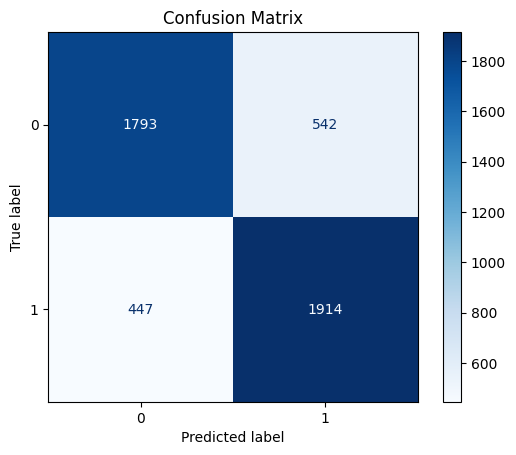

AUC: 0.8655449411248275


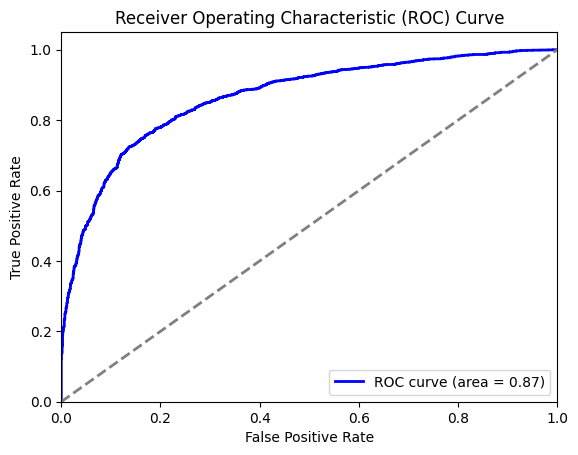

Positive Accuracy (Precision for positive class): 0.7793159609120521
Negative Accuracy (Precision for negative class): 0.8004464285714286


In [24]:
dir_path = config['model_output']['model_save_dir'] + config['date_string']+ '/' + 'test_log_'

for i in range(2,config['pathways_network']['n_hidden_layer']+2):
    print('-'*282)
    print(f'Number of Hidden Layers: {i-1}')
    result = pd.read_csv(f'{dir_path}{i}.csv',index_col=0)

    confusion_matrix_return(result)
    roc_curve_return(result)
    return_accuracy(result)

# Model Interpretation

In [25]:
# Define a hook function to capture the activations


def get_activation(name, number_of_layers, config, activations):
    def hook(model, input, output):
        # Convert output to numpy array for easier handling, but this is optional
        activations[name] = output.detach().numpy()
        
           
    return hook
def attaching_hook(model, dataloader):
    
        correct = 0
        total = 0
        predicted_list = []
        probability_list = []
        labels_list = []
        activations_list = []
        features_list = []
        criterion = nn.BCEWithLogitsLoss()
        loss = 0
        

        with torch.no_grad():  # No need to compute gradients during evaluation
            for sample_idx, (features, labels) in tqdm(enumerate(dataloader)):
                
                
                #print(labels)
                #print(features.shape)
                activations = {}
                for idx, layer in enumerate(model.layers):
                    layer_name = f'layer_{idx}'
                    number_of_layers = len(model.layers)
                    activation_hook = get_activation(layer_name, number_of_layers, config, activations)
                    
                    layer.register_forward_hook(activation_hook)
    
                outputs =  model(features)
                    #print(outputs)
                probability = torch.sigmoid(outputs.data)
                predicted = torch.round(torch.sigmoid(outputs.data))
                    #print(outputs)
                    #print(predicted)
                #loss += criterion(outputs, labels)
                    #_, predicted = torch.sigmoid(outputs.data)
                predicted_list.extend(predicted.detach().numpy())
                labels_list.extend(labels.detach().numpy())
                probability_list.extend(probability.detach().numpy())
                features_list.append(features)
                total += labels.size(0)
                x = activations
                activations_temp = activations.copy()
                activations_list.append(activations_temp)
                
                correct += (predicted == labels).sum().item()
                '''if sample_idx == 1000:
                    #print(activations_list)
                    break'''
                
            #print(total)
        accuracy = 100 * correct / total
        #print(activations_list)
        return activations_list, accuracy, predicted_list, labels_list, features_list,x
        


In [26]:

def return_feature_importance(model_dict_sparse, dataloader):
    predicted_list_dict = {}
    ground_truth_list_dict = {}
    activations_list_dict = {}
    accuracy_list_dict = {}
    for i, j in model_dict_sparse.items():
        #accuracy, loss, predicted_list, labels_list, probability_list = evaluate(j, dataloader)
        
        activations_list_dict[f'model_{i}_hidden_layers'], accuracy_list_dict[f'model_{i}_hidden_layers'], \
        predicted_list_dict[f'model_{i}_hidden_layers'], ground_truth_list_dict[f'model_{i}_hidden_layers'], \
        feature_list,x= attaching_hook(j, dataloader)
        print(f'{i} Layers: {accuracy_list_dict[f'model_{i}_hidden_layers']}')
        
    return activations_list_dict, accuracy_list_dict, predicted_list_dict, ground_truth_list_dict, feature_list,x

In [27]:

activations_list_dict, accuracy_list_dict, predicted_list_dict, ground_truth_list_dict, feature_list,x = return_feature_importance(model_dict_sparse, test_dataloader)

4696it [00:51, 91.29it/s] 

2 Layers: 78.93952299829643


In [28]:
def return_feature_importance_list(activations_list_dict, model_name):
    m=0
    for k in tqdm(activations_list_dict[model_name]):
        #print(k)
        if m == 0:
            layer_dict = {key: [] for key in list(k.keys())}
        m = m+1
        
        #print(k['0_layer_0'])
        for z in list(layer_dict.keys()):
            #print(k)
            layer_dict[z].append(k[z][0])

    return layer_dict
    

In [29]:

layer_dict = return_feature_importance_list(activations_list_dict, 'model_2_hidden_layers')
layer_node_name_dict = {}
for i in range(config['pathways_network']['n_hidden_layer']+1):
    nodes_df = pd.read_csv(config['model_output']['model_save_dir'] + config['date_string'] + '/' + 'masking_df_' + \
    f'{config['pathways_network']['n_hidden_layer']-i}'+ '.csv', index_col = 0)
    layer_node_name_dict[f'layer_{i-1}'] = nodes_df.columns
    

layer_node_name_dict['final_layer'] = ['last_layer']

li = []
for i in layer_dict['layer_0']:
    li.append(list(i))
    
layer_0_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_0'])
layer_0_df

li = []
for i in layer_dict['layer_1']:
    li.append(list(i))
    
last_layer_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['final_layer'])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4696/4696 [00:00<00:00, 978900.23it/s]


In [30]:
layer_0_df

R-HSA-163765  R-HSA-209543  R-HSA-350864  \
cell_id                                                            
CACAACATCGTCCTTG.26.2       0.098598     -0.267047      0.122530   
AGCTTCCGTCTCTCTG.9.9        0.325595      0.216755     -0.064598   
CGCCAGACAACAAGTA.17.11     -0.056607     -0.397140     -0.031511   
GGGATGATCGTAACAC.7.4       -0.057646     -0.456963      0.080570   
ACGTTCCGTATTCTCT.5.11      -0.272852      0.062532      0.136487   
...                              ...           ...           ...   
CATCAAGTCCTCGCAT.19.1       0.009477     -0.032095     -0.284731   
GTCAGCGGTCTGATAC.45.2      -0.453529     -0.551991      0.286779   
CATGCTCAGTGTCATC.30.10     -0.186330     -0.493703      0.058610   
CTCATCGAGCAAATGT.32.8      -0.202801     -0.295968      0.086257   
GAAATGACATGCACTA.3.9        0.143410     -0.534802     -0.029495   

                        R-HSA-8985801  R-HSA-420597  R-HSA-5682910  \
cell_id                                                              
CACAACATCGTCCTTG.26.2        0.199801     -0.021064       0.247003   
AGCTTCCGTCTCTCTG.9.9        -0.097056     -0.134843      -0.016971   
CGCCAGACAACAAGTA.17.11       0.129000     -0.032539       0.016086   
GGGATGATCGTAACAC.7.4         0.065666     -0.080691       0.151168   
ACGTTCCGTATTCTCT.5.11        0.759582      0.063265       0.239064   
...                               ...           ...            ...   
CATCAAGTCCTCGCAT.19.1        0.154393      0.018448       0.164852   
GTCAGCGGTCTGATAC.45.2       -0.161632     -0.019789       0.233086   
CATGCTCAGTGTCATC.30.10       0.026768      0.000695       0.035160   
CTCATCGAGCAAATGT.32.8        0.001076     -0.050168       0.071773   
GAAATGACATGCACTA.3.9         0.314774     -0.066737      -0.173945   

                        R-HSA-1855191  R-HSA-3065679  R-HSA-2871809  \
cell_id                                                               
CACAACATCGTCCTTG.26.2       -0.068726       0.015783       0.249392   
AGCTTCCGTCTCTCTG.9.9         0.023574       0.238850      -0.012932   
CGCCAGACAACAAGTA.17.11      -0.220884       0.012346      -0.025727   
GGGATGATCGTAACAC.7.4        -0.207968       0.126555       0.169998   
ACGTTCCGTATTCTCT.5.11        0.029495      -0.081854       0.203495   
...                               ...            ...            ...   
CATCAAGTCCTCGCAT.19.1        0.282768      -0.044348       0.117866   
GTCAGCGGTCTGATAC.45.2       -0.200262      -0.109488      -0.068856   
CATGCTCAGTGTCATC.30.10      -0.307609       0.112889      -0.088349   
CTCATCGAGCAAATGT.32.8       -0.246940      -0.011998      -0.227633   
GAAATGACATGCACTA.3.9        -0.162172      -0.163652       0.196451   

                        R-HSA-9037628  ...  R-HSA-354194  R-HSA-8981607  \
cell_id                                ...                                
CACAACATCGTCCTTG.26.2        0.076322  ...     -0.056117      -0.263296   
AGCTTCCGTCTCTCTG.9.9        -0.055302  ...      0.020521      -0.351654   
CGCCAGACAACAAGTA.17.11      -0.081457  ...     -0.169593      -0.331856   
GGGATGATCGTAACAC.7.4        -0.214422  ...     -0.010012      -0.326620   
ACGTTCCGTATTCTCT.5.11        0.117849  ...     -0.063262      -0.045582   
...                               ...  ...           ...            ...   
CATCAAGTCCTCGCAT.19.1        0.326558  ...     -0.528381      -0.170965   
GTCAGCGGTCTGATAC.45.2       -0.098831  ...     -0.259162      -0.153657   
CATGCTCAGTGTCATC.30.10      -0.025134  ...      0.372555      -0.301803   
CTCATCGAGCAAATGT.32.8        0.033221  ...     -0.412626      -0.167304   
GAAATGACATGCACTA.3.9         0.024333  ...     -0.321871      -0.224422   

                        R-HSA-196836  R-HSA-9634638  R-HSA-2894862  \
cell_id                                                              
CACAACATCGTCCTTG.26.2       0.071379      -0.072138       0.204242   
AGCTTCCGTCTCTCTG.9.9        0.245871      -0.063117      -0.055054   
CGCCAGACAACAAGTA.17.11      0.051412      -0.284

In [34]:
layer_0_df

R-HSA-163765  R-HSA-209543  R-HSA-350864  \
cell_id                                                            
CACAACATCGTCCTTG.26.2       0.098598     -0.267047      0.122530   
AGCTTCCGTCTCTCTG.9.9        0.325595      0.216755     -0.064598   
CGCCAGACAACAAGTA.17.11     -0.056607     -0.397140     -0.031511   
GGGATGATCGTAACAC.7.4       -0.057646     -0.456963      0.080570   
ACGTTCCGTATTCTCT.5.11      -0.272852      0.062532      0.136487   
...                              ...           ...           ...   
CATCAAGTCCTCGCAT.19.1       0.009477     -0.032095     -0.284731   
GTCAGCGGTCTGATAC.45.2      -0.453529     -0.551991      0.286779   
CATGCTCAGTGTCATC.30.10     -0.186330     -0.493703      0.058610   
CTCATCGAGCAAATGT.32.8      -0.202801     -0.295968      0.086257   
GAAATGACATGCACTA.3.9        0.143410     -0.534802     -0.029495   

                        R-HSA-8985801  R-HSA-420597  R-HSA-5682910  \
cell_id                                                              
CACAACATCGTCCTTG.26.2        0.199801     -0.021064       0.247003   
AGCTTCCGTCTCTCTG.9.9        -0.097056     -0.134843      -0.016971   
CGCCAGACAACAAGTA.17.11       0.129000     -0.032539       0.016086   
GGGATGATCGTAACAC.7.4         0.065666     -0.080691       0.151168   
ACGTTCCGTATTCTCT.5.11        0.759582      0.063265       0.239064   
...                               ...           ...            ...   
CATCAAGTCCTCGCAT.19.1        0.154393      0.018448       0.164852   
GTCAGCGGTCTGATAC.45.2       -0.161632     -0.019789       0.233086   
CATGCTCAGTGTCATC.30.10       0.026768      0.000695       0.035160   
CTCATCGAGCAAATGT.32.8        0.001076     -0.050168       0.071773   
GAAATGACATGCACTA.3.9         0.314774     -0.066737      -0.173945   

                        R-HSA-1855191  R-HSA-3065679  R-HSA-2871809  \
cell_id                                                               
CACAACATCGTCCTTG.26.2       -0.068726       0.015783       0.249392   
AGCTTCCGTCTCTCTG.9.9         0.023574       0.238850      -0.012932   
CGCCAGACAACAAGTA.17.11      -0.220884       0.012346      -0.025727   
GGGATGATCGTAACAC.7.4        -0.207968       0.126555       0.169998   
ACGTTCCGTATTCTCT.5.11        0.029495      -0.081854       0.203495   
...                               ...            ...            ...   
CATCAAGTCCTCGCAT.19.1        0.282768      -0.044348       0.117866   
GTCAGCGGTCTGATAC.45.2       -0.200262      -0.109488      -0.068856   
CATGCTCAGTGTCATC.30.10      -0.307609       0.112889      -0.088349   
CTCATCGAGCAAATGT.32.8       -0.246940      -0.011998      -0.227633   
GAAATGACATGCACTA.3.9        -0.162172      -0.163652       0.196451   

                        R-HSA-9037628  ...  R-HSA-354194  R-HSA-8981607  \
cell_id                                ...                                
CACAACATCGTCCTTG.26.2        0.076322  ...     -0.056117      -0.263296   
AGCTTCCGTCTCTCTG.9.9        -0.055302  ...      0.020521      -0.351654   
CGCCAGACAACAAGTA.17.11      -0.081457  ...     -0.169593      -0.331856   
GGGATGATCGTAACAC.7.4        -0.214422  ...     -0.010012      -0.326620   
ACGTTCCGTATTCTCT.5.11        0.117849  ...     -0.063262      -0.045582   
...                               ...  ...           ...            ...   
CATCAAGTCCTCGCAT.19.1        0.326558  ...     -0.528381      -0.170965   
GTCAGCGGTCTGATAC.45.2       -0.098831  ...     -0.259162      -0.153657   
CATGCTCAGTGTCATC.30.10      -0.025134  ...      0.372555      -0.301803   
CTCATCGAGCAAATGT.32.8        0.033221  ...     -0.412626      -0.167304   
GAAATGACATGCACTA.3.9         0.024333  ...     -0.321871      -0.224422   

                        R-HSA-196836  R-HSA-9634638  R-HSA-2894862  \
cell_id                                                              
CACAACATCGTCCTTG.26.2       0.071379      -0.072138       0.204242   
AGCTTCCGTCTCTCTG.9.9        0.245871      -0.063117      -0.055054   
CGCCAGACAACAAGTA.17.11      0.051412      -0.284

In [35]:
last_layer_df

last_layer
cell_id                           
CACAACATCGTCCTTG.26.2     1.815810
AGCTTCCGTCTCTCTG.9.9     -3.057525
CGCCAGACAACAAGTA.17.11   -1.273272
GGGATGATCGTAACAC.7.4      5.325348
ACGTTCCGTATTCTCT.5.11    -2.757563
...                            ...
CATCAAGTCCTCGCAT.19.1    -1.907076
GTCAGCGGTCTGATAC.45.2     2.357688
CATGCTCAGTGTCATC.30.10    2.798675
CTCATCGAGCAAATGT.32.8     0.371350
GAAATGACATGCACTA.3.9     -3.370227

[4696 rows x 1 columns]

In [36]:
y_test

diagnosis
0             1
1             0
2             0
3             1
4             1
...         ...
4691          1
4692          1
4693          1
4694          0
4695          0

[4696 rows x 1 columns]

In [37]:
for i,j in predicted_list_dict.items():
    flattened_list = [item for sublist in list(predicted_list_dict[i]) for item in sublist]
    predicted_list_dict[i] = flattened_list
    

In [38]:
predicted_list_dict['model_2_hidden_layers'][0:10]

[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]

In [39]:
predicted_list_dict['model_4_hidden_layers'][0:10]

KeyError: 'model_4_hidden_layers'

In [40]:
for i,j in ground_truth_list_dict.items():
    flattened_list = [item for sublist in list(ground_truth_list_dict[i]) for item in sublist]
    ground_truth_list_dict[i] = flattened_list
    

In [41]:
ground_truth_list_dict['model_2_hidden_layers'][0:10]

[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]

In [42]:
ground_truth_list_dict['model_4_hidden_layers'][0:10]

KeyError: 'model_4_hidden_layers'

In [43]:
predicted_list_dict['model_2_hidden_layers'][0:10]

[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]

In [44]:
layer_0_df['predicted'] = predicted_list_dict['model_2_hidden_layers']
layer_0_df['ground_truth'] = ground_truth_list_dict['model_2_hidden_layers']
layer_0_df.head()

R-HSA-163765  R-HSA-209543  R-HSA-350864  \
cell_id                                                            
CACAACATCGTCCTTG.26.2       0.098598     -0.267047      0.122530   
AGCTTCCGTCTCTCTG.9.9        0.325595      0.216755     -0.064598   
CGCCAGACAACAAGTA.17.11     -0.056607     -0.397140     -0.031511   
GGGATGATCGTAACAC.7.4       -0.057646     -0.456963      0.080570   
ACGTTCCGTATTCTCT.5.11      -0.272852      0.062532      0.136487   

                        R-HSA-8985801  R-HSA-420597  R-HSA-5682910  \
cell_id                                                              
CACAACATCGTCCTTG.26.2        0.199801     -0.021064       0.247003   
AGCTTCCGTCTCTCTG.9.9        -0.097056     -0.134843      -0.016971   
CGCCAGACAACAAGTA.17.11       0.129000     -0.032539       0.016086   
GGGATGATCGTAACAC.7.4         0.065666     -0.080691       0.151168   
ACGTTCCGTATTCTCT.5.11        0.759582      0.063265       0.239064   

                        R-HSA-1855191  R-HSA-3065679  R-HSA-2871809  \
cell_id                                                               
CACAACATCGTCCTTG.26.2       -0.068726       0.015783       0.249392   
AGCTTCCGTCTCTCTG.9.9         0.023574       0.238850      -0.012932   
CGCCAGACAACAAGTA.17.11      -0.220884       0.012346      -0.025727   
GGGATGATCGTAACAC.7.4        -0.207968       0.126555       0.169998   
ACGTTCCGTATTCTCT.5.11        0.029495      -0.081854       0.203495   

                        R-HSA-9037628  ...  R-HSA-196836  R-HSA-9634638  \
cell_id                                ...                                
CACAACATCGTCCTTG.26.2        0.076322  ...      0.071379      -0.072138   
AGCTTCCGTCTCTCTG.9.9        -0.055302  ...      0.245871      -0.063117   
CGCCAGACAACAAGTA.17.11      -0.081457  ...      0.051412      -0.284395   
GGGATGATCGTAACAC.7.4        -0.214422  ...     -0.109779      -0.389189   
ACGTTCCGTATTCTCT.5.11        0.117849  ...      0.131580      -0.556973   

                        R-HSA-2894862  R-HSA-9639288  R-HSA-211979  \
cell_id                                                              
CACAACATCGTCCTTG.26.2        0.204242       0.068173      0.089477   
AGCTTCCGTCTCTCTG.9.9        -0.055054       0.151093      0.058960   
CGCCAGACAACAAGTA.17.11       0.093609      -0.004401      0.129238   
GGGATGATCGTAACAC.7.4         0.038783      -0.220545      0.366010   
ACGTTCCGTATTCTCT.5.11       -0.182690       0.124835      0.123019   

                        R-HSA-180292  R-HSA-173107  R-HSA-5221030  predicted  \
cell_id                                                                        
CACAACATCGTCCTTG.26.2      -0.101001     -0.119746       0.157962        1.0   
AGCTTCCGTCTCTCTG.9.9        0.119697      0.266017      -0.397090        0.0   
CGCCAGACAACAAGTA.17.11      0.054966      0.120645      -0.026976        0.0   
GGGATGATCGTAACAC.7.4        0.019010      0.279525       0.007284        1.0   
ACGTTCCGTATTCTCT.5.11      -0.267963      0.427100      -0.558462        0.0   

                        ground_truth  
cell_id                               
CACAACATCGTCCTTG.26.2            1.0  
AGCTTCCGTCTCTCTG.9.9             0.0  
CGCCAGACAACAAGTA.17.11           0.0  
GGGATGATCGTAACAC.7.4             1.0  
ACGTTCCGTATTCTCT.5.11            1.0  

[5 rows x 1780 columns]

In [59]:
correct_predicted_layer_0_df = layer_0_df[layer_0_df.predicted == layer_0_df.ground_truth]
correct_predicted_layer_0_df_AD = correct_predicted_layer_0_df[correct_predicted_layer_0_df.predicted == 1]
correct_predicted_layer_0_df_Control = correct_predicted_layer_0_df[correct_predicted_layer_0_df.predicted == 0]

In [60]:
combined_layer_0 = pd.concat([correct_predicted_layer_0_df_AD, correct_predicted_layer_0_df_Control])


In [61]:
combined_layer_0['predicted'] = combined_layer_0['predicted'].replace({1: 'AD', 0: 'Control'})


In [62]:
labels = np.array(combined_layer_0.predicted)
labels

array(['AD', 'AD', 'AD', ..., 'Control', 'Control', 'Control'],
      dtype=object)

In [63]:
combined_layer_0 .drop(columns=['predicted','ground_truth'], inplace = True)
combined_layer_0 .head()

R-HSA-163765  R-HSA-209543  R-HSA-350864  \
cell_id                                                           
CACAACATCGTCCTTG.26.2      0.098598     -0.267047      0.122530   
GGGATGATCGTAACAC.7.4      -0.057646     -0.456963      0.080570   
AGATCGTAGAAGCTCG.11.9     -0.294878     -0.250029      0.147070   
CGTCTACTCTTACCGC.38.1      0.221667      0.057750     -0.342865   
CCACTTGCAGAACTAA.32.9     -0.253936     -0.080139      0.027246   

                       R-HSA-8985801  R-HSA-420597  R-HSA-5682910  \
cell_id                                                             
CACAACATCGTCCTTG.26.2       0.199801     -0.021064       0.247003   
GGGATGATCGTAACAC.7.4        0.065666     -0.080691       0.151168   
AGATCGTAGAAGCTCG.11.9      -0.117036     -0.045218       0.193205   
CGTCTACTCTTACCGC.38.1       0.139605     -0.072691      -0.138190   
CCACTTGCAGAACTAA.32.9      -0.023225     -0.074996       0.112947   

                       R-HSA-1855191  R-HSA-3065679  R-HSA-2871809  \
cell_id                                                              
CACAACATCGTCCTTG.26.2      -0.068726       0.015783       0.249392   
GGGATGATCGTAACAC.7.4       -0.207968       0.126555       0.169998   
AGATCGTAGAAGCTCG.11.9      -0.307407      -0.121900      -0.114273   
CGTCTACTCTTACCGC.38.1      -0.041974       0.384032       0.018775   
CCACTTGCAGAACTAA.32.9      -0.168958       0.174024       0.187062   

                       R-HSA-9037628  ...  R-HSA-354194  R-HSA-8981607  \
cell_id                               ...                                
CACAACATCGTCCTTG.26.2       0.076322  ...     -0.056117      -0.263296   
GGGATGATCGTAACAC.7.4       -0.214422  ...     -0.010012      -0.326620   
AGATCGTAGAAGCTCG.11.9      -0.424276  ...      0.255095      -0.312930   
CGTCTACTCTTACCGC.38.1       0.034944  ...     -0.269615      -0.118340   
CCACTTGCAGAACTAA.32.9      -0.392598  ...      0.075530      -0.379426   

                       R-HSA-196836  R-HSA-9634638  R-HSA-2894862  \
cell_id                                                             
CACAACATCGTCCTTG.26.2      0.071379      -0.072138       0.204242   
GGGATGATCGTAACAC.7.4      -0.109779      -0.389189       0.038783   
AGATCGTAGAAGCTCG.11.9     -0.509483      -0.223692       0.437101   
CGTCTACTCTTACCGC.38.1      0.039953      -0.340439       0.062281   
CCACTTGCAGAACTAA.32.9     -0.114297      -0.441222      -0.036160   

                       R-HSA-9639288  R-HSA-211979  R-HSA-180292  \
cell_id                                                            
CACAACATCGTCCTTG.26.2       0.068173      0.089477     -0.101001   
GGGATGATCGTAACAC.7.4       -0.220545      0.366010      0.019010   
AGATCGTAGAAGCTCG.11.9      -0.200134      0.279746      0.250221   
CGTCTACTCTTACCGC.38.1      -0.100975     -0.271005      0.499699   
CCACTTGCAGAACTAA.32.9       0.007817      0.342876      0.065153   

                       R-HSA-173107  R-HSA-5221030  
cell_id                                             
CACAACATCGTCCTTG.26.2     -0.119746       0.157962  
GGGATGATCGTAACAC.7.4       0.279525       0.007284  
AGATCGTAGAAGCTCG.11.9      0.020194       0.078307  
CGTCTACTCTTACCGC.38.1     -0.202353       0.057439  
CCACTTGCAGAACTAA.32.9      0.017309       0.072737  

[5 rows x 1778 columns]

In [64]:
'''pathways_list = []
p_value_list = []

for i in correct_predicted_layer_1_df_Control.columns:
    t_stat, p_value = stats.ttest_ind(correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist())
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")

    plt.figure(figsize=(8, 6))
    plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True, 
                boxprops=dict(facecolor='lightblue'))
    
    # Add title and labels
    plt.title('Box Plot of Two Distributions')
    plt.ylabel('Values')
    pathways_list.append(i)
    p_value_list.append(p_value)
    # Display the plot
    plt.show()'''
    
    

'pathways_list = []\np_value_list = []\n\nfor i in correct_predicted_layer_1_df_Control.columns:\n    t_stat, p_value = stats.ttest_ind(correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist())\n    print(f"T-statistic: {t_stat}")\n    print(f"P-value: {p_value}")\n\n    plt.figure(figsize=(8, 6))\n    plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=[\'Control\', \'AD\'], patch_artist=True, \n                boxprops=dict(facecolor=\'lightblue\'))\n    \n    # Add title and labels\n    plt.title(\'Box Plot of Two Distributions\')\n    plt.ylabel(\'Values\')\n    pathways_list.append(i)\n    p_value_list.append(p_value)\n    # Display the plot\n    plt.show()'

/home/anwer/.local/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



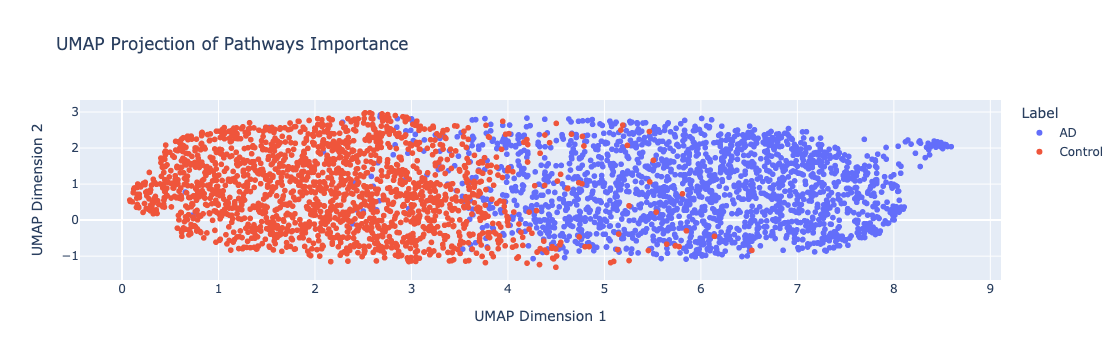

In [65]:
import pandas as pd
import umap
import plotly.express as px
import numpy as np

# Example embeddings (let's assume these are your high-dimensional embeddings)
np.random.seed(42)
embeddings = combined_layer_0.values 
#labels = np.random.choice(['A', 'B', 'C'], size=100)  # Example labels
labels = labels
# Step 1: Reduce dimensionality using UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_embeddings = reducer.fit_transform(embeddings)

# Step 2: Create a DataFrame with the reduced dimensions and labels
df_umap = pd.DataFrame({
    'UMAP1': umap_embeddings[:, 0],
    'UMAP2': umap_embeddings[:, 1],
    'Label': labels
})

# Step 3: Plot using Plotly
fig = px.scatter(
    df_umap,
    x='UMAP1',
    y='UMAP2',
    color='Label',
    title='UMAP Projection of Pathways Importance',
    labels={'UMAP1': 'UMAP Dimension 1', 'UMAP2': 'UMAP Dimension 2'}
)

# Show plot
fig.show()


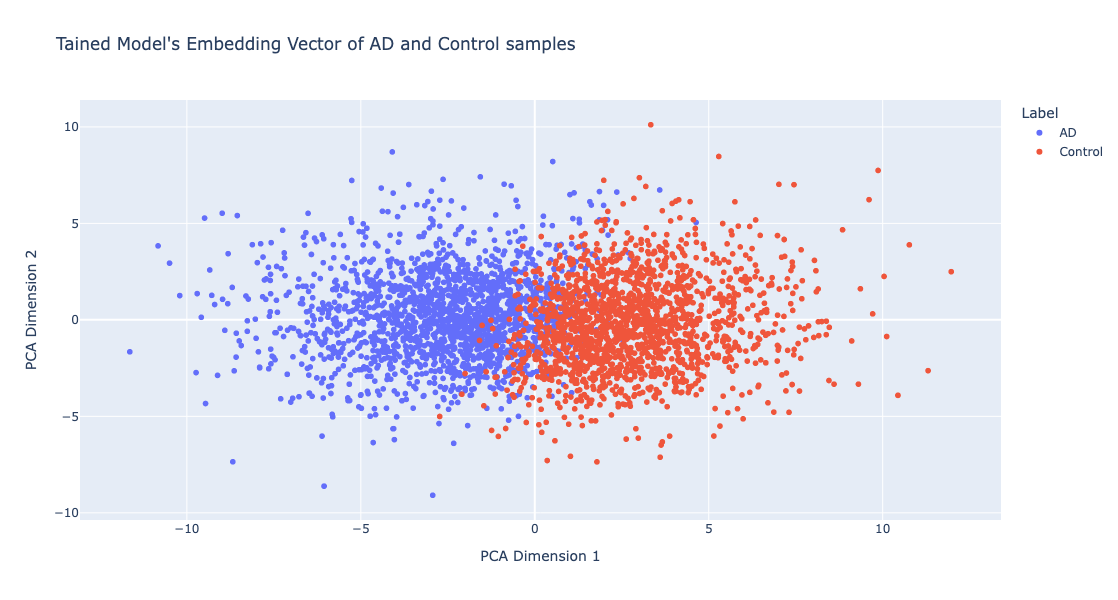

In [73]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.decomposition import PCA

# Assuming `combined_layer_0` and `labels` are already defined

# Step 1: Reduce dimensionality using PCA
pca = PCA(n_components=2)  # We want to reduce to 2 dimensions
pca_embeddings = pca.fit_transform(combined_layer_0.values)

# Step 2: Create a DataFrame with the reduced dimensions and labels
df_pca = pd.DataFrame({
    'PCA1': pca_embeddings[:, 0],
    'PCA2': pca_embeddings[:, 1],
    'Label': labels
})

# Step 3: Plot using Plotly
fig = px.scatter(
    df_pca,
    x='PCA1',
    y='PCA2',
    color='Label',
    title="Tained Model's Embedding Vector of AD and Control samples",
    labels={'PCA1': 'PCA Dimension 1', 'PCA2': 'PCA Dimension 2'},
    width=800,   # Set plot width
    height=600   # Set plot height
)

# Show plot
fig.show()


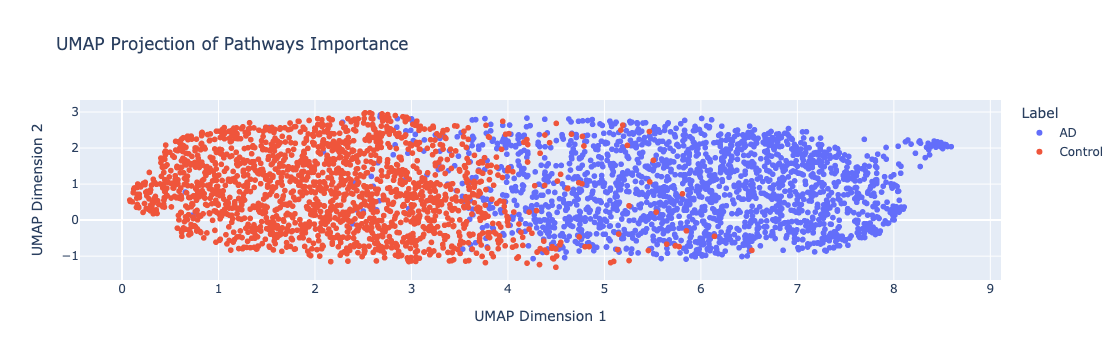

In [69]:
embeddingfig = px.scatter(
    df_umap,
    x='UMAP1',
    y='UMAP2',
    color='Label',
    title='UMAP Projection of Pathways Importance',
    labels={'UMAP1': 'UMAP Dimension 1', 'UMAP2': 'UMAP Dimension 2'},
    width=500,   # Width of the plot in pixels
    height=6000 
)

# Show plot
fig.show()

In [42]:
pd.DataFrame(pathways_list, p_value_list)

Empty DataFrame
Columns: []
Index: []

In [43]:

layer_dict = return_feature_importance_list(activations_list_dict, 'model_3_hidden_layers')
layer_node_name_dict = {}
for i in range(config['pathways_network']['n_hidden_layer']+1):
    nodes_df = pd.read_csv(config['model_output']['model_save_dir'] + config['date_string'] + '/' + 'masking_df_' + \
    f'{config['pathways_network']['n_hidden_layer']-i}'+ '.csv', index_col = 0)
    layer_node_name_dict[f'layer_{i-1}'] = nodes_df.columns
    

layer_node_name_dict['final_layer'] = ['last_layer']

li = []
for i in layer_dict['layer_0']:
    li.append(list(i))    
layer_0_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_0'])

li = []
for i in layer_dict['layer_1']:
    li.append(list(i)) 
layer_1_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_1'])

li = []
for i in layer_dict['layer_2']:
    li.append(list(i))   
last_layer_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['final_layer'])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4696/4696 [00:00<00:00, 554142.80it/s]


In [44]:
layer_1_df

R-HSA-417957  R-HSA-162592  R-HSA-5654689  \
cell_id                                                             
CACAACATCGTCCTTG.26.2       0.003275      0.009810      -0.015456   
AGCTTCCGTCTCTCTG.9.9        0.000000      0.012895      -0.005234   
CGCCAGACAACAAGTA.17.11      0.000000      0.013725      -0.010916   
GGGATGATCGTAACAC.7.4        0.000000      0.007576      -0.009176   
ACGTTCCGTATTCTCT.5.11       0.000000      0.000000       0.000000   
...                              ...           ...            ...   
CATCAAGTCCTCGCAT.19.1       0.012875      0.000000       0.000000   
GTCAGCGGTCTGATAC.45.2       0.000000      0.025255      -0.016036   
CATGCTCAGTGTCATC.30.10      0.000000      0.020581      -0.013634   
CTCATCGAGCAAATGT.32.8       0.000000      0.019385      -0.013723   
GAAATGACATGCACTA.3.9        0.000000      0.016424      -0.009281   

                        R-HSA-75896  R-HSA-5654716  R-HSA-159231  \
cell_id                                                            
CACAACATCGTCCTTG.26.2      0.000000       0.001502      0.001915   
AGCTTCCGTCTCTCTG.9.9       0.000000      -0.003001      0.000000   
CGCCAGACAACAAGTA.17.11     0.000000      -0.001140      0.006392   
GGGATGATCGTAACAC.7.4      -0.003849       0.012905      0.000000   
ACGTTCCGTATTCTCT.5.11      0.000000       0.000000      0.000000   
...                             ...            ...           ...   
CATCAAGTCCTCGCAT.19.1      0.000000       0.000000      0.000000   
GTCAGCGGTCTGATAC.45.2      0.000000      -0.005883      0.000000   
CATGCTCAGTGTCATC.30.10     0.000000      -0.011415      0.000000   
CTCATCGAGCAAATGT.32.8      0.000000       0.007739      0.000258   
GAAATGACATGCACTA.3.9      -0.001702       0.001646      0.003709   

                        R-HSA-5210891  R-HSA-113507  R-HSA-5339716  \
cell_id                                                              
CACAACATCGTCCTTG.26.2        0.009021     -0.010476      -0.006433   
AGCTTCCGTCTCTCTG.9.9         0.010151     -0.005489      -0.002985   
CGCCAGACAACAAGTA.17.11       0.008776     -0.012376      -0.004896   
GGGATGATCGTAACAC.7.4         0.014573      0.000000      -0.005228   
ACGTTCCGTATTCTCT.5.11        0.000000     -0.034737       0.000000   
...                               ...           ...            ...   
CATCAAGTCCTCGCAT.19.1        0.006510     -0.006484      -0.003527   
GTCAGCGGTCTGATAC.45.2        0.013536     -0.007280      -0.001409   
CATGCTCAGTGTCATC.30.10       0.013967     -0.013448      -0.003815   
CTCATCGAGCAAATGT.32.8        0.011361     -0.022696      -0.001077   
GAAATGACATGCACTA.3.9         0.013021     -0.016361      -0.005553   

                        R-HSA-9034864  ...  R-HSA-5655291_copy1  \
cell_id                                ...                        
CACAACATCGTCCTTG.26.2       -0.000057  ...             0.027487   
AGCTTCCGTCTCTCTG.9.9         0.000000  ...             0.008764   
CGCCAGACAACAAGTA.17.11      -0.000100  ...             0.023170   
GGGATGATCGTAACAC.7.4        -0.000047  ...             0.016054   
ACGTTCCGTATTCTCT.5.11        0.000000  ...             0.000000   
...                               ...  ...                  ...   
CATCAAGTCCTCGCAT.19.1        0.000000  ...             0.000000   
GTCAGCGGTCTGATAC.45.2       -0.000141  ...             0.033405   
CATGCTCAGTGTCATC.30.10      -0.000052  ...             0.025742   
CTCATCGAGCAAATGT.32.8       -0.000041  ...             0.023315   
GAAATGACATGCACTA.3.9        -0.000115  ...             0.021208   

                        R-HSA-5654688  R-HSA-6783310_copy1  R-HSA-5675482  \
cell_id                                                                     
CACAACATCGTCCTTG.26.2        0.000277             0.002091      -0.000094   
AGCTTCCGTCTCTCTG.9.9         0.000000             0.000000       0.000000   
CGCCAGACAACAAGTA.17.11      -0.000132             0.005502       0.003574   
GGGATGATCGTAACAC.7.4         0.000687             0.004162      -0.004238

In [45]:

layer_dict = return_feature_importance_list(activations_list_dict, 'model_4_hidden_layers')
layer_node_name_dict = {}
for i in range(config['pathways_network']['n_hidden_layer']+1):
    nodes_df = pd.read_csv(config['model_output']['model_save_dir'] + config['date_string'] + '/' + 'masking_df_' + \
    f'{config['pathways_network']['n_hidden_layer']-i}'+ '.csv', index_col = 0)
    layer_node_name_dict[f'layer_{i-1}'] = nodes_df.columns
    

layer_node_name_dict['final_layer'] = ['last_layer']

li = []
for i in layer_dict['layer_0']:
    li.append(list(i))    
layer_0_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_0'])

li = []
for i in layer_dict['layer_1']:
    li.append(list(i)) 
layer_1_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_1'])

li = []
for i in layer_dict['layer_2']:
    li.append(list(i)) 
layer_2_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_2'])

li = []
for i in layer_dict['layer_3']:
    li.append(list(i))   
last_layer_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['final_layer'])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4696/4696 [00:00<00:00, 443773.69it/s]


In [46]:
layer_2_df

R-HSA-5655332  R-HSA-5693537  R-HSA-5205647  \
cell_id                                                               
CACAACATCGTCCTTG.26.2       -0.003298      -0.000165      -0.001825   
AGCTTCCGTCTCTCTG.9.9        -0.001275      -0.000542       0.003747   
CGCCAGACAACAAGTA.17.11      -0.002072      -0.000194      -0.000583   
GGGATGATCGTAACAC.7.4        -0.001756      -0.000536       0.001314   
ACGTTCCGTATTCTCT.5.11        0.000000       0.000000      -0.004301   
...                               ...            ...            ...   
CATCAAGTCCTCGCAT.19.1        0.000000      -0.000968      -0.004846   
GTCAGCGGTCTGATAC.45.2       -0.003111       0.000000       0.003738   
CATGCTCAGTGTCATC.30.10      -0.003066      -0.000559       0.005367   
CTCATCGAGCAAATGT.32.8       -0.002909       0.000000      -0.002401   
GAAATGACATGCACTA.3.9        -0.001574      -0.000526      -0.002838   

                        R-HSA-881907  R-HSA-2660825  R-HSA-5654696  \
cell_id                                                              
CACAACATCGTCCTTG.26.2      -0.000286       0.001378      -0.003232   
AGCTTCCGTCTCTCTG.9.9        0.000000       0.002781      -0.001038   
CGCCAGACAACAAGTA.17.11      0.000020       0.001338      -0.003624   
GGGATGATCGTAACAC.7.4       -0.000621       0.001628      -0.001184   
ACGTTCCGTATTCTCT.5.11       0.000000       0.000000       0.000000   
...                              ...            ...            ...   
CATCAAGTCCTCGCAT.19.1       0.000000       0.000000       0.000000   
GTCAGCGGTCTGATAC.45.2       0.000186       0.001664      -0.005484   
CATGCTCAGTGTCATC.30.10      0.000263       0.000776      -0.003960   
CTCATCGAGCAAATGT.32.8      -0.000533       0.000000      -0.002149   
GAAATGACATGCACTA.3.9       -0.000023       0.000724      -0.003440   

                        R-HSA-109704  R-HSA-198753  R-HSA-211976  \
cell_id                                                            
CACAACATCGTCCTTG.26.2       0.001074     -0.000682      0.000001   
AGCTTCCGTCTCTCTG.9.9        0.000221     -0.000620      0.000007   
CGCCAGACAACAAGTA.17.11      0.000773     -0.000940      0.000005   
GGGATGATCGTAACAC.7.4        0.001733     -0.000956      0.000010   
ACGTTCCGTATTCTCT.5.11       0.000000      0.000000      0.000000   
...                              ...           ...           ...   
CATCAAGTCCTCGCAT.19.1       0.000000     -0.001352      0.000008   
GTCAGCGGTCTGATAC.45.2       0.000576     -0.001488      0.000012   
CATGCTCAGTGTCATC.30.10      0.001311     -0.000742      0.000011   
CTCATCGAGCAAATGT.32.8       0.000914     -0.001355      0.000010   
GAAATGACATGCACTA.3.9        0.001068      0.000052      0.000007   

                        R-HSA-5654687  ...  R-HSA-389356  R-HSA-8979227  \
cell_id                                ...                                
CACAACATCGTCCTTG.26.2        0.000799  ...      0.000024       0.001375   
AGCTTCCGTCTCTCTG.9.9         0.000482  ...      0.000059       0.000580   
CGCCAGACAACAAGTA.17.11       0.000524  ...     -0.000422       0.001126   
GGGATGATCGTAACAC.7.4        -0.000068  ...      0.000212       0.001284   
ACGTTCCGTATTCTCT.5.11        0.000000  ...      0.000000       0.000000   
...                               ...  ...           ...            ...   
CATCAAGTCCTCGCAT.19.1        0.000000  ...      0.000000       0.001268   
GTCAGCGGTCTGATAC.45.2        0.000944  ...     -0.000818       0.000000   
CATGCTCAGTGTCATC.30.10       0.001265  ...     -0.000353       0.001623   
CTCATCGAGCAAATGT.32.8        0.000464  ...      0.000447       0.000557   
GAAATGACATGCACTA.3.9         0.000257  ...     -0.000146       0.001268   

                        R-HSA-446353  R-HSA-196807  R-HSA-1181150  \
cell_id                                                             
CACAACATCGTCCTTG.26.2       0.000942     -0.000680      -0.000505   
AGCTTCCGTCTCTCTG.9.9        0.001331     -0.000299      -0.000403   
CGCCAGACAACAAGTA.17.11      0.001401     -0.000515  

# layer_2_df

# Plots

In [782]:
!pwd

/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network
